In [1]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import sys
from sklearn.metrics import accuracy_score, recall_score
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score

In [2]:
import os
import numpy as np
import requests

# Download the required files.

def download_file(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful.
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")


In [3]:
import os
import sys
import torch
import torchvision.models as models


def load_model_for_classification(model_name='resnet18', num_classes = 2, model_dir='../../data/external/Places365/model'):
    os.makedirs(model_dir, exist_ok=True)

    if model_name == 'resnet18':
        model_file = os.path.join(model_dir, 'resnet18_places365.pth')
        model_url = 'http://places2.csail.mit.edu/models_places365/wideresnet18_places365.pth.tar'
    elif model_name == 'alexnet':
        model_file = os.path.join(model_dir, 'alexnet_places365.pth')
        model_url = 'http://places2.csail.mit.edu/models_places365/alexnet_places365.pth'
    else:
        raise ValueError(f"Model {model_name} not supported.")

    if not os.path.exists(model_file):
        print(f"{model_file} does not exist. Downloading...")
        download_file(model_url, model_file)

    if model_name == 'resnet18':
        sys.path.append(model_dir)
        try:
            import wideresnet
            model = wideresnet.resnet18(num_classes=365)
            checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage, weights_only=True)
            state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
            model.load_state_dict(state_dict)

            model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        except ImportError as e:
            print(f"Error importing wideresnet module: {e}")
            return None
    elif model_name == 'alexnet':
        model = models.alexnet(num_classes=365)
        checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage, weights_only=True)
        state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

    print(f"Model {model_name} for binary classification loaded successfully.")
    return model

    


# model = load_model_for_binary_classification(model_name='vgg16')
# model = load_model_for_binary_classification(model_name='googlenet')
# model = load_model_for_binary_classification(model_name='alexnet')


In [4]:
class LandscapesDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform
        self.label = self.data_frame['type']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_path = f"{self.data_frame.iloc[idx, 0]}.jpg"
        try:
            image = Image.open(image_path).convert('RGB')  
        except (IOError, SyntaxError) as e:
            print(f"Error opening image at {image_path}, skipping to next.")
            return self.__getitem__((idx + 1) % len(self))  
        
        if self.transform:
            image = self.transform(image)
            
        label = int(self.data_frame.iloc[idx, 1])
        return image, torch.tensor(label, dtype=torch.long)

In [5]:
import pandas as pd
original_data_path = '/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/common_landscape_types.csv'
original_df = pd.read_csv(original_data_path) 
categories_df = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/landscape_categories.csv')  

categories_df['category_id'] = range(len(categories_df))

category_to_id = dict(zip(categories_df['category'], categories_df['category_id']))

original_df['type'] = original_df['type'].map(category_to_id)

original_df.to_csv('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/updated_images_info.csv', index=False)


In [6]:
data_path = '/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/updated_images_info.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/images')

data = pd.read_csv(data_path, encoding='UTF-8')

training_images = {}
validation_images = {}

for _, row in data.iterrows():
    filename = row['id']
    category = row['type']
    if 'train' in filename:
        image_path = os.path.join(image_folder, 'training', filename)
        training_images[image_path] = category
    elif 'val' in filename:
        image_path = os.path.join(image_folder, 'validation', filename)
        validation_images[image_path] = category

training_df = pd.DataFrame(list(training_images.items()), columns=['filename', 'type'])
validation_df = pd.DataFrame(list(validation_images.items()), columns=['filename', 'type'])
validation_df = validation_df[validation_df['type'] != 305]

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])

train_dataset = LandscapesDataset(data_frame=training_df,
                              transform=data_transforms)

val_dataset = LandscapesDataset(data_frame=validation_df,
                              transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")


Training set size: 12942
Validation set size: 1280


In [7]:
model = load_model_for_classification(model_name='resnet18', num_classes = len(training_df['type'].unique()))

Model resnet18 for binary classification loaded successfully.


Epoch 1/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 1/30:   0%|                            | 0/405 [00:14<?, ?it/s, loss=5.82]

Epoch 1/30:   0%|                  | 1/405 [00:14<1:34:39, 14.06s/it, loss=5.82]

Epoch 1/30:   0%|                  | 1/405 [00:26<1:34:39, 14.06s/it, loss=4.93]

Epoch 1/30:   0%|                  | 2/405 [00:26<1:26:25, 12.87s/it, loss=4.93]

Epoch 1/30:   0%|                  | 2/405 [00:38<1:26:25, 12.87s/it, loss=6.23]

Epoch 1/30:   1%|▏                 | 3/405 [00:38<1:23:29, 12.46s/it, loss=6.23]

Epoch 1/30:   1%|▏                 | 3/405 [00:49<1:23:29, 12.46s/it, loss=5.34]

Epoch 1/30:   1%|▏                 | 4/405 [00:49<1:20:35, 12.06s/it, loss=5.34]

Epoch 1/30:   1%|▏                 | 4/405 [01:01<1:20:35, 12.06s/it, loss=5.84]

Epoch 1/30:   1%|▏                 | 5/405 [01:01<1:21:04, 12.16s/it, loss=5.84]

Epoch 1/30:   1%|▏                 | 5/405 [01:13<1:21:04, 12.16s/it, loss=4.34]

Epoch 1/30:   1%|▎                 | 6/405 [01:13<1:19:41, 11.98s/it, loss=4.34]

Epoch 1/30:   1%|▎                 | 6/405 [01:25<1:19:41, 11.98s/it, loss=4.67]

Epoch 1/30:   2%|▎                 | 7/405 [01:25<1:19:48, 12.03s/it, loss=4.67]

Epoch 1/30:   2%|▎                 | 7/405 [01:37<1:19:48, 12.03s/it, loss=5.48]

Epoch 1/30:   2%|▎                 | 8/405 [01:37<1:18:26, 11.85s/it, loss=5.48]

Epoch 1/30:   2%|▎                 | 8/405 [01:48<1:18:26, 11.85s/it, loss=4.39]

Epoch 1/30:   2%|▍                 | 9/405 [01:48<1:16:44, 11.63s/it, loss=4.39]

Epoch 1/30:   2%|▍                 | 9/405 [01:59<1:16:44, 11.63s/it, loss=4.93]

Epoch 1/30:   2%|▍                | 10/405 [01:59<1:16:28, 11.62s/it, loss=4.93]

Epoch 1/30:   2%|▍                | 10/405 [02:11<1:16:28, 11.62s/it, loss=5.47]

Epoch 1/30:   3%|▍                | 11/405 [02:11<1:16:17, 11.62s/it, loss=5.47]

Epoch 1/30:   3%|▍                | 11/405 [02:22<1:16:17, 11.62s/it, loss=5.08]

Epoch 1/30:   3%|▌                | 12/405 [02:22<1:14:14, 11.33s/it, loss=5.08]

Epoch 1/30:   3%|▌                | 12/405 [02:33<1:14:14, 11.33s/it, loss=5.17]

Epoch 1/30:   3%|▌                | 13/405 [02:33<1:13:16, 11.21s/it, loss=5.17]

Epoch 1/30:   3%|▌                | 13/405 [02:45<1:13:16, 11.21s/it, loss=4.33]

Epoch 1/30:   3%|▌                | 14/405 [02:45<1:14:31, 11.44s/it, loss=4.33]

Epoch 1/30:   3%|▌                | 14/405 [02:56<1:14:31, 11.44s/it, loss=4.62]

Epoch 1/30:   4%|▋                | 15/405 [02:56<1:13:56, 11.38s/it, loss=4.62]

Epoch 1/30:   4%|▋                | 15/405 [03:07<1:13:56, 11.38s/it, loss=4.62]

Epoch 1/30:   4%|▋                | 16/405 [03:07<1:14:00, 11.42s/it, loss=4.62]

Epoch 1/30:   4%|▋                | 16/405 [03:18<1:14:00, 11.42s/it, loss=4.32]

Epoch 1/30:   4%|▋                | 17/405 [03:18<1:13:01, 11.29s/it, loss=4.32]

Epoch 1/30:   4%|▋                | 17/405 [03:30<1:13:01, 11.29s/it, loss=4.26]

Epoch 1/30:   4%|▊                | 18/405 [03:30<1:13:10, 11.34s/it, loss=4.26]

Epoch 1/30:   4%|▊                | 18/405 [03:40<1:13:10, 11.34s/it, loss=4.95]

Epoch 1/30:   5%|▊                | 19/405 [03:40<1:11:28, 11.11s/it, loss=4.95]

Epoch 1/30:   5%|▊                | 19/405 [03:51<1:11:28, 11.11s/it, loss=4.33]

Epoch 1/30:   5%|▊                | 20/405 [03:51<1:11:04, 11.08s/it, loss=4.33]

Epoch 1/30:   5%|▉                 | 20/405 [04:02<1:11:04, 11.08s/it, loss=4.5]

Epoch 1/30:   5%|▉                 | 21/405 [04:02<1:10:23, 11.00s/it, loss=4.5]

Epoch 1/30:   5%|▉                | 21/405 [04:14<1:10:23, 11.00s/it, loss=4.98]

Epoch 1/30:   5%|▉                | 22/405 [04:14<1:11:00, 11.12s/it, loss=4.98]

Epoch 1/30:   5%|▉                | 22/405 [04:25<1:11:00, 11.12s/it, loss=4.27]

Epoch 1/30:   6%|▉                | 23/405 [04:25<1:10:49, 11.13s/it, loss=4.27]

Epoch 1/30:   6%|▉                | 23/405 [04:36<1:10:49, 11.13s/it, loss=4.96]

Epoch 1/30:   6%|█                | 24/405 [04:36<1:10:45, 11.14s/it, loss=4.96]

Epoch 1/30:   6%|█                | 24/405 [04:47<1:10:45, 11.14s/it, loss=4.55]

Epoch 1/30:   6%|█                | 25/405 [04:47<1:11:00, 11.21s/it, loss=4.55]

Epoch 1/30:   6%|█                | 25/405 [04:58<1:11:00, 11.21s/it, loss=5.01]

Epoch 1/30:   6%|█                | 26/405 [04:58<1:10:40, 11.19s/it, loss=5.01]

Epoch 1/30:   6%|█                | 26/405 [05:10<1:10:40, 11.19s/it, loss=4.76]

Epoch 1/30:   7%|█▏               | 27/405 [05:10<1:10:51, 11.25s/it, loss=4.76]

Epoch 1/30:   7%|█▏               | 27/405 [05:22<1:10:51, 11.25s/it, loss=4.49]

Epoch 1/30:   7%|█▏               | 28/405 [05:22<1:12:15, 11.50s/it, loss=4.49]

Epoch 1/30:   7%|█▏                | 28/405 [05:33<1:12:15, 11.50s/it, loss=5.2]

Epoch 1/30:   7%|█▎                | 29/405 [05:33<1:10:54, 11.32s/it, loss=5.2]

Epoch 1/30:   7%|█▏               | 29/405 [05:44<1:10:54, 11.32s/it, loss=4.54]

Epoch 1/30:   7%|█▎               | 30/405 [05:44<1:10:40, 11.31s/it, loss=4.54]

Epoch 1/30:   7%|█▎               | 30/405 [05:56<1:10:40, 11.31s/it, loss=4.88]

Epoch 1/30:   8%|█▎               | 31/405 [05:56<1:11:24, 11.46s/it, loss=4.88]

Epoch 1/30:   8%|█▎               | 31/405 [06:06<1:11:24, 11.46s/it, loss=4.24]

Epoch 1/30:   8%|█▎               | 32/405 [06:06<1:09:48, 11.23s/it, loss=4.24]

Epoch 1/30:   8%|█▎               | 32/405 [06:17<1:09:48, 11.23s/it, loss=4.56]

Epoch 1/30:   8%|█▍               | 33/405 [06:17<1:08:46, 11.09s/it, loss=4.56]

Epoch 1/30:   8%|█▍               | 33/405 [06:29<1:08:46, 11.09s/it, loss=4.32]

Epoch 1/30:   8%|█▍               | 34/405 [06:29<1:09:21, 11.22s/it, loss=4.32]

Epoch 1/30:   8%|█▍               | 34/405 [06:40<1:09:21, 11.22s/it, loss=4.68]

Epoch 1/30:   9%|█▍               | 35/405 [06:40<1:08:42, 11.14s/it, loss=4.68]

Epoch 1/30:   9%|█▍               | 35/405 [06:51<1:08:42, 11.14s/it, loss=4.92]

Epoch 1/30:   9%|█▌               | 36/405 [06:51<1:09:20, 11.27s/it, loss=4.92]

Epoch 1/30:   9%|█▌               | 36/405 [07:03<1:09:20, 11.27s/it, loss=4.67]

Epoch 1/30:   9%|█▌               | 37/405 [07:03<1:09:45, 11.37s/it, loss=4.67]

Epoch 1/30:   9%|█▌               | 37/405 [07:14<1:09:45, 11.37s/it, loss=4.96]

Epoch 1/30:   9%|█▌               | 38/405 [07:14<1:09:10, 11.31s/it, loss=4.96]

Epoch 1/30:   9%|█▌               | 38/405 [07:26<1:09:10, 11.31s/it, loss=4.27]

Epoch 1/30:  10%|█▋               | 39/405 [07:26<1:09:28, 11.39s/it, loss=4.27]

Epoch 1/30:  10%|█▋               | 39/405 [07:37<1:09:28, 11.39s/it, loss=4.49]

Epoch 1/30:  10%|█▋               | 40/405 [07:37<1:08:30, 11.26s/it, loss=4.49]

Epoch 1/30:  10%|█▋               | 40/405 [07:48<1:08:30, 11.26s/it, loss=4.23]

Epoch 1/30:  10%|█▋               | 41/405 [07:48<1:08:08, 11.23s/it, loss=4.23]

Epoch 1/30:  10%|█▋               | 41/405 [07:59<1:08:08, 11.23s/it, loss=4.51]

Epoch 1/30:  10%|█▊               | 42/405 [07:59<1:07:23, 11.14s/it, loss=4.51]

Epoch 1/30:  10%|█▊               | 42/405 [08:10<1:07:23, 11.14s/it, loss=4.38]

Epoch 1/30:  11%|█▊               | 43/405 [08:10<1:06:54, 11.09s/it, loss=4.38]

Epoch 1/30:  11%|█▉                | 43/405 [08:21<1:06:54, 11.09s/it, loss=3.9]

Epoch 1/30:  11%|█▉                | 44/405 [08:21<1:07:14, 11.18s/it, loss=3.9]

Epoch 1/30:  11%|█▊               | 44/405 [08:32<1:07:14, 11.18s/it, loss=4.69]

Epoch 1/30:  11%|█▉               | 45/405 [08:32<1:06:42, 11.12s/it, loss=4.69]

Epoch 1/30:  11%|█▉               | 45/405 [08:43<1:06:42, 11.12s/it, loss=3.81]

Epoch 1/30:  11%|█▉               | 46/405 [08:43<1:05:36, 10.97s/it, loss=3.81]

Epoch 1/30:  11%|█▉               | 46/405 [08:54<1:05:36, 10.97s/it, loss=4.45]

Epoch 1/30:  12%|█▉               | 47/405 [08:54<1:05:38, 11.00s/it, loss=4.45]

Epoch 1/30:  12%|█▉               | 47/405 [09:06<1:05:38, 11.00s/it, loss=4.62]

Epoch 1/30:  12%|██               | 48/405 [09:06<1:07:16, 11.31s/it, loss=4.62]

Epoch 1/30:  12%|██               | 48/405 [09:17<1:07:16, 11.31s/it, loss=4.75]

Epoch 1/30:  12%|██               | 49/405 [09:17<1:07:27, 11.37s/it, loss=4.75]

Epoch 1/30:  12%|██               | 49/405 [09:29<1:07:27, 11.37s/it, loss=4.65]

Epoch 1/30:  12%|██               | 50/405 [09:29<1:07:43, 11.45s/it, loss=4.65]

Epoch 1/30:  12%|██               | 50/405 [09:41<1:07:43, 11.45s/it, loss=4.34]

Epoch 1/30:  13%|██▏              | 51/405 [09:41<1:07:48, 11.49s/it, loss=4.34]

Epoch 1/30:  13%|██▏              | 51/405 [09:51<1:07:48, 11.49s/it, loss=4.48]

Epoch 1/30:  13%|██▏              | 52/405 [09:51<1:05:09, 11.07s/it, loss=4.48]

Epoch 1/30:  13%|██▏              | 52/405 [10:02<1:05:09, 11.07s/it, loss=4.44]

Epoch 1/30:  13%|██▏              | 53/405 [10:02<1:05:39, 11.19s/it, loss=4.44]

Epoch 1/30:  13%|██▏              | 53/405 [10:13<1:05:39, 11.19s/it, loss=4.04]

Epoch 1/30:  13%|██▎              | 54/405 [10:13<1:05:25, 11.18s/it, loss=4.04]

Epoch 1/30:  13%|██▎              | 54/405 [10:25<1:05:25, 11.18s/it, loss=4.08]

Epoch 1/30:  14%|██▎              | 55/405 [10:25<1:05:54, 11.30s/it, loss=4.08]

Epoch 1/30:  14%|██▎              | 55/405 [10:36<1:05:54, 11.30s/it, loss=4.59]

Epoch 1/30:  14%|██▎              | 56/405 [10:36<1:05:45, 11.31s/it, loss=4.59]

Epoch 1/30:  14%|██▎              | 56/405 [10:48<1:05:45, 11.31s/it, loss=4.66]

Epoch 1/30:  14%|██▍              | 57/405 [10:48<1:06:37, 11.49s/it, loss=4.66]

Epoch 1/30:  14%|██▍              | 57/405 [11:00<1:06:37, 11.49s/it, loss=4.59]

Epoch 1/30:  14%|██▍              | 58/405 [11:00<1:06:37, 11.52s/it, loss=4.59]

Epoch 1/30:  14%|██▍              | 58/405 [11:11<1:06:37, 11.52s/it, loss=4.21]

Epoch 1/30:  15%|██▍              | 59/405 [11:11<1:07:00, 11.62s/it, loss=4.21]

Epoch 1/30:  15%|██▍              | 59/405 [11:23<1:07:00, 11.62s/it, loss=4.81]

Epoch 1/30:  15%|██▌              | 60/405 [11:23<1:06:54, 11.63s/it, loss=4.81]

Epoch 1/30:  15%|██▌              | 60/405 [11:35<1:06:54, 11.63s/it, loss=4.53]

Epoch 1/30:  15%|██▌              | 61/405 [11:35<1:06:19, 11.57s/it, loss=4.53]

Epoch 1/30:  15%|██▌              | 61/405 [11:46<1:06:19, 11.57s/it, loss=4.87]

Epoch 1/30:  15%|██▌              | 62/405 [11:46<1:05:11, 11.40s/it, loss=4.87]

Epoch 1/30:  15%|██▌              | 62/405 [11:57<1:05:11, 11.40s/it, loss=4.49]

Epoch 1/30:  16%|██▋              | 63/405 [11:57<1:04:41, 11.35s/it, loss=4.49]

Epoch 1/30:  16%|██▋              | 63/405 [12:08<1:04:41, 11.35s/it, loss=4.45]

Epoch 1/30:  16%|██▋              | 64/405 [12:08<1:04:06, 11.28s/it, loss=4.45]

Epoch 1/30:  16%|██▋              | 64/405 [12:19<1:04:06, 11.28s/it, loss=5.15]

Epoch 1/30:  16%|██▋              | 65/405 [12:19<1:04:10, 11.32s/it, loss=5.15]

Epoch 1/30:  16%|██▋              | 65/405 [12:30<1:04:10, 11.32s/it, loss=4.34]

Epoch 1/30:  16%|██▊              | 66/405 [12:30<1:03:01, 11.15s/it, loss=4.34]

Epoch 1/30:  16%|██▉               | 66/405 [12:42<1:03:01, 11.15s/it, loss=3.9]

Epoch 1/30:  17%|██▉               | 67/405 [12:42<1:03:32, 11.28s/it, loss=3.9]

Epoch 1/30:  17%|██▊              | 67/405 [12:53<1:03:32, 11.28s/it, loss=4.74]

Epoch 1/30:  17%|██▊              | 68/405 [12:53<1:02:35, 11.15s/it, loss=4.74]

Epoch 1/30:  17%|██▊              | 68/405 [13:03<1:02:35, 11.15s/it, loss=4.39]

Epoch 1/30:  17%|██▉              | 69/405 [13:03<1:02:05, 11.09s/it, loss=4.39]

Epoch 1/30:  17%|██▉              | 69/405 [13:14<1:02:05, 11.09s/it, loss=5.26]

Epoch 1/30:  17%|██▉              | 70/405 [13:14<1:01:21, 10.99s/it, loss=5.26]

Epoch 1/30:  17%|██▉              | 70/405 [13:25<1:01:21, 10.99s/it, loss=4.75]

Epoch 1/30:  18%|██▉              | 71/405 [13:25<1:01:13, 11.00s/it, loss=4.75]

Epoch 1/30:  18%|██▉              | 71/405 [13:35<1:01:13, 11.00s/it, loss=4.96]

Epoch 1/30:  18%|███▍               | 72/405 [13:35<59:37, 10.74s/it, loss=4.96]

Epoch 1/30:  18%|███▍               | 72/405 [13:46<59:37, 10.74s/it, loss=4.82]

Epoch 1/30:  18%|███▍               | 73/405 [13:46<58:55, 10.65s/it, loss=4.82]

Epoch 1/30:  18%|███▍               | 73/405 [13:57<58:55, 10.65s/it, loss=4.44]

Epoch 1/30:  18%|███▍               | 74/405 [13:57<58:48, 10.66s/it, loss=4.44]

Epoch 1/30:  18%|███▍               | 74/405 [14:07<58:48, 10.66s/it, loss=4.59]

Epoch 1/30:  19%|███▌               | 75/405 [14:07<59:08, 10.75s/it, loss=4.59]

Epoch 1/30:  19%|███▌               | 75/405 [14:18<59:08, 10.75s/it, loss=4.43]

Epoch 1/30:  19%|███▌               | 76/405 [14:18<59:21, 10.83s/it, loss=4.43]

Epoch 1/30:  19%|███▌               | 76/405 [14:30<59:21, 10.83s/it, loss=3.75]

Epoch 1/30:  19%|███▏             | 77/405 [14:30<1:00:41, 11.10s/it, loss=3.75]

Epoch 1/30:  19%|███▍              | 77/405 [14:41<1:00:41, 11.10s/it, loss=4.3]

Epoch 1/30:  19%|███▍              | 78/405 [14:41<1:00:10, 11.04s/it, loss=4.3]

Epoch 1/30:  19%|███▎             | 78/405 [14:52<1:00:10, 11.04s/it, loss=4.06]

Epoch 1/30:  20%|███▎             | 79/405 [14:52<1:00:21, 11.11s/it, loss=4.06]

Epoch 1/30:  20%|███▎             | 79/405 [15:04<1:00:21, 11.11s/it, loss=3.79]

Epoch 1/30:  20%|███▎             | 80/405 [15:04<1:00:29, 11.17s/it, loss=3.79]

Epoch 1/30:  20%|███▎             | 80/405 [15:16<1:00:29, 11.17s/it, loss=4.46]

Epoch 1/30:  20%|███▍             | 81/405 [15:16<1:01:51, 11.46s/it, loss=4.46]

Epoch 1/30:  20%|███▍             | 81/405 [15:28<1:01:51, 11.46s/it, loss=4.96]

Epoch 1/30:  20%|███▍             | 82/405 [15:28<1:02:15, 11.57s/it, loss=4.96]

Epoch 1/30:  20%|███▍             | 82/405 [15:39<1:02:15, 11.57s/it, loss=4.54]

Epoch 1/30:  20%|███▍             | 83/405 [15:39<1:01:32, 11.47s/it, loss=4.54]

Epoch 1/30:  20%|███▍             | 83/405 [15:50<1:01:32, 11.47s/it, loss=4.05]

Epoch 1/30:  21%|███▌             | 84/405 [15:50<1:01:32, 11.50s/it, loss=4.05]

Epoch 1/30:  21%|███▌             | 84/405 [16:02<1:01:32, 11.50s/it, loss=4.37]

Epoch 1/30:  21%|███▌             | 85/405 [16:02<1:00:57, 11.43s/it, loss=4.37]

Epoch 1/30:  21%|████▏               | 85/405 [16:13<1:00:57, 11.43s/it, loss=4]

Epoch 1/30:  21%|████▏               | 86/405 [16:13<1:00:09, 11.32s/it, loss=4]

Epoch 1/30:  21%|███▌             | 86/405 [16:25<1:00:09, 11.32s/it, loss=4.09]

Epoch 1/30:  21%|███▋             | 87/405 [16:25<1:00:39, 11.45s/it, loss=4.09]

Epoch 1/30:  21%|███▋             | 87/405 [16:36<1:00:39, 11.45s/it, loss=3.49]

Epoch 1/30:  22%|███▋             | 88/405 [16:36<1:00:14, 11.40s/it, loss=3.49]

Epoch 1/30:  22%|███▋             | 88/405 [16:46<1:00:14, 11.40s/it, loss=4.12]

Epoch 1/30:  22%|████▏              | 89/405 [16:46<58:37, 11.13s/it, loss=4.12]

Epoch 1/30:  22%|████▏              | 89/405 [16:57<58:37, 11.13s/it, loss=3.74]

Epoch 1/30:  22%|████▏              | 90/405 [16:57<58:21, 11.11s/it, loss=3.74]

Epoch 1/30:  22%|████▏              | 90/405 [17:09<58:21, 11.11s/it, loss=4.97]

Epoch 1/30:  22%|████▎              | 91/405 [17:09<58:50, 11.24s/it, loss=4.97]

Epoch 1/30:  22%|████▎              | 91/405 [17:20<58:50, 11.24s/it, loss=3.93]

Epoch 1/30:  23%|████▎              | 92/405 [17:20<58:46, 11.27s/it, loss=3.93]

Epoch 1/30:  23%|████▉                 | 92/405 [17:32<58:46, 11.27s/it, loss=4]

Epoch 1/30:  23%|█████                 | 93/405 [17:32<59:14, 11.39s/it, loss=4]

Epoch 1/30:  23%|████▌               | 93/405 [17:43<59:14, 11.39s/it, loss=4.8]

Epoch 1/30:  23%|████▋               | 94/405 [17:43<59:03, 11.39s/it, loss=4.8]

Epoch 1/30:  23%|████▍              | 94/405 [17:54<59:03, 11.39s/it, loss=4.92]

Epoch 1/30:  23%|████▍              | 95/405 [17:54<58:10, 11.26s/it, loss=4.92]

Epoch 1/30:  23%|████▍              | 95/405 [18:05<58:10, 11.26s/it, loss=4.46]

Epoch 1/30:  24%|████▌              | 96/405 [18:05<57:10, 11.10s/it, loss=4.46]

Epoch 1/30:  24%|████▌              | 96/405 [18:16<57:10, 11.10s/it, loss=3.98]

Epoch 1/30:  24%|████▌              | 97/405 [18:16<56:56, 11.09s/it, loss=3.98]

Epoch 1/30:  24%|████▌              | 97/405 [18:27<56:56, 11.09s/it, loss=3.99]

Epoch 1/30:  24%|████▌              | 98/405 [18:27<56:27, 11.03s/it, loss=3.99]

Epoch 1/30:  24%|████▌              | 98/405 [18:39<56:27, 11.03s/it, loss=4.71]

Epoch 1/30:  24%|████▋              | 99/405 [18:39<57:09, 11.21s/it, loss=4.71]

Epoch 1/30:  24%|████▋              | 99/405 [18:49<57:09, 11.21s/it, loss=4.39]

Epoch 1/30:  25%|████▍             | 100/405 [18:49<55:52, 10.99s/it, loss=4.39]

Epoch 1/30:  25%|████▍             | 100/405 [19:00<55:52, 10.99s/it, loss=4.78]

Epoch 1/30:  25%|████▍             | 101/405 [19:00<55:36, 10.98s/it, loss=4.78]

Epoch 1/30:  25%|████▋              | 101/405 [19:12<55:36, 10.98s/it, loss=4.4]

Epoch 1/30:  25%|████▊              | 102/405 [19:12<56:48, 11.25s/it, loss=4.4]

Epoch 1/30:  25%|████▌             | 102/405 [19:23<56:48, 11.25s/it, loss=4.75]

Epoch 1/30:  25%|████▌             | 103/405 [19:23<56:36, 11.25s/it, loss=4.75]

Epoch 1/30:  25%|████▊              | 103/405 [19:35<56:36, 11.25s/it, loss=4.8]

Epoch 1/30:  26%|████▉              | 104/405 [19:35<56:37, 11.29s/it, loss=4.8]

Epoch 1/30:  26%|████▉              | 104/405 [19:46<56:37, 11.29s/it, loss=4.8]

Epoch 1/30:  26%|████▉              | 105/405 [19:46<56:41, 11.34s/it, loss=4.8]

Epoch 1/30:  26%|████▋             | 105/405 [19:57<56:41, 11.34s/it, loss=4.05]

Epoch 1/30:  26%|████▋             | 106/405 [19:57<56:38, 11.37s/it, loss=4.05]

Epoch 1/30:  26%|████▋             | 106/405 [20:09<56:38, 11.37s/it, loss=4.36]

Epoch 1/30:  26%|████▊             | 107/405 [20:09<56:23, 11.36s/it, loss=4.36]

Epoch 1/30:  26%|████▊             | 107/405 [20:20<56:23, 11.36s/it, loss=4.71]

Epoch 1/30:  27%|████▊             | 108/405 [20:20<55:21, 11.18s/it, loss=4.71]

Epoch 1/30:  27%|████▊             | 108/405 [20:31<55:21, 11.18s/it, loss=4.14]

Epoch 1/30:  27%|████▊             | 109/405 [20:31<55:32, 11.26s/it, loss=4.14]

Epoch 1/30:  27%|████▊             | 109/405 [20:41<55:32, 11.26s/it, loss=4.34]

Epoch 1/30:  27%|████▉             | 110/405 [20:41<54:07, 11.01s/it, loss=4.34]

Epoch 1/30:  27%|████▉             | 110/405 [20:52<54:07, 11.01s/it, loss=3.73]

Epoch 1/30:  27%|████▉             | 111/405 [20:52<53:59, 11.02s/it, loss=3.73]

Epoch 1/30:  27%|████▉             | 111/405 [21:03<53:59, 11.02s/it, loss=4.47]

Epoch 1/30:  28%|████▉             | 112/405 [21:03<53:29, 10.95s/it, loss=4.47]

Epoch 1/30:  28%|████▉             | 112/405 [21:14<53:29, 10.95s/it, loss=4.52]

Epoch 1/30:  28%|█████             | 113/405 [21:14<53:16, 10.95s/it, loss=4.52]

Epoch 1/30:  28%|█████             | 113/405 [21:25<53:16, 10.95s/it, loss=3.95]

Epoch 1/30:  28%|█████             | 114/405 [21:25<53:35, 11.05s/it, loss=3.95]

Epoch 1/30:  28%|█████▎             | 114/405 [21:37<53:35, 11.05s/it, loss=4.9]

Epoch 1/30:  28%|█████▍             | 115/405 [21:37<53:31, 11.08s/it, loss=4.9]

Epoch 1/30:  28%|█████             | 115/405 [21:47<53:31, 11.08s/it, loss=4.53]

Epoch 1/30:  29%|█████▏            | 116/405 [21:47<52:48, 10.96s/it, loss=4.53]

Epoch 1/30:  29%|█████▏            | 116/405 [21:58<52:48, 10.96s/it, loss=4.32]

Epoch 1/30:  29%|█████▏            | 117/405 [21:58<52:50, 11.01s/it, loss=4.32]

Epoch 1/30:  29%|█████▏            | 117/405 [22:10<52:50, 11.01s/it, loss=4.29]

Epoch 1/30:  29%|█████▏            | 118/405 [22:10<53:00, 11.08s/it, loss=4.29]

Epoch 1/30:  29%|█████▏            | 118/405 [22:20<53:00, 11.08s/it, loss=3.97]

Epoch 1/30:  29%|█████▎            | 119/405 [22:20<52:18, 10.97s/it, loss=3.97]

Epoch 1/30:  29%|█████▎            | 119/405 [22:32<52:18, 10.97s/it, loss=4.12]

Epoch 1/30:  30%|█████▎            | 120/405 [22:32<52:45, 11.11s/it, loss=4.12]

Epoch 1/30:  30%|█████▎            | 120/405 [22:43<52:45, 11.11s/it, loss=4.59]

Epoch 1/30:  30%|█████▍            | 121/405 [22:43<52:43, 11.14s/it, loss=4.59]

Epoch 1/30:  30%|█████▍            | 121/405 [22:54<52:43, 11.14s/it, loss=4.48]

Epoch 1/30:  30%|█████▍            | 122/405 [22:54<52:05, 11.05s/it, loss=4.48]

Epoch 1/30:  30%|█████▍            | 122/405 [23:06<52:05, 11.05s/it, loss=4.06]

Epoch 1/30:  30%|█████▍            | 123/405 [23:06<53:02, 11.29s/it, loss=4.06]

Epoch 1/30:  30%|█████▍            | 123/405 [23:17<53:02, 11.29s/it, loss=4.33]

Epoch 1/30:  31%|█████▌            | 124/405 [23:17<53:23, 11.40s/it, loss=4.33]

Epoch 1/30:  31%|█████▌            | 124/405 [23:29<53:23, 11.40s/it, loss=5.06]

Epoch 1/30:  31%|█████▌            | 125/405 [23:29<54:02, 11.58s/it, loss=5.06]

Epoch 1/30:  31%|█████▌            | 125/405 [23:41<54:02, 11.58s/it, loss=4.47]

Epoch 1/30:  31%|█████▌            | 126/405 [23:41<53:39, 11.54s/it, loss=4.47]

Epoch 1/30:  31%|█████▌            | 126/405 [23:52<53:39, 11.54s/it, loss=4.81]

Epoch 1/30:  31%|█████▋            | 127/405 [23:52<52:48, 11.40s/it, loss=4.81]

Epoch 1/30:  31%|█████▋            | 127/405 [24:03<52:48, 11.40s/it, loss=3.86]

Epoch 1/30:  32%|█████▋            | 128/405 [24:03<52:10, 11.30s/it, loss=3.86]

Epoch 1/30:  32%|█████▋            | 128/405 [24:15<52:10, 11.30s/it, loss=3.89]

Epoch 1/30:  32%|█████▋            | 129/405 [24:15<52:17, 11.37s/it, loss=3.89]

Epoch 1/30:  32%|█████▋            | 129/405 [24:26<52:17, 11.37s/it, loss=4.63]

Epoch 1/30:  32%|█████▊            | 130/405 [24:26<52:01, 11.35s/it, loss=4.63]

Epoch 1/30:  32%|█████▊            | 130/405 [24:37<52:01, 11.35s/it, loss=3.87]

Epoch 1/30:  32%|█████▊            | 131/405 [24:37<51:43, 11.33s/it, loss=3.87]

Epoch 1/30:  32%|█████▊            | 131/405 [24:49<51:43, 11.33s/it, loss=4.13]

Epoch 1/30:  33%|█████▊            | 132/405 [24:49<51:40, 11.36s/it, loss=4.13]

Epoch 1/30:  33%|█████▊            | 132/405 [25:00<51:40, 11.36s/it, loss=3.81]

Epoch 1/30:  33%|█████▉            | 133/405 [25:00<51:09, 11.28s/it, loss=3.81]

Epoch 1/30:  33%|█████▉            | 133/405 [25:11<51:09, 11.28s/it, loss=4.62]

Epoch 1/30:  33%|█████▉            | 134/405 [25:11<50:27, 11.17s/it, loss=4.62]

Epoch 1/30:  33%|█████▉            | 134/405 [25:22<50:27, 11.17s/it, loss=4.26]

Epoch 1/30:  33%|██████            | 135/405 [25:22<51:16, 11.40s/it, loss=4.26]

Epoch 1/30:  33%|██████            | 135/405 [25:34<51:16, 11.40s/it, loss=4.19]

Epoch 1/30:  34%|██████            | 136/405 [25:34<51:45, 11.55s/it, loss=4.19]

Epoch 1/30:  34%|██████            | 136/405 [25:46<51:45, 11.55s/it, loss=3.63]

Epoch 1/30:  34%|██████            | 137/405 [25:46<51:20, 11.49s/it, loss=3.63]

Epoch 1/30:  34%|██████            | 137/405 [25:57<51:20, 11.49s/it, loss=3.44]

Epoch 1/30:  34%|██████▏           | 138/405 [25:57<51:07, 11.49s/it, loss=3.44]

Epoch 1/30:  34%|██████▏           | 138/405 [26:09<51:07, 11.49s/it, loss=3.97]

Epoch 1/30:  34%|██████▏           | 139/405 [26:09<50:46, 11.45s/it, loss=3.97]

Epoch 1/30:  34%|██████▏           | 139/405 [26:20<50:46, 11.45s/it, loss=3.95]

Epoch 1/30:  35%|██████▏           | 140/405 [26:20<50:28, 11.43s/it, loss=3.95]

Epoch 1/30:  35%|██████▏           | 140/405 [26:31<50:28, 11.43s/it, loss=4.65]

Epoch 1/30:  35%|██████▎           | 141/405 [26:31<49:35, 11.27s/it, loss=4.65]

Epoch 1/30:  35%|██████▎           | 141/405 [26:42<49:35, 11.27s/it, loss=4.24]

Epoch 1/30:  35%|██████▎           | 142/405 [26:42<49:41, 11.34s/it, loss=4.24]

Epoch 1/30:  35%|██████▎           | 142/405 [26:53<49:41, 11.34s/it, loss=4.71]

Epoch 1/30:  35%|██████▎           | 143/405 [26:53<49:04, 11.24s/it, loss=4.71]

Epoch 1/30:  35%|██████▎           | 143/405 [27:04<49:04, 11.24s/it, loss=4.77]

Epoch 1/30:  36%|██████▍           | 144/405 [27:04<48:10, 11.07s/it, loss=4.77]

Epoch 1/30:  36%|██████▊            | 144/405 [27:15<48:10, 11.07s/it, loss=4.1]

Epoch 1/30:  36%|██████▊            | 145/405 [27:15<48:20, 11.16s/it, loss=4.1]

Epoch 1/30:  36%|██████▍           | 145/405 [27:26<48:20, 11.16s/it, loss=4.45]

Epoch 1/30:  36%|██████▍           | 146/405 [27:26<47:46, 11.07s/it, loss=4.45]

Epoch 1/30:  36%|██████▍           | 146/405 [27:37<47:46, 11.07s/it, loss=4.85]

Epoch 1/30:  36%|██████▌           | 147/405 [27:37<47:20, 11.01s/it, loss=4.85]

Epoch 1/30:  36%|██████▌           | 147/405 [27:48<47:20, 11.01s/it, loss=4.38]

Epoch 1/30:  37%|██████▌           | 148/405 [27:48<47:35, 11.11s/it, loss=4.38]

Epoch 1/30:  37%|██████▌           | 148/405 [28:00<47:35, 11.11s/it, loss=4.29]

Epoch 1/30:  37%|██████▌           | 149/405 [28:00<47:24, 11.11s/it, loss=4.29]

Epoch 1/30:  37%|██████▌           | 149/405 [28:11<47:24, 11.11s/it, loss=4.25]

Epoch 1/30:  37%|██████▋           | 150/405 [28:11<47:43, 11.23s/it, loss=4.25]

Epoch 1/30:  37%|██████▋           | 150/405 [28:23<47:43, 11.23s/it, loss=3.26]

Epoch 1/30:  37%|██████▋           | 151/405 [28:23<48:26, 11.44s/it, loss=3.26]

Epoch 1/30:  37%|███████            | 151/405 [28:35<48:26, 11.44s/it, loss=4.4]

Epoch 1/30:  38%|███████▏           | 152/405 [28:35<48:25, 11.48s/it, loss=4.4]

Epoch 1/30:  38%|██████▊           | 152/405 [28:46<48:25, 11.48s/it, loss=4.44]

Epoch 1/30:  38%|██████▊           | 153/405 [28:46<48:40, 11.59s/it, loss=4.44]

Epoch 1/30:  38%|███████▏           | 153/405 [28:57<48:40, 11.59s/it, loss=4.5]

Epoch 1/30:  38%|███████▏           | 154/405 [28:57<47:49, 11.43s/it, loss=4.5]

Epoch 1/30:  38%|██████▊           | 154/405 [29:09<47:49, 11.43s/it, loss=4.05]

Epoch 1/30:  38%|██████▉           | 155/405 [29:09<47:43, 11.45s/it, loss=4.05]

Epoch 1/30:  38%|██████▉           | 155/405 [29:20<47:43, 11.45s/it, loss=4.16]

Epoch 1/30:  39%|██████▉           | 156/405 [29:20<47:24, 11.43s/it, loss=4.16]

Epoch 1/30:  39%|██████▉           | 156/405 [29:31<47:24, 11.43s/it, loss=4.68]

Epoch 1/30:  39%|██████▉           | 157/405 [29:31<46:18, 11.20s/it, loss=4.68]

Epoch 1/30:  39%|██████▉           | 157/405 [29:42<46:18, 11.20s/it, loss=4.45]

Epoch 1/30:  39%|███████           | 158/405 [29:42<46:11, 11.22s/it, loss=4.45]

Epoch 1/30:  39%|███████           | 158/405 [29:54<46:11, 11.22s/it, loss=4.81]

Epoch 1/30:  39%|███████           | 159/405 [29:54<46:21, 11.31s/it, loss=4.81]

Epoch 1/30:  39%|███████           | 159/405 [30:05<46:21, 11.31s/it, loss=3.49]

Epoch 1/30:  40%|███████           | 160/405 [30:05<46:05, 11.29s/it, loss=3.49]

Epoch 1/30:  40%|███████▌           | 160/405 [30:16<46:05, 11.29s/it, loss=4.6]

Epoch 1/30:  40%|███████▌           | 161/405 [30:16<45:39, 11.23s/it, loss=4.6]

Epoch 1/30:  40%|███████▏          | 161/405 [30:28<45:39, 11.23s/it, loss=4.12]

Epoch 1/30:  40%|███████▏          | 162/405 [30:28<45:44, 11.30s/it, loss=4.12]

Epoch 1/30:  40%|███████▏          | 162/405 [30:39<45:44, 11.30s/it, loss=5.06]

Epoch 1/30:  40%|███████▏          | 163/405 [30:39<45:28, 11.27s/it, loss=5.06]

Epoch 1/30:  40%|███████▏          | 163/405 [30:50<45:28, 11.27s/it, loss=4.02]

Epoch 1/30:  40%|███████▎          | 164/405 [30:50<44:51, 11.17s/it, loss=4.02]

Epoch 1/30:  40%|███████▋           | 164/405 [31:01<44:51, 11.17s/it, loss=4.3]

Epoch 1/30:  41%|███████▋           | 165/405 [31:01<44:37, 11.15s/it, loss=4.3]

Epoch 1/30:  41%|███████▎          | 165/405 [31:12<44:37, 11.15s/it, loss=3.83]

Epoch 1/30:  41%|███████▍          | 166/405 [31:12<44:14, 11.11s/it, loss=3.83]

Epoch 1/30:  41%|███████▍          | 166/405 [31:22<44:14, 11.11s/it, loss=4.75]

Epoch 1/30:  41%|███████▍          | 167/405 [31:22<43:16, 10.91s/it, loss=4.75]

Epoch 1/30:  41%|███████▍          | 167/405 [31:35<43:16, 10.91s/it, loss=4.79]

Epoch 1/30:  41%|███████▍          | 168/405 [31:35<44:49, 11.35s/it, loss=4.79]

Epoch 1/30:  41%|███████▉           | 168/405 [31:47<44:49, 11.35s/it, loss=4.5]

Epoch 1/30:  42%|███████▉           | 169/405 [31:47<45:48, 11.64s/it, loss=4.5]

Epoch 1/30:  42%|███████▌          | 169/405 [31:58<45:48, 11.64s/it, loss=4.34]

Epoch 1/30:  42%|███████▌          | 170/405 [31:58<44:29, 11.36s/it, loss=4.34]

Epoch 1/30:  42%|███████▌          | 170/405 [32:08<44:29, 11.36s/it, loss=4.19]

Epoch 1/30:  42%|███████▌          | 171/405 [32:08<43:35, 11.18s/it, loss=4.19]

Epoch 1/30:  42%|███████▌          | 171/405 [32:19<43:35, 11.18s/it, loss=3.69]

Epoch 1/30:  42%|███████▋          | 172/405 [32:19<42:50, 11.03s/it, loss=3.69]

Epoch 1/30:  42%|███████▋          | 172/405 [32:30<42:50, 11.03s/it, loss=4.31]

Epoch 1/30:  43%|███████▋          | 173/405 [32:30<42:23, 10.96s/it, loss=4.31]

Epoch 1/30:  43%|███████▋          | 173/405 [32:41<42:23, 10.96s/it, loss=4.57]

Epoch 1/30:  43%|███████▋          | 174/405 [32:41<42:27, 11.03s/it, loss=4.57]

Epoch 1/30:  43%|███████▋          | 174/405 [32:52<42:27, 11.03s/it, loss=4.35]

Epoch 1/30:  43%|███████▊          | 175/405 [32:52<42:06, 10.98s/it, loss=4.35]

Epoch 1/30:  43%|███████▊          | 175/405 [33:03<42:06, 10.98s/it, loss=4.03]

Epoch 1/30:  43%|███████▊          | 176/405 [33:03<41:37, 10.91s/it, loss=4.03]

Epoch 1/30:  43%|███████▊          | 176/405 [33:14<41:37, 10.91s/it, loss=3.91]

Epoch 1/30:  44%|███████▊          | 177/405 [33:14<41:26, 10.91s/it, loss=3.91]

Epoch 1/30:  44%|███████▊          | 177/405 [33:25<41:26, 10.91s/it, loss=5.08]

Epoch 1/30:  44%|███████▉          | 178/405 [33:25<41:25, 10.95s/it, loss=5.08]

Epoch 1/30:  44%|███████▉          | 178/405 [33:36<41:25, 10.95s/it, loss=3.98]

Epoch 1/30:  44%|███████▉          | 179/405 [33:36<41:10, 10.93s/it, loss=3.98]

Epoch 1/30:  44%|███████▉          | 179/405 [33:46<41:10, 10.93s/it, loss=4.33]

Epoch 1/30:  44%|████████          | 180/405 [33:46<40:55, 10.91s/it, loss=4.33]

Epoch 1/30:  44%|████████          | 180/405 [33:57<40:55, 10.91s/it, loss=3.64]

Epoch 1/30:  45%|████████          | 181/405 [33:57<40:12, 10.77s/it, loss=3.64]

Epoch 1/30:  45%|████████          | 181/405 [34:08<40:12, 10.77s/it, loss=4.21]

Epoch 1/30:  45%|████████          | 182/405 [34:08<39:52, 10.73s/it, loss=4.21]

Epoch 1/30:  45%|████████          | 182/405 [34:19<39:52, 10.73s/it, loss=4.49]

Epoch 1/30:  45%|████████▏         | 183/405 [34:19<40:03, 10.83s/it, loss=4.49]

Epoch 1/30:  45%|████████▏         | 183/405 [34:30<40:03, 10.83s/it, loss=4.33]

Epoch 1/30:  45%|████████▏         | 184/405 [34:30<40:32, 11.01s/it, loss=4.33]

Epoch 1/30:  45%|████████▏         | 184/405 [34:41<40:32, 11.01s/it, loss=4.62]

Epoch 1/30:  46%|████████▏         | 185/405 [34:41<40:00, 10.91s/it, loss=4.62]

Epoch 1/30:  46%|████████▏         | 185/405 [34:52<40:00, 10.91s/it, loss=3.78]

Epoch 1/30:  46%|████████▎         | 186/405 [34:52<39:45, 10.89s/it, loss=3.78]

Epoch 1/30:  46%|████████▎         | 186/405 [35:02<39:45, 10.89s/it, loss=4.93]

Epoch 1/30:  46%|████████▎         | 187/405 [35:02<39:20, 10.83s/it, loss=4.93]

Epoch 1/30:  46%|████████▎         | 187/405 [35:13<39:20, 10.83s/it, loss=4.39]

Epoch 1/30:  46%|████████▎         | 188/405 [35:13<39:11, 10.84s/it, loss=4.39]

Epoch 1/30:  46%|████████▎         | 188/405 [35:24<39:11, 10.84s/it, loss=4.54]

Epoch 1/30:  47%|████████▍         | 189/405 [35:24<39:00, 10.83s/it, loss=4.54]

Epoch 1/30:  47%|████████▍         | 189/405 [35:35<39:00, 10.83s/it, loss=3.97]

Epoch 1/30:  47%|████████▍         | 190/405 [35:35<39:03, 10.90s/it, loss=3.97]

Epoch 1/30:  47%|████████▍         | 190/405 [35:46<39:03, 10.90s/it, loss=4.01]

Epoch 1/30:  47%|████████▍         | 191/405 [35:46<39:10, 10.98s/it, loss=4.01]

Epoch 1/30:  47%|████████▍         | 191/405 [35:57<39:10, 10.98s/it, loss=4.55]

Epoch 1/30:  47%|████████▌         | 192/405 [35:57<38:59, 10.98s/it, loss=4.55]

Epoch 1/30:  47%|████████▌         | 192/405 [36:08<38:59, 10.98s/it, loss=4.02]

Epoch 1/30:  48%|████████▌         | 193/405 [36:08<38:45, 10.97s/it, loss=4.02]

Epoch 1/30:  48%|████████▌         | 193/405 [36:19<38:45, 10.97s/it, loss=4.08]

Epoch 1/30:  48%|████████▌         | 194/405 [36:19<38:50, 11.05s/it, loss=4.08]

Epoch 1/30:  48%|████████▌         | 194/405 [36:30<38:50, 11.05s/it, loss=4.11]

Epoch 1/30:  48%|████████▋         | 195/405 [36:30<38:07, 10.89s/it, loss=4.11]

Epoch 1/30:  48%|████████▋         | 195/405 [36:41<38:07, 10.89s/it, loss=4.57]

Epoch 1/30:  48%|████████▋         | 196/405 [36:41<38:05, 10.93s/it, loss=4.57]

Epoch 1/30:  48%|████████▋         | 196/405 [36:52<38:05, 10.93s/it, loss=3.81]

Epoch 1/30:  49%|████████▊         | 197/405 [36:52<38:22, 11.07s/it, loss=3.81]

Epoch 1/30:  49%|█████████▏         | 197/405 [37:03<38:22, 11.07s/it, loss=4.1]

Epoch 1/30:  49%|█████████▎         | 198/405 [37:03<37:50, 10.97s/it, loss=4.1]

Epoch 1/30:  49%|████████▊         | 198/405 [37:14<37:50, 10.97s/it, loss=4.72]

Epoch 1/30:  49%|████████▊         | 199/405 [37:14<37:38, 10.96s/it, loss=4.72]

Epoch 1/30:  49%|████████▊         | 199/405 [37:25<37:38, 10.96s/it, loss=4.34]

Epoch 1/30:  49%|████████▉         | 200/405 [37:25<37:37, 11.01s/it, loss=4.34]

Epoch 1/30:  49%|█████████▍         | 200/405 [37:36<37:37, 11.01s/it, loss=4.2]

Epoch 1/30:  50%|█████████▍         | 201/405 [37:36<37:17, 10.97s/it, loss=4.2]

Epoch 1/30:  50%|████████▉         | 201/405 [37:46<37:17, 10.97s/it, loss=4.66]

Epoch 1/30:  50%|████████▉         | 202/405 [37:46<36:33, 10.80s/it, loss=4.66]

Epoch 1/30:  50%|████████▉         | 202/405 [37:57<36:33, 10.80s/it, loss=5.08]

Epoch 1/30:  50%|█████████         | 203/405 [37:57<36:35, 10.87s/it, loss=5.08]

Epoch 1/30:  50%|█████████         | 203/405 [38:08<36:35, 10.87s/it, loss=4.39]

Epoch 1/30:  50%|█████████         | 204/405 [38:08<36:15, 10.82s/it, loss=4.39]

Epoch 1/30:  50%|█████████         | 204/405 [38:19<36:15, 10.82s/it, loss=4.83]

Epoch 1/30:  51%|█████████         | 205/405 [38:19<36:13, 10.87s/it, loss=4.83]

Epoch 1/30:  51%|█████████         | 205/405 [38:30<36:13, 10.87s/it, loss=4.72]

Epoch 1/30:  51%|█████████▏        | 206/405 [38:30<36:12, 10.92s/it, loss=4.72]

Epoch 1/30:  51%|█████████▏        | 206/405 [38:41<36:12, 10.92s/it, loss=4.24]

Epoch 1/30:  51%|█████████▏        | 207/405 [38:41<35:55, 10.89s/it, loss=4.24]

Epoch 1/30:  51%|█████████▏        | 207/405 [38:52<35:55, 10.89s/it, loss=4.23]

Epoch 1/30:  51%|█████████▏        | 208/405 [38:52<36:08, 11.01s/it, loss=4.23]

Epoch 1/30:  51%|█████████▏        | 208/405 [39:03<36:08, 11.01s/it, loss=3.96]

Epoch 1/30:  52%|█████████▎        | 209/405 [39:03<35:35, 10.90s/it, loss=3.96]

Epoch 1/30:  52%|█████████▎        | 209/405 [39:14<35:35, 10.90s/it, loss=4.47]

Epoch 1/30:  52%|█████████▎        | 210/405 [39:14<35:20, 10.88s/it, loss=4.47]

Epoch 1/30:  52%|█████████▎        | 210/405 [39:24<35:20, 10.88s/it, loss=4.58]

Epoch 1/30:  52%|█████████▍        | 211/405 [39:24<35:05, 10.85s/it, loss=4.58]

Epoch 1/30:  52%|█████████▍        | 211/405 [39:35<35:05, 10.85s/it, loss=4.59]

Epoch 1/30:  52%|█████████▍        | 212/405 [39:35<35:00, 10.88s/it, loss=4.59]

Epoch 1/30:  52%|█████████▉         | 212/405 [39:46<35:00, 10.88s/it, loss=4.5]

Epoch 1/30:  53%|█████████▉         | 213/405 [39:46<34:24, 10.75s/it, loss=4.5]

Epoch 1/30:  53%|█████████▉         | 213/405 [39:57<34:24, 10.75s/it, loss=4.2]

Epoch 1/30:  53%|██████████         | 214/405 [39:57<34:11, 10.74s/it, loss=4.2]

Epoch 1/30:  53%|█████████▌        | 214/405 [40:07<34:11, 10.74s/it, loss=4.25]

Epoch 1/30:  53%|█████████▌        | 215/405 [40:07<34:08, 10.78s/it, loss=4.25]

Epoch 1/30:  53%|█████████▌        | 215/405 [40:18<34:08, 10.78s/it, loss=4.21]

Epoch 1/30:  53%|█████████▌        | 216/405 [40:18<33:33, 10.65s/it, loss=4.21]

Epoch 1/30:  53%|█████████▌        | 216/405 [40:30<33:33, 10.65s/it, loss=4.83]

Epoch 1/30:  54%|█████████▋        | 217/405 [40:30<35:07, 11.21s/it, loss=4.83]

Epoch 1/30:  54%|█████████▋        | 217/405 [40:42<35:07, 11.21s/it, loss=4.63]

Epoch 1/30:  54%|█████████▋        | 218/405 [40:42<35:10, 11.29s/it, loss=4.63]

Epoch 1/30:  54%|█████████▋        | 218/405 [40:53<35:10, 11.29s/it, loss=4.29]

Epoch 1/30:  54%|█████████▋        | 219/405 [40:53<34:57, 11.28s/it, loss=4.29]

Epoch 1/30:  54%|█████████▋        | 219/405 [41:04<34:57, 11.28s/it, loss=5.27]

Epoch 1/30:  54%|█████████▊        | 220/405 [41:04<34:04, 11.05s/it, loss=5.27]

Epoch 1/30:  54%|█████████▊        | 220/405 [41:14<34:04, 11.05s/it, loss=4.46]

Epoch 1/30:  55%|█████████▊        | 221/405 [41:14<33:29, 10.92s/it, loss=4.46]

Epoch 1/30:  55%|█████████▊        | 221/405 [41:25<33:29, 10.92s/it, loss=4.66]

Epoch 1/30:  55%|█████████▊        | 222/405 [41:25<32:52, 10.78s/it, loss=4.66]

Epoch 1/30:  55%|█████████▊        | 222/405 [41:35<32:52, 10.78s/it, loss=4.29]

Epoch 1/30:  55%|█████████▉        | 223/405 [41:35<32:42, 10.78s/it, loss=4.29]

Epoch 1/30:  55%|█████████▉        | 223/405 [41:46<32:42, 10.78s/it, loss=4.05]

Epoch 1/30:  55%|█████████▉        | 224/405 [41:46<32:25, 10.75s/it, loss=4.05]

Epoch 1/30:  55%|██████████▌        | 224/405 [41:57<32:25, 10.75s/it, loss=4.4]

Epoch 1/30:  56%|██████████▌        | 225/405 [41:57<32:11, 10.73s/it, loss=4.4]

Epoch 1/30:  56%|██████████        | 225/405 [42:07<32:11, 10.73s/it, loss=4.24]

Epoch 1/30:  56%|██████████        | 226/405 [42:07<31:53, 10.69s/it, loss=4.24]

Epoch 1/30:  56%|██████████        | 226/405 [42:18<31:53, 10.69s/it, loss=4.21]

Epoch 1/30:  56%|██████████        | 227/405 [42:18<31:23, 10.58s/it, loss=4.21]

Epoch 1/30:  56%|██████████        | 227/405 [42:28<31:23, 10.58s/it, loss=4.57]

Epoch 1/30:  56%|██████████▏       | 228/405 [42:28<30:51, 10.46s/it, loss=4.57]

Epoch 1/30:  56%|██████████▏       | 228/405 [42:38<30:51, 10.46s/it, loss=4.28]

Epoch 1/30:  57%|██████████▏       | 229/405 [42:38<30:15, 10.31s/it, loss=4.28]

Epoch 1/30:  57%|██████████▏       | 229/405 [42:50<30:15, 10.31s/it, loss=4.33]

Epoch 1/30:  57%|██████████▏       | 230/405 [42:50<31:15, 10.72s/it, loss=4.33]

Epoch 1/30:  57%|██████████▏       | 230/405 [43:00<31:15, 10.72s/it, loss=4.55]

Epoch 1/30:  57%|██████████▎       | 231/405 [43:00<31:17, 10.79s/it, loss=4.55]

Epoch 1/30:  57%|██████████▎       | 231/405 [43:11<31:17, 10.79s/it, loss=4.31]

Epoch 1/30:  57%|██████████▎       | 232/405 [43:11<31:15, 10.84s/it, loss=4.31]

Epoch 1/30:  57%|██████████▎       | 232/405 [43:22<31:15, 10.84s/it, loss=3.97]

Epoch 1/30:  58%|██████████▎       | 233/405 [43:22<30:52, 10.77s/it, loss=3.97]

Epoch 1/30:  58%|██████████▎       | 233/405 [43:33<30:52, 10.77s/it, loss=4.61]

Epoch 1/30:  58%|██████████▍       | 234/405 [43:33<30:39, 10.76s/it, loss=4.61]

Epoch 1/30:  58%|██████████▍       | 234/405 [43:43<30:39, 10.76s/it, loss=4.85]

Epoch 1/30:  58%|██████████▍       | 235/405 [43:43<30:18, 10.70s/it, loss=4.85]

Epoch 1/30:  58%|██████████▍       | 235/405 [43:54<30:18, 10.70s/it, loss=4.23]

Epoch 1/30:  58%|██████████▍       | 236/405 [43:54<30:28, 10.82s/it, loss=4.23]

Epoch 1/30:  58%|███████████        | 236/405 [44:06<30:28, 10.82s/it, loss=4.5]

Epoch 1/30:  59%|███████████        | 237/405 [44:06<30:43, 10.97s/it, loss=4.5]

Epoch 1/30:  59%|██████████▌       | 237/405 [44:16<30:43, 10.97s/it, loss=4.53]

Epoch 1/30:  59%|██████████▌       | 238/405 [44:16<29:53, 10.74s/it, loss=4.53]

Epoch 1/30:  59%|██████████▌       | 238/405 [44:27<29:53, 10.74s/it, loss=3.93]

Epoch 1/30:  59%|██████████▌       | 239/405 [44:27<29:58, 10.83s/it, loss=3.93]

Epoch 1/30:  59%|██████████▌       | 239/405 [44:38<29:58, 10.83s/it, loss=4.48]

Epoch 1/30:  59%|██████████▋       | 240/405 [44:38<29:58, 10.90s/it, loss=4.48]

Epoch 1/30:  59%|██████████▋       | 240/405 [44:48<29:58, 10.90s/it, loss=4.66]

Epoch 1/30:  60%|██████████▋       | 241/405 [44:48<29:03, 10.63s/it, loss=4.66]

Epoch 1/30:  60%|██████████▋       | 241/405 [44:59<29:03, 10.63s/it, loss=4.34]

Epoch 1/30:  60%|██████████▊       | 242/405 [44:59<28:52, 10.63s/it, loss=4.34]

Epoch 1/30:  60%|██████████▊       | 242/405 [45:09<28:52, 10.63s/it, loss=4.66]

Epoch 1/30:  60%|██████████▊       | 243/405 [45:09<28:30, 10.56s/it, loss=4.66]

Epoch 1/30:  60%|██████████▊       | 243/405 [45:22<28:30, 10.56s/it, loss=3.91]

Epoch 1/30:  60%|██████████▊       | 244/405 [45:22<30:19, 11.30s/it, loss=3.91]

Epoch 1/30:  60%|██████████▊       | 244/405 [45:33<30:19, 11.30s/it, loss=4.42]

Epoch 1/30:  60%|██████████▉       | 245/405 [45:33<30:03, 11.27s/it, loss=4.42]

Epoch 1/30:  60%|██████████▉       | 245/405 [45:44<30:03, 11.27s/it, loss=4.07]

Epoch 1/30:  61%|██████████▉       | 246/405 [45:44<29:10, 11.01s/it, loss=4.07]

Epoch 1/30:  61%|██████████▉       | 246/405 [45:54<29:10, 11.01s/it, loss=3.95]

Epoch 1/30:  61%|██████████▉       | 247/405 [45:54<28:23, 10.78s/it, loss=3.95]

Epoch 1/30:  61%|██████████▉       | 247/405 [46:05<28:23, 10.78s/it, loss=4.43]

Epoch 1/30:  61%|███████████       | 248/405 [46:05<28:17, 10.81s/it, loss=4.43]

Epoch 1/30:  61%|████████████▊        | 248/405 [46:16<28:17, 10.81s/it, loss=4]

Epoch 1/30:  61%|████████████▉        | 249/405 [46:16<28:16, 10.87s/it, loss=4]

Epoch 1/30:  61%|███████████▋       | 249/405 [46:27<28:16, 10.87s/it, loss=4.4]

Epoch 1/30:  62%|███████████▋       | 250/405 [46:27<28:10, 10.91s/it, loss=4.4]

Epoch 1/30:  62%|███████████       | 250/405 [46:38<28:10, 10.91s/it, loss=4.49]

Epoch 1/30:  62%|███████████▏      | 251/405 [46:38<28:16, 11.01s/it, loss=4.49]

Epoch 1/30:  62%|███████████▏      | 251/405 [46:49<28:16, 11.01s/it, loss=4.65]

Epoch 1/30:  62%|███████████▏      | 252/405 [46:49<28:00, 10.98s/it, loss=4.65]

Epoch 1/30:  62%|███████████▏      | 252/405 [47:00<28:00, 10.98s/it, loss=3.95]

Epoch 1/30:  62%|███████████▏      | 253/405 [47:00<27:57, 11.04s/it, loss=3.95]

Epoch 1/30:  62%|███████████▏      | 253/405 [47:11<27:57, 11.04s/it, loss=4.39]

Epoch 1/30:  63%|███████████▎      | 254/405 [47:11<27:27, 10.91s/it, loss=4.39]

Epoch 1/30:  63%|███████████▎      | 254/405 [47:21<27:27, 10.91s/it, loss=4.68]

Epoch 1/30:  63%|███████████▎      | 255/405 [47:21<27:06, 10.84s/it, loss=4.68]

Epoch 1/30:  63%|███████████▎      | 255/405 [47:33<27:06, 10.84s/it, loss=4.09]

Epoch 1/30:  63%|███████████▍      | 256/405 [47:33<27:08, 10.93s/it, loss=4.09]

Epoch 1/30:  63%|███████████▍      | 256/405 [47:44<27:08, 10.93s/it, loss=4.28]

Epoch 1/30:  63%|███████████▍      | 257/405 [47:44<27:10, 11.02s/it, loss=4.28]

Epoch 1/30:  63%|███████████▍      | 257/405 [47:55<27:10, 11.02s/it, loss=3.99]

Epoch 1/30:  64%|███████████▍      | 258/405 [47:55<26:44, 10.92s/it, loss=3.99]

Epoch 1/30:  64%|███████████▍      | 258/405 [48:06<26:44, 10.92s/it, loss=4.63]

Epoch 1/30:  64%|███████████▌      | 259/405 [48:06<26:42, 10.97s/it, loss=4.63]

Epoch 1/30:  64%|████████████▏      | 259/405 [48:17<26:42, 10.97s/it, loss=4.6]

Epoch 1/30:  64%|████████████▏      | 260/405 [48:17<26:40, 11.04s/it, loss=4.6]

Epoch 1/30:  64%|███████████▌      | 260/405 [48:27<26:40, 11.04s/it, loss=4.09]

Epoch 1/30:  64%|███████████▌      | 261/405 [48:27<26:00, 10.84s/it, loss=4.09]

Epoch 1/30:  64%|███████████▌      | 261/405 [48:38<26:00, 10.84s/it, loss=4.58]

Epoch 1/30:  65%|███████████▋      | 262/405 [48:38<25:46, 10.81s/it, loss=4.58]

Epoch 1/30:  65%|███████████▋      | 262/405 [48:49<25:46, 10.81s/it, loss=3.99]

Epoch 1/30:  65%|███████████▋      | 263/405 [48:49<25:29, 10.77s/it, loss=3.99]

Epoch 1/30:  65%|███████████▋      | 263/405 [48:59<25:29, 10.77s/it, loss=4.07]

Epoch 1/30:  65%|███████████▋      | 264/405 [48:59<25:10, 10.71s/it, loss=4.07]

Epoch 1/30:  65%|███████████▋      | 264/405 [49:10<25:10, 10.71s/it, loss=4.47]

Epoch 1/30:  65%|███████████▊      | 265/405 [49:10<25:08, 10.78s/it, loss=4.47]

Epoch 1/30:  65%|███████████▊      | 265/405 [49:21<25:08, 10.78s/it, loss=4.06]

Epoch 1/30:  66%|███████████▊      | 266/405 [49:21<25:00, 10.79s/it, loss=4.06]

Epoch 1/30:  66%|███████████▊      | 266/405 [49:31<25:00, 10.79s/it, loss=4.27]

Epoch 1/30:  66%|███████████▊      | 267/405 [49:31<24:35, 10.70s/it, loss=4.27]

Epoch 1/30:  66%|███████████▊      | 267/405 [49:42<24:35, 10.70s/it, loss=4.54]

Epoch 1/30:  66%|███████████▉      | 268/405 [49:42<24:22, 10.68s/it, loss=4.54]

Epoch 1/30:  66%|███████████▉      | 268/405 [49:53<24:22, 10.68s/it, loss=4.37]

Epoch 1/30:  66%|███████████▉      | 269/405 [49:53<24:15, 10.70s/it, loss=4.37]

Epoch 1/30:  66%|███████████▉      | 269/405 [50:04<24:15, 10.70s/it, loss=4.45]

Epoch 1/30:  67%|████████████      | 270/405 [50:04<24:09, 10.74s/it, loss=4.45]

Epoch 1/30:  67%|████████████      | 270/405 [50:15<24:09, 10.74s/it, loss=4.28]

Epoch 1/30:  67%|████████████      | 271/405 [50:15<24:08, 10.81s/it, loss=4.28]

Epoch 1/30:  67%|████████████      | 271/405 [50:25<24:08, 10.81s/it, loss=4.96]

Epoch 1/30:  67%|████████████      | 272/405 [50:25<23:36, 10.65s/it, loss=4.96]

Epoch 1/30:  67%|████████████      | 272/405 [50:36<23:36, 10.65s/it, loss=4.32]

Epoch 1/30:  67%|████████████▏     | 273/405 [50:36<23:33, 10.71s/it, loss=4.32]

Epoch 1/30:  67%|████████████▏     | 273/405 [50:47<23:33, 10.71s/it, loss=4.68]

Epoch 1/30:  68%|████████████▏     | 274/405 [50:47<23:27, 10.74s/it, loss=4.68]

Epoch 1/30:  68%|████████████▏     | 274/405 [50:57<23:27, 10.74s/it, loss=4.43]

Epoch 1/30:  68%|████████████▏     | 275/405 [50:57<22:57, 10.60s/it, loss=4.43]

Epoch 1/30:  68%|████████████▏     | 275/405 [51:07<22:57, 10.60s/it, loss=3.86]

Epoch 1/30:  68%|████████████▎     | 276/405 [51:07<22:37, 10.52s/it, loss=3.86]

Epoch 1/30:  68%|████████████▎     | 276/405 [51:18<22:37, 10.52s/it, loss=3.57]

Epoch 1/30:  68%|████████████▎     | 277/405 [51:18<22:25, 10.51s/it, loss=3.57]

Epoch 1/30:  68%|████████████▎     | 277/405 [51:28<22:25, 10.51s/it, loss=4.52]

Epoch 1/30:  69%|████████████▎     | 278/405 [51:28<22:20, 10.56s/it, loss=4.52]

Epoch 1/30:  69%|████████████▎     | 278/405 [51:39<22:20, 10.56s/it, loss=3.98]

Epoch 1/30:  69%|████████████▍     | 279/405 [51:39<22:04, 10.51s/it, loss=3.98]

Epoch 1/30:  69%|████████████▍     | 279/405 [51:49<22:04, 10.51s/it, loss=3.91]

Epoch 1/30:  69%|████████████▍     | 280/405 [51:49<22:02, 10.58s/it, loss=3.91]

Epoch 1/30:  69%|████████████▍     | 280/405 [52:00<22:02, 10.58s/it, loss=4.22]

Epoch 1/30:  69%|████████████▍     | 281/405 [52:00<21:50, 10.57s/it, loss=4.22]

Epoch 1/30:  69%|████████████▍     | 281/405 [52:11<21:50, 10.57s/it, loss=4.16]

Epoch 1/30:  70%|████████████▌     | 282/405 [52:11<21:48, 10.64s/it, loss=4.16]

Epoch 1/30:  70%|████████████▌     | 282/405 [52:22<21:48, 10.64s/it, loss=4.54]

Epoch 1/30:  70%|████████████▌     | 283/405 [52:22<21:57, 10.80s/it, loss=4.54]

Epoch 1/30:  70%|████████████▌     | 283/405 [52:32<21:57, 10.80s/it, loss=5.27]

Epoch 1/30:  70%|████████████▌     | 284/405 [52:32<21:30, 10.67s/it, loss=5.27]

Epoch 1/30:  70%|████████████▌     | 284/405 [52:43<21:30, 10.67s/it, loss=3.43]

Epoch 1/30:  70%|████████████▋     | 285/405 [52:43<21:31, 10.77s/it, loss=3.43]

Epoch 1/30:  70%|█████████████▎     | 285/405 [52:54<21:31, 10.77s/it, loss=3.7]

Epoch 1/30:  71%|█████████████▍     | 286/405 [52:54<21:22, 10.78s/it, loss=3.7]

Epoch 1/30:  71%|████████████▋     | 286/405 [53:05<21:22, 10.78s/it, loss=4.38]

Epoch 1/30:  71%|████████████▊     | 287/405 [53:05<21:04, 10.72s/it, loss=4.38]

Epoch 1/30:  71%|█████████████▍     | 287/405 [53:15<21:04, 10.72s/it, loss=4.4]

Epoch 1/30:  71%|█████████████▌     | 288/405 [53:15<20:41, 10.61s/it, loss=4.4]

Epoch 1/30:  71%|████████████▊     | 288/405 [53:26<20:41, 10.61s/it, loss=4.05]

Epoch 1/30:  71%|████████████▊     | 289/405 [53:26<20:44, 10.73s/it, loss=4.05]

Epoch 1/30:  71%|████████████▊     | 289/405 [53:37<20:44, 10.73s/it, loss=4.22]

Epoch 1/30:  72%|████████████▉     | 290/405 [53:37<20:49, 10.87s/it, loss=4.22]

Epoch 1/30:  72%|████████████▉     | 290/405 [53:47<20:49, 10.87s/it, loss=4.32]

Epoch 1/30:  72%|████████████▉     | 291/405 [53:47<20:12, 10.63s/it, loss=4.32]

Epoch 1/30:  72%|████████████▉     | 291/405 [53:58<20:12, 10.63s/it, loss=4.42]

Epoch 1/30:  72%|████████████▉     | 292/405 [53:58<19:48, 10.52s/it, loss=4.42]

Epoch 1/30:  72%|████████████▉     | 292/405 [54:08<19:48, 10.52s/it, loss=4.03]

Epoch 1/30:  72%|█████████████     | 293/405 [54:08<19:43, 10.57s/it, loss=4.03]

Epoch 1/30:  72%|█████████████     | 293/405 [54:19<19:43, 10.57s/it, loss=4.38]

Epoch 1/30:  73%|█████████████     | 294/405 [54:19<19:40, 10.64s/it, loss=4.38]

Epoch 1/30:  73%|█████████████     | 294/405 [54:30<19:40, 10.64s/it, loss=4.12]

Epoch 1/30:  73%|█████████████     | 295/405 [54:30<19:42, 10.75s/it, loss=4.12]

Epoch 1/30:  73%|█████████████     | 295/405 [54:41<19:42, 10.75s/it, loss=3.37]

Epoch 1/30:  73%|█████████████▏    | 296/405 [54:41<19:35, 10.79s/it, loss=3.37]

Epoch 1/30:  73%|█████████████▏    | 296/405 [54:52<19:35, 10.79s/it, loss=3.72]

Epoch 1/30:  73%|█████████████▏    | 297/405 [54:52<19:30, 10.84s/it, loss=3.72]

Epoch 1/30:  73%|█████████████▏    | 297/405 [55:04<19:30, 10.84s/it, loss=4.35]

Epoch 1/30:  74%|█████████████▏    | 298/405 [55:04<19:46, 11.09s/it, loss=4.35]

Epoch 1/30:  74%|█████████████▏    | 298/405 [55:14<19:46, 11.09s/it, loss=4.46]

Epoch 1/30:  74%|█████████████▎    | 299/405 [55:14<19:28, 11.02s/it, loss=4.46]

Epoch 1/30:  74%|█████████████▎    | 299/405 [55:25<19:28, 11.02s/it, loss=4.09]

Epoch 1/30:  74%|█████████████▎    | 300/405 [55:25<19:12, 10.97s/it, loss=4.09]

Epoch 1/30:  74%|█████████████▎    | 300/405 [55:36<19:12, 10.97s/it, loss=4.32]

Epoch 1/30:  74%|█████████████▍    | 301/405 [55:36<18:48, 10.85s/it, loss=4.32]

Epoch 1/30:  74%|█████████████▍    | 301/405 [55:47<18:48, 10.85s/it, loss=3.94]

Epoch 1/30:  75%|█████████████▍    | 302/405 [55:47<18:42, 10.89s/it, loss=3.94]

Epoch 1/30:  75%|█████████████▍    | 302/405 [55:57<18:42, 10.89s/it, loss=4.02]

Epoch 1/30:  75%|█████████████▍    | 303/405 [55:57<18:10, 10.69s/it, loss=4.02]

Epoch 1/30:  75%|█████████████▍    | 303/405 [56:08<18:10, 10.69s/it, loss=4.59]

Epoch 1/30:  75%|█████████████▌    | 304/405 [56:08<17:54, 10.64s/it, loss=4.59]

Epoch 1/30:  75%|█████████████▌    | 304/405 [56:18<17:54, 10.64s/it, loss=4.54]

Epoch 1/30:  75%|█████████████▌    | 305/405 [56:18<17:50, 10.71s/it, loss=4.54]

Epoch 1/30:  75%|█████████████▌    | 305/405 [56:29<17:50, 10.71s/it, loss=4.35]

Epoch 1/30:  76%|█████████████▌    | 306/405 [56:29<17:28, 10.59s/it, loss=4.35]

Epoch 1/30:  76%|█████████████▌    | 306/405 [56:39<17:28, 10.59s/it, loss=4.43]

Epoch 1/30:  76%|█████████████▋    | 307/405 [56:39<17:19, 10.60s/it, loss=4.43]

Epoch 1/30:  76%|█████████████▋    | 307/405 [56:50<17:19, 10.60s/it, loss=4.04]

Epoch 1/30:  76%|█████████████▋    | 308/405 [56:50<17:11, 10.63s/it, loss=4.04]

Epoch 1/30:  76%|█████████████▋    | 308/405 [57:01<17:11, 10.63s/it, loss=4.33]

Epoch 1/30:  76%|█████████████▋    | 309/405 [57:01<16:56, 10.59s/it, loss=4.33]

Epoch 1/30:  76%|█████████████▋    | 309/405 [57:11<16:56, 10.59s/it, loss=4.48]

Epoch 1/30:  77%|█████████████▊    | 310/405 [57:11<16:31, 10.44s/it, loss=4.48]

Epoch 1/30:  77%|█████████████▊    | 310/405 [57:21<16:31, 10.44s/it, loss=4.45]

Epoch 1/30:  77%|█████████████▊    | 311/405 [57:21<16:29, 10.53s/it, loss=4.45]

Epoch 1/30:  77%|█████████████▊    | 311/405 [57:32<16:29, 10.53s/it, loss=4.43]

Epoch 1/30:  77%|█████████████▊    | 312/405 [57:32<16:27, 10.61s/it, loss=4.43]

Epoch 1/30:  77%|██████████████▋    | 312/405 [57:43<16:27, 10.61s/it, loss=3.9]

Epoch 1/30:  77%|██████████████▋    | 313/405 [57:43<16:18, 10.63s/it, loss=3.9]

Epoch 1/30:  77%|█████████████▉    | 313/405 [57:54<16:18, 10.63s/it, loss=4.22]

Epoch 1/30:  78%|█████████████▉    | 314/405 [57:54<16:18, 10.75s/it, loss=4.22]

Epoch 1/30:  78%|██████████████▋    | 314/405 [58:05<16:18, 10.75s/it, loss=4.2]

Epoch 1/30:  78%|██████████████▊    | 315/405 [58:05<16:12, 10.81s/it, loss=4.2]

Epoch 1/30:  78%|██████████████    | 315/405 [58:15<16:12, 10.81s/it, loss=3.97]

Epoch 1/30:  78%|██████████████    | 316/405 [58:15<15:53, 10.72s/it, loss=3.97]

Epoch 1/30:  78%|██████████████    | 316/405 [58:26<15:53, 10.72s/it, loss=4.07]

Epoch 1/30:  78%|██████████████    | 317/405 [58:26<15:46, 10.75s/it, loss=4.07]

Epoch 1/30:  78%|██████████████    | 317/405 [58:37<15:46, 10.75s/it, loss=5.02]

Epoch 1/30:  79%|██████████████▏   | 318/405 [58:37<15:35, 10.76s/it, loss=5.02]

Epoch 1/30:  79%|██████████████▏   | 318/405 [58:47<15:35, 10.76s/it, loss=4.14]

Epoch 1/30:  79%|██████████████▏   | 319/405 [58:47<15:15, 10.65s/it, loss=4.14]

Epoch 1/30:  79%|██████████████▏   | 319/405 [58:58<15:15, 10.65s/it, loss=3.95]

Epoch 1/30:  79%|██████████████▏   | 320/405 [58:58<15:00, 10.60s/it, loss=3.95]

Epoch 1/30:  79%|██████████████▏   | 320/405 [59:08<15:00, 10.60s/it, loss=4.17]

Epoch 1/30:  79%|██████████████▎   | 321/405 [59:08<14:47, 10.56s/it, loss=4.17]

Epoch 1/30:  79%|██████████████▎   | 321/405 [59:19<14:47, 10.56s/it, loss=4.66]

Epoch 1/30:  80%|██████████████▎   | 322/405 [59:19<14:41, 10.62s/it, loss=4.66]

Epoch 1/30:  80%|██████████████▎   | 322/405 [59:30<14:41, 10.62s/it, loss=4.37]

Epoch 1/30:  80%|██████████████▎   | 323/405 [59:30<14:33, 10.65s/it, loss=4.37]

Epoch 1/30:  80%|██████████████▎   | 323/405 [59:41<14:33, 10.65s/it, loss=3.97]

Epoch 1/30:  80%|██████████████▍   | 324/405 [59:41<14:32, 10.77s/it, loss=3.97]

Epoch 1/30:  80%|██████████████▍   | 324/405 [59:51<14:32, 10.77s/it, loss=4.66]

Epoch 1/30:  80%|██████████████▍   | 325/405 [59:51<14:09, 10.62s/it, loss=4.66]

Epoch 1/30:  80%|████████████▊   | 325/405 [1:00:02<14:09, 10.62s/it, loss=4.87]

Epoch 1/30:  80%|████████████▉   | 326/405 [1:00:02<13:52, 10.54s/it, loss=4.87]

Epoch 1/30:  80%|████████████▉   | 326/405 [1:00:12<13:52, 10.54s/it, loss=4.42]

Epoch 1/30:  81%|████████████▉   | 327/405 [1:00:12<13:43, 10.56s/it, loss=4.42]

Epoch 1/30:  81%|████████████▉   | 327/405 [1:00:23<13:43, 10.56s/it, loss=3.92]

Epoch 1/30:  81%|████████████▉   | 328/405 [1:00:23<13:38, 10.63s/it, loss=3.92]

Epoch 1/30:  81%|████████████▉   | 328/405 [1:00:33<13:38, 10.63s/it, loss=4.61]

Epoch 1/30:  81%|████████████▉   | 329/405 [1:00:33<13:25, 10.60s/it, loss=4.61]

Epoch 1/30:  81%|████████████▉   | 329/405 [1:00:45<13:25, 10.60s/it, loss=4.26]

Epoch 1/30:  81%|█████████████   | 330/405 [1:00:45<13:32, 10.83s/it, loss=4.26]

Epoch 1/30:  81%|█████████████   | 330/405 [1:00:56<13:32, 10.83s/it, loss=4.35]

Epoch 1/30:  82%|█████████████   | 331/405 [1:00:56<13:29, 10.95s/it, loss=4.35]

Epoch 1/30:  82%|█████████████   | 331/405 [1:01:07<13:29, 10.95s/it, loss=4.74]

Epoch 1/30:  82%|█████████████   | 332/405 [1:01:07<13:19, 10.95s/it, loss=4.74]

Epoch 1/30:  82%|█████████████   | 332/405 [1:01:20<13:19, 10.95s/it, loss=4.19]

Epoch 1/30:  82%|█████████████▏  | 333/405 [1:01:20<13:57, 11.63s/it, loss=4.19]

Epoch 1/30:  82%|█████████████▉   | 333/405 [1:01:32<13:57, 11.63s/it, loss=4.3]

Epoch 1/30:  82%|██████████████   | 334/405 [1:01:32<13:57, 11.79s/it, loss=4.3]

Epoch 1/30:  82%|█████████████▏  | 334/405 [1:01:44<13:57, 11.79s/it, loss=4.65]

Epoch 1/30:  83%|█████████████▏  | 335/405 [1:01:44<13:35, 11.65s/it, loss=4.65]

Epoch 1/30:  83%|█████████████▏  | 335/405 [1:01:55<13:35, 11.65s/it, loss=4.77]

Epoch 1/30:  83%|█████████████▎  | 336/405 [1:01:55<13:15, 11.52s/it, loss=4.77]

Epoch 1/30:  83%|██████████████   | 336/405 [1:02:05<13:15, 11.52s/it, loss=4.1]

Epoch 1/30:  83%|██████████████▏  | 337/405 [1:02:05<12:27, 10.99s/it, loss=4.1]

Epoch 1/30:  83%|█████████████▎  | 337/405 [1:02:16<12:27, 10.99s/it, loss=3.75]

Epoch 1/30:  83%|█████████████▎  | 338/405 [1:02:16<12:13, 10.95s/it, loss=3.75]

Epoch 1/30:  83%|█████████████▎  | 338/405 [1:02:26<12:13, 10.95s/it, loss=4.34]

Epoch 1/30:  84%|█████████████▍  | 339/405 [1:02:26<11:56, 10.86s/it, loss=4.34]

Epoch 1/30:  84%|█████████████▍  | 339/405 [1:02:41<11:56, 10.86s/it, loss=4.09]

Epoch 1/30:  84%|█████████████▍  | 340/405 [1:02:41<12:54, 11.92s/it, loss=4.09]

Epoch 1/30:  84%|█████████████▍  | 340/405 [1:02:55<12:54, 11.92s/it, loss=4.79]

Epoch 1/30:  84%|█████████████▍  | 341/405 [1:02:55<13:28, 12.63s/it, loss=4.79]

Epoch 1/30:  84%|█████████████▍  | 341/405 [1:03:06<13:28, 12.63s/it, loss=3.67]

Epoch 1/30:  84%|█████████████▌  | 342/405 [1:03:06<12:38, 12.05s/it, loss=3.67]

Epoch 1/30:  84%|██████████████▎  | 342/405 [1:03:16<12:38, 12.05s/it, loss=4.6]

Epoch 1/30:  85%|██████████████▍  | 343/405 [1:03:16<12:01, 11.63s/it, loss=4.6]

Epoch 1/30:  85%|██████████████▍  | 343/405 [1:03:27<12:01, 11.63s/it, loss=4.3]

Epoch 1/30:  85%|██████████████▍  | 344/405 [1:03:27<11:25, 11.24s/it, loss=4.3]

Epoch 1/30:  85%|█████████████▌  | 344/405 [1:03:38<11:25, 11.24s/it, loss=3.81]

Epoch 1/30:  85%|█████████████▋  | 345/405 [1:03:38<11:09, 11.16s/it, loss=3.81]

Epoch 1/30:  85%|█████████████▋  | 345/405 [1:03:49<11:09, 11.16s/it, loss=4.37]

Epoch 1/30:  85%|█████████████▋  | 346/405 [1:03:49<11:06, 11.30s/it, loss=4.37]

Epoch 1/30:  85%|█████████████▋  | 346/405 [1:04:01<11:06, 11.30s/it, loss=3.83]

Epoch 1/30:  86%|█████████████▋  | 347/405 [1:04:01<10:56, 11.32s/it, loss=3.83]

Epoch 1/30:  86%|█████████████▋  | 347/405 [1:04:16<10:56, 11.32s/it, loss=4.69]

Epoch 1/30:  86%|█████████████▋  | 348/405 [1:04:16<11:50, 12.47s/it, loss=4.69]

Epoch 1/30:  86%|██████████████▌  | 348/405 [1:04:28<11:50, 12.47s/it, loss=3.8]

Epoch 1/30:  86%|██████████████▋  | 349/405 [1:04:28<11:34, 12.40s/it, loss=3.8]

Epoch 1/30:  86%|█████████████▊  | 349/405 [1:04:38<11:34, 12.40s/it, loss=4.32]

Epoch 1/30:  86%|█████████████▊  | 350/405 [1:04:38<10:47, 11.77s/it, loss=4.32]

Epoch 1/30:  86%|█████████████▊  | 350/405 [1:04:49<10:47, 11.77s/it, loss=3.66]

Epoch 1/30:  87%|█████████████▊  | 351/405 [1:04:49<10:12, 11.35s/it, loss=3.66]

Epoch 1/30:  87%|█████████████▊  | 351/405 [1:04:59<10:12, 11.35s/it, loss=4.47]

Epoch 1/30:  87%|█████████████▉  | 352/405 [1:04:59<09:48, 11.11s/it, loss=4.47]

Epoch 1/30:  87%|█████████████▉  | 352/405 [1:05:10<09:48, 11.11s/it, loss=3.81]

Epoch 1/30:  87%|█████████████▉  | 353/405 [1:05:10<09:38, 11.12s/it, loss=3.81]

Epoch 1/30:  87%|█████████████▉  | 353/405 [1:05:21<09:38, 11.12s/it, loss=4.14]

Epoch 1/30:  87%|█████████████▉  | 354/405 [1:05:21<09:18, 10.96s/it, loss=4.14]

Epoch 1/30:  87%|█████████████▉  | 354/405 [1:05:32<09:18, 10.96s/it, loss=4.47]

Epoch 1/30:  88%|██████████████  | 355/405 [1:05:32<09:11, 11.03s/it, loss=4.47]

Epoch 1/30:  88%|██████████████  | 355/405 [1:05:43<09:11, 11.03s/it, loss=3.53]

Epoch 1/30:  88%|██████████████  | 356/405 [1:05:43<09:03, 11.09s/it, loss=3.53]

Epoch 1/30:  88%|██████████████  | 356/405 [1:05:54<09:03, 11.09s/it, loss=4.21]

Epoch 1/30:  88%|██████████████  | 357/405 [1:05:54<08:46, 10.97s/it, loss=4.21]

Epoch 1/30:  88%|██████████████  | 357/405 [1:06:05<08:46, 10.97s/it, loss=4.33]

Epoch 1/30:  88%|██████████████▏ | 358/405 [1:06:05<08:32, 10.91s/it, loss=4.33]

Epoch 1/30:  88%|██████████████▏ | 358/405 [1:06:16<08:32, 10.91s/it, loss=3.99]

Epoch 1/30:  89%|██████████████▏ | 359/405 [1:06:16<08:23, 10.94s/it, loss=3.99]

Epoch 1/30:  89%|██████████████▏ | 359/405 [1:06:26<08:23, 10.94s/it, loss=4.19]

Epoch 1/30:  89%|██████████████▏ | 360/405 [1:06:26<08:09, 10.87s/it, loss=4.19]

Epoch 1/30:  89%|██████████████▏ | 360/405 [1:06:37<08:09, 10.87s/it, loss=4.16]

Epoch 1/30:  89%|██████████████▎ | 361/405 [1:06:37<07:57, 10.84s/it, loss=4.16]

Epoch 1/30:  89%|██████████████▎ | 361/405 [1:06:49<07:57, 10.84s/it, loss=4.34]

Epoch 1/30:  89%|██████████████▎ | 362/405 [1:06:49<07:57, 11.09s/it, loss=4.34]

Epoch 1/30:  89%|██████████████▎ | 362/405 [1:07:00<07:57, 11.09s/it, loss=4.11]

Epoch 1/30:  90%|██████████████▎ | 363/405 [1:07:00<07:41, 10.98s/it, loss=4.11]

Epoch 1/30:  90%|██████████████▎ | 363/405 [1:07:11<07:41, 10.98s/it, loss=4.01]

Epoch 1/30:  90%|██████████████▍ | 364/405 [1:07:11<07:29, 10.97s/it, loss=4.01]

Epoch 1/30:  90%|██████████████▍ | 364/405 [1:07:22<07:29, 10.97s/it, loss=3.86]

Epoch 1/30:  90%|██████████████▍ | 365/405 [1:07:22<07:23, 11.08s/it, loss=3.86]

Epoch 1/30:  90%|██████████████▍ | 365/405 [1:07:33<07:23, 11.08s/it, loss=4.65]

Epoch 1/30:  90%|██████████████▍ | 366/405 [1:07:33<07:08, 10.98s/it, loss=4.65]

Epoch 1/30:  90%|██████████████▍ | 366/405 [1:07:44<07:08, 10.98s/it, loss=4.05]

Epoch 1/30:  91%|██████████████▍ | 367/405 [1:07:44<06:58, 11.00s/it, loss=4.05]

Epoch 1/30:  91%|██████████████▍ | 367/405 [1:07:55<06:58, 11.00s/it, loss=3.91]

Epoch 1/30:  91%|██████████████▌ | 368/405 [1:07:55<06:48, 11.03s/it, loss=3.91]

Epoch 1/30:  91%|██████████████▌ | 368/405 [1:08:05<06:48, 11.03s/it, loss=4.25]

Epoch 1/30:  91%|██████████████▌ | 369/405 [1:08:05<06:30, 10.84s/it, loss=4.25]

Epoch 1/30:  91%|██████████████▌ | 369/405 [1:08:16<06:30, 10.84s/it, loss=3.96]

Epoch 1/30:  91%|██████████████▌ | 370/405 [1:08:16<06:17, 10.78s/it, loss=3.96]

Epoch 1/30:  91%|██████████████▌ | 370/405 [1:08:26<06:17, 10.78s/it, loss=4.07]

Epoch 1/30:  92%|██████████████▋ | 371/405 [1:08:26<06:03, 10.70s/it, loss=4.07]

Epoch 1/30:  92%|██████████████▋ | 371/405 [1:08:37<06:03, 10.70s/it, loss=4.35]

Epoch 1/30:  92%|██████████████▋ | 372/405 [1:08:37<05:53, 10.70s/it, loss=4.35]

Epoch 1/30:  92%|██████████████▋ | 372/405 [1:08:48<05:53, 10.70s/it, loss=4.61]

Epoch 1/30:  92%|██████████████▋ | 373/405 [1:08:48<05:42, 10.69s/it, loss=4.61]

Epoch 1/30:  92%|██████████████▋ | 373/405 [1:08:59<05:42, 10.69s/it, loss=4.42]

Epoch 1/30:  92%|██████████████▊ | 374/405 [1:08:59<05:33, 10.75s/it, loss=4.42]

Epoch 1/30:  92%|██████████████▊ | 374/405 [1:09:12<05:33, 10.75s/it, loss=4.36]

Epoch 1/30:  93%|██████████████▊ | 375/405 [1:09:12<05:42, 11.41s/it, loss=4.36]

Epoch 1/30:  93%|██████████████▊ | 375/405 [1:09:25<05:42, 11.41s/it, loss=4.29]

Epoch 1/30:  93%|██████████████▊ | 376/405 [1:09:25<05:44, 11.89s/it, loss=4.29]

Epoch 1/30:  93%|██████████████▊ | 376/405 [1:09:35<05:44, 11.89s/it, loss=4.27]

Epoch 1/30:  93%|██████████████▉ | 377/405 [1:09:35<05:21, 11.49s/it, loss=4.27]

Epoch 1/30:  93%|██████████████▉ | 377/405 [1:09:46<05:21, 11.49s/it, loss=4.22]

Epoch 1/30:  93%|██████████████▉ | 378/405 [1:09:46<05:05, 11.31s/it, loss=4.22]

Epoch 1/30:  93%|██████████████▉ | 378/405 [1:09:57<05:05, 11.31s/it, loss=3.67]

Epoch 1/30:  94%|██████████████▉ | 379/405 [1:09:57<04:50, 11.18s/it, loss=3.67]

Epoch 1/30:  94%|██████████████▉ | 379/405 [1:10:08<04:50, 11.18s/it, loss=3.56]

Epoch 1/30:  94%|███████████████ | 380/405 [1:10:08<04:37, 11.10s/it, loss=3.56]

Epoch 1/30:  94%|███████████████ | 380/405 [1:10:19<04:37, 11.10s/it, loss=4.12]

Epoch 1/30:  94%|███████████████ | 381/405 [1:10:19<04:24, 11.03s/it, loss=4.12]

Epoch 1/30:  94%|███████████████ | 381/405 [1:10:29<04:24, 11.03s/it, loss=4.17]

Epoch 1/30:  94%|███████████████ | 382/405 [1:10:29<04:10, 10.87s/it, loss=4.17]

Epoch 1/30:  94%|███████████████ | 382/405 [1:10:40<04:10, 10.87s/it, loss=4.09]

Epoch 1/30:  95%|███████████████▏| 383/405 [1:10:40<03:57, 10.80s/it, loss=4.09]

Epoch 1/30:  95%|███████████████▏| 383/405 [1:10:51<03:57, 10.80s/it, loss=3.68]

Epoch 1/30:  95%|███████████████▏| 384/405 [1:10:51<03:48, 10.86s/it, loss=3.68]

Epoch 1/30:  95%|███████████████▏| 384/405 [1:11:01<03:48, 10.86s/it, loss=4.33]

Epoch 1/30:  95%|███████████████▏| 385/405 [1:11:01<03:36, 10.81s/it, loss=4.33]

Epoch 1/30:  95%|███████████████▏| 385/405 [1:11:13<03:36, 10.81s/it, loss=4.12]

Epoch 1/30:  95%|███████████████▏| 386/405 [1:11:13<03:27, 10.93s/it, loss=4.12]

Epoch 1/30:  95%|████████████████▏| 386/405 [1:11:24<03:27, 10.93s/it, loss=3.7]

Epoch 1/30:  96%|████████████████▏| 387/405 [1:11:24<03:20, 11.12s/it, loss=3.7]

Epoch 1/30:  96%|███████████████▎| 387/405 [1:11:35<03:20, 11.12s/it, loss=4.41]

Epoch 1/30:  96%|███████████████▎| 388/405 [1:11:35<03:07, 11.00s/it, loss=4.41]

Epoch 1/30:  96%|███████████████▎| 388/405 [1:11:46<03:07, 11.00s/it, loss=4.74]

Epoch 1/30:  96%|███████████████▎| 389/405 [1:11:46<02:55, 10.99s/it, loss=4.74]

Epoch 1/30:  96%|███████████████▎| 389/405 [1:11:56<02:55, 10.99s/it, loss=4.07]

Epoch 1/30:  96%|███████████████▍| 390/405 [1:11:56<02:42, 10.85s/it, loss=4.07]

Epoch 1/30:  96%|███████████████▍| 390/405 [1:12:07<02:42, 10.85s/it, loss=3.92]

Epoch 1/30:  97%|███████████████▍| 391/405 [1:12:07<02:31, 10.83s/it, loss=3.92]

Epoch 1/30:  97%|███████████████▍| 391/405 [1:12:18<02:31, 10.83s/it, loss=4.45]

Epoch 1/30:  97%|███████████████▍| 392/405 [1:12:18<02:22, 10.95s/it, loss=4.45]

Epoch 1/30:  97%|████████████████▍| 392/405 [1:12:29<02:22, 10.95s/it, loss=4.4]

Epoch 1/30:  97%|████████████████▍| 393/405 [1:12:29<02:10, 10.88s/it, loss=4.4]

Epoch 1/30:  97%|███████████████▌| 393/405 [1:12:41<02:10, 10.88s/it, loss=4.28]

Epoch 1/30:  97%|███████████████▌| 394/405 [1:12:41<02:01, 11.04s/it, loss=4.28]

Epoch 1/30:  97%|███████████████▌| 394/405 [1:12:52<02:01, 11.04s/it, loss=4.18]

Epoch 1/30:  98%|███████████████▌| 395/405 [1:12:52<01:50, 11.00s/it, loss=4.18]

Epoch 1/30:  98%|███████████████▌| 395/405 [1:13:03<01:50, 11.00s/it, loss=4.91]

Epoch 1/30:  98%|███████████████▋| 396/405 [1:13:03<01:39, 11.02s/it, loss=4.91]

Epoch 1/30:  98%|███████████████▋| 396/405 [1:13:13<01:39, 11.02s/it, loss=4.03]

Epoch 1/30:  98%|███████████████▋| 397/405 [1:13:13<01:27, 10.90s/it, loss=4.03]

Epoch 1/30:  98%|████████████████▋| 397/405 [1:13:23<01:27, 10.90s/it, loss=4.4]

Epoch 1/30:  98%|████████████████▋| 398/405 [1:13:23<01:14, 10.69s/it, loss=4.4]

Epoch 1/30:  98%|███████████████▋| 398/405 [1:13:34<01:14, 10.69s/it, loss=4.36]

Epoch 1/30:  99%|███████████████▊| 399/405 [1:13:34<01:04, 10.67s/it, loss=4.36]

Epoch 1/30:  99%|███████████████▊| 399/405 [1:13:44<01:04, 10.67s/it, loss=4.57]

Epoch 1/30:  99%|███████████████▊| 400/405 [1:13:44<00:52, 10.54s/it, loss=4.57]

Epoch 1/30:  99%|███████████████▊| 400/405 [1:13:55<00:52, 10.54s/it, loss=4.04]

Epoch 1/30:  99%|███████████████▊| 401/405 [1:13:55<00:42, 10.56s/it, loss=4.04]

Epoch 1/30:  99%|███████████████▊| 401/405 [1:14:06<00:42, 10.56s/it, loss=4.65]

Epoch 1/30:  99%|███████████████▉| 402/405 [1:14:06<00:32, 10.74s/it, loss=4.65]

Epoch 1/30:  99%|███████████████▉| 402/405 [1:14:17<00:32, 10.74s/it, loss=4.08]

Epoch 1/30: 100%|███████████████▉| 403/405 [1:14:17<00:21, 10.80s/it, loss=4.08]

Epoch 1/30: 100%|███████████████▉| 403/405 [1:14:28<00:21, 10.80s/it, loss=4.47]

Epoch 1/30: 100%|███████████████▉| 404/405 [1:14:28<00:10, 10.79s/it, loss=4.47]

Epoch 1/30: 100%|███████████████▉| 404/405 [1:14:32<00:10, 10.79s/it, loss=4.05]

Epoch 1/30: 100%|████████████████| 405/405 [1:14:32<00:00,  8.73s/it, loss=4.05]

Epoch 1/30: 100%|████████████████| 405/405 [1:14:32<00:00, 11.04s/it, loss=4.05]

Epoch 1/30, Training Loss: 4.3599


Epoch 1/30, Validation Loss: 4.6975


Epoch 2/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 2/30:   0%|                            | 0/405 [00:16<?, ?it/s, loss=4.02]

Epoch 2/30:   0%|                  | 1/405 [00:16<1:51:47, 16.60s/it, loss=4.02]

Epoch 2/30:   0%|                  | 1/405 [00:28<1:51:47, 16.60s/it, loss=4.15]

Epoch 2/30:   0%|                  | 2/405 [00:28<1:34:26, 14.06s/it, loss=4.15]

Epoch 2/30:   0%|                  | 2/405 [00:40<1:34:26, 14.06s/it, loss=4.13]

Epoch 2/30:   1%|▏                 | 3/405 [00:40<1:26:06, 12.85s/it, loss=4.13]

Epoch 2/30:   1%|▏                 | 3/405 [00:50<1:26:06, 12.85s/it, loss=3.97]

Epoch 2/30:   1%|▏                 | 4/405 [00:50<1:17:57, 11.66s/it, loss=3.97]

Epoch 2/30:   1%|▏                 | 4/405 [01:01<1:17:57, 11.66s/it, loss=3.78]

Epoch 2/30:   1%|▏                 | 5/405 [01:01<1:17:21, 11.60s/it, loss=3.78]

Epoch 2/30:   1%|▏                 | 5/405 [01:12<1:17:21, 11.60s/it, loss=4.71]

Epoch 2/30:   1%|▎                 | 6/405 [01:12<1:15:21, 11.33s/it, loss=4.71]

Epoch 2/30:   1%|▎                 | 6/405 [01:23<1:15:21, 11.33s/it, loss=3.66]

Epoch 2/30:   2%|▎                 | 7/405 [01:23<1:14:58, 11.30s/it, loss=3.66]

Epoch 2/30:   2%|▎                 | 7/405 [01:34<1:14:58, 11.30s/it, loss=3.86]

Epoch 2/30:   2%|▎                 | 8/405 [01:34<1:13:35, 11.12s/it, loss=3.86]

Epoch 2/30:   2%|▎                 | 8/405 [01:45<1:13:35, 11.12s/it, loss=4.06]

Epoch 2/30:   2%|▍                 | 9/405 [01:45<1:13:50, 11.19s/it, loss=4.06]

Epoch 2/30:   2%|▍                 | 9/405 [01:57<1:13:50, 11.19s/it, loss=5.01]

Epoch 2/30:   2%|▍                | 10/405 [01:57<1:13:53, 11.22s/it, loss=5.01]

Epoch 2/30:   2%|▍                | 10/405 [02:08<1:13:53, 11.22s/it, loss=4.23]

Epoch 2/30:   3%|▍                | 11/405 [02:08<1:13:46, 11.23s/it, loss=4.23]

Epoch 2/30:   3%|▍                | 11/405 [02:19<1:13:46, 11.23s/it, loss=4.43]

Epoch 2/30:   3%|▌                | 12/405 [02:19<1:13:57, 11.29s/it, loss=4.43]

Epoch 2/30:   3%|▌                | 12/405 [02:30<1:13:57, 11.29s/it, loss=4.97]

Epoch 2/30:   3%|▌                | 13/405 [02:30<1:13:22, 11.23s/it, loss=4.97]

Epoch 2/30:   3%|▌                | 13/405 [02:41<1:13:22, 11.23s/it, loss=3.97]

Epoch 2/30:   3%|▌                | 14/405 [02:41<1:12:55, 11.19s/it, loss=3.97]

Epoch 2/30:   3%|▌                | 14/405 [02:53<1:12:55, 11.19s/it, loss=4.14]

Epoch 2/30:   4%|▋                | 15/405 [02:53<1:12:55, 11.22s/it, loss=4.14]

Epoch 2/30:   4%|▋                | 15/405 [03:03<1:12:55, 11.22s/it, loss=4.53]

Epoch 2/30:   4%|▋                | 16/405 [03:03<1:10:49, 10.93s/it, loss=4.53]

Epoch 2/30:   4%|▋                | 16/405 [03:13<1:10:49, 10.93s/it, loss=4.72]

Epoch 2/30:   4%|▋                | 17/405 [03:13<1:09:47, 10.79s/it, loss=4.72]

Epoch 2/30:   4%|▋                | 17/405 [03:24<1:09:47, 10.79s/it, loss=4.16]

Epoch 2/30:   4%|▊                | 18/405 [03:24<1:10:05, 10.87s/it, loss=4.16]

Epoch 2/30:   4%|▊                | 18/405 [03:35<1:10:05, 10.87s/it, loss=4.15]

Epoch 2/30:   5%|▊                | 19/405 [03:35<1:09:22, 10.78s/it, loss=4.15]

Epoch 2/30:   5%|▊                | 19/405 [03:46<1:09:22, 10.78s/it, loss=4.47]

Epoch 2/30:   5%|▊                | 20/405 [03:46<1:08:54, 10.74s/it, loss=4.47]

Epoch 2/30:   5%|▊                | 20/405 [03:58<1:08:54, 10.74s/it, loss=4.15]

Epoch 2/30:   5%|▉                | 21/405 [03:58<1:11:31, 11.17s/it, loss=4.15]

Epoch 2/30:   5%|▉                | 21/405 [04:10<1:11:31, 11.17s/it, loss=3.51]

Epoch 2/30:   5%|▉                | 22/405 [04:10<1:12:19, 11.33s/it, loss=3.51]

Epoch 2/30:   5%|▉                | 22/405 [04:21<1:12:19, 11.33s/it, loss=4.07]

Epoch 2/30:   6%|▉                | 23/405 [04:21<1:12:11, 11.34s/it, loss=4.07]

Epoch 2/30:   6%|▉                | 23/405 [04:33<1:12:11, 11.34s/it, loss=3.66]

Epoch 2/30:   6%|█                | 24/405 [04:33<1:12:55, 11.48s/it, loss=3.66]

Epoch 2/30:   6%|█                | 24/405 [04:44<1:12:55, 11.48s/it, loss=3.64]

Epoch 2/30:   6%|█                | 25/405 [04:44<1:12:16, 11.41s/it, loss=3.64]

Epoch 2/30:   6%|█                | 25/405 [04:55<1:12:16, 11.41s/it, loss=4.56]

Epoch 2/30:   6%|█                | 26/405 [04:55<1:11:44, 11.36s/it, loss=4.56]

Epoch 2/30:   6%|█                | 26/405 [05:06<1:11:44, 11.36s/it, loss=3.64]

Epoch 2/30:   7%|█▏               | 27/405 [05:06<1:10:47, 11.24s/it, loss=3.64]

Epoch 2/30:   7%|█▏               | 27/405 [05:17<1:10:47, 11.24s/it, loss=4.66]

Epoch 2/30:   7%|█▏               | 28/405 [05:17<1:09:42, 11.10s/it, loss=4.66]

Epoch 2/30:   7%|█▏                | 28/405 [05:28<1:09:42, 11.10s/it, loss=3.9]

Epoch 2/30:   7%|█▎                | 29/405 [05:28<1:10:18, 11.22s/it, loss=3.9]

Epoch 2/30:   7%|█▏               | 29/405 [05:39<1:10:18, 11.22s/it, loss=4.04]

Epoch 2/30:   7%|█▎               | 30/405 [05:39<1:09:02, 11.05s/it, loss=4.04]

Epoch 2/30:   7%|█▎                | 30/405 [05:51<1:09:02, 11.05s/it, loss=3.5]

Epoch 2/30:   8%|█▍                | 31/405 [05:51<1:10:39, 11.34s/it, loss=3.5]

Epoch 2/30:   8%|█▎               | 31/405 [06:02<1:10:39, 11.34s/it, loss=3.35]

Epoch 2/30:   8%|█▎               | 32/405 [06:02<1:08:46, 11.06s/it, loss=3.35]

Epoch 2/30:   8%|█▎               | 32/405 [06:13<1:08:46, 11.06s/it, loss=4.61]

Epoch 2/30:   8%|█▍               | 33/405 [06:13<1:09:13, 11.17s/it, loss=4.61]

Epoch 2/30:   8%|█▍               | 33/405 [06:25<1:09:13, 11.17s/it, loss=3.82]

Epoch 2/30:   8%|█▍               | 34/405 [06:25<1:09:48, 11.29s/it, loss=3.82]

Epoch 2/30:   8%|█▍               | 34/405 [06:36<1:09:48, 11.29s/it, loss=4.28]

Epoch 2/30:   9%|█▍               | 35/405 [06:36<1:09:17, 11.24s/it, loss=4.28]

Epoch 2/30:   9%|█▍               | 35/405 [06:47<1:09:17, 11.24s/it, loss=4.13]

Epoch 2/30:   9%|█▌               | 36/405 [06:47<1:09:12, 11.25s/it, loss=4.13]

Epoch 2/30:   9%|█▌                | 36/405 [06:59<1:09:12, 11.25s/it, loss=3.3]

Epoch 2/30:   9%|█▋                | 37/405 [06:59<1:09:35, 11.35s/it, loss=3.3]

Epoch 2/30:   9%|█▌               | 37/405 [07:10<1:09:35, 11.35s/it, loss=4.15]

Epoch 2/30:   9%|█▌               | 38/405 [07:10<1:09:23, 11.34s/it, loss=4.15]

Epoch 2/30:   9%|█▌               | 38/405 [07:21<1:09:23, 11.34s/it, loss=4.13]

Epoch 2/30:  10%|█▋               | 39/405 [07:21<1:08:50, 11.29s/it, loss=4.13]

Epoch 2/30:  10%|█▋               | 39/405 [07:32<1:08:50, 11.29s/it, loss=4.56]

Epoch 2/30:  10%|█▋               | 40/405 [07:32<1:07:24, 11.08s/it, loss=4.56]

Epoch 2/30:  10%|█▋               | 40/405 [07:42<1:07:24, 11.08s/it, loss=5.24]

Epoch 2/30:  10%|█▋               | 41/405 [07:42<1:06:49, 11.01s/it, loss=5.24]

Epoch 2/30:  10%|█▋               | 41/405 [07:54<1:06:49, 11.01s/it, loss=4.22]

Epoch 2/30:  10%|█▊               | 42/405 [07:54<1:07:17, 11.12s/it, loss=4.22]

Epoch 2/30:  10%|█▊               | 42/405 [08:05<1:07:17, 11.12s/it, loss=3.82]

Epoch 2/30:  11%|█▊               | 43/405 [08:05<1:07:28, 11.18s/it, loss=3.82]

Epoch 2/30:  11%|█▊               | 43/405 [08:16<1:07:28, 11.18s/it, loss=4.56]

Epoch 2/30:  11%|█▊               | 44/405 [08:16<1:07:23, 11.20s/it, loss=4.56]

Epoch 2/30:  11%|█▊               | 44/405 [08:28<1:07:23, 11.20s/it, loss=3.83]

Epoch 2/30:  11%|█▉               | 45/405 [08:28<1:07:46, 11.30s/it, loss=3.83]

Epoch 2/30:  11%|█▉               | 45/405 [08:39<1:07:46, 11.30s/it, loss=4.39]

Epoch 2/30:  11%|█▉               | 46/405 [08:39<1:07:09, 11.22s/it, loss=4.39]

Epoch 2/30:  11%|█▉               | 46/405 [08:50<1:07:09, 11.22s/it, loss=4.34]

Epoch 2/30:  12%|█▉               | 47/405 [08:50<1:07:19, 11.28s/it, loss=4.34]

Epoch 2/30:  12%|█▉               | 47/405 [09:02<1:07:19, 11.28s/it, loss=3.89]

Epoch 2/30:  12%|██               | 48/405 [09:02<1:08:10, 11.46s/it, loss=3.89]

Epoch 2/30:  12%|██               | 48/405 [09:14<1:08:10, 11.46s/it, loss=4.33]

Epoch 2/30:  12%|██               | 49/405 [09:14<1:07:39, 11.40s/it, loss=4.33]

Epoch 2/30:  12%|██               | 49/405 [09:24<1:07:39, 11.40s/it, loss=4.49]

Epoch 2/30:  12%|██               | 50/405 [09:24<1:06:37, 11.26s/it, loss=4.49]

Epoch 2/30:  12%|██               | 50/405 [09:36<1:06:37, 11.26s/it, loss=3.57]

Epoch 2/30:  13%|██▏              | 51/405 [09:36<1:06:42, 11.31s/it, loss=3.57]

Epoch 2/30:  13%|██▏              | 51/405 [09:47<1:06:42, 11.31s/it, loss=4.51]

Epoch 2/30:  13%|██▏              | 52/405 [09:47<1:06:21, 11.28s/it, loss=4.51]

Epoch 2/30:  13%|██▏              | 52/405 [09:59<1:06:21, 11.28s/it, loss=4.15]

Epoch 2/30:  13%|██▏              | 53/405 [09:59<1:07:38, 11.53s/it, loss=4.15]

Epoch 2/30:  13%|██▏              | 53/405 [10:11<1:07:38, 11.53s/it, loss=3.61]

Epoch 2/30:  13%|██▎              | 54/405 [10:11<1:07:15, 11.50s/it, loss=3.61]

Epoch 2/30:  13%|██▎              | 54/405 [10:22<1:07:15, 11.50s/it, loss=4.57]

Epoch 2/30:  14%|██▎              | 55/405 [10:22<1:07:35, 11.59s/it, loss=4.57]

Epoch 2/30:  14%|██▎              | 55/405 [10:34<1:07:35, 11.59s/it, loss=4.69]

Epoch 2/30:  14%|██▎              | 56/405 [10:34<1:06:32, 11.44s/it, loss=4.69]

Epoch 2/30:  14%|██▎              | 56/405 [10:45<1:06:32, 11.44s/it, loss=4.28]

Epoch 2/30:  14%|██▍              | 57/405 [10:45<1:05:48, 11.35s/it, loss=4.28]

Epoch 2/30:  14%|██▍              | 57/405 [10:55<1:05:48, 11.35s/it, loss=4.89]

Epoch 2/30:  14%|██▍              | 58/405 [10:55<1:03:26, 10.97s/it, loss=4.89]

Epoch 2/30:  14%|██▌               | 58/405 [11:06<1:03:26, 10.97s/it, loss=4.2]

Epoch 2/30:  15%|██▌               | 59/405 [11:06<1:03:52, 11.08s/it, loss=4.2]

Epoch 2/30:  15%|██▍              | 59/405 [11:17<1:03:52, 11.08s/it, loss=4.31]

Epoch 2/30:  15%|██▌              | 60/405 [11:17<1:04:03, 11.14s/it, loss=4.31]

Epoch 2/30:  15%|██▌              | 60/405 [11:29<1:04:03, 11.14s/it, loss=4.25]

Epoch 2/30:  15%|██▌              | 61/405 [11:29<1:03:51, 11.14s/it, loss=4.25]

Epoch 2/30:  15%|██▌              | 61/405 [11:40<1:03:51, 11.14s/it, loss=4.53]

Epoch 2/30:  15%|██▌              | 62/405 [11:40<1:03:55, 11.18s/it, loss=4.53]

Epoch 2/30:  15%|██▌              | 62/405 [11:51<1:03:55, 11.18s/it, loss=4.55]

Epoch 2/30:  16%|██▋              | 63/405 [11:51<1:03:47, 11.19s/it, loss=4.55]

Epoch 2/30:  16%|██▋              | 63/405 [12:02<1:03:47, 11.19s/it, loss=3.86]

Epoch 2/30:  16%|██▋              | 64/405 [12:02<1:03:05, 11.10s/it, loss=3.86]

Epoch 2/30:  16%|██▋              | 64/405 [12:13<1:03:05, 11.10s/it, loss=4.02]

Epoch 2/30:  16%|██▋              | 65/405 [12:13<1:02:57, 11.11s/it, loss=4.02]

Epoch 2/30:  16%|██▋              | 65/405 [12:24<1:02:57, 11.11s/it, loss=4.23]

Epoch 2/30:  16%|██▊              | 66/405 [12:24<1:02:25, 11.05s/it, loss=4.23]

Epoch 2/30:  16%|██▊              | 66/405 [12:35<1:02:25, 11.05s/it, loss=4.32]

Epoch 2/30:  17%|██▊              | 67/405 [12:35<1:01:55, 10.99s/it, loss=4.32]

Epoch 2/30:  17%|██▊              | 67/405 [12:46<1:01:55, 10.99s/it, loss=4.43]

Epoch 2/30:  17%|██▊              | 68/405 [12:46<1:01:28, 10.95s/it, loss=4.43]

Epoch 2/30:  17%|██▊              | 68/405 [12:57<1:01:28, 10.95s/it, loss=4.05]

Epoch 2/30:  17%|██▉              | 69/405 [12:57<1:01:16, 10.94s/it, loss=4.05]

Epoch 2/30:  17%|██▉              | 69/405 [13:07<1:01:16, 10.94s/it, loss=4.96]

Epoch 2/30:  17%|██▉              | 70/405 [13:07<1:00:09, 10.77s/it, loss=4.96]

Epoch 2/30:  17%|██▉              | 70/405 [13:18<1:00:09, 10.77s/it, loss=3.66]

Epoch 2/30:  18%|██▉              | 71/405 [13:18<1:00:12, 10.82s/it, loss=3.66]

Epoch 2/30:  18%|███▏              | 71/405 [13:29<1:00:12, 10.82s/it, loss=4.2]

Epoch 2/30:  18%|███▏              | 72/405 [13:29<1:00:46, 10.95s/it, loss=4.2]

Epoch 2/30:  18%|███              | 72/405 [13:41<1:00:46, 10.95s/it, loss=3.97]

Epoch 2/30:  18%|███              | 73/405 [13:41<1:01:20, 11.09s/it, loss=3.97]

Epoch 2/30:  18%|███              | 73/405 [13:51<1:01:20, 11.09s/it, loss=3.56]

Epoch 2/30:  18%|███              | 74/405 [13:51<1:00:45, 11.01s/it, loss=3.56]

Epoch 2/30:  18%|███▋                | 74/405 [14:02<1:00:45, 11.01s/it, loss=4]

Epoch 2/30:  19%|████                  | 75/405 [14:02<59:46, 10.87s/it, loss=4]

Epoch 2/30:  19%|███▌               | 75/405 [14:13<59:46, 10.87s/it, loss=3.79]

Epoch 2/30:  19%|███▏             | 76/405 [14:13<1:00:07, 10.96s/it, loss=3.79]

Epoch 2/30:  19%|███▏             | 76/405 [14:24<1:00:07, 10.96s/it, loss=4.17]

Epoch 2/30:  19%|███▌               | 77/405 [14:24<59:53, 10.95s/it, loss=4.17]

Epoch 2/30:  19%|███▌               | 77/405 [14:35<59:53, 10.95s/it, loss=4.81]

Epoch 2/30:  19%|███▋               | 78/405 [14:35<59:18, 10.88s/it, loss=4.81]

Epoch 2/30:  19%|███▋               | 78/405 [14:46<59:18, 10.88s/it, loss=3.85]

Epoch 2/30:  20%|███▋               | 79/405 [14:46<58:57, 10.85s/it, loss=3.85]

Epoch 2/30:  20%|███▋               | 79/405 [14:56<58:57, 10.85s/it, loss=4.11]

Epoch 2/30:  20%|███▊               | 80/405 [14:56<58:39, 10.83s/it, loss=4.11]

Epoch 2/30:  20%|███▊               | 80/405 [15:08<58:39, 10.83s/it, loss=3.94]

Epoch 2/30:  20%|███▊               | 81/405 [15:08<59:30, 11.02s/it, loss=3.94]

Epoch 2/30:  20%|███▊               | 81/405 [15:19<59:30, 11.02s/it, loss=3.83]

Epoch 2/30:  20%|███▊               | 82/405 [15:19<59:45, 11.10s/it, loss=3.83]

Epoch 2/30:  20%|███▊               | 82/405 [15:30<59:45, 11.10s/it, loss=3.74]

Epoch 2/30:  20%|███▉               | 83/405 [15:30<58:33, 10.91s/it, loss=3.74]

Epoch 2/30:  20%|███▉               | 83/405 [15:41<58:33, 10.91s/it, loss=3.87]

Epoch 2/30:  21%|███▉               | 84/405 [15:41<58:57, 11.02s/it, loss=3.87]

Epoch 2/30:  21%|████▏               | 84/405 [15:52<58:57, 11.02s/it, loss=3.7]

Epoch 2/30:  21%|████▏               | 85/405 [15:52<59:01, 11.07s/it, loss=3.7]

Epoch 2/30:  21%|███▉               | 85/405 [16:03<59:01, 11.07s/it, loss=3.44]

Epoch 2/30:  21%|████               | 86/405 [16:03<58:06, 10.93s/it, loss=3.44]

Epoch 2/30:  21%|████               | 86/405 [16:13<58:06, 10.93s/it, loss=4.21]

Epoch 2/30:  21%|████               | 87/405 [16:13<57:27, 10.84s/it, loss=4.21]

Epoch 2/30:  21%|████               | 87/405 [16:24<57:27, 10.84s/it, loss=4.22]

Epoch 2/30:  22%|████▏              | 88/405 [16:24<57:56, 10.97s/it, loss=4.22]

Epoch 2/30:  22%|████▏              | 88/405 [16:35<57:56, 10.97s/it, loss=3.94]

Epoch 2/30:  22%|████▏              | 89/405 [16:35<57:22, 10.89s/it, loss=3.94]

Epoch 2/30:  22%|████▏              | 89/405 [16:46<57:22, 10.89s/it, loss=4.43]

Epoch 2/30:  22%|████▏              | 90/405 [16:46<57:12, 10.90s/it, loss=4.43]

Epoch 2/30:  22%|████▏              | 90/405 [16:57<57:12, 10.90s/it, loss=5.27]

Epoch 2/30:  22%|████▎              | 91/405 [16:57<57:21, 10.96s/it, loss=5.27]

Epoch 2/30:  22%|████▎              | 91/405 [17:08<57:21, 10.96s/it, loss=3.72]

Epoch 2/30:  23%|████▎              | 92/405 [17:08<56:53, 10.91s/it, loss=3.72]

Epoch 2/30:  23%|████▎              | 92/405 [17:19<56:53, 10.91s/it, loss=3.92]

Epoch 2/30:  23%|████▎              | 93/405 [17:19<56:26, 10.85s/it, loss=3.92]

Epoch 2/30:  23%|████▎              | 93/405 [17:30<56:26, 10.85s/it, loss=4.14]

Epoch 2/30:  23%|████▍              | 94/405 [17:30<57:06, 11.02s/it, loss=4.14]

Epoch 2/30:  23%|████▍              | 94/405 [17:41<57:06, 11.02s/it, loss=4.72]

Epoch 2/30:  23%|████▍              | 95/405 [17:41<57:20, 11.10s/it, loss=4.72]

Epoch 2/30:  23%|████▍              | 95/405 [17:53<57:20, 11.10s/it, loss=4.35]

Epoch 2/30:  24%|████▌              | 96/405 [17:53<58:03, 11.27s/it, loss=4.35]

Epoch 2/30:  24%|████▌              | 96/405 [18:04<58:03, 11.27s/it, loss=4.62]

Epoch 2/30:  24%|████▌              | 97/405 [18:04<57:15, 11.15s/it, loss=4.62]

Epoch 2/30:  24%|████▌              | 97/405 [18:15<57:15, 11.15s/it, loss=4.58]

Epoch 2/30:  24%|████▌              | 98/405 [18:15<57:20, 11.21s/it, loss=4.58]

Epoch 2/30:  24%|████▊               | 98/405 [18:27<57:20, 11.21s/it, loss=3.7]

Epoch 2/30:  24%|████▉               | 99/405 [18:27<57:24, 11.26s/it, loss=3.7]

Epoch 2/30:  24%|████▋              | 99/405 [18:38<57:24, 11.26s/it, loss=4.47]

Epoch 2/30:  25%|████▍             | 100/405 [18:38<57:00, 11.21s/it, loss=4.47]

Epoch 2/30:  25%|████▍             | 100/405 [18:49<57:00, 11.21s/it, loss=3.57]

Epoch 2/30:  25%|████▍             | 101/405 [18:49<57:00, 11.25s/it, loss=3.57]

Epoch 2/30:  25%|████▍             | 101/405 [19:00<57:00, 11.25s/it, loss=3.53]

Epoch 2/30:  25%|████▌             | 102/405 [19:00<55:39, 11.02s/it, loss=3.53]

Epoch 2/30:  25%|████▌             | 102/405 [19:11<55:39, 11.02s/it, loss=4.02]

Epoch 2/30:  25%|████▌             | 103/405 [19:11<55:24, 11.01s/it, loss=4.02]

Epoch 2/30:  25%|████▌             | 103/405 [19:22<55:24, 11.01s/it, loss=4.14]

Epoch 2/30:  26%|████▌             | 104/405 [19:22<55:08, 10.99s/it, loss=4.14]

Epoch 2/30:  26%|████▉              | 104/405 [19:33<55:08, 10.99s/it, loss=4.2]

Epoch 2/30:  26%|████▉              | 105/405 [19:33<55:01, 11.01s/it, loss=4.2]

Epoch 2/30:  26%|████▋             | 105/405 [19:43<55:01, 11.01s/it, loss=4.77]

Epoch 2/30:  26%|████▋             | 106/405 [19:43<54:23, 10.91s/it, loss=4.77]

Epoch 2/30:  26%|████▋             | 106/405 [19:54<54:23, 10.91s/it, loss=3.87]

Epoch 2/30:  26%|████▊             | 107/405 [19:54<54:21, 10.94s/it, loss=3.87]

Epoch 2/30:  26%|████▊             | 107/405 [20:05<54:21, 10.94s/it, loss=4.25]

Epoch 2/30:  27%|████▊             | 108/405 [20:05<54:32, 11.02s/it, loss=4.25]

Epoch 2/30:  27%|████▊             | 108/405 [20:17<54:32, 11.02s/it, loss=4.46]

Epoch 2/30:  27%|████▊             | 109/405 [20:17<54:36, 11.07s/it, loss=4.46]

Epoch 2/30:  27%|████▊             | 109/405 [20:27<54:36, 11.07s/it, loss=4.06]

Epoch 2/30:  27%|████▉             | 110/405 [20:27<53:42, 10.92s/it, loss=4.06]

Epoch 2/30:  27%|████▉             | 110/405 [20:38<53:42, 10.92s/it, loss=3.93]

Epoch 2/30:  27%|████▉             | 111/405 [20:38<52:37, 10.74s/it, loss=3.93]

Epoch 2/30:  27%|████▉             | 111/405 [20:48<52:37, 10.74s/it, loss=4.65]

Epoch 2/30:  28%|████▉             | 112/405 [20:48<52:27, 10.74s/it, loss=4.65]

Epoch 2/30:  28%|████▉             | 112/405 [21:00<52:27, 10.74s/it, loss=4.48]

Epoch 2/30:  28%|█████             | 113/405 [21:00<53:18, 10.95s/it, loss=4.48]

Epoch 2/30:  28%|█████             | 113/405 [21:09<53:18, 10.95s/it, loss=4.46]

Epoch 2/30:  28%|█████             | 114/405 [21:09<51:19, 10.58s/it, loss=4.46]

Epoch 2/30:  28%|█████             | 114/405 [21:20<51:19, 10.58s/it, loss=4.37]

Epoch 2/30:  28%|█████             | 115/405 [21:20<51:04, 10.57s/it, loss=4.37]

Epoch 2/30:  28%|█████             | 115/405 [21:31<51:04, 10.57s/it, loss=3.82]

Epoch 2/30:  29%|█████▏            | 116/405 [21:31<51:45, 10.74s/it, loss=3.82]

Epoch 2/30:  29%|█████▏            | 116/405 [21:42<51:45, 10.74s/it, loss=4.06]

Epoch 2/30:  29%|█████▏            | 117/405 [21:42<51:57, 10.82s/it, loss=4.06]

Epoch 2/30:  29%|█████▏            | 117/405 [21:53<51:57, 10.82s/it, loss=4.04]

Epoch 2/30:  29%|█████▏            | 118/405 [21:53<52:20, 10.94s/it, loss=4.04]

Epoch 2/30:  29%|█████▏            | 118/405 [22:04<52:20, 10.94s/it, loss=4.52]

Epoch 2/30:  29%|█████▎            | 119/405 [22:04<52:18, 10.97s/it, loss=4.52]

Epoch 2/30:  29%|█████▎            | 119/405 [22:15<52:18, 10.97s/it, loss=3.99]

Epoch 2/30:  30%|█████▎            | 120/405 [22:15<52:15, 11.00s/it, loss=3.99]

Epoch 2/30:  30%|█████▎            | 120/405 [22:27<52:15, 11.00s/it, loss=4.25]

Epoch 2/30:  30%|█████▍            | 121/405 [22:27<52:22, 11.07s/it, loss=4.25]

Epoch 2/30:  30%|█████▍            | 121/405 [22:37<52:22, 11.07s/it, loss=3.82]

Epoch 2/30:  30%|█████▍            | 122/405 [22:37<51:31, 10.92s/it, loss=3.82]

Epoch 2/30:  30%|█████▍            | 122/405 [22:48<51:31, 10.92s/it, loss=4.19]

Epoch 2/30:  30%|█████▍            | 123/405 [22:48<51:42, 11.00s/it, loss=4.19]

Epoch 2/30:  30%|█████▍            | 123/405 [23:00<51:42, 11.00s/it, loss=3.65]

Epoch 2/30:  31%|█████▌            | 124/405 [23:00<52:17, 11.16s/it, loss=3.65]

Epoch 2/30:  31%|█████▌            | 124/405 [23:11<52:17, 11.16s/it, loss=4.01]

Epoch 2/30:  31%|█████▌            | 125/405 [23:11<52:29, 11.25s/it, loss=4.01]

Epoch 2/30:  31%|█████▌            | 125/405 [23:22<52:29, 11.25s/it, loss=4.01]

Epoch 2/30:  31%|█████▌            | 126/405 [23:22<51:42, 11.12s/it, loss=4.01]

Epoch 2/30:  31%|█████▌            | 126/405 [23:33<51:42, 11.12s/it, loss=4.48]

Epoch 2/30:  31%|█████▋            | 127/405 [23:33<51:35, 11.14s/it, loss=4.48]

Epoch 2/30:  31%|█████▋            | 127/405 [23:44<51:35, 11.14s/it, loss=4.09]

Epoch 2/30:  32%|█████▋            | 128/405 [23:44<50:39, 10.97s/it, loss=4.09]

Epoch 2/30:  32%|██████             | 128/405 [23:55<50:39, 10.97s/it, loss=4.3]

Epoch 2/30:  32%|██████             | 129/405 [23:55<50:30, 10.98s/it, loss=4.3]

Epoch 2/30:  32%|█████▋            | 129/405 [24:06<50:30, 10.98s/it, loss=3.89]

Epoch 2/30:  32%|█████▊            | 130/405 [24:06<49:41, 10.84s/it, loss=3.89]

Epoch 2/30:  32%|█████▊            | 130/405 [24:17<49:41, 10.84s/it, loss=3.99]

Epoch 2/30:  32%|█████▊            | 131/405 [24:17<50:03, 10.96s/it, loss=3.99]

Epoch 2/30:  32%|█████▊            | 131/405 [24:28<50:03, 10.96s/it, loss=4.59]

Epoch 2/30:  33%|█████▊            | 132/405 [24:28<50:16, 11.05s/it, loss=4.59]

Epoch 2/30:  33%|██████▏            | 132/405 [24:40<50:16, 11.05s/it, loss=4.2]

Epoch 2/30:  33%|██████▏            | 133/405 [24:40<50:37, 11.17s/it, loss=4.2]

Epoch 2/30:  33%|█████▉            | 133/405 [24:50<50:37, 11.17s/it, loss=4.32]

Epoch 2/30:  33%|█████▉            | 134/405 [24:50<49:33, 10.97s/it, loss=4.32]

Epoch 2/30:  33%|█████▉            | 134/405 [25:01<49:33, 10.97s/it, loss=4.51]

Epoch 2/30:  33%|██████            | 135/405 [25:01<49:39, 11.03s/it, loss=4.51]

Epoch 2/30:  33%|██████            | 135/405 [25:12<49:39, 11.03s/it, loss=3.89]

Epoch 2/30:  34%|██████            | 136/405 [25:12<49:47, 11.11s/it, loss=3.89]

Epoch 2/30:  34%|██████            | 136/405 [25:24<49:47, 11.11s/it, loss=4.27]

Epoch 2/30:  34%|██████            | 137/405 [25:24<49:34, 11.10s/it, loss=4.27]

Epoch 2/30:  34%|██████▍            | 137/405 [25:35<49:34, 11.10s/it, loss=4.7]

Epoch 2/30:  34%|██████▍            | 138/405 [25:35<49:11, 11.06s/it, loss=4.7]

Epoch 2/30:  34%|██████▏           | 138/405 [25:46<49:11, 11.06s/it, loss=4.12]

Epoch 2/30:  34%|██████▏           | 139/405 [25:46<49:00, 11.05s/it, loss=4.12]

Epoch 2/30:  34%|██████▏           | 139/405 [25:57<49:00, 11.05s/it, loss=4.13]

Epoch 2/30:  35%|██████▏           | 140/405 [25:57<48:54, 11.07s/it, loss=4.13]

Epoch 2/30:  35%|██████▌            | 140/405 [26:08<48:54, 11.07s/it, loss=4.4]

Epoch 2/30:  35%|██████▌            | 141/405 [26:08<49:02, 11.15s/it, loss=4.4]

Epoch 2/30:  35%|██████▎           | 141/405 [26:19<49:02, 11.15s/it, loss=4.63]

Epoch 2/30:  35%|██████▎           | 142/405 [26:19<49:18, 11.25s/it, loss=4.63]

Epoch 2/30:  35%|██████▎           | 142/405 [26:31<49:18, 11.25s/it, loss=4.45]

Epoch 2/30:  35%|██████▎           | 143/405 [26:31<49:05, 11.24s/it, loss=4.45]

Epoch 2/30:  35%|██████▋            | 143/405 [26:41<49:05, 11.24s/it, loss=4.4]

Epoch 2/30:  36%|██████▊            | 144/405 [26:41<47:56, 11.02s/it, loss=4.4]

Epoch 2/30:  36%|██████▍           | 144/405 [26:52<47:56, 11.02s/it, loss=3.94]

Epoch 2/30:  36%|██████▍           | 145/405 [26:52<47:49, 11.04s/it, loss=3.94]

Epoch 2/30:  36%|██████▍           | 145/405 [27:03<47:49, 11.04s/it, loss=4.46]

Epoch 2/30:  36%|██████▍           | 146/405 [27:03<47:48, 11.08s/it, loss=4.46]

Epoch 2/30:  36%|██████▍           | 146/405 [27:14<47:48, 11.08s/it, loss=4.53]

Epoch 2/30:  36%|██████▌           | 147/405 [27:14<47:31, 11.05s/it, loss=4.53]

Epoch 2/30:  36%|██████▌           | 147/405 [27:25<47:31, 11.05s/it, loss=4.27]

Epoch 2/30:  37%|██████▌           | 148/405 [27:25<47:06, 11.00s/it, loss=4.27]

Epoch 2/30:  37%|██████▌           | 148/405 [27:36<47:06, 11.00s/it, loss=4.66]

Epoch 2/30:  37%|██████▌           | 149/405 [27:36<47:07, 11.05s/it, loss=4.66]

Epoch 2/30:  37%|██████▌           | 149/405 [27:47<47:07, 11.05s/it, loss=4.46]

Epoch 2/30:  37%|██████▋           | 150/405 [27:47<46:20, 10.90s/it, loss=4.46]

Epoch 2/30:  37%|██████▋           | 150/405 [27:58<46:20, 10.90s/it, loss=4.08]

Epoch 2/30:  37%|██████▋           | 151/405 [27:58<46:41, 11.03s/it, loss=4.08]

Epoch 2/30:  37%|██████▋           | 151/405 [28:09<46:41, 11.03s/it, loss=4.54]

Epoch 2/30:  38%|██████▊           | 152/405 [28:09<46:28, 11.02s/it, loss=4.54]

Epoch 2/30:  38%|██████▊           | 152/405 [28:20<46:28, 11.02s/it, loss=4.83]

Epoch 2/30:  38%|██████▊           | 153/405 [28:20<46:17, 11.02s/it, loss=4.83]

Epoch 2/30:  38%|███████▏           | 153/405 [28:32<46:17, 11.02s/it, loss=4.2]

Epoch 2/30:  38%|███████▏           | 154/405 [28:32<46:31, 11.12s/it, loss=4.2]

Epoch 2/30:  38%|██████▊           | 154/405 [28:42<46:31, 11.12s/it, loss=4.02]

Epoch 2/30:  38%|██████▉           | 155/405 [28:42<45:25, 10.90s/it, loss=4.02]

Epoch 2/30:  38%|██████▉           | 155/405 [28:53<45:25, 10.90s/it, loss=4.28]

Epoch 2/30:  39%|██████▉           | 156/405 [28:53<45:00, 10.85s/it, loss=4.28]

Epoch 2/30:  39%|██████▉           | 156/405 [29:04<45:00, 10.85s/it, loss=3.75]

Epoch 2/30:  39%|██████▉           | 157/405 [29:04<44:40, 10.81s/it, loss=3.75]

Epoch 2/30:  39%|██████▉           | 157/405 [29:15<44:40, 10.81s/it, loss=4.32]

Epoch 2/30:  39%|███████           | 158/405 [29:15<45:00, 10.93s/it, loss=4.32]

Epoch 2/30:  39%|███████           | 158/405 [29:26<45:00, 10.93s/it, loss=4.11]

Epoch 2/30:  39%|███████           | 159/405 [29:26<45:14, 11.04s/it, loss=4.11]

Epoch 2/30:  39%|███████           | 159/405 [29:38<45:14, 11.04s/it, loss=4.07]

Epoch 2/30:  40%|███████           | 160/405 [29:38<46:02, 11.28s/it, loss=4.07]

Epoch 2/30:  40%|███████           | 160/405 [29:49<46:02, 11.28s/it, loss=3.79]

Epoch 2/30:  40%|███████▏          | 161/405 [29:49<45:36, 11.22s/it, loss=3.79]

Epoch 2/30:  40%|███████▌           | 161/405 [30:00<45:36, 11.22s/it, loss=3.8]

Epoch 2/30:  40%|███████▌           | 162/405 [30:00<45:30, 11.24s/it, loss=3.8]

Epoch 2/30:  40%|███████▏          | 162/405 [30:11<45:30, 11.24s/it, loss=3.86]

Epoch 2/30:  40%|███████▏          | 163/405 [30:11<45:15, 11.22s/it, loss=3.86]

Epoch 2/30:  40%|███████▏          | 163/405 [30:23<45:15, 11.22s/it, loss=3.92]

Epoch 2/30:  40%|███████▎          | 164/405 [30:23<45:03, 11.22s/it, loss=3.92]

Epoch 2/30:  40%|███████▎          | 164/405 [30:34<45:03, 11.22s/it, loss=4.11]

Epoch 2/30:  41%|███████▎          | 165/405 [30:34<45:11, 11.30s/it, loss=4.11]

Epoch 2/30:  41%|███████▎          | 165/405 [30:45<45:11, 11.30s/it, loss=4.59]

Epoch 2/30:  41%|███████▍          | 166/405 [30:45<44:45, 11.24s/it, loss=4.59]

Epoch 2/30:  41%|███████▍          | 166/405 [30:56<44:45, 11.24s/it, loss=4.03]

Epoch 2/30:  41%|███████▍          | 167/405 [30:56<43:40, 11.01s/it, loss=4.03]

Epoch 2/30:  41%|███████▍          | 167/405 [31:07<43:40, 11.01s/it, loss=4.05]

Epoch 2/30:  41%|███████▍          | 168/405 [31:07<44:19, 11.22s/it, loss=4.05]

Epoch 2/30:  41%|███████▍          | 168/405 [31:19<44:19, 11.22s/it, loss=3.87]

Epoch 2/30:  42%|███████▌          | 169/405 [31:19<44:01, 11.19s/it, loss=3.87]

Epoch 2/30:  42%|███████▌          | 169/405 [31:29<44:01, 11.19s/it, loss=3.98]

Epoch 2/30:  42%|███████▌          | 170/405 [31:29<43:21, 11.07s/it, loss=3.98]

Epoch 2/30:  42%|███████▌          | 170/405 [31:40<43:21, 11.07s/it, loss=4.54]

Epoch 2/30:  42%|███████▌          | 171/405 [31:40<42:32, 10.91s/it, loss=4.54]

Epoch 2/30:  42%|███████▌          | 171/405 [31:51<42:32, 10.91s/it, loss=4.11]

Epoch 2/30:  42%|███████▋          | 172/405 [31:51<42:59, 11.07s/it, loss=4.11]

Epoch 2/30:  42%|███████▋          | 172/405 [32:02<42:59, 11.07s/it, loss=4.31]

Epoch 2/30:  43%|███████▋          | 173/405 [32:02<42:48, 11.07s/it, loss=4.31]

Epoch 2/30:  43%|███████▋          | 173/405 [32:14<42:48, 11.07s/it, loss=4.97]

Epoch 2/30:  43%|███████▋          | 174/405 [32:14<43:06, 11.20s/it, loss=4.97]

Epoch 2/30:  43%|███████▋          | 174/405 [32:24<43:06, 11.20s/it, loss=4.37]

Epoch 2/30:  43%|███████▊          | 175/405 [32:24<41:57, 10.95s/it, loss=4.37]

Epoch 2/30:  43%|███████▊          | 175/405 [32:35<41:57, 10.95s/it, loss=4.21]

Epoch 2/30:  43%|███████▊          | 176/405 [32:35<41:55, 10.99s/it, loss=4.21]

Epoch 2/30:  43%|███████▊          | 176/405 [32:46<41:55, 10.99s/it, loss=4.59]

Epoch 2/30:  44%|███████▊          | 177/405 [32:46<41:29, 10.92s/it, loss=4.59]

Epoch 2/30:  44%|███████▊          | 177/405 [32:57<41:29, 10.92s/it, loss=4.87]

Epoch 2/30:  44%|███████▉          | 178/405 [32:57<41:02, 10.85s/it, loss=4.87]

Epoch 2/30:  44%|███████▉          | 178/405 [33:08<41:02, 10.85s/it, loss=4.54]

Epoch 2/30:  44%|███████▉          | 179/405 [33:08<41:13, 10.95s/it, loss=4.54]

Epoch 2/30:  44%|███████▉          | 179/405 [33:19<41:13, 10.95s/it, loss=4.21]

Epoch 2/30:  44%|████████          | 180/405 [33:19<41:06, 10.96s/it, loss=4.21]

Epoch 2/30:  44%|████████          | 180/405 [33:30<41:06, 10.96s/it, loss=4.08]

Epoch 2/30:  45%|████████          | 181/405 [33:30<40:50, 10.94s/it, loss=4.08]

Epoch 2/30:  45%|████████          | 181/405 [33:41<40:50, 10.94s/it, loss=3.67]

Epoch 2/30:  45%|████████          | 182/405 [33:41<40:39, 10.94s/it, loss=3.67]

Epoch 2/30:  45%|████████          | 182/405 [33:52<40:39, 10.94s/it, loss=4.56]

Epoch 2/30:  45%|████████▏         | 183/405 [33:52<40:15, 10.88s/it, loss=4.56]

Epoch 2/30:  45%|████████▌          | 183/405 [34:03<40:15, 10.88s/it, loss=4.3]

Epoch 2/30:  45%|████████▋          | 184/405 [34:03<40:17, 10.94s/it, loss=4.3]

Epoch 2/30:  45%|█████████▌           | 184/405 [34:13<40:17, 10.94s/it, loss=4]

Epoch 2/30:  46%|█████████▌           | 185/405 [34:13<39:40, 10.82s/it, loss=4]

Epoch 2/30:  46%|████████▏         | 185/405 [34:24<39:40, 10.82s/it, loss=4.22]

Epoch 2/30:  46%|████████▎         | 186/405 [34:24<39:40, 10.87s/it, loss=4.22]

Epoch 2/30:  46%|████████▎         | 186/405 [34:35<39:40, 10.87s/it, loss=3.89]

Epoch 2/30:  46%|████████▎         | 187/405 [34:35<40:01, 11.01s/it, loss=3.89]

Epoch 2/30:  46%|████████▎         | 187/405 [34:47<40:01, 11.01s/it, loss=4.05]

Epoch 2/30:  46%|████████▎         | 188/405 [34:47<39:53, 11.03s/it, loss=4.05]

Epoch 2/30:  46%|████████▎         | 188/405 [34:58<39:53, 11.03s/it, loss=4.03]

Epoch 2/30:  47%|████████▍         | 189/405 [34:58<39:57, 11.10s/it, loss=4.03]

Epoch 2/30:  47%|████████▍         | 189/405 [35:09<39:57, 11.10s/it, loss=3.67]

Epoch 2/30:  47%|████████▍         | 190/405 [35:09<40:03, 11.18s/it, loss=3.67]

Epoch 2/30:  47%|████████▍         | 190/405 [35:20<40:03, 11.18s/it, loss=4.31]

Epoch 2/30:  47%|████████▍         | 191/405 [35:20<39:57, 11.20s/it, loss=4.31]

Epoch 2/30:  47%|████████▍         | 191/405 [35:32<39:57, 11.20s/it, loss=4.17]

Epoch 2/30:  47%|████████▌         | 192/405 [35:32<39:42, 11.18s/it, loss=4.17]

Epoch 2/30:  47%|████████▌         | 192/405 [35:43<39:42, 11.18s/it, loss=4.41]

Epoch 2/30:  48%|████████▌         | 193/405 [35:43<39:49, 11.27s/it, loss=4.41]

Epoch 2/30:  48%|████████▌         | 193/405 [35:55<39:49, 11.27s/it, loss=4.31]

Epoch 2/30:  48%|████████▌         | 194/405 [35:55<40:23, 11.49s/it, loss=4.31]

Epoch 2/30:  48%|████████▌         | 194/405 [36:06<40:23, 11.49s/it, loss=4.35]

Epoch 2/30:  48%|████████▋         | 195/405 [36:06<39:34, 11.31s/it, loss=4.35]

Epoch 2/30:  48%|████████▋         | 195/405 [36:17<39:34, 11.31s/it, loss=4.05]

Epoch 2/30:  48%|████████▋         | 196/405 [36:17<38:50, 11.15s/it, loss=4.05]

Epoch 2/30:  48%|████████▋         | 196/405 [36:28<38:50, 11.15s/it, loss=4.16]

Epoch 2/30:  49%|████████▊         | 197/405 [36:28<38:30, 11.11s/it, loss=4.16]

Epoch 2/30:  49%|████████▊         | 197/405 [36:39<38:30, 11.11s/it, loss=4.48]

Epoch 2/30:  49%|████████▊         | 198/405 [36:39<38:07, 11.05s/it, loss=4.48]

Epoch 2/30:  49%|████████▊         | 198/405 [36:49<38:07, 11.05s/it, loss=4.74]

Epoch 2/30:  49%|████████▊         | 199/405 [36:49<37:32, 10.93s/it, loss=4.74]

Epoch 2/30:  49%|████████▊         | 199/405 [37:00<37:32, 10.93s/it, loss=3.82]

Epoch 2/30:  49%|████████▉         | 200/405 [37:00<37:13, 10.89s/it, loss=3.82]

Epoch 2/30:  49%|████████▉         | 200/405 [37:11<37:13, 10.89s/it, loss=4.18]

Epoch 2/30:  50%|████████▉         | 201/405 [37:11<37:22, 10.99s/it, loss=4.18]

Epoch 2/30:  50%|█████████▍         | 201/405 [37:23<37:22, 10.99s/it, loss=4.5]

Epoch 2/30:  50%|█████████▍         | 202/405 [37:23<37:40, 11.13s/it, loss=4.5]

Epoch 2/30:  50%|████████▉         | 202/405 [37:34<37:40, 11.13s/it, loss=4.46]

Epoch 2/30:  50%|█████████         | 203/405 [37:34<37:17, 11.08s/it, loss=4.46]

Epoch 2/30:  50%|█████████         | 203/405 [37:45<37:17, 11.08s/it, loss=4.17]

Epoch 2/30:  50%|█████████         | 204/405 [37:45<37:01, 11.05s/it, loss=4.17]

Epoch 2/30:  50%|█████████         | 204/405 [37:56<37:01, 11.05s/it, loss=3.95]

Epoch 2/30:  51%|█████████         | 205/405 [37:56<36:43, 11.02s/it, loss=3.95]

Epoch 2/30:  51%|█████████         | 205/405 [38:07<36:43, 11.02s/it, loss=3.96]

Epoch 2/30:  51%|█████████▏        | 206/405 [38:07<36:29, 11.00s/it, loss=3.96]

Epoch 2/30:  51%|█████████▏        | 206/405 [38:18<36:29, 11.00s/it, loss=4.81]

Epoch 2/30:  51%|█████████▏        | 207/405 [38:18<36:11, 10.97s/it, loss=4.81]

Epoch 2/30:  51%|█████████▏        | 207/405 [38:29<36:11, 10.97s/it, loss=4.25]

Epoch 2/30:  51%|█████████▏        | 208/405 [38:29<36:17, 11.05s/it, loss=4.25]

Epoch 2/30:  51%|█████████▏        | 208/405 [38:41<36:17, 11.05s/it, loss=4.48]

Epoch 2/30:  52%|█████████▎        | 209/405 [38:41<36:56, 11.31s/it, loss=4.48]

Epoch 2/30:  52%|█████████▎        | 209/405 [38:52<36:56, 11.31s/it, loss=4.25]

Epoch 2/30:  52%|█████████▎        | 210/405 [38:52<36:28, 11.22s/it, loss=4.25]

Epoch 2/30:  52%|█████████▊         | 210/405 [39:03<36:28, 11.22s/it, loss=4.6]

Epoch 2/30:  52%|█████████▉         | 211/405 [39:03<35:58, 11.13s/it, loss=4.6]

Epoch 2/30:  52%|█████████▍        | 211/405 [39:15<35:58, 11.13s/it, loss=4.02]

Epoch 2/30:  52%|█████████▍        | 212/405 [39:15<36:33, 11.37s/it, loss=4.02]

Epoch 2/30:  52%|█████████▍        | 212/405 [39:25<36:33, 11.37s/it, loss=3.64]

Epoch 2/30:  53%|█████████▍        | 213/405 [39:25<35:45, 11.17s/it, loss=3.64]

Epoch 2/30:  53%|█████████▍        | 213/405 [39:37<35:45, 11.17s/it, loss=4.85]

Epoch 2/30:  53%|█████████▌        | 214/405 [39:37<35:48, 11.25s/it, loss=4.85]

Epoch 2/30:  53%|█████████▌        | 214/405 [39:48<35:48, 11.25s/it, loss=4.08]

Epoch 2/30:  53%|█████████▌        | 215/405 [39:48<35:34, 11.23s/it, loss=4.08]

Epoch 2/30:  53%|██████████         | 215/405 [39:59<35:34, 11.23s/it, loss=4.4]

Epoch 2/30:  53%|██████████▏        | 216/405 [39:59<35:29, 11.27s/it, loss=4.4]

Epoch 2/30:  53%|█████████▌        | 216/405 [40:10<35:29, 11.27s/it, loss=4.49]

Epoch 2/30:  54%|█████████▋        | 217/405 [40:10<34:49, 11.11s/it, loss=4.49]

Epoch 2/30:  54%|█████████▋        | 217/405 [40:22<34:49, 11.11s/it, loss=3.61]

Epoch 2/30:  54%|█████████▋        | 218/405 [40:22<35:07, 11.27s/it, loss=3.61]

Epoch 2/30:  54%|█████████▋        | 218/405 [40:33<35:07, 11.27s/it, loss=4.37]

Epoch 2/30:  54%|█████████▋        | 219/405 [40:33<34:39, 11.18s/it, loss=4.37]

Epoch 2/30:  54%|█████████▋        | 219/405 [40:44<34:39, 11.18s/it, loss=4.77]

Epoch 2/30:  54%|█████████▊        | 220/405 [40:44<34:40, 11.24s/it, loss=4.77]

Epoch 2/30:  54%|█████████▊        | 220/405 [40:55<34:40, 11.24s/it, loss=3.75]

Epoch 2/30:  55%|█████████▊        | 221/405 [40:55<34:20, 11.20s/it, loss=3.75]

Epoch 2/30:  55%|█████████▊        | 221/405 [41:06<34:20, 11.20s/it, loss=3.63]

Epoch 2/30:  55%|█████████▊        | 222/405 [41:06<34:09, 11.20s/it, loss=3.63]

Epoch 2/30:  55%|█████████▊        | 222/405 [41:17<34:09, 11.20s/it, loss=4.06]

Epoch 2/30:  55%|█████████▉        | 223/405 [41:17<33:28, 11.03s/it, loss=4.06]

Epoch 2/30:  55%|█████████▉        | 223/405 [41:28<33:28, 11.03s/it, loss=4.27]

Epoch 2/30:  55%|█████████▉        | 224/405 [41:28<33:24, 11.07s/it, loss=4.27]

Epoch 2/30:  55%|██████████▌        | 224/405 [41:40<33:24, 11.07s/it, loss=4.7]

Epoch 2/30:  56%|██████████▌        | 225/405 [41:40<33:39, 11.22s/it, loss=4.7]

Epoch 2/30:  56%|██████████        | 225/405 [41:51<33:39, 11.22s/it, loss=3.83]

Epoch 2/30:  56%|██████████        | 226/405 [41:51<33:10, 11.12s/it, loss=3.83]

Epoch 2/30:  56%|██████████        | 226/405 [42:02<33:10, 11.12s/it, loss=3.64]

Epoch 2/30:  56%|██████████        | 227/405 [42:02<32:52, 11.08s/it, loss=3.64]

Epoch 2/30:  56%|██████████        | 227/405 [42:12<32:52, 11.08s/it, loss=4.34]

Epoch 2/30:  56%|██████████▏       | 228/405 [42:12<32:17, 10.94s/it, loss=4.34]

Epoch 2/30:  56%|██████████▏       | 228/405 [42:23<32:17, 10.94s/it, loss=5.14]

Epoch 2/30:  57%|██████████▏       | 229/405 [42:23<32:12, 10.98s/it, loss=5.14]

Epoch 2/30:  57%|██████████▏       | 229/405 [42:34<32:12, 10.98s/it, loss=3.82]

Epoch 2/30:  57%|██████████▏       | 230/405 [42:34<31:38, 10.85s/it, loss=3.82]

Epoch 2/30:  57%|██████████▏       | 230/405 [42:45<31:38, 10.85s/it, loss=4.05]

Epoch 2/30:  57%|██████████▎       | 231/405 [42:45<31:36, 10.90s/it, loss=4.05]

Epoch 2/30:  57%|██████████▎       | 231/405 [42:56<31:36, 10.90s/it, loss=4.62]

Epoch 2/30:  57%|██████████▎       | 232/405 [42:56<31:48, 11.03s/it, loss=4.62]

Epoch 2/30:  57%|██████████▎       | 232/405 [43:07<31:48, 11.03s/it, loss=3.72]

Epoch 2/30:  58%|██████████▎       | 233/405 [43:07<31:27, 10.97s/it, loss=3.72]

Epoch 2/30:  58%|██████████▎       | 233/405 [43:18<31:27, 10.97s/it, loss=4.39]

Epoch 2/30:  58%|██████████▍       | 234/405 [43:18<31:23, 11.02s/it, loss=4.39]

Epoch 2/30:  58%|██████████▍       | 234/405 [43:29<31:23, 11.02s/it, loss=4.59]

Epoch 2/30:  58%|██████████▍       | 235/405 [43:29<31:24, 11.08s/it, loss=4.59]

Epoch 2/30:  58%|██████████▍       | 235/405 [43:41<31:24, 11.08s/it, loss=4.23]

Epoch 2/30:  58%|██████████▍       | 236/405 [43:41<31:55, 11.33s/it, loss=4.23]

Epoch 2/30:  58%|██████████▍       | 236/405 [43:52<31:55, 11.33s/it, loss=4.18]

Epoch 2/30:  59%|██████████▌       | 237/405 [43:52<31:03, 11.09s/it, loss=4.18]

Epoch 2/30:  59%|██████████▌       | 237/405 [44:03<31:03, 11.09s/it, loss=4.07]

Epoch 2/30:  59%|██████████▌       | 238/405 [44:03<30:37, 11.00s/it, loss=4.07]

Epoch 2/30:  59%|██████████▌       | 238/405 [44:13<30:37, 11.00s/it, loss=3.75]

Epoch 2/30:  59%|██████████▌       | 239/405 [44:13<30:18, 10.95s/it, loss=3.75]

Epoch 2/30:  59%|██████████▌       | 239/405 [44:24<30:18, 10.95s/it, loss=3.38]

Epoch 2/30:  59%|██████████▋       | 240/405 [44:24<29:59, 10.90s/it, loss=3.38]

Epoch 2/30:  59%|██████████▋       | 240/405 [44:35<29:59, 10.90s/it, loss=4.17]

Epoch 2/30:  60%|██████████▋       | 241/405 [44:35<29:43, 10.87s/it, loss=4.17]

Epoch 2/30:  60%|██████████▋       | 241/405 [44:46<29:43, 10.87s/it, loss=4.31]

Epoch 2/30:  60%|██████████▊       | 242/405 [44:46<30:00, 11.05s/it, loss=4.31]

Epoch 2/30:  60%|██████████▊       | 242/405 [44:58<30:00, 11.05s/it, loss=4.25]

Epoch 2/30:  60%|██████████▊       | 243/405 [44:58<30:02, 11.13s/it, loss=4.25]

Epoch 2/30:  60%|██████████▊       | 243/405 [45:09<30:02, 11.13s/it, loss=4.41]

Epoch 2/30:  60%|██████████▊       | 244/405 [45:09<29:58, 11.17s/it, loss=4.41]

Epoch 2/30:  60%|██████████▊       | 244/405 [45:20<29:58, 11.17s/it, loss=4.15]

Epoch 2/30:  60%|██████████▉       | 245/405 [45:20<29:59, 11.24s/it, loss=4.15]

Epoch 2/30:  60%|██████████▉       | 245/405 [45:31<29:59, 11.24s/it, loss=3.96]

Epoch 2/30:  61%|██████████▉       | 246/405 [45:31<29:24, 11.10s/it, loss=3.96]

Epoch 2/30:  61%|██████████▉       | 246/405 [45:43<29:24, 11.10s/it, loss=4.41]

Epoch 2/30:  61%|██████████▉       | 247/405 [45:43<29:45, 11.30s/it, loss=4.41]

Epoch 2/30:  61%|██████████▉       | 247/405 [45:54<29:45, 11.30s/it, loss=3.47]

Epoch 2/30:  61%|███████████       | 248/405 [45:54<29:17, 11.19s/it, loss=3.47]

Epoch 2/30:  61%|███████████       | 248/405 [46:05<29:17, 11.19s/it, loss=4.03]

Epoch 2/30:  61%|███████████       | 249/405 [46:05<29:17, 11.27s/it, loss=4.03]

Epoch 2/30:  61%|███████████       | 249/405 [46:16<29:17, 11.27s/it, loss=3.35]

Epoch 2/30:  62%|███████████       | 250/405 [46:16<28:29, 11.03s/it, loss=3.35]

Epoch 2/30:  62%|███████████       | 250/405 [46:28<28:29, 11.03s/it, loss=4.45]

Epoch 2/30:  62%|███████████▏      | 251/405 [46:28<28:51, 11.25s/it, loss=4.45]

Epoch 2/30:  62%|███████████▏      | 251/405 [46:39<28:51, 11.25s/it, loss=3.93]

Epoch 2/30:  62%|███████████▏      | 252/405 [46:39<28:46, 11.29s/it, loss=3.93]

Epoch 2/30:  62%|███████████▏      | 252/405 [46:50<28:46, 11.29s/it, loss=4.24]

Epoch 2/30:  62%|███████████▏      | 253/405 [46:50<28:07, 11.10s/it, loss=4.24]

Epoch 2/30:  62%|███████████▏      | 253/405 [47:00<28:07, 11.10s/it, loss=4.34]

Epoch 2/30:  63%|███████████▎      | 254/405 [47:00<27:39, 10.99s/it, loss=4.34]

Epoch 2/30:  63%|███████████▎      | 254/405 [47:12<27:39, 10.99s/it, loss=3.78]

Epoch 2/30:  63%|███████████▎      | 255/405 [47:12<27:52, 11.15s/it, loss=3.78]

Epoch 2/30:  63%|███████████▎      | 255/405 [47:23<27:52, 11.15s/it, loss=3.28]

Epoch 2/30:  63%|███████████▍      | 256/405 [47:23<27:30, 11.08s/it, loss=3.28]

Epoch 2/30:  63%|███████████▍      | 256/405 [47:34<27:30, 11.08s/it, loss=4.19]

Epoch 2/30:  63%|███████████▍      | 257/405 [47:34<27:03, 10.97s/it, loss=4.19]

Epoch 2/30:  63%|███████████▍      | 257/405 [47:45<27:03, 10.97s/it, loss=4.41]

Epoch 2/30:  64%|███████████▍      | 258/405 [47:45<27:10, 11.09s/it, loss=4.41]

Epoch 2/30:  64%|███████████▍      | 258/405 [47:55<27:10, 11.09s/it, loss=4.09]

Epoch 2/30:  64%|███████████▌      | 259/405 [47:55<26:36, 10.93s/it, loss=4.09]

Epoch 2/30:  64%|███████████▌      | 259/405 [48:06<26:36, 10.93s/it, loss=4.38]

Epoch 2/30:  64%|███████████▌      | 260/405 [48:06<26:25, 10.94s/it, loss=4.38]

Epoch 2/30:  64%|███████████▌      | 260/405 [48:18<26:25, 10.94s/it, loss=3.75]

Epoch 2/30:  64%|███████████▌      | 261/405 [48:18<26:32, 11.06s/it, loss=3.75]

Epoch 2/30:  64%|███████████▌      | 261/405 [48:29<26:32, 11.06s/it, loss=4.39]

Epoch 2/30:  65%|███████████▋      | 262/405 [48:29<26:29, 11.11s/it, loss=4.39]

Epoch 2/30:  65%|███████████▋      | 262/405 [48:40<26:29, 11.11s/it, loss=4.45]

Epoch 2/30:  65%|███████████▋      | 263/405 [48:40<26:24, 11.16s/it, loss=4.45]

Epoch 2/30:  65%|███████████▋      | 263/405 [48:52<26:24, 11.16s/it, loss=4.22]

Epoch 2/30:  65%|███████████▋      | 264/405 [48:52<26:25, 11.25s/it, loss=4.22]

Epoch 2/30:  65%|███████████▋      | 264/405 [49:03<26:25, 11.25s/it, loss=4.24]

Epoch 2/30:  65%|███████████▊      | 265/405 [49:03<26:29, 11.35s/it, loss=4.24]

Epoch 2/30:  65%|███████████▊      | 265/405 [49:14<26:29, 11.35s/it, loss=4.05]

Epoch 2/30:  66%|███████████▊      | 266/405 [49:14<25:57, 11.20s/it, loss=4.05]

Epoch 2/30:  66%|███████████▊      | 266/405 [49:25<25:57, 11.20s/it, loss=4.49]

Epoch 2/30:  66%|███████████▊      | 267/405 [49:25<25:34, 11.12s/it, loss=4.49]

Epoch 2/30:  66%|███████████▊      | 267/405 [49:36<25:34, 11.12s/it, loss=3.63]

Epoch 2/30:  66%|███████████▉      | 268/405 [49:36<25:25, 11.13s/it, loss=3.63]

Epoch 2/30:  66%|███████████▉      | 268/405 [49:47<25:25, 11.13s/it, loss=4.24]

Epoch 2/30:  66%|███████████▉      | 269/405 [49:47<24:50, 10.96s/it, loss=4.24]

Epoch 2/30:  66%|███████████▉      | 269/405 [49:58<24:50, 10.96s/it, loss=4.42]

Epoch 2/30:  67%|████████████      | 270/405 [49:58<24:38, 10.95s/it, loss=4.42]

Epoch 2/30:  67%|████████████      | 270/405 [50:09<24:38, 10.95s/it, loss=3.47]

Epoch 2/30:  67%|████████████      | 271/405 [50:09<24:29, 10.97s/it, loss=3.47]

Epoch 2/30:  67%|████████████      | 271/405 [50:19<24:29, 10.97s/it, loss=4.12]

Epoch 2/30:  67%|████████████      | 272/405 [50:19<23:47, 10.73s/it, loss=4.12]

Epoch 2/30:  67%|████████████      | 272/405 [50:30<23:47, 10.73s/it, loss=4.06]

Epoch 2/30:  67%|████████████▏     | 273/405 [50:30<24:04, 10.95s/it, loss=4.06]

Epoch 2/30:  67%|████████████▏     | 273/405 [50:41<24:04, 10.95s/it, loss=3.82]

Epoch 2/30:  68%|████████████▏     | 274/405 [50:41<24:00, 10.99s/it, loss=3.82]

Epoch 2/30:  68%|████████████▏     | 274/405 [50:53<24:00, 10.99s/it, loss=4.15]

Epoch 2/30:  68%|████████████▏     | 275/405 [50:53<24:01, 11.09s/it, loss=4.15]

Epoch 2/30:  68%|████████████▏     | 275/405 [51:04<24:01, 11.09s/it, loss=4.23]

Epoch 2/30:  68%|████████████▎     | 276/405 [51:04<23:42, 11.03s/it, loss=4.23]

Epoch 2/30:  68%|████████████▎     | 276/405 [51:15<23:42, 11.03s/it, loss=3.94]

Epoch 2/30:  68%|████████████▎     | 277/405 [51:15<23:27, 11.00s/it, loss=3.94]

Epoch 2/30:  68%|████████████▉      | 277/405 [51:26<23:27, 11.00s/it, loss=3.6]

Epoch 2/30:  69%|█████████████      | 278/405 [51:26<23:23, 11.05s/it, loss=3.6]

Epoch 2/30:  69%|████████████▎     | 278/405 [51:37<23:23, 11.05s/it, loss=3.74]

Epoch 2/30:  69%|████████████▍     | 279/405 [51:37<23:30, 11.19s/it, loss=3.74]

Epoch 2/30:  69%|████████████▍     | 279/405 [51:48<23:30, 11.19s/it, loss=3.43]

Epoch 2/30:  69%|████████████▍     | 280/405 [51:48<22:59, 11.04s/it, loss=3.43]

Epoch 2/30:  69%|████████████▍     | 280/405 [51:59<22:59, 11.04s/it, loss=4.01]

Epoch 2/30:  69%|████████████▍     | 281/405 [51:59<22:57, 11.11s/it, loss=4.01]

Epoch 2/30:  69%|████████████▍     | 281/405 [52:10<22:57, 11.11s/it, loss=3.47]

Epoch 2/30:  70%|████████████▌     | 282/405 [52:10<22:51, 11.15s/it, loss=3.47]

Epoch 2/30:  70%|████████████▌     | 282/405 [52:22<22:51, 11.15s/it, loss=3.65]

Epoch 2/30:  70%|████████████▌     | 283/405 [52:22<22:36, 11.11s/it, loss=3.65]

Epoch 2/30:  70%|████████████▌     | 283/405 [52:33<22:36, 11.11s/it, loss=3.93]

Epoch 2/30:  70%|████████████▌     | 284/405 [52:33<22:29, 11.15s/it, loss=3.93]

Epoch 2/30:  70%|████████████▌     | 284/405 [52:44<22:29, 11.15s/it, loss=4.44]

Epoch 2/30:  70%|████████████▋     | 285/405 [52:44<22:08, 11.07s/it, loss=4.44]

Epoch 2/30:  70%|████████████▋     | 285/405 [52:54<22:08, 11.07s/it, loss=4.23]

Epoch 2/30:  71%|████████████▋     | 286/405 [52:54<21:40, 10.93s/it, loss=4.23]

Epoch 2/30:  71%|████████████▋     | 286/405 [53:06<21:40, 10.93s/it, loss=4.14]

Epoch 2/30:  71%|████████████▊     | 287/405 [53:06<21:42, 11.04s/it, loss=4.14]

Epoch 2/30:  71%|████████████▊     | 287/405 [53:17<21:42, 11.04s/it, loss=4.04]

Epoch 2/30:  71%|████████████▊     | 288/405 [53:17<21:35, 11.07s/it, loss=4.04]

Epoch 2/30:  71%|████████████▊     | 288/405 [53:27<21:35, 11.07s/it, loss=4.06]

Epoch 2/30:  71%|████████████▊     | 289/405 [53:27<21:09, 10.94s/it, loss=4.06]

Epoch 2/30:  71%|████████████▊     | 289/405 [53:39<21:09, 10.94s/it, loss=4.21]

Epoch 2/30:  72%|████████████▉     | 290/405 [53:39<21:15, 11.09s/it, loss=4.21]

Epoch 2/30:  72%|████████████▉     | 290/405 [53:50<21:15, 11.09s/it, loss=4.08]

Epoch 2/30:  72%|████████████▉     | 291/405 [53:50<20:56, 11.02s/it, loss=4.08]

Epoch 2/30:  72%|████████████▉     | 291/405 [54:01<20:56, 11.02s/it, loss=4.23]

Epoch 2/30:  72%|████████████▉     | 292/405 [54:01<20:47, 11.04s/it, loss=4.23]

Epoch 2/30:  72%|████████████▉     | 292/405 [54:12<20:47, 11.04s/it, loss=4.34]

Epoch 2/30:  72%|█████████████     | 293/405 [54:12<20:35, 11.03s/it, loss=4.34]

Epoch 2/30:  72%|█████████████     | 293/405 [54:23<20:35, 11.03s/it, loss=4.08]

Epoch 2/30:  73%|█████████████     | 294/405 [54:23<20:21, 11.00s/it, loss=4.08]

Epoch 2/30:  73%|█████████████     | 294/405 [54:35<20:21, 11.00s/it, loss=3.76]

Epoch 2/30:  73%|█████████████     | 295/405 [54:35<20:38, 11.26s/it, loss=3.76]

Epoch 2/30:  73%|█████████████     | 295/405 [54:45<20:38, 11.26s/it, loss=4.73]

Epoch 2/30:  73%|█████████████▏    | 296/405 [54:45<20:15, 11.15s/it, loss=4.73]

Epoch 2/30:  73%|█████████████▉     | 296/405 [54:56<20:15, 11.15s/it, loss=4.3]

Epoch 2/30:  73%|█████████████▉     | 297/405 [54:56<19:41, 10.94s/it, loss=4.3]

Epoch 2/30:  73%|█████████████▏    | 297/405 [55:07<19:41, 10.94s/it, loss=4.37]

Epoch 2/30:  74%|█████████████▏    | 298/405 [55:07<19:26, 10.90s/it, loss=4.37]

Epoch 2/30:  74%|█████████████▏    | 298/405 [55:18<19:26, 10.90s/it, loss=4.42]

Epoch 2/30:  74%|█████████████▎    | 299/405 [55:18<19:25, 11.00s/it, loss=4.42]

Epoch 2/30:  74%|█████████████▎    | 299/405 [55:30<19:25, 11.00s/it, loss=4.18]

Epoch 2/30:  74%|█████████████▎    | 300/405 [55:30<19:44, 11.28s/it, loss=4.18]

Epoch 2/30:  74%|█████████████▎    | 300/405 [55:41<19:44, 11.28s/it, loss=3.85]

Epoch 2/30:  74%|█████████████▍    | 301/405 [55:41<19:30, 11.25s/it, loss=3.85]

Epoch 2/30:  74%|█████████████▍    | 301/405 [55:52<19:30, 11.25s/it, loss=4.24]

Epoch 2/30:  75%|█████████████▍    | 302/405 [55:52<19:21, 11.27s/it, loss=4.24]

Epoch 2/30:  75%|██████████████▏    | 302/405 [56:03<19:21, 11.27s/it, loss=4.4]

Epoch 2/30:  75%|██████████████▏    | 303/405 [56:03<18:56, 11.14s/it, loss=4.4]

Epoch 2/30:  75%|██████████████▏    | 303/405 [56:14<18:56, 11.14s/it, loss=3.4]

Epoch 2/30:  75%|██████████████▎    | 304/405 [56:14<18:41, 11.10s/it, loss=3.4]

Epoch 2/30:  75%|██████████████▎    | 304/405 [56:25<18:41, 11.10s/it, loss=4.6]

Epoch 2/30:  75%|██████████████▎    | 305/405 [56:25<18:27, 11.07s/it, loss=4.6]

Epoch 2/30:  75%|█████████████▌    | 305/405 [56:37<18:27, 11.07s/it, loss=4.15]

Epoch 2/30:  76%|█████████████▌    | 306/405 [56:37<18:40, 11.32s/it, loss=4.15]

Epoch 2/30:  76%|█████████████▌    | 306/405 [56:48<18:40, 11.32s/it, loss=3.61]

Epoch 2/30:  76%|█████████████▋    | 307/405 [56:48<18:13, 11.16s/it, loss=3.61]

Epoch 2/30:  76%|█████████████▋    | 307/405 [56:59<18:13, 11.16s/it, loss=3.84]

Epoch 2/30:  76%|█████████████▋    | 308/405 [56:59<18:07, 11.21s/it, loss=3.84]

Epoch 2/30:  76%|██████████████▍    | 308/405 [57:10<18:07, 11.21s/it, loss=3.6]

Epoch 2/30:  76%|██████████████▍    | 309/405 [57:10<17:49, 11.14s/it, loss=3.6]

Epoch 2/30:  76%|█████████████▋    | 309/405 [57:21<17:49, 11.14s/it, loss=3.75]

Epoch 2/30:  77%|█████████████▊    | 310/405 [57:21<17:41, 11.18s/it, loss=3.75]

Epoch 2/30:  77%|█████████████▊    | 310/405 [57:33<17:41, 11.18s/it, loss=4.96]

Epoch 2/30:  77%|█████████████▊    | 311/405 [57:33<17:39, 11.27s/it, loss=4.96]

Epoch 2/30:  77%|█████████████▊    | 311/405 [57:44<17:39, 11.27s/it, loss=3.96]

Epoch 2/30:  77%|█████████████▊    | 312/405 [57:44<17:26, 11.25s/it, loss=3.96]

Epoch 2/30:  77%|█████████████▊    | 312/405 [57:56<17:26, 11.25s/it, loss=4.29]

Epoch 2/30:  77%|█████████████▉    | 313/405 [57:56<17:23, 11.35s/it, loss=4.29]

Epoch 2/30:  77%|█████████████▉    | 313/405 [58:06<17:23, 11.35s/it, loss=4.02]

Epoch 2/30:  78%|█████████████▉    | 314/405 [58:06<16:57, 11.18s/it, loss=4.02]

Epoch 2/30:  78%|█████████████▉    | 314/405 [58:17<16:57, 11.18s/it, loss=5.29]

Epoch 2/30:  78%|██████████████    | 315/405 [58:17<16:31, 11.01s/it, loss=5.29]

Epoch 2/30:  78%|██████████████    | 315/405 [58:29<16:31, 11.01s/it, loss=4.05]

Epoch 2/30:  78%|██████████████    | 316/405 [58:29<16:41, 11.25s/it, loss=4.05]

Epoch 2/30:  78%|██████████████    | 316/405 [58:40<16:41, 11.25s/it, loss=4.36]

Epoch 2/30:  78%|██████████████    | 317/405 [58:40<16:29, 11.25s/it, loss=4.36]

Epoch 2/30:  78%|██████████████    | 317/405 [58:51<16:29, 11.25s/it, loss=3.96]

Epoch 2/30:  79%|██████████████▏   | 318/405 [58:51<16:01, 11.05s/it, loss=3.96]

Epoch 2/30:  79%|██████████████▏   | 318/405 [59:02<16:01, 11.05s/it, loss=3.65]

Epoch 2/30:  79%|██████████████▏   | 319/405 [59:02<15:47, 11.01s/it, loss=3.65]

Epoch 2/30:  79%|██████████████▏   | 319/405 [59:13<15:47, 11.01s/it, loss=4.47]

Epoch 2/30:  79%|██████████████▏   | 320/405 [59:13<15:43, 11.10s/it, loss=4.47]

Epoch 2/30:  79%|████████████████▌    | 320/405 [59:24<15:43, 11.10s/it, loss=4]

Epoch 2/30:  79%|████████████████▋    | 321/405 [59:24<15:18, 10.94s/it, loss=4]

Epoch 2/30:  79%|██████████████▎   | 321/405 [59:34<15:18, 10.94s/it, loss=4.31]

Epoch 2/30:  80%|██████████████▎   | 322/405 [59:34<14:59, 10.83s/it, loss=4.31]

Epoch 2/30:  80%|██████████████▎   | 322/405 [59:46<14:59, 10.83s/it, loss=4.13]

Epoch 2/30:  80%|██████████████▎   | 323/405 [59:46<15:14, 11.15s/it, loss=4.13]

Epoch 2/30:  80%|██████████████▎   | 323/405 [59:57<15:14, 11.15s/it, loss=4.21]

Epoch 2/30:  80%|██████████████▍   | 324/405 [59:57<14:56, 11.07s/it, loss=4.21]

Epoch 2/30:  80%|████████████▊   | 324/405 [1:00:08<14:56, 11.07s/it, loss=4.43]

Epoch 2/30:  80%|████████████▊   | 325/405 [1:00:08<14:45, 11.07s/it, loss=4.43]

Epoch 2/30:  80%|████████████▊   | 325/405 [1:00:19<14:45, 11.07s/it, loss=4.11]

Epoch 2/30:  80%|████████████▉   | 326/405 [1:00:19<14:36, 11.10s/it, loss=4.11]

Epoch 2/30:  80%|████████████▉   | 326/405 [1:00:31<14:36, 11.10s/it, loss=4.21]

Epoch 2/30:  81%|████████████▉   | 327/405 [1:00:31<14:36, 11.23s/it, loss=4.21]

Epoch 2/30:  81%|████████████▉   | 327/405 [1:00:42<14:36, 11.23s/it, loss=4.12]

Epoch 2/30:  81%|████████████▉   | 328/405 [1:00:42<14:29, 11.30s/it, loss=4.12]

Epoch 2/30:  81%|████████████▉   | 328/405 [1:00:53<14:29, 11.30s/it, loss=4.18]

Epoch 2/30:  81%|████████████▉   | 329/405 [1:00:53<14:02, 11.09s/it, loss=4.18]

Epoch 2/30:  81%|████████████▉   | 329/405 [1:01:04<14:02, 11.09s/it, loss=4.04]

Epoch 2/30:  81%|█████████████   | 330/405 [1:01:04<14:05, 11.28s/it, loss=4.04]

Epoch 2/30:  81%|█████████████   | 330/405 [1:01:15<14:05, 11.28s/it, loss=3.66]

Epoch 2/30:  82%|█████████████   | 331/405 [1:01:15<13:49, 11.21s/it, loss=3.66]

Epoch 2/30:  82%|█████████████▉   | 331/405 [1:01:26<13:49, 11.21s/it, loss=4.2]

Epoch 2/30:  82%|█████████████▉   | 332/405 [1:01:26<13:30, 11.10s/it, loss=4.2]

Epoch 2/30:  82%|█████████████   | 332/405 [1:01:38<13:30, 11.10s/it, loss=3.58]

Epoch 2/30:  82%|█████████████▏  | 333/405 [1:01:38<13:20, 11.12s/it, loss=3.58]

Epoch 2/30:  82%|█████████████▏  | 333/405 [1:01:48<13:20, 11.12s/it, loss=3.89]

Epoch 2/30:  82%|█████████████▏  | 334/405 [1:01:48<13:02, 11.02s/it, loss=3.89]

Epoch 2/30:  82%|█████████████▏  | 334/405 [1:01:59<13:02, 11.02s/it, loss=4.54]

Epoch 2/30:  83%|█████████████▏  | 335/405 [1:01:59<12:49, 11.00s/it, loss=4.54]

Epoch 2/30:  83%|█████████████▏  | 335/405 [1:02:11<12:49, 11.00s/it, loss=4.59]

Epoch 2/30:  83%|█████████████▎  | 336/405 [1:02:11<12:47, 11.12s/it, loss=4.59]

Epoch 2/30:  83%|█████████████▎  | 336/405 [1:02:21<12:47, 11.12s/it, loss=4.31]

Epoch 2/30:  83%|█████████████▎  | 337/405 [1:02:21<12:27, 10.99s/it, loss=4.31]

Epoch 2/30:  83%|█████████████▎  | 337/405 [1:02:32<12:27, 10.99s/it, loss=3.58]

Epoch 2/30:  83%|█████████████▎  | 338/405 [1:02:32<12:04, 10.82s/it, loss=3.58]

Epoch 2/30:  83%|█████████████▎  | 338/405 [1:02:43<12:04, 10.82s/it, loss=3.37]

Epoch 2/30:  84%|█████████████▍  | 339/405 [1:02:43<12:01, 10.93s/it, loss=3.37]

Epoch 2/30:  84%|█████████████▍  | 339/405 [1:02:54<12:01, 10.93s/it, loss=4.45]

Epoch 2/30:  84%|█████████████▍  | 340/405 [1:02:54<11:55, 11.01s/it, loss=4.45]

Epoch 2/30:  84%|█████████████▍  | 340/405 [1:03:06<11:55, 11.01s/it, loss=3.66]

Epoch 2/30:  84%|█████████████▍  | 341/405 [1:03:06<11:54, 11.17s/it, loss=3.66]

Epoch 2/30:  84%|█████████████▍  | 341/405 [1:03:17<11:54, 11.17s/it, loss=4.26]

Epoch 2/30:  84%|█████████████▌  | 342/405 [1:03:17<11:45, 11.21s/it, loss=4.26]

Epoch 2/30:  84%|█████████████▌  | 342/405 [1:03:27<11:45, 11.21s/it, loss=4.19]

Epoch 2/30:  85%|█████████████▌  | 343/405 [1:03:27<11:21, 11.00s/it, loss=4.19]

Epoch 2/30:  85%|█████████████▌  | 343/405 [1:03:38<11:21, 11.00s/it, loss=3.94]

Epoch 2/30:  85%|█████████████▌  | 344/405 [1:03:38<11:05, 10.90s/it, loss=3.94]

Epoch 2/30:  85%|█████████████▌  | 344/405 [1:03:49<11:05, 10.90s/it, loss=3.89]

Epoch 2/30:  85%|█████████████▋  | 345/405 [1:03:49<10:48, 10.82s/it, loss=3.89]

Epoch 2/30:  85%|█████████████▋  | 345/405 [1:04:00<10:48, 10.82s/it, loss=3.93]

Epoch 2/30:  85%|█████████████▋  | 346/405 [1:04:00<10:36, 10.79s/it, loss=3.93]

Epoch 2/30:  85%|█████████████▋  | 346/405 [1:04:10<10:36, 10.79s/it, loss=3.56]

Epoch 2/30:  86%|█████████████▋  | 347/405 [1:04:10<10:27, 10.83s/it, loss=3.56]

Epoch 2/30:  86%|█████████████▋  | 347/405 [1:04:21<10:27, 10.83s/it, loss=3.25]

Epoch 2/30:  86%|█████████████▋  | 348/405 [1:04:21<10:20, 10.88s/it, loss=3.25]

Epoch 2/30:  86%|█████████████▋  | 348/405 [1:04:32<10:20, 10.88s/it, loss=4.01]

Epoch 2/30:  86%|█████████████▊  | 349/405 [1:04:32<10:10, 10.91s/it, loss=4.01]

Epoch 2/30:  86%|█████████████▊  | 349/405 [1:04:43<10:10, 10.91s/it, loss=3.52]

Epoch 2/30:  86%|█████████████▊  | 350/405 [1:04:43<10:02, 10.95s/it, loss=3.52]

Epoch 2/30:  86%|████████████████▍  | 350/405 [1:04:54<10:02, 10.95s/it, loss=4]

Epoch 2/30:  87%|████████████████▍  | 351/405 [1:04:54<09:47, 10.88s/it, loss=4]

Epoch 2/30:  87%|█████████████▊  | 351/405 [1:05:05<09:47, 10.88s/it, loss=3.63]

Epoch 2/30:  87%|█████████████▉  | 352/405 [1:05:05<09:41, 10.97s/it, loss=3.63]

Epoch 2/30:  87%|██████████████▊  | 352/405 [1:05:16<09:41, 10.97s/it, loss=3.7]

Epoch 2/30:  87%|██████████████▊  | 353/405 [1:05:16<09:30, 10.96s/it, loss=3.7]

Epoch 2/30:  87%|█████████████▉  | 353/405 [1:05:27<09:30, 10.96s/it, loss=3.79]

Epoch 2/30:  87%|█████████████▉  | 354/405 [1:05:27<09:15, 10.90s/it, loss=3.79]

Epoch 2/30:  87%|█████████████▉  | 354/405 [1:05:38<09:15, 10.90s/it, loss=4.21]

Epoch 2/30:  88%|██████████████  | 355/405 [1:05:38<09:09, 10.98s/it, loss=4.21]

Epoch 2/30:  88%|██████████████  | 355/405 [1:05:49<09:09, 10.98s/it, loss=4.15]

Epoch 2/30:  88%|██████████████  | 356/405 [1:05:49<09:01, 11.05s/it, loss=4.15]

Epoch 2/30:  88%|██████████████  | 356/405 [1:06:00<09:01, 11.05s/it, loss=4.54]

Epoch 2/30:  88%|██████████████  | 357/405 [1:06:00<08:49, 11.02s/it, loss=4.54]

Epoch 2/30:  88%|██████████████  | 357/405 [1:06:11<08:49, 11.02s/it, loss=4.65]

Epoch 2/30:  88%|██████████████▏ | 358/405 [1:06:11<08:32, 10.91s/it, loss=4.65]

Epoch 2/30:  88%|███████████████  | 358/405 [1:06:22<08:32, 10.91s/it, loss=4.6]

Epoch 2/30:  89%|███████████████  | 359/405 [1:06:22<08:23, 10.94s/it, loss=4.6]

Epoch 2/30:  89%|██████████████▏ | 359/405 [1:06:33<08:23, 10.94s/it, loss=3.82]

Epoch 2/30:  89%|██████████████▏ | 360/405 [1:06:33<08:12, 10.96s/it, loss=3.82]

Epoch 2/30:  89%|██████████████▏ | 360/405 [1:06:44<08:12, 10.96s/it, loss=3.77]

Epoch 2/30:  89%|██████████████▎ | 361/405 [1:06:44<07:56, 10.83s/it, loss=3.77]

Epoch 2/30:  89%|███████████████▏ | 361/405 [1:06:54<07:56, 10.83s/it, loss=4.2]

Epoch 2/30:  89%|███████████████▏ | 362/405 [1:06:54<07:41, 10.72s/it, loss=4.2]

Epoch 2/30:  89%|██████████████▎ | 362/405 [1:07:05<07:41, 10.72s/it, loss=4.45]

Epoch 2/30:  90%|██████████████▎ | 363/405 [1:07:05<07:38, 10.92s/it, loss=4.45]

Epoch 2/30:  90%|██████████████▎ | 363/405 [1:07:16<07:38, 10.92s/it, loss=4.01]

Epoch 2/30:  90%|██████████████▍ | 364/405 [1:07:16<07:27, 10.91s/it, loss=4.01]

Epoch 2/30:  90%|██████████████▍ | 364/405 [1:07:27<07:27, 10.91s/it, loss=3.94]

Epoch 2/30:  90%|██████████████▍ | 365/405 [1:07:27<07:11, 10.79s/it, loss=3.94]

Epoch 2/30:  90%|██████████████▍ | 365/405 [1:07:38<07:11, 10.79s/it, loss=3.92]

Epoch 2/30:  90%|██████████████▍ | 366/405 [1:07:38<07:06, 10.95s/it, loss=3.92]

Epoch 2/30:  90%|██████████████▍ | 366/405 [1:07:49<07:06, 10.95s/it, loss=4.21]

Epoch 2/30:  91%|██████████████▍ | 367/405 [1:07:49<06:59, 11.04s/it, loss=4.21]

Epoch 2/30:  91%|██████████████▍ | 367/405 [1:08:00<06:59, 11.04s/it, loss=4.38]

Epoch 2/30:  91%|██████████████▌ | 368/405 [1:08:00<06:46, 10.98s/it, loss=4.38]

Epoch 2/30:  91%|██████████████▌ | 368/405 [1:08:12<06:46, 10.98s/it, loss=3.89]

Epoch 2/30:  91%|██████████████▌ | 369/405 [1:08:12<06:39, 11.11s/it, loss=3.89]

Epoch 2/30:  91%|███████████████▍ | 369/405 [1:08:23<06:39, 11.11s/it, loss=3.9]

Epoch 2/30:  91%|███████████████▌ | 370/405 [1:08:23<06:30, 11.15s/it, loss=3.9]

Epoch 2/30:  91%|██████████████▌ | 370/405 [1:08:34<06:30, 11.15s/it, loss=4.05]

Epoch 2/30:  92%|██████████████▋ | 371/405 [1:08:34<06:14, 11.01s/it, loss=4.05]

Epoch 2/30:  92%|██████████████▋ | 371/405 [1:08:45<06:14, 11.01s/it, loss=4.28]

Epoch 2/30:  92%|██████████████▋ | 372/405 [1:08:45<06:12, 11.28s/it, loss=4.28]

Epoch 2/30:  92%|██████████████▋ | 372/405 [1:08:57<06:12, 11.28s/it, loss=4.16]

Epoch 2/30:  92%|██████████████▋ | 373/405 [1:08:57<06:01, 11.31s/it, loss=4.16]

Epoch 2/30:  92%|██████████████▋ | 373/405 [1:09:07<06:01, 11.31s/it, loss=4.06]

Epoch 2/30:  92%|██████████████▊ | 374/405 [1:09:07<05:43, 11.07s/it, loss=4.06]

Epoch 2/30:  92%|██████████████▊ | 374/405 [1:09:18<05:43, 11.07s/it, loss=4.23]

Epoch 2/30:  93%|██████████████▊ | 375/405 [1:09:18<05:31, 11.07s/it, loss=4.23]

Epoch 2/30:  93%|██████████████▊ | 375/405 [1:09:30<05:31, 11.07s/it, loss=3.85]

Epoch 2/30:  93%|██████████████▊ | 376/405 [1:09:30<05:23, 11.15s/it, loss=3.85]

Epoch 2/30:  93%|██████████████▊ | 376/405 [1:09:40<05:23, 11.15s/it, loss=3.76]

Epoch 2/30:  93%|██████████████▉ | 377/405 [1:09:40<05:02, 10.80s/it, loss=3.76]

Epoch 2/30:  93%|██████████████▉ | 377/405 [1:09:50<05:02, 10.80s/it, loss=3.32]

Epoch 2/30:  93%|██████████████▉ | 378/405 [1:09:50<04:51, 10.78s/it, loss=3.32]

Epoch 2/30:  93%|███████████████▊ | 378/405 [1:10:02<04:51, 10.78s/it, loss=4.2]

Epoch 2/30:  94%|███████████████▉ | 379/405 [1:10:02<04:44, 10.95s/it, loss=4.2]

Epoch 2/30:  94%|██████████████▉ | 379/405 [1:10:13<04:44, 10.95s/it, loss=3.84]

Epoch 2/30:  94%|███████████████ | 380/405 [1:10:13<04:31, 10.88s/it, loss=3.84]

Epoch 2/30:  94%|███████████████ | 380/405 [1:10:23<04:31, 10.88s/it, loss=3.69]

Epoch 2/30:  94%|███████████████ | 381/405 [1:10:23<04:19, 10.81s/it, loss=3.69]

Epoch 2/30:  94%|███████████████ | 381/405 [1:10:34<04:19, 10.81s/it, loss=4.28]

Epoch 2/30:  94%|███████████████ | 382/405 [1:10:34<04:08, 10.79s/it, loss=4.28]

Epoch 2/30:  94%|███████████████ | 382/405 [1:10:45<04:08, 10.79s/it, loss=2.99]

Epoch 2/30:  95%|███████████████▏| 383/405 [1:10:45<03:57, 10.81s/it, loss=2.99]

Epoch 2/30:  95%|███████████████▏| 383/405 [1:10:56<03:57, 10.81s/it, loss=3.71]

Epoch 2/30:  95%|███████████████▏| 384/405 [1:10:56<03:50, 10.95s/it, loss=3.71]

Epoch 2/30:  95%|███████████████▏| 384/405 [1:11:08<03:50, 10.95s/it, loss=4.03]

Epoch 2/30:  95%|███████████████▏| 385/405 [1:11:08<03:42, 11.15s/it, loss=4.03]

Epoch 2/30:  95%|████████████████▏| 385/405 [1:11:19<03:42, 11.15s/it, loss=4.6]

Epoch 2/30:  95%|████████████████▏| 386/405 [1:11:19<03:30, 11.08s/it, loss=4.6]

Epoch 2/30:  95%|███████████████▏| 386/405 [1:11:29<03:30, 11.08s/it, loss=4.04]

Epoch 2/30:  96%|███████████████▎| 387/405 [1:11:29<03:16, 10.92s/it, loss=4.04]

Epoch 2/30:  96%|███████████████▎| 387/405 [1:11:40<03:16, 10.92s/it, loss=3.74]

Epoch 2/30:  96%|███████████████▎| 388/405 [1:11:40<03:03, 10.80s/it, loss=3.74]

Epoch 2/30:  96%|███████████████▎| 388/405 [1:11:51<03:03, 10.80s/it, loss=4.11]

Epoch 2/30:  96%|███████████████▎| 389/405 [1:11:51<02:54, 10.93s/it, loss=4.11]

Epoch 2/30:  96%|████████████████▎| 389/405 [1:12:02<02:54, 10.93s/it, loss=4.8]

Epoch 2/30:  96%|████████████████▎| 390/405 [1:12:02<02:44, 10.96s/it, loss=4.8]

Epoch 2/30:  96%|███████████████▍| 390/405 [1:12:13<02:44, 10.96s/it, loss=3.91]

Epoch 2/30:  97%|███████████████▍| 391/405 [1:12:13<02:34, 11.02s/it, loss=3.91]

Epoch 2/30:  97%|████████████████▍| 391/405 [1:12:24<02:34, 11.02s/it, loss=3.8]

Epoch 2/30:  97%|████████████████▍| 392/405 [1:12:24<02:21, 10.91s/it, loss=3.8]

Epoch 2/30:  97%|████████████████▍| 392/405 [1:12:34<02:21, 10.91s/it, loss=4.3]

Epoch 2/30:  97%|████████████████▍| 393/405 [1:12:34<02:09, 10.80s/it, loss=4.3]

Epoch 2/30:  97%|████████████████▍| 393/405 [1:12:45<02:09, 10.80s/it, loss=4.2]

Epoch 2/30:  97%|████████████████▌| 394/405 [1:12:45<01:58, 10.79s/it, loss=4.2]

Epoch 2/30:  97%|███████████████▌| 394/405 [1:12:56<01:58, 10.79s/it, loss=4.12]

Epoch 2/30:  98%|███████████████▌| 395/405 [1:12:56<01:48, 10.88s/it, loss=4.12]

Epoch 2/30:  98%|███████████████▌| 395/405 [1:13:08<01:48, 10.88s/it, loss=3.76]

Epoch 2/30:  98%|███████████████▋| 396/405 [1:13:08<01:39, 11.10s/it, loss=3.76]

Epoch 2/30:  98%|███████████████▋| 396/405 [1:13:19<01:39, 11.10s/it, loss=4.03]

Epoch 2/30:  98%|███████████████▋| 397/405 [1:13:19<01:29, 11.23s/it, loss=4.03]

Epoch 2/30:  98%|████████████████▋| 397/405 [1:13:31<01:29, 11.23s/it, loss=4.7]

Epoch 2/30:  98%|████████████████▋| 398/405 [1:13:31<01:18, 11.25s/it, loss=4.7]

Epoch 2/30:  98%|███████████████▋| 398/405 [1:13:41<01:18, 11.25s/it, loss=3.88]

Epoch 2/30:  99%|███████████████▊| 399/405 [1:13:41<01:06, 11.11s/it, loss=3.88]

Epoch 2/30:  99%|███████████████▊| 399/405 [1:13:52<01:06, 11.11s/it, loss=4.51]

Epoch 2/30:  99%|███████████████▊| 400/405 [1:13:52<00:55, 11.03s/it, loss=4.51]

Epoch 2/30:  99%|███████████████▊| 400/405 [1:14:03<00:55, 11.03s/it, loss=3.62]

Epoch 2/30:  99%|███████████████▊| 401/405 [1:14:03<00:43, 10.94s/it, loss=3.62]

Epoch 2/30:  99%|████████████████▊| 401/405 [1:14:14<00:43, 10.94s/it, loss=4.1]

Epoch 2/30:  99%|████████████████▊| 402/405 [1:14:14<00:32, 10.98s/it, loss=4.1]

Epoch 2/30:  99%|███████████████▉| 402/405 [1:14:25<00:32, 10.98s/it, loss=3.85]

Epoch 2/30: 100%|███████████████▉| 403/405 [1:14:25<00:22, 11.02s/it, loss=3.85]

Epoch 2/30: 100%|███████████████▉| 403/405 [1:14:36<00:22, 11.02s/it, loss=3.93]

Epoch 2/30: 100%|███████████████▉| 404/405 [1:14:36<00:11, 11.10s/it, loss=3.93]

Epoch 2/30: 100%|███████████████▉| 404/405 [1:14:41<00:11, 11.10s/it, loss=3.61]

Epoch 2/30: 100%|████████████████| 405/405 [1:14:41<00:00,  9.00s/it, loss=3.61]

Epoch 2/30: 100%|████████████████| 405/405 [1:14:41<00:00, 11.06s/it, loss=3.61]

Epoch 2/30, Training Loss: 4.1362


Epoch 2/30, Validation Loss: 4.0251


Epoch 3/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 3/30:   0%|                            | 0/405 [00:14<?, ?it/s, loss=3.97]

Epoch 3/30:   0%|                  | 1/405 [00:14<1:39:11, 14.73s/it, loss=3.97]

Epoch 3/30:   0%|                  | 1/405 [00:25<1:39:11, 14.73s/it, loss=4.06]

Epoch 3/30:   0%|                  | 2/405 [00:25<1:23:48, 12.48s/it, loss=4.06]

Epoch 3/30:   0%|                  | 2/405 [00:36<1:23:48, 12.48s/it, loss=3.23]

Epoch 3/30:   1%|▏                 | 3/405 [00:36<1:18:14, 11.68s/it, loss=3.23]

Epoch 3/30:   1%|▏                 | 3/405 [00:47<1:18:14, 11.68s/it, loss=3.78]

Epoch 3/30:   1%|▏                 | 4/405 [00:47<1:16:47, 11.49s/it, loss=3.78]

Epoch 3/30:   1%|▏                 | 4/405 [00:58<1:16:47, 11.49s/it, loss=3.73]

Epoch 3/30:   1%|▏                 | 5/405 [00:58<1:15:24, 11.31s/it, loss=3.73]

Epoch 3/30:   1%|▏                 | 5/405 [01:09<1:15:24, 11.31s/it, loss=3.35]

Epoch 3/30:   1%|▎                 | 6/405 [01:09<1:13:25, 11.04s/it, loss=3.35]

Epoch 3/30:   1%|▎                 | 6/405 [01:20<1:13:25, 11.04s/it, loss=3.88]

Epoch 3/30:   2%|▎                 | 7/405 [01:20<1:13:13, 11.04s/it, loss=3.88]

Epoch 3/30:   2%|▎                 | 7/405 [01:30<1:13:13, 11.04s/it, loss=3.87]

Epoch 3/30:   2%|▎                 | 8/405 [01:30<1:12:06, 10.90s/it, loss=3.87]

Epoch 3/30:   2%|▎                 | 8/405 [01:42<1:12:06, 10.90s/it, loss=3.64]

Epoch 3/30:   2%|▍                 | 9/405 [01:42<1:12:49, 11.03s/it, loss=3.64]

Epoch 3/30:   2%|▍                 | 9/405 [01:52<1:12:49, 11.03s/it, loss=3.92]

Epoch 3/30:   2%|▍                | 10/405 [01:52<1:11:48, 10.91s/it, loss=3.92]

Epoch 3/30:   2%|▍                | 10/405 [02:03<1:11:48, 10.91s/it, loss=3.71]

Epoch 3/30:   3%|▍                | 11/405 [02:03<1:10:36, 10.75s/it, loss=3.71]

Epoch 3/30:   3%|▍                | 11/405 [02:13<1:10:36, 10.75s/it, loss=3.69]

Epoch 3/30:   3%|▌                | 12/405 [02:13<1:10:16, 10.73s/it, loss=3.69]

Epoch 3/30:   3%|▌                | 12/405 [02:24<1:10:16, 10.73s/it, loss=3.03]

Epoch 3/30:   3%|▌                | 13/405 [02:24<1:10:22, 10.77s/it, loss=3.03]

Epoch 3/30:   3%|▌                | 13/405 [02:34<1:10:22, 10.77s/it, loss=3.59]

Epoch 3/30:   3%|▌                | 14/405 [02:34<1:09:18, 10.63s/it, loss=3.59]

Epoch 3/30:   3%|▌                | 14/405 [02:45<1:09:18, 10.63s/it, loss=4.13]

Epoch 3/30:   4%|▋                | 15/405 [02:45<1:08:47, 10.58s/it, loss=4.13]

Epoch 3/30:   4%|▋                | 15/405 [02:56<1:08:47, 10.58s/it, loss=4.42]

Epoch 3/30:   4%|▋                | 16/405 [02:56<1:09:18, 10.69s/it, loss=4.42]

Epoch 3/30:   4%|▋                | 16/405 [03:06<1:09:18, 10.69s/it, loss=4.24]

Epoch 3/30:   4%|▋                | 17/405 [03:06<1:09:00, 10.67s/it, loss=4.24]

Epoch 3/30:   4%|▋                | 17/405 [03:17<1:09:00, 10.67s/it, loss=4.01]

Epoch 3/30:   4%|▊                | 18/405 [03:17<1:08:49, 10.67s/it, loss=4.01]

Epoch 3/30:   4%|▊                 | 18/405 [03:29<1:08:49, 10.67s/it, loss=3.7]

Epoch 3/30:   5%|▊                 | 19/405 [03:29<1:10:04, 10.89s/it, loss=3.7]

Epoch 3/30:   5%|▊                 | 19/405 [03:39<1:10:04, 10.89s/it, loss=4.3]

Epoch 3/30:   5%|▉                 | 20/405 [03:39<1:09:32, 10.84s/it, loss=4.3]

Epoch 3/30:   5%|▊                | 20/405 [03:50<1:09:32, 10.84s/it, loss=4.39]

Epoch 3/30:   5%|▉                | 21/405 [03:50<1:09:41, 10.89s/it, loss=4.39]

Epoch 3/30:   5%|▉                | 21/405 [04:01<1:09:41, 10.89s/it, loss=4.26]

Epoch 3/30:   5%|▉                | 22/405 [04:01<1:09:46, 10.93s/it, loss=4.26]

Epoch 3/30:   5%|▉                | 22/405 [04:12<1:09:46, 10.93s/it, loss=3.36]

Epoch 3/30:   6%|▉                | 23/405 [04:12<1:08:54, 10.82s/it, loss=3.36]

Epoch 3/30:   6%|▉                | 23/405 [04:22<1:08:54, 10.82s/it, loss=3.14]

Epoch 3/30:   6%|█                | 24/405 [04:22<1:07:40, 10.66s/it, loss=3.14]

Epoch 3/30:   6%|█                | 24/405 [04:33<1:07:40, 10.66s/it, loss=3.35]

Epoch 3/30:   6%|█                | 25/405 [04:33<1:08:30, 10.82s/it, loss=3.35]

Epoch 3/30:   6%|█                | 25/405 [04:44<1:08:30, 10.82s/it, loss=3.46]

Epoch 3/30:   6%|█                | 26/405 [04:44<1:07:46, 10.73s/it, loss=3.46]

Epoch 3/30:   6%|█▏                | 26/405 [04:54<1:07:46, 10.73s/it, loss=4.9]

Epoch 3/30:   7%|█▏                | 27/405 [04:54<1:06:49, 10.61s/it, loss=4.9]

Epoch 3/30:   7%|█▏               | 27/405 [05:05<1:06:49, 10.61s/it, loss=3.92]

Epoch 3/30:   7%|█▏               | 28/405 [05:05<1:06:40, 10.61s/it, loss=3.92]

Epoch 3/30:   7%|█▏               | 28/405 [05:15<1:06:40, 10.61s/it, loss=4.88]

Epoch 3/30:   7%|█▏               | 29/405 [05:15<1:06:24, 10.60s/it, loss=4.88]

Epoch 3/30:   7%|█▏               | 29/405 [05:26<1:06:24, 10.60s/it, loss=4.39]

Epoch 3/30:   7%|█▎               | 30/405 [05:26<1:05:26, 10.47s/it, loss=4.39]

Epoch 3/30:   7%|█▎               | 30/405 [05:37<1:05:26, 10.47s/it, loss=3.62]

Epoch 3/30:   8%|█▎               | 31/405 [05:37<1:06:30, 10.67s/it, loss=3.62]

Epoch 3/30:   8%|█▎               | 31/405 [05:47<1:06:30, 10.67s/it, loss=3.75]

Epoch 3/30:   8%|█▎               | 32/405 [05:47<1:06:11, 10.65s/it, loss=3.75]

Epoch 3/30:   8%|█▎               | 32/405 [05:58<1:06:11, 10.65s/it, loss=4.69]

Epoch 3/30:   8%|█▍               | 33/405 [05:58<1:06:14, 10.68s/it, loss=4.69]

Epoch 3/30:   8%|█▍               | 33/405 [06:09<1:06:14, 10.68s/it, loss=3.81]

Epoch 3/30:   8%|█▍               | 34/405 [06:09<1:05:58, 10.67s/it, loss=3.81]

Epoch 3/30:   8%|█▌                | 34/405 [06:20<1:05:58, 10.67s/it, loss=4.2]

Epoch 3/30:   9%|█▌                | 35/405 [06:20<1:06:39, 10.81s/it, loss=4.2]

Epoch 3/30:   9%|█▍               | 35/405 [06:31<1:06:39, 10.81s/it, loss=4.19]

Epoch 3/30:   9%|█▌               | 36/405 [06:31<1:06:39, 10.84s/it, loss=4.19]

Epoch 3/30:   9%|█▌               | 36/405 [06:42<1:06:39, 10.84s/it, loss=4.29]

Epoch 3/30:   9%|█▌               | 37/405 [06:42<1:07:00, 10.92s/it, loss=4.29]

Epoch 3/30:   9%|█▌               | 37/405 [06:53<1:07:00, 10.92s/it, loss=3.95]

Epoch 3/30:   9%|█▌               | 38/405 [06:53<1:06:35, 10.89s/it, loss=3.95]

Epoch 3/30:   9%|█▌               | 38/405 [07:03<1:06:35, 10.89s/it, loss=4.22]

Epoch 3/30:  10%|█▋               | 39/405 [07:03<1:06:03, 10.83s/it, loss=4.22]

Epoch 3/30:  10%|█▋               | 39/405 [07:14<1:06:03, 10.83s/it, loss=3.64]

Epoch 3/30:  10%|█▋               | 40/405 [07:14<1:05:24, 10.75s/it, loss=3.64]

Epoch 3/30:  10%|█▋               | 40/405 [07:25<1:05:24, 10.75s/it, loss=4.12]

Epoch 3/30:  10%|█▋               | 41/405 [07:25<1:05:44, 10.84s/it, loss=4.12]

Epoch 3/30:  10%|█▋               | 41/405 [07:36<1:05:44, 10.84s/it, loss=4.57]

Epoch 3/30:  10%|█▊               | 42/405 [07:36<1:05:39, 10.85s/it, loss=4.57]

Epoch 3/30:  10%|█▊               | 42/405 [07:46<1:05:39, 10.85s/it, loss=4.41]

Epoch 3/30:  11%|█▊               | 43/405 [07:46<1:04:36, 10.71s/it, loss=4.41]

Epoch 3/30:  11%|█▊               | 43/405 [07:58<1:04:36, 10.71s/it, loss=3.84]

Epoch 3/30:  11%|█▊               | 44/405 [07:58<1:05:37, 10.91s/it, loss=3.84]

Epoch 3/30:  11%|█▊               | 44/405 [08:09<1:05:37, 10.91s/it, loss=4.29]

Epoch 3/30:  11%|█▉               | 45/405 [08:09<1:05:36, 10.93s/it, loss=4.29]

Epoch 3/30:  11%|█▉               | 45/405 [08:19<1:05:36, 10.93s/it, loss=4.33]

Epoch 3/30:  11%|█▉               | 46/405 [08:19<1:04:58, 10.86s/it, loss=4.33]

Epoch 3/30:  11%|█▉               | 46/405 [08:30<1:04:58, 10.86s/it, loss=3.85]

Epoch 3/30:  12%|█▉               | 47/405 [08:30<1:04:04, 10.74s/it, loss=3.85]

Epoch 3/30:  12%|█▉               | 47/405 [08:40<1:04:04, 10.74s/it, loss=4.44]

Epoch 3/30:  12%|██               | 48/405 [08:40<1:03:48, 10.72s/it, loss=4.44]

Epoch 3/30:  12%|██               | 48/405 [08:51<1:03:48, 10.72s/it, loss=3.94]

Epoch 3/30:  12%|██               | 49/405 [08:51<1:03:48, 10.75s/it, loss=3.94]

Epoch 3/30:  12%|██               | 49/405 [09:02<1:03:48, 10.75s/it, loss=4.17]

Epoch 3/30:  12%|██               | 50/405 [09:02<1:03:01, 10.65s/it, loss=4.17]

Epoch 3/30:  12%|██               | 50/405 [09:12<1:03:01, 10.65s/it, loss=3.99]

Epoch 3/30:  13%|██▏              | 51/405 [09:12<1:02:35, 10.61s/it, loss=3.99]

Epoch 3/30:  13%|██▏              | 51/405 [09:23<1:02:35, 10.61s/it, loss=4.49]

Epoch 3/30:  13%|██▏              | 52/405 [09:23<1:02:13, 10.58s/it, loss=4.49]

Epoch 3/30:  13%|██▏              | 52/405 [09:33<1:02:13, 10.58s/it, loss=4.22]

Epoch 3/30:  13%|██▏              | 53/405 [09:33<1:01:29, 10.48s/it, loss=4.22]

Epoch 3/30:  13%|██▏              | 53/405 [09:43<1:01:29, 10.48s/it, loss=3.38]

Epoch 3/30:  13%|██▎              | 54/405 [09:43<1:01:06, 10.45s/it, loss=3.38]

Epoch 3/30:  13%|██▎              | 54/405 [09:54<1:01:06, 10.45s/it, loss=4.08]

Epoch 3/30:  14%|██▎              | 55/405 [09:54<1:01:46, 10.59s/it, loss=4.08]

Epoch 3/30:  14%|██▎              | 55/405 [10:05<1:01:46, 10.59s/it, loss=4.08]

Epoch 3/30:  14%|██▎              | 56/405 [10:05<1:02:03, 10.67s/it, loss=4.08]

Epoch 3/30:  14%|██▎              | 56/405 [10:16<1:02:03, 10.67s/it, loss=4.87]

Epoch 3/30:  14%|██▍              | 57/405 [10:16<1:02:00, 10.69s/it, loss=4.87]

Epoch 3/30:  14%|██▍              | 57/405 [10:26<1:02:00, 10.69s/it, loss=4.63]

Epoch 3/30:  14%|██▍              | 58/405 [10:26<1:01:38, 10.66s/it, loss=4.63]

Epoch 3/30:  14%|██▍              | 58/405 [10:36<1:01:38, 10.66s/it, loss=4.24]

Epoch 3/30:  15%|██▍              | 59/405 [10:36<1:00:31, 10.50s/it, loss=4.24]

Epoch 3/30:  15%|██▍              | 59/405 [10:47<1:00:31, 10.50s/it, loss=3.87]

Epoch 3/30:  15%|██▌              | 60/405 [10:47<1:00:38, 10.55s/it, loss=3.87]

Epoch 3/30:  15%|██▌              | 60/405 [10:58<1:00:38, 10.55s/it, loss=4.04]

Epoch 3/30:  15%|██▌              | 61/405 [10:58<1:00:47, 10.60s/it, loss=4.04]

Epoch 3/30:  15%|██▌              | 61/405 [11:08<1:00:47, 10.60s/it, loss=4.17]

Epoch 3/30:  15%|██▌              | 62/405 [11:08<1:00:39, 10.61s/it, loss=4.17]

Epoch 3/30:  15%|██▌              | 62/405 [11:20<1:00:39, 10.61s/it, loss=4.01]

Epoch 3/30:  16%|██▋              | 63/405 [11:20<1:01:12, 10.74s/it, loss=4.01]

Epoch 3/30:  16%|██▋              | 63/405 [11:31<1:01:12, 10.74s/it, loss=4.08]

Epoch 3/30:  16%|██▋              | 64/405 [11:31<1:01:39, 10.85s/it, loss=4.08]

Epoch 3/30:  16%|██▋              | 64/405 [11:41<1:01:39, 10.85s/it, loss=3.96]

Epoch 3/30:  16%|██▋              | 65/405 [11:41<1:01:16, 10.81s/it, loss=3.96]

Epoch 3/30:  16%|██▋              | 65/405 [11:52<1:01:16, 10.81s/it, loss=3.81]

Epoch 3/30:  16%|██▊              | 66/405 [11:52<1:00:44, 10.75s/it, loss=3.81]

Epoch 3/30:  16%|██▊              | 66/405 [12:02<1:00:44, 10.75s/it, loss=3.48]

Epoch 3/30:  17%|██▊              | 67/405 [12:02<1:00:10, 10.68s/it, loss=3.48]

Epoch 3/30:  17%|██▊              | 67/405 [12:13<1:00:10, 10.68s/it, loss=3.61]

Epoch 3/30:  17%|███▏               | 68/405 [12:13<59:45, 10.64s/it, loss=3.61]

Epoch 3/30:  17%|███▏               | 68/405 [12:23<59:45, 10.64s/it, loss=4.12]

Epoch 3/30:  17%|███▏               | 69/405 [12:23<58:49, 10.51s/it, loss=4.12]

Epoch 3/30:  17%|███▏               | 69/405 [12:34<58:49, 10.51s/it, loss=3.91]

Epoch 3/30:  17%|███▎               | 70/405 [12:34<59:49, 10.71s/it, loss=3.91]

Epoch 3/30:  17%|███▍                | 70/405 [12:45<59:49, 10.71s/it, loss=4.4]

Epoch 3/30:  18%|███▌                | 71/405 [12:45<59:06, 10.62s/it, loss=4.4]

Epoch 3/30:  18%|███▌                | 71/405 [12:55<59:06, 10.62s/it, loss=4.2]

Epoch 3/30:  18%|███▌                | 72/405 [12:55<58:35, 10.56s/it, loss=4.2]

Epoch 3/30:  18%|███▍               | 72/405 [13:06<58:35, 10.56s/it, loss=4.03]

Epoch 3/30:  18%|███▍               | 73/405 [13:06<58:59, 10.66s/it, loss=4.03]

Epoch 3/30:  18%|███▍               | 73/405 [13:17<58:59, 10.66s/it, loss=4.01]

Epoch 3/30:  18%|███▍               | 74/405 [13:17<58:53, 10.67s/it, loss=4.01]

Epoch 3/30:  18%|███▍               | 74/405 [13:27<58:53, 10.67s/it, loss=3.88]

Epoch 3/30:  19%|███▌               | 75/405 [13:27<58:36, 10.65s/it, loss=3.88]

Epoch 3/30:  19%|███▋                | 75/405 [13:37<58:36, 10.65s/it, loss=4.1]

Epoch 3/30:  19%|███▊                | 76/405 [13:37<57:09, 10.42s/it, loss=4.1]

Epoch 3/30:  19%|███▌               | 76/405 [13:48<57:09, 10.42s/it, loss=4.31]

Epoch 3/30:  19%|███▌               | 77/405 [13:48<56:36, 10.36s/it, loss=4.31]

Epoch 3/30:  19%|███▌               | 77/405 [13:58<56:36, 10.36s/it, loss=3.73]

Epoch 3/30:  19%|███▋               | 78/405 [13:58<56:14, 10.32s/it, loss=3.73]

Epoch 3/30:  19%|███▋               | 78/405 [14:09<56:14, 10.32s/it, loss=4.67]

Epoch 3/30:  20%|███▋               | 79/405 [14:09<57:57, 10.67s/it, loss=4.67]

Epoch 3/30:  20%|███▋               | 79/405 [14:20<57:57, 10.67s/it, loss=4.13]

Epoch 3/30:  20%|███▊               | 80/405 [14:20<57:42, 10.65s/it, loss=4.13]

Epoch 3/30:  20%|███▉                | 80/405 [14:31<57:42, 10.65s/it, loss=4.4]

Epoch 3/30:  20%|████                | 81/405 [14:31<58:08, 10.77s/it, loss=4.4]

Epoch 3/30:  20%|███▊               | 81/405 [14:42<58:08, 10.77s/it, loss=3.64]

Epoch 3/30:  20%|███▊               | 82/405 [14:42<59:01, 10.96s/it, loss=3.64]

Epoch 3/30:  20%|███▊               | 82/405 [14:53<59:01, 10.96s/it, loss=4.19]

Epoch 3/30:  20%|███▉               | 83/405 [14:53<58:27, 10.89s/it, loss=4.19]

Epoch 3/30:  20%|███▉               | 83/405 [15:04<58:27, 10.89s/it, loss=3.27]

Epoch 3/30:  21%|███▉               | 84/405 [15:04<59:07, 11.05s/it, loss=3.27]

Epoch 3/30:  21%|███▉               | 84/405 [15:15<59:07, 11.05s/it, loss=3.56]

Epoch 3/30:  21%|███▉               | 85/405 [15:15<58:19, 10.94s/it, loss=3.56]

Epoch 3/30:  21%|███▉               | 85/405 [15:26<58:19, 10.94s/it, loss=3.58]

Epoch 3/30:  21%|████               | 86/405 [15:26<58:09, 10.94s/it, loss=3.58]

Epoch 3/30:  21%|████               | 86/405 [15:37<58:09, 10.94s/it, loss=4.64]

Epoch 3/30:  21%|████               | 87/405 [15:37<57:45, 10.90s/it, loss=4.64]

Epoch 3/30:  21%|████               | 87/405 [15:48<57:45, 10.90s/it, loss=3.84]

Epoch 3/30:  22%|████▏              | 88/405 [15:48<57:46, 10.94s/it, loss=3.84]

Epoch 3/30:  22%|████▎               | 88/405 [15:58<57:46, 10.94s/it, loss=4.2]

Epoch 3/30:  22%|████▍               | 89/405 [15:58<56:55, 10.81s/it, loss=4.2]

Epoch 3/30:  22%|████▏              | 89/405 [16:09<56:55, 10.81s/it, loss=4.15]

Epoch 3/30:  22%|████▏              | 90/405 [16:09<55:57, 10.66s/it, loss=4.15]

Epoch 3/30:  22%|████▏              | 90/405 [16:20<55:57, 10.66s/it, loss=4.43]

Epoch 3/30:  22%|████▎              | 91/405 [16:20<56:12, 10.74s/it, loss=4.43]

Epoch 3/30:  22%|████▎              | 91/405 [16:31<56:12, 10.74s/it, loss=4.13]

Epoch 3/30:  23%|████▎              | 92/405 [16:31<56:11, 10.77s/it, loss=4.13]

Epoch 3/30:  23%|████▎              | 92/405 [16:42<56:11, 10.77s/it, loss=3.71]

Epoch 3/30:  23%|████▎              | 93/405 [16:42<56:31, 10.87s/it, loss=3.71]

Epoch 3/30:  23%|████▎              | 93/405 [16:53<56:31, 10.87s/it, loss=3.94]

Epoch 3/30:  23%|████▍              | 94/405 [16:53<56:22, 10.88s/it, loss=3.94]

Epoch 3/30:  23%|████▋               | 94/405 [17:03<56:22, 10.88s/it, loss=4.1]

Epoch 3/30:  23%|████▋               | 95/405 [17:03<55:25, 10.73s/it, loss=4.1]

Epoch 3/30:  23%|████▍              | 95/405 [17:14<55:25, 10.73s/it, loss=3.74]

Epoch 3/30:  24%|████▌              | 96/405 [17:14<55:08, 10.71s/it, loss=3.74]

Epoch 3/30:  24%|████▌              | 96/405 [17:23<55:08, 10.71s/it, loss=4.03]

Epoch 3/30:  24%|████▌              | 97/405 [17:23<53:20, 10.39s/it, loss=4.03]

Epoch 3/30:  24%|████▌              | 97/405 [17:34<53:20, 10.39s/it, loss=4.33]

Epoch 3/30:  24%|████▌              | 98/405 [17:34<54:16, 10.61s/it, loss=4.33]

Epoch 3/30:  24%|████▌              | 98/405 [17:45<54:16, 10.61s/it, loss=3.63]

Epoch 3/30:  24%|████▋              | 99/405 [17:45<53:32, 10.50s/it, loss=3.63]

Epoch 3/30:  24%|████▋              | 99/405 [17:55<53:32, 10.50s/it, loss=3.95]

Epoch 3/30:  25%|████▍             | 100/405 [17:55<53:59, 10.62s/it, loss=3.95]

Epoch 3/30:  25%|████▍             | 100/405 [18:06<53:59, 10.62s/it, loss=4.67]

Epoch 3/30:  25%|████▍             | 101/405 [18:06<53:57, 10.65s/it, loss=4.67]

Epoch 3/30:  25%|████▍             | 101/405 [18:17<53:57, 10.65s/it, loss=4.05]

Epoch 3/30:  25%|████▌             | 102/405 [18:17<53:55, 10.68s/it, loss=4.05]

Epoch 3/30:  25%|████▌             | 102/405 [18:28<53:55, 10.68s/it, loss=4.05]

Epoch 3/30:  25%|████▌             | 103/405 [18:28<53:57, 10.72s/it, loss=4.05]

Epoch 3/30:  25%|████▌             | 103/405 [18:39<53:57, 10.72s/it, loss=4.84]

Epoch 3/30:  26%|████▌             | 104/405 [18:39<54:22, 10.84s/it, loss=4.84]

Epoch 3/30:  26%|████▉              | 104/405 [18:49<54:22, 10.84s/it, loss=4.2]

Epoch 3/30:  26%|████▉              | 105/405 [18:49<53:28, 10.70s/it, loss=4.2]

Epoch 3/30:  26%|████▋             | 105/405 [19:00<53:28, 10.70s/it, loss=4.54]

Epoch 3/30:  26%|████▋             | 106/405 [19:00<53:04, 10.65s/it, loss=4.54]

Epoch 3/30:  26%|████▋             | 106/405 [19:11<53:04, 10.65s/it, loss=3.58]

Epoch 3/30:  26%|████▊             | 107/405 [19:11<53:32, 10.78s/it, loss=3.58]

Epoch 3/30:  26%|████▊             | 107/405 [19:22<53:32, 10.78s/it, loss=3.88]

Epoch 3/30:  27%|████▊             | 108/405 [19:22<53:52, 10.88s/it, loss=3.88]

Epoch 3/30:  27%|████▊             | 108/405 [19:33<53:52, 10.88s/it, loss=3.66]

Epoch 3/30:  27%|████▊             | 109/405 [19:33<53:23, 10.82s/it, loss=3.66]

Epoch 3/30:  27%|████▊             | 109/405 [19:44<53:23, 10.82s/it, loss=3.69]

Epoch 3/30:  27%|████▉             | 110/405 [19:44<53:42, 10.92s/it, loss=3.69]

Epoch 3/30:  27%|████▉             | 110/405 [19:54<53:42, 10.92s/it, loss=3.84]

Epoch 3/30:  27%|████▉             | 111/405 [19:54<52:04, 10.63s/it, loss=3.84]

Epoch 3/30:  27%|████▉             | 111/405 [20:05<52:04, 10.63s/it, loss=4.11]

Epoch 3/30:  28%|████▉             | 112/405 [20:05<52:09, 10.68s/it, loss=4.11]

Epoch 3/30:  28%|████▉             | 112/405 [20:15<52:09, 10.68s/it, loss=3.84]

Epoch 3/30:  28%|█████             | 113/405 [20:15<52:19, 10.75s/it, loss=3.84]

Epoch 3/30:  28%|█████             | 113/405 [20:26<52:19, 10.75s/it, loss=4.49]

Epoch 3/30:  28%|█████             | 114/405 [20:26<51:44, 10.67s/it, loss=4.49]

Epoch 3/30:  28%|█████             | 114/405 [20:37<51:44, 10.67s/it, loss=3.71]

Epoch 3/30:  28%|█████             | 115/405 [20:37<52:04, 10.78s/it, loss=3.71]

Epoch 3/30:  28%|█████             | 115/405 [20:48<52:04, 10.78s/it, loss=4.23]

Epoch 3/30:  29%|█████▏            | 116/405 [20:48<52:09, 10.83s/it, loss=4.23]

Epoch 3/30:  29%|█████▏            | 116/405 [20:59<52:09, 10.83s/it, loss=4.19]

Epoch 3/30:  29%|█████▏            | 117/405 [20:59<51:41, 10.77s/it, loss=4.19]

Epoch 3/30:  29%|█████▏            | 117/405 [21:09<51:41, 10.77s/it, loss=4.32]

Epoch 3/30:  29%|█████▏            | 118/405 [21:09<51:43, 10.82s/it, loss=4.32]

Epoch 3/30:  29%|█████▏            | 118/405 [21:20<51:43, 10.82s/it, loss=3.72]

Epoch 3/30:  29%|█████▎            | 119/405 [21:20<50:57, 10.69s/it, loss=3.72]

Epoch 3/30:  29%|█████▎            | 119/405 [21:31<50:57, 10.69s/it, loss=3.14]

Epoch 3/30:  30%|█████▎            | 120/405 [21:31<51:04, 10.75s/it, loss=3.14]

Epoch 3/30:  30%|█████▎            | 120/405 [21:41<51:04, 10.75s/it, loss=4.62]

Epoch 3/30:  30%|█████▍            | 121/405 [21:41<50:50, 10.74s/it, loss=4.62]

Epoch 3/30:  30%|█████▍            | 121/405 [21:52<50:50, 10.74s/it, loss=3.33]

Epoch 3/30:  30%|█████▍            | 122/405 [21:52<50:15, 10.65s/it, loss=3.33]

Epoch 3/30:  30%|█████▍            | 122/405 [22:02<50:15, 10.65s/it, loss=3.94]

Epoch 3/30:  30%|█████▍            | 123/405 [22:02<49:47, 10.59s/it, loss=3.94]

Epoch 3/30:  30%|█████▍            | 123/405 [22:13<49:47, 10.59s/it, loss=3.61]

Epoch 3/30:  31%|█████▌            | 124/405 [22:13<49:33, 10.58s/it, loss=3.61]

Epoch 3/30:  31%|█████▌            | 124/405 [22:24<49:33, 10.58s/it, loss=4.09]

Epoch 3/30:  31%|█████▌            | 125/405 [22:24<49:31, 10.61s/it, loss=4.09]

Epoch 3/30:  31%|█████▌            | 125/405 [22:34<49:31, 10.61s/it, loss=3.77]

Epoch 3/30:  31%|█████▌            | 126/405 [22:34<48:52, 10.51s/it, loss=3.77]

Epoch 3/30:  31%|█████▉             | 126/405 [22:45<48:52, 10.51s/it, loss=4.1]

Epoch 3/30:  31%|█████▉             | 127/405 [22:45<48:53, 10.55s/it, loss=4.1]

Epoch 3/30:  31%|█████▋            | 127/405 [22:56<48:53, 10.55s/it, loss=4.15]

Epoch 3/30:  32%|█████▋            | 128/405 [22:56<49:46, 10.78s/it, loss=4.15]

Epoch 3/30:  32%|█████▋            | 128/405 [23:07<49:46, 10.78s/it, loss=4.29]

Epoch 3/30:  32%|█████▋            | 129/405 [23:07<50:09, 10.90s/it, loss=4.29]

Epoch 3/30:  32%|█████▋            | 129/405 [23:18<50:09, 10.90s/it, loss=3.87]

Epoch 3/30:  32%|█████▊            | 130/405 [23:18<50:27, 11.01s/it, loss=3.87]

Epoch 3/30:  32%|█████▊            | 130/405 [23:29<50:27, 11.01s/it, loss=3.78]

Epoch 3/30:  32%|█████▊            | 131/405 [23:29<50:04, 10.96s/it, loss=3.78]

Epoch 3/30:  32%|█████▊            | 131/405 [23:40<50:04, 10.96s/it, loss=4.34]

Epoch 3/30:  33%|█████▊            | 132/405 [23:40<50:08, 11.02s/it, loss=4.34]

Epoch 3/30:  33%|█████▊            | 132/405 [23:51<50:08, 11.02s/it, loss=4.31]

Epoch 3/30:  33%|█████▉            | 133/405 [23:51<49:09, 10.84s/it, loss=4.31]

Epoch 3/30:  33%|██████▏            | 133/405 [24:02<49:09, 10.84s/it, loss=4.1]

Epoch 3/30:  33%|██████▎            | 134/405 [24:02<49:56, 11.06s/it, loss=4.1]

Epoch 3/30:  33%|██████▎            | 134/405 [24:13<49:56, 11.06s/it, loss=3.8]

Epoch 3/30:  33%|██████▎            | 135/405 [24:13<49:10, 10.93s/it, loss=3.8]

Epoch 3/30:  33%|██████            | 135/405 [24:24<49:10, 10.93s/it, loss=3.49]

Epoch 3/30:  34%|██████            | 136/405 [24:24<48:38, 10.85s/it, loss=3.49]

Epoch 3/30:  34%|██████            | 136/405 [24:35<48:38, 10.85s/it, loss=4.23]

Epoch 3/30:  34%|██████            | 137/405 [24:35<48:35, 10.88s/it, loss=4.23]

Epoch 3/30:  34%|██████            | 137/405 [24:45<48:35, 10.88s/it, loss=3.63]

Epoch 3/30:  34%|██████▏           | 138/405 [24:45<48:00, 10.79s/it, loss=3.63]

Epoch 3/30:  34%|██████▏           | 138/405 [24:55<48:00, 10.79s/it, loss=3.18]

Epoch 3/30:  34%|██████▏           | 139/405 [24:55<46:56, 10.59s/it, loss=3.18]

Epoch 3/30:  34%|██████▏           | 139/405 [25:06<46:56, 10.59s/it, loss=3.48]

Epoch 3/30:  35%|██████▏           | 140/405 [25:06<47:15, 10.70s/it, loss=3.48]

Epoch 3/30:  35%|██████▏           | 140/405 [25:17<47:15, 10.70s/it, loss=4.12]

Epoch 3/30:  35%|██████▎           | 141/405 [25:17<47:30, 10.80s/it, loss=4.12]

Epoch 3/30:  35%|██████▎           | 141/405 [25:27<47:30, 10.80s/it, loss=4.31]

Epoch 3/30:  35%|██████▎           | 142/405 [25:27<46:35, 10.63s/it, loss=4.31]

Epoch 3/30:  35%|██████▋            | 142/405 [25:38<46:35, 10.63s/it, loss=3.5]

Epoch 3/30:  35%|██████▋            | 143/405 [25:38<46:39, 10.68s/it, loss=3.5]

Epoch 3/30:  35%|██████▎           | 143/405 [25:48<46:39, 10.68s/it, loss=4.24]

Epoch 3/30:  36%|██████▍           | 144/405 [25:48<45:50, 10.54s/it, loss=4.24]

Epoch 3/30:  36%|██████▍           | 144/405 [25:59<45:50, 10.54s/it, loss=4.32]

Epoch 3/30:  36%|██████▍           | 145/405 [25:59<45:51, 10.58s/it, loss=4.32]

Epoch 3/30:  36%|██████▍           | 145/405 [26:10<45:51, 10.58s/it, loss=4.96]

Epoch 3/30:  36%|██████▍           | 146/405 [26:10<46:10, 10.70s/it, loss=4.96]

Epoch 3/30:  36%|██████▍           | 146/405 [26:21<46:10, 10.70s/it, loss=3.83]

Epoch 3/30:  36%|██████▌           | 147/405 [26:21<46:04, 10.72s/it, loss=3.83]

Epoch 3/30:  36%|██████▌           | 147/405 [26:32<46:04, 10.72s/it, loss=4.38]

Epoch 3/30:  37%|██████▌           | 148/405 [26:32<46:00, 10.74s/it, loss=4.38]

Epoch 3/30:  37%|██████▌           | 148/405 [26:43<46:00, 10.74s/it, loss=4.33]

Epoch 3/30:  37%|██████▌           | 149/405 [26:43<45:55, 10.76s/it, loss=4.33]

Epoch 3/30:  37%|██████▌           | 149/405 [26:53<45:55, 10.76s/it, loss=4.43]

Epoch 3/30:  37%|██████▋           | 150/405 [26:53<45:55, 10.81s/it, loss=4.43]

Epoch 3/30:  37%|██████▋           | 150/405 [27:04<45:55, 10.81s/it, loss=4.67]

Epoch 3/30:  37%|██████▋           | 151/405 [27:04<45:34, 10.77s/it, loss=4.67]

Epoch 3/30:  37%|██████▋           | 151/405 [27:14<45:34, 10.77s/it, loss=4.53]

Epoch 3/30:  38%|██████▊           | 152/405 [27:14<44:51, 10.64s/it, loss=4.53]

Epoch 3/30:  38%|██████▊           | 152/405 [27:25<44:51, 10.64s/it, loss=3.83]

Epoch 3/30:  38%|██████▊           | 153/405 [27:25<45:10, 10.76s/it, loss=3.83]

Epoch 3/30:  38%|██████▊           | 153/405 [27:36<45:10, 10.76s/it, loss=3.79]

Epoch 3/30:  38%|██████▊           | 154/405 [27:36<45:08, 10.79s/it, loss=3.79]

Epoch 3/30:  38%|██████▊           | 154/405 [27:47<45:08, 10.79s/it, loss=3.48]

Epoch 3/30:  38%|██████▉           | 155/405 [27:47<45:17, 10.87s/it, loss=3.48]

Epoch 3/30:  38%|██████▉           | 155/405 [27:58<45:17, 10.87s/it, loss=3.84]

Epoch 3/30:  39%|██████▉           | 156/405 [27:58<44:35, 10.75s/it, loss=3.84]

Epoch 3/30:  39%|██████▉           | 156/405 [28:09<44:35, 10.75s/it, loss=4.29]

Epoch 3/30:  39%|██████▉           | 157/405 [28:09<44:56, 10.87s/it, loss=4.29]

Epoch 3/30:  39%|██████▉           | 157/405 [28:20<44:56, 10.87s/it, loss=3.76]

Epoch 3/30:  39%|███████           | 158/405 [28:20<44:34, 10.83s/it, loss=3.76]

Epoch 3/30:  39%|███████           | 158/405 [28:31<44:34, 10.83s/it, loss=3.09]

Epoch 3/30:  39%|███████           | 159/405 [28:31<44:23, 10.83s/it, loss=3.09]

Epoch 3/30:  39%|███████           | 159/405 [28:42<44:23, 10.83s/it, loss=4.03]

Epoch 3/30:  40%|███████           | 160/405 [28:42<44:28, 10.89s/it, loss=4.03]

Epoch 3/30:  40%|███████           | 160/405 [28:52<44:28, 10.89s/it, loss=4.17]

Epoch 3/30:  40%|███████▏          | 161/405 [28:52<43:43, 10.75s/it, loss=4.17]

Epoch 3/30:  40%|███████▏          | 161/405 [29:03<43:43, 10.75s/it, loss=3.63]

Epoch 3/30:  40%|███████▏          | 162/405 [29:03<44:13, 10.92s/it, loss=3.63]

Epoch 3/30:  40%|███████▏          | 162/405 [29:14<44:13, 10.92s/it, loss=3.13]

Epoch 3/30:  40%|███████▏          | 163/405 [29:14<44:17, 10.98s/it, loss=3.13]

Epoch 3/30:  40%|███████▏          | 163/405 [29:25<44:17, 10.98s/it, loss=3.42]

Epoch 3/30:  40%|███████▎          | 164/405 [29:25<43:07, 10.74s/it, loss=3.42]

Epoch 3/30:  40%|███████▎          | 164/405 [29:35<43:07, 10.74s/it, loss=4.01]

Epoch 3/30:  41%|███████▎          | 165/405 [29:35<42:40, 10.67s/it, loss=4.01]

Epoch 3/30:  41%|███████▎          | 165/405 [29:46<42:40, 10.67s/it, loss=4.28]

Epoch 3/30:  41%|███████▍          | 166/405 [29:46<42:34, 10.69s/it, loss=4.28]

Epoch 3/30:  41%|███████▍          | 166/405 [29:56<42:34, 10.69s/it, loss=3.83]

Epoch 3/30:  41%|███████▍          | 167/405 [29:56<42:03, 10.60s/it, loss=3.83]

Epoch 3/30:  41%|███████▍          | 167/405 [30:07<42:03, 10.60s/it, loss=4.07]

Epoch 3/30:  41%|███████▍          | 168/405 [30:07<42:14, 10.69s/it, loss=4.07]

Epoch 3/30:  41%|███████▍          | 168/405 [30:18<42:14, 10.69s/it, loss=3.82]

Epoch 3/30:  42%|███████▌          | 169/405 [30:18<42:02, 10.69s/it, loss=3.82]

Epoch 3/30:  42%|███████▌          | 169/405 [30:28<42:02, 10.69s/it, loss=4.18]

Epoch 3/30:  42%|███████▌          | 170/405 [30:28<41:44, 10.66s/it, loss=4.18]

Epoch 3/30:  42%|███████▌          | 170/405 [30:39<41:44, 10.66s/it, loss=4.66]

Epoch 3/30:  42%|███████▌          | 171/405 [30:39<41:27, 10.63s/it, loss=4.66]

Epoch 3/30:  42%|███████▌          | 171/405 [30:50<41:27, 10.63s/it, loss=3.62]

Epoch 3/30:  42%|███████▋          | 172/405 [30:50<41:22, 10.65s/it, loss=3.62]

Epoch 3/30:  42%|███████▋          | 172/405 [31:01<41:22, 10.65s/it, loss=4.05]

Epoch 3/30:  43%|███████▋          | 173/405 [31:01<41:21, 10.70s/it, loss=4.05]

Epoch 3/30:  43%|███████▋          | 173/405 [31:11<41:21, 10.70s/it, loss=4.01]

Epoch 3/30:  43%|███████▋          | 174/405 [31:11<41:08, 10.69s/it, loss=4.01]

Epoch 3/30:  43%|████████▏          | 174/405 [31:22<41:08, 10.69s/it, loss=3.9]

Epoch 3/30:  43%|████████▏          | 175/405 [31:22<41:12, 10.75s/it, loss=3.9]

Epoch 3/30:  43%|███████▊          | 175/405 [31:33<41:12, 10.75s/it, loss=3.72]

Epoch 3/30:  43%|███████▊          | 176/405 [31:33<41:09, 10.78s/it, loss=3.72]

Epoch 3/30:  43%|███████▊          | 176/405 [31:44<41:09, 10.78s/it, loss=4.11]

Epoch 3/30:  44%|███████▊          | 177/405 [31:44<41:27, 10.91s/it, loss=4.11]

Epoch 3/30:  44%|███████▊          | 177/405 [31:55<41:27, 10.91s/it, loss=3.62]

Epoch 3/30:  44%|███████▉          | 178/405 [31:55<41:28, 10.96s/it, loss=3.62]

Epoch 3/30:  44%|███████▉          | 178/405 [32:07<41:28, 10.96s/it, loss=3.65]

Epoch 3/30:  44%|███████▉          | 179/405 [32:07<41:50, 11.11s/it, loss=3.65]

Epoch 3/30:  44%|████████▍          | 179/405 [32:17<41:50, 11.11s/it, loss=4.1]

Epoch 3/30:  44%|████████▍          | 180/405 [32:17<40:40, 10.84s/it, loss=4.1]

Epoch 3/30:  44%|████████          | 180/405 [32:27<40:40, 10.84s/it, loss=4.17]

Epoch 3/30:  45%|████████          | 181/405 [32:27<40:01, 10.72s/it, loss=4.17]

Epoch 3/30:  45%|████████          | 181/405 [32:38<40:01, 10.72s/it, loss=4.63]

Epoch 3/30:  45%|████████          | 182/405 [32:38<39:55, 10.74s/it, loss=4.63]

Epoch 3/30:  45%|████████          | 182/405 [32:49<39:55, 10.74s/it, loss=4.28]

Epoch 3/30:  45%|████████▏         | 183/405 [32:49<39:49, 10.77s/it, loss=4.28]

Epoch 3/30:  45%|████████▏         | 183/405 [32:59<39:49, 10.77s/it, loss=3.76]

Epoch 3/30:  45%|████████▏         | 184/405 [32:59<39:18, 10.67s/it, loss=3.76]

Epoch 3/30:  45%|████████▏         | 184/405 [33:10<39:18, 10.67s/it, loss=4.14]

Epoch 3/30:  46%|████████▏         | 185/405 [33:10<39:34, 10.79s/it, loss=4.14]

Epoch 3/30:  46%|████████▏         | 185/405 [33:21<39:34, 10.79s/it, loss=3.67]

Epoch 3/30:  46%|████████▎         | 186/405 [33:21<39:37, 10.85s/it, loss=3.67]

Epoch 3/30:  46%|████████▎         | 186/405 [33:32<39:37, 10.85s/it, loss=4.74]

Epoch 3/30:  46%|████████▎         | 187/405 [33:32<38:59, 10.73s/it, loss=4.74]

Epoch 3/30:  46%|████████▎         | 187/405 [33:43<38:59, 10.73s/it, loss=4.12]

Epoch 3/30:  46%|████████▎         | 188/405 [33:43<38:53, 10.75s/it, loss=4.12]

Epoch 3/30:  46%|████████▎         | 188/405 [33:53<38:53, 10.75s/it, loss=4.52]

Epoch 3/30:  47%|████████▍         | 189/405 [33:53<38:34, 10.71s/it, loss=4.52]

Epoch 3/30:  47%|████████▍         | 189/405 [34:03<38:34, 10.71s/it, loss=3.87]

Epoch 3/30:  47%|████████▍         | 190/405 [34:03<37:41, 10.52s/it, loss=3.87]

Epoch 3/30:  47%|████████▍         | 190/405 [34:14<37:41, 10.52s/it, loss=4.57]

Epoch 3/30:  47%|████████▍         | 191/405 [34:14<37:21, 10.48s/it, loss=4.57]

Epoch 3/30:  47%|████████▉          | 191/405 [34:24<37:21, 10.48s/it, loss=3.8]

Epoch 3/30:  47%|█████████          | 192/405 [34:24<37:24, 10.54s/it, loss=3.8]

Epoch 3/30:  47%|████████▌         | 192/405 [34:36<37:24, 10.54s/it, loss=4.95]

Epoch 3/30:  48%|████████▌         | 193/405 [34:36<37:47, 10.69s/it, loss=4.95]

Epoch 3/30:  48%|████████▌         | 193/405 [34:46<37:47, 10.69s/it, loss=3.57]

Epoch 3/30:  48%|████████▌         | 194/405 [34:46<37:24, 10.64s/it, loss=3.57]

Epoch 3/30:  48%|████████▌         | 194/405 [34:56<37:24, 10.64s/it, loss=4.44]

Epoch 3/30:  48%|████████▋         | 195/405 [34:56<36:45, 10.50s/it, loss=4.44]

Epoch 3/30:  48%|████████▋         | 195/405 [35:07<36:45, 10.50s/it, loss=4.56]

Epoch 3/30:  48%|████████▋         | 196/405 [35:07<36:41, 10.53s/it, loss=4.56]

Epoch 3/30:  48%|████████▋         | 196/405 [35:18<36:41, 10.53s/it, loss=4.04]

Epoch 3/30:  49%|████████▊         | 197/405 [35:18<36:50, 10.63s/it, loss=4.04]

Epoch 3/30:  49%|████████▊         | 197/405 [35:29<36:50, 10.63s/it, loss=3.75]

Epoch 3/30:  49%|████████▊         | 198/405 [35:29<37:09, 10.77s/it, loss=3.75]

Epoch 3/30:  49%|████████▊         | 198/405 [35:40<37:09, 10.77s/it, loss=4.29]

Epoch 3/30:  49%|████████▊         | 199/405 [35:40<37:14, 10.85s/it, loss=4.29]

Epoch 3/30:  49%|████████▊         | 199/405 [35:50<37:14, 10.85s/it, loss=4.31]

Epoch 3/30:  49%|████████▉         | 200/405 [35:50<36:33, 10.70s/it, loss=4.31]

Epoch 3/30:  49%|████████▉         | 200/405 [36:01<36:33, 10.70s/it, loss=4.12]

Epoch 3/30:  50%|████████▉         | 201/405 [36:01<36:08, 10.63s/it, loss=4.12]

Epoch 3/30:  50%|████████▉         | 201/405 [36:11<36:08, 10.63s/it, loss=3.97]

Epoch 3/30:  50%|████████▉         | 202/405 [36:11<35:28, 10.48s/it, loss=3.97]

Epoch 3/30:  50%|████████▉         | 202/405 [36:21<35:28, 10.48s/it, loss=4.12]

Epoch 3/30:  50%|█████████         | 203/405 [36:21<35:29, 10.54s/it, loss=4.12]

Epoch 3/30:  50%|█████████         | 203/405 [36:33<35:29, 10.54s/it, loss=4.12]

Epoch 3/30:  50%|█████████         | 204/405 [36:33<36:12, 10.81s/it, loss=4.12]

Epoch 3/30:  50%|█████████         | 204/405 [36:43<36:12, 10.81s/it, loss=3.99]

Epoch 3/30:  51%|█████████         | 205/405 [36:43<35:20, 10.60s/it, loss=3.99]

Epoch 3/30:  51%|█████████         | 205/405 [36:54<35:20, 10.60s/it, loss=4.39]

Epoch 3/30:  51%|█████████▏        | 206/405 [36:54<35:25, 10.68s/it, loss=4.39]

Epoch 3/30:  51%|█████████▏        | 206/405 [37:05<35:25, 10.68s/it, loss=3.63]

Epoch 3/30:  51%|█████████▏        | 207/405 [37:05<35:51, 10.86s/it, loss=3.63]

Epoch 3/30:  51%|█████████▏        | 207/405 [37:16<35:51, 10.86s/it, loss=4.16]

Epoch 3/30:  51%|█████████▏        | 208/405 [37:16<35:34, 10.83s/it, loss=4.16]

Epoch 3/30:  51%|█████████▏        | 208/405 [37:27<35:34, 10.83s/it, loss=4.32]

Epoch 3/30:  52%|█████████▎        | 209/405 [37:27<35:11, 10.77s/it, loss=4.32]

Epoch 3/30:  52%|█████████▎        | 209/405 [37:37<35:11, 10.77s/it, loss=4.43]

Epoch 3/30:  52%|█████████▎        | 210/405 [37:37<35:00, 10.77s/it, loss=4.43]

Epoch 3/30:  52%|█████████▎        | 210/405 [37:48<35:00, 10.77s/it, loss=4.29]

Epoch 3/30:  52%|█████████▍        | 211/405 [37:48<34:48, 10.76s/it, loss=4.29]

Epoch 3/30:  52%|█████████▍        | 211/405 [37:59<34:48, 10.76s/it, loss=3.67]

Epoch 3/30:  52%|█████████▍        | 212/405 [37:59<34:50, 10.83s/it, loss=3.67]

Epoch 3/30:  52%|█████████▍        | 212/405 [38:10<34:50, 10.83s/it, loss=3.03]

Epoch 3/30:  53%|█████████▍        | 213/405 [38:10<35:05, 10.97s/it, loss=3.03]

Epoch 3/30:  53%|█████████▍        | 213/405 [38:21<35:05, 10.97s/it, loss=4.04]

Epoch 3/30:  53%|█████████▌        | 214/405 [38:21<34:28, 10.83s/it, loss=4.04]

Epoch 3/30:  53%|█████████▌        | 214/405 [38:31<34:28, 10.83s/it, loss=3.51]

Epoch 3/30:  53%|█████████▌        | 215/405 [38:31<34:05, 10.77s/it, loss=3.51]

Epoch 3/30:  53%|█████████▌        | 215/405 [38:42<34:05, 10.77s/it, loss=4.36]

Epoch 3/30:  53%|█████████▌        | 216/405 [38:42<34:00, 10.79s/it, loss=4.36]

Epoch 3/30:  53%|█████████▌        | 216/405 [38:54<34:00, 10.79s/it, loss=3.68]

Epoch 3/30:  54%|█████████▋        | 217/405 [38:54<34:14, 10.93s/it, loss=3.68]

Epoch 3/30:  54%|█████████▋        | 217/405 [39:03<34:14, 10.93s/it, loss=3.73]

Epoch 3/30:  54%|█████████▋        | 218/405 [39:03<33:06, 10.62s/it, loss=3.73]

Epoch 3/30:  54%|██████████▏        | 218/405 [39:14<33:06, 10.62s/it, loss=3.6]

Epoch 3/30:  54%|██████████▎        | 219/405 [39:14<33:16, 10.73s/it, loss=3.6]

Epoch 3/30:  54%|█████████▋        | 219/405 [39:25<33:16, 10.73s/it, loss=4.43]

Epoch 3/30:  54%|█████████▊        | 220/405 [39:25<33:09, 10.76s/it, loss=4.43]

Epoch 3/30:  54%|█████████▊        | 220/405 [39:37<33:09, 10.76s/it, loss=3.77]

Epoch 3/30:  55%|█████████▊        | 221/405 [39:37<33:43, 11.00s/it, loss=3.77]

Epoch 3/30:  55%|█████████▊        | 221/405 [39:47<33:43, 11.00s/it, loss=4.44]

Epoch 3/30:  55%|█████████▊        | 222/405 [39:47<32:31, 10.67s/it, loss=4.44]

Epoch 3/30:  55%|█████████▊        | 222/405 [39:57<32:31, 10.67s/it, loss=4.12]

Epoch 3/30:  55%|█████████▉        | 223/405 [39:57<32:08, 10.60s/it, loss=4.12]

Epoch 3/30:  55%|█████████▉        | 223/405 [40:09<32:08, 10.60s/it, loss=4.63]

Epoch 3/30:  55%|█████████▉        | 224/405 [40:09<32:39, 10.83s/it, loss=4.63]

Epoch 3/30:  55%|█████████▉        | 224/405 [40:19<32:39, 10.83s/it, loss=3.56]

Epoch 3/30:  56%|██████████        | 225/405 [40:19<32:12, 10.74s/it, loss=3.56]

Epoch 3/30:  56%|██████████        | 225/405 [40:30<32:12, 10.74s/it, loss=4.41]

Epoch 3/30:  56%|██████████        | 226/405 [40:30<31:49, 10.67s/it, loss=4.41]

Epoch 3/30:  56%|██████████        | 226/405 [40:40<31:49, 10.67s/it, loss=4.17]

Epoch 3/30:  56%|██████████        | 227/405 [40:40<31:31, 10.63s/it, loss=4.17]

Epoch 3/30:  56%|██████████        | 227/405 [40:51<31:31, 10.63s/it, loss=4.13]

Epoch 3/30:  56%|██████████▏       | 228/405 [40:51<31:34, 10.70s/it, loss=4.13]

Epoch 3/30:  56%|██████████▏       | 228/405 [41:02<31:34, 10.70s/it, loss=4.19]

Epoch 3/30:  57%|██████████▏       | 229/405 [41:02<31:33, 10.76s/it, loss=4.19]

Epoch 3/30:  57%|██████████▏       | 229/405 [41:12<31:33, 10.76s/it, loss=3.99]

Epoch 3/30:  57%|██████████▏       | 230/405 [41:12<31:16, 10.72s/it, loss=3.99]

Epoch 3/30:  57%|██████████▏       | 230/405 [41:24<31:16, 10.72s/it, loss=4.01]

Epoch 3/30:  57%|██████████▎       | 231/405 [41:24<31:21, 10.81s/it, loss=4.01]

Epoch 3/30:  57%|██████████▊        | 231/405 [41:34<31:21, 10.81s/it, loss=3.4]

Epoch 3/30:  57%|██████████▉        | 232/405 [41:34<30:53, 10.71s/it, loss=3.4]

Epoch 3/30:  57%|██████████▎       | 232/405 [41:45<30:53, 10.71s/it, loss=3.73]

Epoch 3/30:  58%|██████████▎       | 233/405 [41:45<30:36, 10.68s/it, loss=3.73]

Epoch 3/30:  58%|██████████▎       | 233/405 [41:55<30:36, 10.68s/it, loss=3.84]

Epoch 3/30:  58%|██████████▍       | 234/405 [41:55<30:06, 10.56s/it, loss=3.84]

Epoch 3/30:  58%|██████████▍       | 234/405 [42:06<30:06, 10.56s/it, loss=3.72]

Epoch 3/30:  58%|██████████▍       | 235/405 [42:06<30:23, 10.73s/it, loss=3.72]

Epoch 3/30:  58%|██████████▍       | 235/405 [42:16<30:23, 10.73s/it, loss=4.18]

Epoch 3/30:  58%|██████████▍       | 236/405 [42:16<29:59, 10.65s/it, loss=4.18]

Epoch 3/30:  58%|██████████▍       | 236/405 [42:27<29:59, 10.65s/it, loss=3.78]

Epoch 3/30:  59%|██████████▌       | 237/405 [42:27<29:44, 10.62s/it, loss=3.78]

Epoch 3/30:  59%|███████████        | 237/405 [42:37<29:44, 10.62s/it, loss=4.2]

Epoch 3/30:  59%|███████████▏       | 238/405 [42:37<29:06, 10.46s/it, loss=4.2]

Epoch 3/30:  59%|██████████▌       | 238/405 [42:48<29:06, 10.46s/it, loss=3.76]

Epoch 3/30:  59%|██████████▌       | 239/405 [42:48<28:56, 10.46s/it, loss=3.76]

Epoch 3/30:  59%|██████████▌       | 239/405 [42:58<28:56, 10.46s/it, loss=3.52]

Epoch 3/30:  59%|██████████▋       | 240/405 [42:58<29:03, 10.57s/it, loss=3.52]

Epoch 3/30:  59%|██████████▋       | 240/405 [43:10<29:03, 10.57s/it, loss=4.38]

Epoch 3/30:  60%|██████████▋       | 241/405 [43:10<29:40, 10.85s/it, loss=4.38]

Epoch 3/30:  60%|██████████▋       | 241/405 [43:21<29:40, 10.85s/it, loss=3.63]

Epoch 3/30:  60%|██████████▊       | 242/405 [43:21<29:29, 10.85s/it, loss=3.63]

Epoch 3/30:  60%|██████████▊       | 242/405 [43:32<29:29, 10.85s/it, loss=3.88]

Epoch 3/30:  60%|██████████▊       | 243/405 [43:32<29:13, 10.82s/it, loss=3.88]

Epoch 3/30:  60%|██████████▊       | 243/405 [43:42<29:13, 10.82s/it, loss=4.28]

Epoch 3/30:  60%|██████████▊       | 244/405 [43:42<29:06, 10.85s/it, loss=4.28]

Epoch 3/30:  60%|██████████▊       | 244/405 [43:53<29:06, 10.85s/it, loss=2.99]

Epoch 3/30:  60%|██████████▉       | 245/405 [43:53<28:41, 10.76s/it, loss=2.99]

Epoch 3/30:  60%|██████████▉       | 245/405 [44:03<28:41, 10.76s/it, loss=3.83]

Epoch 3/30:  61%|██████████▉       | 246/405 [44:03<28:11, 10.64s/it, loss=3.83]

Epoch 3/30:  61%|███████████▌       | 246/405 [44:14<28:11, 10.64s/it, loss=3.8]

Epoch 3/30:  61%|███████████▌       | 247/405 [44:14<28:09, 10.69s/it, loss=3.8]

Epoch 3/30:  61%|██████████▉       | 247/405 [44:24<28:09, 10.69s/it, loss=4.22]

Epoch 3/30:  61%|███████████       | 248/405 [44:24<27:33, 10.53s/it, loss=4.22]

Epoch 3/30:  61%|███████████       | 248/405 [44:35<27:33, 10.53s/it, loss=3.69]

Epoch 3/30:  61%|███████████       | 249/405 [44:35<27:09, 10.45s/it, loss=3.69]

Epoch 3/30:  61%|███████████       | 249/405 [44:45<27:09, 10.45s/it, loss=4.23]

Epoch 3/30:  62%|███████████       | 250/405 [44:45<27:20, 10.58s/it, loss=4.23]

Epoch 3/30:  62%|███████████       | 250/405 [44:56<27:20, 10.58s/it, loss=3.63]

Epoch 3/30:  62%|███████████▏      | 251/405 [44:56<27:19, 10.65s/it, loss=3.63]

Epoch 3/30:  62%|███████████▏      | 251/405 [45:07<27:19, 10.65s/it, loss=4.33]

Epoch 3/30:  62%|███████████▏      | 252/405 [45:07<27:28, 10.77s/it, loss=4.33]

Epoch 3/30:  62%|███████████▏      | 252/405 [45:18<27:28, 10.77s/it, loss=3.92]

Epoch 3/30:  62%|███████████▏      | 253/405 [45:18<27:33, 10.88s/it, loss=3.92]

Epoch 3/30:  62%|███████████▏      | 253/405 [45:29<27:33, 10.88s/it, loss=4.59]

Epoch 3/30:  63%|███████████▎      | 254/405 [45:29<27:24, 10.89s/it, loss=4.59]

Epoch 3/30:  63%|███████████▎      | 254/405 [45:41<27:24, 10.89s/it, loss=3.77]

Epoch 3/30:  63%|███████████▎      | 255/405 [45:41<27:31, 11.01s/it, loss=3.77]

Epoch 3/30:  63%|███████████▎      | 255/405 [45:51<27:31, 11.01s/it, loss=4.54]

Epoch 3/30:  63%|███████████▍      | 256/405 [45:51<27:05, 10.91s/it, loss=4.54]

Epoch 3/30:  63%|███████████▍      | 256/405 [46:02<27:05, 10.91s/it, loss=3.49]

Epoch 3/30:  63%|███████████▍      | 257/405 [46:02<26:25, 10.71s/it, loss=3.49]

Epoch 3/30:  63%|███████████▍      | 257/405 [46:12<26:25, 10.71s/it, loss=4.84]

Epoch 3/30:  64%|███████████▍      | 258/405 [46:12<26:22, 10.77s/it, loss=4.84]

Epoch 3/30:  64%|███████████▍      | 258/405 [46:23<26:22, 10.77s/it, loss=3.65]

Epoch 3/30:  64%|███████████▌      | 259/405 [46:23<26:04, 10.72s/it, loss=3.65]

Epoch 3/30:  64%|███████████▌      | 259/405 [46:34<26:04, 10.72s/it, loss=4.67]

Epoch 3/30:  64%|███████████▌      | 260/405 [46:34<25:55, 10.73s/it, loss=4.67]

Epoch 3/30:  64%|███████████▌      | 260/405 [46:44<25:55, 10.73s/it, loss=4.42]

Epoch 3/30:  64%|███████████▌      | 261/405 [46:44<25:37, 10.68s/it, loss=4.42]

Epoch 3/30:  64%|███████████▌      | 261/405 [46:55<25:37, 10.68s/it, loss=4.03]

Epoch 3/30:  65%|███████████▋      | 262/405 [46:55<25:29, 10.70s/it, loss=4.03]

Epoch 3/30:  65%|███████████▋      | 262/405 [47:06<25:29, 10.70s/it, loss=4.01]

Epoch 3/30:  65%|███████████▋      | 263/405 [47:06<25:27, 10.76s/it, loss=4.01]

Epoch 3/30:  65%|███████████▋      | 263/405 [47:17<25:27, 10.76s/it, loss=4.33]

Epoch 3/30:  65%|███████████▋      | 264/405 [47:17<25:34, 10.88s/it, loss=4.33]

Epoch 3/30:  65%|███████████▋      | 264/405 [47:29<25:34, 10.88s/it, loss=3.45]

Epoch 3/30:  65%|███████████▊      | 265/405 [47:29<25:47, 11.05s/it, loss=3.45]

Epoch 3/30:  65%|███████████▊      | 265/405 [47:40<25:47, 11.05s/it, loss=3.75]

Epoch 3/30:  66%|███████████▊      | 266/405 [47:40<25:50, 11.15s/it, loss=3.75]

Epoch 3/30:  66%|███████████▊      | 266/405 [47:52<25:50, 11.15s/it, loss=3.76]

Epoch 3/30:  66%|███████████▊      | 267/405 [47:52<26:16, 11.43s/it, loss=3.76]

Epoch 3/30:  66%|███████████▊      | 267/405 [48:03<26:16, 11.43s/it, loss=4.07]

Epoch 3/30:  66%|███████████▉      | 268/405 [48:03<25:28, 11.16s/it, loss=4.07]

Epoch 3/30:  66%|███████████▉      | 268/405 [48:13<25:28, 11.16s/it, loss=3.69]

Epoch 3/30:  66%|███████████▉      | 269/405 [48:13<25:04, 11.06s/it, loss=3.69]

Epoch 3/30:  66%|███████████▉      | 269/405 [48:24<25:04, 11.06s/it, loss=4.31]

Epoch 3/30:  67%|████████████      | 270/405 [48:24<24:40, 10.97s/it, loss=4.31]

Epoch 3/30:  67%|████████████      | 270/405 [48:35<24:40, 10.97s/it, loss=4.37]

Epoch 3/30:  67%|████████████      | 271/405 [48:35<24:30, 10.97s/it, loss=4.37]

Epoch 3/30:  67%|████████████      | 271/405 [48:47<24:30, 10.97s/it, loss=4.35]

Epoch 3/30:  67%|████████████      | 272/405 [48:47<24:38, 11.11s/it, loss=4.35]

Epoch 3/30:  67%|████████████      | 272/405 [48:57<24:38, 11.11s/it, loss=4.14]

Epoch 3/30:  67%|████████████▏     | 273/405 [48:57<24:14, 11.02s/it, loss=4.14]

Epoch 3/30:  67%|████████████▏     | 273/405 [49:08<24:14, 11.02s/it, loss=4.11]

Epoch 3/30:  68%|████████████▏     | 274/405 [49:08<23:59, 10.99s/it, loss=4.11]

Epoch 3/30:  68%|████████████▏     | 274/405 [49:19<23:59, 10.99s/it, loss=4.01]

Epoch 3/30:  68%|████████████▏     | 275/405 [49:19<23:18, 10.76s/it, loss=4.01]

Epoch 3/30:  68%|████████████▏     | 275/405 [49:29<23:18, 10.76s/it, loss=4.55]

Epoch 3/30:  68%|████████████▎     | 276/405 [49:29<23:06, 10.75s/it, loss=4.55]

Epoch 3/30:  68%|████████████▎     | 276/405 [49:40<23:06, 10.75s/it, loss=4.17]

Epoch 3/30:  68%|████████████▎     | 277/405 [49:40<22:41, 10.64s/it, loss=4.17]

Epoch 3/30:  68%|████████████▎     | 277/405 [49:50<22:41, 10.64s/it, loss=3.89]

Epoch 3/30:  69%|████████████▎     | 278/405 [49:50<22:12, 10.49s/it, loss=3.89]

Epoch 3/30:  69%|████████████▎     | 278/405 [50:00<22:12, 10.49s/it, loss=4.37]

Epoch 3/30:  69%|████████████▍     | 279/405 [50:00<22:03, 10.50s/it, loss=4.37]

Epoch 3/30:  69%|█████████████      | 279/405 [50:11<22:03, 10.50s/it, loss=4.1]

Epoch 3/30:  69%|█████████████▏     | 280/405 [50:11<21:58, 10.55s/it, loss=4.1]

Epoch 3/30:  69%|████████████▍     | 280/405 [50:22<21:58, 10.55s/it, loss=4.29]

Epoch 3/30:  69%|████████████▍     | 281/405 [50:22<21:46, 10.53s/it, loss=4.29]

Epoch 3/30:  69%|████████████▍     | 281/405 [50:32<21:46, 10.53s/it, loss=4.46]

Epoch 3/30:  70%|████████████▌     | 282/405 [50:32<21:51, 10.66s/it, loss=4.46]

Epoch 3/30:  70%|████████████▌     | 282/405 [50:44<21:51, 10.66s/it, loss=4.15]

Epoch 3/30:  70%|████████████▌     | 283/405 [50:44<21:59, 10.82s/it, loss=4.15]

Epoch 3/30:  70%|████████████▌     | 283/405 [50:54<21:59, 10.82s/it, loss=3.96]

Epoch 3/30:  70%|████████████▌     | 284/405 [50:54<21:46, 10.80s/it, loss=3.96]

Epoch 3/30:  70%|████████████▌     | 284/405 [51:05<21:46, 10.80s/it, loss=4.07]

Epoch 3/30:  70%|████████████▋     | 285/405 [51:05<21:29, 10.74s/it, loss=4.07]

Epoch 3/30:  70%|████████████▋     | 285/405 [51:16<21:29, 10.74s/it, loss=4.21]

Epoch 3/30:  71%|████████████▋     | 286/405 [51:16<21:09, 10.67s/it, loss=4.21]

Epoch 3/30:  71%|████████████▋     | 286/405 [51:27<21:09, 10.67s/it, loss=3.81]

Epoch 3/30:  71%|████████████▊     | 287/405 [51:27<21:10, 10.77s/it, loss=3.81]

Epoch 3/30:  71%|████████████▊     | 287/405 [51:37<21:10, 10.77s/it, loss=4.33]

Epoch 3/30:  71%|████████████▊     | 288/405 [51:37<20:44, 10.64s/it, loss=4.33]

Epoch 3/30:  71%|████████████▊     | 288/405 [51:48<20:44, 10.64s/it, loss=4.41]

Epoch 3/30:  71%|████████████▊     | 289/405 [51:48<20:45, 10.74s/it, loss=4.41]

Epoch 3/30:  71%|████████████▊     | 289/405 [51:58<20:45, 10.74s/it, loss=4.63]

Epoch 3/30:  72%|████████████▉     | 290/405 [51:58<20:31, 10.71s/it, loss=4.63]

Epoch 3/30:  72%|████████████▉     | 290/405 [52:09<20:31, 10.71s/it, loss=4.56]

Epoch 3/30:  72%|████████████▉     | 291/405 [52:09<20:24, 10.74s/it, loss=4.56]

Epoch 3/30:  72%|████████████▉     | 291/405 [52:20<20:24, 10.74s/it, loss=3.78]

Epoch 3/30:  72%|████████████▉     | 292/405 [52:20<20:27, 10.87s/it, loss=3.78]

Epoch 3/30:  72%|████████████▉     | 292/405 [52:31<20:27, 10.87s/it, loss=4.32]

Epoch 3/30:  72%|█████████████     | 293/405 [52:31<20:13, 10.84s/it, loss=4.32]

Epoch 3/30:  72%|█████████████     | 293/405 [52:42<20:13, 10.84s/it, loss=4.37]

Epoch 3/30:  73%|█████████████     | 294/405 [52:42<19:52, 10.74s/it, loss=4.37]

Epoch 3/30:  73%|█████████████     | 294/405 [52:52<19:52, 10.74s/it, loss=4.24]

Epoch 3/30:  73%|█████████████     | 295/405 [52:52<19:39, 10.72s/it, loss=4.24]

Epoch 3/30:  73%|█████████████     | 295/405 [53:03<19:39, 10.72s/it, loss=3.73]

Epoch 3/30:  73%|█████████████▏    | 296/405 [53:03<19:37, 10.80s/it, loss=3.73]

Epoch 3/30:  73%|█████████████▏    | 296/405 [53:14<19:37, 10.80s/it, loss=3.92]

Epoch 3/30:  73%|█████████████▏    | 297/405 [53:14<19:20, 10.74s/it, loss=3.92]

Epoch 3/30:  73%|█████████████▏    | 297/405 [53:25<19:20, 10.74s/it, loss=3.43]

Epoch 3/30:  74%|█████████████▏    | 298/405 [53:25<19:05, 10.71s/it, loss=3.43]

Epoch 3/30:  74%|█████████████▏    | 298/405 [53:36<19:05, 10.71s/it, loss=3.48]

Epoch 3/30:  74%|█████████████▎    | 299/405 [53:36<19:15, 10.90s/it, loss=3.48]

Epoch 3/30:  74%|█████████████▎    | 299/405 [53:47<19:15, 10.90s/it, loss=4.42]

Epoch 3/30:  74%|█████████████▎    | 300/405 [53:47<19:01, 10.87s/it, loss=4.42]

Epoch 3/30:  74%|█████████████▎    | 300/405 [53:57<19:01, 10.87s/it, loss=3.77]

Epoch 3/30:  74%|█████████████▍    | 301/405 [53:57<18:45, 10.82s/it, loss=3.77]

Epoch 3/30:  74%|█████████████▍    | 301/405 [54:09<18:45, 10.82s/it, loss=3.76]

Epoch 3/30:  75%|█████████████▍    | 302/405 [54:09<18:44, 10.92s/it, loss=3.76]

Epoch 3/30:  75%|█████████████▍    | 302/405 [54:19<18:44, 10.92s/it, loss=4.61]

Epoch 3/30:  75%|█████████████▍    | 303/405 [54:19<18:25, 10.83s/it, loss=4.61]

Epoch 3/30:  75%|█████████████▍    | 303/405 [54:30<18:25, 10.83s/it, loss=3.17]

Epoch 3/30:  75%|█████████████▌    | 304/405 [54:30<18:10, 10.80s/it, loss=3.17]

Epoch 3/30:  75%|█████████████▌    | 304/405 [54:41<18:10, 10.80s/it, loss=4.04]

Epoch 3/30:  75%|█████████████▌    | 305/405 [54:41<18:07, 10.88s/it, loss=4.04]

Epoch 3/30:  75%|█████████████▌    | 305/405 [54:52<18:07, 10.88s/it, loss=4.06]

Epoch 3/30:  76%|█████████████▌    | 306/405 [54:52<17:53, 10.84s/it, loss=4.06]

Epoch 3/30:  76%|█████████████▌    | 306/405 [55:02<17:53, 10.84s/it, loss=4.37]

Epoch 3/30:  76%|█████████████▋    | 307/405 [55:02<17:31, 10.73s/it, loss=4.37]

Epoch 3/30:  76%|█████████████▋    | 307/405 [55:13<17:31, 10.73s/it, loss=3.66]

Epoch 3/30:  76%|█████████████▋    | 308/405 [55:13<17:25, 10.78s/it, loss=3.66]

Epoch 3/30:  76%|█████████████▋    | 308/405 [55:24<17:25, 10.78s/it, loss=4.35]

Epoch 3/30:  76%|█████████████▋    | 309/405 [55:24<17:09, 10.72s/it, loss=4.35]

Epoch 3/30:  76%|█████████████▋    | 309/405 [55:35<17:09, 10.72s/it, loss=3.73]

Epoch 3/30:  77%|█████████████▊    | 310/405 [55:35<17:01, 10.76s/it, loss=3.73]

Epoch 3/30:  77%|█████████████▊    | 310/405 [55:45<17:01, 10.76s/it, loss=4.23]

Epoch 3/30:  77%|█████████████▊    | 311/405 [55:45<16:53, 10.79s/it, loss=4.23]

Epoch 3/30:  77%|█████████████▊    | 311/405 [55:56<16:53, 10.79s/it, loss=3.66]

Epoch 3/30:  77%|█████████████▊    | 312/405 [55:56<16:45, 10.81s/it, loss=3.66]

Epoch 3/30:  77%|█████████████▊    | 312/405 [56:07<16:45, 10.81s/it, loss=3.76]

Epoch 3/30:  77%|█████████████▉    | 313/405 [56:07<16:25, 10.71s/it, loss=3.76]

Epoch 3/30:  77%|█████████████▉    | 313/405 [56:17<16:25, 10.71s/it, loss=4.15]

Epoch 3/30:  78%|█████████████▉    | 314/405 [56:17<16:11, 10.68s/it, loss=4.15]

Epoch 3/30:  78%|█████████████▉    | 314/405 [56:29<16:11, 10.68s/it, loss=4.26]

Epoch 3/30:  78%|██████████████    | 315/405 [56:29<16:13, 10.81s/it, loss=4.26]

Epoch 3/30:  78%|██████████████    | 315/405 [56:39<16:13, 10.81s/it, loss=4.58]

Epoch 3/30:  78%|██████████████    | 316/405 [56:39<16:00, 10.79s/it, loss=4.58]

Epoch 3/30:  78%|██████████████    | 316/405 [56:51<16:00, 10.79s/it, loss=4.52]

Epoch 3/30:  78%|██████████████    | 317/405 [56:51<16:04, 10.95s/it, loss=4.52]

Epoch 3/30:  78%|██████████████    | 317/405 [57:01<16:04, 10.95s/it, loss=3.39]

Epoch 3/30:  79%|██████████████▏   | 318/405 [57:01<15:28, 10.67s/it, loss=3.39]

Epoch 3/30:  79%|██████████████▏   | 318/405 [57:12<15:28, 10.67s/it, loss=3.78]

Epoch 3/30:  79%|██████████████▏   | 319/405 [57:12<15:27, 10.78s/it, loss=3.78]

Epoch 3/30:  79%|██████████████▏   | 319/405 [57:22<15:27, 10.78s/it, loss=3.79]

Epoch 3/30:  79%|██████████████▏   | 320/405 [57:22<15:08, 10.69s/it, loss=3.79]

Epoch 3/30:  79%|██████████████▏   | 320/405 [57:33<15:08, 10.69s/it, loss=3.88]

Epoch 3/30:  79%|██████████████▎   | 321/405 [57:33<14:55, 10.66s/it, loss=3.88]

Epoch 3/30:  79%|██████████████▎   | 321/405 [57:43<14:55, 10.66s/it, loss=3.84]

Epoch 3/30:  80%|██████████████▎   | 322/405 [57:43<14:38, 10.59s/it, loss=3.84]

Epoch 3/30:  80%|███████████████    | 322/405 [57:54<14:38, 10.59s/it, loss=3.4]

Epoch 3/30:  80%|███████████████▏   | 323/405 [57:54<14:41, 10.75s/it, loss=3.4]

Epoch 3/30:  80%|██████████████▎   | 323/405 [58:05<14:41, 10.75s/it, loss=4.56]

Epoch 3/30:  80%|██████████████▍   | 324/405 [58:05<14:32, 10.77s/it, loss=4.56]

Epoch 3/30:  80%|██████████████▍   | 324/405 [58:16<14:32, 10.77s/it, loss=3.48]

Epoch 3/30:  80%|██████████████▍   | 325/405 [58:16<14:26, 10.84s/it, loss=3.48]

Epoch 3/30:  80%|██████████████▍   | 325/405 [58:26<14:26, 10.84s/it, loss=4.27]

Epoch 3/30:  80%|██████████████▍   | 326/405 [58:26<13:59, 10.63s/it, loss=4.27]

Epoch 3/30:  80%|██████████████▍   | 326/405 [58:37<13:59, 10.63s/it, loss=4.14]

Epoch 3/30:  81%|██████████████▌   | 327/405 [58:37<14:01, 10.79s/it, loss=4.14]

Epoch 3/30:  81%|██████████████▌   | 327/405 [58:48<14:01, 10.79s/it, loss=3.51]

Epoch 3/30:  81%|██████████████▌   | 328/405 [58:48<13:53, 10.82s/it, loss=3.51]

Epoch 3/30:  81%|██████████████▌   | 328/405 [58:58<13:53, 10.82s/it, loss=4.31]

Epoch 3/30:  81%|██████████████▌   | 329/405 [58:58<13:22, 10.56s/it, loss=4.31]

Epoch 3/30:  81%|██████████████▌   | 329/405 [59:09<13:22, 10.56s/it, loss=3.97]

Epoch 3/30:  81%|██████████████▋   | 330/405 [59:09<13:05, 10.48s/it, loss=3.97]

Epoch 3/30:  81%|██████████████▋   | 330/405 [59:19<13:05, 10.48s/it, loss=3.98]

Epoch 3/30:  82%|██████████████▋   | 331/405 [59:19<13:02, 10.57s/it, loss=3.98]

Epoch 3/30:  82%|██████████████▋   | 331/405 [59:30<13:02, 10.57s/it, loss=3.93]

Epoch 3/30:  82%|██████████████▊   | 332/405 [59:30<12:51, 10.57s/it, loss=3.93]

Epoch 3/30:  82%|███████████████▌   | 332/405 [59:41<12:51, 10.57s/it, loss=3.2]

Epoch 3/30:  82%|███████████████▌   | 333/405 [59:41<12:45, 10.63s/it, loss=3.2]

Epoch 3/30:  82%|██████████████▊   | 333/405 [59:51<12:45, 10.63s/it, loss=4.84]

Epoch 3/30:  82%|██████████████▊   | 334/405 [59:51<12:37, 10.67s/it, loss=4.84]

Epoch 3/30:  82%|█████████████▏  | 334/405 [1:00:02<12:37, 10.67s/it, loss=3.93]

Epoch 3/30:  83%|█████████████▏  | 335/405 [1:00:02<12:32, 10.75s/it, loss=3.93]

Epoch 3/30:  83%|███████████████▋   | 335/405 [1:00:13<12:32, 10.75s/it, loss=4]

Epoch 3/30:  83%|███████████████▊   | 336/405 [1:00:13<12:26, 10.81s/it, loss=4]

Epoch 3/30:  83%|█████████████▎  | 336/405 [1:00:24<12:26, 10.81s/it, loss=4.21]

Epoch 3/30:  83%|█████████████▎  | 337/405 [1:00:24<12:14, 10.81s/it, loss=4.21]

Epoch 3/30:  83%|█████████████▎  | 337/405 [1:00:35<12:14, 10.81s/it, loss=3.75]

Epoch 3/30:  83%|█████████████▎  | 338/405 [1:00:35<12:07, 10.85s/it, loss=3.75]

Epoch 3/30:  83%|█████████████▎  | 338/405 [1:00:46<12:07, 10.85s/it, loss=3.64]

Epoch 3/30:  84%|█████████████▍  | 339/405 [1:00:46<12:02, 10.94s/it, loss=3.64]

Epoch 3/30:  84%|█████████████▍  | 339/405 [1:00:57<12:02, 10.94s/it, loss=3.82]

Epoch 3/30:  84%|█████████████▍  | 340/405 [1:00:57<11:56, 11.02s/it, loss=3.82]

Epoch 3/30:  84%|█████████████▍  | 340/405 [1:01:08<11:56, 11.02s/it, loss=4.18]

Epoch 3/30:  84%|█████████████▍  | 341/405 [1:01:08<11:41, 10.95s/it, loss=4.18]

Epoch 3/30:  84%|█████████████▍  | 341/405 [1:01:19<11:41, 10.95s/it, loss=3.14]

Epoch 3/30:  84%|█████████████▌  | 342/405 [1:01:19<11:27, 10.91s/it, loss=3.14]

Epoch 3/30:  84%|█████████████▌  | 342/405 [1:01:30<11:27, 10.91s/it, loss=4.06]

Epoch 3/30:  85%|█████████████▌  | 343/405 [1:01:30<11:13, 10.86s/it, loss=4.06]

Epoch 3/30:  85%|█████████████▌  | 343/405 [1:01:41<11:13, 10.86s/it, loss=4.08]

Epoch 3/30:  85%|█████████████▌  | 344/405 [1:01:41<11:03, 10.88s/it, loss=4.08]

Epoch 3/30:  85%|█████████████▌  | 344/405 [1:01:52<11:03, 10.88s/it, loss=3.54]

Epoch 3/30:  85%|█████████████▋  | 345/405 [1:01:52<10:58, 10.98s/it, loss=3.54]

Epoch 3/30:  85%|█████████████▋  | 345/405 [1:02:04<10:58, 10.98s/it, loss=3.99]

Epoch 3/30:  85%|█████████████▋  | 346/405 [1:02:04<10:59, 11.17s/it, loss=3.99]

Epoch 3/30:  85%|█████████████▋  | 346/405 [1:02:14<10:59, 11.17s/it, loss=4.31]

Epoch 3/30:  86%|█████████████▋  | 347/405 [1:02:14<10:35, 10.96s/it, loss=4.31]

Epoch 3/30:  86%|█████████████▋  | 347/405 [1:02:25<10:35, 10.96s/it, loss=4.04]

Epoch 3/30:  86%|█████████████▋  | 348/405 [1:02:25<10:21, 10.91s/it, loss=4.04]

Epoch 3/30:  86%|█████████████▋  | 348/405 [1:02:36<10:21, 10.91s/it, loss=3.19]

Epoch 3/30:  86%|█████████████▊  | 349/405 [1:02:36<10:09, 10.89s/it, loss=3.19]

Epoch 3/30:  86%|█████████████▊  | 349/405 [1:02:47<10:09, 10.89s/it, loss=3.67]

Epoch 3/30:  86%|█████████████▊  | 350/405 [1:02:47<10:03, 10.97s/it, loss=3.67]

Epoch 3/30:  86%|█████████████▊  | 350/405 [1:02:58<10:03, 10.97s/it, loss=4.22]

Epoch 3/30:  87%|█████████████▊  | 351/405 [1:02:58<09:49, 10.92s/it, loss=4.22]

Epoch 3/30:  87%|█████████████▊  | 351/405 [1:03:08<09:49, 10.92s/it, loss=4.71]

Epoch 3/30:  87%|█████████████▉  | 352/405 [1:03:08<09:38, 10.91s/it, loss=4.71]

Epoch 3/30:  87%|█████████████▉  | 352/405 [1:03:19<09:38, 10.91s/it, loss=3.34]

Epoch 3/30:  87%|█████████████▉  | 353/405 [1:03:19<09:23, 10.83s/it, loss=3.34]

Epoch 3/30:  87%|█████████████▉  | 353/405 [1:03:30<09:23, 10.83s/it, loss=3.29]

Epoch 3/30:  87%|█████████████▉  | 354/405 [1:03:30<09:11, 10.81s/it, loss=3.29]

Epoch 3/30:  87%|█████████████▉  | 354/405 [1:03:40<09:11, 10.81s/it, loss=4.01]

Epoch 3/30:  88%|██████████████  | 355/405 [1:03:40<08:52, 10.66s/it, loss=4.01]

Epoch 3/30:  88%|██████████████  | 355/405 [1:03:51<08:52, 10.66s/it, loss=4.07]

Epoch 3/30:  88%|██████████████  | 356/405 [1:03:51<08:40, 10.62s/it, loss=4.07]

Epoch 3/30:  88%|██████████████  | 356/405 [1:04:02<08:40, 10.62s/it, loss=3.93]

Epoch 3/30:  88%|██████████████  | 357/405 [1:04:02<08:35, 10.74s/it, loss=3.93]

Epoch 3/30:  88%|██████████████  | 357/405 [1:04:13<08:35, 10.74s/it, loss=4.46]

Epoch 3/30:  88%|██████████████▏ | 358/405 [1:04:13<08:27, 10.79s/it, loss=4.46]

Epoch 3/30:  88%|██████████████▏ | 358/405 [1:04:24<08:27, 10.79s/it, loss=3.35]

Epoch 3/30:  89%|██████████████▏ | 359/405 [1:04:24<08:18, 10.83s/it, loss=3.35]

Epoch 3/30:  89%|██████████████▏ | 359/405 [1:04:35<08:18, 10.83s/it, loss=3.47]

Epoch 3/30:  89%|██████████████▏ | 360/405 [1:04:35<08:11, 10.92s/it, loss=3.47]

Epoch 3/30:  89%|██████████████▏ | 360/405 [1:04:45<08:11, 10.92s/it, loss=3.52]

Epoch 3/30:  89%|██████████████▎ | 361/405 [1:04:45<07:56, 10.83s/it, loss=3.52]

Epoch 3/30:  89%|██████████████▎ | 361/405 [1:04:56<07:56, 10.83s/it, loss=3.24]

Epoch 3/30:  89%|██████████████▎ | 362/405 [1:04:56<07:47, 10.86s/it, loss=3.24]

Epoch 3/30:  89%|██████████████▎ | 362/405 [1:05:07<07:47, 10.86s/it, loss=3.85]

Epoch 3/30:  90%|██████████████▎ | 363/405 [1:05:07<07:30, 10.72s/it, loss=3.85]

Epoch 3/30:  90%|██████████████▎ | 363/405 [1:05:17<07:30, 10.72s/it, loss=4.09]

Epoch 3/30:  90%|██████████████▍ | 364/405 [1:05:17<07:12, 10.56s/it, loss=4.09]

Epoch 3/30:  90%|██████████████▍ | 364/405 [1:05:27<07:12, 10.56s/it, loss=3.58]

Epoch 3/30:  90%|██████████████▍ | 365/405 [1:05:27<07:01, 10.53s/it, loss=3.58]

Epoch 3/30:  90%|██████████████▍ | 365/405 [1:05:38<07:01, 10.53s/it, loss=3.63]

Epoch 3/30:  90%|██████████████▍ | 366/405 [1:05:38<06:55, 10.65s/it, loss=3.63]

Epoch 3/30:  90%|██████████████▍ | 366/405 [1:05:48<06:55, 10.65s/it, loss=4.07]

Epoch 3/30:  91%|██████████████▍ | 367/405 [1:05:48<06:39, 10.52s/it, loss=4.07]

Epoch 3/30:  91%|██████████████▍ | 367/405 [1:06:00<06:39, 10.52s/it, loss=3.21]

Epoch 3/30:  91%|██████████████▌ | 368/405 [1:06:00<06:37, 10.74s/it, loss=3.21]

Epoch 3/30:  91%|██████████████▌ | 368/405 [1:06:11<06:37, 10.74s/it, loss=3.74]

Epoch 3/30:  91%|██████████████▌ | 369/405 [1:06:11<06:32, 10.89s/it, loss=3.74]

Epoch 3/30:  91%|██████████████▌ | 369/405 [1:06:21<06:32, 10.89s/it, loss=4.01]

Epoch 3/30:  91%|██████████████▌ | 370/405 [1:06:21<06:17, 10.78s/it, loss=4.01]

Epoch 3/30:  91%|██████████████▌ | 370/405 [1:06:32<06:17, 10.78s/it, loss=4.09]

Epoch 3/30:  92%|██████████████▋ | 371/405 [1:06:32<06:02, 10.65s/it, loss=4.09]

Epoch 3/30:  92%|██████████████▋ | 371/405 [1:06:43<06:02, 10.65s/it, loss=4.22]

Epoch 3/30:  92%|██████████████▋ | 372/405 [1:06:43<05:54, 10.75s/it, loss=4.22]

Epoch 3/30:  92%|██████████████▋ | 372/405 [1:06:54<05:54, 10.75s/it, loss=3.91]

Epoch 3/30:  92%|██████████████▋ | 373/405 [1:06:54<05:45, 10.79s/it, loss=3.91]

Epoch 3/30:  92%|██████████████▋ | 373/405 [1:07:04<05:45, 10.79s/it, loss=3.51]

Epoch 3/30:  92%|██████████████▊ | 374/405 [1:07:04<05:33, 10.77s/it, loss=3.51]

Epoch 3/30:  92%|██████████████▊ | 374/405 [1:07:15<05:33, 10.77s/it, loss=4.25]

Epoch 3/30:  93%|██████████████▊ | 375/405 [1:07:15<05:26, 10.87s/it, loss=4.25]

Epoch 3/30:  93%|██████████████▊ | 375/405 [1:07:26<05:26, 10.87s/it, loss=3.92]

Epoch 3/30:  93%|██████████████▊ | 376/405 [1:07:26<05:15, 10.89s/it, loss=3.92]

Epoch 3/30:  93%|██████████████▊ | 376/405 [1:07:37<05:15, 10.89s/it, loss=3.85]

Epoch 3/30:  93%|██████████████▉ | 377/405 [1:07:37<05:02, 10.79s/it, loss=3.85]

Epoch 3/30:  93%|██████████████▉ | 377/405 [1:07:48<05:02, 10.79s/it, loss=3.84]

Epoch 3/30:  93%|██████████████▉ | 378/405 [1:07:48<04:52, 10.83s/it, loss=3.84]

Epoch 3/30:  93%|██████████████▉ | 378/405 [1:07:58<04:52, 10.83s/it, loss=3.82]

Epoch 3/30:  94%|██████████████▉ | 379/405 [1:07:58<04:36, 10.64s/it, loss=3.82]

Epoch 3/30:  94%|██████████████▉ | 379/405 [1:08:09<04:36, 10.64s/it, loss=4.31]

Epoch 3/30:  94%|███████████████ | 380/405 [1:08:09<04:27, 10.69s/it, loss=4.31]

Epoch 3/30:  94%|███████████████ | 380/405 [1:08:19<04:27, 10.69s/it, loss=4.32]

Epoch 3/30:  94%|███████████████ | 381/405 [1:08:19<04:15, 10.64s/it, loss=4.32]

Epoch 3/30:  94%|███████████████ | 381/405 [1:08:30<04:15, 10.64s/it, loss=4.29]

Epoch 3/30:  94%|███████████████ | 382/405 [1:08:30<04:04, 10.61s/it, loss=4.29]

Epoch 3/30:  94%|███████████████ | 382/405 [1:08:41<04:04, 10.61s/it, loss=3.89]

Epoch 3/30:  95%|███████████████▏| 383/405 [1:08:41<03:56, 10.74s/it, loss=3.89]

Epoch 3/30:  95%|███████████████▏| 383/405 [1:08:52<03:56, 10.74s/it, loss=4.11]

Epoch 3/30:  95%|███████████████▏| 384/405 [1:08:52<03:46, 10.79s/it, loss=4.11]

Epoch 3/30:  95%|███████████████▏| 384/405 [1:09:03<03:46, 10.79s/it, loss=3.44]

Epoch 3/30:  95%|███████████████▏| 385/405 [1:09:03<03:36, 10.83s/it, loss=3.44]

Epoch 3/30:  95%|███████████████▏| 385/405 [1:09:14<03:36, 10.83s/it, loss=3.56]

Epoch 3/30:  95%|███████████████▏| 386/405 [1:09:14<03:27, 10.91s/it, loss=3.56]

Epoch 3/30:  95%|███████████████▏| 386/405 [1:09:25<03:27, 10.91s/it, loss=3.89]

Epoch 3/30:  96%|███████████████▎| 387/405 [1:09:25<03:15, 10.85s/it, loss=3.89]

Epoch 3/30:  96%|███████████████▎| 387/405 [1:09:35<03:15, 10.85s/it, loss=3.84]

Epoch 3/30:  96%|███████████████▎| 388/405 [1:09:35<03:03, 10.82s/it, loss=3.84]

Epoch 3/30:  96%|███████████████▎| 388/405 [1:09:46<03:03, 10.82s/it, loss=3.85]

Epoch 3/30:  96%|███████████████▎| 389/405 [1:09:46<02:52, 10.80s/it, loss=3.85]

Epoch 3/30:  96%|███████████████▎| 389/405 [1:09:57<02:52, 10.80s/it, loss=3.44]

Epoch 3/30:  96%|███████████████▍| 390/405 [1:09:57<02:41, 10.74s/it, loss=3.44]

Epoch 3/30:  96%|███████████████▍| 390/405 [1:10:07<02:41, 10.74s/it, loss=3.46]

Epoch 3/30:  97%|███████████████▍| 391/405 [1:10:07<02:30, 10.73s/it, loss=3.46]

Epoch 3/30:  97%|███████████████▍| 391/405 [1:10:18<02:30, 10.73s/it, loss=3.66]

Epoch 3/30:  97%|███████████████▍| 392/405 [1:10:18<02:19, 10.76s/it, loss=3.66]

Epoch 3/30:  97%|███████████████▍| 392/405 [1:10:29<02:19, 10.76s/it, loss=3.48]

Epoch 3/30:  97%|███████████████▌| 393/405 [1:10:29<02:09, 10.80s/it, loss=3.48]

Epoch 3/30:  97%|███████████████▌| 393/405 [1:10:40<02:09, 10.80s/it, loss=3.81]

Epoch 3/30:  97%|███████████████▌| 394/405 [1:10:40<01:57, 10.69s/it, loss=3.81]

Epoch 3/30:  97%|███████████████▌| 394/405 [1:10:51<01:57, 10.69s/it, loss=3.37]

Epoch 3/30:  98%|███████████████▌| 395/405 [1:10:51<01:47, 10.80s/it, loss=3.37]

Epoch 3/30:  98%|███████████████▌| 395/405 [1:11:02<01:47, 10.80s/it, loss=3.98]

Epoch 3/30:  98%|███████████████▋| 396/405 [1:11:02<01:38, 10.89s/it, loss=3.98]

Epoch 3/30:  98%|███████████████▋| 396/405 [1:11:12<01:38, 10.89s/it, loss=4.07]

Epoch 3/30:  98%|███████████████▋| 397/405 [1:11:12<01:25, 10.68s/it, loss=4.07]

Epoch 3/30:  98%|███████████████▋| 397/405 [1:11:23<01:25, 10.68s/it, loss=4.03]

Epoch 3/30:  98%|███████████████▋| 398/405 [1:11:23<01:15, 10.81s/it, loss=4.03]

Epoch 3/30:  98%|████████████████▋| 398/405 [1:11:34<01:15, 10.81s/it, loss=3.2]

Epoch 3/30:  99%|████████████████▋| 399/405 [1:11:34<01:04, 10.82s/it, loss=3.2]

Epoch 3/30:  99%|███████████████▊| 399/405 [1:11:45<01:04, 10.82s/it, loss=3.65]

Epoch 3/30:  99%|███████████████▊| 400/405 [1:11:45<00:54, 10.92s/it, loss=3.65]

Epoch 3/30:  99%|███████████████▊| 400/405 [1:11:55<00:54, 10.92s/it, loss=4.37]

Epoch 3/30:  99%|███████████████▊| 401/405 [1:11:55<00:42, 10.63s/it, loss=4.37]

Epoch 3/30:  99%|███████████████▊| 401/405 [1:12:06<00:42, 10.63s/it, loss=4.34]

Epoch 3/30:  99%|███████████████▉| 402/405 [1:12:06<00:32, 10.79s/it, loss=4.34]

Epoch 3/30:  99%|███████████████▉| 402/405 [1:12:17<00:32, 10.79s/it, loss=4.17]

Epoch 3/30: 100%|███████████████▉| 403/405 [1:12:17<00:21, 10.82s/it, loss=4.17]

Epoch 3/30: 100%|███████████████▉| 403/405 [1:12:28<00:21, 10.82s/it, loss=3.56]

Epoch 3/30: 100%|███████████████▉| 404/405 [1:12:28<00:10, 10.96s/it, loss=3.56]

Epoch 3/30: 100%|███████████████▉| 404/405 [1:12:33<00:10, 10.96s/it, loss=3.55]

Epoch 3/30: 100%|████████████████| 405/405 [1:12:33<00:00,  9.02s/it, loss=3.55]

Epoch 3/30: 100%|████████████████| 405/405 [1:12:33<00:00, 10.75s/it, loss=3.55]

Epoch 3/30, Training Loss: 3.9873


Epoch 3/30, Validation Loss: 3.8841


Epoch 4/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 4/30:   0%|                            | 0/405 [00:15<?, ?it/s, loss=3.84]

Epoch 4/30:   0%|                  | 1/405 [00:15<1:42:13, 15.18s/it, loss=3.84]

Epoch 4/30:   0%|                  | 1/405 [00:25<1:42:13, 15.18s/it, loss=3.94]

Epoch 4/30:   0%|                  | 2/405 [00:25<1:22:51, 12.34s/it, loss=3.94]

Epoch 4/30:   0%|                  | 2/405 [00:35<1:22:51, 12.34s/it, loss=4.06]

Epoch 4/30:   1%|▏                 | 3/405 [00:35<1:15:33, 11.28s/it, loss=4.06]

Epoch 4/30:   1%|▏                 | 3/405 [00:46<1:15:33, 11.28s/it, loss=3.61]

Epoch 4/30:   1%|▏                 | 4/405 [00:46<1:14:50, 11.20s/it, loss=3.61]

Epoch 4/30:   1%|▏                 | 4/405 [00:57<1:14:50, 11.20s/it, loss=4.06]

Epoch 4/30:   1%|▏                 | 5/405 [00:57<1:14:12, 11.13s/it, loss=4.06]

Epoch 4/30:   1%|▏                 | 5/405 [01:08<1:14:12, 11.13s/it, loss=3.68]

Epoch 4/30:   1%|▎                 | 6/405 [01:08<1:13:28, 11.05s/it, loss=3.68]

Epoch 4/30:   1%|▎                 | 6/405 [01:19<1:13:28, 11.05s/it, loss=4.14]

Epoch 4/30:   2%|▎                 | 7/405 [01:19<1:13:32, 11.09s/it, loss=4.14]

Epoch 4/30:   2%|▎                  | 7/405 [01:30<1:13:32, 11.09s/it, loss=3.9]

Epoch 4/30:   2%|▍                  | 8/405 [01:30<1:12:11, 10.91s/it, loss=3.9]

Epoch 4/30:   2%|▎                 | 8/405 [01:40<1:12:11, 10.91s/it, loss=3.77]

Epoch 4/30:   2%|▍                 | 9/405 [01:40<1:11:27, 10.83s/it, loss=3.77]

Epoch 4/30:   2%|▍                 | 9/405 [01:51<1:11:27, 10.83s/it, loss=3.26]

Epoch 4/30:   2%|▍                | 10/405 [01:51<1:11:23, 10.84s/it, loss=3.26]

Epoch 4/30:   2%|▍                | 10/405 [02:02<1:11:23, 10.84s/it, loss=4.65]

Epoch 4/30:   3%|▍                | 11/405 [02:02<1:10:55, 10.80s/it, loss=4.65]

Epoch 4/30:   3%|▍                | 11/405 [02:13<1:10:55, 10.80s/it, loss=3.99]

Epoch 4/30:   3%|▌                | 12/405 [02:13<1:10:28, 10.76s/it, loss=3.99]

Epoch 4/30:   3%|▌                | 12/405 [02:24<1:10:28, 10.76s/it, loss=4.27]

Epoch 4/30:   3%|▌                | 13/405 [02:24<1:10:52, 10.85s/it, loss=4.27]

Epoch 4/30:   3%|▌                | 13/405 [02:34<1:10:52, 10.85s/it, loss=4.06]

Epoch 4/30:   3%|▌                | 14/405 [02:34<1:10:06, 10.76s/it, loss=4.06]

Epoch 4/30:   3%|▌                | 14/405 [02:45<1:10:06, 10.76s/it, loss=4.19]

Epoch 4/30:   4%|▋                | 15/405 [02:45<1:09:27, 10.69s/it, loss=4.19]

Epoch 4/30:   4%|▋                | 15/405 [02:56<1:09:27, 10.69s/it, loss=4.31]

Epoch 4/30:   4%|▋                | 16/405 [02:56<1:10:18, 10.84s/it, loss=4.31]

Epoch 4/30:   4%|▋                | 16/405 [03:06<1:10:18, 10.84s/it, loss=3.81]

Epoch 4/30:   4%|▋                | 17/405 [03:06<1:08:59, 10.67s/it, loss=3.81]

Epoch 4/30:   4%|▋                | 17/405 [03:17<1:08:59, 10.67s/it, loss=3.75]

Epoch 4/30:   4%|▊                | 18/405 [03:17<1:09:00, 10.70s/it, loss=3.75]

Epoch 4/30:   4%|▊                 | 18/405 [03:28<1:09:00, 10.70s/it, loss=3.9]

Epoch 4/30:   5%|▊                 | 19/405 [03:28<1:09:26, 10.79s/it, loss=3.9]

Epoch 4/30:   5%|▊                | 19/405 [03:39<1:09:26, 10.79s/it, loss=4.19]

Epoch 4/30:   5%|▊                | 20/405 [03:39<1:09:18, 10.80s/it, loss=4.19]

Epoch 4/30:   5%|▊                | 20/405 [03:49<1:09:18, 10.80s/it, loss=4.06]

Epoch 4/30:   5%|▉                | 21/405 [03:49<1:08:37, 10.72s/it, loss=4.06]

Epoch 4/30:   5%|▉                | 21/405 [04:00<1:08:37, 10.72s/it, loss=3.57]

Epoch 4/30:   5%|▉                | 22/405 [04:00<1:09:15, 10.85s/it, loss=3.57]

Epoch 4/30:   5%|▉                | 22/405 [04:11<1:09:15, 10.85s/it, loss=3.76]

Epoch 4/30:   6%|▉                | 23/405 [04:11<1:09:12, 10.87s/it, loss=3.76]

Epoch 4/30:   6%|▉                | 23/405 [04:22<1:09:12, 10.87s/it, loss=3.62]

Epoch 4/30:   6%|█                | 24/405 [04:22<1:07:45, 10.67s/it, loss=3.62]

Epoch 4/30:   6%|█                | 24/405 [04:32<1:07:45, 10.67s/it, loss=3.97]

Epoch 4/30:   6%|█                | 25/405 [04:32<1:06:54, 10.56s/it, loss=3.97]

Epoch 4/30:   6%|█                 | 25/405 [04:43<1:06:54, 10.56s/it, loss=4.3]

Epoch 4/30:   6%|█▏                | 26/405 [04:43<1:06:54, 10.59s/it, loss=4.3]

Epoch 4/30:   6%|█                | 26/405 [04:54<1:06:54, 10.59s/it, loss=3.76]

Epoch 4/30:   7%|█▏               | 27/405 [04:54<1:07:58, 10.79s/it, loss=3.76]

Epoch 4/30:   7%|█▏               | 27/405 [05:05<1:07:58, 10.79s/it, loss=3.66]

Epoch 4/30:   7%|█▏               | 28/405 [05:05<1:07:41, 10.77s/it, loss=3.66]

Epoch 4/30:   7%|█▏               | 28/405 [05:16<1:07:41, 10.77s/it, loss=4.28]

Epoch 4/30:   7%|█▏               | 29/405 [05:16<1:07:54, 10.84s/it, loss=4.28]

Epoch 4/30:   7%|█▏               | 29/405 [05:27<1:07:54, 10.84s/it, loss=3.87]

Epoch 4/30:   7%|█▎               | 30/405 [05:27<1:08:03, 10.89s/it, loss=3.87]

Epoch 4/30:   7%|█▎               | 30/405 [05:37<1:08:03, 10.89s/it, loss=3.43]

Epoch 4/30:   8%|█▎               | 31/405 [05:37<1:07:26, 10.82s/it, loss=3.43]

Epoch 4/30:   8%|█▎               | 31/405 [05:48<1:07:26, 10.82s/it, loss=4.35]

Epoch 4/30:   8%|█▎               | 32/405 [05:48<1:07:12, 10.81s/it, loss=4.35]

Epoch 4/30:   8%|█▎               | 32/405 [05:59<1:07:12, 10.81s/it, loss=4.05]

Epoch 4/30:   8%|█▍               | 33/405 [05:59<1:06:40, 10.75s/it, loss=4.05]

Epoch 4/30:   8%|█▍               | 33/405 [06:09<1:06:40, 10.75s/it, loss=3.87]

Epoch 4/30:   8%|█▍               | 34/405 [06:09<1:05:21, 10.57s/it, loss=3.87]

Epoch 4/30:   8%|█▍               | 34/405 [06:20<1:05:21, 10.57s/it, loss=3.94]

Epoch 4/30:   9%|█▍               | 35/405 [06:20<1:05:50, 10.68s/it, loss=3.94]

Epoch 4/30:   9%|█▍               | 35/405 [06:30<1:05:50, 10.68s/it, loss=3.82]

Epoch 4/30:   9%|█▌               | 36/405 [06:30<1:05:31, 10.66s/it, loss=3.82]

Epoch 4/30:   9%|█▌               | 36/405 [06:41<1:05:31, 10.66s/it, loss=3.73]

Epoch 4/30:   9%|█▌               | 37/405 [06:41<1:05:14, 10.64s/it, loss=3.73]

Epoch 4/30:   9%|█▌               | 37/405 [06:52<1:05:14, 10.64s/it, loss=3.39]

Epoch 4/30:   9%|█▌               | 38/405 [06:52<1:05:13, 10.66s/it, loss=3.39]

Epoch 4/30:   9%|█▌               | 38/405 [07:03<1:05:13, 10.66s/it, loss=3.62]

Epoch 4/30:  10%|█▋               | 39/405 [07:03<1:05:51, 10.80s/it, loss=3.62]

Epoch 4/30:  10%|█▋               | 39/405 [07:13<1:05:51, 10.80s/it, loss=4.46]

Epoch 4/30:  10%|█▋               | 40/405 [07:13<1:04:52, 10.66s/it, loss=4.46]

Epoch 4/30:  10%|█▋               | 40/405 [07:24<1:04:52, 10.66s/it, loss=3.48]

Epoch 4/30:  10%|█▋               | 41/405 [07:24<1:05:09, 10.74s/it, loss=3.48]

Epoch 4/30:  10%|█▋               | 41/405 [07:34<1:05:09, 10.74s/it, loss=3.46]

Epoch 4/30:  10%|█▊               | 42/405 [07:34<1:04:24, 10.65s/it, loss=3.46]

Epoch 4/30:  10%|█▊               | 42/405 [07:45<1:04:24, 10.65s/it, loss=3.84]

Epoch 4/30:  11%|█▊               | 43/405 [07:45<1:03:56, 10.60s/it, loss=3.84]

Epoch 4/30:  11%|█▊               | 43/405 [07:56<1:03:56, 10.60s/it, loss=4.59]

Epoch 4/30:  11%|█▊               | 44/405 [07:56<1:04:28, 10.72s/it, loss=4.59]

Epoch 4/30:  11%|█▉                | 44/405 [08:07<1:04:28, 10.72s/it, loss=3.5]

Epoch 4/30:  11%|██                | 45/405 [08:07<1:04:04, 10.68s/it, loss=3.5]

Epoch 4/30:  11%|█▉               | 45/405 [08:18<1:04:04, 10.68s/it, loss=3.27]

Epoch 4/30:  11%|█▉               | 46/405 [08:18<1:04:51, 10.84s/it, loss=3.27]

Epoch 4/30:  11%|█▉               | 46/405 [08:28<1:04:51, 10.84s/it, loss=3.65]

Epoch 4/30:  12%|█▉               | 47/405 [08:28<1:04:11, 10.76s/it, loss=3.65]

Epoch 4/30:  12%|█▉               | 47/405 [08:40<1:04:11, 10.76s/it, loss=3.87]

Epoch 4/30:  12%|██               | 48/405 [08:40<1:05:24, 10.99s/it, loss=3.87]

Epoch 4/30:  12%|██               | 48/405 [08:51<1:05:24, 10.99s/it, loss=3.62]

Epoch 4/30:  12%|██               | 49/405 [08:51<1:04:54, 10.94s/it, loss=3.62]

Epoch 4/30:  12%|██               | 49/405 [09:02<1:04:54, 10.94s/it, loss=4.05]

Epoch 4/30:  12%|██               | 50/405 [09:02<1:04:35, 10.92s/it, loss=4.05]

Epoch 4/30:  12%|██               | 50/405 [09:12<1:04:35, 10.92s/it, loss=3.94]

Epoch 4/30:  13%|██▏              | 51/405 [09:12<1:04:11, 10.88s/it, loss=3.94]

Epoch 4/30:  13%|██▏              | 51/405 [09:23<1:04:11, 10.88s/it, loss=3.57]

Epoch 4/30:  13%|██▏              | 52/405 [09:23<1:04:26, 10.95s/it, loss=3.57]

Epoch 4/30:  13%|██▏              | 52/405 [09:35<1:04:26, 10.95s/it, loss=4.25]

Epoch 4/30:  13%|██▏              | 53/405 [09:35<1:04:33, 11.01s/it, loss=4.25]

Epoch 4/30:  13%|██▏              | 53/405 [09:45<1:04:33, 11.01s/it, loss=4.32]

Epoch 4/30:  13%|██▎              | 54/405 [09:45<1:03:28, 10.85s/it, loss=4.32]

Epoch 4/30:  13%|██▎              | 54/405 [09:55<1:03:28, 10.85s/it, loss=4.18]

Epoch 4/30:  14%|██▎              | 55/405 [09:55<1:02:34, 10.73s/it, loss=4.18]

Epoch 4/30:  14%|██▎              | 55/405 [10:06<1:02:34, 10.73s/it, loss=4.13]

Epoch 4/30:  14%|██▎              | 56/405 [10:06<1:02:46, 10.79s/it, loss=4.13]

Epoch 4/30:  14%|██▎              | 56/405 [10:17<1:02:46, 10.79s/it, loss=3.71]

Epoch 4/30:  14%|██▍              | 57/405 [10:17<1:02:35, 10.79s/it, loss=3.71]

Epoch 4/30:  14%|██▍              | 57/405 [10:28<1:02:35, 10.79s/it, loss=3.45]

Epoch 4/30:  14%|██▍              | 58/405 [10:28<1:02:23, 10.79s/it, loss=3.45]

Epoch 4/30:  14%|██▊                 | 58/405 [10:39<1:02:23, 10.79s/it, loss=4]

Epoch 4/30:  15%|██▉                 | 59/405 [10:39<1:02:07, 10.77s/it, loss=4]

Epoch 4/30:  15%|██▍              | 59/405 [10:49<1:02:07, 10.77s/it, loss=3.33]

Epoch 4/30:  15%|██▌              | 60/405 [10:49<1:01:55, 10.77s/it, loss=3.33]

Epoch 4/30:  15%|██▌              | 60/405 [11:00<1:01:55, 10.77s/it, loss=4.16]

Epoch 4/30:  15%|██▌              | 61/405 [11:00<1:02:07, 10.83s/it, loss=4.16]

Epoch 4/30:  15%|██▌              | 61/405 [11:11<1:02:07, 10.83s/it, loss=4.24]

Epoch 4/30:  15%|██▌              | 62/405 [11:11<1:01:13, 10.71s/it, loss=4.24]

Epoch 4/30:  15%|██▌              | 62/405 [11:22<1:01:13, 10.71s/it, loss=3.44]

Epoch 4/30:  16%|██▋              | 63/405 [11:22<1:01:07, 10.72s/it, loss=3.44]

Epoch 4/30:  16%|██▋              | 63/405 [11:32<1:01:07, 10.72s/it, loss=4.16]

Epoch 4/30:  16%|██▋              | 64/405 [11:32<1:00:32, 10.65s/it, loss=4.16]

Epoch 4/30:  16%|██▋              | 64/405 [11:43<1:00:32, 10.65s/it, loss=3.67]

Epoch 4/30:  16%|██▋              | 65/405 [11:43<1:00:10, 10.62s/it, loss=3.67]

Epoch 4/30:  16%|██▋              | 65/405 [11:53<1:00:10, 10.62s/it, loss=4.36]

Epoch 4/30:  16%|██▊              | 66/405 [11:53<1:00:13, 10.66s/it, loss=4.36]

Epoch 4/30:  16%|██▊              | 66/405 [12:04<1:00:13, 10.66s/it, loss=3.82]

Epoch 4/30:  17%|███▏               | 67/405 [12:04<59:39, 10.59s/it, loss=3.82]

Epoch 4/30:  17%|███▏               | 67/405 [12:15<59:39, 10.59s/it, loss=3.66]

Epoch 4/30:  17%|███▏               | 68/405 [12:15<59:44, 10.64s/it, loss=3.66]

Epoch 4/30:  17%|███▏               | 68/405 [12:26<59:44, 10.64s/it, loss=3.57]

Epoch 4/30:  17%|██▉              | 69/405 [12:26<1:00:08, 10.74s/it, loss=3.57]

Epoch 4/30:  17%|██▉              | 69/405 [12:36<1:00:08, 10.74s/it, loss=3.82]

Epoch 4/30:  17%|███▎               | 70/405 [12:36<59:17, 10.62s/it, loss=3.82]

Epoch 4/30:  17%|███▎               | 70/405 [12:46<59:17, 10.62s/it, loss=4.58]

Epoch 4/30:  18%|███▎               | 71/405 [12:46<58:29, 10.51s/it, loss=4.58]

Epoch 4/30:  18%|███▎               | 71/405 [12:57<58:29, 10.51s/it, loss=3.64]

Epoch 4/30:  18%|███▍               | 72/405 [12:57<58:44, 10.58s/it, loss=3.64]

Epoch 4/30:  18%|███▌                | 72/405 [13:08<58:44, 10.58s/it, loss=3.4]

Epoch 4/30:  18%|███▌                | 73/405 [13:08<59:04, 10.68s/it, loss=3.4]

Epoch 4/30:  18%|███▌                | 73/405 [13:19<59:04, 10.68s/it, loss=3.9]

Epoch 4/30:  18%|███▋                | 74/405 [13:19<59:30, 10.79s/it, loss=3.9]

Epoch 4/30:  18%|███▍               | 74/405 [13:29<59:30, 10.79s/it, loss=3.69]

Epoch 4/30:  19%|███▌               | 75/405 [13:29<58:06, 10.57s/it, loss=3.69]

Epoch 4/30:  19%|███▌               | 75/405 [13:40<58:06, 10.57s/it, loss=3.67]

Epoch 4/30:  19%|███▌               | 76/405 [13:40<59:10, 10.79s/it, loss=3.67]

Epoch 4/30:  19%|███▌               | 76/405 [13:52<59:10, 10.79s/it, loss=3.54]

Epoch 4/30:  19%|███▌               | 77/405 [13:52<59:46, 10.93s/it, loss=3.54]

Epoch 4/30:  19%|███▌               | 77/405 [14:02<59:46, 10.93s/it, loss=3.91]

Epoch 4/30:  19%|███▋               | 78/405 [14:02<58:22, 10.71s/it, loss=3.91]

Epoch 4/30:  19%|███▋               | 78/405 [14:13<58:22, 10.71s/it, loss=4.01]

Epoch 4/30:  20%|███▋               | 79/405 [14:13<58:44, 10.81s/it, loss=4.01]

Epoch 4/30:  20%|███▋               | 79/405 [14:24<58:44, 10.81s/it, loss=3.36]

Epoch 4/30:  20%|███▊               | 80/405 [14:24<58:42, 10.84s/it, loss=3.36]

Epoch 4/30:  20%|███▉                | 80/405 [14:35<58:42, 10.84s/it, loss=3.9]

Epoch 4/30:  20%|████                | 81/405 [14:35<58:51, 10.90s/it, loss=3.9]

Epoch 4/30:  20%|███▊               | 81/405 [14:46<58:51, 10.90s/it, loss=3.94]

Epoch 4/30:  20%|███▊               | 82/405 [14:46<58:32, 10.88s/it, loss=3.94]

Epoch 4/30:  20%|███▊               | 82/405 [14:56<58:32, 10.88s/it, loss=3.86]

Epoch 4/30:  20%|███▉               | 83/405 [14:56<58:02, 10.81s/it, loss=3.86]

Epoch 4/30:  20%|███▉               | 83/405 [15:07<58:02, 10.81s/it, loss=3.21]

Epoch 4/30:  21%|███▉               | 84/405 [15:07<57:15, 10.70s/it, loss=3.21]

Epoch 4/30:  21%|███▉               | 84/405 [15:17<57:15, 10.70s/it, loss=3.63]

Epoch 4/30:  21%|███▉               | 85/405 [15:17<56:49, 10.65s/it, loss=3.63]

Epoch 4/30:  21%|███▉               | 85/405 [15:27<56:49, 10.65s/it, loss=3.68]

Epoch 4/30:  21%|████               | 86/405 [15:27<55:49, 10.50s/it, loss=3.68]

Epoch 4/30:  21%|████               | 86/405 [15:38<55:49, 10.50s/it, loss=3.55]

Epoch 4/30:  21%|████               | 87/405 [15:38<56:38, 10.69s/it, loss=3.55]

Epoch 4/30:  21%|████               | 87/405 [15:49<56:38, 10.69s/it, loss=3.96]

Epoch 4/30:  22%|████▏              | 88/405 [15:49<56:06, 10.62s/it, loss=3.96]

Epoch 4/30:  22%|████▏              | 88/405 [15:59<56:06, 10.62s/it, loss=3.92]

Epoch 4/30:  22%|████▏              | 89/405 [15:59<55:16, 10.49s/it, loss=3.92]

Epoch 4/30:  22%|████▏              | 89/405 [16:10<55:16, 10.49s/it, loss=3.88]

Epoch 4/30:  22%|████▏              | 90/405 [16:10<55:07, 10.50s/it, loss=3.88]

Epoch 4/30:  22%|████▏              | 90/405 [16:20<55:07, 10.50s/it, loss=3.35]

Epoch 4/30:  22%|████▎              | 91/405 [16:20<55:13, 10.55s/it, loss=3.35]

Epoch 4/30:  22%|████▎              | 91/405 [16:31<55:13, 10.55s/it, loss=4.47]

Epoch 4/30:  23%|████▎              | 92/405 [16:31<54:54, 10.53s/it, loss=4.47]

Epoch 4/30:  23%|████▎              | 92/405 [16:41<54:54, 10.53s/it, loss=3.49]

Epoch 4/30:  23%|████▎              | 93/405 [16:41<54:55, 10.56s/it, loss=3.49]

Epoch 4/30:  23%|████▎              | 93/405 [16:52<54:55, 10.56s/it, loss=3.75]

Epoch 4/30:  23%|████▍              | 94/405 [16:52<55:26, 10.70s/it, loss=3.75]

Epoch 4/30:  23%|████▍              | 94/405 [17:04<55:26, 10.70s/it, loss=3.37]

Epoch 4/30:  23%|████▍              | 95/405 [17:04<55:54, 10.82s/it, loss=3.37]

Epoch 4/30:  23%|████▍              | 95/405 [17:15<55:54, 10.82s/it, loss=4.04]

Epoch 4/30:  24%|████▌              | 96/405 [17:15<56:00, 10.87s/it, loss=4.04]

Epoch 4/30:  24%|████▌              | 96/405 [17:25<56:00, 10.87s/it, loss=4.22]

Epoch 4/30:  24%|████▌              | 97/405 [17:25<55:26, 10.80s/it, loss=4.22]

Epoch 4/30:  24%|████▌              | 97/405 [17:37<55:26, 10.80s/it, loss=3.91]

Epoch 4/30:  24%|████▌              | 98/405 [17:37<56:07, 10.97s/it, loss=3.91]

Epoch 4/30:  24%|████▊               | 98/405 [17:48<56:07, 10.97s/it, loss=4.1]

Epoch 4/30:  24%|████▉               | 99/405 [17:48<56:06, 11.00s/it, loss=4.1]

Epoch 4/30:  24%|████▋              | 99/405 [17:59<56:06, 11.00s/it, loss=4.26]

Epoch 4/30:  25%|████▍             | 100/405 [17:59<55:53, 11.00s/it, loss=4.26]

Epoch 4/30:  25%|████▍             | 100/405 [18:09<55:53, 11.00s/it, loss=3.44]

Epoch 4/30:  25%|████▍             | 101/405 [18:09<55:15, 10.91s/it, loss=3.44]

Epoch 4/30:  25%|████▍             | 101/405 [18:20<55:15, 10.91s/it, loss=3.97]

Epoch 4/30:  25%|████▌             | 102/405 [18:20<55:11, 10.93s/it, loss=3.97]

Epoch 4/30:  25%|████▌             | 102/405 [18:31<55:11, 10.93s/it, loss=3.94]

Epoch 4/30:  25%|████▌             | 103/405 [18:31<54:35, 10.85s/it, loss=3.94]

Epoch 4/30:  25%|████▌             | 103/405 [18:42<54:35, 10.85s/it, loss=4.08]

Epoch 4/30:  26%|████▌             | 104/405 [18:42<54:50, 10.93s/it, loss=4.08]

Epoch 4/30:  26%|████▌             | 104/405 [18:53<54:50, 10.93s/it, loss=4.24]

Epoch 4/30:  26%|████▋             | 105/405 [18:53<55:21, 11.07s/it, loss=4.24]

Epoch 4/30:  26%|████▋             | 105/405 [19:04<55:21, 11.07s/it, loss=3.62]

Epoch 4/30:  26%|████▋             | 106/405 [19:04<55:07, 11.06s/it, loss=3.62]

Epoch 4/30:  26%|████▋             | 106/405 [19:15<55:07, 11.06s/it, loss=3.38]

Epoch 4/30:  26%|████▊             | 107/405 [19:15<54:45, 11.03s/it, loss=3.38]

Epoch 4/30:  26%|████▊             | 107/405 [19:26<54:45, 11.03s/it, loss=3.86]

Epoch 4/30:  27%|████▊             | 108/405 [19:26<54:09, 10.94s/it, loss=3.86]

Epoch 4/30:  27%|████▊             | 108/405 [19:37<54:09, 10.94s/it, loss=3.98]

Epoch 4/30:  27%|████▊             | 109/405 [19:37<53:56, 10.94s/it, loss=3.98]

Epoch 4/30:  27%|████▊             | 109/405 [19:48<53:56, 10.94s/it, loss=3.68]

Epoch 4/30:  27%|████▉             | 110/405 [19:48<53:19, 10.84s/it, loss=3.68]

Epoch 4/30:  27%|█████▏             | 110/405 [19:59<53:19, 10.84s/it, loss=4.2]

Epoch 4/30:  27%|█████▏             | 111/405 [19:59<53:16, 10.87s/it, loss=4.2]

Epoch 4/30:  27%|████▉             | 111/405 [20:10<53:16, 10.87s/it, loss=3.84]

Epoch 4/30:  28%|████▉             | 112/405 [20:10<53:42, 11.00s/it, loss=3.84]

Epoch 4/30:  28%|████▉             | 112/405 [20:21<53:42, 11.00s/it, loss=3.81]

Epoch 4/30:  28%|█████             | 113/405 [20:21<53:42, 11.04s/it, loss=3.81]

Epoch 4/30:  28%|█████▎             | 113/405 [20:32<53:42, 11.04s/it, loss=3.9]

Epoch 4/30:  28%|█████▎             | 114/405 [20:32<53:28, 11.02s/it, loss=3.9]

Epoch 4/30:  28%|█████             | 114/405 [20:43<53:28, 11.02s/it, loss=3.59]

Epoch 4/30:  28%|█████             | 115/405 [20:43<52:49, 10.93s/it, loss=3.59]

Epoch 4/30:  28%|█████             | 115/405 [20:53<52:49, 10.93s/it, loss=3.73]

Epoch 4/30:  29%|█████▏            | 116/405 [20:53<52:15, 10.85s/it, loss=3.73]

Epoch 4/30:  29%|█████▏            | 116/405 [21:04<52:15, 10.85s/it, loss=3.82]

Epoch 4/30:  29%|█████▏            | 117/405 [21:04<52:08, 10.86s/it, loss=3.82]

Epoch 4/30:  29%|█████▍             | 117/405 [21:15<52:08, 10.86s/it, loss=3.6]

Epoch 4/30:  29%|█████▌             | 118/405 [21:15<51:42, 10.81s/it, loss=3.6]

Epoch 4/30:  29%|█████▏            | 118/405 [21:26<51:42, 10.81s/it, loss=3.82]

Epoch 4/30:  29%|█████▎            | 119/405 [21:26<51:26, 10.79s/it, loss=3.82]

Epoch 4/30:  29%|█████▎            | 119/405 [21:37<51:26, 10.79s/it, loss=4.26]

Epoch 4/30:  30%|█████▎            | 120/405 [21:37<51:28, 10.84s/it, loss=4.26]

Epoch 4/30:  30%|█████▎            | 120/405 [21:47<51:28, 10.84s/it, loss=3.43]

Epoch 4/30:  30%|█████▍            | 121/405 [21:47<50:26, 10.66s/it, loss=3.43]

Epoch 4/30:  30%|█████▍            | 121/405 [21:58<50:26, 10.66s/it, loss=3.51]

Epoch 4/30:  30%|█████▍            | 122/405 [21:58<50:40, 10.75s/it, loss=3.51]

Epoch 4/30:  30%|█████▍            | 122/405 [22:08<50:40, 10.75s/it, loss=3.84]

Epoch 4/30:  30%|█████▍            | 123/405 [22:08<50:03, 10.65s/it, loss=3.84]

Epoch 4/30:  30%|█████▍            | 123/405 [22:19<50:03, 10.65s/it, loss=3.85]

Epoch 4/30:  31%|█████▌            | 124/405 [22:19<50:05, 10.70s/it, loss=3.85]

Epoch 4/30:  31%|█████▌            | 124/405 [22:30<50:05, 10.70s/it, loss=3.28]

Epoch 4/30:  31%|█████▌            | 125/405 [22:30<49:54, 10.69s/it, loss=3.28]

Epoch 4/30:  31%|█████▌            | 125/405 [22:41<49:54, 10.69s/it, loss=3.99]

Epoch 4/30:  31%|█████▌            | 126/405 [22:41<49:49, 10.72s/it, loss=3.99]

Epoch 4/30:  31%|██████▌              | 126/405 [22:52<49:49, 10.72s/it, loss=4]

Epoch 4/30:  31%|██████▌              | 127/405 [22:52<50:13, 10.84s/it, loss=4]

Epoch 4/30:  31%|█████▋            | 127/405 [23:03<50:13, 10.84s/it, loss=3.33]

Epoch 4/30:  32%|█████▋            | 128/405 [23:03<50:05, 10.85s/it, loss=3.33]

Epoch 4/30:  32%|█████▋            | 128/405 [23:13<50:05, 10.85s/it, loss=3.25]

Epoch 4/30:  32%|█████▋            | 129/405 [23:13<49:54, 10.85s/it, loss=3.25]

Epoch 4/30:  32%|█████▋            | 129/405 [23:24<49:54, 10.85s/it, loss=3.81]

Epoch 4/30:  32%|█████▊            | 130/405 [23:24<49:53, 10.89s/it, loss=3.81]

Epoch 4/30:  32%|█████▊            | 130/405 [23:35<49:53, 10.89s/it, loss=4.22]

Epoch 4/30:  32%|█████▊            | 131/405 [23:35<48:51, 10.70s/it, loss=4.22]

Epoch 4/30:  32%|█████▊            | 131/405 [23:45<48:51, 10.70s/it, loss=4.39]

Epoch 4/30:  33%|█████▊            | 132/405 [23:45<48:11, 10.59s/it, loss=4.39]

Epoch 4/30:  33%|█████▊            | 132/405 [23:56<48:11, 10.59s/it, loss=3.74]

Epoch 4/30:  33%|█████▉            | 133/405 [23:56<48:40, 10.74s/it, loss=3.74]

Epoch 4/30:  33%|█████▉            | 133/405 [24:06<48:40, 10.74s/it, loss=4.15]

Epoch 4/30:  33%|█████▉            | 134/405 [24:06<48:01, 10.63s/it, loss=4.15]

Epoch 4/30:  33%|█████▉            | 134/405 [24:17<48:01, 10.63s/it, loss=3.69]

Epoch 4/30:  33%|██████            | 135/405 [24:17<48:14, 10.72s/it, loss=3.69]

Epoch 4/30:  33%|██████            | 135/405 [24:28<48:14, 10.72s/it, loss=4.11]

Epoch 4/30:  34%|██████            | 136/405 [24:28<47:38, 10.63s/it, loss=4.11]

Epoch 4/30:  34%|██████            | 136/405 [24:39<47:38, 10.63s/it, loss=3.91]

Epoch 4/30:  34%|██████            | 137/405 [24:39<47:59, 10.74s/it, loss=3.91]

Epoch 4/30:  34%|██████            | 137/405 [24:50<47:59, 10.74s/it, loss=3.68]

Epoch 4/30:  34%|██████▏           | 138/405 [24:50<48:05, 10.81s/it, loss=3.68]

Epoch 4/30:  34%|██████▏           | 138/405 [25:01<48:05, 10.81s/it, loss=3.69]

Epoch 4/30:  34%|██████▏           | 139/405 [25:01<48:10, 10.87s/it, loss=3.69]

Epoch 4/30:  34%|██████▏           | 139/405 [25:12<48:10, 10.87s/it, loss=3.65]

Epoch 4/30:  35%|██████▏           | 140/405 [25:12<48:03, 10.88s/it, loss=3.65]

Epoch 4/30:  35%|██████▏           | 140/405 [25:23<48:03, 10.88s/it, loss=3.81]

Epoch 4/30:  35%|██████▎           | 141/405 [25:23<48:37, 11.05s/it, loss=3.81]

Epoch 4/30:  35%|██████▎           | 141/405 [25:34<48:37, 11.05s/it, loss=3.96]

Epoch 4/30:  35%|██████▎           | 142/405 [25:34<47:41, 10.88s/it, loss=3.96]

Epoch 4/30:  35%|██████▎           | 142/405 [25:44<47:41, 10.88s/it, loss=4.07]

Epoch 4/30:  35%|██████▎           | 143/405 [25:44<46:41, 10.69s/it, loss=4.07]

Epoch 4/30:  35%|██████▎           | 143/405 [25:55<46:41, 10.69s/it, loss=3.64]

Epoch 4/30:  36%|██████▍           | 144/405 [25:55<46:47, 10.76s/it, loss=3.64]

Epoch 4/30:  36%|██████▍           | 144/405 [26:05<46:47, 10.76s/it, loss=4.01]

Epoch 4/30:  36%|██████▍           | 145/405 [26:05<45:51, 10.58s/it, loss=4.01]

Epoch 4/30:  36%|██████▍           | 145/405 [26:15<45:51, 10.58s/it, loss=3.52]

Epoch 4/30:  36%|██████▍           | 146/405 [26:15<45:09, 10.46s/it, loss=3.52]

Epoch 4/30:  36%|██████▊            | 146/405 [26:26<45:09, 10.46s/it, loss=3.8]

Epoch 4/30:  36%|██████▉            | 147/405 [26:26<45:57, 10.69s/it, loss=3.8]

Epoch 4/30:  36%|██████▌           | 147/405 [26:37<45:57, 10.69s/it, loss=3.38]

Epoch 4/30:  37%|██████▌           | 148/405 [26:37<45:50, 10.70s/it, loss=3.38]

Epoch 4/30:  37%|██████▌           | 148/405 [26:48<45:50, 10.70s/it, loss=3.76]

Epoch 4/30:  37%|██████▌           | 149/405 [26:48<45:25, 10.65s/it, loss=3.76]

Epoch 4/30:  37%|██████▌           | 149/405 [26:59<45:25, 10.65s/it, loss=4.22]

Epoch 4/30:  37%|██████▋           | 150/405 [26:59<45:54, 10.80s/it, loss=4.22]

Epoch 4/30:  37%|██████▋           | 150/405 [27:10<45:54, 10.80s/it, loss=2.97]

Epoch 4/30:  37%|██████▋           | 151/405 [27:10<46:06, 10.89s/it, loss=2.97]

Epoch 4/30:  37%|██████▋           | 151/405 [27:20<46:06, 10.89s/it, loss=4.64]

Epoch 4/30:  38%|██████▊           | 152/405 [27:20<45:23, 10.76s/it, loss=4.64]

Epoch 4/30:  38%|██████▊           | 152/405 [27:31<45:23, 10.76s/it, loss=3.63]

Epoch 4/30:  38%|██████▊           | 153/405 [27:31<45:17, 10.79s/it, loss=3.63]

Epoch 4/30:  38%|██████▊           | 153/405 [27:42<45:17, 10.79s/it, loss=4.03]

Epoch 4/30:  38%|██████▊           | 154/405 [27:42<44:44, 10.70s/it, loss=4.03]

Epoch 4/30:  38%|███████▉             | 154/405 [27:52<44:44, 10.70s/it, loss=4]

Epoch 4/30:  38%|████████             | 155/405 [27:52<43:52, 10.53s/it, loss=4]

Epoch 4/30:  38%|██████▉           | 155/405 [28:03<43:52, 10.53s/it, loss=3.88]

Epoch 4/30:  39%|██████▉           | 156/405 [28:03<44:07, 10.63s/it, loss=3.88]

Epoch 4/30:  39%|██████▉           | 156/405 [28:13<44:07, 10.63s/it, loss=3.63]

Epoch 4/30:  39%|██████▉           | 157/405 [28:13<44:03, 10.66s/it, loss=3.63]

Epoch 4/30:  39%|██████▉           | 157/405 [28:25<44:03, 10.66s/it, loss=3.52]

Epoch 4/30:  39%|███████           | 158/405 [28:25<44:44, 10.87s/it, loss=3.52]

Epoch 4/30:  39%|███████           | 158/405 [28:35<44:44, 10.87s/it, loss=3.97]

Epoch 4/30:  39%|███████           | 159/405 [28:35<44:16, 10.80s/it, loss=3.97]

Epoch 4/30:  39%|███████           | 159/405 [28:46<44:16, 10.80s/it, loss=3.91]

Epoch 4/30:  40%|███████           | 160/405 [28:46<43:16, 10.60s/it, loss=3.91]

Epoch 4/30:  40%|███████           | 160/405 [28:57<43:16, 10.60s/it, loss=3.87]

Epoch 4/30:  40%|███████▏          | 161/405 [28:57<43:48, 10.77s/it, loss=3.87]

Epoch 4/30:  40%|███████▌           | 161/405 [29:08<43:48, 10.77s/it, loss=3.4]

Epoch 4/30:  40%|███████▌           | 162/405 [29:08<44:14, 10.93s/it, loss=3.4]

Epoch 4/30:  40%|███████▌           | 162/405 [29:18<44:14, 10.93s/it, loss=3.9]

Epoch 4/30:  40%|███████▋           | 163/405 [29:18<43:14, 10.72s/it, loss=3.9]

Epoch 4/30:  40%|███████▏          | 163/405 [29:29<43:14, 10.72s/it, loss=4.05]

Epoch 4/30:  40%|███████▎          | 164/405 [29:29<42:50, 10.66s/it, loss=4.05]

Epoch 4/30:  40%|███████▎          | 164/405 [29:40<42:50, 10.66s/it, loss=3.73]

Epoch 4/30:  41%|███████▎          | 165/405 [29:40<43:16, 10.82s/it, loss=3.73]

Epoch 4/30:  41%|███████▎          | 165/405 [29:51<43:16, 10.82s/it, loss=3.69]

Epoch 4/30:  41%|███████▍          | 166/405 [29:51<43:36, 10.95s/it, loss=3.69]

Epoch 4/30:  41%|███████▍          | 166/405 [30:02<43:36, 10.95s/it, loss=3.98]

Epoch 4/30:  41%|███████▍          | 167/405 [30:02<42:59, 10.84s/it, loss=3.98]

Epoch 4/30:  41%|███████▍          | 167/405 [30:12<42:59, 10.84s/it, loss=4.47]

Epoch 4/30:  41%|███████▍          | 168/405 [30:12<42:39, 10.80s/it, loss=4.47]

Epoch 4/30:  41%|███████▍          | 168/405 [30:23<42:39, 10.80s/it, loss=3.63]

Epoch 4/30:  42%|███████▌          | 169/405 [30:23<42:23, 10.78s/it, loss=3.63]

Epoch 4/30:  42%|███████▌          | 169/405 [30:34<42:23, 10.78s/it, loss=4.21]

Epoch 4/30:  42%|███████▌          | 170/405 [30:34<42:34, 10.87s/it, loss=4.21]

Epoch 4/30:  42%|███████▌          | 170/405 [30:45<42:34, 10.87s/it, loss=3.35]

Epoch 4/30:  42%|███████▌          | 171/405 [30:45<41:40, 10.69s/it, loss=3.35]

Epoch 4/30:  42%|███████▌          | 171/405 [30:56<41:40, 10.69s/it, loss=3.97]

Epoch 4/30:  42%|███████▋          | 172/405 [30:56<42:10, 10.86s/it, loss=3.97]

Epoch 4/30:  42%|███████▋          | 172/405 [31:07<42:10, 10.86s/it, loss=4.35]

Epoch 4/30:  43%|███████▋          | 173/405 [31:07<42:14, 10.92s/it, loss=4.35]

Epoch 4/30:  43%|███████▋          | 173/405 [31:18<42:14, 10.92s/it, loss=4.06]

Epoch 4/30:  43%|███████▋          | 174/405 [31:18<42:39, 11.08s/it, loss=4.06]

Epoch 4/30:  43%|███████▋          | 174/405 [31:29<42:39, 11.08s/it, loss=4.47]

Epoch 4/30:  43%|███████▊          | 175/405 [31:29<42:21, 11.05s/it, loss=4.47]

Epoch 4/30:  43%|███████▊          | 175/405 [31:40<42:21, 11.05s/it, loss=4.22]

Epoch 4/30:  43%|███████▊          | 176/405 [31:40<41:55, 10.99s/it, loss=4.22]

Epoch 4/30:  43%|███████▊          | 176/405 [31:51<41:55, 10.99s/it, loss=3.72]

Epoch 4/30:  44%|███████▊          | 177/405 [31:51<41:49, 11.01s/it, loss=3.72]

Epoch 4/30:  44%|███████▊          | 177/405 [32:02<41:49, 11.01s/it, loss=3.95]

Epoch 4/30:  44%|███████▉          | 178/405 [32:02<41:07, 10.87s/it, loss=3.95]

Epoch 4/30:  44%|███████▉          | 178/405 [32:13<41:07, 10.87s/it, loss=4.31]

Epoch 4/30:  44%|███████▉          | 179/405 [32:13<41:25, 11.00s/it, loss=4.31]

Epoch 4/30:  44%|███████▉          | 179/405 [32:24<41:25, 11.00s/it, loss=3.96]

Epoch 4/30:  44%|████████          | 180/405 [32:24<40:57, 10.92s/it, loss=3.96]

Epoch 4/30:  44%|████████          | 180/405 [32:35<40:57, 10.92s/it, loss=3.86]

Epoch 4/30:  45%|████████          | 181/405 [32:35<41:23, 11.09s/it, loss=3.86]

Epoch 4/30:  45%|████████          | 181/405 [32:46<41:23, 11.09s/it, loss=3.68]

Epoch 4/30:  45%|████████          | 182/405 [32:46<41:04, 11.05s/it, loss=3.68]

Epoch 4/30:  45%|████████          | 182/405 [32:58<41:04, 11.05s/it, loss=4.11]

Epoch 4/30:  45%|████████▏         | 183/405 [32:58<41:12, 11.14s/it, loss=4.11]

Epoch 4/30:  45%|████████▏         | 183/405 [33:09<41:12, 11.14s/it, loss=3.62]

Epoch 4/30:  45%|████████▏         | 184/405 [33:09<40:54, 11.11s/it, loss=3.62]

Epoch 4/30:  45%|████████▏         | 184/405 [33:19<40:54, 11.11s/it, loss=3.37]

Epoch 4/30:  46%|████████▏         | 185/405 [33:19<40:22, 11.01s/it, loss=3.37]

Epoch 4/30:  46%|████████▏         | 185/405 [33:31<40:22, 11.01s/it, loss=3.86]

Epoch 4/30:  46%|████████▎         | 186/405 [33:31<40:34, 11.12s/it, loss=3.86]

Epoch 4/30:  46%|████████▋          | 186/405 [33:41<40:34, 11.12s/it, loss=4.1]

Epoch 4/30:  46%|████████▊          | 187/405 [33:41<39:48, 10.96s/it, loss=4.1]

Epoch 4/30:  46%|████████▎         | 187/405 [33:52<39:48, 10.96s/it, loss=4.17]

Epoch 4/30:  46%|████████▎         | 188/405 [33:52<39:46, 11.00s/it, loss=4.17]

Epoch 4/30:  46%|████████▊          | 188/405 [34:04<39:46, 11.00s/it, loss=3.3]

Epoch 4/30:  47%|████████▊          | 189/405 [34:04<40:05, 11.13s/it, loss=3.3]

Epoch 4/30:  47%|████████▍         | 189/405 [34:15<40:05, 11.13s/it, loss=4.44]

Epoch 4/30:  47%|████████▍         | 190/405 [34:15<40:05, 11.19s/it, loss=4.44]

Epoch 4/30:  47%|████████▍         | 190/405 [34:26<40:05, 11.19s/it, loss=3.84]

Epoch 4/30:  47%|████████▍         | 191/405 [34:26<39:41, 11.13s/it, loss=3.84]

Epoch 4/30:  47%|████████▍         | 191/405 [34:38<39:41, 11.13s/it, loss=3.57]

Epoch 4/30:  47%|████████▌         | 192/405 [34:38<40:15, 11.34s/it, loss=3.57]

Epoch 4/30:  47%|████████▌         | 192/405 [34:49<40:15, 11.34s/it, loss=3.84]

Epoch 4/30:  48%|████████▌         | 193/405 [34:49<39:12, 11.10s/it, loss=3.84]

Epoch 4/30:  48%|████████▌         | 193/405 [34:59<39:12, 11.10s/it, loss=3.86]

Epoch 4/30:  48%|████████▌         | 194/405 [34:59<38:21, 10.91s/it, loss=3.86]

Epoch 4/30:  48%|████████▌         | 194/405 [35:09<38:21, 10.91s/it, loss=4.28]

Epoch 4/30:  48%|████████▋         | 195/405 [35:09<37:43, 10.78s/it, loss=4.28]

Epoch 4/30:  48%|████████▋         | 195/405 [35:19<37:43, 10.78s/it, loss=4.01]

Epoch 4/30:  48%|████████▋         | 196/405 [35:19<36:18, 10.43s/it, loss=4.01]

Epoch 4/30:  48%|████████▋         | 196/405 [35:30<36:18, 10.43s/it, loss=3.88]

Epoch 4/30:  49%|████████▊         | 197/405 [35:30<36:48, 10.62s/it, loss=3.88]

Epoch 4/30:  49%|█████████▏         | 197/405 [35:41<36:48, 10.62s/it, loss=3.2]

Epoch 4/30:  49%|█████████▎         | 198/405 [35:41<37:05, 10.75s/it, loss=3.2]

Epoch 4/30:  49%|████████▊         | 198/405 [35:52<37:05, 10.75s/it, loss=3.41]

Epoch 4/30:  49%|████████▊         | 199/405 [35:52<36:51, 10.73s/it, loss=3.41]

Epoch 4/30:  49%|████████▊         | 199/405 [36:03<36:51, 10.73s/it, loss=4.43]

Epoch 4/30:  49%|████████▉         | 200/405 [36:03<36:59, 10.83s/it, loss=4.43]

Epoch 4/30:  49%|████████▉         | 200/405 [36:14<36:59, 10.83s/it, loss=3.87]

Epoch 4/30:  50%|████████▉         | 201/405 [36:14<36:57, 10.87s/it, loss=3.87]

Epoch 4/30:  50%|████████▉         | 201/405 [36:25<36:57, 10.87s/it, loss=3.99]

Epoch 4/30:  50%|████████▉         | 202/405 [36:25<36:44, 10.86s/it, loss=3.99]

Epoch 4/30:  50%|████████▉         | 202/405 [36:35<36:44, 10.86s/it, loss=4.74]

Epoch 4/30:  50%|█████████         | 203/405 [36:35<35:59, 10.69s/it, loss=4.74]

Epoch 4/30:  50%|█████████         | 203/405 [36:46<35:59, 10.69s/it, loss=4.16]

Epoch 4/30:  50%|█████████         | 204/405 [36:46<36:22, 10.86s/it, loss=4.16]

Epoch 4/30:  50%|█████████▌         | 204/405 [36:57<36:22, 10.86s/it, loss=4.3]

Epoch 4/30:  51%|█████████▌         | 205/405 [36:57<35:42, 10.71s/it, loss=4.3]

Epoch 4/30:  51%|█████████         | 205/405 [37:07<35:42, 10.71s/it, loss=3.63]

Epoch 4/30:  51%|█████████▏        | 206/405 [37:07<35:26, 10.69s/it, loss=3.63]

Epoch 4/30:  51%|█████████▏        | 206/405 [37:19<35:26, 10.69s/it, loss=3.26]

Epoch 4/30:  51%|█████████▏        | 207/405 [37:19<35:55, 10.89s/it, loss=3.26]

Epoch 4/30:  51%|█████████▏        | 207/405 [37:30<35:55, 10.89s/it, loss=3.62]

Epoch 4/30:  51%|█████████▏        | 208/405 [37:30<35:53, 10.93s/it, loss=3.62]

Epoch 4/30:  51%|█████████▏        | 208/405 [37:41<35:53, 10.93s/it, loss=3.66]

Epoch 4/30:  52%|█████████▎        | 209/405 [37:41<35:35, 10.89s/it, loss=3.66]

Epoch 4/30:  52%|█████████▎        | 209/405 [37:51<35:35, 10.89s/it, loss=4.01]

Epoch 4/30:  52%|█████████▎        | 210/405 [37:51<34:43, 10.69s/it, loss=4.01]

Epoch 4/30:  52%|█████████▎        | 210/405 [38:02<34:43, 10.69s/it, loss=3.32]

Epoch 4/30:  52%|█████████▍        | 211/405 [38:02<34:40, 10.73s/it, loss=3.32]

Epoch 4/30:  52%|█████████▍        | 211/405 [38:12<34:40, 10.73s/it, loss=3.86]

Epoch 4/30:  52%|█████████▍        | 212/405 [38:12<34:38, 10.77s/it, loss=3.86]

Epoch 4/30:  52%|█████████▍        | 212/405 [38:23<34:38, 10.77s/it, loss=4.38]

Epoch 4/30:  53%|█████████▍        | 213/405 [38:23<34:09, 10.68s/it, loss=4.38]

Epoch 4/30:  53%|█████████▍        | 213/405 [38:34<34:09, 10.68s/it, loss=3.56]

Epoch 4/30:  53%|█████████▌        | 214/405 [38:34<34:10, 10.73s/it, loss=3.56]

Epoch 4/30:  53%|███████████          | 214/405 [38:44<34:10, 10.73s/it, loss=4]

Epoch 4/30:  53%|███████████▏         | 215/405 [38:44<33:19, 10.52s/it, loss=4]

Epoch 4/30:  53%|█████████▌        | 215/405 [38:54<33:19, 10.52s/it, loss=4.03]

Epoch 4/30:  53%|█████████▌        | 216/405 [38:54<33:04, 10.50s/it, loss=4.03]

Epoch 4/30:  53%|█████████▌        | 216/405 [39:05<33:04, 10.50s/it, loss=3.67]

Epoch 4/30:  54%|█████████▋        | 217/405 [39:05<33:17, 10.63s/it, loss=3.67]

Epoch 4/30:  54%|█████████▋        | 217/405 [39:16<33:17, 10.63s/it, loss=3.77]

Epoch 4/30:  54%|█████████▋        | 218/405 [39:16<33:02, 10.60s/it, loss=3.77]

Epoch 4/30:  54%|█████████▋        | 218/405 [39:26<33:02, 10.60s/it, loss=3.64]

Epoch 4/30:  54%|█████████▋        | 219/405 [39:26<32:58, 10.64s/it, loss=3.64]

Epoch 4/30:  54%|█████████▋        | 219/405 [39:38<32:58, 10.64s/it, loss=3.84]

Epoch 4/30:  54%|█████████▊        | 220/405 [39:38<33:20, 10.81s/it, loss=3.84]

Epoch 4/30:  54%|█████████▊        | 220/405 [39:49<33:20, 10.81s/it, loss=3.86]

Epoch 4/30:  55%|█████████▊        | 221/405 [39:49<33:21, 10.88s/it, loss=3.86]

Epoch 4/30:  55%|█████████▊        | 221/405 [39:59<33:21, 10.88s/it, loss=3.59]

Epoch 4/30:  55%|█████████▊        | 222/405 [39:59<32:23, 10.62s/it, loss=3.59]

Epoch 4/30:  55%|█████████▊        | 222/405 [40:09<32:23, 10.62s/it, loss=3.75]

Epoch 4/30:  55%|█████████▉        | 223/405 [40:09<32:02, 10.56s/it, loss=3.75]

Epoch 4/30:  55%|█████████▉        | 223/405 [40:20<32:02, 10.56s/it, loss=3.67]

Epoch 4/30:  55%|█████████▉        | 224/405 [40:20<32:15, 10.69s/it, loss=3.67]

Epoch 4/30:  55%|██████████▌        | 224/405 [40:31<32:15, 10.69s/it, loss=3.6]

Epoch 4/30:  56%|██████████▌        | 225/405 [40:31<32:21, 10.79s/it, loss=3.6]

Epoch 4/30:  56%|██████████▌        | 225/405 [40:42<32:21, 10.79s/it, loss=4.6]

Epoch 4/30:  56%|██████████▌        | 226/405 [40:42<32:14, 10.81s/it, loss=4.6]

Epoch 4/30:  56%|██████████        | 226/405 [40:53<32:14, 10.81s/it, loss=3.34]

Epoch 4/30:  56%|██████████        | 227/405 [40:53<31:54, 10.76s/it, loss=3.34]

Epoch 4/30:  56%|██████████        | 227/405 [41:04<31:54, 10.76s/it, loss=4.05]

Epoch 4/30:  56%|██████████▏       | 228/405 [41:04<32:08, 10.90s/it, loss=4.05]

Epoch 4/30:  56%|██████████▏       | 228/405 [41:14<32:08, 10.90s/it, loss=4.27]

Epoch 4/30:  57%|██████████▏       | 229/405 [41:14<31:25, 10.71s/it, loss=4.27]

Epoch 4/30:  57%|██████████▏       | 229/405 [41:25<31:25, 10.71s/it, loss=2.93]

Epoch 4/30:  57%|██████████▏       | 230/405 [41:25<31:15, 10.72s/it, loss=2.93]

Epoch 4/30:  57%|██████████▊        | 230/405 [41:35<31:15, 10.72s/it, loss=3.8]

Epoch 4/30:  57%|██████████▊        | 231/405 [41:35<30:56, 10.67s/it, loss=3.8]

Epoch 4/30:  57%|██████████▎       | 231/405 [41:46<30:56, 10.67s/it, loss=3.91]

Epoch 4/30:  57%|██████████▎       | 232/405 [41:46<30:35, 10.61s/it, loss=3.91]

Epoch 4/30:  57%|██████████▉        | 232/405 [41:57<30:35, 10.61s/it, loss=3.8]

Epoch 4/30:  58%|██████████▉        | 233/405 [41:57<30:42, 10.71s/it, loss=3.8]

Epoch 4/30:  58%|██████████▎       | 233/405 [42:08<30:42, 10.71s/it, loss=3.61]

Epoch 4/30:  58%|██████████▍       | 234/405 [42:08<30:37, 10.74s/it, loss=3.61]

Epoch 4/30:  58%|██████████▍       | 234/405 [42:18<30:37, 10.74s/it, loss=3.69]

Epoch 4/30:  58%|██████████▍       | 235/405 [42:18<29:49, 10.53s/it, loss=3.69]

Epoch 4/30:  58%|██████████▍       | 235/405 [42:28<29:49, 10.53s/it, loss=4.02]

Epoch 4/30:  58%|██████████▍       | 236/405 [42:28<29:38, 10.52s/it, loss=4.02]

Epoch 4/30:  58%|██████████▍       | 236/405 [42:39<29:38, 10.52s/it, loss=2.95]

Epoch 4/30:  59%|██████████▌       | 237/405 [42:39<29:51, 10.66s/it, loss=2.95]

Epoch 4/30:  59%|██████████▌       | 237/405 [42:49<29:51, 10.66s/it, loss=4.13]

Epoch 4/30:  59%|██████████▌       | 238/405 [42:49<29:08, 10.47s/it, loss=4.13]

Epoch 4/30:  59%|██████████▌       | 238/405 [42:59<29:08, 10.47s/it, loss=4.24]

Epoch 4/30:  59%|██████████▌       | 239/405 [42:59<28:35, 10.34s/it, loss=4.24]

Epoch 4/30:  59%|██████████▌       | 239/405 [43:10<28:35, 10.34s/it, loss=3.38]

Epoch 4/30:  59%|██████████▋       | 240/405 [43:10<28:29, 10.36s/it, loss=3.38]

Epoch 4/30:  59%|██████████▋       | 240/405 [43:20<28:29, 10.36s/it, loss=2.72]

Epoch 4/30:  60%|██████████▋       | 241/405 [43:20<28:07, 10.29s/it, loss=2.72]

Epoch 4/30:  60%|██████████▋       | 241/405 [43:30<28:07, 10.29s/it, loss=3.96]

Epoch 4/30:  60%|██████████▊       | 242/405 [43:30<28:05, 10.34s/it, loss=3.96]

Epoch 4/30:  60%|██████████▊       | 242/405 [43:41<28:05, 10.34s/it, loss=4.21]

Epoch 4/30:  60%|██████████▊       | 243/405 [43:41<28:35, 10.59s/it, loss=4.21]

Epoch 4/30:  60%|███████████▍       | 243/405 [43:52<28:35, 10.59s/it, loss=3.7]

Epoch 4/30:  60%|███████████▍       | 244/405 [43:52<28:21, 10.57s/it, loss=3.7]

Epoch 4/30:  60%|██████████▊       | 244/405 [44:03<28:21, 10.57s/it, loss=3.58]

Epoch 4/30:  60%|██████████▉       | 245/405 [44:03<28:19, 10.62s/it, loss=3.58]

Epoch 4/30:  60%|██████████▉       | 245/405 [44:13<28:19, 10.62s/it, loss=4.15]

Epoch 4/30:  61%|██████████▉       | 246/405 [44:13<28:11, 10.64s/it, loss=4.15]

Epoch 4/30:  61%|██████████▉       | 246/405 [44:24<28:11, 10.64s/it, loss=3.69]

Epoch 4/30:  61%|██████████▉       | 247/405 [44:24<28:24, 10.79s/it, loss=3.69]

Epoch 4/30:  61%|██████████▉       | 247/405 [44:36<28:24, 10.79s/it, loss=4.47]

Epoch 4/30:  61%|███████████       | 248/405 [44:36<28:35, 10.92s/it, loss=4.47]

Epoch 4/30:  61%|███████████▋       | 248/405 [44:46<28:35, 10.92s/it, loss=3.9]

Epoch 4/30:  61%|███████████▋       | 249/405 [44:46<28:02, 10.78s/it, loss=3.9]

Epoch 4/30:  61%|███████████       | 249/405 [44:57<28:02, 10.78s/it, loss=3.95]

Epoch 4/30:  62%|███████████       | 250/405 [44:57<27:54, 10.80s/it, loss=3.95]

Epoch 4/30:  62%|███████████       | 250/405 [45:08<27:54, 10.80s/it, loss=3.85]

Epoch 4/30:  62%|███████████▏      | 251/405 [45:08<27:43, 10.80s/it, loss=3.85]

Epoch 4/30:  62%|███████████▏      | 251/405 [45:18<27:43, 10.80s/it, loss=4.45]

Epoch 4/30:  62%|███████████▏      | 252/405 [45:18<27:26, 10.76s/it, loss=4.45]

Epoch 4/30:  62%|███████████▏      | 252/405 [45:29<27:26, 10.76s/it, loss=4.19]

Epoch 4/30:  62%|███████████▏      | 253/405 [45:29<26:44, 10.55s/it, loss=4.19]

Epoch 4/30:  62%|███████████▏      | 253/405 [45:39<26:44, 10.55s/it, loss=4.37]

Epoch 4/30:  63%|███████████▎      | 254/405 [45:39<26:35, 10.57s/it, loss=4.37]

Epoch 4/30:  63%|███████████▎      | 254/405 [45:50<26:35, 10.57s/it, loss=3.64]

Epoch 4/30:  63%|███████████▎      | 255/405 [45:50<26:33, 10.62s/it, loss=3.64]

Epoch 4/30:  63%|███████████▎      | 255/405 [46:01<26:33, 10.62s/it, loss=3.72]

Epoch 4/30:  63%|███████████▍      | 256/405 [46:01<26:25, 10.64s/it, loss=3.72]

Epoch 4/30:  63%|████████████       | 256/405 [46:11<26:25, 10.64s/it, loss=3.8]

Epoch 4/30:  63%|████████████       | 257/405 [46:11<26:20, 10.68s/it, loss=3.8]

Epoch 4/30:  63%|███████████▍      | 257/405 [46:22<26:20, 10.68s/it, loss=3.97]

Epoch 4/30:  64%|███████████▍      | 258/405 [46:22<26:15, 10.72s/it, loss=3.97]

Epoch 4/30:  64%|███████████▍      | 258/405 [46:33<26:15, 10.72s/it, loss=3.37]

Epoch 4/30:  64%|███████████▌      | 259/405 [46:33<26:13, 10.78s/it, loss=3.37]

Epoch 4/30:  64%|███████████▌      | 259/405 [46:44<26:13, 10.78s/it, loss=3.69]

Epoch 4/30:  64%|███████████▌      | 260/405 [46:44<26:18, 10.88s/it, loss=3.69]

Epoch 4/30:  64%|███████████▌      | 260/405 [46:55<26:18, 10.88s/it, loss=3.14]

Epoch 4/30:  64%|███████████▌      | 261/405 [46:55<26:24, 11.01s/it, loss=3.14]

Epoch 4/30:  64%|███████████▌      | 261/405 [47:06<26:24, 11.01s/it, loss=3.47]

Epoch 4/30:  65%|███████████▋      | 262/405 [47:06<26:02, 10.92s/it, loss=3.47]

Epoch 4/30:  65%|███████████▋      | 262/405 [47:17<26:02, 10.92s/it, loss=4.09]

Epoch 4/30:  65%|███████████▋      | 263/405 [47:17<25:55, 10.96s/it, loss=4.09]

Epoch 4/30:  65%|███████████▋      | 263/405 [47:29<25:55, 10.96s/it, loss=4.09]

Epoch 4/30:  65%|███████████▋      | 264/405 [47:29<26:07, 11.11s/it, loss=4.09]

Epoch 4/30:  65%|███████████▋      | 264/405 [47:40<26:07, 11.11s/it, loss=3.73]

Epoch 4/30:  65%|███████████▊      | 265/405 [47:40<26:05, 11.18s/it, loss=3.73]

Epoch 4/30:  65%|███████████▊      | 265/405 [47:52<26:05, 11.18s/it, loss=3.85]

Epoch 4/30:  66%|███████████▊      | 266/405 [47:52<26:09, 11.29s/it, loss=3.85]

Epoch 4/30:  66%|███████████▊      | 266/405 [48:03<26:09, 11.29s/it, loss=4.08]

Epoch 4/30:  66%|███████████▊      | 267/405 [48:03<25:47, 11.22s/it, loss=4.08]

Epoch 4/30:  66%|███████████▊      | 267/405 [48:14<25:47, 11.22s/it, loss=3.52]

Epoch 4/30:  66%|███████████▉      | 268/405 [48:14<25:28, 11.15s/it, loss=3.52]

Epoch 4/30:  66%|███████████▉      | 268/405 [48:25<25:28, 11.15s/it, loss=3.59]

Epoch 4/30:  66%|███████████▉      | 269/405 [48:25<25:20, 11.18s/it, loss=3.59]

Epoch 4/30:  66%|███████████▉      | 269/405 [48:36<25:20, 11.18s/it, loss=3.91]

Epoch 4/30:  67%|████████████      | 270/405 [48:36<25:05, 11.15s/it, loss=3.91]

Epoch 4/30:  67%|████████████      | 270/405 [48:46<25:05, 11.15s/it, loss=4.45]

Epoch 4/30:  67%|████████████      | 271/405 [48:46<24:21, 10.90s/it, loss=4.45]

Epoch 4/30:  67%|████████████      | 271/405 [48:57<24:21, 10.90s/it, loss=3.73]

Epoch 4/30:  67%|████████████      | 272/405 [48:57<24:16, 10.95s/it, loss=3.73]

Epoch 4/30:  67%|████████████      | 272/405 [49:09<24:16, 10.95s/it, loss=3.75]

Epoch 4/30:  67%|████████████▏     | 273/405 [49:09<24:38, 11.20s/it, loss=3.75]

Epoch 4/30:  67%|████████████▏     | 273/405 [49:20<24:38, 11.20s/it, loss=3.67]

Epoch 4/30:  68%|████████████▏     | 274/405 [49:20<24:02, 11.01s/it, loss=3.67]

Epoch 4/30:  68%|████████████▏     | 274/405 [49:31<24:02, 11.01s/it, loss=3.43]

Epoch 4/30:  68%|████████████▏     | 275/405 [49:31<23:54, 11.03s/it, loss=3.43]

Epoch 4/30:  68%|████████████▏     | 275/405 [49:42<23:54, 11.03s/it, loss=4.13]

Epoch 4/30:  68%|████████████▎     | 276/405 [49:42<23:42, 11.03s/it, loss=4.13]

Epoch 4/30:  68%|████████████▎     | 276/405 [49:52<23:42, 11.03s/it, loss=3.72]

Epoch 4/30:  68%|████████████▎     | 277/405 [49:52<23:12, 10.88s/it, loss=3.72]

Epoch 4/30:  68%|████████████▎     | 277/405 [50:03<23:12, 10.88s/it, loss=3.47]

Epoch 4/30:  69%|████████████▎     | 278/405 [50:03<23:03, 10.89s/it, loss=3.47]

Epoch 4/30:  69%|████████████▎     | 278/405 [50:14<23:03, 10.89s/it, loss=3.98]

Epoch 4/30:  69%|████████████▍     | 279/405 [50:14<22:41, 10.80s/it, loss=3.98]

Epoch 4/30:  69%|████████████▍     | 279/405 [50:25<22:41, 10.80s/it, loss=4.13]

Epoch 4/30:  69%|████████████▍     | 280/405 [50:25<22:28, 10.79s/it, loss=4.13]

Epoch 4/30:  69%|████████████▍     | 280/405 [50:35<22:28, 10.79s/it, loss=3.83]

Epoch 4/30:  69%|████████████▍     | 281/405 [50:35<22:18, 10.80s/it, loss=3.83]

Epoch 4/30:  69%|████████████▍     | 281/405 [50:46<22:18, 10.80s/it, loss=3.23]

Epoch 4/30:  70%|████████████▌     | 282/405 [50:46<22:17, 10.87s/it, loss=3.23]

Epoch 4/30:  70%|████████████▌     | 282/405 [50:57<22:17, 10.87s/it, loss=4.73]

Epoch 4/30:  70%|████████████▌     | 283/405 [50:57<21:47, 10.72s/it, loss=4.73]

Epoch 4/30:  70%|████████████▌     | 283/405 [51:08<21:47, 10.72s/it, loss=4.14]

Epoch 4/30:  70%|████████████▌     | 284/405 [51:08<21:44, 10.78s/it, loss=4.14]

Epoch 4/30:  70%|█████████████▎     | 284/405 [51:18<21:44, 10.78s/it, loss=3.5]

Epoch 4/30:  70%|█████████████▎     | 285/405 [51:18<21:31, 10.76s/it, loss=3.5]

Epoch 4/30:  70%|████████████▋     | 285/405 [51:29<21:31, 10.76s/it, loss=3.91]

Epoch 4/30:  71%|████████████▋     | 286/405 [51:29<21:03, 10.61s/it, loss=3.91]

Epoch 4/30:  71%|████████████▋     | 286/405 [51:40<21:03, 10.61s/it, loss=4.24]

Epoch 4/30:  71%|████████████▊     | 287/405 [51:40<21:12, 10.79s/it, loss=4.24]

Epoch 4/30:  71%|████████████▊     | 287/405 [51:51<21:12, 10.79s/it, loss=3.86]

Epoch 4/30:  71%|████████████▊     | 288/405 [51:51<21:03, 10.80s/it, loss=3.86]

Epoch 4/30:  71%|████████████▊     | 288/405 [52:02<21:03, 10.80s/it, loss=3.73]

Epoch 4/30:  71%|████████████▊     | 289/405 [52:02<21:16, 11.00s/it, loss=3.73]

Epoch 4/30:  71%|████████████▊     | 289/405 [52:13<21:16, 11.00s/it, loss=4.14]

Epoch 4/30:  72%|████████████▉     | 290/405 [52:13<21:05, 11.00s/it, loss=4.14]

Epoch 4/30:  72%|████████████▉     | 290/405 [52:24<21:05, 11.00s/it, loss=3.76]

Epoch 4/30:  72%|████████████▉     | 291/405 [52:24<20:55, 11.01s/it, loss=3.76]

Epoch 4/30:  72%|████████████▉     | 291/405 [52:35<20:55, 11.01s/it, loss=3.43]

Epoch 4/30:  72%|████████████▉     | 292/405 [52:35<20:37, 10.95s/it, loss=3.43]

Epoch 4/30:  72%|████████████▉     | 292/405 [52:46<20:37, 10.95s/it, loss=4.16]

Epoch 4/30:  72%|█████████████     | 293/405 [52:46<20:22, 10.92s/it, loss=4.16]

Epoch 4/30:  72%|█████████████     | 293/405 [52:57<20:22, 10.92s/it, loss=3.86]

Epoch 4/30:  73%|█████████████     | 294/405 [52:57<20:04, 10.85s/it, loss=3.86]

Epoch 4/30:  73%|█████████████     | 294/405 [53:07<20:04, 10.85s/it, loss=3.96]

Epoch 4/30:  73%|█████████████     | 295/405 [53:07<19:44, 10.77s/it, loss=3.96]

Epoch 4/30:  73%|█████████████▊     | 295/405 [53:18<19:44, 10.77s/it, loss=4.4]

Epoch 4/30:  73%|█████████████▉     | 296/405 [53:18<19:47, 10.89s/it, loss=4.4]

Epoch 4/30:  73%|█████████████▉     | 296/405 [53:30<19:47, 10.89s/it, loss=3.7]

Epoch 4/30:  73%|█████████████▉     | 297/405 [53:30<19:51, 11.03s/it, loss=3.7]

Epoch 4/30:  73%|█████████████▏    | 297/405 [53:40<19:51, 11.03s/it, loss=4.11]

Epoch 4/30:  74%|█████████████▏    | 298/405 [53:40<19:18, 10.82s/it, loss=4.11]

Epoch 4/30:  74%|█████████████▏    | 298/405 [53:51<19:18, 10.82s/it, loss=3.45]

Epoch 4/30:  74%|█████████████▎    | 299/405 [53:51<19:10, 10.85s/it, loss=3.45]

Epoch 4/30:  74%|█████████████▎    | 299/405 [54:02<19:10, 10.85s/it, loss=4.07]

Epoch 4/30:  74%|█████████████▎    | 300/405 [54:02<19:08, 10.93s/it, loss=4.07]

Epoch 4/30:  74%|█████████████▎    | 300/405 [54:13<19:08, 10.93s/it, loss=4.33]

Epoch 4/30:  74%|█████████████▍    | 301/405 [54:13<18:54, 10.91s/it, loss=4.33]

Epoch 4/30:  74%|█████████████▍    | 301/405 [54:24<18:54, 10.91s/it, loss=3.56]

Epoch 4/30:  75%|█████████████▍    | 302/405 [54:24<18:37, 10.85s/it, loss=3.56]

Epoch 4/30:  75%|█████████████▍    | 302/405 [54:34<18:37, 10.85s/it, loss=3.38]

Epoch 4/30:  75%|█████████████▍    | 303/405 [54:34<18:21, 10.80s/it, loss=3.38]

Epoch 4/30:  75%|█████████████▍    | 303/405 [54:45<18:21, 10.80s/it, loss=3.99]

Epoch 4/30:  75%|█████████████▌    | 304/405 [54:45<18:12, 10.81s/it, loss=3.99]

Epoch 4/30:  75%|█████████████▌    | 304/405 [54:56<18:12, 10.81s/it, loss=3.57]

Epoch 4/30:  75%|█████████████▌    | 305/405 [54:56<18:10, 10.91s/it, loss=3.57]

Epoch 4/30:  75%|█████████████▌    | 305/405 [55:07<18:10, 10.91s/it, loss=3.71]

Epoch 4/30:  76%|█████████████▌    | 306/405 [55:07<17:41, 10.72s/it, loss=3.71]

Epoch 4/30:  76%|██████████████▎    | 306/405 [55:17<17:41, 10.72s/it, loss=4.5]

Epoch 4/30:  76%|██████████████▍    | 307/405 [55:17<17:31, 10.73s/it, loss=4.5]

Epoch 4/30:  76%|█████████████▋    | 307/405 [55:28<17:31, 10.73s/it, loss=3.91]

Epoch 4/30:  76%|█████████████▋    | 308/405 [55:28<17:09, 10.61s/it, loss=3.91]

Epoch 4/30:  76%|█████████████▋    | 308/405 [55:39<17:09, 10.61s/it, loss=4.28]

Epoch 4/30:  76%|█████████████▋    | 309/405 [55:39<17:17, 10.81s/it, loss=4.28]

Epoch 4/30:  76%|█████████████▋    | 309/405 [55:50<17:17, 10.81s/it, loss=4.13]

Epoch 4/30:  77%|█████████████▊    | 310/405 [55:50<17:12, 10.87s/it, loss=4.13]

Epoch 4/30:  77%|█████████████▊    | 310/405 [56:02<17:12, 10.87s/it, loss=4.17]

Epoch 4/30:  77%|█████████████▊    | 311/405 [56:02<17:20, 11.07s/it, loss=4.17]

Epoch 4/30:  77%|█████████████▊    | 311/405 [56:12<17:20, 11.07s/it, loss=3.62]

Epoch 4/30:  77%|█████████████▊    | 312/405 [56:12<16:56, 10.93s/it, loss=3.62]

Epoch 4/30:  77%|█████████████▊    | 312/405 [56:23<16:56, 10.93s/it, loss=3.88]

Epoch 4/30:  77%|█████████████▉    | 313/405 [56:23<16:39, 10.86s/it, loss=3.88]

Epoch 4/30:  77%|█████████████▉    | 313/405 [56:33<16:39, 10.86s/it, loss=3.25]

Epoch 4/30:  78%|█████████████▉    | 314/405 [56:33<16:14, 10.71s/it, loss=3.25]

Epoch 4/30:  78%|██████████████▋    | 314/405 [56:45<16:14, 10.71s/it, loss=3.5]

Epoch 4/30:  78%|██████████████▊    | 315/405 [56:45<16:21, 10.90s/it, loss=3.5]

Epoch 4/30:  78%|██████████████    | 315/405 [56:56<16:21, 10.90s/it, loss=3.14]

Epoch 4/30:  78%|██████████████    | 316/405 [56:56<16:14, 10.95s/it, loss=3.14]

Epoch 4/30:  78%|██████████████    | 316/405 [57:07<16:14, 10.95s/it, loss=3.25]

Epoch 4/30:  78%|██████████████    | 317/405 [57:07<16:05, 10.97s/it, loss=3.25]

Epoch 4/30:  78%|██████████████▊    | 317/405 [57:17<16:05, 10.97s/it, loss=3.5]

Epoch 4/30:  79%|██████████████▉    | 318/405 [57:17<15:33, 10.73s/it, loss=3.5]

Epoch 4/30:  79%|██████████████▏   | 318/405 [57:28<15:33, 10.73s/it, loss=3.45]

Epoch 4/30:  79%|██████████████▏   | 319/405 [57:28<15:22, 10.72s/it, loss=3.45]

Epoch 4/30:  79%|██████████████▏   | 319/405 [57:38<15:22, 10.72s/it, loss=3.61]

Epoch 4/30:  79%|██████████████▏   | 320/405 [57:38<15:05, 10.65s/it, loss=3.61]

Epoch 4/30:  79%|██████████████▏   | 320/405 [57:49<15:05, 10.65s/it, loss=3.76]

Epoch 4/30:  79%|██████████████▎   | 321/405 [57:49<14:52, 10.63s/it, loss=3.76]

Epoch 4/30:  79%|██████████████▎   | 321/405 [58:00<14:52, 10.63s/it, loss=4.09]

Epoch 4/30:  80%|██████████████▎   | 322/405 [58:00<15:01, 10.86s/it, loss=4.09]

Epoch 4/30:  80%|██████████████▎   | 322/405 [58:11<15:01, 10.86s/it, loss=3.47]

Epoch 4/30:  80%|██████████████▎   | 323/405 [58:11<14:50, 10.86s/it, loss=3.47]

Epoch 4/30:  80%|██████████████▎   | 323/405 [58:22<14:50, 10.86s/it, loss=3.96]

Epoch 4/30:  80%|██████████████▍   | 324/405 [58:22<14:40, 10.87s/it, loss=3.96]

Epoch 4/30:  80%|██████████████▍   | 324/405 [58:32<14:40, 10.87s/it, loss=4.79]

Epoch 4/30:  80%|██████████████▍   | 325/405 [58:32<14:21, 10.77s/it, loss=4.79]

Epoch 4/30:  80%|██████████████▍   | 325/405 [58:43<14:21, 10.77s/it, loss=4.58]

Epoch 4/30:  80%|██████████████▍   | 326/405 [58:43<14:03, 10.67s/it, loss=4.58]

Epoch 4/30:  80%|██████████████▍   | 326/405 [58:54<14:03, 10.67s/it, loss=4.13]

Epoch 4/30:  81%|██████████████▌   | 327/405 [58:54<13:58, 10.75s/it, loss=4.13]

Epoch 4/30:  81%|██████████████▌   | 327/405 [59:05<13:58, 10.75s/it, loss=3.71]

Epoch 4/30:  81%|██████████████▌   | 328/405 [59:05<13:58, 10.89s/it, loss=3.71]

Epoch 4/30:  81%|██████████████▌   | 328/405 [59:16<13:58, 10.89s/it, loss=3.93]

Epoch 4/30:  81%|██████████████▌   | 329/405 [59:16<13:49, 10.92s/it, loss=3.93]

Epoch 4/30:  81%|██████████████▌   | 329/405 [59:27<13:49, 10.92s/it, loss=3.02]

Epoch 4/30:  81%|██████████████▋   | 330/405 [59:27<13:37, 10.89s/it, loss=3.02]

Epoch 4/30:  81%|██████████████▋   | 330/405 [59:37<13:37, 10.89s/it, loss=3.55]

Epoch 4/30:  82%|██████████████▋   | 331/405 [59:37<13:08, 10.65s/it, loss=3.55]

Epoch 4/30:  82%|██████████████▋   | 331/405 [59:48<13:08, 10.65s/it, loss=4.14]

Epoch 4/30:  82%|██████████████▊   | 332/405 [59:48<13:04, 10.74s/it, loss=4.14]

Epoch 4/30:  82%|██████████████▊   | 332/405 [59:58<13:04, 10.74s/it, loss=3.67]

Epoch 4/30:  82%|██████████████▊   | 333/405 [59:58<12:43, 10.60s/it, loss=3.67]

Epoch 4/30:  82%|█████████████▏  | 333/405 [1:00:09<12:43, 10.60s/it, loss=3.66]

Epoch 4/30:  82%|█████████████▏  | 334/405 [1:00:09<12:45, 10.78s/it, loss=3.66]

Epoch 4/30:  82%|█████████████▏  | 334/405 [1:00:19<12:45, 10.78s/it, loss=4.12]

Epoch 4/30:  83%|█████████████▏  | 335/405 [1:00:19<12:18, 10.55s/it, loss=4.12]

Epoch 4/30:  83%|█████████████▏  | 335/405 [1:00:30<12:18, 10.55s/it, loss=4.04]

Epoch 4/30:  83%|█████████████▎  | 336/405 [1:00:30<12:19, 10.71s/it, loss=4.04]

Epoch 4/30:  83%|█████████████▎  | 336/405 [1:00:41<12:19, 10.71s/it, loss=3.62]

Epoch 4/30:  83%|█████████████▎  | 337/405 [1:00:41<12:18, 10.86s/it, loss=3.62]

Epoch 4/30:  83%|█████████████▎  | 337/405 [1:00:52<12:18, 10.86s/it, loss=3.74]

Epoch 4/30:  83%|█████████████▎  | 338/405 [1:00:52<12:05, 10.83s/it, loss=3.74]

Epoch 4/30:  83%|█████████████▎  | 338/405 [1:01:03<12:05, 10.83s/it, loss=4.49]

Epoch 4/30:  84%|█████████████▍  | 339/405 [1:01:03<11:59, 10.90s/it, loss=4.49]

Epoch 4/30:  84%|██████████████▏  | 339/405 [1:01:14<11:59, 10.90s/it, loss=3.7]

Epoch 4/30:  84%|██████████████▎  | 340/405 [1:01:15<11:54, 10.99s/it, loss=3.7]

Epoch 4/30:  84%|█████████████▍  | 340/405 [1:01:25<11:54, 10.99s/it, loss=3.88]

Epoch 4/30:  84%|█████████████▍  | 341/405 [1:01:25<11:40, 10.95s/it, loss=3.88]

Epoch 4/30:  84%|█████████████▍  | 341/405 [1:01:36<11:40, 10.95s/it, loss=3.92]

Epoch 4/30:  84%|█████████████▌  | 342/405 [1:01:36<11:21, 10.83s/it, loss=3.92]

Epoch 4/30:  84%|█████████████▌  | 342/405 [1:01:47<11:21, 10.83s/it, loss=3.85]

Epoch 4/30:  85%|█████████████▌  | 343/405 [1:01:47<11:13, 10.87s/it, loss=3.85]

Epoch 4/30:  85%|█████████████▌  | 343/405 [1:01:58<11:13, 10.87s/it, loss=3.91]

Epoch 4/30:  85%|█████████████▌  | 344/405 [1:01:58<11:00, 10.83s/it, loss=3.91]

Epoch 4/30:  85%|█████████████▌  | 344/405 [1:02:08<11:00, 10.83s/it, loss=3.66]

Epoch 4/30:  85%|█████████████▋  | 345/405 [1:02:08<10:37, 10.63s/it, loss=3.66]

Epoch 4/30:  85%|██████████████▍  | 345/405 [1:02:19<10:37, 10.63s/it, loss=3.4]

Epoch 4/30:  85%|██████████████▌  | 346/405 [1:02:19<10:31, 10.70s/it, loss=3.4]

Epoch 4/30:  85%|█████████████▋  | 346/405 [1:02:30<10:31, 10.70s/it, loss=4.08]

Epoch 4/30:  86%|█████████████▋  | 347/405 [1:02:30<10:27, 10.82s/it, loss=4.08]

Epoch 4/30:  86%|█████████████▋  | 347/405 [1:02:40<10:27, 10.82s/it, loss=3.75]

Epoch 4/30:  86%|█████████████▋  | 348/405 [1:02:40<10:07, 10.67s/it, loss=3.75]

Epoch 4/30:  86%|█████████████▋  | 348/405 [1:02:51<10:07, 10.67s/it, loss=4.77]

Epoch 4/30:  86%|█████████████▊  | 349/405 [1:02:51<10:07, 10.85s/it, loss=4.77]

Epoch 4/30:  86%|█████████████▊  | 349/405 [1:03:02<10:07, 10.85s/it, loss=4.07]

Epoch 4/30:  86%|█████████████▊  | 350/405 [1:03:02<10:00, 10.92s/it, loss=4.07]

Epoch 4/30:  86%|█████████████▊  | 350/405 [1:03:13<10:00, 10.92s/it, loss=4.01]

Epoch 4/30:  87%|█████████████▊  | 351/405 [1:03:13<09:38, 10.72s/it, loss=4.01]

Epoch 4/30:  87%|█████████████▊  | 351/405 [1:03:23<09:38, 10.72s/it, loss=4.12]

Epoch 4/30:  87%|█████████████▉  | 352/405 [1:03:23<09:25, 10.67s/it, loss=4.12]

Epoch 4/30:  87%|██████████████▊  | 352/405 [1:03:34<09:25, 10.67s/it, loss=3.6]

Epoch 4/30:  87%|██████████████▊  | 353/405 [1:03:34<09:12, 10.62s/it, loss=3.6]

Epoch 4/30:  87%|██████████████▊  | 353/405 [1:03:44<09:12, 10.62s/it, loss=4.3]

Epoch 4/30:  87%|██████████████▊  | 354/405 [1:03:44<09:02, 10.63s/it, loss=4.3]

Epoch 4/30:  87%|█████████████▉  | 354/405 [1:03:55<09:02, 10.63s/it, loss=3.99]

Epoch 4/30:  88%|██████████████  | 355/405 [1:03:55<08:54, 10.69s/it, loss=3.99]

Epoch 4/30:  88%|██████████████  | 355/405 [1:04:05<08:54, 10.69s/it, loss=4.27]

Epoch 4/30:  88%|██████████████  | 356/405 [1:04:05<08:33, 10.49s/it, loss=4.27]

Epoch 4/30:  88%|██████████████  | 356/405 [1:04:16<08:33, 10.49s/it, loss=3.77]

Epoch 4/30:  88%|██████████████  | 357/405 [1:04:16<08:28, 10.59s/it, loss=3.77]

Epoch 4/30:  88%|██████████████  | 357/405 [1:04:27<08:28, 10.59s/it, loss=3.55]

Epoch 4/30:  88%|██████████████▏ | 358/405 [1:04:27<08:24, 10.73s/it, loss=3.55]

Epoch 4/30:  88%|██████████████▏ | 358/405 [1:04:38<08:24, 10.73s/it, loss=3.42]

Epoch 4/30:  89%|██████████████▏ | 359/405 [1:04:38<08:18, 10.83s/it, loss=3.42]

Epoch 4/30:  89%|██████████████▏ | 359/405 [1:04:49<08:18, 10.83s/it, loss=3.46]

Epoch 4/30:  89%|██████████████▏ | 360/405 [1:04:49<08:08, 10.85s/it, loss=3.46]

Epoch 4/30:  89%|██████████████▏ | 360/405 [1:05:00<08:08, 10.85s/it, loss=3.38]

Epoch 4/30:  89%|██████████████▎ | 361/405 [1:05:00<07:56, 10.84s/it, loss=3.38]

Epoch 4/30:  89%|██████████████▎ | 361/405 [1:05:11<07:56, 10.84s/it, loss=4.38]

Epoch 4/30:  89%|██████████████▎ | 362/405 [1:05:11<07:43, 10.79s/it, loss=4.38]

Epoch 4/30:  89%|██████████████▎ | 362/405 [1:05:21<07:43, 10.79s/it, loss=4.02]

Epoch 4/30:  90%|██████████████▎ | 363/405 [1:05:21<07:31, 10.75s/it, loss=4.02]

Epoch 4/30:  90%|██████████████▎ | 363/405 [1:05:32<07:31, 10.75s/it, loss=3.57]

Epoch 4/30:  90%|██████████████▍ | 364/405 [1:05:32<07:18, 10.70s/it, loss=3.57]

Epoch 4/30:  90%|██████████████▍ | 364/405 [1:05:43<07:18, 10.70s/it, loss=3.71]

Epoch 4/30:  90%|██████████████▍ | 365/405 [1:05:43<07:09, 10.74s/it, loss=3.71]

Epoch 4/30:  90%|██████████████▍ | 365/405 [1:05:54<07:09, 10.74s/it, loss=4.57]

Epoch 4/30:  90%|██████████████▍ | 366/405 [1:05:54<07:02, 10.82s/it, loss=4.57]

Epoch 4/30:  90%|██████████████▍ | 366/405 [1:06:04<07:02, 10.82s/it, loss=4.17]

Epoch 4/30:  91%|██████████████▍ | 367/405 [1:06:04<06:44, 10.65s/it, loss=4.17]

Epoch 4/30:  91%|██████████████▍ | 367/405 [1:06:15<06:44, 10.65s/it, loss=3.38]

Epoch 4/30:  91%|██████████████▌ | 368/405 [1:06:15<06:43, 10.90s/it, loss=3.38]

Epoch 4/30:  91%|██████████████▌ | 368/405 [1:06:26<06:43, 10.90s/it, loss=4.08]

Epoch 4/30:  91%|██████████████▌ | 369/405 [1:06:26<06:31, 10.88s/it, loss=4.08]

Epoch 4/30:  91%|██████████████▌ | 369/405 [1:06:37<06:31, 10.88s/it, loss=3.39]

Epoch 4/30:  91%|██████████████▌ | 370/405 [1:06:37<06:23, 10.95s/it, loss=3.39]

Epoch 4/30:  91%|███████████████▌ | 370/405 [1:06:48<06:23, 10.95s/it, loss=3.9]

Epoch 4/30:  92%|███████████████▌ | 371/405 [1:06:48<06:12, 10.94s/it, loss=3.9]

Epoch 4/30:  92%|██████████████▋ | 371/405 [1:06:59<06:12, 10.94s/it, loss=3.51]

Epoch 4/30:  92%|██████████████▋ | 372/405 [1:06:59<05:56, 10.82s/it, loss=3.51]

Epoch 4/30:  92%|██████████████▋ | 372/405 [1:07:09<05:56, 10.82s/it, loss=3.71]

Epoch 4/30:  92%|██████████████▋ | 373/405 [1:07:09<05:41, 10.68s/it, loss=3.71]

Epoch 4/30:  92%|██████████████▋ | 373/405 [1:07:20<05:41, 10.68s/it, loss=4.03]

Epoch 4/30:  92%|██████████████▊ | 374/405 [1:07:20<05:31, 10.68s/it, loss=4.03]

Epoch 4/30:  92%|██████████████▊ | 374/405 [1:07:30<05:31, 10.68s/it, loss=3.76]

Epoch 4/30:  93%|██████████████▊ | 375/405 [1:07:30<05:17, 10.57s/it, loss=3.76]

Epoch 4/30:  93%|██████████████▊ | 375/405 [1:07:41<05:17, 10.57s/it, loss=3.99]

Epoch 4/30:  93%|██████████████▊ | 376/405 [1:07:41<05:11, 10.73s/it, loss=3.99]

Epoch 4/30:  93%|██████████████▊ | 376/405 [1:07:52<05:11, 10.73s/it, loss=4.19]

Epoch 4/30:  93%|██████████████▉ | 377/405 [1:07:52<04:59, 10.69s/it, loss=4.19]

Epoch 4/30:  93%|██████████████▉ | 377/405 [1:08:03<04:59, 10.69s/it, loss=3.89]

Epoch 4/30:  93%|██████████████▉ | 378/405 [1:08:03<04:50, 10.76s/it, loss=3.89]

Epoch 4/30:  93%|██████████████▉ | 378/405 [1:08:14<04:50, 10.76s/it, loss=3.76]

Epoch 4/30:  94%|██████████████▉ | 379/405 [1:08:14<04:43, 10.91s/it, loss=3.76]

Epoch 4/30:  94%|███████████████▉ | 379/405 [1:08:25<04:43, 10.91s/it, loss=3.7]

Epoch 4/30:  94%|███████████████▉ | 380/405 [1:08:25<04:30, 10.81s/it, loss=3.7]

Epoch 4/30:  94%|███████████████ | 380/405 [1:08:35<04:30, 10.81s/it, loss=4.06]

Epoch 4/30:  94%|███████████████ | 381/405 [1:08:35<04:19, 10.82s/it, loss=4.06]

Epoch 4/30:  94%|███████████████ | 381/405 [1:08:46<04:19, 10.82s/it, loss=3.76]

Epoch 4/30:  94%|███████████████ | 382/405 [1:08:46<04:10, 10.88s/it, loss=3.76]

Epoch 4/30:  94%|███████████████ | 382/405 [1:08:57<04:10, 10.88s/it, loss=3.88]

Epoch 4/30:  95%|███████████████▏| 383/405 [1:08:57<03:58, 10.84s/it, loss=3.88]

Epoch 4/30:  95%|████████████████ | 383/405 [1:09:08<03:58, 10.84s/it, loss=3.1]

Epoch 4/30:  95%|████████████████ | 384/405 [1:09:08<03:47, 10.82s/it, loss=3.1]

Epoch 4/30:  95%|████████████████ | 384/405 [1:09:19<03:47, 10.82s/it, loss=3.8]

Epoch 4/30:  95%|████████████████▏| 385/405 [1:09:19<03:37, 10.89s/it, loss=3.8]

Epoch 4/30:  95%|███████████████▏| 385/405 [1:09:30<03:37, 10.89s/it, loss=3.87]

Epoch 4/30:  95%|███████████████▏| 386/405 [1:09:30<03:25, 10.81s/it, loss=3.87]

Epoch 4/30:  95%|████████████████▏| 386/405 [1:09:40<03:25, 10.81s/it, loss=4.1]

Epoch 4/30:  96%|████████████████▏| 387/405 [1:09:40<03:13, 10.73s/it, loss=4.1]

Epoch 4/30:  96%|███████████████▎| 387/405 [1:09:50<03:13, 10.73s/it, loss=3.89]

Epoch 4/30:  96%|███████████████▎| 388/405 [1:09:50<02:59, 10.56s/it, loss=3.89]

Epoch 4/30:  96%|███████████████▎| 388/405 [1:10:01<02:59, 10.56s/it, loss=3.57]

Epoch 4/30:  96%|███████████████▎| 389/405 [1:10:01<02:51, 10.70s/it, loss=3.57]

Epoch 4/30:  96%|███████████████▎| 389/405 [1:10:12<02:51, 10.70s/it, loss=4.27]

Epoch 4/30:  96%|███████████████▍| 390/405 [1:10:12<02:39, 10.64s/it, loss=4.27]

Epoch 4/30:  96%|███████████████▍| 390/405 [1:10:23<02:39, 10.64s/it, loss=3.75]

Epoch 4/30:  97%|███████████████▍| 391/405 [1:10:23<02:29, 10.67s/it, loss=3.75]

Epoch 4/30:  97%|███████████████▍| 391/405 [1:10:33<02:29, 10.67s/it, loss=3.76]

Epoch 4/30:  97%|███████████████▍| 392/405 [1:10:33<02:17, 10.55s/it, loss=3.76]

Epoch 4/30:  97%|███████████████▍| 392/405 [1:10:44<02:17, 10.55s/it, loss=3.22]

Epoch 4/30:  97%|███████████████▌| 393/405 [1:10:44<02:07, 10.63s/it, loss=3.22]

Epoch 4/30:  97%|███████████████▌| 393/405 [1:10:55<02:07, 10.63s/it, loss=3.94]

Epoch 4/30:  97%|███████████████▌| 394/405 [1:10:55<01:57, 10.72s/it, loss=3.94]

Epoch 4/30:  97%|███████████████▌| 394/405 [1:11:05<01:57, 10.72s/it, loss=3.57]

Epoch 4/30:  98%|███████████████▌| 395/405 [1:11:05<01:46, 10.68s/it, loss=3.57]

Epoch 4/30:  98%|████████████████▌| 395/405 [1:11:16<01:46, 10.68s/it, loss=3.3]

Epoch 4/30:  98%|████████████████▌| 396/405 [1:11:16<01:37, 10.80s/it, loss=3.3]

Epoch 4/30:  98%|███████████████▋| 396/405 [1:11:27<01:37, 10.80s/it, loss=4.11]

Epoch 4/30:  98%|███████████████▋| 397/405 [1:11:27<01:26, 10.76s/it, loss=4.11]

Epoch 4/30:  98%|███████████████▋| 397/405 [1:11:38<01:26, 10.76s/it, loss=3.57]

Epoch 4/30:  98%|███████████████▋| 398/405 [1:11:38<01:15, 10.75s/it, loss=3.57]

Epoch 4/30:  98%|███████████████▋| 398/405 [1:11:48<01:15, 10.75s/it, loss=3.78]

Epoch 4/30:  99%|███████████████▊| 399/405 [1:11:48<01:04, 10.71s/it, loss=3.78]

Epoch 4/30:  99%|███████████████▊| 399/405 [1:11:59<01:04, 10.71s/it, loss=4.09]

Epoch 4/30:  99%|███████████████▊| 400/405 [1:11:59<00:54, 10.83s/it, loss=4.09]

Epoch 4/30:  99%|███████████████▊| 400/405 [1:12:10<00:54, 10.83s/it, loss=3.86]

Epoch 4/30:  99%|███████████████▊| 401/405 [1:12:10<00:42, 10.65s/it, loss=3.86]

Epoch 4/30:  99%|███████████████▊| 401/405 [1:12:20<00:42, 10.65s/it, loss=3.35]

Epoch 4/30:  99%|███████████████▉| 402/405 [1:12:20<00:32, 10.69s/it, loss=3.35]

Epoch 4/30:  99%|███████████████▉| 402/405 [1:12:31<00:32, 10.69s/it, loss=3.96]

Epoch 4/30: 100%|███████████████▉| 403/405 [1:12:31<00:21, 10.74s/it, loss=3.96]

Epoch 4/30: 100%|███████████████▉| 403/405 [1:12:42<00:21, 10.74s/it, loss=4.25]

Epoch 4/30: 100%|███████████████▉| 404/405 [1:12:42<00:10, 10.63s/it, loss=4.25]

Epoch 4/30: 100%|███████████████▉| 404/405 [1:12:47<00:10, 10.63s/it, loss=3.67]

Epoch 4/30: 100%|████████████████| 405/405 [1:12:47<00:00,  8.93s/it, loss=3.67]

Epoch 4/30: 100%|████████████████| 405/405 [1:12:47<00:00, 10.78s/it, loss=3.67]

Epoch 4/30, Training Loss: 3.8449


Epoch 4/30, Validation Loss: 3.6960


Epoch 5/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 5/30:   0%|                             | 0/405 [00:15<?, ?it/s, loss=3.2]

Epoch 5/30:   0%|                   | 1/405 [00:15<1:43:27, 15.36s/it, loss=3.2]

Epoch 5/30:   0%|                  | 1/405 [00:26<1:43:27, 15.36s/it, loss=4.04]

Epoch 5/30:   0%|                  | 2/405 [00:26<1:26:49, 12.93s/it, loss=4.04]

Epoch 5/30:   0%|                     | 2/405 [00:37<1:26:49, 12.93s/it, loss=4]

Epoch 5/30:   1%|▏                    | 3/405 [00:37<1:19:41, 11.89s/it, loss=4]

Epoch 5/30:   1%|▏                 | 3/405 [00:48<1:19:41, 11.89s/it, loss=3.75]

Epoch 5/30:   1%|▏                 | 4/405 [00:48<1:16:31, 11.45s/it, loss=3.75]

Epoch 5/30:   1%|▏                 | 4/405 [00:59<1:16:31, 11.45s/it, loss=3.12]

Epoch 5/30:   1%|▏                 | 5/405 [00:59<1:15:58, 11.40s/it, loss=3.12]

Epoch 5/30:   1%|▏                 | 5/405 [01:10<1:15:58, 11.40s/it, loss=4.17]

Epoch 5/30:   1%|▎                 | 6/405 [01:10<1:14:13, 11.16s/it, loss=4.17]

Epoch 5/30:   1%|▎                 | 6/405 [01:20<1:14:13, 11.16s/it, loss=3.64]

Epoch 5/30:   2%|▎                 | 7/405 [01:20<1:13:29, 11.08s/it, loss=3.64]

Epoch 5/30:   2%|▎                 | 7/405 [01:30<1:13:29, 11.08s/it, loss=3.65]

Epoch 5/30:   2%|▎                 | 8/405 [01:30<1:11:05, 10.74s/it, loss=3.65]

Epoch 5/30:   2%|▎                 | 8/405 [01:41<1:11:05, 10.74s/it, loss=3.97]

Epoch 5/30:   2%|▍                 | 9/405 [01:41<1:10:10, 10.63s/it, loss=3.97]

Epoch 5/30:   2%|▍                 | 9/405 [01:51<1:10:10, 10.63s/it, loss=3.77]

Epoch 5/30:   2%|▍                | 10/405 [01:51<1:09:40, 10.58s/it, loss=3.77]

Epoch 5/30:   2%|▍                | 10/405 [02:02<1:09:40, 10.58s/it, loss=3.66]

Epoch 5/30:   3%|▍                | 11/405 [02:02<1:10:16, 10.70s/it, loss=3.66]

Epoch 5/30:   3%|▍                | 11/405 [02:13<1:10:16, 10.70s/it, loss=4.52]

Epoch 5/30:   3%|▌                | 12/405 [02:13<1:10:53, 10.82s/it, loss=4.52]

Epoch 5/30:   3%|▌                | 12/405 [02:24<1:10:53, 10.82s/it, loss=3.74]

Epoch 5/30:   3%|▌                | 13/405 [02:24<1:09:58, 10.71s/it, loss=3.74]

Epoch 5/30:   3%|▌                | 13/405 [02:35<1:09:58, 10.71s/it, loss=3.78]

Epoch 5/30:   3%|▌                | 14/405 [02:35<1:10:03, 10.75s/it, loss=3.78]

Epoch 5/30:   3%|▌                | 14/405 [02:46<1:10:03, 10.75s/it, loss=3.94]

Epoch 5/30:   4%|▋                | 15/405 [02:46<1:10:38, 10.87s/it, loss=3.94]

Epoch 5/30:   4%|▋                | 15/405 [02:57<1:10:38, 10.87s/it, loss=3.21]

Epoch 5/30:   4%|▋                | 16/405 [02:57<1:11:18, 11.00s/it, loss=3.21]

Epoch 5/30:   4%|▋                | 16/405 [03:08<1:11:18, 11.00s/it, loss=4.07]

Epoch 5/30:   4%|▋                | 17/405 [03:08<1:10:56, 10.97s/it, loss=4.07]

Epoch 5/30:   4%|▋                | 17/405 [03:19<1:10:56, 10.97s/it, loss=3.39]

Epoch 5/30:   4%|▊                | 18/405 [03:19<1:10:37, 10.95s/it, loss=3.39]

Epoch 5/30:   4%|▊                | 18/405 [03:29<1:10:37, 10.95s/it, loss=3.87]

Epoch 5/30:   5%|▊                | 19/405 [03:29<1:09:38, 10.83s/it, loss=3.87]

Epoch 5/30:   5%|▊                | 19/405 [03:40<1:09:38, 10.83s/it, loss=3.76]

Epoch 5/30:   5%|▊                | 20/405 [03:40<1:08:55, 10.74s/it, loss=3.76]

Epoch 5/30:   5%|▊                | 20/405 [03:51<1:08:55, 10.74s/it, loss=3.66]

Epoch 5/30:   5%|▉                | 21/405 [03:51<1:08:20, 10.68s/it, loss=3.66]

Epoch 5/30:   5%|▉                | 21/405 [04:01<1:08:20, 10.68s/it, loss=3.84]

Epoch 5/30:   5%|▉                | 22/405 [04:01<1:07:18, 10.54s/it, loss=3.84]

Epoch 5/30:   5%|▉                 | 22/405 [04:12<1:07:18, 10.54s/it, loss=3.9]

Epoch 5/30:   6%|█                 | 23/405 [04:12<1:07:30, 10.60s/it, loss=3.9]

Epoch 5/30:   6%|█                 | 23/405 [04:22<1:07:30, 10.60s/it, loss=4.4]

Epoch 5/30:   6%|█                 | 24/405 [04:22<1:06:56, 10.54s/it, loss=4.4]

Epoch 5/30:   6%|█                | 24/405 [04:33<1:06:56, 10.54s/it, loss=3.74]

Epoch 5/30:   6%|█                | 25/405 [04:33<1:06:50, 10.55s/it, loss=3.74]

Epoch 5/30:   6%|█                | 25/405 [04:43<1:06:50, 10.55s/it, loss=3.41]

Epoch 5/30:   6%|█                | 26/405 [04:43<1:06:31, 10.53s/it, loss=3.41]

Epoch 5/30:   6%|█                | 26/405 [04:54<1:06:31, 10.53s/it, loss=3.58]

Epoch 5/30:   7%|█▏               | 27/405 [04:54<1:06:20, 10.53s/it, loss=3.58]

Epoch 5/30:   7%|█▏               | 27/405 [05:04<1:06:20, 10.53s/it, loss=3.52]

Epoch 5/30:   7%|█▏               | 28/405 [05:04<1:06:43, 10.62s/it, loss=3.52]

Epoch 5/30:   7%|█▏               | 28/405 [05:15<1:06:43, 10.62s/it, loss=3.45]

Epoch 5/30:   7%|█▏               | 29/405 [05:15<1:06:25, 10.60s/it, loss=3.45]

Epoch 5/30:   7%|█▏               | 29/405 [05:26<1:06:25, 10.60s/it, loss=3.38]

Epoch 5/30:   7%|█▎               | 30/405 [05:26<1:07:13, 10.75s/it, loss=3.38]

Epoch 5/30:   7%|█▎               | 30/405 [05:37<1:07:13, 10.75s/it, loss=3.98]

Epoch 5/30:   8%|█▎               | 31/405 [05:37<1:08:11, 10.94s/it, loss=3.98]

Epoch 5/30:   8%|█▎               | 31/405 [05:48<1:08:11, 10.94s/it, loss=3.81]

Epoch 5/30:   8%|█▎               | 32/405 [05:48<1:07:39, 10.88s/it, loss=3.81]

Epoch 5/30:   8%|█▍                | 32/405 [05:59<1:07:39, 10.88s/it, loss=4.1]

Epoch 5/30:   8%|█▍                | 33/405 [05:59<1:07:43, 10.92s/it, loss=4.1]

Epoch 5/30:   8%|█▍               | 33/405 [06:10<1:07:43, 10.92s/it, loss=3.45]

Epoch 5/30:   8%|█▍               | 34/405 [06:10<1:07:53, 10.98s/it, loss=3.45]

Epoch 5/30:   8%|█▍               | 34/405 [06:21<1:07:53, 10.98s/it, loss=3.17]

Epoch 5/30:   9%|█▍               | 35/405 [06:21<1:06:47, 10.83s/it, loss=3.17]

Epoch 5/30:   9%|█▍               | 35/405 [06:31<1:06:47, 10.83s/it, loss=3.35]

Epoch 5/30:   9%|█▌               | 36/405 [06:31<1:05:28, 10.65s/it, loss=3.35]

Epoch 5/30:   9%|█▌               | 36/405 [06:42<1:05:28, 10.65s/it, loss=3.98]

Epoch 5/30:   9%|█▌               | 37/405 [06:42<1:05:28, 10.68s/it, loss=3.98]

Epoch 5/30:   9%|█▌               | 37/405 [06:52<1:05:28, 10.68s/it, loss=4.07]

Epoch 5/30:   9%|█▌               | 38/405 [06:52<1:04:16, 10.51s/it, loss=4.07]

Epoch 5/30:   9%|█▌               | 38/405 [07:02<1:04:16, 10.51s/it, loss=3.53]

Epoch 5/30:  10%|█▋               | 39/405 [07:02<1:04:06, 10.51s/it, loss=3.53]

Epoch 5/30:  10%|█▋               | 39/405 [07:13<1:04:06, 10.51s/it, loss=4.14]

Epoch 5/30:  10%|█▋               | 40/405 [07:13<1:03:33, 10.45s/it, loss=4.14]

Epoch 5/30:  10%|█▋               | 40/405 [07:24<1:03:33, 10.45s/it, loss=3.48]

Epoch 5/30:  10%|█▋               | 41/405 [07:24<1:04:25, 10.62s/it, loss=3.48]

Epoch 5/30:  10%|█▋               | 41/405 [07:34<1:04:25, 10.62s/it, loss=3.85]

Epoch 5/30:  10%|█▊               | 42/405 [07:34<1:03:13, 10.45s/it, loss=3.85]

Epoch 5/30:  10%|█▊               | 42/405 [07:45<1:03:13, 10.45s/it, loss=3.49]

Epoch 5/30:  11%|█▊               | 43/405 [07:45<1:04:07, 10.63s/it, loss=3.49]

Epoch 5/30:  11%|█▊               | 43/405 [07:55<1:04:07, 10.63s/it, loss=4.15]

Epoch 5/30:  11%|█▊               | 44/405 [07:55<1:03:56, 10.63s/it, loss=4.15]

Epoch 5/30:  11%|█▊               | 44/405 [08:06<1:03:56, 10.63s/it, loss=3.85]

Epoch 5/30:  11%|█▉               | 45/405 [08:06<1:04:04, 10.68s/it, loss=3.85]

Epoch 5/30:  11%|█▉               | 45/405 [08:17<1:04:04, 10.68s/it, loss=4.32]

Epoch 5/30:  11%|█▉               | 46/405 [08:17<1:04:40, 10.81s/it, loss=4.32]

Epoch 5/30:  11%|█▉               | 46/405 [08:28<1:04:40, 10.81s/it, loss=3.77]

Epoch 5/30:  12%|█▉               | 47/405 [08:28<1:04:45, 10.85s/it, loss=3.77]

Epoch 5/30:  12%|█▉               | 47/405 [08:39<1:04:45, 10.85s/it, loss=3.79]

Epoch 5/30:  12%|██               | 48/405 [08:39<1:04:16, 10.80s/it, loss=3.79]

Epoch 5/30:  12%|██               | 48/405 [08:50<1:04:16, 10.80s/it, loss=4.06]

Epoch 5/30:  12%|██               | 49/405 [08:50<1:03:40, 10.73s/it, loss=4.06]

Epoch 5/30:  12%|██               | 49/405 [09:00<1:03:40, 10.73s/it, loss=4.02]

Epoch 5/30:  12%|██               | 50/405 [09:00<1:03:25, 10.72s/it, loss=4.02]

Epoch 5/30:  12%|██               | 50/405 [09:11<1:03:25, 10.72s/it, loss=3.27]

Epoch 5/30:  13%|██▏              | 51/405 [09:11<1:03:31, 10.77s/it, loss=3.27]

Epoch 5/30:  13%|██▏              | 51/405 [09:22<1:03:31, 10.77s/it, loss=3.88]

Epoch 5/30:  13%|██▏              | 52/405 [09:22<1:03:02, 10.71s/it, loss=3.88]

Epoch 5/30:  13%|██▏              | 52/405 [09:32<1:03:02, 10.71s/it, loss=3.92]

Epoch 5/30:  13%|██▏              | 53/405 [09:32<1:02:36, 10.67s/it, loss=3.92]

Epoch 5/30:  13%|██▏              | 53/405 [09:43<1:02:36, 10.67s/it, loss=3.57]

Epoch 5/30:  13%|██▎              | 54/405 [09:43<1:03:01, 10.77s/it, loss=3.57]

Epoch 5/30:  13%|██▎              | 54/405 [09:54<1:03:01, 10.77s/it, loss=3.33]

Epoch 5/30:  14%|██▎              | 55/405 [09:54<1:02:51, 10.78s/it, loss=3.33]

Epoch 5/30:  14%|██▎              | 55/405 [10:04<1:02:51, 10.78s/it, loss=3.44]

Epoch 5/30:  14%|██▎              | 56/405 [10:04<1:02:08, 10.68s/it, loss=3.44]

Epoch 5/30:  14%|██▎              | 56/405 [10:15<1:02:08, 10.68s/it, loss=3.52]

Epoch 5/30:  14%|██▍              | 57/405 [10:15<1:01:12, 10.55s/it, loss=3.52]

Epoch 5/30:  14%|██▍              | 57/405 [10:25<1:01:12, 10.55s/it, loss=3.73]

Epoch 5/30:  14%|██▍              | 58/405 [10:25<1:00:52, 10.53s/it, loss=3.73]

Epoch 5/30:  14%|██▍              | 58/405 [10:35<1:00:52, 10.53s/it, loss=3.72]

Epoch 5/30:  15%|██▍              | 59/405 [10:35<1:00:17, 10.45s/it, loss=3.72]

Epoch 5/30:  15%|██▍              | 59/405 [10:47<1:00:17, 10.45s/it, loss=3.28]

Epoch 5/30:  15%|██▌              | 60/405 [10:47<1:01:30, 10.70s/it, loss=3.28]

Epoch 5/30:  15%|██▌              | 60/405 [10:58<1:01:30, 10.70s/it, loss=3.48]

Epoch 5/30:  15%|██▌              | 61/405 [10:58<1:01:53, 10.80s/it, loss=3.48]

Epoch 5/30:  15%|██▌              | 61/405 [11:08<1:01:53, 10.80s/it, loss=3.15]

Epoch 5/30:  15%|██▌              | 62/405 [11:08<1:01:03, 10.68s/it, loss=3.15]

Epoch 5/30:  15%|██▌              | 62/405 [11:19<1:01:03, 10.68s/it, loss=3.79]

Epoch 5/30:  16%|██▋              | 63/405 [11:19<1:01:31, 10.79s/it, loss=3.79]

Epoch 5/30:  16%|██▋              | 63/405 [11:30<1:01:31, 10.79s/it, loss=4.39]

Epoch 5/30:  16%|██▋              | 64/405 [11:30<1:01:02, 10.74s/it, loss=4.39]

Epoch 5/30:  16%|██▋              | 64/405 [11:41<1:01:02, 10.74s/it, loss=4.48]

Epoch 5/30:  16%|██▋              | 65/405 [11:41<1:01:10, 10.80s/it, loss=4.48]

Epoch 5/30:  16%|██▋              | 65/405 [11:51<1:01:10, 10.80s/it, loss=3.85]

Epoch 5/30:  16%|██▊              | 66/405 [11:51<1:00:43, 10.75s/it, loss=3.85]

Epoch 5/30:  16%|██▊              | 66/405 [12:02<1:00:43, 10.75s/it, loss=4.17]

Epoch 5/30:  17%|███▏               | 67/405 [12:02<59:32, 10.57s/it, loss=4.17]

Epoch 5/30:  17%|███▏               | 67/405 [12:13<59:32, 10.57s/it, loss=3.99]

Epoch 5/30:  17%|██▊              | 68/405 [12:13<1:00:25, 10.76s/it, loss=3.99]

Epoch 5/30:  17%|██▊              | 68/405 [12:23<1:00:25, 10.76s/it, loss=3.26]

Epoch 5/30:  17%|███▏               | 69/405 [12:23<59:36, 10.65s/it, loss=3.26]

Epoch 5/30:  17%|███▏               | 69/405 [12:34<59:36, 10.65s/it, loss=4.18]

Epoch 5/30:  17%|███▎               | 70/405 [12:34<59:32, 10.66s/it, loss=4.18]

Epoch 5/30:  17%|███▎               | 70/405 [12:45<59:32, 10.66s/it, loss=4.36]

Epoch 5/30:  18%|███▎               | 71/405 [12:45<59:57, 10.77s/it, loss=4.36]

Epoch 5/30:  18%|███▌                | 71/405 [12:55<59:57, 10.77s/it, loss=3.4]

Epoch 5/30:  18%|███▌                | 72/405 [12:55<59:23, 10.70s/it, loss=3.4]

Epoch 5/30:  18%|███▍               | 72/405 [13:06<59:23, 10.70s/it, loss=3.52]

Epoch 5/30:  18%|███▍               | 73/405 [13:06<59:10, 10.70s/it, loss=3.52]

Epoch 5/30:  18%|███▍               | 73/405 [13:17<59:10, 10.70s/it, loss=3.28]

Epoch 5/30:  18%|███▍               | 74/405 [13:17<59:31, 10.79s/it, loss=3.28]

Epoch 5/30:  18%|███▍               | 74/405 [13:28<59:31, 10.79s/it, loss=3.73]

Epoch 5/30:  19%|███▌               | 75/405 [13:28<58:52, 10.71s/it, loss=3.73]

Epoch 5/30:  19%|███▌               | 75/405 [13:39<58:52, 10.71s/it, loss=4.06]

Epoch 5/30:  19%|███▌               | 76/405 [13:39<59:22, 10.83s/it, loss=4.06]

Epoch 5/30:  19%|███▌               | 76/405 [13:49<59:22, 10.83s/it, loss=4.17]

Epoch 5/30:  19%|███▌               | 77/405 [13:49<58:18, 10.67s/it, loss=4.17]

Epoch 5/30:  19%|███▌               | 77/405 [14:00<58:18, 10.67s/it, loss=4.09]

Epoch 5/30:  19%|███▋               | 78/405 [14:00<58:31, 10.74s/it, loss=4.09]

Epoch 5/30:  19%|███▋               | 78/405 [14:11<58:31, 10.74s/it, loss=3.82]

Epoch 5/30:  20%|███▋               | 79/405 [14:11<58:36, 10.79s/it, loss=3.82]

Epoch 5/30:  20%|███▋               | 79/405 [14:21<58:36, 10.79s/it, loss=3.56]

Epoch 5/30:  20%|███▊               | 80/405 [14:21<58:06, 10.73s/it, loss=3.56]

Epoch 5/30:  20%|███▊               | 80/405 [14:32<58:06, 10.73s/it, loss=3.96]

Epoch 5/30:  20%|███▊               | 81/405 [14:32<57:50, 10.71s/it, loss=3.96]

Epoch 5/30:  20%|███▊               | 81/405 [14:43<57:50, 10.71s/it, loss=4.16]

Epoch 5/30:  20%|███▊               | 82/405 [14:43<58:27, 10.86s/it, loss=4.16]

Epoch 5/30:  20%|███▊               | 82/405 [14:54<58:27, 10.86s/it, loss=3.68]

Epoch 5/30:  20%|███▉               | 83/405 [14:54<57:40, 10.75s/it, loss=3.68]

Epoch 5/30:  20%|███▉               | 83/405 [15:05<57:40, 10.75s/it, loss=3.88]

Epoch 5/30:  21%|███▉               | 84/405 [15:05<57:57, 10.83s/it, loss=3.88]

Epoch 5/30:  21%|████▏               | 84/405 [15:16<57:57, 10.83s/it, loss=3.3]

Epoch 5/30:  21%|████▏               | 85/405 [15:16<57:48, 10.84s/it, loss=3.3]

Epoch 5/30:  21%|████▌                 | 85/405 [15:27<57:48, 10.84s/it, loss=4]

Epoch 5/30:  21%|████▋                 | 86/405 [15:27<58:09, 10.94s/it, loss=4]

Epoch 5/30:  21%|████               | 86/405 [15:37<58:09, 10.94s/it, loss=3.61]

Epoch 5/30:  21%|████               | 87/405 [15:37<57:29, 10.85s/it, loss=3.61]

Epoch 5/30:  21%|████               | 87/405 [15:48<57:29, 10.85s/it, loss=3.38]

Epoch 5/30:  22%|████▏              | 88/405 [15:48<56:52, 10.77s/it, loss=3.38]

Epoch 5/30:  22%|████▏              | 88/405 [15:59<56:52, 10.77s/it, loss=4.02]

Epoch 5/30:  22%|████▏              | 89/405 [15:59<56:12, 10.67s/it, loss=4.02]

Epoch 5/30:  22%|████▏              | 89/405 [16:09<56:12, 10.67s/it, loss=4.51]

Epoch 5/30:  22%|████▏              | 90/405 [16:09<56:03, 10.68s/it, loss=4.51]

Epoch 5/30:  22%|████▍               | 90/405 [16:20<56:03, 10.68s/it, loss=3.7]

Epoch 5/30:  22%|████▍               | 91/405 [16:20<55:57, 10.69s/it, loss=3.7]

Epoch 5/30:  22%|████▎              | 91/405 [16:31<55:57, 10.69s/it, loss=3.55]

Epoch 5/30:  23%|████▎              | 92/405 [16:31<56:33, 10.84s/it, loss=3.55]

Epoch 5/30:  23%|████▎              | 92/405 [16:42<56:33, 10.84s/it, loss=3.25]

Epoch 5/30:  23%|████▎              | 93/405 [16:42<56:32, 10.87s/it, loss=3.25]

Epoch 5/30:  23%|████▎              | 93/405 [16:53<56:32, 10.87s/it, loss=2.99]

Epoch 5/30:  23%|████▍              | 94/405 [16:53<56:28, 10.90s/it, loss=2.99]

Epoch 5/30:  23%|████▍              | 94/405 [17:04<56:28, 10.90s/it, loss=3.23]

Epoch 5/30:  23%|████▍              | 95/405 [17:04<56:34, 10.95s/it, loss=3.23]

Epoch 5/30:  23%|████▍              | 95/405 [17:15<56:34, 10.95s/it, loss=3.36]

Epoch 5/30:  24%|████▌              | 96/405 [17:15<55:52, 10.85s/it, loss=3.36]

Epoch 5/30:  24%|████▌              | 96/405 [17:26<55:52, 10.85s/it, loss=3.45]

Epoch 5/30:  24%|████▌              | 97/405 [17:26<56:26, 10.99s/it, loss=3.45]

Epoch 5/30:  24%|████▌              | 97/405 [17:37<56:26, 10.99s/it, loss=4.17]

Epoch 5/30:  24%|████▌              | 98/405 [17:37<56:11, 10.98s/it, loss=4.17]

Epoch 5/30:  24%|████▌              | 98/405 [17:48<56:11, 10.98s/it, loss=3.67]

Epoch 5/30:  24%|████▋              | 99/405 [17:48<56:33, 11.09s/it, loss=3.67]

Epoch 5/30:  24%|█████▍                | 99/405 [17:59<56:33, 11.09s/it, loss=4]

Epoch 5/30:  25%|█████▏               | 100/405 [17:59<56:16, 11.07s/it, loss=4]

Epoch 5/30:  25%|████▍             | 100/405 [18:10<56:16, 11.07s/it, loss=3.32]

Epoch 5/30:  25%|████▍             | 101/405 [18:10<55:43, 11.00s/it, loss=3.32]

Epoch 5/30:  25%|████▋              | 101/405 [18:21<55:43, 11.00s/it, loss=4.1]

Epoch 5/30:  25%|████▊              | 102/405 [18:21<54:56, 10.88s/it, loss=4.1]

Epoch 5/30:  25%|████▌             | 102/405 [18:32<54:56, 10.88s/it, loss=3.41]

Epoch 5/30:  25%|████▌             | 103/405 [18:32<55:09, 10.96s/it, loss=3.41]

Epoch 5/30:  25%|████▌             | 103/405 [18:43<55:09, 10.96s/it, loss=4.19]

Epoch 5/30:  26%|████▌             | 104/405 [18:43<55:37, 11.09s/it, loss=4.19]

Epoch 5/30:  26%|████▌             | 104/405 [18:54<55:37, 11.09s/it, loss=2.73]

Epoch 5/30:  26%|████▋             | 105/405 [18:54<54:41, 10.94s/it, loss=2.73]

Epoch 5/30:  26%|████▋             | 105/405 [19:05<54:41, 10.94s/it, loss=3.44]

Epoch 5/30:  26%|████▋             | 106/405 [19:05<54:47, 11.00s/it, loss=3.44]

Epoch 5/30:  26%|████▋             | 106/405 [19:15<54:47, 11.00s/it, loss=3.85]

Epoch 5/30:  26%|████▊             | 107/405 [19:15<53:27, 10.76s/it, loss=3.85]

Epoch 5/30:  26%|████▊             | 107/405 [19:26<53:27, 10.76s/it, loss=3.51]

Epoch 5/30:  27%|████▊             | 108/405 [19:26<52:54, 10.69s/it, loss=3.51]

Epoch 5/30:  27%|████▊             | 108/405 [19:36<52:54, 10.69s/it, loss=3.73]

Epoch 5/30:  27%|████▊             | 109/405 [19:36<52:15, 10.59s/it, loss=3.73]

Epoch 5/30:  27%|████▊             | 109/405 [19:48<52:15, 10.59s/it, loss=3.09]

Epoch 5/30:  27%|████▉             | 110/405 [19:48<53:35, 10.90s/it, loss=3.09]

Epoch 5/30:  27%|████▉             | 110/405 [19:58<53:35, 10.90s/it, loss=4.09]

Epoch 5/30:  27%|████▉             | 111/405 [19:58<52:49, 10.78s/it, loss=4.09]

Epoch 5/30:  27%|████▉             | 111/405 [20:09<52:49, 10.78s/it, loss=3.97]

Epoch 5/30:  28%|████▉             | 112/405 [20:09<52:47, 10.81s/it, loss=3.97]

Epoch 5/30:  28%|████▉             | 112/405 [20:20<52:47, 10.81s/it, loss=3.46]

Epoch 5/30:  28%|█████             | 113/405 [20:20<53:00, 10.89s/it, loss=3.46]

Epoch 5/30:  28%|█████             | 113/405 [20:31<53:00, 10.89s/it, loss=3.32]

Epoch 5/30:  28%|█████             | 114/405 [20:31<52:48, 10.89s/it, loss=3.32]

Epoch 5/30:  28%|█████             | 114/405 [20:42<52:48, 10.89s/it, loss=3.44]

Epoch 5/30:  28%|█████             | 115/405 [20:42<52:44, 10.91s/it, loss=3.44]

Epoch 5/30:  28%|█████             | 115/405 [20:53<52:44, 10.91s/it, loss=3.93]

Epoch 5/30:  29%|█████▏            | 116/405 [20:53<52:27, 10.89s/it, loss=3.93]

Epoch 5/30:  29%|█████▏            | 116/405 [21:04<52:27, 10.89s/it, loss=4.27]

Epoch 5/30:  29%|█████▏            | 117/405 [21:04<52:25, 10.92s/it, loss=4.27]

Epoch 5/30:  29%|█████▏            | 117/405 [21:15<52:25, 10.92s/it, loss=3.33]

Epoch 5/30:  29%|█████▏            | 118/405 [21:15<52:12, 10.91s/it, loss=3.33]

Epoch 5/30:  29%|█████▏            | 118/405 [21:26<52:12, 10.91s/it, loss=3.61]

Epoch 5/30:  29%|█████▎            | 119/405 [21:26<51:54, 10.89s/it, loss=3.61]

Epoch 5/30:  29%|█████▎            | 119/405 [21:37<51:54, 10.89s/it, loss=3.29]

Epoch 5/30:  30%|█████▎            | 120/405 [21:37<51:49, 10.91s/it, loss=3.29]

Epoch 5/30:  30%|█████▎            | 120/405 [21:47<51:49, 10.91s/it, loss=3.82]

Epoch 5/30:  30%|█████▍            | 121/405 [21:47<51:35, 10.90s/it, loss=3.82]

Epoch 5/30:  30%|█████▍            | 121/405 [21:58<51:35, 10.90s/it, loss=4.34]

Epoch 5/30:  30%|█████▍            | 122/405 [21:58<51:19, 10.88s/it, loss=4.34]

Epoch 5/30:  30%|█████▍            | 122/405 [22:10<51:19, 10.88s/it, loss=4.24]

Epoch 5/30:  30%|█████▍            | 123/405 [22:10<51:46, 11.02s/it, loss=4.24]

Epoch 5/30:  30%|█████▊             | 123/405 [22:20<51:46, 11.02s/it, loss=3.9]

Epoch 5/30:  31%|█████▊             | 124/405 [22:20<50:42, 10.83s/it, loss=3.9]

Epoch 5/30:  31%|█████▌            | 124/405 [22:31<50:42, 10.83s/it, loss=4.21]

Epoch 5/30:  31%|█████▌            | 125/405 [22:31<50:46, 10.88s/it, loss=4.21]

Epoch 5/30:  31%|█████▌            | 125/405 [22:42<50:46, 10.88s/it, loss=3.46]

Epoch 5/30:  31%|█████▌            | 126/405 [22:42<50:40, 10.90s/it, loss=3.46]

Epoch 5/30:  31%|█████▌            | 126/405 [22:53<50:40, 10.90s/it, loss=3.99]

Epoch 5/30:  31%|█████▋            | 127/405 [22:53<50:31, 10.90s/it, loss=3.99]

Epoch 5/30:  31%|█████▋            | 127/405 [23:03<50:31, 10.90s/it, loss=3.71]

Epoch 5/30:  32%|█████▋            | 128/405 [23:03<49:48, 10.79s/it, loss=3.71]

Epoch 5/30:  32%|█████▋            | 128/405 [23:14<49:48, 10.79s/it, loss=3.98]

Epoch 5/30:  32%|█████▋            | 129/405 [23:14<49:00, 10.65s/it, loss=3.98]

Epoch 5/30:  32%|█████▋            | 129/405 [23:24<49:00, 10.65s/it, loss=3.78]

Epoch 5/30:  32%|█████▊            | 130/405 [23:24<48:43, 10.63s/it, loss=3.78]

Epoch 5/30:  32%|██████             | 130/405 [23:35<48:43, 10.63s/it, loss=3.7]

Epoch 5/30:  32%|██████▏            | 131/405 [23:35<48:32, 10.63s/it, loss=3.7]

Epoch 5/30:  32%|█████▊            | 131/405 [23:46<48:32, 10.63s/it, loss=3.41]

Epoch 5/30:  33%|█████▊            | 132/405 [23:46<49:10, 10.81s/it, loss=3.41]

Epoch 5/30:  33%|█████▊            | 132/405 [23:57<49:10, 10.81s/it, loss=4.08]

Epoch 5/30:  33%|█████▉            | 133/405 [23:57<49:12, 10.86s/it, loss=4.08]

Epoch 5/30:  33%|█████▉            | 133/405 [24:08<49:12, 10.86s/it, loss=4.08]

Epoch 5/30:  33%|█████▉            | 134/405 [24:08<48:41, 10.78s/it, loss=4.08]

Epoch 5/30:  33%|█████▉            | 134/405 [24:18<48:41, 10.78s/it, loss=3.03]

Epoch 5/30:  33%|██████            | 135/405 [24:18<48:26, 10.76s/it, loss=3.03]

Epoch 5/30:  33%|██████            | 135/405 [24:29<48:26, 10.76s/it, loss=4.59]

Epoch 5/30:  34%|██████            | 136/405 [24:29<48:16, 10.77s/it, loss=4.59]

Epoch 5/30:  34%|██████            | 136/405 [24:41<48:16, 10.77s/it, loss=3.42]

Epoch 5/30:  34%|██████            | 137/405 [24:41<48:49, 10.93s/it, loss=3.42]

Epoch 5/30:  34%|██████            | 137/405 [24:52<48:49, 10.93s/it, loss=3.38]

Epoch 5/30:  34%|██████▏           | 138/405 [24:52<48:46, 10.96s/it, loss=3.38]

Epoch 5/30:  34%|██████▏           | 138/405 [25:02<48:46, 10.96s/it, loss=3.34]

Epoch 5/30:  34%|██████▏           | 139/405 [25:02<47:59, 10.83s/it, loss=3.34]

Epoch 5/30:  34%|██████▏           | 139/405 [25:13<47:59, 10.83s/it, loss=4.06]

Epoch 5/30:  35%|██████▏           | 140/405 [25:13<47:49, 10.83s/it, loss=4.06]

Epoch 5/30:  35%|██████▏           | 140/405 [25:23<47:49, 10.83s/it, loss=3.82]

Epoch 5/30:  35%|██████▎           | 141/405 [25:23<46:34, 10.58s/it, loss=3.82]

Epoch 5/30:  35%|██████▎           | 141/405 [25:33<46:34, 10.58s/it, loss=3.91]

Epoch 5/30:  35%|██████▎           | 142/405 [25:33<46:06, 10.52s/it, loss=3.91]

Epoch 5/30:  35%|██████▎           | 142/405 [25:44<46:06, 10.52s/it, loss=3.11]

Epoch 5/30:  35%|██████▎           | 143/405 [25:44<46:22, 10.62s/it, loss=3.11]

Epoch 5/30:  35%|██████▎           | 143/405 [25:55<46:22, 10.62s/it, loss=4.02]

Epoch 5/30:  36%|██████▍           | 144/405 [25:55<45:54, 10.55s/it, loss=4.02]

Epoch 5/30:  36%|██████▍           | 144/405 [26:06<45:54, 10.55s/it, loss=3.84]

Epoch 5/30:  36%|██████▍           | 145/405 [26:06<46:27, 10.72s/it, loss=3.84]

Epoch 5/30:  36%|██████▍           | 145/405 [26:16<46:27, 10.72s/it, loss=3.84]

Epoch 5/30:  36%|██████▍           | 146/405 [26:16<46:11, 10.70s/it, loss=3.84]

Epoch 5/30:  36%|██████▍           | 146/405 [26:27<46:11, 10.70s/it, loss=3.67]

Epoch 5/30:  36%|██████▌           | 147/405 [26:27<46:11, 10.74s/it, loss=3.67]

Epoch 5/30:  36%|██████▌           | 147/405 [26:38<46:11, 10.74s/it, loss=4.18]

Epoch 5/30:  37%|██████▌           | 148/405 [26:38<45:54, 10.72s/it, loss=4.18]

Epoch 5/30:  37%|██████▌           | 148/405 [26:49<45:54, 10.72s/it, loss=3.48]

Epoch 5/30:  37%|██████▌           | 149/405 [26:49<45:43, 10.72s/it, loss=3.48]

Epoch 5/30:  37%|██████▌           | 149/405 [26:59<45:43, 10.72s/it, loss=3.46]

Epoch 5/30:  37%|██████▋           | 150/405 [26:59<45:48, 10.78s/it, loss=3.46]

Epoch 5/30:  37%|██████▋           | 150/405 [27:10<45:48, 10.78s/it, loss=3.61]

Epoch 5/30:  37%|██████▋           | 151/405 [27:10<45:43, 10.80s/it, loss=3.61]

Epoch 5/30:  37%|██████▋           | 151/405 [27:21<45:43, 10.80s/it, loss=5.75]

Epoch 5/30:  38%|██████▊           | 152/405 [27:21<45:39, 10.83s/it, loss=5.75]

Epoch 5/30:  38%|██████▊           | 152/405 [27:32<45:39, 10.83s/it, loss=3.53]

Epoch 5/30:  38%|██████▊           | 153/405 [27:32<45:27, 10.83s/it, loss=3.53]

Epoch 5/30:  38%|██████▊           | 153/405 [27:43<45:27, 10.83s/it, loss=3.75]

Epoch 5/30:  38%|██████▊           | 154/405 [27:43<44:59, 10.75s/it, loss=3.75]

Epoch 5/30:  38%|██████▊           | 154/405 [27:53<44:59, 10.75s/it, loss=3.86]

Epoch 5/30:  38%|██████▉           | 155/405 [27:53<44:52, 10.77s/it, loss=3.86]

Epoch 5/30:  38%|██████▉           | 155/405 [28:04<44:52, 10.77s/it, loss=3.53]

Epoch 5/30:  39%|██████▉           | 156/405 [28:04<44:40, 10.76s/it, loss=3.53]

Epoch 5/30:  39%|██████▉           | 156/405 [28:15<44:40, 10.76s/it, loss=3.74]

Epoch 5/30:  39%|██████▉           | 157/405 [28:15<44:06, 10.67s/it, loss=3.74]

Epoch 5/30:  39%|██████▉           | 157/405 [28:26<44:06, 10.67s/it, loss=3.31]

Epoch 5/30:  39%|███████           | 158/405 [28:26<44:33, 10.82s/it, loss=3.31]

Epoch 5/30:  39%|███████           | 158/405 [28:37<44:33, 10.82s/it, loss=3.91]

Epoch 5/30:  39%|███████           | 159/405 [28:37<44:19, 10.81s/it, loss=3.91]

Epoch 5/30:  39%|███████           | 159/405 [28:48<44:19, 10.81s/it, loss=3.86]

Epoch 5/30:  40%|███████           | 160/405 [28:48<44:20, 10.86s/it, loss=3.86]

Epoch 5/30:  40%|███████           | 160/405 [28:58<44:20, 10.86s/it, loss=3.49]

Epoch 5/30:  40%|███████▏          | 161/405 [28:58<44:04, 10.84s/it, loss=3.49]

Epoch 5/30:  40%|███████▏          | 161/405 [29:09<44:04, 10.84s/it, loss=4.18]

Epoch 5/30:  40%|███████▏          | 162/405 [29:09<43:34, 10.76s/it, loss=4.18]

Epoch 5/30:  40%|███████▌           | 162/405 [29:20<43:34, 10.76s/it, loss=4.2]

Epoch 5/30:  40%|███████▋           | 163/405 [29:20<43:33, 10.80s/it, loss=4.2]

Epoch 5/30:  40%|███████▏          | 163/405 [29:30<43:33, 10.80s/it, loss=3.44]

Epoch 5/30:  40%|███████▎          | 164/405 [29:30<42:51, 10.67s/it, loss=3.44]

Epoch 5/30:  40%|███████▎          | 164/405 [29:42<42:51, 10.67s/it, loss=3.41]

Epoch 5/30:  41%|███████▎          | 165/405 [29:42<43:39, 10.91s/it, loss=3.41]

Epoch 5/30:  41%|███████▎          | 165/405 [29:53<43:39, 10.91s/it, loss=4.18]

Epoch 5/30:  41%|███████▍          | 166/405 [29:53<43:50, 11.01s/it, loss=4.18]

Epoch 5/30:  41%|███████▍          | 166/405 [30:03<43:50, 11.01s/it, loss=3.84]

Epoch 5/30:  41%|███████▍          | 167/405 [30:03<43:06, 10.87s/it, loss=3.84]

Epoch 5/30:  41%|███████▍          | 167/405 [30:14<43:06, 10.87s/it, loss=3.43]

Epoch 5/30:  41%|███████▍          | 168/405 [30:14<42:52, 10.86s/it, loss=3.43]

Epoch 5/30:  41%|███████▍          | 168/405 [30:25<42:52, 10.86s/it, loss=3.48]

Epoch 5/30:  42%|███████▌          | 169/405 [30:25<42:28, 10.80s/it, loss=3.48]

Epoch 5/30:  42%|███████▌          | 169/405 [30:36<42:28, 10.80s/it, loss=3.91]

Epoch 5/30:  42%|███████▌          | 170/405 [30:36<42:04, 10.74s/it, loss=3.91]

Epoch 5/30:  42%|███████▌          | 170/405 [30:46<42:04, 10.74s/it, loss=3.96]

Epoch 5/30:  42%|███████▌          | 171/405 [30:46<41:22, 10.61s/it, loss=3.96]

Epoch 5/30:  42%|███████▌          | 171/405 [30:56<41:22, 10.61s/it, loss=3.99]

Epoch 5/30:  42%|███████▋          | 172/405 [30:56<40:51, 10.52s/it, loss=3.99]

Epoch 5/30:  42%|████████           | 172/405 [31:07<40:51, 10.52s/it, loss=3.1]

Epoch 5/30:  43%|████████           | 173/405 [31:07<41:16, 10.68s/it, loss=3.1]

Epoch 5/30:  43%|███████▋          | 173/405 [31:18<41:16, 10.68s/it, loss=3.45]

Epoch 5/30:  43%|███████▋          | 174/405 [31:18<40:44, 10.58s/it, loss=3.45]

Epoch 5/30:  43%|███████▋          | 174/405 [31:29<40:44, 10.58s/it, loss=4.08]

Epoch 5/30:  43%|███████▊          | 175/405 [31:29<41:20, 10.79s/it, loss=4.08]

Epoch 5/30:  43%|███████▊          | 175/405 [31:40<41:20, 10.79s/it, loss=3.77]

Epoch 5/30:  43%|███████▊          | 176/405 [31:40<41:12, 10.80s/it, loss=3.77]

Epoch 5/30:  43%|███████▊          | 176/405 [31:50<41:12, 10.80s/it, loss=3.84]

Epoch 5/30:  44%|███████▊          | 177/405 [31:50<40:29, 10.66s/it, loss=3.84]

Epoch 5/30:  44%|███████▊          | 177/405 [32:01<40:29, 10.66s/it, loss=4.04]

Epoch 5/30:  44%|███████▉          | 178/405 [32:01<40:23, 10.68s/it, loss=4.04]

Epoch 5/30:  44%|███████▉          | 178/405 [32:11<40:23, 10.68s/it, loss=4.41]

Epoch 5/30:  44%|███████▉          | 179/405 [32:11<40:19, 10.70s/it, loss=4.41]

Epoch 5/30:  44%|████████▍          | 179/405 [32:22<40:19, 10.70s/it, loss=4.3]

Epoch 5/30:  44%|████████▍          | 180/405 [32:22<39:53, 10.64s/it, loss=4.3]

Epoch 5/30:  44%|████████          | 180/405 [32:33<39:53, 10.64s/it, loss=3.49]

Epoch 5/30:  45%|████████          | 181/405 [32:33<40:11, 10.77s/it, loss=3.49]

Epoch 5/30:  45%|████████          | 181/405 [32:44<40:11, 10.77s/it, loss=3.68]

Epoch 5/30:  45%|████████          | 182/405 [32:44<40:01, 10.77s/it, loss=3.68]

Epoch 5/30:  45%|████████          | 182/405 [32:54<40:01, 10.77s/it, loss=3.82]

Epoch 5/30:  45%|████████▏         | 183/405 [32:54<39:31, 10.68s/it, loss=3.82]

Epoch 5/30:  45%|████████▏         | 183/405 [33:05<39:31, 10.68s/it, loss=4.12]

Epoch 5/30:  45%|████████▏         | 184/405 [33:05<39:50, 10.82s/it, loss=4.12]

Epoch 5/30:  45%|████████▏         | 184/405 [33:16<39:50, 10.82s/it, loss=3.78]

Epoch 5/30:  46%|████████▏         | 185/405 [33:16<39:40, 10.82s/it, loss=3.78]

Epoch 5/30:  46%|████████▏         | 185/405 [33:27<39:40, 10.82s/it, loss=4.08]

Epoch 5/30:  46%|████████▎         | 186/405 [33:27<39:49, 10.91s/it, loss=4.08]

Epoch 5/30:  46%|████████▎         | 186/405 [33:38<39:49, 10.91s/it, loss=3.77]

Epoch 5/30:  46%|████████▎         | 187/405 [33:38<39:15, 10.81s/it, loss=3.77]

Epoch 5/30:  46%|████████▎         | 187/405 [33:49<39:15, 10.81s/it, loss=3.87]

Epoch 5/30:  46%|████████▎         | 188/405 [33:49<39:50, 11.02s/it, loss=3.87]

Epoch 5/30:  46%|████████▎         | 188/405 [34:01<39:50, 11.02s/it, loss=4.17]

Epoch 5/30:  47%|████████▍         | 189/405 [34:01<39:43, 11.04s/it, loss=4.17]

Epoch 5/30:  47%|████████▍         | 189/405 [34:11<39:43, 11.04s/it, loss=3.74]

Epoch 5/30:  47%|████████▍         | 190/405 [34:11<39:28, 11.01s/it, loss=3.74]

Epoch 5/30:  47%|████████▍         | 190/405 [34:22<39:28, 11.01s/it, loss=3.78]

Epoch 5/30:  47%|████████▍         | 191/405 [34:22<38:53, 10.91s/it, loss=3.78]

Epoch 5/30:  47%|████████▍         | 191/405 [34:33<38:53, 10.91s/it, loss=3.65]

Epoch 5/30:  47%|████████▌         | 192/405 [34:33<38:10, 10.75s/it, loss=3.65]

Epoch 5/30:  47%|████████▌         | 192/405 [34:43<38:10, 10.75s/it, loss=3.81]

Epoch 5/30:  48%|████████▌         | 193/405 [34:43<37:56, 10.74s/it, loss=3.81]

Epoch 5/30:  48%|████████▌         | 193/405 [34:54<37:56, 10.74s/it, loss=3.94]

Epoch 5/30:  48%|████████▌         | 194/405 [34:54<37:27, 10.65s/it, loss=3.94]

Epoch 5/30:  48%|████████▌         | 194/405 [35:05<37:27, 10.65s/it, loss=3.93]

Epoch 5/30:  48%|████████▋         | 195/405 [35:05<37:44, 10.78s/it, loss=3.93]

Epoch 5/30:  48%|████████▋         | 195/405 [35:15<37:44, 10.78s/it, loss=3.42]

Epoch 5/30:  48%|████████▋         | 196/405 [35:15<37:20, 10.72s/it, loss=3.42]

Epoch 5/30:  48%|████████▋         | 196/405 [35:26<37:20, 10.72s/it, loss=4.04]

Epoch 5/30:  49%|████████▊         | 197/405 [35:26<37:15, 10.75s/it, loss=4.04]

Epoch 5/30:  49%|████████▊         | 197/405 [35:38<37:15, 10.75s/it, loss=3.66]

Epoch 5/30:  49%|████████▊         | 198/405 [35:38<37:52, 10.98s/it, loss=3.66]

Epoch 5/30:  49%|████████▊         | 198/405 [35:48<37:52, 10.98s/it, loss=3.74]

Epoch 5/30:  49%|████████▊         | 199/405 [35:48<37:09, 10.82s/it, loss=3.74]

Epoch 5/30:  49%|████████▊         | 199/405 [35:59<37:09, 10.82s/it, loss=4.37]

Epoch 5/30:  49%|████████▉         | 200/405 [35:59<36:38, 10.72s/it, loss=4.37]

Epoch 5/30:  49%|████████▉         | 200/405 [36:10<36:38, 10.72s/it, loss=4.32]

Epoch 5/30:  50%|████████▉         | 201/405 [36:10<36:55, 10.86s/it, loss=4.32]

Epoch 5/30:  50%|████████▉         | 201/405 [36:22<36:55, 10.86s/it, loss=4.14]

Epoch 5/30:  50%|████████▉         | 202/405 [36:22<37:37, 11.12s/it, loss=4.14]

Epoch 5/30:  50%|████████▉         | 202/405 [36:32<37:37, 11.12s/it, loss=3.59]

Epoch 5/30:  50%|█████████         | 203/405 [36:32<37:14, 11.06s/it, loss=3.59]

Epoch 5/30:  50%|█████████         | 203/405 [36:43<37:14, 11.06s/it, loss=3.66]

Epoch 5/30:  50%|█████████         | 204/405 [36:43<36:39, 10.94s/it, loss=3.66]

Epoch 5/30:  50%|█████████         | 204/405 [36:53<36:39, 10.94s/it, loss=3.78]

Epoch 5/30:  51%|█████████         | 205/405 [36:53<35:50, 10.75s/it, loss=3.78]

Epoch 5/30:  51%|█████████▌         | 205/405 [37:04<35:50, 10.75s/it, loss=4.5]

Epoch 5/30:  51%|█████████▋         | 206/405 [37:04<35:40, 10.75s/it, loss=4.5]

Epoch 5/30:  51%|█████████▏        | 206/405 [37:15<35:40, 10.75s/it, loss=3.26]

Epoch 5/30:  51%|█████████▏        | 207/405 [37:15<35:57, 10.90s/it, loss=3.26]

Epoch 5/30:  51%|█████████▏        | 207/405 [37:27<35:57, 10.90s/it, loss=3.85]

Epoch 5/30:  51%|█████████▏        | 208/405 [37:27<36:27, 11.10s/it, loss=3.85]

Epoch 5/30:  51%|█████████▏        | 208/405 [37:38<36:27, 11.10s/it, loss=3.11]

Epoch 5/30:  52%|█████████▎        | 209/405 [37:38<36:15, 11.10s/it, loss=3.11]

Epoch 5/30:  52%|██████████▊          | 209/405 [37:48<36:15, 11.10s/it, loss=4]

Epoch 5/30:  52%|██████████▉          | 210/405 [37:48<35:09, 10.82s/it, loss=4]

Epoch 5/30:  52%|█████████▎        | 210/405 [37:59<35:09, 10.82s/it, loss=4.45]

Epoch 5/30:  52%|█████████▍        | 211/405 [37:59<35:08, 10.87s/it, loss=4.45]

Epoch 5/30:  52%|█████████▍        | 211/405 [38:10<35:08, 10.87s/it, loss=3.94]

Epoch 5/30:  52%|█████████▍        | 212/405 [38:10<34:48, 10.82s/it, loss=3.94]

Epoch 5/30:  52%|█████████▍        | 212/405 [38:21<34:48, 10.82s/it, loss=3.52]

Epoch 5/30:  53%|█████████▍        | 213/405 [38:21<35:01, 10.94s/it, loss=3.52]

Epoch 5/30:  53%|█████████▍        | 213/405 [38:32<35:01, 10.94s/it, loss=4.01]

Epoch 5/30:  53%|█████████▌        | 214/405 [38:32<34:36, 10.87s/it, loss=4.01]

Epoch 5/30:  53%|█████████▌        | 214/405 [38:43<34:36, 10.87s/it, loss=3.73]

Epoch 5/30:  53%|█████████▌        | 215/405 [38:43<34:44, 10.97s/it, loss=3.73]

Epoch 5/30:  53%|█████████▌        | 215/405 [38:54<34:44, 10.97s/it, loss=3.88]

Epoch 5/30:  53%|█████████▌        | 216/405 [38:54<34:21, 10.91s/it, loss=3.88]

Epoch 5/30:  53%|█████████▌        | 216/405 [39:05<34:21, 10.91s/it, loss=3.97]

Epoch 5/30:  54%|█████████▋        | 217/405 [39:05<34:13, 10.92s/it, loss=3.97]

Epoch 5/30:  54%|██████████▏        | 217/405 [39:16<34:13, 10.92s/it, loss=3.6]

Epoch 5/30:  54%|██████████▏        | 218/405 [39:16<33:53, 10.87s/it, loss=3.6]

Epoch 5/30:  54%|█████████▋        | 218/405 [39:27<33:53, 10.87s/it, loss=3.56]

Epoch 5/30:  54%|█████████▋        | 219/405 [39:27<33:47, 10.90s/it, loss=3.56]

Epoch 5/30:  54%|█████████▋        | 219/405 [39:37<33:47, 10.90s/it, loss=4.34]

Epoch 5/30:  54%|█████████▊        | 220/405 [39:37<33:27, 10.85s/it, loss=4.34]

Epoch 5/30:  54%|█████████▊        | 220/405 [39:47<33:27, 10.85s/it, loss=3.12]

Epoch 5/30:  55%|█████████▊        | 221/405 [39:47<32:42, 10.67s/it, loss=3.12]

Epoch 5/30:  55%|█████████▊        | 221/405 [39:59<32:42, 10.67s/it, loss=4.19]

Epoch 5/30:  55%|█████████▊        | 222/405 [39:59<33:04, 10.85s/it, loss=4.19]

Epoch 5/30:  55%|█████████▊        | 222/405 [40:10<33:04, 10.85s/it, loss=4.17]

Epoch 5/30:  55%|█████████▉        | 223/405 [40:10<33:16, 10.97s/it, loss=4.17]

Epoch 5/30:  55%|█████████▉        | 223/405 [40:20<33:16, 10.97s/it, loss=3.64]

Epoch 5/30:  55%|█████████▉        | 224/405 [40:20<32:09, 10.66s/it, loss=3.64]

Epoch 5/30:  55%|█████████▉        | 224/405 [40:31<32:09, 10.66s/it, loss=4.02]

Epoch 5/30:  56%|██████████        | 225/405 [40:31<32:07, 10.71s/it, loss=4.02]

Epoch 5/30:  56%|██████████        | 225/405 [40:42<32:07, 10.71s/it, loss=4.24]

Epoch 5/30:  56%|██████████        | 226/405 [40:42<32:11, 10.79s/it, loss=4.24]

Epoch 5/30:  56%|██████████        | 226/405 [40:53<32:11, 10.79s/it, loss=3.22]

Epoch 5/30:  56%|██████████        | 227/405 [40:53<32:17, 10.88s/it, loss=3.22]

Epoch 5/30:  56%|██████████        | 227/405 [41:04<32:17, 10.88s/it, loss=3.51]

Epoch 5/30:  56%|██████████▏       | 228/405 [41:04<32:17, 10.95s/it, loss=3.51]

Epoch 5/30:  56%|██████████▋        | 228/405 [41:15<32:17, 10.95s/it, loss=4.2]

Epoch 5/30:  57%|██████████▋        | 229/405 [41:15<32:03, 10.93s/it, loss=4.2]

Epoch 5/30:  57%|██████████▏       | 229/405 [41:25<32:03, 10.93s/it, loss=4.12]

Epoch 5/30:  57%|██████████▏       | 230/405 [41:25<31:18, 10.73s/it, loss=4.12]

Epoch 5/30:  57%|██████████▏       | 230/405 [41:36<31:18, 10.73s/it, loss=4.11]

Epoch 5/30:  57%|██████████▎       | 231/405 [41:36<30:52, 10.65s/it, loss=4.11]

Epoch 5/30:  57%|██████████▎       | 231/405 [41:47<30:52, 10.65s/it, loss=3.31]

Epoch 5/30:  57%|██████████▎       | 232/405 [41:47<31:16, 10.85s/it, loss=3.31]

Epoch 5/30:  57%|██████████▎       | 232/405 [41:58<31:16, 10.85s/it, loss=3.87]

Epoch 5/30:  58%|██████████▎       | 233/405 [41:58<31:16, 10.91s/it, loss=3.87]

Epoch 5/30:  58%|██████████▎       | 233/405 [42:09<31:16, 10.91s/it, loss=3.56]

Epoch 5/30:  58%|██████████▍       | 234/405 [42:09<30:50, 10.82s/it, loss=3.56]

Epoch 5/30:  58%|██████████▍       | 234/405 [42:19<30:50, 10.82s/it, loss=4.29]

Epoch 5/30:  58%|██████████▍       | 235/405 [42:19<30:45, 10.86s/it, loss=4.29]

Epoch 5/30:  58%|██████████▍       | 235/405 [42:30<30:45, 10.86s/it, loss=3.78]

Epoch 5/30:  58%|██████████▍       | 236/405 [42:30<30:26, 10.81s/it, loss=3.78]

Epoch 5/30:  58%|██████████▍       | 236/405 [42:41<30:26, 10.81s/it, loss=4.37]

Epoch 5/30:  59%|██████████▌       | 237/405 [42:41<30:39, 10.95s/it, loss=4.37]

Epoch 5/30:  59%|██████████▌       | 237/405 [42:52<30:39, 10.95s/it, loss=3.91]

Epoch 5/30:  59%|██████████▌       | 238/405 [42:52<30:23, 10.92s/it, loss=3.91]

Epoch 5/30:  59%|██████████▌       | 238/405 [43:03<30:23, 10.92s/it, loss=3.52]

Epoch 5/30:  59%|██████████▌       | 239/405 [43:03<29:56, 10.82s/it, loss=3.52]

Epoch 5/30:  59%|██████████▌       | 239/405 [43:14<29:56, 10.82s/it, loss=3.71]

Epoch 5/30:  59%|██████████▋       | 240/405 [43:14<29:48, 10.84s/it, loss=3.71]

Epoch 5/30:  59%|██████████▋       | 240/405 [43:25<29:48, 10.84s/it, loss=4.08]

Epoch 5/30:  60%|██████████▋       | 241/405 [43:25<29:50, 10.92s/it, loss=4.08]

Epoch 5/30:  60%|███████████▎       | 241/405 [43:36<29:50, 10.92s/it, loss=2.5]

Epoch 5/30:  60%|███████████▎       | 242/405 [43:36<29:56, 11.02s/it, loss=2.5]

Epoch 5/30:  60%|███████████▎       | 242/405 [43:48<29:56, 11.02s/it, loss=4.4]

Epoch 5/30:  60%|███████████▍       | 243/405 [43:48<30:04, 11.14s/it, loss=4.4]

Epoch 5/30:  60%|██████████▊       | 243/405 [43:59<30:04, 11.14s/it, loss=4.57]

Epoch 5/30:  60%|██████████▊       | 244/405 [43:59<30:08, 11.23s/it, loss=4.57]

Epoch 5/30:  60%|███████████▍       | 244/405 [44:10<30:08, 11.23s/it, loss=3.7]

Epoch 5/30:  60%|███████████▍       | 245/405 [44:10<29:45, 11.16s/it, loss=3.7]

Epoch 5/30:  60%|██████████▉       | 245/405 [44:21<29:45, 11.16s/it, loss=4.11]

Epoch 5/30:  61%|██████████▉       | 246/405 [44:21<29:36, 11.17s/it, loss=4.11]

Epoch 5/30:  61%|██████████▉       | 246/405 [44:32<29:36, 11.17s/it, loss=4.11]

Epoch 5/30:  61%|██████████▉       | 247/405 [44:32<29:30, 11.20s/it, loss=4.11]

Epoch 5/30:  61%|██████████▉       | 247/405 [44:43<29:30, 11.20s/it, loss=4.16]

Epoch 5/30:  61%|███████████       | 248/405 [44:43<28:54, 11.05s/it, loss=4.16]

Epoch 5/30:  61%|███████████       | 248/405 [44:54<28:54, 11.05s/it, loss=3.87]

Epoch 5/30:  61%|███████████       | 249/405 [44:54<28:49, 11.09s/it, loss=3.87]

Epoch 5/30:  61%|███████████▋       | 249/405 [45:06<28:49, 11.09s/it, loss=3.9]

Epoch 5/30:  62%|███████████▋       | 250/405 [45:06<29:10, 11.29s/it, loss=3.9]

Epoch 5/30:  62%|███████████       | 250/405 [45:17<29:10, 11.29s/it, loss=3.68]

Epoch 5/30:  62%|███████████▏      | 251/405 [45:17<28:46, 11.21s/it, loss=3.68]

Epoch 5/30:  62%|███████████▏      | 251/405 [45:28<28:46, 11.21s/it, loss=3.17]

Epoch 5/30:  62%|███████████▏      | 252/405 [45:28<28:01, 10.99s/it, loss=3.17]

Epoch 5/30:  62%|███████████▏      | 252/405 [45:39<28:01, 10.99s/it, loss=3.62]

Epoch 5/30:  62%|███████████▏      | 253/405 [45:39<28:04, 11.08s/it, loss=3.62]

Epoch 5/30:  62%|███████████▏      | 253/405 [45:49<28:04, 11.08s/it, loss=3.93]

Epoch 5/30:  63%|███████████▎      | 254/405 [45:49<27:25, 10.90s/it, loss=3.93]

Epoch 5/30:  63%|███████████▎      | 254/405 [46:00<27:25, 10.90s/it, loss=3.46]

Epoch 5/30:  63%|███████████▎      | 255/405 [46:00<27:18, 10.92s/it, loss=3.46]

Epoch 5/30:  63%|███████████▎      | 255/405 [46:11<27:18, 10.92s/it, loss=3.82]

Epoch 5/30:  63%|███████████▍      | 256/405 [46:11<27:02, 10.89s/it, loss=3.82]

Epoch 5/30:  63%|███████████▍      | 256/405 [46:22<27:02, 10.89s/it, loss=3.49]

Epoch 5/30:  63%|███████████▍      | 257/405 [46:22<26:59, 10.94s/it, loss=3.49]

Epoch 5/30:  63%|███████████▍      | 257/405 [46:33<26:59, 10.94s/it, loss=3.79]

Epoch 5/30:  64%|███████████▍      | 258/405 [46:33<26:33, 10.84s/it, loss=3.79]

Epoch 5/30:  64%|████████████       | 258/405 [46:44<26:33, 10.84s/it, loss=4.2]

Epoch 5/30:  64%|████████████▏      | 259/405 [46:44<26:31, 10.90s/it, loss=4.2]

Epoch 5/30:  64%|███████████▌      | 259/405 [46:55<26:31, 10.90s/it, loss=4.53]

Epoch 5/30:  64%|███████████▌      | 260/405 [46:55<26:31, 10.98s/it, loss=4.53]

Epoch 5/30:  64%|███████████▌      | 260/405 [47:06<26:31, 10.98s/it, loss=3.77]

Epoch 5/30:  64%|███████████▌      | 261/405 [47:06<26:02, 10.85s/it, loss=3.77]

Epoch 5/30:  64%|█████████████▌       | 261/405 [47:16<26:02, 10.85s/it, loss=4]

Epoch 5/30:  65%|█████████████▌       | 262/405 [47:16<25:48, 10.83s/it, loss=4]

Epoch 5/30:  65%|███████████▋      | 262/405 [47:28<25:48, 10.83s/it, loss=3.61]

Epoch 5/30:  65%|███████████▋      | 263/405 [47:28<26:00, 10.99s/it, loss=3.61]

Epoch 5/30:  65%|███████████▋      | 263/405 [47:38<26:00, 10.99s/it, loss=3.93]

Epoch 5/30:  65%|███████████▋      | 264/405 [47:38<25:34, 10.88s/it, loss=3.93]

Epoch 5/30:  65%|███████████▋      | 264/405 [47:50<25:34, 10.88s/it, loss=4.25]

Epoch 5/30:  65%|███████████▊      | 265/405 [47:50<25:35, 10.97s/it, loss=4.25]

Epoch 5/30:  65%|███████████▊      | 265/405 [48:00<25:35, 10.97s/it, loss=4.24]

Epoch 5/30:  66%|███████████▊      | 266/405 [48:00<25:13, 10.89s/it, loss=4.24]

Epoch 5/30:  66%|███████████▊      | 266/405 [48:11<25:13, 10.89s/it, loss=3.44]

Epoch 5/30:  66%|███████████▊      | 267/405 [48:11<25:13, 10.97s/it, loss=3.44]

Epoch 5/30:  66%|███████████▊      | 267/405 [48:22<25:13, 10.97s/it, loss=3.76]

Epoch 5/30:  66%|███████████▉      | 268/405 [48:22<25:02, 10.96s/it, loss=3.76]

Epoch 5/30:  66%|███████████▉      | 268/405 [48:33<25:02, 10.96s/it, loss=4.26]

Epoch 5/30:  66%|███████████▉      | 269/405 [48:33<24:29, 10.81s/it, loss=4.26]

Epoch 5/30:  66%|███████████▉      | 269/405 [48:43<24:29, 10.81s/it, loss=4.02]

Epoch 5/30:  67%|████████████      | 270/405 [48:43<24:10, 10.74s/it, loss=4.02]

Epoch 5/30:  67%|████████████      | 270/405 [48:54<24:10, 10.74s/it, loss=3.36]

Epoch 5/30:  67%|████████████      | 271/405 [48:54<23:59, 10.74s/it, loss=3.36]

Epoch 5/30:  67%|████████████      | 271/405 [49:06<23:59, 10.74s/it, loss=3.79]

Epoch 5/30:  67%|████████████      | 272/405 [49:06<24:14, 10.94s/it, loss=3.79]

Epoch 5/30:  67%|████████████▊      | 272/405 [49:16<24:14, 10.94s/it, loss=3.6]

Epoch 5/30:  67%|████████████▊      | 273/405 [49:16<23:47, 10.82s/it, loss=3.6]

Epoch 5/30:  67%|████████████▏     | 273/405 [49:27<23:47, 10.82s/it, loss=4.19]

Epoch 5/30:  68%|████████████▏     | 274/405 [49:27<23:38, 10.83s/it, loss=4.19]

Epoch 5/30:  68%|████████████▏     | 274/405 [49:38<23:38, 10.83s/it, loss=3.94]

Epoch 5/30:  68%|████████████▏     | 275/405 [49:38<23:33, 10.87s/it, loss=3.94]

Epoch 5/30:  68%|████████████▏     | 275/405 [49:49<23:33, 10.87s/it, loss=3.79]

Epoch 5/30:  68%|████████████▎     | 276/405 [49:49<23:31, 10.94s/it, loss=3.79]

Epoch 5/30:  68%|████████████▎     | 276/405 [49:59<23:31, 10.94s/it, loss=3.26]

Epoch 5/30:  68%|████████████▎     | 277/405 [49:59<22:48, 10.69s/it, loss=3.26]

Epoch 5/30:  68%|████████████▎     | 277/405 [50:10<22:48, 10.69s/it, loss=3.48]

Epoch 5/30:  69%|████████████▎     | 278/405 [50:10<22:50, 10.79s/it, loss=3.48]

Epoch 5/30:  69%|████████████▎     | 278/405 [50:21<22:50, 10.79s/it, loss=3.91]

Epoch 5/30:  69%|████████████▍     | 279/405 [50:21<22:35, 10.76s/it, loss=3.91]

Epoch 5/30:  69%|██████████████▍      | 279/405 [50:32<22:35, 10.76s/it, loss=4]

Epoch 5/30:  69%|██████████████▌      | 280/405 [50:32<22:41, 10.89s/it, loss=4]

Epoch 5/30:  69%|████████████▍     | 280/405 [50:43<22:41, 10.89s/it, loss=3.52]

Epoch 5/30:  69%|████████████▍     | 281/405 [50:43<22:29, 10.88s/it, loss=3.52]

Epoch 5/30:  69%|██████████████▌      | 281/405 [50:54<22:29, 10.88s/it, loss=4]

Epoch 5/30:  70%|██████████████▌      | 282/405 [50:54<22:32, 11.00s/it, loss=4]

Epoch 5/30:  70%|████████████▌     | 282/405 [51:05<22:32, 11.00s/it, loss=3.35]

Epoch 5/30:  70%|████████████▌     | 283/405 [51:05<22:27, 11.04s/it, loss=3.35]

Epoch 5/30:  70%|████████████▌     | 283/405 [51:16<22:27, 11.04s/it, loss=4.11]

Epoch 5/30:  70%|████████████▌     | 284/405 [51:16<22:08, 10.98s/it, loss=4.11]

Epoch 5/30:  70%|████████████▌     | 284/405 [51:27<22:08, 10.98s/it, loss=2.94]

Epoch 5/30:  70%|████████████▋     | 285/405 [51:27<21:53, 10.95s/it, loss=2.94]

Epoch 5/30:  70%|████████████▋     | 285/405 [51:38<21:53, 10.95s/it, loss=3.78]

Epoch 5/30:  71%|████████████▋     | 286/405 [51:38<21:55, 11.05s/it, loss=3.78]

Epoch 5/30:  71%|████████████▋     | 286/405 [51:49<21:55, 11.05s/it, loss=4.54]

Epoch 5/30:  71%|████████████▊     | 287/405 [51:49<21:28, 10.92s/it, loss=4.54]

Epoch 5/30:  71%|████████████▊     | 287/405 [51:59<21:28, 10.92s/it, loss=3.76]

Epoch 5/30:  71%|████████████▊     | 288/405 [51:59<20:57, 10.75s/it, loss=3.76]

Epoch 5/30:  71%|████████████▊     | 288/405 [52:10<20:57, 10.75s/it, loss=3.62]

Epoch 5/30:  71%|████████████▊     | 289/405 [52:10<20:52, 10.80s/it, loss=3.62]

Epoch 5/30:  71%|██████████████▉      | 289/405 [52:21<20:52, 10.80s/it, loss=4]

Epoch 5/30:  72%|███████████████      | 290/405 [52:21<20:29, 10.69s/it, loss=4]

Epoch 5/30:  72%|████████████▉     | 290/405 [52:31<20:29, 10.69s/it, loss=3.06]

Epoch 5/30:  72%|████████████▉     | 291/405 [52:31<20:19, 10.70s/it, loss=3.06]

Epoch 5/30:  72%|████████████▉     | 291/405 [52:42<20:19, 10.70s/it, loss=3.87]

Epoch 5/30:  72%|████████████▉     | 292/405 [52:42<20:21, 10.81s/it, loss=3.87]

Epoch 5/30:  72%|████████████▉     | 292/405 [52:54<20:21, 10.81s/it, loss=4.08]

Epoch 5/30:  72%|█████████████     | 293/405 [52:54<20:30, 10.99s/it, loss=4.08]

Epoch 5/30:  72%|█████████████     | 293/405 [53:05<20:30, 10.99s/it, loss=3.44]

Epoch 5/30:  73%|█████████████     | 294/405 [53:05<20:12, 10.92s/it, loss=3.44]

Epoch 5/30:  73%|█████████████▊     | 294/405 [53:16<20:12, 10.92s/it, loss=3.9]

Epoch 5/30:  73%|█████████████▊     | 295/405 [53:16<20:18, 11.08s/it, loss=3.9]

Epoch 5/30:  73%|█████████████     | 295/405 [53:27<20:18, 11.08s/it, loss=4.05]

Epoch 5/30:  73%|█████████████▏    | 296/405 [53:27<20:12, 11.13s/it, loss=4.05]

Epoch 5/30:  73%|█████████████▏    | 296/405 [53:38<20:12, 11.13s/it, loss=3.54]

Epoch 5/30:  73%|█████████████▏    | 297/405 [53:38<19:47, 10.99s/it, loss=3.54]

Epoch 5/30:  73%|█████████████▏    | 297/405 [53:49<19:47, 10.99s/it, loss=3.85]

Epoch 5/30:  74%|█████████████▏    | 298/405 [53:49<19:44, 11.07s/it, loss=3.85]

Epoch 5/30:  74%|█████████████▏    | 298/405 [54:00<19:44, 11.07s/it, loss=3.98]

Epoch 5/30:  74%|█████████████▎    | 299/405 [54:00<19:35, 11.09s/it, loss=3.98]

Epoch 5/30:  74%|█████████████▎    | 299/405 [54:11<19:35, 11.09s/it, loss=4.05]

Epoch 5/30:  74%|█████████████▎    | 300/405 [54:11<19:13, 10.99s/it, loss=4.05]

Epoch 5/30:  74%|█████████████▎    | 300/405 [54:22<19:13, 10.99s/it, loss=3.81]

Epoch 5/30:  74%|█████████████▍    | 301/405 [54:22<18:55, 10.92s/it, loss=3.81]

Epoch 5/30:  74%|█████████████▍    | 301/405 [54:33<18:55, 10.92s/it, loss=3.74]

Epoch 5/30:  75%|█████████████▍    | 302/405 [54:33<18:48, 10.95s/it, loss=3.74]

Epoch 5/30:  75%|█████████████▍    | 302/405 [54:44<18:48, 10.95s/it, loss=3.99]

Epoch 5/30:  75%|█████████████▍    | 303/405 [54:44<18:28, 10.87s/it, loss=3.99]

Epoch 5/30:  75%|██████████████▏    | 303/405 [54:55<18:28, 10.87s/it, loss=3.2]

Epoch 5/30:  75%|██████████████▎    | 304/405 [54:55<18:30, 10.99s/it, loss=3.2]

Epoch 5/30:  75%|█████████████▌    | 304/405 [55:06<18:30, 10.99s/it, loss=3.77]

Epoch 5/30:  75%|█████████████▌    | 305/405 [55:06<18:38, 11.19s/it, loss=3.77]

Epoch 5/30:  75%|█████████████▌    | 305/405 [55:18<18:38, 11.19s/it, loss=2.93]

Epoch 5/30:  76%|█████████████▌    | 306/405 [55:18<18:24, 11.16s/it, loss=2.93]

Epoch 5/30:  76%|█████████████▌    | 306/405 [55:28<18:24, 11.16s/it, loss=3.86]

Epoch 5/30:  76%|█████████████▋    | 307/405 [55:28<18:04, 11.06s/it, loss=3.86]

Epoch 5/30:  76%|██████████████▍    | 307/405 [55:39<18:04, 11.06s/it, loss=4.1]

Epoch 5/30:  76%|██████████████▍    | 308/405 [55:39<17:54, 11.08s/it, loss=4.1]

Epoch 5/30:  76%|█████████████▋    | 308/405 [55:51<17:54, 11.08s/it, loss=3.57]

Epoch 5/30:  76%|█████████████▋    | 309/405 [55:51<17:44, 11.09s/it, loss=3.57]

Epoch 5/30:  76%|█████████████▋    | 309/405 [56:01<17:44, 11.09s/it, loss=3.26]

Epoch 5/30:  77%|█████████████▊    | 310/405 [56:01<17:24, 10.99s/it, loss=3.26]

Epoch 5/30:  77%|█████████████▊    | 310/405 [56:13<17:24, 10.99s/it, loss=3.35]

Epoch 5/30:  77%|█████████████▊    | 311/405 [56:13<17:22, 11.09s/it, loss=3.35]

Epoch 5/30:  77%|█████████████▊    | 311/405 [56:23<17:22, 11.09s/it, loss=3.39]

Epoch 5/30:  77%|█████████████▊    | 312/405 [56:23<16:57, 10.94s/it, loss=3.39]

Epoch 5/30:  77%|█████████████▊    | 312/405 [56:34<16:57, 10.94s/it, loss=3.98]

Epoch 5/30:  77%|█████████████▉    | 313/405 [56:34<16:52, 11.00s/it, loss=3.98]

Epoch 5/30:  77%|█████████████▉    | 313/405 [56:45<16:52, 11.00s/it, loss=4.28]

Epoch 5/30:  78%|█████████████▉    | 314/405 [56:45<16:33, 10.92s/it, loss=4.28]

Epoch 5/30:  78%|█████████████▉    | 314/405 [56:56<16:33, 10.92s/it, loss=3.71]

Epoch 5/30:  78%|██████████████    | 315/405 [56:56<16:27, 10.98s/it, loss=3.71]

Epoch 5/30:  78%|██████████████    | 315/405 [57:07<16:27, 10.98s/it, loss=4.29]

Epoch 5/30:  78%|██████████████    | 316/405 [57:07<16:15, 10.96s/it, loss=4.29]

Epoch 5/30:  78%|██████████████    | 316/405 [57:18<16:15, 10.96s/it, loss=4.18]

Epoch 5/30:  78%|██████████████    | 317/405 [57:18<15:53, 10.84s/it, loss=4.18]

Epoch 5/30:  78%|██████████████    | 317/405 [57:28<15:53, 10.84s/it, loss=4.05]

Epoch 5/30:  79%|██████████████▏   | 318/405 [57:28<15:40, 10.81s/it, loss=4.05]

Epoch 5/30:  79%|██████████████▏   | 318/405 [57:39<15:40, 10.81s/it, loss=3.95]

Epoch 5/30:  79%|██████████████▏   | 319/405 [57:39<15:21, 10.71s/it, loss=3.95]

Epoch 5/30:  79%|██████████████▏   | 319/405 [57:50<15:21, 10.71s/it, loss=3.96]

Epoch 5/30:  79%|██████████████▏   | 320/405 [57:50<15:11, 10.73s/it, loss=3.96]

Epoch 5/30:  79%|██████████████▏   | 320/405 [58:01<15:11, 10.73s/it, loss=3.37]

Epoch 5/30:  79%|██████████████▎   | 321/405 [58:01<15:10, 10.84s/it, loss=3.37]

Epoch 5/30:  79%|██████████████▎   | 321/405 [58:12<15:10, 10.84s/it, loss=3.95]

Epoch 5/30:  80%|██████████████▎   | 322/405 [58:12<15:05, 10.91s/it, loss=3.95]

Epoch 5/30:  80%|██████████████▎   | 322/405 [58:22<15:05, 10.91s/it, loss=4.48]

Epoch 5/30:  80%|██████████████▎   | 323/405 [58:22<14:37, 10.70s/it, loss=4.48]

Epoch 5/30:  80%|██████████████▎   | 323/405 [58:33<14:37, 10.70s/it, loss=3.46]

Epoch 5/30:  80%|██████████████▍   | 324/405 [58:33<14:22, 10.65s/it, loss=3.46]

Epoch 5/30:  80%|██████████████▍   | 324/405 [58:44<14:22, 10.65s/it, loss=3.35]

Epoch 5/30:  80%|██████████████▍   | 325/405 [58:44<14:27, 10.85s/it, loss=3.35]

Epoch 5/30:  80%|██████████████▍   | 325/405 [58:54<14:27, 10.85s/it, loss=3.85]

Epoch 5/30:  80%|██████████████▍   | 326/405 [58:54<14:08, 10.74s/it, loss=3.85]

Epoch 5/30:  80%|██████████████▍   | 326/405 [59:05<14:08, 10.74s/it, loss=3.83]

Epoch 5/30:  81%|██████████████▌   | 327/405 [59:05<14:03, 10.81s/it, loss=3.83]

Epoch 5/30:  81%|██████████████▌   | 327/405 [59:16<14:03, 10.81s/it, loss=3.28]

Epoch 5/30:  81%|██████████████▌   | 328/405 [59:16<13:42, 10.69s/it, loss=3.28]

Epoch 5/30:  81%|██████████████▌   | 328/405 [59:27<13:42, 10.69s/it, loss=3.79]

Epoch 5/30:  81%|██████████████▌   | 329/405 [59:27<13:39, 10.78s/it, loss=3.79]

Epoch 5/30:  81%|██████████████▌   | 329/405 [59:38<13:39, 10.78s/it, loss=3.82]

Epoch 5/30:  81%|██████████████▋   | 330/405 [59:38<13:41, 10.96s/it, loss=3.82]

Epoch 5/30:  81%|██████████████▋   | 330/405 [59:49<13:41, 10.96s/it, loss=3.36]

Epoch 5/30:  82%|██████████████▋   | 331/405 [59:49<13:21, 10.83s/it, loss=3.36]

Epoch 5/30:  82%|█████████████   | 331/405 [1:00:00<13:21, 10.83s/it, loss=3.85]

Epoch 5/30:  82%|█████████████   | 332/405 [1:00:00<13:11, 10.84s/it, loss=3.85]

Epoch 5/30:  82%|█████████████   | 332/405 [1:00:11<13:11, 10.84s/it, loss=3.45]

Epoch 5/30:  82%|█████████████▏  | 333/405 [1:00:11<13:13, 11.02s/it, loss=3.45]

Epoch 5/30:  82%|█████████████▏  | 333/405 [1:00:22<13:13, 11.02s/it, loss=3.64]

Epoch 5/30:  82%|█████████████▏  | 334/405 [1:00:22<12:54, 10.91s/it, loss=3.64]

Epoch 5/30:  82%|█████████████▏  | 334/405 [1:00:33<12:54, 10.91s/it, loss=3.66]

Epoch 5/30:  83%|█████████████▏  | 335/405 [1:00:33<12:45, 10.93s/it, loss=3.66]

Epoch 5/30:  83%|██████████████   | 335/405 [1:00:43<12:45, 10.93s/it, loss=3.1]

Epoch 5/30:  83%|██████████████   | 336/405 [1:00:43<12:32, 10.90s/it, loss=3.1]

Epoch 5/30:  83%|█████████████▎  | 336/405 [1:00:55<12:32, 10.90s/it, loss=4.09]

Epoch 5/30:  83%|█████████████▎  | 337/405 [1:00:55<12:36, 11.13s/it, loss=4.09]

Epoch 5/30:  83%|█████████████▎  | 337/405 [1:01:07<12:36, 11.13s/it, loss=3.95]

Epoch 5/30:  83%|█████████████▎  | 338/405 [1:01:07<12:33, 11.24s/it, loss=3.95]

Epoch 5/30:  83%|█████████████▎  | 338/405 [1:01:17<12:33, 11.24s/it, loss=4.24]

Epoch 5/30:  84%|█████████████▍  | 339/405 [1:01:17<12:10, 11.07s/it, loss=4.24]

Epoch 5/30:  84%|█████████████▍  | 339/405 [1:01:28<12:10, 11.07s/it, loss=3.67]

Epoch 5/30:  84%|█████████████▍  | 340/405 [1:01:28<11:55, 11.00s/it, loss=3.67]

Epoch 5/30:  84%|█████████████▍  | 340/405 [1:01:39<11:55, 11.00s/it, loss=3.51]

Epoch 5/30:  84%|█████████████▍  | 341/405 [1:01:39<11:33, 10.84s/it, loss=3.51]

Epoch 5/30:  84%|█████████████▍  | 341/405 [1:01:49<11:33, 10.84s/it, loss=3.83]

Epoch 5/30:  84%|█████████████▌  | 342/405 [1:01:49<11:19, 10.78s/it, loss=3.83]

Epoch 5/30:  84%|█████████████▌  | 342/405 [1:02:00<11:19, 10.78s/it, loss=3.96]

Epoch 5/30:  85%|█████████████▌  | 343/405 [1:02:00<11:00, 10.65s/it, loss=3.96]

Epoch 5/30:  85%|█████████████▌  | 343/405 [1:02:11<11:00, 10.65s/it, loss=4.05]

Epoch 5/30:  85%|█████████████▌  | 344/405 [1:02:11<11:05, 10.91s/it, loss=4.05]

Epoch 5/30:  85%|█████████████▌  | 344/405 [1:02:22<11:05, 10.91s/it, loss=3.96]

Epoch 5/30:  85%|█████████████▋  | 345/405 [1:02:22<10:45, 10.75s/it, loss=3.96]

Epoch 5/30:  85%|█████████████▋  | 345/405 [1:02:32<10:45, 10.75s/it, loss=3.82]

Epoch 5/30:  85%|█████████████▋  | 346/405 [1:02:32<10:30, 10.69s/it, loss=3.82]

Epoch 5/30:  85%|█████████████▋  | 346/405 [1:02:43<10:30, 10.69s/it, loss=3.91]

Epoch 5/30:  86%|█████████████▋  | 347/405 [1:02:43<10:23, 10.75s/it, loss=3.91]

Epoch 5/30:  86%|█████████████▋  | 347/405 [1:02:54<10:23, 10.75s/it, loss=3.63]

Epoch 5/30:  86%|█████████████▋  | 348/405 [1:02:54<10:22, 10.92s/it, loss=3.63]

Epoch 5/30:  86%|█████████████▋  | 348/405 [1:03:05<10:22, 10.92s/it, loss=3.98]

Epoch 5/30:  86%|█████████████▊  | 349/405 [1:03:05<10:07, 10.85s/it, loss=3.98]

Epoch 5/30:  86%|█████████████▊  | 349/405 [1:03:15<10:07, 10.85s/it, loss=3.38]

Epoch 5/30:  86%|█████████████▊  | 350/405 [1:03:15<09:49, 10.71s/it, loss=3.38]

Epoch 5/30:  86%|█████████████▊  | 350/405 [1:03:26<09:49, 10.71s/it, loss=3.65]

Epoch 5/30:  87%|█████████████▊  | 351/405 [1:03:26<09:40, 10.74s/it, loss=3.65]

Epoch 5/30:  87%|█████████████▊  | 351/405 [1:03:37<09:40, 10.74s/it, loss=3.88]

Epoch 5/30:  87%|█████████████▉  | 352/405 [1:03:37<09:36, 10.88s/it, loss=3.88]

Epoch 5/30:  87%|█████████████▉  | 352/405 [1:03:48<09:36, 10.88s/it, loss=3.86]

Epoch 5/30:  87%|█████████████▉  | 353/405 [1:03:48<09:23, 10.83s/it, loss=3.86]

Epoch 5/30:  87%|█████████████▉  | 353/405 [1:03:59<09:23, 10.83s/it, loss=4.06]

Epoch 5/30:  87%|█████████████▉  | 354/405 [1:03:59<09:21, 11.01s/it, loss=4.06]

Epoch 5/30:  87%|█████████████▉  | 354/405 [1:04:10<09:21, 11.01s/it, loss=4.21]

Epoch 5/30:  88%|██████████████  | 355/405 [1:04:10<09:03, 10.86s/it, loss=4.21]

Epoch 5/30:  88%|██████████████  | 355/405 [1:04:21<09:03, 10.86s/it, loss=3.62]

Epoch 5/30:  88%|██████████████  | 356/405 [1:04:21<09:01, 11.05s/it, loss=3.62]

Epoch 5/30:  88%|██████████████  | 356/405 [1:04:32<09:01, 11.05s/it, loss=3.27]

Epoch 5/30:  88%|██████████████  | 357/405 [1:04:32<08:49, 11.03s/it, loss=3.27]

Epoch 5/30:  88%|██████████████  | 357/405 [1:04:44<08:49, 11.03s/it, loss=3.65]

Epoch 5/30:  88%|██████████████▏ | 358/405 [1:04:44<08:45, 11.17s/it, loss=3.65]

Epoch 5/30:  88%|██████████████▏ | 358/405 [1:04:55<08:45, 11.17s/it, loss=3.81]

Epoch 5/30:  89%|██████████████▏ | 359/405 [1:04:55<08:27, 11.04s/it, loss=3.81]

Epoch 5/30:  89%|██████████████▏ | 359/405 [1:05:05<08:27, 11.04s/it, loss=3.47]

Epoch 5/30:  89%|██████████████▏ | 360/405 [1:05:05<08:10, 10.89s/it, loss=3.47]

Epoch 5/30:  89%|██████████████▏ | 360/405 [1:05:16<08:10, 10.89s/it, loss=3.62]

Epoch 5/30:  89%|██████████████▎ | 361/405 [1:05:16<08:01, 10.94s/it, loss=3.62]

Epoch 5/30:  89%|██████████████▎ | 361/405 [1:05:27<08:01, 10.94s/it, loss=3.87]

Epoch 5/30:  89%|██████████████▎ | 362/405 [1:05:27<07:45, 10.84s/it, loss=3.87]

Epoch 5/30:  89%|██████████████▎ | 362/405 [1:05:38<07:45, 10.84s/it, loss=3.21]

Epoch 5/30:  90%|██████████████▎ | 363/405 [1:05:38<07:39, 10.94s/it, loss=3.21]

Epoch 5/30:  90%|███████████████▏ | 363/405 [1:05:48<07:39, 10.94s/it, loss=4.2]

Epoch 5/30:  90%|███████████████▎ | 364/405 [1:05:48<07:17, 10.67s/it, loss=4.2]

Epoch 5/30:  90%|██████████████▍ | 364/405 [1:05:59<07:17, 10.67s/it, loss=3.79]

Epoch 5/30:  90%|██████████████▍ | 365/405 [1:05:59<07:07, 10.68s/it, loss=3.79]

Epoch 5/30:  90%|██████████████▍ | 365/405 [1:06:10<07:07, 10.68s/it, loss=3.93]

Epoch 5/30:  90%|██████████████▍ | 366/405 [1:06:10<07:02, 10.83s/it, loss=3.93]

Epoch 5/30:  90%|██████████████▍ | 366/405 [1:06:21<07:02, 10.83s/it, loss=3.58]

Epoch 5/30:  91%|██████████████▍ | 367/405 [1:06:21<06:56, 10.95s/it, loss=3.58]

Epoch 5/30:  91%|██████████████▍ | 367/405 [1:06:33<06:56, 10.95s/it, loss=3.56]

Epoch 5/30:  91%|██████████████▌ | 368/405 [1:06:33<06:48, 11.05s/it, loss=3.56]

Epoch 5/30:  91%|██████████████▌ | 368/405 [1:06:43<06:48, 11.05s/it, loss=4.32]

Epoch 5/30:  91%|██████████████▌ | 369/405 [1:06:43<06:35, 10.98s/it, loss=4.32]

Epoch 5/30:  91%|██████████████▌ | 369/405 [1:06:54<06:35, 10.98s/it, loss=3.66]

Epoch 5/30:  91%|██████████████▌ | 370/405 [1:06:54<06:20, 10.88s/it, loss=3.66]

Epoch 5/30:  91%|██████████████▌ | 370/405 [1:07:05<06:20, 10.88s/it, loss=4.02]

Epoch 5/30:  92%|██████████████▋ | 371/405 [1:07:05<06:14, 11.02s/it, loss=4.02]

Epoch 5/30:  92%|██████████████▋ | 371/405 [1:07:16<06:14, 11.02s/it, loss=3.85]

Epoch 5/30:  92%|██████████████▋ | 372/405 [1:07:16<06:01, 10.94s/it, loss=3.85]

Epoch 5/30:  92%|██████████████▋ | 372/405 [1:07:27<06:01, 10.94s/it, loss=3.69]

Epoch 5/30:  92%|██████████████▋ | 373/405 [1:07:27<05:54, 11.07s/it, loss=3.69]

Epoch 5/30:  92%|██████████████▋ | 373/405 [1:07:38<05:54, 11.07s/it, loss=3.61]

Epoch 5/30:  92%|██████████████▊ | 374/405 [1:07:38<05:36, 10.86s/it, loss=3.61]

Epoch 5/30:  92%|██████████████▊ | 374/405 [1:07:48<05:36, 10.86s/it, loss=4.13]

Epoch 5/30:  93%|██████████████▊ | 375/405 [1:07:48<05:23, 10.78s/it, loss=4.13]

Epoch 5/30:  93%|██████████████▊ | 375/405 [1:07:59<05:23, 10.78s/it, loss=3.51]

Epoch 5/30:  93%|██████████████▊ | 376/405 [1:07:59<05:13, 10.82s/it, loss=3.51]

Epoch 5/30:  93%|██████████████▊ | 376/405 [1:08:10<05:13, 10.82s/it, loss=4.15]

Epoch 5/30:  93%|██████████████▉ | 377/405 [1:08:10<05:03, 10.83s/it, loss=4.15]

Epoch 5/30:  93%|██████████████▉ | 377/405 [1:08:22<05:03, 10.83s/it, loss=4.54]

Epoch 5/30:  93%|██████████████▉ | 378/405 [1:08:22<04:56, 11.00s/it, loss=4.54]

Epoch 5/30:  93%|██████████████▉ | 378/405 [1:08:32<04:56, 11.00s/it, loss=4.18]

Epoch 5/30:  94%|██████████████▉ | 379/405 [1:08:32<04:41, 10.84s/it, loss=4.18]

Epoch 5/30:  94%|██████████████▉ | 379/405 [1:08:43<04:41, 10.84s/it, loss=3.32]

Epoch 5/30:  94%|███████████████ | 380/405 [1:08:43<04:30, 10.83s/it, loss=3.32]

Epoch 5/30:  94%|███████████████ | 380/405 [1:08:54<04:30, 10.83s/it, loss=4.03]

Epoch 5/30:  94%|███████████████ | 381/405 [1:08:54<04:22, 10.92s/it, loss=4.03]

Epoch 5/30:  94%|███████████████ | 381/405 [1:09:05<04:22, 10.92s/it, loss=3.59]

Epoch 5/30:  94%|███████████████ | 382/405 [1:09:05<04:13, 11.03s/it, loss=3.59]

Epoch 5/30:  94%|███████████████ | 382/405 [1:09:16<04:13, 11.03s/it, loss=4.06]

Epoch 5/30:  95%|███████████████▏| 383/405 [1:09:16<04:02, 11.01s/it, loss=4.06]

Epoch 5/30:  95%|███████████████▏| 383/405 [1:09:27<04:02, 11.01s/it, loss=3.48]

Epoch 5/30:  95%|███████████████▏| 384/405 [1:09:27<03:51, 11.03s/it, loss=3.48]

Epoch 5/30:  95%|███████████████▏| 384/405 [1:09:39<03:51, 11.03s/it, loss=3.72]

Epoch 5/30:  95%|███████████████▏| 385/405 [1:09:39<03:42, 11.12s/it, loss=3.72]

Epoch 5/30:  95%|███████████████▏| 385/405 [1:09:49<03:42, 11.12s/it, loss=4.25]

Epoch 5/30:  95%|███████████████▏| 386/405 [1:09:49<03:27, 10.95s/it, loss=4.25]

Epoch 5/30:  95%|███████████████▏| 386/405 [1:10:00<03:27, 10.95s/it, loss=4.09]

Epoch 5/30:  96%|███████████████▎| 387/405 [1:10:00<03:18, 11.02s/it, loss=4.09]

Epoch 5/30:  96%|███████████████▎| 387/405 [1:10:11<03:18, 11.02s/it, loss=4.16]

Epoch 5/30:  96%|███████████████▎| 388/405 [1:10:11<03:07, 11.02s/it, loss=4.16]

Epoch 5/30:  96%|███████████████▎| 388/405 [1:10:23<03:07, 11.02s/it, loss=3.49]

Epoch 5/30:  96%|███████████████▎| 389/405 [1:10:23<02:58, 11.14s/it, loss=3.49]

Epoch 5/30:  96%|███████████████▎| 389/405 [1:10:34<02:58, 11.14s/it, loss=3.47]

Epoch 5/30:  96%|███████████████▍| 390/405 [1:10:34<02:45, 11.01s/it, loss=3.47]

Epoch 5/30:  96%|███████████████▍| 390/405 [1:10:45<02:45, 11.01s/it, loss=4.36]

Epoch 5/30:  97%|███████████████▍| 391/405 [1:10:45<02:36, 11.20s/it, loss=4.36]

Epoch 5/30:  97%|███████████████▍| 391/405 [1:10:56<02:36, 11.20s/it, loss=3.57]

Epoch 5/30:  97%|███████████████▍| 392/405 [1:10:56<02:22, 10.95s/it, loss=3.57]

Epoch 5/30:  97%|███████████████▍| 392/405 [1:11:07<02:22, 10.95s/it, loss=3.72]

Epoch 5/30:  97%|███████████████▌| 393/405 [1:11:07<02:12, 11.05s/it, loss=3.72]

Epoch 5/30:  97%|███████████████▌| 393/405 [1:11:18<02:12, 11.05s/it, loss=4.01]

Epoch 5/30:  97%|███████████████▌| 394/405 [1:11:18<02:00, 10.96s/it, loss=4.01]

Epoch 5/30:  97%|███████████████▌| 394/405 [1:11:28<02:00, 10.96s/it, loss=2.93]

Epoch 5/30:  98%|███████████████▌| 395/405 [1:11:28<01:48, 10.88s/it, loss=2.93]

Epoch 5/30:  98%|███████████████▌| 395/405 [1:11:39<01:48, 10.88s/it, loss=4.03]

Epoch 5/30:  98%|███████████████▋| 396/405 [1:11:39<01:37, 10.86s/it, loss=4.03]

Epoch 5/30:  98%|███████████████▋| 396/405 [1:11:50<01:37, 10.86s/it, loss=3.02]

Epoch 5/30:  98%|███████████████▋| 397/405 [1:11:50<01:26, 10.86s/it, loss=3.02]

Epoch 5/30:  98%|███████████████▋| 397/405 [1:12:01<01:26, 10.86s/it, loss=3.66]

Epoch 5/30:  98%|███████████████▋| 398/405 [1:12:01<01:16, 10.90s/it, loss=3.66]

Epoch 5/30:  98%|███████████████▋| 398/405 [1:12:12<01:16, 10.90s/it, loss=3.66]

Epoch 5/30:  99%|███████████████▊| 399/405 [1:12:12<01:05, 10.88s/it, loss=3.66]

Epoch 5/30:  99%|███████████████▊| 399/405 [1:12:22<01:05, 10.88s/it, loss=4.35]

Epoch 5/30:  99%|███████████████▊| 400/405 [1:12:22<00:54, 10.80s/it, loss=4.35]

Epoch 5/30:  99%|███████████████▊| 400/405 [1:12:33<00:54, 10.80s/it, loss=3.69]

Epoch 5/30:  99%|███████████████▊| 401/405 [1:12:33<00:43, 10.76s/it, loss=3.69]

Epoch 5/30:  99%|███████████████▊| 401/405 [1:12:43<00:43, 10.76s/it, loss=4.36]

Epoch 5/30:  99%|███████████████▉| 402/405 [1:12:43<00:31, 10.57s/it, loss=4.36]

Epoch 5/30:  99%|███████████████▉| 402/405 [1:12:54<00:31, 10.57s/it, loss=3.47]

Epoch 5/30: 100%|███████████████▉| 403/405 [1:12:54<00:21, 10.60s/it, loss=3.47]

Epoch 5/30: 100%|███████████████▉| 403/405 [1:13:04<00:21, 10.60s/it, loss=3.36]

Epoch 5/30: 100%|███████████████▉| 404/405 [1:13:04<00:10, 10.53s/it, loss=3.36]

Epoch 5/30: 100%|███████████████▉| 404/405 [1:13:09<00:10, 10.53s/it, loss=3.77]

Epoch 5/30: 100%|████████████████| 405/405 [1:13:09<00:00,  8.74s/it, loss=3.77]

Epoch 5/30: 100%|████████████████| 405/405 [1:13:09<00:00, 10.84s/it, loss=3.77]

Epoch 5/30, Training Loss: 3.7832


Epoch 5/30, Validation Loss: 3.7058


Epoch 6/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 6/30:   0%|                            | 0/405 [00:15<?, ?it/s, loss=3.59]

Epoch 6/30:   0%|                  | 1/405 [00:15<1:45:16, 15.63s/it, loss=3.59]

Epoch 6/30:   0%|                  | 1/405 [00:26<1:45:16, 15.63s/it, loss=3.44]

Epoch 6/30:   0%|                  | 2/405 [00:26<1:25:55, 12.79s/it, loss=3.44]

Epoch 6/30:   0%|                  | 2/405 [00:36<1:25:55, 12.79s/it, loss=3.51]

Epoch 6/30:   1%|▏                 | 3/405 [00:36<1:18:17, 11.68s/it, loss=3.51]

Epoch 6/30:   1%|▏                 | 3/405 [00:48<1:18:17, 11.68s/it, loss=4.07]

Epoch 6/30:   1%|▏                 | 4/405 [00:48<1:16:51, 11.50s/it, loss=4.07]

Epoch 6/30:   1%|▏                 | 4/405 [00:59<1:16:51, 11.50s/it, loss=3.64]

Epoch 6/30:   1%|▏                 | 5/405 [00:59<1:15:25, 11.31s/it, loss=3.64]

Epoch 6/30:   1%|▏                 | 5/405 [01:09<1:15:25, 11.31s/it, loss=3.59]

Epoch 6/30:   1%|▎                 | 6/405 [01:09<1:13:13, 11.01s/it, loss=3.59]

Epoch 6/30:   1%|▎                 | 6/405 [01:20<1:13:13, 11.01s/it, loss=3.57]

Epoch 6/30:   2%|▎                 | 7/405 [01:20<1:12:44, 10.97s/it, loss=3.57]

Epoch 6/30:   2%|▎                 | 7/405 [01:30<1:12:44, 10.97s/it, loss=3.58]

Epoch 6/30:   2%|▎                 | 8/405 [01:30<1:11:18, 10.78s/it, loss=3.58]

Epoch 6/30:   2%|▎                 | 8/405 [01:41<1:11:18, 10.78s/it, loss=3.74]

Epoch 6/30:   2%|▍                 | 9/405 [01:41<1:10:53, 10.74s/it, loss=3.74]

Epoch 6/30:   2%|▍                 | 9/405 [01:52<1:10:53, 10.74s/it, loss=4.47]

Epoch 6/30:   2%|▍                | 10/405 [01:52<1:11:02, 10.79s/it, loss=4.47]

Epoch 6/30:   2%|▍                | 10/405 [02:02<1:11:02, 10.79s/it, loss=3.84]

Epoch 6/30:   3%|▍                | 11/405 [02:02<1:10:15, 10.70s/it, loss=3.84]

Epoch 6/30:   3%|▍                | 11/405 [02:12<1:10:15, 10.70s/it, loss=3.47]

Epoch 6/30:   3%|▌                | 12/405 [02:12<1:09:09, 10.56s/it, loss=3.47]

Epoch 6/30:   3%|▌                | 12/405 [02:23<1:09:09, 10.56s/it, loss=3.59]

Epoch 6/30:   3%|▌                | 13/405 [02:23<1:08:36, 10.50s/it, loss=3.59]

Epoch 6/30:   3%|▌                | 13/405 [02:34<1:08:36, 10.50s/it, loss=3.64]

Epoch 6/30:   3%|▌                | 14/405 [02:34<1:08:53, 10.57s/it, loss=3.64]

Epoch 6/30:   3%|▌                | 14/405 [02:44<1:08:53, 10.57s/it, loss=4.23]

Epoch 6/30:   4%|▋                | 15/405 [02:44<1:08:53, 10.60s/it, loss=4.23]

Epoch 6/30:   4%|▋                | 15/405 [02:55<1:08:53, 10.60s/it, loss=2.99]

Epoch 6/30:   4%|▋                | 16/405 [02:55<1:08:56, 10.63s/it, loss=2.99]

Epoch 6/30:   4%|▋                | 16/405 [03:06<1:08:56, 10.63s/it, loss=3.54]

Epoch 6/30:   4%|▋                | 17/405 [03:06<1:09:31, 10.75s/it, loss=3.54]

Epoch 6/30:   4%|▋                | 17/405 [03:16<1:09:31, 10.75s/it, loss=4.29]

Epoch 6/30:   4%|▊                | 18/405 [03:16<1:08:38, 10.64s/it, loss=4.29]

Epoch 6/30:   4%|▊                | 18/405 [03:28<1:08:38, 10.64s/it, loss=3.15]

Epoch 6/30:   5%|▊                | 19/405 [03:28<1:09:45, 10.84s/it, loss=3.15]

Epoch 6/30:   5%|▊                | 19/405 [03:38<1:09:45, 10.84s/it, loss=3.87]

Epoch 6/30:   5%|▊                | 20/405 [03:38<1:08:54, 10.74s/it, loss=3.87]

Epoch 6/30:   5%|▊                | 20/405 [03:49<1:08:54, 10.74s/it, loss=3.84]

Epoch 6/30:   5%|▉                | 21/405 [03:49<1:09:31, 10.86s/it, loss=3.84]

Epoch 6/30:   5%|▉                | 21/405 [04:00<1:09:31, 10.86s/it, loss=3.56]

Epoch 6/30:   5%|▉                | 22/405 [04:00<1:09:20, 10.86s/it, loss=3.56]

Epoch 6/30:   5%|▉                | 22/405 [04:11<1:09:20, 10.86s/it, loss=3.14]

Epoch 6/30:   6%|▉                | 23/405 [04:11<1:08:54, 10.82s/it, loss=3.14]

Epoch 6/30:   6%|▉                | 23/405 [04:21<1:08:54, 10.82s/it, loss=3.86]

Epoch 6/30:   6%|█                | 24/405 [04:21<1:08:12, 10.74s/it, loss=3.86]

Epoch 6/30:   6%|█                | 24/405 [04:32<1:08:12, 10.74s/it, loss=3.07]

Epoch 6/30:   6%|█                | 25/405 [04:32<1:07:07, 10.60s/it, loss=3.07]

Epoch 6/30:   6%|█                | 25/405 [04:42<1:07:07, 10.60s/it, loss=3.43]

Epoch 6/30:   6%|█                | 26/405 [04:42<1:06:28, 10.52s/it, loss=3.43]

Epoch 6/30:   6%|█                | 26/405 [04:53<1:06:28, 10.52s/it, loss=4.07]

Epoch 6/30:   7%|█▏               | 27/405 [04:53<1:06:38, 10.58s/it, loss=4.07]

Epoch 6/30:   7%|█▏               | 27/405 [05:03<1:06:38, 10.58s/it, loss=3.03]

Epoch 6/30:   7%|█▏               | 28/405 [05:03<1:05:04, 10.36s/it, loss=3.03]

Epoch 6/30:   7%|█▏               | 28/405 [05:13<1:05:04, 10.36s/it, loss=3.53]

Epoch 6/30:   7%|█▏               | 29/405 [05:13<1:05:36, 10.47s/it, loss=3.53]

Epoch 6/30:   7%|█▏               | 29/405 [05:24<1:05:36, 10.47s/it, loss=4.08]

Epoch 6/30:   7%|█▎               | 30/405 [05:24<1:05:33, 10.49s/it, loss=4.08]

Epoch 6/30:   7%|█▎               | 30/405 [05:34<1:05:33, 10.49s/it, loss=3.63]

Epoch 6/30:   8%|█▎               | 31/405 [05:34<1:04:48, 10.40s/it, loss=3.63]

Epoch 6/30:   8%|█▎               | 31/405 [05:46<1:04:48, 10.40s/it, loss=4.02]

Epoch 6/30:   8%|█▎               | 32/405 [05:46<1:06:59, 10.78s/it, loss=4.02]

Epoch 6/30:   8%|█▎               | 32/405 [05:56<1:06:59, 10.78s/it, loss=3.92]

Epoch 6/30:   8%|█▍               | 33/405 [05:56<1:06:11, 10.68s/it, loss=3.92]

Epoch 6/30:   8%|█▍                | 33/405 [06:07<1:06:11, 10.68s/it, loss=3.7]

Epoch 6/30:   8%|█▌                | 34/405 [06:07<1:06:04, 10.69s/it, loss=3.7]

Epoch 6/30:   8%|█▍               | 34/405 [06:18<1:06:04, 10.69s/it, loss=3.17]

Epoch 6/30:   9%|█▍               | 35/405 [06:18<1:06:07, 10.72s/it, loss=3.17]

Epoch 6/30:   9%|█▍               | 35/405 [06:28<1:06:07, 10.72s/it, loss=3.15]

Epoch 6/30:   9%|█▌               | 36/405 [06:28<1:06:01, 10.74s/it, loss=3.15]

Epoch 6/30:   9%|█▌                | 36/405 [06:39<1:06:01, 10.74s/it, loss=3.8]

Epoch 6/30:   9%|█▋                | 37/405 [06:39<1:05:53, 10.74s/it, loss=3.8]

Epoch 6/30:   9%|█▌               | 37/405 [06:51<1:05:53, 10.74s/it, loss=4.03]

Epoch 6/30:   9%|█▌               | 38/405 [06:51<1:07:03, 10.96s/it, loss=4.03]

Epoch 6/30:   9%|█▌               | 38/405 [07:02<1:07:03, 10.96s/it, loss=3.87]

Epoch 6/30:  10%|█▋               | 39/405 [07:02<1:06:40, 10.93s/it, loss=3.87]

Epoch 6/30:  10%|█▋               | 39/405 [07:12<1:06:40, 10.93s/it, loss=3.11]

Epoch 6/30:  10%|█▋               | 40/405 [07:12<1:06:29, 10.93s/it, loss=3.11]

Epoch 6/30:  10%|█▋               | 40/405 [07:23<1:06:29, 10.93s/it, loss=3.62]

Epoch 6/30:  10%|█▋               | 41/405 [07:23<1:05:59, 10.88s/it, loss=3.62]

Epoch 6/30:  10%|█▋               | 41/405 [07:34<1:05:59, 10.88s/it, loss=3.34]

Epoch 6/30:  10%|█▊               | 42/405 [07:34<1:05:59, 10.91s/it, loss=3.34]

Epoch 6/30:  10%|█▊               | 42/405 [07:45<1:05:59, 10.91s/it, loss=2.78]

Epoch 6/30:  11%|█▊               | 43/405 [07:45<1:06:08, 10.96s/it, loss=2.78]

Epoch 6/30:  11%|█▊               | 43/405 [07:57<1:06:08, 10.96s/it, loss=3.38]

Epoch 6/30:  11%|█▊               | 44/405 [07:57<1:06:26, 11.04s/it, loss=3.38]

Epoch 6/30:  11%|█▊               | 44/405 [08:07<1:06:26, 11.04s/it, loss=3.82]

Epoch 6/30:  11%|█▉               | 45/405 [08:07<1:05:40, 10.95s/it, loss=3.82]

Epoch 6/30:  11%|█▉               | 45/405 [08:18<1:05:40, 10.95s/it, loss=3.53]

Epoch 6/30:  11%|█▉               | 46/405 [08:18<1:04:56, 10.86s/it, loss=3.53]

Epoch 6/30:  11%|█▉               | 46/405 [08:28<1:04:56, 10.86s/it, loss=3.44]

Epoch 6/30:  12%|█▉               | 47/405 [08:28<1:03:49, 10.70s/it, loss=3.44]

Epoch 6/30:  12%|█▉               | 47/405 [08:40<1:03:49, 10.70s/it, loss=2.94]

Epoch 6/30:  12%|██               | 48/405 [08:40<1:04:41, 10.87s/it, loss=2.94]

Epoch 6/30:  12%|██               | 48/405 [08:50<1:04:41, 10.87s/it, loss=3.96]

Epoch 6/30:  12%|██               | 49/405 [08:50<1:03:03, 10.63s/it, loss=3.96]

Epoch 6/30:  12%|██               | 49/405 [09:00<1:03:03, 10.63s/it, loss=3.74]

Epoch 6/30:  12%|██               | 50/405 [09:00<1:02:47, 10.61s/it, loss=3.74]

Epoch 6/30:  12%|██               | 50/405 [09:11<1:02:47, 10.61s/it, loss=3.58]

Epoch 6/30:  13%|██▏              | 51/405 [09:11<1:03:14, 10.72s/it, loss=3.58]

Epoch 6/30:  13%|██▏              | 51/405 [09:22<1:03:14, 10.72s/it, loss=3.81]

Epoch 6/30:  13%|██▏              | 52/405 [09:22<1:03:25, 10.78s/it, loss=3.81]

Epoch 6/30:  13%|██▏              | 52/405 [09:33<1:03:25, 10.78s/it, loss=3.62]

Epoch 6/30:  13%|██▏              | 53/405 [09:33<1:04:11, 10.94s/it, loss=3.62]

Epoch 6/30:  13%|██▏              | 53/405 [09:44<1:04:11, 10.94s/it, loss=4.06]

Epoch 6/30:  13%|██▎              | 54/405 [09:44<1:03:21, 10.83s/it, loss=4.06]

Epoch 6/30:  13%|██▎              | 54/405 [09:54<1:03:21, 10.83s/it, loss=2.64]

Epoch 6/30:  14%|██▎              | 55/405 [09:54<1:02:20, 10.69s/it, loss=2.64]

Epoch 6/30:  14%|██▎              | 55/405 [10:05<1:02:20, 10.69s/it, loss=3.92]

Epoch 6/30:  14%|██▎              | 56/405 [10:05<1:02:38, 10.77s/it, loss=3.92]

Epoch 6/30:  14%|██▎              | 56/405 [10:16<1:02:38, 10.77s/it, loss=3.21]

Epoch 6/30:  14%|██▍              | 57/405 [10:16<1:01:46, 10.65s/it, loss=3.21]

Epoch 6/30:  14%|██▌               | 57/405 [10:27<1:01:46, 10.65s/it, loss=3.5]

Epoch 6/30:  14%|██▌               | 58/405 [10:27<1:02:26, 10.80s/it, loss=3.5]

Epoch 6/30:  14%|██▍              | 58/405 [10:37<1:02:26, 10.80s/it, loss=4.12]

Epoch 6/30:  15%|██▍              | 59/405 [10:37<1:01:58, 10.75s/it, loss=4.12]

Epoch 6/30:  15%|██▍              | 59/405 [10:48<1:01:58, 10.75s/it, loss=3.61]

Epoch 6/30:  15%|██▌              | 60/405 [10:48<1:00:45, 10.57s/it, loss=3.61]

Epoch 6/30:  15%|██▌              | 60/405 [10:58<1:00:45, 10.57s/it, loss=3.33]

Epoch 6/30:  15%|██▊                | 61/405 [10:58<59:52, 10.44s/it, loss=3.33]

Epoch 6/30:  15%|███                 | 61/405 [11:09<59:52, 10.44s/it, loss=3.3]

Epoch 6/30:  15%|██▊               | 62/405 [11:09<1:00:58, 10.67s/it, loss=3.3]

Epoch 6/30:  15%|██▌              | 62/405 [11:20<1:00:58, 10.67s/it, loss=3.44]

Epoch 6/30:  16%|██▋              | 63/405 [11:20<1:00:57, 10.70s/it, loss=3.44]

Epoch 6/30:  16%|██▋              | 63/405 [11:30<1:00:57, 10.70s/it, loss=2.96]

Epoch 6/30:  16%|██▋              | 64/405 [11:30<1:00:59, 10.73s/it, loss=2.96]

Epoch 6/30:  16%|██▋              | 64/405 [11:41<1:00:59, 10.73s/it, loss=3.74]

Epoch 6/30:  16%|██▋              | 65/405 [11:41<1:00:28, 10.67s/it, loss=3.74]

Epoch 6/30:  16%|██▋              | 65/405 [11:51<1:00:28, 10.67s/it, loss=2.78]

Epoch 6/30:  16%|███                | 66/405 [11:51<59:40, 10.56s/it, loss=2.78]

Epoch 6/30:  16%|███▎                | 66/405 [12:02<59:40, 10.56s/it, loss=4.3]

Epoch 6/30:  17%|██▉               | 67/405 [12:02<1:00:19, 10.71s/it, loss=4.3]

Epoch 6/30:  17%|██▉               | 67/405 [12:13<1:00:19, 10.71s/it, loss=3.8]

Epoch 6/30:  17%|███               | 68/405 [12:13<1:00:22, 10.75s/it, loss=3.8]

Epoch 6/30:  17%|██▊              | 68/405 [12:25<1:00:22, 10.75s/it, loss=3.39]

Epoch 6/30:  17%|██▉              | 69/405 [12:25<1:01:12, 10.93s/it, loss=3.39]

Epoch 6/30:  17%|██▉              | 69/405 [12:35<1:01:12, 10.93s/it, loss=3.31]

Epoch 6/30:  17%|██▉              | 70/405 [12:35<1:00:01, 10.75s/it, loss=3.31]

Epoch 6/30:  17%|██▉              | 70/405 [12:45<1:00:01, 10.75s/it, loss=3.23]

Epoch 6/30:  18%|███▎               | 71/405 [12:45<58:39, 10.54s/it, loss=3.23]

Epoch 6/30:  18%|███▌                | 71/405 [12:56<58:39, 10.54s/it, loss=3.8]

Epoch 6/30:  18%|███▌                | 72/405 [12:56<59:05, 10.65s/it, loss=3.8]

Epoch 6/30:  18%|███▍               | 72/405 [13:06<59:05, 10.65s/it, loss=3.73]

Epoch 6/30:  18%|███▍               | 73/405 [13:06<58:58, 10.66s/it, loss=3.73]

Epoch 6/30:  18%|███▍               | 73/405 [13:18<58:58, 10.66s/it, loss=3.43]

Epoch 6/30:  18%|███▍               | 74/405 [13:18<59:25, 10.77s/it, loss=3.43]

Epoch 6/30:  18%|███▍               | 74/405 [13:28<59:25, 10.77s/it, loss=3.93]

Epoch 6/30:  19%|███▌               | 75/405 [13:28<58:51, 10.70s/it, loss=3.93]

Epoch 6/30:  19%|███▌               | 75/405 [13:39<58:51, 10.70s/it, loss=3.22]

Epoch 6/30:  19%|███▌               | 76/405 [13:39<59:28, 10.85s/it, loss=3.22]

Epoch 6/30:  19%|███▌               | 76/405 [13:49<59:28, 10.85s/it, loss=3.95]

Epoch 6/30:  19%|███▌               | 77/405 [13:50<58:19, 10.67s/it, loss=3.95]

Epoch 6/30:  19%|███▌               | 77/405 [14:00<58:19, 10.67s/it, loss=3.68]

Epoch 6/30:  19%|███▋               | 78/405 [14:00<58:00, 10.64s/it, loss=3.68]

Epoch 6/30:  19%|███▊                | 78/405 [14:10<58:00, 10.64s/it, loss=3.6]

Epoch 6/30:  20%|███▉                | 79/405 [14:10<57:14, 10.53s/it, loss=3.6]

Epoch 6/30:  20%|███▋               | 79/405 [14:21<57:14, 10.53s/it, loss=4.02]

Epoch 6/30:  20%|███▊               | 80/405 [14:21<57:24, 10.60s/it, loss=4.02]

Epoch 6/30:  20%|███▊               | 80/405 [14:32<57:24, 10.60s/it, loss=3.13]

Epoch 6/30:  20%|███▊               | 81/405 [14:32<58:06, 10.76s/it, loss=3.13]

Epoch 6/30:  20%|███▊               | 81/405 [14:43<58:06, 10.76s/it, loss=4.07]

Epoch 6/30:  20%|███▊               | 82/405 [14:43<58:14, 10.82s/it, loss=4.07]

Epoch 6/30:  20%|████                | 82/405 [14:54<58:14, 10.82s/it, loss=3.5]

Epoch 6/30:  20%|████                | 83/405 [14:54<57:49, 10.77s/it, loss=3.5]

Epoch 6/30:  20%|███▉               | 83/405 [15:05<57:49, 10.77s/it, loss=3.72]

Epoch 6/30:  21%|███▉               | 84/405 [15:05<58:27, 10.93s/it, loss=3.72]

Epoch 6/30:  21%|███▉               | 84/405 [15:16<58:27, 10.93s/it, loss=3.38]

Epoch 6/30:  21%|███▉               | 85/405 [15:16<58:15, 10.92s/it, loss=3.38]

Epoch 6/30:  21%|███▉               | 85/405 [15:27<58:15, 10.92s/it, loss=3.63]

Epoch 6/30:  21%|████               | 86/405 [15:27<57:47, 10.87s/it, loss=3.63]

Epoch 6/30:  21%|████               | 86/405 [15:38<57:47, 10.87s/it, loss=4.44]

Epoch 6/30:  21%|████               | 87/405 [15:38<57:19, 10.82s/it, loss=4.44]

Epoch 6/30:  21%|████               | 87/405 [15:48<57:19, 10.82s/it, loss=3.27]

Epoch 6/30:  22%|████▏              | 88/405 [15:48<56:45, 10.74s/it, loss=3.27]

Epoch 6/30:  22%|████▏              | 88/405 [15:59<56:45, 10.74s/it, loss=3.84]

Epoch 6/30:  22%|████▏              | 89/405 [15:59<57:05, 10.84s/it, loss=3.84]

Epoch 6/30:  22%|████▏              | 89/405 [16:10<57:05, 10.84s/it, loss=3.38]

Epoch 6/30:  22%|████▏              | 90/405 [16:10<57:40, 10.99s/it, loss=3.38]

Epoch 6/30:  22%|████▏              | 90/405 [16:21<57:40, 10.99s/it, loss=3.23]

Epoch 6/30:  22%|████▎              | 91/405 [16:21<57:31, 10.99s/it, loss=3.23]

Epoch 6/30:  22%|████▎              | 91/405 [16:33<57:31, 10.99s/it, loss=3.22]

Epoch 6/30:  23%|████▎              | 92/405 [16:33<57:30, 11.02s/it, loss=3.22]

Epoch 6/30:  23%|████▎              | 92/405 [16:43<57:30, 11.02s/it, loss=3.38]

Epoch 6/30:  23%|████▎              | 93/405 [16:43<56:35, 10.88s/it, loss=3.38]

Epoch 6/30:  23%|████▎              | 93/405 [16:54<56:35, 10.88s/it, loss=3.84]

Epoch 6/30:  23%|████▍              | 94/405 [16:54<57:09, 11.03s/it, loss=3.84]

Epoch 6/30:  23%|████▍              | 94/405 [17:05<57:09, 11.03s/it, loss=3.58]

Epoch 6/30:  23%|████▍              | 95/405 [17:05<56:07, 10.86s/it, loss=3.58]

Epoch 6/30:  23%|████▍              | 95/405 [17:16<56:07, 10.86s/it, loss=3.44]

Epoch 6/30:  24%|████▌              | 96/405 [17:16<56:42, 11.01s/it, loss=3.44]

Epoch 6/30:  24%|████▌              | 96/405 [17:27<56:42, 11.01s/it, loss=3.56]

Epoch 6/30:  24%|████▌              | 97/405 [17:27<55:27, 10.80s/it, loss=3.56]

Epoch 6/30:  24%|████▌              | 97/405 [17:37<55:27, 10.80s/it, loss=4.64]

Epoch 6/30:  24%|████▌              | 98/405 [17:37<54:56, 10.74s/it, loss=4.64]

Epoch 6/30:  24%|████▌              | 98/405 [17:48<54:56, 10.74s/it, loss=3.42]

Epoch 6/30:  24%|████▋              | 99/405 [17:48<54:57, 10.78s/it, loss=3.42]

Epoch 6/30:  24%|████▋              | 99/405 [17:59<54:57, 10.78s/it, loss=3.71]

Epoch 6/30:  25%|████▍             | 100/405 [17:59<54:57, 10.81s/it, loss=3.71]

Epoch 6/30:  25%|████▍             | 100/405 [18:10<54:57, 10.81s/it, loss=3.45]

Epoch 6/30:  25%|████▍             | 101/405 [18:10<55:24, 10.94s/it, loss=3.45]

Epoch 6/30:  25%|████▍             | 101/405 [18:21<55:24, 10.94s/it, loss=3.98]

Epoch 6/30:  25%|████▌             | 102/405 [18:21<55:12, 10.93s/it, loss=3.98]

Epoch 6/30:  25%|████▌             | 102/405 [18:32<55:12, 10.93s/it, loss=4.06]

Epoch 6/30:  25%|████▌             | 103/405 [18:32<55:17, 10.98s/it, loss=4.06]

Epoch 6/30:  25%|████▌             | 103/405 [18:43<55:17, 10.98s/it, loss=3.93]

Epoch 6/30:  26%|████▌             | 104/405 [18:43<54:43, 10.91s/it, loss=3.93]

Epoch 6/30:  26%|████▌             | 104/405 [18:54<54:43, 10.91s/it, loss=3.61]

Epoch 6/30:  26%|████▋             | 105/405 [18:54<55:02, 11.01s/it, loss=3.61]

Epoch 6/30:  26%|████▋             | 105/405 [19:05<55:02, 11.01s/it, loss=3.14]

Epoch 6/30:  26%|████▋             | 106/405 [19:05<54:52, 11.01s/it, loss=3.14]

Epoch 6/30:  26%|████▋             | 106/405 [19:16<54:52, 11.01s/it, loss=4.31]

Epoch 6/30:  26%|████▊             | 107/405 [19:16<54:07, 10.90s/it, loss=4.31]

Epoch 6/30:  26%|████▊             | 107/405 [19:27<54:07, 10.90s/it, loss=3.89]

Epoch 6/30:  27%|████▊             | 108/405 [19:27<54:01, 10.91s/it, loss=3.89]

Epoch 6/30:  27%|████▊             | 108/405 [19:38<54:01, 10.91s/it, loss=3.54]

Epoch 6/30:  27%|████▊             | 109/405 [19:38<54:00, 10.95s/it, loss=3.54]

Epoch 6/30:  27%|████▊             | 109/405 [19:49<54:00, 10.95s/it, loss=3.81]

Epoch 6/30:  27%|████▉             | 110/405 [19:49<53:41, 10.92s/it, loss=3.81]

Epoch 6/30:  27%|████▉             | 110/405 [20:00<53:41, 10.92s/it, loss=3.96]

Epoch 6/30:  27%|████▉             | 111/405 [20:00<53:38, 10.95s/it, loss=3.96]

Epoch 6/30:  27%|████▉             | 111/405 [20:11<53:38, 10.95s/it, loss=3.87]

Epoch 6/30:  28%|████▉             | 112/405 [20:11<54:21, 11.13s/it, loss=3.87]

Epoch 6/30:  28%|████▉             | 112/405 [20:23<54:21, 11.13s/it, loss=3.85]

Epoch 6/30:  28%|█████             | 113/405 [20:23<54:26, 11.19s/it, loss=3.85]

Epoch 6/30:  28%|█████             | 113/405 [20:33<54:26, 11.19s/it, loss=3.23]

Epoch 6/30:  28%|█████             | 114/405 [20:33<53:00, 10.93s/it, loss=3.23]

Epoch 6/30:  28%|█████             | 114/405 [20:44<53:00, 10.93s/it, loss=4.08]

Epoch 6/30:  28%|█████             | 115/405 [20:44<52:30, 10.86s/it, loss=4.08]

Epoch 6/30:  28%|█████             | 115/405 [20:55<52:30, 10.86s/it, loss=4.28]

Epoch 6/30:  29%|█████▏            | 116/405 [20:55<52:33, 10.91s/it, loss=4.28]

Epoch 6/30:  29%|█████▏            | 116/405 [21:05<52:33, 10.91s/it, loss=3.62]

Epoch 6/30:  29%|█████▏            | 117/405 [21:05<52:13, 10.88s/it, loss=3.62]

Epoch 6/30:  29%|█████▏            | 117/405 [21:17<52:13, 10.88s/it, loss=3.94]

Epoch 6/30:  29%|█████▏            | 118/405 [21:17<53:00, 11.08s/it, loss=3.94]

Epoch 6/30:  29%|█████▏            | 118/405 [21:28<53:00, 11.08s/it, loss=3.36]

Epoch 6/30:  29%|█████▎            | 119/405 [21:28<52:46, 11.07s/it, loss=3.36]

Epoch 6/30:  29%|█████▎            | 119/405 [21:38<52:46, 11.07s/it, loss=3.66]

Epoch 6/30:  30%|█████▎            | 120/405 [21:38<51:29, 10.84s/it, loss=3.66]

Epoch 6/30:  30%|█████▎            | 120/405 [21:49<51:29, 10.84s/it, loss=3.73]

Epoch 6/30:  30%|█████▍            | 121/405 [21:49<51:37, 10.91s/it, loss=3.73]

Epoch 6/30:  30%|█████▍            | 121/405 [22:00<51:37, 10.91s/it, loss=3.65]

Epoch 6/30:  30%|█████▍            | 122/405 [22:00<50:59, 10.81s/it, loss=3.65]

Epoch 6/30:  30%|█████▍            | 122/405 [22:11<50:59, 10.81s/it, loss=3.52]

Epoch 6/30:  30%|█████▍            | 123/405 [22:11<51:31, 10.96s/it, loss=3.52]

Epoch 6/30:  30%|█████▍            | 123/405 [22:22<51:31, 10.96s/it, loss=3.48]

Epoch 6/30:  31%|█████▌            | 124/405 [22:22<51:21, 10.97s/it, loss=3.48]

Epoch 6/30:  31%|█████▌            | 124/405 [22:33<51:21, 10.97s/it, loss=3.38]

Epoch 6/30:  31%|█████▌            | 125/405 [22:33<51:16, 10.99s/it, loss=3.38]

Epoch 6/30:  31%|█████▌            | 125/405 [22:45<51:16, 10.99s/it, loss=3.21]

Epoch 6/30:  31%|█████▌            | 126/405 [22:45<51:29, 11.07s/it, loss=3.21]

Epoch 6/30:  31%|█████▌            | 126/405 [22:56<51:29, 11.07s/it, loss=3.57]

Epoch 6/30:  31%|█████▋            | 127/405 [22:56<51:29, 11.11s/it, loss=3.57]

Epoch 6/30:  31%|█████▋            | 127/405 [23:06<51:29, 11.11s/it, loss=3.03]

Epoch 6/30:  32%|█████▋            | 128/405 [23:06<50:37, 10.97s/it, loss=3.03]

Epoch 6/30:  32%|█████▋            | 128/405 [23:17<50:37, 10.97s/it, loss=3.02]

Epoch 6/30:  32%|█████▋            | 129/405 [23:17<50:01, 10.88s/it, loss=3.02]

Epoch 6/30:  32%|█████▋            | 129/405 [23:28<50:01, 10.88s/it, loss=3.73]

Epoch 6/30:  32%|█████▊            | 130/405 [23:28<49:24, 10.78s/it, loss=3.73]

Epoch 6/30:  32%|█████▊            | 130/405 [23:38<49:24, 10.78s/it, loss=3.92]

Epoch 6/30:  32%|█████▊            | 131/405 [23:39<49:17, 10.79s/it, loss=3.92]

Epoch 6/30:  32%|█████▊            | 131/405 [23:48<49:17, 10.79s/it, loss=3.43]

Epoch 6/30:  33%|█████▊            | 132/405 [23:48<47:55, 10.53s/it, loss=3.43]

Epoch 6/30:  33%|█████▊            | 132/405 [24:00<47:55, 10.53s/it, loss=3.68]

Epoch 6/30:  33%|█████▉            | 133/405 [24:00<48:52, 10.78s/it, loss=3.68]

Epoch 6/30:  33%|█████▉            | 133/405 [24:11<48:52, 10.78s/it, loss=3.98]

Epoch 6/30:  33%|█████▉            | 134/405 [24:11<49:09, 10.88s/it, loss=3.98]

Epoch 6/30:  33%|██████▎            | 134/405 [24:22<49:09, 10.88s/it, loss=3.7]

Epoch 6/30:  33%|██████▎            | 135/405 [24:22<48:48, 10.85s/it, loss=3.7]

Epoch 6/30:  33%|██████            | 135/405 [24:32<48:48, 10.85s/it, loss=3.59]

Epoch 6/30:  34%|██████            | 136/405 [24:32<48:29, 10.82s/it, loss=3.59]

Epoch 6/30:  34%|██████            | 136/405 [24:44<48:29, 10.82s/it, loss=3.55]

Epoch 6/30:  34%|██████            | 137/405 [24:44<48:43, 10.91s/it, loss=3.55]

Epoch 6/30:  34%|██████            | 137/405 [24:54<48:43, 10.91s/it, loss=3.54]

Epoch 6/30:  34%|██████▏           | 138/405 [24:54<48:28, 10.89s/it, loss=3.54]

Epoch 6/30:  34%|██████▏           | 138/405 [25:05<48:28, 10.89s/it, loss=3.41]

Epoch 6/30:  34%|██████▏           | 139/405 [25:05<48:16, 10.89s/it, loss=3.41]

Epoch 6/30:  34%|███████▏             | 139/405 [25:16<48:16, 10.89s/it, loss=4]

Epoch 6/30:  35%|███████▎             | 140/405 [25:16<47:22, 10.73s/it, loss=4]

Epoch 6/30:  35%|██████▏           | 140/405 [25:27<47:22, 10.73s/it, loss=3.72]

Epoch 6/30:  35%|██████▎           | 141/405 [25:27<47:51, 10.88s/it, loss=3.72]

Epoch 6/30:  35%|██████▎           | 141/405 [25:38<47:51, 10.88s/it, loss=3.15]

Epoch 6/30:  35%|██████▎           | 142/405 [25:38<47:40, 10.88s/it, loss=3.15]

Epoch 6/30:  35%|██████▎           | 142/405 [25:49<47:40, 10.88s/it, loss=4.13]

Epoch 6/30:  35%|██████▎           | 143/405 [25:49<47:41, 10.92s/it, loss=4.13]

Epoch 6/30:  35%|██████▎           | 143/405 [26:00<47:41, 10.92s/it, loss=4.16]

Epoch 6/30:  36%|██████▍           | 144/405 [26:00<47:25, 10.90s/it, loss=4.16]

Epoch 6/30:  36%|██████▊            | 144/405 [26:11<47:25, 10.90s/it, loss=3.9]

Epoch 6/30:  36%|██████▊            | 145/405 [26:11<47:20, 10.92s/it, loss=3.9]

Epoch 6/30:  36%|██████▍           | 145/405 [26:22<47:20, 10.92s/it, loss=3.57]

Epoch 6/30:  36%|██████▍           | 146/405 [26:22<47:21, 10.97s/it, loss=3.57]

Epoch 6/30:  36%|██████▍           | 146/405 [26:33<47:21, 10.97s/it, loss=3.68]

Epoch 6/30:  36%|██████▌           | 147/405 [26:33<47:19, 11.01s/it, loss=3.68]

Epoch 6/30:  36%|██████▌           | 147/405 [26:43<47:19, 11.01s/it, loss=3.76]

Epoch 6/30:  37%|██████▌           | 148/405 [26:43<46:07, 10.77s/it, loss=3.76]

Epoch 6/30:  37%|██████▌           | 148/405 [26:54<46:07, 10.77s/it, loss=3.75]

Epoch 6/30:  37%|██████▌           | 149/405 [26:54<45:57, 10.77s/it, loss=3.75]

Epoch 6/30:  37%|██████▌           | 149/405 [27:04<45:57, 10.77s/it, loss=3.81]

Epoch 6/30:  37%|██████▋           | 150/405 [27:04<45:02, 10.60s/it, loss=3.81]

Epoch 6/30:  37%|██████▋           | 150/405 [27:16<45:02, 10.60s/it, loss=3.21]

Epoch 6/30:  37%|██████▋           | 151/405 [27:16<46:11, 10.91s/it, loss=3.21]

Epoch 6/30:  37%|███████            | 151/405 [27:26<46:11, 10.91s/it, loss=3.7]

Epoch 6/30:  38%|███████▏           | 152/405 [27:26<45:57, 10.90s/it, loss=3.7]

Epoch 6/30:  38%|██████▊           | 152/405 [27:37<45:57, 10.90s/it, loss=3.74]

Epoch 6/30:  38%|██████▊           | 153/405 [27:37<45:50, 10.91s/it, loss=3.74]

Epoch 6/30:  38%|██████▊           | 153/405 [27:48<45:50, 10.91s/it, loss=3.95]

Epoch 6/30:  38%|██████▊           | 154/405 [27:48<45:30, 10.88s/it, loss=3.95]

Epoch 6/30:  38%|██████▊           | 154/405 [27:59<45:30, 10.88s/it, loss=3.72]

Epoch 6/30:  38%|██████▉           | 155/405 [27:59<44:59, 10.80s/it, loss=3.72]

Epoch 6/30:  38%|██████▉           | 155/405 [28:09<44:59, 10.80s/it, loss=3.15]

Epoch 6/30:  39%|██████▉           | 156/405 [28:09<44:15, 10.66s/it, loss=3.15]

Epoch 6/30:  39%|██████▉           | 156/405 [28:20<44:15, 10.66s/it, loss=3.26]

Epoch 6/30:  39%|██████▉           | 157/405 [28:20<43:43, 10.58s/it, loss=3.26]

Epoch 6/30:  39%|███████▎           | 157/405 [28:31<43:43, 10.58s/it, loss=3.4]

Epoch 6/30:  39%|███████▍           | 158/405 [28:31<44:13, 10.74s/it, loss=3.4]

Epoch 6/30:  39%|███████           | 158/405 [28:42<44:13, 10.74s/it, loss=3.84]

Epoch 6/30:  39%|███████           | 159/405 [28:42<44:21, 10.82s/it, loss=3.84]

Epoch 6/30:  39%|███████           | 159/405 [28:53<44:21, 10.82s/it, loss=3.62]

Epoch 6/30:  40%|███████           | 160/405 [28:53<44:19, 10.85s/it, loss=3.62]

Epoch 6/30:  40%|███████           | 160/405 [29:04<44:19, 10.85s/it, loss=3.73]

Epoch 6/30:  40%|███████▏          | 161/405 [29:04<44:16, 10.89s/it, loss=3.73]

Epoch 6/30:  40%|███████▏          | 161/405 [29:14<44:16, 10.89s/it, loss=3.65]

Epoch 6/30:  40%|███████▏          | 162/405 [29:14<43:17, 10.69s/it, loss=3.65]

Epoch 6/30:  40%|███████▏          | 162/405 [29:24<43:17, 10.69s/it, loss=3.16]

Epoch 6/30:  40%|███████▏          | 163/405 [29:24<42:23, 10.51s/it, loss=3.16]

Epoch 6/30:  40%|███████▏          | 163/405 [29:34<42:23, 10.51s/it, loss=3.36]

Epoch 6/30:  40%|███████▎          | 164/405 [29:34<42:06, 10.48s/it, loss=3.36]

Epoch 6/30:  40%|███████▎          | 164/405 [29:45<42:06, 10.48s/it, loss=3.92]

Epoch 6/30:  41%|███████▎          | 165/405 [29:45<42:36, 10.65s/it, loss=3.92]

Epoch 6/30:  41%|███████▎          | 165/405 [29:56<42:36, 10.65s/it, loss=3.61]

Epoch 6/30:  41%|███████▍          | 166/405 [29:56<42:23, 10.64s/it, loss=3.61]

Epoch 6/30:  41%|███████▍          | 166/405 [30:06<42:23, 10.64s/it, loss=3.94]

Epoch 6/30:  41%|███████▍          | 167/405 [30:06<41:59, 10.59s/it, loss=3.94]

Epoch 6/30:  41%|███████▊           | 167/405 [30:17<41:59, 10.59s/it, loss=4.1]

Epoch 6/30:  41%|███████▉           | 168/405 [30:17<41:58, 10.62s/it, loss=4.1]

Epoch 6/30:  41%|███████▍          | 168/405 [30:28<41:58, 10.62s/it, loss=3.59]

Epoch 6/30:  42%|███████▌          | 169/405 [30:28<42:03, 10.69s/it, loss=3.59]

Epoch 6/30:  42%|███████▌          | 169/405 [30:39<42:03, 10.69s/it, loss=3.66]

Epoch 6/30:  42%|███████▌          | 170/405 [30:39<41:59, 10.72s/it, loss=3.66]

Epoch 6/30:  42%|███████▌          | 170/405 [30:50<41:59, 10.72s/it, loss=3.73]

Epoch 6/30:  42%|███████▌          | 171/405 [30:50<42:48, 10.98s/it, loss=3.73]

Epoch 6/30:  42%|███████▌          | 171/405 [31:01<42:48, 10.98s/it, loss=3.45]

Epoch 6/30:  42%|███████▋          | 172/405 [31:01<42:44, 11.01s/it, loss=3.45]

Epoch 6/30:  42%|███████▋          | 172/405 [31:13<42:44, 11.01s/it, loss=4.34]

Epoch 6/30:  43%|███████▋          | 173/405 [31:13<42:56, 11.11s/it, loss=4.34]

Epoch 6/30:  43%|███████▋          | 173/405 [31:24<42:56, 11.11s/it, loss=2.92]

Epoch 6/30:  43%|███████▋          | 174/405 [31:24<42:20, 11.00s/it, loss=2.92]

Epoch 6/30:  43%|███████▋          | 174/405 [31:34<42:20, 11.00s/it, loss=3.84]

Epoch 6/30:  43%|███████▊          | 175/405 [31:34<41:38, 10.86s/it, loss=3.84]

Epoch 6/30:  43%|███████▊          | 175/405 [31:45<41:38, 10.86s/it, loss=4.07]

Epoch 6/30:  43%|███████▊          | 176/405 [31:45<41:08, 10.78s/it, loss=4.07]

Epoch 6/30:  43%|███████▊          | 176/405 [31:56<41:08, 10.78s/it, loss=3.64]

Epoch 6/30:  44%|███████▊          | 177/405 [31:56<41:45, 10.99s/it, loss=3.64]

Epoch 6/30:  44%|███████▊          | 177/405 [32:08<41:45, 10.99s/it, loss=4.21]

Epoch 6/30:  44%|███████▉          | 178/405 [32:08<42:09, 11.14s/it, loss=4.21]

Epoch 6/30:  44%|███████▉          | 178/405 [32:19<42:09, 11.14s/it, loss=3.83]

Epoch 6/30:  44%|███████▉          | 179/405 [32:19<42:08, 11.19s/it, loss=3.83]

Epoch 6/30:  44%|███████▉          | 179/405 [32:30<42:08, 11.19s/it, loss=3.01]

Epoch 6/30:  44%|████████          | 180/405 [32:30<41:58, 11.19s/it, loss=3.01]

Epoch 6/30:  44%|████████          | 180/405 [32:41<41:58, 11.19s/it, loss=3.42]

Epoch 6/30:  45%|████████          | 181/405 [32:41<41:58, 11.24s/it, loss=3.42]

Epoch 6/30:  45%|████████          | 181/405 [32:52<41:58, 11.24s/it, loss=4.29]

Epoch 6/30:  45%|████████          | 182/405 [32:52<41:31, 11.17s/it, loss=4.29]

Epoch 6/30:  45%|████████          | 182/405 [33:03<41:31, 11.17s/it, loss=3.51]

Epoch 6/30:  45%|████████▏         | 183/405 [33:03<40:29, 10.94s/it, loss=3.51]

Epoch 6/30:  45%|████████▏         | 183/405 [33:14<40:29, 10.94s/it, loss=3.28]

Epoch 6/30:  45%|████████▏         | 184/405 [33:14<40:14, 10.93s/it, loss=3.28]

Epoch 6/30:  45%|████████▏         | 184/405 [33:25<40:14, 10.93s/it, loss=3.49]

Epoch 6/30:  46%|████████▏         | 185/405 [33:25<39:54, 10.88s/it, loss=3.49]

Epoch 6/30:  46%|████████▏         | 185/405 [33:36<39:54, 10.88s/it, loss=3.76]

Epoch 6/30:  46%|████████▎         | 186/405 [33:36<40:09, 11.00s/it, loss=3.76]

Epoch 6/30:  46%|████████▎         | 186/405 [33:47<40:09, 11.00s/it, loss=4.46]

Epoch 6/30:  46%|████████▎         | 187/405 [33:47<40:01, 11.01s/it, loss=4.46]

Epoch 6/30:  46%|████████▎         | 187/405 [33:58<40:01, 11.01s/it, loss=3.31]

Epoch 6/30:  46%|████████▎         | 188/405 [33:58<39:50, 11.02s/it, loss=3.31]

Epoch 6/30:  46%|████████▎         | 188/405 [34:09<39:50, 11.02s/it, loss=3.22]

Epoch 6/30:  47%|████████▍         | 189/405 [34:09<39:21, 10.93s/it, loss=3.22]

Epoch 6/30:  47%|████████▍         | 189/405 [34:20<39:21, 10.93s/it, loss=3.27]

Epoch 6/30:  47%|████████▍         | 190/405 [34:20<39:05, 10.91s/it, loss=3.27]

Epoch 6/30:  47%|████████▍         | 190/405 [34:30<39:05, 10.91s/it, loss=3.59]

Epoch 6/30:  47%|████████▍         | 191/405 [34:30<38:09, 10.70s/it, loss=3.59]

Epoch 6/30:  47%|█████████▉           | 191/405 [34:40<38:09, 10.70s/it, loss=4]

Epoch 6/30:  47%|█████████▉           | 192/405 [34:40<37:55, 10.69s/it, loss=4]

Epoch 6/30:  47%|████████▌         | 192/405 [34:52<37:55, 10.69s/it, loss=3.65]

Epoch 6/30:  48%|████████▌         | 193/405 [34:52<38:18, 10.84s/it, loss=3.65]

Epoch 6/30:  48%|████████▌         | 193/405 [35:03<38:18, 10.84s/it, loss=3.29]

Epoch 6/30:  48%|████████▌         | 194/405 [35:03<38:29, 10.94s/it, loss=3.29]

Epoch 6/30:  48%|████████▌         | 194/405 [35:13<38:29, 10.94s/it, loss=4.17]

Epoch 6/30:  48%|████████▋         | 195/405 [35:13<37:52, 10.82s/it, loss=4.17]

Epoch 6/30:  48%|████████▋         | 195/405 [35:24<37:52, 10.82s/it, loss=3.46]

Epoch 6/30:  48%|████████▋         | 196/405 [35:24<38:05, 10.94s/it, loss=3.46]

Epoch 6/30:  48%|█████████▏         | 196/405 [35:35<38:05, 10.94s/it, loss=4.1]

Epoch 6/30:  49%|█████████▏         | 197/405 [35:35<37:56, 10.94s/it, loss=4.1]

Epoch 6/30:  49%|████████▊         | 197/405 [35:47<37:56, 10.94s/it, loss=3.22]

Epoch 6/30:  49%|████████▊         | 198/405 [35:47<38:11, 11.07s/it, loss=3.22]

Epoch 6/30:  49%|████████▊         | 198/405 [35:58<38:11, 11.07s/it, loss=3.69]

Epoch 6/30:  49%|████████▊         | 199/405 [35:58<37:38, 10.96s/it, loss=3.69]

Epoch 6/30:  49%|████████▊         | 199/405 [36:08<37:38, 10.96s/it, loss=3.58]

Epoch 6/30:  49%|████████▉         | 200/405 [36:08<37:06, 10.86s/it, loss=3.58]

Epoch 6/30:  49%|████████▉         | 200/405 [36:19<37:06, 10.86s/it, loss=3.22]

Epoch 6/30:  50%|████████▉         | 201/405 [36:19<36:56, 10.86s/it, loss=3.22]

Epoch 6/30:  50%|████████▉         | 201/405 [36:30<36:56, 10.86s/it, loss=3.76]

Epoch 6/30:  50%|████████▉         | 202/405 [36:30<36:51, 10.90s/it, loss=3.76]

Epoch 6/30:  50%|████████▉         | 202/405 [36:41<36:51, 10.90s/it, loss=3.93]

Epoch 6/30:  50%|█████████         | 203/405 [36:41<37:13, 11.05s/it, loss=3.93]

Epoch 6/30:  50%|█████████         | 203/405 [36:53<37:13, 11.05s/it, loss=3.99]

Epoch 6/30:  50%|█████████         | 204/405 [36:53<37:33, 11.21s/it, loss=3.99]

Epoch 6/30:  50%|█████████         | 204/405 [37:04<37:33, 11.21s/it, loss=3.56]

Epoch 6/30:  51%|█████████         | 205/405 [37:04<37:14, 11.17s/it, loss=3.56]

Epoch 6/30:  51%|█████████         | 205/405 [37:15<37:14, 11.17s/it, loss=3.68]

Epoch 6/30:  51%|█████████▏        | 206/405 [37:15<36:43, 11.07s/it, loss=3.68]

Epoch 6/30:  51%|█████████▏        | 206/405 [37:26<36:43, 11.07s/it, loss=3.66]

Epoch 6/30:  51%|█████████▏        | 207/405 [37:26<36:42, 11.13s/it, loss=3.66]

Epoch 6/30:  51%|█████████▋         | 207/405 [37:37<36:42, 11.13s/it, loss=3.2]

Epoch 6/30:  51%|█████████▊         | 208/405 [37:37<36:26, 11.10s/it, loss=3.2]

Epoch 6/30:  51%|█████████▏        | 208/405 [37:48<36:26, 11.10s/it, loss=3.09]

Epoch 6/30:  52%|█████████▎        | 209/405 [37:48<35:41, 10.92s/it, loss=3.09]

Epoch 6/30:  52%|█████████▎        | 209/405 [37:59<35:41, 10.92s/it, loss=3.97]

Epoch 6/30:  52%|█████████▎        | 210/405 [37:59<35:46, 11.01s/it, loss=3.97]

Epoch 6/30:  52%|█████████▎        | 210/405 [38:10<35:46, 11.01s/it, loss=4.12]

Epoch 6/30:  52%|█████████▍        | 211/405 [38:10<35:29, 10.98s/it, loss=4.12]

Epoch 6/30:  52%|█████████▍        | 211/405 [38:21<35:29, 10.98s/it, loss=4.33]

Epoch 6/30:  52%|█████████▍        | 212/405 [38:21<35:07, 10.92s/it, loss=4.33]

Epoch 6/30:  52%|█████████▍        | 212/405 [38:32<35:07, 10.92s/it, loss=4.04]

Epoch 6/30:  53%|█████████▍        | 213/405 [38:32<35:05, 10.96s/it, loss=4.04]

Epoch 6/30:  53%|█████████▍        | 213/405 [38:42<35:05, 10.96s/it, loss=3.93]

Epoch 6/30:  53%|█████████▌        | 214/405 [38:42<34:13, 10.75s/it, loss=3.93]

Epoch 6/30:  53%|█████████▌        | 214/405 [38:53<34:13, 10.75s/it, loss=3.87]

Epoch 6/30:  53%|█████████▌        | 215/405 [38:53<34:05, 10.77s/it, loss=3.87]

Epoch 6/30:  53%|█████████▌        | 215/405 [39:03<34:05, 10.77s/it, loss=3.62]

Epoch 6/30:  53%|█████████▌        | 216/405 [39:03<33:44, 10.71s/it, loss=3.62]

Epoch 6/30:  53%|█████████▌        | 216/405 [39:14<33:44, 10.71s/it, loss=4.02]

Epoch 6/30:  54%|█████████▋        | 217/405 [39:14<33:42, 10.76s/it, loss=4.02]

Epoch 6/30:  54%|█████████▋        | 217/405 [39:26<33:42, 10.76s/it, loss=3.31]

Epoch 6/30:  54%|█████████▋        | 218/405 [39:26<34:08, 10.95s/it, loss=3.31]

Epoch 6/30:  54%|█████████▋        | 218/405 [39:37<34:08, 10.95s/it, loss=3.23]

Epoch 6/30:  54%|█████████▋        | 219/405 [39:37<34:10, 11.03s/it, loss=3.23]

Epoch 6/30:  54%|█████████▋        | 219/405 [39:48<34:10, 11.03s/it, loss=3.98]

Epoch 6/30:  54%|█████████▊        | 220/405 [39:48<33:57, 11.02s/it, loss=3.98]

Epoch 6/30:  54%|█████████▊        | 220/405 [39:59<33:57, 11.02s/it, loss=3.95]

Epoch 6/30:  55%|█████████▊        | 221/405 [39:59<33:49, 11.03s/it, loss=3.95]

Epoch 6/30:  55%|█████████▊        | 221/405 [40:10<33:49, 11.03s/it, loss=3.15]

Epoch 6/30:  55%|█████████▊        | 222/405 [40:10<33:21, 10.94s/it, loss=3.15]

Epoch 6/30:  55%|█████████▊        | 222/405 [40:21<33:21, 10.94s/it, loss=3.23]

Epoch 6/30:  55%|█████████▉        | 223/405 [40:21<33:13, 10.95s/it, loss=3.23]

Epoch 6/30:  55%|█████████▉        | 223/405 [40:31<33:13, 10.95s/it, loss=3.59]

Epoch 6/30:  55%|█████████▉        | 224/405 [40:31<32:50, 10.89s/it, loss=3.59]

Epoch 6/30:  55%|█████████▉        | 224/405 [40:42<32:50, 10.89s/it, loss=3.73]

Epoch 6/30:  56%|██████████        | 225/405 [40:42<32:26, 10.82s/it, loss=3.73]

Epoch 6/30:  56%|███████████▋         | 225/405 [40:52<32:26, 10.82s/it, loss=3]

Epoch 6/30:  56%|███████████▋         | 226/405 [40:52<32:01, 10.74s/it, loss=3]

Epoch 6/30:  56%|██████████        | 226/405 [41:04<32:01, 10.74s/it, loss=3.84]

Epoch 6/30:  56%|██████████        | 227/405 [41:04<32:18, 10.89s/it, loss=3.84]

Epoch 6/30:  56%|██████████        | 227/405 [41:15<32:18, 10.89s/it, loss=3.94]

Epoch 6/30:  56%|██████████▏       | 228/405 [41:15<32:21, 10.97s/it, loss=3.94]

Epoch 6/30:  56%|██████████▏       | 228/405 [41:25<32:21, 10.97s/it, loss=3.47]

Epoch 6/30:  57%|██████████▏       | 229/405 [41:25<31:28, 10.73s/it, loss=3.47]

Epoch 6/30:  57%|██████████▏       | 229/405 [41:36<31:28, 10.73s/it, loss=3.57]

Epoch 6/30:  57%|██████████▏       | 230/405 [41:36<31:48, 10.91s/it, loss=3.57]

Epoch 6/30:  57%|██████████▏       | 230/405 [41:47<31:48, 10.91s/it, loss=3.77]

Epoch 6/30:  57%|██████████▎       | 231/405 [41:47<31:37, 10.90s/it, loss=3.77]

Epoch 6/30:  57%|██████████▎       | 231/405 [41:58<31:37, 10.90s/it, loss=3.64]

Epoch 6/30:  57%|██████████▎       | 232/405 [41:58<31:01, 10.76s/it, loss=3.64]

Epoch 6/30:  57%|██████████▎       | 232/405 [42:09<31:01, 10.76s/it, loss=4.42]

Epoch 6/30:  58%|██████████▎       | 233/405 [42:09<31:19, 10.93s/it, loss=4.42]

Epoch 6/30:  58%|██████████▎       | 233/405 [42:20<31:19, 10.93s/it, loss=3.78]

Epoch 6/30:  58%|██████████▍       | 234/405 [42:20<31:20, 10.99s/it, loss=3.78]

Epoch 6/30:  58%|██████████▍       | 234/405 [42:32<31:20, 10.99s/it, loss=3.84]

Epoch 6/30:  58%|██████████▍       | 235/405 [42:32<31:29, 11.12s/it, loss=3.84]

Epoch 6/30:  58%|██████████▍       | 235/405 [42:43<31:29, 11.12s/it, loss=2.88]

Epoch 6/30:  58%|██████████▍       | 236/405 [42:43<31:23, 11.14s/it, loss=2.88]

Epoch 6/30:  58%|██████████▍       | 236/405 [42:54<31:23, 11.14s/it, loss=3.37]

Epoch 6/30:  59%|██████████▌       | 237/405 [42:54<30:55, 11.04s/it, loss=3.37]

Epoch 6/30:  59%|██████████▌       | 237/405 [43:05<30:55, 11.04s/it, loss=3.45]

Epoch 6/30:  59%|██████████▌       | 238/405 [43:05<30:51, 11.09s/it, loss=3.45]

Epoch 6/30:  59%|██████████▌       | 238/405 [43:15<30:51, 11.09s/it, loss=3.51]

Epoch 6/30:  59%|██████████▌       | 239/405 [43:15<30:20, 10.97s/it, loss=3.51]

Epoch 6/30:  59%|██████████▌       | 239/405 [43:26<30:20, 10.97s/it, loss=3.94]

Epoch 6/30:  59%|██████████▋       | 240/405 [43:26<29:47, 10.83s/it, loss=3.94]

Epoch 6/30:  59%|███████████▎       | 240/405 [43:37<29:47, 10.83s/it, loss=3.5]

Epoch 6/30:  60%|███████████▎       | 241/405 [43:37<29:23, 10.75s/it, loss=3.5]

Epoch 6/30:  60%|██████████▋       | 241/405 [43:47<29:23, 10.75s/it, loss=4.11]

Epoch 6/30:  60%|██████████▊       | 242/405 [43:47<29:04, 10.70s/it, loss=4.11]

Epoch 6/30:  60%|███████████▎       | 242/405 [43:58<29:04, 10.70s/it, loss=3.5]

Epoch 6/30:  60%|███████████▍       | 243/405 [43:58<29:00, 10.74s/it, loss=3.5]

Epoch 6/30:  60%|██████████▊       | 243/405 [44:09<29:00, 10.74s/it, loss=3.48]

Epoch 6/30:  60%|██████████▊       | 244/405 [44:09<29:21, 10.94s/it, loss=3.48]

Epoch 6/30:  60%|██████████▊       | 244/405 [44:20<29:21, 10.94s/it, loss=3.27]

Epoch 6/30:  60%|██████████▉       | 245/405 [44:20<28:52, 10.83s/it, loss=3.27]

Epoch 6/30:  60%|██████████▉       | 245/405 [44:31<28:52, 10.83s/it, loss=3.83]

Epoch 6/30:  61%|██████████▉       | 246/405 [44:31<28:51, 10.89s/it, loss=3.83]

Epoch 6/30:  61%|██████████▉       | 246/405 [44:42<28:51, 10.89s/it, loss=3.36]

Epoch 6/30:  61%|██████████▉       | 247/405 [44:42<28:38, 10.88s/it, loss=3.36]

Epoch 6/30:  61%|██████████▉       | 247/405 [44:53<28:38, 10.88s/it, loss=3.71]

Epoch 6/30:  61%|███████████       | 248/405 [44:53<28:45, 10.99s/it, loss=3.71]

Epoch 6/30:  61%|███████████       | 248/405 [45:04<28:45, 10.99s/it, loss=3.19]

Epoch 6/30:  61%|███████████       | 249/405 [45:04<28:22, 10.91s/it, loss=3.19]

Epoch 6/30:  61%|███████████       | 249/405 [45:14<28:22, 10.91s/it, loss=3.94]

Epoch 6/30:  62%|███████████       | 250/405 [45:14<27:47, 10.76s/it, loss=3.94]

Epoch 6/30:  62%|███████████       | 250/405 [45:26<27:47, 10.76s/it, loss=3.87]

Epoch 6/30:  62%|███████████▏      | 251/405 [45:26<28:01, 10.92s/it, loss=3.87]

Epoch 6/30:  62%|███████████▏      | 251/405 [45:36<28:01, 10.92s/it, loss=3.35]

Epoch 6/30:  62%|███████████▏      | 252/405 [45:36<27:38, 10.84s/it, loss=3.35]

Epoch 6/30:  62%|███████████▏      | 252/405 [45:48<27:38, 10.84s/it, loss=3.84]

Epoch 6/30:  62%|███████████▏      | 253/405 [45:48<27:58, 11.04s/it, loss=3.84]

Epoch 6/30:  62%|███████████▏      | 253/405 [45:59<27:58, 11.04s/it, loss=4.02]

Epoch 6/30:  63%|███████████▎      | 254/405 [45:59<27:48, 11.05s/it, loss=4.02]

Epoch 6/30:  63%|███████████▎      | 254/405 [46:09<27:48, 11.05s/it, loss=3.56]

Epoch 6/30:  63%|███████████▎      | 255/405 [46:09<27:19, 10.93s/it, loss=3.56]

Epoch 6/30:  63%|███████████▎      | 255/405 [46:19<27:19, 10.93s/it, loss=3.62]

Epoch 6/30:  63%|███████████▍      | 256/405 [46:19<26:25, 10.64s/it, loss=3.62]

Epoch 6/30:  63%|███████████▍      | 256/405 [46:30<26:25, 10.64s/it, loss=3.43]

Epoch 6/30:  63%|███████████▍      | 257/405 [46:30<26:16, 10.65s/it, loss=3.43]

Epoch 6/30:  63%|███████████▍      | 257/405 [46:41<26:16, 10.65s/it, loss=3.63]

Epoch 6/30:  64%|███████████▍      | 258/405 [46:41<26:17, 10.73s/it, loss=3.63]

Epoch 6/30:  64%|███████████▍      | 258/405 [46:52<26:17, 10.73s/it, loss=3.08]

Epoch 6/30:  64%|███████████▌      | 259/405 [46:52<26:18, 10.81s/it, loss=3.08]

Epoch 6/30:  64%|███████████▌      | 259/405 [47:03<26:18, 10.81s/it, loss=3.42]

Epoch 6/30:  64%|███████████▌      | 260/405 [47:03<26:01, 10.77s/it, loss=3.42]

Epoch 6/30:  64%|███████████▌      | 260/405 [47:14<26:01, 10.77s/it, loss=3.79]

Epoch 6/30:  64%|███████████▌      | 261/405 [47:14<26:09, 10.90s/it, loss=3.79]

Epoch 6/30:  64%|███████████▌      | 261/405 [47:25<26:09, 10.90s/it, loss=3.61]

Epoch 6/30:  65%|███████████▋      | 262/405 [47:25<26:05, 10.94s/it, loss=3.61]

Epoch 6/30:  65%|███████████▋      | 262/405 [47:36<26:05, 10.94s/it, loss=3.04]

Epoch 6/30:  65%|███████████▋      | 263/405 [47:36<25:57, 10.97s/it, loss=3.04]

Epoch 6/30:  65%|███████████▋      | 263/405 [47:47<25:57, 10.97s/it, loss=3.08]

Epoch 6/30:  65%|███████████▋      | 264/405 [47:47<25:35, 10.89s/it, loss=3.08]

Epoch 6/30:  65%|███████████▋      | 264/405 [47:57<25:35, 10.89s/it, loss=3.58]

Epoch 6/30:  65%|███████████▊      | 265/405 [47:57<25:09, 10.78s/it, loss=3.58]

Epoch 6/30:  65%|███████████▊      | 265/405 [48:08<25:09, 10.78s/it, loss=4.09]

Epoch 6/30:  66%|███████████▊      | 266/405 [48:08<25:04, 10.83s/it, loss=4.09]

Epoch 6/30:  66%|███████████▊      | 266/405 [48:19<25:04, 10.83s/it, loss=2.94]

Epoch 6/30:  66%|███████████▊      | 267/405 [48:19<24:43, 10.75s/it, loss=2.94]

Epoch 6/30:  66%|████████████▌      | 267/405 [48:29<24:43, 10.75s/it, loss=3.9]

Epoch 6/30:  66%|████████████▌      | 268/405 [48:29<24:34, 10.76s/it, loss=3.9]

Epoch 6/30:  66%|███████████▉      | 268/405 [48:40<24:34, 10.76s/it, loss=2.66]

Epoch 6/30:  66%|███████████▉      | 269/405 [48:40<24:22, 10.75s/it, loss=2.66]

Epoch 6/30:  66%|███████████▉      | 269/405 [48:51<24:22, 10.75s/it, loss=3.56]

Epoch 6/30:  67%|████████████      | 270/405 [48:51<24:20, 10.82s/it, loss=3.56]

Epoch 6/30:  67%|████████████      | 270/405 [49:02<24:20, 10.82s/it, loss=3.53]

Epoch 6/30:  67%|████████████      | 271/405 [49:02<24:13, 10.84s/it, loss=3.53]

Epoch 6/30:  67%|████████████      | 271/405 [49:12<24:13, 10.84s/it, loss=3.47]

Epoch 6/30:  67%|████████████      | 272/405 [49:12<23:45, 10.72s/it, loss=3.47]

Epoch 6/30:  67%|████████████      | 272/405 [49:23<23:45, 10.72s/it, loss=3.63]

Epoch 6/30:  67%|████████████▏     | 273/405 [49:23<23:47, 10.82s/it, loss=3.63]

Epoch 6/30:  67%|████████████▏     | 273/405 [49:34<23:47, 10.82s/it, loss=3.11]

Epoch 6/30:  68%|████████████▏     | 274/405 [49:34<23:41, 10.85s/it, loss=3.11]

Epoch 6/30:  68%|████████████▏     | 274/405 [49:45<23:41, 10.85s/it, loss=3.81]

Epoch 6/30:  68%|████████████▏     | 275/405 [49:45<23:22, 10.79s/it, loss=3.81]

Epoch 6/30:  68%|████████████▉      | 275/405 [49:55<23:22, 10.79s/it, loss=3.8]

Epoch 6/30:  68%|████████████▉      | 276/405 [49:55<22:55, 10.66s/it, loss=3.8]

Epoch 6/30:  68%|████████████▉      | 276/405 [50:07<22:55, 10.66s/it, loss=3.7]

Epoch 6/30:  68%|████████████▉      | 277/405 [50:07<23:20, 10.94s/it, loss=3.7]

Epoch 6/30:  68%|████████████▎     | 277/405 [50:18<23:20, 10.94s/it, loss=3.81]

Epoch 6/30:  69%|████████████▎     | 278/405 [50:18<23:17, 11.00s/it, loss=3.81]

Epoch 6/30:  69%|████████████▎     | 278/405 [50:29<23:17, 11.00s/it, loss=3.74]

Epoch 6/30:  69%|████████████▍     | 279/405 [50:29<22:56, 10.93s/it, loss=3.74]

Epoch 6/30:  69%|████████████▍     | 279/405 [50:40<22:56, 10.93s/it, loss=4.08]

Epoch 6/30:  69%|████████████▍     | 280/405 [50:40<22:52, 10.98s/it, loss=4.08]

Epoch 6/30:  69%|████████████▍     | 280/405 [50:51<22:52, 10.98s/it, loss=2.39]

Epoch 6/30:  69%|████████████▍     | 281/405 [50:51<22:37, 10.95s/it, loss=2.39]

Epoch 6/30:  69%|████████████▍     | 281/405 [51:02<22:37, 10.95s/it, loss=3.58]

Epoch 6/30:  70%|████████████▌     | 282/405 [51:02<22:25, 10.94s/it, loss=3.58]

Epoch 6/30:  70%|████████████▌     | 282/405 [51:13<22:25, 10.94s/it, loss=3.24]

Epoch 6/30:  70%|████████████▌     | 283/405 [51:13<22:07, 10.88s/it, loss=3.24]

Epoch 6/30:  70%|████████████▌     | 283/405 [51:24<22:07, 10.88s/it, loss=3.99]

Epoch 6/30:  70%|████████████▌     | 284/405 [51:24<22:16, 11.04s/it, loss=3.99]

Epoch 6/30:  70%|████████████▌     | 284/405 [51:35<22:16, 11.04s/it, loss=3.56]

Epoch 6/30:  70%|████████████▋     | 285/405 [51:35<21:54, 10.96s/it, loss=3.56]

Epoch 6/30:  70%|████████████▋     | 285/405 [51:46<21:54, 10.96s/it, loss=3.65]

Epoch 6/30:  71%|████████████▋     | 286/405 [51:46<21:37, 10.90s/it, loss=3.65]

Epoch 6/30:  71%|████████████▋     | 286/405 [51:56<21:37, 10.90s/it, loss=2.92]

Epoch 6/30:  71%|████████████▊     | 287/405 [51:56<21:07, 10.74s/it, loss=2.92]

Epoch 6/30:  71%|████████████▊     | 287/405 [52:07<21:07, 10.74s/it, loss=3.69]

Epoch 6/30:  71%|████████████▊     | 288/405 [52:07<21:05, 10.82s/it, loss=3.69]

Epoch 6/30:  71%|████████████▊     | 288/405 [52:18<21:05, 10.82s/it, loss=3.29]

Epoch 6/30:  71%|████████████▊     | 289/405 [52:18<21:13, 10.98s/it, loss=3.29]

Epoch 6/30:  71%|█████████████▌     | 289/405 [52:29<21:13, 10.98s/it, loss=3.3]

Epoch 6/30:  72%|█████████████▌     | 290/405 [52:29<21:03, 10.99s/it, loss=3.3]

Epoch 6/30:  72%|████████████▉     | 290/405 [52:40<21:03, 10.99s/it, loss=2.78]

Epoch 6/30:  72%|████████████▉     | 291/405 [52:40<20:55, 11.01s/it, loss=2.78]

Epoch 6/30:  72%|████████████▉     | 291/405 [52:51<20:55, 11.01s/it, loss=4.03]

Epoch 6/30:  72%|████████████▉     | 292/405 [52:51<20:44, 11.01s/it, loss=4.03]

Epoch 6/30:  72%|████████████▉     | 292/405 [53:03<20:44, 11.01s/it, loss=3.66]

Epoch 6/30:  72%|█████████████     | 293/405 [53:03<20:40, 11.08s/it, loss=3.66]

Epoch 6/30:  72%|█████████████     | 293/405 [53:14<20:40, 11.08s/it, loss=3.68]

Epoch 6/30:  73%|█████████████     | 294/405 [53:14<20:30, 11.08s/it, loss=3.68]

Epoch 6/30:  73%|█████████████     | 294/405 [53:24<20:30, 11.08s/it, loss=3.79]

Epoch 6/30:  73%|█████████████     | 295/405 [53:24<20:02, 10.93s/it, loss=3.79]

Epoch 6/30:  73%|█████████████     | 295/405 [53:36<20:02, 10.93s/it, loss=3.53]

Epoch 6/30:  73%|█████████████▏    | 296/405 [53:36<20:14, 11.14s/it, loss=3.53]

Epoch 6/30:  73%|█████████████▏    | 296/405 [53:48<20:14, 11.14s/it, loss=2.84]

Epoch 6/30:  73%|█████████████▏    | 297/405 [53:48<20:22, 11.32s/it, loss=2.84]

Epoch 6/30:  73%|█████████████▏    | 297/405 [53:59<20:22, 11.32s/it, loss=3.59]

Epoch 6/30:  74%|█████████████▏    | 298/405 [53:59<20:03, 11.25s/it, loss=3.59]

Epoch 6/30:  74%|█████████████▉     | 298/405 [54:09<20:03, 11.25s/it, loss=3.6]

Epoch 6/30:  74%|██████████████     | 299/405 [54:09<19:33, 11.07s/it, loss=3.6]

Epoch 6/30:  74%|█████████████▎    | 299/405 [54:20<19:33, 11.07s/it, loss=4.37]

Epoch 6/30:  74%|█████████████▎    | 300/405 [54:20<19:14, 11.00s/it, loss=4.37]

Epoch 6/30:  74%|█████████████▎    | 300/405 [54:31<19:14, 11.00s/it, loss=3.49]

Epoch 6/30:  74%|█████████████▍    | 301/405 [54:31<19:05, 11.01s/it, loss=3.49]

Epoch 6/30:  74%|█████████████▍    | 301/405 [54:42<19:05, 11.01s/it, loss=3.53]

Epoch 6/30:  75%|█████████████▍    | 302/405 [54:42<18:38, 10.86s/it, loss=3.53]

Epoch 6/30:  75%|█████████████▍    | 302/405 [54:53<18:38, 10.86s/it, loss=3.85]

Epoch 6/30:  75%|█████████████▍    | 303/405 [54:53<18:28, 10.87s/it, loss=3.85]

Epoch 6/30:  75%|█████████████▍    | 303/405 [55:03<18:28, 10.87s/it, loss=3.96]

Epoch 6/30:  75%|█████████████▌    | 304/405 [55:03<18:07, 10.77s/it, loss=3.96]

Epoch 6/30:  75%|█████████████▌    | 304/405 [55:13<18:07, 10.77s/it, loss=3.79]

Epoch 6/30:  75%|█████████████▌    | 305/405 [55:13<17:43, 10.64s/it, loss=3.79]

Epoch 6/30:  75%|█████████████▌    | 305/405 [55:26<17:43, 10.64s/it, loss=3.49]

Epoch 6/30:  76%|█████████████▌    | 306/405 [55:26<18:14, 11.06s/it, loss=3.49]

Epoch 6/30:  76%|█████████████▌    | 306/405 [55:37<18:14, 11.06s/it, loss=3.74]

Epoch 6/30:  76%|█████████████▋    | 307/405 [55:37<18:07, 11.10s/it, loss=3.74]

Epoch 6/30:  76%|█████████████▋    | 307/405 [55:47<18:07, 11.10s/it, loss=3.33]

Epoch 6/30:  76%|█████████████▋    | 308/405 [55:47<17:37, 10.91s/it, loss=3.33]

Epoch 6/30:  76%|█████████████▋    | 308/405 [55:58<17:37, 10.91s/it, loss=3.17]

Epoch 6/30:  76%|█████████████▋    | 309/405 [55:58<17:17, 10.81s/it, loss=3.17]

Epoch 6/30:  76%|██████████████▍    | 309/405 [56:09<17:17, 10.81s/it, loss=3.4]

Epoch 6/30:  77%|██████████████▌    | 310/405 [56:09<17:16, 10.91s/it, loss=3.4]

Epoch 6/30:  77%|█████████████▊    | 310/405 [56:20<17:16, 10.91s/it, loss=3.48]

Epoch 6/30:  77%|█████████████▊    | 311/405 [56:20<17:05, 10.91s/it, loss=3.48]

Epoch 6/30:  77%|█████████████▊    | 311/405 [56:31<17:05, 10.91s/it, loss=4.03]

Epoch 6/30:  77%|█████████████▊    | 312/405 [56:31<16:52, 10.89s/it, loss=4.03]

Epoch 6/30:  77%|█████████████▊    | 312/405 [56:41<16:52, 10.89s/it, loss=3.12]

Epoch 6/30:  77%|█████████████▉    | 313/405 [56:41<16:38, 10.85s/it, loss=3.12]

Epoch 6/30:  77%|█████████████▉    | 313/405 [56:52<16:38, 10.85s/it, loss=3.93]

Epoch 6/30:  78%|█████████████▉    | 314/405 [56:52<16:13, 10.70s/it, loss=3.93]

Epoch 6/30:  78%|█████████████▉    | 314/405 [57:03<16:13, 10.70s/it, loss=3.76]

Epoch 6/30:  78%|██████████████    | 315/405 [57:03<16:11, 10.80s/it, loss=3.76]

Epoch 6/30:  78%|██████████████    | 315/405 [57:14<16:11, 10.80s/it, loss=3.92]

Epoch 6/30:  78%|██████████████    | 316/405 [57:14<16:14, 10.95s/it, loss=3.92]

Epoch 6/30:  78%|██████████████    | 316/405 [57:25<16:14, 10.95s/it, loss=4.61]

Epoch 6/30:  78%|██████████████    | 317/405 [57:25<15:56, 10.87s/it, loss=4.61]

Epoch 6/30:  78%|██████████████    | 317/405 [57:35<15:56, 10.87s/it, loss=3.91]

Epoch 6/30:  79%|██████████████▏   | 318/405 [57:35<15:25, 10.63s/it, loss=3.91]

Epoch 6/30:  79%|██████████████▏   | 318/405 [57:45<15:25, 10.63s/it, loss=3.72]

Epoch 6/30:  79%|██████████████▏   | 319/405 [57:45<15:09, 10.58s/it, loss=3.72]

Epoch 6/30:  79%|██████████████▏   | 319/405 [57:56<15:09, 10.58s/it, loss=3.65]

Epoch 6/30:  79%|██████████████▏   | 320/405 [57:56<14:59, 10.59s/it, loss=3.65]

Epoch 6/30:  79%|██████████████▏   | 320/405 [58:07<14:59, 10.59s/it, loss=3.37]

Epoch 6/30:  79%|██████████████▎   | 321/405 [58:07<14:58, 10.69s/it, loss=3.37]

Epoch 6/30:  79%|██████████████▎   | 321/405 [58:18<14:58, 10.69s/it, loss=3.76]

Epoch 6/30:  80%|██████████████▎   | 322/405 [58:18<14:56, 10.80s/it, loss=3.76]

Epoch 6/30:  80%|██████████████▎   | 322/405 [58:29<14:56, 10.80s/it, loss=3.32]

Epoch 6/30:  80%|██████████████▎   | 323/405 [58:29<14:56, 10.94s/it, loss=3.32]

Epoch 6/30:  80%|██████████████▎   | 323/405 [58:40<14:56, 10.94s/it, loss=3.31]

Epoch 6/30:  80%|██████████████▍   | 324/405 [58:40<14:36, 10.83s/it, loss=3.31]

Epoch 6/30:  80%|███████████████▏   | 324/405 [58:51<14:36, 10.83s/it, loss=3.6]

Epoch 6/30:  80%|███████████████▏   | 325/405 [58:51<14:28, 10.86s/it, loss=3.6]

Epoch 6/30:  80%|██████████████▍   | 325/405 [59:02<14:28, 10.86s/it, loss=4.16]

Epoch 6/30:  80%|██████████████▍   | 326/405 [59:02<14:30, 11.02s/it, loss=4.16]

Epoch 6/30:  80%|██████████████▍   | 326/405 [59:13<14:30, 11.02s/it, loss=3.28]

Epoch 6/30:  81%|██████████████▌   | 327/405 [59:13<14:27, 11.12s/it, loss=3.28]

Epoch 6/30:  81%|██████████████▌   | 327/405 [59:24<14:27, 11.12s/it, loss=3.67]

Epoch 6/30:  81%|██████████████▌   | 328/405 [59:24<14:13, 11.08s/it, loss=3.67]

Epoch 6/30:  81%|██████████████▌   | 328/405 [59:35<14:13, 11.08s/it, loss=3.45]

Epoch 6/30:  81%|██████████████▌   | 329/405 [59:35<13:48, 10.89s/it, loss=3.45]

Epoch 6/30:  81%|██████████████▌   | 329/405 [59:46<13:48, 10.89s/it, loss=4.17]

Epoch 6/30:  81%|██████████████▋   | 330/405 [59:46<13:39, 10.93s/it, loss=4.17]

Epoch 6/30:  81%|██████████████▋   | 330/405 [59:57<13:39, 10.93s/it, loss=3.86]

Epoch 6/30:  82%|██████████████▋   | 331/405 [59:57<13:29, 10.95s/it, loss=3.86]

Epoch 6/30:  82%|█████████████   | 331/405 [1:00:08<13:29, 10.95s/it, loss=2.79]

Epoch 6/30:  82%|█████████████   | 332/405 [1:00:08<13:23, 11.00s/it, loss=2.79]

Epoch 6/30:  82%|█████████████▉   | 332/405 [1:00:19<13:23, 11.00s/it, loss=3.3]

Epoch 6/30:  82%|█████████████▉   | 333/405 [1:00:19<13:02, 10.86s/it, loss=3.3]

Epoch 6/30:  82%|█████████████▏  | 333/405 [1:00:29<13:02, 10.86s/it, loss=3.61]

Epoch 6/30:  82%|█████████████▏  | 334/405 [1:00:29<12:51, 10.87s/it, loss=3.61]

Epoch 6/30:  82%|█████████████▏  | 334/405 [1:00:41<12:51, 10.87s/it, loss=3.37]

Epoch 6/30:  83%|█████████████▏  | 335/405 [1:00:41<12:46, 10.95s/it, loss=3.37]

Epoch 6/30:  83%|█████████████▏  | 335/405 [1:00:52<12:46, 10.95s/it, loss=3.19]

Epoch 6/30:  83%|█████████████▎  | 336/405 [1:00:52<12:45, 11.09s/it, loss=3.19]

Epoch 6/30:  83%|█████████████▎  | 336/405 [1:01:03<12:45, 11.09s/it, loss=4.24]

Epoch 6/30:  83%|█████████████▎  | 337/405 [1:01:03<12:38, 11.16s/it, loss=4.24]

Epoch 6/30:  83%|█████████████▎  | 337/405 [1:01:14<12:38, 11.16s/it, loss=3.63]

Epoch 6/30:  83%|█████████████▎  | 338/405 [1:01:14<12:22, 11.08s/it, loss=3.63]

Epoch 6/30:  83%|██████████████▏  | 338/405 [1:01:25<12:22, 11.08s/it, loss=3.6]

Epoch 6/30:  84%|██████████████▏  | 339/405 [1:01:25<12:01, 10.93s/it, loss=3.6]

Epoch 6/30:  84%|█████████████▍  | 339/405 [1:01:36<12:01, 10.93s/it, loss=3.31]

Epoch 6/30:  84%|█████████████▍  | 340/405 [1:01:36<11:51, 10.95s/it, loss=3.31]

Epoch 6/30:  84%|█████████████▍  | 340/405 [1:01:46<11:51, 10.95s/it, loss=4.29]

Epoch 6/30:  84%|█████████████▍  | 341/405 [1:01:46<11:33, 10.84s/it, loss=4.29]

Epoch 6/30:  84%|█████████████▍  | 341/405 [1:01:57<11:33, 10.84s/it, loss=3.63]

Epoch 6/30:  84%|█████████████▌  | 342/405 [1:01:57<11:17, 10.75s/it, loss=3.63]

Epoch 6/30:  84%|█████████████▌  | 342/405 [1:02:09<11:17, 10.75s/it, loss=3.39]

Epoch 6/30:  85%|█████████████▌  | 343/405 [1:02:09<11:27, 11.08s/it, loss=3.39]

Epoch 6/30:  85%|█████████████▌  | 343/405 [1:02:19<11:27, 11.08s/it, loss=3.52]

Epoch 6/30:  85%|█████████████▌  | 344/405 [1:02:19<11:08, 10.95s/it, loss=3.52]

Epoch 6/30:  85%|█████████████▌  | 344/405 [1:02:30<11:08, 10.95s/it, loss=3.76]

Epoch 6/30:  85%|█████████████▋  | 345/405 [1:02:30<10:50, 10.85s/it, loss=3.76]

Epoch 6/30:  85%|█████████████▋  | 345/405 [1:02:41<10:50, 10.85s/it, loss=3.64]

Epoch 6/30:  85%|█████████████▋  | 346/405 [1:02:41<10:38, 10.82s/it, loss=3.64]

Epoch 6/30:  85%|█████████████▋  | 346/405 [1:02:52<10:38, 10.82s/it, loss=2.76]

Epoch 6/30:  86%|█████████████▋  | 347/405 [1:02:52<10:33, 10.92s/it, loss=2.76]

Epoch 6/30:  86%|█████████████▋  | 347/405 [1:03:02<10:33, 10.92s/it, loss=3.22]

Epoch 6/30:  86%|█████████████▋  | 348/405 [1:03:02<10:14, 10.78s/it, loss=3.22]

Epoch 6/30:  86%|██████████████▌  | 348/405 [1:03:13<10:14, 10.78s/it, loss=3.7]

Epoch 6/30:  86%|██████████████▋  | 349/405 [1:03:13<10:07, 10.86s/it, loss=3.7]

Epoch 6/30:  86%|█████████████▊  | 349/405 [1:03:24<10:07, 10.86s/it, loss=3.71]

Epoch 6/30:  86%|█████████████▊  | 350/405 [1:03:24<09:58, 10.87s/it, loss=3.71]

Epoch 6/30:  86%|█████████████▊  | 350/405 [1:03:35<09:58, 10.87s/it, loss=3.09]

Epoch 6/30:  87%|█████████████▊  | 351/405 [1:03:35<09:51, 10.96s/it, loss=3.09]

Epoch 6/30:  87%|█████████████▊  | 351/405 [1:03:46<09:51, 10.96s/it, loss=4.03]

Epoch 6/30:  87%|█████████████▉  | 352/405 [1:03:46<09:39, 10.94s/it, loss=4.03]

Epoch 6/30:  87%|█████████████▉  | 352/405 [1:03:57<09:39, 10.94s/it, loss=3.34]

Epoch 6/30:  87%|█████████████▉  | 353/405 [1:03:57<09:26, 10.90s/it, loss=3.34]

Epoch 6/30:  87%|█████████████▉  | 353/405 [1:04:09<09:26, 10.90s/it, loss=3.77]

Epoch 6/30:  87%|█████████████▉  | 354/405 [1:04:09<09:23, 11.06s/it, loss=3.77]

Epoch 6/30:  87%|█████████████▉  | 354/405 [1:04:19<09:23, 11.06s/it, loss=3.17]

Epoch 6/30:  88%|██████████████  | 355/405 [1:04:19<09:09, 10.99s/it, loss=3.17]

Epoch 6/30:  88%|██████████████  | 355/405 [1:04:30<09:09, 10.99s/it, loss=2.85]

Epoch 6/30:  88%|██████████████  | 356/405 [1:04:30<08:58, 10.99s/it, loss=2.85]

Epoch 6/30:  88%|██████████████  | 356/405 [1:04:41<08:58, 10.99s/it, loss=3.22]

Epoch 6/30:  88%|██████████████  | 357/405 [1:04:41<08:42, 10.89s/it, loss=3.22]

Epoch 6/30:  88%|██████████████  | 357/405 [1:04:52<08:42, 10.89s/it, loss=3.46]

Epoch 6/30:  88%|██████████████▏ | 358/405 [1:04:52<08:32, 10.90s/it, loss=3.46]

Epoch 6/30:  88%|██████████████▏ | 358/405 [1:05:03<08:32, 10.90s/it, loss=3.34]

Epoch 6/30:  89%|██████████████▏ | 359/405 [1:05:03<08:19, 10.86s/it, loss=3.34]

Epoch 6/30:  89%|██████████████▏ | 359/405 [1:05:14<08:19, 10.86s/it, loss=3.63]

Epoch 6/30:  89%|██████████████▏ | 360/405 [1:05:14<08:08, 10.86s/it, loss=3.63]

Epoch 6/30:  89%|██████████████▏ | 360/405 [1:05:24<08:08, 10.86s/it, loss=3.78]

Epoch 6/30:  89%|██████████████▎ | 361/405 [1:05:24<07:55, 10.81s/it, loss=3.78]

Epoch 6/30:  89%|██████████████▎ | 361/405 [1:05:36<07:55, 10.81s/it, loss=3.82]

Epoch 6/30:  89%|██████████████▎ | 362/405 [1:05:36<07:52, 11.00s/it, loss=3.82]

Epoch 6/30:  89%|██████████████▎ | 362/405 [1:05:46<07:52, 11.00s/it, loss=3.01]

Epoch 6/30:  90%|██████████████▎ | 363/405 [1:05:46<07:34, 10.81s/it, loss=3.01]

Epoch 6/30:  90%|██████████████▎ | 363/405 [1:05:57<07:34, 10.81s/it, loss=3.97]

Epoch 6/30:  90%|██████████████▍ | 364/405 [1:05:57<07:21, 10.76s/it, loss=3.97]

Epoch 6/30:  90%|██████████████▍ | 364/405 [1:06:08<07:21, 10.76s/it, loss=3.29]

Epoch 6/30:  90%|██████████████▍ | 365/405 [1:06:08<07:10, 10.77s/it, loss=3.29]

Epoch 6/30:  90%|██████████████▍ | 365/405 [1:06:18<07:10, 10.77s/it, loss=3.91]

Epoch 6/30:  90%|██████████████▍ | 366/405 [1:06:18<06:58, 10.73s/it, loss=3.91]

Epoch 6/30:  90%|██████████████▍ | 366/405 [1:06:29<06:58, 10.73s/it, loss=3.03]

Epoch 6/30:  91%|██████████████▍ | 367/405 [1:06:29<06:50, 10.80s/it, loss=3.03]

Epoch 6/30:  91%|██████████████▍ | 367/405 [1:06:40<06:50, 10.80s/it, loss=3.14]

Epoch 6/30:  91%|██████████████▌ | 368/405 [1:06:40<06:39, 10.79s/it, loss=3.14]

Epoch 6/30:  91%|██████████████▌ | 368/405 [1:06:51<06:39, 10.79s/it, loss=3.56]

Epoch 6/30:  91%|██████████████▌ | 369/405 [1:06:51<06:32, 10.92s/it, loss=3.56]

Epoch 6/30:  91%|██████████████▌ | 369/405 [1:07:02<06:32, 10.92s/it, loss=3.68]

Epoch 6/30:  91%|██████████████▌ | 370/405 [1:07:02<06:22, 10.93s/it, loss=3.68]

Epoch 6/30:  91%|██████████████▌ | 370/405 [1:07:13<06:22, 10.93s/it, loss=3.07]

Epoch 6/30:  92%|██████████████▋ | 371/405 [1:07:13<06:11, 10.92s/it, loss=3.07]

Epoch 6/30:  92%|██████████████▋ | 371/405 [1:07:24<06:11, 10.92s/it, loss=3.82]

Epoch 6/30:  92%|██████████████▋ | 372/405 [1:07:24<05:58, 10.87s/it, loss=3.82]

Epoch 6/30:  92%|██████████████▋ | 372/405 [1:07:34<05:58, 10.87s/it, loss=3.75]

Epoch 6/30:  92%|██████████████▋ | 373/405 [1:07:34<05:39, 10.61s/it, loss=3.75]

Epoch 6/30:  92%|██████████████▋ | 373/405 [1:07:45<05:39, 10.61s/it, loss=3.12]

Epoch 6/30:  92%|██████████████▊ | 374/405 [1:07:45<05:31, 10.70s/it, loss=3.12]

Epoch 6/30:  92%|██████████████▊ | 374/405 [1:07:55<05:31, 10.70s/it, loss=3.75]

Epoch 6/30:  93%|██████████████▊ | 375/405 [1:07:55<05:19, 10.65s/it, loss=3.75]

Epoch 6/30:  93%|██████████████▊ | 375/405 [1:08:06<05:19, 10.65s/it, loss=4.19]

Epoch 6/30:  93%|██████████████▊ | 376/405 [1:08:06<05:06, 10.57s/it, loss=4.19]

Epoch 6/30:  93%|██████████████▊ | 376/405 [1:08:16<05:06, 10.57s/it, loss=3.81]

Epoch 6/30:  93%|██████████████▉ | 377/405 [1:08:16<04:57, 10.64s/it, loss=3.81]

Epoch 6/30:  93%|██████████████▉ | 377/405 [1:08:27<04:57, 10.64s/it, loss=3.89]

Epoch 6/30:  93%|██████████████▉ | 378/405 [1:08:27<04:47, 10.66s/it, loss=3.89]

Epoch 6/30:  93%|██████████████▉ | 378/405 [1:08:38<04:47, 10.66s/it, loss=3.49]

Epoch 6/30:  94%|██████████████▉ | 379/405 [1:08:38<04:40, 10.79s/it, loss=3.49]

Epoch 6/30:  94%|██████████████▉ | 379/405 [1:08:50<04:40, 10.79s/it, loss=3.95]

Epoch 6/30:  94%|███████████████ | 380/405 [1:08:50<04:36, 11.07s/it, loss=3.95]

Epoch 6/30:  94%|███████████████ | 380/405 [1:09:01<04:36, 11.07s/it, loss=3.31]

Epoch 6/30:  94%|███████████████ | 381/405 [1:09:01<04:27, 11.15s/it, loss=3.31]

Epoch 6/30:  94%|███████████████ | 381/405 [1:09:12<04:27, 11.15s/it, loss=3.65]

Epoch 6/30:  94%|███████████████ | 382/405 [1:09:12<04:14, 11.07s/it, loss=3.65]

Epoch 6/30:  94%|███████████████ | 382/405 [1:09:22<04:14, 11.07s/it, loss=3.47]

Epoch 6/30:  95%|███████████████▏| 383/405 [1:09:22<03:57, 10.80s/it, loss=3.47]

Epoch 6/30:  95%|███████████████▏| 383/405 [1:09:33<03:57, 10.80s/it, loss=3.55]

Epoch 6/30:  95%|███████████████▏| 384/405 [1:09:33<03:45, 10.72s/it, loss=3.55]

Epoch 6/30:  95%|██████████████████ | 384/405 [1:09:43<03:45, 10.72s/it, loss=3]

Epoch 6/30:  95%|██████████████████ | 385/405 [1:09:43<03:31, 10.57s/it, loss=3]

Epoch 6/30:  95%|███████████████▏| 385/405 [1:09:53<03:31, 10.57s/it, loss=4.11]

Epoch 6/30:  95%|███████████████▏| 386/405 [1:09:53<03:17, 10.41s/it, loss=4.11]

Epoch 6/30:  95%|███████████████▏| 386/405 [1:10:04<03:17, 10.41s/it, loss=3.25]

Epoch 6/30:  96%|███████████████▎| 387/405 [1:10:04<03:10, 10.56s/it, loss=3.25]

Epoch 6/30:  96%|████████████████▏| 387/405 [1:10:14<03:10, 10.56s/it, loss=3.6]

Epoch 6/30:  96%|████████████████▎| 388/405 [1:10:14<02:58, 10.51s/it, loss=3.6]

Epoch 6/30:  96%|████████████████▎| 388/405 [1:10:25<02:58, 10.51s/it, loss=3.7]

Epoch 6/30:  96%|████████████████▎| 389/405 [1:10:25<02:49, 10.57s/it, loss=3.7]

Epoch 6/30:  96%|███████████████▎| 389/405 [1:10:36<02:49, 10.57s/it, loss=3.08]

Epoch 6/30:  96%|███████████████▍| 390/405 [1:10:36<02:40, 10.72s/it, loss=3.08]

Epoch 6/30:  96%|███████████████▍| 390/405 [1:10:47<02:40, 10.72s/it, loss=3.36]

Epoch 6/30:  97%|███████████████▍| 391/405 [1:10:47<02:28, 10.62s/it, loss=3.36]

Epoch 6/30:  97%|███████████████▍| 391/405 [1:10:58<02:28, 10.62s/it, loss=2.93]

Epoch 6/30:  97%|███████████████▍| 392/405 [1:10:58<02:19, 10.75s/it, loss=2.93]

Epoch 6/30:  97%|███████████████▍| 392/405 [1:11:08<02:19, 10.75s/it, loss=3.18]

Epoch 6/30:  97%|███████████████▌| 393/405 [1:11:08<02:09, 10.76s/it, loss=3.18]

Epoch 6/30:  97%|███████████████▌| 393/405 [1:11:19<02:09, 10.76s/it, loss=2.82]

Epoch 6/30:  97%|███████████████▌| 394/405 [1:11:19<01:58, 10.73s/it, loss=2.82]

Epoch 6/30:  97%|███████████████▌| 394/405 [1:11:30<01:58, 10.73s/it, loss=3.51]

Epoch 6/30:  98%|███████████████▌| 395/405 [1:11:30<01:46, 10.66s/it, loss=3.51]

Epoch 6/30:  98%|████████████████▌| 395/405 [1:11:40<01:46, 10.66s/it, loss=3.2]

Epoch 6/30:  98%|████████████████▌| 396/405 [1:11:40<01:36, 10.74s/it, loss=3.2]

Epoch 6/30:  98%|██████████████████▌| 396/405 [1:11:51<01:36, 10.74s/it, loss=4]

Epoch 6/30:  98%|██████████████████▌| 397/405 [1:11:51<01:25, 10.74s/it, loss=4]

Epoch 6/30:  98%|███████████████▋| 397/405 [1:12:02<01:25, 10.74s/it, loss=2.83]

Epoch 6/30:  98%|███████████████▋| 398/405 [1:12:02<01:14, 10.68s/it, loss=2.83]

Epoch 6/30:  98%|███████████████▋| 398/405 [1:12:12<01:14, 10.68s/it, loss=3.04]

Epoch 6/30:  99%|███████████████▊| 399/405 [1:12:12<01:03, 10.61s/it, loss=3.04]

Epoch 6/30:  99%|███████████████▊| 399/405 [1:12:23<01:03, 10.61s/it, loss=4.01]

Epoch 6/30:  99%|███████████████▊| 400/405 [1:12:23<00:53, 10.65s/it, loss=4.01]

Epoch 6/30:  99%|███████████████▊| 400/405 [1:12:34<00:53, 10.65s/it, loss=3.23]

Epoch 6/30:  99%|███████████████▊| 401/405 [1:12:34<00:43, 10.76s/it, loss=3.23]

Epoch 6/30:  99%|███████████████▊| 401/405 [1:12:44<00:43, 10.76s/it, loss=3.53]

Epoch 6/30:  99%|███████████████▉| 402/405 [1:12:44<00:31, 10.59s/it, loss=3.53]

Epoch 6/30:  99%|████████████████▊| 402/405 [1:12:55<00:31, 10.59s/it, loss=3.7]

Epoch 6/30: 100%|████████████████▉| 403/405 [1:12:55<00:21, 10.72s/it, loss=3.7]

Epoch 6/30: 100%|████████████████▉| 403/405 [1:13:05<00:21, 10.72s/it, loss=4.1]

Epoch 6/30: 100%|████████████████▉| 404/405 [1:13:05<00:10, 10.52s/it, loss=4.1]

Epoch 6/30: 100%|███████████████▉| 404/405 [1:13:10<00:10, 10.52s/it, loss=3.04]

Epoch 6/30: 100%|████████████████| 405/405 [1:13:10<00:00,  8.71s/it, loss=3.04]

Epoch 6/30: 100%|████████████████| 405/405 [1:13:10<00:00, 10.84s/it, loss=3.04]

Epoch 6/30, Training Loss: 3.5968


Epoch 6/30, Validation Loss: 3.5310


Epoch 7/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 7/30:   0%|                            | 0/405 [00:15<?, ?it/s, loss=3.73]

Epoch 7/30:   0%|                  | 1/405 [00:15<1:41:05, 15.01s/it, loss=3.73]

Epoch 7/30:   0%|                  | 1/405 [00:26<1:41:05, 15.01s/it, loss=3.69]

Epoch 7/30:   0%|                  | 2/405 [00:26<1:24:59, 12.65s/it, loss=3.69]

Epoch 7/30:   0%|                   | 2/405 [00:36<1:24:59, 12.65s/it, loss=2.9]

Epoch 7/30:   1%|▏                  | 3/405 [00:36<1:18:00, 11.64s/it, loss=2.9]

Epoch 7/30:   1%|▏                  | 3/405 [00:46<1:18:00, 11.64s/it, loss=3.8]

Epoch 7/30:   1%|▏                  | 4/405 [00:46<1:14:53, 11.21s/it, loss=3.8]

Epoch 7/30:   1%|▏                 | 4/405 [00:57<1:14:53, 11.21s/it, loss=3.62]

Epoch 7/30:   1%|▏                 | 5/405 [00:57<1:14:06, 11.12s/it, loss=3.62]

Epoch 7/30:   1%|▏                 | 5/405 [01:09<1:14:06, 11.12s/it, loss=3.67]

Epoch 7/30:   1%|▎                 | 6/405 [01:09<1:14:28, 11.20s/it, loss=3.67]

Epoch 7/30:   1%|▎                 | 6/405 [01:20<1:14:28, 11.20s/it, loss=3.26]

Epoch 7/30:   2%|▎                 | 7/405 [01:20<1:13:25, 11.07s/it, loss=3.26]

Epoch 7/30:   2%|▎                 | 7/405 [01:30<1:13:25, 11.07s/it, loss=3.38]

Epoch 7/30:   2%|▎                 | 8/405 [01:30<1:11:20, 10.78s/it, loss=3.38]

Epoch 7/30:   2%|▍                  | 8/405 [01:40<1:11:20, 10.78s/it, loss=2.7]

Epoch 7/30:   2%|▍                  | 9/405 [01:40<1:10:14, 10.64s/it, loss=2.7]

Epoch 7/30:   2%|▍                 | 9/405 [01:51<1:10:14, 10.64s/it, loss=3.11]

Epoch 7/30:   2%|▍                | 10/405 [01:51<1:10:28, 10.70s/it, loss=3.11]

Epoch 7/30:   2%|▍                | 10/405 [02:02<1:10:28, 10.70s/it, loss=3.45]

Epoch 7/30:   3%|▍                | 11/405 [02:02<1:11:07, 10.83s/it, loss=3.45]

Epoch 7/30:   3%|▍                | 11/405 [02:13<1:11:07, 10.83s/it, loss=3.59]

Epoch 7/30:   3%|▌                | 12/405 [02:13<1:11:04, 10.85s/it, loss=3.59]

Epoch 7/30:   3%|▌                | 12/405 [02:24<1:11:04, 10.85s/it, loss=3.52]

Epoch 7/30:   3%|▌                | 13/405 [02:24<1:10:51, 10.85s/it, loss=3.52]

Epoch 7/30:   3%|▌                | 13/405 [02:35<1:10:51, 10.85s/it, loss=3.34]

Epoch 7/30:   3%|▌                | 14/405 [02:35<1:10:44, 10.86s/it, loss=3.34]

Epoch 7/30:   3%|▌                | 14/405 [02:45<1:10:44, 10.86s/it, loss=3.76]

Epoch 7/30:   4%|▋                | 15/405 [02:45<1:09:56, 10.76s/it, loss=3.76]

Epoch 7/30:   4%|▋                | 15/405 [02:56<1:09:56, 10.76s/it, loss=3.13]

Epoch 7/30:   4%|▋                | 16/405 [02:56<1:08:56, 10.63s/it, loss=3.13]

Epoch 7/30:   4%|▋                | 16/405 [03:06<1:08:56, 10.63s/it, loss=3.82]

Epoch 7/30:   4%|▋                | 17/405 [03:06<1:08:59, 10.67s/it, loss=3.82]

Epoch 7/30:   4%|▋                | 17/405 [03:17<1:08:59, 10.67s/it, loss=3.63]

Epoch 7/30:   4%|▊                | 18/405 [03:17<1:09:10, 10.73s/it, loss=3.63]

Epoch 7/30:   4%|▊                | 18/405 [03:28<1:09:10, 10.73s/it, loss=3.58]

Epoch 7/30:   5%|▊                | 19/405 [03:28<1:09:21, 10.78s/it, loss=3.58]

Epoch 7/30:   5%|▊                | 19/405 [03:39<1:09:21, 10.78s/it, loss=3.45]

Epoch 7/30:   5%|▊                | 20/405 [03:39<1:09:38, 10.85s/it, loss=3.45]

Epoch 7/30:   5%|▊                | 20/405 [03:50<1:09:38, 10.85s/it, loss=3.43]

Epoch 7/30:   5%|▉                | 21/405 [03:50<1:09:53, 10.92s/it, loss=3.43]

Epoch 7/30:   5%|▉                | 21/405 [04:01<1:09:53, 10.92s/it, loss=3.47]

Epoch 7/30:   5%|▉                | 22/405 [04:01<1:09:49, 10.94s/it, loss=3.47]

Epoch 7/30:   5%|▉                | 22/405 [04:12<1:09:49, 10.94s/it, loss=3.15]

Epoch 7/30:   6%|▉                | 23/405 [04:12<1:09:33, 10.93s/it, loss=3.15]

Epoch 7/30:   6%|▉                | 23/405 [04:23<1:09:33, 10.93s/it, loss=3.65]

Epoch 7/30:   6%|█                | 24/405 [04:23<1:08:49, 10.84s/it, loss=3.65]

Epoch 7/30:   6%|█                | 24/405 [04:34<1:08:49, 10.84s/it, loss=4.35]

Epoch 7/30:   6%|█                | 25/405 [04:34<1:09:37, 10.99s/it, loss=4.35]

Epoch 7/30:   6%|█                | 25/405 [04:45<1:09:37, 10.99s/it, loss=3.41]

Epoch 7/30:   6%|█                | 26/405 [04:45<1:08:38, 10.87s/it, loss=3.41]

Epoch 7/30:   6%|█                | 26/405 [04:56<1:08:38, 10.87s/it, loss=3.42]

Epoch 7/30:   7%|█▏               | 27/405 [04:56<1:08:57, 10.95s/it, loss=3.42]

Epoch 7/30:   7%|█▏               | 27/405 [05:07<1:08:57, 10.95s/it, loss=4.24]

Epoch 7/30:   7%|█▏               | 28/405 [05:07<1:08:32, 10.91s/it, loss=4.24]

Epoch 7/30:   7%|█▏               | 28/405 [05:17<1:08:32, 10.91s/it, loss=3.45]

Epoch 7/30:   7%|█▏               | 29/405 [05:17<1:07:57, 10.85s/it, loss=3.45]

Epoch 7/30:   7%|█▏               | 29/405 [05:28<1:07:57, 10.85s/it, loss=3.18]

Epoch 7/30:   7%|█▎               | 30/405 [05:28<1:08:01, 10.88s/it, loss=3.18]

Epoch 7/30:   7%|█▎               | 30/405 [05:40<1:08:01, 10.88s/it, loss=3.56]

Epoch 7/30:   8%|█▎               | 31/405 [05:40<1:08:45, 11.03s/it, loss=3.56]

Epoch 7/30:   8%|█▎               | 31/405 [05:51<1:08:45, 11.03s/it, loss=4.23]

Epoch 7/30:   8%|█▎               | 32/405 [05:51<1:08:32, 11.03s/it, loss=4.23]

Epoch 7/30:   8%|█▎               | 32/405 [06:02<1:08:32, 11.03s/it, loss=3.27]

Epoch 7/30:   8%|█▍               | 33/405 [06:02<1:08:20, 11.02s/it, loss=3.27]

Epoch 7/30:   8%|█▍               | 33/405 [06:13<1:08:20, 11.02s/it, loss=3.83]

Epoch 7/30:   8%|█▍               | 34/405 [06:13<1:08:17, 11.05s/it, loss=3.83]

Epoch 7/30:   8%|█▍               | 34/405 [06:23<1:08:17, 11.05s/it, loss=3.91]

Epoch 7/30:   9%|█▍               | 35/405 [06:23<1:07:30, 10.95s/it, loss=3.91]

Epoch 7/30:   9%|█▍               | 35/405 [06:34<1:07:30, 10.95s/it, loss=3.51]

Epoch 7/30:   9%|█▌               | 36/405 [06:34<1:07:02, 10.90s/it, loss=3.51]

Epoch 7/30:   9%|█▌               | 36/405 [06:46<1:07:02, 10.90s/it, loss=2.91]

Epoch 7/30:   9%|█▌               | 37/405 [06:46<1:07:50, 11.06s/it, loss=2.91]

Epoch 7/30:   9%|█▌               | 37/405 [06:56<1:07:50, 11.06s/it, loss=3.98]

Epoch 7/30:   9%|█▌               | 38/405 [06:56<1:06:57, 10.95s/it, loss=3.98]

Epoch 7/30:   9%|█▌               | 38/405 [07:07<1:06:57, 10.95s/it, loss=3.72]

Epoch 7/30:  10%|█▋               | 39/405 [07:07<1:06:41, 10.93s/it, loss=3.72]

Epoch 7/30:  10%|█▋               | 39/405 [07:19<1:06:41, 10.93s/it, loss=3.64]

Epoch 7/30:  10%|█▋               | 40/405 [07:19<1:07:11, 11.04s/it, loss=3.64]

Epoch 7/30:  10%|█▋               | 40/405 [07:30<1:07:11, 11.04s/it, loss=3.48]

Epoch 7/30:  10%|█▋               | 41/405 [07:30<1:07:06, 11.06s/it, loss=3.48]

Epoch 7/30:  10%|█▋               | 41/405 [07:40<1:07:06, 11.06s/it, loss=3.76]

Epoch 7/30:  10%|█▊               | 42/405 [07:40<1:05:26, 10.82s/it, loss=3.76]

Epoch 7/30:  10%|█▊               | 42/405 [07:51<1:05:26, 10.82s/it, loss=3.66]

Epoch 7/30:  11%|█▊               | 43/405 [07:51<1:05:47, 10.91s/it, loss=3.66]

Epoch 7/30:  11%|█▊               | 43/405 [08:02<1:05:47, 10.91s/it, loss=3.66]

Epoch 7/30:  11%|█▊               | 44/405 [08:02<1:06:04, 10.98s/it, loss=3.66]

Epoch 7/30:  11%|█▊               | 44/405 [08:14<1:06:04, 10.98s/it, loss=3.27]

Epoch 7/30:  11%|█▉               | 45/405 [08:14<1:06:35, 11.10s/it, loss=3.27]

Epoch 7/30:  11%|█▉               | 45/405 [08:25<1:06:35, 11.10s/it, loss=3.69]

Epoch 7/30:  11%|█▉               | 46/405 [08:25<1:06:16, 11.08s/it, loss=3.69]

Epoch 7/30:  11%|█▉               | 46/405 [08:35<1:06:16, 11.08s/it, loss=3.52]

Epoch 7/30:  12%|█▉               | 47/405 [08:35<1:05:28, 10.97s/it, loss=3.52]

Epoch 7/30:  12%|█▉               | 47/405 [08:46<1:05:28, 10.97s/it, loss=4.56]

Epoch 7/30:  12%|██               | 48/405 [08:46<1:04:27, 10.83s/it, loss=4.56]

Epoch 7/30:  12%|██▎                 | 48/405 [08:56<1:04:27, 10.83s/it, loss=3]

Epoch 7/30:  12%|██▍                 | 49/405 [08:56<1:03:36, 10.72s/it, loss=3]

Epoch 7/30:  12%|██               | 49/405 [09:08<1:03:36, 10.72s/it, loss=3.91]

Epoch 7/30:  12%|██               | 50/405 [09:08<1:04:33, 10.91s/it, loss=3.91]

Epoch 7/30:  12%|██               | 50/405 [09:18<1:04:33, 10.91s/it, loss=4.01]

Epoch 7/30:  13%|██▏              | 51/405 [09:18<1:04:01, 10.85s/it, loss=4.01]

Epoch 7/30:  13%|██▏              | 51/405 [09:28<1:04:01, 10.85s/it, loss=3.62]

Epoch 7/30:  13%|██▏              | 52/405 [09:28<1:02:13, 10.58s/it, loss=3.62]

Epoch 7/30:  13%|██▏              | 52/405 [09:39<1:02:13, 10.58s/it, loss=3.37]

Epoch 7/30:  13%|██▏              | 53/405 [09:39<1:02:19, 10.62s/it, loss=3.37]

Epoch 7/30:  13%|██▏              | 53/405 [09:50<1:02:19, 10.62s/it, loss=3.59]

Epoch 7/30:  13%|██▎              | 54/405 [09:50<1:01:56, 10.59s/it, loss=3.59]

Epoch 7/30:  13%|██▎              | 54/405 [10:00<1:01:56, 10.59s/it, loss=3.94]

Epoch 7/30:  14%|██▎              | 55/405 [10:00<1:01:35, 10.56s/it, loss=3.94]

Epoch 7/30:  14%|██▎              | 55/405 [10:10<1:01:35, 10.56s/it, loss=3.55]

Epoch 7/30:  14%|██▎              | 56/405 [10:10<1:00:49, 10.46s/it, loss=3.55]

Epoch 7/30:  14%|██▎              | 56/405 [10:21<1:00:49, 10.46s/it, loss=3.42]

Epoch 7/30:  14%|██▍              | 57/405 [10:21<1:01:20, 10.58s/it, loss=3.42]

Epoch 7/30:  14%|██▍              | 57/405 [10:32<1:01:20, 10.58s/it, loss=3.51]

Epoch 7/30:  14%|██▍              | 58/405 [10:32<1:01:10, 10.58s/it, loss=3.51]

Epoch 7/30:  14%|██▍              | 58/405 [10:43<1:01:10, 10.58s/it, loss=3.02]

Epoch 7/30:  15%|██▍              | 59/405 [10:43<1:01:51, 10.73s/it, loss=3.02]

Epoch 7/30:  15%|██▍              | 59/405 [10:53<1:01:51, 10.73s/it, loss=3.51]

Epoch 7/30:  15%|██▌              | 60/405 [10:53<1:01:36, 10.72s/it, loss=3.51]

Epoch 7/30:  15%|██▌              | 60/405 [11:04<1:01:36, 10.72s/it, loss=4.73]

Epoch 7/30:  15%|██▌              | 61/405 [11:04<1:01:34, 10.74s/it, loss=4.73]

Epoch 7/30:  15%|██▌              | 61/405 [11:15<1:01:34, 10.74s/it, loss=3.39]

Epoch 7/30:  15%|██▌              | 62/405 [11:15<1:00:57, 10.66s/it, loss=3.39]

Epoch 7/30:  15%|██▊               | 62/405 [11:26<1:00:57, 10.66s/it, loss=3.1]

Epoch 7/30:  16%|██▊               | 63/405 [11:26<1:01:36, 10.81s/it, loss=3.1]

Epoch 7/30:  16%|██▊               | 63/405 [11:36<1:01:36, 10.81s/it, loss=3.3]

Epoch 7/30:  16%|██▊               | 64/405 [11:36<1:00:47, 10.70s/it, loss=3.3]

Epoch 7/30:  16%|██▋              | 64/405 [11:47<1:00:47, 10.70s/it, loss=2.96]

Epoch 7/30:  16%|██▋              | 65/405 [11:47<1:00:42, 10.71s/it, loss=2.96]

Epoch 7/30:  16%|██▋              | 65/405 [11:58<1:00:42, 10.71s/it, loss=3.75]

Epoch 7/30:  16%|██▊              | 66/405 [11:58<1:01:13, 10.84s/it, loss=3.75]

Epoch 7/30:  16%|██▊              | 66/405 [12:08<1:01:13, 10.84s/it, loss=2.85]

Epoch 7/30:  17%|███▏               | 67/405 [12:08<59:41, 10.60s/it, loss=2.85]

Epoch 7/30:  17%|███▏               | 67/405 [12:19<59:41, 10.60s/it, loss=3.18]

Epoch 7/30:  17%|██▊              | 68/405 [12:19<1:00:05, 10.70s/it, loss=3.18]

Epoch 7/30:  17%|██▊              | 68/405 [12:30<1:00:05, 10.70s/it, loss=3.57]

Epoch 7/30:  17%|██▉              | 69/405 [12:30<1:00:32, 10.81s/it, loss=3.57]

Epoch 7/30:  17%|██▉              | 69/405 [12:41<1:00:32, 10.81s/it, loss=3.45]

Epoch 7/30:  17%|██▉              | 70/405 [12:41<1:00:35, 10.85s/it, loss=3.45]

Epoch 7/30:  17%|██▉              | 70/405 [12:52<1:00:35, 10.85s/it, loss=3.21]

Epoch 7/30:  18%|██▉              | 71/405 [12:52<1:00:57, 10.95s/it, loss=3.21]

Epoch 7/30:  18%|███▏              | 71/405 [13:03<1:00:57, 10.95s/it, loss=4.2]

Epoch 7/30:  18%|███▌                | 72/405 [13:03<59:46, 10.77s/it, loss=4.2]

Epoch 7/30:  18%|███▍               | 72/405 [13:13<59:46, 10.77s/it, loss=4.08]

Epoch 7/30:  18%|███▍               | 73/405 [13:13<59:30, 10.75s/it, loss=4.08]

Epoch 7/30:  18%|███▍               | 73/405 [13:24<59:30, 10.75s/it, loss=4.14]

Epoch 7/30:  18%|███▍               | 74/405 [13:24<59:36, 10.80s/it, loss=4.14]

Epoch 7/30:  18%|███▍               | 74/405 [13:35<59:36, 10.80s/it, loss=3.41]

Epoch 7/30:  19%|███▌               | 75/405 [13:35<59:05, 10.74s/it, loss=3.41]

Epoch 7/30:  19%|███▌               | 75/405 [13:46<59:05, 10.74s/it, loss=3.53]

Epoch 7/30:  19%|███▌               | 76/405 [13:46<59:01, 10.76s/it, loss=3.53]

Epoch 7/30:  19%|███▌               | 76/405 [13:57<59:01, 10.76s/it, loss=3.62]

Epoch 7/30:  19%|███▌               | 77/405 [13:57<59:54, 10.96s/it, loss=3.62]

Epoch 7/30:  19%|███▊                | 77/405 [14:09<59:54, 10.96s/it, loss=2.8]

Epoch 7/30:  19%|███▍              | 78/405 [14:09<1:00:34, 11.11s/it, loss=2.8]

Epoch 7/30:  19%|███▎             | 78/405 [14:20<1:00:34, 11.11s/it, loss=3.43]

Epoch 7/30:  20%|███▎             | 79/405 [14:20<1:00:25, 11.12s/it, loss=3.43]

Epoch 7/30:  20%|███▎             | 79/405 [14:31<1:00:25, 11.12s/it, loss=3.45]

Epoch 7/30:  20%|███▊               | 80/405 [14:31<59:53, 11.06s/it, loss=3.45]

Epoch 7/30:  20%|███▊               | 80/405 [14:41<59:53, 11.06s/it, loss=3.49]

Epoch 7/30:  20%|███▊               | 81/405 [14:41<59:14, 10.97s/it, loss=3.49]

Epoch 7/30:  20%|███▊               | 81/405 [14:52<59:14, 10.97s/it, loss=3.08]

Epoch 7/30:  20%|███▊               | 82/405 [14:52<59:06, 10.98s/it, loss=3.08]

Epoch 7/30:  20%|███▊               | 82/405 [15:04<59:06, 10.98s/it, loss=3.74]

Epoch 7/30:  20%|███▉               | 83/405 [15:04<59:18, 11.05s/it, loss=3.74]

Epoch 7/30:  20%|███▉               | 83/405 [15:14<59:18, 11.05s/it, loss=3.89]

Epoch 7/30:  21%|███▉               | 84/405 [15:14<58:35, 10.95s/it, loss=3.89]

Epoch 7/30:  21%|███▉               | 84/405 [15:25<58:35, 10.95s/it, loss=3.97]

Epoch 7/30:  21%|███▉               | 85/405 [15:25<57:46, 10.83s/it, loss=3.97]

Epoch 7/30:  21%|███▉               | 85/405 [15:36<57:46, 10.83s/it, loss=3.67]

Epoch 7/30:  21%|████               | 86/405 [15:36<57:23, 10.80s/it, loss=3.67]

Epoch 7/30:  21%|████               | 86/405 [15:47<57:23, 10.80s/it, loss=3.33]

Epoch 7/30:  21%|████               | 87/405 [15:47<57:43, 10.89s/it, loss=3.33]

Epoch 7/30:  21%|████               | 87/405 [15:58<57:43, 10.89s/it, loss=3.85]

Epoch 7/30:  22%|████▏              | 88/405 [15:58<57:17, 10.84s/it, loss=3.85]

Epoch 7/30:  22%|████▏              | 88/405 [16:08<57:17, 10.84s/it, loss=3.31]

Epoch 7/30:  22%|████▏              | 89/405 [16:08<56:56, 10.81s/it, loss=3.31]

Epoch 7/30:  22%|████▏              | 89/405 [16:19<56:56, 10.81s/it, loss=4.02]

Epoch 7/30:  22%|████▏              | 90/405 [16:19<56:30, 10.76s/it, loss=4.02]

Epoch 7/30:  22%|████▏              | 90/405 [16:30<56:30, 10.76s/it, loss=3.99]

Epoch 7/30:  22%|████▎              | 91/405 [16:30<56:33, 10.81s/it, loss=3.99]

Epoch 7/30:  22%|████▎              | 91/405 [16:40<56:33, 10.81s/it, loss=2.71]

Epoch 7/30:  23%|████▎              | 92/405 [16:40<55:22, 10.61s/it, loss=2.71]

Epoch 7/30:  23%|████▎              | 92/405 [16:51<55:22, 10.61s/it, loss=3.66]

Epoch 7/30:  23%|████▎              | 93/405 [16:51<55:41, 10.71s/it, loss=3.66]

Epoch 7/30:  23%|████▌               | 93/405 [17:02<55:41, 10.71s/it, loss=3.9]

Epoch 7/30:  23%|████▋               | 94/405 [17:02<55:35, 10.73s/it, loss=3.9]

Epoch 7/30:  23%|████▍              | 94/405 [17:12<55:35, 10.73s/it, loss=3.66]

Epoch 7/30:  23%|████▍              | 95/405 [17:12<55:29, 10.74s/it, loss=3.66]

Epoch 7/30:  23%|████▍              | 95/405 [17:24<55:29, 10.74s/it, loss=3.86]

Epoch 7/30:  24%|████▌              | 96/405 [17:24<55:52, 10.85s/it, loss=3.86]

Epoch 7/30:  24%|████▌              | 96/405 [17:35<55:52, 10.85s/it, loss=3.51]

Epoch 7/30:  24%|████▌              | 97/405 [17:35<56:12, 10.95s/it, loss=3.51]

Epoch 7/30:  24%|████▌              | 97/405 [17:46<56:12, 10.95s/it, loss=3.16]

Epoch 7/30:  24%|████▌              | 98/405 [17:46<56:14, 10.99s/it, loss=3.16]

Epoch 7/30:  24%|████▌              | 98/405 [17:57<56:14, 10.99s/it, loss=3.55]

Epoch 7/30:  24%|████▋              | 99/405 [17:57<55:46, 10.94s/it, loss=3.55]

Epoch 7/30:  24%|████▋              | 99/405 [18:07<55:46, 10.94s/it, loss=3.54]

Epoch 7/30:  25%|████▍             | 100/405 [18:07<54:28, 10.72s/it, loss=3.54]

Epoch 7/30:  25%|████▋              | 100/405 [18:18<54:28, 10.72s/it, loss=4.2]

Epoch 7/30:  25%|████▋              | 101/405 [18:18<54:14, 10.71s/it, loss=4.2]

Epoch 7/30:  25%|████▍             | 101/405 [18:28<54:14, 10.71s/it, loss=3.37]

Epoch 7/30:  25%|████▌             | 102/405 [18:28<53:40, 10.63s/it, loss=3.37]

Epoch 7/30:  25%|████▌             | 102/405 [18:39<53:40, 10.63s/it, loss=3.57]

Epoch 7/30:  25%|████▌             | 103/405 [18:39<54:18, 10.79s/it, loss=3.57]

Epoch 7/30:  25%|████▌             | 103/405 [18:50<54:18, 10.79s/it, loss=3.41]

Epoch 7/30:  26%|████▌             | 104/405 [18:50<53:34, 10.68s/it, loss=3.41]

Epoch 7/30:  26%|████▉              | 104/405 [19:01<53:34, 10.68s/it, loss=3.4]

Epoch 7/30:  26%|████▉              | 105/405 [19:01<54:07, 10.82s/it, loss=3.4]

Epoch 7/30:  26%|████▋             | 105/405 [19:12<54:07, 10.82s/it, loss=3.37]

Epoch 7/30:  26%|████▋             | 106/405 [19:12<54:16, 10.89s/it, loss=3.37]

Epoch 7/30:  26%|████▋             | 106/405 [19:23<54:16, 10.89s/it, loss=3.59]

Epoch 7/30:  26%|████▊             | 107/405 [19:23<54:18, 10.93s/it, loss=3.59]

Epoch 7/30:  26%|████▊             | 107/405 [19:34<54:18, 10.93s/it, loss=3.64]

Epoch 7/30:  27%|████▊             | 108/405 [19:34<54:48, 11.07s/it, loss=3.64]

Epoch 7/30:  27%|████▊             | 108/405 [19:45<54:48, 11.07s/it, loss=3.47]

Epoch 7/30:  27%|████▊             | 109/405 [19:45<54:27, 11.04s/it, loss=3.47]

Epoch 7/30:  27%|████▊             | 109/405 [19:56<54:27, 11.04s/it, loss=3.96]

Epoch 7/30:  27%|████▉             | 110/405 [19:56<53:57, 10.97s/it, loss=3.96]

Epoch 7/30:  27%|████▉             | 110/405 [20:07<53:57, 10.97s/it, loss=3.19]

Epoch 7/30:  27%|████▉             | 111/405 [20:07<53:51, 10.99s/it, loss=3.19]

Epoch 7/30:  27%|████▉             | 111/405 [20:18<53:51, 10.99s/it, loss=3.86]

Epoch 7/30:  28%|████▉             | 112/405 [20:18<53:03, 10.86s/it, loss=3.86]

Epoch 7/30:  28%|████▉             | 112/405 [20:28<53:03, 10.86s/it, loss=4.11]

Epoch 7/30:  28%|█████             | 113/405 [20:28<52:40, 10.82s/it, loss=4.11]

Epoch 7/30:  28%|█████             | 113/405 [20:39<52:40, 10.82s/it, loss=3.95]

Epoch 7/30:  28%|█████             | 114/405 [20:39<52:14, 10.77s/it, loss=3.95]

Epoch 7/30:  28%|█████             | 114/405 [20:50<52:14, 10.77s/it, loss=3.79]

Epoch 7/30:  28%|█████             | 115/405 [20:50<52:58, 10.96s/it, loss=3.79]

Epoch 7/30:  28%|█████             | 115/405 [21:01<52:58, 10.96s/it, loss=3.06]

Epoch 7/30:  29%|█████▏            | 116/405 [21:01<52:07, 10.82s/it, loss=3.06]

Epoch 7/30:  29%|█████▏            | 116/405 [21:12<52:07, 10.82s/it, loss=3.21]

Epoch 7/30:  29%|█████▏            | 117/405 [21:12<52:05, 10.85s/it, loss=3.21]

Epoch 7/30:  29%|█████▏            | 117/405 [21:22<52:05, 10.85s/it, loss=2.98]

Epoch 7/30:  29%|█████▏            | 118/405 [21:22<51:35, 10.79s/it, loss=2.98]

Epoch 7/30:  29%|█████▏            | 118/405 [21:34<51:35, 10.79s/it, loss=3.29]

Epoch 7/30:  29%|█████▎            | 119/405 [21:34<51:54, 10.89s/it, loss=3.29]

Epoch 7/30:  29%|█████▎            | 119/405 [21:45<51:54, 10.89s/it, loss=4.08]

Epoch 7/30:  30%|█████▎            | 120/405 [21:45<51:54, 10.93s/it, loss=4.08]

Epoch 7/30:  30%|█████▎            | 120/405 [21:55<51:54, 10.93s/it, loss=3.56]

Epoch 7/30:  30%|█████▍            | 121/405 [21:55<51:35, 10.90s/it, loss=3.56]

Epoch 7/30:  30%|█████▍            | 121/405 [22:06<51:35, 10.90s/it, loss=3.42]

Epoch 7/30:  30%|█████▍            | 122/405 [22:06<50:57, 10.80s/it, loss=3.42]

Epoch 7/30:  30%|█████▍            | 122/405 [22:17<50:57, 10.80s/it, loss=3.55]

Epoch 7/30:  30%|█████▍            | 123/405 [22:17<50:31, 10.75s/it, loss=3.55]

Epoch 7/30:  30%|█████▊             | 123/405 [22:27<50:31, 10.75s/it, loss=3.7]

Epoch 7/30:  31%|█████▊             | 124/405 [22:28<50:35, 10.80s/it, loss=3.7]

Epoch 7/30:  31%|█████▌            | 124/405 [22:38<50:35, 10.80s/it, loss=3.39]

Epoch 7/30:  31%|█████▌            | 125/405 [22:38<50:20, 10.79s/it, loss=3.39]

Epoch 7/30:  31%|█████▌            | 125/405 [22:49<50:20, 10.79s/it, loss=2.97]

Epoch 7/30:  31%|█████▌            | 126/405 [22:49<50:11, 10.79s/it, loss=2.97]

Epoch 7/30:  31%|█████▌            | 126/405 [23:00<50:11, 10.79s/it, loss=4.14]

Epoch 7/30:  31%|█████▋            | 127/405 [23:00<50:22, 10.87s/it, loss=4.14]

Epoch 7/30:  31%|█████▋            | 127/405 [23:11<50:22, 10.87s/it, loss=3.49]

Epoch 7/30:  32%|█████▋            | 128/405 [23:11<50:13, 10.88s/it, loss=3.49]

Epoch 7/30:  32%|█████▋            | 128/405 [23:22<50:13, 10.88s/it, loss=3.53]

Epoch 7/30:  32%|█████▋            | 129/405 [23:22<50:21, 10.95s/it, loss=3.53]

Epoch 7/30:  32%|█████▋            | 129/405 [23:33<50:21, 10.95s/it, loss=3.39]

Epoch 7/30:  32%|█████▊            | 130/405 [23:33<50:29, 11.02s/it, loss=3.39]

Epoch 7/30:  32%|█████▊            | 130/405 [23:44<50:29, 11.02s/it, loss=3.98]

Epoch 7/30:  32%|█████▊            | 131/405 [23:44<49:31, 10.84s/it, loss=3.98]

Epoch 7/30:  32%|█████▊            | 131/405 [23:55<49:31, 10.84s/it, loss=3.06]

Epoch 7/30:  33%|█████▊            | 132/405 [23:55<49:43, 10.93s/it, loss=3.06]

Epoch 7/30:  33%|█████▊            | 132/405 [24:06<49:43, 10.93s/it, loss=3.67]

Epoch 7/30:  33%|█████▉            | 133/405 [24:06<49:16, 10.87s/it, loss=3.67]

Epoch 7/30:  33%|█████▉            | 133/405 [24:17<49:16, 10.87s/it, loss=3.06]

Epoch 7/30:  33%|█████▉            | 134/405 [24:17<49:19, 10.92s/it, loss=3.06]

Epoch 7/30:  33%|█████▉            | 134/405 [24:27<49:19, 10.92s/it, loss=3.81]

Epoch 7/30:  33%|██████            | 135/405 [24:27<48:39, 10.81s/it, loss=3.81]

Epoch 7/30:  33%|██████            | 135/405 [24:38<48:39, 10.81s/it, loss=3.43]

Epoch 7/30:  34%|██████            | 136/405 [24:38<47:53, 10.68s/it, loss=3.43]

Epoch 7/30:  34%|██████            | 136/405 [24:49<47:53, 10.68s/it, loss=3.17]

Epoch 7/30:  34%|██████            | 137/405 [24:49<48:26, 10.84s/it, loss=3.17]

Epoch 7/30:  34%|██████            | 137/405 [24:59<48:26, 10.84s/it, loss=4.21]

Epoch 7/30:  34%|██████▏           | 138/405 [24:59<48:03, 10.80s/it, loss=4.21]

Epoch 7/30:  34%|██████▏           | 138/405 [25:10<48:03, 10.80s/it, loss=3.46]

Epoch 7/30:  34%|██████▏           | 139/405 [25:10<47:31, 10.72s/it, loss=3.46]

Epoch 7/30:  34%|██████▏           | 139/405 [25:21<47:31, 10.72s/it, loss=3.29]

Epoch 7/30:  35%|██████▏           | 140/405 [25:21<47:33, 10.77s/it, loss=3.29]

Epoch 7/30:  35%|██████▏           | 140/405 [25:31<47:33, 10.77s/it, loss=3.25]

Epoch 7/30:  35%|██████▎           | 141/405 [25:31<47:03, 10.70s/it, loss=3.25]

Epoch 7/30:  35%|██████▎           | 141/405 [25:42<47:03, 10.70s/it, loss=3.55]

Epoch 7/30:  35%|██████▎           | 142/405 [25:42<47:15, 10.78s/it, loss=3.55]

Epoch 7/30:  35%|██████▎           | 142/405 [25:54<47:15, 10.78s/it, loss=3.37]

Epoch 7/30:  35%|██████▎           | 143/405 [25:54<47:31, 10.88s/it, loss=3.37]

Epoch 7/30:  35%|██████▎           | 143/405 [26:05<47:31, 10.88s/it, loss=3.83]

Epoch 7/30:  36%|██████▍           | 144/405 [26:05<48:04, 11.05s/it, loss=3.83]

Epoch 7/30:  36%|██████▍           | 144/405 [26:16<48:04, 11.05s/it, loss=3.55]

Epoch 7/30:  36%|██████▍           | 145/405 [26:16<47:56, 11.06s/it, loss=3.55]

Epoch 7/30:  36%|██████▍           | 145/405 [26:27<47:56, 11.06s/it, loss=3.33]

Epoch 7/30:  36%|██████▍           | 146/405 [26:27<47:05, 10.91s/it, loss=3.33]

Epoch 7/30:  36%|██████▍           | 146/405 [26:36<47:05, 10.91s/it, loss=3.78]

Epoch 7/30:  36%|██████▌           | 147/405 [26:36<45:23, 10.55s/it, loss=3.78]

Epoch 7/30:  36%|██████▌           | 147/405 [26:48<45:23, 10.55s/it, loss=3.78]

Epoch 7/30:  37%|██████▌           | 148/405 [26:48<46:24, 10.84s/it, loss=3.78]

Epoch 7/30:  37%|██████▌           | 148/405 [26:59<46:24, 10.84s/it, loss=3.19]

Epoch 7/30:  37%|██████▌           | 149/405 [26:59<46:36, 10.92s/it, loss=3.19]

Epoch 7/30:  37%|██████▉            | 149/405 [27:10<46:36, 10.92s/it, loss=3.5]

Epoch 7/30:  37%|███████            | 150/405 [27:10<46:35, 10.96s/it, loss=3.5]

Epoch 7/30:  37%|██████▋           | 150/405 [27:21<46:35, 10.96s/it, loss=2.91]

Epoch 7/30:  37%|██████▋           | 151/405 [27:21<46:14, 10.92s/it, loss=2.91]

Epoch 7/30:  37%|██████▋           | 151/405 [27:32<46:14, 10.92s/it, loss=3.45]

Epoch 7/30:  38%|██████▊           | 152/405 [27:32<46:17, 10.98s/it, loss=3.45]

Epoch 7/30:  38%|██████▊           | 152/405 [27:43<46:17, 10.98s/it, loss=3.31]

Epoch 7/30:  38%|██████▊           | 153/405 [27:43<45:54, 10.93s/it, loss=3.31]

Epoch 7/30:  38%|██████▊           | 153/405 [27:54<45:54, 10.93s/it, loss=4.19]

Epoch 7/30:  38%|██████▊           | 154/405 [27:54<45:28, 10.87s/it, loss=4.19]

Epoch 7/30:  38%|██████▊           | 154/405 [28:05<45:28, 10.87s/it, loss=3.76]

Epoch 7/30:  38%|██████▉           | 155/405 [28:05<45:32, 10.93s/it, loss=3.76]

Epoch 7/30:  38%|██████▉           | 155/405 [28:15<45:32, 10.93s/it, loss=3.74]

Epoch 7/30:  39%|██████▉           | 156/405 [28:15<45:03, 10.86s/it, loss=3.74]

Epoch 7/30:  39%|██████▉           | 156/405 [28:26<45:03, 10.86s/it, loss=3.56]

Epoch 7/30:  39%|██████▉           | 157/405 [28:26<44:54, 10.86s/it, loss=3.56]

Epoch 7/30:  39%|██████▉           | 157/405 [28:37<44:54, 10.86s/it, loss=3.65]

Epoch 7/30:  39%|███████           | 158/405 [28:37<45:19, 11.01s/it, loss=3.65]

Epoch 7/30:  39%|███████           | 158/405 [28:49<45:19, 11.01s/it, loss=3.56]

Epoch 7/30:  39%|███████           | 159/405 [28:49<45:32, 11.11s/it, loss=3.56]

Epoch 7/30:  39%|███████           | 159/405 [29:00<45:32, 11.11s/it, loss=2.82]

Epoch 7/30:  40%|███████           | 160/405 [29:00<45:22, 11.11s/it, loss=2.82]

Epoch 7/30:  40%|███████           | 160/405 [29:11<45:22, 11.11s/it, loss=3.13]

Epoch 7/30:  40%|███████▏          | 161/405 [29:11<45:16, 11.13s/it, loss=3.13]

Epoch 7/30:  40%|███████▏          | 161/405 [29:22<45:16, 11.13s/it, loss=3.22]

Epoch 7/30:  40%|███████▏          | 162/405 [29:22<45:17, 11.18s/it, loss=3.22]

Epoch 7/30:  40%|███████▌           | 162/405 [29:33<45:17, 11.18s/it, loss=3.6]

Epoch 7/30:  40%|███████▋           | 163/405 [29:33<44:28, 11.03s/it, loss=3.6]

Epoch 7/30:  40%|███████▏          | 163/405 [29:44<44:28, 11.03s/it, loss=3.74]

Epoch 7/30:  40%|███████▎          | 164/405 [29:44<44:41, 11.12s/it, loss=3.74]

Epoch 7/30:  40%|███████▎          | 164/405 [29:56<44:41, 11.12s/it, loss=4.33]

Epoch 7/30:  41%|███████▎          | 165/405 [29:56<44:50, 11.21s/it, loss=4.33]

Epoch 7/30:  41%|███████▎          | 165/405 [30:07<44:50, 11.21s/it, loss=3.97]

Epoch 7/30:  41%|███████▍          | 166/405 [30:07<45:04, 11.31s/it, loss=3.97]

Epoch 7/30:  41%|███████▍          | 166/405 [30:18<45:04, 11.31s/it, loss=3.73]

Epoch 7/30:  41%|███████▍          | 167/405 [30:18<44:17, 11.17s/it, loss=3.73]

Epoch 7/30:  41%|███████▍          | 167/405 [30:29<44:17, 11.17s/it, loss=3.16]

Epoch 7/30:  41%|███████▍          | 168/405 [30:29<43:33, 11.03s/it, loss=3.16]

Epoch 7/30:  41%|███████▍          | 168/405 [30:40<43:33, 11.03s/it, loss=3.57]

Epoch 7/30:  42%|███████▌          | 169/405 [30:40<43:09, 10.97s/it, loss=3.57]

Epoch 7/30:  42%|███████▌          | 169/405 [30:50<43:09, 10.97s/it, loss=3.52]

Epoch 7/30:  42%|███████▌          | 170/405 [30:50<42:34, 10.87s/it, loss=3.52]

Epoch 7/30:  42%|███████▌          | 170/405 [31:01<42:34, 10.87s/it, loss=3.62]

Epoch 7/30:  42%|███████▌          | 171/405 [31:01<41:29, 10.64s/it, loss=3.62]

Epoch 7/30:  42%|███████▌          | 171/405 [31:12<41:29, 10.64s/it, loss=3.39]

Epoch 7/30:  42%|███████▋          | 172/405 [31:12<41:52, 10.78s/it, loss=3.39]

Epoch 7/30:  42%|███████▋          | 172/405 [31:23<41:52, 10.78s/it, loss=3.64]

Epoch 7/30:  43%|███████▋          | 173/405 [31:23<42:10, 10.91s/it, loss=3.64]

Epoch 7/30:  43%|███████▋          | 173/405 [31:34<42:10, 10.91s/it, loss=3.28]

Epoch 7/30:  43%|███████▋          | 174/405 [31:34<42:41, 11.09s/it, loss=3.28]

Epoch 7/30:  43%|████████▏          | 174/405 [31:45<42:41, 11.09s/it, loss=3.5]

Epoch 7/30:  43%|████████▏          | 175/405 [31:45<41:48, 10.91s/it, loss=3.5]

Epoch 7/30:  43%|███████▊          | 175/405 [31:55<41:48, 10.91s/it, loss=3.21]

Epoch 7/30:  43%|███████▊          | 176/405 [31:55<41:19, 10.83s/it, loss=3.21]

Epoch 7/30:  43%|███████▊          | 176/405 [32:07<41:19, 10.83s/it, loss=3.81]

Epoch 7/30:  44%|███████▊          | 177/405 [32:07<41:42, 10.97s/it, loss=3.81]

Epoch 7/30:  44%|████████▎          | 177/405 [32:18<41:42, 10.97s/it, loss=3.9]

Epoch 7/30:  44%|████████▎          | 178/405 [32:18<41:23, 10.94s/it, loss=3.9]

Epoch 7/30:  44%|███████▉          | 178/405 [32:28<41:23, 10.94s/it, loss=3.19]

Epoch 7/30:  44%|███████▉          | 179/405 [32:28<40:22, 10.72s/it, loss=3.19]

Epoch 7/30:  44%|███████▉          | 179/405 [32:39<40:22, 10.72s/it, loss=4.04]

Epoch 7/30:  44%|████████          | 180/405 [32:39<40:32, 10.81s/it, loss=4.04]

Epoch 7/30:  44%|████████          | 180/405 [32:49<40:32, 10.81s/it, loss=3.47]

Epoch 7/30:  45%|████████          | 181/405 [32:49<39:49, 10.67s/it, loss=3.47]

Epoch 7/30:  45%|████████          | 181/405 [33:00<39:49, 10.67s/it, loss=3.26]

Epoch 7/30:  45%|████████          | 182/405 [33:00<39:36, 10.66s/it, loss=3.26]

Epoch 7/30:  45%|████████          | 182/405 [33:11<39:36, 10.66s/it, loss=3.64]

Epoch 7/30:  45%|████████▏         | 183/405 [33:11<39:30, 10.68s/it, loss=3.64]

Epoch 7/30:  45%|████████▏         | 183/405 [33:22<39:30, 10.68s/it, loss=4.05]

Epoch 7/30:  45%|████████▏         | 184/405 [33:22<40:13, 10.92s/it, loss=4.05]

Epoch 7/30:  45%|████████▋          | 184/405 [33:33<40:13, 10.92s/it, loss=3.3]

Epoch 7/30:  46%|████████▋          | 185/405 [33:33<40:21, 11.01s/it, loss=3.3]

Epoch 7/30:  46%|████████▏         | 185/405 [33:44<40:21, 11.01s/it, loss=3.93]

Epoch 7/30:  46%|████████▎         | 186/405 [33:44<40:18, 11.04s/it, loss=3.93]

Epoch 7/30:  46%|████████▎         | 186/405 [33:55<40:18, 11.04s/it, loss=4.35]

Epoch 7/30:  46%|████████▎         | 187/405 [33:55<39:49, 10.96s/it, loss=4.35]

Epoch 7/30:  46%|████████▎         | 187/405 [34:05<39:49, 10.96s/it, loss=3.76]

Epoch 7/30:  46%|████████▎         | 188/405 [34:05<38:42, 10.70s/it, loss=3.76]

Epoch 7/30:  46%|████████▎         | 188/405 [34:17<38:42, 10.70s/it, loss=3.35]

Epoch 7/30:  47%|████████▍         | 189/405 [34:17<39:23, 10.94s/it, loss=3.35]

Epoch 7/30:  47%|████████▍         | 189/405 [34:28<39:23, 10.94s/it, loss=3.55]

Epoch 7/30:  47%|████████▍         | 190/405 [34:28<39:52, 11.13s/it, loss=3.55]

Epoch 7/30:  47%|████████▍         | 190/405 [34:39<39:52, 11.13s/it, loss=3.39]

Epoch 7/30:  47%|████████▍         | 191/405 [34:39<39:32, 11.09s/it, loss=3.39]

Epoch 7/30:  47%|████████▍         | 191/405 [34:50<39:32, 11.09s/it, loss=3.08]

Epoch 7/30:  47%|████████▌         | 192/405 [34:50<39:01, 10.99s/it, loss=3.08]

Epoch 7/30:  47%|████████▌         | 192/405 [35:01<39:01, 10.99s/it, loss=3.12]

Epoch 7/30:  48%|████████▌         | 193/405 [35:01<38:47, 10.98s/it, loss=3.12]

Epoch 7/30:  48%|████████▌         | 193/405 [35:12<38:47, 10.98s/it, loss=3.44]

Epoch 7/30:  48%|████████▌         | 194/405 [35:12<38:36, 10.98s/it, loss=3.44]

Epoch 7/30:  48%|█████████          | 194/405 [35:23<38:36, 10.98s/it, loss=3.4]

Epoch 7/30:  48%|█████████▏         | 195/405 [35:23<38:27, 10.99s/it, loss=3.4]

Epoch 7/30:  48%|████████▋         | 195/405 [35:34<38:27, 10.99s/it, loss=3.44]

Epoch 7/30:  48%|████████▋         | 196/405 [35:34<37:49, 10.86s/it, loss=3.44]

Epoch 7/30:  48%|████████▋         | 196/405 [35:45<37:49, 10.86s/it, loss=2.97]

Epoch 7/30:  49%|████████▊         | 197/405 [35:45<38:17, 11.05s/it, loss=2.97]

Epoch 7/30:  49%|█████████▏         | 197/405 [35:57<38:17, 11.05s/it, loss=3.9]

Epoch 7/30:  49%|█████████▎         | 198/405 [35:57<38:39, 11.21s/it, loss=3.9]

Epoch 7/30:  49%|████████▊         | 198/405 [36:08<38:39, 11.21s/it, loss=3.32]

Epoch 7/30:  49%|████████▊         | 199/405 [36:08<38:25, 11.19s/it, loss=3.32]

Epoch 7/30:  49%|█████████▎         | 199/405 [36:19<38:25, 11.19s/it, loss=3.3]

Epoch 7/30:  49%|█████████▍         | 200/405 [36:19<37:54, 11.10s/it, loss=3.3]

Epoch 7/30:  49%|█████████▍         | 200/405 [36:30<37:54, 11.10s/it, loss=3.2]

Epoch 7/30:  50%|█████████▍         | 201/405 [36:30<37:43, 11.09s/it, loss=3.2]

Epoch 7/30:  50%|████████▉         | 201/405 [36:41<37:43, 11.09s/it, loss=3.32]

Epoch 7/30:  50%|████████▉         | 202/405 [36:41<37:29, 11.08s/it, loss=3.32]

Epoch 7/30:  50%|████████▉         | 202/405 [36:51<37:29, 11.08s/it, loss=3.23]

Epoch 7/30:  50%|█████████         | 203/405 [36:51<36:38, 10.88s/it, loss=3.23]

Epoch 7/30:  50%|█████████         | 203/405 [37:02<36:38, 10.88s/it, loss=3.86]

Epoch 7/30:  50%|█████████         | 204/405 [37:02<36:42, 10.96s/it, loss=3.86]

Epoch 7/30:  50%|█████████         | 204/405 [37:13<36:42, 10.96s/it, loss=3.72]

Epoch 7/30:  51%|█████████         | 205/405 [37:13<36:04, 10.82s/it, loss=3.72]

Epoch 7/30:  51%|█████████         | 205/405 [37:24<36:04, 10.82s/it, loss=3.96]

Epoch 7/30:  51%|█████████▏        | 206/405 [37:24<35:51, 10.81s/it, loss=3.96]

Epoch 7/30:  51%|█████████▏        | 206/405 [37:34<35:51, 10.81s/it, loss=3.91]

Epoch 7/30:  51%|█████████▏        | 207/405 [37:34<35:34, 10.78s/it, loss=3.91]

Epoch 7/30:  51%|█████████▏        | 207/405 [37:45<35:34, 10.78s/it, loss=3.62]

Epoch 7/30:  51%|█████████▏        | 208/405 [37:45<35:09, 10.71s/it, loss=3.62]

Epoch 7/30:  51%|█████████▏        | 208/405 [37:56<35:09, 10.71s/it, loss=3.43]

Epoch 7/30:  52%|█████████▎        | 209/405 [37:56<35:19, 10.81s/it, loss=3.43]

Epoch 7/30:  52%|█████████▎        | 209/405 [38:06<35:19, 10.81s/it, loss=2.72]

Epoch 7/30:  52%|█████████▎        | 210/405 [38:06<34:33, 10.63s/it, loss=2.72]

Epoch 7/30:  52%|█████████▎        | 210/405 [38:17<34:33, 10.63s/it, loss=3.59]

Epoch 7/30:  52%|█████████▍        | 211/405 [38:17<34:45, 10.75s/it, loss=3.59]

Epoch 7/30:  52%|█████████▍        | 211/405 [38:28<34:45, 10.75s/it, loss=3.64]

Epoch 7/30:  52%|█████████▍        | 212/405 [38:28<34:54, 10.85s/it, loss=3.64]

Epoch 7/30:  52%|█████████▍        | 212/405 [38:39<34:54, 10.85s/it, loss=3.77]

Epoch 7/30:  53%|█████████▍        | 213/405 [38:39<34:39, 10.83s/it, loss=3.77]

Epoch 7/30:  53%|█████████▍        | 213/405 [38:50<34:39, 10.83s/it, loss=3.39]

Epoch 7/30:  53%|█████████▌        | 214/405 [38:50<34:31, 10.85s/it, loss=3.39]

Epoch 7/30:  53%|█████████▌        | 214/405 [39:01<34:31, 10.85s/it, loss=4.05]

Epoch 7/30:  53%|█████████▌        | 215/405 [39:01<34:54, 11.03s/it, loss=4.05]

Epoch 7/30:  53%|█████████▌        | 215/405 [39:12<34:54, 11.03s/it, loss=3.37]

Epoch 7/30:  53%|█████████▌        | 216/405 [39:12<34:39, 11.00s/it, loss=3.37]

Epoch 7/30:  53%|█████████▌        | 216/405 [39:22<34:39, 11.00s/it, loss=3.69]

Epoch 7/30:  54%|█████████▋        | 217/405 [39:22<33:36, 10.73s/it, loss=3.69]

Epoch 7/30:  54%|█████████▋        | 217/405 [39:34<33:36, 10.73s/it, loss=4.56]

Epoch 7/30:  54%|█████████▋        | 218/405 [39:34<33:55, 10.88s/it, loss=4.56]

Epoch 7/30:  54%|█████████▋        | 218/405 [39:44<33:55, 10.88s/it, loss=4.19]

Epoch 7/30:  54%|█████████▋        | 219/405 [39:44<33:39, 10.86s/it, loss=4.19]

Epoch 7/30:  54%|█████████▋        | 219/405 [39:56<33:39, 10.86s/it, loss=3.49]

Epoch 7/30:  54%|█████████▊        | 220/405 [39:56<33:41, 10.93s/it, loss=3.49]

Epoch 7/30:  54%|█████████▊        | 220/405 [40:07<33:41, 10.93s/it, loss=3.69]

Epoch 7/30:  55%|█████████▊        | 221/405 [40:07<33:49, 11.03s/it, loss=3.69]

Epoch 7/30:  55%|█████████▊        | 221/405 [40:18<33:49, 11.03s/it, loss=3.42]

Epoch 7/30:  55%|█████████▊        | 222/405 [40:18<33:28, 10.97s/it, loss=3.42]

Epoch 7/30:  55%|█████████▊        | 222/405 [40:28<33:28, 10.97s/it, loss=3.81]

Epoch 7/30:  55%|█████████▉        | 223/405 [40:28<32:36, 10.75s/it, loss=3.81]

Epoch 7/30:  55%|█████████▉        | 223/405 [40:39<32:36, 10.75s/it, loss=4.06]

Epoch 7/30:  55%|█████████▉        | 224/405 [40:39<32:24, 10.74s/it, loss=4.06]

Epoch 7/30:  55%|██████████▌        | 224/405 [40:50<32:24, 10.74s/it, loss=3.3]

Epoch 7/30:  56%|██████████▌        | 225/405 [40:50<32:26, 10.81s/it, loss=3.3]

Epoch 7/30:  56%|██████████        | 225/405 [41:00<32:26, 10.81s/it, loss=3.73]

Epoch 7/30:  56%|██████████        | 226/405 [41:00<32:17, 10.82s/it, loss=3.73]

Epoch 7/30:  56%|██████████        | 226/405 [41:11<32:17, 10.82s/it, loss=3.22]

Epoch 7/30:  56%|██████████        | 227/405 [41:11<32:13, 10.86s/it, loss=3.22]

Epoch 7/30:  56%|██████████        | 227/405 [41:22<32:13, 10.86s/it, loss=3.35]

Epoch 7/30:  56%|██████████▏       | 228/405 [41:22<32:07, 10.89s/it, loss=3.35]

Epoch 7/30:  56%|██████████▏       | 228/405 [41:33<32:07, 10.89s/it, loss=3.66]

Epoch 7/30:  57%|██████████▏       | 229/405 [41:33<31:45, 10.83s/it, loss=3.66]

Epoch 7/30:  57%|██████████▏       | 229/405 [41:44<31:45, 10.83s/it, loss=3.44]

Epoch 7/30:  57%|██████████▏       | 230/405 [41:44<31:54, 10.94s/it, loss=3.44]

Epoch 7/30:  57%|██████████▏       | 230/405 [41:55<31:54, 10.94s/it, loss=4.07]

Epoch 7/30:  57%|██████████▎       | 231/405 [41:55<31:48, 10.97s/it, loss=4.07]

Epoch 7/30:  57%|██████████▊        | 231/405 [42:06<31:48, 10.97s/it, loss=3.4]

Epoch 7/30:  57%|██████████▉        | 232/405 [42:06<31:34, 10.95s/it, loss=3.4]

Epoch 7/30:  57%|██████████▎       | 232/405 [42:17<31:34, 10.95s/it, loss=3.56]

Epoch 7/30:  58%|██████████▎       | 233/405 [42:17<31:15, 10.91s/it, loss=3.56]

Epoch 7/30:  58%|██████████▉        | 233/405 [42:28<31:15, 10.91s/it, loss=3.1]

Epoch 7/30:  58%|██████████▉        | 234/405 [42:28<31:26, 11.03s/it, loss=3.1]

Epoch 7/30:  58%|██████████▍       | 234/405 [42:39<31:26, 11.03s/it, loss=3.44]

Epoch 7/30:  58%|██████████▍       | 235/405 [42:39<30:57, 10.93s/it, loss=3.44]

Epoch 7/30:  58%|██████████▍       | 235/405 [42:50<30:57, 10.93s/it, loss=3.83]

Epoch 7/30:  58%|██████████▍       | 236/405 [42:50<30:39, 10.88s/it, loss=3.83]

Epoch 7/30:  58%|███████████        | 236/405 [43:00<30:39, 10.88s/it, loss=3.3]

Epoch 7/30:  59%|███████████        | 237/405 [43:00<30:16, 10.81s/it, loss=3.3]

Epoch 7/30:  59%|██████████▌       | 237/405 [43:11<30:16, 10.81s/it, loss=3.67]

Epoch 7/30:  59%|██████████▌       | 238/405 [43:11<29:54, 10.75s/it, loss=3.67]

Epoch 7/30:  59%|██████████▌       | 238/405 [43:22<29:54, 10.75s/it, loss=3.45]

Epoch 7/30:  59%|██████████▌       | 239/405 [43:22<30:09, 10.90s/it, loss=3.45]

Epoch 7/30:  59%|██████████▌       | 239/405 [43:33<30:09, 10.90s/it, loss=3.16]

Epoch 7/30:  59%|██████████▋       | 240/405 [43:33<29:45, 10.82s/it, loss=3.16]

Epoch 7/30:  59%|██████████▋       | 240/405 [43:44<29:45, 10.82s/it, loss=3.58]

Epoch 7/30:  60%|██████████▋       | 241/405 [43:44<29:51, 10.92s/it, loss=3.58]

Epoch 7/30:  60%|██████████▋       | 241/405 [43:55<29:51, 10.92s/it, loss=3.97]

Epoch 7/30:  60%|██████████▊       | 242/405 [43:55<29:49, 10.98s/it, loss=3.97]

Epoch 7/30:  60%|██████████▊       | 242/405 [44:06<29:49, 10.98s/it, loss=3.67]

Epoch 7/30:  60%|██████████▊       | 243/405 [44:06<29:37, 10.97s/it, loss=3.67]

Epoch 7/30:  60%|██████████▊       | 243/405 [44:17<29:37, 10.97s/it, loss=2.92]

Epoch 7/30:  60%|██████████▊       | 244/405 [44:17<29:07, 10.85s/it, loss=2.92]

Epoch 7/30:  60%|██████████▊       | 244/405 [44:27<29:07, 10.85s/it, loss=4.15]

Epoch 7/30:  60%|██████████▉       | 245/405 [44:27<28:51, 10.82s/it, loss=4.15]

Epoch 7/30:  60%|██████████▉       | 245/405 [44:38<28:51, 10.82s/it, loss=3.48]

Epoch 7/30:  61%|██████████▉       | 246/405 [44:38<28:51, 10.89s/it, loss=3.48]

Epoch 7/30:  61%|██████████▉       | 246/405 [44:49<28:51, 10.89s/it, loss=3.49]

Epoch 7/30:  61%|██████████▉       | 247/405 [44:49<28:35, 10.86s/it, loss=3.49]

Epoch 7/30:  61%|██████████▉       | 247/405 [45:00<28:35, 10.86s/it, loss=3.48]

Epoch 7/30:  61%|███████████       | 248/405 [45:00<28:34, 10.92s/it, loss=3.48]

Epoch 7/30:  61%|███████████       | 248/405 [45:11<28:34, 10.92s/it, loss=4.35]

Epoch 7/30:  61%|███████████       | 249/405 [45:11<28:29, 10.96s/it, loss=4.35]

Epoch 7/30:  61%|███████████       | 249/405 [45:22<28:29, 10.96s/it, loss=3.38]

Epoch 7/30:  62%|███████████       | 250/405 [45:22<28:23, 10.99s/it, loss=3.38]

Epoch 7/30:  62%|███████████       | 250/405 [45:33<28:23, 10.99s/it, loss=3.23]

Epoch 7/30:  62%|███████████▏      | 251/405 [45:33<28:04, 10.94s/it, loss=3.23]

Epoch 7/30:  62%|███████████▏      | 251/405 [45:44<28:04, 10.94s/it, loss=3.59]

Epoch 7/30:  62%|███████████▏      | 252/405 [45:44<27:51, 10.93s/it, loss=3.59]

Epoch 7/30:  62%|███████████▏      | 252/405 [45:54<27:51, 10.93s/it, loss=4.01]

Epoch 7/30:  62%|███████████▏      | 253/405 [45:54<27:13, 10.74s/it, loss=4.01]

Epoch 7/30:  62%|███████████▏      | 253/405 [46:05<27:13, 10.74s/it, loss=3.69]

Epoch 7/30:  63%|███████████▎      | 254/405 [46:05<26:44, 10.62s/it, loss=3.69]

Epoch 7/30:  63%|███████████▎      | 254/405 [46:16<26:44, 10.62s/it, loss=4.09]

Epoch 7/30:  63%|███████████▎      | 255/405 [46:16<26:54, 10.77s/it, loss=4.09]

Epoch 7/30:  63%|███████████▎      | 255/405 [46:27<26:54, 10.77s/it, loss=3.59]

Epoch 7/30:  63%|███████████▍      | 256/405 [46:27<26:40, 10.74s/it, loss=3.59]

Epoch 7/30:  63%|███████████▍      | 256/405 [46:38<26:40, 10.74s/it, loss=3.79]

Epoch 7/30:  63%|███████████▍      | 257/405 [46:38<27:00, 10.95s/it, loss=3.79]

Epoch 7/30:  63%|███████████▍      | 257/405 [46:50<27:00, 10.95s/it, loss=3.92]

Epoch 7/30:  64%|███████████▍      | 258/405 [46:50<27:17, 11.14s/it, loss=3.92]

Epoch 7/30:  64%|███████████▍      | 258/405 [47:01<27:17, 11.14s/it, loss=4.03]

Epoch 7/30:  64%|███████████▌      | 259/405 [47:01<27:18, 11.23s/it, loss=4.03]

Epoch 7/30:  64%|███████████▌      | 259/405 [47:12<27:18, 11.23s/it, loss=3.61]

Epoch 7/30:  64%|███████████▌      | 260/405 [47:12<27:05, 11.21s/it, loss=3.61]

Epoch 7/30:  64%|███████████▌      | 260/405 [47:23<27:05, 11.21s/it, loss=3.53]

Epoch 7/30:  64%|███████████▌      | 261/405 [47:23<26:18, 10.96s/it, loss=3.53]

Epoch 7/30:  64%|███████████▌      | 261/405 [47:33<26:18, 10.96s/it, loss=3.83]

Epoch 7/30:  65%|███████████▋      | 262/405 [47:33<26:02, 10.92s/it, loss=3.83]

Epoch 7/30:  65%|███████████▋      | 262/405 [47:45<26:02, 10.92s/it, loss=3.17]

Epoch 7/30:  65%|███████████▋      | 263/405 [47:45<26:03, 11.01s/it, loss=3.17]

Epoch 7/30:  65%|███████████▋      | 263/405 [47:55<26:03, 11.01s/it, loss=3.43]

Epoch 7/30:  65%|███████████▋      | 264/405 [47:55<25:35, 10.89s/it, loss=3.43]

Epoch 7/30:  65%|███████████▋      | 264/405 [48:06<25:35, 10.89s/it, loss=3.26]

Epoch 7/30:  65%|███████████▊      | 265/405 [48:06<25:26, 10.90s/it, loss=3.26]

Epoch 7/30:  65%|███████████▊      | 265/405 [48:17<25:26, 10.90s/it, loss=2.98]

Epoch 7/30:  66%|███████████▊      | 266/405 [48:17<25:26, 10.98s/it, loss=2.98]

Epoch 7/30:  66%|███████████▊      | 266/405 [48:28<25:26, 10.98s/it, loss=3.38]

Epoch 7/30:  66%|███████████▊      | 267/405 [48:28<25:00, 10.87s/it, loss=3.38]

Epoch 7/30:  66%|███████████▊      | 267/405 [48:39<25:00, 10.87s/it, loss=3.73]

Epoch 7/30:  66%|███████████▉      | 268/405 [48:39<24:41, 10.81s/it, loss=3.73]

Epoch 7/30:  66%|███████████▉      | 268/405 [48:50<24:41, 10.81s/it, loss=3.55]

Epoch 7/30:  66%|███████████▉      | 269/405 [48:50<24:46, 10.93s/it, loss=3.55]

Epoch 7/30:  66%|███████████▉      | 269/405 [49:01<24:46, 10.93s/it, loss=3.27]

Epoch 7/30:  67%|████████████      | 270/405 [49:01<24:26, 10.86s/it, loss=3.27]

Epoch 7/30:  67%|████████████      | 270/405 [49:11<24:26, 10.86s/it, loss=3.33]

Epoch 7/30:  67%|████████████      | 271/405 [49:11<23:50, 10.68s/it, loss=3.33]

Epoch 7/30:  67%|████████████      | 271/405 [49:22<23:50, 10.68s/it, loss=3.69]

Epoch 7/30:  67%|████████████      | 272/405 [49:22<23:54, 10.78s/it, loss=3.69]

Epoch 7/30:  67%|████████████      | 272/405 [49:33<23:54, 10.78s/it, loss=3.76]

Epoch 7/30:  67%|████████████▏     | 273/405 [49:33<23:44, 10.79s/it, loss=3.76]

Epoch 7/30:  67%|████████████▏     | 273/405 [49:44<23:44, 10.79s/it, loss=3.71]

Epoch 7/30:  68%|████████████▏     | 274/405 [49:44<23:47, 10.90s/it, loss=3.71]

Epoch 7/30:  68%|████████████▏     | 274/405 [49:54<23:47, 10.90s/it, loss=4.27]

Epoch 7/30:  68%|████████████▏     | 275/405 [49:54<23:20, 10.77s/it, loss=4.27]

Epoch 7/30:  68%|████████████▉      | 275/405 [50:05<23:20, 10.77s/it, loss=4.1]

Epoch 7/30:  68%|████████████▉      | 276/405 [50:05<23:18, 10.84s/it, loss=4.1]

Epoch 7/30:  68%|████████████▎     | 276/405 [50:16<23:18, 10.84s/it, loss=3.28]

Epoch 7/30:  68%|████████████▎     | 277/405 [50:16<23:08, 10.85s/it, loss=3.28]

Epoch 7/30:  68%|████████████▎     | 277/405 [50:27<23:08, 10.85s/it, loss=2.87]

Epoch 7/30:  69%|████████████▎     | 278/405 [50:27<23:04, 10.90s/it, loss=2.87]

Epoch 7/30:  69%|████████████▎     | 278/405 [50:38<23:04, 10.90s/it, loss=3.22]

Epoch 7/30:  69%|████████████▍     | 279/405 [50:38<23:07, 11.01s/it, loss=3.22]

Epoch 7/30:  69%|████████████▍     | 279/405 [50:49<23:07, 11.01s/it, loss=3.31]

Epoch 7/30:  69%|████████████▍     | 280/405 [50:49<22:35, 10.85s/it, loss=3.31]

Epoch 7/30:  69%|████████████▍     | 280/405 [51:00<22:35, 10.85s/it, loss=3.22]

Epoch 7/30:  69%|████████████▍     | 281/405 [51:00<22:26, 10.86s/it, loss=3.22]

Epoch 7/30:  69%|████████████▍     | 281/405 [51:10<22:26, 10.86s/it, loss=3.68]

Epoch 7/30:  70%|████████████▌     | 282/405 [51:11<22:09, 10.81s/it, loss=3.68]

Epoch 7/30:  70%|████████████▌     | 282/405 [51:21<22:09, 10.81s/it, loss=3.47]

Epoch 7/30:  70%|████████████▌     | 283/405 [51:21<21:53, 10.76s/it, loss=3.47]

Epoch 7/30:  70%|████████████▌     | 283/405 [51:32<21:53, 10.76s/it, loss=3.23]

Epoch 7/30:  70%|████████████▌     | 284/405 [51:32<21:54, 10.86s/it, loss=3.23]

Epoch 7/30:  70%|████████████▌     | 284/405 [51:44<21:54, 10.86s/it, loss=3.42]

Epoch 7/30:  70%|████████████▋     | 285/405 [51:44<21:58, 10.99s/it, loss=3.42]

Epoch 7/30:  70%|████████████▋     | 285/405 [51:54<21:58, 10.99s/it, loss=3.46]

Epoch 7/30:  71%|████████████▋     | 286/405 [51:54<21:46, 10.98s/it, loss=3.46]

Epoch 7/30:  71%|█████████████▍     | 286/405 [52:06<21:46, 10.98s/it, loss=3.7]

Epoch 7/30:  71%|█████████████▍     | 287/405 [52:06<21:49, 11.10s/it, loss=3.7]

Epoch 7/30:  71%|████████████▊     | 287/405 [52:17<21:49, 11.10s/it, loss=3.74]

Epoch 7/30:  71%|████████████▊     | 288/405 [52:17<21:24, 10.98s/it, loss=3.74]

Epoch 7/30:  71%|████████████▊     | 288/405 [52:27<21:24, 10.98s/it, loss=3.72]

Epoch 7/30:  71%|████████████▊     | 289/405 [52:27<21:01, 10.87s/it, loss=3.72]

Epoch 7/30:  71%|████████████▊     | 289/405 [52:38<21:01, 10.87s/it, loss=3.54]

Epoch 7/30:  72%|████████████▉     | 290/405 [52:38<20:50, 10.87s/it, loss=3.54]

Epoch 7/30:  72%|████████████▉     | 290/405 [52:49<20:50, 10.87s/it, loss=3.51]

Epoch 7/30:  72%|████████████▉     | 291/405 [52:49<20:35, 10.83s/it, loss=3.51]

Epoch 7/30:  72%|████████████▉     | 291/405 [52:59<20:35, 10.83s/it, loss=3.36]

Epoch 7/30:  72%|████████████▉     | 292/405 [52:59<20:15, 10.76s/it, loss=3.36]

Epoch 7/30:  72%|████████████▉     | 292/405 [53:11<20:15, 10.76s/it, loss=3.44]

Epoch 7/30:  72%|█████████████     | 293/405 [53:11<20:18, 10.88s/it, loss=3.44]

Epoch 7/30:  72%|█████████████     | 293/405 [53:21<20:18, 10.88s/it, loss=3.55]

Epoch 7/30:  73%|█████████████     | 294/405 [53:21<20:05, 10.86s/it, loss=3.55]

Epoch 7/30:  73%|█████████████     | 294/405 [53:32<20:05, 10.86s/it, loss=3.74]

Epoch 7/30:  73%|█████████████     | 295/405 [53:32<19:46, 10.79s/it, loss=3.74]

Epoch 7/30:  73%|█████████████     | 295/405 [53:42<19:46, 10.79s/it, loss=2.98]

Epoch 7/30:  73%|█████████████▏    | 296/405 [53:42<19:11, 10.56s/it, loss=2.98]

Epoch 7/30:  73%|█████████████▏    | 296/405 [53:53<19:11, 10.56s/it, loss=3.03]

Epoch 7/30:  73%|█████████████▏    | 297/405 [53:53<19:14, 10.69s/it, loss=3.03]

Epoch 7/30:  73%|█████████████▏    | 297/405 [54:04<19:14, 10.69s/it, loss=3.89]

Epoch 7/30:  74%|█████████████▏    | 298/405 [54:04<19:24, 10.88s/it, loss=3.89]

Epoch 7/30:  74%|█████████████▏    | 298/405 [54:15<19:24, 10.88s/it, loss=3.07]

Epoch 7/30:  74%|█████████████▎    | 299/405 [54:15<19:13, 10.88s/it, loss=3.07]

Epoch 7/30:  74%|█████████████▎    | 299/405 [54:26<19:13, 10.88s/it, loss=4.01]

Epoch 7/30:  74%|█████████████▎    | 300/405 [54:26<19:10, 10.96s/it, loss=4.01]

Epoch 7/30:  74%|█████████████▎    | 300/405 [54:37<19:10, 10.96s/it, loss=3.86]

Epoch 7/30:  74%|█████████████▍    | 301/405 [54:37<19:03, 10.99s/it, loss=3.86]

Epoch 7/30:  74%|█████████████▍    | 301/405 [54:48<19:03, 10.99s/it, loss=3.41]

Epoch 7/30:  75%|█████████████▍    | 302/405 [54:48<18:37, 10.85s/it, loss=3.41]

Epoch 7/30:  75%|█████████████▍    | 302/405 [54:59<18:37, 10.85s/it, loss=4.37]

Epoch 7/30:  75%|█████████████▍    | 303/405 [54:59<18:40, 10.99s/it, loss=4.37]

Epoch 7/30:  75%|██████████████▏    | 303/405 [55:10<18:40, 10.99s/it, loss=3.6]

Epoch 7/30:  75%|██████████████▎    | 304/405 [55:10<18:21, 10.91s/it, loss=3.6]

Epoch 7/30:  75%|██████████████▎    | 304/405 [55:21<18:21, 10.91s/it, loss=3.9]

Epoch 7/30:  75%|██████████████▎    | 305/405 [55:21<18:18, 10.99s/it, loss=3.9]

Epoch 7/30:  75%|█████████████▌    | 305/405 [55:32<18:18, 10.99s/it, loss=3.36]

Epoch 7/30:  76%|█████████████▌    | 306/405 [55:32<17:53, 10.85s/it, loss=3.36]

Epoch 7/30:  76%|█████████████▌    | 306/405 [55:43<17:53, 10.85s/it, loss=3.64]

Epoch 7/30:  76%|█████████████▋    | 307/405 [55:43<17:51, 10.94s/it, loss=3.64]

Epoch 7/30:  76%|█████████████▋    | 307/405 [55:53<17:51, 10.94s/it, loss=3.36]

Epoch 7/30:  76%|█████████████▋    | 308/405 [55:53<17:26, 10.79s/it, loss=3.36]

Epoch 7/30:  76%|█████████████▋    | 308/405 [56:04<17:26, 10.79s/it, loss=3.46]

Epoch 7/30:  76%|█████████████▋    | 309/405 [56:04<17:21, 10.85s/it, loss=3.46]

Epoch 7/30:  76%|█████████████▋    | 309/405 [56:15<17:21, 10.85s/it, loss=3.99]

Epoch 7/30:  77%|█████████████▊    | 310/405 [56:15<17:15, 10.90s/it, loss=3.99]

Epoch 7/30:  77%|█████████████▊    | 310/405 [56:26<17:15, 10.90s/it, loss=3.75]

Epoch 7/30:  77%|█████████████▊    | 311/405 [56:26<16:48, 10.73s/it, loss=3.75]

Epoch 7/30:  77%|█████████████▊    | 311/405 [56:36<16:48, 10.73s/it, loss=3.57]

Epoch 7/30:  77%|█████████████▊    | 312/405 [56:36<16:33, 10.69s/it, loss=3.57]

Epoch 7/30:  77%|█████████████▊    | 312/405 [56:47<16:33, 10.69s/it, loss=3.76]

Epoch 7/30:  77%|█████████████▉    | 313/405 [56:47<16:29, 10.75s/it, loss=3.76]

Epoch 7/30:  77%|█████████████▉    | 313/405 [56:58<16:29, 10.75s/it, loss=3.46]

Epoch 7/30:  78%|█████████████▉    | 314/405 [56:58<16:16, 10.73s/it, loss=3.46]

Epoch 7/30:  78%|█████████████▉    | 314/405 [57:09<16:16, 10.73s/it, loss=3.39]

Epoch 7/30:  78%|██████████████    | 315/405 [57:09<16:20, 10.90s/it, loss=3.39]

Epoch 7/30:  78%|██████████████    | 315/405 [57:20<16:20, 10.90s/it, loss=3.22]

Epoch 7/30:  78%|██████████████    | 316/405 [57:20<16:17, 10.98s/it, loss=3.22]

Epoch 7/30:  78%|██████████████    | 316/405 [57:31<16:17, 10.98s/it, loss=3.38]

Epoch 7/30:  78%|██████████████    | 317/405 [57:31<15:52, 10.82s/it, loss=3.38]

Epoch 7/30:  78%|██████████████    | 317/405 [57:41<15:52, 10.82s/it, loss=2.98]

Epoch 7/30:  79%|██████████████▏   | 318/405 [57:41<15:40, 10.81s/it, loss=2.98]

Epoch 7/30:  79%|██████████████▏   | 318/405 [57:53<15:40, 10.81s/it, loss=2.91]

Epoch 7/30:  79%|██████████████▏   | 319/405 [57:53<15:54, 11.10s/it, loss=2.91]

Epoch 7/30:  79%|██████████████▏   | 319/405 [58:04<15:54, 11.10s/it, loss=3.11]

Epoch 7/30:  79%|██████████████▏   | 320/405 [58:04<15:41, 11.08s/it, loss=3.11]

Epoch 7/30:  79%|███████████████    | 320/405 [58:15<15:41, 11.08s/it, loss=3.6]

Epoch 7/30:  79%|███████████████    | 321/405 [58:15<15:23, 10.99s/it, loss=3.6]

Epoch 7/30:  79%|██████████████▎   | 321/405 [58:25<15:23, 10.99s/it, loss=3.94]

Epoch 7/30:  80%|██████████████▎   | 322/405 [58:25<14:57, 10.81s/it, loss=3.94]

Epoch 7/30:  80%|██████████████▎   | 322/405 [58:36<14:57, 10.81s/it, loss=3.62]

Epoch 7/30:  80%|██████████████▎   | 323/405 [58:36<14:51, 10.87s/it, loss=3.62]

Epoch 7/30:  80%|██████████████▎   | 323/405 [58:48<14:51, 10.87s/it, loss=3.48]

Epoch 7/30:  80%|██████████████▍   | 324/405 [58:48<14:46, 10.94s/it, loss=3.48]

Epoch 7/30:  80%|███████████████▏   | 324/405 [58:59<14:46, 10.94s/it, loss=3.2]

Epoch 7/30:  80%|███████████████▏   | 325/405 [58:59<14:42, 11.03s/it, loss=3.2]

Epoch 7/30:  80%|██████████████▍   | 325/405 [59:09<14:42, 11.03s/it, loss=3.14]

Epoch 7/30:  80%|██████████████▍   | 326/405 [59:09<14:23, 10.93s/it, loss=3.14]

Epoch 7/30:  80%|██████████████▍   | 326/405 [59:20<14:23, 10.93s/it, loss=4.38]

Epoch 7/30:  81%|██████████████▌   | 327/405 [59:20<14:05, 10.84s/it, loss=4.38]

Epoch 7/30:  81%|██████████████▌   | 327/405 [59:31<14:05, 10.84s/it, loss=3.32]

Epoch 7/30:  81%|██████████████▌   | 328/405 [59:31<14:01, 10.93s/it, loss=3.32]

Epoch 7/30:  81%|██████████████▌   | 328/405 [59:42<14:01, 10.93s/it, loss=3.91]

Epoch 7/30:  81%|██████████████▌   | 329/405 [59:42<13:38, 10.77s/it, loss=3.91]

Epoch 7/30:  81%|██████████████▌   | 329/405 [59:52<13:38, 10.77s/it, loss=3.45]

Epoch 7/30:  81%|██████████████▋   | 330/405 [59:52<13:21, 10.69s/it, loss=3.45]

Epoch 7/30:  81%|█████████████   | 330/405 [1:00:04<13:21, 10.69s/it, loss=3.47]

Epoch 7/30:  82%|█████████████   | 331/405 [1:00:04<13:27, 10.91s/it, loss=3.47]

Epoch 7/30:  82%|█████████████   | 331/405 [1:00:15<13:27, 10.91s/it, loss=3.63]

Epoch 7/30:  82%|█████████████   | 332/405 [1:00:15<13:19, 10.96s/it, loss=3.63]

Epoch 7/30:  82%|█████████████   | 332/405 [1:00:26<13:19, 10.96s/it, loss=3.82]

Epoch 7/30:  82%|█████████████▏  | 333/405 [1:00:26<13:23, 11.16s/it, loss=3.82]

Epoch 7/30:  82%|█████████████▏  | 333/405 [1:00:37<13:23, 11.16s/it, loss=3.06]

Epoch 7/30:  82%|█████████████▏  | 334/405 [1:00:37<13:04, 11.05s/it, loss=3.06]

Epoch 7/30:  82%|█████████████▏  | 334/405 [1:00:48<13:04, 11.05s/it, loss=3.13]

Epoch 7/30:  83%|█████████████▏  | 335/405 [1:00:48<12:46, 10.95s/it, loss=3.13]

Epoch 7/30:  83%|██████████████   | 335/405 [1:00:59<12:46, 10.95s/it, loss=3.2]

Epoch 7/30:  83%|██████████████   | 336/405 [1:00:59<12:34, 10.93s/it, loss=3.2]

Epoch 7/30:  83%|█████████████▎  | 336/405 [1:01:10<12:34, 10.93s/it, loss=2.78]

Epoch 7/30:  83%|█████████████▎  | 337/405 [1:01:10<12:26, 10.98s/it, loss=2.78]

Epoch 7/30:  83%|█████████████▎  | 337/405 [1:01:21<12:26, 10.98s/it, loss=3.87]

Epoch 7/30:  83%|█████████████▎  | 338/405 [1:01:21<12:14, 10.96s/it, loss=3.87]

Epoch 7/30:  83%|█████████████▎  | 338/405 [1:01:32<12:14, 10.96s/it, loss=3.79]

Epoch 7/30:  84%|█████████████▍  | 339/405 [1:01:32<12:02, 10.94s/it, loss=3.79]

Epoch 7/30:  84%|█████████████▍  | 339/405 [1:01:43<12:02, 10.94s/it, loss=3.47]

Epoch 7/30:  84%|█████████████▍  | 340/405 [1:01:43<11:52, 10.97s/it, loss=3.47]

Epoch 7/30:  84%|███████████████▉   | 340/405 [1:01:54<11:52, 10.97s/it, loss=3]

Epoch 7/30:  84%|███████████████▉   | 341/405 [1:01:54<11:40, 10.95s/it, loss=3]

Epoch 7/30:  84%|█████████████▍  | 341/405 [1:02:05<11:40, 10.95s/it, loss=3.66]

Epoch 7/30:  84%|█████████████▌  | 342/405 [1:02:05<11:34, 11.02s/it, loss=3.66]

Epoch 7/30:  84%|█████████████▌  | 342/405 [1:02:16<11:34, 11.02s/it, loss=4.07]

Epoch 7/30:  85%|█████████████▌  | 343/405 [1:02:16<11:29, 11.11s/it, loss=4.07]

Epoch 7/30:  85%|█████████████▌  | 343/405 [1:02:27<11:29, 11.11s/it, loss=3.44]

Epoch 7/30:  85%|█████████████▌  | 344/405 [1:02:27<11:19, 11.15s/it, loss=3.44]

Epoch 7/30:  85%|█████████████▌  | 344/405 [1:02:38<11:19, 11.15s/it, loss=3.76]

Epoch 7/30:  85%|█████████████▋  | 345/405 [1:02:38<10:56, 10.94s/it, loss=3.76]

Epoch 7/30:  85%|██████████████▍  | 345/405 [1:02:48<10:56, 10.94s/it, loss=3.7]

Epoch 7/30:  85%|██████████████▌  | 346/405 [1:02:48<10:40, 10.86s/it, loss=3.7]

Epoch 7/30:  85%|█████████████▋  | 346/405 [1:03:00<10:40, 10.86s/it, loss=3.36]

Epoch 7/30:  86%|█████████████▋  | 347/405 [1:03:00<10:35, 10.96s/it, loss=3.36]

Epoch 7/30:  86%|█████████████▋  | 347/405 [1:03:10<10:35, 10.96s/it, loss=3.45]

Epoch 7/30:  86%|█████████████▋  | 348/405 [1:03:10<10:11, 10.73s/it, loss=3.45]

Epoch 7/30:  86%|█████████████▋  | 348/405 [1:03:21<10:11, 10.73s/it, loss=2.99]

Epoch 7/30:  86%|█████████████▊  | 349/405 [1:03:21<10:07, 10.85s/it, loss=2.99]

Epoch 7/30:  86%|█████████████▊  | 349/405 [1:03:32<10:07, 10.85s/it, loss=2.78]

Epoch 7/30:  86%|█████████████▊  | 350/405 [1:03:32<09:53, 10.79s/it, loss=2.78]

Epoch 7/30:  86%|█████████████▊  | 350/405 [1:03:42<09:53, 10.79s/it, loss=2.96]

Epoch 7/30:  87%|█████████████▊  | 351/405 [1:03:42<09:44, 10.82s/it, loss=2.96]

Epoch 7/30:  87%|█████████████▊  | 351/405 [1:03:54<09:44, 10.82s/it, loss=3.33]

Epoch 7/30:  87%|█████████████▉  | 352/405 [1:03:54<09:41, 10.96s/it, loss=3.33]

Epoch 7/30:  87%|█████████████▉  | 352/405 [1:04:04<09:41, 10.96s/it, loss=4.09]

Epoch 7/30:  87%|█████████████▉  | 353/405 [1:04:04<09:24, 10.85s/it, loss=4.09]

Epoch 7/30:  87%|██████████████▊  | 353/405 [1:04:15<09:24, 10.85s/it, loss=2.8]

Epoch 7/30:  87%|██████████████▊  | 354/405 [1:04:15<09:14, 10.87s/it, loss=2.8]

Epoch 7/30:  87%|█████████████▉  | 354/405 [1:04:26<09:14, 10.87s/it, loss=3.43]

Epoch 7/30:  88%|██████████████  | 355/405 [1:04:26<09:00, 10.82s/it, loss=3.43]

Epoch 7/30:  88%|██████████████  | 355/405 [1:04:37<09:00, 10.82s/it, loss=4.25]

Epoch 7/30:  88%|██████████████  | 356/405 [1:04:37<08:49, 10.80s/it, loss=4.25]

Epoch 7/30:  88%|██████████████▉  | 356/405 [1:04:48<08:49, 10.80s/it, loss=3.1]

Epoch 7/30:  88%|██████████████▉  | 357/405 [1:04:48<08:40, 10.85s/it, loss=3.1]

Epoch 7/30:  88%|██████████████  | 357/405 [1:04:59<08:40, 10.85s/it, loss=3.87]

Epoch 7/30:  88%|██████████████▏ | 358/405 [1:04:59<08:39, 11.06s/it, loss=3.87]

Epoch 7/30:  88%|██████████████▏ | 358/405 [1:05:10<08:39, 11.06s/it, loss=3.99]

Epoch 7/30:  89%|██████████████▏ | 359/405 [1:05:10<08:24, 10.96s/it, loss=3.99]

Epoch 7/30:  89%|██████████████▏ | 359/405 [1:05:21<08:24, 10.96s/it, loss=3.23]

Epoch 7/30:  89%|██████████████▏ | 360/405 [1:05:21<08:20, 11.11s/it, loss=3.23]

Epoch 7/30:  89%|██████████████▏ | 360/405 [1:05:32<08:20, 11.11s/it, loss=3.35]

Epoch 7/30:  89%|██████████████▎ | 361/405 [1:05:32<07:58, 10.88s/it, loss=3.35]

Epoch 7/30:  89%|██████████████▎ | 361/405 [1:05:42<07:58, 10.88s/it, loss=3.44]

Epoch 7/30:  89%|██████████████▎ | 362/405 [1:05:42<07:40, 10.72s/it, loss=3.44]

Epoch 7/30:  89%|██████████████▎ | 362/405 [1:05:54<07:40, 10.72s/it, loss=3.76]

Epoch 7/30:  90%|██████████████▎ | 363/405 [1:05:54<07:43, 11.03s/it, loss=3.76]

Epoch 7/30:  90%|██████████████▎ | 363/405 [1:06:05<07:43, 11.03s/it, loss=3.31]

Epoch 7/30:  90%|██████████████▍ | 364/405 [1:06:05<07:27, 10.92s/it, loss=3.31]

Epoch 7/30:  90%|██████████████▍ | 364/405 [1:06:15<07:27, 10.92s/it, loss=3.16]

Epoch 7/30:  90%|██████████████▍ | 365/405 [1:06:15<07:16, 10.92s/it, loss=3.16]

Epoch 7/30:  90%|██████████████▍ | 365/405 [1:06:26<07:16, 10.92s/it, loss=3.68]

Epoch 7/30:  90%|██████████████▍ | 366/405 [1:06:26<07:04, 10.88s/it, loss=3.68]

Epoch 7/30:  90%|██████████████▍ | 366/405 [1:06:37<07:04, 10.88s/it, loss=3.47]

Epoch 7/30:  91%|██████████████▍ | 367/405 [1:06:37<06:55, 10.93s/it, loss=3.47]

Epoch 7/30:  91%|██████████████▍ | 367/405 [1:06:48<06:55, 10.93s/it, loss=3.02]

Epoch 7/30:  91%|██████████████▌ | 368/405 [1:06:48<06:41, 10.85s/it, loss=3.02]

Epoch 7/30:  91%|██████████████▌ | 368/405 [1:06:59<06:41, 10.85s/it, loss=3.46]

Epoch 7/30:  91%|██████████████▌ | 369/405 [1:06:59<06:31, 10.88s/it, loss=3.46]

Epoch 7/30:  91%|██████████████▌ | 369/405 [1:07:10<06:31, 10.88s/it, loss=3.53]

Epoch 7/30:  91%|██████████████▌ | 370/405 [1:07:10<06:18, 10.82s/it, loss=3.53]

Epoch 7/30:  91%|██████████████▌ | 370/405 [1:07:21<06:18, 10.82s/it, loss=3.76]

Epoch 7/30:  92%|██████████████▋ | 371/405 [1:07:21<06:11, 10.93s/it, loss=3.76]

Epoch 7/30:  92%|██████████████▋ | 371/405 [1:07:31<06:11, 10.93s/it, loss=3.39]

Epoch 7/30:  92%|██████████████▋ | 372/405 [1:07:31<05:57, 10.83s/it, loss=3.39]

Epoch 7/30:  92%|███████████████▌ | 372/405 [1:07:42<05:57, 10.83s/it, loss=3.8]

Epoch 7/30:  92%|███████████████▋ | 373/405 [1:07:42<05:42, 10.69s/it, loss=3.8]

Epoch 7/30:  92%|██████████████▋ | 373/405 [1:07:52<05:42, 10.69s/it, loss=3.41]

Epoch 7/30:  92%|██████████████▊ | 374/405 [1:07:52<05:29, 10.64s/it, loss=3.41]

Epoch 7/30:  92%|██████████████▊ | 374/405 [1:08:04<05:29, 10.64s/it, loss=3.52]

Epoch 7/30:  93%|██████████████▊ | 375/405 [1:08:04<05:27, 10.93s/it, loss=3.52]

Epoch 7/30:  93%|██████████████▊ | 375/405 [1:08:15<05:27, 10.93s/it, loss=3.07]

Epoch 7/30:  93%|██████████████▊ | 376/405 [1:08:15<05:15, 10.86s/it, loss=3.07]

Epoch 7/30:  93%|███████████████▊ | 376/405 [1:08:26<05:15, 10.86s/it, loss=3.5]

Epoch 7/30:  93%|███████████████▊ | 377/405 [1:08:26<05:06, 10.95s/it, loss=3.5]

Epoch 7/30:  93%|██████████████▉ | 377/405 [1:08:37<05:06, 10.95s/it, loss=2.97]

Epoch 7/30:  93%|██████████████▉ | 378/405 [1:08:37<04:55, 10.96s/it, loss=2.97]

Epoch 7/30:  93%|██████████████▉ | 378/405 [1:08:48<04:55, 10.96s/it, loss=3.41]

Epoch 7/30:  94%|██████████████▉ | 379/405 [1:08:48<04:44, 10.92s/it, loss=3.41]

Epoch 7/30:  94%|███████████████▉ | 379/405 [1:08:59<04:44, 10.92s/it, loss=3.7]

Epoch 7/30:  94%|███████████████▉ | 380/405 [1:08:59<04:35, 11.00s/it, loss=3.7]

Epoch 7/30:  94%|███████████████ | 380/405 [1:09:09<04:35, 11.00s/it, loss=3.59]

Epoch 7/30:  94%|███████████████ | 381/405 [1:09:09<04:21, 10.90s/it, loss=3.59]

Epoch 7/30:  94%|███████████████ | 381/405 [1:09:20<04:21, 10.90s/it, loss=3.57]

Epoch 7/30:  94%|███████████████ | 382/405 [1:09:20<04:11, 10.94s/it, loss=3.57]

Epoch 7/30:  94%|███████████████ | 382/405 [1:09:31<04:11, 10.94s/it, loss=3.82]

Epoch 7/30:  95%|███████████████▏| 383/405 [1:09:31<03:57, 10.78s/it, loss=3.82]

Epoch 7/30:  95%|████████████████ | 383/405 [1:09:42<03:57, 10.78s/it, loss=3.7]

Epoch 7/30:  95%|████████████████ | 384/405 [1:09:42<03:46, 10.79s/it, loss=3.7]

Epoch 7/30:  95%|████████████████ | 384/405 [1:09:53<03:46, 10.79s/it, loss=3.1]

Epoch 7/30:  95%|████████████████▏| 385/405 [1:09:53<03:38, 10.92s/it, loss=3.1]

Epoch 7/30:  95%|███████████████▏| 385/405 [1:10:04<03:38, 10.92s/it, loss=3.74]

Epoch 7/30:  95%|███████████████▏| 386/405 [1:10:04<03:30, 11.08s/it, loss=3.74]

Epoch 7/30:  95%|███████████████▏| 386/405 [1:10:15<03:30, 11.08s/it, loss=3.42]

Epoch 7/30:  96%|███████████████▎| 387/405 [1:10:15<03:18, 11.02s/it, loss=3.42]

Epoch 7/30:  96%|███████████████▎| 387/405 [1:10:26<03:18, 11.02s/it, loss=3.16]

Epoch 7/30:  96%|███████████████▎| 388/405 [1:10:26<03:07, 11.01s/it, loss=3.16]

Epoch 7/30:  96%|███████████████▎| 388/405 [1:10:37<03:07, 11.01s/it, loss=3.85]

Epoch 7/30:  96%|███████████████▎| 389/405 [1:10:37<02:54, 10.93s/it, loss=3.85]

Epoch 7/30:  96%|███████████████▎| 389/405 [1:10:47<02:54, 10.93s/it, loss=3.58]

Epoch 7/30:  96%|███████████████▍| 390/405 [1:10:47<02:42, 10.80s/it, loss=3.58]

Epoch 7/30:  96%|███████████████▍| 390/405 [1:10:59<02:42, 10.80s/it, loss=4.39]

Epoch 7/30:  97%|███████████████▍| 391/405 [1:10:59<02:33, 10.94s/it, loss=4.39]

Epoch 7/30:  97%|███████████████▍| 391/405 [1:11:10<02:33, 10.94s/it, loss=3.27]

Epoch 7/30:  97%|███████████████▍| 392/405 [1:11:10<02:22, 10.92s/it, loss=3.27]

Epoch 7/30:  97%|███████████████▍| 392/405 [1:11:20<02:22, 10.92s/it, loss=3.78]

Epoch 7/30:  97%|███████████████▌| 393/405 [1:11:20<02:09, 10.78s/it, loss=3.78]

Epoch 7/30:  97%|███████████████▌| 393/405 [1:11:31<02:09, 10.78s/it, loss=3.32]

Epoch 7/30:  97%|███████████████▌| 394/405 [1:11:31<01:59, 10.85s/it, loss=3.32]

Epoch 7/30:  97%|███████████████▌| 394/405 [1:11:42<01:59, 10.85s/it, loss=3.15]

Epoch 7/30:  98%|███████████████▌| 395/405 [1:11:42<01:49, 10.90s/it, loss=3.15]

Epoch 7/30:  98%|███████████████▌| 395/405 [1:11:53<01:49, 10.90s/it, loss=3.25]

Epoch 7/30:  98%|███████████████▋| 396/405 [1:11:53<01:38, 10.95s/it, loss=3.25]

Epoch 7/30:  98%|███████████████▋| 396/405 [1:12:04<01:38, 10.95s/it, loss=3.24]

Epoch 7/30:  98%|███████████████▋| 397/405 [1:12:04<01:28, 11.03s/it, loss=3.24]

Epoch 7/30:  98%|███████████████▋| 397/405 [1:12:16<01:28, 11.03s/it, loss=3.85]

Epoch 7/30:  98%|███████████████▋| 398/405 [1:12:16<01:18, 11.19s/it, loss=3.85]

Epoch 7/30:  98%|████████████████▋| 398/405 [1:12:27<01:18, 11.19s/it, loss=3.2]

Epoch 7/30:  99%|████████████████▋| 399/405 [1:12:27<01:06, 11.06s/it, loss=3.2]

Epoch 7/30:  99%|███████████████▊| 399/405 [1:12:38<01:06, 11.06s/it, loss=3.71]

Epoch 7/30:  99%|███████████████▊| 400/405 [1:12:38<00:55, 11.03s/it, loss=3.71]

Epoch 7/30:  99%|███████████████▊| 400/405 [1:12:48<00:55, 11.03s/it, loss=3.57]

Epoch 7/30:  99%|███████████████▊| 401/405 [1:12:48<00:43, 10.82s/it, loss=3.57]

Epoch 7/30:  99%|███████████████▊| 401/405 [1:12:58<00:43, 10.82s/it, loss=3.47]

Epoch 7/30:  99%|███████████████▉| 402/405 [1:12:58<00:32, 10.71s/it, loss=3.47]

Epoch 7/30:  99%|███████████████▉| 402/405 [1:13:09<00:32, 10.71s/it, loss=3.66]

Epoch 7/30: 100%|███████████████▉| 403/405 [1:13:09<00:21, 10.69s/it, loss=3.66]

Epoch 7/30: 100%|███████████████▉| 403/405 [1:13:20<00:21, 10.69s/it, loss=3.88]

Epoch 7/30: 100%|███████████████▉| 404/405 [1:13:20<00:10, 10.70s/it, loss=3.88]

Epoch 7/30: 100%|███████████████▉| 404/405 [1:13:25<00:10, 10.70s/it, loss=4.86]

Epoch 7/30: 100%|████████████████| 405/405 [1:13:25<00:00,  8.94s/it, loss=4.86]

Epoch 7/30: 100%|████████████████| 405/405 [1:13:25<00:00, 10.88s/it, loss=4.86]

Epoch 7/30, Training Loss: 3.5404


Epoch 7/30, Validation Loss: 3.4713


Epoch 8/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 8/30:   0%|                            | 0/405 [00:15<?, ?it/s, loss=3.16]

Epoch 8/30:   0%|                  | 1/405 [00:15<1:44:48, 15.57s/it, loss=3.16]

Epoch 8/30:   0%|                  | 1/405 [00:25<1:44:48, 15.57s/it, loss=3.03]

Epoch 8/30:   0%|                  | 2/405 [00:25<1:24:00, 12.51s/it, loss=3.03]

Epoch 8/30:   0%|                  | 2/405 [00:37<1:24:00, 12.51s/it, loss=2.99]

Epoch 8/30:   1%|▏                 | 3/405 [00:37<1:19:54, 11.93s/it, loss=2.99]

Epoch 8/30:   1%|▏                 | 3/405 [00:48<1:19:54, 11.93s/it, loss=3.82]

Epoch 8/30:   1%|▏                 | 4/405 [00:48<1:17:11, 11.55s/it, loss=3.82]

Epoch 8/30:   1%|▏                 | 4/405 [00:59<1:17:11, 11.55s/it, loss=3.59]

Epoch 8/30:   1%|▏                 | 5/405 [00:59<1:15:35, 11.34s/it, loss=3.59]

Epoch 8/30:   1%|▏                 | 5/405 [01:10<1:15:35, 11.34s/it, loss=3.75]

Epoch 8/30:   1%|▎                 | 6/405 [01:10<1:14:47, 11.25s/it, loss=3.75]

Epoch 8/30:   1%|▎                 | 6/405 [01:21<1:14:47, 11.25s/it, loss=3.59]

Epoch 8/30:   2%|▎                 | 7/405 [01:21<1:13:52, 11.14s/it, loss=3.59]

Epoch 8/30:   2%|▎                 | 7/405 [01:32<1:13:52, 11.14s/it, loss=2.84]

Epoch 8/30:   2%|▎                 | 8/405 [01:32<1:13:15, 11.07s/it, loss=2.84]

Epoch 8/30:   2%|▎                 | 8/405 [01:42<1:13:15, 11.07s/it, loss=3.71]

Epoch 8/30:   2%|▍                 | 9/405 [01:42<1:11:59, 10.91s/it, loss=3.71]

Epoch 8/30:   2%|▍                 | 9/405 [01:52<1:11:59, 10.91s/it, loss=3.67]

Epoch 8/30:   2%|▍                | 10/405 [01:52<1:10:08, 10.65s/it, loss=3.67]

Epoch 8/30:   2%|▍                | 10/405 [02:03<1:10:08, 10.65s/it, loss=3.47]

Epoch 8/30:   3%|▍                | 11/405 [02:03<1:09:54, 10.65s/it, loss=3.47]

Epoch 8/30:   3%|▍                | 11/405 [02:14<1:09:54, 10.65s/it, loss=3.46]

Epoch 8/30:   3%|▌                | 12/405 [02:14<1:10:35, 10.78s/it, loss=3.46]

Epoch 8/30:   3%|▌                | 12/405 [02:25<1:10:35, 10.78s/it, loss=3.83]

Epoch 8/30:   3%|▌                | 13/405 [02:25<1:11:00, 10.87s/it, loss=3.83]

Epoch 8/30:   3%|▌                | 13/405 [02:36<1:11:00, 10.87s/it, loss=3.73]

Epoch 8/30:   3%|▌                | 14/405 [02:36<1:11:07, 10.91s/it, loss=3.73]

Epoch 8/30:   3%|▌                | 14/405 [02:47<1:11:07, 10.91s/it, loss=3.35]

Epoch 8/30:   4%|▋                | 15/405 [02:47<1:11:13, 10.96s/it, loss=3.35]

Epoch 8/30:   4%|▋                | 15/405 [02:58<1:11:13, 10.96s/it, loss=3.35]

Epoch 8/30:   4%|▋                | 16/405 [02:58<1:10:20, 10.85s/it, loss=3.35]

Epoch 8/30:   4%|▋                | 16/405 [03:08<1:10:20, 10.85s/it, loss=3.98]

Epoch 8/30:   4%|▋                | 17/405 [03:08<1:10:02, 10.83s/it, loss=3.98]

Epoch 8/30:   4%|▋                | 17/405 [03:19<1:10:02, 10.83s/it, loss=3.34]

Epoch 8/30:   4%|▊                | 18/405 [03:19<1:09:41, 10.81s/it, loss=3.34]

Epoch 8/30:   4%|▊                | 18/405 [03:30<1:09:41, 10.81s/it, loss=3.97]

Epoch 8/30:   5%|▊                | 19/405 [03:30<1:09:41, 10.83s/it, loss=3.97]

Epoch 8/30:   5%|▊                | 19/405 [03:42<1:09:41, 10.83s/it, loss=3.59]

Epoch 8/30:   5%|▊                | 20/405 [03:42<1:10:45, 11.03s/it, loss=3.59]

Epoch 8/30:   5%|▊                | 20/405 [03:53<1:10:45, 11.03s/it, loss=3.08]

Epoch 8/30:   5%|▉                | 21/405 [03:53<1:10:55, 11.08s/it, loss=3.08]

Epoch 8/30:   5%|▉                | 21/405 [04:04<1:10:55, 11.08s/it, loss=2.83]

Epoch 8/30:   5%|▉                | 22/405 [04:04<1:11:17, 11.17s/it, loss=2.83]

Epoch 8/30:   5%|▉                | 22/405 [04:15<1:11:17, 11.17s/it, loss=3.53]

Epoch 8/30:   6%|▉                | 23/405 [04:15<1:10:30, 11.08s/it, loss=3.53]

Epoch 8/30:   6%|▉                | 23/405 [04:26<1:10:30, 11.08s/it, loss=3.08]

Epoch 8/30:   6%|█                | 24/405 [04:26<1:11:07, 11.20s/it, loss=3.08]

Epoch 8/30:   6%|█                | 24/405 [04:38<1:11:07, 11.20s/it, loss=3.72]

Epoch 8/30:   6%|█                | 25/405 [04:38<1:11:22, 11.27s/it, loss=3.72]

Epoch 8/30:   6%|█                | 25/405 [04:48<1:11:22, 11.27s/it, loss=3.49]

Epoch 8/30:   6%|█                | 26/405 [04:48<1:09:42, 11.03s/it, loss=3.49]

Epoch 8/30:   6%|█                | 26/405 [04:59<1:09:42, 11.03s/it, loss=3.67]

Epoch 8/30:   7%|█▏               | 27/405 [04:59<1:09:27, 11.03s/it, loss=3.67]

Epoch 8/30:   7%|█▏               | 27/405 [05:10<1:09:27, 11.03s/it, loss=3.56]

Epoch 8/30:   7%|█▏               | 28/405 [05:10<1:09:25, 11.05s/it, loss=3.56]

Epoch 8/30:   7%|█▏               | 28/405 [05:21<1:09:25, 11.05s/it, loss=3.21]

Epoch 8/30:   7%|█▏               | 29/405 [05:21<1:09:09, 11.03s/it, loss=3.21]

Epoch 8/30:   7%|█▏               | 29/405 [05:33<1:09:09, 11.03s/it, loss=3.16]

Epoch 8/30:   7%|█▎               | 30/405 [05:33<1:09:06, 11.06s/it, loss=3.16]

Epoch 8/30:   7%|█▎               | 30/405 [05:43<1:09:06, 11.06s/it, loss=2.68]

Epoch 8/30:   8%|█▎               | 31/405 [05:43<1:08:35, 11.01s/it, loss=2.68]

Epoch 8/30:   8%|█▎               | 31/405 [05:54<1:08:35, 11.01s/it, loss=3.76]

Epoch 8/30:   8%|█▎               | 32/405 [05:54<1:08:10, 10.97s/it, loss=3.76]

Epoch 8/30:   8%|█▎               | 32/405 [06:05<1:08:10, 10.97s/it, loss=3.91]

Epoch 8/30:   8%|█▍               | 33/405 [06:05<1:08:02, 10.98s/it, loss=3.91]

Epoch 8/30:   8%|█▍               | 33/405 [06:16<1:08:02, 10.98s/it, loss=3.49]

Epoch 8/30:   8%|█▍               | 34/405 [06:16<1:07:27, 10.91s/it, loss=3.49]

Epoch 8/30:   8%|█▌                | 34/405 [06:27<1:07:27, 10.91s/it, loss=3.3]

Epoch 8/30:   9%|█▌                | 35/405 [06:27<1:07:23, 10.93s/it, loss=3.3]

Epoch 8/30:   9%|█▍               | 35/405 [06:38<1:07:23, 10.93s/it, loss=2.77]

Epoch 8/30:   9%|█▌               | 36/405 [06:38<1:06:31, 10.82s/it, loss=2.77]

Epoch 8/30:   9%|█▌               | 36/405 [06:49<1:06:31, 10.82s/it, loss=3.57]

Epoch 8/30:   9%|█▌               | 37/405 [06:49<1:06:47, 10.89s/it, loss=3.57]

Epoch 8/30:   9%|█▌               | 37/405 [07:00<1:06:47, 10.89s/it, loss=3.28]

Epoch 8/30:   9%|█▌               | 38/405 [07:00<1:07:06, 10.97s/it, loss=3.28]

Epoch 8/30:   9%|█▌               | 38/405 [07:11<1:07:06, 10.97s/it, loss=3.43]

Epoch 8/30:  10%|█▋               | 39/405 [07:11<1:07:17, 11.03s/it, loss=3.43]

Epoch 8/30:  10%|█▋               | 39/405 [07:22<1:07:17, 11.03s/it, loss=3.49]

Epoch 8/30:  10%|█▋               | 40/405 [07:22<1:06:36, 10.95s/it, loss=3.49]

Epoch 8/30:  10%|█▋               | 40/405 [07:32<1:06:36, 10.95s/it, loss=3.71]

Epoch 8/30:  10%|█▋               | 41/405 [07:32<1:05:49, 10.85s/it, loss=3.71]

Epoch 8/30:  10%|█▋               | 41/405 [07:43<1:05:49, 10.85s/it, loss=3.65]

Epoch 8/30:  10%|█▊               | 42/405 [07:43<1:05:30, 10.83s/it, loss=3.65]

Epoch 8/30:  10%|█▊               | 42/405 [07:54<1:05:30, 10.83s/it, loss=3.58]

Epoch 8/30:  11%|█▊               | 43/405 [07:54<1:05:18, 10.82s/it, loss=3.58]

Epoch 8/30:  11%|██                  | 43/405 [08:05<1:05:18, 10.82s/it, loss=3]

Epoch 8/30:  11%|██▏                 | 44/405 [08:05<1:05:44, 10.93s/it, loss=3]

Epoch 8/30:  11%|█▊               | 44/405 [08:16<1:05:44, 10.93s/it, loss=2.99]

Epoch 8/30:  11%|█▉               | 45/405 [08:16<1:05:57, 10.99s/it, loss=2.99]

Epoch 8/30:  11%|█▉               | 45/405 [08:27<1:05:57, 10.99s/it, loss=2.76]

Epoch 8/30:  11%|█▉               | 46/405 [08:27<1:05:25, 10.94s/it, loss=2.76]

Epoch 8/30:  11%|█▉               | 46/405 [08:38<1:05:25, 10.94s/it, loss=3.39]

Epoch 8/30:  12%|█▉               | 47/405 [08:38<1:05:10, 10.92s/it, loss=3.39]

Epoch 8/30:  12%|█▉               | 47/405 [08:48<1:05:10, 10.92s/it, loss=3.06]

Epoch 8/30:  12%|██               | 48/405 [08:48<1:04:13, 10.79s/it, loss=3.06]

Epoch 8/30:  12%|██               | 48/405 [08:59<1:04:13, 10.79s/it, loss=3.38]

Epoch 8/30:  12%|██               | 49/405 [08:59<1:03:42, 10.74s/it, loss=3.38]

Epoch 8/30:  12%|██               | 49/405 [09:10<1:03:42, 10.74s/it, loss=3.72]

Epoch 8/30:  12%|██               | 50/405 [09:10<1:03:49, 10.79s/it, loss=3.72]

Epoch 8/30:  12%|██               | 50/405 [09:21<1:03:49, 10.79s/it, loss=3.05]

Epoch 8/30:  13%|██▏              | 51/405 [09:21<1:03:23, 10.74s/it, loss=3.05]

Epoch 8/30:  13%|██▏              | 51/405 [09:31<1:03:23, 10.74s/it, loss=3.01]

Epoch 8/30:  13%|██▏              | 52/405 [09:31<1:02:59, 10.71s/it, loss=3.01]

Epoch 8/30:  13%|██▏              | 52/405 [09:42<1:02:59, 10.71s/it, loss=3.41]

Epoch 8/30:  13%|██▏              | 53/405 [09:42<1:02:45, 10.70s/it, loss=3.41]

Epoch 8/30:  13%|██▏              | 53/405 [09:53<1:02:45, 10.70s/it, loss=3.13]

Epoch 8/30:  13%|██▎              | 54/405 [09:53<1:03:23, 10.84s/it, loss=3.13]

Epoch 8/30:  13%|██▎              | 54/405 [10:04<1:03:23, 10.84s/it, loss=4.03]

Epoch 8/30:  14%|██▎              | 55/405 [10:04<1:03:47, 10.94s/it, loss=4.03]

Epoch 8/30:  14%|██▍               | 55/405 [10:15<1:03:47, 10.94s/it, loss=3.8]

Epoch 8/30:  14%|██▍               | 56/405 [10:15<1:03:39, 10.94s/it, loss=3.8]

Epoch 8/30:  14%|██▎              | 56/405 [10:26<1:03:39, 10.94s/it, loss=3.96]

Epoch 8/30:  14%|██▍              | 57/405 [10:26<1:02:45, 10.82s/it, loss=3.96]

Epoch 8/30:  14%|██▍              | 57/405 [10:37<1:02:45, 10.82s/it, loss=3.61]

Epoch 8/30:  14%|██▍              | 58/405 [10:37<1:03:01, 10.90s/it, loss=3.61]

Epoch 8/30:  14%|██▍              | 58/405 [10:48<1:03:01, 10.90s/it, loss=4.18]

Epoch 8/30:  15%|██▍              | 59/405 [10:48<1:02:37, 10.86s/it, loss=4.18]

Epoch 8/30:  15%|██▌               | 59/405 [10:58<1:02:37, 10.86s/it, loss=4.1]

Epoch 8/30:  15%|██▋               | 60/405 [10:58<1:02:16, 10.83s/it, loss=4.1]

Epoch 8/30:  15%|██▌              | 60/405 [11:10<1:02:16, 10.83s/it, loss=2.61]

Epoch 8/30:  15%|██▌              | 61/405 [11:10<1:02:50, 10.96s/it, loss=2.61]

Epoch 8/30:  15%|██▌              | 61/405 [11:21<1:02:50, 10.96s/it, loss=3.86]

Epoch 8/30:  15%|██▌              | 62/405 [11:21<1:03:37, 11.13s/it, loss=3.86]

Epoch 8/30:  15%|██▌              | 62/405 [11:32<1:03:37, 11.13s/it, loss=3.91]

Epoch 8/30:  16%|██▋              | 63/405 [11:32<1:03:16, 11.10s/it, loss=3.91]

Epoch 8/30:  16%|██▋              | 63/405 [11:43<1:03:16, 11.10s/it, loss=3.28]

Epoch 8/30:  16%|██▋              | 64/405 [11:43<1:03:03, 11.09s/it, loss=3.28]

Epoch 8/30:  16%|██▋              | 64/405 [11:54<1:03:03, 11.09s/it, loss=4.05]

Epoch 8/30:  16%|██▋              | 65/405 [11:54<1:02:36, 11.05s/it, loss=4.05]

Epoch 8/30:  16%|██▋              | 65/405 [12:05<1:02:36, 11.05s/it, loss=3.34]

Epoch 8/30:  16%|██▊              | 66/405 [12:05<1:02:27, 11.05s/it, loss=3.34]

Epoch 8/30:  16%|██▊              | 66/405 [12:16<1:02:27, 11.05s/it, loss=3.98]

Epoch 8/30:  17%|██▊              | 67/405 [12:16<1:01:54, 10.99s/it, loss=3.98]

Epoch 8/30:  17%|██▊              | 67/405 [12:27<1:01:54, 10.99s/it, loss=4.09]

Epoch 8/30:  17%|██▊              | 68/405 [12:27<1:01:28, 10.95s/it, loss=4.09]

Epoch 8/30:  17%|██▊              | 68/405 [12:38<1:01:28, 10.95s/it, loss=3.66]

Epoch 8/30:  17%|██▉              | 69/405 [12:38<1:01:13, 10.93s/it, loss=3.66]

Epoch 8/30:  17%|███               | 69/405 [12:49<1:01:13, 10.93s/it, loss=2.8]

Epoch 8/30:  17%|███               | 70/405 [12:49<1:01:20, 10.99s/it, loss=2.8]

Epoch 8/30:  17%|██▉              | 70/405 [13:00<1:01:20, 10.99s/it, loss=3.82]

Epoch 8/30:  18%|██▉              | 71/405 [13:00<1:01:12, 11.00s/it, loss=3.82]

Epoch 8/30:  18%|██▉              | 71/405 [13:11<1:01:12, 11.00s/it, loss=3.27]

Epoch 8/30:  18%|███              | 72/405 [13:11<1:00:44, 10.95s/it, loss=3.27]

Epoch 8/30:  18%|███              | 72/405 [13:21<1:00:44, 10.95s/it, loss=3.72]

Epoch 8/30:  18%|███▍               | 73/405 [13:21<59:48, 10.81s/it, loss=3.72]

Epoch 8/30:  18%|███▍               | 73/405 [13:31<59:48, 10.81s/it, loss=3.48]

Epoch 8/30:  18%|███▍               | 74/405 [13:31<58:18, 10.57s/it, loss=3.48]

Epoch 8/30:  18%|███▍               | 74/405 [13:42<58:18, 10.57s/it, loss=3.87]

Epoch 8/30:  19%|███▌               | 75/405 [13:42<59:03, 10.74s/it, loss=3.87]

Epoch 8/30:  19%|███▌               | 75/405 [13:54<59:03, 10.74s/it, loss=3.26]

Epoch 8/30:  19%|███▌               | 76/405 [13:54<59:47, 10.90s/it, loss=3.26]

Epoch 8/30:  19%|████▏                 | 76/405 [14:05<59:47, 10.90s/it, loss=4]

Epoch 8/30:  19%|████▏                 | 77/405 [14:05<59:27, 10.88s/it, loss=4]

Epoch 8/30:  19%|███▌               | 77/405 [14:15<59:27, 10.88s/it, loss=3.94]

Epoch 8/30:  19%|███▋               | 78/405 [14:15<59:02, 10.83s/it, loss=3.94]

Epoch 8/30:  19%|███▋               | 78/405 [14:26<59:02, 10.83s/it, loss=2.93]

Epoch 8/30:  20%|███▋               | 79/405 [14:26<59:06, 10.88s/it, loss=2.93]

Epoch 8/30:  20%|███▋               | 79/405 [14:37<59:06, 10.88s/it, loss=3.51]

Epoch 8/30:  20%|███▊               | 80/405 [14:37<58:54, 10.87s/it, loss=3.51]

Epoch 8/30:  20%|███▊               | 80/405 [14:48<58:54, 10.87s/it, loss=3.38]

Epoch 8/30:  20%|███▊               | 81/405 [14:48<58:14, 10.79s/it, loss=3.38]

Epoch 8/30:  20%|███▊               | 81/405 [14:58<58:14, 10.79s/it, loss=3.65]

Epoch 8/30:  20%|███▊               | 82/405 [14:58<57:49, 10.74s/it, loss=3.65]

Epoch 8/30:  20%|███▊               | 82/405 [15:09<57:49, 10.74s/it, loss=3.72]

Epoch 8/30:  20%|███▉               | 83/405 [15:09<57:50, 10.78s/it, loss=3.72]

Epoch 8/30:  20%|███▉               | 83/405 [15:20<57:50, 10.78s/it, loss=3.26]

Epoch 8/30:  21%|███▉               | 84/405 [15:20<57:52, 10.82s/it, loss=3.26]

Epoch 8/30:  21%|███▉               | 84/405 [15:31<57:52, 10.82s/it, loss=3.46]

Epoch 8/30:  21%|███▉               | 85/405 [15:31<57:45, 10.83s/it, loss=3.46]

Epoch 8/30:  21%|███▉               | 85/405 [15:42<57:45, 10.83s/it, loss=3.28]

Epoch 8/30:  21%|████               | 86/405 [15:42<57:35, 10.83s/it, loss=3.28]

Epoch 8/30:  21%|████               | 86/405 [15:52<57:35, 10.83s/it, loss=3.43]

Epoch 8/30:  21%|████               | 87/405 [15:52<56:55, 10.74s/it, loss=3.43]

Epoch 8/30:  21%|████               | 87/405 [16:03<56:55, 10.74s/it, loss=3.36]

Epoch 8/30:  22%|████▏              | 88/405 [16:03<57:20, 10.85s/it, loss=3.36]

Epoch 8/30:  22%|████▏              | 88/405 [16:15<57:20, 10.85s/it, loss=3.33]

Epoch 8/30:  22%|████▏              | 89/405 [16:15<57:53, 10.99s/it, loss=3.33]

Epoch 8/30:  22%|████▏              | 89/405 [16:26<57:53, 10.99s/it, loss=3.93]

Epoch 8/30:  22%|████▏              | 90/405 [16:26<58:04, 11.06s/it, loss=3.93]

Epoch 8/30:  22%|████▏              | 90/405 [16:37<58:04, 11.06s/it, loss=3.55]

Epoch 8/30:  22%|████▎              | 91/405 [16:37<57:55, 11.07s/it, loss=3.55]

Epoch 8/30:  22%|████▎              | 91/405 [16:48<57:55, 11.07s/it, loss=3.31]

Epoch 8/30:  23%|████▎              | 92/405 [16:48<57:45, 11.07s/it, loss=3.31]

Epoch 8/30:  23%|████▎              | 92/405 [16:59<57:45, 11.07s/it, loss=4.19]

Epoch 8/30:  23%|████▎              | 93/405 [16:59<57:19, 11.02s/it, loss=4.19]

Epoch 8/30:  23%|████▌               | 93/405 [17:10<57:19, 11.02s/it, loss=3.6]

Epoch 8/30:  23%|████▋               | 94/405 [17:10<56:23, 10.88s/it, loss=3.6]

Epoch 8/30:  23%|████▍              | 94/405 [17:21<56:23, 10.88s/it, loss=3.16]

Epoch 8/30:  23%|████▍              | 95/405 [17:21<56:34, 10.95s/it, loss=3.16]

Epoch 8/30:  23%|████▍              | 95/405 [17:31<56:34, 10.95s/it, loss=3.17]

Epoch 8/30:  24%|████▌              | 96/405 [17:31<55:29, 10.77s/it, loss=3.17]

Epoch 8/30:  24%|████▌              | 96/405 [17:41<55:29, 10.77s/it, loss=3.37]

Epoch 8/30:  24%|████▌              | 97/405 [17:41<54:30, 10.62s/it, loss=3.37]

Epoch 8/30:  24%|████▌              | 97/405 [17:53<54:30, 10.62s/it, loss=4.05]

Epoch 8/30:  24%|████▌              | 98/405 [17:53<55:37, 10.87s/it, loss=4.05]

Epoch 8/30:  24%|████▌              | 98/405 [18:04<55:37, 10.87s/it, loss=3.75]

Epoch 8/30:  24%|████▋              | 99/405 [18:04<55:25, 10.87s/it, loss=3.75]

Epoch 8/30:  24%|████▋              | 99/405 [18:14<55:25, 10.87s/it, loss=3.48]

Epoch 8/30:  25%|████▍             | 100/405 [18:14<54:52, 10.80s/it, loss=3.48]

Epoch 8/30:  25%|████▍             | 100/405 [18:25<54:52, 10.80s/it, loss=2.95]

Epoch 8/30:  25%|████▍             | 101/405 [18:25<55:14, 10.90s/it, loss=2.95]

Epoch 8/30:  25%|████▍             | 101/405 [18:36<55:14, 10.90s/it, loss=3.56]

Epoch 8/30:  25%|████▌             | 102/405 [18:36<54:30, 10.79s/it, loss=3.56]

Epoch 8/30:  25%|████▌             | 102/405 [18:47<54:30, 10.79s/it, loss=3.63]

Epoch 8/30:  25%|████▌             | 103/405 [18:47<54:38, 10.86s/it, loss=3.63]

Epoch 8/30:  25%|████▌             | 103/405 [18:58<54:38, 10.86s/it, loss=2.99]

Epoch 8/30:  26%|████▌             | 104/405 [18:58<54:29, 10.86s/it, loss=2.99]

Epoch 8/30:  26%|████▌             | 104/405 [19:09<54:29, 10.86s/it, loss=3.76]

Epoch 8/30:  26%|████▋             | 105/405 [19:09<54:45, 10.95s/it, loss=3.76]

Epoch 8/30:  26%|████▋             | 105/405 [19:20<54:45, 10.95s/it, loss=3.98]

Epoch 8/30:  26%|████▋             | 106/405 [19:20<54:25, 10.92s/it, loss=3.98]

Epoch 8/30:  26%|████▋             | 106/405 [19:31<54:25, 10.92s/it, loss=3.22]

Epoch 8/30:  26%|████▊             | 107/405 [19:31<54:44, 11.02s/it, loss=3.22]

Epoch 8/30:  26%|████▊             | 107/405 [19:41<54:44, 11.02s/it, loss=3.48]

Epoch 8/30:  27%|████▊             | 108/405 [19:41<53:24, 10.79s/it, loss=3.48]

Epoch 8/30:  27%|████▊             | 108/405 [19:52<53:24, 10.79s/it, loss=2.83]

Epoch 8/30:  27%|████▊             | 109/405 [19:52<53:15, 10.80s/it, loss=2.83]

Epoch 8/30:  27%|█████              | 109/405 [20:03<53:15, 10.80s/it, loss=3.5]

Epoch 8/30:  27%|█████▏             | 110/405 [20:03<53:21, 10.85s/it, loss=3.5]

Epoch 8/30:  27%|████▉             | 110/405 [20:14<53:21, 10.85s/it, loss=3.51]

Epoch 8/30:  27%|████▉             | 111/405 [20:14<53:33, 10.93s/it, loss=3.51]

Epoch 8/30:  27%|████▉             | 111/405 [20:26<53:33, 10.93s/it, loss=3.24]

Epoch 8/30:  28%|████▉             | 112/405 [20:26<54:23, 11.14s/it, loss=3.24]

Epoch 8/30:  28%|████▉             | 112/405 [20:37<54:23, 11.14s/it, loss=2.94]

Epoch 8/30:  28%|█████             | 113/405 [20:37<53:56, 11.08s/it, loss=2.94]

Epoch 8/30:  28%|█████             | 113/405 [20:48<53:56, 11.08s/it, loss=3.63]

Epoch 8/30:  28%|█████             | 114/405 [20:48<53:52, 11.11s/it, loss=3.63]

Epoch 8/30:  28%|█████             | 114/405 [20:59<53:52, 11.11s/it, loss=3.62]

Epoch 8/30:  28%|█████             | 115/405 [20:59<53:09, 11.00s/it, loss=3.62]

Epoch 8/30:  28%|█████             | 115/405 [21:10<53:09, 11.00s/it, loss=3.98]

Epoch 8/30:  29%|█████▏            | 116/405 [21:10<53:08, 11.03s/it, loss=3.98]

Epoch 8/30:  29%|█████▏            | 116/405 [21:21<53:08, 11.03s/it, loss=3.16]

Epoch 8/30:  29%|█████▏            | 117/405 [21:21<52:35, 10.96s/it, loss=3.16]

Epoch 8/30:  29%|█████▏            | 117/405 [21:32<52:35, 10.96s/it, loss=3.89]

Epoch 8/30:  29%|█████▏            | 118/405 [21:32<52:51, 11.05s/it, loss=3.89]

Epoch 8/30:  29%|█████▏            | 118/405 [21:43<52:51, 11.05s/it, loss=3.88]

Epoch 8/30:  29%|█████▎            | 119/405 [21:43<52:50, 11.09s/it, loss=3.88]

Epoch 8/30:  29%|█████▎            | 119/405 [21:54<52:50, 11.09s/it, loss=3.96]

Epoch 8/30:  30%|█████▎            | 120/405 [21:54<52:20, 11.02s/it, loss=3.96]

Epoch 8/30:  30%|█████▎            | 120/405 [22:05<52:20, 11.02s/it, loss=3.67]

Epoch 8/30:  30%|█████▍            | 121/405 [22:05<52:48, 11.16s/it, loss=3.67]

Epoch 8/30:  30%|█████▍            | 121/405 [22:16<52:48, 11.16s/it, loss=4.13]

Epoch 8/30:  30%|█████▍            | 122/405 [22:16<52:24, 11.11s/it, loss=4.13]

Epoch 8/30:  30%|█████▍            | 122/405 [22:27<52:24, 11.11s/it, loss=3.96]

Epoch 8/30:  30%|█████▍            | 123/405 [22:27<51:59, 11.06s/it, loss=3.96]

Epoch 8/30:  30%|█████▍            | 123/405 [22:38<51:59, 11.06s/it, loss=4.01]

Epoch 8/30:  31%|█████▌            | 124/405 [22:38<51:36, 11.02s/it, loss=4.01]

Epoch 8/30:  31%|█████▌            | 124/405 [22:49<51:36, 11.02s/it, loss=4.11]

Epoch 8/30:  31%|█████▌            | 125/405 [22:49<50:44, 10.87s/it, loss=4.11]

Epoch 8/30:  31%|█████▌            | 125/405 [23:00<50:44, 10.87s/it, loss=3.79]

Epoch 8/30:  31%|█████▌            | 126/405 [23:00<51:18, 11.04s/it, loss=3.79]

Epoch 8/30:  31%|█████▌            | 126/405 [23:11<51:18, 11.04s/it, loss=3.31]

Epoch 8/30:  31%|█████▋            | 127/405 [23:11<51:19, 11.08s/it, loss=3.31]

Epoch 8/30:  31%|█████▋            | 127/405 [23:22<51:19, 11.08s/it, loss=3.92]

Epoch 8/30:  32%|█████▋            | 128/405 [23:22<51:03, 11.06s/it, loss=3.92]

Epoch 8/30:  32%|█████▋            | 128/405 [23:33<51:03, 11.06s/it, loss=3.77]

Epoch 8/30:  32%|█████▋            | 129/405 [23:33<50:32, 10.99s/it, loss=3.77]

Epoch 8/30:  32%|█████▋            | 129/405 [23:44<50:32, 10.99s/it, loss=3.41]

Epoch 8/30:  32%|█████▊            | 130/405 [23:44<50:04, 10.93s/it, loss=3.41]

Epoch 8/30:  32%|█████▊            | 130/405 [23:55<50:04, 10.93s/it, loss=3.39]

Epoch 8/30:  32%|█████▊            | 131/405 [23:55<49:58, 10.94s/it, loss=3.39]

Epoch 8/30:  32%|█████▊            | 131/405 [24:06<49:58, 10.94s/it, loss=3.61]

Epoch 8/30:  33%|█████▊            | 132/405 [24:06<49:38, 10.91s/it, loss=3.61]

Epoch 8/30:  33%|█████▊            | 132/405 [24:17<49:38, 10.91s/it, loss=3.92]

Epoch 8/30:  33%|█████▉            | 133/405 [24:17<49:36, 10.94s/it, loss=3.92]

Epoch 8/30:  33%|█████▉            | 133/405 [24:27<49:36, 10.94s/it, loss=3.47]

Epoch 8/30:  33%|█████▉            | 134/405 [24:27<48:47, 10.80s/it, loss=3.47]

Epoch 8/30:  33%|██████▎            | 134/405 [24:38<48:47, 10.80s/it, loss=3.3]

Epoch 8/30:  33%|██████▎            | 135/405 [24:38<48:30, 10.78s/it, loss=3.3]

Epoch 8/30:  33%|██████            | 135/405 [24:49<48:30, 10.78s/it, loss=3.11]

Epoch 8/30:  34%|██████            | 136/405 [24:49<48:04, 10.72s/it, loss=3.11]

Epoch 8/30:  34%|██████            | 136/405 [25:00<48:04, 10.72s/it, loss=3.11]

Epoch 8/30:  34%|██████            | 137/405 [25:00<48:22, 10.83s/it, loss=3.11]

Epoch 8/30:  34%|██████            | 137/405 [25:11<48:22, 10.83s/it, loss=3.45]

Epoch 8/30:  34%|██████▏           | 138/405 [25:11<48:31, 10.90s/it, loss=3.45]

Epoch 8/30:  34%|██████▏           | 138/405 [25:22<48:31, 10.90s/it, loss=3.23]

Epoch 8/30:  34%|██████▏           | 139/405 [25:22<48:10, 10.86s/it, loss=3.23]

Epoch 8/30:  34%|██████▏           | 139/405 [25:32<48:10, 10.86s/it, loss=3.47]

Epoch 8/30:  35%|██████▏           | 140/405 [25:32<47:33, 10.77s/it, loss=3.47]

Epoch 8/30:  35%|██████▏           | 140/405 [25:44<47:33, 10.77s/it, loss=3.43]

Epoch 8/30:  35%|██████▎           | 141/405 [25:44<48:17, 10.98s/it, loss=3.43]

Epoch 8/30:  35%|██████▎           | 141/405 [25:55<48:17, 10.98s/it, loss=3.26]

Epoch 8/30:  35%|██████▎           | 142/405 [25:55<48:20, 11.03s/it, loss=3.26]

Epoch 8/30:  35%|██████▎           | 142/405 [26:06<48:20, 11.03s/it, loss=3.35]

Epoch 8/30:  35%|██████▎           | 143/405 [26:06<48:09, 11.03s/it, loss=3.35]

Epoch 8/30:  35%|██████▎           | 143/405 [26:17<48:09, 11.03s/it, loss=4.12]

Epoch 8/30:  36%|██████▍           | 144/405 [26:17<47:51, 11.00s/it, loss=4.12]

Epoch 8/30:  36%|██████▍           | 144/405 [26:27<47:51, 11.00s/it, loss=3.87]

Epoch 8/30:  36%|██████▍           | 145/405 [26:27<47:12, 10.89s/it, loss=3.87]

Epoch 8/30:  36%|██████▍           | 145/405 [26:39<47:12, 10.89s/it, loss=3.78]

Epoch 8/30:  36%|██████▍           | 146/405 [26:39<47:25, 10.99s/it, loss=3.78]

Epoch 8/30:  36%|██████▍           | 146/405 [26:50<47:25, 10.99s/it, loss=3.78]

Epoch 8/30:  36%|██████▌           | 147/405 [26:50<47:35, 11.07s/it, loss=3.78]

Epoch 8/30:  36%|██████▌           | 147/405 [27:01<47:35, 11.07s/it, loss=3.83]

Epoch 8/30:  37%|██████▌           | 148/405 [27:01<48:05, 11.23s/it, loss=3.83]

Epoch 8/30:  37%|██████▌           | 148/405 [27:12<48:05, 11.23s/it, loss=3.85]

Epoch 8/30:  37%|██████▌           | 149/405 [27:12<46:56, 11.00s/it, loss=3.85]

Epoch 8/30:  37%|██████▌           | 149/405 [27:23<46:56, 11.00s/it, loss=3.42]

Epoch 8/30:  37%|██████▋           | 150/405 [27:23<46:42, 10.99s/it, loss=3.42]

Epoch 8/30:  37%|███████            | 150/405 [27:34<46:42, 10.99s/it, loss=3.8]

Epoch 8/30:  37%|███████            | 151/405 [27:34<46:36, 11.01s/it, loss=3.8]

Epoch 8/30:  37%|██████▋           | 151/405 [27:45<46:36, 11.01s/it, loss=3.42]

Epoch 8/30:  38%|██████▊           | 152/405 [27:45<46:04, 10.93s/it, loss=3.42]

Epoch 8/30:  38%|██████▊           | 152/405 [27:55<46:04, 10.93s/it, loss=4.25]

Epoch 8/30:  38%|██████▊           | 153/405 [27:55<45:33, 10.85s/it, loss=4.25]

Epoch 8/30:  38%|██████▊           | 153/405 [28:06<45:33, 10.85s/it, loss=3.74]

Epoch 8/30:  38%|██████▊           | 154/405 [28:06<44:53, 10.73s/it, loss=3.74]

Epoch 8/30:  38%|██████▊           | 154/405 [28:17<44:53, 10.73s/it, loss=3.94]

Epoch 8/30:  38%|██████▉           | 155/405 [28:17<44:47, 10.75s/it, loss=3.94]

Epoch 8/30:  38%|██████▉           | 155/405 [28:27<44:47, 10.75s/it, loss=3.44]

Epoch 8/30:  39%|██████▉           | 156/405 [28:27<44:39, 10.76s/it, loss=3.44]

Epoch 8/30:  39%|██████▉           | 156/405 [28:38<44:39, 10.76s/it, loss=3.22]

Epoch 8/30:  39%|██████▉           | 157/405 [28:38<44:36, 10.79s/it, loss=3.22]

Epoch 8/30:  39%|██████▉           | 157/405 [28:49<44:36, 10.79s/it, loss=4.05]

Epoch 8/30:  39%|███████           | 158/405 [28:49<44:20, 10.77s/it, loss=4.05]

Epoch 8/30:  39%|███████▍           | 158/405 [29:01<44:20, 10.77s/it, loss=3.9]

Epoch 8/30:  39%|███████▍           | 159/405 [29:01<45:06, 11.00s/it, loss=3.9]

Epoch 8/30:  39%|███████           | 159/405 [29:11<45:06, 11.00s/it, loss=3.47]

Epoch 8/30:  40%|███████           | 160/405 [29:11<44:41, 10.94s/it, loss=3.47]

Epoch 8/30:  40%|███████           | 160/405 [29:22<44:41, 10.94s/it, loss=3.18]

Epoch 8/30:  40%|███████▏          | 161/405 [29:22<44:32, 10.95s/it, loss=3.18]

Epoch 8/30:  40%|███████▏          | 161/405 [29:34<44:32, 10.95s/it, loss=3.01]

Epoch 8/30:  40%|███████▏          | 162/405 [29:34<45:02, 11.12s/it, loss=3.01]

Epoch 8/30:  40%|███████▏          | 162/405 [29:45<45:02, 11.12s/it, loss=3.52]

Epoch 8/30:  40%|███████▏          | 163/405 [29:45<44:23, 11.01s/it, loss=3.52]

Epoch 8/30:  40%|███████▏          | 163/405 [29:56<44:23, 11.01s/it, loss=3.53]

Epoch 8/30:  40%|███████▎          | 164/405 [29:56<44:21, 11.04s/it, loss=3.53]

Epoch 8/30:  40%|███████▎          | 164/405 [30:06<44:21, 11.04s/it, loss=4.17]

Epoch 8/30:  41%|███████▎          | 165/405 [30:06<43:52, 10.97s/it, loss=4.17]

Epoch 8/30:  41%|███████▎          | 165/405 [30:17<43:52, 10.97s/it, loss=3.96]

Epoch 8/30:  41%|███████▍          | 166/405 [30:17<43:26, 10.90s/it, loss=3.96]

Epoch 8/30:  41%|███████▊           | 166/405 [30:29<43:26, 10.90s/it, loss=3.1]

Epoch 8/30:  41%|███████▊           | 167/405 [30:29<43:56, 11.08s/it, loss=3.1]

Epoch 8/30:  41%|███████▍          | 167/405 [30:40<43:56, 11.08s/it, loss=3.53]

Epoch 8/30:  41%|███████▍          | 168/405 [30:40<44:14, 11.20s/it, loss=3.53]

Epoch 8/30:  41%|███████▍          | 168/405 [30:51<44:14, 11.20s/it, loss=2.84]

Epoch 8/30:  42%|███████▌          | 169/405 [30:51<43:00, 10.93s/it, loss=2.84]

Epoch 8/30:  42%|███████▌          | 169/405 [31:02<43:00, 10.93s/it, loss=3.28]

Epoch 8/30:  42%|███████▌          | 170/405 [31:02<43:02, 10.99s/it, loss=3.28]

Epoch 8/30:  42%|███████▌          | 170/405 [31:13<43:02, 10.99s/it, loss=3.52]

Epoch 8/30:  42%|███████▌          | 171/405 [31:13<42:50, 10.99s/it, loss=3.52]

Epoch 8/30:  42%|███████▌          | 171/405 [31:24<42:50, 10.99s/it, loss=2.75]

Epoch 8/30:  42%|███████▋          | 172/405 [31:24<43:27, 11.19s/it, loss=2.75]

Epoch 8/30:  42%|████████           | 172/405 [31:36<43:27, 11.19s/it, loss=3.5]

Epoch 8/30:  43%|████████           | 173/405 [31:36<43:19, 11.20s/it, loss=3.5]

Epoch 8/30:  43%|███████▋          | 173/405 [31:46<43:19, 11.20s/it, loss=3.05]

Epoch 8/30:  43%|███████▋          | 174/405 [31:46<42:08, 10.95s/it, loss=3.05]

Epoch 8/30:  43%|███████▋          | 174/405 [31:56<42:08, 10.95s/it, loss=3.87]

Epoch 8/30:  43%|███████▊          | 175/405 [31:56<41:34, 10.84s/it, loss=3.87]

Epoch 8/30:  43%|███████▊          | 175/405 [32:08<41:34, 10.84s/it, loss=3.52]

Epoch 8/30:  43%|███████▊          | 176/405 [32:08<41:38, 10.91s/it, loss=3.52]

Epoch 8/30:  43%|███████▊          | 176/405 [32:18<41:38, 10.91s/it, loss=4.08]

Epoch 8/30:  44%|███████▊          | 177/405 [32:18<40:52, 10.76s/it, loss=4.08]

Epoch 8/30:  44%|███████▊          | 177/405 [32:29<40:52, 10.76s/it, loss=3.57]

Epoch 8/30:  44%|███████▉          | 178/405 [32:29<40:47, 10.78s/it, loss=3.57]

Epoch 8/30:  44%|███████▉          | 178/405 [32:40<40:47, 10.78s/it, loss=4.49]

Epoch 8/30:  44%|███████▉          | 179/405 [32:40<41:34, 11.04s/it, loss=4.49]

Epoch 8/30:  44%|███████▉          | 179/405 [32:51<41:34, 11.04s/it, loss=3.05]

Epoch 8/30:  44%|████████          | 180/405 [32:51<40:59, 10.93s/it, loss=3.05]

Epoch 8/30:  44%|████████          | 180/405 [33:01<40:59, 10.93s/it, loss=3.23]

Epoch 8/30:  45%|████████          | 181/405 [33:01<40:01, 10.72s/it, loss=3.23]

Epoch 8/30:  45%|████████          | 181/405 [33:12<40:01, 10.72s/it, loss=3.88]

Epoch 8/30:  45%|████████          | 182/405 [33:12<40:04, 10.78s/it, loss=3.88]

Epoch 8/30:  45%|████████          | 182/405 [33:23<40:04, 10.78s/it, loss=4.21]

Epoch 8/30:  45%|████████▏         | 183/405 [33:23<39:49, 10.77s/it, loss=4.21]

Epoch 8/30:  45%|████████▏         | 183/405 [33:34<39:49, 10.77s/it, loss=4.02]

Epoch 8/30:  45%|████████▏         | 184/405 [33:34<39:41, 10.78s/it, loss=4.02]

Epoch 8/30:  45%|████████▏         | 184/405 [33:45<39:41, 10.78s/it, loss=3.49]

Epoch 8/30:  46%|████████▏         | 185/405 [33:45<40:21, 11.01s/it, loss=3.49]

Epoch 8/30:  46%|████████▏         | 185/405 [33:57<40:21, 11.01s/it, loss=3.12]

Epoch 8/30:  46%|████████▎         | 186/405 [33:57<40:41, 11.15s/it, loss=3.12]

Epoch 8/30:  46%|████████▎         | 186/405 [34:08<40:41, 11.15s/it, loss=3.55]

Epoch 8/30:  46%|████████▎         | 187/405 [34:08<40:06, 11.04s/it, loss=3.55]

Epoch 8/30:  46%|████████▎         | 187/405 [34:19<40:06, 11.04s/it, loss=3.13]

Epoch 8/30:  46%|████████▎         | 188/405 [34:19<40:05, 11.08s/it, loss=3.13]

Epoch 8/30:  46%|████████▎         | 188/405 [34:30<40:05, 11.08s/it, loss=3.26]

Epoch 8/30:  47%|████████▍         | 189/405 [34:30<40:16, 11.19s/it, loss=3.26]

Epoch 8/30:  47%|████████▍         | 189/405 [34:42<40:16, 11.19s/it, loss=3.47]

Epoch 8/30:  47%|████████▍         | 190/405 [34:42<40:43, 11.36s/it, loss=3.47]

Epoch 8/30:  47%|████████▍         | 190/405 [34:53<40:43, 11.36s/it, loss=3.11]

Epoch 8/30:  47%|████████▍         | 191/405 [34:53<39:47, 11.16s/it, loss=3.11]

Epoch 8/30:  47%|████████▉          | 191/405 [35:04<39:47, 11.16s/it, loss=3.9]

Epoch 8/30:  47%|█████████          | 192/405 [35:04<39:21, 11.09s/it, loss=3.9]

Epoch 8/30:  47%|████████▌         | 192/405 [35:15<39:21, 11.09s/it, loss=3.02]

Epoch 8/30:  48%|████████▌         | 193/405 [35:15<39:17, 11.12s/it, loss=3.02]

Epoch 8/30:  48%|████████▌         | 193/405 [35:25<39:17, 11.12s/it, loss=3.23]

Epoch 8/30:  48%|████████▌         | 194/405 [35:25<38:34, 10.97s/it, loss=3.23]

Epoch 8/30:  48%|████████▌         | 194/405 [35:36<38:34, 10.97s/it, loss=3.21]

Epoch 8/30:  48%|████████▋         | 195/405 [35:36<38:09, 10.90s/it, loss=3.21]

Epoch 8/30:  48%|████████▋         | 195/405 [35:47<38:09, 10.90s/it, loss=3.63]

Epoch 8/30:  48%|████████▋         | 196/405 [35:47<37:39, 10.81s/it, loss=3.63]

Epoch 8/30:  48%|████████▋         | 196/405 [35:57<37:39, 10.81s/it, loss=3.06]

Epoch 8/30:  49%|████████▊         | 197/405 [35:57<37:12, 10.73s/it, loss=3.06]

Epoch 8/30:  49%|████████▊         | 197/405 [36:08<37:12, 10.73s/it, loss=3.97]

Epoch 8/30:  49%|████████▊         | 198/405 [36:08<37:13, 10.79s/it, loss=3.97]

Epoch 8/30:  49%|████████▊         | 198/405 [36:19<37:13, 10.79s/it, loss=2.76]

Epoch 8/30:  49%|████████▊         | 199/405 [36:19<37:04, 10.80s/it, loss=2.76]

Epoch 8/30:  49%|█████████▎         | 199/405 [36:30<37:04, 10.80s/it, loss=3.4]

Epoch 8/30:  49%|█████████▍         | 200/405 [36:30<37:03, 10.84s/it, loss=3.4]

Epoch 8/30:  49%|████████▉         | 200/405 [36:41<37:03, 10.84s/it, loss=4.33]

Epoch 8/30:  50%|████████▉         | 201/405 [36:41<37:11, 10.94s/it, loss=4.33]

Epoch 8/30:  50%|████████▉         | 201/405 [36:52<37:11, 10.94s/it, loss=3.15]

Epoch 8/30:  50%|████████▉         | 202/405 [36:52<36:45, 10.86s/it, loss=3.15]

Epoch 8/30:  50%|████████▉         | 202/405 [37:02<36:45, 10.86s/it, loss=3.64]

Epoch 8/30:  50%|█████████         | 203/405 [37:02<36:16, 10.78s/it, loss=3.64]

Epoch 8/30:  50%|█████████▌         | 203/405 [37:13<36:16, 10.78s/it, loss=3.2]

Epoch 8/30:  50%|█████████▌         | 204/405 [37:13<36:17, 10.83s/it, loss=3.2]

Epoch 8/30:  50%|█████████         | 204/405 [37:24<36:17, 10.83s/it, loss=3.06]

Epoch 8/30:  51%|█████████         | 205/405 [37:24<36:12, 10.86s/it, loss=3.06]

Epoch 8/30:  51%|█████████         | 205/405 [37:36<36:12, 10.86s/it, loss=3.24]

Epoch 8/30:  51%|█████████▏        | 206/405 [37:36<36:36, 11.04s/it, loss=3.24]

Epoch 8/30:  51%|█████████▏        | 206/405 [37:46<36:36, 11.04s/it, loss=3.48]

Epoch 8/30:  51%|█████████▏        | 207/405 [37:46<35:46, 10.84s/it, loss=3.48]

Epoch 8/30:  51%|█████████▏        | 207/405 [37:57<35:46, 10.84s/it, loss=3.06]

Epoch 8/30:  51%|█████████▏        | 208/405 [37:57<35:26, 10.80s/it, loss=3.06]

Epoch 8/30:  51%|█████████▏        | 208/405 [38:08<35:26, 10.80s/it, loss=3.05]

Epoch 8/30:  52%|█████████▎        | 209/405 [38:08<35:41, 10.92s/it, loss=3.05]

Epoch 8/30:  52%|█████████▎        | 209/405 [38:19<35:41, 10.92s/it, loss=3.26]

Epoch 8/30:  52%|█████████▎        | 210/405 [38:19<35:20, 10.87s/it, loss=3.26]

Epoch 8/30:  52%|█████████▊         | 210/405 [38:29<35:20, 10.87s/it, loss=2.8]

Epoch 8/30:  52%|█████████▉         | 211/405 [38:29<34:42, 10.74s/it, loss=2.8]

Epoch 8/30:  52%|█████████▍        | 211/405 [38:40<34:42, 10.74s/it, loss=3.05]

Epoch 8/30:  52%|█████████▍        | 212/405 [38:40<34:57, 10.87s/it, loss=3.05]

Epoch 8/30:  52%|█████████▍        | 212/405 [38:51<34:57, 10.87s/it, loss=3.17]

Epoch 8/30:  53%|█████████▍        | 213/405 [38:51<34:43, 10.85s/it, loss=3.17]

Epoch 8/30:  53%|█████████▍        | 213/405 [39:02<34:43, 10.85s/it, loss=3.59]

Epoch 8/30:  53%|█████████▌        | 214/405 [39:02<34:41, 10.90s/it, loss=3.59]

Epoch 8/30:  53%|█████████▌        | 214/405 [39:13<34:41, 10.90s/it, loss=3.93]

Epoch 8/30:  53%|█████████▌        | 215/405 [39:13<34:21, 10.85s/it, loss=3.93]

Epoch 8/30:  53%|█████████▌        | 215/405 [39:24<34:21, 10.85s/it, loss=3.64]

Epoch 8/30:  53%|█████████▌        | 216/405 [39:24<34:43, 11.02s/it, loss=3.64]

Epoch 8/30:  53%|█████████▌        | 216/405 [39:35<34:43, 11.02s/it, loss=2.72]

Epoch 8/30:  54%|█████████▋        | 217/405 [39:35<34:21, 10.96s/it, loss=2.72]

Epoch 8/30:  54%|█████████▋        | 217/405 [39:46<34:21, 10.96s/it, loss=3.51]

Epoch 8/30:  54%|█████████▋        | 218/405 [39:46<34:13, 10.98s/it, loss=3.51]

Epoch 8/30:  54%|█████████▋        | 218/405 [39:57<34:13, 10.98s/it, loss=3.33]

Epoch 8/30:  54%|█████████▋        | 219/405 [39:57<33:33, 10.83s/it, loss=3.33]

Epoch 8/30:  54%|█████████▋        | 219/405 [40:08<33:33, 10.83s/it, loss=3.41]

Epoch 8/30:  54%|█████████▊        | 220/405 [40:08<33:40, 10.92s/it, loss=3.41]

Epoch 8/30:  54%|█████████▊        | 220/405 [40:19<33:40, 10.92s/it, loss=3.46]

Epoch 8/30:  55%|█████████▊        | 221/405 [40:19<33:37, 10.96s/it, loss=3.46]

Epoch 8/30:  55%|██████████▎        | 221/405 [40:30<33:37, 10.96s/it, loss=3.1]

Epoch 8/30:  55%|██████████▍        | 222/405 [40:30<33:28, 10.97s/it, loss=3.1]

Epoch 8/30:  55%|█████████▊        | 222/405 [40:41<33:28, 10.97s/it, loss=3.71]

Epoch 8/30:  55%|█████████▉        | 223/405 [40:41<33:06, 10.92s/it, loss=3.71]

Epoch 8/30:  55%|██████████▍        | 223/405 [40:51<33:06, 10.92s/it, loss=3.1]

Epoch 8/30:  55%|██████████▌        | 224/405 [40:51<32:46, 10.86s/it, loss=3.1]

Epoch 8/30:  55%|██████████▌        | 224/405 [41:02<32:46, 10.86s/it, loss=3.5]

Epoch 8/30:  56%|██████████▌        | 225/405 [41:02<32:46, 10.92s/it, loss=3.5]

Epoch 8/30:  56%|██████████        | 225/405 [41:13<32:46, 10.92s/it, loss=3.87]

Epoch 8/30:  56%|██████████        | 226/405 [41:13<32:09, 10.78s/it, loss=3.87]

Epoch 8/30:  56%|██████████        | 226/405 [41:25<32:09, 10.78s/it, loss=3.31]

Epoch 8/30:  56%|██████████        | 227/405 [41:25<33:32, 11.31s/it, loss=3.31]

Epoch 8/30:  56%|██████████        | 227/405 [41:37<33:32, 11.31s/it, loss=3.77]

Epoch 8/30:  56%|██████████▏       | 228/405 [41:37<33:33, 11.38s/it, loss=3.77]

Epoch 8/30:  56%|██████████▏       | 228/405 [41:48<33:33, 11.38s/it, loss=4.01]

Epoch 8/30:  57%|██████████▏       | 229/405 [41:48<32:54, 11.22s/it, loss=4.01]

Epoch 8/30:  57%|██████████▏       | 229/405 [41:59<32:54, 11.22s/it, loss=3.72]

Epoch 8/30:  57%|██████████▏       | 230/405 [41:59<32:33, 11.16s/it, loss=3.72]

Epoch 8/30:  57%|██████████▊        | 230/405 [42:10<32:33, 11.16s/it, loss=3.6]

Epoch 8/30:  57%|██████████▊        | 231/405 [42:10<31:56, 11.02s/it, loss=3.6]

Epoch 8/30:  57%|██████████▎       | 231/405 [42:20<31:56, 11.02s/it, loss=3.86]

Epoch 8/30:  57%|██████████▎       | 232/405 [42:20<31:20, 10.87s/it, loss=3.86]

Epoch 8/30:  57%|██████████▎       | 232/405 [42:31<31:20, 10.87s/it, loss=4.02]

Epoch 8/30:  58%|██████████▎       | 233/405 [42:31<31:21, 10.94s/it, loss=4.02]

Epoch 8/30:  58%|██████████▎       | 233/405 [42:42<31:21, 10.94s/it, loss=3.78]

Epoch 8/30:  58%|██████████▍       | 234/405 [42:42<30:48, 10.81s/it, loss=3.78]

Epoch 8/30:  58%|██████████▍       | 234/405 [42:52<30:48, 10.81s/it, loss=3.59]

Epoch 8/30:  58%|██████████▍       | 235/405 [42:52<30:36, 10.80s/it, loss=3.59]

Epoch 8/30:  58%|██████████▍       | 235/405 [43:03<30:36, 10.80s/it, loss=3.19]

Epoch 8/30:  58%|██████████▍       | 236/405 [43:03<30:24, 10.80s/it, loss=3.19]

Epoch 8/30:  58%|██████████▍       | 236/405 [43:15<30:24, 10.80s/it, loss=2.91]

Epoch 8/30:  59%|██████████▌       | 237/405 [43:15<30:36, 10.93s/it, loss=2.91]

Epoch 8/30:  59%|██████████▌       | 237/405 [43:25<30:36, 10.93s/it, loss=3.55]

Epoch 8/30:  59%|██████████▌       | 238/405 [43:25<29:56, 10.76s/it, loss=3.55]

Epoch 8/30:  59%|███████████▏       | 238/405 [43:36<29:56, 10.76s/it, loss=3.3]

Epoch 8/30:  59%|███████████▏       | 239/405 [43:36<29:56, 10.82s/it, loss=3.3]

Epoch 8/30:  59%|██████████▌       | 239/405 [43:47<29:56, 10.82s/it, loss=2.93]

Epoch 8/30:  59%|██████████▋       | 240/405 [43:47<30:03, 10.93s/it, loss=2.93]

Epoch 8/30:  59%|██████████▋       | 240/405 [43:58<30:03, 10.93s/it, loss=3.29]

Epoch 8/30:  60%|██████████▋       | 241/405 [43:58<29:38, 10.84s/it, loss=3.29]

Epoch 8/30:  60%|██████████▋       | 241/405 [44:09<29:38, 10.84s/it, loss=3.49]

Epoch 8/30:  60%|██████████▊       | 242/405 [44:09<29:30, 10.86s/it, loss=3.49]

Epoch 8/30:  60%|██████████▊       | 242/405 [44:19<29:30, 10.86s/it, loss=3.53]

Epoch 8/30:  60%|██████████▊       | 243/405 [44:19<29:06, 10.78s/it, loss=3.53]

Epoch 8/30:  60%|██████████▊       | 243/405 [44:30<29:06, 10.78s/it, loss=3.36]

Epoch 8/30:  60%|██████████▊       | 244/405 [44:30<29:08, 10.86s/it, loss=3.36]

Epoch 8/30:  60%|██████████▊       | 244/405 [44:41<29:08, 10.86s/it, loss=3.18]

Epoch 8/30:  60%|██████████▉       | 245/405 [44:41<29:10, 10.94s/it, loss=3.18]

Epoch 8/30:  60%|██████████▉       | 245/405 [44:52<29:10, 10.94s/it, loss=3.33]

Epoch 8/30:  61%|██████████▉       | 246/405 [44:52<28:57, 10.93s/it, loss=3.33]

Epoch 8/30:  61%|██████████▉       | 246/405 [45:03<28:57, 10.93s/it, loss=3.65]

Epoch 8/30:  61%|██████████▉       | 247/405 [45:03<28:53, 10.97s/it, loss=3.65]

Epoch 8/30:  61%|██████████▉       | 247/405 [45:15<28:53, 10.97s/it, loss=3.22]

Epoch 8/30:  61%|███████████       | 248/405 [45:15<29:07, 11.13s/it, loss=3.22]

Epoch 8/30:  61%|███████████▋       | 248/405 [45:25<29:07, 11.13s/it, loss=3.9]

Epoch 8/30:  61%|███████████▋       | 249/405 [45:25<28:23, 10.92s/it, loss=3.9]

Epoch 8/30:  61%|███████████▋       | 249/405 [45:36<28:23, 10.92s/it, loss=3.8]

Epoch 8/30:  62%|███████████▋       | 250/405 [45:36<28:27, 11.02s/it, loss=3.8]

Epoch 8/30:  62%|███████████▋       | 250/405 [45:48<28:27, 11.02s/it, loss=3.5]

Epoch 8/30:  62%|███████████▊       | 251/405 [45:48<28:24, 11.07s/it, loss=3.5]

Epoch 8/30:  62%|███████████▏      | 251/405 [45:58<28:24, 11.07s/it, loss=3.24]

Epoch 8/30:  62%|███████████▏      | 252/405 [45:58<27:53, 10.94s/it, loss=3.24]

Epoch 8/30:  62%|███████████▏      | 252/405 [46:09<27:53, 10.94s/it, loss=3.31]

Epoch 8/30:  62%|███████████▏      | 253/405 [46:09<27:37, 10.90s/it, loss=3.31]

Epoch 8/30:  62%|███████████▏      | 253/405 [46:20<27:37, 10.90s/it, loss=3.81]

Epoch 8/30:  63%|███████████▎      | 254/405 [46:20<27:34, 10.96s/it, loss=3.81]

Epoch 8/30:  63%|███████████▎      | 254/405 [46:31<27:34, 10.96s/it, loss=3.97]

Epoch 8/30:  63%|███████████▎      | 255/405 [46:31<27:18, 10.93s/it, loss=3.97]

Epoch 8/30:  63%|███████████▎      | 255/405 [46:43<27:18, 10.93s/it, loss=3.29]

Epoch 8/30:  63%|███████████▍      | 256/405 [46:43<27:43, 11.17s/it, loss=3.29]

Epoch 8/30:  63%|███████████▍      | 256/405 [46:53<27:43, 11.17s/it, loss=2.77]

Epoch 8/30:  63%|███████████▍      | 257/405 [46:53<27:05, 10.99s/it, loss=2.77]

Epoch 8/30:  63%|███████████▍      | 257/405 [47:04<27:05, 10.99s/it, loss=3.51]

Epoch 8/30:  64%|███████████▍      | 258/405 [47:04<26:45, 10.92s/it, loss=3.51]

Epoch 8/30:  64%|███████████▍      | 258/405 [47:15<26:45, 10.92s/it, loss=3.52]

Epoch 8/30:  64%|███████████▌      | 259/405 [47:15<26:16, 10.80s/it, loss=3.52]

Epoch 8/30:  64%|████████████▏      | 259/405 [47:25<26:16, 10.80s/it, loss=3.8]

Epoch 8/30:  64%|████████████▏      | 260/405 [47:25<26:02, 10.77s/it, loss=3.8]

Epoch 8/30:  64%|███████████▌      | 260/405 [47:36<26:02, 10.77s/it, loss=3.89]

Epoch 8/30:  64%|███████████▌      | 261/405 [47:36<25:51, 10.77s/it, loss=3.89]

Epoch 8/30:  64%|███████████▌      | 261/405 [47:47<25:51, 10.77s/it, loss=3.05]

Epoch 8/30:  65%|███████████▋      | 262/405 [47:47<26:05, 10.94s/it, loss=3.05]

Epoch 8/30:  65%|███████████▋      | 262/405 [47:58<26:05, 10.94s/it, loss=3.65]

Epoch 8/30:  65%|███████████▋      | 263/405 [47:58<25:54, 10.95s/it, loss=3.65]

Epoch 8/30:  65%|███████████▋      | 263/405 [48:09<25:54, 10.95s/it, loss=3.94]

Epoch 8/30:  65%|███████████▋      | 264/405 [48:09<25:37, 10.90s/it, loss=3.94]

Epoch 8/30:  65%|███████████▋      | 264/405 [48:21<25:37, 10.90s/it, loss=3.92]

Epoch 8/30:  65%|███████████▊      | 265/405 [48:21<25:48, 11.06s/it, loss=3.92]

Epoch 8/30:  65%|███████████▊      | 265/405 [48:32<25:48, 11.06s/it, loss=2.98]

Epoch 8/30:  66%|███████████▊      | 266/405 [48:32<25:30, 11.01s/it, loss=2.98]

Epoch 8/30:  66%|███████████▊      | 266/405 [48:42<25:30, 11.01s/it, loss=3.81]

Epoch 8/30:  66%|███████████▊      | 267/405 [48:42<25:14, 10.98s/it, loss=3.81]

Epoch 8/30:  66%|███████████▊      | 267/405 [48:54<25:14, 10.98s/it, loss=3.56]

Epoch 8/30:  66%|███████████▉      | 268/405 [48:54<25:10, 11.03s/it, loss=3.56]

Epoch 8/30:  66%|███████████▉      | 268/405 [49:05<25:10, 11.03s/it, loss=3.43]

Epoch 8/30:  66%|███████████▉      | 269/405 [49:05<25:13, 11.13s/it, loss=3.43]

Epoch 8/30:  66%|████████████▌      | 269/405 [49:16<25:13, 11.13s/it, loss=3.2]

Epoch 8/30:  67%|████████████▋      | 270/405 [49:16<24:56, 11.09s/it, loss=3.2]

Epoch 8/30:  67%|████████████      | 270/405 [49:27<24:56, 11.09s/it, loss=3.56]

Epoch 8/30:  67%|████████████      | 271/405 [49:27<24:36, 11.02s/it, loss=3.56]

Epoch 8/30:  67%|████████████      | 271/405 [49:38<24:36, 11.02s/it, loss=3.16]

Epoch 8/30:  67%|████████████      | 272/405 [49:38<24:28, 11.04s/it, loss=3.16]

Epoch 8/30:  67%|████████████      | 272/405 [49:49<24:28, 11.04s/it, loss=3.12]

Epoch 8/30:  67%|████████████▏     | 273/405 [49:49<24:21, 11.08s/it, loss=3.12]

Epoch 8/30:  67%|████████████▏     | 273/405 [50:00<24:21, 11.08s/it, loss=3.29]

Epoch 8/30:  68%|████████████▏     | 274/405 [50:00<24:07, 11.05s/it, loss=3.29]

Epoch 8/30:  68%|████████████▏     | 274/405 [50:11<24:07, 11.05s/it, loss=3.69]

Epoch 8/30:  68%|████████████▏     | 275/405 [50:11<24:03, 11.10s/it, loss=3.69]

Epoch 8/30:  68%|████████████▏     | 275/405 [50:22<24:03, 11.10s/it, loss=3.19]

Epoch 8/30:  68%|████████████▎     | 276/405 [50:22<23:55, 11.13s/it, loss=3.19]

Epoch 8/30:  68%|████████████▎     | 276/405 [50:33<23:55, 11.13s/it, loss=3.67]

Epoch 8/30:  68%|████████████▎     | 277/405 [50:33<23:41, 11.11s/it, loss=3.67]

Epoch 8/30:  68%|████████████▎     | 277/405 [50:45<23:41, 11.11s/it, loss=3.27]

Epoch 8/30:  69%|████████████▎     | 278/405 [50:45<23:35, 11.14s/it, loss=3.27]

Epoch 8/30:  69%|████████████▎     | 278/405 [50:56<23:35, 11.14s/it, loss=3.66]

Epoch 8/30:  69%|████████████▍     | 279/405 [50:56<23:17, 11.09s/it, loss=3.66]

Epoch 8/30:  69%|████████████▍     | 279/405 [51:07<23:17, 11.09s/it, loss=3.66]

Epoch 8/30:  69%|████████████▍     | 280/405 [51:07<23:07, 11.10s/it, loss=3.66]

Epoch 8/30:  69%|████████████▍     | 280/405 [51:17<23:07, 11.10s/it, loss=3.67]

Epoch 8/30:  69%|████████████▍     | 281/405 [51:17<22:34, 10.92s/it, loss=3.67]

Epoch 8/30:  69%|████████████▍     | 281/405 [51:28<22:34, 10.92s/it, loss=3.56]

Epoch 8/30:  70%|████████████▌     | 282/405 [51:28<22:24, 10.93s/it, loss=3.56]

Epoch 8/30:  70%|████████████▌     | 282/405 [51:39<22:24, 10.93s/it, loss=3.35]

Epoch 8/30:  70%|████████████▌     | 283/405 [51:39<22:21, 11.00s/it, loss=3.35]

Epoch 8/30:  70%|████████████▌     | 283/405 [51:51<22:21, 11.00s/it, loss=3.63]

Epoch 8/30:  70%|████████████▌     | 284/405 [51:51<22:25, 11.12s/it, loss=3.63]

Epoch 8/30:  70%|████████████▌     | 284/405 [52:02<22:25, 11.12s/it, loss=3.41]

Epoch 8/30:  70%|████████████▋     | 285/405 [52:02<22:04, 11.03s/it, loss=3.41]

Epoch 8/30:  70%|████████████▋     | 285/405 [52:13<22:04, 11.03s/it, loss=3.82]

Epoch 8/30:  71%|████████████▋     | 286/405 [52:13<22:14, 11.21s/it, loss=3.82]

Epoch 8/30:  71%|████████████▋     | 286/405 [52:24<22:14, 11.21s/it, loss=3.42]

Epoch 8/30:  71%|████████████▊     | 287/405 [52:24<21:42, 11.03s/it, loss=3.42]

Epoch 8/30:  71%|█████████████▍     | 287/405 [52:34<21:42, 11.03s/it, loss=3.5]

Epoch 8/30:  71%|█████████████▌     | 288/405 [52:34<21:00, 10.78s/it, loss=3.5]

Epoch 8/30:  71%|████████████▊     | 288/405 [52:45<21:00, 10.78s/it, loss=3.31]

Epoch 8/30:  71%|████████████▊     | 289/405 [52:45<20:53, 10.80s/it, loss=3.31]

Epoch 8/30:  71%|████████████▊     | 289/405 [52:56<20:53, 10.80s/it, loss=3.64]

Epoch 8/30:  72%|████████████▉     | 290/405 [52:56<21:01, 10.97s/it, loss=3.64]

Epoch 8/30:  72%|████████████▉     | 290/405 [53:07<21:01, 10.97s/it, loss=2.88]

Epoch 8/30:  72%|████████████▉     | 291/405 [53:07<20:46, 10.93s/it, loss=2.88]

Epoch 8/30:  72%|████████████▉     | 291/405 [53:18<20:46, 10.93s/it, loss=3.72]

Epoch 8/30:  72%|████████████▉     | 292/405 [53:18<20:29, 10.88s/it, loss=3.72]

Epoch 8/30:  72%|████████████▉     | 292/405 [53:29<20:29, 10.88s/it, loss=4.12]

Epoch 8/30:  72%|█████████████     | 293/405 [53:29<20:26, 10.95s/it, loss=4.12]

Epoch 8/30:  72%|█████████████     | 293/405 [53:40<20:26, 10.95s/it, loss=3.56]

Epoch 8/30:  73%|█████████████     | 294/405 [53:40<20:27, 11.06s/it, loss=3.56]

Epoch 8/30:  73%|█████████████     | 294/405 [53:51<20:27, 11.06s/it, loss=3.71]

Epoch 8/30:  73%|█████████████     | 295/405 [53:51<20:00, 10.92s/it, loss=3.71]

Epoch 8/30:  73%|█████████████▊     | 295/405 [54:02<20:00, 10.92s/it, loss=3.5]

Epoch 8/30:  73%|█████████████▉     | 296/405 [54:02<19:46, 10.88s/it, loss=3.5]

Epoch 8/30:  73%|█████████████▏    | 296/405 [54:13<19:46, 10.88s/it, loss=3.36]

Epoch 8/30:  73%|█████████████▏    | 297/405 [54:13<19:46, 10.99s/it, loss=3.36]

Epoch 8/30:  73%|█████████████▏    | 297/405 [54:24<19:46, 10.99s/it, loss=3.37]

Epoch 8/30:  74%|█████████████▏    | 298/405 [54:24<19:44, 11.07s/it, loss=3.37]

Epoch 8/30:  74%|█████████████▏    | 298/405 [54:35<19:44, 11.07s/it, loss=3.85]

Epoch 8/30:  74%|█████████████▎    | 299/405 [54:35<19:20, 10.95s/it, loss=3.85]

Epoch 8/30:  74%|█████████████▎    | 299/405 [54:47<19:20, 10.95s/it, loss=3.73]

Epoch 8/30:  74%|█████████████▎    | 300/405 [54:47<19:39, 11.24s/it, loss=3.73]

Epoch 8/30:  74%|██████████████     | 300/405 [54:58<19:39, 11.24s/it, loss=3.7]

Epoch 8/30:  74%|██████████████     | 301/405 [54:58<19:39, 11.34s/it, loss=3.7]

Epoch 8/30:  74%|█████████████▍    | 301/405 [55:10<19:39, 11.34s/it, loss=3.47]

Epoch 8/30:  75%|█████████████▍    | 302/405 [55:10<19:32, 11.38s/it, loss=3.47]

Epoch 8/30:  75%|█████████████▍    | 302/405 [55:21<19:32, 11.38s/it, loss=3.49]

Epoch 8/30:  75%|█████████████▍    | 303/405 [55:21<19:07, 11.25s/it, loss=3.49]

Epoch 8/30:  75%|█████████████▍    | 303/405 [55:32<19:07, 11.25s/it, loss=3.65]

Epoch 8/30:  75%|█████████████▌    | 304/405 [55:32<18:50, 11.19s/it, loss=3.65]

Epoch 8/30:  75%|█████████████▌    | 304/405 [55:43<18:50, 11.19s/it, loss=2.72]

Epoch 8/30:  75%|█████████████▌    | 305/405 [55:43<18:28, 11.08s/it, loss=2.72]

Epoch 8/30:  75%|█████████████▌    | 305/405 [55:54<18:28, 11.08s/it, loss=3.66]

Epoch 8/30:  76%|█████████████▌    | 306/405 [55:54<18:20, 11.12s/it, loss=3.66]

Epoch 8/30:  76%|█████████████▌    | 306/405 [56:04<18:20, 11.12s/it, loss=3.15]

Epoch 8/30:  76%|█████████████▋    | 307/405 [56:04<17:54, 10.96s/it, loss=3.15]

Epoch 8/30:  76%|█████████████▋    | 307/405 [56:15<17:54, 10.96s/it, loss=4.44]

Epoch 8/30:  76%|█████████████▋    | 308/405 [56:15<17:35, 10.88s/it, loss=4.44]

Epoch 8/30:  76%|█████████████▋    | 308/405 [56:26<17:35, 10.88s/it, loss=3.14]

Epoch 8/30:  76%|█████████████▋    | 309/405 [56:26<17:24, 10.88s/it, loss=3.14]

Epoch 8/30:  76%|█████████████▋    | 309/405 [56:37<17:24, 10.88s/it, loss=3.31]

Epoch 8/30:  77%|█████████████▊    | 310/405 [56:37<17:23, 10.98s/it, loss=3.31]

Epoch 8/30:  77%|█████████████▊    | 310/405 [56:48<17:23, 10.98s/it, loss=3.56]

Epoch 8/30:  77%|█████████████▊    | 311/405 [56:48<17:06, 10.92s/it, loss=3.56]

Epoch 8/30:  77%|██████████████▌    | 311/405 [56:58<17:06, 10.92s/it, loss=3.2]

Epoch 8/30:  77%|██████████████▋    | 312/405 [56:58<16:42, 10.78s/it, loss=3.2]

Epoch 8/30:  77%|█████████████▊    | 312/405 [57:09<16:42, 10.78s/it, loss=3.58]

Epoch 8/30:  77%|█████████████▉    | 313/405 [57:09<16:28, 10.75s/it, loss=3.58]

Epoch 8/30:  77%|█████████████▉    | 313/405 [57:20<16:28, 10.75s/it, loss=3.02]

Epoch 8/30:  78%|█████████████▉    | 314/405 [57:20<16:24, 10.82s/it, loss=3.02]

Epoch 8/30:  78%|█████████████▉    | 314/405 [57:31<16:24, 10.82s/it, loss=3.79]

Epoch 8/30:  78%|██████████████    | 315/405 [57:31<16:13, 10.81s/it, loss=3.79]

Epoch 8/30:  78%|██████████████    | 315/405 [57:41<16:13, 10.81s/it, loss=3.87]

Epoch 8/30:  78%|██████████████    | 316/405 [57:41<15:50, 10.68s/it, loss=3.87]

Epoch 8/30:  78%|██████████████    | 316/405 [57:52<15:50, 10.68s/it, loss=2.99]

Epoch 8/30:  78%|██████████████    | 317/405 [57:52<15:47, 10.77s/it, loss=2.99]

Epoch 8/30:  78%|██████████████    | 317/405 [58:04<15:47, 10.77s/it, loss=3.29]

Epoch 8/30:  79%|██████████████▏   | 318/405 [58:04<15:57, 11.01s/it, loss=3.29]

Epoch 8/30:  79%|██████████████▏   | 318/405 [58:15<15:57, 11.01s/it, loss=3.93]

Epoch 8/30:  79%|██████████████▏   | 319/405 [58:15<15:56, 11.13s/it, loss=3.93]

Epoch 8/30:  79%|██████████████▏   | 319/405 [58:26<15:56, 11.13s/it, loss=3.66]

Epoch 8/30:  79%|██████████████▏   | 320/405 [58:26<15:41, 11.08s/it, loss=3.66]

Epoch 8/30:  79%|██████████████▏   | 320/405 [58:37<15:41, 11.08s/it, loss=3.07]

Epoch 8/30:  79%|██████████████▎   | 321/405 [58:37<15:15, 10.90s/it, loss=3.07]

Epoch 8/30:  79%|██████████████▎   | 321/405 [58:48<15:15, 10.90s/it, loss=2.98]

Epoch 8/30:  80%|██████████████▎   | 322/405 [58:48<15:11, 10.98s/it, loss=2.98]

Epoch 8/30:  80%|██████████████▎   | 322/405 [58:59<15:11, 10.98s/it, loss=3.78]

Epoch 8/30:  80%|██████████████▎   | 323/405 [58:59<15:02, 11.01s/it, loss=3.78]

Epoch 8/30:  80%|██████████████▎   | 323/405 [59:10<15:02, 11.01s/it, loss=3.32]

Epoch 8/30:  80%|██████████████▍   | 324/405 [59:10<15:01, 11.13s/it, loss=3.32]

Epoch 8/30:  80%|██████████████▍   | 324/405 [59:21<15:01, 11.13s/it, loss=2.96]

Epoch 8/30:  80%|██████████████▍   | 325/405 [59:21<14:50, 11.14s/it, loss=2.96]

Epoch 8/30:  80%|██████████████▍   | 325/405 [59:32<14:50, 11.14s/it, loss=3.39]

Epoch 8/30:  80%|██████████████▍   | 326/405 [59:32<14:36, 11.09s/it, loss=3.39]

Epoch 8/30:  80%|███████████████▎   | 326/405 [59:43<14:36, 11.09s/it, loss=3.8]

Epoch 8/30:  81%|███████████████▎   | 327/405 [59:43<14:12, 10.93s/it, loss=3.8]

Epoch 8/30:  81%|██████████████▌   | 327/405 [59:54<14:12, 10.93s/it, loss=3.61]

Epoch 8/30:  81%|██████████████▌   | 328/405 [59:54<13:55, 10.85s/it, loss=3.61]

Epoch 8/30:  81%|████████████▉   | 328/405 [1:00:04<13:55, 10.85s/it, loss=3.23]

Epoch 8/30:  81%|████████████▉   | 329/405 [1:00:04<13:42, 10.83s/it, loss=3.23]

Epoch 8/30:  81%|████████████▉   | 329/405 [1:00:15<13:42, 10.83s/it, loss=3.09]

Epoch 8/30:  81%|█████████████   | 330/405 [1:00:15<13:20, 10.67s/it, loss=3.09]

Epoch 8/30:  81%|█████████████   | 330/405 [1:00:25<13:20, 10.67s/it, loss=3.86]

Epoch 8/30:  82%|█████████████   | 331/405 [1:00:25<13:08, 10.66s/it, loss=3.86]

Epoch 8/30:  82%|█████████████   | 331/405 [1:00:36<13:08, 10.66s/it, loss=3.68]

Epoch 8/30:  82%|█████████████   | 332/405 [1:00:36<13:05, 10.75s/it, loss=3.68]

Epoch 8/30:  82%|█████████████   | 332/405 [1:00:47<13:05, 10.75s/it, loss=3.25]

Epoch 8/30:  82%|█████████████▏  | 333/405 [1:00:47<12:55, 10.78s/it, loss=3.25]

Epoch 8/30:  82%|█████████████▏  | 333/405 [1:00:58<12:55, 10.78s/it, loss=3.01]

Epoch 8/30:  82%|█████████████▏  | 334/405 [1:00:58<12:45, 10.78s/it, loss=3.01]

Epoch 8/30:  82%|█████████████▏  | 334/405 [1:01:09<12:45, 10.78s/it, loss=3.37]

Epoch 8/30:  83%|█████████████▏  | 335/405 [1:01:09<12:36, 10.81s/it, loss=3.37]

Epoch 8/30:  83%|█████████████▏  | 335/405 [1:01:20<12:36, 10.81s/it, loss=3.59]

Epoch 8/30:  83%|█████████████▎  | 336/405 [1:01:20<12:26, 10.82s/it, loss=3.59]

Epoch 8/30:  83%|█████████████▎  | 336/405 [1:01:30<12:26, 10.82s/it, loss=2.97]

Epoch 8/30:  83%|█████████████▎  | 337/405 [1:01:30<12:02, 10.63s/it, loss=2.97]

Epoch 8/30:  83%|█████████████▎  | 337/405 [1:01:41<12:02, 10.63s/it, loss=3.64]

Epoch 8/30:  83%|█████████████▎  | 338/405 [1:01:41<11:56, 10.69s/it, loss=3.64]

Epoch 8/30:  83%|█████████████▎  | 338/405 [1:01:52<11:56, 10.69s/it, loss=3.46]

Epoch 8/30:  84%|█████████████▍  | 339/405 [1:01:52<11:57, 10.88s/it, loss=3.46]

Epoch 8/30:  84%|█████████████▍  | 339/405 [1:02:03<11:57, 10.88s/it, loss=3.19]

Epoch 8/30:  84%|█████████████▍  | 340/405 [1:02:03<11:45, 10.85s/it, loss=3.19]

Epoch 8/30:  84%|█████████████▍  | 340/405 [1:02:14<11:45, 10.85s/it, loss=3.44]

Epoch 8/30:  84%|█████████████▍  | 341/405 [1:02:14<11:33, 10.84s/it, loss=3.44]

Epoch 8/30:  84%|█████████████▍  | 341/405 [1:02:25<11:33, 10.84s/it, loss=2.97]

Epoch 8/30:  84%|█████████████▌  | 342/405 [1:02:25<11:32, 11.00s/it, loss=2.97]

Epoch 8/30:  84%|█████████████▌  | 342/405 [1:02:36<11:32, 11.00s/it, loss=3.42]

Epoch 8/30:  85%|█████████████▌  | 343/405 [1:02:36<11:22, 11.01s/it, loss=3.42]

Epoch 8/30:  85%|█████████████▌  | 343/405 [1:02:47<11:22, 11.01s/it, loss=3.62]

Epoch 8/30:  85%|█████████████▌  | 344/405 [1:02:47<11:12, 11.02s/it, loss=3.62]

Epoch 8/30:  85%|█████████████▌  | 344/405 [1:02:58<11:12, 11.02s/it, loss=3.58]

Epoch 8/30:  85%|█████████████▋  | 345/405 [1:02:58<11:01, 11.03s/it, loss=3.58]

Epoch 8/30:  85%|█████████████▋  | 345/405 [1:03:09<11:01, 11.03s/it, loss=3.75]

Epoch 8/30:  85%|█████████████▋  | 346/405 [1:03:09<10:50, 11.02s/it, loss=3.75]

Epoch 8/30:  85%|█████████████▋  | 346/405 [1:03:20<10:50, 11.02s/it, loss=3.15]

Epoch 8/30:  86%|█████████████▋  | 347/405 [1:03:20<10:38, 11.01s/it, loss=3.15]

Epoch 8/30:  86%|██████████████▌  | 347/405 [1:03:31<10:38, 11.01s/it, loss=3.3]

Epoch 8/30:  86%|██████████████▌  | 348/405 [1:03:31<10:30, 11.07s/it, loss=3.3]

Epoch 8/30:  86%|█████████████▋  | 348/405 [1:03:43<10:30, 11.07s/it, loss=3.84]

Epoch 8/30:  86%|█████████████▊  | 349/405 [1:03:43<10:24, 11.16s/it, loss=3.84]

Epoch 8/30:  86%|█████████████▊  | 349/405 [1:03:54<10:24, 11.16s/it, loss=3.55]

Epoch 8/30:  86%|█████████████▊  | 350/405 [1:03:54<10:22, 11.31s/it, loss=3.55]

Epoch 8/30:  86%|█████████████▊  | 350/405 [1:04:06<10:22, 11.31s/it, loss=2.77]

Epoch 8/30:  87%|█████████████▊  | 351/405 [1:04:06<10:08, 11.28s/it, loss=2.77]

Epoch 8/30:  87%|█████████████▊  | 351/405 [1:04:16<10:08, 11.28s/it, loss=3.42]

Epoch 8/30:  87%|█████████████▉  | 352/405 [1:04:16<09:43, 11.01s/it, loss=3.42]

Epoch 8/30:  87%|█████████████▉  | 352/405 [1:04:27<09:43, 11.01s/it, loss=2.82]

Epoch 8/30:  87%|█████████████▉  | 353/405 [1:04:27<09:33, 11.03s/it, loss=2.82]

Epoch 8/30:  87%|█████████████▉  | 353/405 [1:04:38<09:33, 11.03s/it, loss=3.74]

Epoch 8/30:  87%|█████████████▉  | 354/405 [1:04:38<09:22, 11.03s/it, loss=3.74]

Epoch 8/30:  87%|█████████████▉  | 354/405 [1:04:49<09:22, 11.03s/it, loss=3.75]

Epoch 8/30:  88%|██████████████  | 355/405 [1:04:49<09:15, 11.12s/it, loss=3.75]

Epoch 8/30:  88%|██████████████  | 355/405 [1:05:00<09:15, 11.12s/it, loss=3.53]

Epoch 8/30:  88%|██████████████  | 356/405 [1:05:00<08:57, 10.97s/it, loss=3.53]

Epoch 8/30:  88%|██████████████  | 356/405 [1:05:11<08:57, 10.97s/it, loss=3.79]

Epoch 8/30:  88%|██████████████  | 357/405 [1:05:11<08:41, 10.87s/it, loss=3.79]

Epoch 8/30:  88%|██████████████▉  | 357/405 [1:05:22<08:41, 10.87s/it, loss=3.3]

Epoch 8/30:  88%|███████████████  | 358/405 [1:05:22<08:32, 10.91s/it, loss=3.3]

Epoch 8/30:  88%|██████████████▏ | 358/405 [1:05:33<08:32, 10.91s/it, loss=4.12]

Epoch 8/30:  89%|██████████████▏ | 359/405 [1:05:33<08:23, 10.95s/it, loss=4.12]

Epoch 8/30:  89%|███████████████  | 359/405 [1:05:43<08:23, 10.95s/it, loss=3.6]

Epoch 8/30:  89%|███████████████  | 360/405 [1:05:43<08:09, 10.87s/it, loss=3.6]

Epoch 8/30:  89%|██████████████▏ | 360/405 [1:05:55<08:09, 10.87s/it, loss=3.36]

Epoch 8/30:  89%|██████████████▎ | 361/405 [1:05:55<08:01, 10.94s/it, loss=3.36]

Epoch 8/30:  89%|██████████████▎ | 361/405 [1:06:06<08:01, 10.94s/it, loss=3.41]

Epoch 8/30:  89%|██████████████▎ | 362/405 [1:06:06<07:54, 11.04s/it, loss=3.41]

Epoch 8/30:  89%|██████████████▎ | 362/405 [1:06:17<07:54, 11.04s/it, loss=3.83]

Epoch 8/30:  90%|██████████████▎ | 363/405 [1:06:17<07:43, 11.03s/it, loss=3.83]

Epoch 8/30:  90%|██████████████▎ | 363/405 [1:06:28<07:43, 11.03s/it, loss=2.66]

Epoch 8/30:  90%|██████████████▍ | 364/405 [1:06:28<07:29, 10.97s/it, loss=2.66]

Epoch 8/30:  90%|██████████████▍ | 364/405 [1:06:39<07:29, 10.97s/it, loss=4.16]

Epoch 8/30:  90%|██████████████▍ | 365/405 [1:06:39<07:25, 11.13s/it, loss=4.16]

Epoch 8/30:  90%|██████████████▍ | 365/405 [1:06:51<07:25, 11.13s/it, loss=3.29]

Epoch 8/30:  90%|██████████████▍ | 366/405 [1:06:51<07:17, 11.22s/it, loss=3.29]

Epoch 8/30:  90%|██████████████▍ | 366/405 [1:07:01<07:17, 11.22s/it, loss=4.23]

Epoch 8/30:  91%|██████████████▍ | 367/405 [1:07:01<06:58, 11.00s/it, loss=4.23]

Epoch 8/30:  91%|██████████████▍ | 367/405 [1:07:12<06:58, 11.00s/it, loss=3.32]

Epoch 8/30:  91%|██████████████▌ | 368/405 [1:07:12<06:43, 10.89s/it, loss=3.32]

Epoch 8/30:  91%|███████████████▍ | 368/405 [1:07:23<06:43, 10.89s/it, loss=3.2]

Epoch 8/30:  91%|███████████████▍ | 369/405 [1:07:23<06:31, 10.88s/it, loss=3.2]

Epoch 8/30:  91%|██████████████▌ | 369/405 [1:07:33<06:31, 10.88s/it, loss=3.91]

Epoch 8/30:  91%|██████████████▌ | 370/405 [1:07:33<06:19, 10.84s/it, loss=3.91]

Epoch 8/30:  91%|██████████████▌ | 370/405 [1:07:44<06:19, 10.84s/it, loss=3.41]

Epoch 8/30:  92%|██████████████▋ | 371/405 [1:07:44<06:11, 10.93s/it, loss=3.41]

Epoch 8/30:  92%|██████████████▋ | 371/405 [1:07:56<06:11, 10.93s/it, loss=3.05]

Epoch 8/30:  92%|██████████████▋ | 372/405 [1:07:56<06:02, 10.98s/it, loss=3.05]

Epoch 8/30:  92%|██████████████▋ | 372/405 [1:08:07<06:02, 10.98s/it, loss=3.61]

Epoch 8/30:  92%|██████████████▋ | 373/405 [1:08:07<05:52, 11.02s/it, loss=3.61]

Epoch 8/30:  92%|███████████████▋ | 373/405 [1:08:18<05:52, 11.02s/it, loss=2.6]

Epoch 8/30:  92%|███████████████▋ | 374/405 [1:08:18<05:44, 11.12s/it, loss=2.6]

Epoch 8/30:  92%|██████████████▊ | 374/405 [1:08:29<05:44, 11.12s/it, loss=3.61]

Epoch 8/30:  93%|██████████████▊ | 375/405 [1:08:29<05:34, 11.14s/it, loss=3.61]

Epoch 8/30:  93%|██████████████▊ | 375/405 [1:08:40<05:34, 11.14s/it, loss=3.61]

Epoch 8/30:  93%|██████████████▊ | 376/405 [1:08:40<05:20, 11.06s/it, loss=3.61]

Epoch 8/30:  93%|██████████████▊ | 376/405 [1:08:51<05:20, 11.06s/it, loss=3.57]

Epoch 8/30:  93%|██████████████▉ | 377/405 [1:08:51<05:10, 11.08s/it, loss=3.57]

Epoch 8/30:  93%|███████████████▊ | 377/405 [1:09:02<05:10, 11.08s/it, loss=3.8]

Epoch 8/30:  93%|███████████████▊ | 378/405 [1:09:02<05:00, 11.12s/it, loss=3.8]

Epoch 8/30:  93%|██████████████▉ | 378/405 [1:09:13<05:00, 11.12s/it, loss=3.57]

Epoch 8/30:  94%|██████████████▉ | 379/405 [1:09:13<04:46, 11.01s/it, loss=3.57]

Epoch 8/30:  94%|██████████████▉ | 379/405 [1:09:24<04:46, 11.01s/it, loss=3.26]

Epoch 8/30:  94%|███████████████ | 380/405 [1:09:24<04:33, 10.92s/it, loss=3.26]

Epoch 8/30:  94%|███████████████ | 380/405 [1:09:35<04:33, 10.92s/it, loss=3.55]

Epoch 8/30:  94%|███████████████ | 381/405 [1:09:35<04:23, 10.97s/it, loss=3.55]

Epoch 8/30:  94%|███████████████ | 381/405 [1:09:46<04:23, 10.97s/it, loss=2.84]

Epoch 8/30:  94%|███████████████ | 382/405 [1:09:46<04:12, 10.96s/it, loss=2.84]

Epoch 8/30:  94%|███████████████ | 382/405 [1:09:56<04:12, 10.96s/it, loss=3.84]

Epoch 8/30:  95%|███████████████▏| 383/405 [1:09:56<03:57, 10.81s/it, loss=3.84]

Epoch 8/30:  95%|███████████████▏| 383/405 [1:10:07<03:57, 10.81s/it, loss=2.91]

Epoch 8/30:  95%|███████████████▏| 384/405 [1:10:07<03:49, 10.91s/it, loss=2.91]

Epoch 8/30:  95%|███████████████▏| 384/405 [1:10:18<03:49, 10.91s/it, loss=3.52]

Epoch 8/30:  95%|███████████████▏| 385/405 [1:10:18<03:38, 10.92s/it, loss=3.52]

Epoch 8/30:  95%|███████████████▏| 385/405 [1:10:29<03:38, 10.92s/it, loss=3.45]

Epoch 8/30:  95%|███████████████▏| 386/405 [1:10:29<03:27, 10.91s/it, loss=3.45]

Epoch 8/30:  95%|███████████████▏| 386/405 [1:10:41<03:27, 10.91s/it, loss=3.26]

Epoch 8/30:  96%|███████████████▎| 387/405 [1:10:41<03:20, 11.14s/it, loss=3.26]

Epoch 8/30:  96%|████████████████▏| 387/405 [1:10:52<03:20, 11.14s/it, loss=3.1]

Epoch 8/30:  96%|████████████████▎| 388/405 [1:10:52<03:06, 11.00s/it, loss=3.1]

Epoch 8/30:  96%|████████████████▎| 388/405 [1:11:03<03:06, 11.00s/it, loss=3.7]

Epoch 8/30:  96%|████████████████▎| 389/405 [1:11:03<02:59, 11.20s/it, loss=3.7]

Epoch 8/30:  96%|██████████████████▏| 389/405 [1:11:14<02:59, 11.20s/it, loss=4]

Epoch 8/30:  96%|██████████████████▎| 390/405 [1:11:14<02:47, 11.13s/it, loss=4]

Epoch 8/30:  96%|███████████████▍| 390/405 [1:11:25<02:47, 11.13s/it, loss=4.44]

Epoch 8/30:  97%|███████████████▍| 391/405 [1:11:25<02:34, 11.00s/it, loss=4.44]

Epoch 8/30:  97%|███████████████▍| 391/405 [1:11:36<02:34, 11.00s/it, loss=3.34]

Epoch 8/30:  97%|███████████████▍| 392/405 [1:11:36<02:22, 10.94s/it, loss=3.34]

Epoch 8/30:  97%|████████████████▍| 392/405 [1:11:47<02:22, 10.94s/it, loss=3.4]

Epoch 8/30:  97%|████████████████▍| 393/405 [1:11:47<02:10, 10.91s/it, loss=3.4]

Epoch 8/30:  97%|███████████████▌| 393/405 [1:11:57<02:10, 10.91s/it, loss=4.05]

Epoch 8/30:  97%|███████████████▌| 394/405 [1:11:57<01:57, 10.65s/it, loss=4.05]

Epoch 8/30:  97%|███████████████▌| 394/405 [1:12:07<01:57, 10.65s/it, loss=3.49]

Epoch 8/30:  98%|███████████████▌| 395/405 [1:12:07<01:46, 10.67s/it, loss=3.49]

Epoch 8/30:  98%|███████████████▌| 395/405 [1:12:18<01:46, 10.67s/it, loss=3.45]

Epoch 8/30:  98%|███████████████▋| 396/405 [1:12:18<01:36, 10.74s/it, loss=3.45]

Epoch 8/30:  98%|███████████████▋| 396/405 [1:12:29<01:36, 10.74s/it, loss=3.11]

Epoch 8/30:  98%|███████████████▋| 397/405 [1:12:29<01:26, 10.76s/it, loss=3.11]

Epoch 8/30:  98%|████████████████▋| 397/405 [1:12:39<01:26, 10.76s/it, loss=3.6]

Epoch 8/30:  98%|████████████████▋| 398/405 [1:12:39<01:14, 10.58s/it, loss=3.6]

Epoch 8/30:  98%|███████████████▋| 398/405 [1:12:50<01:14, 10.58s/it, loss=3.28]

Epoch 8/30:  99%|███████████████▊| 399/405 [1:12:50<01:02, 10.49s/it, loss=3.28]

Epoch 8/30:  99%|████████████████▋| 399/405 [1:13:00<01:02, 10.49s/it, loss=3.4]

Epoch 8/30:  99%|████████████████▊| 400/405 [1:13:00<00:52, 10.41s/it, loss=3.4]

Epoch 8/30:  99%|███████████████▊| 400/405 [1:13:11<00:52, 10.41s/it, loss=3.48]

Epoch 8/30:  99%|███████████████▊| 401/405 [1:13:11<00:43, 10.78s/it, loss=3.48]

Epoch 8/30:  99%|███████████████▊| 401/405 [1:13:22<00:43, 10.78s/it, loss=3.49]

Epoch 8/30:  99%|███████████████▉| 402/405 [1:13:22<00:32, 10.76s/it, loss=3.49]

Epoch 8/30:  99%|███████████████▉| 402/405 [1:13:32<00:32, 10.76s/it, loss=3.53]

Epoch 8/30: 100%|███████████████▉| 403/405 [1:13:32<00:21, 10.63s/it, loss=3.53]

Epoch 8/30: 100%|███████████████▉| 403/405 [1:13:44<00:21, 10.63s/it, loss=4.07]

Epoch 8/30: 100%|███████████████▉| 404/405 [1:13:44<00:10, 10.77s/it, loss=4.07]

Epoch 8/30: 100%|███████████████▉| 404/405 [1:13:48<00:10, 10.77s/it, loss=3.32]

Epoch 8/30: 100%|████████████████| 405/405 [1:13:48<00:00,  8.91s/it, loss=3.32]

Epoch 8/30: 100%|████████████████| 405/405 [1:13:48<00:00, 10.94s/it, loss=3.32]

Epoch 8/30, Training Loss: 3.4893


Epoch 8/30, Validation Loss: 3.4299


Epoch 9/30:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 9/30:   0%|                            | 0/405 [00:15<?, ?it/s, loss=3.19]

Epoch 9/30:   0%|                  | 1/405 [00:15<1:44:58, 15.59s/it, loss=3.19]

Epoch 9/30:   0%|                  | 1/405 [00:26<1:44:58, 15.59s/it, loss=3.34]

Epoch 9/30:   0%|                  | 2/405 [00:26<1:24:31, 12.59s/it, loss=3.34]

Epoch 9/30:   0%|                  | 2/405 [00:37<1:24:31, 12.59s/it, loss=3.36]

Epoch 9/30:   1%|▏                 | 3/405 [00:37<1:19:36, 11.88s/it, loss=3.36]

Epoch 9/30:   1%|▏                  | 3/405 [00:48<1:19:36, 11.88s/it, loss=3.8]

Epoch 9/30:   1%|▏                  | 4/405 [00:48<1:17:34, 11.61s/it, loss=3.8]

Epoch 9/30:   1%|▏                 | 4/405 [00:59<1:17:34, 11.61s/it, loss=2.84]

Epoch 9/30:   1%|▏                 | 5/405 [00:59<1:16:07, 11.42s/it, loss=2.84]

Epoch 9/30:   1%|▎                    | 5/405 [01:10<1:16:07, 11.42s/it, loss=3]

Epoch 9/30:   1%|▎                    | 6/405 [01:10<1:14:52, 11.26s/it, loss=3]

Epoch 9/30:   1%|▎                  | 6/405 [01:21<1:14:52, 11.26s/it, loss=3.4]

Epoch 9/30:   2%|▎                  | 7/405 [01:21<1:14:37, 11.25s/it, loss=3.4]

Epoch 9/30:   2%|▎                  | 7/405 [01:32<1:14:37, 11.25s/it, loss=3.6]

Epoch 9/30:   2%|▍                  | 8/405 [01:32<1:14:08, 11.21s/it, loss=3.6]

Epoch 9/30:   2%|▎                 | 8/405 [01:43<1:14:08, 11.21s/it, loss=3.43]

Epoch 9/30:   2%|▍                 | 9/405 [01:43<1:12:50, 11.04s/it, loss=3.43]

Epoch 9/30:   2%|▍                 | 9/405 [01:54<1:12:50, 11.04s/it, loss=3.65]

Epoch 9/30:   2%|▍                | 10/405 [01:54<1:12:14, 10.97s/it, loss=3.65]

Epoch 9/30:   2%|▍                | 10/405 [02:05<1:12:14, 10.97s/it, loss=3.13]

Epoch 9/30:   3%|▍                | 11/405 [02:05<1:12:29, 11.04s/it, loss=3.13]

Epoch 9/30:   3%|▍                 | 11/405 [02:16<1:12:29, 11.04s/it, loss=3.5]

Epoch 9/30:   3%|▌                 | 12/405 [02:16<1:11:50, 10.97s/it, loss=3.5]

Epoch 9/30:   3%|▌                 | 12/405 [02:27<1:11:50, 10.97s/it, loss=3.5]

Epoch 9/30:   3%|▌                 | 13/405 [02:27<1:11:37, 10.96s/it, loss=3.5]

Epoch 9/30:   3%|▌                | 13/405 [02:37<1:11:37, 10.96s/it, loss=2.95]

Epoch 9/30:   3%|▌                | 14/405 [02:37<1:11:01, 10.90s/it, loss=2.95]

Epoch 9/30:   3%|▌                | 14/405 [02:47<1:11:01, 10.90s/it, loss=3.91]

Epoch 9/30:   4%|▋                | 15/405 [02:47<1:09:09, 10.64s/it, loss=3.91]

Epoch 9/30:   4%|▋                | 15/405 [02:58<1:09:09, 10.64s/it, loss=3.78]

Epoch 9/30:   4%|▋                | 16/405 [02:58<1:09:18, 10.69s/it, loss=3.78]

Epoch 9/30:   4%|▋                | 16/405 [03:09<1:09:18, 10.69s/it, loss=3.35]

Epoch 9/30:   4%|▋                | 17/405 [03:09<1:08:54, 10.66s/it, loss=3.35]

Epoch 9/30:   4%|▋                | 17/405 [03:20<1:08:54, 10.66s/it, loss=3.12]

Epoch 9/30:   4%|▊                | 18/405 [03:20<1:10:08, 10.87s/it, loss=3.12]

Epoch 9/30:   4%|▊                | 18/405 [03:31<1:10:08, 10.87s/it, loss=3.62]

Epoch 9/30:   5%|▊                | 19/405 [03:31<1:10:25, 10.95s/it, loss=3.62]

Epoch 9/30:   5%|▊                | 19/405 [03:42<1:10:25, 10.95s/it, loss=3.81]

Epoch 9/30:   5%|▊                | 20/405 [03:42<1:09:49, 10.88s/it, loss=3.81]

Epoch 9/30:   5%|▊                | 20/405 [03:53<1:09:49, 10.88s/it, loss=3.99]

Epoch 9/30:   5%|▉                | 21/405 [03:53<1:10:37, 11.04s/it, loss=3.99]

Epoch 9/30:   5%|▉                 | 21/405 [04:04<1:10:37, 11.04s/it, loss=3.3]

Epoch 9/30:   5%|▉                 | 22/405 [04:04<1:10:05, 10.98s/it, loss=3.3]

Epoch 9/30:   5%|▉                | 22/405 [04:15<1:10:05, 10.98s/it, loss=3.62]

Epoch 9/30:   6%|▉                | 23/405 [04:15<1:08:43, 10.79s/it, loss=3.62]

Epoch 9/30:   6%|▉                | 23/405 [04:25<1:08:43, 10.79s/it, loss=3.87]

Epoch 9/30:   6%|█                | 24/405 [04:25<1:07:51, 10.69s/it, loss=3.87]

Epoch 9/30:   6%|█                | 24/405 [04:36<1:07:51, 10.69s/it, loss=3.06]

Epoch 9/30:   6%|█                | 25/405 [04:36<1:07:39, 10.68s/it, loss=3.06]

Epoch 9/30:   6%|█                | 25/405 [04:47<1:07:39, 10.68s/it, loss=3.51]

Epoch 9/30:   6%|█                | 26/405 [04:47<1:08:17, 10.81s/it, loss=3.51]

Epoch 9/30:   6%|█                | 26/405 [04:58<1:08:17, 10.81s/it, loss=3.74]

Epoch 9/30:   7%|█▏               | 27/405 [04:58<1:07:57, 10.79s/it, loss=3.74]

Epoch 9/30:   7%|█▏               | 27/405 [05:08<1:07:57, 10.79s/it, loss=3.48]

Epoch 9/30:   7%|█▏               | 28/405 [05:08<1:07:52, 10.80s/it, loss=3.48]

Epoch 9/30:   7%|█▏               | 28/405 [05:19<1:07:52, 10.80s/it, loss=3.24]

Epoch 9/30:   7%|█▏               | 29/405 [05:19<1:07:48, 10.82s/it, loss=3.24]

Epoch 9/30:   7%|█▏               | 29/405 [05:30<1:07:48, 10.82s/it, loss=3.83]

Epoch 9/30:   7%|█▎               | 30/405 [05:30<1:07:36, 10.82s/it, loss=3.83]

Epoch 9/30:   7%|█▎               | 30/405 [05:41<1:07:36, 10.82s/it, loss=3.82]

Epoch 9/30:   8%|█▎               | 31/405 [05:41<1:07:28, 10.83s/it, loss=3.82]

Epoch 9/30:   8%|█▎               | 31/405 [05:52<1:07:28, 10.83s/it, loss=3.46]

Epoch 9/30:   8%|█▎               | 32/405 [05:52<1:07:59, 10.94s/it, loss=3.46]

Epoch 9/30:   8%|█▎               | 32/405 [06:03<1:07:59, 10.94s/it, loss=3.78]

Epoch 9/30:   8%|█▍               | 33/405 [06:03<1:08:35, 11.06s/it, loss=3.78]

Epoch 9/30:   8%|█▍               | 33/405 [06:14<1:08:35, 11.06s/it, loss=4.15]

Epoch 9/30:   8%|█▍               | 34/405 [06:14<1:07:58, 10.99s/it, loss=4.15]

Epoch 9/30:   8%|█▍               | 34/405 [06:25<1:07:58, 10.99s/it, loss=3.34]

Epoch 9/30:   9%|█▍               | 35/405 [06:25<1:07:19, 10.92s/it, loss=3.34]

Epoch 9/30:   9%|█▍               | 35/405 [06:36<1:07:19, 10.92s/it, loss=4.03]

Epoch 9/30:   9%|█▌               | 36/405 [06:36<1:06:53, 10.88s/it, loss=4.03]

Epoch 9/30:   9%|█▌               | 36/405 [06:47<1:06:53, 10.88s/it, loss=3.36]

Epoch 9/30:   9%|█▌               | 37/405 [06:47<1:06:46, 10.89s/it, loss=3.36]

Epoch 9/30:   9%|█▌               | 37/405 [06:57<1:06:46, 10.89s/it, loss=3.14]

Epoch 9/30:   9%|█▌               | 38/405 [06:57<1:06:00, 10.79s/it, loss=3.14]

Epoch 9/30:   9%|█▌               | 38/405 [07:08<1:06:00, 10.79s/it, loss=3.24]

Epoch 9/30:  10%|█▋               | 39/405 [07:08<1:06:19, 10.87s/it, loss=3.24]

Epoch 9/30:  10%|█▋               | 39/405 [07:19<1:06:19, 10.87s/it, loss=3.34]

Epoch 9/30:  10%|█▋               | 40/405 [07:19<1:06:01, 10.85s/it, loss=3.34]

Epoch 9/30:  10%|█▋               | 40/405 [07:30<1:06:01, 10.85s/it, loss=3.46]

Epoch 9/30:  10%|█▋               | 41/405 [07:30<1:05:58, 10.87s/it, loss=3.46]

Epoch 9/30:  10%|█▋               | 41/405 [07:41<1:05:58, 10.87s/it, loss=3.22]

Epoch 9/30:  10%|█▊               | 42/405 [07:41<1:05:37, 10.85s/it, loss=3.22]

Epoch 9/30:  10%|█▊               | 42/405 [07:52<1:05:37, 10.85s/it, loss=3.35]

Epoch 9/30:  11%|█▊               | 43/405 [07:52<1:06:11, 10.97s/it, loss=3.35]

Epoch 9/30:  11%|█▊               | 43/405 [08:03<1:06:11, 10.97s/it, loss=3.04]

Epoch 9/30:  11%|█▊               | 44/405 [08:03<1:06:05, 10.98s/it, loss=3.04]

Epoch 9/30:  11%|█▊               | 44/405 [08:14<1:06:05, 10.98s/it, loss=3.24]

Epoch 9/30:  11%|█▉               | 45/405 [08:14<1:06:19, 11.05s/it, loss=3.24]

Epoch 9/30:  11%|█▉               | 45/405 [08:25<1:06:19, 11.05s/it, loss=3.21]

Epoch 9/30:  11%|█▉               | 46/405 [08:25<1:05:49, 11.00s/it, loss=3.21]

Epoch 9/30:  11%|█▉               | 46/405 [08:37<1:05:49, 11.00s/it, loss=4.16]

Epoch 9/30:  12%|█▉               | 47/405 [08:37<1:06:25, 11.13s/it, loss=4.16]

Epoch 9/30:  12%|█▉               | 47/405 [08:48<1:06:25, 11.13s/it, loss=3.28]

Epoch 9/30:  12%|██               | 48/405 [08:48<1:06:42, 11.21s/it, loss=3.28]

Epoch 9/30:  12%|██               | 48/405 [08:59<1:06:42, 11.21s/it, loss=3.64]

Epoch 9/30:  12%|██               | 49/405 [08:59<1:06:28, 11.20s/it, loss=3.64]

Epoch 9/30:  12%|██               | 49/405 [09:11<1:06:28, 11.20s/it, loss=3.95]

Epoch 9/30:  12%|██               | 50/405 [09:11<1:06:42, 11.28s/it, loss=3.95]

Epoch 9/30:  12%|██               | 50/405 [09:22<1:06:42, 11.28s/it, loss=3.89]

Epoch 9/30:  13%|██▏              | 51/405 [09:22<1:06:06, 11.20s/it, loss=3.89]

Epoch 9/30:  13%|██▏              | 51/405 [09:33<1:06:06, 11.20s/it, loss=3.46]

Epoch 9/30:  13%|██▏              | 52/405 [09:33<1:06:14, 11.26s/it, loss=3.46]

Epoch 9/30:  13%|██▏              | 52/405 [09:44<1:06:14, 11.26s/it, loss=4.38]

Epoch 9/30:  13%|██▏              | 53/405 [09:44<1:06:07, 11.27s/it, loss=4.38]

Epoch 9/30:  13%|██▏              | 53/405 [09:55<1:06:07, 11.27s/it, loss=3.25]

Epoch 9/30:  13%|██▎              | 54/405 [09:55<1:05:26, 11.19s/it, loss=3.25]

Epoch 9/30:  13%|██▍               | 54/405 [10:07<1:05:26, 11.19s/it, loss=3.1]

Epoch 9/30:  14%|██▍               | 55/405 [10:07<1:06:06, 11.33s/it, loss=3.1]

Epoch 9/30:  14%|██▎              | 55/405 [10:18<1:06:06, 11.33s/it, loss=3.26]

Epoch 9/30:  14%|██▎              | 56/405 [10:18<1:05:54, 11.33s/it, loss=3.26]

Epoch 9/30:  14%|██▎              | 56/405 [10:29<1:05:54, 11.33s/it, loss=3.01]

Epoch 9/30:  14%|██▍              | 57/405 [10:29<1:05:12, 11.24s/it, loss=3.01]

Epoch 9/30:  14%|██▍              | 57/405 [10:41<1:05:12, 11.24s/it, loss=3.45]

Epoch 9/30:  14%|██▍              | 58/405 [10:41<1:04:42, 11.19s/it, loss=3.45]

Epoch 9/30:  14%|██▌               | 58/405 [10:51<1:04:42, 11.19s/it, loss=3.3]

Epoch 9/30:  15%|██▌               | 59/405 [10:51<1:02:54, 10.91s/it, loss=3.3]

Epoch 9/30:  15%|██▍              | 59/405 [11:02<1:02:54, 10.91s/it, loss=4.24]

Epoch 9/30:  15%|██▌              | 60/405 [11:02<1:02:45, 10.91s/it, loss=4.24]

Epoch 9/30:  15%|██▌              | 60/405 [11:13<1:02:45, 10.91s/it, loss=3.43]

Epoch 9/30:  15%|██▌              | 61/405 [11:13<1:02:23, 10.88s/it, loss=3.43]

Epoch 9/30:  15%|██▌              | 61/405 [11:23<1:02:23, 10.88s/it, loss=3.46]

Epoch 9/30:  15%|██▌              | 62/405 [11:23<1:02:10, 10.88s/it, loss=3.46]

Epoch 9/30:  15%|██▊               | 62/405 [11:35<1:02:10, 10.88s/it, loss=3.7]

Epoch 9/30:  16%|██▊               | 63/405 [11:35<1:02:52, 11.03s/it, loss=3.7]

Epoch 9/30:  16%|██▋              | 63/405 [11:46<1:02:52, 11.03s/it, loss=3.47]

Epoch 9/30:  16%|██▋              | 64/405 [11:46<1:02:14, 10.95s/it, loss=3.47]

Epoch 9/30:  16%|██▋              | 64/405 [11:56<1:02:14, 10.95s/it, loss=3.74]

Epoch 9/30:  16%|██▋              | 65/405 [11:56<1:01:55, 10.93s/it, loss=3.74]

Epoch 9/30:  16%|██▋              | 65/405 [12:07<1:01:55, 10.93s/it, loss=3.69]

Epoch 9/30:  16%|██▊              | 66/405 [12:07<1:01:23, 10.87s/it, loss=3.69]

Epoch 9/30:  16%|██▊              | 66/405 [12:18<1:01:23, 10.87s/it, loss=3.43]

Epoch 9/30:  17%|██▊              | 67/405 [12:18<1:00:50, 10.80s/it, loss=3.43]

Epoch 9/30:  17%|██▊              | 67/405 [12:29<1:00:50, 10.80s/it, loss=3.15]

Epoch 9/30:  17%|██▊              | 68/405 [12:29<1:01:02, 10.87s/it, loss=3.15]

Epoch 9/30:  17%|██▊              | 68/405 [12:40<1:01:02, 10.87s/it, loss=2.99]

Epoch 9/30:  17%|██▉              | 69/405 [12:40<1:01:33, 10.99s/it, loss=2.99]

Epoch 9/30:  17%|██▉              | 69/405 [12:51<1:01:33, 10.99s/it, loss=3.91]

Epoch 9/30:  17%|██▉              | 70/405 [12:51<1:01:40, 11.05s/it, loss=3.91]

Epoch 9/30:  17%|██▉              | 70/405 [13:02<1:01:40, 11.05s/it, loss=3.61]

Epoch 9/30:  18%|██▉              | 71/405 [13:02<1:01:25, 11.04s/it, loss=3.61]

Epoch 9/30:  18%|██▉              | 71/405 [13:14<1:01:25, 11.04s/it, loss=2.75]

Epoch 9/30:  18%|███              | 72/405 [13:14<1:01:34, 11.09s/it, loss=2.75]

Epoch 9/30:  18%|███              | 72/405 [13:25<1:01:34, 11.09s/it, loss=4.47]

Epoch 9/30:  18%|███              | 73/405 [13:25<1:01:50, 11.17s/it, loss=4.47]

Epoch 9/30:  18%|███▏              | 73/405 [13:36<1:01:50, 11.17s/it, loss=2.9]

Epoch 9/30:  18%|███▎              | 74/405 [13:36<1:01:38, 11.17s/it, loss=2.9]

Epoch 9/30:  18%|███              | 74/405 [13:47<1:01:38, 11.17s/it, loss=3.29]

Epoch 9/30:  19%|███▏             | 75/405 [13:47<1:00:36, 11.02s/it, loss=3.29]

Epoch 9/30:  19%|███▏             | 75/405 [13:58<1:00:36, 11.02s/it, loss=3.28]

Epoch 9/30:  19%|███▏             | 76/405 [13:58<1:00:43, 11.07s/it, loss=3.28]

Epoch 9/30:  19%|███▏             | 76/405 [14:09<1:00:43, 11.07s/it, loss=2.97]

Epoch 9/30:  19%|███▏             | 77/405 [14:09<1:00:17, 11.03s/it, loss=2.97]

Epoch 9/30:  19%|███▏             | 77/405 [14:20<1:00:17, 11.03s/it, loss=3.56]

Epoch 9/30:  19%|███▋               | 78/405 [14:20<59:46, 10.97s/it, loss=3.56]

Epoch 9/30:  19%|███▋               | 78/405 [14:30<59:46, 10.97s/it, loss=3.83]

Epoch 9/30:  20%|███▋               | 79/405 [14:30<58:57, 10.85s/it, loss=3.83]

Epoch 9/30:  20%|███▋               | 79/405 [14:41<58:57, 10.85s/it, loss=3.57]

Epoch 9/30:  20%|███▊               | 80/405 [14:41<58:57, 10.88s/it, loss=3.57]

Epoch 9/30:  20%|███▊               | 80/405 [14:53<58:57, 10.88s/it, loss=3.69]

Epoch 9/30:  20%|███▊               | 81/405 [14:53<59:34, 11.03s/it, loss=3.69]

Epoch 9/30:  20%|███▊               | 81/405 [15:03<59:34, 11.03s/it, loss=3.32]

Epoch 9/30:  20%|███▊               | 82/405 [15:03<59:09, 10.99s/it, loss=3.32]

Epoch 9/30:  20%|███▊               | 82/405 [15:15<59:09, 10.99s/it, loss=3.21]

Epoch 9/30:  20%|███▉               | 83/405 [15:15<59:15, 11.04s/it, loss=3.21]

Epoch 9/30:  20%|███▉               | 83/405 [15:25<59:15, 11.04s/it, loss=3.52]

Epoch 9/30:  21%|███▉               | 84/405 [15:25<58:22, 10.91s/it, loss=3.52]

Epoch 9/30:  21%|███▉               | 84/405 [15:36<58:22, 10.91s/it, loss=3.19]

Epoch 9/30:  21%|███▉               | 85/405 [15:36<58:17, 10.93s/it, loss=3.19]

Epoch 9/30:  21%|████▏               | 85/405 [15:47<58:17, 10.93s/it, loss=2.8]

Epoch 9/30:  21%|████▏               | 86/405 [15:47<58:22, 10.98s/it, loss=2.8]

Epoch 9/30:  21%|████               | 86/405 [15:59<58:22, 10.98s/it, loss=3.25]

Epoch 9/30:  21%|████               | 87/405 [15:59<58:50, 11.10s/it, loss=3.25]

Epoch 9/30:  21%|████               | 87/405 [16:10<58:50, 11.10s/it, loss=3.53]

Epoch 9/30:  22%|████▏              | 88/405 [16:10<58:16, 11.03s/it, loss=3.53]

Epoch 9/30:  22%|████▏              | 88/405 [16:21<58:16, 11.03s/it, loss=3.23]

Epoch 9/30:  22%|████▏              | 89/405 [16:21<58:00, 11.01s/it, loss=3.23]

Epoch 9/30:  22%|████▏              | 89/405 [16:32<58:00, 11.01s/it, loss=3.36]

Epoch 9/30:  22%|████▏              | 90/405 [16:32<58:13, 11.09s/it, loss=3.36]

Epoch 9/30:  22%|████▏              | 90/405 [16:43<58:13, 11.09s/it, loss=3.17]

Epoch 9/30:  22%|████▎              | 91/405 [16:43<57:45, 11.04s/it, loss=3.17]

Epoch 9/30:  22%|████▎              | 91/405 [16:54<57:45, 11.04s/it, loss=2.91]

Epoch 9/30:  23%|████▎              | 92/405 [16:54<57:29, 11.02s/it, loss=2.91]

Epoch 9/30:  23%|████▎              | 92/405 [17:05<57:29, 11.02s/it, loss=3.71]

Epoch 9/30:  23%|████▎              | 93/405 [17:05<57:59, 11.15s/it, loss=3.71]

Epoch 9/30:  23%|████▎              | 93/405 [17:16<57:59, 11.15s/it, loss=2.39]

Epoch 9/30:  23%|████▍              | 94/405 [17:16<56:50, 10.97s/it, loss=2.39]

Epoch 9/30:  23%|████▍              | 94/405 [17:26<56:50, 10.97s/it, loss=3.24]

Epoch 9/30:  23%|████▍              | 95/405 [17:26<56:19, 10.90s/it, loss=3.24]

Epoch 9/30:  23%|████▍              | 95/405 [17:37<56:19, 10.90s/it, loss=3.37]

Epoch 9/30:  24%|████▌              | 96/405 [17:37<56:15, 10.92s/it, loss=3.37]

Epoch 9/30:  24%|████▌              | 96/405 [17:49<56:15, 10.92s/it, loss=2.99]

Epoch 9/30:  24%|████▌              | 97/405 [17:49<56:18, 10.97s/it, loss=2.99]

Epoch 9/30:  24%|████▌              | 97/405 [18:00<56:18, 10.97s/it, loss=3.23]

Epoch 9/30:  24%|████▌              | 98/405 [18:00<56:34, 11.06s/it, loss=3.23]

Epoch 9/30:  24%|████▌              | 98/405 [18:11<56:34, 11.06s/it, loss=3.81]

Epoch 9/30:  24%|████▋              | 99/405 [18:11<56:34, 11.09s/it, loss=3.81]

Epoch 9/30:  24%|████▋              | 99/405 [18:23<56:34, 11.09s/it, loss=3.81]

Epoch 9/30:  25%|████▍             | 100/405 [18:23<57:11, 11.25s/it, loss=3.81]

Epoch 9/30:  25%|████▍             | 100/405 [18:34<57:11, 11.25s/it, loss=3.63]

Epoch 9/30:  25%|████▍             | 101/405 [18:34<57:53, 11.43s/it, loss=3.63]

Epoch 9/30:  25%|████▍             | 101/405 [18:46<57:53, 11.43s/it, loss=3.45]

Epoch 9/30:  25%|████▌             | 102/405 [18:46<57:38, 11.41s/it, loss=3.45]

Epoch 9/30:  25%|████▊              | 102/405 [18:57<57:38, 11.41s/it, loss=3.9]

Epoch 9/30:  25%|████▊              | 103/405 [18:57<57:37, 11.45s/it, loss=3.9]

Epoch 9/30:  25%|████▌             | 103/405 [19:09<57:37, 11.45s/it, loss=3.47]

Epoch 9/30:  26%|████▌             | 104/405 [19:09<57:42, 11.50s/it, loss=3.47]

Epoch 9/30:  26%|████▌             | 104/405 [19:19<57:42, 11.50s/it, loss=3.41]

Epoch 9/30:  26%|████▋             | 105/405 [19:19<56:04, 11.21s/it, loss=3.41]

Epoch 9/30:  26%|████▋             | 105/405 [19:30<56:04, 11.21s/it, loss=3.37]

Epoch 9/30:  26%|████▋             | 106/405 [19:30<54:31, 10.94s/it, loss=3.37]

Epoch 9/30:  26%|████▋             | 106/405 [19:41<54:31, 10.94s/it, loss=3.24]

Epoch 9/30:  26%|████▊             | 107/405 [19:41<54:55, 11.06s/it, loss=3.24]

Epoch 9/30:  26%|████▊             | 107/405 [19:52<54:55, 11.06s/it, loss=4.24]

Epoch 9/30:  27%|████▊             | 108/405 [19:52<54:31, 11.01s/it, loss=4.24]

Epoch 9/30:  27%|████▊             | 108/405 [20:04<54:31, 11.01s/it, loss=3.58]

Epoch 9/30:  27%|████▊             | 109/405 [20:04<55:35, 11.27s/it, loss=3.58]

Epoch 9/30:  27%|█████              | 109/405 [20:14<55:35, 11.27s/it, loss=3.1]

Epoch 9/30:  27%|█████▏             | 110/405 [20:14<54:06, 11.00s/it, loss=3.1]

Epoch 9/30:  27%|████▉             | 110/405 [20:25<54:06, 11.00s/it, loss=3.43]

Epoch 9/30:  27%|████▉             | 111/405 [20:25<54:07, 11.05s/it, loss=3.43]

Epoch 9/30:  27%|████▉             | 111/405 [20:36<54:07, 11.05s/it, loss=3.62]

Epoch 9/30:  28%|████▉             | 112/405 [20:36<53:34, 10.97s/it, loss=3.62]

Epoch 9/30:  28%|████▉             | 112/405 [20:47<53:34, 10.97s/it, loss=3.36]

Epoch 9/30:  28%|█████             | 113/405 [20:47<53:25, 10.98s/it, loss=3.36]

Epoch 9/30:  28%|█████             | 113/405 [20:58<53:25, 10.98s/it, loss=3.69]

Epoch 9/30:  28%|█████             | 114/405 [20:58<52:38, 10.85s/it, loss=3.69]

Epoch 9/30:  28%|█████             | 114/405 [21:08<52:38, 10.85s/it, loss=3.62]

Epoch 9/30:  28%|█████             | 115/405 [21:08<51:56, 10.75s/it, loss=3.62]

Epoch 9/30:  28%|█████             | 115/405 [21:20<51:56, 10.75s/it, loss=3.27]

Epoch 9/30:  29%|█████▏            | 116/405 [21:20<52:31, 10.91s/it, loss=3.27]

Epoch 9/30:  29%|█████▏            | 116/405 [21:31<52:31, 10.91s/it, loss=3.05]

Epoch 9/30:  29%|█████▏            | 117/405 [21:31<52:28, 10.93s/it, loss=3.05]

Epoch 9/30:  29%|█████▏            | 117/405 [21:41<52:28, 10.93s/it, loss=3.39]

Epoch 9/30:  29%|█████▏            | 118/405 [21:41<51:58, 10.87s/it, loss=3.39]

Epoch 9/30:  29%|█████▏            | 118/405 [21:52<51:58, 10.87s/it, loss=3.57]

Epoch 9/30:  29%|█████▎            | 119/405 [21:52<51:04, 10.71s/it, loss=3.57]

Epoch 9/30:  29%|█████▎            | 119/405 [22:03<51:04, 10.71s/it, loss=3.38]

Epoch 9/30:  30%|█████▎            | 120/405 [22:03<51:26, 10.83s/it, loss=3.38]

Epoch 9/30:  30%|█████▎            | 120/405 [22:14<51:26, 10.83s/it, loss=3.61]

Epoch 9/30:  30%|█████▍            | 121/405 [22:14<51:12, 10.82s/it, loss=3.61]

Epoch 9/30:  30%|█████▍            | 121/405 [22:24<51:12, 10.82s/it, loss=4.07]

Epoch 9/30:  30%|█████▍            | 122/405 [22:24<51:12, 10.86s/it, loss=4.07]

Epoch 9/30:  30%|█████▍            | 122/405 [22:36<51:12, 10.86s/it, loss=3.51]

Epoch 9/30:  30%|█████▍            | 123/405 [22:36<51:47, 11.02s/it, loss=3.51]

Epoch 9/30:  30%|█████▍            | 123/405 [22:47<51:47, 11.02s/it, loss=3.35]

Epoch 9/30:  31%|█████▌            | 124/405 [22:47<51:20, 10.96s/it, loss=3.35]

Epoch 9/30:  31%|█████▌            | 124/405 [22:58<51:20, 10.96s/it, loss=4.13]

Epoch 9/30:  31%|█████▌            | 125/405 [22:58<51:56, 11.13s/it, loss=4.13]

Epoch 9/30:  31%|█████▌            | 125/405 [23:09<51:56, 11.13s/it, loss=3.29]

Epoch 9/30:  31%|█████▌            | 126/405 [23:09<50:55, 10.95s/it, loss=3.29]

Epoch 9/30:  31%|█████▌            | 126/405 [23:20<50:55, 10.95s/it, loss=3.18]

Epoch 9/30:  31%|█████▋            | 127/405 [23:20<50:40, 10.94s/it, loss=3.18]

Epoch 9/30:  31%|█████▋            | 127/405 [23:32<50:40, 10.94s/it, loss=4.22]

Epoch 9/30:  32%|█████▋            | 128/405 [23:32<51:49, 11.23s/it, loss=4.22]

Epoch 9/30:  32%|█████▋            | 128/405 [23:42<51:49, 11.23s/it, loss=3.57]

Epoch 9/30:  32%|█████▋            | 129/405 [23:42<51:04, 11.10s/it, loss=3.57]

Epoch 9/30:  32%|█████▋            | 129/405 [23:54<51:04, 11.10s/it, loss=3.04]

Epoch 9/30:  32%|█████▊            | 130/405 [23:54<51:13, 11.18s/it, loss=3.04]

Epoch 9/30:  32%|█████▊            | 130/405 [24:05<51:13, 11.18s/it, loss=3.26]

Epoch 9/30:  32%|█████▊            | 131/405 [24:05<50:43, 11.11s/it, loss=3.26]

Epoch 9/30:  32%|█████▊            | 131/405 [24:16<50:43, 11.11s/it, loss=3.57]

Epoch 9/30:  33%|█████▊            | 132/405 [24:16<50:11, 11.03s/it, loss=3.57]

Epoch 9/30:  33%|██████▏            | 132/405 [24:26<50:11, 11.03s/it, loss=3.1]

Epoch 9/30:  33%|██████▏            | 133/405 [24:26<49:37, 10.95s/it, loss=3.1]

Epoch 9/30:  33%|█████▉            | 133/405 [24:37<49:37, 10.95s/it, loss=3.39]

Epoch 9/30:  33%|█████▉            | 134/405 [24:37<49:05, 10.87s/it, loss=3.39]

Epoch 9/30:  33%|█████▉            | 134/405 [24:47<49:05, 10.87s/it, loss=3.23]

Epoch 9/30:  33%|██████            | 135/405 [24:47<48:24, 10.76s/it, loss=3.23]

Epoch 9/30:  33%|██████            | 135/405 [24:59<48:24, 10.76s/it, loss=3.46]

Epoch 9/30:  34%|██████            | 136/405 [24:59<49:18, 11.00s/it, loss=3.46]

Epoch 9/30:  34%|██████            | 136/405 [25:11<49:18, 11.00s/it, loss=2.91]

Epoch 9/30:  34%|██████            | 137/405 [25:11<50:07, 11.22s/it, loss=2.91]

Epoch 9/30:  34%|██████            | 137/405 [25:22<50:07, 11.22s/it, loss=3.15]

Epoch 9/30:  34%|██████▏           | 138/405 [25:22<49:46, 11.18s/it, loss=3.15]

Epoch 9/30:  34%|██████▏           | 138/405 [25:32<49:46, 11.18s/it, loss=3.39]

Epoch 9/30:  34%|██████▏           | 139/405 [25:32<48:44, 11.00s/it, loss=3.39]

Epoch 9/30:  34%|██████▏           | 139/405 [25:44<48:44, 11.00s/it, loss=3.68]

Epoch 9/30:  35%|██████▏           | 140/405 [25:44<49:07, 11.12s/it, loss=3.68]

Epoch 9/30:  35%|██████▏           | 140/405 [25:55<49:07, 11.12s/it, loss=3.34]

Epoch 9/30:  35%|██████▎           | 141/405 [25:55<48:44, 11.08s/it, loss=3.34]

Epoch 9/30:  35%|██████▎           | 141/405 [26:06<48:44, 11.08s/it, loss=3.23]

Epoch 9/30:  35%|██████▎           | 142/405 [26:06<48:27, 11.06s/it, loss=3.23]

Epoch 9/30:  35%|██████▎           | 142/405 [26:16<48:27, 11.06s/it, loss=4.11]

Epoch 9/30:  35%|██████▎           | 143/405 [26:16<47:48, 10.95s/it, loss=4.11]

Epoch 9/30:  35%|██████▎           | 143/405 [26:27<47:48, 10.95s/it, loss=3.05]

Epoch 9/30:  36%|██████▍           | 144/405 [26:27<47:24, 10.90s/it, loss=3.05]

Epoch 9/30:  36%|██████▍           | 144/405 [26:38<47:24, 10.90s/it, loss=3.48]

Epoch 9/30:  36%|██████▍           | 145/405 [26:38<46:38, 10.76s/it, loss=3.48]

Epoch 9/30:  36%|██████▍           | 145/405 [26:49<46:38, 10.76s/it, loss=3.93]

Epoch 9/30:  36%|██████▍           | 146/405 [26:49<47:44, 11.06s/it, loss=3.93]

Epoch 9/30:  36%|██████▍           | 146/405 [27:01<47:44, 11.06s/it, loss=3.59]

Epoch 9/30:  36%|██████▌           | 147/405 [27:01<47:53, 11.14s/it, loss=3.59]

Epoch 9/30:  36%|██████▌           | 147/405 [27:12<47:53, 11.14s/it, loss=3.88]

Epoch 9/30:  37%|██████▌           | 148/405 [27:12<47:41, 11.13s/it, loss=3.88]

Epoch 9/30:  37%|██████▌           | 148/405 [27:23<47:41, 11.13s/it, loss=3.89]

Epoch 9/30:  37%|██████▌           | 149/405 [27:23<47:56, 11.24s/it, loss=3.89]

Epoch 9/30:  37%|██████▌           | 149/405 [27:34<47:56, 11.24s/it, loss=3.31]

Epoch 9/30:  37%|██████▋           | 150/405 [27:34<46:29, 10.94s/it, loss=3.31]

Epoch 9/30:  37%|██████▋           | 150/405 [27:45<46:29, 10.94s/it, loss=3.38]

Epoch 9/30:  37%|██████▋           | 151/405 [27:45<46:52, 11.07s/it, loss=3.38]

Epoch 9/30:  37%|██████▋           | 151/405 [27:56<46:52, 11.07s/it, loss=3.25]

Epoch 9/30:  38%|██████▊           | 152/405 [27:56<46:00, 10.91s/it, loss=3.25]

Epoch 9/30:  38%|██████▊           | 152/405 [28:06<46:00, 10.91s/it, loss=3.66]

Epoch 9/30:  38%|██████▊           | 153/405 [28:06<45:48, 10.91s/it, loss=3.66]

Epoch 9/30:  38%|██████▊           | 153/405 [28:18<45:48, 10.91s/it, loss=3.37]

Epoch 9/30:  38%|██████▊           | 154/405 [28:18<45:50, 10.96s/it, loss=3.37]

Epoch 9/30:  38%|██████▊           | 154/405 [28:29<45:50, 10.96s/it, loss=3.46]

Epoch 9/30:  38%|██████▉           | 155/405 [28:29<46:08, 11.08s/it, loss=3.46]

Epoch 9/30:  38%|██████▉           | 155/405 [28:40<46:08, 11.08s/it, loss=3.91]

Epoch 9/30:  39%|██████▉           | 156/405 [28:40<46:12, 11.14s/it, loss=3.91]

Epoch 9/30:  39%|██████▉           | 156/405 [28:51<46:12, 11.14s/it, loss=3.53]

Epoch 9/30:  39%|██████▉           | 157/405 [28:51<45:46, 11.08s/it, loss=3.53]

Epoch 9/30:  39%|██████▉           | 157/405 [29:02<45:46, 11.08s/it, loss=2.97]

Epoch 9/30:  39%|███████           | 158/405 [29:02<45:48, 11.13s/it, loss=2.97]

Epoch 9/30:  39%|███████           | 158/405 [29:13<45:48, 11.13s/it, loss=3.76]

Epoch 9/30:  39%|███████           | 159/405 [29:13<45:27, 11.09s/it, loss=3.76]

Epoch 9/30:  39%|███████           | 159/405 [29:25<45:27, 11.09s/it, loss=2.82]

Epoch 9/30:  40%|███████           | 160/405 [29:25<45:41, 11.19s/it, loss=2.82]

Epoch 9/30:  40%|███████           | 160/405 [29:36<45:41, 11.19s/it, loss=4.41]

Epoch 9/30:  40%|███████▏          | 161/405 [29:36<45:25, 11.17s/it, loss=4.41]

Epoch 9/30:  40%|███████▌           | 161/405 [29:47<45:25, 11.17s/it, loss=3.5]

Epoch 9/30:  40%|███████▌           | 162/405 [29:47<44:41, 11.04s/it, loss=3.5]

Epoch 9/30:  40%|███████▏          | 162/405 [29:57<44:41, 11.04s/it, loss=3.19]

Epoch 9/30:  40%|███████▏          | 163/405 [29:57<44:09, 10.95s/it, loss=3.19]

Epoch 9/30:  40%|███████▏          | 163/405 [30:08<44:09, 10.95s/it, loss=3.66]

Epoch 9/30:  40%|███████▎          | 164/405 [30:08<44:09, 11.00s/it, loss=3.66]

Epoch 9/30:  40%|███████▎          | 164/405 [30:19<44:09, 11.00s/it, loss=2.82]

Epoch 9/30:  41%|███████▎          | 165/405 [30:19<43:37, 10.91s/it, loss=2.82]

Epoch 9/30:  41%|███████▎          | 165/405 [30:30<43:37, 10.91s/it, loss=3.52]

Epoch 9/30:  41%|███████▍          | 166/405 [30:30<43:24, 10.90s/it, loss=3.52]

Epoch 9/30:  41%|████████▌            | 166/405 [30:42<43:24, 10.90s/it, loss=4]

Epoch 9/30:  41%|████████▋            | 167/405 [30:42<43:56, 11.08s/it, loss=4]

Epoch 9/30:  41%|███████▍          | 167/405 [30:52<43:56, 11.08s/it, loss=3.07]

Epoch 9/30:  41%|███████▍          | 168/405 [30:52<43:01, 10.89s/it, loss=3.07]

Epoch 9/30:  41%|███████▍          | 168/405 [31:02<43:01, 10.89s/it, loss=3.28]

Epoch 9/30:  42%|███████▌          | 169/405 [31:02<42:19, 10.76s/it, loss=3.28]

Epoch 9/30:  42%|███████▌          | 169/405 [31:13<42:19, 10.76s/it, loss=3.97]

Epoch 9/30:  42%|███████▌          | 170/405 [31:13<41:58, 10.72s/it, loss=3.97]

Epoch 9/30:  42%|███████▌          | 170/405 [31:24<41:58, 10.72s/it, loss=3.47]

Epoch 9/30:  42%|███████▌          | 171/405 [31:24<42:02, 10.78s/it, loss=3.47]

Epoch 9/30:  42%|███████▌          | 171/405 [31:35<42:02, 10.78s/it, loss=3.83]

Epoch 9/30:  42%|███████▋          | 172/405 [31:35<41:37, 10.72s/it, loss=3.83]

Epoch 9/30:  42%|███████▋          | 172/405 [31:45<41:37, 10.72s/it, loss=3.46]

Epoch 9/30:  43%|███████▋          | 173/405 [31:45<41:14, 10.66s/it, loss=3.46]

Epoch 9/30:  43%|███████▋          | 173/405 [31:56<41:14, 10.66s/it, loss=2.87]

Epoch 9/30:  43%|███████▋          | 174/405 [31:56<41:12, 10.70s/it, loss=2.87]

Epoch 9/30:  43%|███████▋          | 174/405 [32:07<41:12, 10.70s/it, loss=4.15]

Epoch 9/30:  43%|███████▊          | 175/405 [32:07<41:09, 10.74s/it, loss=4.15]

Epoch 9/30:  43%|███████▊          | 175/405 [32:18<41:09, 10.74s/it, loss=3.53]

Epoch 9/30:  43%|███████▊          | 176/405 [32:18<41:04, 10.76s/it, loss=3.53]

Epoch 9/30:  43%|███████▊          | 176/405 [32:28<41:04, 10.76s/it, loss=3.43]

Epoch 9/30:  44%|███████▊          | 177/405 [32:28<40:38, 10.70s/it, loss=3.43]

Epoch 9/30:  44%|███████▊          | 177/405 [32:39<40:38, 10.70s/it, loss=3.23]

Epoch 9/30:  44%|███████▉          | 178/405 [32:39<40:19, 10.66s/it, loss=3.23]

Epoch 9/30:  44%|███████▉          | 178/405 [32:50<40:19, 10.66s/it, loss=2.83]

Epoch 9/30:  44%|███████▉          | 179/405 [32:50<40:31, 10.76s/it, loss=2.83]

Epoch 9/30:  44%|███████▉          | 179/405 [33:01<40:31, 10.76s/it, loss=3.08]

Epoch 9/30:  44%|████████          | 180/405 [33:01<40:30, 10.80s/it, loss=3.08]

Epoch 9/30:  44%|████████          | 180/405 [33:12<40:30, 10.80s/it, loss=4.02]

Epoch 9/30:  45%|████████          | 181/405 [33:12<40:51, 10.94s/it, loss=4.02]

Epoch 9/30:  45%|████████          | 181/405 [33:22<40:51, 10.94s/it, loss=3.65]

Epoch 9/30:  45%|████████          | 182/405 [33:22<40:02, 10.78s/it, loss=3.65]

Epoch 9/30:  45%|████████          | 182/405 [33:33<40:02, 10.78s/it, loss=3.27]

Epoch 9/30:  45%|████████▏         | 183/405 [33:33<39:35, 10.70s/it, loss=3.27]

Epoch 9/30:  45%|████████▏         | 183/405 [33:44<39:35, 10.70s/it, loss=3.32]

Epoch 9/30:  45%|████████▏         | 184/405 [33:44<40:06, 10.89s/it, loss=3.32]

Epoch 9/30:  45%|████████▏         | 184/405 [33:55<40:06, 10.89s/it, loss=3.86]

Epoch 9/30:  46%|████████▏         | 185/405 [33:55<40:00, 10.91s/it, loss=3.86]

Epoch 9/30:  46%|████████▏         | 185/405 [34:06<40:00, 10.91s/it, loss=3.63]

Epoch 9/30:  46%|████████▎         | 186/405 [34:06<39:36, 10.85s/it, loss=3.63]

Epoch 9/30:  46%|████████▎         | 186/405 [34:17<39:36, 10.85s/it, loss=4.21]

Epoch 9/30:  46%|████████▎         | 187/405 [34:17<39:46, 10.94s/it, loss=4.21]

Epoch 9/30:  46%|████████▎         | 187/405 [34:27<39:46, 10.94s/it, loss=3.27]

Epoch 9/30:  46%|████████▎         | 188/405 [34:27<38:50, 10.74s/it, loss=3.27]

Epoch 9/30:  46%|████████▎         | 188/405 [34:38<38:50, 10.74s/it, loss=3.73]

Epoch 9/30:  47%|████████▍         | 189/405 [34:38<38:45, 10.77s/it, loss=3.73]

Epoch 9/30:  47%|████████▍         | 189/405 [34:49<38:45, 10.77s/it, loss=3.47]

Epoch 9/30:  47%|████████▍         | 190/405 [34:49<38:49, 10.83s/it, loss=3.47]

Epoch 9/30:  47%|████████▍         | 190/405 [35:00<38:49, 10.83s/it, loss=3.48]

Epoch 9/30:  47%|████████▍         | 191/405 [35:00<38:24, 10.77s/it, loss=3.48]

Epoch 9/30:  47%|████████▍         | 191/405 [35:10<38:24, 10.77s/it, loss=2.96]

Epoch 9/30:  47%|████████▌         | 192/405 [35:10<38:08, 10.74s/it, loss=2.96]

Epoch 9/30:  47%|█████████▉           | 192/405 [35:21<38:08, 10.74s/it, loss=3]

Epoch 9/30:  48%|██████████           | 193/405 [35:21<37:46, 10.69s/it, loss=3]

Epoch 9/30:  48%|████████▌         | 193/405 [35:32<37:46, 10.69s/it, loss=3.81]

Epoch 9/30:  48%|████████▌         | 194/405 [35:32<38:18, 10.89s/it, loss=3.81]

Epoch 9/30:  48%|████████▌         | 194/405 [35:43<38:18, 10.89s/it, loss=3.47]

Epoch 9/30:  48%|████████▋         | 195/405 [35:43<38:20, 10.95s/it, loss=3.47]

Epoch 9/30:  48%|████████▋         | 195/405 [35:55<38:20, 10.95s/it, loss=3.09]

Epoch 9/30:  48%|████████▋         | 196/405 [35:55<39:04, 11.22s/it, loss=3.09]

Epoch 9/30:  48%|████████▋         | 196/405 [36:06<39:04, 11.22s/it, loss=3.37]

Epoch 9/30:  49%|████████▊         | 197/405 [36:06<38:38, 11.15s/it, loss=3.37]

Epoch 9/30:  49%|████████▊         | 197/405 [36:17<38:38, 11.15s/it, loss=3.12]

Epoch 9/30:  49%|████████▊         | 198/405 [36:17<38:26, 11.14s/it, loss=3.12]

Epoch 9/30:  49%|████████▊         | 198/405 [36:28<38:26, 11.14s/it, loss=3.53]

Epoch 9/30:  49%|████████▊         | 199/405 [36:28<38:06, 11.10s/it, loss=3.53]

Epoch 9/30:  49%|████████▊         | 199/405 [36:39<38:06, 11.10s/it, loss=3.62]

Epoch 9/30:  49%|████████▉         | 200/405 [36:39<37:18, 10.92s/it, loss=3.62]

Epoch 9/30:  49%|████████▉         | 200/405 [36:50<37:18, 10.92s/it, loss=3.57]

Epoch 9/30:  50%|████████▉         | 201/405 [36:50<37:01, 10.89s/it, loss=3.57]

Epoch 9/30:  50%|████████▉         | 201/405 [37:00<37:01, 10.89s/it, loss=2.71]

Epoch 9/30:  50%|████████▉         | 202/405 [37:00<36:36, 10.82s/it, loss=2.71]

Epoch 9/30:  50%|████████▉         | 202/405 [37:12<36:36, 10.82s/it, loss=3.57]

Epoch 9/30:  50%|█████████         | 203/405 [37:12<36:54, 10.96s/it, loss=3.57]

Epoch 9/30:  50%|█████████         | 203/405 [37:22<36:54, 10.96s/it, loss=3.41]

Epoch 9/30:  50%|█████████         | 204/405 [37:22<36:29, 10.89s/it, loss=3.41]

Epoch 9/30:  50%|█████████         | 204/405 [37:33<36:29, 10.89s/it, loss=3.85]

Epoch 9/30:  51%|█████████         | 205/405 [37:33<36:24, 10.92s/it, loss=3.85]

Epoch 9/30:  51%|█████████▌         | 205/405 [37:44<36:24, 10.92s/it, loss=3.2]

Epoch 9/30:  51%|█████████▋         | 206/405 [37:44<36:13, 10.92s/it, loss=3.2]

Epoch 9/30:  51%|█████████▏        | 206/405 [37:55<36:13, 10.92s/it, loss=3.79]

Epoch 9/30:  51%|█████████▏        | 207/405 [37:55<36:23, 11.03s/it, loss=3.79]

Epoch 9/30:  51%|█████████▏        | 207/405 [38:06<36:23, 11.03s/it, loss=3.18]

Epoch 9/30:  51%|█████████▏        | 208/405 [38:06<35:51, 10.92s/it, loss=3.18]

Epoch 9/30:  51%|█████████▏        | 208/405 [38:17<35:51, 10.92s/it, loss=3.23]

Epoch 9/30:  52%|█████████▎        | 209/405 [38:17<35:47, 10.95s/it, loss=3.23]

Epoch 9/30:  52%|█████████▎        | 209/405 [38:28<35:47, 10.95s/it, loss=3.33]

Epoch 9/30:  52%|█████████▎        | 210/405 [38:28<35:13, 10.84s/it, loss=3.33]

Epoch 9/30:  52%|█████████▎        | 210/405 [38:38<35:13, 10.84s/it, loss=3.53]

Epoch 9/30:  52%|█████████▍        | 211/405 [38:38<34:58, 10.81s/it, loss=3.53]

Epoch 9/30:  52%|█████████▍        | 211/405 [38:49<34:58, 10.81s/it, loss=4.01]

Epoch 9/30:  52%|█████████▍        | 212/405 [38:49<34:46, 10.81s/it, loss=4.01]

Epoch 9/30:  52%|█████████▍        | 212/405 [39:01<34:46, 10.81s/it, loss=3.48]

Epoch 9/30:  53%|█████████▍        | 213/405 [39:01<35:19, 11.04s/it, loss=3.48]

Epoch 9/30:  53%|█████████▍        | 213/405 [39:12<35:19, 11.04s/it, loss=2.95]

Epoch 9/30:  53%|█████████▌        | 214/405 [39:12<35:07, 11.04s/it, loss=2.95]

Epoch 9/30:  53%|█████████▌        | 214/405 [39:23<35:07, 11.04s/it, loss=3.81]

Epoch 9/30:  53%|█████████▌        | 215/405 [39:23<35:04, 11.08s/it, loss=3.81]

Epoch 9/30:  53%|█████████▌        | 215/405 [39:34<35:04, 11.08s/it, loss=3.85]

Epoch 9/30:  53%|█████████▌        | 216/405 [39:34<34:55, 11.09s/it, loss=3.85]

Epoch 9/30:  53%|█████████▌        | 216/405 [39:45<34:55, 11.09s/it, loss=3.91]

Epoch 9/30:  54%|█████████▋        | 217/405 [39:45<34:57, 11.16s/it, loss=3.91]

Epoch 9/30:  54%|█████████▋        | 217/405 [39:57<34:57, 11.16s/it, loss=3.03]

Epoch 9/30:  54%|█████████▋        | 218/405 [39:57<34:52, 11.19s/it, loss=3.03]

Epoch 9/30:  54%|█████████▋        | 218/405 [40:07<34:52, 11.19s/it, loss=3.54]

Epoch 9/30:  54%|█████████▋        | 219/405 [40:07<34:14, 11.05s/it, loss=3.54]

Epoch 9/30:  54%|█████████▋        | 219/405 [40:19<34:14, 11.05s/it, loss=3.41]

Epoch 9/30:  54%|█████████▊        | 220/405 [40:19<34:39, 11.24s/it, loss=3.41]

Epoch 9/30:  54%|█████████▊        | 220/405 [40:30<34:39, 11.24s/it, loss=3.83]

Epoch 9/30:  55%|█████████▊        | 221/405 [40:30<33:41, 10.99s/it, loss=3.83]

Epoch 9/30:  55%|█████████▊        | 221/405 [40:41<33:41, 10.99s/it, loss=3.79]

Epoch 9/30:  55%|█████████▊        | 222/405 [40:41<33:47, 11.08s/it, loss=3.79]

Epoch 9/30:  55%|██████████▍        | 222/405 [40:51<33:47, 11.08s/it, loss=3.5]

Epoch 9/30:  55%|██████████▍        | 223/405 [40:51<33:13, 10.95s/it, loss=3.5]

Epoch 9/30:  55%|█████████▉        | 223/405 [41:02<33:13, 10.95s/it, loss=3.38]

Epoch 9/30:  55%|█████████▉        | 224/405 [41:02<33:00, 10.94s/it, loss=3.38]

Epoch 9/30:  55%|█████████▉        | 224/405 [41:13<33:00, 10.94s/it, loss=3.34]

Epoch 9/30:  56%|██████████        | 225/405 [41:13<32:39, 10.89s/it, loss=3.34]

Epoch 9/30:  56%|██████████        | 225/405 [41:24<32:39, 10.89s/it, loss=3.62]

Epoch 9/30:  56%|██████████        | 226/405 [41:24<32:16, 10.82s/it, loss=3.62]

Epoch 9/30:  56%|██████████        | 226/405 [41:35<32:16, 10.82s/it, loss=3.47]

Epoch 9/30:  56%|██████████        | 227/405 [41:35<32:03, 10.81s/it, loss=3.47]

Epoch 9/30:  56%|██████████        | 227/405 [41:46<32:03, 10.81s/it, loss=3.58]

Epoch 9/30:  56%|██████████▏       | 228/405 [41:46<32:00, 10.85s/it, loss=3.58]

Epoch 9/30:  56%|██████████▏       | 228/405 [41:56<32:00, 10.85s/it, loss=3.91]

Epoch 9/30:  57%|██████████▏       | 229/405 [41:56<31:43, 10.81s/it, loss=3.91]

Epoch 9/30:  57%|██████████▏       | 229/405 [42:08<31:43, 10.81s/it, loss=3.42]

Epoch 9/30:  57%|██████████▏       | 230/405 [42:08<31:58, 10.96s/it, loss=3.42]

Epoch 9/30:  57%|██████████▏       | 230/405 [42:18<31:58, 10.96s/it, loss=3.67]

Epoch 9/30:  57%|██████████▎       | 231/405 [42:18<31:28, 10.85s/it, loss=3.67]

Epoch 9/30:  57%|██████████▎       | 231/405 [42:29<31:28, 10.85s/it, loss=3.22]

Epoch 9/30:  57%|██████████▎       | 232/405 [42:29<31:08, 10.80s/it, loss=3.22]

Epoch 9/30:  57%|██████████▎       | 232/405 [42:40<31:08, 10.80s/it, loss=3.79]

Epoch 9/30:  58%|██████████▎       | 233/405 [42:40<30:58, 10.80s/it, loss=3.79]

Epoch 9/30:  58%|██████████▎       | 233/405 [42:51<30:58, 10.80s/it, loss=3.18]

Epoch 9/30:  58%|██████████▍       | 234/405 [42:51<30:55, 10.85s/it, loss=3.18]

Epoch 9/30:  58%|██████████▍       | 234/405 [43:02<30:55, 10.85s/it, loss=3.21]

Epoch 9/30:  58%|██████████▍       | 235/405 [43:02<30:47, 10.87s/it, loss=3.21]

Epoch 9/30:  58%|██████████▍       | 235/405 [43:13<30:47, 10.87s/it, loss=3.39]

Epoch 9/30:  58%|██████████▍       | 236/405 [43:13<30:59, 11.00s/it, loss=3.39]

Epoch 9/30:  58%|██████████▍       | 236/405 [43:24<30:59, 11.00s/it, loss=3.72]

Epoch 9/30:  59%|██████████▌       | 237/405 [43:24<30:56, 11.05s/it, loss=3.72]

Epoch 9/30:  59%|██████████▌       | 237/405 [43:35<30:56, 11.05s/it, loss=3.37]

Epoch 9/30:  59%|██████████▌       | 238/405 [43:35<30:37, 11.00s/it, loss=3.37]

Epoch 9/30:  59%|██████████▌       | 238/405 [43:46<30:37, 11.00s/it, loss=3.34]

Epoch 9/30:  59%|██████████▌       | 239/405 [43:46<30:42, 11.10s/it, loss=3.34]

Epoch 9/30:  59%|██████████▌       | 239/405 [43:57<30:42, 11.10s/it, loss=3.57]

Epoch 9/30:  59%|██████████▋       | 240/405 [43:57<30:34, 11.12s/it, loss=3.57]

Epoch 9/30:  59%|██████████▋       | 240/405 [44:09<30:34, 11.12s/it, loss=3.34]

Epoch 9/30:  60%|██████████▋       | 241/405 [44:09<30:27, 11.14s/it, loss=3.34]

Epoch 9/30:  60%|██████████▋       | 241/405 [44:20<30:27, 11.14s/it, loss=3.53]

Epoch 9/30:  60%|██████████▊       | 242/405 [44:20<30:47, 11.33s/it, loss=3.53]

Epoch 9/30:  60%|███████████▎       | 242/405 [44:32<30:47, 11.33s/it, loss=3.3]

Epoch 9/30:  60%|███████████▍       | 243/405 [44:32<30:39, 11.35s/it, loss=3.3]

Epoch 9/30:  60%|██████████▊       | 243/405 [44:42<30:39, 11.35s/it, loss=3.01]

Epoch 9/30:  60%|██████████▊       | 244/405 [44:42<29:47, 11.10s/it, loss=3.01]

Epoch 9/30:  60%|██████████▊       | 244/405 [44:53<29:47, 11.10s/it, loss=3.25]

Epoch 9/30:  60%|██████████▉       | 245/405 [44:53<29:15, 10.97s/it, loss=3.25]

Epoch 9/30:  60%|██████████▉       | 245/405 [45:04<29:15, 10.97s/it, loss=3.49]

Epoch 9/30:  61%|██████████▉       | 246/405 [45:04<29:16, 11.05s/it, loss=3.49]

Epoch 9/30:  61%|██████████▉       | 246/405 [45:15<29:16, 11.05s/it, loss=3.12]

Epoch 9/30:  61%|██████████▉       | 247/405 [45:15<29:02, 11.03s/it, loss=3.12]

Epoch 9/30:  61%|██████████▉       | 247/405 [45:26<29:02, 11.03s/it, loss=3.73]

Epoch 9/30:  61%|███████████       | 248/405 [45:26<29:01, 11.09s/it, loss=3.73]

Epoch 9/30:  61%|███████████       | 248/405 [45:37<29:01, 11.09s/it, loss=2.84]

Epoch 9/30:  61%|███████████       | 249/405 [45:37<28:32, 10.98s/it, loss=2.84]

Epoch 9/30:  61%|███████████       | 249/405 [45:48<28:32, 10.98s/it, loss=3.23]

Epoch 9/30:  62%|███████████       | 250/405 [45:48<28:23, 10.99s/it, loss=3.23]

Epoch 9/30:  62%|███████████       | 250/405 [45:59<28:23, 10.99s/it, loss=3.06]

Epoch 9/30:  62%|███████████▏      | 251/405 [45:59<28:24, 11.07s/it, loss=3.06]

Epoch 9/30:  62%|███████████▏      | 251/405 [46:10<28:24, 11.07s/it, loss=2.95]

Epoch 9/30:  62%|███████████▏      | 252/405 [46:10<27:52, 10.93s/it, loss=2.95]

Epoch 9/30:  62%|███████████▏      | 252/405 [46:21<27:52, 10.93s/it, loss=3.63]

Epoch 9/30:  62%|███████████▏      | 253/405 [46:21<27:58, 11.04s/it, loss=3.63]

Epoch 9/30:  62%|███████████▏      | 253/405 [46:32<27:58, 11.04s/it, loss=3.99]

Epoch 9/30:  63%|███████████▎      | 254/405 [46:32<27:21, 10.87s/it, loss=3.99]

Epoch 9/30:  63%|███████████▉       | 254/405 [46:43<27:21, 10.87s/it, loss=3.3]

Epoch 9/30:  63%|███████████▉       | 255/405 [46:43<27:30, 11.00s/it, loss=3.3]

Epoch 9/30:  63%|███████████▎      | 255/405 [46:54<27:30, 11.00s/it, loss=3.99]

Epoch 9/30:  63%|███████████▍      | 256/405 [46:54<27:00, 10.88s/it, loss=3.99]

Epoch 9/30:  63%|███████████▍      | 256/405 [47:04<27:00, 10.88s/it, loss=3.83]

Epoch 9/30:  63%|███████████▍      | 257/405 [47:04<26:46, 10.86s/it, loss=3.83]

Epoch 9/30:  63%|███████████▍      | 257/405 [47:16<26:46, 10.86s/it, loss=2.73]

Epoch 9/30:  64%|███████████▍      | 258/405 [47:16<26:43, 10.91s/it, loss=2.73]

Epoch 9/30:  64%|███████████▍      | 258/405 [47:26<26:43, 10.91s/it, loss=3.57]

Epoch 9/30:  64%|███████████▌      | 259/405 [47:26<26:29, 10.89s/it, loss=3.57]

Epoch 9/30:  64%|███████████▌      | 259/405 [47:37<26:29, 10.89s/it, loss=3.55]

Epoch 9/30:  64%|███████████▌      | 260/405 [47:37<26:07, 10.81s/it, loss=3.55]

Epoch 9/30:  64%|███████████▌      | 260/405 [47:48<26:07, 10.81s/it, loss=3.59]

Epoch 9/30:  64%|███████████▌      | 261/405 [47:48<25:55, 10.80s/it, loss=3.59]

Epoch 9/30:  64%|███████████▌      | 261/405 [47:59<25:55, 10.80s/it, loss=3.35]

Epoch 9/30:  65%|███████████▋      | 262/405 [47:59<25:45, 10.81s/it, loss=3.35]

Epoch 9/30:  65%|███████████▋      | 262/405 [48:10<25:45, 10.81s/it, loss=3.45]

Epoch 9/30:  65%|███████████▋      | 263/405 [48:10<25:44, 10.88s/it, loss=3.45]

Epoch 9/30:  65%|███████████▋      | 263/405 [48:21<25:44, 10.88s/it, loss=3.55]

Epoch 9/30:  65%|███████████▋      | 264/405 [48:21<25:52, 11.01s/it, loss=3.55]

Epoch 9/30:  65%|███████████▋      | 264/405 [48:32<25:52, 11.01s/it, loss=3.66]

Epoch 9/30:  65%|███████████▊      | 265/405 [48:32<25:39, 11.00s/it, loss=3.66]

Epoch 9/30:  65%|███████████▊      | 265/405 [48:43<25:39, 11.00s/it, loss=3.06]

Epoch 9/30:  66%|███████████▊      | 266/405 [48:43<25:21, 10.95s/it, loss=3.06]

Epoch 9/30:  66%|████████████▍      | 266/405 [48:54<25:21, 10.95s/it, loss=3.5]

Epoch 9/30:  66%|████████████▌      | 267/405 [48:54<25:17, 10.99s/it, loss=3.5]

Epoch 9/30:  66%|███████████▊      | 267/405 [49:04<25:17, 10.99s/it, loss=3.81]

Epoch 9/30:  66%|███████████▉      | 268/405 [49:04<24:48, 10.86s/it, loss=3.81]

Epoch 9/30:  66%|███████████▉      | 268/405 [49:15<24:48, 10.86s/it, loss=3.31]

Epoch 9/30:  66%|███████████▉      | 269/405 [49:15<24:07, 10.64s/it, loss=3.31]

Epoch 9/30:  66%|███████████▉      | 269/405 [49:25<24:07, 10.64s/it, loss=3.57]

Epoch 9/30:  67%|████████████      | 270/405 [49:25<23:56, 10.64s/it, loss=3.57]

Epoch 9/30:  67%|████████████      | 270/405 [49:36<23:56, 10.64s/it, loss=3.07]

Epoch 9/30:  67%|████████████      | 271/405 [49:36<24:05, 10.79s/it, loss=3.07]

Epoch 9/30:  67%|████████████      | 271/405 [49:47<24:05, 10.79s/it, loss=3.45]

Epoch 9/30:  67%|████████████      | 272/405 [49:47<23:37, 10.66s/it, loss=3.45]

Epoch 9/30:  67%|████████████      | 272/405 [49:57<23:37, 10.66s/it, loss=3.63]

Epoch 9/30:  67%|████████████▏     | 273/405 [49:57<23:04, 10.49s/it, loss=3.63]

Epoch 9/30:  67%|████████████▊      | 273/405 [50:07<23:04, 10.49s/it, loss=3.9]

Epoch 9/30:  68%|████████████▊      | 274/405 [50:07<22:59, 10.53s/it, loss=3.9]

Epoch 9/30:  68%|████████████▏     | 274/405 [50:18<22:59, 10.53s/it, loss=2.98]

Epoch 9/30:  68%|████████████▏     | 275/405 [50:18<22:33, 10.41s/it, loss=2.98]

Epoch 9/30:  68%|████████████▏     | 275/405 [50:28<22:33, 10.41s/it, loss=3.28]

Epoch 9/30:  68%|████████████▎     | 276/405 [50:28<22:32, 10.48s/it, loss=3.28]

Epoch 9/30:  68%|████████████▎     | 276/405 [50:39<22:32, 10.48s/it, loss=3.58]

Epoch 9/30:  68%|████████████▎     | 277/405 [50:39<22:46, 10.68s/it, loss=3.58]

Epoch 9/30:  68%|████████████▎     | 277/405 [50:50<22:46, 10.68s/it, loss=3.15]

Epoch 9/30:  69%|████████████▎     | 278/405 [50:50<22:24, 10.59s/it, loss=3.15]

Epoch 9/30:  69%|████████████▎     | 278/405 [51:01<22:24, 10.59s/it, loss=3.25]

Epoch 9/30:  69%|████████████▍     | 279/405 [51:01<22:23, 10.66s/it, loss=3.25]

Epoch 9/30:  69%|████████████▍     | 279/405 [51:12<22:23, 10.66s/it, loss=3.41]

Epoch 9/30:  69%|████████████▍     | 280/405 [51:12<22:46, 10.93s/it, loss=3.41]

Epoch 9/30:  69%|████████████▍     | 280/405 [51:23<22:46, 10.93s/it, loss=3.25]

Epoch 9/30:  69%|████████████▍     | 281/405 [51:23<22:39, 10.96s/it, loss=3.25]

Epoch 9/30:  69%|████████████▍     | 281/405 [51:33<22:39, 10.96s/it, loss=3.41]

Epoch 9/30:  70%|████████████▌     | 282/405 [51:33<21:50, 10.66s/it, loss=3.41]

Epoch 9/30:  70%|████████████▌     | 282/405 [51:44<21:50, 10.66s/it, loss=3.89]

Epoch 9/30:  70%|████████████▌     | 283/405 [51:44<21:44, 10.69s/it, loss=3.89]

Epoch 9/30:  70%|████████████▌     | 283/405 [51:55<21:44, 10.69s/it, loss=3.44]

Epoch 9/30:  70%|████████████▌     | 284/405 [51:55<21:42, 10.77s/it, loss=3.44]

Epoch 9/30:  70%|████████████▌     | 284/405 [52:05<21:42, 10.77s/it, loss=3.76]

Epoch 9/30:  70%|████████████▋     | 285/405 [52:05<21:25, 10.71s/it, loss=3.76]

Epoch 9/30:  70%|████████████▋     | 285/405 [52:16<21:25, 10.71s/it, loss=3.52]

Epoch 9/30:  71%|████████████▋     | 286/405 [52:16<21:19, 10.75s/it, loss=3.52]

Epoch 9/30:  71%|████████████▋     | 286/405 [52:27<21:19, 10.75s/it, loss=2.73]

Epoch 9/30:  71%|████████████▊     | 287/405 [52:27<21:09, 10.75s/it, loss=2.73]

Epoch 9/30:  71%|████████████▊     | 287/405 [52:38<21:09, 10.75s/it, loss=3.71]

Epoch 9/30:  71%|████████████▊     | 288/405 [52:38<21:07, 10.83s/it, loss=3.71]

Epoch 9/30:  71%|████████████▊     | 288/405 [52:49<21:07, 10.83s/it, loss=3.39]

Epoch 9/30:  71%|████████████▊     | 289/405 [52:49<21:15, 11.00s/it, loss=3.39]

Epoch 9/30:  71%|████████████▊     | 289/405 [53:00<21:15, 11.00s/it, loss=3.71]

Epoch 9/30:  72%|████████████▉     | 290/405 [53:00<20:54, 10.91s/it, loss=3.71]

Epoch 9/30:  72%|████████████▉     | 290/405 [53:11<20:54, 10.91s/it, loss=3.58]

Epoch 9/30:  72%|████████████▉     | 291/405 [53:11<20:48, 10.95s/it, loss=3.58]

Epoch 9/30:  72%|████████████▉     | 291/405 [53:22<20:48, 10.95s/it, loss=3.09]

Epoch 9/30:  72%|████████████▉     | 292/405 [53:22<20:34, 10.92s/it, loss=3.09]

Epoch 9/30:  72%|████████████▉     | 292/405 [53:33<20:34, 10.92s/it, loss=3.42]

Epoch 9/30:  72%|█████████████     | 293/405 [53:33<20:21, 10.91s/it, loss=3.42]

Epoch 9/30:  72%|█████████████     | 293/405 [53:43<20:21, 10.91s/it, loss=3.34]

Epoch 9/30:  73%|█████████████     | 294/405 [53:43<20:01, 10.83s/it, loss=3.34]

Epoch 9/30:  73%|█████████████     | 294/405 [53:55<20:01, 10.83s/it, loss=3.46]

Epoch 9/30:  73%|█████████████     | 295/405 [53:55<20:00, 10.91s/it, loss=3.46]

Epoch 9/30:  73%|█████████████     | 295/405 [54:06<20:00, 10.91s/it, loss=3.91]

Epoch 9/30:  73%|█████████████▏    | 296/405 [54:06<20:03, 11.04s/it, loss=3.91]

Epoch 9/30:  73%|█████████████▉     | 296/405 [54:17<20:03, 11.04s/it, loss=3.3]

Epoch 9/30:  73%|█████████████▉     | 297/405 [54:17<19:44, 10.97s/it, loss=3.3]

Epoch 9/30:  73%|█████████████▏    | 297/405 [54:27<19:44, 10.97s/it, loss=3.45]

Epoch 9/30:  74%|█████████████▏    | 298/405 [54:27<19:19, 10.84s/it, loss=3.45]

Epoch 9/30:  74%|█████████████▉     | 298/405 [54:38<19:19, 10.84s/it, loss=3.4]

Epoch 9/30:  74%|██████████████     | 299/405 [54:38<19:05, 10.81s/it, loss=3.4]

Epoch 9/30:  74%|█████████████▎    | 299/405 [54:49<19:05, 10.81s/it, loss=3.01]

Epoch 9/30:  74%|█████████████▎    | 300/405 [54:49<19:08, 10.94s/it, loss=3.01]

Epoch 9/30:  74%|█████████████▎    | 300/405 [55:00<19:08, 10.94s/it, loss=2.93]

Epoch 9/30:  74%|█████████████▍    | 301/405 [55:00<18:57, 10.94s/it, loss=2.93]

Epoch 9/30:  74%|█████████████▍    | 301/405 [55:10<18:57, 10.94s/it, loss=3.45]

Epoch 9/30:  75%|█████████████▍    | 302/405 [55:10<18:22, 10.71s/it, loss=3.45]

Epoch 9/30:  75%|█████████████▍    | 302/405 [55:21<18:22, 10.71s/it, loss=3.24]

Epoch 9/30:  75%|█████████████▍    | 303/405 [55:21<18:07, 10.66s/it, loss=3.24]

Epoch 9/30:  75%|█████████████▍    | 303/405 [55:32<18:07, 10.66s/it, loss=3.38]

Epoch 9/30:  75%|█████████████▌    | 304/405 [55:32<18:00, 10.69s/it, loss=3.38]

Epoch 9/30:  75%|█████████████▌    | 304/405 [55:43<18:00, 10.69s/it, loss=3.58]

Epoch 9/30:  75%|█████████████▌    | 305/405 [55:43<18:04, 10.85s/it, loss=3.58]

Epoch 9/30:  75%|█████████████▌    | 305/405 [55:53<18:04, 10.85s/it, loss=3.25]

Epoch 9/30:  76%|█████████████▌    | 306/405 [55:53<17:46, 10.78s/it, loss=3.25]

Epoch 9/30:  76%|█████████████▌    | 306/405 [56:05<17:46, 10.78s/it, loss=2.86]

Epoch 9/30:  76%|█████████████▋    | 307/405 [56:05<17:47, 10.90s/it, loss=2.86]

Epoch 9/30:  76%|█████████████▋    | 307/405 [56:15<17:47, 10.90s/it, loss=3.26]

Epoch 9/30:  76%|█████████████▋    | 308/405 [56:15<17:31, 10.84s/it, loss=3.26]

Epoch 9/30:  76%|█████████████▋    | 308/405 [56:26<17:31, 10.84s/it, loss=2.91]

Epoch 9/30:  76%|█████████████▋    | 309/405 [56:26<17:28, 10.93s/it, loss=2.91]

Epoch 9/30:  76%|█████████████▋    | 309/405 [56:38<17:28, 10.93s/it, loss=3.06]

Epoch 9/30:  77%|█████████████▊    | 310/405 [56:38<17:27, 11.03s/it, loss=3.06]

Epoch 9/30:  77%|█████████████▊    | 310/405 [56:49<17:27, 11.03s/it, loss=3.38]

Epoch 9/30:  77%|█████████████▊    | 311/405 [56:49<17:12, 10.99s/it, loss=3.38]

Epoch 9/30:  77%|█████████████▊    | 311/405 [57:00<17:12, 10.99s/it, loss=3.36]

Epoch 9/30:  77%|█████████████▊    | 312/405 [57:00<17:08, 11.06s/it, loss=3.36]

Epoch 9/30:  77%|█████████████▊    | 312/405 [57:11<17:08, 11.06s/it, loss=3.56]

Epoch 9/30:  77%|█████████████▉    | 313/405 [57:11<16:58, 11.07s/it, loss=3.56]

Epoch 9/30:  77%|█████████████▉    | 313/405 [57:22<16:58, 11.07s/it, loss=3.31]

Epoch 9/30:  78%|█████████████▉    | 314/405 [57:22<16:33, 10.92s/it, loss=3.31]

Epoch 9/30:  78%|█████████████▉    | 314/405 [57:32<16:33, 10.92s/it, loss=3.66]

Epoch 9/30:  78%|██████████████    | 315/405 [57:32<16:13, 10.82s/it, loss=3.66]

Epoch 9/30:  78%|██████████████    | 315/405 [57:43<16:13, 10.82s/it, loss=3.02]

Epoch 9/30:  78%|██████████████    | 316/405 [57:43<16:00, 10.79s/it, loss=3.02]

Epoch 9/30:  78%|██████████████    | 316/405 [57:54<16:00, 10.79s/it, loss=3.73]

Epoch 9/30:  78%|██████████████    | 317/405 [57:54<16:02, 10.94s/it, loss=3.73]

Epoch 9/30:  78%|██████████████    | 317/405 [58:05<16:02, 10.94s/it, loss=3.31]

Epoch 9/30:  79%|██████████████▏   | 318/405 [58:05<15:45, 10.87s/it, loss=3.31]

Epoch 9/30:  79%|██████████████▏   | 318/405 [58:16<15:45, 10.87s/it, loss=3.29]

Epoch 9/30:  79%|██████████████▏   | 319/405 [58:16<15:30, 10.81s/it, loss=3.29]

Epoch 9/30:  79%|██████████████▏   | 319/405 [58:26<15:30, 10.81s/it, loss=3.28]

Epoch 9/30:  79%|██████████████▏   | 320/405 [58:26<15:12, 10.73s/it, loss=3.28]

Epoch 9/30:  79%|██████████████▏   | 320/405 [58:37<15:12, 10.73s/it, loss=3.18]

Epoch 9/30:  79%|██████████████▎   | 321/405 [58:37<14:55, 10.66s/it, loss=3.18]

Epoch 9/30:  79%|██████████████▎   | 321/405 [58:47<14:55, 10.66s/it, loss=3.33]

Epoch 9/30:  80%|██████████████▎   | 322/405 [58:47<14:46, 10.68s/it, loss=3.33]

Epoch 9/30:  80%|██████████████▎   | 322/405 [58:58<14:46, 10.68s/it, loss=3.25]

Epoch 9/30:  80%|██████████████▎   | 323/405 [58:58<14:35, 10.68s/it, loss=3.25]

Epoch 9/30:  80%|████████████████▋    | 323/405 [59:08<14:35, 10.68s/it, loss=4]

Epoch 9/30:  80%|████████████████▊    | 324/405 [59:08<14:09, 10.49s/it, loss=4]

Epoch 9/30:  80%|██████████████▍   | 324/405 [59:19<14:09, 10.49s/it, loss=3.17]

Epoch 9/30:  80%|██████████████▍   | 325/405 [59:19<14:14, 10.69s/it, loss=3.17]

Epoch 9/30:  80%|██████████████▍   | 325/405 [59:30<14:14, 10.69s/it, loss=3.49]

Epoch 9/30:  80%|██████████████▍   | 326/405 [59:30<14:12, 10.80s/it, loss=3.49]

Epoch 9/30:  80%|██████████████▍   | 326/405 [59:41<14:12, 10.80s/it, loss=3.26]

Epoch 9/30:  81%|██████████████▌   | 327/405 [59:41<13:58, 10.75s/it, loss=3.26]

Epoch 9/30:  81%|██████████████▌   | 327/405 [59:52<13:58, 10.75s/it, loss=3.52]

Epoch 9/30:  81%|██████████████▌   | 328/405 [59:52<13:53, 10.82s/it, loss=3.52]

Epoch 9/30:  81%|████████████▉   | 328/405 [1:00:03<13:53, 10.82s/it, loss=3.51]

Epoch 9/30:  81%|████████████▉   | 329/405 [1:00:03<13:54, 10.98s/it, loss=3.51]

Epoch 9/30:  81%|████████████▉   | 329/405 [1:00:14<13:54, 10.98s/it, loss=3.83]

Epoch 9/30:  81%|█████████████   | 330/405 [1:00:14<13:49, 11.06s/it, loss=3.83]

Epoch 9/30:  81%|█████████████   | 330/405 [1:00:25<13:49, 11.06s/it, loss=3.55]

Epoch 9/30:  82%|█████████████   | 331/405 [1:00:25<13:31, 10.96s/it, loss=3.55]

Epoch 9/30:  82%|█████████████   | 331/405 [1:00:36<13:31, 10.96s/it, loss=3.91]

Epoch 9/30:  82%|█████████████   | 332/405 [1:00:36<13:26, 11.05s/it, loss=3.91]

Epoch 9/30:  82%|█████████████   | 332/405 [1:00:47<13:26, 11.05s/it, loss=3.58]

Epoch 9/30:  82%|█████████████▏  | 333/405 [1:00:47<13:10, 10.97s/it, loss=3.58]

Epoch 9/30:  82%|█████████████▏  | 333/405 [1:00:58<13:10, 10.97s/it, loss=3.73]

Epoch 9/30:  82%|█████████████▏  | 334/405 [1:00:58<13:03, 11.04s/it, loss=3.73]

Epoch 9/30:  82%|█████████████▏  | 334/405 [1:01:09<13:03, 11.04s/it, loss=3.41]

Epoch 9/30:  83%|█████████████▏  | 335/405 [1:01:09<12:43, 10.91s/it, loss=3.41]

Epoch 9/30:  83%|██████████████   | 335/405 [1:01:20<12:43, 10.91s/it, loss=3.4]

Epoch 9/30:  83%|██████████████   | 336/405 [1:01:20<12:40, 11.02s/it, loss=3.4]

Epoch 9/30:  83%|█████████████▎  | 336/405 [1:01:31<12:40, 11.02s/it, loss=3.06]

Epoch 9/30:  83%|█████████████▎  | 337/405 [1:01:31<12:25, 10.96s/it, loss=3.06]

Epoch 9/30:  83%|█████████████▎  | 337/405 [1:01:42<12:25, 10.96s/it, loss=3.52]

Epoch 9/30:  83%|█████████████▎  | 338/405 [1:01:42<12:03, 10.79s/it, loss=3.52]

Epoch 9/30:  83%|█████████████▎  | 338/405 [1:01:53<12:03, 10.79s/it, loss=3.21]

Epoch 9/30:  84%|█████████████▍  | 339/405 [1:01:53<11:56, 10.86s/it, loss=3.21]

Epoch 9/30:  84%|█████████████▍  | 339/405 [1:02:03<11:56, 10.86s/it, loss=3.11]

Epoch 9/30:  84%|█████████████▍  | 340/405 [1:02:03<11:45, 10.86s/it, loss=3.11]

Epoch 9/30:  84%|██████████████▎  | 340/405 [1:02:14<11:45, 10.86s/it, loss=3.8]

Epoch 9/30:  84%|██████████████▎  | 341/405 [1:02:14<11:30, 10.78s/it, loss=3.8]

Epoch 9/30:  84%|█████████████▍  | 341/405 [1:02:25<11:30, 10.78s/it, loss=3.63]

Epoch 9/30:  84%|█████████████▌  | 342/405 [1:02:25<11:14, 10.71s/it, loss=3.63]

Epoch 9/30:  84%|█████████████▌  | 342/405 [1:02:35<11:14, 10.71s/it, loss=3.38]

Epoch 9/30:  85%|█████████████▌  | 343/405 [1:02:35<11:03, 10.71s/it, loss=3.38]

Epoch 9/30:  85%|█████████████▌  | 343/405 [1:02:46<11:03, 10.71s/it, loss=3.98]

Epoch 9/30:  85%|█████████████▌  | 344/405 [1:02:46<11:00, 10.83s/it, loss=3.98]

Epoch 9/30:  85%|█████████████▌  | 344/405 [1:02:57<11:00, 10.83s/it, loss=3.54]

Epoch 9/30:  85%|█████████████▋  | 345/405 [1:02:57<10:37, 10.63s/it, loss=3.54]

Epoch 9/30:  85%|█████████████▋  | 345/405 [1:03:08<10:37, 10.63s/it, loss=3.87]

Epoch 9/30:  85%|█████████████▋  | 346/405 [1:03:08<10:34, 10.76s/it, loss=3.87]

Epoch 9/30:  85%|█████████████▋  | 346/405 [1:03:19<10:34, 10.76s/it, loss=3.06]

Epoch 9/30:  86%|█████████████▋  | 347/405 [1:03:19<10:29, 10.84s/it, loss=3.06]

Epoch 9/30:  86%|█████████████▋  | 347/405 [1:03:29<10:29, 10.84s/it, loss=2.96]

Epoch 9/30:  86%|█████████████▋  | 348/405 [1:03:29<10:08, 10.67s/it, loss=2.96]

Epoch 9/30:  86%|█████████████▋  | 348/405 [1:03:40<10:08, 10.67s/it, loss=3.86]

Epoch 9/30:  86%|█████████████▊  | 349/405 [1:03:40<10:05, 10.81s/it, loss=3.86]

Epoch 9/30:  86%|██████████████▋  | 349/405 [1:03:50<10:05, 10.81s/it, loss=3.5]

Epoch 9/30:  86%|██████████████▋  | 350/405 [1:03:50<09:38, 10.52s/it, loss=3.5]

Epoch 9/30:  86%|█████████████▊  | 350/405 [1:04:01<09:38, 10.52s/it, loss=3.11]

Epoch 9/30:  87%|█████████████▊  | 351/405 [1:04:01<09:35, 10.66s/it, loss=3.11]

Epoch 9/30:  87%|█████████████▊  | 351/405 [1:04:12<09:35, 10.66s/it, loss=2.78]

Epoch 9/30:  87%|█████████████▉  | 352/405 [1:04:12<09:28, 10.73s/it, loss=2.78]

Epoch 9/30:  87%|█████████████▉  | 352/405 [1:04:23<09:28, 10.73s/it, loss=3.42]

Epoch 9/30:  87%|█████████████▉  | 353/405 [1:04:23<09:19, 10.76s/it, loss=3.42]

Epoch 9/30:  87%|█████████████▉  | 353/405 [1:04:33<09:19, 10.76s/it, loss=3.25]

Epoch 9/30:  87%|█████████████▉  | 354/405 [1:04:33<09:06, 10.71s/it, loss=3.25]

Epoch 9/30:  87%|█████████████▉  | 354/405 [1:04:44<09:06, 10.71s/it, loss=3.41]

Epoch 9/30:  88%|██████████████  | 355/405 [1:04:44<09:00, 10.81s/it, loss=3.41]

Epoch 9/30:  88%|██████████████▉  | 355/405 [1:04:56<09:00, 10.81s/it, loss=3.3]

Epoch 9/30:  88%|██████████████▉  | 356/405 [1:04:56<09:01, 11.05s/it, loss=3.3]

Epoch 9/30:  88%|██████████████  | 356/405 [1:05:06<09:01, 11.05s/it, loss=3.18]

Epoch 9/30:  88%|██████████████  | 357/405 [1:05:06<08:42, 10.89s/it, loss=3.18]

Epoch 9/30:  88%|██████████████  | 357/405 [1:05:18<08:42, 10.89s/it, loss=3.65]

Epoch 9/30:  88%|██████████████▏ | 358/405 [1:05:18<08:36, 10.98s/it, loss=3.65]

Epoch 9/30:  88%|██████████████▏ | 358/405 [1:05:29<08:36, 10.98s/it, loss=3.53]

Epoch 9/30:  89%|██████████████▏ | 359/405 [1:05:29<08:30, 11.10s/it, loss=3.53]

Epoch 9/30:  89%|██████████████▏ | 359/405 [1:05:40<08:30, 11.10s/it, loss=3.55]

Epoch 9/30:  89%|██████████████▏ | 360/405 [1:05:40<08:20, 11.11s/it, loss=3.55]

Epoch 9/30:  89%|███████████████  | 360/405 [1:05:51<08:20, 11.11s/it, loss=3.1]

Epoch 9/30:  89%|███████████████▏ | 361/405 [1:05:51<08:02, 10.97s/it, loss=3.1]

Epoch 9/30:  89%|██████████████▎ | 361/405 [1:06:01<08:02, 10.97s/it, loss=3.66]

Epoch 9/30:  89%|██████████████▎ | 362/405 [1:06:01<07:45, 10.82s/it, loss=3.66]

Epoch 9/30:  89%|██████████████▎ | 362/405 [1:06:12<07:45, 10.82s/it, loss=3.22]

Epoch 9/30:  90%|██████████████▎ | 363/405 [1:06:12<07:33, 10.80s/it, loss=3.22]

Epoch 9/30:  90%|███████████████▏ | 363/405 [1:06:23<07:33, 10.80s/it, loss=4.2]

Epoch 9/30:  90%|███████████████▎ | 364/405 [1:06:23<07:22, 10.78s/it, loss=4.2]

Epoch 9/30:  90%|██████████████▍ | 364/405 [1:06:33<07:22, 10.78s/it, loss=3.56]

Epoch 9/30:  90%|██████████████▍ | 365/405 [1:06:33<07:07, 10.68s/it, loss=3.56]

Epoch 9/30:  90%|██████████████▍ | 365/405 [1:06:44<07:07, 10.68s/it, loss=3.32]

Epoch 9/30:  90%|██████████████▍ | 366/405 [1:06:44<06:57, 10.71s/it, loss=3.32]

Epoch 9/30:  90%|██████████████▍ | 366/405 [1:06:55<06:57, 10.71s/it, loss=2.98]

Epoch 9/30:  91%|██████████████▍ | 367/405 [1:06:55<06:48, 10.75s/it, loss=2.98]

Epoch 9/30:  91%|██████████████▍ | 367/405 [1:07:06<06:48, 10.75s/it, loss=2.88]

Epoch 9/30:  91%|██████████████▌ | 368/405 [1:07:06<06:40, 10.84s/it, loss=2.88]

Epoch 9/30:  91%|██████████████▌ | 368/405 [1:07:17<06:40, 10.84s/it, loss=4.03]

Epoch 9/30:  91%|██████████████▌ | 369/405 [1:07:17<06:35, 10.97s/it, loss=4.03]

Epoch 9/30:  91%|██████████████▌ | 369/405 [1:07:27<06:35, 10.97s/it, loss=3.49]

Epoch 9/30:  91%|██████████████▌ | 370/405 [1:07:27<06:17, 10.78s/it, loss=3.49]

Epoch 9/30:  91%|██████████████▌ | 370/405 [1:07:38<06:17, 10.78s/it, loss=3.06]

Epoch 9/30:  92%|██████████████▋ | 371/405 [1:07:38<06:05, 10.75s/it, loss=3.06]

Epoch 9/30:  92%|██████████████▋ | 371/405 [1:07:50<06:05, 10.75s/it, loss=3.05]

Epoch 9/30:  92%|██████████████▋ | 372/405 [1:07:50<06:02, 10.99s/it, loss=3.05]

Epoch 9/30:  92%|██████████████▋ | 372/405 [1:08:00<06:02, 10.99s/it, loss=3.38]

Epoch 9/30:  92%|██████████████▋ | 373/405 [1:08:00<05:50, 10.95s/it, loss=3.38]

Epoch 9/30:  92%|██████████████▋ | 373/405 [1:08:12<05:50, 10.95s/it, loss=3.91]

Epoch 9/30:  92%|██████████████▊ | 374/405 [1:08:12<05:41, 11.02s/it, loss=3.91]

Epoch 9/30:  92%|██████████████▊ | 374/405 [1:08:23<05:41, 11.02s/it, loss=3.58]

Epoch 9/30:  93%|██████████████▊ | 375/405 [1:08:23<05:36, 11.21s/it, loss=3.58]

Epoch 9/30:  93%|███████████████▋ | 375/405 [1:08:34<05:36, 11.21s/it, loss=3.7]

Epoch 9/30:  93%|███████████████▊ | 376/405 [1:08:34<05:18, 10.99s/it, loss=3.7]

Epoch 9/30:  93%|███████████████▊ | 376/405 [1:08:45<05:18, 10.99s/it, loss=3.9]

Epoch 9/30:  93%|███████████████▊ | 377/405 [1:08:45<05:07, 10.98s/it, loss=3.9]

Epoch 9/30:  93%|██████████████▉ | 377/405 [1:08:56<05:07, 10.98s/it, loss=3.35]

Epoch 9/30:  93%|██████████████▉ | 378/405 [1:08:56<05:00, 11.14s/it, loss=3.35]

Epoch 9/30:  93%|██████████████▉ | 378/405 [1:09:08<05:00, 11.14s/it, loss=3.48]

Epoch 9/30:  94%|██████████████▉ | 379/405 [1:09:08<04:51, 11.20s/it, loss=3.48]

Epoch 9/30:  94%|██████████████▉ | 379/405 [1:09:18<04:51, 11.20s/it, loss=4.07]

Epoch 9/30:  94%|███████████████ | 380/405 [1:09:18<04:36, 11.07s/it, loss=4.07]

Epoch 9/30:  94%|███████████████ | 380/405 [1:09:29<04:36, 11.07s/it, loss=2.85]

Epoch 9/30:  94%|███████████████ | 381/405 [1:09:29<04:23, 10.99s/it, loss=2.85]

Epoch 9/30:  94%|███████████████ | 381/405 [1:09:40<04:23, 10.99s/it, loss=3.22]

Epoch 9/30:  94%|███████████████ | 382/405 [1:09:40<04:11, 10.94s/it, loss=3.22]

Epoch 9/30:  94%|███████████████ | 382/405 [1:09:51<04:11, 10.94s/it, loss=3.22]

Epoch 9/30:  95%|███████████████▏| 383/405 [1:09:51<04:01, 10.98s/it, loss=3.22]

Epoch 9/30:  95%|███████████████▏| 383/405 [1:10:02<04:01, 10.98s/it, loss=3.33]

Epoch 9/30:  95%|███████████████▏| 384/405 [1:10:02<03:49, 10.91s/it, loss=3.33]

Epoch 9/30:  95%|███████████████▏| 384/405 [1:10:13<03:49, 10.91s/it, loss=3.19]

Epoch 9/30:  95%|███████████████▏| 385/405 [1:10:13<03:40, 11.04s/it, loss=3.19]

Epoch 9/30:  95%|███████████████▏| 385/405 [1:10:23<03:40, 11.04s/it, loss=2.73]

Epoch 9/30:  95%|███████████████▏| 386/405 [1:10:23<03:25, 10.81s/it, loss=2.73]

Epoch 9/30:  95%|███████████████▏| 386/405 [1:10:34<03:25, 10.81s/it, loss=3.04]

Epoch 9/30:  96%|███████████████▎| 387/405 [1:10:34<03:14, 10.78s/it, loss=3.04]

Epoch 9/30:  96%|███████████████▎| 387/405 [1:10:45<03:14, 10.78s/it, loss=3.52]

Epoch 9/30:  96%|███████████████▎| 388/405 [1:10:45<03:03, 10.79s/it, loss=3.52]

Epoch 9/30:  96%|███████████████▎| 388/405 [1:10:56<03:03, 10.79s/it, loss=3.11]

Epoch 9/30:  96%|███████████████▎| 389/405 [1:10:56<02:51, 10.75s/it, loss=3.11]

Epoch 9/30:  96%|███████████████▎| 389/405 [1:11:07<02:51, 10.75s/it, loss=3.32]

Epoch 9/30:  96%|███████████████▍| 390/405 [1:11:07<02:43, 10.87s/it, loss=3.32]

Epoch 9/30:  96%|███████████████▍| 390/405 [1:11:17<02:43, 10.87s/it, loss=3.62]

Epoch 9/30:  97%|███████████████▍| 391/405 [1:11:17<02:30, 10.76s/it, loss=3.62]

Epoch 9/30:  97%|███████████████▍| 391/405 [1:11:28<02:30, 10.76s/it, loss=3.49]

Epoch 9/30:  97%|███████████████▍| 392/405 [1:11:28<02:20, 10.82s/it, loss=3.49]

Epoch 9/30:  97%|████████████████▍| 392/405 [1:11:39<02:20, 10.82s/it, loss=4.1]

Epoch 9/30:  97%|████████████████▍| 393/405 [1:11:39<02:09, 10.82s/it, loss=4.1]

Epoch 9/30:  97%|███████████████▌| 393/405 [1:11:50<02:09, 10.82s/it, loss=2.84]

Epoch 9/30:  97%|███████████████▌| 394/405 [1:11:50<02:00, 10.99s/it, loss=2.84]

Epoch 9/30:  97%|███████████████▌| 394/405 [1:12:01<02:00, 10.99s/it, loss=2.76]

Epoch 9/30:  98%|███████████████▌| 395/405 [1:12:01<01:47, 10.73s/it, loss=2.76]

Epoch 9/30:  98%|███████████████▌| 395/405 [1:12:12<01:47, 10.73s/it, loss=3.05]

Epoch 9/30:  98%|███████████████▋| 396/405 [1:12:12<01:37, 10.87s/it, loss=3.05]

Epoch 9/30:  98%|███████████████▋| 396/405 [1:12:23<01:37, 10.87s/it, loss=3.16]

Epoch 9/30:  98%|███████████████▋| 397/405 [1:12:23<01:28, 11.03s/it, loss=3.16]

Epoch 9/30:  98%|███████████████▋| 397/405 [1:12:33<01:28, 11.03s/it, loss=3.17]

Epoch 9/30:  98%|███████████████▋| 398/405 [1:12:33<01:15, 10.75s/it, loss=3.17]

Epoch 9/30:  98%|███████████████▋| 398/405 [1:12:45<01:15, 10.75s/it, loss=3.57]

Epoch 9/30:  99%|███████████████▊| 399/405 [1:12:45<01:05, 10.96s/it, loss=3.57]

Epoch 9/30:  99%|███████████████▊| 399/405 [1:12:56<01:05, 10.96s/it, loss=3.39]

Epoch 9/30:  99%|███████████████▊| 400/405 [1:12:56<00:54, 10.92s/it, loss=3.39]

Epoch 9/30:  99%|███████████████▊| 400/405 [1:13:07<00:54, 10.92s/it, loss=3.33]

Epoch 9/30:  99%|███████████████▊| 401/405 [1:13:07<00:44, 11.13s/it, loss=3.33]

Epoch 9/30:  99%|███████████████▊| 401/405 [1:13:18<00:44, 11.13s/it, loss=3.08]

Epoch 9/30:  99%|███████████████▉| 402/405 [1:13:18<00:32, 10.92s/it, loss=3.08]

Epoch 9/30:  99%|███████████████▉| 402/405 [1:13:29<00:32, 10.92s/it, loss=3.32]

Epoch 9/30: 100%|███████████████▉| 403/405 [1:13:29<00:22, 11.04s/it, loss=3.32]

Epoch 9/30: 100%|███████████████▉| 403/405 [1:13:39<00:22, 11.04s/it, loss=3.08]

Epoch 9/30: 100%|███████████████▉| 404/405 [1:13:40<00:10, 10.92s/it, loss=3.08]

Epoch 9/30: 100%|███████████████▉| 404/405 [1:13:44<00:10, 10.92s/it, loss=4.55]

Epoch 9/30: 100%|████████████████| 405/405 [1:13:44<00:00,  9.02s/it, loss=4.55]

Epoch 9/30: 100%|████████████████| 405/405 [1:13:44<00:00, 10.93s/it, loss=4.55]

Epoch 9/30, Training Loss: 3.4364


Epoch 9/30, Validation Loss: 3.3650


Epoch 10/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 10/30:   0%|                           | 0/405 [00:16<?, ?it/s, loss=3.91]

Epoch 10/30:   0%|                 | 1/405 [00:16<1:48:56, 16.18s/it, loss=3.91]

Epoch 10/30:   0%|                 | 1/405 [00:27<1:48:56, 16.18s/it, loss=3.31]

Epoch 10/30:   0%|                 | 2/405 [00:27<1:27:43, 13.06s/it, loss=3.31]

Epoch 10/30:   0%|                 | 2/405 [00:38<1:27:43, 13.06s/it, loss=3.39]

Epoch 10/30:   1%|▏                | 3/405 [00:38<1:22:05, 12.25s/it, loss=3.39]

Epoch 10/30:   1%|▏                | 3/405 [00:49<1:22:05, 12.25s/it, loss=3.19]

Epoch 10/30:   1%|▏                | 4/405 [00:49<1:19:19, 11.87s/it, loss=3.19]

Epoch 10/30:   1%|▏                | 4/405 [01:00<1:19:19, 11.87s/it, loss=2.75]

Epoch 10/30:   1%|▏                | 5/405 [01:00<1:17:03, 11.56s/it, loss=2.75]

Epoch 10/30:   1%|▏                | 5/405 [01:11<1:17:03, 11.56s/it, loss=3.99]

Epoch 10/30:   1%|▎                | 6/405 [01:11<1:15:13, 11.31s/it, loss=3.99]

Epoch 10/30:   1%|▎                | 6/405 [01:22<1:15:13, 11.31s/it, loss=3.57]

Epoch 10/30:   2%|▎                | 7/405 [01:22<1:13:39, 11.11s/it, loss=3.57]

Epoch 10/30:   2%|▎                | 7/405 [01:33<1:13:39, 11.11s/it, loss=3.74]

Epoch 10/30:   2%|▎                | 8/405 [01:33<1:13:59, 11.18s/it, loss=3.74]

Epoch 10/30:   2%|▎                | 8/405 [01:44<1:13:59, 11.18s/it, loss=3.44]

Epoch 10/30:   2%|▍                | 9/405 [01:44<1:14:24, 11.28s/it, loss=3.44]

Epoch 10/30:   2%|▍                 | 9/405 [01:55<1:14:24, 11.28s/it, loss=3.7]

Epoch 10/30:   2%|▍                | 10/405 [01:55<1:13:05, 11.10s/it, loss=3.7]

Epoch 10/30:   2%|▍               | 10/405 [02:07<1:13:05, 11.10s/it, loss=3.38]

Epoch 10/30:   3%|▍               | 11/405 [02:07<1:14:48, 11.39s/it, loss=3.38]

Epoch 10/30:   3%|▍               | 11/405 [02:19<1:14:48, 11.39s/it, loss=3.38]

Epoch 10/30:   3%|▍               | 12/405 [02:19<1:15:21, 11.50s/it, loss=3.38]

Epoch 10/30:   3%|▌                | 12/405 [02:30<1:15:21, 11.50s/it, loss=3.3]

Epoch 10/30:   3%|▌                | 13/405 [02:30<1:14:48, 11.45s/it, loss=3.3]

Epoch 10/30:   3%|▌               | 13/405 [02:42<1:14:48, 11.45s/it, loss=3.43]

Epoch 10/30:   3%|▌               | 14/405 [02:42<1:14:08, 11.38s/it, loss=3.43]

Epoch 10/30:   3%|▌               | 14/405 [02:53<1:14:08, 11.38s/it, loss=3.58]

Epoch 10/30:   4%|▌               | 15/405 [02:53<1:14:01, 11.39s/it, loss=3.58]

Epoch 10/30:   4%|▌               | 15/405 [03:03<1:14:01, 11.39s/it, loss=3.75]

Epoch 10/30:   4%|▋               | 16/405 [03:03<1:11:51, 11.08s/it, loss=3.75]

Epoch 10/30:   4%|▋               | 16/405 [03:14<1:11:51, 11.08s/it, loss=3.96]

Epoch 10/30:   4%|▋               | 17/405 [03:14<1:10:11, 10.85s/it, loss=3.96]

Epoch 10/30:   4%|▋               | 17/405 [03:25<1:10:11, 10.85s/it, loss=3.24]

Epoch 10/30:   4%|▋               | 18/405 [03:25<1:10:20, 10.91s/it, loss=3.24]

Epoch 10/30:   4%|▊                | 18/405 [03:35<1:10:20, 10.91s/it, loss=3.1]

Epoch 10/30:   5%|▊                | 19/405 [03:35<1:09:50, 10.86s/it, loss=3.1]

Epoch 10/30:   5%|▊               | 19/405 [03:46<1:09:50, 10.86s/it, loss=3.56]

Epoch 10/30:   5%|▊               | 20/405 [03:46<1:09:37, 10.85s/it, loss=3.56]

Epoch 10/30:   5%|▊               | 20/405 [03:57<1:09:37, 10.85s/it, loss=3.58]

Epoch 10/30:   5%|▊               | 21/405 [03:57<1:09:12, 10.81s/it, loss=3.58]

Epoch 10/30:   5%|▊               | 21/405 [04:08<1:09:12, 10.81s/it, loss=3.24]

Epoch 10/30:   5%|▊               | 22/405 [04:08<1:08:54, 10.79s/it, loss=3.24]

Epoch 10/30:   5%|▊               | 22/405 [04:19<1:08:54, 10.79s/it, loss=3.11]

Epoch 10/30:   6%|▉               | 23/405 [04:19<1:08:46, 10.80s/it, loss=3.11]

Epoch 10/30:   6%|▉               | 23/405 [04:29<1:08:46, 10.80s/it, loss=3.23]

Epoch 10/30:   6%|▉               | 24/405 [04:29<1:08:26, 10.78s/it, loss=3.23]

Epoch 10/30:   6%|▉               | 24/405 [04:40<1:08:26, 10.78s/it, loss=3.68]

Epoch 10/30:   6%|▉               | 25/405 [04:40<1:08:44, 10.86s/it, loss=3.68]

Epoch 10/30:   6%|▉               | 25/405 [04:52<1:08:44, 10.86s/it, loss=3.02]

Epoch 10/30:   6%|█               | 26/405 [04:52<1:09:55, 11.07s/it, loss=3.02]

Epoch 10/30:   6%|█               | 26/405 [05:02<1:09:55, 11.07s/it, loss=3.59]

Epoch 10/30:   7%|█               | 27/405 [05:02<1:08:52, 10.93s/it, loss=3.59]

Epoch 10/30:   7%|█▏               | 27/405 [05:13<1:08:52, 10.93s/it, loss=3.5]

Epoch 10/30:   7%|█▏               | 28/405 [05:13<1:08:23, 10.88s/it, loss=3.5]

Epoch 10/30:   7%|█               | 28/405 [05:24<1:08:23, 10.88s/it, loss=2.61]

Epoch 10/30:   7%|█▏              | 29/405 [05:24<1:08:48, 10.98s/it, loss=2.61]

Epoch 10/30:   7%|█▏              | 29/405 [05:35<1:08:48, 10.98s/it, loss=4.07]

Epoch 10/30:   7%|█▏              | 30/405 [05:35<1:08:35, 10.97s/it, loss=4.07]

Epoch 10/30:   7%|█▏              | 30/405 [05:46<1:08:35, 10.97s/it, loss=3.15]

Epoch 10/30:   8%|█▏              | 31/405 [05:46<1:08:00, 10.91s/it, loss=3.15]

Epoch 10/30:   8%|█▏              | 31/405 [05:57<1:08:00, 10.91s/it, loss=3.52]

Epoch 10/30:   8%|█▎              | 32/405 [05:57<1:07:37, 10.88s/it, loss=3.52]

Epoch 10/30:   8%|█▎              | 32/405 [06:08<1:07:37, 10.88s/it, loss=2.97]

Epoch 10/30:   8%|█▎              | 33/405 [06:08<1:07:24, 10.87s/it, loss=2.97]

Epoch 10/30:   8%|█▍               | 33/405 [06:18<1:07:24, 10.87s/it, loss=3.7]

Epoch 10/30:   8%|█▍               | 34/405 [06:18<1:06:46, 10.80s/it, loss=3.7]

Epoch 10/30:   8%|█▎              | 34/405 [06:29<1:06:46, 10.80s/it, loss=3.21]

Epoch 10/30:   9%|█▍              | 35/405 [06:29<1:06:08, 10.73s/it, loss=3.21]

Epoch 10/30:   9%|█▍              | 35/405 [06:40<1:06:08, 10.73s/it, loss=2.96]

Epoch 10/30:   9%|█▍              | 36/405 [06:40<1:06:49, 10.87s/it, loss=2.96]

Epoch 10/30:   9%|█▍              | 36/405 [06:51<1:06:49, 10.87s/it, loss=4.12]

Epoch 10/30:   9%|█▍              | 37/405 [06:51<1:07:05, 10.94s/it, loss=4.12]

Epoch 10/30:   9%|█▍              | 37/405 [07:03<1:07:05, 10.94s/it, loss=3.67]

Epoch 10/30:   9%|█▌              | 38/405 [07:03<1:07:21, 11.01s/it, loss=3.67]

Epoch 10/30:   9%|█▌              | 38/405 [07:14<1:07:21, 11.01s/it, loss=2.75]

Epoch 10/30:  10%|█▌              | 39/405 [07:14<1:07:19, 11.04s/it, loss=2.75]

Epoch 10/30:  10%|█▌              | 39/405 [07:24<1:07:19, 11.04s/it, loss=3.41]

Epoch 10/30:  10%|█▌              | 40/405 [07:24<1:06:48, 10.98s/it, loss=3.41]

Epoch 10/30:  10%|█▌              | 40/405 [07:35<1:06:48, 10.98s/it, loss=2.52]

Epoch 10/30:  10%|█▌              | 41/405 [07:35<1:06:20, 10.93s/it, loss=2.52]

Epoch 10/30:  10%|█▌              | 41/405 [07:47<1:06:20, 10.93s/it, loss=3.01]

Epoch 10/30:  10%|█▋              | 42/405 [07:47<1:07:06, 11.09s/it, loss=3.01]

Epoch 10/30:  10%|█▊               | 42/405 [07:57<1:07:06, 11.09s/it, loss=3.1]

Epoch 10/30:  11%|█▊               | 43/405 [07:57<1:05:31, 10.86s/it, loss=3.1]

Epoch 10/30:  11%|█▋              | 43/405 [08:08<1:05:31, 10.86s/it, loss=3.18]

Epoch 10/30:  11%|█▋              | 44/405 [08:08<1:05:57, 10.96s/it, loss=3.18]

Epoch 10/30:  11%|█▊               | 44/405 [08:19<1:05:57, 10.96s/it, loss=2.5]

Epoch 10/30:  11%|█▉               | 45/405 [08:19<1:06:09, 11.03s/it, loss=2.5]

Epoch 10/30:  11%|█▊              | 45/405 [08:30<1:06:09, 11.03s/it, loss=4.12]

Epoch 10/30:  11%|█▊              | 46/405 [08:30<1:05:47, 11.00s/it, loss=4.12]

Epoch 10/30:  11%|█▊              | 46/405 [08:41<1:05:47, 11.00s/it, loss=3.15]

Epoch 10/30:  12%|█▊              | 47/405 [08:41<1:05:16, 10.94s/it, loss=3.15]

Epoch 10/30:  12%|█▊              | 47/405 [08:53<1:05:16, 10.94s/it, loss=3.26]

Epoch 10/30:  12%|█▉              | 48/405 [08:53<1:05:48, 11.06s/it, loss=3.26]

Epoch 10/30:  12%|█▉              | 48/405 [09:04<1:05:48, 11.06s/it, loss=3.48]

Epoch 10/30:  12%|█▉              | 49/405 [09:04<1:05:40, 11.07s/it, loss=3.48]

Epoch 10/30:  12%|█▉              | 49/405 [09:14<1:05:40, 11.07s/it, loss=3.49]

Epoch 10/30:  12%|█▉              | 50/405 [09:14<1:05:02, 10.99s/it, loss=3.49]

Epoch 10/30:  12%|█▉              | 50/405 [09:26<1:05:02, 10.99s/it, loss=3.22]

Epoch 10/30:  13%|██              | 51/405 [09:26<1:05:10, 11.05s/it, loss=3.22]

Epoch 10/30:  13%|██▏              | 51/405 [09:36<1:05:10, 11.05s/it, loss=3.6]

Epoch 10/30:  13%|██▏              | 52/405 [09:36<1:04:11, 10.91s/it, loss=3.6]

Epoch 10/30:  13%|██              | 52/405 [09:47<1:04:11, 10.91s/it, loss=3.49]

Epoch 10/30:  13%|██              | 53/405 [09:47<1:03:41, 10.86s/it, loss=3.49]

Epoch 10/30:  13%|██              | 53/405 [09:58<1:03:41, 10.86s/it, loss=3.05]

Epoch 10/30:  13%|██▏             | 54/405 [09:58<1:03:41, 10.89s/it, loss=3.05]

Epoch 10/30:  13%|██▏             | 54/405 [10:09<1:03:41, 10.89s/it, loss=4.33]

Epoch 10/30:  14%|██▏             | 55/405 [10:09<1:04:17, 11.02s/it, loss=4.33]

Epoch 10/30:  14%|██▏             | 55/405 [10:20<1:04:17, 11.02s/it, loss=2.73]

Epoch 10/30:  14%|██▏             | 56/405 [10:20<1:02:53, 10.81s/it, loss=2.73]

Epoch 10/30:  14%|██▏             | 56/405 [10:30<1:02:53, 10.81s/it, loss=3.37]

Epoch 10/30:  14%|██▎             | 57/405 [10:30<1:02:47, 10.82s/it, loss=3.37]

Epoch 10/30:  14%|██▎             | 57/405 [10:42<1:02:47, 10.82s/it, loss=3.76]

Epoch 10/30:  14%|██▎             | 58/405 [10:42<1:03:13, 10.93s/it, loss=3.76]

Epoch 10/30:  14%|██▎             | 58/405 [10:53<1:03:13, 10.93s/it, loss=3.53]

Epoch 10/30:  15%|██▎             | 59/405 [10:53<1:03:50, 11.07s/it, loss=3.53]

Epoch 10/30:  15%|██▎             | 59/405 [11:04<1:03:50, 11.07s/it, loss=3.52]

Epoch 10/30:  15%|██▎             | 60/405 [11:04<1:02:59, 10.96s/it, loss=3.52]

Epoch 10/30:  15%|██▎             | 60/405 [11:14<1:02:59, 10.96s/it, loss=2.96]

Epoch 10/30:  15%|██▍             | 61/405 [11:14<1:02:12, 10.85s/it, loss=2.96]

Epoch 10/30:  15%|██▍             | 61/405 [11:25<1:02:12, 10.85s/it, loss=3.67]

Epoch 10/30:  15%|██▍             | 62/405 [11:25<1:01:47, 10.81s/it, loss=3.67]

Epoch 10/30:  15%|██▍             | 62/405 [11:36<1:01:47, 10.81s/it, loss=3.51]

Epoch 10/30:  16%|██▍             | 63/405 [11:36<1:01:41, 10.82s/it, loss=3.51]

Epoch 10/30:  16%|██▍             | 63/405 [11:46<1:01:41, 10.82s/it, loss=3.08]

Epoch 10/30:  16%|██▌             | 64/405 [11:46<1:00:55, 10.72s/it, loss=3.08]

Epoch 10/30:  16%|██▌             | 64/405 [11:58<1:00:55, 10.72s/it, loss=3.07]

Epoch 10/30:  16%|██▌             | 65/405 [11:58<1:01:45, 10.90s/it, loss=3.07]

Epoch 10/30:  16%|██▌             | 65/405 [12:09<1:01:45, 10.90s/it, loss=3.67]

Epoch 10/30:  16%|██▌             | 66/405 [12:09<1:01:51, 10.95s/it, loss=3.67]

Epoch 10/30:  16%|██▌             | 66/405 [12:19<1:01:51, 10.95s/it, loss=3.01]

Epoch 10/30:  17%|██▋             | 67/405 [12:19<1:00:36, 10.76s/it, loss=3.01]

Epoch 10/30:  17%|██▋             | 67/405 [12:29<1:00:36, 10.76s/it, loss=3.04]

Epoch 10/30:  17%|███               | 68/405 [12:29<59:54, 10.67s/it, loss=3.04]

Epoch 10/30:  17%|███               | 68/405 [12:40<59:54, 10.67s/it, loss=3.66]

Epoch 10/30:  17%|███               | 69/405 [12:40<59:33, 10.63s/it, loss=3.66]

Epoch 10/30:  17%|███               | 69/405 [12:51<59:33, 10.63s/it, loss=3.22]

Epoch 10/30:  17%|██▊             | 70/405 [12:51<1:00:31, 10.84s/it, loss=3.22]

Epoch 10/30:  17%|██▊             | 70/405 [13:03<1:00:31, 10.84s/it, loss=3.46]

Epoch 10/30:  18%|██▊             | 71/405 [13:03<1:01:05, 10.97s/it, loss=3.46]

Epoch 10/30:  18%|██▊             | 71/405 [13:14<1:01:05, 10.97s/it, loss=3.04]

Epoch 10/30:  18%|██▊             | 72/405 [13:14<1:01:00, 10.99s/it, loss=3.04]

Epoch 10/30:  18%|███              | 72/405 [13:24<1:01:00, 10.99s/it, loss=4.2]

Epoch 10/30:  18%|███              | 73/405 [13:24<1:00:17, 10.90s/it, loss=4.2]

Epoch 10/30:  18%|██▉             | 73/405 [13:35<1:00:17, 10.90s/it, loss=3.21]

Epoch 10/30:  18%|███▎              | 74/405 [13:35<59:31, 10.79s/it, loss=3.21]

Epoch 10/30:  18%|███▎              | 74/405 [13:46<59:31, 10.79s/it, loss=3.88]

Epoch 10/30:  19%|██▉             | 75/405 [13:46<1:00:06, 10.93s/it, loss=3.88]

Epoch 10/30:  19%|██▉             | 75/405 [13:57<1:00:06, 10.93s/it, loss=3.33]

Epoch 10/30:  19%|███▍              | 76/405 [13:57<59:35, 10.87s/it, loss=3.33]

Epoch 10/30:  19%|███▌               | 76/405 [14:08<59:35, 10.87s/it, loss=3.1]

Epoch 10/30:  19%|███▌               | 77/405 [14:08<59:14, 10.84s/it, loss=3.1]

Epoch 10/30:  19%|███▍              | 77/405 [14:19<59:14, 10.84s/it, loss=3.82]

Epoch 10/30:  19%|███▍              | 78/405 [14:19<59:27, 10.91s/it, loss=3.82]

Epoch 10/30:  19%|███▍              | 78/405 [14:30<59:27, 10.91s/it, loss=3.17]

Epoch 10/30:  20%|███             | 79/405 [14:30<1:00:07, 11.07s/it, loss=3.17]

Epoch 10/30:  20%|███             | 79/405 [14:42<1:00:07, 11.07s/it, loss=3.25]

Epoch 10/30:  20%|███▏            | 80/405 [14:42<1:00:32, 11.18s/it, loss=3.25]

Epoch 10/30:  20%|███▏            | 80/405 [14:52<1:00:32, 11.18s/it, loss=3.68]

Epoch 10/30:  20%|███▌              | 81/405 [14:52<59:33, 11.03s/it, loss=3.68]

Epoch 10/30:  20%|███▌              | 81/405 [15:04<59:33, 11.03s/it, loss=3.11]

Epoch 10/30:  20%|███▋              | 82/405 [15:04<59:56, 11.13s/it, loss=3.11]

Epoch 10/30:  20%|███▊               | 82/405 [15:15<59:56, 11.13s/it, loss=3.4]

Epoch 10/30:  20%|███▉               | 83/405 [15:15<59:52, 11.16s/it, loss=3.4]

Epoch 10/30:  20%|███▋              | 83/405 [15:25<59:52, 11.16s/it, loss=3.76]

Epoch 10/30:  21%|███▋              | 84/405 [15:25<58:42, 10.97s/it, loss=3.76]

Epoch 10/30:  21%|███▋              | 84/405 [15:36<58:42, 10.97s/it, loss=3.29]

Epoch 10/30:  21%|███▊              | 85/405 [15:36<58:39, 11.00s/it, loss=3.29]

Epoch 10/30:  21%|███▊              | 85/405 [15:47<58:39, 11.00s/it, loss=2.84]

Epoch 10/30:  21%|███▊              | 86/405 [15:47<57:46, 10.87s/it, loss=2.84]

Epoch 10/30:  21%|███▊              | 86/405 [15:57<57:46, 10.87s/it, loss=2.86]

Epoch 10/30:  21%|███▊              | 87/405 [15:57<56:36, 10.68s/it, loss=2.86]

Epoch 10/30:  21%|███▊              | 87/405 [16:08<56:36, 10.68s/it, loss=3.64]

Epoch 10/30:  22%|███▉              | 88/405 [16:08<57:01, 10.79s/it, loss=3.64]

Epoch 10/30:  22%|███▉              | 88/405 [16:20<57:01, 10.79s/it, loss=3.45]

Epoch 10/30:  22%|███▉              | 89/405 [16:20<57:36, 10.94s/it, loss=3.45]

Epoch 10/30:  22%|███▉              | 89/405 [16:30<57:36, 10.94s/it, loss=3.17]

Epoch 10/30:  22%|████              | 90/405 [16:30<56:53, 10.84s/it, loss=3.17]

Epoch 10/30:  22%|████              | 90/405 [16:41<56:53, 10.84s/it, loss=3.45]

Epoch 10/30:  22%|████              | 91/405 [16:41<56:45, 10.85s/it, loss=3.45]

Epoch 10/30:  22%|████▎              | 91/405 [16:52<56:45, 10.85s/it, loss=3.8]

Epoch 10/30:  23%|████▎              | 92/405 [16:52<56:20, 10.80s/it, loss=3.8]

Epoch 10/30:  23%|████              | 92/405 [17:03<56:20, 10.80s/it, loss=3.71]

Epoch 10/30:  23%|████▏             | 93/405 [17:03<56:05, 10.79s/it, loss=3.71]

Epoch 10/30:  23%|████▏             | 93/405 [17:13<56:05, 10.79s/it, loss=3.22]

Epoch 10/30:  23%|████▏             | 94/405 [17:13<55:25, 10.69s/it, loss=3.22]

Epoch 10/30:  23%|████▏             | 94/405 [17:24<55:25, 10.69s/it, loss=3.33]

Epoch 10/30:  23%|████▏             | 95/405 [17:24<55:57, 10.83s/it, loss=3.33]

Epoch 10/30:  23%|████▏             | 95/405 [17:35<55:57, 10.83s/it, loss=2.96]

Epoch 10/30:  24%|████▎             | 96/405 [17:35<56:08, 10.90s/it, loss=2.96]

Epoch 10/30:  24%|████▎             | 96/405 [17:46<56:08, 10.90s/it, loss=3.63]

Epoch 10/30:  24%|████▎             | 97/405 [17:46<55:59, 10.91s/it, loss=3.63]

Epoch 10/30:  24%|████▎             | 97/405 [17:57<55:59, 10.91s/it, loss=3.31]

Epoch 10/30:  24%|████▎             | 98/405 [17:57<55:46, 10.90s/it, loss=3.31]

Epoch 10/30:  24%|████▎             | 98/405 [18:08<55:46, 10.90s/it, loss=3.85]

Epoch 10/30:  24%|████▍             | 99/405 [18:08<55:56, 10.97s/it, loss=3.85]

Epoch 10/30:  24%|████▍             | 99/405 [18:19<55:56, 10.97s/it, loss=2.82]

Epoch 10/30:  25%|████▏            | 100/405 [18:19<55:29, 10.92s/it, loss=2.82]

Epoch 10/30:  25%|████▏            | 100/405 [18:30<55:29, 10.92s/it, loss=3.28]

Epoch 10/30:  25%|████▏            | 101/405 [18:30<54:49, 10.82s/it, loss=3.28]

Epoch 10/30:  25%|████▏            | 101/405 [18:41<54:49, 10.82s/it, loss=3.98]

Epoch 10/30:  25%|████▎            | 102/405 [18:41<56:04, 11.10s/it, loss=3.98]

Epoch 10/30:  25%|████▎            | 102/405 [18:52<56:04, 11.10s/it, loss=3.54]

Epoch 10/30:  25%|████▎            | 103/405 [18:52<55:17, 10.98s/it, loss=3.54]

Epoch 10/30:  25%|████▎            | 103/405 [19:03<55:17, 10.98s/it, loss=3.33]

Epoch 10/30:  26%|████▎            | 104/405 [19:03<54:44, 10.91s/it, loss=3.33]

Epoch 10/30:  26%|████▌             | 104/405 [19:14<54:44, 10.91s/it, loss=3.5]

Epoch 10/30:  26%|████▋             | 105/405 [19:14<54:50, 10.97s/it, loss=3.5]

Epoch 10/30:  26%|████▍            | 105/405 [19:26<54:50, 10.97s/it, loss=3.22]

Epoch 10/30:  26%|████▍            | 106/405 [19:26<55:56, 11.23s/it, loss=3.22]

Epoch 10/30:  26%|█████▏              | 106/405 [19:37<55:56, 11.23s/it, loss=3]

Epoch 10/30:  26%|█████▎              | 107/405 [19:37<55:28, 11.17s/it, loss=3]

Epoch 10/30:  26%|████▍            | 107/405 [19:48<55:28, 11.17s/it, loss=3.49]

Epoch 10/30:  27%|████▌            | 108/405 [19:48<55:12, 11.15s/it, loss=3.49]

Epoch 10/30:  27%|████▌            | 108/405 [19:59<55:12, 11.15s/it, loss=3.44]

Epoch 10/30:  27%|████▌            | 109/405 [19:59<54:55, 11.13s/it, loss=3.44]

Epoch 10/30:  27%|████▌            | 109/405 [20:10<54:55, 11.13s/it, loss=3.34]

Epoch 10/30:  27%|████▌            | 110/405 [20:10<55:04, 11.20s/it, loss=3.34]

Epoch 10/30:  27%|████▌            | 110/405 [20:21<55:04, 11.20s/it, loss=3.38]

Epoch 10/30:  27%|████▋            | 111/405 [20:21<54:17, 11.08s/it, loss=3.38]

Epoch 10/30:  27%|████▉             | 111/405 [20:32<54:17, 11.08s/it, loss=3.1]

Epoch 10/30:  28%|████▉             | 112/405 [20:32<54:22, 11.13s/it, loss=3.1]

Epoch 10/30:  28%|████▉             | 112/405 [20:43<54:22, 11.13s/it, loss=2.8]

Epoch 10/30:  28%|█████             | 113/405 [20:43<53:45, 11.05s/it, loss=2.8]

Epoch 10/30:  28%|████▋            | 113/405 [20:55<53:45, 11.05s/it, loss=3.14]

Epoch 10/30:  28%|████▊            | 114/405 [20:55<54:52, 11.31s/it, loss=3.14]

Epoch 10/30:  28%|████▊            | 114/405 [21:06<54:52, 11.31s/it, loss=3.73]

Epoch 10/30:  28%|████▊            | 115/405 [21:06<54:34, 11.29s/it, loss=3.73]

Epoch 10/30:  28%|████▊            | 115/405 [21:17<54:34, 11.29s/it, loss=3.27]

Epoch 10/30:  29%|████▊            | 116/405 [21:17<53:17, 11.06s/it, loss=3.27]

Epoch 10/30:  29%|████▊            | 116/405 [21:29<53:17, 11.06s/it, loss=3.34]

Epoch 10/30:  29%|████▉            | 117/405 [21:29<54:07, 11.28s/it, loss=3.34]

Epoch 10/30:  29%|████▉            | 117/405 [21:40<54:07, 11.28s/it, loss=3.29]

Epoch 10/30:  29%|████▉            | 118/405 [21:40<53:39, 11.22s/it, loss=3.29]

Epoch 10/30:  29%|█████▏            | 118/405 [21:51<53:39, 11.22s/it, loss=3.2]

Epoch 10/30:  29%|█████▎            | 119/405 [21:51<53:23, 11.20s/it, loss=3.2]

Epoch 10/30:  29%|████▉            | 119/405 [22:02<53:23, 11.20s/it, loss=3.21]

Epoch 10/30:  30%|█████            | 120/405 [22:02<52:56, 11.14s/it, loss=3.21]

Epoch 10/30:  30%|█████▎            | 120/405 [22:13<52:56, 11.14s/it, loss=3.2]

Epoch 10/30:  30%|█████▍            | 121/405 [22:13<52:59, 11.19s/it, loss=3.2]

Epoch 10/30:  30%|█████            | 121/405 [22:24<52:59, 11.19s/it, loss=3.52]

Epoch 10/30:  30%|█████            | 122/405 [22:24<52:27, 11.12s/it, loss=3.52]

Epoch 10/30:  30%|█████            | 122/405 [22:36<52:27, 11.12s/it, loss=2.95]

Epoch 10/30:  30%|█████▏           | 123/405 [22:36<52:41, 11.21s/it, loss=2.95]

Epoch 10/30:  30%|█████▍            | 123/405 [22:47<52:41, 11.21s/it, loss=3.3]

Epoch 10/30:  31%|█████▌            | 124/405 [22:47<52:29, 11.21s/it, loss=3.3]

Epoch 10/30:  31%|█████▏           | 124/405 [22:58<52:29, 11.21s/it, loss=2.94]

Epoch 10/30:  31%|█████▏           | 125/405 [22:58<51:57, 11.13s/it, loss=2.94]

Epoch 10/30:  31%|█████▏           | 125/405 [23:08<51:57, 11.13s/it, loss=3.45]

Epoch 10/30:  31%|█████▎           | 126/405 [23:08<50:52, 10.94s/it, loss=3.45]

Epoch 10/30:  31%|█████▎           | 126/405 [23:19<50:52, 10.94s/it, loss=2.83]

Epoch 10/30:  31%|█████▎           | 127/405 [23:19<50:39, 10.93s/it, loss=2.83]

Epoch 10/30:  31%|█████▋            | 127/405 [23:30<50:39, 10.93s/it, loss=3.6]

Epoch 10/30:  32%|█████▋            | 128/405 [23:30<50:20, 10.90s/it, loss=3.6]

Epoch 10/30:  32%|█████▎           | 128/405 [23:41<50:20, 10.90s/it, loss=3.49]

Epoch 10/30:  32%|█████▍           | 129/405 [23:41<50:35, 11.00s/it, loss=3.49]

Epoch 10/30:  32%|█████▍           | 129/405 [23:51<50:35, 11.00s/it, loss=3.37]

Epoch 10/30:  32%|█████▍           | 130/405 [23:51<49:17, 10.76s/it, loss=3.37]

Epoch 10/30:  32%|█████▍           | 130/405 [24:02<49:17, 10.76s/it, loss=3.83]

Epoch 10/30:  32%|█████▍           | 131/405 [24:02<49:18, 10.80s/it, loss=3.83]

Epoch 10/30:  32%|█████▍           | 131/405 [24:13<49:18, 10.80s/it, loss=3.61]

Epoch 10/30:  33%|█████▌           | 132/405 [24:13<49:23, 10.85s/it, loss=3.61]

Epoch 10/30:  33%|█████▌           | 132/405 [24:24<49:23, 10.85s/it, loss=3.44]

Epoch 10/30:  33%|█████▌           | 133/405 [24:24<49:03, 10.82s/it, loss=3.44]

Epoch 10/30:  33%|█████▌           | 133/405 [24:35<49:03, 10.82s/it, loss=3.59]

Epoch 10/30:  33%|█████▌           | 134/405 [24:35<48:28, 10.73s/it, loss=3.59]

Epoch 10/30:  33%|█████▌           | 134/405 [24:46<48:28, 10.73s/it, loss=2.71]

Epoch 10/30:  33%|█████▋           | 135/405 [24:46<48:49, 10.85s/it, loss=2.71]

Epoch 10/30:  33%|█████▋           | 135/405 [24:56<48:49, 10.85s/it, loss=3.31]

Epoch 10/30:  34%|█████▋           | 136/405 [24:56<47:30, 10.60s/it, loss=3.31]

Epoch 10/30:  34%|█████▋           | 136/405 [25:07<47:30, 10.60s/it, loss=3.42]

Epoch 10/30:  34%|█████▊           | 137/405 [25:07<47:53, 10.72s/it, loss=3.42]

Epoch 10/30:  34%|█████▊           | 137/405 [25:17<47:53, 10.72s/it, loss=2.74]

Epoch 10/30:  34%|█████▊           | 138/405 [25:17<47:25, 10.66s/it, loss=2.74]

Epoch 10/30:  34%|█████▊           | 138/405 [25:27<47:25, 10.66s/it, loss=3.76]

Epoch 10/30:  34%|█████▊           | 139/405 [25:27<46:29, 10.49s/it, loss=3.76]

Epoch 10/30:  34%|█████▊           | 139/405 [25:38<46:29, 10.49s/it, loss=2.85]

Epoch 10/30:  35%|█████▉           | 140/405 [25:38<46:53, 10.62s/it, loss=2.85]

Epoch 10/30:  35%|█████▉           | 140/405 [25:49<46:53, 10.62s/it, loss=4.02]

Epoch 10/30:  35%|█████▉           | 141/405 [25:49<46:44, 10.62s/it, loss=4.02]

Epoch 10/30:  35%|█████▉           | 141/405 [26:00<46:44, 10.62s/it, loss=3.86]

Epoch 10/30:  35%|█████▉           | 142/405 [26:00<47:23, 10.81s/it, loss=3.86]

Epoch 10/30:  35%|█████▉           | 142/405 [26:11<47:23, 10.81s/it, loss=3.31]

Epoch 10/30:  35%|██████           | 143/405 [26:11<47:19, 10.84s/it, loss=3.31]

Epoch 10/30:  35%|██████           | 143/405 [26:22<47:19, 10.84s/it, loss=3.13]

Epoch 10/30:  36%|██████           | 144/405 [26:22<47:15, 10.86s/it, loss=3.13]

Epoch 10/30:  36%|██████▍           | 144/405 [26:33<47:15, 10.86s/it, loss=3.2]

Epoch 10/30:  36%|██████▍           | 145/405 [26:33<47:15, 10.91s/it, loss=3.2]

Epoch 10/30:  36%|██████           | 145/405 [26:44<47:15, 10.91s/it, loss=3.37]

Epoch 10/30:  36%|██████▏          | 146/405 [26:44<47:24, 10.98s/it, loss=3.37]

Epoch 10/30:  36%|██████▏          | 146/405 [26:55<47:24, 10.98s/it, loss=3.01]

Epoch 10/30:  36%|██████▏          | 147/405 [26:55<46:49, 10.89s/it, loss=3.01]

Epoch 10/30:  36%|██████▏          | 147/405 [27:06<46:49, 10.89s/it, loss=3.87]

Epoch 10/30:  37%|██████▏          | 148/405 [27:06<46:28, 10.85s/it, loss=3.87]

Epoch 10/30:  37%|██████▏          | 148/405 [27:17<46:28, 10.85s/it, loss=2.99]

Epoch 10/30:  37%|██████▎          | 149/405 [27:17<46:31, 10.90s/it, loss=2.99]

Epoch 10/30:  37%|██████▎          | 149/405 [27:28<46:31, 10.90s/it, loss=3.32]

Epoch 10/30:  37%|██████▎          | 150/405 [27:28<46:59, 11.06s/it, loss=3.32]

Epoch 10/30:  37%|██████▎          | 150/405 [27:39<46:59, 11.06s/it, loss=2.97]

Epoch 10/30:  37%|██████▎          | 151/405 [27:39<46:27, 10.97s/it, loss=2.97]

Epoch 10/30:  37%|██████▎          | 151/405 [27:50<46:27, 10.97s/it, loss=2.35]

Epoch 10/30:  38%|██████▍          | 152/405 [27:50<46:59, 11.14s/it, loss=2.35]

Epoch 10/30:  38%|██████▍          | 152/405 [28:01<46:59, 11.14s/it, loss=3.17]

Epoch 10/30:  38%|██████▍          | 153/405 [28:01<46:33, 11.09s/it, loss=3.17]

Epoch 10/30:  38%|██████▍          | 153/405 [28:12<46:33, 11.09s/it, loss=3.29]

Epoch 10/30:  38%|██████▍          | 154/405 [28:12<46:25, 11.10s/it, loss=3.29]

Epoch 10/30:  38%|██████▊           | 154/405 [28:23<46:25, 11.10s/it, loss=2.8]

Epoch 10/30:  38%|██████▉           | 155/405 [28:23<45:48, 10.99s/it, loss=2.8]

Epoch 10/30:  38%|██████▌          | 155/405 [28:34<45:48, 10.99s/it, loss=3.15]

Epoch 10/30:  39%|██████▌          | 156/405 [28:34<45:11, 10.89s/it, loss=3.15]

Epoch 10/30:  39%|██████▌          | 156/405 [28:45<45:11, 10.89s/it, loss=2.75]

Epoch 10/30:  39%|██████▌          | 157/405 [28:45<44:58, 10.88s/it, loss=2.75]

Epoch 10/30:  39%|██████▌          | 157/405 [28:56<44:58, 10.88s/it, loss=4.46]

Epoch 10/30:  39%|██████▋          | 158/405 [28:56<45:25, 11.03s/it, loss=4.46]

Epoch 10/30:  39%|██████▋          | 158/405 [29:07<45:25, 11.03s/it, loss=4.28]

Epoch 10/30:  39%|██████▋          | 159/405 [29:07<44:48, 10.93s/it, loss=4.28]

Epoch 10/30:  39%|██████▋          | 159/405 [29:18<44:48, 10.93s/it, loss=3.12]

Epoch 10/30:  40%|██████▋          | 160/405 [29:18<45:01, 11.03s/it, loss=3.12]

Epoch 10/30:  40%|██████▋          | 160/405 [29:29<45:01, 11.03s/it, loss=3.35]

Epoch 10/30:  40%|██████▊          | 161/405 [29:29<45:06, 11.09s/it, loss=3.35]

Epoch 10/30:  40%|██████▊          | 161/405 [29:40<45:06, 11.09s/it, loss=2.82]

Epoch 10/30:  40%|██████▊          | 162/405 [29:40<44:55, 11.09s/it, loss=2.82]

Epoch 10/30:  40%|██████▊          | 162/405 [29:51<44:55, 11.09s/it, loss=3.71]

Epoch 10/30:  40%|██████▊          | 163/405 [29:51<44:30, 11.03s/it, loss=3.71]

Epoch 10/30:  40%|██████▊          | 163/405 [30:03<44:30, 11.03s/it, loss=3.38]

Epoch 10/30:  40%|██████▉          | 164/405 [30:03<45:16, 11.27s/it, loss=3.38]

Epoch 10/30:  40%|██████▉          | 164/405 [30:14<45:16, 11.27s/it, loss=3.46]

Epoch 10/30:  41%|██████▉          | 165/405 [30:14<44:36, 11.15s/it, loss=3.46]

Epoch 10/30:  41%|██████▉          | 165/405 [30:25<44:36, 11.15s/it, loss=3.56]

Epoch 10/30:  41%|██████▉          | 166/405 [30:25<44:30, 11.18s/it, loss=3.56]

Epoch 10/30:  41%|██████▉          | 166/405 [30:36<44:30, 11.18s/it, loss=3.86]

Epoch 10/30:  41%|███████          | 167/405 [30:36<43:47, 11.04s/it, loss=3.86]

Epoch 10/30:  41%|███████▍          | 167/405 [30:46<43:47, 11.04s/it, loss=3.6]

Epoch 10/30:  41%|███████▍          | 168/405 [30:46<43:04, 10.91s/it, loss=3.6]

Epoch 10/30:  41%|███████          | 168/405 [30:57<43:04, 10.91s/it, loss=3.54]

Epoch 10/30:  42%|███████          | 169/405 [30:57<42:59, 10.93s/it, loss=3.54]

Epoch 10/30:  42%|███████          | 169/405 [31:08<42:59, 10.93s/it, loss=3.66]

Epoch 10/30:  42%|███████▏         | 170/405 [31:08<42:45, 10.92s/it, loss=3.66]

Epoch 10/30:  42%|███████▏         | 170/405 [31:20<42:45, 10.92s/it, loss=3.87]

Epoch 10/30:  42%|███████▏         | 171/405 [31:20<42:58, 11.02s/it, loss=3.87]

Epoch 10/30:  42%|███████▏         | 171/405 [31:30<42:58, 11.02s/it, loss=4.45]

Epoch 10/30:  42%|███████▏         | 172/405 [31:30<42:18, 10.90s/it, loss=4.45]

Epoch 10/30:  42%|███████▏         | 172/405 [31:42<42:18, 10.90s/it, loss=3.83]

Epoch 10/30:  43%|███████▎         | 173/405 [31:42<43:29, 11.25s/it, loss=3.83]

Epoch 10/30:  43%|███████▎         | 173/405 [31:54<43:29, 11.25s/it, loss=3.43]

Epoch 10/30:  43%|███████▎         | 174/405 [31:54<43:51, 11.39s/it, loss=3.43]

Epoch 10/30:  43%|███████▎         | 174/405 [32:06<43:51, 11.39s/it, loss=3.09]

Epoch 10/30:  43%|███████▎         | 175/405 [32:06<44:23, 11.58s/it, loss=3.09]

Epoch 10/30:  43%|███████▎         | 175/405 [32:17<44:23, 11.58s/it, loss=3.36]

Epoch 10/30:  43%|███████▍         | 176/405 [32:17<43:07, 11.30s/it, loss=3.36]

Epoch 10/30:  43%|███████▍         | 176/405 [32:27<43:07, 11.30s/it, loss=3.48]

Epoch 10/30:  44%|███████▍         | 177/405 [32:27<42:11, 11.10s/it, loss=3.48]

Epoch 10/30:  44%|███████▍         | 177/405 [32:38<42:11, 11.10s/it, loss=3.43]

Epoch 10/30:  44%|███████▍         | 178/405 [32:38<41:40, 11.01s/it, loss=3.43]

Epoch 10/30:  44%|███████▍         | 178/405 [32:49<41:40, 11.01s/it, loss=3.34]

Epoch 10/30:  44%|███████▌         | 179/405 [32:49<41:08, 10.92s/it, loss=3.34]

Epoch 10/30:  44%|███████▉          | 179/405 [33:00<41:08, 10.92s/it, loss=2.9]

Epoch 10/30:  44%|████████          | 180/405 [33:00<41:16, 11.01s/it, loss=2.9]

Epoch 10/30:  44%|███████▌         | 180/405 [33:11<41:16, 11.01s/it, loss=3.39]

Epoch 10/30:  45%|███████▌         | 181/405 [33:11<40:52, 10.95s/it, loss=3.39]

Epoch 10/30:  45%|███████▌         | 181/405 [33:22<40:52, 10.95s/it, loss=3.63]

Epoch 10/30:  45%|███████▋         | 182/405 [33:22<41:10, 11.08s/it, loss=3.63]

Epoch 10/30:  45%|███████▋         | 182/405 [33:34<41:10, 11.08s/it, loss=3.18]

Epoch 10/30:  45%|███████▋         | 183/405 [33:34<41:40, 11.26s/it, loss=3.18]

Epoch 10/30:  45%|███████▋         | 183/405 [33:45<41:40, 11.26s/it, loss=3.54]

Epoch 10/30:  45%|███████▋         | 184/405 [33:45<41:26, 11.25s/it, loss=3.54]

Epoch 10/30:  45%|███████▋         | 184/405 [33:56<41:26, 11.25s/it, loss=3.78]

Epoch 10/30:  46%|███████▊         | 185/405 [33:56<41:08, 11.22s/it, loss=3.78]

Epoch 10/30:  46%|███████▊         | 185/405 [34:08<41:08, 11.22s/it, loss=3.44]

Epoch 10/30:  46%|███████▊         | 186/405 [34:08<41:36, 11.40s/it, loss=3.44]

Epoch 10/30:  46%|███████▊         | 186/405 [34:19<41:36, 11.40s/it, loss=3.66]

Epoch 10/30:  46%|███████▊         | 187/405 [34:19<40:56, 11.27s/it, loss=3.66]

Epoch 10/30:  46%|███████▊         | 187/405 [34:30<40:56, 11.27s/it, loss=2.94]

Epoch 10/30:  46%|███████▉         | 188/405 [34:30<40:37, 11.23s/it, loss=2.94]

Epoch 10/30:  46%|███████▉         | 188/405 [34:41<40:37, 11.23s/it, loss=2.52]

Epoch 10/30:  47%|███████▉         | 189/405 [34:41<40:00, 11.11s/it, loss=2.52]

Epoch 10/30:  47%|███████▉         | 189/405 [34:51<40:00, 11.11s/it, loss=3.66]

Epoch 10/30:  47%|███████▉         | 190/405 [34:51<39:06, 10.91s/it, loss=3.66]

Epoch 10/30:  47%|███████▉         | 190/405 [35:02<39:06, 10.91s/it, loss=3.35]

Epoch 10/30:  47%|████████         | 191/405 [35:02<38:18, 10.74s/it, loss=3.35]

Epoch 10/30:  47%|████████         | 191/405 [35:13<38:18, 10.74s/it, loss=3.34]

Epoch 10/30:  47%|████████         | 192/405 [35:13<38:14, 10.77s/it, loss=3.34]

Epoch 10/30:  47%|████████         | 192/405 [35:23<38:14, 10.77s/it, loss=2.62]

Epoch 10/30:  48%|████████         | 193/405 [35:23<38:06, 10.79s/it, loss=2.62]

Epoch 10/30:  48%|████████         | 193/405 [35:34<38:06, 10.79s/it, loss=3.33]

Epoch 10/30:  48%|████████▏        | 194/405 [35:34<37:26, 10.65s/it, loss=3.33]

Epoch 10/30:  48%|████████▏        | 194/405 [35:45<37:26, 10.65s/it, loss=3.26]

Epoch 10/30:  48%|████████▏        | 195/405 [35:45<37:25, 10.69s/it, loss=3.26]

Epoch 10/30:  48%|████████▋         | 195/405 [35:55<37:25, 10.69s/it, loss=3.4]

Epoch 10/30:  48%|████████▋         | 196/405 [35:55<37:11, 10.68s/it, loss=3.4]

Epoch 10/30:  48%|████████▏        | 196/405 [36:06<37:11, 10.68s/it, loss=3.65]

Epoch 10/30:  49%|████████▎        | 197/405 [36:06<36:53, 10.64s/it, loss=3.65]

Epoch 10/30:  49%|████████▎        | 197/405 [36:16<36:53, 10.64s/it, loss=3.06]

Epoch 10/30:  49%|████████▎        | 198/405 [36:16<36:45, 10.66s/it, loss=3.06]

Epoch 10/30:  49%|████████▎        | 198/405 [36:27<36:45, 10.66s/it, loss=3.16]

Epoch 10/30:  49%|████████▎        | 199/405 [36:27<36:49, 10.72s/it, loss=3.16]

Epoch 10/30:  49%|████████▎        | 199/405 [36:39<36:49, 10.72s/it, loss=3.48]

Epoch 10/30:  49%|████████▍        | 200/405 [36:39<37:04, 10.85s/it, loss=3.48]

Epoch 10/30:  49%|████████▍        | 200/405 [36:50<37:04, 10.85s/it, loss=3.11]

Epoch 10/30:  50%|████████▍        | 201/405 [36:50<37:03, 10.90s/it, loss=3.11]

Epoch 10/30:  50%|████████▍        | 201/405 [37:01<37:03, 10.90s/it, loss=3.77]

Epoch 10/30:  50%|████████▍        | 202/405 [37:01<37:16, 11.02s/it, loss=3.77]

Epoch 10/30:  50%|████████▍        | 202/405 [37:12<37:16, 11.02s/it, loss=3.24]

Epoch 10/30:  50%|████████▌        | 203/405 [37:12<37:01, 11.00s/it, loss=3.24]

Epoch 10/30:  50%|████████▌        | 203/405 [37:23<37:01, 11.00s/it, loss=3.15]

Epoch 10/30:  50%|████████▌        | 204/405 [37:23<36:39, 10.94s/it, loss=3.15]

Epoch 10/30:  50%|████████▌        | 204/405 [37:34<36:39, 10.94s/it, loss=2.74]

Epoch 10/30:  51%|████████▌        | 205/405 [37:34<36:43, 11.02s/it, loss=2.74]

Epoch 10/30:  51%|████████▌        | 205/405 [37:45<36:43, 11.02s/it, loss=3.53]

Epoch 10/30:  51%|████████▋        | 206/405 [37:45<36:22, 10.97s/it, loss=3.53]

Epoch 10/30:  51%|████████▋        | 206/405 [37:55<36:22, 10.97s/it, loss=3.44]

Epoch 10/30:  51%|████████▋        | 207/405 [37:55<35:27, 10.74s/it, loss=3.44]

Epoch 10/30:  51%|████████▋        | 207/405 [38:06<35:27, 10.74s/it, loss=3.37]

Epoch 10/30:  51%|████████▋        | 208/405 [38:06<35:48, 10.91s/it, loss=3.37]

Epoch 10/30:  51%|█████████▏        | 208/405 [38:17<35:48, 10.91s/it, loss=2.9]

Epoch 10/30:  52%|█████████▎        | 209/405 [38:17<35:30, 10.87s/it, loss=2.9]

Epoch 10/30:  52%|████████▊        | 209/405 [38:28<35:30, 10.87s/it, loss=3.04]

Epoch 10/30:  52%|████████▊        | 210/405 [38:28<35:19, 10.87s/it, loss=3.04]

Epoch 10/30:  52%|████████▊        | 210/405 [38:39<35:19, 10.87s/it, loss=3.33]

Epoch 10/30:  52%|████████▊        | 211/405 [38:39<35:37, 11.02s/it, loss=3.33]

Epoch 10/30:  52%|████████▊        | 211/405 [38:50<35:37, 11.02s/it, loss=3.31]

Epoch 10/30:  52%|████████▉        | 212/405 [38:50<35:08, 10.93s/it, loss=3.31]

Epoch 10/30:  52%|█████████▍        | 212/405 [39:01<35:08, 10.93s/it, loss=3.4]

Epoch 10/30:  53%|█████████▍        | 213/405 [39:01<34:54, 10.91s/it, loss=3.4]

Epoch 10/30:  53%|████████▉        | 213/405 [39:11<34:54, 10.91s/it, loss=3.32]

Epoch 10/30:  53%|████████▉        | 214/405 [39:11<34:16, 10.77s/it, loss=3.32]

Epoch 10/30:  53%|█████████▌        | 214/405 [39:22<34:16, 10.77s/it, loss=3.1]

Epoch 10/30:  53%|█████████▌        | 215/405 [39:22<34:21, 10.85s/it, loss=3.1]

Epoch 10/30:  53%|█████████        | 215/405 [39:34<34:21, 10.85s/it, loss=3.55]

Epoch 10/30:  53%|█████████        | 216/405 [39:34<34:39, 11.00s/it, loss=3.55]

Epoch 10/30:  53%|█████████        | 216/405 [39:44<34:39, 11.00s/it, loss=4.02]

Epoch 10/30:  54%|█████████        | 217/405 [39:44<34:19, 10.95s/it, loss=4.02]

Epoch 10/30:  54%|█████████        | 217/405 [39:55<34:19, 10.95s/it, loss=3.39]

Epoch 10/30:  54%|█████████▏       | 218/405 [39:55<34:06, 10.94s/it, loss=3.39]

Epoch 10/30:  54%|█████████▏       | 218/405 [40:06<34:06, 10.94s/it, loss=3.47]

Epoch 10/30:  54%|█████████▏       | 219/405 [40:06<33:53, 10.93s/it, loss=3.47]

Epoch 10/30:  54%|█████████▏       | 219/405 [40:17<33:53, 10.93s/it, loss=3.44]

Epoch 10/30:  54%|█████████▏       | 220/405 [40:17<33:30, 10.87s/it, loss=3.44]

Epoch 10/30:  54%|█████████▏       | 220/405 [40:27<33:30, 10.87s/it, loss=3.64]

Epoch 10/30:  55%|█████████▎       | 221/405 [40:27<32:46, 10.69s/it, loss=3.64]

Epoch 10/30:  55%|█████████▎       | 221/405 [40:39<32:46, 10.69s/it, loss=3.51]

Epoch 10/30:  55%|█████████▎       | 222/405 [40:39<33:11, 10.88s/it, loss=3.51]

Epoch 10/30:  55%|█████████▎       | 222/405 [40:49<33:11, 10.88s/it, loss=3.17]

Epoch 10/30:  55%|█████████▎       | 223/405 [40:49<32:30, 10.71s/it, loss=3.17]

Epoch 10/30:  55%|█████████▉        | 223/405 [41:00<32:30, 10.71s/it, loss=3.3]

Epoch 10/30:  55%|█████████▉        | 224/405 [41:00<32:51, 10.89s/it, loss=3.3]

Epoch 10/30:  55%|█████████▍       | 224/405 [41:12<32:51, 10.89s/it, loss=3.62]

Epoch 10/30:  56%|█████████▍       | 225/405 [41:12<33:26, 11.15s/it, loss=3.62]

Epoch 10/30:  56%|█████████▍       | 225/405 [41:23<33:26, 11.15s/it, loss=2.81]

Epoch 10/30:  56%|█████████▍       | 226/405 [41:23<33:15, 11.15s/it, loss=2.81]

Epoch 10/30:  56%|█████████▍       | 226/405 [41:34<33:15, 11.15s/it, loss=3.42]

Epoch 10/30:  56%|█████████▌       | 227/405 [41:34<33:08, 11.17s/it, loss=3.42]

Epoch 10/30:  56%|█████████▌       | 227/405 [41:45<33:08, 11.17s/it, loss=2.95]

Epoch 10/30:  56%|█████████▌       | 228/405 [41:45<32:49, 11.13s/it, loss=2.95]

Epoch 10/30:  56%|█████████▌       | 228/405 [41:56<32:49, 11.13s/it, loss=3.69]

Epoch 10/30:  57%|█████████▌       | 229/405 [41:56<32:40, 11.14s/it, loss=3.69]

Epoch 10/30:  57%|█████████▌       | 229/405 [42:07<32:40, 11.14s/it, loss=3.35]

Epoch 10/30:  57%|█████████▋       | 230/405 [42:07<32:04, 11.00s/it, loss=3.35]

Epoch 10/30:  57%|██████████▏       | 230/405 [42:18<32:04, 11.00s/it, loss=3.8]

Epoch 10/30:  57%|██████████▎       | 231/405 [42:18<32:03, 11.05s/it, loss=3.8]

Epoch 10/30:  57%|█████████▋       | 231/405 [42:30<32:03, 11.05s/it, loss=4.04]

Epoch 10/30:  57%|█████████▋       | 232/405 [42:30<32:17, 11.20s/it, loss=4.04]

Epoch 10/30:  57%|█████████▋       | 232/405 [42:40<32:17, 11.20s/it, loss=3.76]

Epoch 10/30:  58%|█████████▊       | 233/405 [42:40<31:31, 11.00s/it, loss=3.76]

Epoch 10/30:  58%|█████████▊       | 233/405 [42:51<31:31, 11.00s/it, loss=3.28]

Epoch 10/30:  58%|█████████▊       | 234/405 [42:51<31:16, 10.97s/it, loss=3.28]

Epoch 10/30:  58%|██████████▍       | 234/405 [43:03<31:16, 10.97s/it, loss=3.4]

Epoch 10/30:  58%|██████████▍       | 235/405 [43:03<31:36, 11.16s/it, loss=3.4]

Epoch 10/30:  58%|█████████▊       | 235/405 [43:14<31:36, 11.16s/it, loss=3.47]

Epoch 10/30:  58%|█████████▉       | 236/405 [43:14<31:12, 11.08s/it, loss=3.47]

Epoch 10/30:  58%|█████████▉       | 236/405 [43:25<31:12, 11.08s/it, loss=3.25]

Epoch 10/30:  59%|█████████▉       | 237/405 [43:25<30:58, 11.06s/it, loss=3.25]

Epoch 10/30:  59%|█████████▉       | 237/405 [43:36<30:58, 11.06s/it, loss=2.97]

Epoch 10/30:  59%|█████████▉       | 238/405 [43:36<30:50, 11.08s/it, loss=2.97]

Epoch 10/30:  59%|█████████▉       | 238/405 [43:47<30:50, 11.08s/it, loss=2.64]

Epoch 10/30:  59%|██████████       | 239/405 [43:47<30:40, 11.09s/it, loss=2.64]

Epoch 10/30:  59%|██████████▌       | 239/405 [43:58<30:40, 11.09s/it, loss=3.4]

Epoch 10/30:  59%|██████████▋       | 240/405 [43:58<30:26, 11.07s/it, loss=3.4]

Epoch 10/30:  59%|██████████       | 240/405 [44:09<30:26, 11.07s/it, loss=3.29]

Epoch 10/30:  60%|██████████       | 241/405 [44:09<29:57, 10.96s/it, loss=3.29]

Epoch 10/30:  60%|██████████       | 241/405 [44:19<29:57, 10.96s/it, loss=3.25]

Epoch 10/30:  60%|██████████▏      | 242/405 [44:19<29:20, 10.80s/it, loss=3.25]

Epoch 10/30:  60%|██████████▏      | 242/405 [44:30<29:20, 10.80s/it, loss=3.58]

Epoch 10/30:  60%|██████████▏      | 243/405 [44:30<28:50, 10.68s/it, loss=3.58]

Epoch 10/30:  60%|██████████▏      | 243/405 [44:40<28:50, 10.68s/it, loss=3.31]

Epoch 10/30:  60%|██████████▏      | 244/405 [44:40<28:08, 10.49s/it, loss=3.31]

Epoch 10/30:  60%|██████████▏      | 244/405 [44:50<28:08, 10.49s/it, loss=3.64]

Epoch 10/30:  60%|██████████▎      | 245/405 [44:50<28:12, 10.58s/it, loss=3.64]

Epoch 10/30:  60%|██████████▎      | 245/405 [45:02<28:12, 10.58s/it, loss=3.42]

Epoch 10/30:  61%|██████████▎      | 246/405 [45:02<28:29, 10.75s/it, loss=3.42]

Epoch 10/30:  61%|██████████▎      | 246/405 [45:12<28:29, 10.75s/it, loss=3.47]

Epoch 10/30:  61%|██████████▎      | 247/405 [45:12<28:09, 10.70s/it, loss=3.47]

Epoch 10/30:  61%|██████████▎      | 247/405 [45:23<28:09, 10.70s/it, loss=2.92]

Epoch 10/30:  61%|██████████▍      | 248/405 [45:23<28:22, 10.84s/it, loss=2.92]

Epoch 10/30:  61%|██████████▍      | 248/405 [45:34<28:22, 10.84s/it, loss=3.16]

Epoch 10/30:  61%|██████████▍      | 249/405 [45:34<28:13, 10.86s/it, loss=3.16]

Epoch 10/30:  61%|██████████▍      | 249/405 [45:45<28:13, 10.86s/it, loss=3.37]

Epoch 10/30:  62%|██████████▍      | 250/405 [45:45<28:03, 10.86s/it, loss=3.37]

Epoch 10/30:  62%|██████████▍      | 250/405 [45:56<28:03, 10.86s/it, loss=3.62]

Epoch 10/30:  62%|██████████▌      | 251/405 [45:56<28:07, 10.96s/it, loss=3.62]

Epoch 10/30:  62%|██████████▌      | 251/405 [46:08<28:07, 10.96s/it, loss=3.22]

Epoch 10/30:  62%|██████████▌      | 252/405 [46:08<28:13, 11.07s/it, loss=3.22]

Epoch 10/30:  62%|██████████▌      | 252/405 [46:18<28:13, 11.07s/it, loss=3.03]

Epoch 10/30:  62%|██████████▌      | 253/405 [46:18<27:48, 10.98s/it, loss=3.03]

Epoch 10/30:  62%|██████████▌      | 253/405 [46:29<27:48, 10.98s/it, loss=3.29]

Epoch 10/30:  63%|██████████▋      | 254/405 [46:29<27:31, 10.94s/it, loss=3.29]

Epoch 10/30:  63%|██████████▋      | 254/405 [46:40<27:31, 10.94s/it, loss=2.77]

Epoch 10/30:  63%|██████████▋      | 255/405 [46:40<27:08, 10.86s/it, loss=2.77]

Epoch 10/30:  63%|██████████▋      | 255/405 [46:51<27:08, 10.86s/it, loss=3.08]

Epoch 10/30:  63%|██████████▋      | 256/405 [46:51<27:04, 10.90s/it, loss=3.08]

Epoch 10/30:  63%|██████████▋      | 256/405 [47:02<27:04, 10.90s/it, loss=3.67]

Epoch 10/30:  63%|██████████▊      | 257/405 [47:02<27:03, 10.97s/it, loss=3.67]

Epoch 10/30:  63%|██████████▊      | 257/405 [47:13<27:03, 10.97s/it, loss=3.28]

Epoch 10/30:  64%|██████████▊      | 258/405 [47:13<26:53, 10.97s/it, loss=3.28]

Epoch 10/30:  64%|██████████▊      | 258/405 [47:24<26:53, 10.97s/it, loss=2.79]

Epoch 10/30:  64%|██████████▊      | 259/405 [47:24<26:35, 10.93s/it, loss=2.79]

Epoch 10/30:  64%|██████████▊      | 259/405 [47:34<26:35, 10.93s/it, loss=3.76]

Epoch 10/30:  64%|██████████▉      | 260/405 [47:34<26:07, 10.81s/it, loss=3.76]

Epoch 10/30:  64%|██████████▉      | 260/405 [47:45<26:07, 10.81s/it, loss=4.14]

Epoch 10/30:  64%|██████████▉      | 261/405 [47:45<25:46, 10.74s/it, loss=4.14]

Epoch 10/30:  64%|██████████▉      | 261/405 [47:56<25:46, 10.74s/it, loss=3.14]

Epoch 10/30:  65%|██████████▉      | 262/405 [47:56<25:32, 10.72s/it, loss=3.14]

Epoch 10/30:  65%|██████████▉      | 262/405 [48:07<25:32, 10.72s/it, loss=2.99]

Epoch 10/30:  65%|███████████      | 263/405 [48:07<25:47, 10.90s/it, loss=2.99]

Epoch 10/30:  65%|███████████      | 263/405 [48:18<25:47, 10.90s/it, loss=3.86]

Epoch 10/30:  65%|███████████      | 264/405 [48:18<25:27, 10.83s/it, loss=3.86]

Epoch 10/30:  65%|███████████      | 264/405 [48:28<25:27, 10.83s/it, loss=3.43]

Epoch 10/30:  65%|███████████      | 265/405 [48:28<24:46, 10.62s/it, loss=3.43]

Epoch 10/30:  65%|███████████      | 265/405 [48:39<24:46, 10.62s/it, loss=3.01]

Epoch 10/30:  66%|███████████▏     | 266/405 [48:39<24:46, 10.70s/it, loss=3.01]

Epoch 10/30:  66%|███████████▏     | 266/405 [48:49<24:46, 10.70s/it, loss=2.73]

Epoch 10/30:  66%|███████████▏     | 267/405 [48:49<24:41, 10.73s/it, loss=2.73]

Epoch 10/30:  66%|███████████▏     | 267/405 [49:00<24:41, 10.73s/it, loss=3.74]

Epoch 10/30:  66%|███████████▏     | 268/405 [49:00<24:16, 10.63s/it, loss=3.74]

Epoch 10/30:  66%|█████████████▏      | 268/405 [49:11<24:16, 10.63s/it, loss=3]

Epoch 10/30:  66%|█████████████▎      | 269/405 [49:11<24:12, 10.68s/it, loss=3]

Epoch 10/30:  66%|███████████▎     | 269/405 [49:21<24:12, 10.68s/it, loss=3.76]

Epoch 10/30:  67%|███████████▎     | 270/405 [49:21<23:46, 10.57s/it, loss=3.76]

Epoch 10/30:  67%|███████████▎     | 270/405 [49:32<23:46, 10.57s/it, loss=3.53]

Epoch 10/30:  67%|███████████▍     | 271/405 [49:32<23:51, 10.69s/it, loss=3.53]

Epoch 10/30:  67%|████████████      | 271/405 [49:43<23:51, 10.69s/it, loss=3.7]

Epoch 10/30:  67%|████████████      | 272/405 [49:43<23:42, 10.69s/it, loss=3.7]

Epoch 10/30:  67%|███████████▍     | 272/405 [49:53<23:42, 10.69s/it, loss=3.56]

Epoch 10/30:  67%|███████████▍     | 273/405 [49:53<23:09, 10.52s/it, loss=3.56]

Epoch 10/30:  67%|███████████▍     | 273/405 [50:03<23:09, 10.52s/it, loss=3.46]

Epoch 10/30:  68%|███████████▌     | 274/405 [50:03<23:03, 10.56s/it, loss=3.46]

Epoch 10/30:  68%|███████████▌     | 274/405 [50:14<23:03, 10.56s/it, loss=3.35]

Epoch 10/30:  68%|███████████▌     | 275/405 [50:14<22:59, 10.61s/it, loss=3.35]

Epoch 10/30:  68%|███████████▌     | 275/405 [50:25<22:59, 10.61s/it, loss=3.18]

Epoch 10/30:  68%|███████████▌     | 276/405 [50:25<23:03, 10.73s/it, loss=3.18]

Epoch 10/30:  68%|███████████▌     | 276/405 [50:37<23:03, 10.73s/it, loss=3.42]

Epoch 10/30:  68%|███████████▋     | 277/405 [50:37<23:20, 10.94s/it, loss=3.42]

Epoch 10/30:  68%|███████████▋     | 277/405 [50:48<23:20, 10.94s/it, loss=3.61]

Epoch 10/30:  69%|███████████▋     | 278/405 [50:48<23:24, 11.06s/it, loss=3.61]

Epoch 10/30:  69%|███████████▋     | 278/405 [50:59<23:24, 11.06s/it, loss=3.34]

Epoch 10/30:  69%|███████████▋     | 279/405 [50:59<23:13, 11.06s/it, loss=3.34]

Epoch 10/30:  69%|███████████▋     | 279/405 [51:10<23:13, 11.06s/it, loss=2.74]

Epoch 10/30:  69%|███████████▊     | 280/405 [51:10<23:02, 11.06s/it, loss=2.74]

Epoch 10/30:  69%|███████████▊     | 280/405 [51:21<23:02, 11.06s/it, loss=3.31]

Epoch 10/30:  69%|███████████▊     | 281/405 [51:21<22:30, 10.89s/it, loss=3.31]

Epoch 10/30:  69%|███████████▊     | 281/405 [51:32<22:30, 10.89s/it, loss=3.22]

Epoch 10/30:  70%|███████████▊     | 282/405 [51:32<22:36, 11.03s/it, loss=3.22]

Epoch 10/30:  70%|████████████▌     | 282/405 [51:43<22:36, 11.03s/it, loss=3.5]

Epoch 10/30:  70%|████████████▌     | 283/405 [51:43<22:22, 11.01s/it, loss=3.5]

Epoch 10/30:  70%|███████████▉     | 283/405 [51:54<22:22, 11.01s/it, loss=3.65]

Epoch 10/30:  70%|███████████▉     | 284/405 [51:54<22:07, 10.97s/it, loss=3.65]

Epoch 10/30:  70%|███████████▉     | 284/405 [52:05<22:07, 10.97s/it, loss=2.68]

Epoch 10/30:  70%|███████████▉     | 285/405 [52:05<21:55, 10.96s/it, loss=2.68]

Epoch 10/30:  70%|███████████▉     | 285/405 [52:16<21:55, 10.96s/it, loss=3.43]

Epoch 10/30:  71%|████████████     | 286/405 [52:16<21:45, 10.97s/it, loss=3.43]

Epoch 10/30:  71%|████████████     | 286/405 [52:27<21:45, 10.97s/it, loss=3.04]

Epoch 10/30:  71%|████████████     | 287/405 [52:27<21:38, 11.01s/it, loss=3.04]

Epoch 10/30:  71%|████████████▊     | 287/405 [52:38<21:38, 11.01s/it, loss=3.4]

Epoch 10/30:  71%|████████████▊     | 288/405 [52:38<21:38, 11.10s/it, loss=3.4]

Epoch 10/30:  71%|████████████     | 288/405 [52:49<21:38, 11.10s/it, loss=3.46]

Epoch 10/30:  71%|████████████▏    | 289/405 [52:49<21:36, 11.18s/it, loss=3.46]

Epoch 10/30:  71%|████████████▏    | 289/405 [53:00<21:36, 11.18s/it, loss=3.38]

Epoch 10/30:  72%|████████████▏    | 290/405 [53:00<21:07, 11.02s/it, loss=3.38]

Epoch 10/30:  72%|████████████▉     | 290/405 [53:11<21:07, 11.02s/it, loss=3.4]

Epoch 10/30:  72%|████████████▉     | 291/405 [53:11<20:52, 10.98s/it, loss=3.4]

Epoch 10/30:  72%|████████████▏    | 291/405 [53:22<20:52, 10.98s/it, loss=3.22]

Epoch 10/30:  72%|████████████▎    | 292/405 [53:22<20:51, 11.08s/it, loss=3.22]

Epoch 10/30:  72%|████████████▉     | 292/405 [53:33<20:51, 11.08s/it, loss=3.4]

Epoch 10/30:  72%|█████████████     | 293/405 [53:33<20:20, 10.90s/it, loss=3.4]

Epoch 10/30:  72%|████████████▎    | 293/405 [53:43<20:20, 10.90s/it, loss=3.11]

Epoch 10/30:  73%|████████████▎    | 294/405 [53:43<19:59, 10.80s/it, loss=3.11]

Epoch 10/30:  73%|████████████▎    | 294/405 [53:55<19:59, 10.80s/it, loss=3.31]

Epoch 10/30:  73%|████████████▍    | 295/405 [53:55<20:12, 11.03s/it, loss=3.31]

Epoch 10/30:  73%|████████████▍    | 295/405 [54:05<20:12, 11.03s/it, loss=2.29]

Epoch 10/30:  73%|████████████▍    | 296/405 [54:05<19:48, 10.91s/it, loss=2.29]

Epoch 10/30:  73%|████████████▍    | 296/405 [54:16<19:48, 10.91s/it, loss=2.46]

Epoch 10/30:  73%|████████████▍    | 297/405 [54:16<19:38, 10.91s/it, loss=2.46]

Epoch 10/30:  73%|████████████▍    | 297/405 [54:27<19:38, 10.91s/it, loss=3.75]

Epoch 10/30:  74%|████████████▌    | 298/405 [54:27<19:27, 10.91s/it, loss=3.75]

Epoch 10/30:  74%|████████████▌    | 298/405 [54:38<19:27, 10.91s/it, loss=3.95]

Epoch 10/30:  74%|████████████▌    | 299/405 [54:38<19:15, 10.90s/it, loss=3.95]

Epoch 10/30:  74%|████████████▌    | 299/405 [54:49<19:15, 10.90s/it, loss=3.57]

Epoch 10/30:  74%|████████████▌    | 300/405 [54:49<19:03, 10.89s/it, loss=3.57]

Epoch 10/30:  74%|████████████▌    | 300/405 [55:00<19:03, 10.89s/it, loss=3.37]

Epoch 10/30:  74%|████████████▋    | 301/405 [55:00<18:54, 10.91s/it, loss=3.37]

Epoch 10/30:  74%|████████████▋    | 301/405 [55:11<18:54, 10.91s/it, loss=3.49]

Epoch 10/30:  75%|████████████▋    | 302/405 [55:11<18:44, 10.91s/it, loss=3.49]

Epoch 10/30:  75%|████████████▋    | 302/405 [55:22<18:44, 10.91s/it, loss=3.59]

Epoch 10/30:  75%|████████████▋    | 303/405 [55:22<18:26, 10.85s/it, loss=3.59]

Epoch 10/30:  75%|████████████▋    | 303/405 [55:33<18:26, 10.85s/it, loss=3.34]

Epoch 10/30:  75%|████████████▊    | 304/405 [55:33<18:27, 10.96s/it, loss=3.34]

Epoch 10/30:  75%|████████████▊    | 304/405 [55:44<18:27, 10.96s/it, loss=3.07]

Epoch 10/30:  75%|████████████▊    | 305/405 [55:44<18:27, 11.08s/it, loss=3.07]

Epoch 10/30:  75%|████████████▊    | 305/405 [55:55<18:27, 11.08s/it, loss=2.46]

Epoch 10/30:  76%|████████████▊    | 306/405 [55:55<18:06, 10.97s/it, loss=2.46]

Epoch 10/30:  76%|████████████▊    | 306/405 [56:06<18:06, 10.97s/it, loss=2.99]

Epoch 10/30:  76%|████████████▉    | 307/405 [56:06<18:09, 11.12s/it, loss=2.99]

Epoch 10/30:  76%|█████████████▋    | 307/405 [56:18<18:09, 11.12s/it, loss=3.9]

Epoch 10/30:  76%|█████████████▋    | 308/405 [56:18<18:05, 11.19s/it, loss=3.9]

Epoch 10/30:  76%|████████████▉    | 308/405 [56:29<18:05, 11.19s/it, loss=3.16]

Epoch 10/30:  76%|████████████▉    | 309/405 [56:29<17:49, 11.14s/it, loss=3.16]

Epoch 10/30:  76%|████████████▉    | 309/405 [56:40<17:49, 11.14s/it, loss=2.67]

Epoch 10/30:  77%|█████████████    | 310/405 [56:40<17:37, 11.13s/it, loss=2.67]

Epoch 10/30:  77%|█████████████    | 310/405 [56:51<17:37, 11.13s/it, loss=3.54]

Epoch 10/30:  77%|█████████████    | 311/405 [56:51<17:12, 10.99s/it, loss=3.54]

Epoch 10/30:  77%|█████████████    | 311/405 [57:01<17:12, 10.99s/it, loss=3.24]

Epoch 10/30:  77%|█████████████    | 312/405 [57:01<16:55, 10.92s/it, loss=3.24]

Epoch 10/30:  77%|█████████████    | 312/405 [57:12<16:55, 10.92s/it, loss=3.93]

Epoch 10/30:  77%|█████████████▏   | 313/405 [57:12<16:42, 10.89s/it, loss=3.93]

Epoch 10/30:  77%|███████████████▍    | 313/405 [57:23<16:42, 10.89s/it, loss=4]

Epoch 10/30:  78%|███████████████▌    | 314/405 [57:23<16:30, 10.88s/it, loss=4]

Epoch 10/30:  78%|█████████████▏   | 314/405 [57:34<16:30, 10.88s/it, loss=3.39]

Epoch 10/30:  78%|█████████████▏   | 315/405 [57:34<16:18, 10.88s/it, loss=3.39]

Epoch 10/30:  78%|█████████████▏   | 315/405 [57:45<16:18, 10.88s/it, loss=3.15]

Epoch 10/30:  78%|█████████████▎   | 316/405 [57:45<16:09, 10.89s/it, loss=3.15]

Epoch 10/30:  78%|█████████████▎   | 316/405 [57:56<16:09, 10.89s/it, loss=3.14]

Epoch 10/30:  78%|█████████████▎   | 317/405 [57:56<15:58, 10.89s/it, loss=3.14]

Epoch 10/30:  78%|█████████████▎   | 317/405 [58:06<15:58, 10.89s/it, loss=3.04]

Epoch 10/30:  79%|█████████████▎   | 318/405 [58:06<15:34, 10.74s/it, loss=3.04]

Epoch 10/30:  79%|█████████████▎   | 318/405 [58:17<15:34, 10.74s/it, loss=2.76]

Epoch 10/30:  79%|█████████████▍   | 319/405 [58:17<15:30, 10.82s/it, loss=2.76]

Epoch 10/30:  79%|██████████████▏   | 319/405 [58:27<15:30, 10.82s/it, loss=3.3]

Epoch 10/30:  79%|██████████████▏   | 320/405 [58:27<15:09, 10.69s/it, loss=3.3]

Epoch 10/30:  79%|█████████████▍   | 320/405 [58:39<15:09, 10.69s/it, loss=3.22]

Epoch 10/30:  79%|█████████████▍   | 321/405 [58:39<15:09, 10.82s/it, loss=3.22]

Epoch 10/30:  79%|█████████████▍   | 321/405 [58:49<15:09, 10.82s/it, loss=2.77]

Epoch 10/30:  80%|█████████████▌   | 322/405 [58:49<14:40, 10.60s/it, loss=2.77]

Epoch 10/30:  80%|█████████████▌   | 322/405 [59:00<14:40, 10.60s/it, loss=3.49]

Epoch 10/30:  80%|█████████████▌   | 323/405 [59:00<14:41, 10.75s/it, loss=3.49]

Epoch 10/30:  80%|█████████████▌   | 323/405 [59:11<14:41, 10.75s/it, loss=3.59]

Epoch 10/30:  80%|█████████████▌   | 324/405 [59:11<14:35, 10.81s/it, loss=3.59]

Epoch 10/30:  80%|█████████████▌   | 324/405 [59:22<14:35, 10.81s/it, loss=3.41]

Epoch 10/30:  80%|█████████████▋   | 325/405 [59:22<14:39, 10.99s/it, loss=3.41]

Epoch 10/30:  80%|█████████████▋   | 325/405 [59:33<14:39, 10.99s/it, loss=3.56]

Epoch 10/30:  80%|█████████████▋   | 326/405 [59:33<14:17, 10.86s/it, loss=3.56]

Epoch 10/30:  80%|█████████████▋   | 326/405 [59:44<14:17, 10.86s/it, loss=2.88]

Epoch 10/30:  81%|█████████████▋   | 327/405 [59:44<14:09, 10.88s/it, loss=2.88]

Epoch 10/30:  81%|█████████████▋   | 327/405 [59:55<14:09, 10.88s/it, loss=2.49]

Epoch 10/30:  81%|█████████████▊   | 328/405 [59:55<13:58, 10.89s/it, loss=2.49]

Epoch 10/30:  81%|████████████▏  | 328/405 [1:00:06<13:58, 10.89s/it, loss=3.37]

Epoch 10/30:  81%|████████████▏  | 329/405 [1:00:06<13:51, 10.94s/it, loss=3.37]

Epoch 10/30:  81%|████████████▏  | 329/405 [1:00:17<13:51, 10.94s/it, loss=3.17]

Epoch 10/30:  81%|████████████▏  | 330/405 [1:00:17<13:44, 11.00s/it, loss=3.17]

Epoch 10/30:  81%|████████████▏  | 330/405 [1:00:28<13:44, 11.00s/it, loss=3.81]

Epoch 10/30:  82%|████████████▎  | 331/405 [1:00:28<13:43, 11.13s/it, loss=3.81]

Epoch 10/30:  82%|████████████▎  | 331/405 [1:00:39<13:43, 11.13s/it, loss=2.88]

Epoch 10/30:  82%|████████████▎  | 332/405 [1:00:39<13:35, 11.18s/it, loss=2.88]

Epoch 10/30:  82%|████████████▎  | 332/405 [1:00:50<13:35, 11.18s/it, loss=3.66]

Epoch 10/30:  82%|████████████▎  | 333/405 [1:00:51<13:22, 11.14s/it, loss=3.66]

Epoch 10/30:  82%|█████████████▏  | 333/405 [1:01:01<13:22, 11.14s/it, loss=3.9]

Epoch 10/30:  82%|█████████████▏  | 334/405 [1:01:01<12:56, 10.94s/it, loss=3.9]

Epoch 10/30:  82%|████████████▎  | 334/405 [1:01:12<12:56, 10.94s/it, loss=3.73]

Epoch 10/30:  83%|████████████▍  | 335/405 [1:01:12<12:48, 10.97s/it, loss=3.73]

Epoch 10/30:  83%|████████████▍  | 335/405 [1:01:23<12:48, 10.97s/it, loss=3.29]

Epoch 10/30:  83%|████████████▍  | 336/405 [1:01:23<12:45, 11.09s/it, loss=3.29]

Epoch 10/30:  83%|████████████▍  | 336/405 [1:01:34<12:45, 11.09s/it, loss=3.69]

Epoch 10/30:  83%|████████████▍  | 337/405 [1:01:34<12:31, 11.06s/it, loss=3.69]

Epoch 10/30:  83%|████████████▍  | 337/405 [1:01:45<12:31, 11.06s/it, loss=3.15]

Epoch 10/30:  83%|████████████▌  | 338/405 [1:01:45<12:20, 11.04s/it, loss=3.15]

Epoch 10/30:  83%|████████████▌  | 338/405 [1:01:56<12:20, 11.04s/it, loss=3.18]

Epoch 10/30:  84%|████████████▌  | 339/405 [1:01:56<12:08, 11.04s/it, loss=3.18]

Epoch 10/30:  84%|████████████▌  | 339/405 [1:02:07<12:08, 11.04s/it, loss=3.36]

Epoch 10/30:  84%|████████████▌  | 340/405 [1:02:07<11:55, 11.01s/it, loss=3.36]

Epoch 10/30:  84%|████████████▌  | 340/405 [1:02:18<11:55, 11.01s/it, loss=3.32]

Epoch 10/30:  84%|████████████▋  | 341/405 [1:02:18<11:44, 11.00s/it, loss=3.32]

Epoch 10/30:  84%|████████████▋  | 341/405 [1:02:30<11:44, 11.00s/it, loss=2.84]

Epoch 10/30:  84%|████████████▋  | 342/405 [1:02:30<11:37, 11.07s/it, loss=2.84]

Epoch 10/30:  84%|████████████▋  | 342/405 [1:02:40<11:37, 11.07s/it, loss=3.75]

Epoch 10/30:  85%|████████████▋  | 343/405 [1:02:40<11:17, 10.93s/it, loss=3.75]

Epoch 10/30:  85%|████████████▋  | 343/405 [1:02:51<11:17, 10.93s/it, loss=3.17]

Epoch 10/30:  85%|████████████▋  | 344/405 [1:02:51<11:12, 11.02s/it, loss=3.17]

Epoch 10/30:  85%|████████████▋  | 344/405 [1:03:02<11:12, 11.02s/it, loss=2.92]

Epoch 10/30:  85%|████████████▊  | 345/405 [1:03:02<11:01, 11.02s/it, loss=2.92]

Epoch 10/30:  85%|████████████▊  | 345/405 [1:03:14<11:01, 11.02s/it, loss=3.33]

Epoch 10/30:  85%|████████████▊  | 346/405 [1:03:14<10:55, 11.11s/it, loss=3.33]

Epoch 10/30:  85%|████████████▊  | 346/405 [1:03:24<10:55, 11.11s/it, loss=3.55]

Epoch 10/30:  86%|████████████▊  | 347/405 [1:03:24<10:36, 10.97s/it, loss=3.55]

Epoch 10/30:  86%|████████████▊  | 347/405 [1:03:35<10:36, 10.97s/it, loss=3.65]

Epoch 10/30:  86%|████████████▉  | 348/405 [1:03:35<10:19, 10.86s/it, loss=3.65]

Epoch 10/30:  86%|████████████▉  | 348/405 [1:03:46<10:19, 10.86s/it, loss=2.96]

Epoch 10/30:  86%|████████████▉  | 349/405 [1:03:46<10:04, 10.80s/it, loss=2.96]

Epoch 10/30:  86%|████████████▉  | 349/405 [1:03:56<10:04, 10.80s/it, loss=3.28]

Epoch 10/30:  86%|████████████▉  | 350/405 [1:03:56<09:53, 10.79s/it, loss=3.28]

Epoch 10/30:  86%|█████████████▊  | 350/405 [1:04:08<09:53, 10.79s/it, loss=3.1]

Epoch 10/30:  87%|█████████████▊  | 351/405 [1:04:08<09:47, 10.88s/it, loss=3.1]

Epoch 10/30:  87%|█████████████  | 351/405 [1:04:18<09:47, 10.88s/it, loss=3.52]

Epoch 10/30:  87%|█████████████  | 352/405 [1:04:18<09:38, 10.91s/it, loss=3.52]

Epoch 10/30:  87%|█████████████  | 352/405 [1:04:29<09:38, 10.91s/it, loss=3.57]

Epoch 10/30:  87%|█████████████  | 353/405 [1:04:29<09:27, 10.92s/it, loss=3.57]

Epoch 10/30:  87%|█████████████  | 353/405 [1:04:40<09:27, 10.92s/it, loss=2.75]

Epoch 10/30:  87%|█████████████  | 354/405 [1:04:40<09:15, 10.89s/it, loss=2.75]

Epoch 10/30:  87%|█████████████  | 354/405 [1:04:51<09:15, 10.89s/it, loss=3.68]

Epoch 10/30:  88%|█████████████▏ | 355/405 [1:04:52<09:09, 11.00s/it, loss=3.68]

Epoch 10/30:  88%|█████████████▏ | 355/405 [1:05:03<09:09, 11.00s/it, loss=3.15]

Epoch 10/30:  88%|█████████████▏ | 356/405 [1:05:03<09:01, 11.05s/it, loss=3.15]

Epoch 10/30:  88%|█████████████▏ | 356/405 [1:05:13<09:01, 11.05s/it, loss=2.99]

Epoch 10/30:  88%|█████████████▏ | 357/405 [1:05:13<08:44, 10.94s/it, loss=2.99]

Epoch 10/30:  88%|█████████████▏ | 357/405 [1:05:24<08:44, 10.94s/it, loss=2.73]

Epoch 10/30:  88%|█████████████▎ | 358/405 [1:05:24<08:31, 10.88s/it, loss=2.73]

Epoch 10/30:  88%|█████████████▎ | 358/405 [1:05:35<08:31, 10.88s/it, loss=3.78]

Epoch 10/30:  89%|█████████████▎ | 359/405 [1:05:35<08:17, 10.81s/it, loss=3.78]

Epoch 10/30:  89%|█████████████▎ | 359/405 [1:05:46<08:17, 10.81s/it, loss=3.56]

Epoch 10/30:  89%|█████████████▎ | 360/405 [1:05:46<08:06, 10.81s/it, loss=3.56]

Epoch 10/30:  89%|█████████████▎ | 360/405 [1:05:56<08:06, 10.81s/it, loss=3.54]

Epoch 10/30:  89%|█████████████▎ | 361/405 [1:05:56<07:55, 10.80s/it, loss=3.54]

Epoch 10/30:  89%|█████████████▎ | 361/405 [1:06:07<07:55, 10.80s/it, loss=3.91]

Epoch 10/30:  89%|█████████████▍ | 362/405 [1:06:07<07:48, 10.89s/it, loss=3.91]

Epoch 10/30:  89%|█████████████▍ | 362/405 [1:06:18<07:48, 10.89s/it, loss=3.63]

Epoch 10/30:  90%|█████████████▍ | 363/405 [1:06:18<07:35, 10.85s/it, loss=3.63]

Epoch 10/30:  90%|█████████████▍ | 363/405 [1:06:30<07:35, 10.85s/it, loss=3.04]

Epoch 10/30:  90%|█████████████▍ | 364/405 [1:06:30<07:31, 11.02s/it, loss=3.04]

Epoch 10/30:  90%|█████████████▍ | 364/405 [1:06:40<07:31, 11.02s/it, loss=4.16]

Epoch 10/30:  90%|█████████████▌ | 365/405 [1:06:40<07:12, 10.82s/it, loss=4.16]

Epoch 10/30:  90%|█████████████▌ | 365/405 [1:06:51<07:12, 10.82s/it, loss=3.76]

Epoch 10/30:  90%|█████████████▌ | 366/405 [1:06:51<07:06, 10.92s/it, loss=3.76]

Epoch 10/30:  90%|█████████████▌ | 366/405 [1:07:02<07:06, 10.92s/it, loss=3.88]

Epoch 10/30:  91%|█████████████▌ | 367/405 [1:07:02<06:56, 10.96s/it, loss=3.88]

Epoch 10/30:  91%|█████████████▌ | 367/405 [1:07:13<06:56, 10.96s/it, loss=3.19]

Epoch 10/30:  91%|█████████████▋ | 368/405 [1:07:13<06:42, 10.88s/it, loss=3.19]

Epoch 10/30:  91%|█████████████▋ | 368/405 [1:07:24<06:42, 10.88s/it, loss=3.17]

Epoch 10/30:  91%|█████████████▋ | 369/405 [1:07:24<06:29, 10.81s/it, loss=3.17]

Epoch 10/30:  91%|█████████████▋ | 369/405 [1:07:35<06:29, 10.81s/it, loss=3.81]

Epoch 10/30:  91%|█████████████▋ | 370/405 [1:07:35<06:24, 10.98s/it, loss=3.81]

Epoch 10/30:  91%|█████████████▋ | 370/405 [1:07:46<06:24, 10.98s/it, loss=3.17]

Epoch 10/30:  92%|█████████████▋ | 371/405 [1:07:46<06:10, 10.90s/it, loss=3.17]

Epoch 10/30:  92%|█████████████▋ | 371/405 [1:07:57<06:10, 10.90s/it, loss=3.96]

Epoch 10/30:  92%|█████████████▊ | 372/405 [1:07:57<06:00, 10.91s/it, loss=3.96]

Epoch 10/30:  92%|█████████████▊ | 372/405 [1:08:08<06:00, 10.91s/it, loss=3.65]

Epoch 10/30:  92%|█████████████▊ | 373/405 [1:08:08<05:52, 11.01s/it, loss=3.65]

Epoch 10/30:  92%|█████████████▊ | 373/405 [1:08:19<05:52, 11.01s/it, loss=3.04]

Epoch 10/30:  92%|█████████████▊ | 374/405 [1:08:19<05:45, 11.16s/it, loss=3.04]

Epoch 10/30:  92%|█████████████▊ | 374/405 [1:08:31<05:45, 11.16s/it, loss=3.84]

Epoch 10/30:  93%|█████████████▉ | 375/405 [1:08:31<05:35, 11.18s/it, loss=3.84]

Epoch 10/30:  93%|█████████████▉ | 375/405 [1:08:41<05:35, 11.18s/it, loss=3.47]

Epoch 10/30:  93%|█████████████▉ | 376/405 [1:08:41<05:17, 10.93s/it, loss=3.47]

Epoch 10/30:  93%|█████████████▉ | 376/405 [1:08:52<05:17, 10.93s/it, loss=3.42]

Epoch 10/30:  93%|█████████████▉ | 377/405 [1:08:52<05:05, 10.91s/it, loss=3.42]

Epoch 10/30:  93%|█████████████▉ | 377/405 [1:09:02<05:05, 10.91s/it, loss=3.54]

Epoch 10/30:  93%|██████████████ | 378/405 [1:09:02<04:52, 10.84s/it, loss=3.54]

Epoch 10/30:  93%|██████████████ | 378/405 [1:09:13<04:52, 10.84s/it, loss=3.17]

Epoch 10/30:  94%|██████████████ | 379/405 [1:09:13<04:39, 10.74s/it, loss=3.17]

Epoch 10/30:  94%|██████████████ | 379/405 [1:09:24<04:39, 10.74s/it, loss=2.82]

Epoch 10/30:  94%|██████████████ | 380/405 [1:09:24<04:28, 10.76s/it, loss=2.82]

Epoch 10/30:  94%|██████████████ | 380/405 [1:09:35<04:28, 10.76s/it, loss=3.24]

Epoch 10/30:  94%|██████████████ | 381/405 [1:09:35<04:23, 10.97s/it, loss=3.24]

Epoch 10/30:  94%|██████████████ | 381/405 [1:09:46<04:23, 10.97s/it, loss=3.96]

Epoch 10/30:  94%|██████████████▏| 382/405 [1:09:46<04:11, 10.92s/it, loss=3.96]

Epoch 10/30:  94%|██████████████▏| 382/405 [1:09:58<04:11, 10.92s/it, loss=3.15]

Epoch 10/30:  95%|██████████████▏| 383/405 [1:09:58<04:04, 11.11s/it, loss=3.15]

Epoch 10/30:  95%|██████████████▏| 383/405 [1:10:09<04:04, 11.11s/it, loss=3.44]

Epoch 10/30:  95%|██████████████▏| 384/405 [1:10:09<03:54, 11.16s/it, loss=3.44]

Epoch 10/30:  95%|██████████████▏| 384/405 [1:10:20<03:54, 11.16s/it, loss=3.19]

Epoch 10/30:  95%|██████████████▎| 385/405 [1:10:20<03:41, 11.07s/it, loss=3.19]

Epoch 10/30:  95%|██████████████▎| 385/405 [1:10:31<03:41, 11.07s/it, loss=2.51]

Epoch 10/30:  95%|██████████████▎| 386/405 [1:10:31<03:31, 11.11s/it, loss=2.51]

Epoch 10/30:  95%|██████████████▎| 386/405 [1:10:42<03:31, 11.11s/it, loss=3.14]

Epoch 10/30:  96%|██████████████▎| 387/405 [1:10:42<03:18, 11.04s/it, loss=3.14]

Epoch 10/30:  96%|███████████████▎| 387/405 [1:10:52<03:18, 11.04s/it, loss=3.4]

Epoch 10/30:  96%|███████████████▎| 388/405 [1:10:52<03:06, 10.95s/it, loss=3.4]

Epoch 10/30:  96%|██████████████▎| 388/405 [1:11:04<03:06, 10.95s/it, loss=2.89]

Epoch 10/30:  96%|██████████████▍| 389/405 [1:11:04<02:56, 11.02s/it, loss=2.89]

Epoch 10/30:  96%|██████████████▍| 389/405 [1:11:15<02:56, 11.02s/it, loss=3.65]

Epoch 10/30:  96%|██████████████▍| 390/405 [1:11:15<02:46, 11.09s/it, loss=3.65]

Epoch 10/30:  96%|██████████████▍| 390/405 [1:11:26<02:46, 11.09s/it, loss=3.56]

Epoch 10/30:  97%|██████████████▍| 391/405 [1:11:26<02:34, 11.00s/it, loss=3.56]

Epoch 10/30:  97%|██████████████▍| 391/405 [1:11:37<02:34, 11.00s/it, loss=3.66]

Epoch 10/30:  97%|██████████████▌| 392/405 [1:11:37<02:22, 10.95s/it, loss=3.66]

Epoch 10/30:  97%|██████████████▌| 392/405 [1:11:47<02:22, 10.95s/it, loss=3.52]

Epoch 10/30:  97%|██████████████▌| 393/405 [1:11:47<02:10, 10.90s/it, loss=3.52]

Epoch 10/30:  97%|██████████████▌| 393/405 [1:11:58<02:10, 10.90s/it, loss=3.37]

Epoch 10/30:  97%|██████████████▌| 394/405 [1:11:58<02:00, 10.91s/it, loss=3.37]

Epoch 10/30:  97%|██████████████▌| 394/405 [1:12:10<02:00, 10.91s/it, loss=3.31]

Epoch 10/30:  98%|██████████████▋| 395/405 [1:12:10<01:50, 11.05s/it, loss=3.31]

Epoch 10/30:  98%|██████████████▋| 395/405 [1:12:20<01:50, 11.05s/it, loss=3.69]

Epoch 10/30:  98%|██████████████▋| 396/405 [1:12:20<01:37, 10.86s/it, loss=3.69]

Epoch 10/30:  98%|██████████████▋| 396/405 [1:12:31<01:37, 10.86s/it, loss=2.78]

Epoch 10/30:  98%|██████████████▋| 397/405 [1:12:31<01:26, 10.86s/it, loss=2.78]

Epoch 10/30:  98%|██████████████▋| 397/405 [1:12:42<01:26, 10.86s/it, loss=3.48]

Epoch 10/30:  98%|██████████████▋| 398/405 [1:12:42<01:16, 10.98s/it, loss=3.48]

Epoch 10/30:  98%|██████████████▋| 398/405 [1:12:53<01:16, 10.98s/it, loss=3.56]

Epoch 10/30:  99%|██████████████▊| 399/405 [1:12:53<01:04, 10.82s/it, loss=3.56]

Epoch 10/30:  99%|██████████████▊| 399/405 [1:13:03<01:04, 10.82s/it, loss=3.12]

Epoch 10/30:  99%|██████████████▊| 400/405 [1:13:03<00:53, 10.79s/it, loss=3.12]

Epoch 10/30:  99%|███████████████▊| 400/405 [1:13:14<00:53, 10.79s/it, loss=3.5]

Epoch 10/30:  99%|███████████████▊| 401/405 [1:13:14<00:42, 10.75s/it, loss=3.5]

Epoch 10/30:  99%|██████████████▊| 401/405 [1:13:25<00:42, 10.75s/it, loss=2.93]

Epoch 10/30:  99%|██████████████▉| 402/405 [1:13:25<00:32, 10.75s/it, loss=2.93]

Epoch 10/30:  99%|███████████████▉| 402/405 [1:13:36<00:32, 10.75s/it, loss=3.5]

Epoch 10/30: 100%|███████████████▉| 403/405 [1:13:36<00:21, 10.76s/it, loss=3.5]

Epoch 10/30: 100%|██████████████▉| 403/405 [1:13:46<00:21, 10.76s/it, loss=3.26]

Epoch 10/30: 100%|██████████████▉| 404/405 [1:13:46<00:10, 10.76s/it, loss=3.26]

Epoch 10/30: 100%|██████████████▉| 404/405 [1:13:51<00:10, 10.76s/it, loss=3.23]

Epoch 10/30: 100%|███████████████| 405/405 [1:13:51<00:00,  8.98s/it, loss=3.23]

Epoch 10/30: 100%|███████████████| 405/405 [1:13:51<00:00, 10.94s/it, loss=3.23]

Epoch 10/30, Training Loss: 3.3518


Epoch 10/30, Validation Loss: 3.3226


Epoch 11/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 11/30:   0%|                            | 0/405 [00:14<?, ?it/s, loss=2.9]

Epoch 11/30:   0%|                  | 1/405 [00:14<1:36:41, 14.36s/it, loss=2.9]

Epoch 11/30:   0%|                 | 1/405 [00:24<1:36:41, 14.36s/it, loss=3.52]

Epoch 11/30:   0%|                 | 2/405 [00:24<1:19:43, 11.87s/it, loss=3.52]

Epoch 11/30:   0%|                 | 2/405 [00:34<1:19:43, 11.87s/it, loss=3.66]

Epoch 11/30:   1%|▏                | 3/405 [00:34<1:15:00, 11.20s/it, loss=3.66]

Epoch 11/30:   1%|▏                | 3/405 [00:45<1:15:00, 11.20s/it, loss=2.93]

Epoch 11/30:   1%|▏                | 4/405 [00:45<1:12:09, 10.80s/it, loss=2.93]

Epoch 11/30:   1%|▏                | 4/405 [00:56<1:12:09, 10.80s/it, loss=2.99]

Epoch 11/30:   1%|▏                | 5/405 [00:56<1:13:05, 10.96s/it, loss=2.99]

Epoch 11/30:   1%|▏                | 5/405 [01:06<1:13:05, 10.96s/it, loss=3.48]

Epoch 11/30:   1%|▎                | 6/405 [01:06<1:11:26, 10.74s/it, loss=3.48]

Epoch 11/30:   1%|▎                | 6/405 [01:16<1:11:26, 10.74s/it, loss=3.84]

Epoch 11/30:   2%|▎                | 7/405 [01:16<1:10:13, 10.59s/it, loss=3.84]

Epoch 11/30:   2%|▎                | 7/405 [01:27<1:10:13, 10.59s/it, loss=3.67]

Epoch 11/30:   2%|▎                | 8/405 [01:27<1:09:50, 10.56s/it, loss=3.67]

Epoch 11/30:   2%|▎                 | 8/405 [01:37<1:09:50, 10.56s/it, loss=3.6]

Epoch 11/30:   2%|▍                 | 9/405 [01:37<1:09:19, 10.50s/it, loss=3.6]

Epoch 11/30:   2%|▍                | 9/405 [01:48<1:09:19, 10.50s/it, loss=3.69]

Epoch 11/30:   2%|▍               | 10/405 [01:48<1:08:40, 10.43s/it, loss=3.69]

Epoch 11/30:   2%|▍               | 10/405 [01:58<1:08:40, 10.43s/it, loss=3.97]

Epoch 11/30:   3%|▍               | 11/405 [01:58<1:08:45, 10.47s/it, loss=3.97]

Epoch 11/30:   3%|▍               | 11/405 [02:08<1:08:45, 10.47s/it, loss=3.35]

Epoch 11/30:   3%|▍               | 12/405 [02:08<1:08:17, 10.43s/it, loss=3.35]

Epoch 11/30:   3%|▍               | 12/405 [02:19<1:08:17, 10.43s/it, loss=3.61]

Epoch 11/30:   3%|▌               | 13/405 [02:19<1:09:10, 10.59s/it, loss=3.61]

Epoch 11/30:   3%|▌               | 13/405 [02:30<1:09:10, 10.59s/it, loss=2.84]

Epoch 11/30:   3%|▌               | 14/405 [02:30<1:09:53, 10.73s/it, loss=2.84]

Epoch 11/30:   3%|▌               | 14/405 [02:41<1:09:53, 10.73s/it, loss=3.33]

Epoch 11/30:   4%|▌               | 15/405 [02:41<1:09:02, 10.62s/it, loss=3.33]

Epoch 11/30:   4%|▌               | 15/405 [02:51<1:09:02, 10.62s/it, loss=3.43]

Epoch 11/30:   4%|▋               | 16/405 [02:51<1:08:46, 10.61s/it, loss=3.43]

Epoch 11/30:   4%|▋               | 16/405 [03:02<1:08:46, 10.61s/it, loss=3.53]

Epoch 11/30:   4%|▋               | 17/405 [03:02<1:09:10, 10.70s/it, loss=3.53]

Epoch 11/30:   4%|▋               | 17/405 [03:13<1:09:10, 10.70s/it, loss=3.01]

Epoch 11/30:   4%|▋               | 18/405 [03:13<1:08:21, 10.60s/it, loss=3.01]

Epoch 11/30:   4%|▊                | 18/405 [03:23<1:08:21, 10.60s/it, loss=3.9]

Epoch 11/30:   5%|▊                | 19/405 [03:23<1:07:09, 10.44s/it, loss=3.9]

Epoch 11/30:   5%|▊               | 19/405 [03:33<1:07:09, 10.44s/it, loss=3.31]

Epoch 11/30:   5%|▊               | 20/405 [03:33<1:06:20, 10.34s/it, loss=3.31]

Epoch 11/30:   5%|▊               | 20/405 [03:44<1:06:20, 10.34s/it, loss=2.98]

Epoch 11/30:   5%|▊               | 21/405 [03:44<1:07:14, 10.51s/it, loss=2.98]

Epoch 11/30:   5%|▊               | 21/405 [03:54<1:07:14, 10.51s/it, loss=2.88]

Epoch 11/30:   5%|▊               | 22/405 [03:54<1:06:53, 10.48s/it, loss=2.88]

Epoch 11/30:   5%|▊               | 22/405 [04:05<1:06:53, 10.48s/it, loss=3.02]

Epoch 11/30:   6%|▉               | 23/405 [04:05<1:07:07, 10.54s/it, loss=3.02]

Epoch 11/30:   6%|▉               | 23/405 [04:16<1:07:07, 10.54s/it, loss=3.57]

Epoch 11/30:   6%|▉               | 24/405 [04:16<1:07:14, 10.59s/it, loss=3.57]

Epoch 11/30:   6%|▉               | 24/405 [04:26<1:07:14, 10.59s/it, loss=3.32]

Epoch 11/30:   6%|▉               | 25/405 [04:26<1:06:13, 10.46s/it, loss=3.32]

Epoch 11/30:   6%|▉               | 25/405 [04:36<1:06:13, 10.46s/it, loss=2.98]

Epoch 11/30:   6%|█               | 26/405 [04:36<1:06:11, 10.48s/it, loss=2.98]

Epoch 11/30:   6%|█               | 26/405 [04:47<1:06:11, 10.48s/it, loss=3.02]

Epoch 11/30:   7%|█               | 27/405 [04:47<1:06:00, 10.48s/it, loss=3.02]

Epoch 11/30:   7%|█               | 27/405 [04:57<1:06:00, 10.48s/it, loss=2.85]

Epoch 11/30:   7%|█               | 28/405 [04:57<1:05:09, 10.37s/it, loss=2.85]

Epoch 11/30:   7%|█               | 28/405 [05:07<1:05:09, 10.37s/it, loss=2.79]

Epoch 11/30:   7%|█▏              | 29/405 [05:07<1:04:54, 10.36s/it, loss=2.79]

Epoch 11/30:   7%|█▏              | 29/405 [05:17<1:04:54, 10.36s/it, loss=3.07]

Epoch 11/30:   7%|█▏              | 30/405 [05:17<1:04:30, 10.32s/it, loss=3.07]

Epoch 11/30:   7%|█▏              | 30/405 [05:28<1:04:30, 10.32s/it, loss=3.32]

Epoch 11/30:   8%|█▏              | 31/405 [05:28<1:05:28, 10.50s/it, loss=3.32]

Epoch 11/30:   8%|█▎               | 31/405 [05:38<1:05:28, 10.50s/it, loss=3.4]

Epoch 11/30:   8%|█▎               | 32/405 [05:38<1:03:55, 10.28s/it, loss=3.4]

Epoch 11/30:   8%|█▎              | 32/405 [05:48<1:03:55, 10.28s/it, loss=3.57]

Epoch 11/30:   8%|█▎              | 33/405 [05:48<1:03:28, 10.24s/it, loss=3.57]

Epoch 11/30:   8%|█▎              | 33/405 [05:58<1:03:28, 10.24s/it, loss=3.47]

Epoch 11/30:   8%|█▎              | 34/405 [05:58<1:03:10, 10.22s/it, loss=3.47]

Epoch 11/30:   8%|█▎              | 34/405 [06:09<1:03:10, 10.22s/it, loss=3.46]

Epoch 11/30:   9%|█▍              | 35/405 [06:09<1:04:03, 10.39s/it, loss=3.46]

Epoch 11/30:   9%|█▍               | 35/405 [06:20<1:04:03, 10.39s/it, loss=3.1]

Epoch 11/30:   9%|█▌               | 36/405 [06:20<1:04:18, 10.46s/it, loss=3.1]

Epoch 11/30:   9%|█▍              | 36/405 [06:30<1:04:18, 10.46s/it, loss=3.38]

Epoch 11/30:   9%|█▍              | 37/405 [06:30<1:04:02, 10.44s/it, loss=3.38]

Epoch 11/30:   9%|█▍              | 37/405 [06:40<1:04:02, 10.44s/it, loss=2.97]

Epoch 11/30:   9%|█▌              | 38/405 [06:40<1:02:59, 10.30s/it, loss=2.97]

Epoch 11/30:   9%|█▌              | 38/405 [06:51<1:02:59, 10.30s/it, loss=3.57]

Epoch 11/30:  10%|█▌              | 39/405 [06:51<1:03:43, 10.45s/it, loss=3.57]

Epoch 11/30:  10%|█▌              | 39/405 [07:02<1:03:43, 10.45s/it, loss=2.98]

Epoch 11/30:  10%|█▌              | 40/405 [07:02<1:03:53, 10.50s/it, loss=2.98]

Epoch 11/30:  10%|█▌              | 40/405 [07:12<1:03:53, 10.50s/it, loss=4.67]

Epoch 11/30:  10%|█▌              | 41/405 [07:12<1:04:11, 10.58s/it, loss=4.67]

Epoch 11/30:  10%|█▌              | 41/405 [07:23<1:04:11, 10.58s/it, loss=4.15]

Epoch 11/30:  10%|█▋              | 42/405 [07:23<1:04:45, 10.70s/it, loss=4.15]

Epoch 11/30:  10%|█▋              | 42/405 [07:34<1:04:45, 10.70s/it, loss=3.46]

Epoch 11/30:  11%|█▋              | 43/405 [07:34<1:04:52, 10.75s/it, loss=3.46]

Epoch 11/30:  11%|█▋              | 43/405 [07:45<1:04:52, 10.75s/it, loss=3.08]

Epoch 11/30:  11%|█▋              | 44/405 [07:45<1:04:57, 10.80s/it, loss=3.08]

Epoch 11/30:  11%|█▋              | 44/405 [07:56<1:04:57, 10.80s/it, loss=2.77]

Epoch 11/30:  11%|█▊              | 45/405 [07:56<1:04:38, 10.77s/it, loss=2.77]

Epoch 11/30:  11%|█▊              | 45/405 [08:06<1:04:38, 10.77s/it, loss=3.67]

Epoch 11/30:  11%|█▊              | 46/405 [08:06<1:03:27, 10.61s/it, loss=3.67]

Epoch 11/30:  11%|█▊              | 46/405 [08:17<1:03:27, 10.61s/it, loss=3.13]

Epoch 11/30:  12%|█▊              | 47/405 [08:17<1:03:51, 10.70s/it, loss=3.13]

Epoch 11/30:  12%|█▊              | 47/405 [08:28<1:03:51, 10.70s/it, loss=3.02]

Epoch 11/30:  12%|█▉              | 48/405 [08:28<1:03:29, 10.67s/it, loss=3.02]

Epoch 11/30:  12%|█▉              | 48/405 [08:38<1:03:29, 10.67s/it, loss=3.49]

Epoch 11/30:  12%|█▉              | 49/405 [08:38<1:03:11, 10.65s/it, loss=3.49]

Epoch 11/30:  12%|█▉              | 49/405 [08:49<1:03:11, 10.65s/it, loss=3.72]

Epoch 11/30:  12%|█▉              | 50/405 [08:49<1:02:37, 10.58s/it, loss=3.72]

Epoch 11/30:  12%|█▉              | 50/405 [08:59<1:02:37, 10.58s/it, loss=2.73]

Epoch 11/30:  13%|██              | 51/405 [08:59<1:02:50, 10.65s/it, loss=2.73]

Epoch 11/30:  13%|██              | 51/405 [09:10<1:02:50, 10.65s/it, loss=3.31]

Epoch 11/30:  13%|██              | 52/405 [09:10<1:02:33, 10.63s/it, loss=3.31]

Epoch 11/30:  13%|██              | 52/405 [09:21<1:02:33, 10.63s/it, loss=3.35]

Epoch 11/30:  13%|██              | 53/405 [09:21<1:03:25, 10.81s/it, loss=3.35]

Epoch 11/30:  13%|██              | 53/405 [09:32<1:03:25, 10.81s/it, loss=2.49]

Epoch 11/30:  13%|██▏             | 54/405 [09:32<1:04:00, 10.94s/it, loss=2.49]

Epoch 11/30:  13%|██▏             | 54/405 [09:43<1:04:00, 10.94s/it, loss=3.17]

Epoch 11/30:  14%|██▏             | 55/405 [09:43<1:02:55, 10.79s/it, loss=3.17]

Epoch 11/30:  14%|██▏             | 55/405 [09:54<1:02:55, 10.79s/it, loss=3.38]

Epoch 11/30:  14%|██▏             | 56/405 [09:54<1:03:06, 10.85s/it, loss=3.38]

Epoch 11/30:  14%|██▏             | 56/405 [10:04<1:03:06, 10.85s/it, loss=3.38]

Epoch 11/30:  14%|██▎             | 57/405 [10:04<1:02:01, 10.69s/it, loss=3.38]

Epoch 11/30:  14%|██▎             | 57/405 [10:15<1:02:01, 10.69s/it, loss=3.54]

Epoch 11/30:  14%|██▎             | 58/405 [10:15<1:01:13, 10.59s/it, loss=3.54]

Epoch 11/30:  14%|██▎             | 58/405 [10:25<1:01:13, 10.59s/it, loss=3.22]

Epoch 11/30:  15%|██▎             | 59/405 [10:25<1:01:22, 10.64s/it, loss=3.22]

Epoch 11/30:  15%|██▎             | 59/405 [10:36<1:01:22, 10.64s/it, loss=2.99]

Epoch 11/30:  15%|██▎             | 60/405 [10:36<1:00:43, 10.56s/it, loss=2.99]

Epoch 11/30:  15%|██▎             | 60/405 [10:47<1:00:43, 10.56s/it, loss=3.61]

Epoch 11/30:  15%|██▍             | 61/405 [10:47<1:02:04, 10.83s/it, loss=3.61]

Epoch 11/30:  15%|██▍             | 61/405 [10:57<1:02:04, 10.83s/it, loss=3.43]

Epoch 11/30:  15%|██▍             | 62/405 [10:57<1:00:52, 10.65s/it, loss=3.43]

Epoch 11/30:  15%|██▍             | 62/405 [11:08<1:00:52, 10.65s/it, loss=2.84]

Epoch 11/30:  16%|██▊               | 63/405 [11:08<59:55, 10.51s/it, loss=2.84]

Epoch 11/30:  16%|██▊               | 63/405 [11:17<59:55, 10.51s/it, loss=3.61]

Epoch 11/30:  16%|██▊               | 64/405 [11:17<58:21, 10.27s/it, loss=3.61]

Epoch 11/30:  16%|██▊               | 64/405 [11:28<58:21, 10.27s/it, loss=3.02]

Epoch 11/30:  16%|██▉               | 65/405 [11:28<58:20, 10.29s/it, loss=3.02]

Epoch 11/30:  16%|██▉               | 65/405 [11:38<58:20, 10.29s/it, loss=3.21]

Epoch 11/30:  16%|██▉               | 66/405 [11:38<59:01, 10.45s/it, loss=3.21]

Epoch 11/30:  16%|██▉               | 66/405 [11:49<59:01, 10.45s/it, loss=3.44]

Epoch 11/30:  17%|██▉               | 67/405 [11:49<59:52, 10.63s/it, loss=3.44]

Epoch 11/30:  17%|██▉               | 67/405 [12:00<59:52, 10.63s/it, loss=3.14]

Epoch 11/30:  17%|███               | 68/405 [12:00<59:01, 10.51s/it, loss=3.14]

Epoch 11/30:  17%|███               | 68/405 [12:10<59:01, 10.51s/it, loss=3.27]

Epoch 11/30:  17%|███               | 69/405 [12:10<58:58, 10.53s/it, loss=3.27]

Epoch 11/30:  17%|███▏               | 69/405 [12:20<58:58, 10.53s/it, loss=3.1]

Epoch 11/30:  17%|███▎               | 70/405 [12:20<57:36, 10.32s/it, loss=3.1]

Epoch 11/30:  17%|███▎               | 70/405 [12:31<57:36, 10.32s/it, loss=3.6]

Epoch 11/30:  18%|███▎               | 71/405 [12:31<58:00, 10.42s/it, loss=3.6]

Epoch 11/30:  18%|███▏              | 71/405 [12:42<58:00, 10.42s/it, loss=3.85]

Epoch 11/30:  18%|███▏              | 72/405 [12:42<58:20, 10.51s/it, loss=3.85]

Epoch 11/30:  18%|███▏              | 72/405 [12:53<58:20, 10.51s/it, loss=3.14]

Epoch 11/30:  18%|███▏              | 73/405 [12:53<59:04, 10.68s/it, loss=3.14]

Epoch 11/30:  18%|███▏              | 73/405 [13:03<59:04, 10.68s/it, loss=3.41]

Epoch 11/30:  18%|███▎              | 74/405 [13:03<57:51, 10.49s/it, loss=3.41]

Epoch 11/30:  18%|███▎              | 74/405 [13:13<57:51, 10.49s/it, loss=2.78]

Epoch 11/30:  19%|███▎              | 75/405 [13:13<57:42, 10.49s/it, loss=2.78]

Epoch 11/30:  19%|███▎              | 75/405 [13:24<57:42, 10.49s/it, loss=3.29]

Epoch 11/30:  19%|███▍              | 76/405 [13:24<57:28, 10.48s/it, loss=3.29]

Epoch 11/30:  19%|███▍              | 76/405 [13:34<57:28, 10.48s/it, loss=3.03]

Epoch 11/30:  19%|███▍              | 77/405 [13:34<57:47, 10.57s/it, loss=3.03]

Epoch 11/30:  19%|███▍              | 77/405 [13:45<57:47, 10.57s/it, loss=2.61]

Epoch 11/30:  19%|███▍              | 78/405 [13:45<57:09, 10.49s/it, loss=2.61]

Epoch 11/30:  19%|███▍              | 78/405 [13:55<57:09, 10.49s/it, loss=3.79]

Epoch 11/30:  20%|███▌              | 79/405 [13:55<57:03, 10.50s/it, loss=3.79]

Epoch 11/30:  20%|███▌              | 79/405 [14:06<57:03, 10.50s/it, loss=3.37]

Epoch 11/30:  20%|███▌              | 80/405 [14:06<56:54, 10.50s/it, loss=3.37]

Epoch 11/30:  20%|███▌              | 80/405 [14:17<56:54, 10.50s/it, loss=3.36]

Epoch 11/30:  20%|███▌              | 81/405 [14:17<57:57, 10.73s/it, loss=3.36]

Epoch 11/30:  20%|███▌              | 81/405 [14:27<57:57, 10.73s/it, loss=3.03]

Epoch 11/30:  20%|███▋              | 82/405 [14:27<56:56, 10.58s/it, loss=3.03]

Epoch 11/30:  20%|███▋              | 82/405 [14:38<56:56, 10.58s/it, loss=3.39]

Epoch 11/30:  20%|███▋              | 83/405 [14:38<57:19, 10.68s/it, loss=3.39]

Epoch 11/30:  20%|███▋              | 83/405 [14:49<57:19, 10.68s/it, loss=3.02]

Epoch 11/30:  21%|███▋              | 84/405 [14:49<57:01, 10.66s/it, loss=3.02]

Epoch 11/30:  21%|███▋              | 84/405 [14:59<57:01, 10.66s/it, loss=3.03]

Epoch 11/30:  21%|███▊              | 85/405 [14:59<56:21, 10.57s/it, loss=3.03]

Epoch 11/30:  21%|███▉               | 85/405 [15:10<56:21, 10.57s/it, loss=3.1]

Epoch 11/30:  21%|████               | 86/405 [15:10<56:51, 10.70s/it, loss=3.1]

Epoch 11/30:  21%|███▊              | 86/405 [15:21<56:51, 10.70s/it, loss=3.24]

Epoch 11/30:  21%|███▊              | 87/405 [15:21<57:05, 10.77s/it, loss=3.24]

Epoch 11/30:  21%|████               | 87/405 [15:33<57:05, 10.77s/it, loss=3.4]

Epoch 11/30:  22%|████▏              | 88/405 [15:33<58:04, 10.99s/it, loss=3.4]

Epoch 11/30:  22%|███▉              | 88/405 [15:44<58:04, 10.99s/it, loss=3.39]

Epoch 11/30:  22%|███▉              | 89/405 [15:44<58:00, 11.01s/it, loss=3.39]

Epoch 11/30:  22%|████▏              | 89/405 [15:54<58:00, 11.01s/it, loss=3.5]

Epoch 11/30:  22%|████▏              | 90/405 [15:54<56:42, 10.80s/it, loss=3.5]

Epoch 11/30:  22%|████              | 90/405 [16:04<56:42, 10.80s/it, loss=3.39]

Epoch 11/30:  22%|████              | 91/405 [16:04<56:13, 10.74s/it, loss=3.39]

Epoch 11/30:  22%|████              | 91/405 [16:15<56:13, 10.74s/it, loss=3.08]

Epoch 11/30:  23%|████              | 92/405 [16:15<55:13, 10.59s/it, loss=3.08]

Epoch 11/30:  23%|████              | 92/405 [16:26<55:13, 10.59s/it, loss=3.11]

Epoch 11/30:  23%|████▏             | 93/405 [16:26<55:27, 10.67s/it, loss=3.11]

Epoch 11/30:  23%|████▏             | 93/405 [16:36<55:27, 10.67s/it, loss=3.39]

Epoch 11/30:  23%|████▏             | 94/405 [16:36<55:27, 10.70s/it, loss=3.39]

Epoch 11/30:  23%|████▏             | 94/405 [16:47<55:27, 10.70s/it, loss=2.59]

Epoch 11/30:  23%|████▏             | 95/405 [16:47<54:50, 10.62s/it, loss=2.59]

Epoch 11/30:  23%|████▏             | 95/405 [16:58<54:50, 10.62s/it, loss=3.47]

Epoch 11/30:  24%|████▎             | 96/405 [16:58<54:57, 10.67s/it, loss=3.47]

Epoch 11/30:  24%|████▎             | 96/405 [17:08<54:57, 10.67s/it, loss=3.21]

Epoch 11/30:  24%|████▎             | 97/405 [17:08<54:14, 10.57s/it, loss=3.21]

Epoch 11/30:  24%|████▎             | 97/405 [17:19<54:14, 10.57s/it, loss=2.87]

Epoch 11/30:  24%|████▎             | 98/405 [17:19<54:34, 10.67s/it, loss=2.87]

Epoch 11/30:  24%|████▎             | 98/405 [17:29<54:34, 10.67s/it, loss=3.28]

Epoch 11/30:  24%|████▍             | 99/405 [17:29<54:03, 10.60s/it, loss=3.28]

Epoch 11/30:  24%|████▍             | 99/405 [17:40<54:03, 10.60s/it, loss=2.65]

Epoch 11/30:  25%|████▏            | 100/405 [17:40<54:13, 10.67s/it, loss=2.65]

Epoch 11/30:  25%|████▏            | 100/405 [17:50<54:13, 10.67s/it, loss=4.15]

Epoch 11/30:  25%|████▏            | 101/405 [17:50<52:49, 10.43s/it, loss=4.15]

Epoch 11/30:  25%|████▏            | 101/405 [18:00<52:49, 10.43s/it, loss=3.91]

Epoch 11/30:  25%|████▎            | 102/405 [18:00<52:33, 10.41s/it, loss=3.91]

Epoch 11/30:  25%|████▎            | 102/405 [18:11<52:33, 10.41s/it, loss=2.94]

Epoch 11/30:  25%|████▎            | 103/405 [18:11<52:26, 10.42s/it, loss=2.94]

Epoch 11/30:  25%|████▎            | 103/405 [18:21<52:26, 10.42s/it, loss=3.35]

Epoch 11/30:  26%|████▎            | 104/405 [18:21<52:44, 10.51s/it, loss=3.35]

Epoch 11/30:  26%|████▎            | 104/405 [18:31<52:44, 10.51s/it, loss=3.15]

Epoch 11/30:  26%|████▍            | 105/405 [18:31<51:49, 10.37s/it, loss=3.15]

Epoch 11/30:  26%|████▍            | 105/405 [18:42<51:49, 10.37s/it, loss=3.34]

Epoch 11/30:  26%|████▍            | 106/405 [18:42<52:28, 10.53s/it, loss=3.34]

Epoch 11/30:  26%|████▍            | 106/405 [18:53<52:28, 10.53s/it, loss=3.86]

Epoch 11/30:  26%|████▍            | 107/405 [18:53<52:01, 10.47s/it, loss=3.86]

Epoch 11/30:  26%|████▍            | 107/405 [19:04<52:01, 10.47s/it, loss=3.06]

Epoch 11/30:  27%|████▌            | 108/405 [19:04<52:29, 10.60s/it, loss=3.06]

Epoch 11/30:  27%|████▊             | 108/405 [19:14<52:29, 10.60s/it, loss=3.8]

Epoch 11/30:  27%|████▊             | 109/405 [19:14<51:51, 10.51s/it, loss=3.8]

Epoch 11/30:  27%|████▌            | 109/405 [19:25<51:51, 10.51s/it, loss=2.68]

Epoch 11/30:  27%|████▌            | 110/405 [19:25<51:55, 10.56s/it, loss=2.68]

Epoch 11/30:  27%|████▌            | 110/405 [19:35<51:55, 10.56s/it, loss=3.48]

Epoch 11/30:  27%|████▋            | 111/405 [19:35<51:47, 10.57s/it, loss=3.48]

Epoch 11/30:  27%|████▋            | 111/405 [19:45<51:47, 10.57s/it, loss=3.75]

Epoch 11/30:  28%|████▋            | 112/405 [19:45<50:50, 10.41s/it, loss=3.75]

Epoch 11/30:  28%|████▋            | 112/405 [19:56<50:50, 10.41s/it, loss=2.63]

Epoch 11/30:  28%|████▋            | 113/405 [19:56<50:51, 10.45s/it, loss=2.63]

Epoch 11/30:  28%|█████             | 113/405 [20:06<50:51, 10.45s/it, loss=3.4]

Epoch 11/30:  28%|█████             | 114/405 [20:06<50:51, 10.49s/it, loss=3.4]

Epoch 11/30:  28%|████▊            | 114/405 [20:17<50:51, 10.49s/it, loss=4.12]

Epoch 11/30:  28%|████▊            | 115/405 [20:17<51:37, 10.68s/it, loss=4.12]

Epoch 11/30:  28%|████▊            | 115/405 [20:29<51:37, 10.68s/it, loss=3.18]

Epoch 11/30:  29%|████▊            | 116/405 [20:29<51:55, 10.78s/it, loss=3.18]

Epoch 11/30:  29%|████▊            | 116/405 [20:40<51:55, 10.78s/it, loss=2.66]

Epoch 11/30:  29%|████▉            | 117/405 [20:40<52:44, 10.99s/it, loss=2.66]

Epoch 11/30:  29%|████▉            | 117/405 [20:50<52:44, 10.99s/it, loss=3.68]

Epoch 11/30:  29%|████▉            | 118/405 [20:50<51:41, 10.81s/it, loss=3.68]

Epoch 11/30:  29%|████▉            | 118/405 [21:01<51:41, 10.81s/it, loss=3.56]

Epoch 11/30:  29%|████▉            | 119/405 [21:01<51:51, 10.88s/it, loss=3.56]

Epoch 11/30:  29%|████▉            | 119/405 [21:12<51:51, 10.88s/it, loss=3.22]

Epoch 11/30:  30%|█████            | 120/405 [21:12<51:39, 10.87s/it, loss=3.22]

Epoch 11/30:  30%|█████            | 120/405 [21:23<51:39, 10.87s/it, loss=3.66]

Epoch 11/30:  30%|█████            | 121/405 [21:23<51:08, 10.80s/it, loss=3.66]

Epoch 11/30:  30%|█████            | 121/405 [21:33<51:08, 10.80s/it, loss=3.56]

Epoch 11/30:  30%|█████            | 122/405 [21:33<50:14, 10.65s/it, loss=3.56]

Epoch 11/30:  30%|█████            | 122/405 [21:44<50:14, 10.65s/it, loss=2.86]

Epoch 11/30:  30%|█████▏           | 123/405 [21:44<50:35, 10.76s/it, loss=2.86]

Epoch 11/30:  30%|█████▏           | 123/405 [21:55<50:35, 10.76s/it, loss=3.76]

Epoch 11/30:  31%|█████▏           | 124/405 [21:55<50:32, 10.79s/it, loss=3.76]

Epoch 11/30:  31%|█████▏           | 124/405 [22:06<50:32, 10.79s/it, loss=3.24]

Epoch 11/30:  31%|█████▏           | 125/405 [22:06<50:01, 10.72s/it, loss=3.24]

Epoch 11/30:  31%|█████▌            | 125/405 [22:16<50:01, 10.72s/it, loss=3.6]

Epoch 11/30:  31%|█████▌            | 126/405 [22:16<49:16, 10.60s/it, loss=3.6]

Epoch 11/30:  31%|█████▎           | 126/405 [22:27<49:16, 10.60s/it, loss=2.97]

Epoch 11/30:  31%|█████▎           | 127/405 [22:27<49:22, 10.66s/it, loss=2.97]

Epoch 11/30:  31%|█████▎           | 127/405 [22:38<49:22, 10.66s/it, loss=2.87]

Epoch 11/30:  32%|█████▎           | 128/405 [22:38<49:26, 10.71s/it, loss=2.87]

Epoch 11/30:  32%|█████▋            | 128/405 [22:49<49:26, 10.71s/it, loss=2.9]

Epoch 11/30:  32%|█████▋            | 129/405 [22:49<49:33, 10.77s/it, loss=2.9]

Epoch 11/30:  32%|█████▍           | 129/405 [23:00<49:33, 10.77s/it, loss=2.71]

Epoch 11/30:  32%|█████▍           | 130/405 [23:00<49:58, 10.90s/it, loss=2.71]

Epoch 11/30:  32%|█████▍           | 130/405 [23:10<49:58, 10.90s/it, loss=3.28]

Epoch 11/30:  32%|█████▍           | 131/405 [23:10<48:59, 10.73s/it, loss=3.28]

Epoch 11/30:  32%|█████▍           | 131/405 [23:21<48:59, 10.73s/it, loss=3.43]

Epoch 11/30:  33%|█████▌           | 132/405 [23:21<48:46, 10.72s/it, loss=3.43]

Epoch 11/30:  33%|█████▌           | 132/405 [23:31<48:46, 10.72s/it, loss=3.41]

Epoch 11/30:  33%|█████▌           | 133/405 [23:31<47:33, 10.49s/it, loss=3.41]

Epoch 11/30:  33%|█████▌           | 133/405 [23:41<47:33, 10.49s/it, loss=3.87]

Epoch 11/30:  33%|█████▌           | 134/405 [23:41<47:41, 10.56s/it, loss=3.87]

Epoch 11/30:  33%|█████▌           | 134/405 [23:52<47:41, 10.56s/it, loss=2.97]

Epoch 11/30:  33%|█████▋           | 135/405 [23:52<47:04, 10.46s/it, loss=2.97]

Epoch 11/30:  33%|█████▋           | 135/405 [24:03<47:04, 10.46s/it, loss=3.48]

Epoch 11/30:  34%|█████▋           | 136/405 [24:03<47:33, 10.61s/it, loss=3.48]

Epoch 11/30:  34%|█████▋           | 136/405 [24:13<47:33, 10.61s/it, loss=3.02]

Epoch 11/30:  34%|█████▊           | 137/405 [24:13<46:49, 10.48s/it, loss=3.02]

Epoch 11/30:  34%|█████▊           | 137/405 [24:24<46:49, 10.48s/it, loss=3.03]

Epoch 11/30:  34%|█████▊           | 138/405 [24:24<47:03, 10.57s/it, loss=3.03]

Epoch 11/30:  34%|█████▊           | 138/405 [24:34<47:03, 10.57s/it, loss=3.84]

Epoch 11/30:  34%|█████▊           | 139/405 [24:34<46:35, 10.51s/it, loss=3.84]

Epoch 11/30:  34%|█████▊           | 139/405 [24:45<46:35, 10.51s/it, loss=3.35]

Epoch 11/30:  35%|█████▉           | 140/405 [24:45<46:40, 10.57s/it, loss=3.35]

Epoch 11/30:  35%|█████▉           | 140/405 [24:55<46:40, 10.57s/it, loss=3.54]

Epoch 11/30:  35%|█████▉           | 141/405 [24:55<46:47, 10.64s/it, loss=3.54]

Epoch 11/30:  35%|█████▉           | 141/405 [25:06<46:47, 10.64s/it, loss=3.64]

Epoch 11/30:  35%|█████▉           | 142/405 [25:06<46:45, 10.67s/it, loss=3.64]

Epoch 11/30:  35%|█████▉           | 142/405 [25:17<46:45, 10.67s/it, loss=2.61]

Epoch 11/30:  35%|██████           | 143/405 [25:17<46:10, 10.58s/it, loss=2.61]

Epoch 11/30:  35%|██████           | 143/405 [25:27<46:10, 10.58s/it, loss=3.32]

Epoch 11/30:  36%|██████           | 144/405 [25:27<46:03, 10.59s/it, loss=3.32]

Epoch 11/30:  36%|██████           | 144/405 [25:38<46:03, 10.59s/it, loss=3.25]

Epoch 11/30:  36%|██████           | 145/405 [25:38<46:14, 10.67s/it, loss=3.25]

Epoch 11/30:  36%|██████           | 145/405 [25:48<46:14, 10.67s/it, loss=3.47]

Epoch 11/30:  36%|██████▏          | 146/405 [25:48<45:39, 10.58s/it, loss=3.47]

Epoch 11/30:  36%|██████▏          | 146/405 [25:59<45:39, 10.58s/it, loss=3.23]

Epoch 11/30:  36%|██████▏          | 147/405 [25:59<45:26, 10.57s/it, loss=3.23]

Epoch 11/30:  36%|██████▌           | 147/405 [26:10<45:26, 10.57s/it, loss=3.9]

Epoch 11/30:  37%|██████▌           | 148/405 [26:10<45:23, 10.60s/it, loss=3.9]

Epoch 11/30:  37%|██████▏          | 148/405 [26:20<45:23, 10.60s/it, loss=3.47]

Epoch 11/30:  37%|██████▎          | 149/405 [26:20<45:24, 10.64s/it, loss=3.47]

Epoch 11/30:  37%|██████▎          | 149/405 [26:31<45:24, 10.64s/it, loss=3.18]

Epoch 11/30:  37%|██████▎          | 150/405 [26:31<45:23, 10.68s/it, loss=3.18]

Epoch 11/30:  37%|██████▎          | 150/405 [26:42<45:23, 10.68s/it, loss=3.69]

Epoch 11/30:  37%|██████▎          | 151/405 [26:42<45:13, 10.68s/it, loss=3.69]

Epoch 11/30:  37%|██████▎          | 151/405 [26:52<45:13, 10.68s/it, loss=2.56]

Epoch 11/30:  38%|██████▍          | 152/405 [26:52<45:04, 10.69s/it, loss=2.56]

Epoch 11/30:  38%|██████▍          | 152/405 [27:03<45:04, 10.69s/it, loss=2.87]

Epoch 11/30:  38%|██████▍          | 153/405 [27:03<45:08, 10.75s/it, loss=2.87]

Epoch 11/30:  38%|██████▍          | 153/405 [27:14<45:08, 10.75s/it, loss=2.75]

Epoch 11/30:  38%|██████▍          | 154/405 [27:14<44:42, 10.69s/it, loss=2.75]

Epoch 11/30:  38%|██████▍          | 154/405 [27:25<44:42, 10.69s/it, loss=3.54]

Epoch 11/30:  38%|██████▌          | 155/405 [27:25<44:31, 10.69s/it, loss=3.54]

Epoch 11/30:  38%|██████▉           | 155/405 [27:35<44:31, 10.69s/it, loss=3.3]

Epoch 11/30:  39%|██████▉           | 156/405 [27:35<44:28, 10.72s/it, loss=3.3]

Epoch 11/30:  39%|██████▌          | 156/405 [27:46<44:28, 10.72s/it, loss=3.11]

Epoch 11/30:  39%|██████▌          | 157/405 [27:46<44:36, 10.79s/it, loss=3.11]

Epoch 11/30:  39%|██████▌          | 157/405 [27:57<44:36, 10.79s/it, loss=3.53]

Epoch 11/30:  39%|██████▋          | 158/405 [27:57<44:10, 10.73s/it, loss=3.53]

Epoch 11/30:  39%|███████           | 158/405 [28:08<44:10, 10.73s/it, loss=3.2]

Epoch 11/30:  39%|███████           | 159/405 [28:08<44:23, 10.83s/it, loss=3.2]

Epoch 11/30:  39%|██████▋          | 159/405 [28:19<44:23, 10.83s/it, loss=2.92]

Epoch 11/30:  40%|██████▋          | 160/405 [28:19<44:19, 10.85s/it, loss=2.92]

Epoch 11/30:  40%|███████           | 160/405 [28:29<44:19, 10.85s/it, loss=2.9]

Epoch 11/30:  40%|███████▏          | 161/405 [28:29<43:03, 10.59s/it, loss=2.9]

Epoch 11/30:  40%|███████▉            | 161/405 [28:40<43:03, 10.59s/it, loss=3]

Epoch 11/30:  40%|████████            | 162/405 [28:40<43:09, 10.66s/it, loss=3]

Epoch 11/30:  40%|███████▏          | 162/405 [28:51<43:09, 10.66s/it, loss=4.2]

Epoch 11/30:  40%|███████▏          | 163/405 [28:51<43:32, 10.80s/it, loss=4.2]

Epoch 11/30:  40%|██████▊          | 163/405 [29:01<43:32, 10.80s/it, loss=3.16]

Epoch 11/30:  40%|██████▉          | 164/405 [29:01<42:54, 10.68s/it, loss=3.16]

Epoch 11/30:  40%|████████            | 164/405 [29:12<42:54, 10.68s/it, loss=3]

Epoch 11/30:  41%|████████▏           | 165/405 [29:12<42:14, 10.56s/it, loss=3]

Epoch 11/30:  41%|██████▉          | 165/405 [29:22<42:14, 10.56s/it, loss=2.41]

Epoch 11/30:  41%|██████▉          | 166/405 [29:22<42:13, 10.60s/it, loss=2.41]

Epoch 11/30:  41%|██████▉          | 166/405 [29:33<42:13, 10.60s/it, loss=3.24]

Epoch 11/30:  41%|███████          | 167/405 [29:33<42:04, 10.61s/it, loss=3.24]

Epoch 11/30:  41%|███████          | 167/405 [29:44<42:04, 10.61s/it, loss=3.34]

Epoch 11/30:  41%|███████          | 168/405 [29:44<42:39, 10.80s/it, loss=3.34]

Epoch 11/30:  41%|███████          | 168/405 [29:55<42:39, 10.80s/it, loss=3.64]

Epoch 11/30:  42%|███████          | 169/405 [29:55<42:32, 10.82s/it, loss=3.64]

Epoch 11/30:  42%|███████          | 169/405 [30:06<42:32, 10.82s/it, loss=3.57]

Epoch 11/30:  42%|███████▏         | 170/405 [30:06<42:35, 10.87s/it, loss=3.57]

Epoch 11/30:  42%|███████▏         | 170/405 [30:16<42:35, 10.87s/it, loss=3.36]

Epoch 11/30:  42%|███████▏         | 171/405 [30:16<41:43, 10.70s/it, loss=3.36]

Epoch 11/30:  42%|███████▏         | 171/405 [30:26<41:43, 10.70s/it, loss=3.34]

Epoch 11/30:  42%|███████▏         | 172/405 [30:26<40:57, 10.55s/it, loss=3.34]

Epoch 11/30:  42%|███████▏         | 172/405 [30:36<40:57, 10.55s/it, loss=2.58]

Epoch 11/30:  43%|███████▎         | 173/405 [30:36<40:11, 10.40s/it, loss=2.58]

Epoch 11/30:  43%|███████▎         | 173/405 [30:46<40:11, 10.40s/it, loss=2.42]

Epoch 11/30:  43%|███████▎         | 174/405 [30:46<39:33, 10.28s/it, loss=2.42]

Epoch 11/30:  43%|███████▎         | 174/405 [30:57<39:33, 10.28s/it, loss=2.99]

Epoch 11/30:  43%|███████▎         | 175/405 [30:57<39:50, 10.40s/it, loss=2.99]

Epoch 11/30:  43%|███████▎         | 175/405 [31:08<39:50, 10.40s/it, loss=3.53]

Epoch 11/30:  43%|███████▍         | 176/405 [31:08<39:52, 10.45s/it, loss=3.53]

Epoch 11/30:  43%|███████▍         | 176/405 [31:18<39:52, 10.45s/it, loss=3.63]

Epoch 11/30:  44%|███████▍         | 177/405 [31:18<39:55, 10.50s/it, loss=3.63]

Epoch 11/30:  44%|███████▍         | 177/405 [31:29<39:55, 10.50s/it, loss=3.57]

Epoch 11/30:  44%|███████▍         | 178/405 [31:29<39:48, 10.52s/it, loss=3.57]

Epoch 11/30:  44%|███████▉          | 178/405 [31:39<39:48, 10.52s/it, loss=2.8]

Epoch 11/30:  44%|███████▉          | 179/405 [31:39<39:35, 10.51s/it, loss=2.8]

Epoch 11/30:  44%|███████▌         | 179/405 [31:50<39:35, 10.51s/it, loss=3.26]

Epoch 11/30:  44%|███████▌         | 180/405 [31:50<39:40, 10.58s/it, loss=3.26]

Epoch 11/30:  44%|███████▌         | 180/405 [32:01<39:40, 10.58s/it, loss=3.03]

Epoch 11/30:  45%|███████▌         | 181/405 [32:01<39:45, 10.65s/it, loss=3.03]

Epoch 11/30:  45%|███████▌         | 181/405 [32:12<39:45, 10.65s/it, loss=3.41]

Epoch 11/30:  45%|███████▋         | 182/405 [32:12<39:48, 10.71s/it, loss=3.41]

Epoch 11/30:  45%|███████▋         | 182/405 [32:22<39:48, 10.71s/it, loss=2.93]

Epoch 11/30:  45%|███████▋         | 183/405 [32:22<39:22, 10.64s/it, loss=2.93]

Epoch 11/30:  45%|███████▋         | 183/405 [32:33<39:22, 10.64s/it, loss=3.36]

Epoch 11/30:  45%|███████▋         | 184/405 [32:33<38:58, 10.58s/it, loss=3.36]

Epoch 11/30:  45%|███████▋         | 184/405 [32:43<38:58, 10.58s/it, loss=3.97]

Epoch 11/30:  46%|███████▊         | 185/405 [32:43<38:51, 10.60s/it, loss=3.97]

Epoch 11/30:  46%|███████▊         | 185/405 [32:55<38:51, 10.60s/it, loss=3.48]

Epoch 11/30:  46%|███████▊         | 186/405 [32:55<39:23, 10.79s/it, loss=3.48]

Epoch 11/30:  46%|███████▊         | 186/405 [33:05<39:23, 10.79s/it, loss=4.33]

Epoch 11/30:  46%|███████▊         | 187/405 [33:05<39:01, 10.74s/it, loss=4.33]

Epoch 11/30:  46%|███████▊         | 187/405 [33:16<39:01, 10.74s/it, loss=3.08]

Epoch 11/30:  46%|███████▉         | 188/405 [33:16<39:02, 10.79s/it, loss=3.08]

Epoch 11/30:  46%|███████▉         | 188/405 [33:27<39:02, 10.79s/it, loss=3.34]

Epoch 11/30:  47%|███████▉         | 189/405 [33:27<38:40, 10.75s/it, loss=3.34]

Epoch 11/30:  47%|███████▉         | 189/405 [33:37<38:40, 10.75s/it, loss=3.22]

Epoch 11/30:  47%|███████▉         | 190/405 [33:37<38:17, 10.69s/it, loss=3.22]

Epoch 11/30:  47%|███████▉         | 190/405 [33:48<38:17, 10.69s/it, loss=3.14]

Epoch 11/30:  47%|████████         | 191/405 [33:48<37:48, 10.60s/it, loss=3.14]

Epoch 11/30:  47%|████████         | 191/405 [33:58<37:48, 10.60s/it, loss=3.27]

Epoch 11/30:  47%|████████         | 192/405 [33:58<37:46, 10.64s/it, loss=3.27]

Epoch 11/30:  47%|████████         | 192/405 [34:09<37:46, 10.64s/it, loss=3.07]

Epoch 11/30:  48%|████████         | 193/405 [34:09<37:35, 10.64s/it, loss=3.07]

Epoch 11/30:  48%|████████         | 193/405 [34:19<37:35, 10.64s/it, loss=3.13]

Epoch 11/30:  48%|████████▏        | 194/405 [34:19<37:02, 10.54s/it, loss=3.13]

Epoch 11/30:  48%|████████▏        | 194/405 [34:30<37:02, 10.54s/it, loss=3.72]

Epoch 11/30:  48%|████████▏        | 195/405 [34:30<37:11, 10.63s/it, loss=3.72]

Epoch 11/30:  48%|████████▏        | 195/405 [34:41<37:11, 10.63s/it, loss=2.76]

Epoch 11/30:  48%|████████▏        | 196/405 [34:41<36:56, 10.60s/it, loss=2.76]

Epoch 11/30:  48%|████████▏        | 196/405 [34:52<36:56, 10.60s/it, loss=3.48]

Epoch 11/30:  49%|████████▎        | 197/405 [34:52<37:40, 10.87s/it, loss=3.48]

Epoch 11/30:  49%|████████▎        | 197/405 [35:03<37:40, 10.87s/it, loss=3.23]

Epoch 11/30:  49%|████████▎        | 198/405 [35:03<37:02, 10.74s/it, loss=3.23]

Epoch 11/30:  49%|████████▎        | 198/405 [35:13<37:02, 10.74s/it, loss=4.25]

Epoch 11/30:  49%|████████▎        | 199/405 [35:13<36:51, 10.74s/it, loss=4.25]

Epoch 11/30:  49%|████████▎        | 199/405 [35:24<36:51, 10.74s/it, loss=2.52]

Epoch 11/30:  49%|████████▍        | 200/405 [35:24<36:10, 10.59s/it, loss=2.52]

Epoch 11/30:  49%|████████▍        | 200/405 [35:34<36:10, 10.59s/it, loss=3.24]

Epoch 11/30:  50%|████████▍        | 201/405 [35:34<36:10, 10.64s/it, loss=3.24]

Epoch 11/30:  50%|████████▍        | 201/405 [35:45<36:10, 10.64s/it, loss=3.34]

Epoch 11/30:  50%|████████▍        | 202/405 [35:45<35:52, 10.60s/it, loss=3.34]

Epoch 11/30:  50%|████████▍        | 202/405 [35:56<35:52, 10.60s/it, loss=3.03]

Epoch 11/30:  50%|████████▌        | 203/405 [35:56<35:43, 10.61s/it, loss=3.03]

Epoch 11/30:  50%|████████▌        | 203/405 [36:06<35:43, 10.61s/it, loss=2.91]

Epoch 11/30:  50%|████████▌        | 204/405 [36:06<35:49, 10.69s/it, loss=2.91]

Epoch 11/30:  50%|████████▌        | 204/405 [36:18<35:49, 10.69s/it, loss=3.37]

Epoch 11/30:  51%|████████▌        | 205/405 [36:18<36:20, 10.90s/it, loss=3.37]

Epoch 11/30:  51%|████████▌        | 205/405 [36:28<36:20, 10.90s/it, loss=3.18]

Epoch 11/30:  51%|████████▋        | 206/405 [36:28<35:44, 10.78s/it, loss=3.18]

Epoch 11/30:  51%|████████▋        | 206/405 [36:40<35:44, 10.78s/it, loss=3.61]

Epoch 11/30:  51%|████████▋        | 207/405 [36:40<35:59, 10.90s/it, loss=3.61]

Epoch 11/30:  51%|████████▋        | 207/405 [36:50<35:59, 10.90s/it, loss=3.05]

Epoch 11/30:  51%|████████▋        | 208/405 [36:50<35:25, 10.79s/it, loss=3.05]

Epoch 11/30:  51%|██████████▎         | 208/405 [37:01<35:25, 10.79s/it, loss=3]

Epoch 11/30:  52%|██████████▎         | 209/405 [37:01<35:25, 10.84s/it, loss=3]

Epoch 11/30:  52%|████████▊        | 209/405 [37:12<35:25, 10.84s/it, loss=2.99]

Epoch 11/30:  52%|████████▊        | 210/405 [37:12<35:14, 10.84s/it, loss=2.99]

Epoch 11/30:  52%|████████▊        | 210/405 [37:23<35:14, 10.84s/it, loss=3.21]

Epoch 11/30:  52%|████████▊        | 211/405 [37:23<34:59, 10.82s/it, loss=3.21]

Epoch 11/30:  52%|████████▊        | 211/405 [37:34<34:59, 10.82s/it, loss=2.81]

Epoch 11/30:  52%|████████▉        | 212/405 [37:34<34:58, 10.87s/it, loss=2.81]

Epoch 11/30:  52%|████████▉        | 212/405 [37:44<34:58, 10.87s/it, loss=2.85]

Epoch 11/30:  53%|████████▉        | 213/405 [37:44<34:45, 10.86s/it, loss=2.85]

Epoch 11/30:  53%|████████▉        | 213/405 [37:56<34:45, 10.86s/it, loss=3.03]

Epoch 11/30:  53%|████████▉        | 214/405 [37:56<35:22, 11.11s/it, loss=3.03]

Epoch 11/30:  53%|████████▉        | 214/405 [38:07<35:22, 11.11s/it, loss=3.77]

Epoch 11/30:  53%|█████████        | 215/405 [38:07<34:48, 10.99s/it, loss=3.77]

Epoch 11/30:  53%|█████████        | 215/405 [38:18<34:48, 10.99s/it, loss=3.19]

Epoch 11/30:  53%|█████████        | 216/405 [38:18<34:23, 10.92s/it, loss=3.19]

Epoch 11/30:  53%|█████████        | 216/405 [38:28<34:23, 10.92s/it, loss=2.84]

Epoch 11/30:  54%|█████████        | 217/405 [38:28<34:06, 10.89s/it, loss=2.84]

Epoch 11/30:  54%|█████████        | 217/405 [38:40<34:06, 10.89s/it, loss=3.49]

Epoch 11/30:  54%|█████████▏       | 218/405 [38:40<34:28, 11.06s/it, loss=3.49]

Epoch 11/30:  54%|█████████▏       | 218/405 [38:51<34:28, 11.06s/it, loss=3.29]

Epoch 11/30:  54%|█████████▏       | 219/405 [38:51<34:29, 11.12s/it, loss=3.29]

Epoch 11/30:  54%|█████████▏       | 219/405 [39:02<34:29, 11.12s/it, loss=3.47]

Epoch 11/30:  54%|█████████▏       | 220/405 [39:02<34:01, 11.04s/it, loss=3.47]

Epoch 11/30:  54%|█████████▏       | 220/405 [39:13<34:01, 11.04s/it, loss=3.43]

Epoch 11/30:  55%|█████████▎       | 221/405 [39:13<33:46, 11.01s/it, loss=3.43]

Epoch 11/30:  55%|█████████▎       | 221/405 [39:24<33:46, 11.01s/it, loss=3.24]

Epoch 11/30:  55%|█████████▎       | 222/405 [39:24<33:31, 10.99s/it, loss=3.24]

Epoch 11/30:  55%|█████████▎       | 222/405 [39:34<33:31, 10.99s/it, loss=3.46]

Epoch 11/30:  55%|█████████▎       | 223/405 [39:34<32:50, 10.83s/it, loss=3.46]

Epoch 11/30:  55%|█████████▎       | 223/405 [39:45<32:50, 10.83s/it, loss=2.72]

Epoch 11/30:  55%|█████████▍       | 224/405 [39:45<32:10, 10.67s/it, loss=2.72]

Epoch 11/30:  55%|█████████▍       | 224/405 [39:55<32:10, 10.67s/it, loss=3.43]

Epoch 11/30:  56%|█████████▍       | 225/405 [39:55<31:46, 10.59s/it, loss=3.43]

Epoch 11/30:  56%|█████████▍       | 225/405 [40:05<31:46, 10.59s/it, loss=3.34]

Epoch 11/30:  56%|█████████▍       | 226/405 [40:05<31:22, 10.52s/it, loss=3.34]

Epoch 11/30:  56%|█████████▍       | 226/405 [40:16<31:22, 10.52s/it, loss=3.08]

Epoch 11/30:  56%|█████████▌       | 227/405 [40:16<31:17, 10.55s/it, loss=3.08]

Epoch 11/30:  56%|█████████▌       | 227/405 [40:26<31:17, 10.55s/it, loss=2.62]

Epoch 11/30:  56%|█████████▌       | 228/405 [40:26<30:29, 10.33s/it, loss=2.62]

Epoch 11/30:  56%|█████████▌       | 228/405 [40:37<30:29, 10.33s/it, loss=2.91]

Epoch 11/30:  57%|█████████▌       | 229/405 [40:37<31:13, 10.64s/it, loss=2.91]

Epoch 11/30:  57%|█████████▌       | 229/405 [40:48<31:13, 10.64s/it, loss=2.84]

Epoch 11/30:  57%|█████████▋       | 230/405 [40:48<31:04, 10.65s/it, loss=2.84]

Epoch 11/30:  57%|█████████▋       | 230/405 [40:59<31:04, 10.65s/it, loss=3.08]

Epoch 11/30:  57%|█████████▋       | 231/405 [40:59<31:03, 10.71s/it, loss=3.08]

Epoch 11/30:  57%|█████████▋       | 231/405 [41:10<31:03, 10.71s/it, loss=3.29]

Epoch 11/30:  57%|█████████▋       | 232/405 [41:10<31:09, 10.81s/it, loss=3.29]

Epoch 11/30:  57%|█████████▋       | 232/405 [41:20<31:09, 10.81s/it, loss=3.69]

Epoch 11/30:  58%|█████████▊       | 233/405 [41:20<30:37, 10.69s/it, loss=3.69]

Epoch 11/30:  58%|█████████▊       | 233/405 [41:31<30:37, 10.69s/it, loss=3.32]

Epoch 11/30:  58%|█████████▊       | 234/405 [41:31<30:27, 10.68s/it, loss=3.32]

Epoch 11/30:  58%|█████████▊       | 234/405 [41:41<30:27, 10.68s/it, loss=3.03]

Epoch 11/30:  58%|█████████▊       | 235/405 [41:41<29:56, 10.57s/it, loss=3.03]

Epoch 11/30:  58%|█████████▊       | 235/405 [41:52<29:56, 10.57s/it, loss=3.47]

Epoch 11/30:  58%|█████████▉       | 236/405 [41:52<30:14, 10.74s/it, loss=3.47]

Epoch 11/30:  58%|█████████▉       | 236/405 [42:03<30:14, 10.74s/it, loss=3.33]

Epoch 11/30:  59%|█████████▉       | 237/405 [42:03<29:57, 10.70s/it, loss=3.33]

Epoch 11/30:  59%|█████████▉       | 237/405 [42:13<29:57, 10.70s/it, loss=3.16]

Epoch 11/30:  59%|█████████▉       | 238/405 [42:13<29:32, 10.62s/it, loss=3.16]

Epoch 11/30:  59%|█████████▉       | 238/405 [42:24<29:32, 10.62s/it, loss=2.82]

Epoch 11/30:  59%|██████████       | 239/405 [42:24<29:25, 10.63s/it, loss=2.82]

Epoch 11/30:  59%|██████████       | 239/405 [42:35<29:25, 10.63s/it, loss=3.02]

Epoch 11/30:  59%|██████████       | 240/405 [42:35<29:40, 10.79s/it, loss=3.02]

Epoch 11/30:  59%|██████████       | 240/405 [42:46<29:40, 10.79s/it, loss=3.15]

Epoch 11/30:  60%|██████████       | 241/405 [42:46<29:37, 10.84s/it, loss=3.15]

Epoch 11/30:  60%|██████████       | 241/405 [42:57<29:37, 10.84s/it, loss=3.81]

Epoch 11/30:  60%|██████████▏      | 242/405 [42:57<29:23, 10.82s/it, loss=3.81]

Epoch 11/30:  60%|██████████▏      | 242/405 [43:08<29:23, 10.82s/it, loss=3.59]

Epoch 11/30:  60%|██████████▏      | 243/405 [43:08<29:12, 10.82s/it, loss=3.59]

Epoch 11/30:  60%|██████████▏      | 243/405 [43:18<29:12, 10.82s/it, loss=3.02]

Epoch 11/30:  60%|██████████▏      | 244/405 [43:18<28:57, 10.79s/it, loss=3.02]

Epoch 11/30:  60%|██████████▏      | 244/405 [43:29<28:57, 10.79s/it, loss=3.71]

Epoch 11/30:  60%|██████████▎      | 245/405 [43:29<28:18, 10.62s/it, loss=3.71]

Epoch 11/30:  60%|██████████▎      | 245/405 [43:39<28:18, 10.62s/it, loss=3.54]

Epoch 11/30:  61%|██████████▎      | 246/405 [43:39<27:49, 10.50s/it, loss=3.54]

Epoch 11/30:  61%|██████████▎      | 246/405 [43:50<27:49, 10.50s/it, loss=3.05]

Epoch 11/30:  61%|██████████▎      | 247/405 [43:50<27:56, 10.61s/it, loss=3.05]

Epoch 11/30:  61%|██████████▎      | 247/405 [44:00<27:56, 10.61s/it, loss=2.91]

Epoch 11/30:  61%|██████████▍      | 248/405 [44:00<27:28, 10.50s/it, loss=2.91]

Epoch 11/30:  61%|██████████▍      | 248/405 [44:11<27:28, 10.50s/it, loss=3.29]

Epoch 11/30:  61%|██████████▍      | 249/405 [44:11<27:44, 10.67s/it, loss=3.29]

Epoch 11/30:  61%|██████████▍      | 249/405 [44:21<27:44, 10.67s/it, loss=3.39]

Epoch 11/30:  62%|██████████▍      | 250/405 [44:21<27:17, 10.57s/it, loss=3.39]

Epoch 11/30:  62%|██████████▍      | 250/405 [44:32<27:17, 10.57s/it, loss=3.42]

Epoch 11/30:  62%|██████████▌      | 251/405 [44:32<27:22, 10.67s/it, loss=3.42]

Epoch 11/30:  62%|██████████▌      | 251/405 [44:43<27:22, 10.67s/it, loss=3.47]

Epoch 11/30:  62%|██████████▌      | 252/405 [44:43<27:00, 10.59s/it, loss=3.47]

Epoch 11/30:  62%|██████████▌      | 252/405 [44:53<27:00, 10.59s/it, loss=3.38]

Epoch 11/30:  62%|██████████▌      | 253/405 [44:53<26:55, 10.63s/it, loss=3.38]

Epoch 11/30:  62%|██████████▌      | 253/405 [45:04<26:55, 10.63s/it, loss=3.49]

Epoch 11/30:  63%|██████████▋      | 254/405 [45:04<26:43, 10.62s/it, loss=3.49]

Epoch 11/30:  63%|██████████▋      | 254/405 [45:15<26:43, 10.62s/it, loss=3.62]

Epoch 11/30:  63%|██████████▋      | 255/405 [45:15<26:44, 10.70s/it, loss=3.62]

Epoch 11/30:  63%|██████████▋      | 255/405 [45:26<26:44, 10.70s/it, loss=3.29]

Epoch 11/30:  63%|██████████▋      | 256/405 [45:26<27:03, 10.89s/it, loss=3.29]

Epoch 11/30:  63%|██████████▋      | 256/405 [45:37<27:03, 10.89s/it, loss=3.14]

Epoch 11/30:  63%|██████████▊      | 257/405 [45:37<26:52, 10.90s/it, loss=3.14]

Epoch 11/30:  63%|██████████▊      | 257/405 [45:48<26:52, 10.90s/it, loss=2.87]

Epoch 11/30:  64%|██████████▊      | 258/405 [45:48<26:49, 10.95s/it, loss=2.87]

Epoch 11/30:  64%|██████████▊      | 258/405 [45:59<26:49, 10.95s/it, loss=2.73]

Epoch 11/30:  64%|██████████▊      | 259/405 [45:59<26:18, 10.81s/it, loss=2.73]

Epoch 11/30:  64%|███████████▌      | 259/405 [46:09<26:18, 10.81s/it, loss=3.1]

Epoch 11/30:  64%|███████████▌      | 260/405 [46:09<25:49, 10.69s/it, loss=3.1]

Epoch 11/30:  64%|██████████▉      | 260/405 [46:20<25:49, 10.69s/it, loss=3.05]

Epoch 11/30:  64%|██████████▉      | 261/405 [46:20<25:47, 10.75s/it, loss=3.05]

Epoch 11/30:  64%|███████████▌      | 261/405 [46:31<25:47, 10.75s/it, loss=3.2]

Epoch 11/30:  65%|███████████▋      | 262/405 [46:31<25:34, 10.73s/it, loss=3.2]

Epoch 11/30:  65%|████████████▉       | 262/405 [46:41<25:34, 10.73s/it, loss=3]

Epoch 11/30:  65%|████████████▉       | 263/405 [46:41<25:10, 10.64s/it, loss=3]

Epoch 11/30:  65%|███████████      | 263/405 [46:52<25:10, 10.64s/it, loss=3.79]

Epoch 11/30:  65%|███████████      | 264/405 [46:52<25:09, 10.71s/it, loss=3.79]

Epoch 11/30:  65%|███████████      | 264/405 [47:03<25:09, 10.71s/it, loss=2.94]

Epoch 11/30:  65%|███████████      | 265/405 [47:03<24:59, 10.71s/it, loss=2.94]

Epoch 11/30:  65%|███████████      | 265/405 [47:14<24:59, 10.71s/it, loss=3.23]

Epoch 11/30:  66%|███████████▏     | 266/405 [47:14<24:55, 10.76s/it, loss=3.23]

Epoch 11/30:  66%|███████████▏     | 266/405 [47:24<24:55, 10.76s/it, loss=2.84]

Epoch 11/30:  66%|███████████▏     | 267/405 [47:24<24:17, 10.56s/it, loss=2.84]

Epoch 11/30:  66%|███████████▊      | 267/405 [47:33<24:17, 10.56s/it, loss=2.3]

Epoch 11/30:  66%|███████████▉      | 268/405 [47:33<23:36, 10.34s/it, loss=2.3]

Epoch 11/30:  66%|███████████▏     | 268/405 [47:44<23:36, 10.34s/it, loss=3.69]

Epoch 11/30:  66%|███████████▎     | 269/405 [47:44<23:41, 10.45s/it, loss=3.69]

Epoch 11/30:  66%|███████████▎     | 269/405 [47:55<23:41, 10.45s/it, loss=3.54]

Epoch 11/30:  67%|███████████▎     | 270/405 [47:55<23:44, 10.55s/it, loss=3.54]

Epoch 11/30:  67%|███████████▎     | 270/405 [48:06<23:44, 10.55s/it, loss=3.54]

Epoch 11/30:  67%|███████████▍     | 271/405 [48:06<23:52, 10.69s/it, loss=3.54]

Epoch 11/30:  67%|███████████▍     | 271/405 [48:17<23:52, 10.69s/it, loss=3.69]

Epoch 11/30:  67%|███████████▍     | 272/405 [48:17<23:58, 10.81s/it, loss=3.69]

Epoch 11/30:  67%|███████████▍     | 272/405 [48:28<23:58, 10.81s/it, loss=2.77]

Epoch 11/30:  67%|███████████▍     | 273/405 [48:28<23:32, 10.70s/it, loss=2.77]

Epoch 11/30:  67%|███████████▍     | 273/405 [48:38<23:32, 10.70s/it, loss=3.44]

Epoch 11/30:  68%|███████████▌     | 274/405 [48:38<23:29, 10.76s/it, loss=3.44]

Epoch 11/30:  68%|███████████▌     | 274/405 [48:49<23:29, 10.76s/it, loss=3.35]

Epoch 11/30:  68%|███████████▌     | 275/405 [48:49<23:26, 10.82s/it, loss=3.35]

Epoch 11/30:  68%|████████████▏     | 275/405 [49:00<23:26, 10.82s/it, loss=3.1]

Epoch 11/30:  68%|████████████▎     | 276/405 [49:00<22:53, 10.64s/it, loss=3.1]

Epoch 11/30:  68%|███████████▌     | 276/405 [49:10<22:53, 10.64s/it, loss=2.97]

Epoch 11/30:  68%|███████████▋     | 277/405 [49:10<22:27, 10.53s/it, loss=2.97]

Epoch 11/30:  68%|███████████▋     | 277/405 [49:20<22:27, 10.53s/it, loss=3.41]

Epoch 11/30:  69%|███████████▋     | 278/405 [49:20<22:16, 10.52s/it, loss=3.41]

Epoch 11/30:  69%|███████████▋     | 278/405 [49:31<22:16, 10.52s/it, loss=3.58]

Epoch 11/30:  69%|███████████▋     | 279/405 [49:31<22:03, 10.50s/it, loss=3.58]

Epoch 11/30:  69%|███████████▋     | 279/405 [49:42<22:03, 10.50s/it, loss=2.99]

Epoch 11/30:  69%|███████████▊     | 280/405 [49:42<22:05, 10.60s/it, loss=2.99]

Epoch 11/30:  69%|███████████▊     | 280/405 [49:52<22:05, 10.60s/it, loss=2.97]

Epoch 11/30:  69%|███████████▊     | 281/405 [49:52<22:02, 10.67s/it, loss=2.97]

Epoch 11/30:  69%|███████████▊     | 281/405 [50:03<22:02, 10.67s/it, loss=3.34]

Epoch 11/30:  70%|███████████▊     | 282/405 [50:03<21:56, 10.70s/it, loss=3.34]

Epoch 11/30:  70%|███████████▊     | 282/405 [50:14<21:56, 10.70s/it, loss=2.84]

Epoch 11/30:  70%|███████████▉     | 283/405 [50:14<21:58, 10.81s/it, loss=2.84]

Epoch 11/30:  70%|███████████▉     | 283/405 [50:25<21:58, 10.81s/it, loss=3.03]

Epoch 11/30:  70%|███████████▉     | 284/405 [50:25<21:44, 10.78s/it, loss=3.03]

Epoch 11/30:  70%|██████████████      | 284/405 [50:36<21:44, 10.78s/it, loss=3]

Epoch 11/30:  70%|██████████████      | 285/405 [50:36<21:51, 10.93s/it, loss=3]

Epoch 11/30:  70%|███████████▉     | 285/405 [50:47<21:51, 10.93s/it, loss=3.05]

Epoch 11/30:  71%|████████████     | 286/405 [50:47<21:42, 10.95s/it, loss=3.05]

Epoch 11/30:  71%|████████████     | 286/405 [50:58<21:42, 10.95s/it, loss=3.27]

Epoch 11/30:  71%|████████████     | 287/405 [50:58<21:27, 10.91s/it, loss=3.27]

Epoch 11/30:  71%|████████████▊     | 287/405 [51:09<21:27, 10.91s/it, loss=2.9]

Epoch 11/30:  71%|████████████▊     | 288/405 [51:09<20:57, 10.75s/it, loss=2.9]

Epoch 11/30:  71%|████████████     | 288/405 [51:19<20:57, 10.75s/it, loss=2.69]

Epoch 11/30:  71%|████████████▏    | 289/405 [51:19<20:35, 10.65s/it, loss=2.69]

Epoch 11/30:  71%|████████████▏    | 289/405 [51:30<20:35, 10.65s/it, loss=3.29]

Epoch 11/30:  72%|████████████▏    | 290/405 [51:30<20:39, 10.78s/it, loss=3.29]

Epoch 11/30:  72%|████████████▏    | 290/405 [51:40<20:39, 10.78s/it, loss=2.89]

Epoch 11/30:  72%|████████████▏    | 291/405 [51:40<20:04, 10.57s/it, loss=2.89]

Epoch 11/30:  72%|████████████▏    | 291/405 [51:51<20:04, 10.57s/it, loss=3.25]

Epoch 11/30:  72%|████████████▎    | 292/405 [51:51<19:59, 10.62s/it, loss=3.25]

Epoch 11/30:  72%|████████████▎    | 292/405 [52:01<19:59, 10.62s/it, loss=3.48]

Epoch 11/30:  72%|████████████▎    | 293/405 [52:01<19:43, 10.57s/it, loss=3.48]

Epoch 11/30:  72%|████████████▎    | 293/405 [52:12<19:43, 10.57s/it, loss=3.89]

Epoch 11/30:  73%|████████████▎    | 294/405 [52:12<19:34, 10.59s/it, loss=3.89]

Epoch 11/30:  73%|█████████████     | 294/405 [52:23<19:34, 10.59s/it, loss=3.1]

Epoch 11/30:  73%|█████████████     | 295/405 [52:23<19:33, 10.66s/it, loss=3.1]

Epoch 11/30:  73%|████████████▍    | 295/405 [52:33<19:33, 10.66s/it, loss=3.28]

Epoch 11/30:  73%|████████████▍    | 296/405 [52:33<19:19, 10.64s/it, loss=3.28]

Epoch 11/30:  73%|████████████▍    | 296/405 [52:44<19:19, 10.64s/it, loss=2.77]

Epoch 11/30:  73%|████████████▍    | 297/405 [52:44<19:12, 10.67s/it, loss=2.77]

Epoch 11/30:  73%|████████████▍    | 297/405 [52:55<19:12, 10.67s/it, loss=3.41]

Epoch 11/30:  74%|████████████▌    | 298/405 [52:55<18:58, 10.64s/it, loss=3.41]

Epoch 11/30:  74%|████████████▌    | 298/405 [53:05<18:58, 10.64s/it, loss=3.13]

Epoch 11/30:  74%|████████████▌    | 299/405 [53:05<18:44, 10.61s/it, loss=3.13]

Epoch 11/30:  74%|████████████▌    | 299/405 [53:15<18:44, 10.61s/it, loss=3.11]

Epoch 11/30:  74%|████████████▌    | 300/405 [53:15<18:18, 10.47s/it, loss=3.11]

Epoch 11/30:  74%|████████████▌    | 300/405 [53:26<18:18, 10.47s/it, loss=3.71]

Epoch 11/30:  74%|████████████▋    | 301/405 [53:26<18:25, 10.63s/it, loss=3.71]

Epoch 11/30:  74%|█████████████▍    | 301/405 [53:36<18:25, 10.63s/it, loss=3.4]

Epoch 11/30:  75%|█████████████▍    | 302/405 [53:36<17:50, 10.39s/it, loss=3.4]

Epoch 11/30:  75%|████████████▋    | 302/405 [53:47<17:50, 10.39s/it, loss=3.43]

Epoch 11/30:  75%|████████████▋    | 303/405 [53:47<17:47, 10.47s/it, loss=3.43]

Epoch 11/30:  75%|████████████▋    | 303/405 [53:57<17:47, 10.47s/it, loss=3.01]

Epoch 11/30:  75%|████████████▊    | 304/405 [53:57<17:42, 10.52s/it, loss=3.01]

Epoch 11/30:  75%|████████████▊    | 304/405 [54:08<17:42, 10.52s/it, loss=3.36]

Epoch 11/30:  75%|████████████▊    | 305/405 [54:08<17:22, 10.42s/it, loss=3.36]

Epoch 11/30:  75%|█████████████▌    | 305/405 [54:18<17:22, 10.42s/it, loss=2.7]

Epoch 11/30:  76%|█████████████▌    | 306/405 [54:18<17:07, 10.38s/it, loss=2.7]

Epoch 11/30:  76%|████████████▊    | 306/405 [54:28<17:07, 10.38s/it, loss=3.26]

Epoch 11/30:  76%|████████████▉    | 307/405 [54:28<16:56, 10.38s/it, loss=3.26]

Epoch 11/30:  76%|████████████▉    | 307/405 [54:39<16:56, 10.38s/it, loss=3.38]

Epoch 11/30:  76%|████████████▉    | 308/405 [54:39<17:04, 10.56s/it, loss=3.38]

Epoch 11/30:  76%|████████████▉    | 308/405 [54:50<17:04, 10.56s/it, loss=3.23]

Epoch 11/30:  76%|████████████▉    | 309/405 [54:50<17:01, 10.64s/it, loss=3.23]

Epoch 11/30:  76%|████████████▉    | 309/405 [55:01<17:01, 10.64s/it, loss=3.44]

Epoch 11/30:  77%|█████████████    | 310/405 [55:01<17:00, 10.74s/it, loss=3.44]

Epoch 11/30:  77%|█████████████    | 310/405 [55:11<17:00, 10.74s/it, loss=2.69]

Epoch 11/30:  77%|█████████████    | 311/405 [55:11<16:39, 10.63s/it, loss=2.69]

Epoch 11/30:  77%|█████████████    | 311/405 [55:22<16:39, 10.63s/it, loss=3.96]

Epoch 11/30:  77%|█████████████    | 312/405 [55:22<16:38, 10.73s/it, loss=3.96]

Epoch 11/30:  77%|█████████████    | 312/405 [55:33<16:38, 10.73s/it, loss=3.55]

Epoch 11/30:  77%|█████████████▏   | 313/405 [55:33<16:29, 10.75s/it, loss=3.55]

Epoch 11/30:  77%|█████████████▏   | 313/405 [55:44<16:29, 10.75s/it, loss=2.85]

Epoch 11/30:  78%|█████████████▏   | 314/405 [55:44<16:16, 10.73s/it, loss=2.85]

Epoch 11/30:  78%|█████████████▏   | 314/405 [55:54<16:16, 10.73s/it, loss=3.44]

Epoch 11/30:  78%|█████████████▏   | 315/405 [55:54<15:55, 10.62s/it, loss=3.44]

Epoch 11/30:  78%|█████████████▏   | 315/405 [56:05<15:55, 10.62s/it, loss=3.26]

Epoch 11/30:  78%|█████████████▎   | 316/405 [56:05<15:43, 10.60s/it, loss=3.26]

Epoch 11/30:  78%|█████████████▎   | 316/405 [56:15<15:43, 10.60s/it, loss=2.96]

Epoch 11/30:  78%|█████████████▎   | 317/405 [56:15<15:23, 10.49s/it, loss=2.96]

Epoch 11/30:  78%|█████████████▎   | 317/405 [56:26<15:23, 10.49s/it, loss=3.36]

Epoch 11/30:  79%|█████████████▎   | 318/405 [56:26<15:21, 10.59s/it, loss=3.36]

Epoch 11/30:  79%|█████████████▎   | 318/405 [56:36<15:21, 10.59s/it, loss=3.08]

Epoch 11/30:  79%|█████████████▍   | 319/405 [56:36<15:04, 10.51s/it, loss=3.08]

Epoch 11/30:  79%|█████████████▍   | 319/405 [56:47<15:04, 10.51s/it, loss=3.66]

Epoch 11/30:  79%|█████████████▍   | 320/405 [56:47<14:54, 10.53s/it, loss=3.66]

Epoch 11/30:  79%|█████████████▍   | 320/405 [56:58<14:54, 10.53s/it, loss=3.04]

Epoch 11/30:  79%|█████████████▍   | 321/405 [56:58<14:50, 10.61s/it, loss=3.04]

Epoch 11/30:  79%|█████████████▍   | 321/405 [57:08<14:50, 10.61s/it, loss=3.14]

Epoch 11/30:  80%|█████████████▌   | 322/405 [57:08<14:39, 10.60s/it, loss=3.14]

Epoch 11/30:  80%|█████████████▌   | 322/405 [57:19<14:39, 10.60s/it, loss=3.36]

Epoch 11/30:  80%|█████████████▌   | 323/405 [57:19<14:25, 10.56s/it, loss=3.36]

Epoch 11/30:  80%|█████████████▌   | 323/405 [57:30<14:25, 10.56s/it, loss=3.23]

Epoch 11/30:  80%|█████████████▌   | 324/405 [57:30<14:25, 10.68s/it, loss=3.23]

Epoch 11/30:  80%|█████████████▌   | 324/405 [57:41<14:25, 10.68s/it, loss=2.45]

Epoch 11/30:  80%|█████████████▋   | 325/405 [57:41<14:23, 10.79s/it, loss=2.45]

Epoch 11/30:  80%|█████████████▋   | 325/405 [57:51<14:23, 10.79s/it, loss=4.05]

Epoch 11/30:  80%|█████████████▋   | 326/405 [57:51<14:12, 10.79s/it, loss=4.05]

Epoch 11/30:  80%|█████████████▋   | 326/405 [58:02<14:12, 10.79s/it, loss=3.45]

Epoch 11/30:  81%|█████████████▋   | 327/405 [58:02<13:57, 10.73s/it, loss=3.45]

Epoch 11/30:  81%|█████████████▋   | 327/405 [58:13<13:57, 10.73s/it, loss=3.23]

Epoch 11/30:  81%|█████████████▊   | 328/405 [58:13<13:52, 10.82s/it, loss=3.23]

Epoch 11/30:  81%|█████████████▊   | 328/405 [58:24<13:52, 10.82s/it, loss=3.49]

Epoch 11/30:  81%|█████████████▊   | 329/405 [58:24<13:39, 10.78s/it, loss=3.49]

Epoch 11/30:  81%|█████████████▊   | 329/405 [58:35<13:39, 10.78s/it, loss=4.07]

Epoch 11/30:  81%|█████████████▊   | 330/405 [58:35<13:32, 10.83s/it, loss=4.07]

Epoch 11/30:  81%|█████████████▊   | 330/405 [58:45<13:32, 10.83s/it, loss=2.91]

Epoch 11/30:  82%|█████████████▉   | 331/405 [58:45<13:08, 10.65s/it, loss=2.91]

Epoch 11/30:  82%|█████████████▉   | 331/405 [58:56<13:08, 10.65s/it, loss=3.31]

Epoch 11/30:  82%|█████████████▉   | 332/405 [58:56<13:02, 10.72s/it, loss=3.31]

Epoch 11/30:  82%|█████████████▉   | 332/405 [59:07<13:02, 10.72s/it, loss=2.86]

Epoch 11/30:  82%|█████████████▉   | 333/405 [59:07<13:02, 10.87s/it, loss=2.86]

Epoch 11/30:  82%|█████████████▉   | 333/405 [59:17<13:02, 10.87s/it, loss=3.26]

Epoch 11/30:  82%|██████████████   | 334/405 [59:17<12:39, 10.70s/it, loss=3.26]

Epoch 11/30:  82%|██████████████   | 334/405 [59:28<12:39, 10.70s/it, loss=3.88]

Epoch 11/30:  83%|██████████████   | 335/405 [59:28<12:22, 10.61s/it, loss=3.88]

Epoch 11/30:  83%|██████████████   | 335/405 [59:38<12:22, 10.61s/it, loss=3.61]

Epoch 11/30:  83%|██████████████   | 336/405 [59:38<12:10, 10.58s/it, loss=3.61]

Epoch 11/30:  83%|██████████████   | 336/405 [59:49<12:10, 10.58s/it, loss=3.64]

Epoch 11/30:  83%|██████████████▏  | 337/405 [59:49<12:04, 10.65s/it, loss=3.64]

Epoch 11/30:  83%|████████████▍  | 337/405 [1:00:00<12:04, 10.65s/it, loss=3.76]

Epoch 11/30:  83%|████████████▌  | 338/405 [1:00:00<11:57, 10.71s/it, loss=3.76]

Epoch 11/30:  83%|████████████▌  | 338/405 [1:00:11<11:57, 10.71s/it, loss=3.57]

Epoch 11/30:  84%|████████████▌  | 339/405 [1:00:11<11:49, 10.76s/it, loss=3.57]

Epoch 11/30:  84%|████████████▌  | 339/405 [1:00:21<11:49, 10.76s/it, loss=3.77]

Epoch 11/30:  84%|████████████▌  | 340/405 [1:00:21<11:35, 10.69s/it, loss=3.77]

Epoch 11/30:  84%|████████████▌  | 340/405 [1:00:32<11:35, 10.69s/it, loss=2.87]

Epoch 11/30:  84%|████████████▋  | 341/405 [1:00:32<11:26, 10.73s/it, loss=2.87]

Epoch 11/30:  84%|████████████▋  | 341/405 [1:00:43<11:26, 10.73s/it, loss=3.19]

Epoch 11/30:  84%|████████████▋  | 342/405 [1:00:43<11:21, 10.82s/it, loss=3.19]

Epoch 11/30:  84%|████████████▋  | 342/405 [1:00:54<11:21, 10.82s/it, loss=3.53]

Epoch 11/30:  85%|████████████▋  | 343/405 [1:00:54<11:02, 10.69s/it, loss=3.53]

Epoch 11/30:  85%|████████████▋  | 343/405 [1:01:04<11:02, 10.69s/it, loss=3.14]

Epoch 11/30:  85%|████████████▋  | 344/405 [1:01:04<10:40, 10.49s/it, loss=3.14]

Epoch 11/30:  85%|████████████▋  | 344/405 [1:01:14<10:40, 10.49s/it, loss=3.73]

Epoch 11/30:  85%|████████████▊  | 345/405 [1:01:14<10:27, 10.46s/it, loss=3.73]

Epoch 11/30:  85%|████████████▊  | 345/405 [1:01:24<10:27, 10.46s/it, loss=3.08]

Epoch 11/30:  85%|████████████▊  | 346/405 [1:01:24<10:14, 10.41s/it, loss=3.08]

Epoch 11/30:  85%|████████████▊  | 346/405 [1:01:35<10:14, 10.41s/it, loss=3.27]

Epoch 11/30:  86%|████████████▊  | 347/405 [1:01:35<10:06, 10.46s/it, loss=3.27]

Epoch 11/30:  86%|████████████▊  | 347/405 [1:01:46<10:06, 10.46s/it, loss=3.68]

Epoch 11/30:  86%|████████████▉  | 348/405 [1:01:46<10:05, 10.62s/it, loss=3.68]

Epoch 11/30:  86%|████████████▉  | 348/405 [1:01:56<10:05, 10.62s/it, loss=3.26]

Epoch 11/30:  86%|████████████▉  | 349/405 [1:01:56<09:55, 10.63s/it, loss=3.26]

Epoch 11/30:  86%|████████████▉  | 349/405 [1:02:07<09:55, 10.63s/it, loss=3.96]

Epoch 11/30:  86%|████████████▉  | 350/405 [1:02:07<09:43, 10.61s/it, loss=3.96]

Epoch 11/30:  86%|████████████▉  | 350/405 [1:02:18<09:43, 10.61s/it, loss=3.35]

Epoch 11/30:  87%|█████████████  | 351/405 [1:02:18<09:40, 10.75s/it, loss=3.35]

Epoch 11/30:  87%|█████████████  | 351/405 [1:02:29<09:40, 10.75s/it, loss=3.28]

Epoch 11/30:  87%|█████████████  | 352/405 [1:02:29<09:31, 10.79s/it, loss=3.28]

Epoch 11/30:  87%|█████████████  | 352/405 [1:02:40<09:31, 10.79s/it, loss=3.61]

Epoch 11/30:  87%|█████████████  | 353/405 [1:02:40<09:18, 10.73s/it, loss=3.61]

Epoch 11/30:  87%|█████████████  | 353/405 [1:02:50<09:18, 10.73s/it, loss=3.26]

Epoch 11/30:  87%|█████████████  | 354/405 [1:02:50<09:00, 10.60s/it, loss=3.26]

Epoch 11/30:  87%|█████████████▉  | 354/405 [1:03:01<09:00, 10.60s/it, loss=3.1]

Epoch 11/30:  88%|██████████████  | 355/405 [1:03:01<08:53, 10.68s/it, loss=3.1]

Epoch 11/30:  88%|█████████████▏ | 355/405 [1:03:11<08:53, 10.68s/it, loss=2.93]

Epoch 11/30:  88%|█████████████▏ | 356/405 [1:03:11<08:37, 10.56s/it, loss=2.93]

Epoch 11/30:  88%|█████████████▏ | 356/405 [1:03:23<08:37, 10.56s/it, loss=3.02]

Epoch 11/30:  88%|█████████████▏ | 357/405 [1:03:23<08:40, 10.85s/it, loss=3.02]

Epoch 11/30:  88%|█████████████▏ | 357/405 [1:03:33<08:40, 10.85s/it, loss=2.84]

Epoch 11/30:  88%|█████████████▎ | 358/405 [1:03:33<08:22, 10.68s/it, loss=2.84]

Epoch 11/30:  88%|█████████████▎ | 358/405 [1:03:44<08:22, 10.68s/it, loss=3.64]

Epoch 11/30:  89%|█████████████▎ | 359/405 [1:03:44<08:14, 10.75s/it, loss=3.64]

Epoch 11/30:  89%|█████████████▎ | 359/405 [1:03:55<08:14, 10.75s/it, loss=3.11]

Epoch 11/30:  89%|█████████████▎ | 360/405 [1:03:55<08:05, 10.79s/it, loss=3.11]

Epoch 11/30:  89%|█████████████▎ | 360/405 [1:04:05<08:05, 10.79s/it, loss=2.71]

Epoch 11/30:  89%|█████████████▎ | 361/405 [1:04:05<07:55, 10.82s/it, loss=2.71]

Epoch 11/30:  89%|█████████████▎ | 361/405 [1:04:16<07:55, 10.82s/it, loss=3.53]

Epoch 11/30:  89%|█████████████▍ | 362/405 [1:04:16<07:46, 10.84s/it, loss=3.53]

Epoch 11/30:  89%|█████████████▍ | 362/405 [1:04:27<07:46, 10.84s/it, loss=3.45]

Epoch 11/30:  90%|█████████████▍ | 363/405 [1:04:27<07:35, 10.84s/it, loss=3.45]

Epoch 11/30:  90%|█████████████▍ | 363/405 [1:04:38<07:35, 10.84s/it, loss=3.15]

Epoch 11/30:  90%|█████████████▍ | 364/405 [1:04:38<07:23, 10.81s/it, loss=3.15]

Epoch 11/30:  90%|█████████████▍ | 364/405 [1:04:49<07:23, 10.81s/it, loss=3.17]

Epoch 11/30:  90%|█████████████▌ | 365/405 [1:04:49<07:11, 10.78s/it, loss=3.17]

Epoch 11/30:  90%|█████████████▌ | 365/405 [1:05:00<07:11, 10.78s/it, loss=3.65]

Epoch 11/30:  90%|█████████████▌ | 366/405 [1:05:00<07:01, 10.82s/it, loss=3.65]

Epoch 11/30:  90%|█████████████▌ | 366/405 [1:05:10<07:01, 10.82s/it, loss=3.02]

Epoch 11/30:  91%|█████████████▌ | 367/405 [1:05:10<06:47, 10.72s/it, loss=3.02]

Epoch 11/30:  91%|█████████████▌ | 367/405 [1:05:21<06:47, 10.72s/it, loss=3.29]

Epoch 11/30:  91%|█████████████▋ | 368/405 [1:05:21<06:36, 10.72s/it, loss=3.29]

Epoch 11/30:  91%|█████████████▋ | 368/405 [1:05:31<06:36, 10.72s/it, loss=3.58]

Epoch 11/30:  91%|█████████████▋ | 369/405 [1:05:31<06:24, 10.69s/it, loss=3.58]

Epoch 11/30:  91%|█████████████▋ | 369/405 [1:05:43<06:24, 10.69s/it, loss=3.46]

Epoch 11/30:  91%|█████████████▋ | 370/405 [1:05:43<06:19, 10.85s/it, loss=3.46]

Epoch 11/30:  91%|█████████████▋ | 370/405 [1:05:53<06:19, 10.85s/it, loss=3.26]

Epoch 11/30:  92%|█████████████▋ | 371/405 [1:05:53<06:06, 10.77s/it, loss=3.26]

Epoch 11/30:  92%|█████████████▋ | 371/405 [1:06:04<06:06, 10.77s/it, loss=3.38]

Epoch 11/30:  92%|█████████████▊ | 372/405 [1:06:04<05:58, 10.86s/it, loss=3.38]

Epoch 11/30:  92%|█████████████▊ | 372/405 [1:06:15<05:58, 10.86s/it, loss=2.88]

Epoch 11/30:  92%|█████████████▊ | 373/405 [1:06:15<05:50, 10.95s/it, loss=2.88]

Epoch 11/30:  92%|█████████████▊ | 373/405 [1:06:27<05:50, 10.95s/it, loss=3.63]

Epoch 11/30:  92%|█████████████▊ | 374/405 [1:06:27<05:40, 10.99s/it, loss=3.63]

Epoch 11/30:  92%|█████████████▊ | 374/405 [1:06:38<05:40, 10.99s/it, loss=3.33]

Epoch 11/30:  93%|█████████████▉ | 375/405 [1:06:38<05:31, 11.05s/it, loss=3.33]

Epoch 11/30:  93%|█████████████▉ | 375/405 [1:06:49<05:31, 11.05s/it, loss=3.47]

Epoch 11/30:  93%|█████████████▉ | 376/405 [1:06:49<05:20, 11.06s/it, loss=3.47]

Epoch 11/30:  93%|█████████████▉ | 376/405 [1:07:00<05:20, 11.06s/it, loss=2.76]

Epoch 11/30:  93%|█████████████▉ | 377/405 [1:07:00<05:11, 11.11s/it, loss=2.76]

Epoch 11/30:  93%|█████████████▉ | 377/405 [1:07:12<05:11, 11.11s/it, loss=2.68]

Epoch 11/30:  93%|██████████████ | 378/405 [1:07:12<05:05, 11.32s/it, loss=2.68]

Epoch 11/30:  93%|██████████████ | 378/405 [1:07:22<05:05, 11.32s/it, loss=3.22]

Epoch 11/30:  94%|██████████████ | 379/405 [1:07:22<04:47, 11.07s/it, loss=3.22]

Epoch 11/30:  94%|██████████████ | 379/405 [1:07:33<04:47, 11.07s/it, loss=3.27]

Epoch 11/30:  94%|██████████████ | 380/405 [1:07:33<04:34, 10.99s/it, loss=3.27]

Epoch 11/30:  94%|██████████████ | 380/405 [1:07:44<04:34, 10.99s/it, loss=3.27]

Epoch 11/30:  94%|██████████████ | 381/405 [1:07:44<04:20, 10.86s/it, loss=3.27]

Epoch 11/30:  94%|██████████████ | 381/405 [1:07:54<04:20, 10.86s/it, loss=2.98]

Epoch 11/30:  94%|██████████████▏| 382/405 [1:07:54<04:07, 10.78s/it, loss=2.98]

Epoch 11/30:  94%|██████████████▏| 382/405 [1:08:05<04:07, 10.78s/it, loss=3.87]

Epoch 11/30:  95%|██████████████▏| 383/405 [1:08:05<03:56, 10.75s/it, loss=3.87]

Epoch 11/30:  95%|██████████████▏| 383/405 [1:08:16<03:56, 10.75s/it, loss=2.77]

Epoch 11/30:  95%|██████████████▏| 384/405 [1:08:16<03:49, 10.92s/it, loss=2.77]

Epoch 11/30:  95%|█████████████████ | 384/405 [1:08:28<03:49, 10.92s/it, loss=3]

Epoch 11/30:  95%|█████████████████ | 385/405 [1:08:28<03:40, 11.02s/it, loss=3]

Epoch 11/30:  95%|██████████████▎| 385/405 [1:08:38<03:40, 11.02s/it, loss=3.45]

Epoch 11/30:  95%|██████████████▎| 386/405 [1:08:38<03:25, 10.83s/it, loss=3.45]

Epoch 11/30:  95%|██████████████▎| 386/405 [1:08:49<03:25, 10.83s/it, loss=3.67]

Epoch 11/30:  96%|██████████████▎| 387/405 [1:08:49<03:14, 10.80s/it, loss=3.67]

Epoch 11/30:  96%|██████████████▎| 387/405 [1:08:59<03:14, 10.80s/it, loss=3.26]

Epoch 11/30:  96%|██████████████▎| 388/405 [1:08:59<03:00, 10.60s/it, loss=3.26]

Epoch 11/30:  96%|██████████████▎| 388/405 [1:09:09<03:00, 10.60s/it, loss=3.06]

Epoch 11/30:  96%|██████████████▍| 389/405 [1:09:09<02:49, 10.58s/it, loss=3.06]

Epoch 11/30:  96%|██████████████▍| 389/405 [1:09:20<02:49, 10.58s/it, loss=2.47]

Epoch 11/30:  96%|██████████████▍| 390/405 [1:09:20<02:38, 10.59s/it, loss=2.47]

Epoch 11/30:  96%|██████████████▍| 390/405 [1:09:31<02:38, 10.59s/it, loss=3.19]

Epoch 11/30:  97%|██████████████▍| 391/405 [1:09:31<02:30, 10.73s/it, loss=3.19]

Epoch 11/30:  97%|██████████████▍| 391/405 [1:09:41<02:30, 10.73s/it, loss=3.05]

Epoch 11/30:  97%|██████████████▌| 392/405 [1:09:41<02:18, 10.65s/it, loss=3.05]

Epoch 11/30:  97%|██████████████▌| 392/405 [1:09:52<02:18, 10.65s/it, loss=3.23]

Epoch 11/30:  97%|██████████████▌| 393/405 [1:09:52<02:07, 10.65s/it, loss=3.23]

Epoch 11/30:  97%|██████████████▌| 393/405 [1:10:03<02:07, 10.65s/it, loss=2.98]

Epoch 11/30:  97%|██████████████▌| 394/405 [1:10:03<01:58, 10.77s/it, loss=2.98]

Epoch 11/30:  97%|██████████████▌| 394/405 [1:10:14<01:58, 10.77s/it, loss=2.81]

Epoch 11/30:  98%|██████████████▋| 395/405 [1:10:14<01:47, 10.72s/it, loss=2.81]

Epoch 11/30:  98%|██████████████▋| 395/405 [1:10:24<01:47, 10.72s/it, loss=2.57]

Epoch 11/30:  98%|██████████████▋| 396/405 [1:10:24<01:36, 10.69s/it, loss=2.57]

Epoch 11/30:  98%|███████████████▋| 396/405 [1:10:35<01:36, 10.69s/it, loss=2.8]

Epoch 11/30:  98%|███████████████▋| 397/405 [1:10:35<01:25, 10.63s/it, loss=2.8]

Epoch 11/30:  98%|██████████████▋| 397/405 [1:10:45<01:25, 10.63s/it, loss=3.17]

Epoch 11/30:  98%|██████████████▋| 398/405 [1:10:45<01:13, 10.52s/it, loss=3.17]

Epoch 11/30:  98%|███████████████▋| 398/405 [1:10:55<01:13, 10.52s/it, loss=3.4]

Epoch 11/30:  99%|███████████████▊| 399/405 [1:10:55<01:02, 10.46s/it, loss=3.4]

Epoch 11/30:  99%|█████████████████▋| 399/405 [1:11:06<01:02, 10.46s/it, loss=3]

Epoch 11/30:  99%|█████████████████▊| 400/405 [1:11:06<00:52, 10.58s/it, loss=3]

Epoch 11/30:  99%|██████████████▊| 400/405 [1:11:17<00:52, 10.58s/it, loss=3.14]

Epoch 11/30:  99%|██████████████▊| 401/405 [1:11:17<00:42, 10.50s/it, loss=3.14]

Epoch 11/30:  99%|██████████████▊| 401/405 [1:11:27<00:42, 10.50s/it, loss=3.18]

Epoch 11/30:  99%|██████████████▉| 402/405 [1:11:27<00:31, 10.53s/it, loss=3.18]

Epoch 11/30:  99%|██████████████▉| 402/405 [1:11:38<00:31, 10.53s/it, loss=2.99]

Epoch 11/30: 100%|██████████████▉| 403/405 [1:11:38<00:21, 10.58s/it, loss=2.99]

Epoch 11/30: 100%|██████████████▉| 403/405 [1:11:49<00:21, 10.58s/it, loss=2.86]

Epoch 11/30: 100%|██████████████▉| 404/405 [1:11:49<00:10, 10.60s/it, loss=2.86]

Epoch 11/30: 100%|██████████████▉| 404/405 [1:11:53<00:10, 10.60s/it, loss=2.79]

Epoch 11/30: 100%|███████████████| 405/405 [1:11:53<00:00,  8.73s/it, loss=2.79]

Epoch 11/30: 100%|███████████████| 405/405 [1:11:53<00:00, 10.65s/it, loss=2.79]

Epoch 11/30, Training Loss: 3.2574


Epoch 11/30, Validation Loss: 3.2634


Epoch 12/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 12/30:   0%|                           | 0/405 [00:14<?, ?it/s, loss=2.87]

Epoch 12/30:   0%|                 | 1/405 [00:14<1:39:39, 14.80s/it, loss=2.87]

Epoch 12/30:   0%|                 | 1/405 [00:25<1:39:39, 14.80s/it, loss=2.93]

Epoch 12/30:   0%|                 | 2/405 [00:25<1:24:45, 12.62s/it, loss=2.93]

Epoch 12/30:   0%|                 | 2/405 [00:36<1:24:45, 12.62s/it, loss=3.35]

Epoch 12/30:   1%|▏                | 3/405 [00:36<1:18:50, 11.77s/it, loss=3.35]

Epoch 12/30:   1%|▏                 | 3/405 [00:46<1:18:50, 11.77s/it, loss=3.1]

Epoch 12/30:   1%|▏                 | 4/405 [00:46<1:14:01, 11.08s/it, loss=3.1]

Epoch 12/30:   1%|▏                | 4/405 [00:57<1:14:01, 11.08s/it, loss=3.54]

Epoch 12/30:   1%|▏                | 5/405 [00:57<1:12:08, 10.82s/it, loss=3.54]

Epoch 12/30:   1%|▏                | 5/405 [01:07<1:12:08, 10.82s/it, loss=2.96]

Epoch 12/30:   1%|▎                | 6/405 [01:07<1:10:38, 10.62s/it, loss=2.96]

Epoch 12/30:   1%|▎                | 6/405 [01:17<1:10:38, 10.62s/it, loss=3.61]

Epoch 12/30:   2%|▎                | 7/405 [01:17<1:10:02, 10.56s/it, loss=3.61]

Epoch 12/30:   2%|▎                | 7/405 [01:28<1:10:02, 10.56s/it, loss=3.83]

Epoch 12/30:   2%|▎                | 8/405 [01:28<1:10:11, 10.61s/it, loss=3.83]

Epoch 12/30:   2%|▎                | 8/405 [01:39<1:10:11, 10.61s/it, loss=3.46]

Epoch 12/30:   2%|▍                | 9/405 [01:39<1:10:13, 10.64s/it, loss=3.46]

Epoch 12/30:   2%|▍                   | 9/405 [01:49<1:10:13, 10.64s/it, loss=4]

Epoch 12/30:   2%|▍                  | 10/405 [01:49<1:09:29, 10.56s/it, loss=4]

Epoch 12/30:   2%|▍               | 10/405 [02:00<1:09:29, 10.56s/it, loss=3.25]

Epoch 12/30:   3%|▍               | 11/405 [02:00<1:10:16, 10.70s/it, loss=3.25]

Epoch 12/30:   3%|▍               | 11/405 [02:11<1:10:16, 10.70s/it, loss=3.28]

Epoch 12/30:   3%|▍               | 12/405 [02:11<1:09:53, 10.67s/it, loss=3.28]

Epoch 12/30:   3%|▍               | 12/405 [02:22<1:09:53, 10.67s/it, loss=3.04]

Epoch 12/30:   3%|▌               | 13/405 [02:22<1:10:29, 10.79s/it, loss=3.04]

Epoch 12/30:   3%|▌               | 13/405 [02:32<1:10:29, 10.79s/it, loss=3.24]

Epoch 12/30:   3%|▌               | 14/405 [02:32<1:09:09, 10.61s/it, loss=3.24]

Epoch 12/30:   3%|▌               | 14/405 [02:42<1:09:09, 10.61s/it, loss=3.18]

Epoch 12/30:   4%|▌               | 15/405 [02:42<1:07:58, 10.46s/it, loss=3.18]

Epoch 12/30:   4%|▌               | 15/405 [02:53<1:07:58, 10.46s/it, loss=3.19]

Epoch 12/30:   4%|▋               | 16/405 [02:53<1:08:01, 10.49s/it, loss=3.19]

Epoch 12/30:   4%|▋               | 16/405 [03:03<1:08:01, 10.49s/it, loss=3.56]

Epoch 12/30:   4%|▋               | 17/405 [03:03<1:08:27, 10.59s/it, loss=3.56]

Epoch 12/30:   4%|▋                | 17/405 [03:13<1:08:27, 10.59s/it, loss=2.6]

Epoch 12/30:   4%|▊                | 18/405 [03:13<1:07:23, 10.45s/it, loss=2.6]

Epoch 12/30:   4%|▋               | 18/405 [03:24<1:07:23, 10.45s/it, loss=3.06]

Epoch 12/30:   5%|▊               | 19/405 [03:24<1:07:46, 10.54s/it, loss=3.06]

Epoch 12/30:   5%|▊               | 19/405 [03:35<1:07:46, 10.54s/it, loss=3.01]

Epoch 12/30:   5%|▊               | 20/405 [03:35<1:08:32, 10.68s/it, loss=3.01]

Epoch 12/30:   5%|▉                  | 20/405 [03:46<1:08:32, 10.68s/it, loss=3]

Epoch 12/30:   5%|▉                  | 21/405 [03:46<1:08:45, 10.74s/it, loss=3]

Epoch 12/30:   5%|▊               | 21/405 [03:57<1:08:45, 10.74s/it, loss=3.97]

Epoch 12/30:   5%|▊               | 22/405 [03:57<1:08:24, 10.72s/it, loss=3.97]

Epoch 12/30:   5%|▊               | 22/405 [04:08<1:08:24, 10.72s/it, loss=2.72]

Epoch 12/30:   6%|▉               | 23/405 [04:08<1:08:46, 10.80s/it, loss=2.72]

Epoch 12/30:   6%|▉               | 23/405 [04:18<1:08:46, 10.80s/it, loss=3.28]

Epoch 12/30:   6%|▉               | 24/405 [04:18<1:08:11, 10.74s/it, loss=3.28]

Epoch 12/30:   6%|▉               | 24/405 [04:29<1:08:11, 10.74s/it, loss=3.06]

Epoch 12/30:   6%|▉               | 25/405 [04:29<1:07:08, 10.60s/it, loss=3.06]

Epoch 12/30:   6%|▉               | 25/405 [04:40<1:07:08, 10.60s/it, loss=2.93]

Epoch 12/30:   6%|█               | 26/405 [04:40<1:07:30, 10.69s/it, loss=2.93]

Epoch 12/30:   6%|█               | 26/405 [04:51<1:07:30, 10.69s/it, loss=3.69]

Epoch 12/30:   7%|█               | 27/405 [04:51<1:08:31, 10.88s/it, loss=3.69]

Epoch 12/30:   7%|█               | 27/405 [05:02<1:08:31, 10.88s/it, loss=3.24]

Epoch 12/30:   7%|█               | 28/405 [05:02<1:09:05, 11.00s/it, loss=3.24]

Epoch 12/30:   7%|█               | 28/405 [05:13<1:09:05, 11.00s/it, loss=2.85]

Epoch 12/30:   7%|█▏              | 29/405 [05:13<1:08:49, 10.98s/it, loss=2.85]

Epoch 12/30:   7%|█▏              | 29/405 [05:24<1:08:49, 10.98s/it, loss=3.54]

Epoch 12/30:   7%|█▏              | 30/405 [05:24<1:07:38, 10.82s/it, loss=3.54]

Epoch 12/30:   7%|█▏              | 30/405 [05:34<1:07:38, 10.82s/it, loss=3.15]

Epoch 12/30:   8%|█▏              | 31/405 [05:34<1:07:05, 10.76s/it, loss=3.15]

Epoch 12/30:   8%|█▎               | 31/405 [05:45<1:07:05, 10.76s/it, loss=3.4]

Epoch 12/30:   8%|█▎               | 32/405 [05:45<1:06:53, 10.76s/it, loss=3.4]

Epoch 12/30:   8%|█▎              | 32/405 [05:56<1:06:53, 10.76s/it, loss=3.05]

Epoch 12/30:   8%|█▎              | 33/405 [05:56<1:06:40, 10.75s/it, loss=3.05]

Epoch 12/30:   8%|█▎              | 33/405 [06:07<1:06:40, 10.75s/it, loss=3.51]

Epoch 12/30:   8%|█▎              | 34/405 [06:07<1:07:23, 10.90s/it, loss=3.51]

Epoch 12/30:   8%|█▍               | 34/405 [06:17<1:07:23, 10.90s/it, loss=3.5]

Epoch 12/30:   9%|█▍               | 35/405 [06:17<1:06:17, 10.75s/it, loss=3.5]

Epoch 12/30:   9%|█▍              | 35/405 [06:28<1:06:17, 10.75s/it, loss=3.31]

Epoch 12/30:   9%|█▍              | 36/405 [06:28<1:05:39, 10.68s/it, loss=3.31]

Epoch 12/30:   9%|█▌               | 36/405 [06:39<1:05:39, 10.68s/it, loss=3.6]

Epoch 12/30:   9%|█▌               | 37/405 [06:39<1:05:55, 10.75s/it, loss=3.6]

Epoch 12/30:   9%|█▌               | 37/405 [06:50<1:05:55, 10.75s/it, loss=3.6]

Epoch 12/30:   9%|█▌               | 38/405 [06:50<1:06:04, 10.80s/it, loss=3.6]

Epoch 12/30:   9%|█▌              | 38/405 [07:01<1:06:04, 10.80s/it, loss=3.47]

Epoch 12/30:  10%|█▌              | 39/405 [07:01<1:06:14, 10.86s/it, loss=3.47]

Epoch 12/30:  10%|█▌              | 39/405 [07:12<1:06:14, 10.86s/it, loss=3.77]

Epoch 12/30:  10%|█▌              | 40/405 [07:12<1:06:19, 10.90s/it, loss=3.77]

Epoch 12/30:  10%|█▌              | 40/405 [07:22<1:06:19, 10.90s/it, loss=2.88]

Epoch 12/30:  10%|█▌              | 41/405 [07:22<1:05:08, 10.74s/it, loss=2.88]

Epoch 12/30:  10%|█▌              | 41/405 [07:33<1:05:08, 10.74s/it, loss=3.05]

Epoch 12/30:  10%|█▋              | 42/405 [07:33<1:05:18, 10.79s/it, loss=3.05]

Epoch 12/30:  10%|█▋              | 42/405 [07:43<1:05:18, 10.79s/it, loss=2.77]

Epoch 12/30:  11%|█▋              | 43/405 [07:43<1:04:21, 10.67s/it, loss=2.77]

Epoch 12/30:  11%|█▋              | 43/405 [07:54<1:04:21, 10.67s/it, loss=3.52]

Epoch 12/30:  11%|█▋              | 44/405 [07:54<1:04:47, 10.77s/it, loss=3.52]

Epoch 12/30:  11%|█▋              | 44/405 [08:05<1:04:47, 10.77s/it, loss=3.34]

Epoch 12/30:  11%|█▊              | 45/405 [08:05<1:04:26, 10.74s/it, loss=3.34]

Epoch 12/30:  11%|█▊              | 45/405 [08:16<1:04:26, 10.74s/it, loss=3.32]

Epoch 12/30:  11%|█▊              | 46/405 [08:16<1:04:30, 10.78s/it, loss=3.32]

Epoch 12/30:  11%|█▊              | 46/405 [08:27<1:04:30, 10.78s/it, loss=2.98]

Epoch 12/30:  12%|█▊              | 47/405 [08:27<1:04:32, 10.82s/it, loss=2.98]

Epoch 12/30:  12%|█▊              | 47/405 [08:37<1:04:32, 10.82s/it, loss=3.24]

Epoch 12/30:  12%|█▉              | 48/405 [08:37<1:03:58, 10.75s/it, loss=3.24]

Epoch 12/30:  12%|█▉              | 48/405 [08:48<1:03:58, 10.75s/it, loss=3.33]

Epoch 12/30:  12%|█▉              | 49/405 [08:48<1:03:58, 10.78s/it, loss=3.33]

Epoch 12/30:  12%|█▉              | 49/405 [08:59<1:03:58, 10.78s/it, loss=3.19]

Epoch 12/30:  12%|█▉              | 50/405 [08:59<1:03:57, 10.81s/it, loss=3.19]

Epoch 12/30:  12%|█▉              | 50/405 [09:10<1:03:57, 10.81s/it, loss=2.84]

Epoch 12/30:  13%|██              | 51/405 [09:10<1:04:09, 10.87s/it, loss=2.84]

Epoch 12/30:  13%|██              | 51/405 [09:20<1:04:09, 10.87s/it, loss=3.26]

Epoch 12/30:  13%|██              | 52/405 [09:20<1:02:56, 10.70s/it, loss=3.26]

Epoch 12/30:  13%|██              | 52/405 [09:31<1:02:56, 10.70s/it, loss=3.46]

Epoch 12/30:  13%|██              | 53/405 [09:31<1:02:15, 10.61s/it, loss=3.46]

Epoch 12/30:  13%|██              | 53/405 [09:41<1:02:15, 10.61s/it, loss=2.85]

Epoch 12/30:  13%|██▏             | 54/405 [09:41<1:01:53, 10.58s/it, loss=2.85]

Epoch 12/30:  13%|██▏             | 54/405 [09:52<1:01:53, 10.58s/it, loss=2.73]

Epoch 12/30:  14%|██▏             | 55/405 [09:52<1:01:55, 10.62s/it, loss=2.73]

Epoch 12/30:  14%|██▏             | 55/405 [10:02<1:01:55, 10.62s/it, loss=3.13]

Epoch 12/30:  14%|██▏             | 56/405 [10:02<1:01:30, 10.57s/it, loss=3.13]

Epoch 12/30:  14%|██▏             | 56/405 [10:14<1:01:30, 10.57s/it, loss=2.76]

Epoch 12/30:  14%|██▎             | 57/405 [10:14<1:02:39, 10.80s/it, loss=2.76]

Epoch 12/30:  14%|██▎             | 57/405 [10:25<1:02:39, 10.80s/it, loss=3.65]

Epoch 12/30:  14%|██▎             | 58/405 [10:25<1:02:53, 10.87s/it, loss=3.65]

Epoch 12/30:  14%|██▎             | 58/405 [10:36<1:02:53, 10.87s/it, loss=3.14]

Epoch 12/30:  15%|██▎             | 59/405 [10:36<1:03:12, 10.96s/it, loss=3.14]

Epoch 12/30:  15%|██▍              | 59/405 [10:46<1:03:12, 10.96s/it, loss=2.9]

Epoch 12/30:  15%|██▌              | 60/405 [10:46<1:01:37, 10.72s/it, loss=2.9]

Epoch 12/30:  15%|██▎             | 60/405 [10:57<1:01:37, 10.72s/it, loss=3.04]

Epoch 12/30:  15%|██▍             | 61/405 [10:57<1:01:09, 10.67s/it, loss=3.04]

Epoch 12/30:  15%|██▍             | 61/405 [11:08<1:01:09, 10.67s/it, loss=3.37]

Epoch 12/30:  15%|██▍             | 62/405 [11:08<1:01:52, 10.82s/it, loss=3.37]

Epoch 12/30:  15%|██▌              | 62/405 [11:18<1:01:52, 10.82s/it, loss=2.9]

Epoch 12/30:  16%|██▋              | 63/405 [11:18<1:01:14, 10.74s/it, loss=2.9]

Epoch 12/30:  16%|██▍             | 63/405 [11:29<1:01:14, 10.74s/it, loss=3.34]

Epoch 12/30:  16%|██▌             | 64/405 [11:29<1:01:00, 10.74s/it, loss=3.34]

Epoch 12/30:  16%|██▌             | 64/405 [11:40<1:01:00, 10.74s/it, loss=3.14]

Epoch 12/30:  16%|██▌             | 65/405 [11:40<1:00:11, 10.62s/it, loss=3.14]

Epoch 12/30:  16%|███                | 65/405 [11:50<1:00:11, 10.62s/it, loss=3]

Epoch 12/30:  16%|███▍                 | 66/405 [11:50<59:58, 10.61s/it, loss=3]

Epoch 12/30:  16%|███                | 66/405 [12:01<59:58, 10.61s/it, loss=3.5]

Epoch 12/30:  17%|██▊              | 67/405 [12:01<1:00:51, 10.80s/it, loss=3.5]

Epoch 12/30:  17%|██▋             | 67/405 [12:12<1:00:51, 10.80s/it, loss=3.47]

Epoch 12/30:  17%|██▋             | 68/405 [12:12<1:00:13, 10.72s/it, loss=3.47]

Epoch 12/30:  17%|██▋             | 68/405 [12:23<1:00:13, 10.72s/it, loss=3.22]

Epoch 12/30:  17%|██▋             | 69/405 [12:23<1:00:13, 10.76s/it, loss=3.22]

Epoch 12/30:  17%|██▋             | 69/405 [12:34<1:00:13, 10.76s/it, loss=3.03]

Epoch 12/30:  17%|██▊             | 70/405 [12:34<1:00:23, 10.82s/it, loss=3.03]

Epoch 12/30:  17%|██▊             | 70/405 [12:44<1:00:23, 10.82s/it, loss=3.32]

Epoch 12/30:  18%|███▏              | 71/405 [12:44<59:24, 10.67s/it, loss=3.32]

Epoch 12/30:  18%|███▎               | 71/405 [12:54<59:24, 10.67s/it, loss=3.1]

Epoch 12/30:  18%|███▍               | 72/405 [12:54<58:15, 10.50s/it, loss=3.1]

Epoch 12/30:  18%|███▏              | 72/405 [13:05<58:15, 10.50s/it, loss=3.02]

Epoch 12/30:  18%|███▏              | 73/405 [13:05<58:37, 10.60s/it, loss=3.02]

Epoch 12/30:  18%|███▏              | 73/405 [13:15<58:37, 10.60s/it, loss=3.37]

Epoch 12/30:  18%|███▎              | 74/405 [13:15<58:08, 10.54s/it, loss=3.37]

Epoch 12/30:  18%|███▎              | 74/405 [13:26<58:08, 10.54s/it, loss=2.68]

Epoch 12/30:  19%|███▎              | 75/405 [13:26<57:45, 10.50s/it, loss=2.68]

Epoch 12/30:  19%|███▎              | 75/405 [13:36<57:45, 10.50s/it, loss=3.79]

Epoch 12/30:  19%|███▍              | 76/405 [13:36<56:53, 10.38s/it, loss=3.79]

Epoch 12/30:  19%|███▍              | 76/405 [13:47<56:53, 10.38s/it, loss=3.08]

Epoch 12/30:  19%|███▍              | 77/405 [13:47<57:52, 10.59s/it, loss=3.08]

Epoch 12/30:  19%|███▍              | 77/405 [13:57<57:52, 10.59s/it, loss=2.75]

Epoch 12/30:  19%|███▍              | 78/405 [13:57<57:09, 10.49s/it, loss=2.75]

Epoch 12/30:  19%|███▍              | 78/405 [14:08<57:09, 10.49s/it, loss=2.84]

Epoch 12/30:  20%|███▌              | 79/405 [14:08<57:10, 10.52s/it, loss=2.84]

Epoch 12/30:  20%|███▌              | 79/405 [14:19<57:10, 10.52s/it, loss=3.26]

Epoch 12/30:  20%|███▌              | 80/405 [14:19<57:57, 10.70s/it, loss=3.26]

Epoch 12/30:  20%|███▌              | 80/405 [14:31<57:57, 10.70s/it, loss=3.52]

Epoch 12/30:  20%|███▌              | 81/405 [14:31<59:27, 11.01s/it, loss=3.52]

Epoch 12/30:  20%|███▌              | 81/405 [14:41<59:27, 11.01s/it, loss=3.46]

Epoch 12/30:  20%|███▋              | 82/405 [14:41<58:10, 10.81s/it, loss=3.46]

Epoch 12/30:  20%|███▊               | 82/405 [14:52<58:10, 10.81s/it, loss=3.5]

Epoch 12/30:  20%|███▉               | 83/405 [14:52<57:35, 10.73s/it, loss=3.5]

Epoch 12/30:  20%|███▋              | 83/405 [15:03<57:35, 10.73s/it, loss=2.68]

Epoch 12/30:  21%|███▋              | 84/405 [15:03<58:10, 10.87s/it, loss=2.68]

Epoch 12/30:  21%|███▋              | 84/405 [15:13<58:10, 10.87s/it, loss=2.99]

Epoch 12/30:  21%|███▊              | 85/405 [15:13<57:02, 10.70s/it, loss=2.99]

Epoch 12/30:  21%|███▊              | 85/405 [15:23<57:02, 10.70s/it, loss=3.47]

Epoch 12/30:  21%|███▊              | 86/405 [15:23<56:29, 10.63s/it, loss=3.47]

Epoch 12/30:  21%|███▊              | 86/405 [15:34<56:29, 10.63s/it, loss=2.92]

Epoch 12/30:  21%|███▊              | 87/405 [15:34<56:20, 10.63s/it, loss=2.92]

Epoch 12/30:  21%|███▊              | 87/405 [15:45<56:20, 10.63s/it, loss=2.68]

Epoch 12/30:  22%|███▉              | 88/405 [15:45<56:39, 10.72s/it, loss=2.68]

Epoch 12/30:  22%|███▉              | 88/405 [15:56<56:39, 10.72s/it, loss=3.17]

Epoch 12/30:  22%|███▉              | 89/405 [15:56<56:24, 10.71s/it, loss=3.17]

Epoch 12/30:  22%|███▉              | 89/405 [16:06<56:24, 10.71s/it, loss=2.79]

Epoch 12/30:  22%|████              | 90/405 [16:06<56:02, 10.67s/it, loss=2.79]

Epoch 12/30:  22%|████              | 90/405 [16:17<56:02, 10.67s/it, loss=2.91]

Epoch 12/30:  22%|████              | 91/405 [16:17<55:20, 10.57s/it, loss=2.91]

Epoch 12/30:  22%|████              | 91/405 [16:28<55:20, 10.57s/it, loss=3.34]

Epoch 12/30:  23%|████              | 92/405 [16:28<55:36, 10.66s/it, loss=3.34]

Epoch 12/30:  23%|████              | 92/405 [16:38<55:36, 10.66s/it, loss=2.97]

Epoch 12/30:  23%|████▏             | 93/405 [16:38<55:36, 10.69s/it, loss=2.97]

Epoch 12/30:  23%|████▏             | 93/405 [16:50<55:36, 10.69s/it, loss=3.11]

Epoch 12/30:  23%|████▏             | 94/405 [16:50<56:13, 10.85s/it, loss=3.11]

Epoch 12/30:  23%|████▏             | 94/405 [17:00<56:13, 10.85s/it, loss=3.96]

Epoch 12/30:  23%|████▏             | 95/405 [17:00<55:23, 10.72s/it, loss=3.96]

Epoch 12/30:  23%|████▍              | 95/405 [17:11<55:23, 10.72s/it, loss=3.3]

Epoch 12/30:  24%|████▌              | 96/405 [17:11<54:59, 10.68s/it, loss=3.3]

Epoch 12/30:  24%|████▎             | 96/405 [17:21<54:59, 10.68s/it, loss=3.02]

Epoch 12/30:  24%|████▎             | 97/405 [17:21<55:02, 10.72s/it, loss=3.02]

Epoch 12/30:  24%|████▎             | 97/405 [17:32<55:02, 10.72s/it, loss=3.26]

Epoch 12/30:  24%|████▎             | 98/405 [17:32<54:57, 10.74s/it, loss=3.26]

Epoch 12/30:  24%|████▎             | 98/405 [17:42<54:57, 10.74s/it, loss=3.12]

Epoch 12/30:  24%|████▍             | 99/405 [17:42<54:05, 10.61s/it, loss=3.12]

Epoch 12/30:  24%|████▍             | 99/405 [17:53<54:05, 10.61s/it, loss=2.99]

Epoch 12/30:  25%|████▏            | 100/405 [17:53<54:16, 10.68s/it, loss=2.99]

Epoch 12/30:  25%|████▏            | 100/405 [18:03<54:16, 10.68s/it, loss=3.05]

Epoch 12/30:  25%|████▏            | 101/405 [18:03<52:45, 10.41s/it, loss=3.05]

Epoch 12/30:  25%|████▏            | 101/405 [18:14<52:45, 10.41s/it, loss=4.11]

Epoch 12/30:  25%|████▎            | 102/405 [18:14<53:21, 10.57s/it, loss=4.11]

Epoch 12/30:  25%|████▎            | 102/405 [18:25<53:21, 10.57s/it, loss=3.25]

Epoch 12/30:  25%|████▎            | 103/405 [18:25<53:22, 10.61s/it, loss=3.25]

Epoch 12/30:  25%|████▎            | 103/405 [18:36<53:22, 10.61s/it, loss=3.26]

Epoch 12/30:  26%|████▎            | 104/405 [18:36<53:55, 10.75s/it, loss=3.26]

Epoch 12/30:  26%|████▎            | 104/405 [18:46<53:55, 10.75s/it, loss=2.97]

Epoch 12/30:  26%|████▍            | 105/405 [18:46<53:12, 10.64s/it, loss=2.97]

Epoch 12/30:  26%|████▍            | 105/405 [18:57<53:12, 10.64s/it, loss=2.72]

Epoch 12/30:  26%|████▍            | 106/405 [18:57<53:01, 10.64s/it, loss=2.72]

Epoch 12/30:  26%|████▍            | 106/405 [19:07<53:01, 10.64s/it, loss=3.02]

Epoch 12/30:  26%|████▍            | 107/405 [19:07<52:25, 10.56s/it, loss=3.02]

Epoch 12/30:  26%|████▍            | 107/405 [19:18<52:25, 10.56s/it, loss=3.18]

Epoch 12/30:  27%|████▌            | 108/405 [19:18<52:46, 10.66s/it, loss=3.18]

Epoch 12/30:  27%|████▌            | 108/405 [19:28<52:46, 10.66s/it, loss=3.15]

Epoch 12/30:  27%|████▌            | 109/405 [19:28<51:51, 10.51s/it, loss=3.15]

Epoch 12/30:  27%|████▌            | 109/405 [19:39<51:51, 10.51s/it, loss=3.13]

Epoch 12/30:  27%|████▌            | 110/405 [19:39<51:27, 10.47s/it, loss=3.13]

Epoch 12/30:  27%|████▌            | 110/405 [19:49<51:27, 10.47s/it, loss=3.54]

Epoch 12/30:  27%|████▋            | 111/405 [19:49<51:35, 10.53s/it, loss=3.54]

Epoch 12/30:  27%|████▋            | 111/405 [20:00<51:35, 10.53s/it, loss=2.75]

Epoch 12/30:  28%|████▋            | 112/405 [20:00<51:22, 10.52s/it, loss=2.75]

Epoch 12/30:  28%|████▋            | 112/405 [20:10<51:22, 10.52s/it, loss=2.68]

Epoch 12/30:  28%|████▋            | 113/405 [20:10<50:12, 10.32s/it, loss=2.68]

Epoch 12/30:  28%|████▋            | 113/405 [20:20<50:12, 10.32s/it, loss=2.82]

Epoch 12/30:  28%|████▊            | 114/405 [20:20<50:10, 10.35s/it, loss=2.82]

Epoch 12/30:  28%|████▊            | 114/405 [20:30<50:10, 10.35s/it, loss=3.91]

Epoch 12/30:  28%|████▊            | 115/405 [20:30<50:02, 10.35s/it, loss=3.91]

Epoch 12/30:  28%|████▊            | 115/405 [20:41<50:02, 10.35s/it, loss=3.26]

Epoch 12/30:  29%|████▊            | 116/405 [20:41<50:57, 10.58s/it, loss=3.26]

Epoch 12/30:  29%|█████▏            | 116/405 [20:52<50:57, 10.58s/it, loss=3.7]

Epoch 12/30:  29%|█████▏            | 117/405 [20:52<50:22, 10.50s/it, loss=3.7]

Epoch 12/30:  29%|████▉            | 117/405 [21:03<50:22, 10.50s/it, loss=3.01]

Epoch 12/30:  29%|████▉            | 118/405 [21:03<51:20, 10.73s/it, loss=3.01]

Epoch 12/30:  29%|████▉            | 118/405 [21:14<51:20, 10.73s/it, loss=2.89]

Epoch 12/30:  29%|████▉            | 119/405 [21:14<50:54, 10.68s/it, loss=2.89]

Epoch 12/30:  29%|████▉            | 119/405 [21:25<50:54, 10.68s/it, loss=3.22]

Epoch 12/30:  30%|█████            | 120/405 [21:25<51:17, 10.80s/it, loss=3.22]

Epoch 12/30:  30%|█████            | 120/405 [21:35<51:17, 10.80s/it, loss=2.97]

Epoch 12/30:  30%|█████            | 121/405 [21:35<50:02, 10.57s/it, loss=2.97]

Epoch 12/30:  30%|█████            | 121/405 [21:45<50:02, 10.57s/it, loss=3.59]

Epoch 12/30:  30%|█████            | 122/405 [21:45<49:29, 10.49s/it, loss=3.59]

Epoch 12/30:  30%|█████            | 122/405 [21:56<49:29, 10.49s/it, loss=3.39]

Epoch 12/30:  30%|█████▏           | 123/405 [21:56<49:39, 10.56s/it, loss=3.39]

Epoch 12/30:  30%|█████▏           | 123/405 [22:07<49:39, 10.56s/it, loss=3.29]

Epoch 12/30:  31%|█████▏           | 124/405 [22:07<50:21, 10.75s/it, loss=3.29]

Epoch 12/30:  31%|█████▏           | 124/405 [22:18<50:21, 10.75s/it, loss=4.03]

Epoch 12/30:  31%|█████▏           | 125/405 [22:18<49:55, 10.70s/it, loss=4.03]

Epoch 12/30:  31%|█████▏           | 125/405 [22:29<49:55, 10.70s/it, loss=2.72]

Epoch 12/30:  31%|█████▎           | 126/405 [22:29<50:05, 10.77s/it, loss=2.72]

Epoch 12/30:  31%|█████▎           | 126/405 [22:39<50:05, 10.77s/it, loss=3.46]

Epoch 12/30:  31%|█████▎           | 127/405 [22:39<50:05, 10.81s/it, loss=3.46]

Epoch 12/30:  31%|█████▎           | 127/405 [22:49<50:05, 10.81s/it, loss=3.06]

Epoch 12/30:  32%|█████▎           | 128/405 [22:49<48:52, 10.59s/it, loss=3.06]

Epoch 12/30:  32%|█████▎           | 128/405 [23:00<48:52, 10.59s/it, loss=3.26]

Epoch 12/30:  32%|█████▍           | 129/405 [23:00<48:09, 10.47s/it, loss=3.26]

Epoch 12/30:  32%|█████▍           | 129/405 [23:10<48:09, 10.47s/it, loss=2.65]

Epoch 12/30:  32%|█████▍           | 130/405 [23:10<47:54, 10.45s/it, loss=2.65]

Epoch 12/30:  32%|█████▍           | 130/405 [23:21<47:54, 10.45s/it, loss=3.25]

Epoch 12/30:  32%|█████▍           | 131/405 [23:21<47:55, 10.50s/it, loss=3.25]

Epoch 12/30:  32%|█████▍           | 131/405 [23:32<47:55, 10.50s/it, loss=3.52]

Epoch 12/30:  33%|█████▌           | 132/405 [23:32<48:42, 10.70s/it, loss=3.52]

Epoch 12/30:  33%|█████▌           | 132/405 [23:42<48:42, 10.70s/it, loss=3.29]

Epoch 12/30:  33%|█████▌           | 133/405 [23:42<48:02, 10.60s/it, loss=3.29]

Epoch 12/30:  33%|█████▌           | 133/405 [23:52<48:02, 10.60s/it, loss=3.47]

Epoch 12/30:  33%|█████▌           | 134/405 [23:52<47:17, 10.47s/it, loss=3.47]

Epoch 12/30:  33%|█████▌           | 134/405 [24:03<47:17, 10.47s/it, loss=3.78]

Epoch 12/30:  33%|█████▋           | 135/405 [24:03<47:31, 10.56s/it, loss=3.78]

Epoch 12/30:  33%|█████▋           | 135/405 [24:14<47:31, 10.56s/it, loss=3.16]

Epoch 12/30:  34%|█████▋           | 136/405 [24:14<47:44, 10.65s/it, loss=3.16]

Epoch 12/30:  34%|█████▋           | 136/405 [24:25<47:44, 10.65s/it, loss=3.12]

Epoch 12/30:  34%|█████▊           | 137/405 [24:25<47:38, 10.66s/it, loss=3.12]

Epoch 12/30:  34%|█████▊           | 137/405 [24:35<47:38, 10.66s/it, loss=4.08]

Epoch 12/30:  34%|█████▊           | 138/405 [24:35<47:25, 10.66s/it, loss=4.08]

Epoch 12/30:  34%|█████▊           | 138/405 [24:46<47:25, 10.66s/it, loss=3.75]

Epoch 12/30:  34%|█████▊           | 139/405 [24:46<46:58, 10.60s/it, loss=3.75]

Epoch 12/30:  34%|█████▊           | 139/405 [24:57<46:58, 10.60s/it, loss=3.97]

Epoch 12/30:  35%|█████▉           | 140/405 [24:57<47:04, 10.66s/it, loss=3.97]

Epoch 12/30:  35%|█████▉           | 140/405 [25:07<47:04, 10.66s/it, loss=3.96]

Epoch 12/30:  35%|█████▉           | 141/405 [25:07<46:54, 10.66s/it, loss=3.96]

Epoch 12/30:  35%|█████▉           | 141/405 [25:18<46:54, 10.66s/it, loss=3.08]

Epoch 12/30:  35%|█████▉           | 142/405 [25:18<46:53, 10.70s/it, loss=3.08]

Epoch 12/30:  35%|█████▉           | 142/405 [25:29<46:53, 10.70s/it, loss=3.27]

Epoch 12/30:  35%|██████           | 143/405 [25:29<46:29, 10.65s/it, loss=3.27]

Epoch 12/30:  35%|██████           | 143/405 [25:39<46:29, 10.65s/it, loss=3.81]

Epoch 12/30:  36%|██████           | 144/405 [25:39<45:42, 10.51s/it, loss=3.81]

Epoch 12/30:  36%|██████           | 144/405 [25:49<45:42, 10.51s/it, loss=3.58]

Epoch 12/30:  36%|██████           | 145/405 [25:49<45:23, 10.47s/it, loss=3.58]

Epoch 12/30:  36%|██████           | 145/405 [26:00<45:23, 10.47s/it, loss=3.19]

Epoch 12/30:  36%|██████▏          | 146/405 [26:00<45:16, 10.49s/it, loss=3.19]

Epoch 12/30:  36%|██████▏          | 146/405 [26:10<45:16, 10.49s/it, loss=2.68]

Epoch 12/30:  36%|██████▏          | 147/405 [26:10<45:21, 10.55s/it, loss=2.68]

Epoch 12/30:  36%|██████▏          | 147/405 [26:21<45:21, 10.55s/it, loss=2.77]

Epoch 12/30:  37%|██████▏          | 148/405 [26:21<45:40, 10.66s/it, loss=2.77]

Epoch 12/30:  37%|██████▏          | 148/405 [26:32<45:40, 10.66s/it, loss=2.96]

Epoch 12/30:  37%|██████▎          | 149/405 [26:32<45:29, 10.66s/it, loss=2.96]

Epoch 12/30:  37%|██████▎          | 149/405 [26:42<45:29, 10.66s/it, loss=2.67]

Epoch 12/30:  37%|██████▎          | 150/405 [26:42<45:07, 10.62s/it, loss=2.67]

Epoch 12/30:  37%|██████▎          | 150/405 [26:53<45:07, 10.62s/it, loss=3.91]

Epoch 12/30:  37%|██████▎          | 151/405 [26:53<45:14, 10.69s/it, loss=3.91]

Epoch 12/30:  37%|██████▎          | 151/405 [27:04<45:14, 10.69s/it, loss=4.28]

Epoch 12/30:  38%|██████▍          | 152/405 [27:04<45:13, 10.72s/it, loss=4.28]

Epoch 12/30:  38%|██████▍          | 152/405 [27:15<45:13, 10.72s/it, loss=3.04]

Epoch 12/30:  38%|██████▍          | 153/405 [27:15<44:48, 10.67s/it, loss=3.04]

Epoch 12/30:  38%|██████▍          | 153/405 [27:25<44:48, 10.67s/it, loss=3.52]

Epoch 12/30:  38%|██████▍          | 154/405 [27:25<43:44, 10.46s/it, loss=3.52]

Epoch 12/30:  38%|██████▊           | 154/405 [27:36<43:44, 10.46s/it, loss=2.9]

Epoch 12/30:  38%|██████▉           | 155/405 [27:36<44:06, 10.59s/it, loss=2.9]

Epoch 12/30:  38%|██████▌          | 155/405 [27:46<44:06, 10.59s/it, loss=3.53]

Epoch 12/30:  39%|██████▌          | 156/405 [27:46<44:06, 10.63s/it, loss=3.53]

Epoch 12/30:  39%|██████▌          | 156/405 [27:57<44:06, 10.63s/it, loss=3.63]

Epoch 12/30:  39%|██████▌          | 157/405 [27:57<44:21, 10.73s/it, loss=3.63]

Epoch 12/30:  39%|██████▌          | 157/405 [28:08<44:21, 10.73s/it, loss=3.49]

Epoch 12/30:  39%|██████▋          | 158/405 [28:08<44:06, 10.71s/it, loss=3.49]

Epoch 12/30:  39%|██████▋          | 158/405 [28:19<44:06, 10.71s/it, loss=3.25]

Epoch 12/30:  39%|██████▋          | 159/405 [28:19<44:04, 10.75s/it, loss=3.25]

Epoch 12/30:  39%|██████▋          | 159/405 [28:29<44:04, 10.75s/it, loss=3.72]

Epoch 12/30:  40%|██████▋          | 160/405 [28:29<43:29, 10.65s/it, loss=3.72]

Epoch 12/30:  40%|██████▋          | 160/405 [28:40<43:29, 10.65s/it, loss=2.82]

Epoch 12/30:  40%|██████▊          | 161/405 [28:40<43:34, 10.72s/it, loss=2.82]

Epoch 12/30:  40%|██████▊          | 161/405 [28:51<43:34, 10.72s/it, loss=2.58]

Epoch 12/30:  40%|██████▊          | 162/405 [28:51<43:34, 10.76s/it, loss=2.58]

Epoch 12/30:  40%|██████▊          | 162/405 [29:01<43:34, 10.76s/it, loss=3.12]

Epoch 12/30:  40%|██████▊          | 163/405 [29:01<42:50, 10.62s/it, loss=3.12]

Epoch 12/30:  40%|██████▊          | 163/405 [29:12<42:50, 10.62s/it, loss=2.69]

Epoch 12/30:  40%|██████▉          | 164/405 [29:12<42:48, 10.66s/it, loss=2.69]

Epoch 12/30:  40%|███████▎          | 164/405 [29:23<42:48, 10.66s/it, loss=3.4]

Epoch 12/30:  41%|███████▎          | 165/405 [29:23<42:53, 10.72s/it, loss=3.4]

Epoch 12/30:  41%|██████▉          | 165/405 [29:34<42:53, 10.72s/it, loss=3.73]

Epoch 12/30:  41%|██████▉          | 166/405 [29:34<43:11, 10.84s/it, loss=3.73]

Epoch 12/30:  41%|██████▉          | 166/405 [29:44<43:11, 10.84s/it, loss=3.45]

Epoch 12/30:  41%|███████          | 167/405 [29:44<42:34, 10.73s/it, loss=3.45]

Epoch 12/30:  41%|███████          | 167/405 [29:55<42:34, 10.73s/it, loss=3.74]

Epoch 12/30:  41%|███████          | 168/405 [29:55<42:39, 10.80s/it, loss=3.74]

Epoch 12/30:  41%|███████▍          | 168/405 [30:06<42:39, 10.80s/it, loss=3.7]

Epoch 12/30:  42%|███████▌          | 169/405 [30:06<42:09, 10.72s/it, loss=3.7]

Epoch 12/30:  42%|███████          | 169/405 [30:17<42:09, 10.72s/it, loss=3.48]

Epoch 12/30:  42%|███████▏         | 170/405 [30:17<42:29, 10.85s/it, loss=3.48]

Epoch 12/30:  42%|███████▏         | 170/405 [30:28<42:29, 10.85s/it, loss=2.92]

Epoch 12/30:  42%|███████▏         | 171/405 [30:28<42:07, 10.80s/it, loss=2.92]

Epoch 12/30:  42%|███████▏         | 171/405 [30:38<42:07, 10.80s/it, loss=3.07]

Epoch 12/30:  42%|███████▏         | 172/405 [30:38<41:05, 10.58s/it, loss=3.07]

Epoch 12/30:  42%|███████▏         | 172/405 [30:49<41:05, 10.58s/it, loss=3.35]

Epoch 12/30:  43%|███████▎         | 173/405 [30:49<41:15, 10.67s/it, loss=3.35]

Epoch 12/30:  43%|███████▎         | 173/405 [30:59<41:15, 10.67s/it, loss=3.19]

Epoch 12/30:  43%|███████▎         | 174/405 [30:59<40:45, 10.59s/it, loss=3.19]

Epoch 12/30:  43%|███████▎         | 174/405 [31:10<40:45, 10.59s/it, loss=3.34]

Epoch 12/30:  43%|███████▎         | 175/405 [31:10<40:42, 10.62s/it, loss=3.34]

Epoch 12/30:  43%|███████▎         | 175/405 [31:20<40:42, 10.62s/it, loss=3.27]

Epoch 12/30:  43%|███████▍         | 176/405 [31:20<40:38, 10.65s/it, loss=3.27]

Epoch 12/30:  43%|███████▍         | 176/405 [31:31<40:38, 10.65s/it, loss=3.26]

Epoch 12/30:  44%|███████▍         | 177/405 [31:31<40:14, 10.59s/it, loss=3.26]

Epoch 12/30:  44%|███████▍         | 177/405 [31:42<40:14, 10.59s/it, loss=3.44]

Epoch 12/30:  44%|███████▍         | 178/405 [31:42<40:19, 10.66s/it, loss=3.44]

Epoch 12/30:  44%|███████▍         | 178/405 [31:52<40:19, 10.66s/it, loss=3.36]

Epoch 12/30:  44%|███████▌         | 179/405 [31:52<39:56, 10.60s/it, loss=3.36]

Epoch 12/30:  44%|███████▌         | 179/405 [32:03<39:56, 10.60s/it, loss=3.28]

Epoch 12/30:  44%|███████▌         | 180/405 [32:03<40:02, 10.68s/it, loss=3.28]

Epoch 12/30:  44%|███████▌         | 180/405 [32:14<40:02, 10.68s/it, loss=3.74]

Epoch 12/30:  45%|███████▌         | 181/405 [32:14<39:46, 10.65s/it, loss=3.74]

Epoch 12/30:  45%|███████▌         | 181/405 [32:24<39:46, 10.65s/it, loss=2.73]

Epoch 12/30:  45%|███████▋         | 182/405 [32:24<39:05, 10.52s/it, loss=2.73]

Epoch 12/30:  45%|███████▋         | 182/405 [32:34<39:05, 10.52s/it, loss=2.75]

Epoch 12/30:  45%|███████▋         | 183/405 [32:34<38:19, 10.36s/it, loss=2.75]

Epoch 12/30:  45%|███████▋         | 183/405 [32:44<38:19, 10.36s/it, loss=3.65]

Epoch 12/30:  45%|███████▋         | 184/405 [32:44<38:16, 10.39s/it, loss=3.65]

Epoch 12/30:  45%|███████▋         | 184/405 [32:55<38:16, 10.39s/it, loss=2.72]

Epoch 12/30:  46%|███████▊         | 185/405 [32:55<38:04, 10.38s/it, loss=2.72]

Epoch 12/30:  46%|███████▊         | 185/405 [33:05<38:04, 10.38s/it, loss=3.11]

Epoch 12/30:  46%|███████▊         | 186/405 [33:05<37:45, 10.35s/it, loss=3.11]

Epoch 12/30:  46%|███████▊         | 186/405 [33:15<37:45, 10.35s/it, loss=3.02]

Epoch 12/30:  46%|███████▊         | 187/405 [33:15<37:17, 10.26s/it, loss=3.02]

Epoch 12/30:  46%|███████▊         | 187/405 [33:25<37:17, 10.26s/it, loss=3.34]

Epoch 12/30:  46%|███████▉         | 188/405 [33:25<36:56, 10.21s/it, loss=3.34]

Epoch 12/30:  46%|███████▉         | 188/405 [33:36<36:56, 10.21s/it, loss=3.64]

Epoch 12/30:  47%|███████▉         | 189/405 [33:36<37:33, 10.43s/it, loss=3.64]

Epoch 12/30:  47%|███████▉         | 189/405 [33:46<37:33, 10.43s/it, loss=3.24]

Epoch 12/30:  47%|███████▉         | 190/405 [33:46<37:16, 10.40s/it, loss=3.24]

Epoch 12/30:  47%|███████▉         | 190/405 [33:57<37:16, 10.40s/it, loss=3.47]

Epoch 12/30:  47%|████████         | 191/405 [33:57<37:04, 10.39s/it, loss=3.47]

Epoch 12/30:  47%|████████▍         | 191/405 [34:08<37:04, 10.39s/it, loss=3.5]

Epoch 12/30:  47%|████████▌         | 192/405 [34:08<37:39, 10.61s/it, loss=3.5]

Epoch 12/30:  47%|████████         | 192/405 [34:18<37:39, 10.61s/it, loss=3.84]

Epoch 12/30:  48%|████████         | 193/405 [34:18<37:29, 10.61s/it, loss=3.84]

Epoch 12/30:  48%|████████         | 193/405 [34:29<37:29, 10.61s/it, loss=3.06]

Epoch 12/30:  48%|████████▏        | 194/405 [34:29<37:21, 10.62s/it, loss=3.06]

Epoch 12/30:  48%|████████▏        | 194/405 [34:40<37:21, 10.62s/it, loss=3.18]

Epoch 12/30:  48%|████████▏        | 195/405 [34:40<37:02, 10.58s/it, loss=3.18]

Epoch 12/30:  48%|████████▏        | 195/405 [34:50<37:02, 10.58s/it, loss=2.99]

Epoch 12/30:  48%|████████▏        | 196/405 [34:50<36:26, 10.46s/it, loss=2.99]

Epoch 12/30:  48%|████████▏        | 196/405 [35:01<36:26, 10.46s/it, loss=2.81]

Epoch 12/30:  49%|████████▎        | 197/405 [35:01<36:36, 10.56s/it, loss=2.81]

Epoch 12/30:  49%|████████▎        | 197/405 [35:11<36:36, 10.56s/it, loss=3.05]

Epoch 12/30:  49%|████████▎        | 198/405 [35:11<35:58, 10.43s/it, loss=3.05]

Epoch 12/30:  49%|████████▊         | 198/405 [35:22<35:58, 10.43s/it, loss=3.3]

Epoch 12/30:  49%|████████▊         | 199/405 [35:22<36:22, 10.59s/it, loss=3.3]

Epoch 12/30:  49%|████████▎        | 199/405 [35:32<36:22, 10.59s/it, loss=3.21]

Epoch 12/30:  49%|████████▍        | 200/405 [35:32<35:53, 10.51s/it, loss=3.21]

Epoch 12/30:  49%|████████▉         | 200/405 [35:42<35:53, 10.51s/it, loss=3.5]

Epoch 12/30:  50%|████████▉         | 201/405 [35:42<35:38, 10.48s/it, loss=3.5]

Epoch 12/30:  50%|████████▍        | 201/405 [35:53<35:38, 10.48s/it, loss=3.29]

Epoch 12/30:  50%|████████▍        | 202/405 [35:53<35:51, 10.60s/it, loss=3.29]

Epoch 12/30:  50%|████████▍        | 202/405 [36:04<35:51, 10.60s/it, loss=3.42]

Epoch 12/30:  50%|████████▌        | 203/405 [36:04<36:01, 10.70s/it, loss=3.42]

Epoch 12/30:  50%|████████▌        | 203/405 [36:15<36:01, 10.70s/it, loss=3.51]

Epoch 12/30:  50%|████████▌        | 204/405 [36:15<35:38, 10.64s/it, loss=3.51]

Epoch 12/30:  50%|████████▌        | 204/405 [36:25<35:38, 10.64s/it, loss=3.47]

Epoch 12/30:  51%|████████▌        | 205/405 [36:25<35:29, 10.65s/it, loss=3.47]

Epoch 12/30:  51%|████████▌        | 205/405 [36:36<35:29, 10.65s/it, loss=3.44]

Epoch 12/30:  51%|████████▋        | 206/405 [36:36<35:31, 10.71s/it, loss=3.44]

Epoch 12/30:  51%|████████▋        | 206/405 [36:48<35:31, 10.71s/it, loss=2.98]

Epoch 12/30:  51%|████████▋        | 207/405 [36:48<36:02, 10.92s/it, loss=2.98]

Epoch 12/30:  51%|████████▋        | 207/405 [36:59<36:02, 10.92s/it, loss=3.12]

Epoch 12/30:  51%|████████▋        | 208/405 [36:59<36:09, 11.01s/it, loss=3.12]

Epoch 12/30:  51%|████████▋        | 208/405 [37:09<36:09, 11.01s/it, loss=2.78]

Epoch 12/30:  52%|████████▊        | 209/405 [37:09<35:14, 10.79s/it, loss=2.78]

Epoch 12/30:  52%|████████▊        | 209/405 [37:20<35:14, 10.79s/it, loss=2.67]

Epoch 12/30:  52%|████████▊        | 210/405 [37:20<34:55, 10.75s/it, loss=2.67]

Epoch 12/30:  52%|████████▊        | 210/405 [37:30<34:55, 10.75s/it, loss=2.58]

Epoch 12/30:  52%|████████▊        | 211/405 [37:30<34:29, 10.67s/it, loss=2.58]

Epoch 12/30:  52%|████████▊        | 211/405 [37:41<34:29, 10.67s/it, loss=2.66]

Epoch 12/30:  52%|████████▉        | 212/405 [37:41<34:07, 10.61s/it, loss=2.66]

Epoch 12/30:  52%|████████▉        | 212/405 [37:51<34:07, 10.61s/it, loss=2.17]

Epoch 12/30:  53%|████████▉        | 213/405 [37:51<33:54, 10.59s/it, loss=2.17]

Epoch 12/30:  53%|████████▉        | 213/405 [38:02<33:54, 10.59s/it, loss=3.68]

Epoch 12/30:  53%|████████▉        | 214/405 [38:02<33:47, 10.61s/it, loss=3.68]

Epoch 12/30:  53%|████████▉        | 214/405 [38:13<33:47, 10.61s/it, loss=3.71]

Epoch 12/30:  53%|█████████        | 215/405 [38:13<33:51, 10.69s/it, loss=3.71]

Epoch 12/30:  53%|█████████        | 215/405 [38:23<33:51, 10.69s/it, loss=3.02]

Epoch 12/30:  53%|█████████        | 216/405 [38:23<33:29, 10.63s/it, loss=3.02]

Epoch 12/30:  53%|█████████        | 216/405 [38:34<33:29, 10.63s/it, loss=3.45]

Epoch 12/30:  54%|█████████        | 217/405 [38:34<33:21, 10.65s/it, loss=3.45]

Epoch 12/30:  54%|█████████        | 217/405 [38:45<33:21, 10.65s/it, loss=3.15]

Epoch 12/30:  54%|█████████▏       | 218/405 [38:45<33:11, 10.65s/it, loss=3.15]

Epoch 12/30:  54%|█████████▏       | 218/405 [38:55<33:11, 10.65s/it, loss=3.04]

Epoch 12/30:  54%|█████████▏       | 219/405 [38:55<32:58, 10.64s/it, loss=3.04]

Epoch 12/30:  54%|█████████▏       | 219/405 [39:06<32:58, 10.64s/it, loss=3.41]

Epoch 12/30:  54%|█████████▏       | 220/405 [39:06<32:27, 10.53s/it, loss=3.41]

Epoch 12/30:  54%|█████████▏       | 220/405 [39:16<32:27, 10.53s/it, loss=3.01]

Epoch 12/30:  55%|█████████▎       | 221/405 [39:16<32:28, 10.59s/it, loss=3.01]

Epoch 12/30:  55%|█████████▎       | 221/405 [39:27<32:28, 10.59s/it, loss=2.44]

Epoch 12/30:  55%|█████████▎       | 222/405 [39:27<32:41, 10.72s/it, loss=2.44]

Epoch 12/30:  55%|█████████▎       | 222/405 [39:38<32:41, 10.72s/it, loss=3.55]

Epoch 12/30:  55%|█████████▎       | 223/405 [39:38<32:44, 10.79s/it, loss=3.55]

Epoch 12/30:  55%|█████████▉        | 223/405 [39:49<32:44, 10.79s/it, loss=2.8]

Epoch 12/30:  55%|█████████▉        | 224/405 [39:49<32:20, 10.72s/it, loss=2.8]

Epoch 12/30:  55%|█████████▍       | 224/405 [39:59<32:20, 10.72s/it, loss=2.86]

Epoch 12/30:  56%|█████████▍       | 225/405 [39:59<31:41, 10.56s/it, loss=2.86]

Epoch 12/30:  56%|█████████▍       | 225/405 [40:10<31:41, 10.56s/it, loss=2.57]

Epoch 12/30:  56%|█████████▍       | 226/405 [40:10<31:35, 10.59s/it, loss=2.57]

Epoch 12/30:  56%|█████████▍       | 226/405 [40:20<31:35, 10.59s/it, loss=2.51]

Epoch 12/30:  56%|█████████▌       | 227/405 [40:20<31:34, 10.64s/it, loss=2.51]

Epoch 12/30:  56%|█████████▌       | 227/405 [40:31<31:34, 10.64s/it, loss=3.15]

Epoch 12/30:  56%|█████████▌       | 228/405 [40:31<31:31, 10.69s/it, loss=3.15]

Epoch 12/30:  56%|█████████▌       | 228/405 [40:42<31:31, 10.69s/it, loss=2.81]

Epoch 12/30:  57%|█████████▌       | 229/405 [40:42<31:20, 10.68s/it, loss=2.81]

Epoch 12/30:  57%|█████████▌       | 229/405 [40:53<31:20, 10.68s/it, loss=3.06]

Epoch 12/30:  57%|█████████▋       | 230/405 [40:53<31:31, 10.81s/it, loss=3.06]

Epoch 12/30:  57%|█████████▋       | 230/405 [41:04<31:31, 10.81s/it, loss=3.62]

Epoch 12/30:  57%|█████████▋       | 231/405 [41:04<31:27, 10.85s/it, loss=3.62]

Epoch 12/30:  57%|█████████▋       | 231/405 [41:15<31:27, 10.85s/it, loss=3.29]

Epoch 12/30:  57%|█████████▋       | 232/405 [41:15<31:15, 10.84s/it, loss=3.29]

Epoch 12/30:  57%|█████████▋       | 232/405 [41:26<31:15, 10.84s/it, loss=2.67]

Epoch 12/30:  58%|█████████▊       | 233/405 [41:26<31:04, 10.84s/it, loss=2.67]

Epoch 12/30:  58%|█████████▊       | 233/405 [41:36<31:04, 10.84s/it, loss=3.34]

Epoch 12/30:  58%|█████████▊       | 234/405 [41:36<30:46, 10.80s/it, loss=3.34]

Epoch 12/30:  58%|█████████▊       | 234/405 [41:47<30:46, 10.80s/it, loss=3.34]

Epoch 12/30:  58%|█████████▊       | 235/405 [41:47<30:28, 10.76s/it, loss=3.34]

Epoch 12/30:  58%|█████████▊       | 235/405 [41:58<30:28, 10.76s/it, loss=2.97]

Epoch 12/30:  58%|█████████▉       | 236/405 [41:58<30:12, 10.72s/it, loss=2.97]

Epoch 12/30:  58%|██████████▍       | 236/405 [42:09<30:12, 10.72s/it, loss=2.8]

Epoch 12/30:  59%|██████████▌       | 237/405 [42:09<30:16, 10.81s/it, loss=2.8]

Epoch 12/30:  59%|█████████▉       | 237/405 [42:20<30:16, 10.81s/it, loss=3.11]

Epoch 12/30:  59%|█████████▉       | 238/405 [42:20<30:14, 10.87s/it, loss=3.11]

Epoch 12/30:  59%|█████████▉       | 238/405 [42:30<30:14, 10.87s/it, loss=2.99]

Epoch 12/30:  59%|██████████       | 239/405 [42:30<30:02, 10.86s/it, loss=2.99]

Epoch 12/30:  59%|██████████       | 239/405 [42:40<30:02, 10.86s/it, loss=3.94]

Epoch 12/30:  59%|██████████       | 240/405 [42:40<28:59, 10.54s/it, loss=3.94]

Epoch 12/30:  59%|██████████       | 240/405 [42:51<28:59, 10.54s/it, loss=3.18]

Epoch 12/30:  60%|██████████       | 241/405 [42:51<28:51, 10.56s/it, loss=3.18]

Epoch 12/30:  60%|██████████       | 241/405 [43:02<28:51, 10.56s/it, loss=3.59]

Epoch 12/30:  60%|██████████▏      | 242/405 [43:02<28:56, 10.65s/it, loss=3.59]

Epoch 12/30:  60%|██████████▏      | 242/405 [43:12<28:56, 10.65s/it, loss=3.25]

Epoch 12/30:  60%|██████████▏      | 243/405 [43:12<28:35, 10.59s/it, loss=3.25]

Epoch 12/30:  60%|██████████▏      | 243/405 [43:23<28:35, 10.59s/it, loss=3.21]

Epoch 12/30:  60%|██████████▏      | 244/405 [43:23<28:26, 10.60s/it, loss=3.21]

Epoch 12/30:  60%|██████████▏      | 244/405 [43:33<28:26, 10.60s/it, loss=3.29]

Epoch 12/30:  60%|██████████▎      | 245/405 [43:33<28:15, 10.60s/it, loss=3.29]

Epoch 12/30:  60%|██████████▎      | 245/405 [43:44<28:15, 10.60s/it, loss=2.83]

Epoch 12/30:  61%|██████████▎      | 246/405 [43:44<28:21, 10.70s/it, loss=2.83]

Epoch 12/30:  61%|██████████▎      | 246/405 [43:55<28:21, 10.70s/it, loss=3.83]

Epoch 12/30:  61%|██████████▎      | 247/405 [43:55<28:15, 10.73s/it, loss=3.83]

Epoch 12/30:  61%|██████████▉       | 247/405 [44:06<28:15, 10.73s/it, loss=3.1]

Epoch 12/30:  61%|███████████       | 248/405 [44:06<28:01, 10.71s/it, loss=3.1]

Epoch 12/30:  61%|██████████▍      | 248/405 [44:17<28:01, 10.71s/it, loss=3.08]

Epoch 12/30:  61%|██████████▍      | 249/405 [44:17<27:53, 10.73s/it, loss=3.08]

Epoch 12/30:  61%|██████████▍      | 249/405 [44:27<27:53, 10.73s/it, loss=3.43]

Epoch 12/30:  62%|██████████▍      | 250/405 [44:27<27:41, 10.72s/it, loss=3.43]

Epoch 12/30:  62%|██████████▍      | 250/405 [44:37<27:41, 10.72s/it, loss=3.16]

Epoch 12/30:  62%|██████████▌      | 251/405 [44:37<27:00, 10.52s/it, loss=3.16]

Epoch 12/30:  62%|██████████▌      | 251/405 [44:48<27:00, 10.52s/it, loss=3.18]

Epoch 12/30:  62%|██████████▌      | 252/405 [44:48<27:04, 10.62s/it, loss=3.18]

Epoch 12/30:  62%|██████████▌      | 252/405 [44:59<27:04, 10.62s/it, loss=2.96]

Epoch 12/30:  62%|██████████▌      | 253/405 [44:59<26:44, 10.55s/it, loss=2.96]

Epoch 12/30:  62%|██████████▌      | 253/405 [45:09<26:44, 10.55s/it, loss=2.87]

Epoch 12/30:  63%|██████████▋      | 254/405 [45:09<26:16, 10.44s/it, loss=2.87]

Epoch 12/30:  63%|██████████▋      | 254/405 [45:19<26:16, 10.44s/it, loss=2.68]

Epoch 12/30:  63%|██████████▋      | 255/405 [45:19<26:03, 10.42s/it, loss=2.68]

Epoch 12/30:  63%|██████████▋      | 255/405 [45:30<26:03, 10.42s/it, loss=2.96]

Epoch 12/30:  63%|██████████▋      | 256/405 [45:30<26:29, 10.67s/it, loss=2.96]

Epoch 12/30:  63%|██████████▋      | 256/405 [45:41<26:29, 10.67s/it, loss=2.88]

Epoch 12/30:  63%|██████████▊      | 257/405 [45:41<26:10, 10.61s/it, loss=2.88]

Epoch 12/30:  63%|██████████▊      | 257/405 [45:52<26:10, 10.61s/it, loss=3.44]

Epoch 12/30:  64%|██████████▊      | 258/405 [45:52<26:03, 10.64s/it, loss=3.44]

Epoch 12/30:  64%|███████████▍      | 258/405 [46:02<26:03, 10.64s/it, loss=3.4]

Epoch 12/30:  64%|███████████▌      | 259/405 [46:02<25:43, 10.57s/it, loss=3.4]

Epoch 12/30:  64%|██████████▊      | 259/405 [46:13<25:43, 10.57s/it, loss=3.09]

Epoch 12/30:  64%|██████████▉      | 260/405 [46:13<25:41, 10.63s/it, loss=3.09]

Epoch 12/30:  64%|██████████▉      | 260/405 [46:24<25:41, 10.63s/it, loss=3.62]

Epoch 12/30:  64%|██████████▉      | 261/405 [46:24<25:43, 10.72s/it, loss=3.62]

Epoch 12/30:  64%|██████████▉      | 261/405 [46:34<25:43, 10.72s/it, loss=3.52]

Epoch 12/30:  65%|██████████▉      | 262/405 [46:34<25:18, 10.62s/it, loss=3.52]

Epoch 12/30:  65%|██████████▉      | 262/405 [46:44<25:18, 10.62s/it, loss=3.28]

Epoch 12/30:  65%|███████████      | 263/405 [46:44<24:35, 10.39s/it, loss=3.28]

Epoch 12/30:  65%|███████████      | 263/405 [46:55<24:35, 10.39s/it, loss=2.87]

Epoch 12/30:  65%|███████████      | 264/405 [46:55<24:49, 10.56s/it, loss=2.87]

Epoch 12/30:  65%|███████████      | 264/405 [47:05<24:49, 10.56s/it, loss=3.85]

Epoch 12/30:  65%|███████████      | 265/405 [47:05<24:31, 10.51s/it, loss=3.85]

Epoch 12/30:  65%|███████████      | 265/405 [47:16<24:31, 10.51s/it, loss=3.77]

Epoch 12/30:  66%|███████████▏     | 266/405 [47:16<24:13, 10.46s/it, loss=3.77]

Epoch 12/30:  66%|███████████▏     | 266/405 [47:26<24:13, 10.46s/it, loss=3.61]

Epoch 12/30:  66%|███████████▏     | 267/405 [47:26<24:08, 10.50s/it, loss=3.61]

Epoch 12/30:  66%|███████████▏     | 267/405 [47:37<24:08, 10.50s/it, loss=2.83]

Epoch 12/30:  66%|███████████▏     | 268/405 [47:37<24:02, 10.53s/it, loss=2.83]

Epoch 12/30:  66%|███████████▏     | 268/405 [47:47<24:02, 10.53s/it, loss=3.29]

Epoch 12/30:  66%|███████████▎     | 269/405 [47:47<23:43, 10.47s/it, loss=3.29]

Epoch 12/30:  66%|███████████▎     | 269/405 [47:58<23:43, 10.47s/it, loss=2.82]

Epoch 12/30:  67%|███████████▎     | 270/405 [47:58<23:45, 10.56s/it, loss=2.82]

Epoch 12/30:  67%|███████████▎     | 270/405 [48:09<23:45, 10.56s/it, loss=3.98]

Epoch 12/30:  67%|███████████▍     | 271/405 [48:09<23:56, 10.72s/it, loss=3.98]

Epoch 12/30:  67%|████████████      | 271/405 [48:20<23:56, 10.72s/it, loss=3.1]

Epoch 12/30:  67%|████████████      | 272/405 [48:20<23:52, 10.77s/it, loss=3.1]

Epoch 12/30:  67%|███████████▍     | 272/405 [48:30<23:52, 10.77s/it, loss=3.72]

Epoch 12/30:  67%|███████████▍     | 273/405 [48:30<23:27, 10.66s/it, loss=3.72]

Epoch 12/30:  67%|███████████▍     | 273/405 [48:41<23:27, 10.66s/it, loss=3.24]

Epoch 12/30:  68%|███████████▌     | 274/405 [48:41<23:11, 10.62s/it, loss=3.24]

Epoch 12/30:  68%|███████████▌     | 274/405 [48:51<23:11, 10.62s/it, loss=3.18]

Epoch 12/30:  68%|███████████▌     | 275/405 [48:51<22:57, 10.60s/it, loss=3.18]

Epoch 12/30:  68%|███████████▌     | 275/405 [49:02<22:57, 10.60s/it, loss=3.13]

Epoch 12/30:  68%|███████████▌     | 276/405 [49:02<22:47, 10.60s/it, loss=3.13]

Epoch 12/30:  68%|███████████▌     | 276/405 [49:13<22:47, 10.60s/it, loss=3.27]

Epoch 12/30:  68%|███████████▋     | 277/405 [49:13<22:42, 10.64s/it, loss=3.27]

Epoch 12/30:  68%|████████████▎     | 277/405 [49:23<22:42, 10.64s/it, loss=2.8]

Epoch 12/30:  69%|████████████▎     | 278/405 [49:23<22:30, 10.64s/it, loss=2.8]

Epoch 12/30:  69%|███████████▋     | 278/405 [49:34<22:30, 10.64s/it, loss=3.01]

Epoch 12/30:  69%|███████████▋     | 279/405 [49:34<22:27, 10.69s/it, loss=3.01]

Epoch 12/30:  69%|████████████▍     | 279/405 [49:45<22:27, 10.69s/it, loss=3.6]

Epoch 12/30:  69%|████████████▍     | 280/405 [49:45<22:17, 10.70s/it, loss=3.6]

Epoch 12/30:  69%|███████████▊     | 280/405 [49:55<22:17, 10.70s/it, loss=4.14]

Epoch 12/30:  69%|███████████▊     | 281/405 [49:55<22:03, 10.67s/it, loss=4.14]

Epoch 12/30:  69%|███████████▊     | 281/405 [50:06<22:03, 10.67s/it, loss=3.23]

Epoch 12/30:  70%|███████████▊     | 282/405 [50:06<22:01, 10.75s/it, loss=3.23]

Epoch 12/30:  70%|███████████▊     | 282/405 [50:17<22:01, 10.75s/it, loss=2.75]

Epoch 12/30:  70%|███████████▉     | 283/405 [50:17<21:39, 10.65s/it, loss=2.75]

Epoch 12/30:  70%|███████████▉     | 283/405 [50:27<21:39, 10.65s/it, loss=2.47]

Epoch 12/30:  70%|███████████▉     | 284/405 [50:27<21:24, 10.62s/it, loss=2.47]

Epoch 12/30:  70%|███████████▉     | 284/405 [50:38<21:24, 10.62s/it, loss=3.59]

Epoch 12/30:  70%|███████████▉     | 285/405 [50:38<21:26, 10.72s/it, loss=3.59]

Epoch 12/30:  70%|███████████▉     | 285/405 [50:49<21:26, 10.72s/it, loss=3.03]

Epoch 12/30:  71%|████████████     | 286/405 [50:49<21:28, 10.82s/it, loss=3.03]

Epoch 12/30:  71%|████████████▋     | 286/405 [51:00<21:28, 10.82s/it, loss=3.2]

Epoch 12/30:  71%|████████████▊     | 287/405 [51:00<20:57, 10.66s/it, loss=3.2]

Epoch 12/30:  71%|████████████     | 287/405 [51:10<20:57, 10.66s/it, loss=3.49]

Epoch 12/30:  71%|████████████     | 288/405 [51:10<20:45, 10.64s/it, loss=3.49]

Epoch 12/30:  71%|████████████     | 288/405 [51:21<20:45, 10.64s/it, loss=3.32]

Epoch 12/30:  71%|████████████▏    | 289/405 [51:21<20:54, 10.81s/it, loss=3.32]

Epoch 12/30:  71%|████████████▏    | 289/405 [51:32<20:54, 10.81s/it, loss=3.51]

Epoch 12/30:  72%|████████████▏    | 290/405 [51:32<20:34, 10.74s/it, loss=3.51]

Epoch 12/30:  72%|████████████▏    | 290/405 [51:43<20:34, 10.74s/it, loss=3.59]

Epoch 12/30:  72%|████████████▏    | 291/405 [51:43<20:33, 10.82s/it, loss=3.59]

Epoch 12/30:  72%|████████████▏    | 291/405 [51:53<20:33, 10.82s/it, loss=4.01]

Epoch 12/30:  72%|████████████▎    | 292/405 [51:53<19:58, 10.61s/it, loss=4.01]

Epoch 12/30:  72%|████████████▎    | 292/405 [52:04<19:58, 10.61s/it, loss=3.34]

Epoch 12/30:  72%|████████████▎    | 293/405 [52:04<20:06, 10.77s/it, loss=3.34]

Epoch 12/30:  72%|████████████▎    | 293/405 [52:15<20:06, 10.77s/it, loss=2.65]

Epoch 12/30:  73%|████████████▎    | 294/405 [52:15<19:42, 10.65s/it, loss=2.65]

Epoch 12/30:  73%|████████████▎    | 294/405 [52:25<19:42, 10.65s/it, loss=3.67]

Epoch 12/30:  73%|████████████▍    | 295/405 [52:25<19:25, 10.59s/it, loss=3.67]

Epoch 12/30:  73%|████████████▍    | 295/405 [52:36<19:25, 10.59s/it, loss=3.44]

Epoch 12/30:  73%|████████████▍    | 296/405 [52:36<19:24, 10.68s/it, loss=3.44]

Epoch 12/30:  73%|████████████▍    | 296/405 [52:47<19:24, 10.68s/it, loss=2.86]

Epoch 12/30:  73%|████████████▍    | 297/405 [52:47<19:16, 10.71s/it, loss=2.86]

Epoch 12/30:  73%|█████████████▏    | 297/405 [52:58<19:16, 10.71s/it, loss=3.8]

Epoch 12/30:  74%|█████████████▏    | 298/405 [52:58<19:33, 10.96s/it, loss=3.8]

Epoch 12/30:  74%|████████████▌    | 298/405 [53:09<19:33, 10.96s/it, loss=2.78]

Epoch 12/30:  74%|████████████▌    | 299/405 [53:09<19:14, 10.89s/it, loss=2.78]

Epoch 12/30:  74%|████████████▌    | 299/405 [53:19<19:14, 10.89s/it, loss=2.88]

Epoch 12/30:  74%|████████████▌    | 300/405 [53:19<18:43, 10.70s/it, loss=2.88]

Epoch 12/30:  74%|████████████▌    | 300/405 [53:30<18:43, 10.70s/it, loss=3.16]

Epoch 12/30:  74%|████████████▋    | 301/405 [53:30<18:35, 10.72s/it, loss=3.16]

Epoch 12/30:  74%|████████████▋    | 301/405 [53:41<18:35, 10.72s/it, loss=3.47]

Epoch 12/30:  75%|████████████▋    | 302/405 [53:41<18:15, 10.64s/it, loss=3.47]

Epoch 12/30:  75%|████████████▋    | 302/405 [53:51<18:15, 10.64s/it, loss=3.14]

Epoch 12/30:  75%|████████████▋    | 303/405 [53:51<18:03, 10.62s/it, loss=3.14]

Epoch 12/30:  75%|████████████▋    | 303/405 [54:02<18:03, 10.62s/it, loss=3.22]

Epoch 12/30:  75%|████████████▊    | 304/405 [54:02<17:59, 10.69s/it, loss=3.22]

Epoch 12/30:  75%|████████████▊    | 304/405 [54:13<17:59, 10.69s/it, loss=3.69]

Epoch 12/30:  75%|████████████▊    | 305/405 [54:13<17:54, 10.74s/it, loss=3.69]

Epoch 12/30:  75%|████████████▊    | 305/405 [54:23<17:54, 10.74s/it, loss=3.33]

Epoch 12/30:  76%|████████████▊    | 306/405 [54:23<17:30, 10.62s/it, loss=3.33]

Epoch 12/30:  76%|████████████▊    | 306/405 [54:34<17:30, 10.62s/it, loss=3.09]

Epoch 12/30:  76%|████████████▉    | 307/405 [54:34<17:16, 10.58s/it, loss=3.09]

Epoch 12/30:  76%|█████████████▋    | 307/405 [54:45<17:16, 10.58s/it, loss=3.1]

Epoch 12/30:  76%|█████████████▋    | 308/405 [54:45<17:24, 10.77s/it, loss=3.1]

Epoch 12/30:  76%|█████████████▋    | 308/405 [54:56<17:24, 10.77s/it, loss=3.4]

Epoch 12/30:  76%|█████████████▋    | 309/405 [54:56<17:14, 10.77s/it, loss=3.4]

Epoch 12/30:  76%|████████████▉    | 309/405 [55:06<17:14, 10.77s/it, loss=3.19]

Epoch 12/30:  77%|█████████████    | 310/405 [55:06<17:01, 10.75s/it, loss=3.19]

Epoch 12/30:  77%|█████████████    | 310/405 [55:17<17:01, 10.75s/it, loss=2.65]

Epoch 12/30:  77%|█████████████    | 311/405 [55:17<16:47, 10.72s/it, loss=2.65]

Epoch 12/30:  77%|█████████████    | 311/405 [55:27<16:47, 10.72s/it, loss=3.09]

Epoch 12/30:  77%|█████████████    | 312/405 [55:27<16:21, 10.55s/it, loss=3.09]

Epoch 12/30:  77%|█████████████▊    | 312/405 [55:38<16:21, 10.55s/it, loss=2.6]

Epoch 12/30:  77%|█████████████▉    | 313/405 [55:38<16:07, 10.52s/it, loss=2.6]

Epoch 12/30:  77%|█████████████▏   | 313/405 [55:48<16:07, 10.52s/it, loss=3.43]

Epoch 12/30:  78%|█████████████▏   | 314/405 [55:48<15:51, 10.46s/it, loss=3.43]

Epoch 12/30:  78%|█████████████▏   | 314/405 [55:58<15:51, 10.46s/it, loss=3.28]

Epoch 12/30:  78%|█████████████▏   | 315/405 [55:58<15:40, 10.45s/it, loss=3.28]

Epoch 12/30:  78%|█████████████▏   | 315/405 [56:09<15:40, 10.45s/it, loss=3.29]

Epoch 12/30:  78%|█████████████▎   | 316/405 [56:09<15:38, 10.55s/it, loss=3.29]

Epoch 12/30:  78%|█████████████▎   | 316/405 [56:20<15:38, 10.55s/it, loss=3.53]

Epoch 12/30:  78%|█████████████▎   | 317/405 [56:20<15:30, 10.58s/it, loss=3.53]

Epoch 12/30:  78%|█████████████▎   | 317/405 [56:30<15:30, 10.58s/it, loss=2.86]

Epoch 12/30:  79%|█████████████▎   | 318/405 [56:30<15:13, 10.50s/it, loss=2.86]

Epoch 12/30:  79%|█████████████▎   | 318/405 [56:41<15:13, 10.50s/it, loss=2.69]

Epoch 12/30:  79%|█████████████▍   | 319/405 [56:41<15:20, 10.71s/it, loss=2.69]

Epoch 12/30:  79%|█████████████▍   | 319/405 [56:52<15:20, 10.71s/it, loss=3.52]

Epoch 12/30:  79%|█████████████▍   | 320/405 [56:52<15:15, 10.77s/it, loss=3.52]

Epoch 12/30:  79%|█████████████▍   | 320/405 [57:03<15:15, 10.77s/it, loss=3.79]

Epoch 12/30:  79%|█████████████▍   | 321/405 [57:03<15:01, 10.73s/it, loss=3.79]

Epoch 12/30:  79%|█████████████▍   | 321/405 [57:14<15:01, 10.73s/it, loss=3.36]

Epoch 12/30:  80%|█████████████▌   | 322/405 [57:14<14:47, 10.70s/it, loss=3.36]

Epoch 12/30:  80%|█████████████▌   | 322/405 [57:24<14:47, 10.70s/it, loss=2.99]

Epoch 12/30:  80%|█████████████▌   | 323/405 [57:24<14:37, 10.70s/it, loss=2.99]

Epoch 12/30:  80%|█████████████▌   | 323/405 [57:35<14:37, 10.70s/it, loss=3.38]

Epoch 12/30:  80%|█████████████▌   | 324/405 [57:35<14:33, 10.79s/it, loss=3.38]

Epoch 12/30:  80%|█████████████▌   | 324/405 [57:45<14:33, 10.79s/it, loss=3.36]

Epoch 12/30:  80%|█████████████▋   | 325/405 [57:45<14:09, 10.62s/it, loss=3.36]

Epoch 12/30:  80%|█████████████▋   | 325/405 [57:57<14:09, 10.62s/it, loss=3.28]

Epoch 12/30:  80%|█████████████▋   | 326/405 [57:57<14:10, 10.77s/it, loss=3.28]

Epoch 12/30:  80%|█████████████▋   | 326/405 [58:08<14:10, 10.77s/it, loss=3.29]

Epoch 12/30:  81%|█████████████▋   | 327/405 [58:08<14:08, 10.88s/it, loss=3.29]

Epoch 12/30:  81%|█████████████▋   | 327/405 [58:18<14:08, 10.88s/it, loss=3.21]

Epoch 12/30:  81%|█████████████▊   | 328/405 [58:18<13:44, 10.71s/it, loss=3.21]

Epoch 12/30:  81%|█████████████▊   | 328/405 [58:29<13:44, 10.71s/it, loss=3.11]

Epoch 12/30:  81%|█████████████▊   | 329/405 [58:29<13:29, 10.65s/it, loss=3.11]

Epoch 12/30:  81%|█████████████▊   | 329/405 [58:39<13:29, 10.65s/it, loss=3.41]

Epoch 12/30:  81%|█████████████▊   | 330/405 [58:39<13:19, 10.66s/it, loss=3.41]

Epoch 12/30:  81%|█████████████▊   | 330/405 [58:50<13:19, 10.66s/it, loss=3.92]

Epoch 12/30:  82%|█████████████▉   | 331/405 [58:50<13:06, 10.63s/it, loss=3.92]

Epoch 12/30:  82%|█████████████▉   | 331/405 [59:01<13:06, 10.63s/it, loss=3.33]

Epoch 12/30:  82%|█████████████▉   | 332/405 [59:01<13:11, 10.84s/it, loss=3.33]

Epoch 12/30:  82%|█████████████▉   | 332/405 [59:12<13:11, 10.84s/it, loss=3.77]

Epoch 12/30:  82%|█████████████▉   | 333/405 [59:12<13:04, 10.90s/it, loss=3.77]

Epoch 12/30:  82%|██████████████▊   | 333/405 [59:23<13:04, 10.90s/it, loss=2.6]

Epoch 12/30:  82%|██████████████▊   | 334/405 [59:23<12:46, 10.80s/it, loss=2.6]

Epoch 12/30:  82%|██████████████   | 334/405 [59:33<12:46, 10.80s/it, loss=3.71]

Epoch 12/30:  83%|██████████████   | 335/405 [59:33<12:35, 10.80s/it, loss=3.71]

Epoch 12/30:  83%|██████████████   | 335/405 [59:45<12:35, 10.80s/it, loss=3.31]

Epoch 12/30:  83%|██████████████   | 336/405 [59:45<12:34, 10.93s/it, loss=3.31]

Epoch 12/30:  83%|██████████████   | 336/405 [59:56<12:34, 10.93s/it, loss=3.43]

Epoch 12/30:  83%|██████████████▏  | 337/405 [59:56<12:26, 10.97s/it, loss=3.43]

Epoch 12/30:  83%|████████████▍  | 337/405 [1:00:06<12:26, 10.97s/it, loss=2.86]

Epoch 12/30:  83%|████████████▌  | 338/405 [1:00:06<12:08, 10.87s/it, loss=2.86]

Epoch 12/30:  83%|████████████▌  | 338/405 [1:00:17<12:08, 10.87s/it, loss=3.38]

Epoch 12/30:  84%|████████████▌  | 339/405 [1:00:17<11:49, 10.75s/it, loss=3.38]

Epoch 12/30:  84%|████████████▌  | 339/405 [1:00:28<11:49, 10.75s/it, loss=3.43]

Epoch 12/30:  84%|████████████▌  | 340/405 [1:00:28<11:36, 10.71s/it, loss=3.43]

Epoch 12/30:  84%|████████████▌  | 340/405 [1:00:38<11:36, 10.71s/it, loss=2.86]

Epoch 12/30:  84%|████████████▋  | 341/405 [1:00:38<11:27, 10.75s/it, loss=2.86]

Epoch 12/30:  84%|████████████▋  | 341/405 [1:00:49<11:27, 10.75s/it, loss=3.81]

Epoch 12/30:  84%|████████████▋  | 342/405 [1:00:49<11:17, 10.76s/it, loss=3.81]

Epoch 12/30:  84%|████████████▋  | 342/405 [1:01:00<11:17, 10.76s/it, loss=3.35]

Epoch 12/30:  85%|████████████▋  | 343/405 [1:01:00<11:07, 10.76s/it, loss=3.35]

Epoch 12/30:  85%|█████████████▌  | 343/405 [1:01:11<11:07, 10.76s/it, loss=2.7]

Epoch 12/30:  85%|█████████████▌  | 344/405 [1:01:11<11:03, 10.87s/it, loss=2.7]

Epoch 12/30:  85%|████████████▋  | 344/405 [1:01:22<11:03, 10.87s/it, loss=3.46]

Epoch 12/30:  85%|████████████▊  | 345/405 [1:01:22<10:49, 10.82s/it, loss=3.46]

Epoch 12/30:  85%|████████████▊  | 345/405 [1:01:33<10:49, 10.82s/it, loss=2.96]

Epoch 12/30:  85%|████████████▊  | 346/405 [1:01:33<10:52, 11.07s/it, loss=2.96]

Epoch 12/30:  85%|████████████▊  | 346/405 [1:01:44<10:52, 11.07s/it, loss=3.63]

Epoch 12/30:  86%|████████████▊  | 347/405 [1:01:44<10:37, 10.99s/it, loss=3.63]

Epoch 12/30:  86%|████████████▊  | 347/405 [1:01:55<10:37, 10.99s/it, loss=3.36]

Epoch 12/30:  86%|████████████▉  | 348/405 [1:01:55<10:17, 10.83s/it, loss=3.36]

Epoch 12/30:  86%|████████████▉  | 348/405 [1:02:05<10:17, 10.83s/it, loss=3.07]

Epoch 12/30:  86%|████████████▉  | 349/405 [1:02:05<10:05, 10.81s/it, loss=3.07]

Epoch 12/30:  86%|████████████▉  | 349/405 [1:02:16<10:05, 10.81s/it, loss=3.55]

Epoch 12/30:  86%|████████████▉  | 350/405 [1:02:16<09:56, 10.84s/it, loss=3.55]

Epoch 12/30:  86%|████████████▉  | 350/405 [1:02:27<09:56, 10.84s/it, loss=3.32]

Epoch 12/30:  87%|█████████████  | 351/405 [1:02:27<09:39, 10.73s/it, loss=3.32]

Epoch 12/30:  87%|█████████████  | 351/405 [1:02:37<09:39, 10.73s/it, loss=3.31]

Epoch 12/30:  87%|█████████████  | 352/405 [1:02:37<09:20, 10.58s/it, loss=3.31]

Epoch 12/30:  87%|█████████████  | 352/405 [1:02:48<09:20, 10.58s/it, loss=3.19]

Epoch 12/30:  87%|█████████████  | 353/405 [1:02:48<09:15, 10.68s/it, loss=3.19]

Epoch 12/30:  87%|█████████████  | 353/405 [1:02:58<09:15, 10.68s/it, loss=3.81]

Epoch 12/30:  87%|█████████████  | 354/405 [1:02:58<08:59, 10.59s/it, loss=3.81]

Epoch 12/30:  87%|█████████████  | 354/405 [1:03:09<08:59, 10.59s/it, loss=3.35]

Epoch 12/30:  88%|█████████████▏ | 355/405 [1:03:09<08:48, 10.57s/it, loss=3.35]

Epoch 12/30:  88%|█████████████▏ | 355/405 [1:03:19<08:48, 10.57s/it, loss=2.65]

Epoch 12/30:  88%|█████████████▏ | 356/405 [1:03:19<08:35, 10.52s/it, loss=2.65]

Epoch 12/30:  88%|█████████████▏ | 356/405 [1:03:30<08:35, 10.52s/it, loss=2.56]

Epoch 12/30:  88%|█████████████▏ | 357/405 [1:03:30<08:33, 10.69s/it, loss=2.56]

Epoch 12/30:  88%|█████████████▏ | 357/405 [1:03:42<08:33, 10.69s/it, loss=3.26]

Epoch 12/30:  88%|█████████████▎ | 358/405 [1:03:42<08:29, 10.84s/it, loss=3.26]

Epoch 12/30:  88%|█████████████▎ | 358/405 [1:03:52<08:29, 10.84s/it, loss=3.48]

Epoch 12/30:  89%|█████████████▎ | 359/405 [1:03:52<08:14, 10.74s/it, loss=3.48]

Epoch 12/30:  89%|██████████████▏ | 359/405 [1:04:02<08:14, 10.74s/it, loss=2.9]

Epoch 12/30:  89%|██████████████▏ | 360/405 [1:04:02<07:58, 10.63s/it, loss=2.9]

Epoch 12/30:  89%|██████████████▏ | 360/405 [1:04:13<07:58, 10.63s/it, loss=3.1]

Epoch 12/30:  89%|██████████████▎ | 361/405 [1:04:13<07:46, 10.60s/it, loss=3.1]

Epoch 12/30:  89%|█████████████▎ | 361/405 [1:04:24<07:46, 10.60s/it, loss=3.74]

Epoch 12/30:  89%|█████████████▍ | 362/405 [1:04:24<07:36, 10.62s/it, loss=3.74]

Epoch 12/30:  89%|█████████████▍ | 362/405 [1:04:34<07:36, 10.62s/it, loss=2.72]

Epoch 12/30:  90%|█████████████▍ | 363/405 [1:04:34<07:22, 10.54s/it, loss=2.72]

Epoch 12/30:  90%|█████████████▍ | 363/405 [1:04:44<07:22, 10.54s/it, loss=3.25]

Epoch 12/30:  90%|█████████████▍ | 364/405 [1:04:44<07:10, 10.49s/it, loss=3.25]

Epoch 12/30:  90%|█████████████▍ | 364/405 [1:04:55<07:10, 10.49s/it, loss=3.13]

Epoch 12/30:  90%|█████████████▌ | 365/405 [1:04:55<07:05, 10.64s/it, loss=3.13]

Epoch 12/30:  90%|█████████████▌ | 365/405 [1:05:06<07:05, 10.64s/it, loss=3.22]

Epoch 12/30:  90%|█████████████▌ | 366/405 [1:05:06<06:55, 10.65s/it, loss=3.22]

Epoch 12/30:  90%|█████████████▌ | 366/405 [1:05:17<06:55, 10.65s/it, loss=3.18]

Epoch 12/30:  91%|█████████████▌ | 367/405 [1:05:17<06:51, 10.83s/it, loss=3.18]

Epoch 12/30:  91%|█████████████▌ | 367/405 [1:05:28<06:51, 10.83s/it, loss=3.37]

Epoch 12/30:  91%|█████████████▋ | 368/405 [1:05:28<06:43, 10.89s/it, loss=3.37]

Epoch 12/30:  91%|██████████████▌ | 368/405 [1:05:40<06:43, 10.89s/it, loss=3.6]

Epoch 12/30:  91%|██████████████▌ | 369/405 [1:05:40<06:41, 11.15s/it, loss=3.6]

Epoch 12/30:  91%|█████████████▋ | 369/405 [1:05:51<06:41, 11.15s/it, loss=3.63]

Epoch 12/30:  91%|█████████████▋ | 370/405 [1:05:51<06:26, 11.05s/it, loss=3.63]

Epoch 12/30:  91%|█████████████▋ | 370/405 [1:06:02<06:26, 11.05s/it, loss=3.18]

Epoch 12/30:  92%|█████████████▋ | 371/405 [1:06:02<06:17, 11.10s/it, loss=3.18]

Epoch 12/30:  92%|█████████████▋ | 371/405 [1:06:13<06:17, 11.10s/it, loss=3.01]

Epoch 12/30:  92%|█████████████▊ | 372/405 [1:06:13<06:04, 11.05s/it, loss=3.01]

Epoch 12/30:  92%|█████████████▊ | 372/405 [1:06:24<06:04, 11.05s/it, loss=3.58]

Epoch 12/30:  92%|█████████████▊ | 373/405 [1:06:24<05:49, 10.91s/it, loss=3.58]

Epoch 12/30:  92%|█████████████▊ | 373/405 [1:06:34<05:49, 10.91s/it, loss=3.49]

Epoch 12/30:  92%|█████████████▊ | 374/405 [1:06:34<05:37, 10.89s/it, loss=3.49]

Epoch 12/30:  92%|█████████████▊ | 374/405 [1:06:45<05:37, 10.89s/it, loss=3.01]

Epoch 12/30:  93%|█████████████▉ | 375/405 [1:06:45<05:23, 10.79s/it, loss=3.01]

Epoch 12/30:  93%|█████████████▉ | 375/405 [1:06:56<05:23, 10.79s/it, loss=2.95]

Epoch 12/30:  93%|█████████████▉ | 376/405 [1:06:56<05:11, 10.74s/it, loss=2.95]

Epoch 12/30:  93%|█████████████▉ | 376/405 [1:07:06<05:11, 10.74s/it, loss=3.65]

Epoch 12/30:  93%|█████████████▉ | 377/405 [1:07:06<04:59, 10.71s/it, loss=3.65]

Epoch 12/30:  93%|█████████████▉ | 377/405 [1:07:17<04:59, 10.71s/it, loss=2.96]

Epoch 12/30:  93%|██████████████ | 378/405 [1:07:17<04:48, 10.70s/it, loss=2.96]

Epoch 12/30:  93%|██████████████ | 378/405 [1:07:28<04:48, 10.70s/it, loss=3.37]

Epoch 12/30:  94%|██████████████ | 379/405 [1:07:28<04:38, 10.71s/it, loss=3.37]

Epoch 12/30:  94%|██████████████ | 379/405 [1:07:38<04:38, 10.71s/it, loss=3.17]

Epoch 12/30:  94%|██████████████ | 380/405 [1:07:38<04:27, 10.69s/it, loss=3.17]

Epoch 12/30:  94%|██████████████ | 380/405 [1:07:49<04:27, 10.69s/it, loss=2.91]

Epoch 12/30:  94%|██████████████ | 381/405 [1:07:49<04:18, 10.76s/it, loss=2.91]

Epoch 12/30:  94%|██████████████ | 381/405 [1:07:59<04:18, 10.76s/it, loss=3.06]

Epoch 12/30:  94%|██████████████▏| 382/405 [1:07:59<03:59, 10.43s/it, loss=3.06]

Epoch 12/30:  94%|██████████████▏| 382/405 [1:08:10<03:59, 10.43s/it, loss=3.65]

Epoch 12/30:  95%|██████████████▏| 383/405 [1:08:10<03:51, 10.55s/it, loss=3.65]

Epoch 12/30:  95%|██████████████▏| 383/405 [1:08:21<03:51, 10.55s/it, loss=3.52]

Epoch 12/30:  95%|██████████████▏| 384/405 [1:08:21<03:43, 10.66s/it, loss=3.52]

Epoch 12/30:  95%|██████████████▏| 384/405 [1:08:31<03:43, 10.66s/it, loss=3.14]

Epoch 12/30:  95%|██████████████▎| 385/405 [1:08:31<03:32, 10.61s/it, loss=3.14]

Epoch 12/30:  95%|██████████████▎| 385/405 [1:08:42<03:32, 10.61s/it, loss=3.56]

Epoch 12/30:  95%|██████████████▎| 386/405 [1:08:42<03:22, 10.68s/it, loss=3.56]

Epoch 12/30:  95%|██████████████▎| 386/405 [1:08:52<03:22, 10.68s/it, loss=3.56]

Epoch 12/30:  96%|██████████████▎| 387/405 [1:08:52<03:11, 10.62s/it, loss=3.56]

Epoch 12/30:  96%|██████████████▎| 387/405 [1:09:03<03:11, 10.62s/it, loss=3.68]

Epoch 12/30:  96%|██████████████▎| 388/405 [1:09:03<03:00, 10.62s/it, loss=3.68]

Epoch 12/30:  96%|██████████████▎| 388/405 [1:09:14<03:00, 10.62s/it, loss=3.38]

Epoch 12/30:  96%|██████████████▍| 389/405 [1:09:14<02:52, 10.78s/it, loss=3.38]

Epoch 12/30:  96%|██████████████▍| 389/405 [1:09:25<02:52, 10.78s/it, loss=3.19]

Epoch 12/30:  96%|██████████████▍| 390/405 [1:09:25<02:42, 10.85s/it, loss=3.19]

Epoch 12/30:  96%|██████████████▍| 390/405 [1:09:36<02:42, 10.85s/it, loss=3.17]

Epoch 12/30:  97%|██████████████▍| 391/405 [1:09:36<02:32, 10.89s/it, loss=3.17]

Epoch 12/30:  97%|██████████████▍| 391/405 [1:09:47<02:32, 10.89s/it, loss=3.29]

Epoch 12/30:  97%|██████████████▌| 392/405 [1:09:47<02:20, 10.81s/it, loss=3.29]

Epoch 12/30:  97%|██████████████▌| 392/405 [1:09:58<02:20, 10.81s/it, loss=3.71]

Epoch 12/30:  97%|██████████████▌| 393/405 [1:09:58<02:09, 10.81s/it, loss=3.71]

Epoch 12/30:  97%|██████████████▌| 393/405 [1:10:09<02:09, 10.81s/it, loss=2.86]

Epoch 12/30:  97%|██████████████▌| 394/405 [1:10:09<02:00, 10.98s/it, loss=2.86]

Epoch 12/30:  97%|██████████████▌| 394/405 [1:10:20<02:00, 10.98s/it, loss=3.26]

Epoch 12/30:  98%|██████████████▋| 395/405 [1:10:20<01:49, 10.93s/it, loss=3.26]

Epoch 12/30:  98%|██████████████▋| 395/405 [1:10:31<01:49, 10.93s/it, loss=3.05]

Epoch 12/30:  98%|██████████████▋| 396/405 [1:10:31<01:38, 10.96s/it, loss=3.05]

Epoch 12/30:  98%|██████████████▋| 396/405 [1:10:42<01:38, 10.96s/it, loss=3.26]

Epoch 12/30:  98%|██████████████▋| 397/405 [1:10:42<01:27, 10.89s/it, loss=3.26]

Epoch 12/30:  98%|███████████████▋| 397/405 [1:10:53<01:27, 10.89s/it, loss=3.1]

Epoch 12/30:  98%|███████████████▋| 398/405 [1:10:53<01:16, 10.96s/it, loss=3.1]

Epoch 12/30:  98%|██████████████▋| 398/405 [1:11:03<01:16, 10.96s/it, loss=3.03]

Epoch 12/30:  99%|██████████████▊| 399/405 [1:11:03<01:04, 10.77s/it, loss=3.03]

Epoch 12/30:  99%|██████████████▊| 399/405 [1:11:13<01:04, 10.77s/it, loss=2.77]

Epoch 12/30:  99%|██████████████▊| 400/405 [1:11:13<00:52, 10.58s/it, loss=2.77]

Epoch 12/30:  99%|███████████████▊| 400/405 [1:11:24<00:52, 10.58s/it, loss=3.3]

Epoch 12/30:  99%|███████████████▊| 401/405 [1:11:24<00:42, 10.67s/it, loss=3.3]

Epoch 12/30:  99%|██████████████▊| 401/405 [1:11:35<00:42, 10.67s/it, loss=3.02]

Epoch 12/30:  99%|██████████████▉| 402/405 [1:11:35<00:31, 10.65s/it, loss=3.02]

Epoch 12/30:  99%|██████████████▉| 402/405 [1:11:45<00:31, 10.65s/it, loss=2.71]

Epoch 12/30: 100%|██████████████▉| 403/405 [1:11:45<00:21, 10.58s/it, loss=2.71]

Epoch 12/30: 100%|██████████████▉| 403/405 [1:11:56<00:21, 10.58s/it, loss=2.96]

Epoch 12/30: 100%|██████████████▉| 404/405 [1:11:56<00:10, 10.64s/it, loss=2.96]

Epoch 12/30: 100%|██████████████▉| 404/405 [1:12:00<00:10, 10.64s/it, loss=3.71]

Epoch 12/30: 100%|███████████████| 405/405 [1:12:00<00:00,  8.77s/it, loss=3.71]

Epoch 12/30: 100%|███████████████| 405/405 [1:12:01<00:00, 10.67s/it, loss=3.71]

Epoch 12/30, Training Loss: 3.2328


Epoch 12/30, Validation Loss: 3.2467


Epoch 13/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 13/30:   0%|                           | 0/405 [00:14<?, ?it/s, loss=3.06]

Epoch 13/30:   0%|                 | 1/405 [00:14<1:35:48, 14.23s/it, loss=3.06]

Epoch 13/30:   0%|                 | 1/405 [00:24<1:35:48, 14.23s/it, loss=3.77]

Epoch 13/30:   0%|                 | 2/405 [00:24<1:21:29, 12.13s/it, loss=3.77]

Epoch 13/30:   0%|                 | 2/405 [00:36<1:21:29, 12.13s/it, loss=3.59]

Epoch 13/30:   1%|▏                | 3/405 [00:36<1:18:09, 11.67s/it, loss=3.59]

Epoch 13/30:   1%|▏                | 3/405 [00:46<1:18:09, 11.67s/it, loss=3.52]

Epoch 13/30:   1%|▏                | 4/405 [00:46<1:15:49, 11.35s/it, loss=3.52]

Epoch 13/30:   1%|▏                | 4/405 [00:57<1:15:49, 11.35s/it, loss=2.96]

Epoch 13/30:   1%|▏                | 5/405 [00:57<1:13:22, 11.01s/it, loss=2.96]

Epoch 13/30:   1%|▏                | 5/405 [01:08<1:13:22, 11.01s/it, loss=3.53]

Epoch 13/30:   1%|▎                | 6/405 [01:08<1:13:20, 11.03s/it, loss=3.53]

Epoch 13/30:   1%|▎                | 6/405 [01:18<1:13:20, 11.03s/it, loss=3.33]

Epoch 13/30:   2%|▎                | 7/405 [01:18<1:12:01, 10.86s/it, loss=3.33]

Epoch 13/30:   2%|▎                | 7/405 [01:29<1:12:01, 10.86s/it, loss=3.46]

Epoch 13/30:   2%|▎                | 8/405 [01:29<1:10:39, 10.68s/it, loss=3.46]

Epoch 13/30:   2%|▎                | 8/405 [01:40<1:10:39, 10.68s/it, loss=3.15]

Epoch 13/30:   2%|▍                | 9/405 [01:40<1:12:36, 11.00s/it, loss=3.15]

Epoch 13/30:   2%|▍                | 9/405 [01:51<1:12:36, 11.00s/it, loss=3.51]

Epoch 13/30:   2%|▍               | 10/405 [01:51<1:11:15, 10.82s/it, loss=3.51]

Epoch 13/30:   2%|▍               | 10/405 [02:02<1:11:15, 10.82s/it, loss=2.85]

Epoch 13/30:   3%|▍               | 11/405 [02:02<1:11:25, 10.88s/it, loss=2.85]

Epoch 13/30:   3%|▍               | 11/405 [02:12<1:11:25, 10.88s/it, loss=3.43]

Epoch 13/30:   3%|▍               | 12/405 [02:12<1:10:36, 10.78s/it, loss=3.43]

Epoch 13/30:   3%|▍               | 12/405 [02:23<1:10:36, 10.78s/it, loss=3.36]

Epoch 13/30:   3%|▌               | 13/405 [02:23<1:10:56, 10.86s/it, loss=3.36]

Epoch 13/30:   3%|▌               | 13/405 [02:34<1:10:56, 10.86s/it, loss=3.12]

Epoch 13/30:   3%|▌               | 14/405 [02:34<1:09:34, 10.68s/it, loss=3.12]

Epoch 13/30:   3%|▌               | 14/405 [02:45<1:09:34, 10.68s/it, loss=2.66]

Epoch 13/30:   4%|▌               | 15/405 [02:45<1:10:02, 10.78s/it, loss=2.66]

Epoch 13/30:   4%|▋                | 15/405 [02:56<1:10:02, 10.78s/it, loss=3.3]

Epoch 13/30:   4%|▋                | 16/405 [02:56<1:10:36, 10.89s/it, loss=3.3]

Epoch 13/30:   4%|▋               | 16/405 [03:07<1:10:36, 10.89s/it, loss=3.18]

Epoch 13/30:   4%|▋               | 17/405 [03:07<1:10:43, 10.94s/it, loss=3.18]

Epoch 13/30:   4%|▋               | 17/405 [03:17<1:10:43, 10.94s/it, loss=3.29]

Epoch 13/30:   4%|▋               | 18/405 [03:17<1:09:17, 10.74s/it, loss=3.29]

Epoch 13/30:   4%|▋               | 18/405 [03:28<1:09:17, 10.74s/it, loss=2.99]

Epoch 13/30:   5%|▊               | 19/405 [03:28<1:08:49, 10.70s/it, loss=2.99]

Epoch 13/30:   5%|▊               | 19/405 [03:38<1:08:49, 10.70s/it, loss=3.14]

Epoch 13/30:   5%|▊               | 20/405 [03:38<1:08:41, 10.71s/it, loss=3.14]

Epoch 13/30:   5%|▊                | 20/405 [03:49<1:08:41, 10.71s/it, loss=3.6]

Epoch 13/30:   5%|▉                | 21/405 [03:49<1:07:48, 10.59s/it, loss=3.6]

Epoch 13/30:   5%|▊               | 21/405 [03:59<1:07:48, 10.59s/it, loss=3.16]

Epoch 13/30:   5%|▊               | 22/405 [03:59<1:06:52, 10.48s/it, loss=3.16]

Epoch 13/30:   5%|▊               | 22/405 [04:09<1:06:52, 10.48s/it, loss=3.54]

Epoch 13/30:   6%|▉               | 23/405 [04:09<1:06:37, 10.47s/it, loss=3.54]

Epoch 13/30:   6%|▉               | 23/405 [04:20<1:06:37, 10.47s/it, loss=3.22]

Epoch 13/30:   6%|▉               | 24/405 [04:20<1:06:45, 10.51s/it, loss=3.22]

Epoch 13/30:   6%|▉               | 24/405 [04:30<1:06:45, 10.51s/it, loss=3.04]

Epoch 13/30:   6%|▉               | 25/405 [04:30<1:06:02, 10.43s/it, loss=3.04]

Epoch 13/30:   6%|▉               | 25/405 [04:41<1:06:02, 10.43s/it, loss=3.13]

Epoch 13/30:   6%|█               | 26/405 [04:41<1:05:41, 10.40s/it, loss=3.13]

Epoch 13/30:   6%|█               | 26/405 [04:52<1:05:41, 10.40s/it, loss=2.97]

Epoch 13/30:   7%|█               | 27/405 [04:52<1:06:35, 10.57s/it, loss=2.97]

Epoch 13/30:   7%|█               | 27/405 [05:02<1:06:35, 10.57s/it, loss=3.82]

Epoch 13/30:   7%|█               | 28/405 [05:02<1:06:39, 10.61s/it, loss=3.82]

Epoch 13/30:   7%|█               | 28/405 [05:13<1:06:39, 10.61s/it, loss=2.73]

Epoch 13/30:   7%|█▏              | 29/405 [05:13<1:07:27, 10.77s/it, loss=2.73]

Epoch 13/30:   7%|█▏              | 29/405 [05:24<1:07:27, 10.77s/it, loss=3.44]

Epoch 13/30:   7%|█▏              | 30/405 [05:24<1:07:10, 10.75s/it, loss=3.44]

Epoch 13/30:   7%|█▏              | 30/405 [05:35<1:07:10, 10.75s/it, loss=3.07]

Epoch 13/30:   8%|█▏              | 31/405 [05:35<1:07:35, 10.84s/it, loss=3.07]

Epoch 13/30:   8%|█▏              | 31/405 [05:46<1:07:35, 10.84s/it, loss=2.98]

Epoch 13/30:   8%|█▎              | 32/405 [05:46<1:07:01, 10.78s/it, loss=2.98]

Epoch 13/30:   8%|█▎              | 32/405 [05:56<1:07:01, 10.78s/it, loss=3.17]

Epoch 13/30:   8%|█▎              | 33/405 [05:56<1:06:23, 10.71s/it, loss=3.17]

Epoch 13/30:   8%|█▎              | 33/405 [06:07<1:06:23, 10.71s/it, loss=3.89]

Epoch 13/30:   8%|█▎              | 34/405 [06:07<1:05:24, 10.58s/it, loss=3.89]

Epoch 13/30:   8%|█▎              | 34/405 [06:17<1:05:24, 10.58s/it, loss=2.46]

Epoch 13/30:   9%|█▍              | 35/405 [06:17<1:04:58, 10.54s/it, loss=2.46]

Epoch 13/30:   9%|█▍              | 35/405 [06:28<1:04:58, 10.54s/it, loss=3.65]

Epoch 13/30:   9%|█▍              | 36/405 [06:28<1:04:50, 10.54s/it, loss=3.65]

Epoch 13/30:   9%|█▌               | 36/405 [06:39<1:04:50, 10.54s/it, loss=3.4]

Epoch 13/30:   9%|█▌               | 37/405 [06:39<1:05:53, 10.74s/it, loss=3.4]

Epoch 13/30:   9%|█▍              | 37/405 [06:50<1:05:53, 10.74s/it, loss=3.35]

Epoch 13/30:   9%|█▌              | 38/405 [06:50<1:05:41, 10.74s/it, loss=3.35]

Epoch 13/30:   9%|█▌              | 38/405 [07:00<1:05:41, 10.74s/it, loss=3.29]

Epoch 13/30:  10%|█▌              | 39/405 [07:00<1:05:51, 10.80s/it, loss=3.29]

Epoch 13/30:  10%|█▌              | 39/405 [07:11<1:05:51, 10.80s/it, loss=3.19]

Epoch 13/30:  10%|█▌              | 40/405 [07:11<1:05:27, 10.76s/it, loss=3.19]

Epoch 13/30:  10%|█▌              | 40/405 [07:22<1:05:27, 10.76s/it, loss=3.48]

Epoch 13/30:  10%|█▌              | 41/405 [07:22<1:05:23, 10.78s/it, loss=3.48]

Epoch 13/30:  10%|█▌              | 41/405 [07:32<1:05:23, 10.78s/it, loss=3.03]

Epoch 13/30:  10%|█▋              | 42/405 [07:32<1:04:30, 10.66s/it, loss=3.03]

Epoch 13/30:  10%|█▋              | 42/405 [07:43<1:04:30, 10.66s/it, loss=3.62]

Epoch 13/30:  11%|█▋              | 43/405 [07:43<1:03:55, 10.60s/it, loss=3.62]

Epoch 13/30:  11%|█▋              | 43/405 [07:54<1:03:55, 10.60s/it, loss=3.21]

Epoch 13/30:  11%|█▋              | 44/405 [07:54<1:04:10, 10.67s/it, loss=3.21]

Epoch 13/30:  11%|█▋              | 44/405 [08:04<1:04:10, 10.67s/it, loss=2.96]

Epoch 13/30:  11%|█▊              | 45/405 [08:04<1:03:56, 10.66s/it, loss=2.96]

Epoch 13/30:  11%|█▊              | 45/405 [08:15<1:03:56, 10.66s/it, loss=2.96]

Epoch 13/30:  11%|█▊              | 46/405 [08:15<1:04:21, 10.76s/it, loss=2.96]

Epoch 13/30:  11%|█▉               | 46/405 [08:26<1:04:21, 10.76s/it, loss=3.4]

Epoch 13/30:  12%|█▉               | 47/405 [08:26<1:04:18, 10.78s/it, loss=3.4]

Epoch 13/30:  12%|█▊              | 47/405 [08:37<1:04:18, 10.78s/it, loss=2.78]

Epoch 13/30:  12%|█▉              | 48/405 [08:37<1:03:49, 10.73s/it, loss=2.78]

Epoch 13/30:  12%|██               | 48/405 [08:47<1:03:49, 10.73s/it, loss=3.4]

Epoch 13/30:  12%|██               | 49/405 [08:47<1:03:34, 10.72s/it, loss=3.4]

Epoch 13/30:  12%|█▉              | 49/405 [08:58<1:03:34, 10.72s/it, loss=2.95]

Epoch 13/30:  12%|█▉              | 50/405 [08:58<1:02:39, 10.59s/it, loss=2.95]

Epoch 13/30:  12%|█▉              | 50/405 [09:08<1:02:39, 10.59s/it, loss=2.69]

Epoch 13/30:  13%|██              | 51/405 [09:08<1:02:32, 10.60s/it, loss=2.69]

Epoch 13/30:  13%|██              | 51/405 [09:19<1:02:32, 10.60s/it, loss=3.15]

Epoch 13/30:  13%|██              | 52/405 [09:19<1:01:57, 10.53s/it, loss=3.15]

Epoch 13/30:  13%|██              | 52/405 [09:29<1:01:57, 10.53s/it, loss=2.79]

Epoch 13/30:  13%|██              | 53/405 [09:29<1:02:07, 10.59s/it, loss=2.79]

Epoch 13/30:  13%|██▏              | 53/405 [09:40<1:02:07, 10.59s/it, loss=3.3]

Epoch 13/30:  13%|██▎              | 54/405 [09:40<1:02:24, 10.67s/it, loss=3.3]

Epoch 13/30:  13%|██▏             | 54/405 [09:51<1:02:24, 10.67s/it, loss=2.95]

Epoch 13/30:  14%|██▏             | 55/405 [09:51<1:01:28, 10.54s/it, loss=2.95]

Epoch 13/30:  14%|██▏             | 55/405 [10:01<1:01:28, 10.54s/it, loss=3.24]

Epoch 13/30:  14%|██▏             | 56/405 [10:01<1:00:36, 10.42s/it, loss=3.24]

Epoch 13/30:  14%|██▏             | 56/405 [10:11<1:00:36, 10.42s/it, loss=3.51]

Epoch 13/30:  14%|██▎             | 57/405 [10:11<1:01:10, 10.55s/it, loss=3.51]

Epoch 13/30:  14%|██▎             | 57/405 [10:22<1:01:10, 10.55s/it, loss=3.37]

Epoch 13/30:  14%|██▎             | 58/405 [10:22<1:01:26, 10.62s/it, loss=3.37]

Epoch 13/30:  14%|██▎             | 58/405 [10:33<1:01:26, 10.62s/it, loss=3.78]

Epoch 13/30:  15%|██▎             | 59/405 [10:33<1:01:25, 10.65s/it, loss=3.78]

Epoch 13/30:  15%|██▎             | 59/405 [10:44<1:01:25, 10.65s/it, loss=3.67]

Epoch 13/30:  15%|██▎             | 60/405 [10:44<1:01:36, 10.71s/it, loss=3.67]

Epoch 13/30:  15%|██▎             | 60/405 [10:54<1:01:36, 10.71s/it, loss=2.96]

Epoch 13/30:  15%|██▍             | 61/405 [10:54<1:00:48, 10.61s/it, loss=2.96]

Epoch 13/30:  15%|██▍             | 61/405 [11:06<1:00:48, 10.61s/it, loss=4.13]

Epoch 13/30:  15%|██▍             | 62/405 [11:06<1:01:50, 10.82s/it, loss=4.13]

Epoch 13/30:  15%|██▍             | 62/405 [11:16<1:01:50, 10.82s/it, loss=2.59]

Epoch 13/30:  16%|██▍             | 63/405 [11:16<1:00:23, 10.59s/it, loss=2.59]

Epoch 13/30:  16%|██▍             | 63/405 [11:27<1:00:23, 10.59s/it, loss=2.53]

Epoch 13/30:  16%|██▌             | 64/405 [11:27<1:00:52, 10.71s/it, loss=2.53]

Epoch 13/30:  16%|██▌             | 64/405 [11:37<1:00:52, 10.71s/it, loss=3.05]

Epoch 13/30:  16%|██▌             | 65/405 [11:37<1:00:10, 10.62s/it, loss=3.05]

Epoch 13/30:  16%|██▌             | 65/405 [11:48<1:00:10, 10.62s/it, loss=3.17]

Epoch 13/30:  16%|██▌             | 66/405 [11:48<1:00:30, 10.71s/it, loss=3.17]

Epoch 13/30:  16%|██▌             | 66/405 [11:59<1:00:30, 10.71s/it, loss=3.82]

Epoch 13/30:  17%|██▋             | 67/405 [11:59<1:00:27, 10.73s/it, loss=3.82]

Epoch 13/30:  17%|██▋             | 67/405 [12:09<1:00:27, 10.73s/it, loss=3.45]

Epoch 13/30:  17%|███               | 68/405 [12:09<59:23, 10.58s/it, loss=3.45]

Epoch 13/30:  17%|███               | 68/405 [12:19<59:23, 10.58s/it, loss=3.27]

Epoch 13/30:  17%|███               | 69/405 [12:19<58:56, 10.52s/it, loss=3.27]

Epoch 13/30:  17%|███               | 69/405 [12:30<58:56, 10.52s/it, loss=2.96]

Epoch 13/30:  17%|███               | 70/405 [12:30<58:45, 10.52s/it, loss=2.96]

Epoch 13/30:  17%|███               | 70/405 [12:41<58:45, 10.52s/it, loss=3.29]

Epoch 13/30:  18%|███▏              | 71/405 [12:41<58:56, 10.59s/it, loss=3.29]

Epoch 13/30:  18%|███▏              | 71/405 [12:51<58:56, 10.59s/it, loss=2.99]

Epoch 13/30:  18%|███▏              | 72/405 [12:51<58:50, 10.60s/it, loss=2.99]

Epoch 13/30:  18%|███▍               | 72/405 [13:02<58:50, 10.60s/it, loss=3.2]

Epoch 13/30:  18%|███▍               | 73/405 [13:02<58:31, 10.58s/it, loss=3.2]

Epoch 13/30:  18%|███▏              | 73/405 [13:13<58:31, 10.58s/it, loss=3.45]

Epoch 13/30:  18%|███▎              | 74/405 [13:13<58:45, 10.65s/it, loss=3.45]

Epoch 13/30:  18%|███▎              | 74/405 [13:23<58:45, 10.65s/it, loss=3.35]

Epoch 13/30:  19%|███▎              | 75/405 [13:23<58:28, 10.63s/it, loss=3.35]

Epoch 13/30:  19%|███▎              | 75/405 [13:34<58:28, 10.63s/it, loss=3.52]

Epoch 13/30:  19%|███▍              | 76/405 [13:34<58:21, 10.64s/it, loss=3.52]

Epoch 13/30:  19%|███▍              | 76/405 [13:44<58:21, 10.64s/it, loss=3.35]

Epoch 13/30:  19%|███▍              | 77/405 [13:44<58:14, 10.65s/it, loss=3.35]

Epoch 13/30:  19%|███▌               | 77/405 [13:55<58:14, 10.65s/it, loss=3.5]

Epoch 13/30:  19%|███▋               | 78/405 [13:55<58:01, 10.65s/it, loss=3.5]

Epoch 13/30:  19%|███▍              | 78/405 [14:06<58:01, 10.65s/it, loss=2.97]

Epoch 13/30:  20%|███▌              | 79/405 [14:06<57:46, 10.63s/it, loss=2.97]

Epoch 13/30:  20%|███▌              | 79/405 [14:17<57:46, 10.63s/it, loss=3.94]

Epoch 13/30:  20%|███▌              | 80/405 [14:17<58:32, 10.81s/it, loss=3.94]

Epoch 13/30:  20%|███▌              | 80/405 [14:27<58:32, 10.81s/it, loss=2.63]

Epoch 13/30:  20%|███▌              | 81/405 [14:27<57:47, 10.70s/it, loss=2.63]

Epoch 13/30:  20%|███▌              | 81/405 [14:38<57:47, 10.70s/it, loss=2.52]

Epoch 13/30:  20%|███▋              | 82/405 [14:38<57:27, 10.67s/it, loss=2.52]

Epoch 13/30:  20%|███▋              | 82/405 [14:48<57:27, 10.67s/it, loss=2.45]

Epoch 13/30:  20%|███▋              | 83/405 [14:48<56:28, 10.52s/it, loss=2.45]

Epoch 13/30:  20%|███▋              | 83/405 [14:59<56:28, 10.52s/it, loss=3.41]

Epoch 13/30:  21%|███▋              | 84/405 [14:59<56:04, 10.48s/it, loss=3.41]

Epoch 13/30:  21%|███▋              | 84/405 [15:09<56:04, 10.48s/it, loss=3.53]

Epoch 13/30:  21%|███▊              | 85/405 [15:09<55:55, 10.48s/it, loss=3.53]

Epoch 13/30:  21%|███▊              | 85/405 [15:19<55:55, 10.48s/it, loss=4.05]

Epoch 13/30:  21%|███▊              | 86/405 [15:19<55:19, 10.41s/it, loss=4.05]

Epoch 13/30:  21%|███▊              | 86/405 [15:30<55:19, 10.41s/it, loss=3.16]

Epoch 13/30:  21%|███▊              | 87/405 [15:30<55:45, 10.52s/it, loss=3.16]

Epoch 13/30:  21%|███▊              | 87/405 [15:41<55:45, 10.52s/it, loss=3.38]

Epoch 13/30:  22%|███▉              | 88/405 [15:41<56:17, 10.66s/it, loss=3.38]

Epoch 13/30:  22%|███▉              | 88/405 [15:52<56:17, 10.66s/it, loss=3.86]

Epoch 13/30:  22%|███▉              | 89/405 [15:52<56:49, 10.79s/it, loss=3.86]

Epoch 13/30:  22%|███▉              | 89/405 [16:03<56:49, 10.79s/it, loss=3.53]

Epoch 13/30:  22%|████              | 90/405 [16:03<56:40, 10.80s/it, loss=3.53]

Epoch 13/30:  22%|████              | 90/405 [16:13<56:40, 10.80s/it, loss=4.15]

Epoch 13/30:  22%|████              | 91/405 [16:13<55:40, 10.64s/it, loss=4.15]

Epoch 13/30:  22%|████              | 91/405 [16:24<55:40, 10.64s/it, loss=2.92]

Epoch 13/30:  23%|████              | 92/405 [16:24<55:14, 10.59s/it, loss=2.92]

Epoch 13/30:  23%|████              | 92/405 [16:35<55:14, 10.59s/it, loss=3.15]

Epoch 13/30:  23%|████▏             | 93/405 [16:35<55:41, 10.71s/it, loss=3.15]

Epoch 13/30:  23%|████▏             | 93/405 [16:44<55:41, 10.71s/it, loss=3.82]

Epoch 13/30:  23%|████▏             | 94/405 [16:44<53:54, 10.40s/it, loss=3.82]

Epoch 13/30:  23%|████▏             | 94/405 [16:55<53:54, 10.40s/it, loss=2.82]

Epoch 13/30:  23%|████▏             | 95/405 [16:55<54:48, 10.61s/it, loss=2.82]

Epoch 13/30:  23%|████▏             | 95/405 [17:06<54:48, 10.61s/it, loss=2.26]

Epoch 13/30:  24%|████▎             | 96/405 [17:06<55:06, 10.70s/it, loss=2.26]

Epoch 13/30:  24%|████▎             | 96/405 [17:17<55:06, 10.70s/it, loss=3.02]

Epoch 13/30:  24%|████▎             | 97/405 [17:17<55:19, 10.78s/it, loss=3.02]

Epoch 13/30:  24%|████▎             | 97/405 [17:28<55:19, 10.78s/it, loss=3.04]

Epoch 13/30:  24%|████▎             | 98/405 [17:28<54:45, 10.70s/it, loss=3.04]

Epoch 13/30:  24%|████▎             | 98/405 [17:38<54:45, 10.70s/it, loss=3.62]

Epoch 13/30:  24%|████▍             | 99/405 [17:38<54:25, 10.67s/it, loss=3.62]

Epoch 13/30:  24%|████▋              | 99/405 [17:50<54:25, 10.67s/it, loss=3.9]

Epoch 13/30:  25%|████▍             | 100/405 [17:50<55:30, 10.92s/it, loss=3.9]

Epoch 13/30:  25%|████▏            | 100/405 [18:00<55:30, 10.92s/it, loss=2.72]

Epoch 13/30:  25%|████▏            | 101/405 [18:00<54:26, 10.75s/it, loss=2.72]

Epoch 13/30:  25%|████▏            | 101/405 [18:11<54:26, 10.75s/it, loss=2.79]

Epoch 13/30:  25%|████▎            | 102/405 [18:11<54:50, 10.86s/it, loss=2.79]

Epoch 13/30:  25%|████▎            | 102/405 [18:22<54:50, 10.86s/it, loss=3.06]

Epoch 13/30:  25%|████▎            | 103/405 [18:22<54:30, 10.83s/it, loss=3.06]

Epoch 13/30:  25%|████▎            | 103/405 [18:32<54:30, 10.83s/it, loss=2.64]

Epoch 13/30:  26%|████▎            | 104/405 [18:32<53:13, 10.61s/it, loss=2.64]

Epoch 13/30:  26%|████▎            | 104/405 [18:43<53:13, 10.61s/it, loss=3.38]

Epoch 13/30:  26%|████▍            | 105/405 [18:43<53:27, 10.69s/it, loss=3.38]

Epoch 13/30:  26%|████▍            | 105/405 [18:54<53:27, 10.69s/it, loss=3.38]

Epoch 13/30:  26%|████▍            | 106/405 [18:54<53:08, 10.66s/it, loss=3.38]

Epoch 13/30:  26%|████▍            | 106/405 [19:05<53:08, 10.66s/it, loss=3.37]

Epoch 13/30:  26%|████▍            | 107/405 [19:05<53:33, 10.78s/it, loss=3.37]

Epoch 13/30:  26%|████▍            | 107/405 [19:15<53:33, 10.78s/it, loss=3.12]

Epoch 13/30:  27%|████▌            | 108/405 [19:15<53:11, 10.75s/it, loss=3.12]

Epoch 13/30:  27%|████▌            | 108/405 [19:27<53:11, 10.75s/it, loss=2.99]

Epoch 13/30:  27%|████▌            | 109/405 [19:27<53:36, 10.87s/it, loss=2.99]

Epoch 13/30:  27%|████▌            | 109/405 [19:38<53:36, 10.87s/it, loss=3.25]

Epoch 13/30:  27%|████▌            | 110/405 [19:38<53:43, 10.93s/it, loss=3.25]

Epoch 13/30:  27%|████▌            | 110/405 [19:48<53:43, 10.93s/it, loss=3.42]

Epoch 13/30:  27%|████▋            | 111/405 [19:48<52:41, 10.75s/it, loss=3.42]

Epoch 13/30:  27%|████▋            | 111/405 [19:59<52:41, 10.75s/it, loss=3.78]

Epoch 13/30:  28%|████▋            | 112/405 [19:59<53:14, 10.90s/it, loss=3.78]

Epoch 13/30:  28%|████▉             | 112/405 [20:09<53:14, 10.90s/it, loss=3.3]

Epoch 13/30:  28%|█████             | 113/405 [20:09<51:52, 10.66s/it, loss=3.3]

Epoch 13/30:  28%|████▋            | 113/405 [20:21<51:52, 10.66s/it, loss=3.35]

Epoch 13/30:  28%|████▊            | 114/405 [20:21<52:24, 10.80s/it, loss=3.35]

Epoch 13/30:  28%|████▊            | 114/405 [20:31<52:24, 10.80s/it, loss=3.07]

Epoch 13/30:  28%|████▊            | 115/405 [20:31<52:12, 10.80s/it, loss=3.07]

Epoch 13/30:  28%|█████▋              | 115/405 [20:42<52:12, 10.80s/it, loss=3]

Epoch 13/30:  29%|█████▋              | 116/405 [20:42<51:32, 10.70s/it, loss=3]

Epoch 13/30:  29%|████▊            | 116/405 [20:52<51:32, 10.70s/it, loss=3.14]

Epoch 13/30:  29%|████▉            | 117/405 [20:52<51:18, 10.69s/it, loss=3.14]

Epoch 13/30:  29%|████▉            | 117/405 [21:04<51:18, 10.69s/it, loss=2.78]

Epoch 13/30:  29%|████▉            | 118/405 [21:04<51:54, 10.85s/it, loss=2.78]

Epoch 13/30:  29%|████▉            | 118/405 [21:14<51:54, 10.85s/it, loss=3.27]

Epoch 13/30:  29%|████▉            | 119/405 [21:14<51:01, 10.70s/it, loss=3.27]

Epoch 13/30:  29%|████▉            | 119/405 [21:24<51:01, 10.70s/it, loss=4.03]

Epoch 13/30:  30%|█████            | 120/405 [21:24<50:21, 10.60s/it, loss=4.03]

Epoch 13/30:  30%|█████            | 120/405 [21:35<50:21, 10.60s/it, loss=3.67]

Epoch 13/30:  30%|█████            | 121/405 [21:35<50:29, 10.67s/it, loss=3.67]

Epoch 13/30:  30%|█████            | 121/405 [21:46<50:29, 10.67s/it, loss=2.97]

Epoch 13/30:  30%|█████            | 122/405 [21:46<51:09, 10.85s/it, loss=2.97]

Epoch 13/30:  30%|█████            | 122/405 [21:57<51:09, 10.85s/it, loss=2.73]

Epoch 13/30:  30%|█████▏           | 123/405 [21:57<50:51, 10.82s/it, loss=2.73]

Epoch 13/30:  30%|█████▏           | 123/405 [22:08<50:51, 10.82s/it, loss=3.17]

Epoch 13/30:  31%|█████▏           | 124/405 [22:08<50:44, 10.83s/it, loss=3.17]

Epoch 13/30:  31%|█████▏           | 124/405 [22:19<50:44, 10.83s/it, loss=2.81]

Epoch 13/30:  31%|█████▏           | 125/405 [22:19<50:16, 10.77s/it, loss=2.81]

Epoch 13/30:  31%|█████▏           | 125/405 [22:30<50:16, 10.77s/it, loss=3.05]

Epoch 13/30:  31%|█████▎           | 126/405 [22:30<50:20, 10.82s/it, loss=3.05]

Epoch 13/30:  31%|██████▏             | 126/405 [22:40<50:20, 10.82s/it, loss=3]

Epoch 13/30:  31%|██████▎             | 127/405 [22:40<49:33, 10.69s/it, loss=3]

Epoch 13/30:  31%|█████▎           | 127/405 [22:51<49:33, 10.69s/it, loss=4.01]

Epoch 13/30:  32%|█████▎           | 128/405 [22:51<49:52, 10.80s/it, loss=4.01]

Epoch 13/30:  32%|█████▎           | 128/405 [23:02<49:52, 10.80s/it, loss=3.15]

Epoch 13/30:  32%|█████▍           | 129/405 [23:02<49:26, 10.75s/it, loss=3.15]

Epoch 13/30:  32%|█████▍           | 129/405 [23:13<49:26, 10.75s/it, loss=2.57]

Epoch 13/30:  32%|█████▍           | 130/405 [23:13<49:17, 10.75s/it, loss=2.57]

Epoch 13/30:  32%|█████▍           | 130/405 [23:23<49:17, 10.75s/it, loss=2.99]

Epoch 13/30:  32%|█████▍           | 131/405 [23:23<48:37, 10.65s/it, loss=2.99]

Epoch 13/30:  32%|█████▍           | 131/405 [23:33<48:37, 10.65s/it, loss=3.21]

Epoch 13/30:  33%|█████▌           | 132/405 [23:33<47:54, 10.53s/it, loss=3.21]

Epoch 13/30:  33%|█████▌           | 132/405 [23:44<47:54, 10.53s/it, loss=2.87]

Epoch 13/30:  33%|█████▌           | 133/405 [23:44<48:04, 10.61s/it, loss=2.87]

Epoch 13/30:  33%|█████▌           | 133/405 [23:55<48:04, 10.61s/it, loss=3.05]

Epoch 13/30:  33%|█████▌           | 134/405 [23:55<48:14, 10.68s/it, loss=3.05]

Epoch 13/30:  33%|█████▌           | 134/405 [24:06<48:14, 10.68s/it, loss=3.76]

Epoch 13/30:  33%|█████▋           | 135/405 [24:06<48:25, 10.76s/it, loss=3.76]

Epoch 13/30:  33%|█████▋           | 135/405 [24:17<48:25, 10.76s/it, loss=3.42]

Epoch 13/30:  34%|█████▋           | 136/405 [24:17<48:21, 10.79s/it, loss=3.42]

Epoch 13/30:  34%|█████▋           | 136/405 [24:28<48:21, 10.79s/it, loss=3.29]

Epoch 13/30:  34%|█████▊           | 137/405 [24:28<48:21, 10.83s/it, loss=3.29]

Epoch 13/30:  34%|█████▊           | 137/405 [24:38<48:21, 10.83s/it, loss=3.11]

Epoch 13/30:  34%|█████▊           | 138/405 [24:38<47:16, 10.62s/it, loss=3.11]

Epoch 13/30:  34%|█████▊           | 138/405 [24:48<47:16, 10.62s/it, loss=3.56]

Epoch 13/30:  34%|█████▊           | 139/405 [24:48<47:04, 10.62s/it, loss=3.56]

Epoch 13/30:  34%|█████▊           | 139/405 [24:59<47:04, 10.62s/it, loss=2.51]

Epoch 13/30:  35%|█████▉           | 140/405 [24:59<47:35, 10.78s/it, loss=2.51]

Epoch 13/30:  35%|█████▉           | 140/405 [25:10<47:35, 10.78s/it, loss=3.68]

Epoch 13/30:  35%|█████▉           | 141/405 [25:10<47:33, 10.81s/it, loss=3.68]

Epoch 13/30:  35%|█████▉           | 141/405 [25:21<47:33, 10.81s/it, loss=3.27]

Epoch 13/30:  35%|█████▉           | 142/405 [25:21<47:08, 10.76s/it, loss=3.27]

Epoch 13/30:  35%|█████▉           | 142/405 [25:32<47:08, 10.76s/it, loss=2.76]

Epoch 13/30:  35%|██████           | 143/405 [25:32<46:58, 10.76s/it, loss=2.76]

Epoch 13/30:  35%|██████           | 143/405 [25:42<46:58, 10.76s/it, loss=3.22]

Epoch 13/30:  36%|██████           | 144/405 [25:42<46:15, 10.63s/it, loss=3.22]

Epoch 13/30:  36%|██████           | 144/405 [25:53<46:15, 10.63s/it, loss=3.18]

Epoch 13/30:  36%|██████           | 145/405 [25:53<46:11, 10.66s/it, loss=3.18]

Epoch 13/30:  36%|██████           | 145/405 [26:04<46:11, 10.66s/it, loss=2.81]

Epoch 13/30:  36%|██████▏          | 146/405 [26:04<46:25, 10.75s/it, loss=2.81]

Epoch 13/30:  36%|██████▏          | 146/405 [26:15<46:25, 10.75s/it, loss=3.44]

Epoch 13/30:  36%|██████▏          | 147/405 [26:15<46:28, 10.81s/it, loss=3.44]

Epoch 13/30:  36%|██████▏          | 147/405 [26:26<46:28, 10.81s/it, loss=2.77]

Epoch 13/30:  37%|██████▏          | 148/405 [26:26<46:42, 10.90s/it, loss=2.77]

Epoch 13/30:  37%|██████▏          | 148/405 [26:36<46:42, 10.90s/it, loss=3.07]

Epoch 13/30:  37%|██████▎          | 149/405 [26:36<45:36, 10.69s/it, loss=3.07]

Epoch 13/30:  37%|██████▎          | 149/405 [26:47<45:36, 10.69s/it, loss=3.48]

Epoch 13/30:  37%|██████▎          | 150/405 [26:47<45:27, 10.70s/it, loss=3.48]

Epoch 13/30:  37%|██████▎          | 150/405 [26:58<45:27, 10.70s/it, loss=2.59]

Epoch 13/30:  37%|██████▎          | 151/405 [26:58<45:36, 10.78s/it, loss=2.59]

Epoch 13/30:  37%|██████▎          | 151/405 [27:09<45:36, 10.78s/it, loss=3.15]

Epoch 13/30:  38%|██████▍          | 152/405 [27:09<45:49, 10.87s/it, loss=3.15]

Epoch 13/30:  38%|██████▍          | 152/405 [27:20<45:49, 10.87s/it, loss=2.97]

Epoch 13/30:  38%|██████▍          | 153/405 [27:20<45:31, 10.84s/it, loss=2.97]

Epoch 13/30:  38%|██████▍          | 153/405 [27:30<45:31, 10.84s/it, loss=3.44]

Epoch 13/30:  38%|██████▍          | 154/405 [27:30<44:50, 10.72s/it, loss=3.44]

Epoch 13/30:  38%|██████▍          | 154/405 [27:41<44:50, 10.72s/it, loss=4.16]

Epoch 13/30:  38%|██████▌          | 155/405 [27:41<44:42, 10.73s/it, loss=4.16]

Epoch 13/30:  38%|██████▌          | 155/405 [27:52<44:42, 10.73s/it, loss=2.71]

Epoch 13/30:  39%|██████▌          | 156/405 [27:52<44:37, 10.75s/it, loss=2.71]

Epoch 13/30:  39%|██████▌          | 156/405 [28:02<44:37, 10.75s/it, loss=2.83]

Epoch 13/30:  39%|██████▌          | 157/405 [28:02<44:11, 10.69s/it, loss=2.83]

Epoch 13/30:  39%|██████▌          | 157/405 [28:13<44:11, 10.69s/it, loss=3.37]

Epoch 13/30:  39%|██████▋          | 158/405 [28:13<43:57, 10.68s/it, loss=3.37]

Epoch 13/30:  39%|██████▋          | 158/405 [28:23<43:57, 10.68s/it, loss=3.37]

Epoch 13/30:  39%|██████▋          | 159/405 [28:23<43:53, 10.70s/it, loss=3.37]

Epoch 13/30:  39%|██████▋          | 159/405 [28:34<43:53, 10.70s/it, loss=3.72]

Epoch 13/30:  40%|██████▋          | 160/405 [28:34<43:42, 10.70s/it, loss=3.72]

Epoch 13/30:  40%|██████▋          | 160/405 [28:45<43:42, 10.70s/it, loss=3.13]

Epoch 13/30:  40%|██████▊          | 161/405 [28:45<43:08, 10.61s/it, loss=3.13]

Epoch 13/30:  40%|███████▏          | 161/405 [28:55<43:08, 10.61s/it, loss=3.8]

Epoch 13/30:  40%|███████▏          | 162/405 [28:55<43:04, 10.63s/it, loss=3.8]

Epoch 13/30:  40%|██████▊          | 162/405 [29:06<43:04, 10.63s/it, loss=3.05]

Epoch 13/30:  40%|██████▊          | 163/405 [29:06<43:08, 10.70s/it, loss=3.05]

Epoch 13/30:  40%|██████▊          | 163/405 [29:17<43:08, 10.70s/it, loss=3.91]

Epoch 13/30:  40%|██████▉          | 164/405 [29:17<43:24, 10.81s/it, loss=3.91]

Epoch 13/30:  40%|██████▉          | 164/405 [29:28<43:24, 10.81s/it, loss=3.59]

Epoch 13/30:  41%|██████▉          | 165/405 [29:28<43:18, 10.83s/it, loss=3.59]

Epoch 13/30:  41%|██████▉          | 165/405 [29:38<43:18, 10.83s/it, loss=3.28]

Epoch 13/30:  41%|██████▉          | 166/405 [29:38<42:06, 10.57s/it, loss=3.28]

Epoch 13/30:  41%|███████▍          | 166/405 [29:49<42:06, 10.57s/it, loss=3.7]

Epoch 13/30:  41%|███████▍          | 167/405 [29:49<42:32, 10.73s/it, loss=3.7]

Epoch 13/30:  41%|███████          | 167/405 [30:00<42:32, 10.73s/it, loss=3.71]

Epoch 13/30:  41%|███████          | 168/405 [30:00<42:22, 10.73s/it, loss=3.71]

Epoch 13/30:  41%|███████          | 168/405 [30:10<42:22, 10.73s/it, loss=2.55]

Epoch 13/30:  42%|███████          | 169/405 [30:10<41:33, 10.57s/it, loss=2.55]

Epoch 13/30:  42%|███████          | 169/405 [30:21<41:33, 10.57s/it, loss=3.74]

Epoch 13/30:  42%|███████▏         | 170/405 [30:21<41:45, 10.66s/it, loss=3.74]

Epoch 13/30:  42%|███████▏         | 170/405 [30:31<41:45, 10.66s/it, loss=3.44]

Epoch 13/30:  42%|███████▏         | 171/405 [30:31<41:28, 10.63s/it, loss=3.44]

Epoch 13/30:  42%|███████▏         | 171/405 [30:42<41:28, 10.63s/it, loss=3.28]

Epoch 13/30:  42%|███████▏         | 172/405 [30:42<41:38, 10.72s/it, loss=3.28]

Epoch 13/30:  42%|███████▏         | 172/405 [30:53<41:38, 10.72s/it, loss=3.17]

Epoch 13/30:  43%|███████▎         | 173/405 [30:53<41:27, 10.72s/it, loss=3.17]

Epoch 13/30:  43%|███████▎         | 173/405 [31:04<41:27, 10.72s/it, loss=3.18]

Epoch 13/30:  43%|███████▎         | 174/405 [31:04<41:31, 10.78s/it, loss=3.18]

Epoch 13/30:  43%|███████▎         | 174/405 [31:15<41:31, 10.78s/it, loss=3.41]

Epoch 13/30:  43%|███████▎         | 175/405 [31:15<41:52, 10.92s/it, loss=3.41]

Epoch 13/30:  43%|███████▎         | 175/405 [31:26<41:52, 10.92s/it, loss=3.28]

Epoch 13/30:  43%|███████▍         | 176/405 [31:26<41:16, 10.81s/it, loss=3.28]

Epoch 13/30:  43%|███████▍         | 176/405 [31:37<41:16, 10.81s/it, loss=3.01]

Epoch 13/30:  44%|███████▍         | 177/405 [31:37<41:50, 11.01s/it, loss=3.01]

Epoch 13/30:  44%|███████▍         | 177/405 [31:48<41:50, 11.01s/it, loss=3.72]

Epoch 13/30:  44%|███████▍         | 178/405 [31:48<41:13, 10.90s/it, loss=3.72]

Epoch 13/30:  44%|███████▍         | 178/405 [31:58<41:13, 10.90s/it, loss=3.12]

Epoch 13/30:  44%|███████▌         | 179/405 [31:58<40:32, 10.76s/it, loss=3.12]

Epoch 13/30:  44%|███████▌         | 179/405 [32:09<40:32, 10.76s/it, loss=3.74]

Epoch 13/30:  44%|███████▌         | 180/405 [32:09<40:29, 10.80s/it, loss=3.74]

Epoch 13/30:  44%|███████▌         | 180/405 [32:21<40:29, 10.80s/it, loss=3.61]

Epoch 13/30:  45%|███████▌         | 181/405 [32:21<40:47, 10.93s/it, loss=3.61]

Epoch 13/30:  45%|███████▌         | 181/405 [32:31<40:47, 10.93s/it, loss=3.35]

Epoch 13/30:  45%|███████▋         | 182/405 [32:31<40:30, 10.90s/it, loss=3.35]

Epoch 13/30:  45%|███████▋         | 182/405 [32:42<40:30, 10.90s/it, loss=3.69]

Epoch 13/30:  45%|███████▋         | 183/405 [32:42<39:42, 10.73s/it, loss=3.69]

Epoch 13/30:  45%|███████▋         | 183/405 [32:52<39:42, 10.73s/it, loss=3.18]

Epoch 13/30:  45%|███████▋         | 184/405 [32:52<39:19, 10.67s/it, loss=3.18]

Epoch 13/30:  45%|███████▋         | 184/405 [33:03<39:19, 10.67s/it, loss=3.18]

Epoch 13/30:  46%|███████▊         | 185/405 [33:03<39:13, 10.70s/it, loss=3.18]

Epoch 13/30:  46%|███████▊         | 185/405 [33:13<39:13, 10.70s/it, loss=3.82]

Epoch 13/30:  46%|███████▊         | 186/405 [33:13<38:43, 10.61s/it, loss=3.82]

Epoch 13/30:  46%|████████▎         | 186/405 [33:24<38:43, 10.61s/it, loss=3.3]

Epoch 13/30:  46%|████████▎         | 187/405 [33:24<38:48, 10.68s/it, loss=3.3]

Epoch 13/30:  46%|████████▎         | 187/405 [33:35<38:48, 10.68s/it, loss=2.6]

Epoch 13/30:  46%|████████▎         | 188/405 [33:35<38:24, 10.62s/it, loss=2.6]

Epoch 13/30:  46%|███████▉         | 188/405 [33:46<38:24, 10.62s/it, loss=3.35]

Epoch 13/30:  47%|███████▉         | 189/405 [33:46<38:28, 10.69s/it, loss=3.35]

Epoch 13/30:  47%|███████▉         | 189/405 [33:56<38:28, 10.69s/it, loss=3.33]

Epoch 13/30:  47%|███████▉         | 190/405 [33:56<38:32, 10.75s/it, loss=3.33]

Epoch 13/30:  47%|███████▉         | 190/405 [34:08<38:32, 10.75s/it, loss=3.65]

Epoch 13/30:  47%|████████         | 191/405 [34:08<38:52, 10.90s/it, loss=3.65]

Epoch 13/30:  47%|████████         | 191/405 [34:18<38:52, 10.90s/it, loss=3.07]

Epoch 13/30:  47%|████████         | 192/405 [34:18<38:12, 10.76s/it, loss=3.07]

Epoch 13/30:  47%|████████▌         | 192/405 [34:28<38:12, 10.76s/it, loss=2.8]

Epoch 13/30:  48%|████████▌         | 193/405 [34:28<37:25, 10.59s/it, loss=2.8]

Epoch 13/30:  48%|████████         | 193/405 [34:39<37:25, 10.59s/it, loss=3.25]

Epoch 13/30:  48%|████████▏        | 194/405 [34:39<37:37, 10.70s/it, loss=3.25]

Epoch 13/30:  48%|████████▏        | 194/405 [34:50<37:37, 10.70s/it, loss=3.36]

Epoch 13/30:  48%|████████▏        | 195/405 [34:50<37:51, 10.81s/it, loss=3.36]

Epoch 13/30:  48%|████████▏        | 195/405 [35:01<37:51, 10.81s/it, loss=3.16]

Epoch 13/30:  48%|████████▏        | 196/405 [35:01<37:09, 10.67s/it, loss=3.16]

Epoch 13/30:  48%|████████▏        | 196/405 [35:11<37:09, 10.67s/it, loss=2.65]

Epoch 13/30:  49%|████████▎        | 197/405 [35:11<36:41, 10.59s/it, loss=2.65]

Epoch 13/30:  49%|████████▎        | 197/405 [35:22<36:41, 10.59s/it, loss=2.94]

Epoch 13/30:  49%|████████▎        | 198/405 [35:22<36:37, 10.62s/it, loss=2.94]

Epoch 13/30:  49%|████████▎        | 198/405 [35:33<36:37, 10.62s/it, loss=3.03]

Epoch 13/30:  49%|████████▎        | 199/405 [35:33<37:14, 10.85s/it, loss=3.03]

Epoch 13/30:  49%|████████▎        | 199/405 [35:44<37:14, 10.85s/it, loss=3.16]

Epoch 13/30:  49%|████████▍        | 200/405 [35:44<36:35, 10.71s/it, loss=3.16]

Epoch 13/30:  49%|████████▍        | 200/405 [35:54<36:35, 10.71s/it, loss=3.76]

Epoch 13/30:  50%|████████▍        | 201/405 [35:54<36:14, 10.66s/it, loss=3.76]

Epoch 13/30:  50%|████████▍        | 201/405 [36:05<36:14, 10.66s/it, loss=3.27]

Epoch 13/30:  50%|████████▍        | 202/405 [36:05<36:15, 10.72s/it, loss=3.27]

Epoch 13/30:  50%|████████▍        | 202/405 [36:16<36:15, 10.72s/it, loss=3.31]

Epoch 13/30:  50%|████████▌        | 203/405 [36:16<36:02, 10.70s/it, loss=3.31]

Epoch 13/30:  50%|████████▌        | 203/405 [36:26<36:02, 10.70s/it, loss=2.76]

Epoch 13/30:  50%|████████▌        | 204/405 [36:26<35:52, 10.71s/it, loss=2.76]

Epoch 13/30:  50%|████████▌        | 204/405 [36:37<35:52, 10.71s/it, loss=3.22]

Epoch 13/30:  51%|████████▌        | 205/405 [36:37<35:48, 10.74s/it, loss=3.22]

Epoch 13/30:  51%|████████▌        | 205/405 [36:48<35:48, 10.74s/it, loss=3.28]

Epoch 13/30:  51%|████████▋        | 206/405 [36:48<36:07, 10.89s/it, loss=3.28]

Epoch 13/30:  51%|████████▋        | 206/405 [36:59<36:07, 10.89s/it, loss=3.17]

Epoch 13/30:  51%|████████▋        | 207/405 [36:59<35:11, 10.67s/it, loss=3.17]

Epoch 13/30:  51%|█████████▏        | 207/405 [37:10<35:11, 10.67s/it, loss=2.8]

Epoch 13/30:  51%|█████████▏        | 208/405 [37:10<35:23, 10.78s/it, loss=2.8]

Epoch 13/30:  51%|████████▋        | 208/405 [37:20<35:23, 10.78s/it, loss=3.18]

Epoch 13/30:  52%|████████▊        | 209/405 [37:20<34:39, 10.61s/it, loss=3.18]

Epoch 13/30:  52%|████████▊        | 209/405 [37:30<34:39, 10.61s/it, loss=2.73]

Epoch 13/30:  52%|████████▊        | 210/405 [37:30<34:06, 10.50s/it, loss=2.73]

Epoch 13/30:  52%|████████▊        | 210/405 [37:40<34:06, 10.50s/it, loss=3.29]

Epoch 13/30:  52%|████████▊        | 211/405 [37:40<33:28, 10.35s/it, loss=3.29]

Epoch 13/30:  52%|█████████▍        | 211/405 [37:51<33:28, 10.35s/it, loss=2.8]

Epoch 13/30:  52%|█████████▍        | 212/405 [37:51<33:24, 10.38s/it, loss=2.8]

Epoch 13/30:  52%|████████▉        | 212/405 [38:01<33:24, 10.38s/it, loss=2.72]

Epoch 13/30:  53%|████████▉        | 213/405 [38:01<33:25, 10.44s/it, loss=2.72]

Epoch 13/30:  53%|████████▉        | 213/405 [38:12<33:25, 10.44s/it, loss=2.83]

Epoch 13/30:  53%|████████▉        | 214/405 [38:12<33:35, 10.55s/it, loss=2.83]

Epoch 13/30:  53%|████████▉        | 214/405 [38:23<33:35, 10.55s/it, loss=3.32]

Epoch 13/30:  53%|█████████        | 215/405 [38:23<33:38, 10.63s/it, loss=3.32]

Epoch 13/30:  53%|█████████        | 215/405 [38:33<33:38, 10.63s/it, loss=3.09]

Epoch 13/30:  53%|█████████        | 216/405 [38:33<33:28, 10.62s/it, loss=3.09]

Epoch 13/30:  53%|█████████        | 216/405 [38:44<33:28, 10.62s/it, loss=3.48]

Epoch 13/30:  54%|█████████        | 217/405 [38:44<33:20, 10.64s/it, loss=3.48]

Epoch 13/30:  54%|█████████        | 217/405 [38:55<33:20, 10.64s/it, loss=2.92]

Epoch 13/30:  54%|█████████▏       | 218/405 [38:55<33:17, 10.68s/it, loss=2.92]

Epoch 13/30:  54%|█████████▏       | 218/405 [39:06<33:17, 10.68s/it, loss=2.96]

Epoch 13/30:  54%|█████████▏       | 219/405 [39:06<33:16, 10.73s/it, loss=2.96]

Epoch 13/30:  54%|█████████▏       | 219/405 [39:16<33:16, 10.73s/it, loss=3.01]

Epoch 13/30:  54%|█████████▏       | 220/405 [39:16<33:09, 10.76s/it, loss=3.01]

Epoch 13/30:  54%|█████████▏       | 220/405 [39:27<33:09, 10.76s/it, loss=3.13]

Epoch 13/30:  55%|█████████▎       | 221/405 [39:27<32:54, 10.73s/it, loss=3.13]

Epoch 13/30:  55%|█████████▎       | 221/405 [39:38<32:54, 10.73s/it, loss=3.12]

Epoch 13/30:  55%|█████████▎       | 222/405 [39:38<32:57, 10.81s/it, loss=3.12]

Epoch 13/30:  55%|█████████▊        | 222/405 [39:48<32:57, 10.81s/it, loss=3.2]

Epoch 13/30:  55%|█████████▉        | 223/405 [39:48<32:19, 10.65s/it, loss=3.2]

Epoch 13/30:  55%|█████████▎       | 223/405 [39:59<32:19, 10.65s/it, loss=2.95]

Epoch 13/30:  55%|█████████▍       | 224/405 [39:59<32:32, 10.78s/it, loss=2.95]

Epoch 13/30:  55%|█████████▉        | 224/405 [40:10<32:32, 10.78s/it, loss=3.5]

Epoch 13/30:  56%|██████████        | 225/405 [40:10<32:09, 10.72s/it, loss=3.5]

Epoch 13/30:  56%|█████████▍       | 225/405 [40:21<32:09, 10.72s/it, loss=3.45]

Epoch 13/30:  56%|█████████▍       | 226/405 [40:21<32:16, 10.82s/it, loss=3.45]

Epoch 13/30:  56%|█████████▍       | 226/405 [40:32<32:16, 10.82s/it, loss=2.15]

Epoch 13/30:  56%|█████████▌       | 227/405 [40:32<31:57, 10.77s/it, loss=2.15]

Epoch 13/30:  56%|█████████▌       | 227/405 [40:43<31:57, 10.77s/it, loss=3.11]

Epoch 13/30:  56%|█████████▌       | 228/405 [40:43<32:08, 10.90s/it, loss=3.11]

Epoch 13/30:  56%|█████████▌       | 228/405 [40:54<32:08, 10.90s/it, loss=2.92]

Epoch 13/30:  57%|█████████▌       | 229/405 [40:54<32:06, 10.95s/it, loss=2.92]

Epoch 13/30:  57%|█████████▌       | 229/405 [41:05<32:06, 10.95s/it, loss=3.39]

Epoch 13/30:  57%|█████████▋       | 230/405 [41:05<31:57, 10.96s/it, loss=3.39]

Epoch 13/30:  57%|█████████▋       | 230/405 [41:15<31:57, 10.96s/it, loss=3.07]

Epoch 13/30:  57%|█████████▋       | 231/405 [41:15<31:20, 10.81s/it, loss=3.07]

Epoch 13/30:  57%|█████████▋       | 231/405 [41:27<31:20, 10.81s/it, loss=3.75]

Epoch 13/30:  57%|█████████▋       | 232/405 [41:27<31:22, 10.88s/it, loss=3.75]

Epoch 13/30:  57%|█████████▋       | 232/405 [41:37<31:22, 10.88s/it, loss=3.08]

Epoch 13/30:  58%|█████████▊       | 233/405 [41:37<31:14, 10.90s/it, loss=3.08]

Epoch 13/30:  58%|█████████▊       | 233/405 [41:48<31:14, 10.90s/it, loss=2.95]

Epoch 13/30:  58%|█████████▊       | 234/405 [41:48<31:09, 10.93s/it, loss=2.95]

Epoch 13/30:  58%|█████████▊       | 234/405 [42:00<31:09, 10.93s/it, loss=3.59]

Epoch 13/30:  58%|█████████▊       | 235/405 [42:00<31:06, 10.98s/it, loss=3.59]

Epoch 13/30:  58%|██████████▍       | 235/405 [42:10<31:06, 10.98s/it, loss=3.2]

Epoch 13/30:  58%|██████████▍       | 236/405 [42:10<30:12, 10.73s/it, loss=3.2]

Epoch 13/30:  58%|█████████▉       | 236/405 [42:20<30:12, 10.73s/it, loss=3.39]

Epoch 13/30:  59%|█████████▉       | 237/405 [42:20<29:52, 10.67s/it, loss=3.39]

Epoch 13/30:  59%|█████████▉       | 237/405 [42:31<29:52, 10.67s/it, loss=3.86]

Epoch 13/30:  59%|█████████▉       | 238/405 [42:31<29:50, 10.72s/it, loss=3.86]

Epoch 13/30:  59%|█████████▉       | 238/405 [42:41<29:50, 10.72s/it, loss=3.14]

Epoch 13/30:  59%|██████████       | 239/405 [42:41<29:18, 10.59s/it, loss=3.14]

Epoch 13/30:  59%|██████████       | 239/405 [42:52<29:18, 10.59s/it, loss=3.56]

Epoch 13/30:  59%|██████████       | 240/405 [42:52<29:27, 10.71s/it, loss=3.56]

Epoch 13/30:  59%|██████████       | 240/405 [43:03<29:27, 10.71s/it, loss=3.66]

Epoch 13/30:  60%|██████████       | 241/405 [43:03<29:00, 10.61s/it, loss=3.66]

Epoch 13/30:  60%|██████████       | 241/405 [43:13<29:00, 10.61s/it, loss=3.03]

Epoch 13/30:  60%|██████████▏      | 242/405 [43:13<28:53, 10.63s/it, loss=3.03]

Epoch 13/30:  60%|██████████▏      | 242/405 [43:24<28:53, 10.63s/it, loss=2.63]

Epoch 13/30:  60%|██████████▏      | 243/405 [43:24<28:47, 10.67s/it, loss=2.63]

Epoch 13/30:  60%|██████████▏      | 243/405 [43:36<28:47, 10.67s/it, loss=3.29]

Epoch 13/30:  60%|██████████▏      | 244/405 [43:36<29:19, 10.93s/it, loss=3.29]

Epoch 13/30:  60%|██████████▏      | 244/405 [43:47<29:19, 10.93s/it, loss=2.88]

Epoch 13/30:  60%|██████████▎      | 245/405 [43:47<29:09, 10.94s/it, loss=2.88]

Epoch 13/30:  60%|██████████▎      | 245/405 [43:57<29:09, 10.94s/it, loss=3.09]

Epoch 13/30:  61%|██████████▎      | 246/405 [43:57<28:34, 10.78s/it, loss=3.09]

Epoch 13/30:  61%|██████████▎      | 246/405 [44:07<28:34, 10.78s/it, loss=2.67]

Epoch 13/30:  61%|██████████▎      | 247/405 [44:07<27:53, 10.59s/it, loss=2.67]

Epoch 13/30:  61%|██████████▎      | 247/405 [44:18<27:53, 10.59s/it, loss=2.65]

Epoch 13/30:  61%|██████████▍      | 248/405 [44:18<27:37, 10.56s/it, loss=2.65]

Epoch 13/30:  61%|██████████▍      | 248/405 [44:28<27:37, 10.56s/it, loss=3.28]

Epoch 13/30:  61%|██████████▍      | 249/405 [44:28<27:30, 10.58s/it, loss=3.28]

Epoch 13/30:  61%|██████████▍      | 249/405 [44:39<27:30, 10.58s/it, loss=3.16]

Epoch 13/30:  62%|██████████▍      | 250/405 [44:39<27:36, 10.69s/it, loss=3.16]

Epoch 13/30:  62%|██████████▍      | 250/405 [44:50<27:36, 10.69s/it, loss=3.72]

Epoch 13/30:  62%|██████████▌      | 251/405 [44:50<27:11, 10.60s/it, loss=3.72]

Epoch 13/30:  62%|██████████▌      | 251/405 [45:00<27:11, 10.60s/it, loss=2.91]

Epoch 13/30:  62%|██████████▌      | 252/405 [45:00<26:46, 10.50s/it, loss=2.91]

Epoch 13/30:  62%|██████████▌      | 252/405 [45:11<26:46, 10.50s/it, loss=3.04]

Epoch 13/30:  62%|██████████▌      | 253/405 [45:11<26:45, 10.56s/it, loss=3.04]

Epoch 13/30:  62%|██████████▌      | 253/405 [45:22<26:45, 10.56s/it, loss=3.05]

Epoch 13/30:  63%|██████████▋      | 254/405 [45:22<26:48, 10.65s/it, loss=3.05]

Epoch 13/30:  63%|███████████▎      | 254/405 [45:32<26:48, 10.65s/it, loss=2.8]

Epoch 13/30:  63%|███████████▎      | 255/405 [45:32<26:42, 10.68s/it, loss=2.8]

Epoch 13/30:  63%|██████████▋      | 255/405 [45:43<26:42, 10.68s/it, loss=3.33]

Epoch 13/30:  63%|██████████▋      | 256/405 [45:43<26:42, 10.76s/it, loss=3.33]

Epoch 13/30:  63%|██████████▋      | 256/405 [45:55<26:42, 10.76s/it, loss=3.42]

Epoch 13/30:  63%|██████████▊      | 257/405 [45:55<27:04, 10.98s/it, loss=3.42]

Epoch 13/30:  63%|██████████▊      | 257/405 [46:06<27:04, 10.98s/it, loss=3.92]

Epoch 13/30:  64%|██████████▊      | 258/405 [46:06<26:52, 10.97s/it, loss=3.92]

Epoch 13/30:  64%|██████████▊      | 258/405 [46:17<26:52, 10.97s/it, loss=2.79]

Epoch 13/30:  64%|██████████▊      | 259/405 [46:17<26:47, 11.01s/it, loss=2.79]

Epoch 13/30:  64%|██████████▊      | 259/405 [46:27<26:47, 11.01s/it, loss=2.54]

Epoch 13/30:  64%|██████████▉      | 260/405 [46:27<26:07, 10.81s/it, loss=2.54]

Epoch 13/30:  64%|██████████▉      | 260/405 [46:39<26:07, 10.81s/it, loss=3.16]

Epoch 13/30:  64%|██████████▉      | 261/405 [46:39<26:26, 11.02s/it, loss=3.16]

Epoch 13/30:  64%|███████████▌      | 261/405 [46:50<26:26, 11.02s/it, loss=3.9]

Epoch 13/30:  65%|███████████▋      | 262/405 [46:50<26:22, 11.06s/it, loss=3.9]

Epoch 13/30:  65%|██████████▉      | 262/405 [47:01<26:22, 11.06s/it, loss=2.63]

Epoch 13/30:  65%|███████████      | 263/405 [47:01<26:29, 11.19s/it, loss=2.63]

Epoch 13/30:  65%|███████████      | 263/405 [47:13<26:29, 11.19s/it, loss=3.28]

Epoch 13/30:  65%|███████████      | 264/405 [47:13<26:25, 11.24s/it, loss=3.28]

Epoch 13/30:  65%|███████████      | 264/405 [47:23<26:25, 11.24s/it, loss=3.08]

Epoch 13/30:  65%|███████████      | 265/405 [47:23<25:41, 11.01s/it, loss=3.08]

Epoch 13/30:  65%|███████████      | 265/405 [47:34<25:41, 11.01s/it, loss=2.91]

Epoch 13/30:  66%|███████████▏     | 266/405 [47:34<25:11, 10.87s/it, loss=2.91]

Epoch 13/30:  66%|███████████▏     | 266/405 [47:45<25:11, 10.87s/it, loss=2.98]

Epoch 13/30:  66%|███████████▏     | 267/405 [47:45<25:02, 10.89s/it, loss=2.98]

Epoch 13/30:  66%|███████████▏     | 267/405 [47:55<25:02, 10.89s/it, loss=3.36]

Epoch 13/30:  66%|███████████▏     | 268/405 [47:55<24:41, 10.81s/it, loss=3.36]

Epoch 13/30:  66%|███████████▏     | 268/405 [48:05<24:41, 10.81s/it, loss=2.79]

Epoch 13/30:  66%|███████████▎     | 269/405 [48:05<24:03, 10.61s/it, loss=2.79]

Epoch 13/30:  66%|███████████▎     | 269/405 [48:16<24:03, 10.61s/it, loss=2.74]

Epoch 13/30:  67%|███████████▎     | 270/405 [48:16<23:43, 10.54s/it, loss=2.74]

Epoch 13/30:  67%|███████████▎     | 270/405 [48:26<23:43, 10.54s/it, loss=3.13]

Epoch 13/30:  67%|███████████▍     | 271/405 [48:26<23:19, 10.44s/it, loss=3.13]

Epoch 13/30:  67%|███████████▍     | 271/405 [48:37<23:19, 10.44s/it, loss=3.68]

Epoch 13/30:  67%|███████████▍     | 272/405 [48:37<23:23, 10.56s/it, loss=3.68]

Epoch 13/30:  67%|████████████      | 272/405 [48:48<23:23, 10.56s/it, loss=2.4]

Epoch 13/30:  67%|████████████▏     | 273/405 [48:48<23:30, 10.69s/it, loss=2.4]

Epoch 13/30:  67%|███████████▍     | 273/405 [48:59<23:30, 10.69s/it, loss=2.67]

Epoch 13/30:  68%|███████████▌     | 274/405 [48:59<23:29, 10.76s/it, loss=2.67]

Epoch 13/30:  68%|███████████▌     | 274/405 [49:09<23:29, 10.76s/it, loss=3.37]

Epoch 13/30:  68%|███████████▌     | 275/405 [49:09<23:20, 10.77s/it, loss=3.37]

Epoch 13/30:  68%|███████████▌     | 275/405 [49:20<23:20, 10.77s/it, loss=3.03]

Epoch 13/30:  68%|███████████▌     | 276/405 [49:20<23:05, 10.74s/it, loss=3.03]

Epoch 13/30:  68%|███████████▌     | 276/405 [49:32<23:05, 10.74s/it, loss=2.85]

Epoch 13/30:  68%|███████████▋     | 277/405 [49:32<23:20, 10.94s/it, loss=2.85]

Epoch 13/30:  68%|███████████▋     | 277/405 [49:42<23:20, 10.94s/it, loss=3.42]

Epoch 13/30:  69%|███████████▋     | 278/405 [49:42<23:02, 10.89s/it, loss=3.42]

Epoch 13/30:  69%|███████████▋     | 278/405 [49:54<23:02, 10.89s/it, loss=3.33]

Epoch 13/30:  69%|███████████▋     | 279/405 [49:54<23:09, 11.03s/it, loss=3.33]

Epoch 13/30:  69%|███████████▋     | 279/405 [50:04<23:09, 11.03s/it, loss=3.34]

Epoch 13/30:  69%|███████████▊     | 280/405 [50:04<22:27, 10.78s/it, loss=3.34]

Epoch 13/30:  69%|███████████▊     | 280/405 [50:15<22:27, 10.78s/it, loss=2.66]

Epoch 13/30:  69%|███████████▊     | 281/405 [50:15<22:38, 10.95s/it, loss=2.66]

Epoch 13/30:  69%|███████████▊     | 281/405 [50:26<22:38, 10.95s/it, loss=3.06]

Epoch 13/30:  70%|███████████▊     | 282/405 [50:26<22:33, 11.01s/it, loss=3.06]

Epoch 13/30:  70%|████████████▌     | 282/405 [50:37<22:33, 11.01s/it, loss=3.6]

Epoch 13/30:  70%|████████████▌     | 283/405 [50:37<22:02, 10.84s/it, loss=3.6]

Epoch 13/30:  70%|███████████▉     | 283/405 [50:47<22:02, 10.84s/it, loss=2.81]

Epoch 13/30:  70%|███████████▉     | 284/405 [50:47<21:42, 10.77s/it, loss=2.81]

Epoch 13/30:  70%|███████████▉     | 284/405 [50:58<21:42, 10.77s/it, loss=3.31]

Epoch 13/30:  70%|███████████▉     | 285/405 [50:58<21:32, 10.77s/it, loss=3.31]

Epoch 13/30:  70%|███████████▉     | 285/405 [51:09<21:32, 10.77s/it, loss=2.78]

Epoch 13/30:  71%|████████████     | 286/405 [51:09<21:34, 10.88s/it, loss=2.78]

Epoch 13/30:  71%|████████████     | 286/405 [51:20<21:34, 10.88s/it, loss=3.02]

Epoch 13/30:  71%|████████████     | 287/405 [51:20<21:13, 10.79s/it, loss=3.02]

Epoch 13/30:  71%|████████████     | 287/405 [51:31<21:13, 10.79s/it, loss=2.75]

Epoch 13/30:  71%|████████████     | 288/405 [51:31<21:06, 10.82s/it, loss=2.75]

Epoch 13/30:  71%|████████████     | 288/405 [51:41<21:06, 10.82s/it, loss=3.52]

Epoch 13/30:  71%|████████████▏    | 289/405 [51:41<20:35, 10.65s/it, loss=3.52]

Epoch 13/30:  71%|████████████▊     | 289/405 [51:52<20:35, 10.65s/it, loss=2.6]

Epoch 13/30:  72%|████████████▉     | 290/405 [51:52<20:32, 10.72s/it, loss=2.6]

Epoch 13/30:  72%|████████████▉     | 290/405 [52:03<20:32, 10.72s/it, loss=3.6]

Epoch 13/30:  72%|████████████▉     | 291/405 [52:03<20:30, 10.80s/it, loss=3.6]

Epoch 13/30:  72%|████████████▏    | 291/405 [52:14<20:30, 10.80s/it, loss=3.24]

Epoch 13/30:  72%|████████████▎    | 292/405 [52:14<20:24, 10.84s/it, loss=3.24]

Epoch 13/30:  72%|████████████▎    | 292/405 [52:25<20:24, 10.84s/it, loss=3.29]

Epoch 13/30:  72%|████████████▎    | 293/405 [52:25<20:17, 10.87s/it, loss=3.29]

Epoch 13/30:  72%|████████████▎    | 293/405 [52:35<20:17, 10.87s/it, loss=3.51]

Epoch 13/30:  73%|████████████▎    | 294/405 [52:35<19:38, 10.62s/it, loss=3.51]

Epoch 13/30:  73%|████████████▎    | 294/405 [52:46<19:38, 10.62s/it, loss=3.95]

Epoch 13/30:  73%|████████████▍    | 295/405 [52:46<19:36, 10.69s/it, loss=3.95]

Epoch 13/30:  73%|████████████▍    | 295/405 [52:56<19:36, 10.69s/it, loss=3.07]

Epoch 13/30:  73%|████████████▍    | 296/405 [52:56<19:23, 10.67s/it, loss=3.07]

Epoch 13/30:  73%|████████████▍    | 296/405 [53:07<19:23, 10.67s/it, loss=2.87]

Epoch 13/30:  73%|████████████▍    | 297/405 [53:07<19:18, 10.73s/it, loss=2.87]

Epoch 13/30:  73%|████████████▍    | 297/405 [53:17<19:18, 10.73s/it, loss=3.56]

Epoch 13/30:  74%|████████████▌    | 298/405 [53:17<18:54, 10.60s/it, loss=3.56]

Epoch 13/30:  74%|████████████▌    | 298/405 [53:29<18:54, 10.60s/it, loss=2.64]

Epoch 13/30:  74%|████████████▌    | 299/405 [53:29<19:03, 10.79s/it, loss=2.64]

Epoch 13/30:  74%|████████████▌    | 299/405 [53:39<19:03, 10.79s/it, loss=2.91]

Epoch 13/30:  74%|████████████▌    | 300/405 [53:39<18:49, 10.76s/it, loss=2.91]

Epoch 13/30:  74%|████████████▌    | 300/405 [53:50<18:49, 10.76s/it, loss=3.39]

Epoch 13/30:  74%|████████████▋    | 301/405 [53:50<18:42, 10.79s/it, loss=3.39]

Epoch 13/30:  74%|████████████▋    | 301/405 [54:01<18:42, 10.79s/it, loss=3.28]

Epoch 13/30:  75%|████████████▋    | 302/405 [54:01<18:33, 10.81s/it, loss=3.28]

Epoch 13/30:  75%|████████████▋    | 302/405 [54:11<18:33, 10.81s/it, loss=3.01]

Epoch 13/30:  75%|████████████▋    | 303/405 [54:11<18:08, 10.67s/it, loss=3.01]

Epoch 13/30:  75%|████████████▋    | 303/405 [54:21<18:08, 10.67s/it, loss=3.52]

Epoch 13/30:  75%|████████████▊    | 304/405 [54:21<17:31, 10.41s/it, loss=3.52]

Epoch 13/30:  75%|████████████▊    | 304/405 [54:32<17:31, 10.41s/it, loss=2.69]

Epoch 13/30:  75%|████████████▊    | 305/405 [54:32<17:23, 10.43s/it, loss=2.69]

Epoch 13/30:  75%|████████████▊    | 305/405 [54:43<17:23, 10.43s/it, loss=2.94]

Epoch 13/30:  76%|████████████▊    | 306/405 [54:43<17:28, 10.59s/it, loss=2.94]

Epoch 13/30:  76%|████████████▊    | 306/405 [54:53<17:28, 10.59s/it, loss=3.54]

Epoch 13/30:  76%|████████████▉    | 307/405 [54:53<17:23, 10.65s/it, loss=3.54]

Epoch 13/30:  76%|████████████▉    | 307/405 [55:04<17:23, 10.65s/it, loss=2.95]

Epoch 13/30:  76%|████████████▉    | 308/405 [55:04<17:01, 10.53s/it, loss=2.95]

Epoch 13/30:  76%|████████████▉    | 308/405 [55:15<17:01, 10.53s/it, loss=4.02]

Epoch 13/30:  76%|████████████▉    | 309/405 [55:15<17:01, 10.64s/it, loss=4.02]

Epoch 13/30:  76%|████████████▉    | 309/405 [55:25<17:01, 10.64s/it, loss=2.82]

Epoch 13/30:  77%|█████████████    | 310/405 [55:25<16:50, 10.64s/it, loss=2.82]

Epoch 13/30:  77%|█████████████▊    | 310/405 [55:37<16:50, 10.64s/it, loss=3.2]

Epoch 13/30:  77%|█████████████▊    | 311/405 [55:37<16:57, 10.83s/it, loss=3.2]

Epoch 13/30:  77%|█████████████    | 311/405 [55:47<16:57, 10.83s/it, loss=3.14]

Epoch 13/30:  77%|█████████████    | 312/405 [55:47<16:41, 10.77s/it, loss=3.14]

Epoch 13/30:  77%|█████████████    | 312/405 [55:58<16:41, 10.77s/it, loss=3.34]

Epoch 13/30:  77%|█████████████▏   | 313/405 [55:58<16:45, 10.93s/it, loss=3.34]

Epoch 13/30:  77%|█████████████▏   | 313/405 [56:09<16:45, 10.93s/it, loss=3.43]

Epoch 13/30:  78%|█████████████▏   | 314/405 [56:09<16:25, 10.83s/it, loss=3.43]

Epoch 13/30:  78%|█████████████▏   | 314/405 [56:20<16:25, 10.83s/it, loss=2.78]

Epoch 13/30:  78%|█████████████▏   | 315/405 [56:20<16:11, 10.79s/it, loss=2.78]

Epoch 13/30:  78%|█████████████▏   | 315/405 [56:31<16:11, 10.79s/it, loss=3.41]

Epoch 13/30:  78%|█████████████▎   | 316/405 [56:31<16:04, 10.84s/it, loss=3.41]

Epoch 13/30:  78%|█████████████▎   | 316/405 [56:42<16:04, 10.84s/it, loss=2.83]

Epoch 13/30:  78%|█████████████▎   | 317/405 [56:42<16:04, 10.96s/it, loss=2.83]

Epoch 13/30:  78%|█████████████▎   | 317/405 [56:52<16:04, 10.96s/it, loss=3.18]

Epoch 13/30:  79%|█████████████▎   | 318/405 [56:52<15:41, 10.83s/it, loss=3.18]

Epoch 13/30:  79%|█████████████▎   | 318/405 [57:04<15:41, 10.83s/it, loss=3.76]

Epoch 13/30:  79%|█████████████▍   | 319/405 [57:04<15:39, 10.92s/it, loss=3.76]

Epoch 13/30:  79%|█████████████▍   | 319/405 [57:14<15:39, 10.92s/it, loss=3.29]

Epoch 13/30:  79%|█████████████▍   | 320/405 [57:14<15:09, 10.70s/it, loss=3.29]

Epoch 13/30:  79%|█████████████▍   | 320/405 [57:25<15:09, 10.70s/it, loss=3.18]

Epoch 13/30:  79%|█████████████▍   | 321/405 [57:25<15:02, 10.75s/it, loss=3.18]

Epoch 13/30:  79%|██████████████▎   | 321/405 [57:36<15:02, 10.75s/it, loss=3.3]

Epoch 13/30:  80%|██████████████▎   | 322/405 [57:36<15:00, 10.85s/it, loss=3.3]

Epoch 13/30:  80%|█████████████▌   | 322/405 [57:47<15:00, 10.85s/it, loss=3.71]

Epoch 13/30:  80%|█████████████▌   | 323/405 [57:47<15:05, 11.04s/it, loss=3.71]

Epoch 13/30:  80%|█████████████▌   | 323/405 [57:58<15:05, 11.04s/it, loss=3.12]

Epoch 13/30:  80%|█████████████▌   | 324/405 [57:58<14:51, 11.00s/it, loss=3.12]

Epoch 13/30:  80%|█████████████▌   | 324/405 [58:09<14:51, 11.00s/it, loss=2.95]

Epoch 13/30:  80%|█████████████▋   | 325/405 [58:09<14:37, 10.97s/it, loss=2.95]

Epoch 13/30:  80%|█████████████▋   | 325/405 [58:20<14:37, 10.97s/it, loss=2.93]

Epoch 13/30:  80%|█████████████▋   | 326/405 [58:20<14:27, 10.98s/it, loss=2.93]

Epoch 13/30:  80%|█████████████▋   | 326/405 [58:31<14:27, 10.98s/it, loss=3.22]

Epoch 13/30:  81%|█████████████▋   | 327/405 [58:31<14:24, 11.09s/it, loss=3.22]

Epoch 13/30:  81%|█████████████▋   | 327/405 [58:42<14:24, 11.09s/it, loss=3.24]

Epoch 13/30:  81%|█████████████▊   | 328/405 [58:42<14:01, 10.93s/it, loss=3.24]

Epoch 13/30:  81%|█████████████▊   | 328/405 [58:53<14:01, 10.93s/it, loss=3.62]

Epoch 13/30:  81%|█████████████▊   | 329/405 [58:53<13:54, 10.98s/it, loss=3.62]

Epoch 13/30:  81%|██████████████▌   | 329/405 [59:04<13:54, 10.98s/it, loss=3.6]

Epoch 13/30:  81%|██████████████▋   | 330/405 [59:04<13:41, 10.96s/it, loss=3.6]

Epoch 13/30:  81%|█████████████▊   | 330/405 [59:14<13:41, 10.96s/it, loss=3.21]

Epoch 13/30:  82%|█████████████▉   | 331/405 [59:14<13:20, 10.81s/it, loss=3.21]

Epoch 13/30:  82%|█████████████▉   | 331/405 [59:25<13:20, 10.81s/it, loss=3.14]

Epoch 13/30:  82%|█████████████▉   | 332/405 [59:25<13:01, 10.71s/it, loss=3.14]

Epoch 13/30:  82%|█████████████▉   | 332/405 [59:36<13:01, 10.71s/it, loss=3.76]

Epoch 13/30:  82%|█████████████▉   | 333/405 [59:36<12:53, 10.74s/it, loss=3.76]

Epoch 13/30:  82%|█████████████▉   | 333/405 [59:47<12:53, 10.74s/it, loss=3.78]

Epoch 13/30:  82%|██████████████   | 334/405 [59:47<12:49, 10.84s/it, loss=3.78]

Epoch 13/30:  82%|██████████████   | 334/405 [59:58<12:49, 10.84s/it, loss=2.87]

Epoch 13/30:  83%|██████████████   | 335/405 [59:58<12:40, 10.86s/it, loss=2.87]

Epoch 13/30:  83%|████████████▍  | 335/405 [1:00:08<12:40, 10.86s/it, loss=3.29]

Epoch 13/30:  83%|████████████▍  | 336/405 [1:00:08<12:16, 10.67s/it, loss=3.29]

Epoch 13/30:  83%|████████████▍  | 336/405 [1:00:19<12:16, 10.67s/it, loss=3.82]

Epoch 13/30:  83%|████████████▍  | 337/405 [1:00:19<12:17, 10.84s/it, loss=3.82]

Epoch 13/30:  83%|████████████▍  | 337/405 [1:00:30<12:17, 10.84s/it, loss=2.82]

Epoch 13/30:  83%|████████████▌  | 338/405 [1:00:30<12:01, 10.77s/it, loss=2.82]

Epoch 13/30:  83%|████████████▌  | 338/405 [1:00:41<12:01, 10.77s/it, loss=3.65]

Epoch 13/30:  84%|████████████▌  | 339/405 [1:00:41<11:57, 10.87s/it, loss=3.65]

Epoch 13/30:  84%|████████████▌  | 339/405 [1:00:52<11:57, 10.87s/it, loss=3.04]

Epoch 13/30:  84%|████████████▌  | 340/405 [1:00:52<11:47, 10.88s/it, loss=3.04]

Epoch 13/30:  84%|████████████▌  | 340/405 [1:01:02<11:47, 10.88s/it, loss=3.13]

Epoch 13/30:  84%|████████████▋  | 341/405 [1:01:02<11:22, 10.66s/it, loss=3.13]

Epoch 13/30:  84%|████████████▋  | 341/405 [1:01:13<11:22, 10.66s/it, loss=3.05]

Epoch 13/30:  84%|████████████▋  | 342/405 [1:01:13<11:18, 10.77s/it, loss=3.05]

Epoch 13/30:  84%|████████████▋  | 342/405 [1:01:24<11:18, 10.77s/it, loss=2.77]

Epoch 13/30:  85%|████████████▋  | 343/405 [1:01:24<11:13, 10.85s/it, loss=2.77]

Epoch 13/30:  85%|████████████▋  | 343/405 [1:01:34<11:13, 10.85s/it, loss=2.84]

Epoch 13/30:  85%|████████████▋  | 344/405 [1:01:34<10:45, 10.59s/it, loss=2.84]

Epoch 13/30:  85%|████████████▋  | 344/405 [1:01:45<10:45, 10.59s/it, loss=2.83]

Epoch 13/30:  85%|████████████▊  | 345/405 [1:01:45<10:38, 10.65s/it, loss=2.83]

Epoch 13/30:  85%|████████████▊  | 345/405 [1:01:56<10:38, 10.65s/it, loss=2.92]

Epoch 13/30:  85%|████████████▊  | 346/405 [1:01:56<10:31, 10.70s/it, loss=2.92]

Epoch 13/30:  85%|████████████▊  | 346/405 [1:02:06<10:31, 10.70s/it, loss=3.42]

Epoch 13/30:  86%|████████████▊  | 347/405 [1:02:06<10:22, 10.74s/it, loss=3.42]

Epoch 13/30:  86%|████████████▊  | 347/405 [1:02:17<10:22, 10.74s/it, loss=3.32]

Epoch 13/30:  86%|████████████▉  | 348/405 [1:02:17<10:04, 10.61s/it, loss=3.32]

Epoch 13/30:  86%|████████████▉  | 348/405 [1:02:28<10:04, 10.61s/it, loss=3.15]

Epoch 13/30:  86%|████████████▉  | 349/405 [1:02:28<10:10, 10.90s/it, loss=3.15]

Epoch 13/30:  86%|████████████▉  | 349/405 [1:02:39<10:10, 10.90s/it, loss=3.59]

Epoch 13/30:  86%|████████████▉  | 350/405 [1:02:39<09:58, 10.87s/it, loss=3.59]

Epoch 13/30:  86%|████████████▉  | 350/405 [1:02:50<09:58, 10.87s/it, loss=2.63]

Epoch 13/30:  87%|█████████████  | 351/405 [1:02:50<09:44, 10.83s/it, loss=2.63]

Epoch 13/30:  87%|█████████████▊  | 351/405 [1:03:01<09:44, 10.83s/it, loss=3.3]

Epoch 13/30:  87%|█████████████▉  | 352/405 [1:03:01<09:35, 10.86s/it, loss=3.3]

Epoch 13/30:  87%|█████████████▉  | 352/405 [1:03:12<09:35, 10.86s/it, loss=4.3]

Epoch 13/30:  87%|█████████████▉  | 353/405 [1:03:12<09:29, 10.95s/it, loss=4.3]

Epoch 13/30:  87%|█████████████  | 353/405 [1:03:22<09:29, 10.95s/it, loss=3.49]

Epoch 13/30:  87%|█████████████  | 354/405 [1:03:22<09:13, 10.84s/it, loss=3.49]

Epoch 13/30:  87%|█████████████  | 354/405 [1:03:33<09:13, 10.84s/it, loss=3.13]

Epoch 13/30:  88%|█████████████▏ | 355/405 [1:03:33<08:58, 10.76s/it, loss=3.13]

Epoch 13/30:  88%|█████████████▏ | 355/405 [1:03:44<08:58, 10.76s/it, loss=2.71]

Epoch 13/30:  88%|█████████████▏ | 356/405 [1:03:44<08:47, 10.76s/it, loss=2.71]

Epoch 13/30:  88%|█████████████▏ | 356/405 [1:03:54<08:47, 10.76s/it, loss=3.49]

Epoch 13/30:  88%|█████████████▏ | 357/405 [1:03:54<08:32, 10.67s/it, loss=3.49]

Epoch 13/30:  88%|█████████████▏ | 357/405 [1:04:05<08:32, 10.67s/it, loss=3.26]

Epoch 13/30:  88%|█████████████▎ | 358/405 [1:04:05<08:21, 10.66s/it, loss=3.26]

Epoch 13/30:  88%|█████████████▎ | 358/405 [1:04:16<08:21, 10.66s/it, loss=3.24]

Epoch 13/30:  89%|█████████████▎ | 359/405 [1:04:16<08:14, 10.76s/it, loss=3.24]

Epoch 13/30:  89%|█████████████▎ | 359/405 [1:04:27<08:14, 10.76s/it, loss=4.15]

Epoch 13/30:  89%|█████████████▎ | 360/405 [1:04:27<08:04, 10.77s/it, loss=4.15]

Epoch 13/30:  89%|█████████████▎ | 360/405 [1:04:37<08:04, 10.77s/it, loss=3.73]

Epoch 13/30:  89%|█████████████▎ | 361/405 [1:04:37<07:52, 10.74s/it, loss=3.73]

Epoch 13/30:  89%|█████████████▎ | 361/405 [1:04:49<07:52, 10.74s/it, loss=4.14]

Epoch 13/30:  89%|█████████████▍ | 362/405 [1:04:49<07:49, 10.93s/it, loss=4.14]

Epoch 13/30:  89%|█████████████▍ | 362/405 [1:04:59<07:49, 10.93s/it, loss=2.98]

Epoch 13/30:  90%|█████████████▍ | 363/405 [1:04:59<07:36, 10.87s/it, loss=2.98]

Epoch 13/30:  90%|█████████████▍ | 363/405 [1:05:10<07:36, 10.87s/it, loss=3.22]

Epoch 13/30:  90%|█████████████▍ | 364/405 [1:05:10<07:24, 10.85s/it, loss=3.22]

Epoch 13/30:  90%|█████████████▍ | 364/405 [1:05:21<07:24, 10.85s/it, loss=3.05]

Epoch 13/30:  90%|█████████████▌ | 365/405 [1:05:21<07:15, 10.89s/it, loss=3.05]

Epoch 13/30:  90%|█████████████▌ | 365/405 [1:05:33<07:15, 10.89s/it, loss=3.24]

Epoch 13/30:  90%|█████████████▌ | 366/405 [1:05:33<07:09, 11.01s/it, loss=3.24]

Epoch 13/30:  90%|█████████████▌ | 366/405 [1:05:43<07:09, 11.01s/it, loss=3.55]

Epoch 13/30:  91%|█████████████▌ | 367/405 [1:05:43<06:56, 10.97s/it, loss=3.55]

Epoch 13/30:  91%|██████████████▍ | 367/405 [1:05:54<06:56, 10.97s/it, loss=3.3]

Epoch 13/30:  91%|██████████████▌ | 368/405 [1:05:54<06:42, 10.88s/it, loss=3.3]

Epoch 13/30:  91%|█████████████▋ | 368/405 [1:06:05<06:42, 10.88s/it, loss=3.64]

Epoch 13/30:  91%|█████████████▋ | 369/405 [1:06:05<06:34, 10.96s/it, loss=3.64]

Epoch 13/30:  91%|█████████████▋ | 369/405 [1:06:16<06:34, 10.96s/it, loss=4.06]

Epoch 13/30:  91%|█████████████▋ | 370/405 [1:06:16<06:25, 11.00s/it, loss=4.06]

Epoch 13/30:  91%|█████████████▋ | 370/405 [1:06:27<06:25, 11.00s/it, loss=3.02]

Epoch 13/30:  92%|█████████████▋ | 371/405 [1:06:27<06:09, 10.85s/it, loss=3.02]

Epoch 13/30:  92%|█████████████▋ | 371/405 [1:06:38<06:09, 10.85s/it, loss=3.58]

Epoch 13/30:  92%|█████████████▊ | 372/405 [1:06:38<05:56, 10.80s/it, loss=3.58]

Epoch 13/30:  92%|█████████████▊ | 372/405 [1:06:48<05:56, 10.80s/it, loss=3.31]

Epoch 13/30:  92%|█████████████▊ | 373/405 [1:06:48<05:46, 10.82s/it, loss=3.31]

Epoch 13/30:  92%|█████████████▊ | 373/405 [1:06:59<05:46, 10.82s/it, loss=3.79]

Epoch 13/30:  92%|█████████████▊ | 374/405 [1:06:59<05:36, 10.85s/it, loss=3.79]

Epoch 13/30:  92%|█████████████▊ | 374/405 [1:07:10<05:36, 10.85s/it, loss=3.51]

Epoch 13/30:  93%|█████████████▉ | 375/405 [1:07:10<05:26, 10.90s/it, loss=3.51]

Epoch 13/30:  93%|██████████████▊ | 375/405 [1:07:21<05:26, 10.90s/it, loss=3.3]

Epoch 13/30:  93%|██████████████▊ | 376/405 [1:07:21<05:10, 10.71s/it, loss=3.3]

Epoch 13/30:  93%|█████████████▉ | 376/405 [1:07:31<05:10, 10.71s/it, loss=3.47]

Epoch 13/30:  93%|█████████████▉ | 377/405 [1:07:31<05:00, 10.75s/it, loss=3.47]

Epoch 13/30:  93%|█████████████▉ | 377/405 [1:07:41<05:00, 10.75s/it, loss=3.72]

Epoch 13/30:  93%|██████████████ | 378/405 [1:07:41<04:42, 10.47s/it, loss=3.72]

Epoch 13/30:  93%|██████████████ | 378/405 [1:07:51<04:42, 10.47s/it, loss=3.37]

Epoch 13/30:  94%|██████████████ | 379/405 [1:07:51<04:28, 10.34s/it, loss=3.37]

Epoch 13/30:  94%|██████████████ | 379/405 [1:08:02<04:28, 10.34s/it, loss=3.16]

Epoch 13/30:  94%|██████████████ | 380/405 [1:08:02<04:22, 10.51s/it, loss=3.16]

Epoch 13/30:  94%|██████████████ | 380/405 [1:08:13<04:22, 10.51s/it, loss=3.31]

Epoch 13/30:  94%|██████████████ | 381/405 [1:08:13<04:11, 10.49s/it, loss=3.31]

Epoch 13/30:  94%|██████████████ | 381/405 [1:08:24<04:11, 10.49s/it, loss=3.03]

Epoch 13/30:  94%|██████████████▏| 382/405 [1:08:24<04:04, 10.62s/it, loss=3.03]

Epoch 13/30:  94%|██████████████▏| 382/405 [1:08:34<04:04, 10.62s/it, loss=3.18]

Epoch 13/30:  95%|██████████████▏| 383/405 [1:08:34<03:51, 10.53s/it, loss=3.18]

Epoch 13/30:  95%|██████████████▏| 383/405 [1:08:44<03:51, 10.53s/it, loss=3.54]

Epoch 13/30:  95%|██████████████▏| 384/405 [1:08:44<03:41, 10.53s/it, loss=3.54]

Epoch 13/30:  95%|██████████████▏| 384/405 [1:08:55<03:41, 10.53s/it, loss=3.84]

Epoch 13/30:  95%|██████████████▎| 385/405 [1:08:55<03:31, 10.60s/it, loss=3.84]

Epoch 13/30:  95%|█████████████████ | 385/405 [1:09:06<03:31, 10.60s/it, loss=3]

Epoch 13/30:  95%|█████████████████▏| 386/405 [1:09:06<03:24, 10.74s/it, loss=3]

Epoch 13/30:  95%|██████████████▎| 386/405 [1:09:18<03:24, 10.74s/it, loss=3.74]

Epoch 13/30:  96%|██████████████▎| 387/405 [1:09:18<03:16, 10.90s/it, loss=3.74]

Epoch 13/30:  96%|██████████████▎| 387/405 [1:09:28<03:16, 10.90s/it, loss=3.71]

Epoch 13/30:  96%|██████████████▎| 388/405 [1:09:28<03:02, 10.73s/it, loss=3.71]

Epoch 13/30:  96%|██████████████▎| 388/405 [1:09:38<03:02, 10.73s/it, loss=3.47]

Epoch 13/30:  96%|██████████████▍| 389/405 [1:09:38<02:49, 10.60s/it, loss=3.47]

Epoch 13/30:  96%|██████████████▍| 389/405 [1:09:49<02:49, 10.60s/it, loss=3.01]

Epoch 13/30:  96%|██████████████▍| 390/405 [1:09:49<02:38, 10.56s/it, loss=3.01]

Epoch 13/30:  96%|██████████████▍| 390/405 [1:09:59<02:38, 10.56s/it, loss=2.62]

Epoch 13/30:  97%|██████████████▍| 391/405 [1:09:59<02:29, 10.64s/it, loss=2.62]

Epoch 13/30:  97%|███████████████▍| 391/405 [1:10:11<02:29, 10.64s/it, loss=2.7]

Epoch 13/30:  97%|███████████████▍| 392/405 [1:10:11<02:21, 10.85s/it, loss=2.7]

Epoch 13/30:  97%|██████████████▌| 392/405 [1:10:22<02:21, 10.85s/it, loss=3.18]

Epoch 13/30:  97%|██████████████▌| 393/405 [1:10:22<02:10, 10.91s/it, loss=3.18]

Epoch 13/30:  97%|██████████████▌| 393/405 [1:10:33<02:10, 10.91s/it, loss=3.21]

Epoch 13/30:  97%|██████████████▌| 394/405 [1:10:33<02:01, 11.05s/it, loss=3.21]

Epoch 13/30:  97%|██████████████▌| 394/405 [1:10:43<02:01, 11.05s/it, loss=3.35]

Epoch 13/30:  98%|██████████████▋| 395/405 [1:10:43<01:47, 10.80s/it, loss=3.35]

Epoch 13/30:  98%|██████████████▋| 395/405 [1:10:55<01:47, 10.80s/it, loss=2.99]

Epoch 13/30:  98%|██████████████▋| 396/405 [1:10:55<01:38, 10.96s/it, loss=2.99]

Epoch 13/30:  98%|██████████████▋| 396/405 [1:11:06<01:38, 10.96s/it, loss=3.39]

Epoch 13/30:  98%|██████████████▋| 397/405 [1:11:06<01:28, 11.05s/it, loss=3.39]

Epoch 13/30:  98%|███████████████▋| 397/405 [1:11:17<01:28, 11.05s/it, loss=3.1]

Epoch 13/30:  98%|███████████████▋| 398/405 [1:11:17<01:17, 11.07s/it, loss=3.1]

Epoch 13/30:  98%|██████████████▋| 398/405 [1:11:28<01:17, 11.07s/it, loss=3.31]

Epoch 13/30:  99%|██████████████▊| 399/405 [1:11:28<01:05, 10.93s/it, loss=3.31]

Epoch 13/30:  99%|██████████████▊| 399/405 [1:11:39<01:05, 10.93s/it, loss=3.36]

Epoch 13/30:  99%|██████████████▊| 400/405 [1:11:39<00:54, 10.92s/it, loss=3.36]

Epoch 13/30:  99%|██████████████▊| 400/405 [1:11:50<00:54, 10.92s/it, loss=3.02]

Epoch 13/30:  99%|██████████████▊| 401/405 [1:11:50<00:44, 11.06s/it, loss=3.02]

Epoch 13/30:  99%|███████████████▊| 401/405 [1:12:00<00:44, 11.06s/it, loss=3.4]

Epoch 13/30:  99%|███████████████▉| 402/405 [1:12:00<00:32, 10.78s/it, loss=3.4]

Epoch 13/30:  99%|██████████████▉| 402/405 [1:12:11<00:32, 10.78s/it, loss=3.22]

Epoch 13/30: 100%|██████████████▉| 403/405 [1:12:11<00:21, 10.85s/it, loss=3.22]

Epoch 13/30: 100%|██████████████▉| 403/405 [1:12:22<00:21, 10.85s/it, loss=2.93]

Epoch 13/30: 100%|██████████████▉| 404/405 [1:12:22<00:10, 10.77s/it, loss=2.93]

Epoch 13/30: 100%|██████████████▉| 404/405 [1:12:27<00:10, 10.77s/it, loss=2.84]

Epoch 13/30: 100%|███████████████| 405/405 [1:12:27<00:00,  8.99s/it, loss=2.84]

Epoch 13/30: 100%|███████████████| 405/405 [1:12:27<00:00, 10.73s/it, loss=2.84]

Epoch 13/30, Training Loss: 3.2263


Epoch 13/30, Validation Loss: 3.2406


Epoch 14/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 14/30:   0%|                           | 0/405 [00:14<?, ?it/s, loss=3.45]

Epoch 14/30:   0%|                 | 1/405 [00:14<1:40:12, 14.88s/it, loss=3.45]

Epoch 14/30:   0%|                  | 1/405 [00:25<1:40:12, 14.88s/it, loss=3.3]

Epoch 14/30:   0%|                  | 2/405 [00:25<1:24:46, 12.62s/it, loss=3.3]

Epoch 14/30:   0%|                  | 2/405 [00:36<1:24:46, 12.62s/it, loss=3.5]

Epoch 14/30:   1%|▏                 | 3/405 [00:36<1:17:25, 11.56s/it, loss=3.5]

Epoch 14/30:   1%|▏                | 3/405 [00:47<1:17:25, 11.56s/it, loss=3.08]

Epoch 14/30:   1%|▏                | 4/405 [00:47<1:15:17, 11.26s/it, loss=3.08]

Epoch 14/30:   1%|▏                 | 4/405 [00:57<1:15:17, 11.26s/it, loss=3.6]

Epoch 14/30:   1%|▏                 | 5/405 [00:57<1:13:41, 11.05s/it, loss=3.6]

Epoch 14/30:   1%|▏                | 5/405 [01:08<1:13:41, 11.05s/it, loss=2.86]

Epoch 14/30:   1%|▎                | 6/405 [01:08<1:13:36, 11.07s/it, loss=2.86]

Epoch 14/30:   1%|▎                 | 6/405 [01:19<1:13:36, 11.07s/it, loss=2.6]

Epoch 14/30:   2%|▎                 | 7/405 [01:19<1:13:21, 11.06s/it, loss=2.6]

Epoch 14/30:   2%|▎                 | 7/405 [01:31<1:13:21, 11.06s/it, loss=3.3]

Epoch 14/30:   2%|▎                 | 8/405 [01:31<1:13:32, 11.11s/it, loss=3.3]

Epoch 14/30:   2%|▎                | 8/405 [01:42<1:13:32, 11.11s/it, loss=3.02]

Epoch 14/30:   2%|▍                | 9/405 [01:42<1:13:51, 11.19s/it, loss=3.02]

Epoch 14/30:   2%|▍                 | 9/405 [01:53<1:13:51, 11.19s/it, loss=2.7]

Epoch 14/30:   2%|▍                | 10/405 [01:53<1:13:42, 11.20s/it, loss=2.7]

Epoch 14/30:   2%|▍               | 10/405 [02:04<1:13:42, 11.20s/it, loss=3.76]

Epoch 14/30:   3%|▍               | 11/405 [02:04<1:11:50, 10.94s/it, loss=3.76]

Epoch 14/30:   3%|▍               | 11/405 [02:15<1:11:50, 10.94s/it, loss=3.31]

Epoch 14/30:   3%|▍               | 12/405 [02:15<1:12:05, 11.01s/it, loss=3.31]

Epoch 14/30:   3%|▍               | 12/405 [02:26<1:12:05, 11.01s/it, loss=3.62]

Epoch 14/30:   3%|▌               | 13/405 [02:26<1:11:46, 10.99s/it, loss=3.62]

Epoch 14/30:   3%|▌               | 13/405 [02:36<1:11:46, 10.99s/it, loss=3.39]

Epoch 14/30:   3%|▌               | 14/405 [02:36<1:09:30, 10.67s/it, loss=3.39]

Epoch 14/30:   3%|▌               | 14/405 [02:47<1:09:30, 10.67s/it, loss=3.01]

Epoch 14/30:   4%|▌               | 15/405 [02:47<1:09:58, 10.76s/it, loss=3.01]

Epoch 14/30:   4%|▌               | 15/405 [02:57<1:09:58, 10.76s/it, loss=3.46]

Epoch 14/30:   4%|▋               | 16/405 [02:57<1:09:48, 10.77s/it, loss=3.46]

Epoch 14/30:   4%|▋               | 16/405 [03:08<1:09:48, 10.77s/it, loss=2.55]

Epoch 14/30:   4%|▋               | 17/405 [03:08<1:09:38, 10.77s/it, loss=2.55]

Epoch 14/30:   4%|▋                | 17/405 [03:19<1:09:38, 10.77s/it, loss=3.1]

Epoch 14/30:   4%|▊                | 18/405 [03:19<1:09:24, 10.76s/it, loss=3.1]

Epoch 14/30:   4%|▋               | 18/405 [03:30<1:09:24, 10.76s/it, loss=3.01]

Epoch 14/30:   5%|▊               | 19/405 [03:30<1:09:14, 10.76s/it, loss=3.01]

Epoch 14/30:   5%|▊               | 19/405 [03:40<1:09:14, 10.76s/it, loss=3.14]

Epoch 14/30:   5%|▊               | 20/405 [03:40<1:09:02, 10.76s/it, loss=3.14]

Epoch 14/30:   5%|▊               | 20/405 [03:51<1:09:02, 10.76s/it, loss=3.36]

Epoch 14/30:   5%|▊               | 21/405 [03:51<1:08:48, 10.75s/it, loss=3.36]

Epoch 14/30:   5%|▊               | 21/405 [04:02<1:08:48, 10.75s/it, loss=3.53]

Epoch 14/30:   5%|▊               | 22/405 [04:02<1:08:58, 10.81s/it, loss=3.53]

Epoch 14/30:   5%|▊               | 22/405 [04:13<1:08:58, 10.81s/it, loss=3.29]

Epoch 14/30:   6%|▉               | 23/405 [04:13<1:08:44, 10.80s/it, loss=3.29]

Epoch 14/30:   6%|▉               | 23/405 [04:23<1:08:44, 10.80s/it, loss=3.34]

Epoch 14/30:   6%|▉               | 24/405 [04:23<1:08:08, 10.73s/it, loss=3.34]

Epoch 14/30:   6%|▉               | 24/405 [04:34<1:08:08, 10.73s/it, loss=3.84]

Epoch 14/30:   6%|▉               | 25/405 [04:34<1:08:01, 10.74s/it, loss=3.84]

Epoch 14/30:   6%|▉               | 25/405 [04:45<1:08:01, 10.74s/it, loss=2.55]

Epoch 14/30:   6%|█               | 26/405 [04:45<1:07:33, 10.69s/it, loss=2.55]

Epoch 14/30:   6%|█               | 26/405 [04:56<1:07:33, 10.69s/it, loss=3.79]

Epoch 14/30:   7%|█               | 27/405 [04:56<1:08:24, 10.86s/it, loss=3.79]

Epoch 14/30:   7%|█               | 27/405 [05:07<1:08:24, 10.86s/it, loss=3.14]

Epoch 14/30:   7%|█               | 28/405 [05:07<1:08:20, 10.88s/it, loss=3.14]

Epoch 14/30:   7%|█▏               | 28/405 [05:18<1:08:20, 10.88s/it, loss=2.9]

Epoch 14/30:   7%|█▏               | 29/405 [05:18<1:08:31, 10.93s/it, loss=2.9]

Epoch 14/30:   7%|█▏              | 29/405 [05:28<1:08:31, 10.93s/it, loss=3.26]

Epoch 14/30:   7%|█▏              | 30/405 [05:28<1:07:39, 10.82s/it, loss=3.26]

Epoch 14/30:   7%|█▏              | 30/405 [05:40<1:07:39, 10.82s/it, loss=3.35]

Epoch 14/30:   8%|█▏              | 31/405 [05:40<1:09:05, 11.08s/it, loss=3.35]

Epoch 14/30:   8%|█▏              | 31/405 [05:52<1:09:05, 11.08s/it, loss=2.81]

Epoch 14/30:   8%|█▎              | 32/405 [05:52<1:09:21, 11.16s/it, loss=2.81]

Epoch 14/30:   8%|█▎              | 32/405 [06:02<1:09:21, 11.16s/it, loss=2.69]

Epoch 14/30:   8%|█▎              | 33/405 [06:02<1:08:35, 11.06s/it, loss=2.69]

Epoch 14/30:   8%|█▌                 | 33/405 [06:13<1:08:35, 11.06s/it, loss=3]

Epoch 14/30:   8%|█▌                 | 34/405 [06:13<1:07:54, 10.98s/it, loss=3]

Epoch 14/30:   8%|█▎              | 34/405 [06:24<1:07:54, 10.98s/it, loss=3.89]

Epoch 14/30:   9%|█▍              | 35/405 [06:24<1:07:51, 11.00s/it, loss=3.89]

Epoch 14/30:   9%|█▍              | 35/405 [06:35<1:07:51, 11.00s/it, loss=3.18]

Epoch 14/30:   9%|█▍              | 36/405 [06:35<1:07:44, 11.02s/it, loss=3.18]

Epoch 14/30:   9%|█▍              | 36/405 [06:46<1:07:44, 11.02s/it, loss=3.93]

Epoch 14/30:   9%|█▍              | 37/405 [06:46<1:06:50, 10.90s/it, loss=3.93]

Epoch 14/30:   9%|█▍              | 37/405 [06:57<1:06:50, 10.90s/it, loss=2.78]

Epoch 14/30:   9%|█▌              | 38/405 [06:57<1:07:59, 11.11s/it, loss=2.78]

Epoch 14/30:   9%|█▊                 | 38/405 [07:08<1:07:59, 11.11s/it, loss=3]

Epoch 14/30:  10%|█▊                 | 39/405 [07:08<1:06:16, 10.87s/it, loss=3]

Epoch 14/30:  10%|█▌              | 39/405 [07:18<1:06:16, 10.87s/it, loss=3.23]

Epoch 14/30:  10%|█▌              | 40/405 [07:18<1:05:35, 10.78s/it, loss=3.23]

Epoch 14/30:  10%|█▉                 | 40/405 [07:29<1:05:35, 10.78s/it, loss=3]

Epoch 14/30:  10%|█▉                 | 41/405 [07:29<1:05:00, 10.72s/it, loss=3]

Epoch 14/30:  10%|█▋               | 41/405 [07:39<1:05:00, 10.72s/it, loss=3.6]

Epoch 14/30:  10%|█▊               | 42/405 [07:39<1:04:05, 10.59s/it, loss=3.6]

Epoch 14/30:  10%|█▋              | 42/405 [07:50<1:04:05, 10.59s/it, loss=2.86]

Epoch 14/30:  11%|█▋              | 43/405 [07:50<1:04:16, 10.65s/it, loss=2.86]

Epoch 14/30:  11%|█▋              | 43/405 [08:01<1:04:16, 10.65s/it, loss=2.95]

Epoch 14/30:  11%|█▋              | 44/405 [08:01<1:04:12, 10.67s/it, loss=2.95]

Epoch 14/30:  11%|█▋              | 44/405 [08:12<1:04:12, 10.67s/it, loss=3.22]

Epoch 14/30:  11%|█▊              | 45/405 [08:12<1:04:17, 10.71s/it, loss=3.22]

Epoch 14/30:  11%|█▊              | 45/405 [08:23<1:04:17, 10.71s/it, loss=3.25]

Epoch 14/30:  11%|█▊              | 46/405 [08:23<1:04:39, 10.81s/it, loss=3.25]

Epoch 14/30:  11%|█▊              | 46/405 [08:34<1:04:39, 10.81s/it, loss=3.47]

Epoch 14/30:  12%|█▊              | 47/405 [08:34<1:05:02, 10.90s/it, loss=3.47]

Epoch 14/30:  12%|█▊              | 47/405 [08:44<1:05:02, 10.90s/it, loss=2.77]

Epoch 14/30:  12%|█▉              | 48/405 [08:44<1:04:23, 10.82s/it, loss=2.77]

Epoch 14/30:  12%|█▉              | 48/405 [08:55<1:04:23, 10.82s/it, loss=3.19]

Epoch 14/30:  12%|█▉              | 49/405 [08:55<1:03:08, 10.64s/it, loss=3.19]

Epoch 14/30:  12%|█▉              | 49/405 [09:05<1:03:08, 10.64s/it, loss=2.93]

Epoch 14/30:  12%|█▉              | 50/405 [09:05<1:03:23, 10.71s/it, loss=2.93]

Epoch 14/30:  12%|█▉              | 50/405 [09:16<1:03:23, 10.71s/it, loss=3.19]

Epoch 14/30:  13%|██              | 51/405 [09:16<1:03:33, 10.77s/it, loss=3.19]

Epoch 14/30:  13%|██              | 51/405 [09:28<1:03:33, 10.77s/it, loss=3.48]

Epoch 14/30:  13%|██              | 52/405 [09:28<1:04:08, 10.90s/it, loss=3.48]

Epoch 14/30:  13%|██              | 52/405 [09:38<1:04:08, 10.90s/it, loss=3.25]

Epoch 14/30:  13%|██              | 53/405 [09:38<1:03:00, 10.74s/it, loss=3.25]

Epoch 14/30:  13%|██              | 53/405 [09:48<1:03:00, 10.74s/it, loss=3.38]

Epoch 14/30:  13%|██▏             | 54/405 [09:48<1:02:28, 10.68s/it, loss=3.38]

Epoch 14/30:  13%|██▏             | 54/405 [09:59<1:02:28, 10.68s/it, loss=3.43]

Epoch 14/30:  14%|██▏             | 55/405 [09:59<1:02:11, 10.66s/it, loss=3.43]

Epoch 14/30:  14%|██▏             | 55/405 [10:10<1:02:11, 10.66s/it, loss=3.25]

Epoch 14/30:  14%|██▏             | 56/405 [10:10<1:01:44, 10.61s/it, loss=3.25]

Epoch 14/30:  14%|██▏             | 56/405 [10:21<1:01:44, 10.61s/it, loss=2.78]

Epoch 14/30:  14%|██▎             | 57/405 [10:21<1:02:44, 10.82s/it, loss=2.78]

Epoch 14/30:  14%|██▎             | 57/405 [10:32<1:02:44, 10.82s/it, loss=3.42]

Epoch 14/30:  14%|██▎             | 58/405 [10:32<1:02:43, 10.85s/it, loss=3.42]

Epoch 14/30:  14%|██▎             | 58/405 [10:43<1:02:43, 10.85s/it, loss=2.85]

Epoch 14/30:  15%|██▎             | 59/405 [10:43<1:02:20, 10.81s/it, loss=2.85]

Epoch 14/30:  15%|██▎             | 59/405 [10:54<1:02:20, 10.81s/it, loss=2.93]

Epoch 14/30:  15%|██▎             | 60/405 [10:54<1:02:50, 10.93s/it, loss=2.93]

Epoch 14/30:  15%|██▎             | 60/405 [11:04<1:02:50, 10.93s/it, loss=3.62]

Epoch 14/30:  15%|██▍             | 61/405 [11:04<1:01:40, 10.76s/it, loss=3.62]

Epoch 14/30:  15%|██▍             | 61/405 [11:15<1:01:40, 10.76s/it, loss=2.79]

Epoch 14/30:  15%|██▍             | 62/405 [11:15<1:02:13, 10.89s/it, loss=2.79]

Epoch 14/30:  15%|██▍             | 62/405 [11:27<1:02:13, 10.89s/it, loss=3.75]

Epoch 14/30:  16%|██▍             | 63/405 [11:27<1:02:48, 11.02s/it, loss=3.75]

Epoch 14/30:  16%|██▍             | 63/405 [11:37<1:02:48, 11.02s/it, loss=3.52]

Epoch 14/30:  16%|██▌             | 64/405 [11:37<1:02:17, 10.96s/it, loss=3.52]

Epoch 14/30:  16%|██▌             | 64/405 [11:48<1:02:17, 10.96s/it, loss=3.18]

Epoch 14/30:  16%|██▌             | 65/405 [11:48<1:01:24, 10.84s/it, loss=3.18]

Epoch 14/30:  16%|██▌             | 65/405 [11:59<1:01:24, 10.84s/it, loss=3.26]

Epoch 14/30:  16%|██▌             | 66/405 [11:59<1:00:50, 10.77s/it, loss=3.26]

Epoch 14/30:  16%|██▌             | 66/405 [12:09<1:00:50, 10.77s/it, loss=3.39]

Epoch 14/30:  17%|██▋             | 67/405 [12:09<1:00:56, 10.82s/it, loss=3.39]

Epoch 14/30:  17%|██▋             | 67/405 [12:20<1:00:56, 10.82s/it, loss=3.04]

Epoch 14/30:  17%|██▋             | 68/405 [12:20<1:00:10, 10.71s/it, loss=3.04]

Epoch 14/30:  17%|██▋             | 68/405 [12:31<1:00:10, 10.71s/it, loss=3.55]

Epoch 14/30:  17%|██▋             | 69/405 [12:31<1:00:09, 10.74s/it, loss=3.55]

Epoch 14/30:  17%|██▋             | 69/405 [12:42<1:00:09, 10.74s/it, loss=3.42]

Epoch 14/30:  17%|██▊             | 70/405 [12:42<1:00:39, 10.86s/it, loss=3.42]

Epoch 14/30:  17%|██▉              | 70/405 [12:53<1:00:39, 10.86s/it, loss=2.2]

Epoch 14/30:  18%|██▉              | 71/405 [12:53<1:00:59, 10.96s/it, loss=2.2]

Epoch 14/30:  18%|██▊             | 71/405 [13:04<1:00:59, 10.96s/it, loss=3.26]

Epoch 14/30:  18%|██▊             | 72/405 [13:04<1:00:05, 10.83s/it, loss=3.26]

Epoch 14/30:  18%|██▊             | 72/405 [13:15<1:00:05, 10.83s/it, loss=2.83]

Epoch 14/30:  18%|██▉             | 73/405 [13:15<1:00:31, 10.94s/it, loss=2.83]

Epoch 14/30:  18%|██▉             | 73/405 [13:27<1:00:31, 10.94s/it, loss=2.45]

Epoch 14/30:  18%|██▉             | 74/405 [13:27<1:01:51, 11.21s/it, loss=2.45]

Epoch 14/30:  18%|██▉             | 74/405 [13:37<1:01:51, 11.21s/it, loss=2.93]

Epoch 14/30:  19%|██▉             | 75/405 [13:37<1:00:44, 11.04s/it, loss=2.93]

Epoch 14/30:  19%|██▉             | 75/405 [13:49<1:00:44, 11.04s/it, loss=3.86]

Epoch 14/30:  19%|███             | 76/405 [13:49<1:00:52, 11.10s/it, loss=3.86]

Epoch 14/30:  19%|███             | 76/405 [14:00<1:00:52, 11.10s/it, loss=2.99]

Epoch 14/30:  19%|███             | 77/405 [14:00<1:00:34, 11.08s/it, loss=2.99]

Epoch 14/30:  19%|███             | 77/405 [14:10<1:00:34, 11.08s/it, loss=3.45]

Epoch 14/30:  19%|███             | 78/405 [14:10<1:00:05, 11.03s/it, loss=3.45]

Epoch 14/30:  19%|███             | 78/405 [14:22<1:00:05, 11.03s/it, loss=3.85]

Epoch 14/30:  20%|███▌              | 79/405 [14:22<59:53, 11.02s/it, loss=3.85]

Epoch 14/30:  20%|███▌              | 79/405 [14:32<59:53, 11.02s/it, loss=2.95]

Epoch 14/30:  20%|███▌              | 80/405 [14:32<58:45, 10.85s/it, loss=2.95]

Epoch 14/30:  20%|███▌              | 80/405 [14:43<58:45, 10.85s/it, loss=3.06]

Epoch 14/30:  20%|███▌              | 81/405 [14:43<58:20, 10.80s/it, loss=3.06]

Epoch 14/30:  20%|███▌              | 81/405 [14:53<58:20, 10.80s/it, loss=3.85]

Epoch 14/30:  20%|███▋              | 82/405 [14:53<57:33, 10.69s/it, loss=3.85]

Epoch 14/30:  20%|███▋              | 82/405 [15:04<57:33, 10.69s/it, loss=3.31]

Epoch 14/30:  20%|███▋              | 83/405 [15:04<57:23, 10.70s/it, loss=3.31]

Epoch 14/30:  20%|███▉               | 83/405 [15:15<57:23, 10.70s/it, loss=2.7]

Epoch 14/30:  21%|███▉               | 84/405 [15:15<58:15, 10.89s/it, loss=2.7]

Epoch 14/30:  21%|███▉               | 84/405 [15:27<58:15, 10.89s/it, loss=3.6]

Epoch 14/30:  21%|███▉               | 85/405 [15:27<59:31, 11.16s/it, loss=3.6]

Epoch 14/30:  21%|███▊              | 85/405 [15:38<59:31, 11.16s/it, loss=2.98]

Epoch 14/30:  21%|███▊              | 86/405 [15:38<58:31, 11.01s/it, loss=2.98]

Epoch 14/30:  21%|███▊              | 86/405 [15:48<58:31, 11.01s/it, loss=3.41]

Epoch 14/30:  21%|███▊              | 87/405 [15:48<57:36, 10.87s/it, loss=3.41]

Epoch 14/30:  21%|███▊              | 87/405 [15:59<57:36, 10.87s/it, loss=3.63]

Epoch 14/30:  22%|███▉              | 88/405 [15:59<57:27, 10.88s/it, loss=3.63]

Epoch 14/30:  22%|███▉              | 88/405 [16:10<57:27, 10.88s/it, loss=3.39]

Epoch 14/30:  22%|███▉              | 89/405 [16:10<56:47, 10.78s/it, loss=3.39]

Epoch 14/30:  22%|████▏              | 89/405 [16:21<56:47, 10.78s/it, loss=3.2]

Epoch 14/30:  22%|████▏              | 90/405 [16:21<57:42, 10.99s/it, loss=3.2]

Epoch 14/30:  22%|████              | 90/405 [16:32<57:42, 10.99s/it, loss=2.59]

Epoch 14/30:  22%|████              | 91/405 [16:32<57:01, 10.90s/it, loss=2.59]

Epoch 14/30:  22%|████              | 91/405 [16:42<57:01, 10.90s/it, loss=3.69]

Epoch 14/30:  23%|████              | 92/405 [16:42<55:48, 10.70s/it, loss=3.69]

Epoch 14/30:  23%|████              | 92/405 [16:53<55:48, 10.70s/it, loss=3.12]

Epoch 14/30:  23%|████▏             | 93/405 [16:53<56:07, 10.79s/it, loss=3.12]

Epoch 14/30:  23%|████▏             | 93/405 [17:04<56:07, 10.79s/it, loss=3.37]

Epoch 14/30:  23%|████▏             | 94/405 [17:04<55:50, 10.77s/it, loss=3.37]

Epoch 14/30:  23%|████▏             | 94/405 [17:14<55:50, 10.77s/it, loss=2.76]

Epoch 14/30:  23%|████▏             | 95/405 [17:14<55:36, 10.76s/it, loss=2.76]

Epoch 14/30:  23%|████▏             | 95/405 [17:25<55:36, 10.76s/it, loss=3.47]

Epoch 14/30:  24%|████▎             | 96/405 [17:25<55:07, 10.70s/it, loss=3.47]

Epoch 14/30:  24%|████▎             | 96/405 [17:35<55:07, 10.70s/it, loss=3.25]

Epoch 14/30:  24%|████▎             | 97/405 [17:35<54:16, 10.57s/it, loss=3.25]

Epoch 14/30:  24%|████▎             | 97/405 [17:46<54:16, 10.57s/it, loss=3.74]

Epoch 14/30:  24%|████▎             | 98/405 [17:46<54:33, 10.66s/it, loss=3.74]

Epoch 14/30:  24%|████▎             | 98/405 [17:57<54:33, 10.66s/it, loss=3.11]

Epoch 14/30:  24%|████▍             | 99/405 [17:57<54:02, 10.60s/it, loss=3.11]

Epoch 14/30:  24%|████▍             | 99/405 [18:07<54:02, 10.60s/it, loss=3.21]

Epoch 14/30:  25%|████▏            | 100/405 [18:07<53:21, 10.50s/it, loss=3.21]

Epoch 14/30:  25%|████▏            | 100/405 [18:18<53:21, 10.50s/it, loss=3.43]

Epoch 14/30:  25%|████▏            | 101/405 [18:18<54:07, 10.68s/it, loss=3.43]

Epoch 14/30:  25%|████▏            | 101/405 [18:29<54:07, 10.68s/it, loss=3.35]

Epoch 14/30:  25%|████▎            | 102/405 [18:29<54:32, 10.80s/it, loss=3.35]

Epoch 14/30:  25%|████▎            | 102/405 [18:40<54:32, 10.80s/it, loss=2.67]

Epoch 14/30:  25%|████▎            | 103/405 [18:40<54:20, 10.79s/it, loss=2.67]

Epoch 14/30:  25%|████▎            | 103/405 [18:51<54:20, 10.79s/it, loss=2.83]

Epoch 14/30:  26%|████▎            | 104/405 [18:51<54:17, 10.82s/it, loss=2.83]

Epoch 14/30:  26%|████▎            | 104/405 [19:01<54:17, 10.82s/it, loss=2.57]

Epoch 14/30:  26%|████▍            | 105/405 [19:01<53:28, 10.70s/it, loss=2.57]

Epoch 14/30:  26%|████▍            | 105/405 [19:12<53:28, 10.70s/it, loss=3.17]

Epoch 14/30:  26%|████▍            | 106/405 [19:12<53:15, 10.69s/it, loss=3.17]

Epoch 14/30:  26%|████▍            | 106/405 [19:23<53:15, 10.69s/it, loss=2.99]

Epoch 14/30:  26%|████▍            | 107/405 [19:23<53:11, 10.71s/it, loss=2.99]

Epoch 14/30:  26%|████▍            | 107/405 [19:34<53:11, 10.71s/it, loss=3.39]

Epoch 14/30:  27%|████▌            | 108/405 [19:34<53:23, 10.79s/it, loss=3.39]

Epoch 14/30:  27%|████▌            | 108/405 [19:44<53:23, 10.79s/it, loss=3.55]

Epoch 14/30:  27%|████▌            | 109/405 [19:44<52:43, 10.69s/it, loss=3.55]

Epoch 14/30:  27%|████▌            | 109/405 [19:55<52:43, 10.69s/it, loss=3.62]

Epoch 14/30:  27%|████▌            | 110/405 [19:55<52:34, 10.69s/it, loss=3.62]

Epoch 14/30:  27%|████▌            | 110/405 [20:05<52:34, 10.69s/it, loss=3.74]

Epoch 14/30:  27%|████▋            | 111/405 [20:05<52:06, 10.64s/it, loss=3.74]

Epoch 14/30:  27%|████▋            | 111/405 [20:16<52:06, 10.64s/it, loss=3.34]

Epoch 14/30:  28%|████▋            | 112/405 [20:16<52:07, 10.68s/it, loss=3.34]

Epoch 14/30:  28%|████▋            | 112/405 [20:27<52:07, 10.68s/it, loss=2.75]

Epoch 14/30:  28%|████▋            | 113/405 [20:27<52:50, 10.86s/it, loss=2.75]

Epoch 14/30:  28%|████▋            | 113/405 [20:38<52:50, 10.86s/it, loss=2.67]

Epoch 14/30:  28%|████▊            | 114/405 [20:38<52:17, 10.78s/it, loss=2.67]

Epoch 14/30:  28%|████▊            | 114/405 [20:49<52:17, 10.78s/it, loss=3.18]

Epoch 14/30:  28%|████▊            | 115/405 [20:49<52:32, 10.87s/it, loss=3.18]

Epoch 14/30:  28%|████▊            | 115/405 [21:00<52:32, 10.87s/it, loss=3.83]

Epoch 14/30:  29%|████▊            | 116/405 [21:00<52:32, 10.91s/it, loss=3.83]

Epoch 14/30:  29%|████▊            | 116/405 [21:11<52:32, 10.91s/it, loss=2.77]

Epoch 14/30:  29%|████▉            | 117/405 [21:11<52:13, 10.88s/it, loss=2.77]

Epoch 14/30:  29%|████▉            | 117/405 [21:21<52:13, 10.88s/it, loss=3.39]

Epoch 14/30:  29%|████▉            | 118/405 [21:21<51:35, 10.79s/it, loss=3.39]

Epoch 14/30:  29%|████▉            | 118/405 [21:32<51:35, 10.79s/it, loss=3.29]

Epoch 14/30:  29%|████▉            | 119/405 [21:32<51:07, 10.72s/it, loss=3.29]

Epoch 14/30:  29%|████▉            | 119/405 [21:43<51:07, 10.72s/it, loss=3.18]

Epoch 14/30:  30%|█████            | 120/405 [21:43<51:22, 10.81s/it, loss=3.18]

Epoch 14/30:  30%|█████            | 120/405 [21:54<51:22, 10.81s/it, loss=3.06]

Epoch 14/30:  30%|█████            | 121/405 [21:54<51:12, 10.82s/it, loss=3.06]

Epoch 14/30:  30%|█████            | 121/405 [22:05<51:12, 10.82s/it, loss=3.26]

Epoch 14/30:  30%|█████            | 122/405 [22:05<51:23, 10.89s/it, loss=3.26]

Epoch 14/30:  30%|█████            | 122/405 [22:15<51:23, 10.89s/it, loss=3.64]

Epoch 14/30:  30%|█████▏           | 123/405 [22:15<50:13, 10.69s/it, loss=3.64]

Epoch 14/30:  30%|█████▏           | 123/405 [22:26<50:13, 10.69s/it, loss=3.01]

Epoch 14/30:  31%|█████▏           | 124/405 [22:26<49:48, 10.64s/it, loss=3.01]

Epoch 14/30:  31%|█████▏           | 124/405 [22:36<49:48, 10.64s/it, loss=3.29]

Epoch 14/30:  31%|█████▏           | 125/405 [22:36<50:07, 10.74s/it, loss=3.29]

Epoch 14/30:  31%|█████▏           | 125/405 [22:47<50:07, 10.74s/it, loss=2.92]

Epoch 14/30:  31%|█████▎           | 126/405 [22:47<49:49, 10.71s/it, loss=2.92]

Epoch 14/30:  31%|█████▎           | 126/405 [22:58<49:49, 10.71s/it, loss=2.89]

Epoch 14/30:  31%|█████▎           | 127/405 [22:58<50:31, 10.90s/it, loss=2.89]

Epoch 14/30:  31%|█████▎           | 127/405 [23:10<50:31, 10.90s/it, loss=2.99]

Epoch 14/30:  32%|█████▎           | 128/405 [23:10<51:00, 11.05s/it, loss=2.99]

Epoch 14/30:  32%|█████▎           | 128/405 [23:21<51:00, 11.05s/it, loss=3.67]

Epoch 14/30:  32%|█████▍           | 129/405 [23:21<51:12, 11.13s/it, loss=3.67]

Epoch 14/30:  32%|█████▍           | 129/405 [23:32<51:12, 11.13s/it, loss=2.65]

Epoch 14/30:  32%|█████▍           | 130/405 [23:32<50:41, 11.06s/it, loss=2.65]

Epoch 14/30:  32%|█████▍           | 130/405 [23:43<50:41, 11.06s/it, loss=3.02]

Epoch 14/30:  32%|█████▍           | 131/405 [23:43<50:33, 11.07s/it, loss=3.02]

Epoch 14/30:  32%|█████▍           | 131/405 [23:54<50:33, 11.07s/it, loss=3.23]

Epoch 14/30:  33%|█████▌           | 132/405 [23:54<50:04, 11.00s/it, loss=3.23]

Epoch 14/30:  33%|█████▌           | 132/405 [24:05<50:04, 11.00s/it, loss=2.63]

Epoch 14/30:  33%|█████▌           | 133/405 [24:05<50:04, 11.04s/it, loss=2.63]

Epoch 14/30:  33%|█████▌           | 133/405 [24:15<50:04, 11.04s/it, loss=3.15]

Epoch 14/30:  33%|█████▌           | 134/405 [24:15<48:24, 10.72s/it, loss=3.15]

Epoch 14/30:  33%|█████▌           | 134/405 [24:27<48:24, 10.72s/it, loss=3.24]

Epoch 14/30:  33%|█████▋           | 135/405 [24:27<49:26, 10.99s/it, loss=3.24]

Epoch 14/30:  33%|█████▋           | 135/405 [24:37<49:26, 10.99s/it, loss=3.47]

Epoch 14/30:  34%|█████▋           | 136/405 [24:37<48:30, 10.82s/it, loss=3.47]

Epoch 14/30:  34%|█████▋           | 136/405 [24:48<48:30, 10.82s/it, loss=3.39]

Epoch 14/30:  34%|█████▊           | 137/405 [24:48<48:34, 10.87s/it, loss=3.39]

Epoch 14/30:  34%|█████▊           | 137/405 [24:59<48:34, 10.87s/it, loss=3.59]

Epoch 14/30:  34%|█████▊           | 138/405 [24:59<48:44, 10.95s/it, loss=3.59]

Epoch 14/30:  34%|█████▊           | 138/405 [25:10<48:44, 10.95s/it, loss=3.16]

Epoch 14/30:  34%|█████▊           | 139/405 [25:10<48:38, 10.97s/it, loss=3.16]

Epoch 14/30:  34%|█████▊           | 139/405 [25:21<48:38, 10.97s/it, loss=3.26]

Epoch 14/30:  35%|█████▉           | 140/405 [25:21<48:24, 10.96s/it, loss=3.26]

Epoch 14/30:  35%|██████▏           | 140/405 [25:32<48:24, 10.96s/it, loss=2.8]

Epoch 14/30:  35%|██████▎           | 141/405 [25:32<48:05, 10.93s/it, loss=2.8]

Epoch 14/30:  35%|█████▉           | 141/405 [25:44<48:05, 10.93s/it, loss=3.14]

Epoch 14/30:  35%|█████▉           | 142/405 [25:44<48:48, 11.14s/it, loss=3.14]

Epoch 14/30:  35%|█████▉           | 142/405 [25:55<48:48, 11.14s/it, loss=2.52]

Epoch 14/30:  35%|██████           | 143/405 [25:55<48:31, 11.11s/it, loss=2.52]

Epoch 14/30:  35%|██████           | 143/405 [26:06<48:31, 11.11s/it, loss=3.49]

Epoch 14/30:  36%|██████           | 144/405 [26:06<48:12, 11.08s/it, loss=3.49]

Epoch 14/30:  36%|██████           | 144/405 [26:17<48:12, 11.08s/it, loss=3.03]

Epoch 14/30:  36%|██████           | 145/405 [26:17<47:37, 10.99s/it, loss=3.03]

Epoch 14/30:  36%|██████           | 145/405 [26:28<47:37, 10.99s/it, loss=3.05]

Epoch 14/30:  36%|██████▏          | 146/405 [26:28<47:31, 11.01s/it, loss=3.05]

Epoch 14/30:  36%|███████▏            | 146/405 [26:38<47:31, 11.01s/it, loss=3]

Epoch 14/30:  36%|███████▎            | 147/405 [26:38<46:15, 10.76s/it, loss=3]

Epoch 14/30:  36%|██████▏          | 147/405 [26:48<46:15, 10.76s/it, loss=3.31]

Epoch 14/30:  37%|██████▏          | 148/405 [26:48<45:39, 10.66s/it, loss=3.31]

Epoch 14/30:  37%|██████▏          | 148/405 [26:59<45:39, 10.66s/it, loss=3.36]

Epoch 14/30:  37%|██████▎          | 149/405 [26:59<44:58, 10.54s/it, loss=3.36]

Epoch 14/30:  37%|██████▎          | 149/405 [27:10<44:58, 10.54s/it, loss=2.94]

Epoch 14/30:  37%|██████▎          | 150/405 [27:10<45:30, 10.71s/it, loss=2.94]

Epoch 14/30:  37%|██████▎          | 150/405 [27:21<45:30, 10.71s/it, loss=4.23]

Epoch 14/30:  37%|██████▎          | 151/405 [27:21<46:04, 10.88s/it, loss=4.23]

Epoch 14/30:  37%|██████▎          | 151/405 [27:32<46:04, 10.88s/it, loss=3.69]

Epoch 14/30:  38%|██████▍          | 152/405 [27:32<46:07, 10.94s/it, loss=3.69]

Epoch 14/30:  38%|██████▍          | 152/405 [27:42<46:07, 10.94s/it, loss=3.09]

Epoch 14/30:  38%|██████▍          | 153/405 [27:42<44:56, 10.70s/it, loss=3.09]

Epoch 14/30:  38%|██████▍          | 153/405 [27:53<44:56, 10.70s/it, loss=2.87]

Epoch 14/30:  38%|██████▍          | 154/405 [27:53<45:30, 10.88s/it, loss=2.87]

Epoch 14/30:  38%|██████▍          | 154/405 [28:04<45:30, 10.88s/it, loss=2.85]

Epoch 14/30:  38%|██████▌          | 155/405 [28:04<44:42, 10.73s/it, loss=2.85]

Epoch 14/30:  38%|██████▉           | 155/405 [28:15<44:42, 10.73s/it, loss=3.5]

Epoch 14/30:  39%|██████▉           | 156/405 [28:15<45:01, 10.85s/it, loss=3.5]

Epoch 14/30:  39%|██████▌          | 156/405 [28:25<45:01, 10.85s/it, loss=2.93]

Epoch 14/30:  39%|██████▌          | 157/405 [28:25<44:30, 10.77s/it, loss=2.93]

Epoch 14/30:  39%|██████▌          | 157/405 [28:35<44:30, 10.77s/it, loss=3.24]

Epoch 14/30:  39%|██████▋          | 158/405 [28:35<43:22, 10.53s/it, loss=3.24]

Epoch 14/30:  39%|██████▋          | 158/405 [28:46<43:22, 10.53s/it, loss=3.61]

Epoch 14/30:  39%|██████▋          | 159/405 [28:46<43:20, 10.57s/it, loss=3.61]

Epoch 14/30:  39%|██████▋          | 159/405 [28:56<43:20, 10.57s/it, loss=3.72]

Epoch 14/30:  40%|██████▋          | 160/405 [28:56<42:47, 10.48s/it, loss=3.72]

Epoch 14/30:  40%|██████▋          | 160/405 [29:07<42:47, 10.48s/it, loss=3.05]

Epoch 14/30:  40%|██████▊          | 161/405 [29:07<42:55, 10.55s/it, loss=3.05]

Epoch 14/30:  40%|██████▊          | 161/405 [29:17<42:55, 10.55s/it, loss=3.58]

Epoch 14/30:  40%|██████▊          | 162/405 [29:17<42:27, 10.48s/it, loss=3.58]

Epoch 14/30:  40%|██████▊          | 162/405 [29:29<42:27, 10.48s/it, loss=3.32]

Epoch 14/30:  40%|██████▊          | 163/405 [29:29<42:59, 10.66s/it, loss=3.32]

Epoch 14/30:  40%|██████▊          | 163/405 [29:39<42:59, 10.66s/it, loss=3.13]

Epoch 14/30:  40%|██████▉          | 164/405 [29:39<42:46, 10.65s/it, loss=3.13]

Epoch 14/30:  40%|██████▉          | 164/405 [29:50<42:46, 10.65s/it, loss=3.73]

Epoch 14/30:  41%|██████▉          | 165/405 [29:50<42:51, 10.71s/it, loss=3.73]

Epoch 14/30:  41%|██████▉          | 165/405 [30:01<42:51, 10.71s/it, loss=3.13]

Epoch 14/30:  41%|██████▉          | 166/405 [30:01<43:35, 10.95s/it, loss=3.13]

Epoch 14/30:  41%|██████▉          | 166/405 [30:12<43:35, 10.95s/it, loss=2.64]

Epoch 14/30:  41%|███████          | 167/405 [30:12<43:07, 10.87s/it, loss=2.64]

Epoch 14/30:  41%|████████▏           | 167/405 [30:23<43:07, 10.87s/it, loss=3]

Epoch 14/30:  41%|████████▎           | 168/405 [30:23<43:09, 10.92s/it, loss=3]

Epoch 14/30:  41%|███████          | 168/405 [30:34<43:09, 10.92s/it, loss=3.22]

Epoch 14/30:  42%|███████          | 169/405 [30:34<42:36, 10.83s/it, loss=3.22]

Epoch 14/30:  42%|███████          | 169/405 [30:44<42:36, 10.83s/it, loss=3.24]

Epoch 14/30:  42%|███████▏         | 170/405 [30:44<41:49, 10.68s/it, loss=3.24]

Epoch 14/30:  42%|███████▏         | 170/405 [30:55<41:49, 10.68s/it, loss=4.35]

Epoch 14/30:  42%|███████▏         | 171/405 [30:55<41:42, 10.69s/it, loss=4.35]

Epoch 14/30:  42%|███████▏         | 171/405 [31:06<41:42, 10.69s/it, loss=2.94]

Epoch 14/30:  42%|███████▏         | 172/405 [31:06<41:59, 10.81s/it, loss=2.94]

Epoch 14/30:  42%|███████▏         | 172/405 [31:17<41:59, 10.81s/it, loss=3.51]

Epoch 14/30:  43%|███████▎         | 173/405 [31:17<42:03, 10.88s/it, loss=3.51]

Epoch 14/30:  43%|███████▎         | 173/405 [31:28<42:03, 10.88s/it, loss=3.46]

Epoch 14/30:  43%|███████▎         | 174/405 [31:28<41:41, 10.83s/it, loss=3.46]

Epoch 14/30:  43%|███████▎         | 174/405 [31:39<41:41, 10.83s/it, loss=3.47]

Epoch 14/30:  43%|███████▎         | 175/405 [31:39<41:40, 10.87s/it, loss=3.47]

Epoch 14/30:  43%|███████▎         | 175/405 [31:49<41:40, 10.87s/it, loss=3.57]

Epoch 14/30:  43%|███████▍         | 176/405 [31:49<41:15, 10.81s/it, loss=3.57]

Epoch 14/30:  43%|███████▍         | 176/405 [32:00<41:15, 10.81s/it, loss=3.64]

Epoch 14/30:  44%|███████▍         | 177/405 [32:00<40:58, 10.78s/it, loss=3.64]

Epoch 14/30:  44%|███████▍         | 177/405 [32:11<40:58, 10.78s/it, loss=3.04]

Epoch 14/30:  44%|███████▍         | 178/405 [32:11<40:30, 10.71s/it, loss=3.04]

Epoch 14/30:  44%|███████▍         | 178/405 [32:21<40:30, 10.71s/it, loss=3.14]

Epoch 14/30:  44%|███████▌         | 179/405 [32:21<39:55, 10.60s/it, loss=3.14]

Epoch 14/30:  44%|███████▌         | 179/405 [32:32<39:55, 10.60s/it, loss=3.45]

Epoch 14/30:  44%|███████▌         | 180/405 [32:32<39:57, 10.66s/it, loss=3.45]

Epoch 14/30:  44%|███████▌         | 180/405 [32:42<39:57, 10.66s/it, loss=3.34]

Epoch 14/30:  45%|███████▌         | 181/405 [32:42<39:44, 10.65s/it, loss=3.34]

Epoch 14/30:  45%|████████          | 181/405 [32:53<39:44, 10.65s/it, loss=3.1]

Epoch 14/30:  45%|████████          | 182/405 [32:53<40:03, 10.78s/it, loss=3.1]

Epoch 14/30:  45%|███████▋         | 182/405 [33:04<40:03, 10.78s/it, loss=2.91]

Epoch 14/30:  45%|███████▋         | 183/405 [33:04<40:07, 10.84s/it, loss=2.91]

Epoch 14/30:  45%|███████▋         | 183/405 [33:15<40:07, 10.84s/it, loss=3.18]

Epoch 14/30:  45%|███████▋         | 184/405 [33:15<39:45, 10.79s/it, loss=3.18]

Epoch 14/30:  45%|███████▋         | 184/405 [33:26<39:45, 10.79s/it, loss=2.94]

Epoch 14/30:  46%|███████▊         | 185/405 [33:26<39:45, 10.84s/it, loss=2.94]

Epoch 14/30:  46%|███████▊         | 185/405 [33:37<39:45, 10.84s/it, loss=2.48]

Epoch 14/30:  46%|███████▊         | 186/405 [33:37<39:12, 10.74s/it, loss=2.48]

Epoch 14/30:  46%|███████▊         | 186/405 [33:48<39:12, 10.74s/it, loss=3.25]

Epoch 14/30:  46%|███████▊         | 187/405 [33:48<39:22, 10.84s/it, loss=3.25]

Epoch 14/30:  46%|████████▎         | 187/405 [33:58<39:22, 10.84s/it, loss=3.2]

Epoch 14/30:  46%|████████▎         | 188/405 [33:58<38:49, 10.74s/it, loss=3.2]

Epoch 14/30:  46%|███████▉         | 188/405 [34:09<38:49, 10.74s/it, loss=2.98]

Epoch 14/30:  47%|███████▉         | 189/405 [34:09<38:41, 10.75s/it, loss=2.98]

Epoch 14/30:  47%|███████▉         | 189/405 [34:19<38:41, 10.75s/it, loss=3.13]

Epoch 14/30:  47%|███████▉         | 190/405 [34:19<38:08, 10.64s/it, loss=3.13]

Epoch 14/30:  47%|███████▉         | 190/405 [34:31<38:08, 10.64s/it, loss=3.41]

Epoch 14/30:  47%|████████         | 191/405 [34:31<38:44, 10.86s/it, loss=3.41]

Epoch 14/30:  47%|████████         | 191/405 [34:41<38:44, 10.86s/it, loss=3.12]

Epoch 14/30:  47%|████████         | 192/405 [34:41<38:19, 10.80s/it, loss=3.12]

Epoch 14/30:  47%|████████         | 192/405 [34:52<38:19, 10.80s/it, loss=3.08]

Epoch 14/30:  48%|████████         | 193/405 [34:52<38:03, 10.77s/it, loss=3.08]

Epoch 14/30:  48%|████████         | 193/405 [35:03<38:03, 10.77s/it, loss=2.97]

Epoch 14/30:  48%|████████▏        | 194/405 [35:03<38:05, 10.83s/it, loss=2.97]

Epoch 14/30:  48%|████████▌         | 194/405 [35:14<38:05, 10.83s/it, loss=2.8]

Epoch 14/30:  48%|████████▋         | 195/405 [35:14<37:53, 10.82s/it, loss=2.8]

Epoch 14/30:  48%|████████▏        | 195/405 [35:24<37:53, 10.82s/it, loss=2.75]

Epoch 14/30:  48%|████████▏        | 196/405 [35:24<37:26, 10.75s/it, loss=2.75]

Epoch 14/30:  48%|████████▏        | 196/405 [35:35<37:26, 10.75s/it, loss=2.93]

Epoch 14/30:  49%|████████▎        | 197/405 [35:35<37:07, 10.71s/it, loss=2.93]

Epoch 14/30:  49%|████████▎        | 197/405 [35:46<37:07, 10.71s/it, loss=3.38]

Epoch 14/30:  49%|████████▎        | 198/405 [35:46<37:16, 10.80s/it, loss=3.38]

Epoch 14/30:  49%|████████▎        | 198/405 [35:57<37:16, 10.80s/it, loss=3.48]

Epoch 14/30:  49%|████████▎        | 199/405 [35:57<37:37, 10.96s/it, loss=3.48]

Epoch 14/30:  49%|████████▎        | 199/405 [36:08<37:37, 10.96s/it, loss=2.97]

Epoch 14/30:  49%|████████▍        | 200/405 [36:08<37:18, 10.92s/it, loss=2.97]

Epoch 14/30:  49%|████████▍        | 200/405 [36:19<37:18, 10.92s/it, loss=2.88]

Epoch 14/30:  50%|████████▍        | 201/405 [36:19<37:05, 10.91s/it, loss=2.88]

Epoch 14/30:  50%|████████▍        | 201/405 [36:30<37:05, 10.91s/it, loss=3.33]

Epoch 14/30:  50%|████████▍        | 202/405 [36:30<36:44, 10.86s/it, loss=3.33]

Epoch 14/30:  50%|████████▍        | 202/405 [36:41<36:44, 10.86s/it, loss=2.65]

Epoch 14/30:  50%|████████▌        | 203/405 [36:41<36:28, 10.84s/it, loss=2.65]

Epoch 14/30:  50%|████████▌        | 203/405 [36:52<36:28, 10.84s/it, loss=3.14]

Epoch 14/30:  50%|████████▌        | 204/405 [36:52<36:26, 10.88s/it, loss=3.14]

Epoch 14/30:  50%|████████▌        | 204/405 [37:03<36:26, 10.88s/it, loss=2.99]

Epoch 14/30:  51%|████████▌        | 205/405 [37:03<36:42, 11.01s/it, loss=2.99]

Epoch 14/30:  51%|████████▌        | 205/405 [37:14<36:42, 11.01s/it, loss=3.54]

Epoch 14/30:  51%|████████▋        | 206/405 [37:14<36:20, 10.95s/it, loss=3.54]

Epoch 14/30:  51%|█████████▏        | 206/405 [37:24<36:20, 10.95s/it, loss=3.2]

Epoch 14/30:  51%|█████████▏        | 207/405 [37:24<35:45, 10.84s/it, loss=3.2]

Epoch 14/30:  51%|████████▋        | 207/405 [37:35<35:45, 10.84s/it, loss=3.28]

Epoch 14/30:  51%|████████▋        | 208/405 [37:35<35:35, 10.84s/it, loss=3.28]

Epoch 14/30:  51%|████████▋        | 208/405 [37:46<35:35, 10.84s/it, loss=3.09]

Epoch 14/30:  52%|████████▊        | 209/405 [37:46<35:12, 10.78s/it, loss=3.09]

Epoch 14/30:  52%|████████▊        | 209/405 [37:57<35:12, 10.78s/it, loss=2.76]

Epoch 14/30:  52%|████████▊        | 210/405 [37:57<34:58, 10.76s/it, loss=2.76]

Epoch 14/30:  52%|████████▊        | 210/405 [38:07<34:58, 10.76s/it, loss=3.93]

Epoch 14/30:  52%|████████▊        | 211/405 [38:07<34:40, 10.72s/it, loss=3.93]

Epoch 14/30:  52%|████████▊        | 211/405 [38:18<34:40, 10.72s/it, loss=2.94]

Epoch 14/30:  52%|████████▉        | 212/405 [38:18<34:41, 10.79s/it, loss=2.94]

Epoch 14/30:  52%|████████▉        | 212/405 [38:29<34:41, 10.79s/it, loss=3.39]

Epoch 14/30:  53%|████████▉        | 213/405 [38:29<34:28, 10.77s/it, loss=3.39]

Epoch 14/30:  53%|████████▉        | 213/405 [38:40<34:28, 10.77s/it, loss=2.89]

Epoch 14/30:  53%|████████▉        | 214/405 [38:40<34:12, 10.75s/it, loss=2.89]

Epoch 14/30:  53%|████████▉        | 214/405 [38:50<34:12, 10.75s/it, loss=3.59]

Epoch 14/30:  53%|█████████        | 215/405 [38:50<33:57, 10.73s/it, loss=3.59]

Epoch 14/30:  53%|█████████        | 215/405 [39:00<33:57, 10.73s/it, loss=3.27]

Epoch 14/30:  53%|█████████        | 216/405 [39:00<33:14, 10.55s/it, loss=3.27]

Epoch 14/30:  53%|█████████        | 216/405 [39:11<33:14, 10.55s/it, loss=3.18]

Epoch 14/30:  54%|█████████        | 217/405 [39:11<33:05, 10.56s/it, loss=3.18]

Epoch 14/30:  54%|█████████        | 217/405 [39:21<33:05, 10.56s/it, loss=4.17]

Epoch 14/30:  54%|█████████▏       | 218/405 [39:21<32:46, 10.52s/it, loss=4.17]

Epoch 14/30:  54%|█████████▏       | 218/405 [39:32<32:46, 10.52s/it, loss=3.34]

Epoch 14/30:  54%|█████████▏       | 219/405 [39:32<32:59, 10.64s/it, loss=3.34]

Epoch 14/30:  54%|█████████▏       | 219/405 [39:43<32:59, 10.64s/it, loss=3.27]

Epoch 14/30:  54%|█████████▏       | 220/405 [39:43<33:01, 10.71s/it, loss=3.27]

Epoch 14/30:  54%|█████████▏       | 220/405 [39:54<33:01, 10.71s/it, loss=3.32]

Epoch 14/30:  55%|█████████▎       | 221/405 [39:54<32:40, 10.65s/it, loss=3.32]

Epoch 14/30:  55%|█████████▎       | 221/405 [40:04<32:40, 10.65s/it, loss=3.14]

Epoch 14/30:  55%|█████████▎       | 222/405 [40:04<32:21, 10.61s/it, loss=3.14]

Epoch 14/30:  55%|█████████▎       | 222/405 [40:15<32:21, 10.61s/it, loss=3.25]

Epoch 14/30:  55%|█████████▎       | 223/405 [40:15<32:19, 10.65s/it, loss=3.25]

Epoch 14/30:  55%|█████████▎       | 223/405 [40:26<32:19, 10.65s/it, loss=3.36]

Epoch 14/30:  55%|█████████▍       | 224/405 [40:26<32:05, 10.64s/it, loss=3.36]

Epoch 14/30:  55%|█████████▍       | 224/405 [40:36<32:05, 10.64s/it, loss=3.24]

Epoch 14/30:  56%|█████████▍       | 225/405 [40:36<32:08, 10.72s/it, loss=3.24]

Epoch 14/30:  56%|█████████▍       | 225/405 [40:48<32:08, 10.72s/it, loss=3.44]

Epoch 14/30:  56%|█████████▍       | 226/405 [40:48<32:30, 10.90s/it, loss=3.44]

Epoch 14/30:  56%|██████████        | 226/405 [40:58<32:30, 10.90s/it, loss=3.2]

Epoch 14/30:  56%|██████████        | 227/405 [40:58<32:10, 10.84s/it, loss=3.2]

Epoch 14/30:  56%|█████████▌       | 227/405 [41:09<32:10, 10.84s/it, loss=3.13]

Epoch 14/30:  56%|█████████▌       | 228/405 [41:09<31:41, 10.74s/it, loss=3.13]

Epoch 14/30:  56%|█████████▌       | 228/405 [41:19<31:41, 10.74s/it, loss=3.73]

Epoch 14/30:  57%|█████████▌       | 229/405 [41:19<30:56, 10.55s/it, loss=3.73]

Epoch 14/30:  57%|█████████▌       | 229/405 [41:30<30:56, 10.55s/it, loss=2.94]

Epoch 14/30:  57%|█████████▋       | 230/405 [41:30<31:33, 10.82s/it, loss=2.94]

Epoch 14/30:  57%|█████████▋       | 230/405 [41:42<31:33, 10.82s/it, loss=3.05]

Epoch 14/30:  57%|█████████▋       | 231/405 [41:42<31:58, 11.03s/it, loss=3.05]

Epoch 14/30:  57%|█████████▋       | 231/405 [41:53<31:58, 11.03s/it, loss=3.09]

Epoch 14/30:  57%|█████████▋       | 232/405 [41:53<31:40, 10.99s/it, loss=3.09]

Epoch 14/30:  57%|█████████▋       | 232/405 [42:03<31:40, 10.99s/it, loss=3.27]

Epoch 14/30:  58%|█████████▊       | 233/405 [42:03<30:58, 10.80s/it, loss=3.27]

Epoch 14/30:  58%|█████████▊       | 233/405 [42:14<30:58, 10.80s/it, loss=3.33]

Epoch 14/30:  58%|█████████▊       | 234/405 [42:14<30:58, 10.87s/it, loss=3.33]

Epoch 14/30:  58%|█████████▊       | 234/405 [42:25<30:58, 10.87s/it, loss=3.82]

Epoch 14/30:  58%|█████████▊       | 235/405 [42:25<30:58, 10.93s/it, loss=3.82]

Epoch 14/30:  58%|█████████▊       | 235/405 [42:36<30:58, 10.93s/it, loss=3.49]

Epoch 14/30:  58%|█████████▉       | 236/405 [42:36<30:26, 10.81s/it, loss=3.49]

Epoch 14/30:  58%|█████████▉       | 236/405 [42:46<30:26, 10.81s/it, loss=2.64]

Epoch 14/30:  59%|█████████▉       | 237/405 [42:46<29:40, 10.60s/it, loss=2.64]

Epoch 14/30:  59%|█████████▉       | 237/405 [42:56<29:40, 10.60s/it, loss=2.39]

Epoch 14/30:  59%|█████████▉       | 238/405 [42:56<29:21, 10.55s/it, loss=2.39]

Epoch 14/30:  59%|█████████▉       | 238/405 [43:08<29:21, 10.55s/it, loss=3.33]

Epoch 14/30:  59%|██████████       | 239/405 [43:08<29:43, 10.75s/it, loss=3.33]

Epoch 14/30:  59%|██████████       | 239/405 [43:19<29:43, 10.75s/it, loss=3.17]

Epoch 14/30:  59%|██████████       | 240/405 [43:19<29:41, 10.80s/it, loss=3.17]

Epoch 14/30:  59%|██████████       | 240/405 [43:29<29:41, 10.80s/it, loss=2.77]

Epoch 14/30:  60%|██████████       | 241/405 [43:29<29:27, 10.77s/it, loss=2.77]

Epoch 14/30:  60%|██████████       | 241/405 [43:40<29:27, 10.77s/it, loss=3.86]

Epoch 14/30:  60%|██████████▏      | 242/405 [43:40<29:21, 10.81s/it, loss=3.86]

Epoch 14/30:  60%|██████████▏      | 242/405 [43:51<29:21, 10.81s/it, loss=3.35]

Epoch 14/30:  60%|██████████▏      | 243/405 [43:51<29:03, 10.76s/it, loss=3.35]

Epoch 14/30:  60%|██████████▏      | 243/405 [44:02<29:03, 10.76s/it, loss=3.58]

Epoch 14/30:  60%|██████████▏      | 244/405 [44:02<29:10, 10.87s/it, loss=3.58]

Epoch 14/30:  60%|██████████▏      | 244/405 [44:12<29:10, 10.87s/it, loss=3.59]

Epoch 14/30:  60%|██████████▎      | 245/405 [44:12<28:41, 10.76s/it, loss=3.59]

Epoch 14/30:  60%|██████████▎      | 245/405 [44:23<28:41, 10.76s/it, loss=3.41]

Epoch 14/30:  61%|██████████▎      | 246/405 [44:23<28:29, 10.75s/it, loss=3.41]

Epoch 14/30:  61%|██████████▎      | 246/405 [44:34<28:29, 10.75s/it, loss=3.09]

Epoch 14/30:  61%|██████████▎      | 247/405 [44:34<28:40, 10.89s/it, loss=3.09]

Epoch 14/30:  61%|██████████▎      | 247/405 [44:46<28:40, 10.89s/it, loss=3.19]

Epoch 14/30:  61%|██████████▍      | 248/405 [44:46<29:08, 11.14s/it, loss=3.19]

Epoch 14/30:  61%|██████████▍      | 248/405 [44:57<29:08, 11.14s/it, loss=2.92]

Epoch 14/30:  61%|██████████▍      | 249/405 [44:57<28:29, 10.96s/it, loss=2.92]

Epoch 14/30:  61%|██████████▍      | 249/405 [45:08<28:29, 10.96s/it, loss=2.91]

Epoch 14/30:  62%|██████████▍      | 250/405 [45:08<28:21, 10.98s/it, loss=2.91]

Epoch 14/30:  62%|██████████▍      | 250/405 [45:18<28:21, 10.98s/it, loss=3.29]

Epoch 14/30:  62%|██████████▌      | 251/405 [45:18<28:00, 10.91s/it, loss=3.29]

Epoch 14/30:  62%|██████████▌      | 251/405 [45:29<28:00, 10.91s/it, loss=3.34]

Epoch 14/30:  62%|██████████▌      | 252/405 [45:29<27:30, 10.79s/it, loss=3.34]

Epoch 14/30:  62%|██████████▌      | 252/405 [45:40<27:30, 10.79s/it, loss=3.24]

Epoch 14/30:  62%|██████████▌      | 253/405 [45:40<27:39, 10.92s/it, loss=3.24]

Epoch 14/30:  62%|██████████▌      | 253/405 [45:51<27:39, 10.92s/it, loss=2.97]

Epoch 14/30:  63%|██████████▋      | 254/405 [45:51<27:19, 10.86s/it, loss=2.97]

Epoch 14/30:  63%|██████████▋      | 254/405 [46:02<27:19, 10.86s/it, loss=2.85]

Epoch 14/30:  63%|██████████▋      | 255/405 [46:02<27:05, 10.83s/it, loss=2.85]

Epoch 14/30:  63%|██████████▋      | 255/405 [46:12<27:05, 10.83s/it, loss=3.11]

Epoch 14/30:  63%|██████████▋      | 256/405 [46:12<26:29, 10.67s/it, loss=3.11]

Epoch 14/30:  63%|██████████▋      | 256/405 [46:23<26:29, 10.67s/it, loss=2.85]

Epoch 14/30:  63%|██████████▊      | 257/405 [46:23<26:33, 10.77s/it, loss=2.85]

Epoch 14/30:  63%|██████████▊      | 257/405 [46:34<26:33, 10.77s/it, loss=3.03]

Epoch 14/30:  64%|██████████▊      | 258/405 [46:34<26:33, 10.84s/it, loss=3.03]

Epoch 14/30:  64%|███████████▍      | 258/405 [46:45<26:33, 10.84s/it, loss=3.2]

Epoch 14/30:  64%|███████████▌      | 259/405 [46:45<26:17, 10.81s/it, loss=3.2]

Epoch 14/30:  64%|██████████▊      | 259/405 [46:55<26:17, 10.81s/it, loss=2.97]

Epoch 14/30:  64%|██████████▉      | 260/405 [46:55<25:50, 10.69s/it, loss=2.97]

Epoch 14/30:  64%|██████████▉      | 260/405 [47:06<25:50, 10.69s/it, loss=3.78]

Epoch 14/30:  64%|██████████▉      | 261/405 [47:06<25:47, 10.75s/it, loss=3.78]

Epoch 14/30:  64%|██████████▉      | 261/405 [47:17<25:47, 10.75s/it, loss=4.03]

Epoch 14/30:  65%|██████████▉      | 262/405 [47:17<26:08, 10.97s/it, loss=4.03]

Epoch 14/30:  65%|██████████▉      | 262/405 [47:28<26:08, 10.97s/it, loss=3.55]

Epoch 14/30:  65%|███████████      | 263/405 [47:28<25:43, 10.87s/it, loss=3.55]

Epoch 14/30:  65%|███████████      | 263/405 [47:40<25:43, 10.87s/it, loss=3.26]

Epoch 14/30:  65%|███████████      | 264/405 [47:40<26:00, 11.07s/it, loss=3.26]

Epoch 14/30:  65%|███████████      | 264/405 [47:51<26:00, 11.07s/it, loss=3.22]

Epoch 14/30:  65%|███████████      | 265/405 [47:51<25:54, 11.10s/it, loss=3.22]

Epoch 14/30:  65%|███████████      | 265/405 [48:02<25:54, 11.10s/it, loss=3.36]

Epoch 14/30:  66%|███████████▏     | 266/405 [48:02<25:45, 11.12s/it, loss=3.36]

Epoch 14/30:  66%|███████████▏     | 266/405 [48:13<25:45, 11.12s/it, loss=3.13]

Epoch 14/30:  66%|███████████▏     | 267/405 [48:13<25:15, 10.98s/it, loss=3.13]

Epoch 14/30:  66%|███████████▏     | 267/405 [48:23<25:15, 10.98s/it, loss=2.71]

Epoch 14/30:  66%|███████████▏     | 268/405 [48:23<24:28, 10.72s/it, loss=2.71]

Epoch 14/30:  66%|███████████▏     | 268/405 [48:33<24:28, 10.72s/it, loss=3.34]

Epoch 14/30:  66%|███████████▎     | 269/405 [48:33<24:05, 10.63s/it, loss=3.34]

Epoch 14/30:  66%|███████████▎     | 269/405 [48:43<24:05, 10.63s/it, loss=3.18]

Epoch 14/30:  67%|███████████▎     | 270/405 [48:43<23:43, 10.54s/it, loss=3.18]

Epoch 14/30:  67%|███████████▎     | 270/405 [48:53<23:43, 10.54s/it, loss=3.04]

Epoch 14/30:  67%|███████████▍     | 271/405 [48:53<23:05, 10.34s/it, loss=3.04]

Epoch 14/30:  67%|███████████▍     | 271/405 [49:04<23:05, 10.34s/it, loss=3.05]

Epoch 14/30:  67%|███████████▍     | 272/405 [49:04<23:15, 10.49s/it, loss=3.05]

Epoch 14/30:  67%|███████████▍     | 272/405 [49:15<23:15, 10.49s/it, loss=2.66]

Epoch 14/30:  67%|███████████▍     | 273/405 [49:15<23:16, 10.58s/it, loss=2.66]

Epoch 14/30:  67%|█████████████▍      | 273/405 [49:26<23:16, 10.58s/it, loss=3]

Epoch 14/30:  68%|█████████████▌      | 274/405 [49:26<23:28, 10.75s/it, loss=3]

Epoch 14/30:  68%|███████████▌     | 274/405 [49:37<23:28, 10.75s/it, loss=2.88]

Epoch 14/30:  68%|███████████▌     | 275/405 [49:37<23:21, 10.78s/it, loss=2.88]

Epoch 14/30:  68%|███████████▌     | 275/405 [49:48<23:21, 10.78s/it, loss=3.04]

Epoch 14/30:  68%|███████████▌     | 276/405 [49:48<23:05, 10.74s/it, loss=3.04]

Epoch 14/30:  68%|███████████▌     | 276/405 [49:59<23:05, 10.74s/it, loss=3.43]

Epoch 14/30:  68%|███████████▋     | 277/405 [49:59<23:20, 10.95s/it, loss=3.43]

Epoch 14/30:  68%|███████████▋     | 277/405 [50:10<23:20, 10.95s/it, loss=3.53]

Epoch 14/30:  69%|███████████▋     | 278/405 [50:10<23:08, 10.94s/it, loss=3.53]

Epoch 14/30:  69%|███████████▋     | 278/405 [50:21<23:08, 10.94s/it, loss=3.48]

Epoch 14/30:  69%|███████████▋     | 279/405 [50:21<22:50, 10.88s/it, loss=3.48]

Epoch 14/30:  69%|████████████▍     | 279/405 [50:32<22:50, 10.88s/it, loss=3.9]

Epoch 14/30:  69%|████████████▍     | 280/405 [50:32<22:40, 10.88s/it, loss=3.9]

Epoch 14/30:  69%|███████████▊     | 280/405 [50:42<22:40, 10.88s/it, loss=3.71]

Epoch 14/30:  69%|███████████▊     | 281/405 [50:42<22:02, 10.66s/it, loss=3.71]

Epoch 14/30:  69%|███████████▊     | 281/405 [50:53<22:02, 10.66s/it, loss=2.82]

Epoch 14/30:  70%|███████████▊     | 282/405 [50:53<21:56, 10.71s/it, loss=2.82]

Epoch 14/30:  70%|███████████▊     | 282/405 [51:03<21:56, 10.71s/it, loss=3.08]

Epoch 14/30:  70%|███████████▉     | 283/405 [51:03<21:51, 10.75s/it, loss=3.08]

Epoch 14/30:  70%|███████████▉     | 283/405 [51:14<21:51, 10.75s/it, loss=3.05]

Epoch 14/30:  70%|███████████▉     | 284/405 [51:14<21:43, 10.77s/it, loss=3.05]

Epoch 14/30:  70%|███████████▉     | 284/405 [51:25<21:43, 10.77s/it, loss=2.89]

Epoch 14/30:  70%|███████████▉     | 285/405 [51:25<21:17, 10.65s/it, loss=2.89]

Epoch 14/30:  70%|███████████▉     | 285/405 [51:35<21:17, 10.65s/it, loss=3.07]

Epoch 14/30:  71%|████████████     | 286/405 [51:35<21:05, 10.63s/it, loss=3.07]

Epoch 14/30:  71%|████████████     | 286/405 [51:46<21:05, 10.63s/it, loss=3.35]

Epoch 14/30:  71%|████████████     | 287/405 [51:46<20:58, 10.67s/it, loss=3.35]

Epoch 14/30:  71%|████████████     | 287/405 [51:57<20:58, 10.67s/it, loss=2.74]

Epoch 14/30:  71%|████████████     | 288/405 [51:57<21:02, 10.79s/it, loss=2.74]

Epoch 14/30:  71%|████████████▊     | 288/405 [52:08<21:02, 10.79s/it, loss=3.2]

Epoch 14/30:  71%|████████████▊     | 289/405 [52:08<20:49, 10.77s/it, loss=3.2]

Epoch 14/30:  71%|████████████▏    | 289/405 [52:19<20:49, 10.77s/it, loss=3.28]

Epoch 14/30:  72%|████████████▏    | 290/405 [52:19<20:47, 10.85s/it, loss=3.28]

Epoch 14/30:  72%|████████████▏    | 290/405 [52:29<20:47, 10.85s/it, loss=3.06]

Epoch 14/30:  72%|████████████▏    | 291/405 [52:29<20:28, 10.77s/it, loss=3.06]

Epoch 14/30:  72%|████████████▏    | 291/405 [52:40<20:28, 10.77s/it, loss=3.94]

Epoch 14/30:  72%|████████████▎    | 292/405 [52:40<20:13, 10.74s/it, loss=3.94]

Epoch 14/30:  72%|████████████▉     | 292/405 [52:51<20:13, 10.74s/it, loss=2.9]

Epoch 14/30:  72%|█████████████     | 293/405 [52:51<19:54, 10.66s/it, loss=2.9]

Epoch 14/30:  72%|████████████▎    | 293/405 [53:01<19:54, 10.66s/it, loss=2.68]

Epoch 14/30:  73%|████████████▎    | 294/405 [53:01<19:49, 10.71s/it, loss=2.68]

Epoch 14/30:  73%|████████████▎    | 294/405 [53:12<19:49, 10.71s/it, loss=2.82]

Epoch 14/30:  73%|████████████▍    | 295/405 [53:12<19:41, 10.74s/it, loss=2.82]

Epoch 14/30:  73%|████████████▍    | 295/405 [53:22<19:41, 10.74s/it, loss=2.89]

Epoch 14/30:  73%|████████████▍    | 296/405 [53:22<19:12, 10.57s/it, loss=2.89]

Epoch 14/30:  73%|█████████████▏    | 296/405 [53:33<19:12, 10.57s/it, loss=2.8]

Epoch 14/30:  73%|█████████████▏    | 297/405 [53:33<19:05, 10.61s/it, loss=2.8]

Epoch 14/30:  73%|████████████▍    | 297/405 [53:44<19:05, 10.61s/it, loss=3.92]

Epoch 14/30:  74%|████████████▌    | 298/405 [53:44<19:04, 10.69s/it, loss=3.92]

Epoch 14/30:  74%|████████████▌    | 298/405 [53:55<19:04, 10.69s/it, loss=3.66]

Epoch 14/30:  74%|████████████▌    | 299/405 [53:55<19:09, 10.84s/it, loss=3.66]

Epoch 14/30:  74%|█████████████▎    | 299/405 [54:06<19:09, 10.84s/it, loss=2.9]

Epoch 14/30:  74%|█████████████▎    | 300/405 [54:06<18:54, 10.81s/it, loss=2.9]

Epoch 14/30:  74%|█████████████▎    | 300/405 [54:17<18:54, 10.81s/it, loss=3.1]

Epoch 14/30:  74%|█████████████▍    | 301/405 [54:17<19:04, 11.00s/it, loss=3.1]

Epoch 14/30:  74%|████████████▋    | 301/405 [54:28<19:04, 11.00s/it, loss=3.98]

Epoch 14/30:  75%|████████████▋    | 302/405 [54:28<18:41, 10.89s/it, loss=3.98]

Epoch 14/30:  75%|████████████▋    | 302/405 [54:39<18:41, 10.89s/it, loss=3.17]

Epoch 14/30:  75%|████████████▋    | 303/405 [54:39<18:24, 10.83s/it, loss=3.17]

Epoch 14/30:  75%|████████████▋    | 303/405 [54:50<18:24, 10.83s/it, loss=2.56]

Epoch 14/30:  75%|████████████▊    | 304/405 [54:50<18:21, 10.91s/it, loss=2.56]

Epoch 14/30:  75%|████████████▊    | 304/405 [55:00<18:21, 10.91s/it, loss=3.14]

Epoch 14/30:  75%|████████████▊    | 305/405 [55:00<18:01, 10.81s/it, loss=3.14]

Epoch 14/30:  75%|████████████▊    | 305/405 [55:10<18:01, 10.81s/it, loss=3.12]

Epoch 14/30:  76%|████████████▊    | 306/405 [55:10<17:32, 10.63s/it, loss=3.12]

Epoch 14/30:  76%|████████████▊    | 306/405 [55:21<17:32, 10.63s/it, loss=3.38]

Epoch 14/30:  76%|████████████▉    | 307/405 [55:21<17:30, 10.72s/it, loss=3.38]

Epoch 14/30:  76%|████████████▉    | 307/405 [55:32<17:30, 10.72s/it, loss=2.64]

Epoch 14/30:  76%|████████████▉    | 308/405 [55:32<17:24, 10.77s/it, loss=2.64]

Epoch 14/30:  76%|████████████▉    | 308/405 [55:43<17:24, 10.77s/it, loss=3.06]

Epoch 14/30:  76%|████████████▉    | 309/405 [55:43<17:17, 10.80s/it, loss=3.06]

Epoch 14/30:  76%|████████████▉    | 309/405 [55:54<17:17, 10.80s/it, loss=3.56]

Epoch 14/30:  77%|█████████████    | 310/405 [55:54<17:09, 10.84s/it, loss=3.56]

Epoch 14/30:  77%|█████████████    | 310/405 [56:05<17:09, 10.84s/it, loss=2.78]

Epoch 14/30:  77%|█████████████    | 311/405 [56:05<16:52, 10.77s/it, loss=2.78]

Epoch 14/30:  77%|█████████████    | 311/405 [56:16<16:52, 10.77s/it, loss=3.39]

Epoch 14/30:  77%|█████████████    | 312/405 [56:16<16:52, 10.88s/it, loss=3.39]

Epoch 14/30:  77%|█████████████    | 312/405 [56:27<16:52, 10.88s/it, loss=3.33]

Epoch 14/30:  77%|█████████████▏   | 313/405 [56:27<16:51, 11.00s/it, loss=3.33]

Epoch 14/30:  77%|█████████████▏   | 313/405 [56:38<16:51, 11.00s/it, loss=2.76]

Epoch 14/30:  78%|█████████████▏   | 314/405 [56:38<16:29, 10.87s/it, loss=2.76]

Epoch 14/30:  78%|█████████████▏   | 314/405 [56:49<16:29, 10.87s/it, loss=3.44]

Epoch 14/30:  78%|█████████████▏   | 315/405 [56:49<16:27, 10.97s/it, loss=3.44]

Epoch 14/30:  78%|█████████████▏   | 315/405 [57:00<16:27, 10.97s/it, loss=3.44]

Epoch 14/30:  78%|█████████████▎   | 316/405 [57:00<16:15, 10.96s/it, loss=3.44]

Epoch 14/30:  78%|█████████████▎   | 316/405 [57:11<16:15, 10.96s/it, loss=3.86]

Epoch 14/30:  78%|█████████████▎   | 317/405 [57:11<16:15, 11.08s/it, loss=3.86]

Epoch 14/30:  78%|█████████████▎   | 317/405 [57:22<16:15, 11.08s/it, loss=2.77]

Epoch 14/30:  79%|█████████████▎   | 318/405 [57:22<16:07, 11.12s/it, loss=2.77]

Epoch 14/30:  79%|█████████████▎   | 318/405 [57:33<16:07, 11.12s/it, loss=3.23]

Epoch 14/30:  79%|█████████████▍   | 319/405 [57:33<15:53, 11.08s/it, loss=3.23]

Epoch 14/30:  79%|█████████████▍   | 319/405 [57:44<15:53, 11.08s/it, loss=3.84]

Epoch 14/30:  79%|█████████████▍   | 320/405 [57:44<15:28, 10.92s/it, loss=3.84]

Epoch 14/30:  79%|█████████████▍   | 320/405 [57:54<15:28, 10.92s/it, loss=3.65]

Epoch 14/30:  79%|█████████████▍   | 321/405 [57:54<15:05, 10.78s/it, loss=3.65]

Epoch 14/30:  79%|█████████████▍   | 321/405 [58:05<15:05, 10.78s/it, loss=3.39]

Epoch 14/30:  80%|█████████████▌   | 322/405 [58:05<14:51, 10.74s/it, loss=3.39]

Epoch 14/30:  80%|█████████████▌   | 322/405 [58:14<14:51, 10.74s/it, loss=3.43]

Epoch 14/30:  80%|█████████████▌   | 323/405 [58:14<14:05, 10.32s/it, loss=3.43]

Epoch 14/30:  80%|█████████████▌   | 323/405 [58:26<14:05, 10.32s/it, loss=3.21]

Epoch 14/30:  80%|█████████████▌   | 324/405 [58:26<14:20, 10.63s/it, loss=3.21]

Epoch 14/30:  80%|█████████████▌   | 324/405 [58:37<14:20, 10.63s/it, loss=2.77]

Epoch 14/30:  80%|█████████████▋   | 325/405 [58:37<14:34, 10.94s/it, loss=2.77]

Epoch 14/30:  80%|█████████████▋   | 325/405 [58:48<14:34, 10.94s/it, loss=3.16]

Epoch 14/30:  80%|█████████████▋   | 326/405 [58:48<14:20, 10.89s/it, loss=3.16]

Epoch 14/30:  80%|██████████████▍   | 326/405 [58:59<14:20, 10.89s/it, loss=3.1]

Epoch 14/30:  81%|██████████████▌   | 327/405 [58:59<14:09, 10.90s/it, loss=3.1]

Epoch 14/30:  81%|█████████████▋   | 327/405 [59:10<14:09, 10.90s/it, loss=3.05]

Epoch 14/30:  81%|█████████████▊   | 328/405 [59:10<13:48, 10.77s/it, loss=3.05]

Epoch 14/30:  81%|██████████████▌   | 328/405 [59:20<13:48, 10.77s/it, loss=3.6]

Epoch 14/30:  81%|██████████████▌   | 329/405 [59:20<13:26, 10.62s/it, loss=3.6]

Epoch 14/30:  81%|█████████████▊   | 329/405 [59:31<13:26, 10.62s/it, loss=3.07]

Epoch 14/30:  81%|█████████████▊   | 330/405 [59:31<13:24, 10.73s/it, loss=3.07]

Epoch 14/30:  81%|█████████████▊   | 330/405 [59:41<13:24, 10.73s/it, loss=3.89]

Epoch 14/30:  82%|█████████████▉   | 331/405 [59:41<13:09, 10.67s/it, loss=3.89]

Epoch 14/30:  82%|█████████████▉   | 331/405 [59:52<13:09, 10.67s/it, loss=3.29]

Epoch 14/30:  82%|█████████████▉   | 332/405 [59:52<12:48, 10.53s/it, loss=3.29]

Epoch 14/30:  82%|████████████▎  | 332/405 [1:00:03<12:48, 10.53s/it, loss=3.28]

Epoch 14/30:  82%|████████████▎  | 333/405 [1:00:03<12:52, 10.72s/it, loss=3.28]

Epoch 14/30:  82%|████████████▎  | 333/405 [1:00:13<12:52, 10.72s/it, loss=2.93]

Epoch 14/30:  82%|████████████▎  | 334/405 [1:00:13<12:37, 10.67s/it, loss=2.93]

Epoch 14/30:  82%|████████████▎  | 334/405 [1:00:24<12:37, 10.67s/it, loss=2.51]

Epoch 14/30:  83%|████████████▍  | 335/405 [1:00:24<12:22, 10.61s/it, loss=2.51]

Epoch 14/30:  83%|████████████▍  | 335/405 [1:00:35<12:22, 10.61s/it, loss=2.92]

Epoch 14/30:  83%|████████████▍  | 336/405 [1:00:35<12:24, 10.79s/it, loss=2.92]

Epoch 14/30:  83%|████████████▍  | 336/405 [1:00:45<12:24, 10.79s/it, loss=3.57]

Epoch 14/30:  83%|████████████▍  | 337/405 [1:00:45<12:09, 10.73s/it, loss=3.57]

Epoch 14/30:  83%|████████████▍  | 337/405 [1:00:56<12:09, 10.73s/it, loss=3.58]

Epoch 14/30:  83%|████████████▌  | 338/405 [1:00:56<11:46, 10.54s/it, loss=3.58]

Epoch 14/30:  83%|████████████▌  | 338/405 [1:01:06<11:46, 10.54s/it, loss=2.78]

Epoch 14/30:  84%|████████████▌  | 339/405 [1:01:06<11:32, 10.49s/it, loss=2.78]

Epoch 14/30:  84%|████████████▌  | 339/405 [1:01:17<11:32, 10.49s/it, loss=2.71]

Epoch 14/30:  84%|████████████▌  | 340/405 [1:01:17<11:24, 10.53s/it, loss=2.71]

Epoch 14/30:  84%|████████████▌  | 340/405 [1:01:27<11:24, 10.53s/it, loss=2.95]

Epoch 14/30:  84%|████████████▋  | 341/405 [1:01:27<11:15, 10.55s/it, loss=2.95]

Epoch 14/30:  84%|████████████▋  | 341/405 [1:01:38<11:15, 10.55s/it, loss=2.39]

Epoch 14/30:  84%|████████████▋  | 342/405 [1:01:38<11:17, 10.75s/it, loss=2.39]

Epoch 14/30:  84%|█████████████▌  | 342/405 [1:01:49<11:17, 10.75s/it, loss=3.2]

Epoch 14/30:  85%|█████████████▌  | 343/405 [1:01:49<10:55, 10.57s/it, loss=3.2]

Epoch 14/30:  85%|████████████▋  | 343/405 [1:01:59<10:55, 10.57s/it, loss=3.13]

Epoch 14/30:  85%|████████████▋  | 344/405 [1:01:59<10:42, 10.54s/it, loss=3.13]

Epoch 14/30:  85%|█████████████▌  | 344/405 [1:02:10<10:42, 10.54s/it, loss=3.3]

Epoch 14/30:  85%|█████████████▋  | 345/405 [1:02:10<10:40, 10.67s/it, loss=3.3]

Epoch 14/30:  85%|█████████████▋  | 345/405 [1:02:21<10:40, 10.67s/it, loss=3.5]

Epoch 14/30:  85%|█████████████▋  | 346/405 [1:02:21<10:27, 10.64s/it, loss=3.5]

Epoch 14/30:  85%|████████████▊  | 346/405 [1:02:32<10:27, 10.64s/it, loss=3.25]

Epoch 14/30:  86%|████████████▊  | 347/405 [1:02:32<10:24, 10.76s/it, loss=3.25]

Epoch 14/30:  86%|████████████▊  | 347/405 [1:02:43<10:24, 10.76s/it, loss=2.94]

Epoch 14/30:  86%|████████████▉  | 348/405 [1:02:43<10:24, 10.95s/it, loss=2.94]

Epoch 14/30:  86%|████████████▉  | 348/405 [1:02:54<10:24, 10.95s/it, loss=3.34]

Epoch 14/30:  86%|████████████▉  | 349/405 [1:02:54<10:14, 10.97s/it, loss=3.34]

Epoch 14/30:  86%|████████████▉  | 349/405 [1:03:05<10:14, 10.97s/it, loss=3.33]

Epoch 14/30:  86%|████████████▉  | 350/405 [1:03:05<09:59, 10.91s/it, loss=3.33]

Epoch 14/30:  86%|████████████▉  | 350/405 [1:03:16<09:59, 10.91s/it, loss=3.11]

Epoch 14/30:  87%|█████████████  | 351/405 [1:03:16<09:56, 11.06s/it, loss=3.11]

Epoch 14/30:  87%|█████████████  | 351/405 [1:03:27<09:56, 11.06s/it, loss=3.25]

Epoch 14/30:  87%|█████████████  | 352/405 [1:03:27<09:35, 10.87s/it, loss=3.25]

Epoch 14/30:  87%|█████████████  | 352/405 [1:03:38<09:35, 10.87s/it, loss=3.49]

Epoch 14/30:  87%|█████████████  | 353/405 [1:03:38<09:28, 10.94s/it, loss=3.49]

Epoch 14/30:  87%|█████████████  | 353/405 [1:03:48<09:28, 10.94s/it, loss=3.54]

Epoch 14/30:  87%|█████████████  | 354/405 [1:03:48<09:07, 10.74s/it, loss=3.54]

Epoch 14/30:  87%|█████████████  | 354/405 [1:03:59<09:07, 10.74s/it, loss=3.58]

Epoch 14/30:  88%|█████████████▏ | 355/405 [1:03:59<08:54, 10.69s/it, loss=3.58]

Epoch 14/30:  88%|█████████████▏ | 355/405 [1:04:09<08:54, 10.69s/it, loss=3.01]

Epoch 14/30:  88%|█████████████▏ | 356/405 [1:04:09<08:44, 10.71s/it, loss=3.01]

Epoch 14/30:  88%|█████████████▏ | 356/405 [1:04:20<08:44, 10.71s/it, loss=2.65]

Epoch 14/30:  88%|█████████████▏ | 357/405 [1:04:20<08:33, 10.69s/it, loss=2.65]

Epoch 14/30:  88%|█████████████▏ | 357/405 [1:04:31<08:33, 10.69s/it, loss=3.14]

Epoch 14/30:  88%|█████████████▎ | 358/405 [1:04:31<08:25, 10.76s/it, loss=3.14]

Epoch 14/30:  88%|█████████████▎ | 358/405 [1:04:42<08:25, 10.76s/it, loss=3.53]

Epoch 14/30:  89%|█████████████▎ | 359/405 [1:04:42<08:19, 10.85s/it, loss=3.53]

Epoch 14/30:  89%|██████████████▏ | 359/405 [1:04:53<08:19, 10.85s/it, loss=3.1]

Epoch 14/30:  89%|██████████████▏ | 360/405 [1:04:53<08:12, 10.95s/it, loss=3.1]

Epoch 14/30:  89%|█████████████▎ | 360/405 [1:05:04<08:12, 10.95s/it, loss=2.93]

Epoch 14/30:  89%|█████████████▎ | 361/405 [1:05:04<08:05, 11.03s/it, loss=2.93]

Epoch 14/30:  89%|█████████████▎ | 361/405 [1:05:15<08:05, 11.03s/it, loss=2.68]

Epoch 14/30:  89%|█████████████▍ | 362/405 [1:05:15<07:54, 11.03s/it, loss=2.68]

Epoch 14/30:  89%|█████████████▍ | 362/405 [1:05:26<07:54, 11.03s/it, loss=3.83]

Epoch 14/30:  90%|█████████████▍ | 363/405 [1:05:26<07:38, 10.92s/it, loss=3.83]

Epoch 14/30:  90%|█████████████▍ | 363/405 [1:05:37<07:38, 10.92s/it, loss=3.44]

Epoch 14/30:  90%|█████████████▍ | 364/405 [1:05:37<07:25, 10.86s/it, loss=3.44]

Epoch 14/30:  90%|█████████████▍ | 364/405 [1:05:48<07:25, 10.86s/it, loss=3.13]

Epoch 14/30:  90%|█████████████▌ | 365/405 [1:05:48<07:13, 10.83s/it, loss=3.13]

Epoch 14/30:  90%|█████████████▌ | 365/405 [1:05:58<07:13, 10.83s/it, loss=3.08]

Epoch 14/30:  90%|█████████████▌ | 366/405 [1:05:58<06:58, 10.72s/it, loss=3.08]

Epoch 14/30:  90%|█████████████▌ | 366/405 [1:06:09<06:58, 10.72s/it, loss=2.51]

Epoch 14/30:  91%|█████████████▌ | 367/405 [1:06:09<06:49, 10.77s/it, loss=2.51]

Epoch 14/30:  91%|██████████████▍ | 367/405 [1:06:20<06:49, 10.77s/it, loss=3.1]

Epoch 14/30:  91%|██████████████▌ | 368/405 [1:06:20<06:41, 10.84s/it, loss=3.1]

Epoch 14/30:  91%|█████████████▋ | 368/405 [1:06:31<06:41, 10.84s/it, loss=2.89]

Epoch 14/30:  91%|█████████████▋ | 369/405 [1:06:31<06:32, 10.89s/it, loss=2.89]

Epoch 14/30:  91%|█████████████▋ | 369/405 [1:06:43<06:32, 10.89s/it, loss=3.14]

Epoch 14/30:  91%|█████████████▋ | 370/405 [1:06:43<06:29, 11.11s/it, loss=3.14]

Epoch 14/30:  91%|█████████████▋ | 370/405 [1:06:53<06:29, 11.11s/it, loss=2.71]

Epoch 14/30:  92%|█████████████▋ | 371/405 [1:06:53<06:15, 11.04s/it, loss=2.71]

Epoch 14/30:  92%|█████████████▋ | 371/405 [1:07:05<06:15, 11.04s/it, loss=3.17]

Epoch 14/30:  92%|█████████████▊ | 372/405 [1:07:05<06:05, 11.09s/it, loss=3.17]

Epoch 14/30:  92%|█████████████▊ | 372/405 [1:07:16<06:05, 11.09s/it, loss=3.38]

Epoch 14/30:  92%|█████████████▊ | 373/405 [1:07:16<05:57, 11.16s/it, loss=3.38]

Epoch 14/30:  92%|█████████████▊ | 373/405 [1:07:27<05:57, 11.16s/it, loss=3.46]

Epoch 14/30:  92%|█████████████▊ | 374/405 [1:07:27<05:42, 11.05s/it, loss=3.46]

Epoch 14/30:  92%|█████████████▊ | 374/405 [1:07:38<05:42, 11.05s/it, loss=2.53]

Epoch 14/30:  93%|█████████████▉ | 375/405 [1:07:38<05:32, 11.10s/it, loss=2.53]

Epoch 14/30:  93%|█████████████▉ | 375/405 [1:07:49<05:32, 11.10s/it, loss=3.48]

Epoch 14/30:  93%|█████████████▉ | 376/405 [1:07:49<05:17, 10.95s/it, loss=3.48]

Epoch 14/30:  93%|█████████████▉ | 376/405 [1:07:59<05:17, 10.95s/it, loss=3.49]

Epoch 14/30:  93%|█████████████▉ | 377/405 [1:07:59<05:06, 10.94s/it, loss=3.49]

Epoch 14/30:  93%|█████████████▉ | 377/405 [1:08:10<05:06, 10.94s/it, loss=3.35]

Epoch 14/30:  93%|██████████████ | 378/405 [1:08:10<04:49, 10.73s/it, loss=3.35]

Epoch 14/30:  93%|██████████████ | 378/405 [1:08:21<04:49, 10.73s/it, loss=3.49]

Epoch 14/30:  94%|██████████████ | 379/405 [1:08:21<04:46, 11.02s/it, loss=3.49]

Epoch 14/30:  94%|██████████████ | 379/405 [1:08:32<04:46, 11.02s/it, loss=2.78]

Epoch 14/30:  94%|██████████████ | 380/405 [1:08:32<04:31, 10.88s/it, loss=2.78]

Epoch 14/30:  94%|██████████████ | 380/405 [1:08:43<04:31, 10.88s/it, loss=3.12]

Epoch 14/30:  94%|██████████████ | 381/405 [1:08:43<04:22, 10.93s/it, loss=3.12]

Epoch 14/30:  94%|██████████████ | 381/405 [1:08:54<04:22, 10.93s/it, loss=2.85]

Epoch 14/30:  94%|██████████████▏| 382/405 [1:08:54<04:12, 10.96s/it, loss=2.85]

Epoch 14/30:  94%|███████████████ | 382/405 [1:09:05<04:12, 10.96s/it, loss=2.3]

Epoch 14/30:  95%|███████████████▏| 383/405 [1:09:05<03:58, 10.83s/it, loss=2.3]

Epoch 14/30:  95%|███████████████▏| 383/405 [1:09:15<03:58, 10.83s/it, loss=3.5]

Epoch 14/30:  95%|███████████████▏| 384/405 [1:09:15<03:46, 10.77s/it, loss=3.5]

Epoch 14/30:  95%|██████████████▏| 384/405 [1:09:26<03:46, 10.77s/it, loss=3.76]

Epoch 14/30:  95%|██████████████▎| 385/405 [1:09:26<03:35, 10.79s/it, loss=3.76]

Epoch 14/30:  95%|██████████████▎| 385/405 [1:09:37<03:35, 10.79s/it, loss=4.29]

Epoch 14/30:  95%|██████████████▎| 386/405 [1:09:37<03:27, 10.92s/it, loss=4.29]

Epoch 14/30:  95%|██████████████▎| 386/405 [1:09:48<03:27, 10.92s/it, loss=3.07]

Epoch 14/30:  96%|██████████████▎| 387/405 [1:09:48<03:14, 10.81s/it, loss=3.07]

Epoch 14/30:  96%|██████████████▎| 387/405 [1:09:59<03:14, 10.81s/it, loss=2.84]

Epoch 14/30:  96%|██████████████▎| 388/405 [1:09:59<03:06, 10.95s/it, loss=2.84]

Epoch 14/30:  96%|███████████████▎| 388/405 [1:10:10<03:06, 10.95s/it, loss=3.4]

Epoch 14/30:  96%|███████████████▎| 389/405 [1:10:10<02:56, 11.03s/it, loss=3.4]

Epoch 14/30:  96%|██████████████▍| 389/405 [1:10:21<02:56, 11.03s/it, loss=3.06]

Epoch 14/30:  96%|██████████████▍| 390/405 [1:10:21<02:45, 11.03s/it, loss=3.06]

Epoch 14/30:  96%|██████████████▍| 390/405 [1:10:32<02:45, 11.03s/it, loss=3.14]

Epoch 14/30:  97%|██████████████▍| 391/405 [1:10:32<02:34, 11.03s/it, loss=3.14]

Epoch 14/30:  97%|██████████████▍| 391/405 [1:10:44<02:34, 11.03s/it, loss=3.21]

Epoch 14/30:  97%|██████████████▌| 392/405 [1:10:44<02:23, 11.07s/it, loss=3.21]

Epoch 14/30:  97%|██████████████▌| 392/405 [1:10:54<02:23, 11.07s/it, loss=3.03]

Epoch 14/30:  97%|██████████████▌| 393/405 [1:10:54<02:10, 10.84s/it, loss=3.03]

Epoch 14/30:  97%|██████████████▌| 393/405 [1:11:05<02:10, 10.84s/it, loss=3.86]

Epoch 14/30:  97%|██████████████▌| 394/405 [1:11:05<01:59, 10.87s/it, loss=3.86]

Epoch 14/30:  97%|██████████████▌| 394/405 [1:11:15<01:59, 10.87s/it, loss=3.03]

Epoch 14/30:  98%|██████████████▋| 395/405 [1:11:15<01:46, 10.65s/it, loss=3.03]

Epoch 14/30:  98%|██████████████▋| 395/405 [1:11:26<01:46, 10.65s/it, loss=3.44]

Epoch 14/30:  98%|██████████████▋| 396/405 [1:11:26<01:36, 10.70s/it, loss=3.44]

Epoch 14/30:  98%|██████████████▋| 396/405 [1:11:37<01:36, 10.70s/it, loss=3.68]

Epoch 14/30:  98%|██████████████▋| 397/405 [1:11:37<01:25, 10.74s/it, loss=3.68]

Epoch 14/30:  98%|██████████████▋| 397/405 [1:11:47<01:25, 10.74s/it, loss=3.48]

Epoch 14/30:  98%|██████████████▋| 398/405 [1:11:47<01:14, 10.69s/it, loss=3.48]

Epoch 14/30:  98%|██████████████▋| 398/405 [1:11:58<01:14, 10.69s/it, loss=3.71]

Epoch 14/30:  99%|██████████████▊| 399/405 [1:11:58<01:04, 10.71s/it, loss=3.71]

Epoch 14/30:  99%|██████████████▊| 399/405 [1:12:09<01:04, 10.71s/it, loss=2.78]

Epoch 14/30:  99%|██████████████▊| 400/405 [1:12:09<00:53, 10.70s/it, loss=2.78]

Epoch 14/30:  99%|██████████████▊| 400/405 [1:12:19<00:53, 10.70s/it, loss=3.29]

Epoch 14/30:  99%|██████████████▊| 401/405 [1:12:19<00:42, 10.73s/it, loss=3.29]

Epoch 14/30:  99%|██████████████▊| 401/405 [1:12:30<00:42, 10.73s/it, loss=3.68]

Epoch 14/30:  99%|██████████████▉| 402/405 [1:12:30<00:32, 10.72s/it, loss=3.68]

Epoch 14/30:  99%|██████████████▉| 402/405 [1:12:41<00:32, 10.72s/it, loss=2.66]

Epoch 14/30: 100%|██████████████▉| 403/405 [1:12:41<00:21, 10.76s/it, loss=2.66]

Epoch 14/30: 100%|███████████████▉| 403/405 [1:12:52<00:21, 10.76s/it, loss=3.2]

Epoch 14/30: 100%|███████████████▉| 404/405 [1:12:52<00:10, 10.84s/it, loss=3.2]

Epoch 14/30: 100%|██████████████▉| 404/405 [1:12:56<00:10, 10.84s/it, loss=3.04]

Epoch 14/30: 100%|███████████████| 405/405 [1:12:56<00:00,  8.96s/it, loss=3.04]

Epoch 14/30: 100%|███████████████| 405/405 [1:12:57<00:00, 10.81s/it, loss=3.04]

Epoch 14/30, Training Loss: 3.2059


Epoch 14/30, Validation Loss: 3.2208


Epoch 15/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 15/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=3.66]

Epoch 15/30:   0%|                 | 1/405 [00:15<1:42:29, 15.22s/it, loss=3.66]

Epoch 15/30:   0%|                 | 1/405 [00:26<1:42:29, 15.22s/it, loss=3.11]

Epoch 15/30:   0%|                 | 2/405 [00:26<1:25:28, 12.73s/it, loss=3.11]

Epoch 15/30:   0%|                  | 2/405 [00:36<1:25:28, 12.73s/it, loss=3.8]

Epoch 15/30:   1%|▏                 | 3/405 [00:36<1:19:08, 11.81s/it, loss=3.8]

Epoch 15/30:   1%|▏                | 3/405 [00:46<1:19:08, 11.81s/it, loss=3.59]

Epoch 15/30:   1%|▏                | 4/405 [00:46<1:14:17, 11.12s/it, loss=3.59]

Epoch 15/30:   1%|▏                | 4/405 [00:58<1:14:17, 11.12s/it, loss=2.85]

Epoch 15/30:   1%|▏                | 5/405 [00:58<1:14:41, 11.20s/it, loss=2.85]

Epoch 15/30:   1%|▏                | 5/405 [01:09<1:14:41, 11.20s/it, loss=3.22]

Epoch 15/30:   1%|▎                | 6/405 [01:09<1:14:12, 11.16s/it, loss=3.22]

Epoch 15/30:   1%|▎                | 6/405 [01:20<1:14:12, 11.16s/it, loss=3.16]

Epoch 15/30:   2%|▎                | 7/405 [01:20<1:13:14, 11.04s/it, loss=3.16]

Epoch 15/30:   2%|▎                | 7/405 [01:31<1:13:14, 11.04s/it, loss=2.88]

Epoch 15/30:   2%|▎                | 8/405 [01:31<1:12:53, 11.02s/it, loss=2.88]

Epoch 15/30:   2%|▎                | 8/405 [01:42<1:12:53, 11.02s/it, loss=3.45]

Epoch 15/30:   2%|▍                | 9/405 [01:42<1:12:38, 11.01s/it, loss=3.45]

Epoch 15/30:   2%|▍                | 9/405 [01:52<1:12:38, 11.01s/it, loss=2.86]

Epoch 15/30:   2%|▍               | 10/405 [01:52<1:11:55, 10.92s/it, loss=2.86]

Epoch 15/30:   2%|▍               | 10/405 [02:03<1:11:55, 10.92s/it, loss=3.42]

Epoch 15/30:   3%|▍               | 11/405 [02:03<1:12:02, 10.97s/it, loss=3.42]

Epoch 15/30:   3%|▍               | 11/405 [02:15<1:12:02, 10.97s/it, loss=3.77]

Epoch 15/30:   3%|▍               | 12/405 [02:15<1:12:16, 11.04s/it, loss=3.77]

Epoch 15/30:   3%|▍               | 12/405 [02:25<1:12:16, 11.04s/it, loss=3.55]

Epoch 15/30:   3%|▌               | 13/405 [02:25<1:11:16, 10.91s/it, loss=3.55]

Epoch 15/30:   3%|▌               | 13/405 [02:36<1:11:16, 10.91s/it, loss=3.13]

Epoch 15/30:   3%|▌               | 14/405 [02:36<1:10:48, 10.87s/it, loss=3.13]

Epoch 15/30:   3%|▌               | 14/405 [02:47<1:10:48, 10.87s/it, loss=2.89]

Epoch 15/30:   4%|▌               | 15/405 [02:47<1:11:12, 10.96s/it, loss=2.89]

Epoch 15/30:   4%|▌               | 15/405 [02:58<1:11:12, 10.96s/it, loss=3.02]

Epoch 15/30:   4%|▋               | 16/405 [02:58<1:10:07, 10.82s/it, loss=3.02]

Epoch 15/30:   4%|▋               | 16/405 [03:08<1:10:07, 10.82s/it, loss=3.09]

Epoch 15/30:   4%|▋               | 17/405 [03:08<1:09:14, 10.71s/it, loss=3.09]

Epoch 15/30:   4%|▋               | 17/405 [03:19<1:09:14, 10.71s/it, loss=3.04]

Epoch 15/30:   4%|▋               | 18/405 [03:19<1:08:55, 10.68s/it, loss=3.04]

Epoch 15/30:   4%|▋               | 18/405 [03:29<1:08:55, 10.68s/it, loss=3.61]

Epoch 15/30:   5%|▊               | 19/405 [03:29<1:08:17, 10.62s/it, loss=3.61]

Epoch 15/30:   5%|▊               | 19/405 [03:40<1:08:17, 10.62s/it, loss=3.26]

Epoch 15/30:   5%|▊               | 20/405 [03:40<1:07:56, 10.59s/it, loss=3.26]

Epoch 15/30:   5%|▊                | 20/405 [03:50<1:07:56, 10.59s/it, loss=3.1]

Epoch 15/30:   5%|▉                | 21/405 [03:50<1:07:38, 10.57s/it, loss=3.1]

Epoch 15/30:   5%|▊               | 21/405 [04:01<1:07:38, 10.57s/it, loss=3.46]

Epoch 15/30:   5%|▊               | 22/405 [04:01<1:07:44, 10.61s/it, loss=3.46]

Epoch 15/30:   5%|▊               | 22/405 [04:12<1:07:44, 10.61s/it, loss=3.59]

Epoch 15/30:   6%|▉               | 23/405 [04:12<1:08:06, 10.70s/it, loss=3.59]

Epoch 15/30:   6%|▉               | 23/405 [04:22<1:08:06, 10.70s/it, loss=2.77]

Epoch 15/30:   6%|▉               | 24/405 [04:22<1:07:10, 10.58s/it, loss=2.77]

Epoch 15/30:   6%|█                | 24/405 [04:33<1:07:10, 10.58s/it, loss=3.4]

Epoch 15/30:   6%|█                | 25/405 [04:33<1:08:04, 10.75s/it, loss=3.4]

Epoch 15/30:   6%|▉               | 25/405 [04:45<1:08:04, 10.75s/it, loss=3.32]

Epoch 15/30:   6%|█               | 26/405 [04:45<1:08:48, 10.89s/it, loss=3.32]

Epoch 15/30:   6%|█               | 26/405 [04:55<1:08:48, 10.89s/it, loss=3.69]

Epoch 15/30:   7%|█               | 27/405 [04:55<1:08:16, 10.84s/it, loss=3.69]

Epoch 15/30:   7%|█               | 27/405 [05:06<1:08:16, 10.84s/it, loss=3.13]

Epoch 15/30:   7%|█               | 28/405 [05:06<1:07:46, 10.79s/it, loss=3.13]

Epoch 15/30:   7%|█               | 28/405 [05:17<1:07:46, 10.79s/it, loss=3.33]

Epoch 15/30:   7%|█▏              | 29/405 [05:17<1:08:50, 10.99s/it, loss=3.33]

Epoch 15/30:   7%|█▏              | 29/405 [05:28<1:08:50, 10.99s/it, loss=3.35]

Epoch 15/30:   7%|█▏              | 30/405 [05:28<1:08:06, 10.90s/it, loss=3.35]

Epoch 15/30:   7%|█▏              | 30/405 [05:39<1:08:06, 10.90s/it, loss=3.69]

Epoch 15/30:   8%|█▏              | 31/405 [05:39<1:07:59, 10.91s/it, loss=3.69]

Epoch 15/30:   8%|█▏              | 31/405 [05:49<1:07:59, 10.91s/it, loss=2.72]

Epoch 15/30:   8%|█▎              | 32/405 [05:49<1:06:53, 10.76s/it, loss=2.72]

Epoch 15/30:   8%|█▎              | 32/405 [06:00<1:06:53, 10.76s/it, loss=3.43]

Epoch 15/30:   8%|█▎              | 33/405 [06:00<1:06:54, 10.79s/it, loss=3.43]

Epoch 15/30:   8%|█▎              | 33/405 [06:11<1:06:54, 10.79s/it, loss=3.58]

Epoch 15/30:   8%|█▎              | 34/405 [06:11<1:07:04, 10.85s/it, loss=3.58]

Epoch 15/30:   8%|█▎              | 34/405 [06:22<1:07:04, 10.85s/it, loss=3.09]

Epoch 15/30:   9%|█▍              | 35/405 [06:22<1:06:10, 10.73s/it, loss=3.09]

Epoch 15/30:   9%|█▍              | 35/405 [06:33<1:06:10, 10.73s/it, loss=2.93]

Epoch 15/30:   9%|█▍              | 36/405 [06:33<1:06:33, 10.82s/it, loss=2.93]

Epoch 15/30:   9%|█▍              | 36/405 [06:44<1:06:33, 10.82s/it, loss=3.49]

Epoch 15/30:   9%|█▍              | 37/405 [06:44<1:07:01, 10.93s/it, loss=3.49]

Epoch 15/30:   9%|█▋                 | 37/405 [06:54<1:07:01, 10.93s/it, loss=3]

Epoch 15/30:   9%|█▊                 | 38/405 [06:54<1:05:58, 10.79s/it, loss=3]

Epoch 15/30:   9%|█▌               | 38/405 [07:05<1:05:58, 10.79s/it, loss=2.6]

Epoch 15/30:  10%|█▋               | 39/405 [07:05<1:05:29, 10.74s/it, loss=2.6]

Epoch 15/30:  10%|█▋               | 39/405 [07:16<1:05:29, 10.74s/it, loss=3.2]

Epoch 15/30:  10%|█▋               | 40/405 [07:16<1:05:24, 10.75s/it, loss=3.2]

Epoch 15/30:  10%|█▌              | 40/405 [07:27<1:05:24, 10.75s/it, loss=2.54]

Epoch 15/30:  10%|█▌              | 41/405 [07:27<1:05:43, 10.83s/it, loss=2.54]

Epoch 15/30:  10%|█▌              | 41/405 [07:37<1:05:43, 10.83s/it, loss=3.94]

Epoch 15/30:  10%|█▋              | 42/405 [07:37<1:04:25, 10.65s/it, loss=3.94]

Epoch 15/30:  10%|█▋              | 42/405 [07:49<1:04:25, 10.65s/it, loss=3.35]

Epoch 15/30:  11%|█▋              | 43/405 [07:49<1:05:54, 10.93s/it, loss=3.35]

Epoch 15/30:  11%|█▋              | 43/405 [07:59<1:05:54, 10.93s/it, loss=3.06]

Epoch 15/30:  11%|█▋              | 44/405 [07:59<1:05:23, 10.87s/it, loss=3.06]

Epoch 15/30:  11%|█▋              | 44/405 [08:10<1:05:23, 10.87s/it, loss=3.01]

Epoch 15/30:  11%|█▊              | 45/405 [08:10<1:04:44, 10.79s/it, loss=3.01]

Epoch 15/30:  11%|█▊              | 45/405 [08:21<1:04:44, 10.79s/it, loss=3.35]

Epoch 15/30:  11%|█▊              | 46/405 [08:21<1:04:10, 10.73s/it, loss=3.35]

Epoch 15/30:  11%|█▊              | 46/405 [08:31<1:04:10, 10.73s/it, loss=3.48]

Epoch 15/30:  12%|█▊              | 47/405 [08:31<1:04:00, 10.73s/it, loss=3.48]

Epoch 15/30:  12%|█▊              | 47/405 [08:42<1:04:00, 10.73s/it, loss=3.08]

Epoch 15/30:  12%|█▉              | 48/405 [08:42<1:04:02, 10.76s/it, loss=3.08]

Epoch 15/30:  12%|█▉              | 48/405 [08:53<1:04:02, 10.76s/it, loss=2.46]

Epoch 15/30:  12%|█▉              | 49/405 [08:53<1:03:49, 10.76s/it, loss=2.46]

Epoch 15/30:  12%|█▉              | 49/405 [09:04<1:03:49, 10.76s/it, loss=3.28]

Epoch 15/30:  12%|█▉              | 50/405 [09:04<1:03:37, 10.75s/it, loss=3.28]

Epoch 15/30:  12%|█▉              | 50/405 [09:14<1:03:37, 10.75s/it, loss=3.04]

Epoch 15/30:  13%|██              | 51/405 [09:14<1:01:58, 10.50s/it, loss=3.04]

Epoch 15/30:  13%|██              | 51/405 [09:24<1:01:58, 10.50s/it, loss=3.37]

Epoch 15/30:  13%|██              | 52/405 [09:24<1:02:35, 10.64s/it, loss=3.37]

Epoch 15/30:  13%|██              | 52/405 [09:35<1:02:35, 10.64s/it, loss=3.24]

Epoch 15/30:  13%|██              | 53/405 [09:35<1:02:39, 10.68s/it, loss=3.24]

Epoch 15/30:  13%|██              | 53/405 [09:47<1:02:39, 10.68s/it, loss=3.18]

Epoch 15/30:  13%|██▏             | 54/405 [09:47<1:03:56, 10.93s/it, loss=3.18]

Epoch 15/30:  13%|██▏             | 54/405 [09:58<1:03:56, 10.93s/it, loss=3.75]

Epoch 15/30:  14%|██▏             | 55/405 [09:58<1:03:56, 10.96s/it, loss=3.75]

Epoch 15/30:  14%|██▏             | 55/405 [10:09<1:03:56, 10.96s/it, loss=2.78]

Epoch 15/30:  14%|██▏             | 56/405 [10:09<1:03:51, 10.98s/it, loss=2.78]

Epoch 15/30:  14%|██▏             | 56/405 [10:20<1:03:51, 10.98s/it, loss=2.98]

Epoch 15/30:  14%|██▎             | 57/405 [10:20<1:04:44, 11.16s/it, loss=2.98]

Epoch 15/30:  14%|██▎             | 57/405 [10:32<1:04:44, 11.16s/it, loss=4.24]

Epoch 15/30:  14%|██▎             | 58/405 [10:32<1:04:26, 11.14s/it, loss=4.24]

Epoch 15/30:  14%|██▎             | 58/405 [10:42<1:04:26, 11.14s/it, loss=2.45]

Epoch 15/30:  15%|██▎             | 59/405 [10:42<1:03:30, 11.01s/it, loss=2.45]

Epoch 15/30:  15%|██▎             | 59/405 [10:53<1:03:30, 11.01s/it, loss=3.53]

Epoch 15/30:  15%|██▎             | 60/405 [10:53<1:03:19, 11.01s/it, loss=3.53]

Epoch 15/30:  15%|██▎             | 60/405 [11:04<1:03:19, 11.01s/it, loss=3.54]

Epoch 15/30:  15%|██▍             | 61/405 [11:04<1:02:39, 10.93s/it, loss=3.54]

Epoch 15/30:  15%|██▍             | 61/405 [11:15<1:02:39, 10.93s/it, loss=2.87]

Epoch 15/30:  15%|██▍             | 62/405 [11:15<1:02:31, 10.94s/it, loss=2.87]

Epoch 15/30:  15%|██▍             | 62/405 [11:26<1:02:31, 10.94s/it, loss=2.88]

Epoch 15/30:  16%|██▍             | 63/405 [11:26<1:02:23, 10.95s/it, loss=2.88]

Epoch 15/30:  16%|██▍             | 63/405 [11:37<1:02:23, 10.95s/it, loss=3.83]

Epoch 15/30:  16%|██▌             | 64/405 [11:37<1:02:45, 11.04s/it, loss=3.83]

Epoch 15/30:  16%|██▌             | 64/405 [11:48<1:02:45, 11.04s/it, loss=3.04]

Epoch 15/30:  16%|██▌             | 65/405 [11:48<1:01:56, 10.93s/it, loss=3.04]

Epoch 15/30:  16%|██▋              | 65/405 [11:59<1:01:56, 10.93s/it, loss=3.6]

Epoch 15/30:  16%|██▊              | 66/405 [11:59<1:01:50, 10.95s/it, loss=3.6]

Epoch 15/30:  16%|██▊              | 66/405 [12:09<1:01:50, 10.95s/it, loss=2.6]

Epoch 15/30:  17%|██▊              | 67/405 [12:09<1:01:05, 10.84s/it, loss=2.6]

Epoch 15/30:  17%|██▋             | 67/405 [12:20<1:01:05, 10.84s/it, loss=3.35]

Epoch 15/30:  17%|██▋             | 68/405 [12:20<1:00:40, 10.80s/it, loss=3.35]

Epoch 15/30:  17%|██▊              | 68/405 [12:31<1:00:40, 10.80s/it, loss=3.2]

Epoch 15/30:  17%|██▉              | 69/405 [12:31<1:00:11, 10.75s/it, loss=3.2]

Epoch 15/30:  17%|██▋             | 69/405 [12:42<1:00:11, 10.75s/it, loss=3.76]

Epoch 15/30:  17%|██▊             | 70/405 [12:42<1:01:16, 10.98s/it, loss=3.76]

Epoch 15/30:  17%|██▊             | 70/405 [12:53<1:01:16, 10.98s/it, loss=3.42]

Epoch 15/30:  18%|██▊             | 71/405 [12:53<1:01:30, 11.05s/it, loss=3.42]

Epoch 15/30:  18%|██▊             | 71/405 [13:04<1:01:30, 11.05s/it, loss=3.39]

Epoch 15/30:  18%|██▊             | 72/405 [13:04<1:00:50, 10.96s/it, loss=3.39]

Epoch 15/30:  18%|██▊             | 72/405 [13:14<1:00:50, 10.96s/it, loss=3.26]

Epoch 15/30:  18%|███▏              | 73/405 [13:14<59:24, 10.74s/it, loss=3.26]

Epoch 15/30:  18%|███▏              | 73/405 [13:25<59:24, 10.74s/it, loss=3.75]

Epoch 15/30:  18%|███▎              | 74/405 [13:25<59:28, 10.78s/it, loss=3.75]

Epoch 15/30:  18%|███▎              | 74/405 [13:36<59:28, 10.78s/it, loss=3.32]

Epoch 15/30:  19%|███▎              | 75/405 [13:36<59:12, 10.76s/it, loss=3.32]

Epoch 15/30:  19%|███▎              | 75/405 [13:47<59:12, 10.76s/it, loss=3.02]

Epoch 15/30:  19%|███▍              | 76/405 [13:47<58:34, 10.68s/it, loss=3.02]

Epoch 15/30:  19%|███▍              | 76/405 [13:57<58:34, 10.68s/it, loss=3.38]

Epoch 15/30:  19%|███▍              | 77/405 [13:57<58:43, 10.74s/it, loss=3.38]

Epoch 15/30:  19%|███▍              | 77/405 [14:07<58:43, 10.74s/it, loss=3.02]

Epoch 15/30:  19%|███▍              | 78/405 [14:07<57:13, 10.50s/it, loss=3.02]

Epoch 15/30:  19%|███▍              | 78/405 [14:18<57:13, 10.50s/it, loss=3.13]

Epoch 15/30:  20%|███▌              | 79/405 [14:18<56:31, 10.40s/it, loss=3.13]

Epoch 15/30:  20%|███▌              | 79/405 [14:28<56:31, 10.40s/it, loss=3.25]

Epoch 15/30:  20%|███▌              | 80/405 [14:28<56:53, 10.50s/it, loss=3.25]

Epoch 15/30:  20%|████▏                | 80/405 [14:38<56:53, 10.50s/it, loss=3]

Epoch 15/30:  20%|████▏                | 81/405 [14:38<56:02, 10.38s/it, loss=3]

Epoch 15/30:  20%|███▌              | 81/405 [14:49<56:02, 10.38s/it, loss=3.02]

Epoch 15/30:  20%|███▋              | 82/405 [14:49<56:01, 10.41s/it, loss=3.02]

Epoch 15/30:  20%|███▋              | 82/405 [14:59<56:01, 10.41s/it, loss=3.04]

Epoch 15/30:  20%|███▋              | 83/405 [14:59<55:49, 10.40s/it, loss=3.04]

Epoch 15/30:  20%|███▋              | 83/405 [15:10<55:49, 10.40s/it, loss=2.91]

Epoch 15/30:  21%|███▋              | 84/405 [15:10<55:42, 10.41s/it, loss=2.91]

Epoch 15/30:  21%|███▋              | 84/405 [15:20<55:42, 10.41s/it, loss=2.91]

Epoch 15/30:  21%|███▊              | 85/405 [15:20<55:49, 10.47s/it, loss=2.91]

Epoch 15/30:  21%|███▊              | 85/405 [15:31<55:49, 10.47s/it, loss=3.18]

Epoch 15/30:  21%|███▊              | 86/405 [15:31<55:35, 10.46s/it, loss=3.18]

Epoch 15/30:  21%|███▊              | 86/405 [15:41<55:35, 10.46s/it, loss=2.83]

Epoch 15/30:  21%|███▊              | 87/405 [15:41<55:20, 10.44s/it, loss=2.83]

Epoch 15/30:  21%|███▊              | 87/405 [15:52<55:20, 10.44s/it, loss=3.58]

Epoch 15/30:  22%|███▉              | 88/405 [15:52<55:28, 10.50s/it, loss=3.58]

Epoch 15/30:  22%|███▉              | 88/405 [16:03<55:28, 10.50s/it, loss=2.92]

Epoch 15/30:  22%|███▉              | 89/405 [16:03<55:56, 10.62s/it, loss=2.92]

Epoch 15/30:  22%|████▏              | 89/405 [16:13<55:56, 10.62s/it, loss=2.9]

Epoch 15/30:  22%|████▏              | 90/405 [16:13<56:00, 10.67s/it, loss=2.9]

Epoch 15/30:  22%|████              | 90/405 [16:24<56:00, 10.67s/it, loss=3.58]

Epoch 15/30:  22%|████              | 91/405 [16:24<55:35, 10.62s/it, loss=3.58]

Epoch 15/30:  22%|████              | 91/405 [16:35<55:35, 10.62s/it, loss=3.06]

Epoch 15/30:  23%|████              | 92/405 [16:35<55:47, 10.69s/it, loss=3.06]

Epoch 15/30:  23%|████              | 92/405 [16:45<55:47, 10.69s/it, loss=2.87]

Epoch 15/30:  23%|████▏             | 93/405 [16:45<55:23, 10.65s/it, loss=2.87]

Epoch 15/30:  23%|████▏             | 93/405 [16:57<55:23, 10.65s/it, loss=3.31]

Epoch 15/30:  23%|████▏             | 94/405 [16:57<56:24, 10.88s/it, loss=3.31]

Epoch 15/30:  23%|████▏             | 94/405 [17:07<56:24, 10.88s/it, loss=3.09]

Epoch 15/30:  23%|████▏             | 95/405 [17:07<55:43, 10.78s/it, loss=3.09]

Epoch 15/30:  23%|████▏             | 95/405 [17:18<55:43, 10.78s/it, loss=2.86]

Epoch 15/30:  24%|████▎             | 96/405 [17:18<55:30, 10.78s/it, loss=2.86]

Epoch 15/30:  24%|████▎             | 96/405 [17:29<55:30, 10.78s/it, loss=2.97]

Epoch 15/30:  24%|████▎             | 97/405 [17:29<56:04, 10.92s/it, loss=2.97]

Epoch 15/30:  24%|████▎             | 97/405 [17:40<56:04, 10.92s/it, loss=3.74]

Epoch 15/30:  24%|████▎             | 98/405 [17:40<55:52, 10.92s/it, loss=3.74]

Epoch 15/30:  24%|████▎             | 98/405 [17:51<55:52, 10.92s/it, loss=3.34]

Epoch 15/30:  24%|████▍             | 99/405 [17:51<55:12, 10.82s/it, loss=3.34]

Epoch 15/30:  24%|████▍             | 99/405 [18:02<55:12, 10.82s/it, loss=2.88]

Epoch 15/30:  25%|████▏            | 100/405 [18:02<55:26, 10.91s/it, loss=2.88]

Epoch 15/30:  25%|████▏            | 100/405 [18:13<55:26, 10.91s/it, loss=3.42]

Epoch 15/30:  25%|████▏            | 101/405 [18:13<56:03, 11.06s/it, loss=3.42]

Epoch 15/30:  25%|████▏            | 101/405 [18:24<56:03, 11.06s/it, loss=3.48]

Epoch 15/30:  25%|████▎            | 102/405 [18:24<54:43, 10.84s/it, loss=3.48]

Epoch 15/30:  25%|████▎            | 102/405 [18:34<54:43, 10.84s/it, loss=3.36]

Epoch 15/30:  25%|████▎            | 103/405 [18:34<54:13, 10.77s/it, loss=3.36]

Epoch 15/30:  25%|████▌             | 103/405 [18:45<54:13, 10.77s/it, loss=3.1]

Epoch 15/30:  26%|████▌             | 104/405 [18:45<54:07, 10.79s/it, loss=3.1]

Epoch 15/30:  26%|████▎            | 104/405 [18:56<54:07, 10.79s/it, loss=3.15]

Epoch 15/30:  26%|████▍            | 105/405 [18:56<54:29, 10.90s/it, loss=3.15]

Epoch 15/30:  26%|████▍            | 105/405 [19:07<54:29, 10.90s/it, loss=2.25]

Epoch 15/30:  26%|████▍            | 106/405 [19:07<53:43, 10.78s/it, loss=2.25]

Epoch 15/30:  26%|████▋             | 106/405 [19:17<53:43, 10.78s/it, loss=3.8]

Epoch 15/30:  26%|████▊             | 107/405 [19:17<53:13, 10.72s/it, loss=3.8]

Epoch 15/30:  26%|████▍            | 107/405 [19:28<53:13, 10.72s/it, loss=3.56]

Epoch 15/30:  27%|████▌            | 108/405 [19:28<53:32, 10.82s/it, loss=3.56]

Epoch 15/30:  27%|████▌            | 108/405 [19:39<53:32, 10.82s/it, loss=3.28]

Epoch 15/30:  27%|████▌            | 109/405 [19:39<53:41, 10.88s/it, loss=3.28]

Epoch 15/30:  27%|████▌            | 109/405 [19:50<53:41, 10.88s/it, loss=3.32]

Epoch 15/30:  27%|████▌            | 110/405 [19:50<53:13, 10.82s/it, loss=3.32]

Epoch 15/30:  27%|████▌            | 110/405 [20:01<53:13, 10.82s/it, loss=3.27]

Epoch 15/30:  27%|████▋            | 111/405 [20:01<53:04, 10.83s/it, loss=3.27]

Epoch 15/30:  27%|████▋            | 111/405 [20:12<53:04, 10.83s/it, loss=3.29]

Epoch 15/30:  28%|████▋            | 112/405 [20:12<53:20, 10.92s/it, loss=3.29]

Epoch 15/30:  28%|████▋            | 112/405 [20:23<53:20, 10.92s/it, loss=3.12]

Epoch 15/30:  28%|████▋            | 113/405 [20:23<53:07, 10.92s/it, loss=3.12]

Epoch 15/30:  28%|████▋            | 113/405 [20:34<53:07, 10.92s/it, loss=3.25]

Epoch 15/30:  28%|████▊            | 114/405 [20:34<53:09, 10.96s/it, loss=3.25]

Epoch 15/30:  28%|████▊            | 114/405 [20:45<53:09, 10.96s/it, loss=3.15]

Epoch 15/30:  28%|████▊            | 115/405 [20:45<52:29, 10.86s/it, loss=3.15]

Epoch 15/30:  28%|████▊            | 115/405 [20:55<52:29, 10.86s/it, loss=3.15]

Epoch 15/30:  29%|████▊            | 116/405 [20:55<52:00, 10.80s/it, loss=3.15]

Epoch 15/30:  29%|████▊            | 116/405 [21:06<52:00, 10.80s/it, loss=3.02]

Epoch 15/30:  29%|████▉            | 117/405 [21:06<51:53, 10.81s/it, loss=3.02]

Epoch 15/30:  29%|█████▏            | 117/405 [21:17<51:53, 10.81s/it, loss=2.9]

Epoch 15/30:  29%|█████▏            | 118/405 [21:17<50:58, 10.66s/it, loss=2.9]

Epoch 15/30:  29%|█████▏            | 118/405 [21:27<50:58, 10.66s/it, loss=3.7]

Epoch 15/30:  29%|█████▎            | 119/405 [21:27<51:07, 10.73s/it, loss=3.7]

Epoch 15/30:  29%|████▉            | 119/405 [21:39<51:07, 10.73s/it, loss=3.39]

Epoch 15/30:  30%|█████            | 120/405 [21:39<51:49, 10.91s/it, loss=3.39]

Epoch 15/30:  30%|█████            | 120/405 [21:49<51:49, 10.91s/it, loss=3.11]

Epoch 15/30:  30%|█████            | 121/405 [21:49<50:51, 10.74s/it, loss=3.11]

Epoch 15/30:  30%|█████            | 121/405 [21:59<50:51, 10.74s/it, loss=3.29]

Epoch 15/30:  30%|█████            | 122/405 [21:59<49:57, 10.59s/it, loss=3.29]

Epoch 15/30:  30%|█████            | 122/405 [22:10<49:57, 10.59s/it, loss=3.19]

Epoch 15/30:  30%|█████▏           | 123/405 [22:10<50:28, 10.74s/it, loss=3.19]

Epoch 15/30:  30%|█████▏           | 123/405 [22:21<50:28, 10.74s/it, loss=3.68]

Epoch 15/30:  31%|█████▏           | 124/405 [22:21<50:02, 10.68s/it, loss=3.68]

Epoch 15/30:  31%|█████▏           | 124/405 [22:31<50:02, 10.68s/it, loss=3.29]

Epoch 15/30:  31%|█████▏           | 125/405 [22:31<49:31, 10.61s/it, loss=3.29]

Epoch 15/30:  31%|█████▏           | 125/405 [22:43<49:31, 10.61s/it, loss=3.28]

Epoch 15/30:  31%|█████▎           | 126/405 [22:43<50:13, 10.80s/it, loss=3.28]

Epoch 15/30:  31%|█████▎           | 126/405 [22:53<50:13, 10.80s/it, loss=2.89]

Epoch 15/30:  31%|█████▎           | 127/405 [22:53<49:25, 10.67s/it, loss=2.89]

Epoch 15/30:  31%|█████▎           | 127/405 [23:04<49:25, 10.67s/it, loss=3.61]

Epoch 15/30:  32%|█████▎           | 128/405 [23:04<49:41, 10.76s/it, loss=3.61]

Epoch 15/30:  32%|█████▎           | 128/405 [23:15<49:41, 10.76s/it, loss=2.67]

Epoch 15/30:  32%|█████▍           | 129/405 [23:15<49:54, 10.85s/it, loss=2.67]

Epoch 15/30:  32%|█████▍           | 129/405 [23:26<49:54, 10.85s/it, loss=3.44]

Epoch 15/30:  32%|█████▍           | 130/405 [23:26<49:52, 10.88s/it, loss=3.44]

Epoch 15/30:  32%|█████▍           | 130/405 [23:37<49:52, 10.88s/it, loss=3.48]

Epoch 15/30:  32%|█████▍           | 131/405 [23:37<49:31, 10.84s/it, loss=3.48]

Epoch 15/30:  32%|█████▍           | 131/405 [23:48<49:31, 10.84s/it, loss=3.65]

Epoch 15/30:  33%|█████▌           | 132/405 [23:48<49:36, 10.90s/it, loss=3.65]

Epoch 15/30:  33%|█████▌           | 132/405 [23:58<49:36, 10.90s/it, loss=3.53]

Epoch 15/30:  33%|█████▌           | 133/405 [23:58<48:39, 10.73s/it, loss=3.53]

Epoch 15/30:  33%|█████▌           | 133/405 [24:08<48:39, 10.73s/it, loss=3.65]

Epoch 15/30:  33%|█████▌           | 134/405 [24:08<47:49, 10.59s/it, loss=3.65]

Epoch 15/30:  33%|█████▌           | 134/405 [24:19<47:49, 10.59s/it, loss=4.15]

Epoch 15/30:  33%|█████▋           | 135/405 [24:19<47:57, 10.66s/it, loss=4.15]

Epoch 15/30:  33%|█████▋           | 135/405 [24:31<47:57, 10.66s/it, loss=3.01]

Epoch 15/30:  34%|█████▋           | 136/405 [24:31<48:55, 10.91s/it, loss=3.01]

Epoch 15/30:  34%|█████▋           | 136/405 [24:42<48:55, 10.91s/it, loss=3.19]

Epoch 15/30:  34%|█████▊           | 137/405 [24:42<49:03, 10.98s/it, loss=3.19]

Epoch 15/30:  34%|█████▊           | 137/405 [24:53<49:03, 10.98s/it, loss=3.26]

Epoch 15/30:  34%|█████▊           | 138/405 [24:53<49:09, 11.05s/it, loss=3.26]

Epoch 15/30:  34%|█████▊           | 138/405 [25:04<49:09, 11.05s/it, loss=3.35]

Epoch 15/30:  34%|█████▊           | 139/405 [25:04<49:17, 11.12s/it, loss=3.35]

Epoch 15/30:  34%|██████▏           | 139/405 [25:15<49:17, 11.12s/it, loss=3.4]

Epoch 15/30:  35%|██████▏           | 140/405 [25:15<48:25, 10.96s/it, loss=3.4]

Epoch 15/30:  35%|█████▉           | 140/405 [25:26<48:25, 10.96s/it, loss=2.91]

Epoch 15/30:  35%|█████▉           | 141/405 [25:26<48:34, 11.04s/it, loss=2.91]

Epoch 15/30:  35%|█████▉           | 141/405 [25:37<48:34, 11.04s/it, loss=3.05]

Epoch 15/30:  35%|█████▉           | 142/405 [25:37<48:21, 11.03s/it, loss=3.05]

Epoch 15/30:  35%|█████▉           | 142/405 [25:48<48:21, 11.03s/it, loss=3.97]

Epoch 15/30:  35%|██████           | 143/405 [25:48<47:49, 10.95s/it, loss=3.97]

Epoch 15/30:  35%|██████           | 143/405 [25:58<47:49, 10.95s/it, loss=2.91]

Epoch 15/30:  36%|██████           | 144/405 [25:58<46:56, 10.79s/it, loss=2.91]

Epoch 15/30:  36%|██████           | 144/405 [26:10<46:56, 10.79s/it, loss=2.27]

Epoch 15/30:  36%|██████           | 145/405 [26:10<47:13, 10.90s/it, loss=2.27]

Epoch 15/30:  36%|██████▍           | 145/405 [26:20<47:13, 10.90s/it, loss=3.3]

Epoch 15/30:  36%|██████▍           | 146/405 [26:20<46:35, 10.79s/it, loss=3.3]

Epoch 15/30:  36%|██████▍           | 146/405 [26:30<46:35, 10.79s/it, loss=3.5]

Epoch 15/30:  36%|██████▌           | 147/405 [26:30<45:51, 10.67s/it, loss=3.5]

Epoch 15/30:  36%|██████▏          | 147/405 [26:41<45:51, 10.67s/it, loss=3.58]

Epoch 15/30:  37%|██████▏          | 148/405 [26:41<45:28, 10.62s/it, loss=3.58]

Epoch 15/30:  37%|██████▏          | 148/405 [26:52<45:28, 10.62s/it, loss=3.52]

Epoch 15/30:  37%|██████▎          | 149/405 [26:52<45:58, 10.77s/it, loss=3.52]

Epoch 15/30:  37%|██████▎          | 149/405 [27:02<45:58, 10.77s/it, loss=2.76]

Epoch 15/30:  37%|██████▎          | 150/405 [27:02<44:59, 10.59s/it, loss=2.76]

Epoch 15/30:  37%|██████▎          | 150/405 [27:13<44:59, 10.59s/it, loss=3.68]

Epoch 15/30:  37%|██████▎          | 151/405 [27:13<45:04, 10.65s/it, loss=3.68]

Epoch 15/30:  37%|██████▋           | 151/405 [27:24<45:04, 10.65s/it, loss=3.1]

Epoch 15/30:  38%|██████▊           | 152/405 [27:24<45:05, 10.69s/it, loss=3.1]

Epoch 15/30:  38%|██████▍          | 152/405 [27:34<45:05, 10.69s/it, loss=3.24]

Epoch 15/30:  38%|██████▍          | 153/405 [27:34<44:47, 10.67s/it, loss=3.24]

Epoch 15/30:  38%|██████▍          | 153/405 [27:46<44:47, 10.67s/it, loss=3.45]

Epoch 15/30:  38%|██████▍          | 154/405 [27:46<45:28, 10.87s/it, loss=3.45]

Epoch 15/30:  38%|██████▍          | 154/405 [27:57<45:28, 10.87s/it, loss=3.25]

Epoch 15/30:  38%|██████▌          | 155/405 [27:57<45:52, 11.01s/it, loss=3.25]

Epoch 15/30:  38%|██████▌          | 155/405 [28:08<45:52, 11.01s/it, loss=3.22]

Epoch 15/30:  39%|██████▌          | 156/405 [28:08<45:54, 11.06s/it, loss=3.22]

Epoch 15/30:  39%|██████▌          | 156/405 [28:19<45:54, 11.06s/it, loss=2.86]

Epoch 15/30:  39%|██████▌          | 157/405 [28:19<44:58, 10.88s/it, loss=2.86]

Epoch 15/30:  39%|██████▌          | 157/405 [28:29<44:58, 10.88s/it, loss=2.89]

Epoch 15/30:  39%|██████▋          | 158/405 [28:29<44:31, 10.81s/it, loss=2.89]

Epoch 15/30:  39%|██████▋          | 158/405 [28:40<44:31, 10.81s/it, loss=3.15]

Epoch 15/30:  39%|██████▋          | 159/405 [28:40<43:59, 10.73s/it, loss=3.15]

Epoch 15/30:  39%|██████▋          | 159/405 [28:50<43:59, 10.73s/it, loss=3.51]

Epoch 15/30:  40%|██████▋          | 160/405 [28:50<43:26, 10.64s/it, loss=3.51]

Epoch 15/30:  40%|██████▋          | 160/405 [29:01<43:26, 10.64s/it, loss=3.18]

Epoch 15/30:  40%|██████▊          | 161/405 [29:01<43:40, 10.74s/it, loss=3.18]

Epoch 15/30:  40%|██████▊          | 161/405 [29:12<43:40, 10.74s/it, loss=3.35]

Epoch 15/30:  40%|██████▊          | 162/405 [29:12<43:48, 10.82s/it, loss=3.35]

Epoch 15/30:  40%|██████▊          | 162/405 [29:22<43:48, 10.82s/it, loss=3.28]

Epoch 15/30:  40%|██████▊          | 163/405 [29:22<42:47, 10.61s/it, loss=3.28]

Epoch 15/30:  40%|██████▊          | 163/405 [29:34<42:47, 10.61s/it, loss=2.77]

Epoch 15/30:  40%|██████▉          | 164/405 [29:34<43:18, 10.78s/it, loss=2.77]

Epoch 15/30:  40%|██████▉          | 164/405 [29:44<43:18, 10.78s/it, loss=3.02]

Epoch 15/30:  41%|██████▉          | 165/405 [29:44<42:58, 10.74s/it, loss=3.02]

Epoch 15/30:  41%|██████▉          | 165/405 [29:55<42:58, 10.74s/it, loss=2.77]

Epoch 15/30:  41%|██████▉          | 166/405 [29:55<43:16, 10.86s/it, loss=2.77]

Epoch 15/30:  41%|██████▉          | 166/405 [30:06<43:16, 10.86s/it, loss=3.32]

Epoch 15/30:  41%|███████          | 167/405 [30:06<43:19, 10.92s/it, loss=3.32]

Epoch 15/30:  41%|███████          | 167/405 [30:17<43:19, 10.92s/it, loss=2.72]

Epoch 15/30:  41%|███████          | 168/405 [30:17<42:35, 10.78s/it, loss=2.72]

Epoch 15/30:  41%|███████          | 168/405 [30:27<42:35, 10.78s/it, loss=2.65]

Epoch 15/30:  42%|███████          | 169/405 [30:27<41:59, 10.68s/it, loss=2.65]

Epoch 15/30:  42%|███████          | 169/405 [30:38<41:59, 10.68s/it, loss=3.35]

Epoch 15/30:  42%|███████▏         | 170/405 [30:38<41:56, 10.71s/it, loss=3.35]

Epoch 15/30:  42%|███████▏         | 170/405 [30:49<41:56, 10.71s/it, loss=3.16]

Epoch 15/30:  42%|███████▏         | 171/405 [30:49<41:56, 10.75s/it, loss=3.16]

Epoch 15/30:  42%|███████▏         | 171/405 [31:00<41:56, 10.75s/it, loss=3.35]

Epoch 15/30:  42%|███████▏         | 172/405 [31:00<41:57, 10.80s/it, loss=3.35]

Epoch 15/30:  42%|███████▋          | 172/405 [31:11<41:57, 10.80s/it, loss=3.2]

Epoch 15/30:  43%|███████▋          | 173/405 [31:11<42:27, 10.98s/it, loss=3.2]

Epoch 15/30:  43%|███████▎         | 173/405 [31:22<42:27, 10.98s/it, loss=2.88]

Epoch 15/30:  43%|███████▎         | 174/405 [31:22<42:15, 10.97s/it, loss=2.88]

Epoch 15/30:  43%|███████▎         | 174/405 [31:33<42:15, 10.97s/it, loss=3.25]

Epoch 15/30:  43%|███████▎         | 175/405 [31:33<42:10, 11.00s/it, loss=3.25]

Epoch 15/30:  43%|███████▎         | 175/405 [31:44<42:10, 11.00s/it, loss=2.58]

Epoch 15/30:  43%|███████▍         | 176/405 [31:44<41:26, 10.86s/it, loss=2.58]

Epoch 15/30:  43%|███████▍         | 176/405 [31:55<41:26, 10.86s/it, loss=2.84]

Epoch 15/30:  44%|███████▍         | 177/405 [31:55<41:11, 10.84s/it, loss=2.84]

Epoch 15/30:  44%|███████▍         | 177/405 [32:06<41:11, 10.84s/it, loss=3.34]

Epoch 15/30:  44%|███████▍         | 178/405 [32:06<41:11, 10.89s/it, loss=3.34]

Epoch 15/30:  44%|███████▍         | 178/405 [32:16<41:11, 10.89s/it, loss=3.11]

Epoch 15/30:  44%|███████▌         | 179/405 [32:16<40:27, 10.74s/it, loss=3.11]

Epoch 15/30:  44%|███████▌         | 179/405 [32:27<40:27, 10.74s/it, loss=3.19]

Epoch 15/30:  44%|███████▌         | 180/405 [32:27<40:44, 10.86s/it, loss=3.19]

Epoch 15/30:  44%|███████▌         | 180/405 [32:38<40:44, 10.86s/it, loss=3.37]

Epoch 15/30:  45%|███████▌         | 181/405 [32:38<40:10, 10.76s/it, loss=3.37]

Epoch 15/30:  45%|████████          | 181/405 [32:49<40:10, 10.76s/it, loss=3.3]

Epoch 15/30:  45%|████████          | 182/405 [32:49<40:01, 10.77s/it, loss=3.3]

Epoch 15/30:  45%|███████▋         | 182/405 [33:00<40:01, 10.77s/it, loss=3.15]

Epoch 15/30:  45%|███████▋         | 183/405 [33:00<40:12, 10.87s/it, loss=3.15]

Epoch 15/30:  45%|███████▋         | 183/405 [33:10<40:12, 10.87s/it, loss=3.11]

Epoch 15/30:  45%|███████▋         | 184/405 [33:10<39:53, 10.83s/it, loss=3.11]

Epoch 15/30:  45%|███████▋         | 184/405 [33:21<39:53, 10.83s/it, loss=2.95]

Epoch 15/30:  46%|███████▊         | 185/405 [33:21<39:25, 10.75s/it, loss=2.95]

Epoch 15/30:  46%|███████▊         | 185/405 [33:31<39:25, 10.75s/it, loss=2.96]

Epoch 15/30:  46%|███████▊         | 186/405 [33:31<38:33, 10.56s/it, loss=2.96]

Epoch 15/30:  46%|███████▊         | 186/405 [33:42<38:33, 10.56s/it, loss=3.56]

Epoch 15/30:  46%|███████▊         | 187/405 [33:42<38:23, 10.57s/it, loss=3.56]

Epoch 15/30:  46%|███████▊         | 187/405 [33:52<38:23, 10.57s/it, loss=3.33]

Epoch 15/30:  46%|███████▉         | 188/405 [33:52<38:19, 10.60s/it, loss=3.33]

Epoch 15/30:  46%|███████▉         | 188/405 [34:03<38:19, 10.60s/it, loss=3.43]

Epoch 15/30:  47%|███████▉         | 189/405 [34:03<38:16, 10.63s/it, loss=3.43]

Epoch 15/30:  47%|███████▉         | 189/405 [34:14<38:16, 10.63s/it, loss=3.99]

Epoch 15/30:  47%|███████▉         | 190/405 [34:14<38:48, 10.83s/it, loss=3.99]

Epoch 15/30:  47%|████████▍         | 190/405 [34:24<38:48, 10.83s/it, loss=3.5]

Epoch 15/30:  47%|████████▍         | 191/405 [34:24<37:41, 10.57s/it, loss=3.5]

Epoch 15/30:  47%|████████         | 191/405 [34:35<37:41, 10.57s/it, loss=3.82]

Epoch 15/30:  47%|████████         | 192/405 [34:35<38:07, 10.74s/it, loss=3.82]

Epoch 15/30:  47%|████████         | 192/405 [34:46<38:07, 10.74s/it, loss=3.48]

Epoch 15/30:  48%|████████         | 193/405 [34:46<37:53, 10.72s/it, loss=3.48]

Epoch 15/30:  48%|████████         | 193/405 [34:57<37:53, 10.72s/it, loss=3.27]

Epoch 15/30:  48%|████████▏        | 194/405 [34:57<37:57, 10.79s/it, loss=3.27]

Epoch 15/30:  48%|████████▏        | 194/405 [35:08<37:57, 10.79s/it, loss=3.45]

Epoch 15/30:  48%|████████▏        | 195/405 [35:08<37:43, 10.78s/it, loss=3.45]

Epoch 15/30:  48%|████████▋         | 195/405 [35:19<37:43, 10.78s/it, loss=2.8]

Epoch 15/30:  48%|████████▋         | 196/405 [35:19<37:32, 10.78s/it, loss=2.8]

Epoch 15/30:  48%|████████▋         | 196/405 [35:29<37:32, 10.78s/it, loss=3.3]

Epoch 15/30:  49%|████████▊         | 197/405 [35:29<37:29, 10.82s/it, loss=3.3]

Epoch 15/30:  49%|████████▎        | 197/405 [35:41<37:29, 10.82s/it, loss=3.23]

Epoch 15/30:  49%|████████▎        | 198/405 [35:41<37:34, 10.89s/it, loss=3.23]

Epoch 15/30:  49%|████████▎        | 198/405 [35:52<37:34, 10.89s/it, loss=2.84]

Epoch 15/30:  49%|████████▎        | 199/405 [35:52<37:28, 10.91s/it, loss=2.84]

Epoch 15/30:  49%|████████▎        | 199/405 [36:03<37:28, 10.91s/it, loss=2.84]

Epoch 15/30:  49%|████████▍        | 200/405 [36:03<37:55, 11.10s/it, loss=2.84]

Epoch 15/30:  49%|████████▍        | 200/405 [36:14<37:55, 11.10s/it, loss=2.75]

Epoch 15/30:  50%|████████▍        | 201/405 [36:14<37:13, 10.95s/it, loss=2.75]

Epoch 15/30:  50%|████████▍        | 201/405 [36:25<37:13, 10.95s/it, loss=3.92]

Epoch 15/30:  50%|████████▍        | 202/405 [36:25<36:57, 10.92s/it, loss=3.92]

Epoch 15/30:  50%|████████▍        | 202/405 [36:36<36:57, 10.92s/it, loss=3.11]

Epoch 15/30:  50%|████████▌        | 203/405 [36:36<37:10, 11.04s/it, loss=3.11]

Epoch 15/30:  50%|████████▌        | 203/405 [36:47<37:10, 11.04s/it, loss=3.19]

Epoch 15/30:  50%|████████▌        | 204/405 [36:47<36:46, 10.98s/it, loss=3.19]

Epoch 15/30:  50%|████████▌        | 204/405 [36:58<36:46, 10.98s/it, loss=2.84]

Epoch 15/30:  51%|████████▌        | 205/405 [36:58<36:48, 11.04s/it, loss=2.84]

Epoch 15/30:  51%|████████▌        | 205/405 [37:08<36:48, 11.04s/it, loss=3.25]

Epoch 15/30:  51%|████████▋        | 206/405 [37:08<36:01, 10.86s/it, loss=3.25]

Epoch 15/30:  51%|████████▋        | 206/405 [37:20<36:01, 10.86s/it, loss=2.68]

Epoch 15/30:  51%|████████▋        | 207/405 [37:20<36:22, 11.02s/it, loss=2.68]

Epoch 15/30:  51%|████████▋        | 207/405 [37:31<36:22, 11.02s/it, loss=3.33]

Epoch 15/30:  51%|████████▋        | 208/405 [37:31<36:32, 11.13s/it, loss=3.33]

Epoch 15/30:  51%|████████▋        | 208/405 [37:42<36:32, 11.13s/it, loss=3.03]

Epoch 15/30:  52%|████████▊        | 209/405 [37:42<35:57, 11.01s/it, loss=3.03]

Epoch 15/30:  52%|████████▊        | 209/405 [37:53<35:57, 11.01s/it, loss=3.47]

Epoch 15/30:  52%|████████▊        | 210/405 [37:53<35:40, 10.98s/it, loss=3.47]

Epoch 15/30:  52%|████████▊        | 210/405 [38:04<35:40, 10.98s/it, loss=2.82]

Epoch 15/30:  52%|████████▊        | 211/405 [38:04<35:22, 10.94s/it, loss=2.82]

Epoch 15/30:  52%|████████▊        | 211/405 [38:15<35:22, 10.94s/it, loss=2.71]

Epoch 15/30:  52%|████████▉        | 212/405 [38:15<35:16, 10.97s/it, loss=2.71]

Epoch 15/30:  52%|████████▉        | 212/405 [38:25<35:16, 10.97s/it, loss=3.43]

Epoch 15/30:  53%|████████▉        | 213/405 [38:25<34:52, 10.90s/it, loss=3.43]

Epoch 15/30:  53%|████████▉        | 213/405 [38:37<34:52, 10.90s/it, loss=3.47]

Epoch 15/30:  53%|████████▉        | 214/405 [38:37<35:04, 11.02s/it, loss=3.47]

Epoch 15/30:  53%|█████████▌        | 214/405 [38:45<35:04, 11.02s/it, loss=3.3]

Epoch 15/30:  53%|█████████▌        | 215/405 [38:45<32:25, 10.24s/it, loss=3.3]

Epoch 15/30:  53%|█████████▌        | 215/405 [38:53<32:25, 10.24s/it, loss=3.1]

Epoch 15/30:  53%|█████████▌        | 216/405 [38:53<29:56,  9.51s/it, loss=3.1]

Epoch 15/30:  53%|█████████        | 216/405 [39:00<29:56,  9.51s/it, loss=2.88]

Epoch 15/30:  54%|█████████        | 217/405 [39:00<27:42,  8.84s/it, loss=2.88]

Epoch 15/30:  54%|█████████        | 217/405 [39:08<27:42,  8.84s/it, loss=3.47]

Epoch 15/30:  54%|█████████▏       | 218/405 [39:08<26:16,  8.43s/it, loss=3.47]

Epoch 15/30:  54%|█████████▏       | 218/405 [39:15<26:16,  8.43s/it, loss=3.03]

Epoch 15/30:  54%|█████████▏       | 219/405 [39:15<24:57,  8.05s/it, loss=3.03]

Epoch 15/30:  54%|█████████▏       | 219/405 [39:22<24:57,  8.05s/it, loss=3.14]

Epoch 15/30:  54%|█████████▏       | 220/405 [39:22<24:26,  7.93s/it, loss=3.14]

Epoch 15/30:  54%|█████████▏       | 220/405 [39:30<24:26,  7.93s/it, loss=2.74]

Epoch 15/30:  55%|█████████▎       | 221/405 [39:30<23:44,  7.74s/it, loss=2.74]

Epoch 15/30:  55%|█████████▎       | 221/405 [39:37<23:44,  7.74s/it, loss=3.38]

Epoch 15/30:  55%|█████████▎       | 222/405 [39:37<23:18,  7.64s/it, loss=3.38]

Epoch 15/30:  55%|█████████▎       | 222/405 [39:45<23:18,  7.64s/it, loss=3.15]

Epoch 15/30:  55%|█████████▎       | 223/405 [39:45<23:19,  7.69s/it, loss=3.15]

Epoch 15/30:  55%|█████████▎       | 223/405 [39:52<23:19,  7.69s/it, loss=3.15]

Epoch 15/30:  55%|█████████▍       | 224/405 [39:52<22:55,  7.60s/it, loss=3.15]

Epoch 15/30:  55%|█████████▍       | 224/405 [40:00<22:55,  7.60s/it, loss=3.03]

Epoch 15/30:  56%|█████████▍       | 225/405 [40:00<22:56,  7.65s/it, loss=3.03]

Epoch 15/30:  56%|█████████▍       | 225/405 [40:08<22:56,  7.65s/it, loss=3.15]

Epoch 15/30:  56%|█████████▍       | 226/405 [40:08<22:37,  7.59s/it, loss=3.15]

Epoch 15/30:  56%|█████████▍       | 226/405 [40:15<22:37,  7.59s/it, loss=2.92]

Epoch 15/30:  56%|█████████▌       | 227/405 [40:15<22:24,  7.55s/it, loss=2.92]

Epoch 15/30:  56%|█████████▌       | 227/405 [40:23<22:24,  7.55s/it, loss=2.93]

Epoch 15/30:  56%|█████████▌       | 228/405 [40:23<22:27,  7.61s/it, loss=2.93]

Epoch 15/30:  56%|█████████▌       | 228/405 [40:30<22:27,  7.61s/it, loss=3.09]

Epoch 15/30:  57%|█████████▌       | 229/405 [40:30<22:03,  7.52s/it, loss=3.09]

Epoch 15/30:  57%|█████████▌       | 229/405 [40:38<22:03,  7.52s/it, loss=3.39]

Epoch 15/30:  57%|█████████▋       | 230/405 [40:38<21:57,  7.53s/it, loss=3.39]

Epoch 15/30:  57%|█████████▋       | 230/405 [40:45<21:57,  7.53s/it, loss=2.93]

Epoch 15/30:  57%|█████████▋       | 231/405 [40:45<21:53,  7.55s/it, loss=2.93]

Epoch 15/30:  57%|█████████▋       | 231/405 [40:53<21:53,  7.55s/it, loss=3.35]

Epoch 15/30:  57%|█████████▋       | 232/405 [40:53<21:46,  7.55s/it, loss=3.35]

Epoch 15/30:  57%|█████████▋       | 232/405 [41:00<21:46,  7.55s/it, loss=2.81]

Epoch 15/30:  58%|█████████▊       | 233/405 [41:00<21:44,  7.58s/it, loss=2.81]

Epoch 15/30:  58%|█████████▊       | 233/405 [41:08<21:44,  7.58s/it, loss=3.11]

Epoch 15/30:  58%|█████████▊       | 234/405 [41:08<21:55,  7.69s/it, loss=3.11]

Epoch 15/30:  58%|█████████▊       | 234/405 [41:16<21:55,  7.69s/it, loss=3.43]

Epoch 15/30:  58%|█████████▊       | 235/405 [41:16<21:34,  7.61s/it, loss=3.43]

Epoch 15/30:  58%|█████████▊       | 235/405 [41:23<21:34,  7.61s/it, loss=3.36]

Epoch 15/30:  58%|█████████▉       | 236/405 [41:23<21:11,  7.52s/it, loss=3.36]

Epoch 15/30:  58%|█████████▉       | 236/405 [41:31<21:11,  7.52s/it, loss=3.54]

Epoch 15/30:  59%|█████████▉       | 237/405 [41:31<21:07,  7.55s/it, loss=3.54]

Epoch 15/30:  59%|█████████▉       | 237/405 [41:39<21:07,  7.55s/it, loss=3.21]

Epoch 15/30:  59%|█████████▉       | 238/405 [41:39<21:19,  7.66s/it, loss=3.21]

Epoch 15/30:  59%|█████████▉       | 238/405 [41:46<21:19,  7.66s/it, loss=3.83]

Epoch 15/30:  59%|██████████       | 239/405 [41:46<21:09,  7.65s/it, loss=3.83]

Epoch 15/30:  59%|██████████       | 239/405 [41:54<21:09,  7.65s/it, loss=2.94]

Epoch 15/30:  59%|██████████       | 240/405 [41:54<21:05,  7.67s/it, loss=2.94]

Epoch 15/30:  59%|██████████       | 240/405 [42:02<21:05,  7.67s/it, loss=3.18]

Epoch 15/30:  60%|██████████       | 241/405 [42:02<21:26,  7.85s/it, loss=3.18]

Epoch 15/30:  60%|██████████▋       | 241/405 [42:14<21:26,  7.85s/it, loss=3.1]

Epoch 15/30:  60%|██████████▊       | 242/405 [42:14<24:41,  9.09s/it, loss=3.1]

Epoch 15/30:  60%|██████████▏      | 242/405 [42:26<24:41,  9.09s/it, loss=2.91]

Epoch 15/30:  60%|██████████▏      | 243/405 [42:26<26:50,  9.94s/it, loss=2.91]

Epoch 15/30:  60%|██████████▏      | 243/405 [42:38<26:50,  9.94s/it, loss=3.34]

Epoch 15/30:  60%|██████████▏      | 244/405 [42:38<27:53, 10.39s/it, loss=3.34]

Epoch 15/30:  60%|██████████▏      | 244/405 [42:49<27:53, 10.39s/it, loss=2.71]

Epoch 15/30:  60%|██████████▎      | 245/405 [42:49<28:36, 10.73s/it, loss=2.71]

Epoch 15/30:  60%|██████████▎      | 245/405 [43:00<28:36, 10.73s/it, loss=3.26]

Epoch 15/30:  61%|██████████▎      | 246/405 [43:00<28:49, 10.88s/it, loss=3.26]

Epoch 15/30:  61%|██████████▎      | 246/405 [43:12<28:49, 10.88s/it, loss=3.25]

Epoch 15/30:  61%|██████████▎      | 247/405 [43:12<29:15, 11.11s/it, loss=3.25]

Epoch 15/30:  61%|██████████▎      | 247/405 [43:23<29:15, 11.11s/it, loss=3.16]

Epoch 15/30:  61%|██████████▍      | 248/405 [43:23<29:16, 11.19s/it, loss=3.16]

Epoch 15/30:  61%|███████████       | 248/405 [43:35<29:16, 11.19s/it, loss=3.3]

Epoch 15/30:  61%|███████████       | 249/405 [43:35<29:25, 11.32s/it, loss=3.3]

Epoch 15/30:  61%|██████████▍      | 249/405 [43:46<29:25, 11.32s/it, loss=3.53]

Epoch 15/30:  62%|██████████▍      | 250/405 [43:46<29:19, 11.35s/it, loss=3.53]

Epoch 15/30:  62%|██████████▍      | 250/405 [43:58<29:19, 11.35s/it, loss=2.93]

Epoch 15/30:  62%|██████████▌      | 251/405 [43:58<29:30, 11.50s/it, loss=2.93]

Epoch 15/30:  62%|██████████▌      | 251/405 [44:10<29:30, 11.50s/it, loss=2.74]

Epoch 15/30:  62%|██████████▌      | 252/405 [44:10<29:31, 11.58s/it, loss=2.74]

Epoch 15/30:  62%|██████████▌      | 252/405 [44:21<29:31, 11.58s/it, loss=3.21]

Epoch 15/30:  62%|██████████▌      | 253/405 [44:21<29:12, 11.53s/it, loss=3.21]

Epoch 15/30:  62%|██████████▌      | 253/405 [44:34<29:12, 11.53s/it, loss=2.75]

Epoch 15/30:  63%|██████████▋      | 254/405 [44:34<29:26, 11.70s/it, loss=2.75]

Epoch 15/30:  63%|██████████▋      | 254/405 [44:46<29:26, 11.70s/it, loss=3.23]

Epoch 15/30:  63%|██████████▋      | 255/405 [44:46<29:27, 11.78s/it, loss=3.23]

Epoch 15/30:  63%|██████████▋      | 255/405 [44:57<29:27, 11.78s/it, loss=3.15]

Epoch 15/30:  63%|██████████▋      | 256/405 [44:57<28:58, 11.67s/it, loss=3.15]

Epoch 15/30:  63%|██████████▋      | 256/405 [45:09<28:58, 11.67s/it, loss=2.66]

Epoch 15/30:  63%|██████████▊      | 257/405 [45:09<28:55, 11.73s/it, loss=2.66]

Epoch 15/30:  63%|██████████▊      | 257/405 [45:21<28:55, 11.73s/it, loss=3.31]

Epoch 15/30:  64%|██████████▊      | 258/405 [45:21<29:17, 11.95s/it, loss=3.31]

Epoch 15/30:  64%|███████████▍      | 258/405 [45:33<29:17, 11.95s/it, loss=3.1]

Epoch 15/30:  64%|███████████▌      | 259/405 [45:33<28:51, 11.86s/it, loss=3.1]

Epoch 15/30:  64%|██████████▊      | 259/405 [45:44<28:51, 11.86s/it, loss=2.52]

Epoch 15/30:  64%|██████████▉      | 260/405 [45:44<28:14, 11.69s/it, loss=2.52]

Epoch 15/30:  64%|███████████▌      | 260/405 [45:55<28:14, 11.69s/it, loss=3.7]

Epoch 15/30:  64%|███████████▌      | 261/405 [45:55<27:37, 11.51s/it, loss=3.7]

Epoch 15/30:  64%|██████████▉      | 261/405 [46:07<27:37, 11.51s/it, loss=3.92]

Epoch 15/30:  65%|██████████▉      | 262/405 [46:07<27:38, 11.60s/it, loss=3.92]

Epoch 15/30:  65%|██████████▉      | 262/405 [46:18<27:38, 11.60s/it, loss=3.59]

Epoch 15/30:  65%|███████████      | 263/405 [46:18<27:10, 11.48s/it, loss=3.59]

Epoch 15/30:  65%|███████████      | 263/405 [46:30<27:10, 11.48s/it, loss=3.13]

Epoch 15/30:  65%|███████████      | 264/405 [46:30<27:01, 11.50s/it, loss=3.13]

Epoch 15/30:  65%|███████████      | 264/405 [46:42<27:01, 11.50s/it, loss=3.05]

Epoch 15/30:  65%|███████████      | 265/405 [46:42<27:00, 11.57s/it, loss=3.05]

Epoch 15/30:  65%|███████████      | 265/405 [46:53<27:00, 11.57s/it, loss=3.29]

Epoch 15/30:  66%|███████████▏     | 266/405 [46:53<26:42, 11.53s/it, loss=3.29]

Epoch 15/30:  66%|███████████▏     | 266/405 [47:05<26:42, 11.53s/it, loss=2.79]

Epoch 15/30:  66%|███████████▏     | 267/405 [47:05<26:40, 11.60s/it, loss=2.79]

Epoch 15/30:  66%|███████████▏     | 267/405 [47:16<26:40, 11.60s/it, loss=3.13]

Epoch 15/30:  66%|███████████▏     | 268/405 [47:16<26:32, 11.63s/it, loss=3.13]

Epoch 15/30:  66%|███████████▏     | 268/405 [47:28<26:32, 11.63s/it, loss=3.11]

Epoch 15/30:  66%|███████████▎     | 269/405 [47:28<26:17, 11.60s/it, loss=3.11]

Epoch 15/30:  66%|███████████▎     | 269/405 [47:39<26:17, 11.60s/it, loss=3.46]

Epoch 15/30:  67%|███████████▎     | 270/405 [47:39<25:46, 11.46s/it, loss=3.46]

Epoch 15/30:  67%|████████████      | 270/405 [47:50<25:46, 11.46s/it, loss=2.9]

Epoch 15/30:  67%|████████████      | 271/405 [47:50<25:21, 11.35s/it, loss=2.9]

Epoch 15/30:  67%|███████████▍     | 271/405 [48:02<25:21, 11.35s/it, loss=3.91]

Epoch 15/30:  67%|███████████▍     | 272/405 [48:02<25:18, 11.42s/it, loss=3.91]

Epoch 15/30:  67%|███████████▍     | 272/405 [48:13<25:18, 11.42s/it, loss=3.41]

Epoch 15/30:  67%|███████████▍     | 273/405 [48:13<24:56, 11.34s/it, loss=3.41]

Epoch 15/30:  67%|███████████▍     | 273/405 [48:24<24:56, 11.34s/it, loss=2.86]

Epoch 15/30:  68%|███████████▌     | 274/405 [48:24<24:48, 11.36s/it, loss=2.86]

Epoch 15/30:  68%|████████████▏     | 274/405 [48:36<24:48, 11.36s/it, loss=2.7]

Epoch 15/30:  68%|████████████▏     | 275/405 [48:36<24:40, 11.39s/it, loss=2.7]

Epoch 15/30:  68%|███████████▌     | 275/405 [48:47<24:40, 11.39s/it, loss=3.05]

Epoch 15/30:  68%|███████████▌     | 276/405 [48:47<24:33, 11.42s/it, loss=3.05]

Epoch 15/30:  68%|███████████▌     | 276/405 [48:58<24:33, 11.42s/it, loss=3.01]

Epoch 15/30:  68%|███████████▋     | 277/405 [48:58<23:48, 11.16s/it, loss=3.01]

Epoch 15/30:  68%|███████████▋     | 277/405 [49:09<23:48, 11.16s/it, loss=3.43]

Epoch 15/30:  69%|███████████▋     | 278/405 [49:09<23:44, 11.21s/it, loss=3.43]

Epoch 15/30:  69%|███████████▋     | 278/405 [49:20<23:44, 11.21s/it, loss=2.96]

Epoch 15/30:  69%|███████████▋     | 279/405 [49:20<23:26, 11.16s/it, loss=2.96]

Epoch 15/30:  69%|███████████▋     | 279/405 [49:32<23:26, 11.16s/it, loss=2.67]

Epoch 15/30:  69%|███████████▊     | 280/405 [49:32<23:37, 11.34s/it, loss=2.67]

Epoch 15/30:  69%|███████████▊     | 280/405 [49:43<23:37, 11.34s/it, loss=3.47]

Epoch 15/30:  69%|███████████▊     | 281/405 [49:43<23:22, 11.31s/it, loss=3.47]

Epoch 15/30:  69%|███████████▊     | 281/405 [49:55<23:22, 11.31s/it, loss=3.19]

Epoch 15/30:  70%|███████████▊     | 282/405 [49:55<23:10, 11.31s/it, loss=3.19]

Epoch 15/30:  70%|███████████▊     | 282/405 [50:06<23:10, 11.31s/it, loss=3.77]

Epoch 15/30:  70%|███████████▉     | 283/405 [50:06<23:00, 11.32s/it, loss=3.77]

Epoch 15/30:  70%|███████████▉     | 283/405 [50:17<23:00, 11.32s/it, loss=3.04]

Epoch 15/30:  70%|███████████▉     | 284/405 [50:17<22:38, 11.23s/it, loss=3.04]

Epoch 15/30:  70%|███████████▉     | 284/405 [50:28<22:38, 11.23s/it, loss=3.27]

Epoch 15/30:  70%|███████████▉     | 285/405 [50:28<22:18, 11.16s/it, loss=3.27]

Epoch 15/30:  70%|███████████▉     | 285/405 [50:40<22:18, 11.16s/it, loss=3.14]

Epoch 15/30:  71%|████████████     | 286/405 [50:40<22:26, 11.32s/it, loss=3.14]

Epoch 15/30:  71%|████████████     | 286/405 [50:51<22:26, 11.32s/it, loss=3.21]

Epoch 15/30:  71%|████████████     | 287/405 [50:51<22:08, 11.26s/it, loss=3.21]

Epoch 15/30:  71%|████████████     | 287/405 [51:02<22:08, 11.26s/it, loss=2.75]

Epoch 15/30:  71%|████████████     | 288/405 [51:02<22:03, 11.31s/it, loss=2.75]

Epoch 15/30:  71%|████████████     | 288/405 [51:14<22:03, 11.31s/it, loss=3.26]

Epoch 15/30:  71%|████████████▏    | 289/405 [51:14<22:04, 11.42s/it, loss=3.26]

Epoch 15/30:  71%|████████████▏    | 289/405 [51:25<22:04, 11.42s/it, loss=2.89]

Epoch 15/30:  72%|████████████▏    | 290/405 [51:25<21:51, 11.40s/it, loss=2.89]

Epoch 15/30:  72%|████████████▏    | 290/405 [51:37<21:51, 11.40s/it, loss=2.68]

Epoch 15/30:  72%|████████████▏    | 291/405 [51:37<21:47, 11.46s/it, loss=2.68]

Epoch 15/30:  72%|████████████▏    | 291/405 [51:48<21:47, 11.46s/it, loss=3.73]

Epoch 15/30:  72%|████████████▎    | 292/405 [51:48<21:15, 11.29s/it, loss=3.73]

Epoch 15/30:  72%|████████████▎    | 292/405 [51:59<21:15, 11.29s/it, loss=3.22]

Epoch 15/30:  72%|████████████▎    | 293/405 [51:59<20:51, 11.18s/it, loss=3.22]

Epoch 15/30:  72%|████████████▎    | 293/405 [52:10<20:51, 11.18s/it, loss=3.26]

Epoch 15/30:  73%|████████████▎    | 294/405 [52:10<20:34, 11.12s/it, loss=3.26]

Epoch 15/30:  73%|████████████▎    | 294/405 [52:21<20:34, 11.12s/it, loss=3.52]

Epoch 15/30:  73%|████████████▍    | 295/405 [52:21<20:26, 11.15s/it, loss=3.52]

Epoch 15/30:  73%|████████████▍    | 295/405 [52:32<20:26, 11.15s/it, loss=3.36]

Epoch 15/30:  73%|████████████▍    | 296/405 [52:32<20:17, 11.17s/it, loss=3.36]

Epoch 15/30:  73%|████████████▍    | 296/405 [52:44<20:17, 11.17s/it, loss=3.69]

Epoch 15/30:  73%|████████████▍    | 297/405 [52:44<20:43, 11.51s/it, loss=3.69]

Epoch 15/30:  73%|████████████▍    | 297/405 [52:56<20:43, 11.51s/it, loss=3.18]

Epoch 15/30:  74%|████████████▌    | 298/405 [52:56<20:29, 11.49s/it, loss=3.18]

Epoch 15/30:  74%|████████████▌    | 298/405 [53:08<20:29, 11.49s/it, loss=2.46]

Epoch 15/30:  74%|████████████▌    | 299/405 [53:08<20:55, 11.85s/it, loss=2.46]

Epoch 15/30:  74%|████████████▌    | 299/405 [53:21<20:55, 11.85s/it, loss=3.54]

Epoch 15/30:  74%|████████████▌    | 300/405 [53:21<20:50, 11.91s/it, loss=3.54]

Epoch 15/30:  74%|████████████▌    | 300/405 [53:32<20:50, 11.91s/it, loss=3.58]

Epoch 15/30:  74%|████████████▋    | 301/405 [53:32<20:23, 11.77s/it, loss=3.58]

Epoch 15/30:  74%|████████████▋    | 301/405 [53:44<20:23, 11.77s/it, loss=2.87]

Epoch 15/30:  75%|████████████▋    | 302/405 [53:44<20:12, 11.78s/it, loss=2.87]

Epoch 15/30:  75%|████████████▋    | 302/405 [53:55<20:12, 11.78s/it, loss=2.45]

Epoch 15/30:  75%|████████████▋    | 303/405 [53:55<19:35, 11.52s/it, loss=2.45]

Epoch 15/30:  75%|████████████▋    | 303/405 [54:06<19:35, 11.52s/it, loss=3.46]

Epoch 15/30:  75%|████████████▊    | 304/405 [54:06<19:25, 11.54s/it, loss=3.46]

Epoch 15/30:  75%|████████████▊    | 304/405 [54:18<19:25, 11.54s/it, loss=2.95]

Epoch 15/30:  75%|████████████▊    | 305/405 [54:18<19:23, 11.64s/it, loss=2.95]

Epoch 15/30:  75%|████████████▊    | 305/405 [54:29<19:23, 11.64s/it, loss=2.91]

Epoch 15/30:  76%|████████████▊    | 306/405 [54:29<18:52, 11.44s/it, loss=2.91]

Epoch 15/30:  76%|████████████▊    | 306/405 [54:40<18:52, 11.44s/it, loss=3.24]

Epoch 15/30:  76%|████████████▉    | 307/405 [54:40<18:26, 11.29s/it, loss=3.24]

Epoch 15/30:  76%|████████████▉    | 307/405 [54:52<18:26, 11.29s/it, loss=3.24]

Epoch 15/30:  76%|████████████▉    | 308/405 [54:52<18:25, 11.39s/it, loss=3.24]

Epoch 15/30:  76%|████████████▉    | 308/405 [55:03<18:25, 11.39s/it, loss=3.11]

Epoch 15/30:  76%|████████████▉    | 309/405 [55:03<18:04, 11.29s/it, loss=3.11]

Epoch 15/30:  76%|████████████▉    | 309/405 [55:14<18:04, 11.29s/it, loss=3.09]

Epoch 15/30:  77%|█████████████    | 310/405 [55:14<17:58, 11.36s/it, loss=3.09]

Epoch 15/30:  77%|█████████████▊    | 310/405 [55:26<17:58, 11.36s/it, loss=3.2]

Epoch 15/30:  77%|█████████████▊    | 311/405 [55:26<17:47, 11.36s/it, loss=3.2]

Epoch 15/30:  77%|█████████████    | 311/405 [55:36<17:47, 11.36s/it, loss=3.51]

Epoch 15/30:  77%|█████████████    | 312/405 [55:36<17:20, 11.18s/it, loss=3.51]

Epoch 15/30:  77%|█████████████    | 312/405 [55:48<17:20, 11.18s/it, loss=2.67]

Epoch 15/30:  77%|█████████████▏   | 313/405 [55:48<17:27, 11.39s/it, loss=2.67]

Epoch 15/30:  77%|█████████████▏   | 313/405 [56:00<17:27, 11.39s/it, loss=3.11]

Epoch 15/30:  78%|█████████████▏   | 314/405 [56:00<17:24, 11.48s/it, loss=3.11]

Epoch 15/30:  78%|█████████████▏   | 314/405 [56:11<17:24, 11.48s/it, loss=3.42]

Epoch 15/30:  78%|█████████████▏   | 315/405 [56:11<17:11, 11.46s/it, loss=3.42]

Epoch 15/30:  78%|█████████████▏   | 315/405 [56:22<17:11, 11.46s/it, loss=3.78]

Epoch 15/30:  78%|█████████████▎   | 316/405 [56:22<16:51, 11.36s/it, loss=3.78]

Epoch 15/30:  78%|██████████████    | 316/405 [56:33<16:51, 11.36s/it, loss=2.9]

Epoch 15/30:  78%|██████████████    | 317/405 [56:33<16:26, 11.21s/it, loss=2.9]

Epoch 15/30:  78%|█████████████▎   | 317/405 [56:45<16:26, 11.21s/it, loss=3.44]

Epoch 15/30:  79%|█████████████▎   | 318/405 [56:45<16:24, 11.32s/it, loss=3.44]

Epoch 15/30:  79%|█████████████▎   | 318/405 [56:57<16:24, 11.32s/it, loss=3.03]

Epoch 15/30:  79%|█████████████▍   | 319/405 [56:57<16:21, 11.41s/it, loss=3.03]

Epoch 15/30:  79%|█████████████▍   | 319/405 [57:08<16:21, 11.41s/it, loss=3.04]

Epoch 15/30:  79%|█████████████▍   | 320/405 [57:08<16:09, 11.41s/it, loss=3.04]

Epoch 15/30:  79%|█████████████▍   | 320/405 [57:19<16:09, 11.41s/it, loss=3.73]

Epoch 15/30:  79%|█████████████▍   | 321/405 [57:19<15:54, 11.36s/it, loss=3.73]

Epoch 15/30:  79%|█████████████▍   | 321/405 [57:31<15:54, 11.36s/it, loss=3.55]

Epoch 15/30:  80%|█████████████▌   | 322/405 [57:31<15:42, 11.36s/it, loss=3.55]

Epoch 15/30:  80%|█████████████▌   | 322/405 [57:42<15:42, 11.36s/it, loss=2.46]

Epoch 15/30:  80%|█████████████▌   | 323/405 [57:42<15:28, 11.33s/it, loss=2.46]

Epoch 15/30:  80%|█████████████▌   | 323/405 [57:53<15:28, 11.33s/it, loss=3.17]

Epoch 15/30:  80%|█████████████▌   | 324/405 [57:53<15:23, 11.40s/it, loss=3.17]

Epoch 15/30:  80%|██████████████▍   | 324/405 [58:04<15:23, 11.40s/it, loss=3.3]

Epoch 15/30:  80%|██████████████▍   | 325/405 [58:04<14:50, 11.13s/it, loss=3.3]

Epoch 15/30:  80%|█████████████▋   | 325/405 [58:15<14:50, 11.13s/it, loss=3.63]

Epoch 15/30:  80%|█████████████▋   | 326/405 [58:15<14:35, 11.09s/it, loss=3.63]

Epoch 15/30:  80%|█████████████▋   | 326/405 [58:26<14:35, 11.09s/it, loss=3.51]

Epoch 15/30:  81%|█████████████▋   | 327/405 [58:26<14:33, 11.20s/it, loss=3.51]

Epoch 15/30:  81%|█████████████▋   | 327/405 [58:38<14:33, 11.20s/it, loss=3.56]

Epoch 15/30:  81%|█████████████▊   | 328/405 [58:38<14:30, 11.30s/it, loss=3.56]

Epoch 15/30:  81%|█████████████▊   | 328/405 [58:49<14:30, 11.30s/it, loss=3.95]

Epoch 15/30:  81%|█████████████▊   | 329/405 [58:49<14:18, 11.29s/it, loss=3.95]

Epoch 15/30:  81%|█████████████▊   | 329/405 [59:01<14:18, 11.29s/it, loss=3.47]

Epoch 15/30:  81%|█████████████▊   | 330/405 [59:01<14:09, 11.33s/it, loss=3.47]

Epoch 15/30:  81%|█████████████▊   | 330/405 [59:12<14:09, 11.33s/it, loss=2.87]

Epoch 15/30:  82%|█████████████▉   | 331/405 [59:12<14:01, 11.37s/it, loss=2.87]

Epoch 15/30:  82%|█████████████▉   | 331/405 [59:23<14:01, 11.37s/it, loss=2.86]

Epoch 15/30:  82%|█████████████▉   | 332/405 [59:23<13:53, 11.41s/it, loss=2.86]

Epoch 15/30:  82%|█████████████▉   | 332/405 [59:35<13:53, 11.41s/it, loss=2.76]

Epoch 15/30:  82%|█████████████▉   | 333/405 [59:35<13:39, 11.39s/it, loss=2.76]

Epoch 15/30:  82%|█████████████▉   | 333/405 [59:46<13:39, 11.39s/it, loss=3.51]

Epoch 15/30:  82%|██████████████   | 334/405 [59:46<13:19, 11.26s/it, loss=3.51]

Epoch 15/30:  82%|██████████████   | 334/405 [59:57<13:19, 11.26s/it, loss=3.25]

Epoch 15/30:  83%|██████████████   | 335/405 [59:57<13:09, 11.28s/it, loss=3.25]

Epoch 15/30:  83%|████████████▍  | 335/405 [1:00:08<13:09, 11.28s/it, loss=2.84]

Epoch 15/30:  83%|████████████▍  | 336/405 [1:00:08<12:52, 11.19s/it, loss=2.84]

Epoch 15/30:  83%|████████████▍  | 336/405 [1:00:19<12:52, 11.19s/it, loss=3.45]

Epoch 15/30:  83%|████████████▍  | 337/405 [1:00:19<12:40, 11.18s/it, loss=3.45]

Epoch 15/30:  83%|████████████▍  | 337/405 [1:00:31<12:40, 11.18s/it, loss=2.75]

Epoch 15/30:  83%|████████████▌  | 338/405 [1:00:31<12:35, 11.27s/it, loss=2.75]

Epoch 15/30:  83%|████████████▌  | 338/405 [1:00:42<12:35, 11.27s/it, loss=3.05]

Epoch 15/30:  84%|████████████▌  | 339/405 [1:00:42<12:31, 11.39s/it, loss=3.05]

Epoch 15/30:  84%|████████████▌  | 339/405 [1:00:54<12:31, 11.39s/it, loss=2.95]

Epoch 15/30:  84%|████████████▌  | 340/405 [1:00:54<12:18, 11.35s/it, loss=2.95]

Epoch 15/30:  84%|█████████████▍  | 340/405 [1:01:05<12:18, 11.35s/it, loss=3.4]

Epoch 15/30:  84%|█████████████▍  | 341/405 [1:01:05<11:59, 11.24s/it, loss=3.4]

Epoch 15/30:  84%|█████████████▍  | 341/405 [1:01:16<11:59, 11.24s/it, loss=2.9]

Epoch 15/30:  84%|█████████████▌  | 342/405 [1:01:16<11:48, 11.24s/it, loss=2.9]

Epoch 15/30:  84%|████████████▋  | 342/405 [1:01:27<11:48, 11.24s/it, loss=3.15]

Epoch 15/30:  85%|████████████▋  | 343/405 [1:01:27<11:37, 11.25s/it, loss=3.15]

Epoch 15/30:  85%|████████████▋  | 343/405 [1:01:38<11:37, 11.25s/it, loss=2.81]

Epoch 15/30:  85%|████████████▋  | 344/405 [1:01:38<11:27, 11.28s/it, loss=2.81]

Epoch 15/30:  85%|████████████▋  | 344/405 [1:01:50<11:27, 11.28s/it, loss=3.51]

Epoch 15/30:  85%|████████████▊  | 345/405 [1:01:50<11:22, 11.38s/it, loss=3.51]

Epoch 15/30:  85%|████████████▊  | 345/405 [1:02:01<11:22, 11.38s/it, loss=3.05]

Epoch 15/30:  85%|████████████▊  | 346/405 [1:02:01<11:02, 11.23s/it, loss=3.05]

Epoch 15/30:  85%|████████████▊  | 346/405 [1:02:12<11:02, 11.23s/it, loss=3.36]

Epoch 15/30:  86%|████████████▊  | 347/405 [1:02:12<10:50, 11.21s/it, loss=3.36]

Epoch 15/30:  86%|████████████▊  | 347/405 [1:02:24<10:50, 11.21s/it, loss=3.35]

Epoch 15/30:  86%|████████████▉  | 348/405 [1:02:24<10:45, 11.33s/it, loss=3.35]

Epoch 15/30:  86%|████████████▉  | 348/405 [1:02:35<10:45, 11.33s/it, loss=2.81]

Epoch 15/30:  86%|████████████▉  | 349/405 [1:02:35<10:32, 11.29s/it, loss=2.81]

Epoch 15/30:  86%|████████████▉  | 349/405 [1:02:47<10:32, 11.29s/it, loss=4.13]

Epoch 15/30:  86%|████████████▉  | 350/405 [1:02:47<10:27, 11.41s/it, loss=4.13]

Epoch 15/30:  86%|████████████▉  | 350/405 [1:02:58<10:27, 11.41s/it, loss=2.57]

Epoch 15/30:  87%|█████████████  | 351/405 [1:02:58<10:09, 11.29s/it, loss=2.57]

Epoch 15/30:  87%|█████████████  | 351/405 [1:03:09<10:09, 11.29s/it, loss=2.97]

Epoch 15/30:  87%|█████████████  | 352/405 [1:03:09<09:57, 11.28s/it, loss=2.97]

Epoch 15/30:  87%|█████████████  | 352/405 [1:03:20<09:57, 11.28s/it, loss=3.46]

Epoch 15/30:  87%|█████████████  | 353/405 [1:03:20<09:43, 11.23s/it, loss=3.46]

Epoch 15/30:  87%|█████████████  | 353/405 [1:03:31<09:43, 11.23s/it, loss=3.59]

Epoch 15/30:  87%|█████████████  | 354/405 [1:03:31<09:33, 11.25s/it, loss=3.59]

Epoch 15/30:  87%|█████████████  | 354/405 [1:03:42<09:33, 11.25s/it, loss=3.55]

Epoch 15/30:  88%|█████████████▏ | 355/405 [1:03:42<09:20, 11.21s/it, loss=3.55]

Epoch 15/30:  88%|█████████████▏ | 355/405 [1:03:54<09:20, 11.21s/it, loss=3.36]

Epoch 15/30:  88%|█████████████▏ | 356/405 [1:03:54<09:16, 11.36s/it, loss=3.36]

Epoch 15/30:  88%|██████████████  | 356/405 [1:04:06<09:16, 11.36s/it, loss=2.6]

Epoch 15/30:  88%|██████████████  | 357/405 [1:04:06<09:15, 11.58s/it, loss=2.6]

Epoch 15/30:  88%|█████████████▏ | 357/405 [1:04:18<09:15, 11.58s/it, loss=3.13]

Epoch 15/30:  88%|█████████████▎ | 358/405 [1:04:18<09:04, 11.58s/it, loss=3.13]

Epoch 15/30:  88%|█████████████▎ | 358/405 [1:04:29<09:04, 11.58s/it, loss=3.55]

Epoch 15/30:  89%|█████████████▎ | 359/405 [1:04:29<08:48, 11.50s/it, loss=3.55]

Epoch 15/30:  89%|█████████████▎ | 359/405 [1:04:41<08:48, 11.50s/it, loss=3.03]

Epoch 15/30:  89%|█████████████▎ | 360/405 [1:04:41<08:35, 11.46s/it, loss=3.03]

Epoch 15/30:  89%|█████████████▎ | 360/405 [1:04:52<08:35, 11.46s/it, loss=3.75]

Epoch 15/30:  89%|█████████████▎ | 361/405 [1:04:52<08:22, 11.41s/it, loss=3.75]

Epoch 15/30:  89%|█████████████▎ | 361/405 [1:05:03<08:22, 11.41s/it, loss=3.28]

Epoch 15/30:  89%|█████████████▍ | 362/405 [1:05:03<08:09, 11.38s/it, loss=3.28]

Epoch 15/30:  89%|█████████████▍ | 362/405 [1:05:14<08:09, 11.38s/it, loss=3.11]

Epoch 15/30:  90%|█████████████▍ | 363/405 [1:05:14<07:53, 11.28s/it, loss=3.11]

Epoch 15/30:  90%|█████████████▍ | 363/405 [1:05:26<07:53, 11.28s/it, loss=3.01]

Epoch 15/30:  90%|█████████████▍ | 364/405 [1:05:26<07:46, 11.39s/it, loss=3.01]

Epoch 15/30:  90%|█████████████▍ | 364/405 [1:05:36<07:46, 11.39s/it, loss=3.44]

Epoch 15/30:  90%|█████████████▌ | 365/405 [1:05:36<07:26, 11.16s/it, loss=3.44]

Epoch 15/30:  90%|█████████████▌ | 365/405 [1:05:48<07:26, 11.16s/it, loss=3.05]

Epoch 15/30:  90%|█████████████▌ | 366/405 [1:05:48<07:14, 11.15s/it, loss=3.05]

Epoch 15/30:  90%|█████████████▌ | 366/405 [1:05:59<07:14, 11.15s/it, loss=2.86]

Epoch 15/30:  91%|█████████████▌ | 367/405 [1:05:59<07:04, 11.16s/it, loss=2.86]

Epoch 15/30:  91%|█████████████▌ | 367/405 [1:06:10<07:04, 11.16s/it, loss=3.66]

Epoch 15/30:  91%|█████████████▋ | 368/405 [1:06:10<06:53, 11.18s/it, loss=3.66]

Epoch 15/30:  91%|█████████████▋ | 368/405 [1:06:22<06:53, 11.18s/it, loss=3.08]

Epoch 15/30:  91%|█████████████▋ | 369/405 [1:06:22<06:47, 11.32s/it, loss=3.08]

Epoch 15/30:  91%|█████████████▋ | 369/405 [1:06:33<06:47, 11.32s/it, loss=3.07]

Epoch 15/30:  91%|█████████████▋ | 370/405 [1:06:33<06:40, 11.45s/it, loss=3.07]

Epoch 15/30:  91%|█████████████▋ | 370/405 [1:06:45<06:40, 11.45s/it, loss=3.09]

Epoch 15/30:  92%|█████████████▋ | 371/405 [1:06:45<06:31, 11.51s/it, loss=3.09]

Epoch 15/30:  92%|█████████████▋ | 371/405 [1:06:57<06:31, 11.51s/it, loss=2.88]

Epoch 15/30:  92%|█████████████▊ | 372/405 [1:06:57<06:25, 11.69s/it, loss=2.88]

Epoch 15/30:  92%|█████████████▊ | 372/405 [1:07:09<06:25, 11.69s/it, loss=3.26]

Epoch 15/30:  92%|█████████████▊ | 373/405 [1:07:09<06:13, 11.67s/it, loss=3.26]

Epoch 15/30:  92%|█████████████▊ | 373/405 [1:07:21<06:13, 11.67s/it, loss=3.26]

Epoch 15/30:  92%|█████████████▊ | 374/405 [1:07:21<06:03, 11.72s/it, loss=3.26]

Epoch 15/30:  92%|█████████████▊ | 374/405 [1:07:33<06:03, 11.72s/it, loss=3.69]

Epoch 15/30:  93%|█████████████▉ | 375/405 [1:07:33<05:54, 11.80s/it, loss=3.69]

Epoch 15/30:  93%|█████████████▉ | 375/405 [1:07:44<05:54, 11.80s/it, loss=2.22]

Epoch 15/30:  93%|█████████████▉ | 376/405 [1:07:44<05:42, 11.80s/it, loss=2.22]

Epoch 15/30:  93%|█████████████▉ | 376/405 [1:07:56<05:42, 11.80s/it, loss=2.87]

Epoch 15/30:  93%|█████████████▉ | 377/405 [1:07:56<05:31, 11.82s/it, loss=2.87]

Epoch 15/30:  93%|█████████████▉ | 377/405 [1:08:08<05:31, 11.82s/it, loss=2.91]

Epoch 15/30:  93%|██████████████ | 378/405 [1:08:08<05:15, 11.70s/it, loss=2.91]

Epoch 15/30:  93%|██████████████ | 378/405 [1:08:19<05:15, 11.70s/it, loss=3.42]

Epoch 15/30:  94%|██████████████ | 379/405 [1:08:19<05:02, 11.62s/it, loss=3.42]

Epoch 15/30:  94%|██████████████ | 379/405 [1:08:31<05:02, 11.62s/it, loss=2.86]

Epoch 15/30:  94%|██████████████ | 380/405 [1:08:31<04:49, 11.59s/it, loss=2.86]

Epoch 15/30:  94%|██████████████ | 380/405 [1:08:43<04:49, 11.59s/it, loss=3.08]

Epoch 15/30:  94%|██████████████ | 381/405 [1:08:43<04:41, 11.73s/it, loss=3.08]

Epoch 15/30:  94%|██████████████ | 381/405 [1:08:54<04:41, 11.73s/it, loss=3.09]

Epoch 15/30:  94%|██████████████▏| 382/405 [1:08:54<04:27, 11.63s/it, loss=3.09]

Epoch 15/30:  94%|██████████████▏| 382/405 [1:09:06<04:27, 11.63s/it, loss=3.22]

Epoch 15/30:  95%|██████████████▏| 383/405 [1:09:06<04:15, 11.60s/it, loss=3.22]

Epoch 15/30:  95%|██████████████▏| 383/405 [1:09:17<04:15, 11.60s/it, loss=3.75]

Epoch 15/30:  95%|██████████████▏| 384/405 [1:09:17<04:03, 11.61s/it, loss=3.75]

Epoch 15/30:  95%|██████████████▏| 384/405 [1:09:29<04:03, 11.61s/it, loss=3.25]

Epoch 15/30:  95%|██████████████▎| 385/405 [1:09:29<03:51, 11.56s/it, loss=3.25]

Epoch 15/30:  95%|██████████████▎| 385/405 [1:09:40<03:51, 11.56s/it, loss=3.42]

Epoch 15/30:  95%|██████████████▎| 386/405 [1:09:40<03:39, 11.57s/it, loss=3.42]

Epoch 15/30:  95%|██████████████▎| 386/405 [1:09:52<03:39, 11.57s/it, loss=3.71]

Epoch 15/30:  96%|██████████████▎| 387/405 [1:09:52<03:27, 11.54s/it, loss=3.71]

Epoch 15/30:  96%|███████████████▎| 387/405 [1:10:04<03:27, 11.54s/it, loss=3.1]

Epoch 15/30:  96%|███████████████▎| 388/405 [1:10:04<03:17, 11.62s/it, loss=3.1]

Epoch 15/30:  96%|██████████████▎| 388/405 [1:10:15<03:17, 11.62s/it, loss=2.81]

Epoch 15/30:  96%|██████████████▍| 389/405 [1:10:15<03:04, 11.55s/it, loss=2.81]

Epoch 15/30:  96%|██████████████▍| 389/405 [1:10:27<03:04, 11.55s/it, loss=2.96]

Epoch 15/30:  96%|██████████████▍| 390/405 [1:10:27<02:53, 11.59s/it, loss=2.96]

Epoch 15/30:  96%|██████████████▍| 390/405 [1:10:39<02:53, 11.59s/it, loss=4.24]

Epoch 15/30:  97%|██████████████▍| 391/405 [1:10:39<02:43, 11.70s/it, loss=4.24]

Epoch 15/30:  97%|██████████████▍| 391/405 [1:10:50<02:43, 11.70s/it, loss=3.22]

Epoch 15/30:  97%|██████████████▌| 392/405 [1:10:50<02:30, 11.59s/it, loss=3.22]

Epoch 15/30:  97%|██████████████▌| 392/405 [1:11:01<02:30, 11.59s/it, loss=3.28]

Epoch 15/30:  97%|██████████████▌| 393/405 [1:11:01<02:18, 11.56s/it, loss=3.28]

Epoch 15/30:  97%|██████████████▌| 393/405 [1:11:13<02:18, 11.56s/it, loss=3.56]

Epoch 15/30:  97%|██████████████▌| 394/405 [1:11:13<02:07, 11.62s/it, loss=3.56]

Epoch 15/30:  97%|██████████████▌| 394/405 [1:11:25<02:07, 11.62s/it, loss=2.85]

Epoch 15/30:  98%|██████████████▋| 395/405 [1:11:25<01:55, 11.56s/it, loss=2.85]

Epoch 15/30:  98%|███████████████▌| 395/405 [1:11:36<01:55, 11.56s/it, loss=2.9]

Epoch 15/30:  98%|███████████████▋| 396/405 [1:11:36<01:44, 11.60s/it, loss=2.9]

Epoch 15/30:  98%|██████████████▋| 396/405 [1:11:47<01:44, 11.60s/it, loss=3.29]

Epoch 15/30:  98%|██████████████▋| 397/405 [1:11:47<01:31, 11.40s/it, loss=3.29]

Epoch 15/30:  98%|██████████████▋| 397/405 [1:11:59<01:31, 11.40s/it, loss=3.52]

Epoch 15/30:  98%|██████████████▋| 398/405 [1:11:59<01:19, 11.41s/it, loss=3.52]

Epoch 15/30:  98%|██████████████▋| 398/405 [1:12:10<01:19, 11.41s/it, loss=3.07]

Epoch 15/30:  99%|██████████████▊| 399/405 [1:12:10<01:08, 11.37s/it, loss=3.07]

Epoch 15/30:  99%|██████████████▊| 399/405 [1:12:21<01:08, 11.37s/it, loss=3.06]

Epoch 15/30:  99%|██████████████▊| 400/405 [1:12:21<00:55, 11.19s/it, loss=3.06]

Epoch 15/30:  99%|██████████████▊| 400/405 [1:12:32<00:55, 11.19s/it, loss=3.06]

Epoch 15/30:  99%|██████████████▊| 401/405 [1:12:32<00:44, 11.17s/it, loss=3.06]

Epoch 15/30:  99%|███████████████▊| 401/405 [1:12:43<00:44, 11.17s/it, loss=3.1]

Epoch 15/30:  99%|███████████████▉| 402/405 [1:12:43<00:33, 11.11s/it, loss=3.1]

Epoch 15/30:  99%|███████████████▉| 402/405 [1:12:54<00:33, 11.11s/it, loss=2.9]

Epoch 15/30: 100%|███████████████▉| 403/405 [1:12:54<00:22, 11.00s/it, loss=2.9]

Epoch 15/30: 100%|██████████████▉| 403/405 [1:13:05<00:22, 11.00s/it, loss=2.71]

Epoch 15/30: 100%|██████████████▉| 404/405 [1:13:05<00:11, 11.13s/it, loss=2.71]

Epoch 15/30: 100%|██████████████▉| 404/405 [1:13:10<00:11, 11.13s/it, loss=3.11]

Epoch 15/30: 100%|███████████████| 405/405 [1:13:10<00:00,  9.33s/it, loss=3.11]

Epoch 15/30: 100%|███████████████| 405/405 [1:13:10<00:00, 10.84s/it, loss=3.11]

Epoch 15/30, Training Loss: 3.2014


Epoch 15/30, Validation Loss: 3.2101


Epoch 16/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 16/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=2.85]

Epoch 16/30:   0%|                 | 1/405 [00:15<1:46:43, 15.85s/it, loss=2.85]

Epoch 16/30:   0%|                 | 1/405 [00:27<1:46:43, 15.85s/it, loss=2.58]

Epoch 16/30:   0%|                 | 2/405 [00:27<1:29:03, 13.26s/it, loss=2.58]

Epoch 16/30:   0%|                 | 2/405 [00:38<1:29:03, 13.26s/it, loss=3.54]

Epoch 16/30:   1%|▏                | 3/405 [00:38<1:22:01, 12.24s/it, loss=3.54]

Epoch 16/30:   1%|▏                | 3/405 [00:49<1:22:01, 12.24s/it, loss=3.12]

Epoch 16/30:   1%|▏                | 4/405 [00:49<1:19:46, 11.94s/it, loss=3.12]

Epoch 16/30:   1%|▏                | 4/405 [01:00<1:19:46, 11.94s/it, loss=3.44]

Epoch 16/30:   1%|▏                | 5/405 [01:00<1:17:20, 11.60s/it, loss=3.44]

Epoch 16/30:   1%|▏                | 5/405 [01:11<1:17:20, 11.60s/it, loss=2.97]

Epoch 16/30:   1%|▎                | 6/405 [01:11<1:15:25, 11.34s/it, loss=2.97]

Epoch 16/30:   1%|▎                | 6/405 [01:22<1:15:25, 11.34s/it, loss=3.23]

Epoch 16/30:   2%|▎                | 7/405 [01:22<1:15:02, 11.31s/it, loss=3.23]

Epoch 16/30:   2%|▎                | 7/405 [01:34<1:15:02, 11.31s/it, loss=2.71]

Epoch 16/30:   2%|▎                | 8/405 [01:34<1:14:49, 11.31s/it, loss=2.71]

Epoch 16/30:   2%|▎                | 8/405 [01:45<1:14:49, 11.31s/it, loss=3.17]

Epoch 16/30:   2%|▍                | 9/405 [01:45<1:14:16, 11.25s/it, loss=3.17]

Epoch 16/30:   2%|▍                | 9/405 [01:56<1:14:16, 11.25s/it, loss=3.07]

Epoch 16/30:   2%|▍               | 10/405 [01:56<1:14:29, 11.32s/it, loss=3.07]

Epoch 16/30:   2%|▍                | 10/405 [02:08<1:14:29, 11.32s/it, loss=2.9]

Epoch 16/30:   3%|▍                | 11/405 [02:08<1:14:18, 11.32s/it, loss=2.9]

Epoch 16/30:   3%|▍               | 11/405 [02:19<1:14:18, 11.32s/it, loss=3.56]

Epoch 16/30:   3%|▍               | 12/405 [02:19<1:14:13, 11.33s/it, loss=3.56]

Epoch 16/30:   3%|▌                | 12/405 [02:30<1:14:13, 11.33s/it, loss=3.2]

Epoch 16/30:   3%|▌                | 13/405 [02:30<1:13:09, 11.20s/it, loss=3.2]

Epoch 16/30:   3%|▌                | 13/405 [02:41<1:13:09, 11.20s/it, loss=3.7]

Epoch 16/30:   3%|▌                | 14/405 [02:41<1:13:12, 11.23s/it, loss=3.7]

Epoch 16/30:   3%|▌               | 14/405 [02:52<1:13:12, 11.23s/it, loss=2.91]

Epoch 16/30:   4%|▌               | 15/405 [02:52<1:12:46, 11.20s/it, loss=2.91]

Epoch 16/30:   4%|▌               | 15/405 [03:04<1:12:46, 11.20s/it, loss=3.73]

Epoch 16/30:   4%|▋               | 16/405 [03:04<1:12:55, 11.25s/it, loss=3.73]

Epoch 16/30:   4%|▋               | 16/405 [03:15<1:12:55, 11.25s/it, loss=2.78]

Epoch 16/30:   4%|▋               | 17/405 [03:15<1:13:09, 11.31s/it, loss=2.78]

Epoch 16/30:   4%|▋               | 17/405 [03:26<1:13:09, 11.31s/it, loss=3.11]

Epoch 16/30:   4%|▋               | 18/405 [03:26<1:12:49, 11.29s/it, loss=3.11]

Epoch 16/30:   4%|▋               | 18/405 [03:38<1:12:49, 11.29s/it, loss=3.34]

Epoch 16/30:   5%|▊               | 19/405 [03:38<1:13:13, 11.38s/it, loss=3.34]

Epoch 16/30:   5%|▊               | 19/405 [03:49<1:13:13, 11.38s/it, loss=3.44]

Epoch 16/30:   5%|▊               | 20/405 [03:49<1:12:41, 11.33s/it, loss=3.44]

Epoch 16/30:   5%|▊               | 20/405 [04:00<1:12:41, 11.33s/it, loss=3.53]

Epoch 16/30:   5%|▊               | 21/405 [04:00<1:12:11, 11.28s/it, loss=3.53]

Epoch 16/30:   5%|▊               | 21/405 [04:12<1:12:11, 11.28s/it, loss=3.17]

Epoch 16/30:   5%|▊               | 22/405 [04:12<1:12:03, 11.29s/it, loss=3.17]

Epoch 16/30:   5%|▊               | 22/405 [04:23<1:12:03, 11.29s/it, loss=2.58]

Epoch 16/30:   6%|▉               | 23/405 [04:23<1:11:57, 11.30s/it, loss=2.58]

Epoch 16/30:   6%|▉               | 23/405 [04:34<1:11:57, 11.30s/it, loss=2.47]

Epoch 16/30:   6%|▉               | 24/405 [04:34<1:11:47, 11.31s/it, loss=2.47]

Epoch 16/30:   6%|▉               | 24/405 [04:46<1:11:47, 11.31s/it, loss=3.53]

Epoch 16/30:   6%|▉               | 25/405 [04:46<1:11:28, 11.29s/it, loss=3.53]

Epoch 16/30:   6%|█                | 25/405 [04:58<1:11:28, 11.29s/it, loss=2.7]

Epoch 16/30:   6%|█                | 26/405 [04:58<1:13:03, 11.56s/it, loss=2.7]

Epoch 16/30:   6%|█               | 26/405 [05:10<1:13:03, 11.56s/it, loss=3.48]

Epoch 16/30:   7%|█               | 27/405 [05:10<1:13:56, 11.74s/it, loss=3.48]

Epoch 16/30:   7%|█               | 27/405 [05:22<1:13:56, 11.74s/it, loss=3.35]

Epoch 16/30:   7%|█               | 28/405 [05:22<1:13:37, 11.72s/it, loss=3.35]

Epoch 16/30:   7%|█               | 28/405 [05:33<1:13:37, 11.72s/it, loss=2.83]

Epoch 16/30:   7%|█▏              | 29/405 [05:33<1:13:38, 11.75s/it, loss=2.83]

Epoch 16/30:   7%|█▏              | 29/405 [05:45<1:13:38, 11.75s/it, loss=3.25]

Epoch 16/30:   7%|█▏              | 30/405 [05:45<1:13:45, 11.80s/it, loss=3.25]

Epoch 16/30:   7%|█▏              | 30/405 [05:57<1:13:45, 11.80s/it, loss=3.16]

Epoch 16/30:   8%|█▏              | 31/405 [05:57<1:13:17, 11.76s/it, loss=3.16]

Epoch 16/30:   8%|█▏              | 31/405 [06:08<1:13:17, 11.76s/it, loss=3.02]

Epoch 16/30:   8%|█▎              | 32/405 [06:08<1:11:59, 11.58s/it, loss=3.02]

Epoch 16/30:   8%|█▎              | 32/405 [06:19<1:11:59, 11.58s/it, loss=2.99]

Epoch 16/30:   8%|█▎              | 33/405 [06:19<1:11:13, 11.49s/it, loss=2.99]

Epoch 16/30:   8%|█▎              | 33/405 [06:31<1:11:13, 11.49s/it, loss=2.93]

Epoch 16/30:   8%|█▎              | 34/405 [06:31<1:10:59, 11.48s/it, loss=2.93]

Epoch 16/30:   8%|█▎              | 34/405 [06:42<1:10:59, 11.48s/it, loss=3.66]

Epoch 16/30:   9%|█▍              | 35/405 [06:42<1:10:03, 11.36s/it, loss=3.66]

Epoch 16/30:   9%|█▍              | 35/405 [06:54<1:10:03, 11.36s/it, loss=2.72]

Epoch 16/30:   9%|█▍              | 36/405 [06:54<1:10:53, 11.53s/it, loss=2.72]

Epoch 16/30:   9%|█▍              | 36/405 [07:05<1:10:53, 11.53s/it, loss=2.98]

Epoch 16/30:   9%|█▍              | 37/405 [07:05<1:10:41, 11.53s/it, loss=2.98]

Epoch 16/30:   9%|█▍              | 37/405 [07:17<1:10:41, 11.53s/it, loss=3.49]

Epoch 16/30:   9%|█▌              | 38/405 [07:17<1:10:47, 11.57s/it, loss=3.49]

Epoch 16/30:   9%|█▌              | 38/405 [07:29<1:10:47, 11.57s/it, loss=3.73]

Epoch 16/30:  10%|█▌              | 39/405 [07:29<1:11:28, 11.72s/it, loss=3.73]

Epoch 16/30:  10%|█▌              | 39/405 [07:41<1:11:28, 11.72s/it, loss=3.41]

Epoch 16/30:  10%|█▌              | 40/405 [07:41<1:11:47, 11.80s/it, loss=3.41]

Epoch 16/30:  10%|█▌              | 40/405 [07:53<1:11:47, 11.80s/it, loss=2.91]

Epoch 16/30:  10%|█▌              | 41/405 [07:53<1:11:25, 11.77s/it, loss=2.91]

Epoch 16/30:  10%|█▌              | 41/405 [08:04<1:11:25, 11.77s/it, loss=2.45]

Epoch 16/30:  10%|█▋              | 42/405 [08:04<1:09:42, 11.52s/it, loss=2.45]

Epoch 16/30:  10%|█▋              | 42/405 [08:16<1:09:42, 11.52s/it, loss=3.53]

Epoch 16/30:  11%|█▋              | 43/405 [08:16<1:10:06, 11.62s/it, loss=3.53]

Epoch 16/30:  11%|█▋              | 43/405 [08:27<1:10:06, 11.62s/it, loss=2.42]

Epoch 16/30:  11%|█▋              | 44/405 [08:27<1:10:11, 11.67s/it, loss=2.42]

Epoch 16/30:  11%|█▋              | 44/405 [08:38<1:10:11, 11.67s/it, loss=3.21]

Epoch 16/30:  11%|█▊              | 45/405 [08:38<1:09:00, 11.50s/it, loss=3.21]

Epoch 16/30:  11%|█▊              | 45/405 [08:49<1:09:00, 11.50s/it, loss=3.57]

Epoch 16/30:  11%|█▊              | 46/405 [08:49<1:07:33, 11.29s/it, loss=3.57]

Epoch 16/30:  11%|█▊              | 46/405 [09:00<1:07:33, 11.29s/it, loss=3.59]

Epoch 16/30:  12%|█▊              | 47/405 [09:00<1:06:42, 11.18s/it, loss=3.59]

Epoch 16/30:  12%|█▊              | 47/405 [09:12<1:06:42, 11.18s/it, loss=2.86]

Epoch 16/30:  12%|█▉              | 48/405 [09:12<1:06:50, 11.23s/it, loss=2.86]

Epoch 16/30:  12%|█▉              | 48/405 [09:23<1:06:50, 11.23s/it, loss=3.79]

Epoch 16/30:  12%|█▉              | 49/405 [09:23<1:06:45, 11.25s/it, loss=3.79]

Epoch 16/30:  12%|█▉              | 49/405 [09:34<1:06:45, 11.25s/it, loss=4.15]

Epoch 16/30:  12%|█▉              | 50/405 [09:34<1:06:15, 11.20s/it, loss=4.15]

Epoch 16/30:  12%|█▉              | 50/405 [09:45<1:06:15, 11.20s/it, loss=3.44]

Epoch 16/30:  13%|██              | 51/405 [09:45<1:05:44, 11.14s/it, loss=3.44]

Epoch 16/30:  13%|██              | 51/405 [09:56<1:05:44, 11.14s/it, loss=3.16]

Epoch 16/30:  13%|██              | 52/405 [09:56<1:05:31, 11.14s/it, loss=3.16]

Epoch 16/30:  13%|██              | 52/405 [10:08<1:05:31, 11.14s/it, loss=3.29]

Epoch 16/30:  13%|██              | 53/405 [10:08<1:06:23, 11.32s/it, loss=3.29]

Epoch 16/30:  13%|██              | 53/405 [10:19<1:06:23, 11.32s/it, loss=3.24]

Epoch 16/30:  13%|██▏             | 54/405 [10:19<1:05:39, 11.22s/it, loss=3.24]

Epoch 16/30:  13%|██▏             | 54/405 [10:30<1:05:39, 11.22s/it, loss=3.32]

Epoch 16/30:  14%|██▏             | 55/405 [10:30<1:06:10, 11.34s/it, loss=3.32]

Epoch 16/30:  14%|██▏             | 55/405 [10:42<1:06:10, 11.34s/it, loss=3.36]

Epoch 16/30:  14%|██▏             | 56/405 [10:42<1:06:17, 11.40s/it, loss=3.36]

Epoch 16/30:  14%|██▏             | 56/405 [10:53<1:06:17, 11.40s/it, loss=3.39]

Epoch 16/30:  14%|██▎             | 57/405 [10:53<1:05:56, 11.37s/it, loss=3.39]

Epoch 16/30:  14%|██▎             | 57/405 [11:04<1:05:56, 11.37s/it, loss=3.49]

Epoch 16/30:  14%|██▎             | 58/405 [11:04<1:05:16, 11.29s/it, loss=3.49]

Epoch 16/30:  14%|██▎             | 58/405 [11:15<1:05:16, 11.29s/it, loss=3.16]

Epoch 16/30:  15%|██▎             | 59/405 [11:15<1:04:41, 11.22s/it, loss=3.16]

Epoch 16/30:  15%|██▎             | 59/405 [11:27<1:04:41, 11.22s/it, loss=3.35]

Epoch 16/30:  15%|██▎             | 60/405 [11:27<1:04:44, 11.26s/it, loss=3.35]

Epoch 16/30:  15%|██▌              | 60/405 [11:38<1:04:44, 11.26s/it, loss=3.3]

Epoch 16/30:  15%|██▌              | 61/405 [11:38<1:04:29, 11.25s/it, loss=3.3]

Epoch 16/30:  15%|██▍             | 61/405 [11:49<1:04:29, 11.25s/it, loss=3.64]

Epoch 16/30:  15%|██▍             | 62/405 [11:49<1:04:30, 11.29s/it, loss=3.64]

Epoch 16/30:  15%|██▍             | 62/405 [12:00<1:04:30, 11.29s/it, loss=3.69]

Epoch 16/30:  16%|██▍             | 63/405 [12:00<1:03:09, 11.08s/it, loss=3.69]

Epoch 16/30:  16%|██▍             | 63/405 [12:11<1:03:09, 11.08s/it, loss=2.73]

Epoch 16/30:  16%|██▌             | 64/405 [12:11<1:03:23, 11.15s/it, loss=2.73]

Epoch 16/30:  16%|██▌             | 64/405 [12:22<1:03:23, 11.15s/it, loss=2.92]

Epoch 16/30:  16%|██▌             | 65/405 [12:22<1:03:03, 11.13s/it, loss=2.92]

Epoch 16/30:  16%|██▌             | 65/405 [12:34<1:03:03, 11.13s/it, loss=3.41]

Epoch 16/30:  16%|██▌             | 66/405 [12:34<1:03:03, 11.16s/it, loss=3.41]

Epoch 16/30:  16%|██▌             | 66/405 [12:45<1:03:03, 11.16s/it, loss=2.83]

Epoch 16/30:  17%|██▋             | 67/405 [12:45<1:02:40, 11.13s/it, loss=2.83]

Epoch 16/30:  17%|██▋             | 67/405 [12:56<1:02:40, 11.13s/it, loss=2.58]

Epoch 16/30:  17%|██▋             | 68/405 [12:56<1:02:10, 11.07s/it, loss=2.58]

Epoch 16/30:  17%|██▊              | 68/405 [13:07<1:02:10, 11.07s/it, loss=2.4]

Epoch 16/30:  17%|██▉              | 69/405 [13:07<1:02:14, 11.11s/it, loss=2.4]

Epoch 16/30:  17%|██▋             | 69/405 [13:18<1:02:14, 11.11s/it, loss=3.32]

Epoch 16/30:  17%|██▊             | 70/405 [13:18<1:02:24, 11.18s/it, loss=3.32]

Epoch 16/30:  17%|██▊             | 70/405 [13:28<1:02:24, 11.18s/it, loss=4.01]

Epoch 16/30:  18%|██▊             | 71/405 [13:28<1:00:38, 10.89s/it, loss=4.01]

Epoch 16/30:  18%|██▊             | 71/405 [13:40<1:00:38, 10.89s/it, loss=3.02]

Epoch 16/30:  18%|██▊             | 72/405 [13:40<1:01:10, 11.02s/it, loss=3.02]

Epoch 16/30:  18%|██▊             | 72/405 [13:51<1:01:10, 11.02s/it, loss=3.15]

Epoch 16/30:  18%|██▉             | 73/405 [13:51<1:02:06, 11.23s/it, loss=3.15]

Epoch 16/30:  18%|██▉             | 73/405 [14:02<1:02:06, 11.23s/it, loss=2.93]

Epoch 16/30:  18%|██▉             | 74/405 [14:02<1:01:40, 11.18s/it, loss=2.93]

Epoch 16/30:  18%|██▉             | 74/405 [14:14<1:01:40, 11.18s/it, loss=2.66]

Epoch 16/30:  19%|██▉             | 75/405 [14:14<1:01:37, 11.21s/it, loss=2.66]

Epoch 16/30:  19%|███▏             | 75/405 [14:25<1:01:37, 11.21s/it, loss=3.5]

Epoch 16/30:  19%|███▏             | 76/405 [14:25<1:02:00, 11.31s/it, loss=3.5]

Epoch 16/30:  19%|███             | 76/405 [14:37<1:02:00, 11.31s/it, loss=3.72]

Epoch 16/30:  19%|███             | 77/405 [14:37<1:02:03, 11.35s/it, loss=3.72]

Epoch 16/30:  19%|███             | 77/405 [14:48<1:02:03, 11.35s/it, loss=3.21]

Epoch 16/30:  19%|███             | 78/405 [14:48<1:02:24, 11.45s/it, loss=3.21]

Epoch 16/30:  19%|███             | 78/405 [15:00<1:02:24, 11.45s/it, loss=2.42]

Epoch 16/30:  20%|███             | 79/405 [15:00<1:01:48, 11.38s/it, loss=2.42]

Epoch 16/30:  20%|███             | 79/405 [15:11<1:01:48, 11.38s/it, loss=3.25]

Epoch 16/30:  20%|███▏            | 80/405 [15:11<1:02:14, 11.49s/it, loss=3.25]

Epoch 16/30:  20%|███▏            | 80/405 [15:22<1:02:14, 11.49s/it, loss=2.62]

Epoch 16/30:  20%|███▏            | 81/405 [15:22<1:01:19, 11.36s/it, loss=2.62]

Epoch 16/30:  20%|███▏            | 81/405 [15:34<1:01:19, 11.36s/it, loss=3.21]

Epoch 16/30:  20%|███▏            | 82/405 [15:34<1:01:05, 11.35s/it, loss=3.21]

Epoch 16/30:  20%|███▏            | 82/405 [15:45<1:01:05, 11.35s/it, loss=3.43]

Epoch 16/30:  20%|███▎            | 83/405 [15:45<1:01:06, 11.39s/it, loss=3.43]

Epoch 16/30:  20%|███▎            | 83/405 [15:57<1:01:06, 11.39s/it, loss=3.06]

Epoch 16/30:  21%|███▎            | 84/405 [15:57<1:02:04, 11.60s/it, loss=3.06]

Epoch 16/30:  21%|███▎            | 84/405 [16:08<1:02:04, 11.60s/it, loss=3.05]

Epoch 16/30:  21%|███▎            | 85/405 [16:08<1:01:07, 11.46s/it, loss=3.05]

Epoch 16/30:  21%|███▎            | 85/405 [16:20<1:01:07, 11.46s/it, loss=3.34]

Epoch 16/30:  21%|███▍            | 86/405 [16:20<1:00:51, 11.45s/it, loss=3.34]

Epoch 16/30:  21%|███▍            | 86/405 [16:30<1:00:51, 11.45s/it, loss=3.13]

Epoch 16/30:  21%|███▊              | 87/405 [16:30<59:08, 11.16s/it, loss=3.13]

Epoch 16/30:  21%|███▊              | 87/405 [16:41<59:08, 11.16s/it, loss=3.27]

Epoch 16/30:  22%|███▉              | 88/405 [16:41<58:45, 11.12s/it, loss=3.27]

Epoch 16/30:  22%|███▉              | 88/405 [16:53<58:45, 11.12s/it, loss=3.43]

Epoch 16/30:  22%|███▉              | 89/405 [16:53<59:50, 11.36s/it, loss=3.43]

Epoch 16/30:  22%|███▉              | 89/405 [17:05<59:50, 11.36s/it, loss=2.86]

Epoch 16/30:  22%|███▌            | 90/405 [17:05<1:00:43, 11.57s/it, loss=2.86]

Epoch 16/30:  22%|███▌            | 90/405 [17:17<1:00:43, 11.57s/it, loss=3.32]

Epoch 16/30:  22%|███▌            | 91/405 [17:17<1:00:05, 11.48s/it, loss=3.32]

Epoch 16/30:  22%|███▌            | 91/405 [17:28<1:00:05, 11.48s/it, loss=3.19]

Epoch 16/30:  23%|███▋            | 92/405 [17:28<1:00:09, 11.53s/it, loss=3.19]

Epoch 16/30:  23%|███▋            | 92/405 [17:40<1:00:09, 11.53s/it, loss=3.25]

Epoch 16/30:  23%|████▏             | 93/405 [17:40<59:34, 11.46s/it, loss=3.25]

Epoch 16/30:  23%|████▏             | 93/405 [17:52<59:34, 11.46s/it, loss=3.49]

Epoch 16/30:  23%|███▋            | 94/405 [17:52<1:00:11, 11.61s/it, loss=3.49]

Epoch 16/30:  23%|███▋            | 94/405 [18:03<1:00:11, 11.61s/it, loss=3.52]

Epoch 16/30:  23%|████▏             | 95/405 [18:03<59:20, 11.49s/it, loss=3.52]

Epoch 16/30:  23%|████▏             | 95/405 [18:14<59:20, 11.49s/it, loss=3.18]

Epoch 16/30:  24%|████▎             | 96/405 [18:14<58:45, 11.41s/it, loss=3.18]

Epoch 16/30:  24%|████▎             | 96/405 [18:25<58:45, 11.41s/it, loss=3.39]

Epoch 16/30:  24%|████▎             | 97/405 [18:25<58:37, 11.42s/it, loss=3.39]

Epoch 16/30:  24%|████▌              | 97/405 [18:37<58:37, 11.42s/it, loss=4.4]

Epoch 16/30:  24%|████▌              | 98/405 [18:37<58:30, 11.44s/it, loss=4.4]

Epoch 16/30:  24%|████▎             | 98/405 [18:48<58:30, 11.44s/it, loss=3.06]

Epoch 16/30:  24%|████▍             | 99/405 [18:48<58:07, 11.40s/it, loss=3.06]

Epoch 16/30:  24%|████▋              | 99/405 [19:00<58:07, 11.40s/it, loss=3.5]

Epoch 16/30:  25%|████▍             | 100/405 [19:00<58:37, 11.53s/it, loss=3.5]

Epoch 16/30:  25%|████▏            | 100/405 [19:11<58:37, 11.53s/it, loss=2.78]

Epoch 16/30:  25%|████▏            | 101/405 [19:11<58:15, 11.50s/it, loss=2.78]

Epoch 16/30:  25%|████▏            | 101/405 [19:22<58:15, 11.50s/it, loss=2.76]

Epoch 16/30:  25%|████▎            | 102/405 [19:22<56:38, 11.22s/it, loss=2.76]

Epoch 16/30:  25%|████▌             | 102/405 [19:33<56:38, 11.22s/it, loss=3.3]

Epoch 16/30:  25%|████▌             | 103/405 [19:33<56:41, 11.26s/it, loss=3.3]

Epoch 16/30:  25%|████▎            | 103/405 [19:45<56:41, 11.26s/it, loss=3.23]

Epoch 16/30:  26%|████▎            | 104/405 [19:45<56:39, 11.29s/it, loss=3.23]

Epoch 16/30:  26%|████▎            | 104/405 [19:56<56:39, 11.29s/it, loss=3.26]

Epoch 16/30:  26%|████▍            | 105/405 [19:56<56:18, 11.26s/it, loss=3.26]

Epoch 16/30:  26%|████▍            | 105/405 [20:07<56:18, 11.26s/it, loss=3.63]

Epoch 16/30:  26%|████▍            | 106/405 [20:07<56:17, 11.29s/it, loss=3.63]

Epoch 16/30:  26%|████▋             | 106/405 [20:19<56:17, 11.29s/it, loss=3.6]

Epoch 16/30:  26%|████▊             | 107/405 [20:19<56:31, 11.38s/it, loss=3.6]

Epoch 16/30:  26%|████▊             | 107/405 [20:30<56:31, 11.38s/it, loss=3.6]

Epoch 16/30:  27%|████▊             | 108/405 [20:30<56:23, 11.39s/it, loss=3.6]

Epoch 16/30:  27%|████▊             | 108/405 [20:42<56:23, 11.39s/it, loss=3.8]

Epoch 16/30:  27%|████▊             | 109/405 [20:42<56:03, 11.36s/it, loss=3.8]

Epoch 16/30:  27%|████▌            | 109/405 [20:52<56:03, 11.36s/it, loss=3.25]

Epoch 16/30:  27%|████▌            | 110/405 [20:52<54:51, 11.16s/it, loss=3.25]

Epoch 16/30:  27%|████▌            | 110/405 [21:03<54:51, 11.16s/it, loss=2.76]

Epoch 16/30:  27%|████▋            | 111/405 [21:03<54:09, 11.05s/it, loss=2.76]

Epoch 16/30:  27%|████▋            | 111/405 [21:14<54:09, 11.05s/it, loss=4.08]

Epoch 16/30:  28%|████▋            | 112/405 [21:14<53:49, 11.02s/it, loss=4.08]

Epoch 16/30:  28%|████▉             | 112/405 [21:25<53:49, 11.02s/it, loss=3.3]

Epoch 16/30:  28%|█████             | 113/405 [21:25<53:02, 10.90s/it, loss=3.3]

Epoch 16/30:  28%|█████             | 113/405 [21:36<53:02, 10.90s/it, loss=3.7]

Epoch 16/30:  28%|█████             | 114/405 [21:36<53:47, 11.09s/it, loss=3.7]

Epoch 16/30:  28%|████▊            | 114/405 [21:47<53:47, 11.09s/it, loss=3.59]

Epoch 16/30:  28%|████▊            | 115/405 [21:47<53:30, 11.07s/it, loss=3.59]

Epoch 16/30:  28%|████▊            | 115/405 [21:58<53:30, 11.07s/it, loss=3.29]

Epoch 16/30:  29%|████▊            | 116/405 [21:58<53:13, 11.05s/it, loss=3.29]

Epoch 16/30:  29%|████▊            | 116/405 [22:09<53:13, 11.05s/it, loss=3.62]

Epoch 16/30:  29%|████▉            | 117/405 [22:09<52:49, 11.01s/it, loss=3.62]

Epoch 16/30:  29%|████▉            | 117/405 [22:20<52:49, 11.01s/it, loss=3.03]

Epoch 16/30:  29%|████▉            | 118/405 [22:20<52:28, 10.97s/it, loss=3.03]

Epoch 16/30:  29%|████▉            | 118/405 [22:31<52:28, 10.97s/it, loss=2.68]

Epoch 16/30:  29%|████▉            | 119/405 [22:31<52:30, 11.02s/it, loss=2.68]

Epoch 16/30:  29%|████▉            | 119/405 [22:43<52:30, 11.02s/it, loss=3.31]

Epoch 16/30:  30%|█████            | 120/405 [22:43<53:00, 11.16s/it, loss=3.31]

Epoch 16/30:  30%|█████            | 120/405 [22:55<53:00, 11.16s/it, loss=3.33]

Epoch 16/30:  30%|█████            | 121/405 [22:55<53:55, 11.39s/it, loss=3.33]

Epoch 16/30:  30%|█████            | 121/405 [23:06<53:55, 11.39s/it, loss=3.03]

Epoch 16/30:  30%|█████            | 122/405 [23:06<54:21, 11.52s/it, loss=3.03]

Epoch 16/30:  30%|█████            | 122/405 [23:18<54:21, 11.52s/it, loss=2.87]

Epoch 16/30:  30%|█████▏           | 123/405 [23:18<54:48, 11.66s/it, loss=2.87]

Epoch 16/30:  30%|█████▏           | 123/405 [23:30<54:48, 11.66s/it, loss=3.96]

Epoch 16/30:  31%|█████▏           | 124/405 [23:30<54:56, 11.73s/it, loss=3.96]

Epoch 16/30:  31%|█████▏           | 124/405 [23:42<54:56, 11.73s/it, loss=3.13]

Epoch 16/30:  31%|█████▏           | 125/405 [23:42<55:03, 11.80s/it, loss=3.13]

Epoch 16/30:  31%|█████▏           | 125/405 [23:54<55:03, 11.80s/it, loss=2.57]

Epoch 16/30:  31%|█████▎           | 126/405 [23:54<54:29, 11.72s/it, loss=2.57]

Epoch 16/30:  31%|█████▎           | 126/405 [24:05<54:29, 11.72s/it, loss=3.04]

Epoch 16/30:  31%|█████▎           | 127/405 [24:05<54:03, 11.67s/it, loss=3.04]

Epoch 16/30:  31%|█████▎           | 127/405 [24:17<54:03, 11.67s/it, loss=2.87]

Epoch 16/30:  32%|█████▎           | 128/405 [24:17<53:54, 11.68s/it, loss=2.87]

Epoch 16/30:  32%|█████▎           | 128/405 [24:28<53:54, 11.68s/it, loss=3.14]

Epoch 16/30:  32%|█████▍           | 129/405 [24:28<53:16, 11.58s/it, loss=3.14]

Epoch 16/30:  32%|█████▍           | 129/405 [24:40<53:16, 11.58s/it, loss=3.73]

Epoch 16/30:  32%|█████▍           | 130/405 [24:40<53:02, 11.57s/it, loss=3.73]

Epoch 16/30:  32%|█████▍           | 130/405 [24:51<53:02, 11.57s/it, loss=3.18]

Epoch 16/30:  32%|█████▍           | 131/405 [24:51<52:28, 11.49s/it, loss=3.18]

Epoch 16/30:  32%|█████▊            | 131/405 [25:03<52:28, 11.49s/it, loss=3.3]

Epoch 16/30:  33%|█████▊            | 132/405 [25:03<52:10, 11.47s/it, loss=3.3]

Epoch 16/30:  33%|█████▌           | 132/405 [25:14<52:10, 11.47s/it, loss=2.68]

Epoch 16/30:  33%|█████▌           | 133/405 [25:14<51:38, 11.39s/it, loss=2.68]

Epoch 16/30:  33%|█████▌           | 133/405 [25:26<51:38, 11.39s/it, loss=2.85]

Epoch 16/30:  33%|█████▌           | 134/405 [25:26<51:53, 11.49s/it, loss=2.85]

Epoch 16/30:  33%|█████▌           | 134/405 [25:37<51:53, 11.49s/it, loss=2.67]

Epoch 16/30:  33%|█████▋           | 135/405 [25:37<51:33, 11.46s/it, loss=2.67]

Epoch 16/30:  33%|█████▋           | 135/405 [25:48<51:33, 11.46s/it, loss=3.26]

Epoch 16/30:  34%|█████▋           | 136/405 [25:48<51:11, 11.42s/it, loss=3.26]

Epoch 16/30:  34%|██████            | 136/405 [26:00<51:11, 11.42s/it, loss=2.9]

Epoch 16/30:  34%|██████            | 137/405 [26:00<51:01, 11.42s/it, loss=2.9]

Epoch 16/30:  34%|█████▊           | 137/405 [26:11<51:01, 11.42s/it, loss=3.27]

Epoch 16/30:  34%|█████▊           | 138/405 [26:11<51:15, 11.52s/it, loss=3.27]

Epoch 16/30:  34%|█████▊           | 138/405 [26:23<51:15, 11.52s/it, loss=3.23]

Epoch 16/30:  34%|█████▊           | 139/405 [26:23<51:31, 11.62s/it, loss=3.23]

Epoch 16/30:  34%|█████▊           | 139/405 [26:35<51:31, 11.62s/it, loss=3.28]

Epoch 16/30:  35%|█████▉           | 140/405 [26:35<51:51, 11.74s/it, loss=3.28]

Epoch 16/30:  35%|█████▉           | 140/405 [26:47<51:51, 11.74s/it, loss=3.75]

Epoch 16/30:  35%|█████▉           | 141/405 [26:47<51:38, 11.74s/it, loss=3.75]

Epoch 16/30:  35%|█████▉           | 141/405 [26:59<51:38, 11.74s/it, loss=3.36]

Epoch 16/30:  35%|█████▉           | 142/405 [26:59<51:54, 11.84s/it, loss=3.36]

Epoch 16/30:  35%|█████▉           | 142/405 [27:11<51:54, 11.84s/it, loss=2.97]

Epoch 16/30:  35%|██████           | 143/405 [27:11<52:08, 11.94s/it, loss=2.97]

Epoch 16/30:  35%|██████           | 143/405 [27:23<52:08, 11.94s/it, loss=3.43]

Epoch 16/30:  36%|██████           | 144/405 [27:23<51:26, 11.83s/it, loss=3.43]

Epoch 16/30:  36%|██████           | 144/405 [27:34<51:26, 11.83s/it, loss=3.47]

Epoch 16/30:  36%|██████           | 145/405 [27:34<50:40, 11.69s/it, loss=3.47]

Epoch 16/30:  36%|███████▏            | 145/405 [27:45<50:40, 11.69s/it, loss=3]

Epoch 16/30:  36%|███████▏            | 146/405 [27:45<49:18, 11.42s/it, loss=3]

Epoch 16/30:  36%|██████▏          | 146/405 [27:57<49:18, 11.42s/it, loss=3.32]

Epoch 16/30:  36%|██████▏          | 147/405 [27:57<49:10, 11.43s/it, loss=3.32]

Epoch 16/30:  36%|██████▏          | 147/405 [28:07<49:10, 11.43s/it, loss=2.67]

Epoch 16/30:  37%|██████▏          | 148/405 [28:07<48:16, 11.27s/it, loss=2.67]

Epoch 16/30:  37%|██████▏          | 148/405 [28:19<48:16, 11.27s/it, loss=3.62]

Epoch 16/30:  37%|██████▎          | 149/405 [28:19<48:04, 11.27s/it, loss=3.62]

Epoch 16/30:  37%|██████▎          | 149/405 [28:30<48:04, 11.27s/it, loss=3.81]

Epoch 16/30:  37%|██████▎          | 150/405 [28:30<47:51, 11.26s/it, loss=3.81]

Epoch 16/30:  37%|██████▎          | 150/405 [28:41<47:51, 11.26s/it, loss=3.18]

Epoch 16/30:  37%|██████▎          | 151/405 [28:41<47:35, 11.24s/it, loss=3.18]

Epoch 16/30:  37%|██████▎          | 151/405 [28:53<47:35, 11.24s/it, loss=3.33]

Epoch 16/30:  38%|██████▍          | 152/405 [28:53<47:43, 11.32s/it, loss=3.33]

Epoch 16/30:  38%|██████▍          | 152/405 [29:04<47:43, 11.32s/it, loss=3.32]

Epoch 16/30:  38%|██████▍          | 153/405 [29:04<47:44, 11.37s/it, loss=3.32]

Epoch 16/30:  38%|██████▍          | 153/405 [29:16<47:44, 11.37s/it, loss=3.31]

Epoch 16/30:  38%|██████▍          | 154/405 [29:16<47:39, 11.39s/it, loss=3.31]

Epoch 16/30:  38%|██████▍          | 154/405 [29:27<47:39, 11.39s/it, loss=2.85]

Epoch 16/30:  38%|██████▌          | 155/405 [29:27<47:03, 11.29s/it, loss=2.85]

Epoch 16/30:  38%|██████▌          | 155/405 [29:38<47:03, 11.29s/it, loss=2.92]

Epoch 16/30:  39%|██████▌          | 156/405 [29:38<46:56, 11.31s/it, loss=2.92]

Epoch 16/30:  39%|██████▌          | 156/405 [29:50<46:56, 11.31s/it, loss=2.83]

Epoch 16/30:  39%|██████▌          | 157/405 [29:50<47:39, 11.53s/it, loss=2.83]

Epoch 16/30:  39%|██████▉           | 157/405 [30:02<47:39, 11.53s/it, loss=2.2]

Epoch 16/30:  39%|███████           | 158/405 [30:02<47:51, 11.63s/it, loss=2.2]

Epoch 16/30:  39%|██████▋          | 158/405 [30:13<47:51, 11.63s/it, loss=3.28]

Epoch 16/30:  39%|██████▋          | 159/405 [30:13<47:10, 11.51s/it, loss=3.28]

Epoch 16/30:  39%|██████▋          | 159/405 [30:25<47:10, 11.51s/it, loss=4.07]

Epoch 16/30:  40%|██████▋          | 160/405 [30:25<47:00, 11.51s/it, loss=4.07]

Epoch 16/30:  40%|██████▋          | 160/405 [30:36<47:00, 11.51s/it, loss=3.28]

Epoch 16/30:  40%|██████▊          | 161/405 [30:36<46:47, 11.50s/it, loss=3.28]

Epoch 16/30:  40%|██████▊          | 161/405 [30:47<46:47, 11.50s/it, loss=3.19]

Epoch 16/30:  40%|██████▊          | 162/405 [30:47<46:08, 11.39s/it, loss=3.19]

Epoch 16/30:  40%|████████            | 162/405 [30:59<46:08, 11.39s/it, loss=3]

Epoch 16/30:  40%|████████            | 163/405 [30:59<46:06, 11.43s/it, loss=3]

Epoch 16/30:  40%|██████▊          | 163/405 [31:09<46:06, 11.43s/it, loss=2.98]

Epoch 16/30:  40%|██████▉          | 164/405 [31:09<45:02, 11.21s/it, loss=2.98]

Epoch 16/30:  40%|██████▉          | 164/405 [31:20<45:02, 11.21s/it, loss=3.39]

Epoch 16/30:  41%|██████▉          | 165/405 [31:20<44:09, 11.04s/it, loss=3.39]

Epoch 16/30:  41%|██████▉          | 165/405 [31:31<44:09, 11.04s/it, loss=3.18]

Epoch 16/30:  41%|██████▉          | 166/405 [31:31<43:34, 10.94s/it, loss=3.18]

Epoch 16/30:  41%|██████▉          | 166/405 [31:42<43:34, 10.94s/it, loss=3.13]

Epoch 16/30:  41%|███████          | 167/405 [31:42<43:48, 11.04s/it, loss=3.13]

Epoch 16/30:  41%|███████          | 167/405 [31:53<43:48, 11.04s/it, loss=3.14]

Epoch 16/30:  41%|███████          | 168/405 [31:53<43:47, 11.09s/it, loss=3.14]

Epoch 16/30:  41%|███████▍          | 168/405 [32:05<43:47, 11.09s/it, loss=3.3]

Epoch 16/30:  42%|███████▌          | 169/405 [32:05<44:24, 11.29s/it, loss=3.3]

Epoch 16/30:  42%|███████          | 169/405 [32:17<44:24, 11.29s/it, loss=3.25]

Epoch 16/30:  42%|███████▏         | 170/405 [32:17<44:39, 11.40s/it, loss=3.25]

Epoch 16/30:  42%|███████▏         | 170/405 [32:28<44:39, 11.40s/it, loss=3.47]

Epoch 16/30:  42%|███████▏         | 171/405 [32:28<43:52, 11.25s/it, loss=3.47]

Epoch 16/30:  42%|███████▏         | 171/405 [32:39<43:52, 11.25s/it, loss=3.97]

Epoch 16/30:  42%|███████▏         | 172/405 [32:39<44:18, 11.41s/it, loss=3.97]

Epoch 16/30:  42%|███████▏         | 172/405 [32:51<44:18, 11.41s/it, loss=2.86]

Epoch 16/30:  43%|███████▎         | 173/405 [32:51<44:41, 11.56s/it, loss=2.86]

Epoch 16/30:  43%|███████▎         | 173/405 [33:03<44:41, 11.56s/it, loss=3.19]

Epoch 16/30:  43%|███████▎         | 174/405 [33:03<44:32, 11.57s/it, loss=3.19]

Epoch 16/30:  43%|███████▎         | 174/405 [33:14<44:32, 11.57s/it, loss=2.71]

Epoch 16/30:  43%|███████▎         | 175/405 [33:14<44:19, 11.56s/it, loss=2.71]

Epoch 16/30:  43%|███████▎         | 175/405 [33:25<44:19, 11.56s/it, loss=3.71]

Epoch 16/30:  43%|███████▍         | 176/405 [33:25<43:35, 11.42s/it, loss=3.71]

Epoch 16/30:  43%|███████▍         | 176/405 [33:36<43:35, 11.42s/it, loss=3.29]

Epoch 16/30:  44%|███████▍         | 177/405 [33:36<42:37, 11.22s/it, loss=3.29]

Epoch 16/30:  44%|███████▍         | 177/405 [33:47<42:37, 11.22s/it, loss=2.68]

Epoch 16/30:  44%|███████▍         | 178/405 [33:47<42:16, 11.17s/it, loss=2.68]

Epoch 16/30:  44%|███████▍         | 178/405 [33:58<42:16, 11.17s/it, loss=2.86]

Epoch 16/30:  44%|███████▌         | 179/405 [33:58<42:04, 11.17s/it, loss=2.86]

Epoch 16/30:  44%|███████▌         | 179/405 [34:10<42:04, 11.17s/it, loss=2.81]

Epoch 16/30:  44%|███████▌         | 180/405 [34:10<42:28, 11.33s/it, loss=2.81]

Epoch 16/30:  44%|███████▌         | 180/405 [34:21<42:28, 11.33s/it, loss=2.93]

Epoch 16/30:  45%|███████▌         | 181/405 [34:21<42:11, 11.30s/it, loss=2.93]

Epoch 16/30:  45%|███████▌         | 181/405 [34:33<42:11, 11.30s/it, loss=2.74]

Epoch 16/30:  45%|███████▋         | 182/405 [34:33<42:14, 11.36s/it, loss=2.74]

Epoch 16/30:  45%|███████▋         | 182/405 [34:44<42:14, 11.36s/it, loss=3.33]

Epoch 16/30:  45%|███████▋         | 183/405 [34:44<41:50, 11.31s/it, loss=3.33]

Epoch 16/30:  45%|███████▋         | 183/405 [34:55<41:50, 11.31s/it, loss=3.12]

Epoch 16/30:  45%|███████▋         | 184/405 [34:55<41:26, 11.25s/it, loss=3.12]

Epoch 16/30:  45%|███████▋         | 184/405 [35:06<41:26, 11.25s/it, loss=3.23]

Epoch 16/30:  46%|███████▊         | 185/405 [35:06<41:15, 11.25s/it, loss=3.23]

Epoch 16/30:  46%|███████▊         | 185/405 [35:18<41:15, 11.25s/it, loss=3.23]

Epoch 16/30:  46%|███████▊         | 186/405 [35:18<41:05, 11.26s/it, loss=3.23]

Epoch 16/30:  46%|███████▊         | 186/405 [35:29<41:05, 11.26s/it, loss=3.05]

Epoch 16/30:  46%|███████▊         | 187/405 [35:29<40:56, 11.27s/it, loss=3.05]

Epoch 16/30:  46%|███████▊         | 187/405 [35:41<40:56, 11.27s/it, loss=2.78]

Epoch 16/30:  46%|███████▉         | 188/405 [35:41<41:22, 11.44s/it, loss=2.78]

Epoch 16/30:  46%|███████▉         | 188/405 [35:52<41:22, 11.44s/it, loss=2.83]

Epoch 16/30:  47%|███████▉         | 189/405 [35:52<40:55, 11.37s/it, loss=2.83]

Epoch 16/30:  47%|███████▉         | 189/405 [36:03<40:55, 11.37s/it, loss=2.56]

Epoch 16/30:  47%|███████▉         | 190/405 [36:03<40:28, 11.30s/it, loss=2.56]

Epoch 16/30:  47%|███████▉         | 190/405 [36:14<40:28, 11.30s/it, loss=2.75]

Epoch 16/30:  47%|████████         | 191/405 [36:14<40:09, 11.26s/it, loss=2.75]

Epoch 16/30:  47%|████████         | 191/405 [36:26<40:09, 11.26s/it, loss=3.42]

Epoch 16/30:  47%|████████         | 192/405 [36:26<40:05, 11.29s/it, loss=3.42]

Epoch 16/30:  47%|████████         | 192/405 [36:38<40:05, 11.29s/it, loss=3.79]

Epoch 16/30:  48%|████████         | 193/405 [36:38<40:37, 11.50s/it, loss=3.79]

Epoch 16/30:  48%|████████         | 193/405 [36:49<40:37, 11.50s/it, loss=3.52]

Epoch 16/30:  48%|████████▏        | 194/405 [36:49<40:32, 11.53s/it, loss=3.52]

Epoch 16/30:  48%|████████▏        | 194/405 [37:01<40:32, 11.53s/it, loss=3.35]

Epoch 16/30:  48%|████████▏        | 195/405 [37:01<40:20, 11.53s/it, loss=3.35]

Epoch 16/30:  48%|████████▏        | 195/405 [37:12<40:20, 11.53s/it, loss=2.87]

Epoch 16/30:  48%|████████▏        | 196/405 [37:12<39:50, 11.44s/it, loss=2.87]

Epoch 16/30:  48%|████████▋         | 196/405 [37:24<39:50, 11.44s/it, loss=3.2]

Epoch 16/30:  49%|████████▊         | 197/405 [37:24<39:57, 11.52s/it, loss=3.2]

Epoch 16/30:  49%|████████▎        | 197/405 [37:35<39:57, 11.52s/it, loss=3.36]

Epoch 16/30:  49%|████████▎        | 198/405 [37:35<39:40, 11.50s/it, loss=3.36]

Epoch 16/30:  49%|████████▎        | 198/405 [37:47<39:40, 11.50s/it, loss=3.41]

Epoch 16/30:  49%|████████▎        | 199/405 [37:47<39:18, 11.45s/it, loss=3.41]

Epoch 16/30:  49%|████████▎        | 199/405 [37:58<39:18, 11.45s/it, loss=3.29]

Epoch 16/30:  49%|████████▍        | 200/405 [37:58<38:59, 11.41s/it, loss=3.29]

Epoch 16/30:  49%|████████▍        | 200/405 [38:09<38:59, 11.41s/it, loss=3.14]

Epoch 16/30:  50%|████████▍        | 201/405 [38:09<38:29, 11.32s/it, loss=3.14]

Epoch 16/30:  50%|████████▍        | 201/405 [38:20<38:29, 11.32s/it, loss=3.52]

Epoch 16/30:  50%|████████▍        | 202/405 [38:20<38:13, 11.30s/it, loss=3.52]

Epoch 16/30:  50%|████████▍        | 202/405 [38:31<38:13, 11.30s/it, loss=2.56]

Epoch 16/30:  50%|████████▌        | 203/405 [38:31<37:50, 11.24s/it, loss=2.56]

Epoch 16/30:  50%|████████▌        | 203/405 [38:43<37:50, 11.24s/it, loss=3.17]

Epoch 16/30:  50%|████████▌        | 204/405 [38:43<37:41, 11.25s/it, loss=3.17]

Epoch 16/30:  50%|████████▌        | 204/405 [38:53<37:41, 11.25s/it, loss=2.91]

Epoch 16/30:  51%|████████▌        | 205/405 [38:53<37:03, 11.12s/it, loss=2.91]

Epoch 16/30:  51%|████████▌        | 205/405 [39:05<37:03, 11.12s/it, loss=3.56]

Epoch 16/30:  51%|████████▋        | 206/405 [39:05<36:50, 11.11s/it, loss=3.56]

Epoch 16/30:  51%|█████████▏        | 206/405 [39:16<36:50, 11.11s/it, loss=2.8]

Epoch 16/30:  51%|█████████▏        | 207/405 [39:16<36:59, 11.21s/it, loss=2.8]

Epoch 16/30:  51%|████████▋        | 207/405 [39:27<36:59, 11.21s/it, loss=2.57]

Epoch 16/30:  51%|████████▋        | 208/405 [39:27<36:51, 11.23s/it, loss=2.57]

Epoch 16/30:  51%|████████▋        | 208/405 [39:38<36:51, 11.23s/it, loss=4.04]

Epoch 16/30:  52%|████████▊        | 209/405 [39:38<35:48, 10.96s/it, loss=4.04]

Epoch 16/30:  52%|████████▊        | 209/405 [39:49<35:48, 10.96s/it, loss=3.48]

Epoch 16/30:  52%|████████▊        | 210/405 [39:49<35:44, 11.00s/it, loss=3.48]

Epoch 16/30:  52%|█████████▎        | 210/405 [40:00<35:44, 11.00s/it, loss=3.5]

Epoch 16/30:  52%|█████████▍        | 211/405 [40:00<35:28, 10.97s/it, loss=3.5]

Epoch 16/30:  52%|████████▊        | 211/405 [40:11<35:28, 10.97s/it, loss=3.22]

Epoch 16/30:  52%|████████▉        | 212/405 [40:11<35:38, 11.08s/it, loss=3.22]

Epoch 16/30:  52%|████████▉        | 212/405 [40:21<35:38, 11.08s/it, loss=2.54]

Epoch 16/30:  53%|████████▉        | 213/405 [40:21<34:50, 10.89s/it, loss=2.54]

Epoch 16/30:  53%|████████▉        | 213/405 [40:33<34:50, 10.89s/it, loss=3.42]

Epoch 16/30:  53%|████████▉        | 214/405 [40:33<35:00, 11.00s/it, loss=3.42]

Epoch 16/30:  53%|████████▉        | 214/405 [40:44<35:00, 11.00s/it, loss=2.91]

Epoch 16/30:  53%|█████████        | 215/405 [40:44<35:01, 11.06s/it, loss=2.91]

Epoch 16/30:  53%|█████████        | 215/405 [40:55<35:01, 11.06s/it, loss=3.05]

Epoch 16/30:  53%|█████████        | 216/405 [40:55<34:50, 11.06s/it, loss=3.05]

Epoch 16/30:  53%|█████████▌        | 216/405 [41:06<34:50, 11.06s/it, loss=2.9]

Epoch 16/30:  54%|█████████▋        | 217/405 [41:06<35:00, 11.17s/it, loss=2.9]

Epoch 16/30:  54%|█████████        | 217/405 [41:18<35:00, 11.17s/it, loss=3.29]

Epoch 16/30:  54%|█████████▏       | 218/405 [41:18<34:56, 11.21s/it, loss=3.29]

Epoch 16/30:  54%|█████████▋        | 218/405 [41:29<34:56, 11.21s/it, loss=3.1]

Epoch 16/30:  54%|█████████▋        | 219/405 [41:29<35:12, 11.36s/it, loss=3.1]

Epoch 16/30:  54%|█████████▏       | 219/405 [41:41<35:12, 11.36s/it, loss=2.79]

Epoch 16/30:  54%|█████████▏       | 220/405 [41:41<35:15, 11.43s/it, loss=2.79]

Epoch 16/30:  54%|█████████▏       | 220/405 [41:52<35:15, 11.43s/it, loss=3.27]

Epoch 16/30:  55%|█████████▎       | 221/405 [41:52<34:32, 11.27s/it, loss=3.27]

Epoch 16/30:  55%|█████████▎       | 221/405 [42:04<34:32, 11.27s/it, loss=3.04]

Epoch 16/30:  55%|█████████▎       | 222/405 [42:04<34:54, 11.45s/it, loss=3.04]

Epoch 16/30:  55%|█████████▎       | 222/405 [42:15<34:54, 11.45s/it, loss=2.34]

Epoch 16/30:  55%|█████████▎       | 223/405 [42:15<34:34, 11.40s/it, loss=2.34]

Epoch 16/30:  55%|█████████▎       | 223/405 [42:26<34:34, 11.40s/it, loss=3.01]

Epoch 16/30:  55%|█████████▍       | 224/405 [42:26<33:55, 11.25s/it, loss=3.01]

Epoch 16/30:  55%|█████████▍       | 224/405 [42:37<33:55, 11.25s/it, loss=3.65]

Epoch 16/30:  56%|█████████▍       | 225/405 [42:37<34:05, 11.36s/it, loss=3.65]

Epoch 16/30:  56%|█████████▍       | 225/405 [42:49<34:05, 11.36s/it, loss=3.61]

Epoch 16/30:  56%|█████████▍       | 226/405 [42:49<34:08, 11.44s/it, loss=3.61]

Epoch 16/30:  56%|█████████▍       | 226/405 [43:01<34:08, 11.44s/it, loss=2.96]

Epoch 16/30:  56%|█████████▌       | 227/405 [43:01<34:10, 11.52s/it, loss=2.96]

Epoch 16/30:  56%|█████████▌       | 227/405 [43:12<34:10, 11.52s/it, loss=2.98]

Epoch 16/30:  56%|█████████▌       | 228/405 [43:12<33:20, 11.30s/it, loss=2.98]

Epoch 16/30:  56%|█████████▌       | 228/405 [43:23<33:20, 11.30s/it, loss=3.31]

Epoch 16/30:  57%|█████████▌       | 229/405 [43:23<33:07, 11.30s/it, loss=3.31]

Epoch 16/30:  57%|█████████▌       | 229/405 [43:34<33:07, 11.30s/it, loss=3.57]

Epoch 16/30:  57%|█████████▋       | 230/405 [43:34<32:48, 11.25s/it, loss=3.57]

Epoch 16/30:  57%|█████████▋       | 230/405 [43:45<32:48, 11.25s/it, loss=2.87]

Epoch 16/30:  57%|█████████▋       | 231/405 [43:45<32:49, 11.32s/it, loss=2.87]

Epoch 16/30:  57%|█████████▋       | 231/405 [43:57<32:49, 11.32s/it, loss=3.26]

Epoch 16/30:  57%|█████████▋       | 232/405 [43:57<32:40, 11.33s/it, loss=3.26]

Epoch 16/30:  57%|█████████▋       | 232/405 [44:08<32:40, 11.33s/it, loss=2.96]

Epoch 16/30:  58%|█████████▊       | 233/405 [44:08<32:39, 11.39s/it, loss=2.96]

Epoch 16/30:  58%|█████████▊       | 233/405 [44:19<32:39, 11.39s/it, loss=3.14]

Epoch 16/30:  58%|█████████▊       | 234/405 [44:19<31:57, 11.22s/it, loss=3.14]

Epoch 16/30:  58%|██████████▍       | 234/405 [44:30<31:57, 11.22s/it, loss=4.2]

Epoch 16/30:  58%|██████████▍       | 235/405 [44:30<31:11, 11.01s/it, loss=4.2]

Epoch 16/30:  58%|█████████▊       | 235/405 [44:41<31:11, 11.01s/it, loss=2.76]

Epoch 16/30:  58%|█████████▉       | 236/405 [44:41<31:16, 11.10s/it, loss=2.76]

Epoch 16/30:  58%|█████████▉       | 236/405 [44:52<31:16, 11.10s/it, loss=3.21]

Epoch 16/30:  59%|█████████▉       | 237/405 [44:52<31:07, 11.11s/it, loss=3.21]

Epoch 16/30:  59%|█████████▉       | 237/405 [45:03<31:07, 11.11s/it, loss=3.65]

Epoch 16/30:  59%|█████████▉       | 238/405 [45:03<30:58, 11.13s/it, loss=3.65]

Epoch 16/30:  59%|█████████▉       | 238/405 [45:15<30:58, 11.13s/it, loss=3.44]

Epoch 16/30:  59%|██████████       | 239/405 [45:15<31:11, 11.27s/it, loss=3.44]

Epoch 16/30:  59%|██████████       | 239/405 [45:26<31:11, 11.27s/it, loss=2.93]

Epoch 16/30:  59%|██████████       | 240/405 [45:26<30:50, 11.22s/it, loss=2.93]

Epoch 16/30:  59%|██████████       | 240/405 [45:37<30:50, 11.22s/it, loss=3.64]

Epoch 16/30:  60%|██████████       | 241/405 [45:37<30:43, 11.24s/it, loss=3.64]

Epoch 16/30:  60%|██████████       | 241/405 [45:49<30:43, 11.24s/it, loss=2.75]

Epoch 16/30:  60%|██████████▏      | 242/405 [45:49<30:36, 11.27s/it, loss=2.75]

Epoch 16/30:  60%|██████████▏      | 242/405 [45:59<30:36, 11.27s/it, loss=3.33]

Epoch 16/30:  60%|██████████▏      | 243/405 [45:59<29:55, 11.08s/it, loss=3.33]

Epoch 16/30:  60%|██████████▏      | 243/405 [46:10<29:55, 11.08s/it, loss=3.25]

Epoch 16/30:  60%|██████████▏      | 244/405 [46:10<29:39, 11.06s/it, loss=3.25]

Epoch 16/30:  60%|██████████▏      | 244/405 [46:22<29:39, 11.06s/it, loss=3.34]

Epoch 16/30:  60%|██████████▎      | 245/405 [46:22<29:39, 11.12s/it, loss=3.34]

Epoch 16/30:  60%|██████████▎      | 245/405 [46:33<29:39, 11.12s/it, loss=3.19]

Epoch 16/30:  61%|██████████▎      | 246/405 [46:33<29:35, 11.16s/it, loss=3.19]

Epoch 16/30:  61%|██████████▎      | 246/405 [46:44<29:35, 11.16s/it, loss=3.68]

Epoch 16/30:  61%|██████████▎      | 247/405 [46:44<29:20, 11.14s/it, loss=3.68]

Epoch 16/30:  61%|██████████▎      | 247/405 [46:55<29:20, 11.14s/it, loss=2.65]

Epoch 16/30:  61%|██████████▍      | 248/405 [46:55<29:21, 11.22s/it, loss=2.65]

Epoch 16/30:  61%|██████████▍      | 248/405 [47:07<29:21, 11.22s/it, loss=3.22]

Epoch 16/30:  61%|██████████▍      | 249/405 [47:07<29:32, 11.36s/it, loss=3.22]

Epoch 16/30:  61%|██████████▍      | 249/405 [47:18<29:32, 11.36s/it, loss=3.06]

Epoch 16/30:  62%|██████████▍      | 250/405 [47:18<29:14, 11.32s/it, loss=3.06]

Epoch 16/30:  62%|██████████▍      | 250/405 [47:30<29:14, 11.32s/it, loss=3.19]

Epoch 16/30:  62%|██████████▌      | 251/405 [47:30<29:13, 11.39s/it, loss=3.19]

Epoch 16/30:  62%|███████████▏      | 251/405 [47:41<29:13, 11.39s/it, loss=3.3]

Epoch 16/30:  62%|███████████▏      | 252/405 [47:41<29:13, 11.46s/it, loss=3.3]

Epoch 16/30:  62%|██████████▌      | 252/405 [47:53<29:13, 11.46s/it, loss=3.49]

Epoch 16/30:  62%|██████████▌      | 253/405 [47:53<28:56, 11.42s/it, loss=3.49]

Epoch 16/30:  62%|██████████▌      | 253/405 [48:04<28:56, 11.42s/it, loss=3.26]

Epoch 16/30:  63%|██████████▋      | 254/405 [48:04<28:24, 11.29s/it, loss=3.26]

Epoch 16/30:  63%|██████████▋      | 254/405 [48:15<28:24, 11.29s/it, loss=3.47]

Epoch 16/30:  63%|██████████▋      | 255/405 [48:15<28:29, 11.39s/it, loss=3.47]

Epoch 16/30:  63%|██████████▋      | 255/405 [48:26<28:29, 11.39s/it, loss=2.94]

Epoch 16/30:  63%|██████████▋      | 256/405 [48:26<28:04, 11.31s/it, loss=2.94]

Epoch 16/30:  63%|███████████▍      | 256/405 [48:38<28:04, 11.31s/it, loss=3.8]

Epoch 16/30:  63%|███████████▍      | 257/405 [48:38<27:47, 11.27s/it, loss=3.8]

Epoch 16/30:  63%|██████████▊      | 257/405 [48:49<27:47, 11.27s/it, loss=3.07]

Epoch 16/30:  64%|██████████▊      | 258/405 [48:49<27:46, 11.34s/it, loss=3.07]

Epoch 16/30:  64%|██████████▊      | 258/405 [49:00<27:46, 11.34s/it, loss=3.47]

Epoch 16/30:  64%|██████████▊      | 259/405 [49:00<27:33, 11.33s/it, loss=3.47]

Epoch 16/30:  64%|██████████▊      | 259/405 [49:12<27:33, 11.33s/it, loss=3.19]

Epoch 16/30:  64%|██████████▉      | 260/405 [49:12<27:14, 11.27s/it, loss=3.19]

Epoch 16/30:  64%|██████████▉      | 260/405 [49:22<27:14, 11.27s/it, loss=3.56]

Epoch 16/30:  64%|██████████▉      | 261/405 [49:22<26:43, 11.14s/it, loss=3.56]

Epoch 16/30:  64%|██████████▉      | 261/405 [49:33<26:43, 11.14s/it, loss=3.31]

Epoch 16/30:  65%|██████████▉      | 262/405 [49:33<26:08, 10.97s/it, loss=3.31]

Epoch 16/30:  65%|███████████▋      | 262/405 [49:44<26:08, 10.97s/it, loss=3.3]

Epoch 16/30:  65%|███████████▋      | 263/405 [49:44<26:17, 11.11s/it, loss=3.3]

Epoch 16/30:  65%|███████████      | 263/405 [49:56<26:17, 11.11s/it, loss=3.09]

Epoch 16/30:  65%|███████████      | 264/405 [49:56<26:30, 11.28s/it, loss=3.09]

Epoch 16/30:  65%|███████████▋      | 264/405 [50:07<26:30, 11.28s/it, loss=3.4]

Epoch 16/30:  65%|███████████▊      | 265/405 [50:07<26:08, 11.20s/it, loss=3.4]

Epoch 16/30:  65%|███████████▊      | 265/405 [50:18<26:08, 11.20s/it, loss=3.2]

Epoch 16/30:  66%|███████████▊      | 266/405 [50:18<25:49, 11.15s/it, loss=3.2]

Epoch 16/30:  66%|███████████▏     | 266/405 [50:29<25:49, 11.15s/it, loss=3.09]

Epoch 16/30:  66%|███████████▏     | 267/405 [50:29<25:45, 11.20s/it, loss=3.09]

Epoch 16/30:  66%|███████████▏     | 267/405 [50:41<25:45, 11.20s/it, loss=3.03]

Epoch 16/30:  66%|███████████▏     | 268/405 [50:41<25:44, 11.27s/it, loss=3.03]

Epoch 16/30:  66%|███████████▏     | 268/405 [50:52<25:44, 11.27s/it, loss=3.58]

Epoch 16/30:  66%|███████████▎     | 269/405 [50:52<25:32, 11.27s/it, loss=3.58]

Epoch 16/30:  66%|███████████▎     | 269/405 [51:03<25:32, 11.27s/it, loss=3.06]

Epoch 16/30:  67%|███████████▎     | 270/405 [51:03<25:04, 11.14s/it, loss=3.06]

Epoch 16/30:  67%|████████████      | 270/405 [51:14<25:04, 11.14s/it, loss=3.3]

Epoch 16/30:  67%|████████████      | 271/405 [51:14<25:03, 11.22s/it, loss=3.3]

Epoch 16/30:  67%|███████████▍     | 271/405 [51:26<25:03, 11.22s/it, loss=3.09]

Epoch 16/30:  67%|███████████▍     | 272/405 [51:26<24:56, 11.25s/it, loss=3.09]

Epoch 16/30:  67%|███████████▍     | 272/405 [51:37<24:56, 11.25s/it, loss=2.98]

Epoch 16/30:  67%|███████████▍     | 273/405 [51:37<24:34, 11.17s/it, loss=2.98]

Epoch 16/30:  67%|███████████▍     | 273/405 [51:48<24:34, 11.17s/it, loss=2.72]

Epoch 16/30:  68%|███████████▌     | 274/405 [51:48<24:27, 11.20s/it, loss=2.72]

Epoch 16/30:  68%|███████████▌     | 274/405 [52:00<24:27, 11.20s/it, loss=2.52]

Epoch 16/30:  68%|███████████▌     | 275/405 [52:00<24:41, 11.39s/it, loss=2.52]

Epoch 16/30:  68%|███████████▌     | 275/405 [52:11<24:41, 11.39s/it, loss=3.27]

Epoch 16/30:  68%|███████████▌     | 276/405 [52:11<24:31, 11.40s/it, loss=3.27]

Epoch 16/30:  68%|███████████▌     | 276/405 [52:23<24:31, 11.40s/it, loss=3.36]

Epoch 16/30:  68%|███████████▋     | 277/405 [52:23<24:20, 11.41s/it, loss=3.36]

Epoch 16/30:  68%|███████████▋     | 277/405 [52:34<24:20, 11.41s/it, loss=3.62]

Epoch 16/30:  69%|███████████▋     | 278/405 [52:34<23:48, 11.25s/it, loss=3.62]

Epoch 16/30:  69%|███████████▋     | 278/405 [52:45<23:48, 11.25s/it, loss=3.14]

Epoch 16/30:  69%|███████████▋     | 279/405 [52:45<23:25, 11.16s/it, loss=3.14]

Epoch 16/30:  69%|███████████▋     | 279/405 [52:55<23:25, 11.16s/it, loss=3.21]

Epoch 16/30:  69%|███████████▊     | 280/405 [52:55<22:53, 10.99s/it, loss=3.21]

Epoch 16/30:  69%|███████████▊     | 280/405 [53:06<22:53, 10.99s/it, loss=3.09]

Epoch 16/30:  69%|███████████▊     | 281/405 [53:06<22:51, 11.06s/it, loss=3.09]

Epoch 16/30:  69%|███████████▊     | 281/405 [53:18<22:51, 11.06s/it, loss=2.94]

Epoch 16/30:  70%|███████████▊     | 282/405 [53:18<22:52, 11.16s/it, loss=2.94]

Epoch 16/30:  70%|███████████▊     | 282/405 [53:29<22:52, 11.16s/it, loss=3.31]

Epoch 16/30:  70%|███████████▉     | 283/405 [53:29<22:43, 11.17s/it, loss=3.31]

Epoch 16/30:  70%|████████████▌     | 283/405 [53:40<22:43, 11.17s/it, loss=3.4]

Epoch 16/30:  70%|████████████▌     | 284/405 [53:40<22:14, 11.03s/it, loss=3.4]

Epoch 16/30:  70%|███████████▉     | 284/405 [53:51<22:14, 11.03s/it, loss=3.36]

Epoch 16/30:  70%|███████████▉     | 285/405 [53:51<22:03, 11.03s/it, loss=3.36]

Epoch 16/30:  70%|███████████▉     | 285/405 [54:02<22:03, 11.03s/it, loss=3.13]

Epoch 16/30:  71%|████████████     | 286/405 [54:02<22:08, 11.16s/it, loss=3.13]

Epoch 16/30:  71%|████████████     | 286/405 [54:13<22:08, 11.16s/it, loss=2.63]

Epoch 16/30:  71%|████████████     | 287/405 [54:13<22:03, 11.21s/it, loss=2.63]

Epoch 16/30:  71%|████████████     | 287/405 [54:24<22:03, 11.21s/it, loss=3.38]

Epoch 16/30:  71%|████████████     | 288/405 [54:24<21:29, 11.03s/it, loss=3.38]

Epoch 16/30:  71%|████████████     | 288/405 [54:35<21:29, 11.03s/it, loss=3.43]

Epoch 16/30:  71%|████████████▏    | 289/405 [54:35<21:20, 11.04s/it, loss=3.43]

Epoch 16/30:  71%|████████████▏    | 289/405 [54:47<21:20, 11.04s/it, loss=3.35]

Epoch 16/30:  72%|████████████▏    | 290/405 [54:47<21:23, 11.16s/it, loss=3.35]

Epoch 16/30:  72%|████████████▏    | 290/405 [54:58<21:23, 11.16s/it, loss=3.04]

Epoch 16/30:  72%|████████████▏    | 291/405 [54:58<21:25, 11.27s/it, loss=3.04]

Epoch 16/30:  72%|████████████▏    | 291/405 [55:10<21:25, 11.27s/it, loss=3.06]

Epoch 16/30:  72%|████████████▎    | 292/405 [55:10<21:18, 11.32s/it, loss=3.06]

Epoch 16/30:  72%|████████████▎    | 292/405 [55:21<21:18, 11.32s/it, loss=3.55]

Epoch 16/30:  72%|████████████▎    | 293/405 [55:21<21:01, 11.26s/it, loss=3.55]

Epoch 16/30:  72%|████████████▎    | 293/405 [55:31<21:01, 11.26s/it, loss=3.26]

Epoch 16/30:  73%|████████████▎    | 294/405 [55:31<20:27, 11.06s/it, loss=3.26]

Epoch 16/30:  73%|████████████▎    | 294/405 [55:43<20:27, 11.06s/it, loss=2.63]

Epoch 16/30:  73%|████████████▍    | 295/405 [55:43<20:34, 11.22s/it, loss=2.63]

Epoch 16/30:  73%|████████████▍    | 295/405 [55:54<20:34, 11.22s/it, loss=2.65]

Epoch 16/30:  73%|████████████▍    | 296/405 [55:54<20:17, 11.17s/it, loss=2.65]

Epoch 16/30:  73%|████████████▍    | 296/405 [56:05<20:17, 11.17s/it, loss=3.65]

Epoch 16/30:  73%|████████████▍    | 297/405 [56:05<20:16, 11.27s/it, loss=3.65]

Epoch 16/30:  73%|████████████▍    | 297/405 [56:17<20:16, 11.27s/it, loss=3.04]

Epoch 16/30:  74%|████████████▌    | 298/405 [56:17<20:14, 11.35s/it, loss=3.04]

Epoch 16/30:  74%|████████████▌    | 298/405 [56:28<20:14, 11.35s/it, loss=3.17]

Epoch 16/30:  74%|████████████▌    | 299/405 [56:28<20:08, 11.40s/it, loss=3.17]

Epoch 16/30:  74%|████████████▌    | 299/405 [56:40<20:08, 11.40s/it, loss=3.02]

Epoch 16/30:  74%|████████████▌    | 300/405 [56:40<20:02, 11.45s/it, loss=3.02]

Epoch 16/30:  74%|████████████▌    | 300/405 [56:51<20:02, 11.45s/it, loss=3.26]

Epoch 16/30:  74%|████████████▋    | 301/405 [56:51<19:37, 11.33s/it, loss=3.26]

Epoch 16/30:  74%|████████████▋    | 301/405 [57:03<19:37, 11.33s/it, loss=3.07]

Epoch 16/30:  75%|████████████▋    | 302/405 [57:03<19:31, 11.37s/it, loss=3.07]

Epoch 16/30:  75%|████████████▋    | 302/405 [57:14<19:31, 11.37s/it, loss=3.43]

Epoch 16/30:  75%|████████████▋    | 303/405 [57:14<19:22, 11.40s/it, loss=3.43]

Epoch 16/30:  75%|████████████▋    | 303/405 [57:25<19:22, 11.40s/it, loss=2.77]

Epoch 16/30:  75%|████████████▊    | 304/405 [57:25<19:03, 11.32s/it, loss=2.77]

Epoch 16/30:  75%|████████████▊    | 304/405 [57:36<19:03, 11.32s/it, loss=3.77]

Epoch 16/30:  75%|████████████▊    | 305/405 [57:36<18:49, 11.29s/it, loss=3.77]

Epoch 16/30:  75%|████████████▊    | 305/405 [57:47<18:49, 11.29s/it, loss=3.38]

Epoch 16/30:  76%|████████████▊    | 306/405 [57:47<18:32, 11.24s/it, loss=3.38]

Epoch 16/30:  76%|████████████▊    | 306/405 [57:59<18:32, 11.24s/it, loss=2.52]

Epoch 16/30:  76%|████████████▉    | 307/405 [57:59<18:35, 11.39s/it, loss=2.52]

Epoch 16/30:  76%|████████████▉    | 307/405 [58:10<18:35, 11.39s/it, loss=3.04]

Epoch 16/30:  76%|████████████▉    | 308/405 [58:10<18:09, 11.24s/it, loss=3.04]

Epoch 16/30:  76%|████████████▉    | 308/405 [58:21<18:09, 11.24s/it, loss=3.41]

Epoch 16/30:  76%|████████████▉    | 309/405 [58:21<18:03, 11.29s/it, loss=3.41]

Epoch 16/30:  76%|█████████████▋    | 309/405 [58:33<18:03, 11.29s/it, loss=2.7]

Epoch 16/30:  77%|█████████████▊    | 310/405 [58:33<17:59, 11.37s/it, loss=2.7]

Epoch 16/30:  77%|█████████████    | 310/405 [58:45<17:59, 11.37s/it, loss=3.54]

Epoch 16/30:  77%|█████████████    | 311/405 [58:45<17:54, 11.43s/it, loss=3.54]

Epoch 16/30:  77%|█████████████    | 311/405 [58:56<17:54, 11.43s/it, loss=3.16]

Epoch 16/30:  77%|█████████████    | 312/405 [58:56<17:40, 11.40s/it, loss=3.16]

Epoch 16/30:  77%|█████████████    | 312/405 [59:07<17:40, 11.40s/it, loss=3.35]

Epoch 16/30:  77%|█████████████▏   | 313/405 [59:07<17:32, 11.44s/it, loss=3.35]

Epoch 16/30:  77%|█████████████▏   | 313/405 [59:19<17:32, 11.44s/it, loss=3.13]

Epoch 16/30:  78%|█████████████▏   | 314/405 [59:19<17:29, 11.53s/it, loss=3.13]

Epoch 16/30:  78%|█████████████▏   | 314/405 [59:30<17:29, 11.53s/it, loss=3.24]

Epoch 16/30:  78%|█████████████▏   | 315/405 [59:30<17:03, 11.37s/it, loss=3.24]

Epoch 16/30:  78%|█████████████▏   | 315/405 [59:42<17:03, 11.37s/it, loss=2.21]

Epoch 16/30:  78%|█████████████▎   | 316/405 [59:42<17:09, 11.57s/it, loss=2.21]

Epoch 16/30:  78%|██████████████    | 316/405 [59:54<17:09, 11.57s/it, loss=3.9]

Epoch 16/30:  78%|██████████████    | 317/405 [59:54<16:51, 11.49s/it, loss=3.9]

Epoch 16/30:  78%|███████████▋   | 317/405 [1:00:05<16:51, 11.49s/it, loss=2.74]

Epoch 16/30:  79%|███████████▊   | 318/405 [1:00:05<16:39, 11.49s/it, loss=2.74]

Epoch 16/30:  79%|███████████▊   | 318/405 [1:00:17<16:39, 11.49s/it, loss=3.36]

Epoch 16/30:  79%|███████████▊   | 319/405 [1:00:17<16:27, 11.49s/it, loss=3.36]

Epoch 16/30:  79%|███████████▊   | 319/405 [1:00:28<16:27, 11.49s/it, loss=3.75]

Epoch 16/30:  79%|███████████▊   | 320/405 [1:00:28<16:14, 11.46s/it, loss=3.75]

Epoch 16/30:  79%|███████████▊   | 320/405 [1:00:39<16:14, 11.46s/it, loss=3.51]

Epoch 16/30:  79%|███████████▉   | 321/405 [1:00:39<15:55, 11.37s/it, loss=3.51]

Epoch 16/30:  79%|███████████▉   | 321/405 [1:00:50<15:55, 11.37s/it, loss=2.75]

Epoch 16/30:  80%|███████████▉   | 322/405 [1:00:50<15:36, 11.29s/it, loss=2.75]

Epoch 16/30:  80%|███████████▉   | 322/405 [1:01:02<15:36, 11.29s/it, loss=2.49]

Epoch 16/30:  80%|███████████▉   | 323/405 [1:01:02<15:35, 11.40s/it, loss=2.49]

Epoch 16/30:  80%|███████████▉   | 323/405 [1:01:13<15:35, 11.40s/it, loss=3.22]

Epoch 16/30:  80%|████████████   | 324/405 [1:01:13<15:19, 11.35s/it, loss=3.22]

Epoch 16/30:  80%|████████████   | 324/405 [1:01:24<15:19, 11.35s/it, loss=3.28]

Epoch 16/30:  80%|████████████   | 325/405 [1:01:24<14:59, 11.25s/it, loss=3.28]

Epoch 16/30:  80%|████████████   | 325/405 [1:01:35<14:59, 11.25s/it, loss=3.46]

Epoch 16/30:  80%|████████████   | 326/405 [1:01:35<14:50, 11.27s/it, loss=3.46]

Epoch 16/30:  80%|████████████   | 326/405 [1:01:46<14:50, 11.27s/it, loss=2.63]

Epoch 16/30:  81%|████████████   | 327/405 [1:01:46<14:26, 11.11s/it, loss=2.63]

Epoch 16/30:  81%|████████████   | 327/405 [1:01:58<14:26, 11.11s/it, loss=4.15]

Epoch 16/30:  81%|████████████▏  | 328/405 [1:01:58<14:33, 11.35s/it, loss=4.15]

Epoch 16/30:  81%|████████████▏  | 328/405 [1:02:09<14:33, 11.35s/it, loss=3.69]

Epoch 16/30:  81%|████████████▏  | 329/405 [1:02:09<14:19, 11.30s/it, loss=3.69]

Epoch 16/30:  81%|████████████▏  | 329/405 [1:02:20<14:19, 11.30s/it, loss=3.25]

Epoch 16/30:  81%|████████████▏  | 330/405 [1:02:20<13:53, 11.11s/it, loss=3.25]

Epoch 16/30:  81%|████████████▏  | 330/405 [1:02:31<13:53, 11.11s/it, loss=2.89]

Epoch 16/30:  82%|████████████▎  | 331/405 [1:02:31<13:37, 11.05s/it, loss=2.89]

Epoch 16/30:  82%|████████████▎  | 331/405 [1:02:43<13:37, 11.05s/it, loss=3.54]

Epoch 16/30:  82%|████████████▎  | 332/405 [1:02:43<13:41, 11.25s/it, loss=3.54]

Epoch 16/30:  82%|████████████▎  | 332/405 [1:02:54<13:41, 11.25s/it, loss=3.43]

Epoch 16/30:  82%|████████████▎  | 333/405 [1:02:54<13:44, 11.45s/it, loss=3.43]

Epoch 16/30:  82%|████████████▎  | 333/405 [1:03:06<13:44, 11.45s/it, loss=2.24]

Epoch 16/30:  82%|████████████▎  | 334/405 [1:03:06<13:30, 11.41s/it, loss=2.24]

Epoch 16/30:  82%|████████████▎  | 334/405 [1:03:18<13:30, 11.41s/it, loss=3.13]

Epoch 16/30:  83%|████████████▍  | 335/405 [1:03:18<13:25, 11.51s/it, loss=3.13]

Epoch 16/30:  83%|████████████▍  | 335/405 [1:03:29<13:25, 11.51s/it, loss=3.33]

Epoch 16/30:  83%|████████████▍  | 336/405 [1:03:29<13:11, 11.48s/it, loss=3.33]

Epoch 16/30:  83%|████████████▍  | 336/405 [1:03:40<13:11, 11.48s/it, loss=3.53]

Epoch 16/30:  83%|████████████▍  | 337/405 [1:03:40<12:57, 11.43s/it, loss=3.53]

Epoch 16/30:  83%|█████████████▎  | 337/405 [1:03:51<12:57, 11.43s/it, loss=3.1]

Epoch 16/30:  83%|█████████████▎  | 338/405 [1:03:51<12:42, 11.38s/it, loss=3.1]

Epoch 16/30:  83%|████████████▌  | 338/405 [1:04:03<12:42, 11.38s/it, loss=3.46]

Epoch 16/30:  84%|████████████▌  | 339/405 [1:04:03<12:28, 11.33s/it, loss=3.46]

Epoch 16/30:  84%|████████████▌  | 339/405 [1:04:14<12:28, 11.33s/it, loss=3.19]

Epoch 16/30:  84%|████████████▌  | 340/405 [1:04:14<12:24, 11.45s/it, loss=3.19]

Epoch 16/30:  84%|████████████▌  | 340/405 [1:04:26<12:24, 11.45s/it, loss=3.25]

Epoch 16/30:  84%|████████████▋  | 341/405 [1:04:26<12:17, 11.52s/it, loss=3.25]

Epoch 16/30:  84%|████████████▋  | 341/405 [1:04:37<12:17, 11.52s/it, loss=3.33]

Epoch 16/30:  84%|████████████▋  | 342/405 [1:04:37<11:55, 11.35s/it, loss=3.33]

Epoch 16/30:  84%|████████████▋  | 342/405 [1:04:48<11:55, 11.35s/it, loss=3.36]

Epoch 16/30:  85%|████████████▋  | 343/405 [1:04:48<11:39, 11.28s/it, loss=3.36]

Epoch 16/30:  85%|████████████▋  | 343/405 [1:05:00<11:39, 11.28s/it, loss=3.48]

Epoch 16/30:  85%|████████████▋  | 344/405 [1:05:00<11:33, 11.38s/it, loss=3.48]

Epoch 16/30:  85%|████████████▋  | 344/405 [1:05:10<11:33, 11.38s/it, loss=3.63]

Epoch 16/30:  85%|████████████▊  | 345/405 [1:05:10<11:08, 11.15s/it, loss=3.63]

Epoch 16/30:  85%|████████████▊  | 345/405 [1:05:22<11:08, 11.15s/it, loss=2.93]

Epoch 16/30:  85%|████████████▊  | 346/405 [1:05:22<11:03, 11.25s/it, loss=2.93]

Epoch 16/30:  85%|████████████▊  | 346/405 [1:05:32<11:03, 11.25s/it, loss=2.98]

Epoch 16/30:  86%|████████████▊  | 347/405 [1:05:32<10:40, 11.04s/it, loss=2.98]

Epoch 16/30:  86%|█████████████▋  | 347/405 [1:05:44<10:40, 11.04s/it, loss=3.6]

Epoch 16/30:  86%|█████████████▋  | 348/405 [1:05:44<10:35, 11.15s/it, loss=3.6]

Epoch 16/30:  86%|█████████████▋  | 348/405 [1:05:55<10:35, 11.15s/it, loss=3.2]

Epoch 16/30:  86%|█████████████▊  | 349/405 [1:05:55<10:27, 11.21s/it, loss=3.2]

Epoch 16/30:  86%|████████████▉  | 349/405 [1:06:07<10:27, 11.21s/it, loss=3.35]

Epoch 16/30:  86%|████████████▉  | 350/405 [1:06:07<10:26, 11.39s/it, loss=3.35]

Epoch 16/30:  86%|████████████▉  | 350/405 [1:06:18<10:26, 11.39s/it, loss=3.35]

Epoch 16/30:  87%|█████████████  | 351/405 [1:06:18<10:13, 11.35s/it, loss=3.35]

Epoch 16/30:  87%|█████████████  | 351/405 [1:06:29<10:13, 11.35s/it, loss=3.56]

Epoch 16/30:  87%|█████████████  | 352/405 [1:06:29<09:52, 11.18s/it, loss=3.56]

Epoch 16/30:  87%|█████████████▉  | 352/405 [1:06:40<09:52, 11.18s/it, loss=3.4]

Epoch 16/30:  87%|█████████████▉  | 353/405 [1:06:40<09:42, 11.20s/it, loss=3.4]

Epoch 16/30:  87%|█████████████  | 353/405 [1:06:52<09:42, 11.20s/it, loss=2.69]

Epoch 16/30:  87%|█████████████  | 354/405 [1:06:52<09:33, 11.24s/it, loss=2.69]

Epoch 16/30:  87%|█████████████  | 354/405 [1:07:03<09:33, 11.24s/it, loss=2.78]

Epoch 16/30:  88%|█████████████▏ | 355/405 [1:07:03<09:21, 11.24s/it, loss=2.78]

Epoch 16/30:  88%|█████████████▏ | 355/405 [1:07:14<09:21, 11.24s/it, loss=3.21]

Epoch 16/30:  88%|█████████████▏ | 356/405 [1:07:14<09:08, 11.19s/it, loss=3.21]

Epoch 16/30:  88%|██████████████  | 356/405 [1:07:25<09:08, 11.19s/it, loss=3.5]

Epoch 16/30:  88%|██████████████  | 357/405 [1:07:25<08:59, 11.23s/it, loss=3.5]

Epoch 16/30:  88%|█████████████▏ | 357/405 [1:07:37<08:59, 11.23s/it, loss=2.58]

Epoch 16/30:  88%|█████████████▎ | 358/405 [1:07:37<08:53, 11.36s/it, loss=2.58]

Epoch 16/30:  88%|█████████████▎ | 358/405 [1:07:49<08:53, 11.36s/it, loss=2.88]

Epoch 16/30:  89%|█████████████▎ | 359/405 [1:07:49<08:46, 11.45s/it, loss=2.88]

Epoch 16/30:  89%|█████████████▎ | 359/405 [1:08:01<08:46, 11.45s/it, loss=3.99]

Epoch 16/30:  89%|█████████████▎ | 360/405 [1:08:01<08:41, 11.59s/it, loss=3.99]

Epoch 16/30:  89%|█████████████▎ | 360/405 [1:08:12<08:41, 11.59s/it, loss=2.72]

Epoch 16/30:  89%|█████████████▎ | 361/405 [1:08:12<08:26, 11.52s/it, loss=2.72]

Epoch 16/30:  89%|█████████████▎ | 361/405 [1:08:23<08:26, 11.52s/it, loss=3.11]

Epoch 16/30:  89%|█████████████▍ | 362/405 [1:08:23<08:13, 11.47s/it, loss=3.11]

Epoch 16/30:  89%|██████████████▎ | 362/405 [1:08:35<08:13, 11.47s/it, loss=2.8]

Epoch 16/30:  90%|██████████████▎ | 363/405 [1:08:35<08:05, 11.56s/it, loss=2.8]

Epoch 16/30:  90%|█████████████▍ | 363/405 [1:08:46<08:05, 11.56s/it, loss=3.17]

Epoch 16/30:  90%|█████████████▍ | 364/405 [1:08:46<07:46, 11.39s/it, loss=3.17]

Epoch 16/30:  90%|█████████████▍ | 364/405 [1:08:57<07:46, 11.39s/it, loss=3.01]

Epoch 16/30:  90%|█████████████▌ | 365/405 [1:08:57<07:33, 11.33s/it, loss=3.01]

Epoch 16/30:  90%|██████████████▍ | 365/405 [1:09:08<07:33, 11.33s/it, loss=2.9]

Epoch 16/30:  90%|██████████████▍ | 366/405 [1:09:08<07:21, 11.32s/it, loss=2.9]

Epoch 16/30:  90%|█████████████▌ | 366/405 [1:09:20<07:21, 11.32s/it, loss=2.73]

Epoch 16/30:  91%|█████████████▌ | 367/405 [1:09:20<07:10, 11.33s/it, loss=2.73]

Epoch 16/30:  91%|█████████████▌ | 367/405 [1:09:31<07:10, 11.33s/it, loss=3.44]

Epoch 16/30:  91%|█████████████▋ | 368/405 [1:09:31<06:59, 11.35s/it, loss=3.44]

Epoch 16/30:  91%|█████████████▋ | 368/405 [1:09:43<06:59, 11.35s/it, loss=3.06]

Epoch 16/30:  91%|█████████████▋ | 369/405 [1:09:43<06:48, 11.35s/it, loss=3.06]

Epoch 16/30:  91%|█████████████▋ | 369/405 [1:09:54<06:48, 11.35s/it, loss=2.77]

Epoch 16/30:  91%|█████████████▋ | 370/405 [1:09:54<06:38, 11.39s/it, loss=2.77]

Epoch 16/30:  91%|█████████████▋ | 370/405 [1:10:06<06:38, 11.39s/it, loss=2.89]

Epoch 16/30:  92%|█████████████▋ | 371/405 [1:10:06<06:27, 11.41s/it, loss=2.89]

Epoch 16/30:  92%|█████████████▋ | 371/405 [1:10:17<06:27, 11.41s/it, loss=2.98]

Epoch 16/30:  92%|█████████████▊ | 372/405 [1:10:17<06:18, 11.48s/it, loss=2.98]

Epoch 16/30:  92%|█████████████▊ | 372/405 [1:10:28<06:18, 11.48s/it, loss=2.82]

Epoch 16/30:  92%|█████████████▊ | 373/405 [1:10:28<06:05, 11.42s/it, loss=2.82]

Epoch 16/30:  92%|█████████████▊ | 373/405 [1:10:39<06:05, 11.42s/it, loss=3.18]

Epoch 16/30:  92%|█████████████▊ | 374/405 [1:10:39<05:50, 11.29s/it, loss=3.18]

Epoch 16/30:  92%|█████████████▊ | 374/405 [1:10:51<05:50, 11.29s/it, loss=3.48]

Epoch 16/30:  93%|█████████████▉ | 375/405 [1:10:51<05:40, 11.34s/it, loss=3.48]

Epoch 16/30:  93%|██████████████▊ | 375/405 [1:11:02<05:40, 11.34s/it, loss=3.1]

Epoch 16/30:  93%|██████████████▊ | 376/405 [1:11:02<05:27, 11.30s/it, loss=3.1]

Epoch 16/30:  93%|█████████████▉ | 376/405 [1:11:14<05:27, 11.30s/it, loss=3.15]

Epoch 16/30:  93%|█████████████▉ | 377/405 [1:11:14<05:18, 11.37s/it, loss=3.15]

Epoch 16/30:  93%|█████████████▉ | 377/405 [1:11:25<05:18, 11.37s/it, loss=3.61]

Epoch 16/30:  93%|██████████████ | 378/405 [1:11:25<05:05, 11.32s/it, loss=3.61]

Epoch 16/30:  93%|██████████████ | 378/405 [1:11:36<05:05, 11.32s/it, loss=2.89]

Epoch 16/30:  94%|██████████████ | 379/405 [1:11:36<04:54, 11.31s/it, loss=2.89]

Epoch 16/30:  94%|██████████████ | 379/405 [1:11:47<04:54, 11.31s/it, loss=3.36]

Epoch 16/30:  94%|██████████████ | 380/405 [1:11:47<04:42, 11.29s/it, loss=3.36]

Epoch 16/30:  94%|██████████████ | 380/405 [1:11:58<04:42, 11.29s/it, loss=3.57]

Epoch 16/30:  94%|██████████████ | 381/405 [1:11:58<04:29, 11.22s/it, loss=3.57]

Epoch 16/30:  94%|██████████████ | 381/405 [1:12:10<04:29, 11.22s/it, loss=2.85]

Epoch 16/30:  94%|██████████████▏| 382/405 [1:12:10<04:18, 11.24s/it, loss=2.85]

Epoch 16/30:  94%|██████████████▏| 382/405 [1:12:21<04:18, 11.24s/it, loss=3.19]

Epoch 16/30:  95%|██████████████▏| 383/405 [1:12:21<04:04, 11.13s/it, loss=3.19]

Epoch 16/30:  95%|██████████████▏| 383/405 [1:12:32<04:04, 11.13s/it, loss=2.97]

Epoch 16/30:  95%|██████████████▏| 384/405 [1:12:32<03:56, 11.25s/it, loss=2.97]

Epoch 16/30:  95%|██████████████▏| 384/405 [1:12:43<03:56, 11.25s/it, loss=3.29]

Epoch 16/30:  95%|██████████████▎| 385/405 [1:12:43<03:44, 11.21s/it, loss=3.29]

Epoch 16/30:  95%|██████████████▎| 385/405 [1:12:54<03:44, 11.21s/it, loss=3.29]

Epoch 16/30:  95%|██████████████▎| 386/405 [1:12:54<03:30, 11.06s/it, loss=3.29]

Epoch 16/30:  95%|██████████████▎| 386/405 [1:13:05<03:30, 11.06s/it, loss=3.12]

Epoch 16/30:  96%|██████████████▎| 387/405 [1:13:05<03:20, 11.11s/it, loss=3.12]

Epoch 16/30:  96%|██████████████▎| 387/405 [1:13:16<03:20, 11.11s/it, loss=3.68]

Epoch 16/30:  96%|██████████████▎| 388/405 [1:13:16<03:08, 11.10s/it, loss=3.68]

Epoch 16/30:  96%|██████████████▎| 388/405 [1:13:27<03:08, 11.10s/it, loss=3.15]

Epoch 16/30:  96%|██████████████▍| 389/405 [1:13:27<02:56, 11.02s/it, loss=3.15]

Epoch 16/30:  96%|██████████████▍| 389/405 [1:13:38<02:56, 11.02s/it, loss=3.38]

Epoch 16/30:  96%|██████████████▍| 390/405 [1:13:38<02:46, 11.07s/it, loss=3.38]

Epoch 16/30:  96%|██████████████▍| 390/405 [1:13:49<02:46, 11.07s/it, loss=2.38]

Epoch 16/30:  97%|██████████████▍| 391/405 [1:13:49<02:35, 11.11s/it, loss=2.38]

Epoch 16/30:  97%|██████████████▍| 391/405 [1:14:01<02:35, 11.11s/it, loss=3.41]

Epoch 16/30:  97%|██████████████▌| 392/405 [1:14:01<02:25, 11.18s/it, loss=3.41]

Epoch 16/30:  97%|███████████████▍| 392/405 [1:14:12<02:25, 11.18s/it, loss=2.5]

Epoch 16/30:  97%|███████████████▌| 393/405 [1:14:12<02:13, 11.11s/it, loss=2.5]

Epoch 16/30:  97%|██████████████▌| 393/405 [1:14:23<02:13, 11.11s/it, loss=3.05]

Epoch 16/30:  97%|██████████████▌| 394/405 [1:14:23<02:02, 11.16s/it, loss=3.05]

Epoch 16/30:  97%|██████████████▌| 394/405 [1:14:34<02:02, 11.16s/it, loss=3.36]

Epoch 16/30:  98%|██████████████▋| 395/405 [1:14:34<01:51, 11.18s/it, loss=3.36]

Epoch 16/30:  98%|██████████████▋| 395/405 [1:14:46<01:51, 11.18s/it, loss=3.58]

Epoch 16/30:  98%|██████████████▋| 396/405 [1:14:46<01:41, 11.24s/it, loss=3.58]

Epoch 16/30:  98%|██████████████▋| 396/405 [1:14:57<01:41, 11.24s/it, loss=3.61]

Epoch 16/30:  98%|██████████████▋| 397/405 [1:14:57<01:30, 11.31s/it, loss=3.61]

Epoch 16/30:  98%|██████████████▋| 397/405 [1:15:08<01:30, 11.31s/it, loss=3.28]

Epoch 16/30:  98%|██████████████▋| 398/405 [1:15:08<01:18, 11.24s/it, loss=3.28]

Epoch 16/30:  98%|██████████████▋| 398/405 [1:15:19<01:18, 11.24s/it, loss=2.79]

Epoch 16/30:  99%|██████████████▊| 399/405 [1:15:19<01:07, 11.17s/it, loss=2.79]

Epoch 16/30:  99%|██████████████▊| 399/405 [1:15:31<01:07, 11.17s/it, loss=3.01]

Epoch 16/30:  99%|██████████████▊| 400/405 [1:15:31<00:56, 11.29s/it, loss=3.01]

Epoch 16/30:  99%|██████████████▊| 400/405 [1:15:42<00:56, 11.29s/it, loss=3.38]

Epoch 16/30:  99%|██████████████▊| 401/405 [1:15:42<00:44, 11.13s/it, loss=3.38]

Epoch 16/30:  99%|██████████████▊| 401/405 [1:15:53<00:44, 11.13s/it, loss=2.78]

Epoch 16/30:  99%|██████████████▉| 402/405 [1:15:53<00:33, 11.14s/it, loss=2.78]

Epoch 16/30:  99%|██████████████▉| 402/405 [1:16:04<00:33, 11.14s/it, loss=3.33]

Epoch 16/30: 100%|██████████████▉| 403/405 [1:16:04<00:22, 11.23s/it, loss=3.33]

Epoch 16/30: 100%|██████████████▉| 403/405 [1:16:15<00:22, 11.23s/it, loss=3.03]

Epoch 16/30: 100%|██████████████▉| 404/405 [1:16:15<00:11, 11.25s/it, loss=3.03]

Epoch 16/30: 100%|██████████████▉| 404/405 [1:16:20<00:11, 11.25s/it, loss=3.02]

Epoch 16/30: 100%|███████████████| 405/405 [1:16:20<00:00,  9.35s/it, loss=3.02]

Epoch 16/30: 100%|███████████████| 405/405 [1:16:21<00:00, 11.31s/it, loss=3.02]

Epoch 16/30, Training Loss: 3.1907


Epoch 16/30, Validation Loss: 3.2106


Epoch 17/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 17/30:   0%|                           | 0/405 [00:16<?, ?it/s, loss=3.05]

Epoch 17/30:   0%|                 | 1/405 [00:16<1:48:03, 16.05s/it, loss=3.05]

Epoch 17/30:   0%|                 | 1/405 [00:27<1:48:03, 16.05s/it, loss=3.37]

Epoch 17/30:   0%|                 | 2/405 [00:27<1:30:47, 13.52s/it, loss=3.37]

Epoch 17/30:   0%|                 | 2/405 [00:38<1:30:47, 13.52s/it, loss=3.48]

Epoch 17/30:   1%|▏                | 3/405 [00:38<1:23:24, 12.45s/it, loss=3.48]

Epoch 17/30:   1%|▏                | 3/405 [00:50<1:23:24, 12.45s/it, loss=2.67]

Epoch 17/30:   1%|▏                | 4/405 [00:50<1:19:50, 11.95s/it, loss=2.67]

Epoch 17/30:   1%|▏                | 4/405 [01:01<1:19:50, 11.95s/it, loss=3.34]

Epoch 17/30:   1%|▏                | 5/405 [01:01<1:17:51, 11.68s/it, loss=3.34]

Epoch 17/30:   1%|▏                | 5/405 [01:12<1:17:51, 11.68s/it, loss=2.93]

Epoch 17/30:   1%|▎                | 6/405 [01:12<1:16:57, 11.57s/it, loss=2.93]

Epoch 17/30:   1%|▎                 | 6/405 [01:23<1:16:57, 11.57s/it, loss=3.4]

Epoch 17/30:   2%|▎                 | 7/405 [01:23<1:15:09, 11.33s/it, loss=3.4]

Epoch 17/30:   2%|▎                 | 7/405 [01:34<1:15:09, 11.33s/it, loss=3.8]

Epoch 17/30:   2%|▎                 | 8/405 [01:34<1:14:56, 11.33s/it, loss=3.8]

Epoch 17/30:   2%|▎                | 8/405 [01:46<1:14:56, 11.33s/it, loss=3.63]

Epoch 17/30:   2%|▍                | 9/405 [01:46<1:14:30, 11.29s/it, loss=3.63]

Epoch 17/30:   2%|▍                | 9/405 [01:57<1:14:30, 11.29s/it, loss=3.08]

Epoch 17/30:   2%|▍               | 10/405 [01:57<1:14:18, 11.29s/it, loss=3.08]

Epoch 17/30:   2%|▍               | 10/405 [02:09<1:14:18, 11.29s/it, loss=3.75]

Epoch 17/30:   3%|▍               | 11/405 [02:09<1:15:04, 11.43s/it, loss=3.75]

Epoch 17/30:   3%|▍                | 11/405 [02:20<1:15:04, 11.43s/it, loss=3.1]

Epoch 17/30:   3%|▌                | 12/405 [02:20<1:14:30, 11.38s/it, loss=3.1]

Epoch 17/30:   3%|▍               | 12/405 [02:31<1:14:30, 11.38s/it, loss=3.41]

Epoch 17/30:   3%|▌               | 13/405 [02:31<1:13:32, 11.26s/it, loss=3.41]

Epoch 17/30:   3%|▌               | 13/405 [02:42<1:13:32, 11.26s/it, loss=3.41]

Epoch 17/30:   3%|▌               | 14/405 [02:42<1:13:36, 11.30s/it, loss=3.41]

Epoch 17/30:   3%|▌               | 14/405 [02:53<1:13:36, 11.30s/it, loss=3.04]

Epoch 17/30:   4%|▌               | 15/405 [02:53<1:12:53, 11.21s/it, loss=3.04]

Epoch 17/30:   4%|▌               | 15/405 [03:04<1:12:53, 11.21s/it, loss=2.56]

Epoch 17/30:   4%|▋               | 16/405 [03:04<1:12:16, 11.15s/it, loss=2.56]

Epoch 17/30:   4%|▋               | 16/405 [03:15<1:12:16, 11.15s/it, loss=3.17]

Epoch 17/30:   4%|▋               | 17/405 [03:15<1:11:35, 11.07s/it, loss=3.17]

Epoch 17/30:   4%|▋               | 17/405 [03:27<1:11:35, 11.07s/it, loss=3.36]

Epoch 17/30:   4%|▋               | 18/405 [03:27<1:12:33, 11.25s/it, loss=3.36]

Epoch 17/30:   4%|▋               | 18/405 [03:38<1:12:33, 11.25s/it, loss=3.18]

Epoch 17/30:   5%|▊               | 19/405 [03:38<1:12:22, 11.25s/it, loss=3.18]

Epoch 17/30:   5%|▊               | 19/405 [03:49<1:12:22, 11.25s/it, loss=3.51]

Epoch 17/30:   5%|▊               | 20/405 [03:49<1:11:59, 11.22s/it, loss=3.51]

Epoch 17/30:   5%|▊               | 20/405 [04:01<1:11:59, 11.22s/it, loss=2.62]

Epoch 17/30:   5%|▊               | 21/405 [04:01<1:12:01, 11.25s/it, loss=2.62]

Epoch 17/30:   5%|▊               | 21/405 [04:12<1:12:01, 11.25s/it, loss=3.36]

Epoch 17/30:   5%|▊               | 22/405 [04:12<1:12:31, 11.36s/it, loss=3.36]

Epoch 17/30:   5%|▊               | 22/405 [04:24<1:12:31, 11.36s/it, loss=3.45]

Epoch 17/30:   6%|▉               | 23/405 [04:24<1:13:03, 11.47s/it, loss=3.45]

Epoch 17/30:   6%|▉               | 23/405 [04:35<1:13:03, 11.47s/it, loss=3.11]

Epoch 17/30:   6%|▉               | 24/405 [04:35<1:12:54, 11.48s/it, loss=3.11]

Epoch 17/30:   6%|▉               | 24/405 [04:47<1:12:54, 11.48s/it, loss=2.92]

Epoch 17/30:   6%|▉               | 25/405 [04:47<1:13:00, 11.53s/it, loss=2.92]

Epoch 17/30:   6%|▉               | 25/405 [04:58<1:13:00, 11.53s/it, loss=2.99]

Epoch 17/30:   6%|█               | 26/405 [04:58<1:11:44, 11.36s/it, loss=2.99]

Epoch 17/30:   6%|█               | 26/405 [05:09<1:11:44, 11.36s/it, loss=2.82]

Epoch 17/30:   7%|█               | 27/405 [05:09<1:11:02, 11.28s/it, loss=2.82]

Epoch 17/30:   7%|█               | 27/405 [05:21<1:11:02, 11.28s/it, loss=3.53]

Epoch 17/30:   7%|█               | 28/405 [05:21<1:11:33, 11.39s/it, loss=3.53]

Epoch 17/30:   7%|█▏               | 28/405 [05:32<1:11:33, 11.39s/it, loss=3.8]

Epoch 17/30:   7%|█▏               | 29/405 [05:32<1:11:58, 11.49s/it, loss=3.8]

Epoch 17/30:   7%|█▏              | 29/405 [05:44<1:11:58, 11.49s/it, loss=3.32]

Epoch 17/30:   7%|█▏              | 30/405 [05:44<1:11:38, 11.46s/it, loss=3.32]

Epoch 17/30:   7%|█▏              | 30/405 [05:56<1:11:38, 11.46s/it, loss=2.79]

Epoch 17/30:   8%|█▏              | 31/405 [05:56<1:12:09, 11.58s/it, loss=2.79]

Epoch 17/30:   8%|█▏              | 31/405 [06:07<1:12:09, 11.58s/it, loss=3.25]

Epoch 17/30:   8%|█▎              | 32/405 [06:07<1:11:15, 11.46s/it, loss=3.25]

Epoch 17/30:   8%|█▎               | 32/405 [06:18<1:11:15, 11.46s/it, loss=2.9]

Epoch 17/30:   8%|█▍               | 33/405 [06:18<1:10:59, 11.45s/it, loss=2.9]

Epoch 17/30:   8%|█▎              | 33/405 [06:30<1:10:59, 11.45s/it, loss=2.86]

Epoch 17/30:   8%|█▎              | 34/405 [06:30<1:11:53, 11.63s/it, loss=2.86]

Epoch 17/30:   8%|█▎              | 34/405 [06:42<1:11:53, 11.63s/it, loss=2.95]

Epoch 17/30:   9%|█▍              | 35/405 [06:42<1:11:45, 11.64s/it, loss=2.95]

Epoch 17/30:   9%|█▍              | 35/405 [06:53<1:11:45, 11.64s/it, loss=2.91]

Epoch 17/30:   9%|█▍              | 36/405 [06:53<1:11:07, 11.57s/it, loss=2.91]

Epoch 17/30:   9%|█▍              | 36/405 [07:05<1:11:07, 11.57s/it, loss=2.97]

Epoch 17/30:   9%|█▍              | 37/405 [07:05<1:10:33, 11.50s/it, loss=2.97]

Epoch 17/30:   9%|█▍              | 37/405 [07:16<1:10:33, 11.50s/it, loss=3.16]

Epoch 17/30:   9%|█▌              | 38/405 [07:16<1:09:57, 11.44s/it, loss=3.16]

Epoch 17/30:   9%|█▌              | 38/405 [07:27<1:09:57, 11.44s/it, loss=2.94]

Epoch 17/30:  10%|█▌              | 39/405 [07:27<1:08:24, 11.21s/it, loss=2.94]

Epoch 17/30:  10%|█▌              | 39/405 [07:38<1:08:24, 11.21s/it, loss=3.71]

Epoch 17/30:  10%|█▌              | 40/405 [07:39<1:09:12, 11.38s/it, loss=3.71]

Epoch 17/30:  10%|█▌              | 40/405 [07:50<1:09:12, 11.38s/it, loss=3.09]

Epoch 17/30:  10%|█▌              | 41/405 [07:50<1:09:01, 11.38s/it, loss=3.09]

Epoch 17/30:  10%|█▌              | 41/405 [08:01<1:09:01, 11.38s/it, loss=3.09]

Epoch 17/30:  10%|█▋              | 42/405 [08:01<1:08:05, 11.25s/it, loss=3.09]

Epoch 17/30:  10%|█▋              | 42/405 [08:12<1:08:05, 11.25s/it, loss=2.83]

Epoch 17/30:  11%|█▋              | 43/405 [08:12<1:07:11, 11.14s/it, loss=2.83]

Epoch 17/30:  11%|█▋              | 43/405 [08:23<1:07:11, 11.14s/it, loss=2.69]

Epoch 17/30:  11%|█▋              | 44/405 [08:23<1:07:15, 11.18s/it, loss=2.69]

Epoch 17/30:  11%|█▋              | 44/405 [08:35<1:07:15, 11.18s/it, loss=2.91]

Epoch 17/30:  11%|█▊              | 45/405 [08:35<1:07:48, 11.30s/it, loss=2.91]

Epoch 17/30:  11%|█▊              | 45/405 [08:46<1:07:48, 11.30s/it, loss=3.09]

Epoch 17/30:  11%|█▊              | 46/405 [08:46<1:06:59, 11.20s/it, loss=3.09]

Epoch 17/30:  11%|█▊              | 46/405 [08:56<1:06:59, 11.20s/it, loss=2.88]

Epoch 17/30:  12%|█▊              | 47/405 [08:56<1:06:23, 11.13s/it, loss=2.88]

Epoch 17/30:  12%|█▊              | 47/405 [09:07<1:06:23, 11.13s/it, loss=3.23]

Epoch 17/30:  12%|█▉              | 48/405 [09:07<1:05:43, 11.05s/it, loss=3.23]

Epoch 17/30:  12%|█▉              | 48/405 [09:18<1:05:43, 11.05s/it, loss=3.28]

Epoch 17/30:  12%|█▉              | 49/405 [09:18<1:05:27, 11.03s/it, loss=3.28]

Epoch 17/30:  12%|█▉              | 49/405 [09:29<1:05:27, 11.03s/it, loss=3.29]

Epoch 17/30:  12%|█▉              | 50/405 [09:29<1:05:21, 11.05s/it, loss=3.29]

Epoch 17/30:  12%|█▉              | 50/405 [09:41<1:05:21, 11.05s/it, loss=3.23]

Epoch 17/30:  13%|██              | 51/405 [09:41<1:05:59, 11.18s/it, loss=3.23]

Epoch 17/30:  13%|██▏              | 51/405 [09:52<1:05:59, 11.18s/it, loss=3.1]

Epoch 17/30:  13%|██▏              | 52/405 [09:52<1:06:26, 11.29s/it, loss=3.1]

Epoch 17/30:  13%|██              | 52/405 [10:04<1:06:26, 11.29s/it, loss=2.82]

Epoch 17/30:  13%|██              | 53/405 [10:04<1:06:26, 11.32s/it, loss=2.82]

Epoch 17/30:  13%|██              | 53/405 [10:15<1:06:26, 11.32s/it, loss=2.74]

Epoch 17/30:  13%|██▏             | 54/405 [10:15<1:05:30, 11.20s/it, loss=2.74]

Epoch 17/30:  13%|██▏             | 54/405 [10:26<1:05:30, 11.20s/it, loss=2.99]

Epoch 17/30:  14%|██▏             | 55/405 [10:26<1:04:52, 11.12s/it, loss=2.99]

Epoch 17/30:  14%|██▏             | 55/405 [10:37<1:04:52, 11.12s/it, loss=3.08]

Epoch 17/30:  14%|██▏             | 56/405 [10:37<1:05:18, 11.23s/it, loss=3.08]

Epoch 17/30:  14%|██▏             | 56/405 [10:48<1:05:18, 11.23s/it, loss=3.58]

Epoch 17/30:  14%|██▎             | 57/405 [10:48<1:04:57, 11.20s/it, loss=3.58]

Epoch 17/30:  14%|██▎             | 57/405 [11:00<1:04:57, 11.20s/it, loss=2.73]

Epoch 17/30:  14%|██▎             | 58/405 [11:00<1:05:29, 11.32s/it, loss=2.73]

Epoch 17/30:  14%|██▎             | 58/405 [11:11<1:05:29, 11.32s/it, loss=3.21]

Epoch 17/30:  15%|██▎             | 59/405 [11:11<1:05:39, 11.39s/it, loss=3.21]

Epoch 17/30:  15%|██▎             | 59/405 [11:22<1:05:39, 11.39s/it, loss=3.07]

Epoch 17/30:  15%|██▎             | 60/405 [11:22<1:04:43, 11.26s/it, loss=3.07]

Epoch 17/30:  15%|██▎             | 60/405 [11:34<1:04:43, 11.26s/it, loss=2.62]

Epoch 17/30:  15%|██▍             | 61/405 [11:34<1:04:34, 11.26s/it, loss=2.62]

Epoch 17/30:  15%|██▍             | 61/405 [11:44<1:04:34, 11.26s/it, loss=3.08]

Epoch 17/30:  15%|██▍             | 62/405 [11:44<1:03:13, 11.06s/it, loss=3.08]

Epoch 17/30:  15%|██▍             | 62/405 [11:55<1:03:13, 11.06s/it, loss=3.23]

Epoch 17/30:  16%|██▍             | 63/405 [11:55<1:02:44, 11.01s/it, loss=3.23]

Epoch 17/30:  16%|██▍             | 63/405 [12:07<1:02:44, 11.01s/it, loss=2.88]

Epoch 17/30:  16%|██▌             | 64/405 [12:07<1:03:37, 11.20s/it, loss=2.88]

Epoch 17/30:  16%|██▌             | 64/405 [12:18<1:03:37, 11.20s/it, loss=3.05]

Epoch 17/30:  16%|██▌             | 65/405 [12:18<1:02:56, 11.11s/it, loss=3.05]

Epoch 17/30:  16%|██▌             | 65/405 [12:29<1:02:56, 11.11s/it, loss=2.51]

Epoch 17/30:  16%|██▌             | 66/405 [12:29<1:02:31, 11.07s/it, loss=2.51]

Epoch 17/30:  16%|██▌             | 66/405 [12:40<1:02:31, 11.07s/it, loss=2.14]

Epoch 17/30:  17%|██▋             | 67/405 [12:40<1:02:32, 11.10s/it, loss=2.14]

Epoch 17/30:  17%|██▋             | 67/405 [12:51<1:02:32, 11.10s/it, loss=3.96]

Epoch 17/30:  17%|██▋             | 68/405 [12:51<1:02:44, 11.17s/it, loss=3.96]

Epoch 17/30:  17%|██▊              | 68/405 [13:02<1:02:44, 11.17s/it, loss=3.6]

Epoch 17/30:  17%|██▉              | 69/405 [13:02<1:01:52, 11.05s/it, loss=3.6]

Epoch 17/30:  17%|██▋             | 69/405 [13:14<1:01:52, 11.05s/it, loss=3.43]

Epoch 17/30:  17%|██▊             | 70/405 [13:14<1:02:42, 11.23s/it, loss=3.43]

Epoch 17/30:  17%|██▊             | 70/405 [13:25<1:02:42, 11.23s/it, loss=2.71]

Epoch 17/30:  18%|██▊             | 71/405 [13:25<1:02:05, 11.15s/it, loss=2.71]

Epoch 17/30:  18%|██▊             | 71/405 [13:36<1:02:05, 11.15s/it, loss=2.99]

Epoch 17/30:  18%|██▊             | 72/405 [13:36<1:02:14, 11.21s/it, loss=2.99]

Epoch 17/30:  18%|██▊             | 72/405 [13:47<1:02:14, 11.21s/it, loss=3.74]

Epoch 17/30:  18%|██▉             | 73/405 [13:47<1:02:24, 11.28s/it, loss=3.74]

Epoch 17/30:  18%|██▉             | 73/405 [13:58<1:02:24, 11.28s/it, loss=3.14]

Epoch 17/30:  18%|██▉             | 74/405 [13:58<1:01:33, 11.16s/it, loss=3.14]

Epoch 17/30:  18%|██▉             | 74/405 [14:10<1:01:33, 11.16s/it, loss=2.65]

Epoch 17/30:  19%|██▉             | 75/405 [14:10<1:01:54, 11.26s/it, loss=2.65]

Epoch 17/30:  19%|██▉             | 75/405 [14:21<1:01:54, 11.26s/it, loss=4.11]

Epoch 17/30:  19%|███             | 76/405 [14:21<1:01:41, 11.25s/it, loss=4.11]

Epoch 17/30:  19%|███             | 76/405 [14:32<1:01:41, 11.25s/it, loss=3.48]

Epoch 17/30:  19%|███             | 77/405 [14:32<1:00:49, 11.13s/it, loss=3.48]

Epoch 17/30:  19%|███             | 77/405 [14:43<1:00:49, 11.13s/it, loss=3.39]

Epoch 17/30:  19%|███             | 78/405 [14:43<1:00:30, 11.10s/it, loss=3.39]

Epoch 17/30:  19%|███             | 78/405 [14:54<1:00:30, 11.10s/it, loss=2.91]

Epoch 17/30:  20%|███             | 79/405 [14:54<1:01:04, 11.24s/it, loss=2.91]

Epoch 17/30:  20%|███             | 79/405 [15:05<1:01:04, 11.24s/it, loss=2.44]

Epoch 17/30:  20%|███▏            | 80/405 [15:05<1:00:09, 11.10s/it, loss=2.44]

Epoch 17/30:  20%|███▏            | 80/405 [15:16<1:00:09, 11.10s/it, loss=3.43]

Epoch 17/30:  20%|███▌              | 81/405 [15:16<59:33, 11.03s/it, loss=3.43]

Epoch 17/30:  20%|███▌              | 81/405 [15:28<59:33, 11.03s/it, loss=2.93]

Epoch 17/30:  20%|███▏            | 82/405 [15:28<1:00:28, 11.23s/it, loss=2.93]

Epoch 17/30:  20%|███▏            | 82/405 [15:39<1:00:28, 11.23s/it, loss=2.91]

Epoch 17/30:  20%|███▋              | 83/405 [15:39<59:57, 11.17s/it, loss=2.91]

Epoch 17/30:  20%|███▋              | 83/405 [15:49<59:57, 11.17s/it, loss=3.42]

Epoch 17/30:  21%|███▋              | 84/405 [15:49<58:32, 10.94s/it, loss=3.42]

Epoch 17/30:  21%|███▋              | 84/405 [16:00<58:32, 10.94s/it, loss=3.37]

Epoch 17/30:  21%|███▊              | 85/405 [16:00<58:32, 10.98s/it, loss=3.37]

Epoch 17/30:  21%|███▊              | 85/405 [16:12<58:32, 10.98s/it, loss=2.79]

Epoch 17/30:  21%|███▊              | 86/405 [16:12<59:24, 11.17s/it, loss=2.79]

Epoch 17/30:  21%|███▊              | 86/405 [16:24<59:24, 11.17s/it, loss=2.81]

Epoch 17/30:  21%|███▍            | 87/405 [16:24<1:00:03, 11.33s/it, loss=2.81]

Epoch 17/30:  21%|███▍            | 87/405 [16:35<1:00:03, 11.33s/it, loss=3.45]

Epoch 17/30:  22%|███▉              | 88/405 [16:35<59:40, 11.29s/it, loss=3.45]

Epoch 17/30:  22%|████▏              | 88/405 [16:46<59:40, 11.29s/it, loss=3.4]

Epoch 17/30:  22%|████▏              | 89/405 [16:46<59:08, 11.23s/it, loss=3.4]

Epoch 17/30:  22%|███▉              | 89/405 [16:57<59:08, 11.23s/it, loss=3.17]

Epoch 17/30:  22%|████              | 90/405 [16:57<59:07, 11.26s/it, loss=3.17]

Epoch 17/30:  22%|████              | 90/405 [17:08<59:07, 11.26s/it, loss=2.69]

Epoch 17/30:  22%|████              | 91/405 [17:08<58:35, 11.20s/it, loss=2.69]

Epoch 17/30:  22%|████              | 91/405 [17:19<58:35, 11.20s/it, loss=3.11]

Epoch 17/30:  23%|████              | 92/405 [17:19<58:09, 11.15s/it, loss=3.11]

Epoch 17/30:  23%|████              | 92/405 [17:30<58:09, 11.15s/it, loss=3.74]

Epoch 17/30:  23%|████▏             | 93/405 [17:30<57:45, 11.11s/it, loss=3.74]

Epoch 17/30:  23%|████▏             | 93/405 [17:42<57:45, 11.11s/it, loss=2.88]

Epoch 17/30:  23%|████▏             | 94/405 [17:42<57:50, 11.16s/it, loss=2.88]

Epoch 17/30:  23%|████▏             | 94/405 [17:53<57:50, 11.16s/it, loss=3.23]

Epoch 17/30:  23%|████▏             | 95/405 [17:53<58:41, 11.36s/it, loss=3.23]

Epoch 17/30:  23%|████▏             | 95/405 [18:05<58:41, 11.36s/it, loss=3.39]

Epoch 17/30:  24%|████▎             | 96/405 [18:05<58:06, 11.28s/it, loss=3.39]

Epoch 17/30:  24%|████▌              | 96/405 [18:16<58:06, 11.28s/it, loss=2.4]

Epoch 17/30:  24%|████▌              | 97/405 [18:16<57:54, 11.28s/it, loss=2.4]

Epoch 17/30:  24%|████▎             | 97/405 [18:27<57:54, 11.28s/it, loss=3.33]

Epoch 17/30:  24%|████▎             | 98/405 [18:27<56:58, 11.13s/it, loss=3.33]

Epoch 17/30:  24%|████▎             | 98/405 [18:38<56:58, 11.13s/it, loss=2.79]

Epoch 17/30:  24%|████▍             | 99/405 [18:38<56:55, 11.16s/it, loss=2.79]

Epoch 17/30:  24%|████▍             | 99/405 [18:49<56:55, 11.16s/it, loss=2.85]

Epoch 17/30:  25%|████▏            | 100/405 [18:49<56:31, 11.12s/it, loss=2.85]

Epoch 17/30:  25%|████▏            | 100/405 [19:00<56:31, 11.12s/it, loss=2.56]

Epoch 17/30:  25%|████▏            | 101/405 [19:00<56:31, 11.16s/it, loss=2.56]

Epoch 17/30:  25%|████▏            | 101/405 [19:12<56:31, 11.16s/it, loss=3.07]

Epoch 17/30:  25%|████▎            | 102/405 [19:12<56:43, 11.23s/it, loss=3.07]

Epoch 17/30:  25%|████▎            | 102/405 [19:23<56:43, 11.23s/it, loss=3.77]

Epoch 17/30:  25%|████▎            | 103/405 [19:23<56:49, 11.29s/it, loss=3.77]

Epoch 17/30:  25%|█████               | 103/405 [19:34<56:49, 11.29s/it, loss=3]

Epoch 17/30:  26%|█████▏              | 104/405 [19:34<56:40, 11.30s/it, loss=3]

Epoch 17/30:  26%|████▎            | 104/405 [19:45<56:40, 11.30s/it, loss=3.06]

Epoch 17/30:  26%|████▍            | 105/405 [19:45<55:55, 11.19s/it, loss=3.06]

Epoch 17/30:  26%|████▍            | 105/405 [19:56<55:55, 11.19s/it, loss=3.16]

Epoch 17/30:  26%|████▍            | 106/405 [19:56<55:53, 11.22s/it, loss=3.16]

Epoch 17/30:  26%|████▍            | 106/405 [20:08<55:53, 11.22s/it, loss=3.24]

Epoch 17/30:  26%|████▍            | 107/405 [20:08<56:06, 11.30s/it, loss=3.24]

Epoch 17/30:  26%|████▍            | 107/405 [20:19<56:06, 11.30s/it, loss=2.63]

Epoch 17/30:  27%|████▌            | 108/405 [20:19<55:30, 11.21s/it, loss=2.63]

Epoch 17/30:  27%|████▊             | 108/405 [20:30<55:30, 11.21s/it, loss=3.4]

Epoch 17/30:  27%|████▊             | 109/405 [20:30<55:34, 11.26s/it, loss=3.4]

Epoch 17/30:  27%|████▌            | 109/405 [20:41<55:34, 11.26s/it, loss=3.65]

Epoch 17/30:  27%|████▌            | 110/405 [20:41<53:49, 10.95s/it, loss=3.65]

Epoch 17/30:  27%|████▌            | 110/405 [20:52<53:49, 10.95s/it, loss=2.91]

Epoch 17/30:  27%|████▋            | 111/405 [20:52<53:47, 10.98s/it, loss=2.91]

Epoch 17/30:  27%|████▋            | 111/405 [21:03<53:47, 10.98s/it, loss=3.14]

Epoch 17/30:  28%|████▋            | 112/405 [21:03<53:42, 11.00s/it, loss=3.14]

Epoch 17/30:  28%|████▋            | 112/405 [21:14<53:42, 11.00s/it, loss=3.04]

Epoch 17/30:  28%|████▋            | 113/405 [21:14<54:30, 11.20s/it, loss=3.04]

Epoch 17/30:  28%|████▋            | 113/405 [21:25<54:30, 11.20s/it, loss=2.53]

Epoch 17/30:  28%|████▊            | 114/405 [21:25<53:51, 11.11s/it, loss=2.53]

Epoch 17/30:  28%|████▊            | 114/405 [21:37<53:51, 11.11s/it, loss=2.96]

Epoch 17/30:  28%|████▊            | 115/405 [21:37<54:06, 11.20s/it, loss=2.96]

Epoch 17/30:  28%|████▊            | 115/405 [21:48<54:06, 11.20s/it, loss=2.83]

Epoch 17/30:  29%|████▊            | 116/405 [21:48<53:35, 11.13s/it, loss=2.83]

Epoch 17/30:  29%|████▊            | 116/405 [21:59<53:35, 11.13s/it, loss=3.35]

Epoch 17/30:  29%|████▉            | 117/405 [21:59<53:25, 11.13s/it, loss=3.35]

Epoch 17/30:  29%|████▉            | 117/405 [22:10<53:25, 11.13s/it, loss=3.07]

Epoch 17/30:  29%|████▉            | 118/405 [22:10<53:22, 11.16s/it, loss=3.07]

Epoch 17/30:  29%|████▉            | 118/405 [22:21<53:22, 11.16s/it, loss=3.03]

Epoch 17/30:  29%|████▉            | 119/405 [22:21<53:31, 11.23s/it, loss=3.03]

Epoch 17/30:  29%|████▉            | 119/405 [22:33<53:31, 11.23s/it, loss=3.23]

Epoch 17/30:  30%|█████            | 120/405 [22:33<53:55, 11.35s/it, loss=3.23]

Epoch 17/30:  30%|█████            | 120/405 [22:44<53:55, 11.35s/it, loss=3.73]

Epoch 17/30:  30%|█████            | 121/405 [22:44<53:57, 11.40s/it, loss=3.73]

Epoch 17/30:  30%|█████            | 121/405 [22:56<53:57, 11.40s/it, loss=3.36]

Epoch 17/30:  30%|█████            | 122/405 [22:56<53:35, 11.36s/it, loss=3.36]

Epoch 17/30:  30%|█████            | 122/405 [23:07<53:35, 11.36s/it, loss=3.24]

Epoch 17/30:  30%|█████▏           | 123/405 [23:07<52:40, 11.21s/it, loss=3.24]

Epoch 17/30:  30%|█████▏           | 123/405 [23:18<52:40, 11.21s/it, loss=2.96]

Epoch 17/30:  31%|█████▏           | 124/405 [23:18<52:28, 11.20s/it, loss=2.96]

Epoch 17/30:  31%|█████▏           | 124/405 [23:29<52:28, 11.20s/it, loss=4.04]

Epoch 17/30:  31%|█████▏           | 125/405 [23:29<52:06, 11.16s/it, loss=4.04]

Epoch 17/30:  31%|█████▏           | 125/405 [23:40<52:06, 11.16s/it, loss=3.63]

Epoch 17/30:  31%|█████▎           | 126/405 [23:40<51:14, 11.02s/it, loss=3.63]

Epoch 17/30:  31%|█████▎           | 126/405 [23:51<51:14, 11.02s/it, loss=2.71]

Epoch 17/30:  31%|█████▎           | 127/405 [23:51<51:22, 11.09s/it, loss=2.71]

Epoch 17/30:  31%|█████▎           | 127/405 [24:01<51:22, 11.09s/it, loss=3.78]

Epoch 17/30:  32%|█████▎           | 128/405 [24:01<50:34, 10.96s/it, loss=3.78]

Epoch 17/30:  32%|█████▎           | 128/405 [24:12<50:34, 10.96s/it, loss=2.86]

Epoch 17/30:  32%|█████▍           | 129/405 [24:12<50:25, 10.96s/it, loss=2.86]

Epoch 17/30:  32%|█████▍           | 129/405 [24:23<50:25, 10.96s/it, loss=2.97]

Epoch 17/30:  32%|█████▍           | 130/405 [24:23<50:17, 10.97s/it, loss=2.97]

Epoch 17/30:  32%|█████▍           | 130/405 [24:34<50:17, 10.97s/it, loss=3.07]

Epoch 17/30:  32%|█████▍           | 131/405 [24:34<50:09, 10.99s/it, loss=3.07]

Epoch 17/30:  32%|█████▍           | 131/405 [24:46<50:09, 10.99s/it, loss=2.75]

Epoch 17/30:  33%|█████▌           | 132/405 [24:46<50:47, 11.16s/it, loss=2.75]

Epoch 17/30:  33%|█████▌           | 132/405 [24:57<50:47, 11.16s/it, loss=3.11]

Epoch 17/30:  33%|█████▌           | 133/405 [24:57<50:34, 11.15s/it, loss=3.11]

Epoch 17/30:  33%|█████▌           | 133/405 [25:08<50:34, 11.15s/it, loss=2.86]

Epoch 17/30:  33%|█████▌           | 134/405 [25:08<50:31, 11.19s/it, loss=2.86]

Epoch 17/30:  33%|█████▌           | 134/405 [25:20<50:31, 11.19s/it, loss=3.12]

Epoch 17/30:  33%|█████▋           | 135/405 [25:20<50:33, 11.24s/it, loss=3.12]

Epoch 17/30:  33%|█████▋           | 135/405 [25:31<50:33, 11.24s/it, loss=3.07]

Epoch 17/30:  34%|█████▋           | 136/405 [25:31<49:51, 11.12s/it, loss=3.07]

Epoch 17/30:  34%|██████            | 136/405 [25:42<49:51, 11.12s/it, loss=3.5]

Epoch 17/30:  34%|██████            | 137/405 [25:42<50:22, 11.28s/it, loss=3.5]

Epoch 17/30:  34%|█████▊           | 137/405 [25:54<50:22, 11.28s/it, loss=3.44]

Epoch 17/30:  34%|█████▊           | 138/405 [25:54<50:46, 11.41s/it, loss=3.44]

Epoch 17/30:  34%|█████▊           | 138/405 [26:06<50:46, 11.41s/it, loss=3.06]

Epoch 17/30:  34%|█████▊           | 139/405 [26:06<51:02, 11.51s/it, loss=3.06]

Epoch 17/30:  34%|██████▏           | 139/405 [26:17<51:02, 11.51s/it, loss=3.7]

Epoch 17/30:  35%|██████▏           | 140/405 [26:17<50:27, 11.42s/it, loss=3.7]

Epoch 17/30:  35%|█████▉           | 140/405 [26:28<50:27, 11.42s/it, loss=3.72]

Epoch 17/30:  35%|█████▉           | 141/405 [26:28<49:56, 11.35s/it, loss=3.72]

Epoch 17/30:  35%|█████▉           | 141/405 [26:40<49:56, 11.35s/it, loss=3.56]

Epoch 17/30:  35%|█████▉           | 142/405 [26:40<49:56, 11.39s/it, loss=3.56]

Epoch 17/30:  35%|█████▉           | 142/405 [26:51<49:56, 11.39s/it, loss=3.63]

Epoch 17/30:  35%|██████           | 143/405 [26:51<49:16, 11.29s/it, loss=3.63]

Epoch 17/30:  35%|██████           | 143/405 [27:02<49:16, 11.29s/it, loss=2.89]

Epoch 17/30:  36%|██████           | 144/405 [27:02<49:20, 11.34s/it, loss=2.89]

Epoch 17/30:  36%|██████▍           | 144/405 [27:14<49:20, 11.34s/it, loss=3.3]

Epoch 17/30:  36%|██████▍           | 145/405 [27:14<49:16, 11.37s/it, loss=3.3]

Epoch 17/30:  36%|██████           | 145/405 [27:25<49:16, 11.37s/it, loss=3.27]

Epoch 17/30:  36%|██████▏          | 146/405 [27:25<49:17, 11.42s/it, loss=3.27]

Epoch 17/30:  36%|██████▍           | 146/405 [27:36<49:17, 11.42s/it, loss=3.7]

Epoch 17/30:  36%|██████▌           | 147/405 [27:36<48:43, 11.33s/it, loss=3.7]

Epoch 17/30:  36%|██████▏          | 147/405 [27:47<48:43, 11.33s/it, loss=3.52]

Epoch 17/30:  37%|██████▏          | 148/405 [27:47<47:37, 11.12s/it, loss=3.52]

Epoch 17/30:  37%|██████▏          | 148/405 [27:58<47:37, 11.12s/it, loss=2.99]

Epoch 17/30:  37%|██████▎          | 149/405 [27:58<47:59, 11.25s/it, loss=2.99]

Epoch 17/30:  37%|██████▎          | 149/405 [28:10<47:59, 11.25s/it, loss=3.03]

Epoch 17/30:  37%|██████▎          | 150/405 [28:10<47:53, 11.27s/it, loss=3.03]

Epoch 17/30:  37%|██████▎          | 150/405 [28:21<47:53, 11.27s/it, loss=3.16]

Epoch 17/30:  37%|██████▎          | 151/405 [28:21<47:50, 11.30s/it, loss=3.16]

Epoch 17/30:  37%|██████▎          | 151/405 [28:32<47:50, 11.30s/it, loss=3.38]

Epoch 17/30:  38%|██████▍          | 152/405 [28:32<47:40, 11.31s/it, loss=3.38]

Epoch 17/30:  38%|██████▍          | 152/405 [28:44<47:40, 11.31s/it, loss=2.79]

Epoch 17/30:  38%|██████▍          | 153/405 [28:44<48:06, 11.45s/it, loss=2.79]

Epoch 17/30:  38%|██████▍          | 153/405 [28:56<48:06, 11.45s/it, loss=3.16]

Epoch 17/30:  38%|██████▍          | 154/405 [28:56<48:41, 11.64s/it, loss=3.16]

Epoch 17/30:  38%|██████▍          | 154/405 [29:08<48:41, 11.64s/it, loss=3.21]

Epoch 17/30:  38%|██████▌          | 155/405 [29:08<48:08, 11.55s/it, loss=3.21]

Epoch 17/30:  38%|██████▌          | 155/405 [29:19<48:08, 11.55s/it, loss=3.69]

Epoch 17/30:  39%|██████▌          | 156/405 [29:19<47:46, 11.51s/it, loss=3.69]

Epoch 17/30:  39%|██████▌          | 156/405 [29:30<47:46, 11.51s/it, loss=2.87]

Epoch 17/30:  39%|██████▌          | 157/405 [29:30<47:08, 11.40s/it, loss=2.87]

Epoch 17/30:  39%|██████▉           | 157/405 [29:42<47:08, 11.40s/it, loss=3.1]

Epoch 17/30:  39%|███████           | 158/405 [29:42<47:23, 11.51s/it, loss=3.1]

Epoch 17/30:  39%|██████▋          | 158/405 [29:53<47:23, 11.51s/it, loss=3.52]

Epoch 17/30:  39%|██████▋          | 159/405 [29:53<46:59, 11.46s/it, loss=3.52]

Epoch 17/30:  39%|██████▋          | 159/405 [30:05<46:59, 11.46s/it, loss=4.11]

Epoch 17/30:  40%|██████▋          | 160/405 [30:05<46:35, 11.41s/it, loss=4.11]

Epoch 17/30:  40%|███████           | 160/405 [30:16<46:35, 11.41s/it, loss=3.4]

Epoch 17/30:  40%|███████▏          | 161/405 [30:16<46:23, 11.41s/it, loss=3.4]

Epoch 17/30:  40%|██████▊          | 161/405 [30:27<46:23, 11.41s/it, loss=3.35]

Epoch 17/30:  40%|██████▊          | 162/405 [30:27<46:02, 11.37s/it, loss=3.35]

Epoch 17/30:  40%|██████▊          | 162/405 [30:39<46:02, 11.37s/it, loss=3.37]

Epoch 17/30:  40%|██████▊          | 163/405 [30:39<46:05, 11.43s/it, loss=3.37]

Epoch 17/30:  40%|██████▊          | 163/405 [30:50<46:05, 11.43s/it, loss=3.21]

Epoch 17/30:  40%|██████▉          | 164/405 [30:50<45:11, 11.25s/it, loss=3.21]

Epoch 17/30:  40%|██████▉          | 164/405 [31:01<45:11, 11.25s/it, loss=3.16]

Epoch 17/30:  41%|██████▉          | 165/405 [31:01<45:28, 11.37s/it, loss=3.16]

Epoch 17/30:  41%|██████▉          | 165/405 [31:13<45:28, 11.37s/it, loss=3.14]

Epoch 17/30:  41%|██████▉          | 166/405 [31:13<45:17, 11.37s/it, loss=3.14]

Epoch 17/30:  41%|██████▉          | 166/405 [31:23<45:17, 11.37s/it, loss=3.21]

Epoch 17/30:  41%|███████          | 167/405 [31:23<44:17, 11.17s/it, loss=3.21]

Epoch 17/30:  41%|███████          | 167/405 [31:34<44:17, 11.17s/it, loss=2.89]

Epoch 17/30:  41%|███████          | 168/405 [31:34<43:47, 11.09s/it, loss=2.89]

Epoch 17/30:  41%|███████          | 168/405 [31:45<43:47, 11.09s/it, loss=3.45]

Epoch 17/30:  42%|███████          | 169/405 [31:45<43:34, 11.08s/it, loss=3.45]

Epoch 17/30:  42%|███████          | 169/405 [31:56<43:34, 11.08s/it, loss=3.37]

Epoch 17/30:  42%|███████▏         | 170/405 [31:56<43:08, 11.01s/it, loss=3.37]

Epoch 17/30:  42%|███████▏         | 170/405 [32:07<43:08, 11.01s/it, loss=3.13]

Epoch 17/30:  42%|███████▏         | 171/405 [32:07<43:07, 11.06s/it, loss=3.13]

Epoch 17/30:  42%|███████▏         | 171/405 [32:19<43:07, 11.06s/it, loss=3.59]

Epoch 17/30:  42%|███████▏         | 172/405 [32:19<43:13, 11.13s/it, loss=3.59]

Epoch 17/30:  42%|███████▏         | 172/405 [32:30<43:13, 11.13s/it, loss=3.25]

Epoch 17/30:  43%|███████▎         | 173/405 [32:30<43:10, 11.17s/it, loss=3.25]

Epoch 17/30:  43%|███████▎         | 173/405 [32:41<43:10, 11.17s/it, loss=2.86]

Epoch 17/30:  43%|███████▎         | 174/405 [32:41<42:47, 11.12s/it, loss=2.86]

Epoch 17/30:  43%|███████▎         | 174/405 [32:52<42:47, 11.12s/it, loss=2.78]

Epoch 17/30:  43%|███████▎         | 175/405 [32:52<42:50, 11.17s/it, loss=2.78]

Epoch 17/30:  43%|███████▎         | 175/405 [33:04<42:50, 11.17s/it, loss=3.35]

Epoch 17/30:  43%|███████▍         | 176/405 [33:04<42:58, 11.26s/it, loss=3.35]

Epoch 17/30:  43%|███████▊          | 176/405 [33:15<42:58, 11.26s/it, loss=2.8]

Epoch 17/30:  44%|███████▊          | 177/405 [33:15<42:48, 11.27s/it, loss=2.8]

Epoch 17/30:  44%|███████▍         | 177/405 [33:27<42:48, 11.27s/it, loss=2.46]

Epoch 17/30:  44%|███████▍         | 178/405 [33:27<42:57, 11.36s/it, loss=2.46]

Epoch 17/30:  44%|███████▍         | 178/405 [33:38<42:57, 11.36s/it, loss=2.91]

Epoch 17/30:  44%|███████▌         | 179/405 [33:38<42:38, 11.32s/it, loss=2.91]

Epoch 17/30:  44%|███████▌         | 179/405 [33:49<42:38, 11.32s/it, loss=2.74]

Epoch 17/30:  44%|███████▌         | 180/405 [33:49<42:03, 11.22s/it, loss=2.74]

Epoch 17/30:  44%|████████          | 180/405 [34:00<42:03, 11.22s/it, loss=3.1]

Epoch 17/30:  45%|████████          | 181/405 [34:00<41:38, 11.15s/it, loss=3.1]

Epoch 17/30:  45%|███████▌         | 181/405 [34:11<41:38, 11.15s/it, loss=3.36]

Epoch 17/30:  45%|███████▋         | 182/405 [34:11<41:29, 11.16s/it, loss=3.36]

Epoch 17/30:  45%|████████          | 182/405 [34:22<41:29, 11.16s/it, loss=3.5]

Epoch 17/30:  45%|████████▏         | 183/405 [34:22<41:16, 11.15s/it, loss=3.5]

Epoch 17/30:  45%|███████▋         | 183/405 [34:34<41:16, 11.15s/it, loss=2.49]

Epoch 17/30:  45%|███████▋         | 184/405 [34:34<41:37, 11.30s/it, loss=2.49]

Epoch 17/30:  45%|███████▋         | 184/405 [34:45<41:37, 11.30s/it, loss=3.18]

Epoch 17/30:  46%|███████▊         | 185/405 [34:45<41:21, 11.28s/it, loss=3.18]

Epoch 17/30:  46%|███████▊         | 185/405 [34:56<41:21, 11.28s/it, loss=3.02]

Epoch 17/30:  46%|███████▊         | 186/405 [34:56<40:54, 11.21s/it, loss=3.02]

Epoch 17/30:  46%|███████▊         | 186/405 [35:08<40:54, 11.21s/it, loss=3.38]

Epoch 17/30:  46%|███████▊         | 187/405 [35:08<41:10, 11.33s/it, loss=3.38]

Epoch 17/30:  46%|█████████▏          | 187/405 [35:19<41:10, 11.33s/it, loss=3]

Epoch 17/30:  46%|█████████▎          | 188/405 [35:19<40:49, 11.29s/it, loss=3]

Epoch 17/30:  46%|███████▉         | 188/405 [35:30<40:49, 11.29s/it, loss=3.04]

Epoch 17/30:  47%|███████▉         | 189/405 [35:30<40:48, 11.33s/it, loss=3.04]

Epoch 17/30:  47%|███████▉         | 189/405 [35:41<40:48, 11.33s/it, loss=3.47]

Epoch 17/30:  47%|███████▉         | 190/405 [35:41<40:28, 11.30s/it, loss=3.47]

Epoch 17/30:  47%|███████▉         | 190/405 [35:53<40:28, 11.30s/it, loss=3.37]

Epoch 17/30:  47%|████████         | 191/405 [35:53<40:15, 11.29s/it, loss=3.37]

Epoch 17/30:  47%|████████         | 191/405 [36:05<40:15, 11.29s/it, loss=2.85]

Epoch 17/30:  47%|████████         | 192/405 [36:05<40:37, 11.44s/it, loss=2.85]

Epoch 17/30:  47%|████████         | 192/405 [36:16<40:37, 11.44s/it, loss=2.89]

Epoch 17/30:  48%|████████         | 193/405 [36:16<40:44, 11.53s/it, loss=2.89]

Epoch 17/30:  48%|████████         | 193/405 [36:28<40:44, 11.53s/it, loss=3.43]

Epoch 17/30:  48%|████████▏        | 194/405 [36:28<40:28, 11.51s/it, loss=3.43]

Epoch 17/30:  48%|████████▏        | 194/405 [36:39<40:28, 11.51s/it, loss=3.82]

Epoch 17/30:  48%|████████▏        | 195/405 [36:39<40:05, 11.46s/it, loss=3.82]

Epoch 17/30:  48%|████████▏        | 195/405 [36:51<40:05, 11.46s/it, loss=3.54]

Epoch 17/30:  48%|████████▏        | 196/405 [36:51<40:02, 11.50s/it, loss=3.54]

Epoch 17/30:  48%|████████▏        | 196/405 [37:02<40:02, 11.50s/it, loss=3.05]

Epoch 17/30:  49%|████████▎        | 197/405 [37:02<39:38, 11.43s/it, loss=3.05]

Epoch 17/30:  49%|████████▊         | 197/405 [37:13<39:38, 11.43s/it, loss=2.6]

Epoch 17/30:  49%|████████▊         | 198/405 [37:13<38:43, 11.22s/it, loss=2.6]

Epoch 17/30:  49%|████████▎        | 198/405 [37:24<38:43, 11.22s/it, loss=2.76]

Epoch 17/30:  49%|████████▎        | 199/405 [37:24<38:46, 11.29s/it, loss=2.76]

Epoch 17/30:  49%|████████▎        | 199/405 [37:36<38:46, 11.29s/it, loss=3.56]

Epoch 17/30:  49%|████████▍        | 200/405 [37:36<38:50, 11.37s/it, loss=3.56]

Epoch 17/30:  49%|████████▍        | 200/405 [37:46<38:50, 11.37s/it, loss=2.92]

Epoch 17/30:  50%|████████▍        | 201/405 [37:46<37:49, 11.12s/it, loss=2.92]

Epoch 17/30:  50%|████████▍        | 201/405 [37:57<37:49, 11.12s/it, loss=3.54]

Epoch 17/30:  50%|████████▍        | 202/405 [37:57<37:35, 11.11s/it, loss=3.54]

Epoch 17/30:  50%|████████▍        | 202/405 [38:08<37:35, 11.11s/it, loss=3.43]

Epoch 17/30:  50%|████████▌        | 203/405 [38:08<37:18, 11.08s/it, loss=3.43]

Epoch 17/30:  50%|████████▌        | 203/405 [38:19<37:18, 11.08s/it, loss=3.33]

Epoch 17/30:  50%|████████▌        | 204/405 [38:19<37:12, 11.11s/it, loss=3.33]

Epoch 17/30:  50%|████████▌        | 204/405 [38:31<37:12, 11.11s/it, loss=3.25]

Epoch 17/30:  51%|████████▌        | 205/405 [38:31<37:09, 11.15s/it, loss=3.25]

Epoch 17/30:  51%|████████▌        | 205/405 [38:42<37:09, 11.15s/it, loss=3.47]

Epoch 17/30:  51%|████████▋        | 206/405 [38:42<37:07, 11.19s/it, loss=3.47]

Epoch 17/30:  51%|████████▋        | 206/405 [38:53<37:07, 11.19s/it, loss=3.38]

Epoch 17/30:  51%|████████▋        | 207/405 [38:53<36:53, 11.18s/it, loss=3.38]

Epoch 17/30:  51%|████████▋        | 207/405 [39:04<36:53, 11.18s/it, loss=3.42]

Epoch 17/30:  51%|████████▋        | 208/405 [39:04<36:28, 11.11s/it, loss=3.42]

Epoch 17/30:  51%|████████▋        | 208/405 [39:15<36:28, 11.11s/it, loss=3.17]

Epoch 17/30:  52%|████████▊        | 209/405 [39:15<36:28, 11.17s/it, loss=3.17]

Epoch 17/30:  52%|████████▊        | 209/405 [39:27<36:28, 11.17s/it, loss=3.58]

Epoch 17/30:  52%|████████▊        | 210/405 [39:27<36:23, 11.20s/it, loss=3.58]

Epoch 17/30:  52%|████████▊        | 210/405 [39:38<36:23, 11.20s/it, loss=3.31]

Epoch 17/30:  52%|████████▊        | 211/405 [39:38<36:11, 11.19s/it, loss=3.31]

Epoch 17/30:  52%|████████▊        | 211/405 [39:49<36:11, 11.19s/it, loss=3.18]

Epoch 17/30:  52%|████████▉        | 212/405 [39:49<36:12, 11.26s/it, loss=3.18]

Epoch 17/30:  52%|████████▉        | 212/405 [40:01<36:12, 11.26s/it, loss=3.16]

Epoch 17/30:  53%|████████▉        | 213/405 [40:01<36:12, 11.32s/it, loss=3.16]

Epoch 17/30:  53%|████████▉        | 213/405 [40:12<36:12, 11.32s/it, loss=3.38]

Epoch 17/30:  53%|████████▉        | 214/405 [40:12<36:06, 11.34s/it, loss=3.38]

Epoch 17/30:  53%|████████▉        | 214/405 [40:23<36:06, 11.34s/it, loss=3.02]

Epoch 17/30:  53%|█████████        | 215/405 [40:23<35:26, 11.19s/it, loss=3.02]

Epoch 17/30:  53%|█████████        | 215/405 [40:34<35:26, 11.19s/it, loss=3.44]

Epoch 17/30:  53%|█████████        | 216/405 [40:34<35:26, 11.25s/it, loss=3.44]

Epoch 17/30:  53%|█████████        | 216/405 [40:46<35:26, 11.25s/it, loss=3.72]

Epoch 17/30:  54%|█████████        | 217/405 [40:46<35:16, 11.26s/it, loss=3.72]

Epoch 17/30:  54%|█████████        | 217/405 [40:58<35:16, 11.26s/it, loss=3.42]

Epoch 17/30:  54%|█████████▏       | 218/405 [40:58<36:02, 11.56s/it, loss=3.42]

Epoch 17/30:  54%|█████████▏       | 218/405 [41:10<36:02, 11.56s/it, loss=3.42]

Epoch 17/30:  54%|█████████▏       | 219/405 [41:10<35:58, 11.61s/it, loss=3.42]

Epoch 17/30:  54%|█████████▏       | 219/405 [41:21<35:58, 11.61s/it, loss=2.25]

Epoch 17/30:  54%|█████████▏       | 220/405 [41:21<35:10, 11.41s/it, loss=2.25]

Epoch 17/30:  54%|█████████▏       | 220/405 [41:32<35:10, 11.41s/it, loss=3.11]

Epoch 17/30:  55%|█████████▎       | 221/405 [41:32<34:36, 11.28s/it, loss=3.11]

Epoch 17/30:  55%|█████████▎       | 221/405 [41:43<34:36, 11.28s/it, loss=2.86]

Epoch 17/30:  55%|█████████▎       | 222/405 [41:43<34:36, 11.35s/it, loss=2.86]

Epoch 17/30:  55%|█████████▎       | 222/405 [41:54<34:36, 11.35s/it, loss=3.33]

Epoch 17/30:  55%|█████████▎       | 223/405 [41:54<33:44, 11.12s/it, loss=3.33]

Epoch 17/30:  55%|█████████▎       | 223/405 [42:05<33:44, 11.12s/it, loss=3.24]

Epoch 17/30:  55%|█████████▍       | 224/405 [42:05<33:41, 11.17s/it, loss=3.24]

Epoch 17/30:  55%|█████████▍       | 224/405 [42:16<33:41, 11.17s/it, loss=2.77]

Epoch 17/30:  56%|█████████▍       | 225/405 [42:16<33:30, 11.17s/it, loss=2.77]

Epoch 17/30:  56%|█████████▍       | 225/405 [42:27<33:30, 11.17s/it, loss=2.94]

Epoch 17/30:  56%|█████████▍       | 226/405 [42:27<33:31, 11.24s/it, loss=2.94]

Epoch 17/30:  56%|█████████▍       | 226/405 [42:39<33:31, 11.24s/it, loss=3.57]

Epoch 17/30:  56%|█████████▌       | 227/405 [42:39<33:09, 11.18s/it, loss=3.57]

Epoch 17/30:  56%|█████████▌       | 227/405 [42:49<33:09, 11.18s/it, loss=2.99]

Epoch 17/30:  56%|█████████▌       | 228/405 [42:49<32:42, 11.08s/it, loss=2.99]

Epoch 17/30:  56%|█████████▌       | 228/405 [43:01<32:42, 11.08s/it, loss=3.15]

Epoch 17/30:  57%|█████████▌       | 229/405 [43:01<32:46, 11.17s/it, loss=3.15]

Epoch 17/30:  57%|█████████▌       | 229/405 [43:12<32:46, 11.17s/it, loss=3.13]

Epoch 17/30:  57%|█████████▋       | 230/405 [43:12<32:50, 11.26s/it, loss=3.13]

Epoch 17/30:  57%|█████████▋       | 230/405 [43:23<32:50, 11.26s/it, loss=3.31]

Epoch 17/30:  57%|█████████▋       | 231/405 [43:23<32:22, 11.17s/it, loss=3.31]

Epoch 17/30:  57%|█████████▋       | 231/405 [43:35<32:22, 11.17s/it, loss=3.57]

Epoch 17/30:  57%|█████████▋       | 232/405 [43:35<32:33, 11.29s/it, loss=3.57]

Epoch 17/30:  57%|█████████▋       | 232/405 [43:46<32:33, 11.29s/it, loss=3.13]

Epoch 17/30:  58%|█████████▊       | 233/405 [43:46<32:37, 11.38s/it, loss=3.13]

Epoch 17/30:  58%|█████████▊       | 233/405 [43:58<32:37, 11.38s/it, loss=2.94]

Epoch 17/30:  58%|█████████▊       | 234/405 [43:58<32:18, 11.33s/it, loss=2.94]

Epoch 17/30:  58%|█████████▊       | 234/405 [44:09<32:18, 11.33s/it, loss=2.46]

Epoch 17/30:  58%|█████████▊       | 235/405 [44:09<32:27, 11.46s/it, loss=2.46]

Epoch 17/30:  58%|█████████▊       | 235/405 [44:21<32:27, 11.46s/it, loss=2.67]

Epoch 17/30:  58%|█████████▉       | 236/405 [44:21<32:12, 11.44s/it, loss=2.67]

Epoch 17/30:  58%|█████████▉       | 236/405 [44:32<32:12, 11.44s/it, loss=3.49]

Epoch 17/30:  59%|█████████▉       | 237/405 [44:32<31:41, 11.32s/it, loss=3.49]

Epoch 17/30:  59%|█████████▉       | 237/405 [44:43<31:41, 11.32s/it, loss=3.01]

Epoch 17/30:  59%|█████████▉       | 238/405 [44:43<31:37, 11.36s/it, loss=3.01]

Epoch 17/30:  59%|█████████▉       | 238/405 [44:54<31:37, 11.36s/it, loss=2.92]

Epoch 17/30:  59%|██████████       | 239/405 [44:54<31:16, 11.30s/it, loss=2.92]

Epoch 17/30:  59%|██████████       | 239/405 [45:06<31:16, 11.30s/it, loss=3.38]

Epoch 17/30:  59%|██████████       | 240/405 [45:06<31:25, 11.43s/it, loss=3.38]

Epoch 17/30:  59%|██████████▋       | 240/405 [45:18<31:25, 11.43s/it, loss=3.8]

Epoch 17/30:  60%|██████████▋       | 241/405 [45:18<31:23, 11.49s/it, loss=3.8]

Epoch 17/30:  60%|██████████       | 241/405 [45:29<31:23, 11.49s/it, loss=2.98]

Epoch 17/30:  60%|██████████▏      | 242/405 [45:29<30:39, 11.29s/it, loss=2.98]

Epoch 17/30:  60%|██████████▏      | 242/405 [45:40<30:39, 11.29s/it, loss=3.56]

Epoch 17/30:  60%|██████████▏      | 243/405 [45:40<30:15, 11.21s/it, loss=3.56]

Epoch 17/30:  60%|██████████▏      | 243/405 [45:51<30:15, 11.21s/it, loss=2.94]

Epoch 17/30:  60%|██████████▏      | 244/405 [45:51<30:13, 11.27s/it, loss=2.94]

Epoch 17/30:  60%|██████████▊       | 244/405 [46:02<30:13, 11.27s/it, loss=3.2]

Epoch 17/30:  60%|██████████▉       | 245/405 [46:02<29:59, 11.25s/it, loss=3.2]

Epoch 17/30:  60%|██████████▎      | 245/405 [46:14<29:59, 11.25s/it, loss=3.35]

Epoch 17/30:  61%|██████████▎      | 246/405 [46:14<30:03, 11.34s/it, loss=3.35]

Epoch 17/30:  61%|██████████▎      | 246/405 [46:26<30:03, 11.34s/it, loss=3.39]

Epoch 17/30:  61%|██████████▎      | 247/405 [46:26<30:14, 11.48s/it, loss=3.39]

Epoch 17/30:  61%|██████████▎      | 247/405 [46:37<30:14, 11.48s/it, loss=3.21]

Epoch 17/30:  61%|██████████▍      | 248/405 [46:37<29:49, 11.40s/it, loss=3.21]

Epoch 17/30:  61%|███████████       | 248/405 [46:47<29:49, 11.40s/it, loss=3.2]

Epoch 17/30:  61%|███████████       | 249/405 [46:47<29:03, 11.18s/it, loss=3.2]

Epoch 17/30:  61%|██████████▍      | 249/405 [46:59<29:03, 11.18s/it, loss=3.26]

Epoch 17/30:  62%|██████████▍      | 250/405 [46:59<28:54, 11.19s/it, loss=3.26]

Epoch 17/30:  62%|███████████       | 250/405 [47:10<28:54, 11.19s/it, loss=3.2]

Epoch 17/30:  62%|███████████▏      | 251/405 [47:10<28:51, 11.24s/it, loss=3.2]

Epoch 17/30:  62%|██████████▌      | 251/405 [47:21<28:51, 11.24s/it, loss=3.62]

Epoch 17/30:  62%|██████████▌      | 252/405 [47:21<28:36, 11.22s/it, loss=3.62]

Epoch 17/30:  62%|██████████▌      | 252/405 [47:32<28:36, 11.22s/it, loss=3.23]

Epoch 17/30:  62%|██████████▌      | 253/405 [47:32<28:30, 11.26s/it, loss=3.23]

Epoch 17/30:  62%|██████████▌      | 253/405 [47:44<28:30, 11.26s/it, loss=2.61]

Epoch 17/30:  63%|██████████▋      | 254/405 [47:44<28:30, 11.33s/it, loss=2.61]

Epoch 17/30:  63%|██████████▋      | 254/405 [47:55<28:30, 11.33s/it, loss=3.22]

Epoch 17/30:  63%|██████████▋      | 255/405 [47:55<28:10, 11.27s/it, loss=3.22]

Epoch 17/30:  63%|██████████▋      | 255/405 [48:07<28:10, 11.27s/it, loss=2.44]

Epoch 17/30:  63%|██████████▋      | 256/405 [48:07<28:10, 11.34s/it, loss=2.44]

Epoch 17/30:  63%|██████████▋      | 256/405 [48:18<28:10, 11.34s/it, loss=3.09]

Epoch 17/30:  63%|██████████▊      | 257/405 [48:18<28:00, 11.36s/it, loss=3.09]

Epoch 17/30:  63%|██████████▊      | 257/405 [48:30<28:00, 11.36s/it, loss=3.22]

Epoch 17/30:  64%|██████████▊      | 258/405 [48:30<28:08, 11.49s/it, loss=3.22]

Epoch 17/30:  64%|███████████▍      | 258/405 [48:41<28:08, 11.49s/it, loss=3.2]

Epoch 17/30:  64%|███████████▌      | 259/405 [48:41<27:46, 11.41s/it, loss=3.2]

Epoch 17/30:  64%|██████████▊      | 259/405 [48:52<27:46, 11.41s/it, loss=3.42]

Epoch 17/30:  64%|██████████▉      | 260/405 [48:52<27:19, 11.30s/it, loss=3.42]

Epoch 17/30:  64%|██████████▉      | 260/405 [49:03<27:19, 11.30s/it, loss=3.29]

Epoch 17/30:  64%|██████████▉      | 261/405 [49:03<27:00, 11.26s/it, loss=3.29]

Epoch 17/30:  64%|██████████▉      | 261/405 [49:14<27:00, 11.26s/it, loss=3.38]

Epoch 17/30:  65%|██████████▉      | 262/405 [49:15<26:49, 11.25s/it, loss=3.38]

Epoch 17/30:  65%|██████████▉      | 262/405 [49:26<26:49, 11.25s/it, loss=3.44]

Epoch 17/30:  65%|███████████      | 263/405 [49:26<26:37, 11.25s/it, loss=3.44]

Epoch 17/30:  65%|███████████      | 263/405 [49:37<26:37, 11.25s/it, loss=3.77]

Epoch 17/30:  65%|███████████      | 264/405 [49:37<26:36, 11.32s/it, loss=3.77]

Epoch 17/30:  65%|███████████      | 264/405 [49:48<26:36, 11.32s/it, loss=3.57]

Epoch 17/30:  65%|███████████      | 265/405 [49:48<26:17, 11.27s/it, loss=3.57]

Epoch 17/30:  65%|███████████      | 265/405 [50:00<26:17, 11.27s/it, loss=2.97]

Epoch 17/30:  66%|███████████▏     | 266/405 [50:00<26:11, 11.31s/it, loss=2.97]

Epoch 17/30:  66%|███████████▏     | 266/405 [50:11<26:11, 11.31s/it, loss=2.94]

Epoch 17/30:  66%|███████████▏     | 267/405 [50:11<26:00, 11.30s/it, loss=2.94]

Epoch 17/30:  66%|███████████▏     | 267/405 [50:22<26:00, 11.30s/it, loss=3.49]

Epoch 17/30:  66%|███████████▏     | 268/405 [50:22<25:26, 11.14s/it, loss=3.49]

Epoch 17/30:  66%|███████████▏     | 268/405 [50:33<25:26, 11.14s/it, loss=4.04]

Epoch 17/30:  66%|███████████▎     | 269/405 [50:33<25:12, 11.12s/it, loss=4.04]

Epoch 17/30:  66%|███████████▎     | 269/405 [50:44<25:12, 11.12s/it, loss=3.32]

Epoch 17/30:  67%|███████████▎     | 270/405 [50:44<25:01, 11.12s/it, loss=3.32]

Epoch 17/30:  67%|███████████▎     | 270/405 [50:55<25:01, 11.12s/it, loss=2.59]

Epoch 17/30:  67%|███████████▍     | 271/405 [50:55<24:36, 11.02s/it, loss=2.59]

Epoch 17/30:  67%|███████████▍     | 271/405 [51:06<24:36, 11.02s/it, loss=3.11]

Epoch 17/30:  67%|███████████▍     | 272/405 [51:06<24:40, 11.13s/it, loss=3.11]

Epoch 17/30:  67%|███████████▍     | 272/405 [51:17<24:40, 11.13s/it, loss=3.76]

Epoch 17/30:  67%|███████████▍     | 273/405 [51:17<24:26, 11.11s/it, loss=3.76]

Epoch 17/30:  67%|████████████▏     | 273/405 [51:29<24:26, 11.11s/it, loss=2.8]

Epoch 17/30:  68%|████████████▏     | 274/405 [51:29<24:31, 11.24s/it, loss=2.8]

Epoch 17/30:  68%|███████████▌     | 274/405 [51:40<24:31, 11.24s/it, loss=3.31]

Epoch 17/30:  68%|███████████▌     | 275/405 [51:40<24:05, 11.12s/it, loss=3.31]

Epoch 17/30:  68%|███████████▌     | 275/405 [51:51<24:05, 11.12s/it, loss=3.32]

Epoch 17/30:  68%|███████████▌     | 276/405 [51:51<24:02, 11.18s/it, loss=3.32]

Epoch 17/30:  68%|███████████▌     | 276/405 [52:02<24:02, 11.18s/it, loss=3.15]

Epoch 17/30:  68%|███████████▋     | 277/405 [52:02<23:41, 11.10s/it, loss=3.15]

Epoch 17/30:  68%|████████████▎     | 277/405 [52:13<23:41, 11.10s/it, loss=3.8]

Epoch 17/30:  69%|████████████▎     | 278/405 [52:13<23:36, 11.15s/it, loss=3.8]

Epoch 17/30:  69%|███████████▋     | 278/405 [52:24<23:36, 11.15s/it, loss=3.88]

Epoch 17/30:  69%|███████████▋     | 279/405 [52:24<23:17, 11.09s/it, loss=3.88]

Epoch 17/30:  69%|███████████▋     | 279/405 [52:35<23:17, 11.09s/it, loss=3.18]

Epoch 17/30:  69%|███████████▊     | 280/405 [52:35<23:10, 11.13s/it, loss=3.18]

Epoch 17/30:  69%|███████████▊     | 280/405 [52:47<23:10, 11.13s/it, loss=3.76]

Epoch 17/30:  69%|███████████▊     | 281/405 [52:47<23:18, 11.28s/it, loss=3.76]

Epoch 17/30:  69%|███████████▊     | 281/405 [52:58<23:18, 11.28s/it, loss=3.74]

Epoch 17/30:  70%|███████████▊     | 282/405 [52:58<23:14, 11.34s/it, loss=3.74]

Epoch 17/30:  70%|███████████▊     | 282/405 [53:09<23:14, 11.34s/it, loss=3.31]

Epoch 17/30:  70%|███████████▉     | 283/405 [53:09<22:45, 11.19s/it, loss=3.31]

Epoch 17/30:  70%|███████████▉     | 283/405 [53:21<22:45, 11.19s/it, loss=3.41]

Epoch 17/30:  70%|███████████▉     | 284/405 [53:21<22:54, 11.36s/it, loss=3.41]

Epoch 17/30:  70%|███████████▉     | 284/405 [53:32<22:54, 11.36s/it, loss=3.29]

Epoch 17/30:  70%|███████████▉     | 285/405 [53:32<22:35, 11.29s/it, loss=3.29]

Epoch 17/30:  70%|███████████▉     | 285/405 [53:43<22:35, 11.29s/it, loss=3.46]

Epoch 17/30:  71%|████████████     | 286/405 [53:43<22:13, 11.21s/it, loss=3.46]

Epoch 17/30:  71%|████████████     | 286/405 [53:55<22:13, 11.21s/it, loss=3.23]

Epoch 17/30:  71%|████████████     | 287/405 [53:55<22:09, 11.27s/it, loss=3.23]

Epoch 17/30:  71%|████████████     | 287/405 [54:05<22:09, 11.27s/it, loss=3.43]

Epoch 17/30:  71%|████████████     | 288/405 [54:05<21:45, 11.16s/it, loss=3.43]

Epoch 17/30:  71%|████████████     | 288/405 [54:17<21:45, 11.16s/it, loss=3.11]

Epoch 17/30:  71%|████████████▏    | 289/405 [54:17<21:42, 11.23s/it, loss=3.11]

Epoch 17/30:  71%|████████████▏    | 289/405 [54:28<21:42, 11.23s/it, loss=3.15]

Epoch 17/30:  72%|████████████▏    | 290/405 [54:28<21:42, 11.33s/it, loss=3.15]

Epoch 17/30:  72%|████████████▏    | 290/405 [54:40<21:42, 11.33s/it, loss=2.48]

Epoch 17/30:  72%|████████████▏    | 291/405 [54:40<21:46, 11.46s/it, loss=2.48]

Epoch 17/30:  72%|████████████▏    | 291/405 [54:51<21:46, 11.46s/it, loss=3.61]

Epoch 17/30:  72%|████████████▎    | 292/405 [54:51<21:00, 11.16s/it, loss=3.61]

Epoch 17/30:  72%|████████████▎    | 292/405 [55:02<21:00, 11.16s/it, loss=3.29]

Epoch 17/30:  72%|████████████▎    | 293/405 [55:02<21:02, 11.27s/it, loss=3.29]

Epoch 17/30:  72%|████████████▎    | 293/405 [55:14<21:02, 11.27s/it, loss=3.33]

Epoch 17/30:  73%|████████████▎    | 294/405 [55:14<21:10, 11.45s/it, loss=3.33]

Epoch 17/30:  73%|████████████▎    | 294/405 [55:26<21:10, 11.45s/it, loss=3.48]

Epoch 17/30:  73%|████████████▍    | 295/405 [55:26<21:06, 11.52s/it, loss=3.48]

Epoch 17/30:  73%|████████████▍    | 295/405 [55:37<21:06, 11.52s/it, loss=3.34]

Epoch 17/30:  73%|████████████▍    | 296/405 [55:37<20:42, 11.40s/it, loss=3.34]

Epoch 17/30:  73%|████████████▍    | 296/405 [55:48<20:42, 11.40s/it, loss=2.89]

Epoch 17/30:  73%|████████████▍    | 297/405 [55:48<20:14, 11.24s/it, loss=2.89]

Epoch 17/30:  73%|████████████▍    | 297/405 [55:58<20:14, 11.24s/it, loss=3.14]

Epoch 17/30:  74%|████████████▌    | 298/405 [55:58<19:43, 11.06s/it, loss=3.14]

Epoch 17/30:  74%|████████████▌    | 298/405 [56:09<19:43, 11.06s/it, loss=3.44]

Epoch 17/30:  74%|████████████▌    | 299/405 [56:09<19:28, 11.03s/it, loss=3.44]

Epoch 17/30:  74%|████████████▌    | 299/405 [56:20<19:28, 11.03s/it, loss=2.66]

Epoch 17/30:  74%|████████████▌    | 300/405 [56:20<19:15, 11.01s/it, loss=2.66]

Epoch 17/30:  74%|████████████▌    | 300/405 [56:32<19:15, 11.01s/it, loss=2.61]

Epoch 17/30:  74%|████████████▋    | 301/405 [56:32<19:35, 11.30s/it, loss=2.61]

Epoch 17/30:  74%|████████████▋    | 301/405 [56:44<19:35, 11.30s/it, loss=2.74]

Epoch 17/30:  75%|████████████▋    | 302/405 [56:44<19:34, 11.40s/it, loss=2.74]

Epoch 17/30:  75%|████████████▋    | 302/405 [56:55<19:34, 11.40s/it, loss=3.14]

Epoch 17/30:  75%|████████████▋    | 303/405 [56:55<19:23, 11.41s/it, loss=3.14]

Epoch 17/30:  75%|████████████▋    | 303/405 [57:07<19:23, 11.41s/it, loss=3.14]

Epoch 17/30:  75%|████████████▊    | 304/405 [57:07<19:15, 11.44s/it, loss=3.14]

Epoch 17/30:  75%|████████████▊    | 304/405 [57:18<19:15, 11.44s/it, loss=3.81]

Epoch 17/30:  75%|████████████▊    | 305/405 [57:18<18:48, 11.29s/it, loss=3.81]

Epoch 17/30:  75%|████████████▊    | 305/405 [57:29<18:48, 11.29s/it, loss=2.54]

Epoch 17/30:  76%|████████████▊    | 306/405 [57:29<18:30, 11.22s/it, loss=2.54]

Epoch 17/30:  76%|████████████▊    | 306/405 [57:40<18:30, 11.22s/it, loss=2.97]

Epoch 17/30:  76%|████████████▉    | 307/405 [57:40<18:17, 11.20s/it, loss=2.97]

Epoch 17/30:  76%|████████████▉    | 307/405 [57:51<18:17, 11.20s/it, loss=3.41]

Epoch 17/30:  76%|████████████▉    | 308/405 [57:51<17:52, 11.05s/it, loss=3.41]

Epoch 17/30:  76%|████████████▉    | 308/405 [58:02<17:52, 11.05s/it, loss=3.22]

Epoch 17/30:  76%|████████████▉    | 309/405 [58:02<17:38, 11.02s/it, loss=3.22]

Epoch 17/30:  76%|████████████▉    | 309/405 [58:13<17:38, 11.02s/it, loss=2.77]

Epoch 17/30:  77%|█████████████    | 310/405 [58:13<17:34, 11.10s/it, loss=2.77]

Epoch 17/30:  77%|█████████████    | 310/405 [58:24<17:34, 11.10s/it, loss=3.01]

Epoch 17/30:  77%|█████████████    | 311/405 [58:24<17:18, 11.05s/it, loss=3.01]

Epoch 17/30:  77%|█████████████    | 311/405 [58:35<17:18, 11.05s/it, loss=3.02]

Epoch 17/30:  77%|█████████████    | 312/405 [58:35<17:18, 11.16s/it, loss=3.02]

Epoch 17/30:  77%|█████████████    | 312/405 [58:46<17:18, 11.16s/it, loss=2.85]

Epoch 17/30:  77%|█████████████▏   | 313/405 [58:46<16:54, 11.03s/it, loss=2.85]

Epoch 17/30:  77%|█████████████▏   | 313/405 [58:57<16:54, 11.03s/it, loss=3.07]

Epoch 17/30:  78%|█████████████▏   | 314/405 [58:57<16:49, 11.09s/it, loss=3.07]

Epoch 17/30:  78%|█████████████▏   | 314/405 [59:09<16:49, 11.09s/it, loss=3.37]

Epoch 17/30:  78%|█████████████▏   | 315/405 [59:09<16:45, 11.17s/it, loss=3.37]

Epoch 17/30:  78%|█████████████▏   | 315/405 [59:20<16:45, 11.17s/it, loss=3.54]

Epoch 17/30:  78%|█████████████▎   | 316/405 [59:20<16:30, 11.12s/it, loss=3.54]

Epoch 17/30:  78%|█████████████▎   | 316/405 [59:31<16:30, 11.12s/it, loss=3.13]

Epoch 17/30:  78%|█████████████▎   | 317/405 [59:31<16:33, 11.29s/it, loss=3.13]

Epoch 17/30:  78%|█████████████▎   | 317/405 [59:42<16:33, 11.29s/it, loss=3.62]

Epoch 17/30:  79%|█████████████▎   | 318/405 [59:42<16:15, 11.22s/it, loss=3.62]

Epoch 17/30:  79%|█████████████▎   | 318/405 [59:53<16:15, 11.22s/it, loss=3.64]

Epoch 17/30:  79%|█████████████▍   | 319/405 [59:53<15:59, 11.16s/it, loss=3.64]

Epoch 17/30:  79%|███████████▊   | 319/405 [1:00:05<15:59, 11.16s/it, loss=3.09]

Epoch 17/30:  79%|███████████▊   | 320/405 [1:00:05<15:55, 11.25s/it, loss=3.09]

Epoch 17/30:  79%|███████████▊   | 320/405 [1:00:16<15:55, 11.25s/it, loss=3.26]

Epoch 17/30:  79%|███████████▉   | 321/405 [1:00:16<15:35, 11.14s/it, loss=3.26]

Epoch 17/30:  79%|███████████▉   | 321/405 [1:00:27<15:35, 11.14s/it, loss=3.07]

Epoch 17/30:  80%|███████████▉   | 322/405 [1:00:27<15:27, 11.18s/it, loss=3.07]

Epoch 17/30:  80%|███████████▉   | 322/405 [1:00:39<15:27, 11.18s/it, loss=3.69]

Epoch 17/30:  80%|███████████▉   | 323/405 [1:00:39<15:25, 11.29s/it, loss=3.69]

Epoch 17/30:  80%|███████████▉   | 323/405 [1:00:50<15:25, 11.29s/it, loss=3.33]

Epoch 17/30:  80%|████████████   | 324/405 [1:00:50<15:15, 11.30s/it, loss=3.33]

Epoch 17/30:  80%|████████████   | 324/405 [1:01:01<15:15, 11.30s/it, loss=3.55]

Epoch 17/30:  80%|████████████   | 325/405 [1:01:01<15:06, 11.34s/it, loss=3.55]

Epoch 17/30:  80%|████████████   | 325/405 [1:01:12<15:06, 11.34s/it, loss=3.13]

Epoch 17/30:  80%|████████████   | 326/405 [1:01:12<14:52, 11.30s/it, loss=3.13]

Epoch 17/30:  80%|████████████   | 326/405 [1:01:24<14:52, 11.30s/it, loss=3.51]

Epoch 17/30:  81%|████████████   | 327/405 [1:01:24<14:39, 11.28s/it, loss=3.51]

Epoch 17/30:  81%|████████████   | 327/405 [1:01:35<14:39, 11.28s/it, loss=3.17]

Epoch 17/30:  81%|████████████▏  | 328/405 [1:01:35<14:21, 11.19s/it, loss=3.17]

Epoch 17/30:  81%|████████████▏  | 328/405 [1:01:46<14:21, 11.19s/it, loss=2.67]

Epoch 17/30:  81%|████████████▏  | 329/405 [1:01:46<14:17, 11.28s/it, loss=2.67]

Epoch 17/30:  81%|████████████▏  | 329/405 [1:01:57<14:17, 11.28s/it, loss=3.35]

Epoch 17/30:  81%|████████████▏  | 330/405 [1:01:57<14:02, 11.23s/it, loss=3.35]

Epoch 17/30:  81%|████████████▏  | 330/405 [1:02:08<14:02, 11.23s/it, loss=2.99]

Epoch 17/30:  82%|████████████▎  | 331/405 [1:02:08<13:46, 11.17s/it, loss=2.99]

Epoch 17/30:  82%|████████████▎  | 331/405 [1:02:20<13:46, 11.17s/it, loss=2.69]

Epoch 17/30:  82%|████████████▎  | 332/405 [1:02:20<13:37, 11.20s/it, loss=2.69]

Epoch 17/30:  82%|████████████▎  | 332/405 [1:02:31<13:37, 11.20s/it, loss=3.09]

Epoch 17/30:  82%|████████████▎  | 333/405 [1:02:31<13:40, 11.40s/it, loss=3.09]

Epoch 17/30:  82%|█████████████▏  | 333/405 [1:02:43<13:40, 11.40s/it, loss=3.8]

Epoch 17/30:  82%|█████████████▏  | 334/405 [1:02:43<13:27, 11.38s/it, loss=3.8]

Epoch 17/30:  82%|████████████▎  | 334/405 [1:02:54<13:27, 11.38s/it, loss=3.58]

Epoch 17/30:  83%|████████████▍  | 335/405 [1:02:54<13:11, 11.30s/it, loss=3.58]

Epoch 17/30:  83%|████████████▍  | 335/405 [1:03:06<13:11, 11.30s/it, loss=2.82]

Epoch 17/30:  83%|████████████▍  | 336/405 [1:03:06<13:06, 11.39s/it, loss=2.82]

Epoch 17/30:  83%|████████████▍  | 336/405 [1:03:16<13:06, 11.39s/it, loss=2.67]

Epoch 17/30:  83%|████████████▍  | 337/405 [1:03:16<12:45, 11.26s/it, loss=2.67]

Epoch 17/30:  83%|████████████▍  | 337/405 [1:03:28<12:45, 11.26s/it, loss=3.03]

Epoch 17/30:  83%|████████████▌  | 338/405 [1:03:28<12:33, 11.25s/it, loss=3.03]

Epoch 17/30:  83%|████████████▌  | 338/405 [1:03:39<12:33, 11.25s/it, loss=3.06]

Epoch 17/30:  84%|████████████▌  | 339/405 [1:03:39<12:22, 11.25s/it, loss=3.06]

Epoch 17/30:  84%|████████████▌  | 339/405 [1:03:51<12:22, 11.25s/it, loss=2.88]

Epoch 17/30:  84%|████████████▌  | 340/405 [1:03:51<12:19, 11.38s/it, loss=2.88]

Epoch 17/30:  84%|████████████▌  | 340/405 [1:04:02<12:19, 11.38s/it, loss=2.73]

Epoch 17/30:  84%|████████████▋  | 341/405 [1:04:02<12:07, 11.37s/it, loss=2.73]

Epoch 17/30:  84%|█████████████▍  | 341/405 [1:04:13<12:07, 11.37s/it, loss=3.3]

Epoch 17/30:  84%|█████████████▌  | 342/405 [1:04:13<11:46, 11.22s/it, loss=3.3]

Epoch 17/30:  84%|████████████▋  | 342/405 [1:04:24<11:46, 11.22s/it, loss=3.45]

Epoch 17/30:  85%|████████████▋  | 343/405 [1:04:24<11:25, 11.06s/it, loss=3.45]

Epoch 17/30:  85%|████████████▋  | 343/405 [1:04:34<11:25, 11.06s/it, loss=3.11]

Epoch 17/30:  85%|████████████▋  | 344/405 [1:04:34<11:12, 11.03s/it, loss=3.11]

Epoch 17/30:  85%|███████████████▎  | 344/405 [1:04:46<11:12, 11.03s/it, loss=3]

Epoch 17/30:  85%|███████████████▎  | 345/405 [1:04:46<11:10, 11.17s/it, loss=3]

Epoch 17/30:  85%|████████████▊  | 345/405 [1:04:57<11:10, 11.17s/it, loss=3.35]

Epoch 17/30:  85%|████████████▊  | 346/405 [1:04:57<11:00, 11.19s/it, loss=3.35]

Epoch 17/30:  85%|████████████▊  | 346/405 [1:05:08<11:00, 11.19s/it, loss=2.52]

Epoch 17/30:  86%|████████████▊  | 347/405 [1:05:08<10:46, 11.14s/it, loss=2.52]

Epoch 17/30:  86%|████████████▊  | 347/405 [1:05:20<10:46, 11.14s/it, loss=2.72]

Epoch 17/30:  86%|████████████▉  | 348/405 [1:05:20<10:43, 11.28s/it, loss=2.72]

Epoch 17/30:  86%|████████████▉  | 348/405 [1:05:31<10:43, 11.28s/it, loss=3.03]

Epoch 17/30:  86%|████████████▉  | 349/405 [1:05:31<10:22, 11.12s/it, loss=3.03]

Epoch 17/30:  86%|████████████▉  | 349/405 [1:05:42<10:22, 11.12s/it, loss=3.53]

Epoch 17/30:  86%|████████████▉  | 350/405 [1:05:42<10:14, 11.18s/it, loss=3.53]

Epoch 17/30:  86%|████████████▉  | 350/405 [1:05:53<10:14, 11.18s/it, loss=2.69]

Epoch 17/30:  87%|█████████████  | 351/405 [1:05:53<10:03, 11.18s/it, loss=2.69]

Epoch 17/30:  87%|█████████████  | 351/405 [1:06:04<10:03, 11.18s/it, loss=3.21]

Epoch 17/30:  87%|█████████████  | 352/405 [1:06:04<09:55, 11.24s/it, loss=3.21]

Epoch 17/30:  87%|███████████████▋  | 352/405 [1:06:15<09:55, 11.24s/it, loss=3]

Epoch 17/30:  87%|███████████████▋  | 353/405 [1:06:15<09:33, 11.02s/it, loss=3]

Epoch 17/30:  87%|█████████████  | 353/405 [1:06:26<09:33, 11.02s/it, loss=3.38]

Epoch 17/30:  87%|█████████████  | 354/405 [1:06:26<09:20, 10.99s/it, loss=3.38]

Epoch 17/30:  87%|█████████████  | 354/405 [1:06:37<09:20, 10.99s/it, loss=2.99]

Epoch 17/30:  88%|█████████████▏ | 355/405 [1:06:37<09:18, 11.16s/it, loss=2.99]

Epoch 17/30:  88%|█████████████▏ | 355/405 [1:06:49<09:18, 11.16s/it, loss=3.16]

Epoch 17/30:  88%|█████████████▏ | 356/405 [1:06:49<09:07, 11.18s/it, loss=3.16]

Epoch 17/30:  88%|█████████████▏ | 356/405 [1:06:59<09:07, 11.18s/it, loss=2.78]

Epoch 17/30:  88%|█████████████▏ | 357/405 [1:06:59<08:51, 11.07s/it, loss=2.78]

Epoch 17/30:  88%|█████████████▏ | 357/405 [1:07:11<08:51, 11.07s/it, loss=2.87]

Epoch 17/30:  88%|█████████████▎ | 358/405 [1:07:11<08:46, 11.21s/it, loss=2.87]

Epoch 17/30:  88%|█████████████▎ | 358/405 [1:07:22<08:46, 11.21s/it, loss=2.38]

Epoch 17/30:  89%|█████████████▎ | 359/405 [1:07:22<08:35, 11.21s/it, loss=2.38]

Epoch 17/30:  89%|█████████████▎ | 359/405 [1:07:33<08:35, 11.21s/it, loss=3.26]

Epoch 17/30:  89%|█████████████▎ | 360/405 [1:07:33<08:24, 11.22s/it, loss=3.26]

Epoch 17/30:  89%|██████████████▏ | 360/405 [1:07:44<08:24, 11.22s/it, loss=3.5]

Epoch 17/30:  89%|██████████████▎ | 361/405 [1:07:44<08:07, 11.08s/it, loss=3.5]

Epoch 17/30:  89%|█████████████▎ | 361/405 [1:07:56<08:07, 11.08s/it, loss=2.84]

Epoch 17/30:  89%|█████████████▍ | 362/405 [1:07:56<08:05, 11.28s/it, loss=2.84]

Epoch 17/30:  89%|█████████████▍ | 362/405 [1:08:07<08:05, 11.28s/it, loss=3.61]

Epoch 17/30:  90%|█████████████▍ | 363/405 [1:08:07<07:45, 11.09s/it, loss=3.61]

Epoch 17/30:  90%|█████████████▍ | 363/405 [1:08:17<07:45, 11.09s/it, loss=2.59]

Epoch 17/30:  90%|█████████████▍ | 364/405 [1:08:17<07:31, 11.00s/it, loss=2.59]

Epoch 17/30:  90%|█████████████▍ | 364/405 [1:08:28<07:31, 11.00s/it, loss=3.35]

Epoch 17/30:  90%|█████████████▌ | 365/405 [1:08:28<07:18, 10.96s/it, loss=3.35]

Epoch 17/30:  90%|█████████████▌ | 365/405 [1:08:39<07:18, 10.96s/it, loss=3.41]

Epoch 17/30:  90%|█████████████▌ | 366/405 [1:08:39<07:05, 10.91s/it, loss=3.41]

Epoch 17/30:  90%|█████████████▌ | 366/405 [1:08:51<07:05, 10.91s/it, loss=3.95]

Epoch 17/30:  91%|█████████████▌ | 367/405 [1:08:51<07:04, 11.17s/it, loss=3.95]

Epoch 17/30:  91%|██████████████▍ | 367/405 [1:09:03<07:04, 11.17s/it, loss=3.5]

Epoch 17/30:  91%|██████████████▌ | 368/405 [1:09:03<06:59, 11.35s/it, loss=3.5]

Epoch 17/30:  91%|█████████████▋ | 368/405 [1:09:14<06:59, 11.35s/it, loss=3.59]

Epoch 17/30:  91%|█████████████▋ | 369/405 [1:09:14<06:53, 11.50s/it, loss=3.59]

Epoch 17/30:  91%|██████████████▌ | 369/405 [1:09:26<06:53, 11.50s/it, loss=3.1]

Epoch 17/30:  91%|██████████████▌ | 370/405 [1:09:26<06:39, 11.41s/it, loss=3.1]

Epoch 17/30:  91%|█████████████▋ | 370/405 [1:09:37<06:39, 11.41s/it, loss=3.34]

Epoch 17/30:  92%|█████████████▋ | 371/405 [1:09:37<06:25, 11.34s/it, loss=3.34]

Epoch 17/30:  92%|█████████████▋ | 371/405 [1:09:48<06:25, 11.34s/it, loss=3.19]

Epoch 17/30:  92%|█████████████▊ | 372/405 [1:09:48<06:12, 11.28s/it, loss=3.19]

Epoch 17/30:  92%|█████████████▊ | 372/405 [1:09:59<06:12, 11.28s/it, loss=3.63]

Epoch 17/30:  92%|█████████████▊ | 373/405 [1:09:59<05:56, 11.15s/it, loss=3.63]

Epoch 17/30:  92%|█████████████▊ | 373/405 [1:10:10<05:56, 11.15s/it, loss=3.09]

Epoch 17/30:  92%|█████████████▊ | 374/405 [1:10:10<05:47, 11.20s/it, loss=3.09]

Epoch 17/30:  92%|█████████████▊ | 374/405 [1:10:21<05:47, 11.20s/it, loss=3.01]

Epoch 17/30:  93%|█████████████▉ | 375/405 [1:10:21<05:36, 11.21s/it, loss=3.01]

Epoch 17/30:  93%|█████████████▉ | 375/405 [1:10:33<05:36, 11.21s/it, loss=3.19]

Epoch 17/30:  93%|█████████████▉ | 376/405 [1:10:33<05:26, 11.26s/it, loss=3.19]

Epoch 17/30:  93%|██████████████▊ | 376/405 [1:10:44<05:26, 11.26s/it, loss=3.6]

Epoch 17/30:  93%|██████████████▉ | 377/405 [1:10:44<05:15, 11.25s/it, loss=3.6]

Epoch 17/30:  93%|█████████████▉ | 377/405 [1:10:55<05:15, 11.25s/it, loss=3.15]

Epoch 17/30:  93%|██████████████ | 378/405 [1:10:55<05:01, 11.18s/it, loss=3.15]

Epoch 17/30:  93%|██████████████ | 378/405 [1:11:06<05:01, 11.18s/it, loss=3.73]

Epoch 17/30:  94%|██████████████ | 379/405 [1:11:06<04:49, 11.12s/it, loss=3.73]

Epoch 17/30:  94%|██████████████ | 379/405 [1:11:17<04:49, 11.12s/it, loss=3.08]

Epoch 17/30:  94%|██████████████ | 380/405 [1:11:17<04:37, 11.09s/it, loss=3.08]

Epoch 17/30:  94%|██████████████ | 380/405 [1:11:28<04:37, 11.09s/it, loss=2.43]

Epoch 17/30:  94%|██████████████ | 381/405 [1:11:28<04:26, 11.09s/it, loss=2.43]

Epoch 17/30:  94%|██████████████ | 381/405 [1:11:39<04:26, 11.09s/it, loss=2.07]

Epoch 17/30:  94%|██████████████▏| 382/405 [1:11:39<04:11, 10.94s/it, loss=2.07]

Epoch 17/30:  94%|██████████████▏| 382/405 [1:11:50<04:11, 10.94s/it, loss=3.13]

Epoch 17/30:  95%|██████████████▏| 383/405 [1:11:50<04:03, 11.06s/it, loss=3.13]

Epoch 17/30:  95%|███████████████▏| 383/405 [1:12:02<04:03, 11.06s/it, loss=3.5]

Epoch 17/30:  95%|███████████████▏| 384/405 [1:12:02<03:57, 11.29s/it, loss=3.5]

Epoch 17/30:  95%|██████████████▏| 384/405 [1:12:14<03:57, 11.29s/it, loss=3.12]

Epoch 17/30:  95%|██████████████▎| 385/405 [1:12:14<03:48, 11.44s/it, loss=3.12]

Epoch 17/30:  95%|███████████████▏| 385/405 [1:12:25<03:48, 11.44s/it, loss=3.7]

Epoch 17/30:  95%|███████████████▏| 386/405 [1:12:25<03:36, 11.40s/it, loss=3.7]

Epoch 17/30:  95%|█████████████████▏| 386/405 [1:12:36<03:36, 11.40s/it, loss=3]

Epoch 17/30:  96%|█████████████████▏| 387/405 [1:12:36<03:21, 11.17s/it, loss=3]

Epoch 17/30:  96%|██████████████▎| 387/405 [1:12:47<03:21, 11.17s/it, loss=2.62]

Epoch 17/30:  96%|██████████████▎| 388/405 [1:12:47<03:13, 11.36s/it, loss=2.62]

Epoch 17/30:  96%|██████████████▎| 388/405 [1:12:59<03:13, 11.36s/it, loss=3.04]

Epoch 17/30:  96%|██████████████▍| 389/405 [1:12:59<03:02, 11.38s/it, loss=3.04]

Epoch 17/30:  96%|██████████████▍| 389/405 [1:13:10<03:02, 11.38s/it, loss=4.07]

Epoch 17/30:  96%|██████████████▍| 390/405 [1:13:10<02:51, 11.42s/it, loss=4.07]

Epoch 17/30:  96%|██████████████▍| 390/405 [1:13:22<02:51, 11.42s/it, loss=3.09]

Epoch 17/30:  97%|██████████████▍| 391/405 [1:13:22<02:40, 11.47s/it, loss=3.09]

Epoch 17/30:  97%|███████████████▍| 391/405 [1:13:33<02:40, 11.47s/it, loss=3.7]

Epoch 17/30:  97%|███████████████▍| 392/405 [1:13:33<02:29, 11.48s/it, loss=3.7]

Epoch 17/30:  97%|██████████████▌| 392/405 [1:13:45<02:29, 11.48s/it, loss=3.11]

Epoch 17/30:  97%|██████████████▌| 393/405 [1:13:45<02:16, 11.41s/it, loss=3.11]

Epoch 17/30:  97%|██████████████▌| 393/405 [1:13:56<02:16, 11.41s/it, loss=3.39]

Epoch 17/30:  97%|██████████████▌| 394/405 [1:13:56<02:04, 11.28s/it, loss=3.39]

Epoch 17/30:  97%|██████████████▌| 394/405 [1:14:07<02:04, 11.28s/it, loss=3.42]

Epoch 17/30:  98%|██████████████▋| 395/405 [1:14:07<01:53, 11.36s/it, loss=3.42]

Epoch 17/30:  98%|██████████████▋| 395/405 [1:14:18<01:53, 11.36s/it, loss=3.23]

Epoch 17/30:  98%|██████████████▋| 396/405 [1:14:18<01:41, 11.25s/it, loss=3.23]

Epoch 17/30:  98%|███████████████▋| 396/405 [1:14:29<01:41, 11.25s/it, loss=3.4]

Epoch 17/30:  98%|███████████████▋| 397/405 [1:14:29<01:28, 11.04s/it, loss=3.4]

Epoch 17/30:  98%|██████████████▋| 397/405 [1:14:40<01:28, 11.04s/it, loss=3.25]

Epoch 17/30:  98%|██████████████▋| 398/405 [1:14:40<01:18, 11.15s/it, loss=3.25]

Epoch 17/30:  98%|██████████████▋| 398/405 [1:14:51<01:18, 11.15s/it, loss=3.62]

Epoch 17/30:  99%|██████████████▊| 399/405 [1:14:51<01:06, 11.05s/it, loss=3.62]

Epoch 17/30:  99%|██████████████▊| 399/405 [1:15:02<01:06, 11.05s/it, loss=3.29]

Epoch 17/30:  99%|██████████████▊| 400/405 [1:15:02<00:55, 11.02s/it, loss=3.29]

Epoch 17/30:  99%|██████████████▊| 400/405 [1:15:13<00:55, 11.02s/it, loss=3.17]

Epoch 17/30:  99%|██████████████▊| 401/405 [1:15:13<00:44, 11.04s/it, loss=3.17]

Epoch 17/30:  99%|██████████████▊| 401/405 [1:15:25<00:44, 11.04s/it, loss=3.37]

Epoch 17/30:  99%|██████████████▉| 402/405 [1:15:25<00:33, 11.24s/it, loss=3.37]

Epoch 17/30:  99%|██████████████▉| 402/405 [1:15:36<00:33, 11.24s/it, loss=2.81]

Epoch 17/30: 100%|██████████████▉| 403/405 [1:15:36<00:22, 11.30s/it, loss=2.81]

Epoch 17/30: 100%|██████████████▉| 403/405 [1:15:48<00:22, 11.30s/it, loss=3.41]

Epoch 17/30: 100%|██████████████▉| 404/405 [1:15:48<00:11, 11.36s/it, loss=3.41]

Epoch 17/30: 100%|██████████████▉| 404/405 [1:15:52<00:11, 11.36s/it, loss=4.09]

Epoch 17/30: 100%|███████████████| 405/405 [1:15:52<00:00,  9.36s/it, loss=4.09]

Epoch 17/30: 100%|███████████████| 405/405 [1:15:53<00:00, 11.24s/it, loss=4.09]

Epoch 17/30, Training Loss: 3.1846


Epoch 17/30, Validation Loss: 3.2058


Epoch 18/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 18/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=2.98]

Epoch 18/30:   0%|                 | 1/405 [00:15<1:45:33, 15.68s/it, loss=2.98]

Epoch 18/30:   0%|                 | 1/405 [00:27<1:45:33, 15.68s/it, loss=2.96]

Epoch 18/30:   0%|                 | 2/405 [00:27<1:28:17, 13.14s/it, loss=2.96]

Epoch 18/30:   0%|                 | 2/405 [00:38<1:28:17, 13.14s/it, loss=3.19]

Epoch 18/30:   1%|▏                | 3/405 [00:38<1:21:27, 12.16s/it, loss=3.19]

Epoch 18/30:   1%|▏                | 3/405 [00:49<1:21:27, 12.16s/it, loss=3.56]

Epoch 18/30:   1%|▏                | 4/405 [00:49<1:19:21, 11.87s/it, loss=3.56]

Epoch 18/30:   1%|▏                | 4/405 [01:00<1:19:21, 11.87s/it, loss=3.26]

Epoch 18/30:   1%|▏                | 5/405 [01:00<1:17:57, 11.69s/it, loss=3.26]

Epoch 18/30:   1%|▏                | 5/405 [01:11<1:17:57, 11.69s/it, loss=3.11]

Epoch 18/30:   1%|▎                | 6/405 [01:11<1:16:09, 11.45s/it, loss=3.11]

Epoch 18/30:   1%|▎                | 6/405 [01:23<1:16:09, 11.45s/it, loss=3.08]

Epoch 18/30:   2%|▎                | 7/405 [01:23<1:15:51, 11.44s/it, loss=3.08]

Epoch 18/30:   2%|▎                 | 7/405 [01:34<1:15:51, 11.44s/it, loss=3.1]

Epoch 18/30:   2%|▎                 | 8/405 [01:34<1:15:08, 11.36s/it, loss=3.1]

Epoch 18/30:   2%|▎                | 8/405 [01:45<1:15:08, 11.36s/it, loss=3.36]

Epoch 18/30:   2%|▍                | 9/405 [01:45<1:15:11, 11.39s/it, loss=3.36]

Epoch 18/30:   2%|▍                | 9/405 [01:57<1:15:11, 11.39s/it, loss=3.47]

Epoch 18/30:   2%|▍               | 10/405 [01:57<1:14:49, 11.37s/it, loss=3.47]

Epoch 18/30:   2%|▍               | 10/405 [02:08<1:14:49, 11.37s/it, loss=3.36]

Epoch 18/30:   3%|▍               | 11/405 [02:08<1:13:49, 11.24s/it, loss=3.36]

Epoch 18/30:   3%|▍               | 11/405 [02:19<1:13:49, 11.24s/it, loss=3.16]

Epoch 18/30:   3%|▍               | 12/405 [02:19<1:13:49, 11.27s/it, loss=3.16]

Epoch 18/30:   3%|▍               | 12/405 [02:30<1:13:49, 11.27s/it, loss=3.11]

Epoch 18/30:   3%|▌               | 13/405 [02:30<1:12:23, 11.08s/it, loss=3.11]

Epoch 18/30:   3%|▌               | 13/405 [02:41<1:12:23, 11.08s/it, loss=3.37]

Epoch 18/30:   3%|▌               | 14/405 [02:41<1:12:47, 11.17s/it, loss=3.37]

Epoch 18/30:   3%|▌               | 14/405 [02:53<1:12:47, 11.17s/it, loss=2.63]

Epoch 18/30:   4%|▌               | 15/405 [02:53<1:13:16, 11.27s/it, loss=2.63]

Epoch 18/30:   4%|▌               | 15/405 [03:03<1:13:16, 11.27s/it, loss=2.42]

Epoch 18/30:   4%|▋               | 16/405 [03:03<1:11:34, 11.04s/it, loss=2.42]

Epoch 18/30:   4%|▋               | 16/405 [03:14<1:11:34, 11.04s/it, loss=3.55]

Epoch 18/30:   4%|▋               | 17/405 [03:14<1:11:28, 11.05s/it, loss=3.55]

Epoch 18/30:   4%|▋               | 17/405 [03:26<1:11:28, 11.05s/it, loss=3.13]

Epoch 18/30:   4%|▋               | 18/405 [03:26<1:13:26, 11.39s/it, loss=3.13]

Epoch 18/30:   4%|▋               | 18/405 [03:38<1:13:26, 11.39s/it, loss=3.24]

Epoch 18/30:   5%|▊               | 19/405 [03:38<1:13:29, 11.42s/it, loss=3.24]

Epoch 18/30:   5%|▊               | 19/405 [03:49<1:13:29, 11.42s/it, loss=3.41]

Epoch 18/30:   5%|▊               | 20/405 [03:49<1:12:12, 11.25s/it, loss=3.41]

Epoch 18/30:   5%|▊               | 20/405 [04:00<1:12:12, 11.25s/it, loss=3.19]

Epoch 18/30:   5%|▊               | 21/405 [04:00<1:12:26, 11.32s/it, loss=3.19]

Epoch 18/30:   5%|▊               | 21/405 [04:12<1:12:26, 11.32s/it, loss=2.85]

Epoch 18/30:   5%|▊               | 22/405 [04:12<1:12:30, 11.36s/it, loss=2.85]

Epoch 18/30:   5%|▊               | 22/405 [04:22<1:12:30, 11.36s/it, loss=3.16]

Epoch 18/30:   6%|▉               | 23/405 [04:22<1:11:25, 11.22s/it, loss=3.16]

Epoch 18/30:   6%|▉               | 23/405 [04:34<1:11:25, 11.22s/it, loss=3.28]

Epoch 18/30:   6%|▉               | 24/405 [04:34<1:11:27, 11.25s/it, loss=3.28]

Epoch 18/30:   6%|▉               | 24/405 [04:45<1:11:27, 11.25s/it, loss=3.56]

Epoch 18/30:   6%|▉               | 25/405 [04:45<1:11:27, 11.28s/it, loss=3.56]

Epoch 18/30:   6%|▉               | 25/405 [04:56<1:11:27, 11.28s/it, loss=2.89]

Epoch 18/30:   6%|█               | 26/405 [04:56<1:11:18, 11.29s/it, loss=2.89]

Epoch 18/30:   6%|█               | 26/405 [05:07<1:11:18, 11.29s/it, loss=3.17]

Epoch 18/30:   7%|█               | 27/405 [05:07<1:09:54, 11.10s/it, loss=3.17]

Epoch 18/30:   7%|█▏               | 27/405 [05:18<1:09:54, 11.10s/it, loss=3.4]

Epoch 18/30:   7%|█▏               | 28/405 [05:18<1:09:41, 11.09s/it, loss=3.4]

Epoch 18/30:   7%|█               | 28/405 [05:29<1:09:41, 11.09s/it, loss=3.17]

Epoch 18/30:   7%|█▏              | 29/405 [05:29<1:09:20, 11.07s/it, loss=3.17]

Epoch 18/30:   7%|█▏              | 29/405 [05:40<1:09:20, 11.07s/it, loss=3.16]

Epoch 18/30:   7%|█▏              | 30/405 [05:40<1:09:22, 11.10s/it, loss=3.16]

Epoch 18/30:   7%|█▏              | 30/405 [05:52<1:09:22, 11.10s/it, loss=3.26]

Epoch 18/30:   8%|█▏              | 31/405 [05:52<1:09:37, 11.17s/it, loss=3.26]

Epoch 18/30:   8%|█▏              | 31/405 [06:03<1:09:37, 11.17s/it, loss=3.68]

Epoch 18/30:   8%|█▎              | 32/405 [06:03<1:09:22, 11.16s/it, loss=3.68]

Epoch 18/30:   8%|█▎              | 32/405 [06:14<1:09:22, 11.16s/it, loss=3.32]

Epoch 18/30:   8%|█▎              | 33/405 [06:14<1:09:42, 11.24s/it, loss=3.32]

Epoch 18/30:   8%|█▎              | 33/405 [06:26<1:09:42, 11.24s/it, loss=2.95]

Epoch 18/30:   8%|█▎              | 34/405 [06:26<1:09:55, 11.31s/it, loss=2.95]

Epoch 18/30:   8%|█▎              | 34/405 [06:37<1:09:55, 11.31s/it, loss=3.71]

Epoch 18/30:   9%|█▍              | 35/405 [06:37<1:09:05, 11.20s/it, loss=3.71]

Epoch 18/30:   9%|█▍              | 35/405 [06:48<1:09:05, 11.20s/it, loss=2.93]

Epoch 18/30:   9%|█▍              | 36/405 [06:48<1:09:37, 11.32s/it, loss=2.93]

Epoch 18/30:   9%|█▍              | 36/405 [06:59<1:09:37, 11.32s/it, loss=3.43]

Epoch 18/30:   9%|█▍              | 37/405 [06:59<1:08:45, 11.21s/it, loss=3.43]

Epoch 18/30:   9%|█▌               | 37/405 [07:10<1:08:45, 11.21s/it, loss=3.5]

Epoch 18/30:   9%|█▌               | 38/405 [07:10<1:08:28, 11.20s/it, loss=3.5]

Epoch 18/30:   9%|█▌              | 38/405 [07:22<1:08:28, 11.20s/it, loss=2.93]

Epoch 18/30:  10%|█▌              | 39/405 [07:22<1:08:45, 11.27s/it, loss=2.93]

Epoch 18/30:  10%|█▌              | 39/405 [07:33<1:08:45, 11.27s/it, loss=2.96]

Epoch 18/30:  10%|█▌              | 40/405 [07:33<1:07:49, 11.15s/it, loss=2.96]

Epoch 18/30:  10%|█▌              | 40/405 [07:44<1:07:49, 11.15s/it, loss=3.88]

Epoch 18/30:  10%|█▌              | 41/405 [07:44<1:07:20, 11.10s/it, loss=3.88]

Epoch 18/30:  10%|█▌              | 41/405 [07:55<1:07:20, 11.10s/it, loss=3.33]

Epoch 18/30:  10%|█▋              | 42/405 [07:55<1:07:18, 11.13s/it, loss=3.33]

Epoch 18/30:  10%|█▋              | 42/405 [08:06<1:07:18, 11.13s/it, loss=3.03]

Epoch 18/30:  11%|█▋              | 43/405 [08:06<1:06:50, 11.08s/it, loss=3.03]

Epoch 18/30:  11%|█▋              | 43/405 [08:17<1:06:50, 11.08s/it, loss=3.01]

Epoch 18/30:  11%|█▋              | 44/405 [08:17<1:06:41, 11.08s/it, loss=3.01]

Epoch 18/30:  11%|█▋              | 44/405 [08:29<1:06:41, 11.08s/it, loss=2.49]

Epoch 18/30:  11%|█▊              | 45/405 [08:29<1:07:59, 11.33s/it, loss=2.49]

Epoch 18/30:  11%|█▊              | 45/405 [08:40<1:07:59, 11.33s/it, loss=3.45]

Epoch 18/30:  11%|█▊              | 46/405 [08:40<1:07:57, 11.36s/it, loss=3.45]

Epoch 18/30:  11%|█▊              | 46/405 [08:52<1:07:57, 11.36s/it, loss=3.16]

Epoch 18/30:  12%|█▊              | 47/405 [08:52<1:08:20, 11.45s/it, loss=3.16]

Epoch 18/30:  12%|█▊              | 47/405 [09:03<1:08:20, 11.45s/it, loss=2.54]

Epoch 18/30:  12%|█▉              | 48/405 [09:03<1:08:05, 11.44s/it, loss=2.54]

Epoch 18/30:  12%|█▉              | 48/405 [09:14<1:08:05, 11.44s/it, loss=3.07]

Epoch 18/30:  12%|█▉              | 49/405 [09:14<1:06:49, 11.26s/it, loss=3.07]

Epoch 18/30:  12%|█▉              | 49/405 [09:26<1:06:49, 11.26s/it, loss=2.81]

Epoch 18/30:  12%|█▉              | 50/405 [09:26<1:06:44, 11.28s/it, loss=2.81]

Epoch 18/30:  12%|█▉              | 50/405 [09:36<1:06:44, 11.28s/it, loss=3.72]

Epoch 18/30:  13%|██              | 51/405 [09:36<1:06:00, 11.19s/it, loss=3.72]

Epoch 18/30:  13%|██▏              | 51/405 [09:48<1:06:00, 11.19s/it, loss=3.7]

Epoch 18/30:  13%|██▏              | 52/405 [09:48<1:06:59, 11.39s/it, loss=3.7]

Epoch 18/30:  13%|██              | 52/405 [10:00<1:06:59, 11.39s/it, loss=3.19]

Epoch 18/30:  13%|██              | 53/405 [10:00<1:06:36, 11.35s/it, loss=3.19]

Epoch 18/30:  13%|██              | 53/405 [10:12<1:06:36, 11.35s/it, loss=2.81]

Epoch 18/30:  13%|██▏             | 54/405 [10:12<1:07:31, 11.54s/it, loss=2.81]

Epoch 18/30:  13%|██▏             | 54/405 [10:23<1:07:31, 11.54s/it, loss=3.22]

Epoch 18/30:  14%|██▏             | 55/405 [10:23<1:06:50, 11.46s/it, loss=3.22]

Epoch 18/30:  14%|██▏             | 55/405 [10:34<1:06:50, 11.46s/it, loss=4.05]

Epoch 18/30:  14%|██▏             | 56/405 [10:34<1:06:30, 11.43s/it, loss=4.05]

Epoch 18/30:  14%|██▏             | 56/405 [10:45<1:06:30, 11.43s/it, loss=2.71]

Epoch 18/30:  14%|██▎             | 57/405 [10:45<1:04:55, 11.19s/it, loss=2.71]

Epoch 18/30:  14%|██▎             | 57/405 [10:56<1:04:55, 11.19s/it, loss=3.11]

Epoch 18/30:  14%|██▎             | 58/405 [10:56<1:04:43, 11.19s/it, loss=3.11]

Epoch 18/30:  14%|██▎             | 58/405 [11:08<1:04:43, 11.19s/it, loss=3.52]

Epoch 18/30:  15%|██▎             | 59/405 [11:08<1:05:43, 11.40s/it, loss=3.52]

Epoch 18/30:  15%|██▎             | 59/405 [11:19<1:05:43, 11.40s/it, loss=2.16]

Epoch 18/30:  15%|██▎             | 60/405 [11:19<1:04:41, 11.25s/it, loss=2.16]

Epoch 18/30:  15%|██▎             | 60/405 [11:30<1:04:41, 11.25s/it, loss=3.18]

Epoch 18/30:  15%|██▍             | 61/405 [11:30<1:04:15, 11.21s/it, loss=3.18]

Epoch 18/30:  15%|██▍             | 61/405 [11:41<1:04:15, 11.21s/it, loss=2.88]

Epoch 18/30:  15%|██▍             | 62/405 [11:41<1:03:53, 11.18s/it, loss=2.88]

Epoch 18/30:  15%|██▍             | 62/405 [11:53<1:03:53, 11.18s/it, loss=3.23]

Epoch 18/30:  16%|██▍             | 63/405 [11:53<1:04:14, 11.27s/it, loss=3.23]

Epoch 18/30:  16%|██▍             | 63/405 [12:04<1:04:14, 11.27s/it, loss=2.47]

Epoch 18/30:  16%|██▌             | 64/405 [12:04<1:04:05, 11.28s/it, loss=2.47]

Epoch 18/30:  16%|██▌             | 64/405 [12:16<1:04:05, 11.28s/it, loss=3.61]

Epoch 18/30:  16%|██▌             | 65/405 [12:16<1:05:02, 11.48s/it, loss=3.61]

Epoch 18/30:  16%|██▌             | 65/405 [12:27<1:05:02, 11.48s/it, loss=3.05]

Epoch 18/30:  16%|██▌             | 66/405 [12:27<1:04:24, 11.40s/it, loss=3.05]

Epoch 18/30:  16%|███                | 66/405 [12:38<1:04:24, 11.40s/it, loss=3]

Epoch 18/30:  17%|███▏               | 67/405 [12:38<1:03:54, 11.34s/it, loss=3]

Epoch 18/30:  17%|███▏               | 67/405 [12:50<1:03:54, 11.34s/it, loss=3]

Epoch 18/30:  17%|███▏               | 68/405 [12:50<1:04:14, 11.44s/it, loss=3]

Epoch 18/30:  17%|██▋             | 68/405 [13:01<1:04:14, 11.44s/it, loss=3.02]

Epoch 18/30:  17%|██▋             | 69/405 [13:01<1:03:34, 11.35s/it, loss=3.02]

Epoch 18/30:  17%|██▋             | 69/405 [13:12<1:03:34, 11.35s/it, loss=3.04]

Epoch 18/30:  17%|██▊             | 70/405 [13:12<1:03:06, 11.30s/it, loss=3.04]

Epoch 18/30:  17%|██▊             | 70/405 [13:24<1:03:06, 11.30s/it, loss=3.01]

Epoch 18/30:  18%|██▊             | 71/405 [13:24<1:03:00, 11.32s/it, loss=3.01]

Epoch 18/30:  18%|██▊             | 71/405 [13:35<1:03:00, 11.32s/it, loss=3.32]

Epoch 18/30:  18%|██▊             | 72/405 [13:35<1:02:36, 11.28s/it, loss=3.32]

Epoch 18/30:  18%|██▊             | 72/405 [13:46<1:02:36, 11.28s/it, loss=3.61]

Epoch 18/30:  18%|██▉             | 73/405 [13:46<1:01:49, 11.17s/it, loss=3.61]

Epoch 18/30:  18%|██▉             | 73/405 [13:57<1:01:49, 11.17s/it, loss=2.79]

Epoch 18/30:  18%|██▉             | 74/405 [13:57<1:02:25, 11.32s/it, loss=2.79]

Epoch 18/30:  18%|██▉             | 74/405 [14:08<1:02:25, 11.32s/it, loss=2.99]

Epoch 18/30:  19%|██▉             | 75/405 [14:08<1:01:58, 11.27s/it, loss=2.99]

Epoch 18/30:  19%|██▉             | 75/405 [14:20<1:01:58, 11.27s/it, loss=2.57]

Epoch 18/30:  19%|███             | 76/405 [14:20<1:01:38, 11.24s/it, loss=2.57]

Epoch 18/30:  19%|███             | 76/405 [14:31<1:01:38, 11.24s/it, loss=3.41]

Epoch 18/30:  19%|███             | 77/405 [14:31<1:01:13, 11.20s/it, loss=3.41]

Epoch 18/30:  19%|███             | 77/405 [14:43<1:01:13, 11.20s/it, loss=2.89]

Epoch 18/30:  19%|███             | 78/405 [14:43<1:02:03, 11.39s/it, loss=2.89]

Epoch 18/30:  19%|███             | 78/405 [14:55<1:02:03, 11.39s/it, loss=3.76]

Epoch 18/30:  20%|███             | 79/405 [14:55<1:02:57, 11.59s/it, loss=3.76]

Epoch 18/30:  20%|███             | 79/405 [15:07<1:02:57, 11.59s/it, loss=3.37]

Epoch 18/30:  20%|███▏            | 80/405 [15:07<1:03:27, 11.72s/it, loss=3.37]

Epoch 18/30:  20%|███▏            | 80/405 [15:18<1:03:27, 11.72s/it, loss=3.53]

Epoch 18/30:  20%|███▏            | 81/405 [15:18<1:02:32, 11.58s/it, loss=3.53]

Epoch 18/30:  20%|███▏            | 81/405 [15:29<1:02:32, 11.58s/it, loss=2.92]

Epoch 18/30:  20%|███▏            | 82/405 [15:29<1:01:36, 11.44s/it, loss=2.92]

Epoch 18/30:  20%|███▏            | 82/405 [15:40<1:01:36, 11.44s/it, loss=3.57]

Epoch 18/30:  20%|███▎            | 83/405 [15:40<1:01:16, 11.42s/it, loss=3.57]

Epoch 18/30:  20%|███▎            | 83/405 [15:52<1:01:16, 11.42s/it, loss=3.36]

Epoch 18/30:  21%|███▎            | 84/405 [15:52<1:01:41, 11.53s/it, loss=3.36]

Epoch 18/30:  21%|███▎            | 84/405 [16:03<1:01:41, 11.53s/it, loss=3.39]

Epoch 18/30:  21%|███▎            | 85/405 [16:03<1:00:42, 11.38s/it, loss=3.39]

Epoch 18/30:  21%|███▌             | 85/405 [16:15<1:00:42, 11.38s/it, loss=3.2]

Epoch 18/30:  21%|███▌             | 86/405 [16:15<1:00:43, 11.42s/it, loss=3.2]

Epoch 18/30:  21%|███▍            | 86/405 [16:26<1:00:43, 11.42s/it, loss=2.73]

Epoch 18/30:  21%|███▍            | 87/405 [16:26<1:00:20, 11.39s/it, loss=2.73]

Epoch 18/30:  21%|███▍            | 87/405 [16:38<1:00:20, 11.39s/it, loss=3.08]

Epoch 18/30:  22%|███▍            | 88/405 [16:38<1:00:16, 11.41s/it, loss=3.08]

Epoch 18/30:  22%|███▍            | 88/405 [16:49<1:00:16, 11.41s/it, loss=3.42]

Epoch 18/30:  22%|███▌            | 89/405 [16:49<1:00:25, 11.47s/it, loss=3.42]

Epoch 18/30:  22%|███▋             | 89/405 [17:00<1:00:25, 11.47s/it, loss=2.8]

Epoch 18/30:  22%|████▏              | 90/405 [17:00<59:55, 11.41s/it, loss=2.8]

Epoch 18/30:  22%|████▏              | 90/405 [17:12<59:55, 11.41s/it, loss=2.8]

Epoch 18/30:  22%|████▎              | 91/405 [17:12<59:36, 11.39s/it, loss=2.8]

Epoch 18/30:  22%|████              | 91/405 [17:23<59:36, 11.39s/it, loss=3.83]

Epoch 18/30:  23%|████              | 92/405 [17:23<59:41, 11.44s/it, loss=3.83]

Epoch 18/30:  23%|████              | 92/405 [17:34<59:41, 11.44s/it, loss=3.51]

Epoch 18/30:  23%|████▏             | 93/405 [17:34<58:30, 11.25s/it, loss=3.51]

Epoch 18/30:  23%|████▏             | 93/405 [17:46<58:30, 11.25s/it, loss=3.39]

Epoch 18/30:  23%|████▏             | 94/405 [17:46<58:47, 11.34s/it, loss=3.39]

Epoch 18/30:  23%|████▍              | 94/405 [17:57<58:47, 11.34s/it, loss=3.3]

Epoch 18/30:  23%|████▍              | 95/405 [17:57<58:33, 11.33s/it, loss=3.3]

Epoch 18/30:  23%|████▏             | 95/405 [18:07<58:33, 11.33s/it, loss=3.48]

Epoch 18/30:  24%|████▎             | 96/405 [18:07<56:32, 10.98s/it, loss=3.48]

Epoch 18/30:  24%|████▎             | 96/405 [18:19<56:32, 10.98s/it, loss=2.72]

Epoch 18/30:  24%|████▎             | 97/405 [18:19<56:56, 11.09s/it, loss=2.72]

Epoch 18/30:  24%|████▎             | 97/405 [18:30<56:56, 11.09s/it, loss=3.64]

Epoch 18/30:  24%|████▎             | 98/405 [18:30<57:21, 11.21s/it, loss=3.64]

Epoch 18/30:  24%|████▎             | 98/405 [18:41<57:21, 11.21s/it, loss=2.58]

Epoch 18/30:  24%|████▍             | 99/405 [18:41<56:42, 11.12s/it, loss=2.58]

Epoch 18/30:  24%|████▋              | 99/405 [18:53<56:42, 11.12s/it, loss=2.9]

Epoch 18/30:  25%|████▍             | 100/405 [18:53<57:17, 11.27s/it, loss=2.9]

Epoch 18/30:  25%|████▏            | 100/405 [19:04<57:17, 11.27s/it, loss=3.07]

Epoch 18/30:  25%|████▏            | 101/405 [19:04<57:44, 11.40s/it, loss=3.07]

Epoch 18/30:  25%|████▏            | 101/405 [19:16<57:44, 11.40s/it, loss=3.13]

Epoch 18/30:  25%|████▎            | 102/405 [19:16<58:22, 11.56s/it, loss=3.13]

Epoch 18/30:  25%|████▌             | 102/405 [19:27<58:22, 11.56s/it, loss=2.9]

Epoch 18/30:  25%|████▌             | 103/405 [19:27<57:22, 11.40s/it, loss=2.9]

Epoch 18/30:  25%|████▎            | 103/405 [19:38<57:22, 11.40s/it, loss=2.72]

Epoch 18/30:  26%|████▎            | 104/405 [19:38<56:48, 11.32s/it, loss=2.72]

Epoch 18/30:  26%|████▎            | 104/405 [19:49<56:48, 11.32s/it, loss=3.17]

Epoch 18/30:  26%|████▍            | 105/405 [19:49<56:12, 11.24s/it, loss=3.17]

Epoch 18/30:  26%|████▍            | 105/405 [20:00<56:12, 11.24s/it, loss=2.72]

Epoch 18/30:  26%|████▍            | 106/405 [20:00<55:41, 11.18s/it, loss=2.72]

Epoch 18/30:  26%|████▍            | 106/405 [20:12<55:41, 11.18s/it, loss=3.34]

Epoch 18/30:  26%|████▍            | 107/405 [20:12<55:33, 11.18s/it, loss=3.34]

Epoch 18/30:  26%|████▍            | 107/405 [20:23<55:33, 11.18s/it, loss=2.95]

Epoch 18/30:  27%|████▌            | 108/405 [20:23<54:58, 11.11s/it, loss=2.95]

Epoch 18/30:  27%|████▌            | 108/405 [20:34<54:58, 11.11s/it, loss=3.46]

Epoch 18/30:  27%|████▌            | 109/405 [20:34<55:46, 11.31s/it, loss=3.46]

Epoch 18/30:  27%|████▌            | 109/405 [20:45<55:46, 11.31s/it, loss=3.74]

Epoch 18/30:  27%|████▌            | 110/405 [20:45<54:59, 11.18s/it, loss=3.74]

Epoch 18/30:  27%|████▌            | 110/405 [20:57<54:59, 11.18s/it, loss=3.13]

Epoch 18/30:  27%|████▋            | 111/405 [20:57<55:05, 11.24s/it, loss=3.13]

Epoch 18/30:  27%|████▋            | 111/405 [21:08<55:05, 11.24s/it, loss=3.34]

Epoch 18/30:  28%|████▋            | 112/405 [21:08<54:34, 11.18s/it, loss=3.34]

Epoch 18/30:  28%|████▋            | 112/405 [21:19<54:34, 11.18s/it, loss=3.51]

Epoch 18/30:  28%|████▋            | 113/405 [21:19<54:31, 11.20s/it, loss=3.51]

Epoch 18/30:  28%|█████             | 113/405 [21:30<54:31, 11.20s/it, loss=3.7]

Epoch 18/30:  28%|█████             | 114/405 [21:30<54:21, 11.21s/it, loss=3.7]

Epoch 18/30:  28%|████▊            | 114/405 [21:41<54:21, 11.21s/it, loss=3.04]

Epoch 18/30:  28%|████▊            | 115/405 [21:41<53:51, 11.14s/it, loss=3.04]

Epoch 18/30:  28%|████▊            | 115/405 [21:52<53:51, 11.14s/it, loss=3.36]

Epoch 18/30:  29%|████▊            | 116/405 [21:52<53:36, 11.13s/it, loss=3.36]

Epoch 18/30:  29%|████▊            | 116/405 [22:03<53:36, 11.13s/it, loss=3.36]

Epoch 18/30:  29%|████▉            | 117/405 [22:03<53:23, 11.12s/it, loss=3.36]

Epoch 18/30:  29%|████▉            | 117/405 [22:14<53:23, 11.12s/it, loss=3.31]

Epoch 18/30:  29%|████▉            | 118/405 [22:14<53:12, 11.12s/it, loss=3.31]

Epoch 18/30:  29%|████▉            | 118/405 [22:25<53:12, 11.12s/it, loss=2.97]

Epoch 18/30:  29%|████▉            | 119/405 [22:25<52:51, 11.09s/it, loss=2.97]

Epoch 18/30:  29%|████▉            | 119/405 [22:37<52:51, 11.09s/it, loss=3.28]

Epoch 18/30:  30%|█████            | 120/405 [22:37<52:58, 11.15s/it, loss=3.28]

Epoch 18/30:  30%|█████            | 120/405 [22:48<52:58, 11.15s/it, loss=3.14]

Epoch 18/30:  30%|█████            | 121/405 [22:48<52:40, 11.13s/it, loss=3.14]

Epoch 18/30:  30%|█████            | 121/405 [22:59<52:40, 11.13s/it, loss=3.04]

Epoch 18/30:  30%|█████            | 122/405 [22:59<52:48, 11.20s/it, loss=3.04]

Epoch 18/30:  30%|█████            | 122/405 [23:10<52:48, 11.20s/it, loss=3.22]

Epoch 18/30:  30%|█████▏           | 123/405 [23:10<52:29, 11.17s/it, loss=3.22]

Epoch 18/30:  30%|█████▏           | 123/405 [23:21<52:29, 11.17s/it, loss=3.56]

Epoch 18/30:  31%|█████▏           | 124/405 [23:21<52:03, 11.11s/it, loss=3.56]

Epoch 18/30:  31%|█████▏           | 124/405 [23:33<52:03, 11.11s/it, loss=2.82]

Epoch 18/30:  31%|█████▏           | 125/405 [23:33<52:20, 11.22s/it, loss=2.82]

Epoch 18/30:  31%|█████▏           | 125/405 [23:44<52:20, 11.22s/it, loss=3.33]

Epoch 18/30:  31%|█████▎           | 126/405 [23:44<52:08, 11.21s/it, loss=3.33]

Epoch 18/30:  31%|█████▎           | 126/405 [23:55<52:08, 11.21s/it, loss=2.79]

Epoch 18/30:  31%|█████▎           | 127/405 [23:55<51:46, 11.17s/it, loss=2.79]

Epoch 18/30:  31%|█████▎           | 127/405 [24:07<51:46, 11.17s/it, loss=3.35]

Epoch 18/30:  32%|█████▎           | 128/405 [24:07<52:35, 11.39s/it, loss=3.35]

Epoch 18/30:  32%|█████▎           | 128/405 [24:18<52:35, 11.39s/it, loss=2.94]

Epoch 18/30:  32%|█████▍           | 129/405 [24:18<52:37, 11.44s/it, loss=2.94]

Epoch 18/30:  32%|█████▍           | 129/405 [24:30<52:37, 11.44s/it, loss=3.02]

Epoch 18/30:  32%|█████▍           | 130/405 [24:30<53:11, 11.60s/it, loss=3.02]

Epoch 18/30:  32%|█████▍           | 130/405 [24:43<53:11, 11.60s/it, loss=3.24]

Epoch 18/30:  32%|█████▍           | 131/405 [24:43<53:57, 11.82s/it, loss=3.24]

Epoch 18/30:  32%|█████▍           | 131/405 [24:54<53:57, 11.82s/it, loss=2.15]

Epoch 18/30:  33%|█████▌           | 132/405 [24:54<53:27, 11.75s/it, loss=2.15]

Epoch 18/30:  33%|█████▌           | 132/405 [25:06<53:27, 11.75s/it, loss=3.11]

Epoch 18/30:  33%|█████▌           | 133/405 [25:06<52:49, 11.65s/it, loss=3.11]

Epoch 18/30:  33%|█████▌           | 133/405 [25:17<52:49, 11.65s/it, loss=2.63]

Epoch 18/30:  33%|█████▌           | 134/405 [25:17<52:21, 11.59s/it, loss=2.63]

Epoch 18/30:  33%|█████▌           | 134/405 [25:29<52:21, 11.59s/it, loss=3.84]

Epoch 18/30:  33%|█████▋           | 135/405 [25:29<52:56, 11.76s/it, loss=3.84]

Epoch 18/30:  33%|█████▋           | 135/405 [25:41<52:56, 11.76s/it, loss=2.87]

Epoch 18/30:  34%|█████▋           | 136/405 [25:41<52:20, 11.67s/it, loss=2.87]

Epoch 18/30:  34%|█████▋           | 136/405 [25:53<52:20, 11.67s/it, loss=3.05]

Epoch 18/30:  34%|█████▊           | 137/405 [25:53<52:33, 11.77s/it, loss=3.05]

Epoch 18/30:  34%|██████            | 137/405 [26:04<52:33, 11.77s/it, loss=2.5]

Epoch 18/30:  34%|██████▏           | 138/405 [26:04<51:56, 11.67s/it, loss=2.5]

Epoch 18/30:  34%|█████▊           | 138/405 [26:16<51:56, 11.67s/it, loss=3.67]

Epoch 18/30:  34%|█████▊           | 139/405 [26:16<51:13, 11.55s/it, loss=3.67]

Epoch 18/30:  34%|██████▏           | 139/405 [26:27<51:13, 11.55s/it, loss=3.9]

Epoch 18/30:  35%|██████▏           | 140/405 [26:27<50:32, 11.44s/it, loss=3.9]

Epoch 18/30:  35%|█████▉           | 140/405 [26:38<50:32, 11.44s/it, loss=2.99]

Epoch 18/30:  35%|█████▉           | 141/405 [26:38<50:37, 11.51s/it, loss=2.99]

Epoch 18/30:  35%|█████▉           | 141/405 [26:50<50:37, 11.51s/it, loss=2.66]

Epoch 18/30:  35%|█████▉           | 142/405 [26:50<50:44, 11.57s/it, loss=2.66]

Epoch 18/30:  35%|█████▉           | 142/405 [27:01<50:44, 11.57s/it, loss=2.85]

Epoch 18/30:  35%|██████           | 143/405 [27:01<49:49, 11.41s/it, loss=2.85]

Epoch 18/30:  35%|██████           | 143/405 [27:12<49:49, 11.41s/it, loss=3.42]

Epoch 18/30:  36%|██████           | 144/405 [27:12<49:15, 11.32s/it, loss=3.42]

Epoch 18/30:  36%|██████           | 144/405 [27:24<49:15, 11.32s/it, loss=3.17]

Epoch 18/30:  36%|██████           | 145/405 [27:24<49:40, 11.46s/it, loss=3.17]

Epoch 18/30:  36%|██████           | 145/405 [27:36<49:40, 11.46s/it, loss=3.28]

Epoch 18/30:  36%|██████▏          | 146/405 [27:36<49:28, 11.46s/it, loss=3.28]

Epoch 18/30:  36%|██████▏          | 146/405 [27:47<49:28, 11.46s/it, loss=3.27]

Epoch 18/30:  36%|██████▏          | 147/405 [27:47<49:12, 11.44s/it, loss=3.27]

Epoch 18/30:  36%|██████▏          | 147/405 [27:59<49:12, 11.44s/it, loss=3.07]

Epoch 18/30:  37%|██████▏          | 148/405 [27:59<49:34, 11.57s/it, loss=3.07]

Epoch 18/30:  37%|██████▏          | 148/405 [28:10<49:34, 11.57s/it, loss=3.02]

Epoch 18/30:  37%|██████▎          | 149/405 [28:10<48:22, 11.34s/it, loss=3.02]

Epoch 18/30:  37%|██████▎          | 149/405 [28:21<48:22, 11.34s/it, loss=2.94]

Epoch 18/30:  37%|██████▎          | 150/405 [28:21<47:48, 11.25s/it, loss=2.94]

Epoch 18/30:  37%|██████▎          | 150/405 [28:31<47:48, 11.25s/it, loss=3.26]

Epoch 18/30:  37%|██████▎          | 151/405 [28:31<46:49, 11.06s/it, loss=3.26]

Epoch 18/30:  37%|██████▎          | 151/405 [28:43<46:49, 11.06s/it, loss=2.65]

Epoch 18/30:  38%|██████▍          | 152/405 [28:43<46:55, 11.13s/it, loss=2.65]

Epoch 18/30:  38%|██████▍          | 152/405 [28:55<46:55, 11.13s/it, loss=2.88]

Epoch 18/30:  38%|██████▍          | 153/405 [28:55<47:59, 11.43s/it, loss=2.88]

Epoch 18/30:  38%|██████▊           | 153/405 [29:07<47:59, 11.43s/it, loss=2.9]

Epoch 18/30:  38%|██████▊           | 154/405 [29:07<48:38, 11.63s/it, loss=2.9]

Epoch 18/30:  38%|██████▍          | 154/405 [29:19<48:38, 11.63s/it, loss=3.19]

Epoch 18/30:  38%|██████▌          | 155/405 [29:19<48:53, 11.74s/it, loss=3.19]

Epoch 18/30:  38%|██████▌          | 155/405 [29:30<48:53, 11.74s/it, loss=2.93]

Epoch 18/30:  39%|██████▌          | 156/405 [29:30<48:38, 11.72s/it, loss=2.93]

Epoch 18/30:  39%|██████▌          | 156/405 [29:42<48:38, 11.72s/it, loss=3.48]

Epoch 18/30:  39%|██████▌          | 157/405 [29:42<48:24, 11.71s/it, loss=3.48]

Epoch 18/30:  39%|██████▌          | 157/405 [29:54<48:24, 11.71s/it, loss=2.35]

Epoch 18/30:  39%|██████▋          | 158/405 [29:54<48:13, 11.71s/it, loss=2.35]

Epoch 18/30:  39%|██████▋          | 158/405 [30:06<48:13, 11.71s/it, loss=3.77]

Epoch 18/30:  39%|██████▋          | 159/405 [30:06<48:22, 11.80s/it, loss=3.77]

Epoch 18/30:  39%|██████▋          | 159/405 [30:17<48:22, 11.80s/it, loss=2.68]

Epoch 18/30:  40%|██████▋          | 160/405 [30:17<48:00, 11.76s/it, loss=2.68]

Epoch 18/30:  40%|██████▋          | 160/405 [30:28<48:00, 11.76s/it, loss=3.18]

Epoch 18/30:  40%|██████▊          | 161/405 [30:28<46:23, 11.41s/it, loss=3.18]

Epoch 18/30:  40%|██████▊          | 161/405 [30:40<46:23, 11.41s/it, loss=2.73]

Epoch 18/30:  40%|██████▊          | 162/405 [30:40<46:17, 11.43s/it, loss=2.73]

Epoch 18/30:  40%|██████▊          | 162/405 [30:51<46:17, 11.43s/it, loss=2.82]

Epoch 18/30:  40%|██████▊          | 163/405 [30:51<45:57, 11.39s/it, loss=2.82]

Epoch 18/30:  40%|██████▊          | 163/405 [31:02<45:57, 11.39s/it, loss=3.75]

Epoch 18/30:  40%|██████▉          | 164/405 [31:02<45:36, 11.35s/it, loss=3.75]

Epoch 18/30:  40%|██████▉          | 164/405 [31:14<45:36, 11.35s/it, loss=2.87]

Epoch 18/30:  41%|██████▉          | 165/405 [31:14<45:29, 11.37s/it, loss=2.87]

Epoch 18/30:  41%|███████▎          | 165/405 [31:25<45:29, 11.37s/it, loss=3.3]

Epoch 18/30:  41%|███████▍          | 166/405 [31:25<45:44, 11.49s/it, loss=3.3]

Epoch 18/30:  41%|██████▉          | 166/405 [31:37<45:44, 11.49s/it, loss=3.94]

Epoch 18/30:  41%|███████          | 167/405 [31:37<46:03, 11.61s/it, loss=3.94]

Epoch 18/30:  41%|███████          | 167/405 [31:49<46:03, 11.61s/it, loss=2.91]

Epoch 18/30:  41%|███████          | 168/405 [31:49<45:56, 11.63s/it, loss=2.91]

Epoch 18/30:  41%|███████          | 168/405 [32:00<45:56, 11.63s/it, loss=2.67]

Epoch 18/30:  42%|███████          | 169/405 [32:00<45:23, 11.54s/it, loss=2.67]

Epoch 18/30:  42%|███████▌          | 169/405 [32:11<45:23, 11.54s/it, loss=3.2]

Epoch 18/30:  42%|███████▌          | 170/405 [32:11<44:42, 11.41s/it, loss=3.2]

Epoch 18/30:  42%|███████▏         | 170/405 [32:23<44:42, 11.41s/it, loss=3.75]

Epoch 18/30:  42%|███████▏         | 171/405 [32:23<44:20, 11.37s/it, loss=3.75]

Epoch 18/30:  42%|███████▏         | 171/405 [32:34<44:20, 11.37s/it, loss=2.49]

Epoch 18/30:  42%|███████▏         | 172/405 [32:34<43:51, 11.29s/it, loss=2.49]

Epoch 18/30:  42%|███████▏         | 172/405 [32:45<43:51, 11.29s/it, loss=2.96]

Epoch 18/30:  43%|███████▎         | 173/405 [32:45<44:13, 11.44s/it, loss=2.96]

Epoch 18/30:  43%|███████▎         | 173/405 [32:56<44:13, 11.44s/it, loss=2.85]

Epoch 18/30:  43%|███████▎         | 174/405 [32:56<43:25, 11.28s/it, loss=2.85]

Epoch 18/30:  43%|███████▎         | 174/405 [33:08<43:25, 11.28s/it, loss=3.38]

Epoch 18/30:  43%|███████▎         | 175/405 [33:08<43:16, 11.29s/it, loss=3.38]

Epoch 18/30:  43%|███████▎         | 175/405 [33:19<43:16, 11.29s/it, loss=2.68]

Epoch 18/30:  43%|███████▍         | 176/405 [33:19<42:34, 11.15s/it, loss=2.68]

Epoch 18/30:  43%|███████▍         | 176/405 [33:30<42:34, 11.15s/it, loss=3.57]

Epoch 18/30:  44%|███████▍         | 177/405 [33:30<42:58, 11.31s/it, loss=3.57]

Epoch 18/30:  44%|███████▍         | 177/405 [33:41<42:58, 11.31s/it, loss=3.07]

Epoch 18/30:  44%|███████▍         | 178/405 [33:41<42:10, 11.15s/it, loss=3.07]

Epoch 18/30:  44%|███████▍         | 178/405 [33:52<42:10, 11.15s/it, loss=2.85]

Epoch 18/30:  44%|███████▌         | 179/405 [33:52<42:05, 11.17s/it, loss=2.85]

Epoch 18/30:  44%|███████▌         | 179/405 [34:03<42:05, 11.17s/it, loss=3.69]

Epoch 18/30:  44%|███████▌         | 180/405 [34:03<41:56, 11.18s/it, loss=3.69]

Epoch 18/30:  44%|███████▌         | 180/405 [34:15<41:56, 11.18s/it, loss=3.28]

Epoch 18/30:  45%|███████▌         | 181/405 [34:15<42:17, 11.33s/it, loss=3.28]

Epoch 18/30:  45%|████████          | 181/405 [34:27<42:17, 11.33s/it, loss=3.5]

Epoch 18/30:  45%|████████          | 182/405 [34:27<42:39, 11.48s/it, loss=3.5]

Epoch 18/30:  45%|███████▋         | 182/405 [34:38<42:39, 11.48s/it, loss=3.49]

Epoch 18/30:  45%|███████▋         | 183/405 [34:38<42:31, 11.49s/it, loss=3.49]

Epoch 18/30:  45%|███████▋         | 183/405 [34:51<42:31, 11.49s/it, loss=3.55]

Epoch 18/30:  45%|███████▋         | 184/405 [34:51<43:01, 11.68s/it, loss=3.55]

Epoch 18/30:  45%|███████▋         | 184/405 [35:02<43:01, 11.68s/it, loss=2.79]

Epoch 18/30:  46%|███████▊         | 185/405 [35:02<42:49, 11.68s/it, loss=2.79]

Epoch 18/30:  46%|███████▊         | 185/405 [35:14<42:49, 11.68s/it, loss=3.26]

Epoch 18/30:  46%|███████▊         | 186/405 [35:14<42:41, 11.70s/it, loss=3.26]

Epoch 18/30:  46%|███████▊         | 186/405 [35:26<42:41, 11.70s/it, loss=3.33]

Epoch 18/30:  46%|███████▊         | 187/405 [35:26<42:34, 11.72s/it, loss=3.33]

Epoch 18/30:  46%|███████▊         | 187/405 [35:38<42:34, 11.72s/it, loss=3.21]

Epoch 18/30:  46%|███████▉         | 188/405 [35:38<43:15, 11.96s/it, loss=3.21]

Epoch 18/30:  46%|███████▉         | 188/405 [35:50<43:15, 11.96s/it, loss=3.62]

Epoch 18/30:  47%|███████▉         | 189/405 [35:50<42:40, 11.86s/it, loss=3.62]

Epoch 18/30:  47%|███████▉         | 189/405 [36:01<42:40, 11.86s/it, loss=3.55]

Epoch 18/30:  47%|███████▉         | 190/405 [36:01<41:46, 11.66s/it, loss=3.55]

Epoch 18/30:  47%|███████▉         | 190/405 [36:13<41:46, 11.66s/it, loss=2.13]

Epoch 18/30:  47%|████████         | 191/405 [36:13<41:21, 11.60s/it, loss=2.13]

Epoch 18/30:  47%|████████         | 191/405 [36:24<41:21, 11.60s/it, loss=3.36]

Epoch 18/30:  47%|████████         | 192/405 [36:24<41:00, 11.55s/it, loss=3.36]

Epoch 18/30:  47%|████████▌         | 192/405 [36:35<41:00, 11.55s/it, loss=2.8]

Epoch 18/30:  48%|████████▌         | 193/405 [36:35<40:11, 11.38s/it, loss=2.8]

Epoch 18/30:  48%|████████         | 193/405 [36:46<40:11, 11.38s/it, loss=3.05]

Epoch 18/30:  48%|████████▏        | 194/405 [36:46<39:59, 11.37s/it, loss=3.05]

Epoch 18/30:  48%|████████▏        | 194/405 [36:58<39:59, 11.37s/it, loss=2.99]

Epoch 18/30:  48%|████████▏        | 195/405 [36:58<39:40, 11.34s/it, loss=2.99]

Epoch 18/30:  48%|████████▏        | 195/405 [37:09<39:40, 11.34s/it, loss=3.67]

Epoch 18/30:  48%|████████▏        | 196/405 [37:09<39:40, 11.39s/it, loss=3.67]

Epoch 18/30:  48%|████████▏        | 196/405 [37:21<39:40, 11.39s/it, loss=3.73]

Epoch 18/30:  49%|████████▎        | 197/405 [37:21<39:46, 11.47s/it, loss=3.73]

Epoch 18/30:  49%|████████▎        | 197/405 [37:33<39:46, 11.47s/it, loss=3.13]

Epoch 18/30:  49%|████████▎        | 198/405 [37:33<39:58, 11.59s/it, loss=3.13]

Epoch 18/30:  49%|████████▎        | 198/405 [37:44<39:58, 11.59s/it, loss=3.12]

Epoch 18/30:  49%|████████▎        | 199/405 [37:44<39:41, 11.56s/it, loss=3.12]

Epoch 18/30:  49%|████████▎        | 199/405 [37:56<39:41, 11.56s/it, loss=3.26]

Epoch 18/30:  49%|████████▍        | 200/405 [37:56<39:40, 11.61s/it, loss=3.26]

Epoch 18/30:  49%|████████▍        | 200/405 [38:07<39:40, 11.61s/it, loss=3.17]

Epoch 18/30:  50%|████████▍        | 201/405 [38:07<38:49, 11.42s/it, loss=3.17]

Epoch 18/30:  50%|████████▍        | 201/405 [38:18<38:49, 11.42s/it, loss=3.57]

Epoch 18/30:  50%|████████▍        | 202/405 [38:18<38:35, 11.41s/it, loss=3.57]

Epoch 18/30:  50%|████████▉         | 202/405 [38:30<38:35, 11.41s/it, loss=3.6]

Epoch 18/30:  50%|█████████         | 203/405 [38:30<38:46, 11.52s/it, loss=3.6]

Epoch 18/30:  50%|████████▌        | 203/405 [38:41<38:46, 11.52s/it, loss=3.93]

Epoch 18/30:  50%|████████▌        | 204/405 [38:41<38:28, 11.48s/it, loss=3.93]

Epoch 18/30:  50%|████████▌        | 204/405 [38:53<38:28, 11.48s/it, loss=3.42]

Epoch 18/30:  51%|████████▌        | 205/405 [38:53<38:03, 11.42s/it, loss=3.42]

Epoch 18/30:  51%|████████▌        | 205/405 [39:04<38:03, 11.42s/it, loss=3.16]

Epoch 18/30:  51%|████████▋        | 206/405 [39:04<37:52, 11.42s/it, loss=3.16]

Epoch 18/30:  51%|████████▋        | 206/405 [39:16<37:52, 11.42s/it, loss=3.49]

Epoch 18/30:  51%|████████▋        | 207/405 [39:16<37:47, 11.45s/it, loss=3.49]

Epoch 18/30:  51%|████████▋        | 207/405 [39:26<37:47, 11.45s/it, loss=3.36]

Epoch 18/30:  51%|████████▋        | 208/405 [39:26<36:56, 11.25s/it, loss=3.36]

Epoch 18/30:  51%|██████████▎         | 208/405 [39:38<36:56, 11.25s/it, loss=4]

Epoch 18/30:  52%|██████████▎         | 209/405 [39:38<36:54, 11.30s/it, loss=4]

Epoch 18/30:  52%|████████▊        | 209/405 [39:49<36:54, 11.30s/it, loss=3.41]

Epoch 18/30:  52%|████████▊        | 210/405 [39:49<36:58, 11.37s/it, loss=3.41]

Epoch 18/30:  52%|████████▊        | 210/405 [40:01<36:58, 11.37s/it, loss=3.39]

Epoch 18/30:  52%|████████▊        | 211/405 [40:01<36:50, 11.39s/it, loss=3.39]

Epoch 18/30:  52%|█████████▍        | 211/405 [40:11<36:50, 11.39s/it, loss=2.7]

Epoch 18/30:  52%|█████████▍        | 212/405 [40:11<35:55, 11.17s/it, loss=2.7]

Epoch 18/30:  52%|████████▉        | 212/405 [40:23<35:55, 11.17s/it, loss=3.63]

Epoch 18/30:  53%|████████▉        | 213/405 [40:23<35:44, 11.17s/it, loss=3.63]

Epoch 18/30:  53%|████████▉        | 213/405 [40:34<35:44, 11.17s/it, loss=3.34]

Epoch 18/30:  53%|████████▉        | 214/405 [40:34<35:52, 11.27s/it, loss=3.34]

Epoch 18/30:  53%|████████▉        | 214/405 [40:45<35:52, 11.27s/it, loss=3.44]

Epoch 18/30:  53%|█████████        | 215/405 [40:45<35:40, 11.27s/it, loss=3.44]

Epoch 18/30:  53%|█████████        | 215/405 [40:57<35:40, 11.27s/it, loss=3.67]

Epoch 18/30:  53%|█████████        | 216/405 [40:57<35:39, 11.32s/it, loss=3.67]

Epoch 18/30:  53%|█████████        | 216/405 [41:08<35:39, 11.32s/it, loss=3.28]

Epoch 18/30:  54%|█████████        | 217/405 [41:08<35:19, 11.27s/it, loss=3.28]

Epoch 18/30:  54%|█████████        | 217/405 [41:19<35:19, 11.27s/it, loss=2.65]

Epoch 18/30:  54%|█████████▏       | 218/405 [41:19<34:35, 11.10s/it, loss=2.65]

Epoch 18/30:  54%|█████████▋        | 218/405 [41:30<34:35, 11.10s/it, loss=3.1]

Epoch 18/30:  54%|█████████▋        | 219/405 [41:30<34:54, 11.26s/it, loss=3.1]

Epoch 18/30:  54%|█████████▏       | 219/405 [41:42<34:54, 11.26s/it, loss=2.98]

Epoch 18/30:  54%|█████████▏       | 220/405 [41:42<35:11, 11.41s/it, loss=2.98]

Epoch 18/30:  54%|█████████▏       | 220/405 [41:54<35:11, 11.41s/it, loss=3.08]

Epoch 18/30:  55%|█████████▎       | 221/405 [41:54<35:18, 11.52s/it, loss=3.08]

Epoch 18/30:  55%|█████████▎       | 221/405 [42:05<35:18, 11.52s/it, loss=3.72]

Epoch 18/30:  55%|█████████▎       | 222/405 [42:05<34:58, 11.47s/it, loss=3.72]

Epoch 18/30:  55%|█████████▎       | 222/405 [42:17<34:58, 11.47s/it, loss=3.39]

Epoch 18/30:  55%|█████████▎       | 223/405 [42:17<34:48, 11.48s/it, loss=3.39]

Epoch 18/30:  55%|█████████▎       | 223/405 [42:29<34:48, 11.48s/it, loss=2.76]

Epoch 18/30:  55%|█████████▍       | 224/405 [42:29<35:05, 11.63s/it, loss=2.76]

Epoch 18/30:  55%|█████████▉        | 224/405 [42:40<35:05, 11.63s/it, loss=2.6]

Epoch 18/30:  56%|██████████        | 225/405 [42:40<34:34, 11.52s/it, loss=2.6]

Epoch 18/30:  56%|█████████▍       | 225/405 [42:52<34:34, 11.52s/it, loss=2.84]

Epoch 18/30:  56%|█████████▍       | 226/405 [42:52<34:41, 11.63s/it, loss=2.84]

Epoch 18/30:  56%|█████████▍       | 226/405 [43:03<34:41, 11.63s/it, loss=3.28]

Epoch 18/30:  56%|█████████▌       | 227/405 [43:03<34:27, 11.62s/it, loss=3.28]

Epoch 18/30:  56%|█████████▌       | 227/405 [43:15<34:27, 11.62s/it, loss=2.85]

Epoch 18/30:  56%|█████████▌       | 228/405 [43:15<34:19, 11.63s/it, loss=2.85]

Epoch 18/30:  56%|█████████▌       | 228/405 [43:26<34:19, 11.63s/it, loss=3.13]

Epoch 18/30:  57%|█████████▌       | 229/405 [43:26<33:54, 11.56s/it, loss=3.13]

Epoch 18/30:  57%|█████████▌       | 229/405 [43:38<33:54, 11.56s/it, loss=2.85]

Epoch 18/30:  57%|█████████▋       | 230/405 [43:38<33:32, 11.50s/it, loss=2.85]

Epoch 18/30:  57%|█████████▋       | 230/405 [43:49<33:32, 11.50s/it, loss=3.74]

Epoch 18/30:  57%|█████████▋       | 231/405 [43:49<33:11, 11.44s/it, loss=3.74]

Epoch 18/30:  57%|██████████▎       | 231/405 [44:00<33:11, 11.44s/it, loss=2.3]

Epoch 18/30:  57%|██████████▎       | 232/405 [44:00<32:51, 11.39s/it, loss=2.3]

Epoch 18/30:  57%|█████████▋       | 232/405 [44:12<32:51, 11.39s/it, loss=3.04]

Epoch 18/30:  58%|█████████▊       | 233/405 [44:12<32:40, 11.40s/it, loss=3.04]

Epoch 18/30:  58%|█████████▊       | 233/405 [44:23<32:40, 11.40s/it, loss=3.19]

Epoch 18/30:  58%|█████████▊       | 234/405 [44:23<31:58, 11.22s/it, loss=3.19]

Epoch 18/30:  58%|█████████▊       | 234/405 [44:34<31:58, 11.22s/it, loss=2.76]

Epoch 18/30:  58%|█████████▊       | 235/405 [44:34<32:00, 11.30s/it, loss=2.76]

Epoch 18/30:  58%|██████████▍       | 235/405 [44:45<32:00, 11.30s/it, loss=3.5]

Epoch 18/30:  58%|██████████▍       | 236/405 [44:45<31:31, 11.19s/it, loss=3.5]

Epoch 18/30:  58%|█████████▉       | 236/405 [44:56<31:31, 11.19s/it, loss=3.47]

Epoch 18/30:  59%|█████████▉       | 237/405 [44:56<31:15, 11.16s/it, loss=3.47]

Epoch 18/30:  59%|██████████▌       | 237/405 [45:07<31:15, 11.16s/it, loss=2.9]

Epoch 18/30:  59%|██████████▌       | 238/405 [45:07<30:35, 10.99s/it, loss=2.9]

Epoch 18/30:  59%|█████████▉       | 238/405 [45:18<30:35, 10.99s/it, loss=3.64]

Epoch 18/30:  59%|██████████       | 239/405 [45:18<30:29, 11.02s/it, loss=3.64]

Epoch 18/30:  59%|██████████       | 239/405 [45:29<30:29, 11.02s/it, loss=3.27]

Epoch 18/30:  59%|██████████       | 240/405 [45:29<30:19, 11.03s/it, loss=3.27]

Epoch 18/30:  59%|██████████       | 240/405 [45:40<30:19, 11.03s/it, loss=2.89]

Epoch 18/30:  60%|██████████       | 241/405 [45:40<30:38, 11.21s/it, loss=2.89]

Epoch 18/30:  60%|██████████       | 241/405 [45:51<30:38, 11.21s/it, loss=3.49]

Epoch 18/30:  60%|██████████▏      | 242/405 [45:51<30:11, 11.11s/it, loss=3.49]

Epoch 18/30:  60%|██████████▏      | 242/405 [46:02<30:11, 11.11s/it, loss=3.47]

Epoch 18/30:  60%|██████████▏      | 243/405 [46:02<29:54, 11.08s/it, loss=3.47]

Epoch 18/30:  60%|██████████▏      | 243/405 [46:14<29:54, 11.08s/it, loss=3.87]

Epoch 18/30:  60%|██████████▏      | 244/405 [46:14<29:58, 11.17s/it, loss=3.87]

Epoch 18/30:  60%|██████████▏      | 244/405 [46:25<29:58, 11.17s/it, loss=3.86]

Epoch 18/30:  60%|██████████▎      | 245/405 [46:25<29:36, 11.10s/it, loss=3.86]

Epoch 18/30:  60%|██████████▎      | 245/405 [46:36<29:36, 11.10s/it, loss=3.33]

Epoch 18/30:  61%|██████████▎      | 246/405 [46:36<29:13, 11.03s/it, loss=3.33]

Epoch 18/30:  61%|██████████▎      | 246/405 [46:47<29:13, 11.03s/it, loss=3.06]

Epoch 18/30:  61%|██████████▎      | 247/405 [46:47<29:04, 11.04s/it, loss=3.06]

Epoch 18/30:  61%|██████████▎      | 247/405 [46:58<29:04, 11.04s/it, loss=2.75]

Epoch 18/30:  61%|██████████▍      | 248/405 [46:58<29:14, 11.17s/it, loss=2.75]

Epoch 18/30:  61%|██████████▍      | 248/405 [47:09<29:14, 11.17s/it, loss=2.89]

Epoch 18/30:  61%|██████████▍      | 249/405 [47:09<28:49, 11.09s/it, loss=2.89]

Epoch 18/30:  61%|███████████       | 249/405 [47:21<28:49, 11.09s/it, loss=2.6]

Epoch 18/30:  62%|███████████       | 250/405 [47:21<29:13, 11.31s/it, loss=2.6]

Epoch 18/30:  62%|██████████▍      | 250/405 [47:32<29:13, 11.31s/it, loss=3.45]

Epoch 18/30:  62%|██████████▌      | 251/405 [47:32<29:07, 11.35s/it, loss=3.45]

Epoch 18/30:  62%|██████████▌      | 251/405 [47:44<29:07, 11.35s/it, loss=3.15]

Epoch 18/30:  62%|██████████▌      | 252/405 [47:44<29:02, 11.39s/it, loss=3.15]

Epoch 18/30:  62%|██████████▌      | 252/405 [47:55<29:02, 11.39s/it, loss=3.38]

Epoch 18/30:  62%|██████████▌      | 253/405 [47:55<28:37, 11.30s/it, loss=3.38]

Epoch 18/30:  62%|██████████▌      | 253/405 [48:06<28:37, 11.30s/it, loss=3.07]

Epoch 18/30:  63%|██████████▋      | 254/405 [48:06<28:41, 11.40s/it, loss=3.07]

Epoch 18/30:  63%|███████████▎      | 254/405 [48:18<28:41, 11.40s/it, loss=2.4]

Epoch 18/30:  63%|███████████▎      | 255/405 [48:18<28:25, 11.37s/it, loss=2.4]

Epoch 18/30:  63%|██████████▋      | 255/405 [48:29<28:25, 11.37s/it, loss=3.18]

Epoch 18/30:  63%|██████████▋      | 256/405 [48:29<28:11, 11.35s/it, loss=3.18]

Epoch 18/30:  63%|██████████▋      | 256/405 [48:40<28:11, 11.35s/it, loss=3.29]

Epoch 18/30:  63%|██████████▊      | 257/405 [48:40<28:01, 11.36s/it, loss=3.29]

Epoch 18/30:  63%|██████████▊      | 257/405 [48:52<28:01, 11.36s/it, loss=3.92]

Epoch 18/30:  64%|██████████▊      | 258/405 [48:52<28:11, 11.51s/it, loss=3.92]

Epoch 18/30:  64%|██████████▊      | 258/405 [49:03<28:11, 11.51s/it, loss=3.19]

Epoch 18/30:  64%|██████████▊      | 259/405 [49:03<27:23, 11.25s/it, loss=3.19]

Epoch 18/30:  64%|██████████▊      | 259/405 [49:14<27:23, 11.25s/it, loss=3.09]

Epoch 18/30:  64%|██████████▉      | 260/405 [49:14<27:06, 11.22s/it, loss=3.09]

Epoch 18/30:  64%|██████████▉      | 260/405 [49:25<27:06, 11.22s/it, loss=3.42]

Epoch 18/30:  64%|██████████▉      | 261/405 [49:25<26:54, 11.21s/it, loss=3.42]

Epoch 18/30:  64%|██████████▉      | 261/405 [49:37<26:54, 11.21s/it, loss=3.53]

Epoch 18/30:  65%|██████████▉      | 262/405 [49:37<26:59, 11.33s/it, loss=3.53]

Epoch 18/30:  65%|██████████▉      | 262/405 [49:49<26:59, 11.33s/it, loss=3.42]

Epoch 18/30:  65%|███████████      | 263/405 [49:49<27:20, 11.55s/it, loss=3.42]

Epoch 18/30:  65%|███████████      | 263/405 [50:00<27:20, 11.55s/it, loss=3.13]

Epoch 18/30:  65%|███████████      | 264/405 [50:00<26:44, 11.38s/it, loss=3.13]

Epoch 18/30:  65%|███████████      | 264/405 [50:11<26:44, 11.38s/it, loss=2.84]

Epoch 18/30:  65%|███████████      | 265/405 [50:11<26:38, 11.42s/it, loss=2.84]

Epoch 18/30:  65%|███████████      | 265/405 [50:23<26:38, 11.42s/it, loss=3.37]

Epoch 18/30:  66%|███████████▏     | 266/405 [50:23<26:16, 11.34s/it, loss=3.37]

Epoch 18/30:  66%|███████████▊      | 266/405 [50:34<26:16, 11.34s/it, loss=2.9]

Epoch 18/30:  66%|███████████▊      | 267/405 [50:34<25:46, 11.20s/it, loss=2.9]

Epoch 18/30:  66%|███████████▏     | 267/405 [50:45<25:46, 11.20s/it, loss=3.41]

Epoch 18/30:  66%|███████████▏     | 268/405 [50:45<25:56, 11.36s/it, loss=3.41]

Epoch 18/30:  66%|███████████▏     | 268/405 [50:57<25:56, 11.36s/it, loss=3.32]

Epoch 18/30:  66%|███████████▎     | 269/405 [50:57<25:43, 11.35s/it, loss=3.32]

Epoch 18/30:  66%|███████████▎     | 269/405 [51:08<25:43, 11.35s/it, loss=3.09]

Epoch 18/30:  67%|███████████▎     | 270/405 [51:08<25:52, 11.50s/it, loss=3.09]

Epoch 18/30:  67%|███████████▎     | 270/405 [51:19<25:52, 11.50s/it, loss=3.26]

Epoch 18/30:  67%|███████████▍     | 271/405 [51:19<25:13, 11.30s/it, loss=3.26]

Epoch 18/30:  67%|███████████▍     | 271/405 [51:30<25:13, 11.30s/it, loss=3.38]

Epoch 18/30:  67%|███████████▍     | 272/405 [51:30<24:41, 11.14s/it, loss=3.38]

Epoch 18/30:  67%|███████████▍     | 272/405 [51:41<24:41, 11.14s/it, loss=3.59]

Epoch 18/30:  67%|███████████▍     | 273/405 [51:41<24:24, 11.09s/it, loss=3.59]

Epoch 18/30:  67%|███████████▍     | 273/405 [51:52<24:24, 11.09s/it, loss=3.14]

Epoch 18/30:  68%|███████████▌     | 274/405 [51:52<24:23, 11.17s/it, loss=3.14]

Epoch 18/30:  68%|███████████▌     | 274/405 [52:03<24:23, 11.17s/it, loss=2.62]

Epoch 18/30:  68%|███████████▌     | 275/405 [52:03<23:58, 11.07s/it, loss=2.62]

Epoch 18/30:  68%|███████████▌     | 275/405 [52:15<23:58, 11.07s/it, loss=2.51]

Epoch 18/30:  68%|███████████▌     | 276/405 [52:15<24:13, 11.27s/it, loss=2.51]

Epoch 18/30:  68%|████████████▎     | 276/405 [52:27<24:13, 11.27s/it, loss=3.1]

Epoch 18/30:  68%|████████████▎     | 277/405 [52:27<24:20, 11.41s/it, loss=3.1]

Epoch 18/30:  68%|███████████▋     | 277/405 [52:38<24:20, 11.41s/it, loss=3.22]

Epoch 18/30:  69%|███████████▋     | 278/405 [52:38<23:53, 11.28s/it, loss=3.22]

Epoch 18/30:  69%|███████████▋     | 278/405 [52:49<23:53, 11.28s/it, loss=3.04]

Epoch 18/30:  69%|███████████▋     | 279/405 [52:49<24:01, 11.44s/it, loss=3.04]

Epoch 18/30:  69%|███████████▋     | 279/405 [53:01<24:01, 11.44s/it, loss=3.39]

Epoch 18/30:  69%|███████████▊     | 280/405 [53:01<23:55, 11.48s/it, loss=3.39]

Epoch 18/30:  69%|███████████▊     | 280/405 [53:12<23:55, 11.48s/it, loss=3.26]

Epoch 18/30:  69%|███████████▊     | 281/405 [53:12<23:42, 11.47s/it, loss=3.26]

Epoch 18/30:  69%|███████████▊     | 281/405 [53:24<23:42, 11.47s/it, loss=3.27]

Epoch 18/30:  70%|███████████▊     | 282/405 [53:24<23:38, 11.53s/it, loss=3.27]

Epoch 18/30:  70%|████████████▌     | 282/405 [53:35<23:38, 11.53s/it, loss=3.6]

Epoch 18/30:  70%|████████████▌     | 283/405 [53:35<23:19, 11.47s/it, loss=3.6]

Epoch 18/30:  70%|███████████▉     | 283/405 [53:47<23:19, 11.47s/it, loss=3.92]

Epoch 18/30:  70%|███████████▉     | 284/405 [53:47<23:21, 11.58s/it, loss=3.92]

Epoch 18/30:  70%|███████████▉     | 284/405 [53:59<23:21, 11.58s/it, loss=3.63]

Epoch 18/30:  70%|███████████▉     | 285/405 [53:59<23:04, 11.54s/it, loss=3.63]

Epoch 18/30:  70%|███████████▉     | 285/405 [54:10<23:04, 11.54s/it, loss=3.46]

Epoch 18/30:  71%|████████████     | 286/405 [54:10<22:43, 11.46s/it, loss=3.46]

Epoch 18/30:  71%|████████████     | 286/405 [54:22<22:43, 11.46s/it, loss=3.71]

Epoch 18/30:  71%|████████████     | 287/405 [54:22<22:33, 11.47s/it, loss=3.71]

Epoch 18/30:  71%|████████████▊     | 287/405 [54:33<22:33, 11.47s/it, loss=3.6]

Epoch 18/30:  71%|████████████▊     | 288/405 [54:33<22:21, 11.47s/it, loss=3.6]

Epoch 18/30:  71%|████████████     | 288/405 [54:44<22:21, 11.47s/it, loss=2.84]

Epoch 18/30:  71%|████████████▏    | 289/405 [54:44<21:43, 11.24s/it, loss=2.84]

Epoch 18/30:  71%|████████████▊     | 289/405 [54:55<21:43, 11.24s/it, loss=3.5]

Epoch 18/30:  72%|████████████▉     | 290/405 [54:55<21:25, 11.18s/it, loss=3.5]

Epoch 18/30:  72%|████████████▏    | 290/405 [55:06<21:25, 11.18s/it, loss=3.96]

Epoch 18/30:  72%|████████████▏    | 291/405 [55:06<21:05, 11.10s/it, loss=3.96]

Epoch 18/30:  72%|████████████▏    | 291/405 [55:17<21:05, 11.10s/it, loss=3.09]

Epoch 18/30:  72%|████████████▎    | 292/405 [55:17<21:10, 11.24s/it, loss=3.09]

Epoch 18/30:  72%|████████████▎    | 292/405 [55:28<21:10, 11.24s/it, loss=2.85]

Epoch 18/30:  72%|████████████▎    | 293/405 [55:28<20:59, 11.24s/it, loss=2.85]

Epoch 18/30:  72%|████████████▎    | 293/405 [55:40<20:59, 11.24s/it, loss=2.76]

Epoch 18/30:  73%|████████████▎    | 294/405 [55:40<20:49, 11.26s/it, loss=2.76]

Epoch 18/30:  73%|████████████▎    | 294/405 [55:51<20:49, 11.26s/it, loss=3.79]

Epoch 18/30:  73%|████████████▍    | 295/405 [55:51<20:38, 11.26s/it, loss=3.79]

Epoch 18/30:  73%|████████████▍    | 295/405 [56:02<20:38, 11.26s/it, loss=2.97]

Epoch 18/30:  73%|████████████▍    | 296/405 [56:02<20:33, 11.31s/it, loss=2.97]

Epoch 18/30:  73%|█████████████▏    | 296/405 [56:14<20:33, 11.31s/it, loss=3.1]

Epoch 18/30:  73%|█████████████▏    | 297/405 [56:14<20:26, 11.36s/it, loss=3.1]

Epoch 18/30:  73%|████████████▍    | 297/405 [56:25<20:26, 11.36s/it, loss=3.58]

Epoch 18/30:  74%|████████████▌    | 298/405 [56:25<19:57, 11.20s/it, loss=3.58]

Epoch 18/30:  74%|████████████▌    | 298/405 [56:36<19:57, 11.20s/it, loss=3.45]

Epoch 18/30:  74%|████████████▌    | 299/405 [56:36<19:48, 11.22s/it, loss=3.45]

Epoch 18/30:  74%|█████████████▎    | 299/405 [56:47<19:48, 11.22s/it, loss=3.6]

Epoch 18/30:  74%|█████████████▎    | 300/405 [56:47<19:35, 11.20s/it, loss=3.6]

Epoch 18/30:  74%|████████████▌    | 300/405 [56:58<19:35, 11.20s/it, loss=3.51]

Epoch 18/30:  74%|████████████▋    | 301/405 [56:58<19:21, 11.17s/it, loss=3.51]

Epoch 18/30:  74%|████████████▋    | 301/405 [57:10<19:21, 11.17s/it, loss=3.06]

Epoch 18/30:  75%|████████████▋    | 302/405 [57:10<19:26, 11.33s/it, loss=3.06]

Epoch 18/30:  75%|████████████▋    | 302/405 [57:21<19:26, 11.33s/it, loss=2.74]

Epoch 18/30:  75%|████████████▋    | 303/405 [57:21<19:14, 11.32s/it, loss=2.74]

Epoch 18/30:  75%|████████████▋    | 303/405 [57:32<19:14, 11.32s/it, loss=3.71]

Epoch 18/30:  75%|████████████▊    | 304/405 [57:32<18:38, 11.07s/it, loss=3.71]

Epoch 18/30:  75%|████████████▊    | 304/405 [57:43<18:38, 11.07s/it, loss=3.01]

Epoch 18/30:  75%|████████████▊    | 305/405 [57:43<18:30, 11.10s/it, loss=3.01]

Epoch 18/30:  75%|████████████▊    | 305/405 [57:54<18:30, 11.10s/it, loss=3.47]

Epoch 18/30:  76%|████████████▊    | 306/405 [57:54<18:20, 11.11s/it, loss=3.47]

Epoch 18/30:  76%|████████████▊    | 306/405 [58:05<18:20, 11.11s/it, loss=3.04]

Epoch 18/30:  76%|████████████▉    | 307/405 [58:05<18:03, 11.05s/it, loss=3.04]

Epoch 18/30:  76%|████████████▉    | 307/405 [58:16<18:03, 11.05s/it, loss=3.69]

Epoch 18/30:  76%|████████████▉    | 308/405 [58:16<17:50, 11.04s/it, loss=3.69]

Epoch 18/30:  76%|█████████████▋    | 308/405 [58:27<17:50, 11.04s/it, loss=2.8]

Epoch 18/30:  76%|█████████████▋    | 309/405 [58:27<17:48, 11.13s/it, loss=2.8]

Epoch 18/30:  76%|████████████▉    | 309/405 [58:39<17:48, 11.13s/it, loss=3.02]

Epoch 18/30:  77%|█████████████    | 310/405 [58:39<17:40, 11.17s/it, loss=3.02]

Epoch 18/30:  77%|█████████████    | 310/405 [58:50<17:40, 11.17s/it, loss=3.07]

Epoch 18/30:  77%|█████████████    | 311/405 [58:50<17:32, 11.20s/it, loss=3.07]

Epoch 18/30:  77%|█████████████    | 311/405 [59:01<17:32, 11.20s/it, loss=3.16]

Epoch 18/30:  77%|█████████████    | 312/405 [59:01<17:13, 11.11s/it, loss=3.16]

Epoch 18/30:  77%|█████████████    | 312/405 [59:13<17:13, 11.11s/it, loss=2.66]

Epoch 18/30:  77%|█████████████▏   | 313/405 [59:13<17:26, 11.37s/it, loss=2.66]

Epoch 18/30:  77%|█████████████▉    | 313/405 [59:24<17:26, 11.37s/it, loss=3.3]

Epoch 18/30:  78%|█████████████▉    | 314/405 [59:24<17:21, 11.45s/it, loss=3.3]

Epoch 18/30:  78%|█████████████▏   | 314/405 [59:36<17:21, 11.45s/it, loss=2.95]

Epoch 18/30:  78%|█████████████▏   | 315/405 [59:36<17:11, 11.47s/it, loss=2.95]

Epoch 18/30:  78%|█████████████▏   | 315/405 [59:47<17:11, 11.47s/it, loss=3.55]

Epoch 18/30:  78%|█████████████▎   | 316/405 [59:47<17:04, 11.51s/it, loss=3.55]

Epoch 18/30:  78%|█████████████▎   | 316/405 [59:59<17:04, 11.51s/it, loss=2.84]

Epoch 18/30:  78%|█████████████▎   | 317/405 [59:59<16:59, 11.58s/it, loss=2.84]

Epoch 18/30:  78%|███████████▋   | 317/405 [1:00:11<16:59, 11.58s/it, loss=3.32]

Epoch 18/30:  79%|███████████▊   | 318/405 [1:00:11<16:52, 11.63s/it, loss=3.32]

Epoch 18/30:  79%|███████████▊   | 318/405 [1:00:23<16:52, 11.63s/it, loss=3.26]

Epoch 18/30:  79%|███████████▊   | 319/405 [1:00:23<16:39, 11.62s/it, loss=3.26]

Epoch 18/30:  79%|███████████▊   | 319/405 [1:00:35<16:39, 11.62s/it, loss=2.93]

Epoch 18/30:  79%|███████████▊   | 320/405 [1:00:35<16:39, 11.76s/it, loss=2.93]

Epoch 18/30:  79%|████████████▋   | 320/405 [1:00:46<16:39, 11.76s/it, loss=3.5]

Epoch 18/30:  79%|████████████▋   | 321/405 [1:00:46<16:20, 11.68s/it, loss=3.5]

Epoch 18/30:  79%|███████████▉   | 321/405 [1:00:58<16:20, 11.68s/it, loss=2.72]

Epoch 18/30:  80%|███████████▉   | 322/405 [1:00:58<16:14, 11.74s/it, loss=2.72]

Epoch 18/30:  80%|████████████▋   | 322/405 [1:01:09<16:14, 11.74s/it, loss=2.6]

Epoch 18/30:  80%|████████████▊   | 323/405 [1:01:09<15:54, 11.64s/it, loss=2.6]

Epoch 18/30:  80%|███████████▉   | 323/405 [1:01:21<15:54, 11.64s/it, loss=3.39]

Epoch 18/30:  80%|████████████   | 324/405 [1:01:21<15:46, 11.69s/it, loss=3.39]

Epoch 18/30:  80%|████████████   | 324/405 [1:01:32<15:46, 11.69s/it, loss=3.19]

Epoch 18/30:  80%|████████████   | 325/405 [1:01:32<15:17, 11.47s/it, loss=3.19]

Epoch 18/30:  80%|████████████   | 325/405 [1:01:44<15:17, 11.47s/it, loss=2.95]

Epoch 18/30:  80%|████████████   | 326/405 [1:01:44<15:06, 11.47s/it, loss=2.95]

Epoch 18/30:  80%|████████████   | 326/405 [1:01:55<15:06, 11.47s/it, loss=2.84]

Epoch 18/30:  81%|████████████   | 327/405 [1:01:55<14:43, 11.32s/it, loss=2.84]

Epoch 18/30:  81%|████████████   | 327/405 [1:02:06<14:43, 11.32s/it, loss=3.36]

Epoch 18/30:  81%|████████████▏  | 328/405 [1:02:06<14:23, 11.21s/it, loss=3.36]

Epoch 18/30:  81%|████████████▏  | 328/405 [1:02:17<14:23, 11.21s/it, loss=3.37]

Epoch 18/30:  81%|████████████▏  | 329/405 [1:02:17<14:07, 11.15s/it, loss=3.37]

Epoch 18/30:  81%|████████████▏  | 329/405 [1:02:27<14:07, 11.15s/it, loss=3.42]

Epoch 18/30:  81%|████████████▏  | 330/405 [1:02:27<13:42, 10.97s/it, loss=3.42]

Epoch 18/30:  81%|████████████▏  | 330/405 [1:02:38<13:42, 10.97s/it, loss=2.96]

Epoch 18/30:  82%|████████████▎  | 331/405 [1:02:38<13:39, 11.08s/it, loss=2.96]

Epoch 18/30:  82%|████████████▎  | 331/405 [1:02:50<13:39, 11.08s/it, loss=3.93]

Epoch 18/30:  82%|████████████▎  | 332/405 [1:02:50<13:30, 11.10s/it, loss=3.93]

Epoch 18/30:  82%|████████████▎  | 332/405 [1:03:01<13:30, 11.10s/it, loss=3.59]

Epoch 18/30:  82%|████████████▎  | 333/405 [1:03:01<13:22, 11.14s/it, loss=3.59]

Epoch 18/30:  82%|████████████▎  | 333/405 [1:03:12<13:22, 11.14s/it, loss=3.35]

Epoch 18/30:  82%|████████████▎  | 334/405 [1:03:12<13:18, 11.25s/it, loss=3.35]

Epoch 18/30:  82%|████████████▎  | 334/405 [1:03:24<13:18, 11.25s/it, loss=2.93]

Epoch 18/30:  83%|████████████▍  | 335/405 [1:03:24<13:16, 11.37s/it, loss=2.93]

Epoch 18/30:  83%|████████████▍  | 335/405 [1:03:36<13:16, 11.37s/it, loss=3.04]

Epoch 18/30:  83%|████████████▍  | 336/405 [1:03:36<13:11, 11.47s/it, loss=3.04]

Epoch 18/30:  83%|█████████████▎  | 336/405 [1:03:47<13:11, 11.47s/it, loss=2.4]

Epoch 18/30:  83%|█████████████▎  | 337/405 [1:03:47<13:01, 11.50s/it, loss=2.4]

Epoch 18/30:  83%|████████████▍  | 337/405 [1:03:59<13:01, 11.50s/it, loss=2.77]

Epoch 18/30:  83%|████████████▌  | 338/405 [1:03:59<12:55, 11.58s/it, loss=2.77]

Epoch 18/30:  83%|████████████▌  | 338/405 [1:04:11<12:55, 11.58s/it, loss=3.32]

Epoch 18/30:  84%|████████████▌  | 339/405 [1:04:11<12:43, 11.57s/it, loss=3.32]

Epoch 18/30:  84%|█████████████▍  | 339/405 [1:04:22<12:43, 11.57s/it, loss=2.7]

Epoch 18/30:  84%|█████████████▍  | 340/405 [1:04:22<12:25, 11.46s/it, loss=2.7]

Epoch 18/30:  84%|███████████████   | 340/405 [1:04:34<12:25, 11.46s/it, loss=3]

Epoch 18/30:  84%|███████████████▏  | 341/405 [1:04:34<12:22, 11.61s/it, loss=3]

Epoch 18/30:  84%|████████████▋  | 341/405 [1:04:46<12:22, 11.61s/it, loss=3.59]

Epoch 18/30:  84%|████████████▋  | 342/405 [1:04:46<12:20, 11.76s/it, loss=3.59]

Epoch 18/30:  84%|████████████▋  | 342/405 [1:04:57<12:20, 11.76s/it, loss=3.01]

Epoch 18/30:  85%|████████████▋  | 343/405 [1:04:57<12:04, 11.69s/it, loss=3.01]

Epoch 18/30:  85%|████████████▋  | 343/405 [1:05:09<12:04, 11.69s/it, loss=2.81]

Epoch 18/30:  85%|████████████▋  | 344/405 [1:05:09<11:47, 11.60s/it, loss=2.81]

Epoch 18/30:  85%|████████████▋  | 344/405 [1:05:20<11:47, 11.60s/it, loss=2.82]

Epoch 18/30:  85%|████████████▊  | 345/405 [1:05:20<11:32, 11.54s/it, loss=2.82]

Epoch 18/30:  85%|████████████▊  | 345/405 [1:05:31<11:32, 11.54s/it, loss=3.05]

Epoch 18/30:  85%|████████████▊  | 346/405 [1:05:31<11:11, 11.39s/it, loss=3.05]

Epoch 18/30:  85%|████████████▊  | 346/405 [1:05:42<11:11, 11.39s/it, loss=2.93]

Epoch 18/30:  86%|████████████▊  | 347/405 [1:05:42<10:56, 11.31s/it, loss=2.93]

Epoch 18/30:  86%|████████████▊  | 347/405 [1:05:54<10:56, 11.31s/it, loss=3.46]

Epoch 18/30:  86%|████████████▉  | 348/405 [1:05:54<10:53, 11.47s/it, loss=3.46]

Epoch 18/30:  86%|█████████████▋  | 348/405 [1:06:06<10:53, 11.47s/it, loss=3.2]

Epoch 18/30:  86%|█████████████▊  | 349/405 [1:06:06<10:40, 11.43s/it, loss=3.2]

Epoch 18/30:  86%|████████████▉  | 349/405 [1:06:17<10:40, 11.43s/it, loss=3.02]

Epoch 18/30:  86%|████████████▉  | 350/405 [1:06:17<10:30, 11.46s/it, loss=3.02]

Epoch 18/30:  86%|████████████▉  | 350/405 [1:06:28<10:30, 11.46s/it, loss=2.96]

Epoch 18/30:  87%|█████████████  | 351/405 [1:06:28<10:12, 11.34s/it, loss=2.96]

Epoch 18/30:  87%|█████████████  | 351/405 [1:06:40<10:12, 11.34s/it, loss=3.47]

Epoch 18/30:  87%|█████████████  | 352/405 [1:06:40<10:01, 11.35s/it, loss=3.47]

Epoch 18/30:  87%|█████████████  | 352/405 [1:06:50<10:01, 11.35s/it, loss=3.19]

Epoch 18/30:  87%|█████████████  | 353/405 [1:06:50<09:44, 11.24s/it, loss=3.19]

Epoch 18/30:  87%|█████████████▉  | 353/405 [1:07:01<09:44, 11.24s/it, loss=3.2]

Epoch 18/30:  87%|█████████████▉  | 354/405 [1:07:01<09:28, 11.14s/it, loss=3.2]

Epoch 18/30:  87%|█████████████  | 354/405 [1:07:12<09:28, 11.14s/it, loss=2.54]

Epoch 18/30:  88%|█████████████▏ | 355/405 [1:07:12<09:12, 11.05s/it, loss=2.54]

Epoch 18/30:  88%|█████████████▏ | 355/405 [1:07:24<09:12, 11.05s/it, loss=2.65]

Epoch 18/30:  88%|█████████████▏ | 356/405 [1:07:24<09:08, 11.19s/it, loss=2.65]

Epoch 18/30:  88%|█████████████▏ | 356/405 [1:07:35<09:08, 11.19s/it, loss=2.72]

Epoch 18/30:  88%|█████████████▏ | 357/405 [1:07:35<09:03, 11.32s/it, loss=2.72]

Epoch 18/30:  88%|█████████████▏ | 357/405 [1:07:46<09:03, 11.32s/it, loss=3.42]

Epoch 18/30:  88%|█████████████▎ | 358/405 [1:07:46<08:43, 11.15s/it, loss=3.42]

Epoch 18/30:  88%|█████████████▎ | 358/405 [1:07:57<08:43, 11.15s/it, loss=4.11]

Epoch 18/30:  89%|█████████████▎ | 359/405 [1:07:57<08:32, 11.15s/it, loss=4.11]

Epoch 18/30:  89%|█████████████▎ | 359/405 [1:08:09<08:32, 11.15s/it, loss=3.85]

Epoch 18/30:  89%|█████████████▎ | 360/405 [1:08:09<08:26, 11.26s/it, loss=3.85]

Epoch 18/30:  89%|█████████████▎ | 360/405 [1:08:21<08:26, 11.26s/it, loss=3.19]

Epoch 18/30:  89%|█████████████▎ | 361/405 [1:08:21<08:23, 11.43s/it, loss=3.19]

Epoch 18/30:  89%|█████████████▎ | 361/405 [1:08:32<08:23, 11.43s/it, loss=3.27]

Epoch 18/30:  89%|█████████████▍ | 362/405 [1:08:32<08:13, 11.47s/it, loss=3.27]

Epoch 18/30:  89%|█████████████▍ | 362/405 [1:08:44<08:13, 11.47s/it, loss=3.08]

Epoch 18/30:  90%|█████████████▍ | 363/405 [1:08:44<08:04, 11.53s/it, loss=3.08]

Epoch 18/30:  90%|█████████████▍ | 363/405 [1:08:55<08:04, 11.53s/it, loss=2.67]

Epoch 18/30:  90%|█████████████▍ | 364/405 [1:08:55<07:44, 11.33s/it, loss=2.67]

Epoch 18/30:  90%|█████████████▍ | 364/405 [1:09:06<07:44, 11.33s/it, loss=2.69]

Epoch 18/30:  90%|█████████████▌ | 365/405 [1:09:06<07:34, 11.36s/it, loss=2.69]

Epoch 18/30:  90%|██████████████▍ | 365/405 [1:09:18<07:34, 11.36s/it, loss=3.4]

Epoch 18/30:  90%|██████████████▍ | 366/405 [1:09:18<07:24, 11.41s/it, loss=3.4]

Epoch 18/30:  90%|█████████████▌ | 366/405 [1:09:30<07:24, 11.41s/it, loss=2.95]

Epoch 18/30:  91%|█████████████▌ | 367/405 [1:09:30<07:20, 11.58s/it, loss=2.95]

Epoch 18/30:  91%|██████████████▍ | 367/405 [1:09:41<07:20, 11.58s/it, loss=2.9]

Epoch 18/30:  91%|██████████████▌ | 368/405 [1:09:41<07:10, 11.62s/it, loss=2.9]

Epoch 18/30:  91%|█████████████▋ | 368/405 [1:09:53<07:10, 11.62s/it, loss=3.35]

Epoch 18/30:  91%|█████████████▋ | 369/405 [1:09:53<07:01, 11.71s/it, loss=3.35]

Epoch 18/30:  91%|█████████████▋ | 369/405 [1:10:05<07:01, 11.71s/it, loss=2.89]

Epoch 18/30:  91%|█████████████▋ | 370/405 [1:10:05<06:50, 11.71s/it, loss=2.89]

Epoch 18/30:  91%|█████████████▋ | 370/405 [1:10:16<06:50, 11.71s/it, loss=3.01]

Epoch 18/30:  92%|█████████████▋ | 371/405 [1:10:16<06:33, 11.56s/it, loss=3.01]

Epoch 18/30:  92%|█████████████▋ | 371/405 [1:10:27<06:33, 11.56s/it, loss=3.64]

Epoch 18/30:  92%|█████████████▊ | 372/405 [1:10:27<06:16, 11.41s/it, loss=3.64]

Epoch 18/30:  92%|█████████████▊ | 372/405 [1:10:39<06:16, 11.41s/it, loss=3.61]

Epoch 18/30:  92%|█████████████▊ | 373/405 [1:10:39<06:07, 11.47s/it, loss=3.61]

Epoch 18/30:  92%|█████████████▊ | 373/405 [1:10:50<06:07, 11.47s/it, loss=3.03]

Epoch 18/30:  92%|█████████████▊ | 374/405 [1:10:50<05:53, 11.39s/it, loss=3.03]

Epoch 18/30:  92%|█████████████▊ | 374/405 [1:11:01<05:53, 11.39s/it, loss=3.17]

Epoch 18/30:  93%|█████████████▉ | 375/405 [1:11:01<05:37, 11.26s/it, loss=3.17]

Epoch 18/30:  93%|█████████████▉ | 375/405 [1:11:13<05:37, 11.26s/it, loss=3.52]

Epoch 18/30:  93%|█████████████▉ | 376/405 [1:11:13<05:29, 11.36s/it, loss=3.52]

Epoch 18/30:  93%|█████████████▉ | 376/405 [1:11:25<05:29, 11.36s/it, loss=3.43]

Epoch 18/30:  93%|█████████████▉ | 377/405 [1:11:25<05:24, 11.59s/it, loss=3.43]

Epoch 18/30:  93%|█████████████▉ | 377/405 [1:11:36<05:24, 11.59s/it, loss=3.26]

Epoch 18/30:  93%|██████████████ | 378/405 [1:11:36<05:08, 11.44s/it, loss=3.26]

Epoch 18/30:  93%|██████████████ | 378/405 [1:11:47<05:08, 11.44s/it, loss=3.39]

Epoch 18/30:  94%|██████████████ | 379/405 [1:11:47<04:52, 11.24s/it, loss=3.39]

Epoch 18/30:  94%|██████████████ | 379/405 [1:11:58<04:52, 11.24s/it, loss=2.85]

Epoch 18/30:  94%|██████████████ | 380/405 [1:11:58<04:43, 11.35s/it, loss=2.85]

Epoch 18/30:  94%|██████████████ | 380/405 [1:12:10<04:43, 11.35s/it, loss=3.09]

Epoch 18/30:  94%|██████████████ | 381/405 [1:12:10<04:38, 11.62s/it, loss=3.09]

Epoch 18/30:  94%|██████████████ | 381/405 [1:12:21<04:38, 11.62s/it, loss=2.94]

Epoch 18/30:  94%|██████████████▏| 382/405 [1:12:21<04:21, 11.37s/it, loss=2.94]

Epoch 18/30:  94%|██████████████▏| 382/405 [1:12:32<04:21, 11.37s/it, loss=3.11]

Epoch 18/30:  95%|██████████████▏| 383/405 [1:12:32<04:08, 11.29s/it, loss=3.11]

Epoch 18/30:  95%|██████████████▏| 383/405 [1:12:44<04:08, 11.29s/it, loss=3.37]

Epoch 18/30:  95%|██████████████▏| 384/405 [1:12:44<04:00, 11.44s/it, loss=3.37]

Epoch 18/30:  95%|██████████████▏| 384/405 [1:12:56<04:00, 11.44s/it, loss=3.01]

Epoch 18/30:  95%|██████████████▎| 385/405 [1:12:56<03:48, 11.45s/it, loss=3.01]

Epoch 18/30:  95%|██████████████▎| 385/405 [1:13:08<03:48, 11.45s/it, loss=3.32]

Epoch 18/30:  95%|██████████████▎| 386/405 [1:13:08<03:40, 11.60s/it, loss=3.32]

Epoch 18/30:  95%|██████████████▎| 386/405 [1:13:19<03:40, 11.60s/it, loss=3.69]

Epoch 18/30:  96%|██████████████▎| 387/405 [1:13:19<03:29, 11.63s/it, loss=3.69]

Epoch 18/30:  96%|██████████████▎| 387/405 [1:13:31<03:29, 11.63s/it, loss=3.14]

Epoch 18/30:  96%|██████████████▎| 388/405 [1:13:31<03:19, 11.72s/it, loss=3.14]

Epoch 18/30:  96%|██████████████▎| 388/405 [1:13:43<03:19, 11.72s/it, loss=3.11]

Epoch 18/30:  96%|██████████████▍| 389/405 [1:13:43<03:08, 11.76s/it, loss=3.11]

Epoch 18/30:  96%|███████████████▎| 389/405 [1:13:54<03:08, 11.76s/it, loss=2.9]

Epoch 18/30:  96%|███████████████▍| 390/405 [1:13:54<02:54, 11.66s/it, loss=2.9]

Epoch 18/30:  96%|██████████████▍| 390/405 [1:14:06<02:54, 11.66s/it, loss=3.24]

Epoch 18/30:  97%|██████████████▍| 391/405 [1:14:06<02:42, 11.59s/it, loss=3.24]

Epoch 18/30:  97%|███████████████▍| 391/405 [1:14:17<02:42, 11.59s/it, loss=3.7]

Epoch 18/30:  97%|███████████████▍| 392/405 [1:14:17<02:29, 11.52s/it, loss=3.7]

Epoch 18/30:  97%|██████████████▌| 392/405 [1:14:29<02:29, 11.52s/it, loss=3.17]

Epoch 18/30:  97%|██████████████▌| 393/405 [1:14:29<02:18, 11.51s/it, loss=3.17]

Epoch 18/30:  97%|█████████████████▍| 393/405 [1:14:40<02:18, 11.51s/it, loss=3]

Epoch 18/30:  97%|█████████████████▌| 394/405 [1:14:40<02:05, 11.45s/it, loss=3]

Epoch 18/30:  97%|██████████████▌| 394/405 [1:14:52<02:05, 11.45s/it, loss=2.85]

Epoch 18/30:  98%|██████████████▋| 395/405 [1:14:52<01:55, 11.52s/it, loss=2.85]

Epoch 18/30:  98%|██████████████▋| 395/405 [1:15:03<01:55, 11.52s/it, loss=2.98]

Epoch 18/30:  98%|██████████████▋| 396/405 [1:15:03<01:43, 11.45s/it, loss=2.98]

Epoch 18/30:  98%|███████████████▋| 396/405 [1:15:14<01:43, 11.45s/it, loss=3.1]

Epoch 18/30:  98%|███████████████▋| 397/405 [1:15:14<01:30, 11.32s/it, loss=3.1]

Epoch 18/30:  98%|██████████████▋| 397/405 [1:15:25<01:30, 11.32s/it, loss=3.27]

Epoch 18/30:  98%|██████████████▋| 398/405 [1:15:25<01:18, 11.27s/it, loss=3.27]

Epoch 18/30:  98%|██████████████▋| 398/405 [1:15:36<01:18, 11.27s/it, loss=3.48]

Epoch 18/30:  99%|██████████████▊| 399/405 [1:15:36<01:07, 11.26s/it, loss=3.48]

Epoch 18/30:  99%|██████████████▊| 399/405 [1:15:47<01:07, 11.26s/it, loss=4.06]

Epoch 18/30:  99%|██████████████▊| 400/405 [1:15:47<00:55, 11.15s/it, loss=4.06]

Epoch 18/30:  99%|██████████████▊| 400/405 [1:15:59<00:55, 11.15s/it, loss=2.99]

Epoch 18/30:  99%|██████████████▊| 401/405 [1:15:59<00:44, 11.17s/it, loss=2.99]

Epoch 18/30:  99%|██████████████▊| 401/405 [1:16:10<00:44, 11.17s/it, loss=3.46]

Epoch 18/30:  99%|██████████████▉| 402/405 [1:16:10<00:33, 11.19s/it, loss=3.46]

Epoch 18/30:  99%|█████████████████▊| 402/405 [1:16:21<00:33, 11.19s/it, loss=3]

Epoch 18/30: 100%|█████████████████▉| 403/405 [1:16:21<00:22, 11.20s/it, loss=3]

Epoch 18/30: 100%|██████████████▉| 403/405 [1:16:32<00:22, 11.20s/it, loss=3.93]

Epoch 18/30: 100%|██████████████▉| 404/405 [1:16:32<00:11, 11.22s/it, loss=3.93]

Epoch 18/30: 100%|██████████████▉| 404/405 [1:16:37<00:11, 11.22s/it, loss=2.36]

Epoch 18/30: 100%|███████████████| 405/405 [1:16:37<00:00,  9.36s/it, loss=2.36]

Epoch 18/30: 100%|███████████████| 405/405 [1:16:38<00:00, 11.35s/it, loss=2.36]

Epoch 18/30, Training Loss: 3.1848


Epoch 18/30, Validation Loss: 3.2294


Epoch 19/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 19/30:   0%|                            | 0/405 [00:15<?, ?it/s, loss=3.3]

Epoch 19/30:   0%|                  | 1/405 [00:15<1:45:06, 15.61s/it, loss=3.3]

Epoch 19/30:   0%|                 | 1/405 [00:26<1:45:06, 15.61s/it, loss=3.37]

Epoch 19/30:   0%|                 | 2/405 [00:26<1:26:24, 12.86s/it, loss=3.37]

Epoch 19/30:   0%|                 | 2/405 [00:37<1:26:24, 12.86s/it, loss=2.31]

Epoch 19/30:   1%|▏                | 3/405 [00:37<1:19:41, 11.89s/it, loss=2.31]

Epoch 19/30:   1%|▏                | 3/405 [00:48<1:19:41, 11.89s/it, loss=3.07]

Epoch 19/30:   1%|▏                | 4/405 [00:48<1:18:53, 11.80s/it, loss=3.07]

Epoch 19/30:   1%|▏                | 4/405 [01:01<1:18:53, 11.80s/it, loss=3.18]

Epoch 19/30:   1%|▏                | 5/405 [01:01<1:20:11, 12.03s/it, loss=3.18]

Epoch 19/30:   1%|▏                | 5/405 [01:12<1:20:11, 12.03s/it, loss=3.19]

Epoch 19/30:   1%|▎                | 6/405 [01:12<1:18:07, 11.75s/it, loss=3.19]

Epoch 19/30:   1%|▎                | 6/405 [01:24<1:18:07, 11.75s/it, loss=2.73]

Epoch 19/30:   2%|▎                | 7/405 [01:24<1:18:11, 11.79s/it, loss=2.73]

Epoch 19/30:   2%|▎                | 7/405 [01:36<1:18:11, 11.79s/it, loss=3.56]

Epoch 19/30:   2%|▎                | 8/405 [01:36<1:18:45, 11.90s/it, loss=3.56]

Epoch 19/30:   2%|▎                | 8/405 [01:48<1:18:45, 11.90s/it, loss=3.12]

Epoch 19/30:   2%|▍                | 9/405 [01:48<1:18:06, 11.83s/it, loss=3.12]

Epoch 19/30:   2%|▍                | 9/405 [01:59<1:18:06, 11.83s/it, loss=3.39]

Epoch 19/30:   2%|▍               | 10/405 [01:59<1:16:47, 11.66s/it, loss=3.39]

Epoch 19/30:   2%|▍               | 10/405 [02:11<1:16:47, 11.66s/it, loss=3.48]

Epoch 19/30:   3%|▍               | 11/405 [02:11<1:16:10, 11.60s/it, loss=3.48]

Epoch 19/30:   3%|▍               | 11/405 [02:21<1:16:10, 11.60s/it, loss=4.12]

Epoch 19/30:   3%|▍               | 12/405 [02:21<1:14:00, 11.30s/it, loss=4.12]

Epoch 19/30:   3%|▍               | 12/405 [02:32<1:14:00, 11.30s/it, loss=2.88]

Epoch 19/30:   3%|▌               | 13/405 [02:32<1:13:51, 11.30s/it, loss=2.88]

Epoch 19/30:   3%|▌               | 13/405 [02:44<1:13:51, 11.30s/it, loss=2.98]

Epoch 19/30:   3%|▌               | 14/405 [02:44<1:14:15, 11.40s/it, loss=2.98]

Epoch 19/30:   3%|▌               | 14/405 [02:55<1:14:15, 11.40s/it, loss=3.34]

Epoch 19/30:   4%|▌               | 15/405 [02:55<1:13:49, 11.36s/it, loss=3.34]

Epoch 19/30:   4%|▌               | 15/405 [03:07<1:13:49, 11.36s/it, loss=3.49]

Epoch 19/30:   4%|▋               | 16/405 [03:07<1:14:18, 11.46s/it, loss=3.49]

Epoch 19/30:   4%|▋               | 16/405 [03:18<1:14:18, 11.46s/it, loss=3.33]

Epoch 19/30:   4%|▋               | 17/405 [03:18<1:13:44, 11.40s/it, loss=3.33]

Epoch 19/30:   4%|▋               | 17/405 [03:29<1:13:44, 11.40s/it, loss=3.36]

Epoch 19/30:   4%|▋               | 18/405 [03:29<1:13:02, 11.32s/it, loss=3.36]

Epoch 19/30:   4%|▋               | 18/405 [03:40<1:13:02, 11.32s/it, loss=3.43]

Epoch 19/30:   5%|▊               | 19/405 [03:40<1:12:19, 11.24s/it, loss=3.43]

Epoch 19/30:   5%|▊               | 19/405 [03:52<1:12:19, 11.24s/it, loss=2.57]

Epoch 19/30:   5%|▊               | 20/405 [03:52<1:11:46, 11.19s/it, loss=2.57]

Epoch 19/30:   5%|▉                  | 20/405 [04:03<1:11:46, 11.19s/it, loss=3]

Epoch 19/30:   5%|▉                  | 21/405 [04:03<1:12:12, 11.28s/it, loss=3]

Epoch 19/30:   5%|▊               | 21/405 [04:14<1:12:12, 11.28s/it, loss=2.86]

Epoch 19/30:   5%|▊               | 22/405 [04:14<1:11:18, 11.17s/it, loss=2.86]

Epoch 19/30:   5%|▊               | 22/405 [04:25<1:11:18, 11.17s/it, loss=3.48]

Epoch 19/30:   6%|▉               | 23/405 [04:25<1:11:42, 11.26s/it, loss=3.48]

Epoch 19/30:   6%|▉               | 23/405 [04:37<1:11:42, 11.26s/it, loss=3.06]

Epoch 19/30:   6%|▉               | 24/405 [04:37<1:12:32, 11.42s/it, loss=3.06]

Epoch 19/30:   6%|▉               | 24/405 [04:49<1:12:32, 11.42s/it, loss=2.97]

Epoch 19/30:   6%|▉               | 25/405 [04:49<1:13:29, 11.60s/it, loss=2.97]

Epoch 19/30:   6%|▉               | 25/405 [05:01<1:13:29, 11.60s/it, loss=3.55]

Epoch 19/30:   6%|█               | 26/405 [05:01<1:12:56, 11.55s/it, loss=3.55]

Epoch 19/30:   6%|█               | 26/405 [05:12<1:12:56, 11.55s/it, loss=2.96]

Epoch 19/30:   7%|█               | 27/405 [05:12<1:12:14, 11.47s/it, loss=2.96]

Epoch 19/30:   7%|█               | 27/405 [05:23<1:12:14, 11.47s/it, loss=3.23]

Epoch 19/30:   7%|█               | 28/405 [05:23<1:12:04, 11.47s/it, loss=3.23]

Epoch 19/30:   7%|█               | 28/405 [05:34<1:12:04, 11.47s/it, loss=2.91]

Epoch 19/30:   7%|█▏              | 29/405 [05:34<1:10:49, 11.30s/it, loss=2.91]

Epoch 19/30:   7%|█▏              | 29/405 [05:45<1:10:49, 11.30s/it, loss=3.01]

Epoch 19/30:   7%|█▏              | 30/405 [05:45<1:09:39, 11.14s/it, loss=3.01]

Epoch 19/30:   7%|█▏              | 30/405 [05:57<1:09:39, 11.14s/it, loss=2.73]

Epoch 19/30:   8%|█▏              | 31/405 [05:57<1:09:56, 11.22s/it, loss=2.73]

Epoch 19/30:   8%|█▏              | 31/405 [06:08<1:09:56, 11.22s/it, loss=2.93]

Epoch 19/30:   8%|█▎              | 32/405 [06:08<1:09:28, 11.18s/it, loss=2.93]

Epoch 19/30:   8%|█▎              | 32/405 [06:19<1:09:28, 11.18s/it, loss=2.68]

Epoch 19/30:   8%|█▎              | 33/405 [06:19<1:09:05, 11.14s/it, loss=2.68]

Epoch 19/30:   8%|█▎              | 33/405 [06:30<1:09:05, 11.14s/it, loss=3.02]

Epoch 19/30:   8%|█▎              | 34/405 [06:30<1:08:19, 11.05s/it, loss=3.02]

Epoch 19/30:   8%|█▎              | 34/405 [06:41<1:08:19, 11.05s/it, loss=3.69]

Epoch 19/30:   9%|█▍              | 35/405 [06:41<1:08:20, 11.08s/it, loss=3.69]

Epoch 19/30:   9%|█▍              | 35/405 [06:52<1:08:20, 11.08s/it, loss=2.81]

Epoch 19/30:   9%|█▍              | 36/405 [06:52<1:08:34, 11.15s/it, loss=2.81]

Epoch 19/30:   9%|█▍              | 36/405 [07:03<1:08:34, 11.15s/it, loss=2.97]

Epoch 19/30:   9%|█▍              | 37/405 [07:03<1:08:22, 11.15s/it, loss=2.97]

Epoch 19/30:   9%|█▍              | 37/405 [07:14<1:08:22, 11.15s/it, loss=2.82]

Epoch 19/30:   9%|█▌              | 38/405 [07:14<1:08:26, 11.19s/it, loss=2.82]

Epoch 19/30:   9%|█▌              | 38/405 [07:26<1:08:26, 11.19s/it, loss=2.87]

Epoch 19/30:  10%|█▌              | 39/405 [07:26<1:08:14, 11.19s/it, loss=2.87]

Epoch 19/30:  10%|█▌              | 39/405 [07:37<1:08:14, 11.19s/it, loss=3.33]

Epoch 19/30:  10%|█▌              | 40/405 [07:37<1:08:18, 11.23s/it, loss=3.33]

Epoch 19/30:  10%|█▌              | 40/405 [07:48<1:08:18, 11.23s/it, loss=2.99]

Epoch 19/30:  10%|█▌              | 41/405 [07:48<1:07:32, 11.13s/it, loss=2.99]

Epoch 19/30:  10%|█▌              | 41/405 [07:59<1:07:32, 11.13s/it, loss=3.62]

Epoch 19/30:  10%|█▋              | 42/405 [07:59<1:07:50, 11.21s/it, loss=3.62]

Epoch 19/30:  10%|█▋              | 42/405 [08:10<1:07:50, 11.21s/it, loss=3.21]

Epoch 19/30:  11%|█▋              | 43/405 [08:10<1:07:21, 11.16s/it, loss=3.21]

Epoch 19/30:  11%|█▋              | 43/405 [08:22<1:07:21, 11.16s/it, loss=3.75]

Epoch 19/30:  11%|█▋              | 44/405 [08:22<1:07:51, 11.28s/it, loss=3.75]

Epoch 19/30:  11%|█▊               | 44/405 [08:33<1:07:51, 11.28s/it, loss=3.3]

Epoch 19/30:  11%|█▉               | 45/405 [08:33<1:08:07, 11.35s/it, loss=3.3]

Epoch 19/30:  11%|█▊              | 45/405 [08:45<1:08:07, 11.35s/it, loss=3.01]

Epoch 19/30:  11%|█▊              | 46/405 [08:45<1:07:46, 11.33s/it, loss=3.01]

Epoch 19/30:  11%|█▊              | 46/405 [08:56<1:07:46, 11.33s/it, loss=3.09]

Epoch 19/30:  12%|█▊              | 47/405 [08:56<1:07:57, 11.39s/it, loss=3.09]

Epoch 19/30:  12%|█▊              | 47/405 [09:07<1:07:57, 11.39s/it, loss=2.62]

Epoch 19/30:  12%|█▉              | 48/405 [09:07<1:07:24, 11.33s/it, loss=2.62]

Epoch 19/30:  12%|█▉              | 48/405 [09:18<1:07:24, 11.33s/it, loss=2.93]

Epoch 19/30:  12%|█▉              | 49/405 [09:18<1:06:24, 11.19s/it, loss=2.93]

Epoch 19/30:  12%|█▉              | 49/405 [09:30<1:06:24, 11.19s/it, loss=3.03]

Epoch 19/30:  12%|█▉              | 50/405 [09:30<1:06:45, 11.28s/it, loss=3.03]

Epoch 19/30:  12%|█▉              | 50/405 [09:42<1:06:45, 11.28s/it, loss=3.48]

Epoch 19/30:  13%|██              | 51/405 [09:42<1:07:32, 11.45s/it, loss=3.48]

Epoch 19/30:  13%|██              | 51/405 [09:53<1:07:32, 11.45s/it, loss=3.44]

Epoch 19/30:  13%|██              | 52/405 [09:53<1:07:31, 11.48s/it, loss=3.44]

Epoch 19/30:  13%|██              | 52/405 [10:04<1:07:31, 11.48s/it, loss=2.93]

Epoch 19/30:  13%|██              | 53/405 [10:04<1:06:43, 11.37s/it, loss=2.93]

Epoch 19/30:  13%|██              | 53/405 [10:16<1:06:43, 11.37s/it, loss=3.54]

Epoch 19/30:  13%|██▏             | 54/405 [10:16<1:06:38, 11.39s/it, loss=3.54]

Epoch 19/30:  13%|██▎              | 54/405 [10:27<1:06:38, 11.39s/it, loss=2.7]

Epoch 19/30:  14%|██▎              | 55/405 [10:27<1:06:13, 11.35s/it, loss=2.7]

Epoch 19/30:  14%|██▏             | 55/405 [10:38<1:06:13, 11.35s/it, loss=3.51]

Epoch 19/30:  14%|██▏             | 56/405 [10:38<1:05:34, 11.27s/it, loss=3.51]

Epoch 19/30:  14%|██▏             | 56/405 [10:49<1:05:34, 11.27s/it, loss=2.87]

Epoch 19/30:  14%|██▎             | 57/405 [10:49<1:05:18, 11.26s/it, loss=2.87]

Epoch 19/30:  14%|██▍              | 57/405 [11:01<1:05:18, 11.26s/it, loss=3.3]

Epoch 19/30:  14%|██▍              | 58/405 [11:01<1:05:21, 11.30s/it, loss=3.3]

Epoch 19/30:  14%|██▎             | 58/405 [11:12<1:05:21, 11.30s/it, loss=2.94]

Epoch 19/30:  15%|██▎             | 59/405 [11:12<1:04:50, 11.25s/it, loss=2.94]

Epoch 19/30:  15%|██▎             | 59/405 [11:23<1:04:50, 11.25s/it, loss=3.07]

Epoch 19/30:  15%|██▎             | 60/405 [11:23<1:05:25, 11.38s/it, loss=3.07]

Epoch 19/30:  15%|██▎             | 60/405 [11:35<1:05:25, 11.38s/it, loss=3.82]

Epoch 19/30:  15%|██▍             | 61/405 [11:35<1:05:25, 11.41s/it, loss=3.82]

Epoch 19/30:  15%|██▍             | 61/405 [11:46<1:05:25, 11.41s/it, loss=2.92]

Epoch 19/30:  15%|██▍             | 62/405 [11:46<1:05:28, 11.45s/it, loss=2.92]

Epoch 19/30:  15%|██▍             | 62/405 [11:58<1:05:28, 11.45s/it, loss=3.05]

Epoch 19/30:  16%|██▍             | 63/405 [11:58<1:05:51, 11.55s/it, loss=3.05]

Epoch 19/30:  16%|██▍             | 63/405 [12:09<1:05:51, 11.55s/it, loss=2.82]

Epoch 19/30:  16%|██▌             | 64/405 [12:09<1:04:02, 11.27s/it, loss=2.82]

Epoch 19/30:  16%|██▌             | 64/405 [12:20<1:04:02, 11.27s/it, loss=3.31]

Epoch 19/30:  16%|██▌             | 65/405 [12:20<1:02:59, 11.12s/it, loss=3.31]

Epoch 19/30:  16%|██▌             | 65/405 [12:31<1:02:59, 11.12s/it, loss=3.17]

Epoch 19/30:  16%|██▌             | 66/405 [12:31<1:03:32, 11.25s/it, loss=3.17]

Epoch 19/30:  16%|██▌             | 66/405 [12:42<1:03:32, 11.25s/it, loss=3.02]

Epoch 19/30:  17%|██▋             | 67/405 [12:42<1:02:52, 11.16s/it, loss=3.02]

Epoch 19/30:  17%|██▋             | 67/405 [12:53<1:02:52, 11.16s/it, loss=3.03]

Epoch 19/30:  17%|██▋             | 68/405 [12:53<1:01:56, 11.03s/it, loss=3.03]

Epoch 19/30:  17%|██▋             | 68/405 [13:04<1:01:56, 11.03s/it, loss=3.21]

Epoch 19/30:  17%|██▋             | 69/405 [13:04<1:01:29, 10.98s/it, loss=3.21]

Epoch 19/30:  17%|███▏               | 69/405 [13:15<1:01:29, 10.98s/it, loss=3]

Epoch 19/30:  17%|███▎               | 70/405 [13:15<1:01:33, 11.02s/it, loss=3]

Epoch 19/30:  17%|██▊             | 70/405 [13:26<1:01:33, 11.02s/it, loss=3.43]

Epoch 19/30:  18%|██▊             | 71/405 [13:26<1:01:51, 11.11s/it, loss=3.43]

Epoch 19/30:  18%|██▊             | 71/405 [13:37<1:01:51, 11.11s/it, loss=3.33]

Epoch 19/30:  18%|██▊             | 72/405 [13:37<1:01:16, 11.04s/it, loss=3.33]

Epoch 19/30:  18%|██▊             | 72/405 [13:48<1:01:16, 11.04s/it, loss=3.36]

Epoch 19/30:  18%|██▉             | 73/405 [13:48<1:01:09, 11.05s/it, loss=3.36]

Epoch 19/30:  18%|██▉             | 73/405 [14:00<1:01:09, 11.05s/it, loss=3.32]

Epoch 19/30:  18%|██▉             | 74/405 [14:00<1:01:36, 11.17s/it, loss=3.32]

Epoch 19/30:  18%|███              | 74/405 [14:11<1:01:36, 11.17s/it, loss=4.1]

Epoch 19/30:  19%|███▏             | 75/405 [14:11<1:01:53, 11.25s/it, loss=4.1]

Epoch 19/30:  19%|██▉             | 75/405 [14:22<1:01:53, 11.25s/it, loss=2.67]

Epoch 19/30:  19%|███             | 76/405 [14:22<1:01:40, 11.25s/it, loss=2.67]

Epoch 19/30:  19%|███▌               | 76/405 [14:34<1:01:40, 11.25s/it, loss=3]

Epoch 19/30:  19%|███▌               | 77/405 [14:34<1:02:20, 11.40s/it, loss=3]

Epoch 19/30:  19%|███             | 77/405 [14:45<1:02:20, 11.40s/it, loss=3.08]

Epoch 19/30:  19%|███             | 78/405 [14:45<1:02:11, 11.41s/it, loss=3.08]

Epoch 19/30:  19%|███             | 78/405 [14:57<1:02:11, 11.41s/it, loss=3.09]

Epoch 19/30:  20%|███             | 79/405 [14:57<1:01:48, 11.38s/it, loss=3.09]

Epoch 19/30:  20%|███             | 79/405 [15:08<1:01:48, 11.38s/it, loss=3.08]

Epoch 19/30:  20%|███▏            | 80/405 [15:08<1:00:57, 11.25s/it, loss=3.08]

Epoch 19/30:  20%|███▏            | 80/405 [15:19<1:00:57, 11.25s/it, loss=3.01]

Epoch 19/30:  20%|███▏            | 81/405 [15:19<1:01:30, 11.39s/it, loss=3.01]

Epoch 19/30:  20%|███▏            | 81/405 [15:30<1:01:30, 11.39s/it, loss=3.07]

Epoch 19/30:  20%|███▏            | 82/405 [15:30<1:00:27, 11.23s/it, loss=3.07]

Epoch 19/30:  20%|███▏            | 82/405 [15:42<1:00:27, 11.23s/it, loss=3.45]

Epoch 19/30:  20%|███▎            | 83/405 [15:42<1:00:49, 11.33s/it, loss=3.45]

Epoch 19/30:  20%|███▎            | 83/405 [15:53<1:00:49, 11.33s/it, loss=3.42]

Epoch 19/30:  21%|███▎            | 84/405 [15:53<1:00:34, 11.32s/it, loss=3.42]

Epoch 19/30:  21%|███▎            | 84/405 [16:05<1:00:34, 11.32s/it, loss=3.22]

Epoch 19/30:  21%|███▎            | 85/405 [16:05<1:00:58, 11.43s/it, loss=3.22]

Epoch 19/30:  21%|███▌             | 85/405 [16:17<1:00:58, 11.43s/it, loss=3.5]

Epoch 19/30:  21%|███▌             | 86/405 [16:17<1:01:23, 11.55s/it, loss=3.5]

Epoch 19/30:  21%|███▍            | 86/405 [16:28<1:01:23, 11.55s/it, loss=3.07]

Epoch 19/30:  21%|███▍            | 87/405 [16:28<1:01:26, 11.59s/it, loss=3.07]

Epoch 19/30:  21%|███▍            | 87/405 [16:40<1:01:26, 11.59s/it, loss=2.94]

Epoch 19/30:  22%|███▍            | 88/405 [16:40<1:01:33, 11.65s/it, loss=2.94]

Epoch 19/30:  22%|███▍            | 88/405 [16:52<1:01:33, 11.65s/it, loss=3.56]

Epoch 19/30:  22%|███▌            | 89/405 [16:52<1:01:27, 11.67s/it, loss=3.56]

Epoch 19/30:  22%|███▌            | 89/405 [17:04<1:01:27, 11.67s/it, loss=3.41]

Epoch 19/30:  22%|███▌            | 90/405 [17:04<1:01:30, 11.72s/it, loss=3.41]

Epoch 19/30:  22%|███▌            | 90/405 [17:15<1:01:30, 11.72s/it, loss=2.59]

Epoch 19/30:  22%|███▌            | 91/405 [17:15<1:01:29, 11.75s/it, loss=2.59]

Epoch 19/30:  22%|███▌            | 91/405 [17:28<1:01:29, 11.75s/it, loss=3.19]

Epoch 19/30:  23%|███▋            | 92/405 [17:28<1:01:49, 11.85s/it, loss=3.19]

Epoch 19/30:  23%|███▋            | 92/405 [17:39<1:01:49, 11.85s/it, loss=2.71]

Epoch 19/30:  23%|███▋            | 93/405 [17:39<1:01:34, 11.84s/it, loss=2.71]

Epoch 19/30:  23%|███▋            | 93/405 [17:52<1:01:34, 11.84s/it, loss=3.51]

Epoch 19/30:  23%|███▋            | 94/405 [17:52<1:01:51, 11.93s/it, loss=3.51]

Epoch 19/30:  23%|███▋            | 94/405 [18:03<1:01:51, 11.93s/it, loss=2.65]

Epoch 19/30:  23%|███▊            | 95/405 [18:03<1:00:53, 11.78s/it, loss=2.65]

Epoch 19/30:  23%|███▊            | 95/405 [18:15<1:00:53, 11.78s/it, loss=3.75]

Epoch 19/30:  24%|███▊            | 96/405 [18:15<1:00:46, 11.80s/it, loss=3.75]

Epoch 19/30:  24%|███▊            | 96/405 [18:27<1:00:46, 11.80s/it, loss=3.44]

Epoch 19/30:  24%|███▊            | 97/405 [18:27<1:00:45, 11.84s/it, loss=3.44]

Epoch 19/30:  24%|███▊            | 97/405 [18:38<1:00:45, 11.84s/it, loss=3.13]

Epoch 19/30:  24%|███▊            | 98/405 [18:38<1:00:12, 11.77s/it, loss=3.13]

Epoch 19/30:  24%|███▊            | 98/405 [18:51<1:00:12, 11.77s/it, loss=3.66]

Epoch 19/30:  24%|███▉            | 99/405 [18:51<1:00:58, 11.96s/it, loss=3.66]

Epoch 19/30:  24%|███▉            | 99/405 [19:03<1:00:58, 11.96s/it, loss=2.77]

Epoch 19/30:  25%|███▋           | 100/405 [19:03<1:00:56, 11.99s/it, loss=2.77]

Epoch 19/30:  25%|███▋           | 100/405 [19:14<1:00:56, 11.99s/it, loss=3.37]

Epoch 19/30:  25%|████▏            | 101/405 [19:14<59:53, 11.82s/it, loss=3.37]

Epoch 19/30:  25%|████▏            | 101/405 [19:26<59:53, 11.82s/it, loss=3.37]

Epoch 19/30:  25%|████▎            | 102/405 [19:26<58:54, 11.67s/it, loss=3.37]

Epoch 19/30:  25%|████▎            | 102/405 [19:37<58:54, 11.67s/it, loss=2.83]

Epoch 19/30:  25%|████▎            | 103/405 [19:37<58:42, 11.66s/it, loss=2.83]

Epoch 19/30:  25%|████▎            | 103/405 [19:48<58:42, 11.66s/it, loss=3.22]

Epoch 19/30:  26%|████▎            | 104/405 [19:48<57:45, 11.51s/it, loss=3.22]

Epoch 19/30:  26%|████▎            | 104/405 [20:00<57:45, 11.51s/it, loss=3.44]

Epoch 19/30:  26%|████▍            | 105/405 [20:00<57:25, 11.48s/it, loss=3.44]

Epoch 19/30:  26%|████▍            | 105/405 [20:12<57:25, 11.48s/it, loss=3.22]

Epoch 19/30:  26%|████▍            | 106/405 [20:12<58:02, 11.65s/it, loss=3.22]

Epoch 19/30:  26%|████▍            | 106/405 [20:24<58:02, 11.65s/it, loss=2.71]

Epoch 19/30:  26%|████▍            | 107/405 [20:24<57:59, 11.68s/it, loss=2.71]

Epoch 19/30:  26%|████▍            | 107/405 [20:35<57:59, 11.68s/it, loss=2.97]

Epoch 19/30:  27%|████▌            | 108/405 [20:35<57:45, 11.67s/it, loss=2.97]

Epoch 19/30:  27%|████▊             | 108/405 [20:47<57:45, 11.67s/it, loss=3.4]

Epoch 19/30:  27%|████▊             | 109/405 [20:47<57:27, 11.65s/it, loss=3.4]

Epoch 19/30:  27%|████▌            | 109/405 [20:59<57:27, 11.65s/it, loss=3.62]

Epoch 19/30:  27%|████▌            | 110/405 [20:59<57:43, 11.74s/it, loss=3.62]

Epoch 19/30:  27%|████▌            | 110/405 [21:11<57:43, 11.74s/it, loss=3.01]

Epoch 19/30:  27%|████▋            | 111/405 [21:11<57:40, 11.77s/it, loss=3.01]

Epoch 19/30:  27%|████▋            | 111/405 [21:22<57:40, 11.77s/it, loss=3.12]

Epoch 19/30:  28%|████▋            | 112/405 [21:22<57:14, 11.72s/it, loss=3.12]

Epoch 19/30:  28%|████▋            | 112/405 [21:34<57:14, 11.72s/it, loss=3.09]

Epoch 19/30:  28%|████▋            | 113/405 [21:34<56:57, 11.70s/it, loss=3.09]

Epoch 19/30:  28%|█████▌              | 113/405 [21:45<56:57, 11.70s/it, loss=3]

Epoch 19/30:  28%|█████▋              | 114/405 [21:45<56:06, 11.57s/it, loss=3]

Epoch 19/30:  28%|█████             | 114/405 [21:57<56:06, 11.57s/it, loss=3.1]

Epoch 19/30:  28%|█████             | 115/405 [21:57<55:39, 11.52s/it, loss=3.1]

Epoch 19/30:  28%|█████             | 115/405 [22:08<55:39, 11.52s/it, loss=3.5]

Epoch 19/30:  29%|█████▏            | 116/405 [22:08<55:48, 11.59s/it, loss=3.5]

Epoch 19/30:  29%|████▊            | 116/405 [22:19<55:48, 11.59s/it, loss=3.59]

Epoch 19/30:  29%|████▉            | 117/405 [22:19<54:53, 11.44s/it, loss=3.59]

Epoch 19/30:  29%|████▉            | 117/405 [22:31<54:53, 11.44s/it, loss=3.51]

Epoch 19/30:  29%|████▉            | 118/405 [22:31<54:49, 11.46s/it, loss=3.51]

Epoch 19/30:  29%|████▉            | 118/405 [22:43<54:49, 11.46s/it, loss=3.06]

Epoch 19/30:  29%|████▉            | 119/405 [22:43<55:10, 11.58s/it, loss=3.06]

Epoch 19/30:  29%|████▉            | 119/405 [22:54<55:10, 11.58s/it, loss=2.91]

Epoch 19/30:  30%|█████            | 120/405 [22:54<54:44, 11.53s/it, loss=2.91]

Epoch 19/30:  30%|█████            | 120/405 [23:06<54:44, 11.53s/it, loss=3.16]

Epoch 19/30:  30%|█████            | 121/405 [23:06<54:42, 11.56s/it, loss=3.16]

Epoch 19/30:  30%|█████            | 121/405 [23:18<54:42, 11.56s/it, loss=2.75]

Epoch 19/30:  30%|█████            | 122/405 [23:18<55:07, 11.69s/it, loss=2.75]

Epoch 19/30:  30%|█████            | 122/405 [23:29<55:07, 11.69s/it, loss=3.14]

Epoch 19/30:  30%|█████▏           | 123/405 [23:29<53:57, 11.48s/it, loss=3.14]

Epoch 19/30:  30%|█████▍            | 123/405 [23:40<53:57, 11.48s/it, loss=2.8]

Epoch 19/30:  31%|█████▌            | 124/405 [23:40<53:43, 11.47s/it, loss=2.8]

Epoch 19/30:  31%|█████▏           | 124/405 [23:51<53:43, 11.47s/it, loss=2.73]

Epoch 19/30:  31%|█████▏           | 125/405 [23:51<53:14, 11.41s/it, loss=2.73]

Epoch 19/30:  31%|█████▏           | 125/405 [24:03<53:14, 11.41s/it, loss=3.45]

Epoch 19/30:  31%|█████▎           | 126/405 [24:03<52:51, 11.37s/it, loss=3.45]

Epoch 19/30:  31%|█████▎           | 126/405 [24:14<52:51, 11.37s/it, loss=3.44]

Epoch 19/30:  31%|█████▎           | 127/405 [24:14<53:06, 11.46s/it, loss=3.44]

Epoch 19/30:  31%|█████▎           | 127/405 [24:26<53:06, 11.46s/it, loss=3.77]

Epoch 19/30:  32%|█████▎           | 128/405 [24:26<53:30, 11.59s/it, loss=3.77]

Epoch 19/30:  32%|█████▎           | 128/405 [24:38<53:30, 11.59s/it, loss=3.72]

Epoch 19/30:  32%|█████▍           | 129/405 [24:38<53:07, 11.55s/it, loss=3.72]

Epoch 19/30:  32%|█████▍           | 129/405 [24:49<53:07, 11.55s/it, loss=3.13]

Epoch 19/30:  32%|█████▍           | 130/405 [24:49<53:03, 11.58s/it, loss=3.13]

Epoch 19/30:  32%|█████▍           | 130/405 [25:01<53:03, 11.58s/it, loss=2.72]

Epoch 19/30:  32%|█████▍           | 131/405 [25:01<52:39, 11.53s/it, loss=2.72]

Epoch 19/30:  32%|█████▍           | 131/405 [25:12<52:39, 11.53s/it, loss=3.39]

Epoch 19/30:  33%|█████▌           | 132/405 [25:12<52:19, 11.50s/it, loss=3.39]

Epoch 19/30:  33%|█████▌           | 132/405 [25:24<52:19, 11.50s/it, loss=2.77]

Epoch 19/30:  33%|█████▌           | 133/405 [25:24<52:10, 11.51s/it, loss=2.77]

Epoch 19/30:  33%|█████▌           | 133/405 [25:35<52:10, 11.51s/it, loss=2.88]

Epoch 19/30:  33%|█████▌           | 134/405 [25:35<51:40, 11.44s/it, loss=2.88]

Epoch 19/30:  33%|█████▌           | 134/405 [25:47<51:40, 11.44s/it, loss=3.85]

Epoch 19/30:  33%|█████▋           | 135/405 [25:47<51:50, 11.52s/it, loss=3.85]

Epoch 19/30:  33%|█████▋           | 135/405 [25:58<51:50, 11.52s/it, loss=3.37]

Epoch 19/30:  34%|█████▋           | 136/405 [25:58<50:56, 11.36s/it, loss=3.37]

Epoch 19/30:  34%|█████▋           | 136/405 [26:09<50:56, 11.36s/it, loss=3.82]

Epoch 19/30:  34%|█████▊           | 137/405 [26:09<50:34, 11.32s/it, loss=3.82]

Epoch 19/30:  34%|██████            | 137/405 [26:20<50:34, 11.32s/it, loss=3.2]

Epoch 19/30:  34%|██████▏           | 138/405 [26:20<50:20, 11.31s/it, loss=3.2]

Epoch 19/30:  34%|█████▊           | 138/405 [26:32<50:20, 11.31s/it, loss=3.45]

Epoch 19/30:  34%|█████▊           | 139/405 [26:32<50:21, 11.36s/it, loss=3.45]

Epoch 19/30:  34%|█████▊           | 139/405 [26:43<50:21, 11.36s/it, loss=3.76]

Epoch 19/30:  35%|█████▉           | 140/405 [26:43<49:49, 11.28s/it, loss=3.76]

Epoch 19/30:  35%|█████▉           | 140/405 [26:54<49:49, 11.28s/it, loss=2.77]

Epoch 19/30:  35%|█████▉           | 141/405 [26:54<49:34, 11.27s/it, loss=2.77]

Epoch 19/30:  35%|█████▉           | 141/405 [27:06<49:34, 11.27s/it, loss=3.02]

Epoch 19/30:  35%|█████▉           | 142/405 [27:06<49:40, 11.33s/it, loss=3.02]

Epoch 19/30:  35%|█████▉           | 142/405 [27:17<49:40, 11.33s/it, loss=3.26]

Epoch 19/30:  35%|██████           | 143/405 [27:17<49:09, 11.26s/it, loss=3.26]

Epoch 19/30:  35%|██████           | 143/405 [27:29<49:09, 11.26s/it, loss=3.61]

Epoch 19/30:  36%|██████           | 144/405 [27:29<49:51, 11.46s/it, loss=3.61]

Epoch 19/30:  36%|██████           | 144/405 [27:40<49:51, 11.46s/it, loss=2.24]

Epoch 19/30:  36%|██████           | 145/405 [27:40<49:37, 11.45s/it, loss=2.24]

Epoch 19/30:  36%|██████▍           | 145/405 [27:51<49:37, 11.45s/it, loss=3.5]

Epoch 19/30:  36%|██████▍           | 146/405 [27:51<48:56, 11.34s/it, loss=3.5]

Epoch 19/30:  36%|██████▏          | 146/405 [28:03<48:56, 11.34s/it, loss=3.04]

Epoch 19/30:  36%|██████▏          | 147/405 [28:03<49:17, 11.46s/it, loss=3.04]

Epoch 19/30:  36%|██████▏          | 147/405 [28:15<49:17, 11.46s/it, loss=3.53]

Epoch 19/30:  37%|██████▏          | 148/405 [28:15<49:51, 11.64s/it, loss=3.53]

Epoch 19/30:  37%|██████▏          | 148/405 [28:26<49:51, 11.64s/it, loss=3.32]

Epoch 19/30:  37%|██████▎          | 149/405 [28:26<49:02, 11.49s/it, loss=3.32]

Epoch 19/30:  37%|██████▎          | 149/405 [28:37<49:02, 11.49s/it, loss=3.01]

Epoch 19/30:  37%|██████▎          | 150/405 [28:37<48:29, 11.41s/it, loss=3.01]

Epoch 19/30:  37%|██████▎          | 150/405 [28:49<48:29, 11.41s/it, loss=3.23]

Epoch 19/30:  37%|██████▎          | 151/405 [28:49<48:37, 11.49s/it, loss=3.23]

Epoch 19/30:  37%|██████▎          | 151/405 [29:00<48:37, 11.49s/it, loss=3.92]

Epoch 19/30:  38%|██████▍          | 152/405 [29:00<48:08, 11.42s/it, loss=3.92]

Epoch 19/30:  38%|██████▍          | 152/405 [29:11<48:08, 11.42s/it, loss=3.38]

Epoch 19/30:  38%|██████▍          | 153/405 [29:11<47:42, 11.36s/it, loss=3.38]

Epoch 19/30:  38%|██████▍          | 153/405 [29:23<47:42, 11.36s/it, loss=3.42]

Epoch 19/30:  38%|██████▍          | 154/405 [29:23<47:54, 11.45s/it, loss=3.42]

Epoch 19/30:  38%|██████▍          | 154/405 [29:34<47:54, 11.45s/it, loss=3.02]

Epoch 19/30:  38%|██████▌          | 155/405 [29:34<47:33, 11.41s/it, loss=3.02]

Epoch 19/30:  38%|██████▌          | 155/405 [29:46<47:33, 11.41s/it, loss=3.63]

Epoch 19/30:  39%|██████▌          | 156/405 [29:46<47:20, 11.41s/it, loss=3.63]

Epoch 19/30:  39%|██████▌          | 156/405 [29:57<47:20, 11.41s/it, loss=3.23]

Epoch 19/30:  39%|██████▌          | 157/405 [29:57<46:49, 11.33s/it, loss=3.23]

Epoch 19/30:  39%|██████▌          | 157/405 [30:08<46:49, 11.33s/it, loss=3.64]

Epoch 19/30:  39%|██████▋          | 158/405 [30:08<46:53, 11.39s/it, loss=3.64]

Epoch 19/30:  39%|██████▋          | 158/405 [30:21<46:53, 11.39s/it, loss=3.13]

Epoch 19/30:  39%|██████▋          | 159/405 [30:21<47:49, 11.66s/it, loss=3.13]

Epoch 19/30:  39%|██████▋          | 159/405 [30:32<47:49, 11.66s/it, loss=3.06]

Epoch 19/30:  40%|██████▋          | 160/405 [30:32<46:43, 11.44s/it, loss=3.06]

Epoch 19/30:  40%|██████▋          | 160/405 [30:43<46:43, 11.44s/it, loss=3.48]

Epoch 19/30:  40%|██████▊          | 161/405 [30:43<46:38, 11.47s/it, loss=3.48]

Epoch 19/30:  40%|██████▊          | 161/405 [30:55<46:38, 11.47s/it, loss=3.14]

Epoch 19/30:  40%|██████▊          | 162/405 [30:55<46:24, 11.46s/it, loss=3.14]

Epoch 19/30:  40%|██████▊          | 162/405 [31:06<46:24, 11.46s/it, loss=3.14]

Epoch 19/30:  40%|██████▊          | 163/405 [31:06<45:49, 11.36s/it, loss=3.14]

Epoch 19/30:  40%|██████▊          | 163/405 [31:17<45:49, 11.36s/it, loss=2.83]

Epoch 19/30:  40%|██████▉          | 164/405 [31:17<45:26, 11.31s/it, loss=2.83]

Epoch 19/30:  40%|██████▉          | 164/405 [31:28<45:26, 11.31s/it, loss=3.49]

Epoch 19/30:  41%|██████▉          | 165/405 [31:28<45:08, 11.29s/it, loss=3.49]

Epoch 19/30:  41%|██████▉          | 165/405 [31:39<45:08, 11.29s/it, loss=3.16]

Epoch 19/30:  41%|██████▉          | 166/405 [31:39<44:14, 11.11s/it, loss=3.16]

Epoch 19/30:  41%|██████▉          | 166/405 [31:51<44:14, 11.11s/it, loss=2.71]

Epoch 19/30:  41%|███████          | 167/405 [31:51<45:08, 11.38s/it, loss=2.71]

Epoch 19/30:  41%|███████          | 167/405 [32:02<45:08, 11.38s/it, loss=3.08]

Epoch 19/30:  41%|███████          | 168/405 [32:02<45:08, 11.43s/it, loss=3.08]

Epoch 19/30:  41%|███████          | 168/405 [32:14<45:08, 11.43s/it, loss=3.46]

Epoch 19/30:  42%|███████          | 169/405 [32:14<44:39, 11.35s/it, loss=3.46]

Epoch 19/30:  42%|███████          | 169/405 [32:25<44:39, 11.35s/it, loss=3.72]

Epoch 19/30:  42%|███████▏         | 170/405 [32:25<44:33, 11.37s/it, loss=3.72]

Epoch 19/30:  42%|███████▏         | 170/405 [32:36<44:33, 11.37s/it, loss=4.02]

Epoch 19/30:  42%|███████▏         | 171/405 [32:36<44:10, 11.33s/it, loss=4.02]

Epoch 19/30:  42%|███████▏         | 171/405 [32:48<44:10, 11.33s/it, loss=2.83]

Epoch 19/30:  42%|███████▏         | 172/405 [32:48<43:58, 11.32s/it, loss=2.83]

Epoch 19/30:  42%|███████▏         | 172/405 [32:59<43:58, 11.32s/it, loss=3.04]

Epoch 19/30:  43%|███████▎         | 173/405 [32:59<44:18, 11.46s/it, loss=3.04]

Epoch 19/30:  43%|███████▎         | 173/405 [33:11<44:18, 11.46s/it, loss=2.88]

Epoch 19/30:  43%|███████▎         | 174/405 [33:11<44:03, 11.44s/it, loss=2.88]

Epoch 19/30:  43%|███████▎         | 174/405 [33:23<44:03, 11.44s/it, loss=3.99]

Epoch 19/30:  43%|███████▎         | 175/405 [33:23<44:16, 11.55s/it, loss=3.99]

Epoch 19/30:  43%|███████▎         | 175/405 [33:34<44:16, 11.55s/it, loss=2.82]

Epoch 19/30:  43%|███████▍         | 176/405 [33:34<43:35, 11.42s/it, loss=2.82]

Epoch 19/30:  43%|███████▍         | 176/405 [33:45<43:35, 11.42s/it, loss=2.88]

Epoch 19/30:  44%|███████▍         | 177/405 [33:45<43:15, 11.38s/it, loss=2.88]

Epoch 19/30:  44%|███████▍         | 177/405 [33:56<43:15, 11.38s/it, loss=3.44]

Epoch 19/30:  44%|███████▍         | 178/405 [33:56<43:01, 11.37s/it, loss=3.44]

Epoch 19/30:  44%|███████▉          | 178/405 [34:08<43:01, 11.37s/it, loss=2.4]

Epoch 19/30:  44%|███████▉          | 179/405 [34:08<42:58, 11.41s/it, loss=2.4]

Epoch 19/30:  44%|███████▌         | 179/405 [34:20<42:58, 11.41s/it, loss=3.44]

Epoch 19/30:  44%|███████▌         | 180/405 [34:20<43:44, 11.67s/it, loss=3.44]

Epoch 19/30:  44%|███████▌         | 180/405 [34:32<43:44, 11.67s/it, loss=3.44]

Epoch 19/30:  45%|███████▌         | 181/405 [34:32<43:41, 11.70s/it, loss=3.44]

Epoch 19/30:  45%|███████▌         | 181/405 [34:43<43:41, 11.70s/it, loss=3.39]

Epoch 19/30:  45%|███████▋         | 182/405 [34:43<43:01, 11.58s/it, loss=3.39]

Epoch 19/30:  45%|███████▋         | 182/405 [34:54<43:01, 11.58s/it, loss=3.62]

Epoch 19/30:  45%|███████▋         | 183/405 [34:54<42:11, 11.40s/it, loss=3.62]

Epoch 19/30:  45%|███████▋         | 183/405 [35:06<42:11, 11.40s/it, loss=3.04]

Epoch 19/30:  45%|███████▋         | 184/405 [35:06<42:15, 11.47s/it, loss=3.04]

Epoch 19/30:  45%|███████▋         | 184/405 [35:17<42:15, 11.47s/it, loss=3.68]

Epoch 19/30:  46%|███████▊         | 185/405 [35:17<41:49, 11.41s/it, loss=3.68]

Epoch 19/30:  46%|███████▊         | 185/405 [35:28<41:49, 11.41s/it, loss=2.88]

Epoch 19/30:  46%|███████▊         | 186/405 [35:28<41:06, 11.26s/it, loss=2.88]

Epoch 19/30:  46%|███████▊         | 186/405 [35:39<41:06, 11.26s/it, loss=3.08]

Epoch 19/30:  46%|███████▊         | 187/405 [35:39<40:29, 11.14s/it, loss=3.08]

Epoch 19/30:  46%|███████▊         | 187/405 [35:50<40:29, 11.14s/it, loss=3.27]

Epoch 19/30:  46%|███████▉         | 188/405 [35:50<39:53, 11.03s/it, loss=3.27]

Epoch 19/30:  46%|███████▉         | 188/405 [36:00<39:53, 11.03s/it, loss=3.29]

Epoch 19/30:  47%|███████▉         | 189/405 [36:00<39:23, 10.94s/it, loss=3.29]

Epoch 19/30:  47%|███████▉         | 189/405 [36:12<39:23, 10.94s/it, loss=3.31]

Epoch 19/30:  47%|███████▉         | 190/405 [36:12<39:51, 11.12s/it, loss=3.31]

Epoch 19/30:  47%|███████▉         | 190/405 [36:23<39:51, 11.12s/it, loss=3.57]

Epoch 19/30:  47%|████████         | 191/405 [36:23<39:30, 11.08s/it, loss=3.57]

Epoch 19/30:  47%|████████         | 191/405 [36:34<39:30, 11.08s/it, loss=3.31]

Epoch 19/30:  47%|████████         | 192/405 [36:34<39:17, 11.07s/it, loss=3.31]

Epoch 19/30:  47%|████████         | 192/405 [36:45<39:17, 11.07s/it, loss=2.75]

Epoch 19/30:  48%|████████         | 193/405 [36:45<39:38, 11.22s/it, loss=2.75]

Epoch 19/30:  48%|████████         | 193/405 [36:56<39:38, 11.22s/it, loss=3.49]

Epoch 19/30:  48%|████████▏        | 194/405 [36:56<38:59, 11.09s/it, loss=3.49]

Epoch 19/30:  48%|████████▏        | 194/405 [37:08<38:59, 11.09s/it, loss=2.88]

Epoch 19/30:  48%|████████▏        | 195/405 [37:08<39:42, 11.34s/it, loss=2.88]

Epoch 19/30:  48%|████████▏        | 195/405 [37:19<39:42, 11.34s/it, loss=2.84]

Epoch 19/30:  48%|████████▏        | 196/405 [37:19<39:07, 11.23s/it, loss=2.84]

Epoch 19/30:  48%|████████▏        | 196/405 [37:30<39:07, 11.23s/it, loss=3.69]

Epoch 19/30:  49%|████████▎        | 197/405 [37:30<38:59, 11.25s/it, loss=3.69]

Epoch 19/30:  49%|████████▎        | 197/405 [37:42<38:59, 11.25s/it, loss=2.52]

Epoch 19/30:  49%|████████▎        | 198/405 [37:42<38:46, 11.24s/it, loss=2.52]

Epoch 19/30:  49%|████████▎        | 198/405 [37:53<38:46, 11.24s/it, loss=3.55]

Epoch 19/30:  49%|████████▎        | 199/405 [37:53<38:39, 11.26s/it, loss=3.55]

Epoch 19/30:  49%|████████▎        | 199/405 [38:04<38:39, 11.26s/it, loss=3.01]

Epoch 19/30:  49%|████████▍        | 200/405 [38:04<38:07, 11.16s/it, loss=3.01]

Epoch 19/30:  49%|████████▍        | 200/405 [38:16<38:07, 11.16s/it, loss=3.64]

Epoch 19/30:  50%|████████▍        | 201/405 [38:16<38:28, 11.32s/it, loss=3.64]

Epoch 19/30:  50%|████████▍        | 201/405 [38:27<38:28, 11.32s/it, loss=3.21]

Epoch 19/30:  50%|████████▍        | 202/405 [38:27<38:01, 11.24s/it, loss=3.21]

Epoch 19/30:  50%|████████▍        | 202/405 [38:37<38:01, 11.24s/it, loss=3.35]

Epoch 19/30:  50%|████████▌        | 203/405 [38:37<37:20, 11.09s/it, loss=3.35]

Epoch 19/30:  50%|████████▌        | 203/405 [38:49<37:20, 11.09s/it, loss=3.22]

Epoch 19/30:  50%|████████▌        | 204/405 [38:49<37:42, 11.26s/it, loss=3.22]

Epoch 19/30:  50%|████████▌        | 204/405 [39:01<37:42, 11.26s/it, loss=3.23]

Epoch 19/30:  51%|████████▌        | 205/405 [39:01<37:50, 11.35s/it, loss=3.23]

Epoch 19/30:  51%|████████▌        | 205/405 [39:12<37:50, 11.35s/it, loss=2.66]

Epoch 19/30:  51%|████████▋        | 206/405 [39:12<37:39, 11.35s/it, loss=2.66]

Epoch 19/30:  51%|████████▋        | 206/405 [39:23<37:39, 11.35s/it, loss=2.88]

Epoch 19/30:  51%|████████▋        | 207/405 [39:23<37:10, 11.27s/it, loss=2.88]

Epoch 19/30:  51%|████████▋        | 207/405 [39:34<37:10, 11.27s/it, loss=3.43]

Epoch 19/30:  51%|████████▋        | 208/405 [39:34<36:31, 11.12s/it, loss=3.43]

Epoch 19/30:  51%|████████▋        | 208/405 [39:46<36:31, 11.12s/it, loss=3.69]

Epoch 19/30:  52%|████████▊        | 209/405 [39:46<37:04, 11.35s/it, loss=3.69]

Epoch 19/30:  52%|████████▊        | 209/405 [39:57<37:04, 11.35s/it, loss=3.03]

Epoch 19/30:  52%|████████▊        | 210/405 [39:57<37:02, 11.40s/it, loss=3.03]

Epoch 19/30:  52%|█████████▎        | 210/405 [40:09<37:02, 11.40s/it, loss=3.3]

Epoch 19/30:  52%|█████████▍        | 211/405 [40:09<36:53, 11.41s/it, loss=3.3]

Epoch 19/30:  52%|████████▊        | 211/405 [40:19<36:53, 11.41s/it, loss=2.89]

Epoch 19/30:  52%|████████▉        | 212/405 [40:19<36:02, 11.21s/it, loss=2.89]

Epoch 19/30:  52%|████████▉        | 212/405 [40:31<36:02, 11.21s/it, loss=2.97]

Epoch 19/30:  53%|████████▉        | 213/405 [40:31<36:15, 11.33s/it, loss=2.97]

Epoch 19/30:  53%|████████▉        | 213/405 [40:42<36:15, 11.33s/it, loss=3.63]

Epoch 19/30:  53%|████████▉        | 214/405 [40:42<35:55, 11.29s/it, loss=3.63]

Epoch 19/30:  53%|████████▉        | 214/405 [40:53<35:55, 11.29s/it, loss=2.95]

Epoch 19/30:  53%|█████████        | 215/405 [40:53<35:22, 11.17s/it, loss=2.95]

Epoch 19/30:  53%|█████████        | 215/405 [41:04<35:22, 11.17s/it, loss=3.25]

Epoch 19/30:  53%|█████████        | 216/405 [41:04<35:06, 11.15s/it, loss=3.25]

Epoch 19/30:  53%|█████████        | 216/405 [41:16<35:06, 11.15s/it, loss=2.94]

Epoch 19/30:  54%|█████████        | 217/405 [41:16<35:29, 11.33s/it, loss=2.94]

Epoch 19/30:  54%|█████████        | 217/405 [41:27<35:29, 11.33s/it, loss=2.84]

Epoch 19/30:  54%|█████████▏       | 218/405 [41:27<35:22, 11.35s/it, loss=2.84]

Epoch 19/30:  54%|█████████▏       | 218/405 [41:39<35:22, 11.35s/it, loss=2.52]

Epoch 19/30:  54%|█████████▏       | 219/405 [41:39<35:26, 11.43s/it, loss=2.52]

Epoch 19/30:  54%|█████████▏       | 219/405 [41:50<35:26, 11.43s/it, loss=2.84]

Epoch 19/30:  54%|█████████▏       | 220/405 [41:50<35:08, 11.40s/it, loss=2.84]

Epoch 19/30:  54%|█████████▏       | 220/405 [42:02<35:08, 11.40s/it, loss=3.24]

Epoch 19/30:  55%|█████████▎       | 221/405 [42:02<35:28, 11.57s/it, loss=3.24]

Epoch 19/30:  55%|█████████▎       | 221/405 [42:14<35:28, 11.57s/it, loss=3.24]

Epoch 19/30:  55%|█████████▎       | 222/405 [42:14<35:09, 11.53s/it, loss=3.24]

Epoch 19/30:  55%|█████████▎       | 222/405 [42:25<35:09, 11.53s/it, loss=3.15]

Epoch 19/30:  55%|█████████▎       | 223/405 [42:25<34:54, 11.51s/it, loss=3.15]

Epoch 19/30:  55%|█████████▉        | 223/405 [42:36<34:54, 11.51s/it, loss=3.2]

Epoch 19/30:  55%|█████████▉        | 224/405 [42:36<34:23, 11.40s/it, loss=3.2]

Epoch 19/30:  55%|█████████▍       | 224/405 [42:48<34:23, 11.40s/it, loss=3.23]

Epoch 19/30:  56%|█████████▍       | 225/405 [42:48<34:12, 11.40s/it, loss=3.23]

Epoch 19/30:  56%|█████████▍       | 225/405 [42:59<34:12, 11.40s/it, loss=3.82]

Epoch 19/30:  56%|█████████▍       | 226/405 [42:59<33:58, 11.39s/it, loss=3.82]

Epoch 19/30:  56%|██████████        | 226/405 [43:10<33:58, 11.39s/it, loss=3.8]

Epoch 19/30:  56%|██████████        | 227/405 [43:10<33:35, 11.32s/it, loss=3.8]

Epoch 19/30:  56%|█████████▌       | 227/405 [43:21<33:35, 11.32s/it, loss=3.35]

Epoch 19/30:  56%|█████████▌       | 228/405 [43:21<32:46, 11.11s/it, loss=3.35]

Epoch 19/30:  56%|█████████▌       | 228/405 [43:32<32:46, 11.11s/it, loss=2.95]

Epoch 19/30:  57%|█████████▌       | 229/405 [43:32<32:25, 11.06s/it, loss=2.95]

Epoch 19/30:  57%|█████████▌       | 229/405 [43:43<32:25, 11.06s/it, loss=3.49]

Epoch 19/30:  57%|█████████▋       | 230/405 [43:43<32:29, 11.14s/it, loss=3.49]

Epoch 19/30:  57%|█████████▋       | 230/405 [43:55<32:29, 11.14s/it, loss=2.96]

Epoch 19/30:  57%|█████████▋       | 231/405 [43:55<32:44, 11.29s/it, loss=2.96]

Epoch 19/30:  57%|█████████▋       | 231/405 [44:06<32:44, 11.29s/it, loss=3.16]

Epoch 19/30:  57%|█████████▋       | 232/405 [44:06<32:41, 11.34s/it, loss=3.16]

Epoch 19/30:  57%|█████████▋       | 232/405 [44:18<32:41, 11.34s/it, loss=3.05]

Epoch 19/30:  58%|█████████▊       | 233/405 [44:18<32:35, 11.37s/it, loss=3.05]

Epoch 19/30:  58%|█████████▊       | 233/405 [44:29<32:35, 11.37s/it, loss=3.09]

Epoch 19/30:  58%|█████████▊       | 234/405 [44:29<32:22, 11.36s/it, loss=3.09]

Epoch 19/30:  58%|█████████▊       | 234/405 [44:41<32:22, 11.36s/it, loss=2.93]

Epoch 19/30:  58%|█████████▊       | 235/405 [44:41<32:24, 11.44s/it, loss=2.93]

Epoch 19/30:  58%|█████████▊       | 235/405 [44:51<32:24, 11.44s/it, loss=3.18]

Epoch 19/30:  58%|█████████▉       | 236/405 [44:51<31:14, 11.09s/it, loss=3.18]

Epoch 19/30:  58%|█████████▉       | 236/405 [45:02<31:14, 11.09s/it, loss=3.28]

Epoch 19/30:  59%|█████████▉       | 237/405 [45:02<30:46, 10.99s/it, loss=3.28]

Epoch 19/30:  59%|██████████▌       | 237/405 [45:13<30:46, 10.99s/it, loss=2.8]

Epoch 19/30:  59%|██████████▌       | 238/405 [45:13<31:08, 11.19s/it, loss=2.8]

Epoch 19/30:  59%|█████████▉       | 238/405 [45:25<31:08, 11.19s/it, loss=3.42]

Epoch 19/30:  59%|██████████       | 239/405 [45:25<31:02, 11.22s/it, loss=3.42]

Epoch 19/30:  59%|██████████       | 239/405 [45:36<31:02, 11.22s/it, loss=2.78]

Epoch 19/30:  59%|██████████       | 240/405 [45:36<31:02, 11.29s/it, loss=2.78]

Epoch 19/30:  59%|██████████       | 240/405 [45:47<31:02, 11.29s/it, loss=2.84]

Epoch 19/30:  60%|██████████       | 241/405 [45:47<30:40, 11.22s/it, loss=2.84]

Epoch 19/30:  60%|██████████       | 241/405 [45:59<30:40, 11.22s/it, loss=3.65]

Epoch 19/30:  60%|██████████▏      | 242/405 [45:59<30:51, 11.36s/it, loss=3.65]

Epoch 19/30:  60%|██████████▊       | 242/405 [46:10<30:51, 11.36s/it, loss=2.5]

Epoch 19/30:  60%|██████████▊       | 243/405 [46:10<30:40, 11.36s/it, loss=2.5]

Epoch 19/30:  60%|██████████▏      | 243/405 [46:22<30:40, 11.36s/it, loss=3.26]

Epoch 19/30:  60%|██████████▏      | 244/405 [46:22<30:30, 11.37s/it, loss=3.26]

Epoch 19/30:  60%|██████████▏      | 244/405 [46:32<30:30, 11.37s/it, loss=3.27]

Epoch 19/30:  60%|██████████▎      | 245/405 [46:32<29:59, 11.25s/it, loss=3.27]

Epoch 19/30:  60%|██████████▎      | 245/405 [46:44<29:59, 11.25s/it, loss=3.77]

Epoch 19/30:  61%|██████████▎      | 246/405 [46:44<29:46, 11.24s/it, loss=3.77]

Epoch 19/30:  61%|██████████▎      | 246/405 [46:55<29:46, 11.24s/it, loss=2.75]

Epoch 19/30:  61%|██████████▎      | 247/405 [46:55<29:42, 11.28s/it, loss=2.75]

Epoch 19/30:  61%|██████████▎      | 247/405 [47:07<29:42, 11.28s/it, loss=2.91]

Epoch 19/30:  61%|██████████▍      | 248/405 [47:07<29:42, 11.36s/it, loss=2.91]

Epoch 19/30:  61%|██████████▍      | 248/405 [47:18<29:42, 11.36s/it, loss=2.74]

Epoch 19/30:  61%|██████████▍      | 249/405 [47:18<29:30, 11.35s/it, loss=2.74]

Epoch 19/30:  61%|██████████▍      | 249/405 [47:29<29:30, 11.35s/it, loss=2.88]

Epoch 19/30:  62%|██████████▍      | 250/405 [47:29<28:50, 11.16s/it, loss=2.88]

Epoch 19/30:  62%|███████████       | 250/405 [47:40<28:50, 11.16s/it, loss=2.8]

Epoch 19/30:  62%|███████████▏      | 251/405 [47:40<28:34, 11.13s/it, loss=2.8]

Epoch 19/30:  62%|██████████▌      | 251/405 [47:51<28:34, 11.13s/it, loss=3.31]

Epoch 19/30:  62%|██████████▌      | 252/405 [47:51<28:17, 11.10s/it, loss=3.31]

Epoch 19/30:  62%|██████████▌      | 252/405 [48:02<28:17, 11.10s/it, loss=3.18]

Epoch 19/30:  62%|██████████▌      | 253/405 [48:02<28:04, 11.08s/it, loss=3.18]

Epoch 19/30:  62%|██████████▌      | 253/405 [48:13<28:04, 11.08s/it, loss=3.03]

Epoch 19/30:  63%|██████████▋      | 254/405 [48:13<28:14, 11.22s/it, loss=3.03]

Epoch 19/30:  63%|██████████▋      | 254/405 [48:25<28:14, 11.22s/it, loss=2.83]

Epoch 19/30:  63%|██████████▋      | 255/405 [48:25<28:14, 11.30s/it, loss=2.83]

Epoch 19/30:  63%|██████████▋      | 255/405 [48:35<28:14, 11.30s/it, loss=3.67]

Epoch 19/30:  63%|██████████▋      | 256/405 [48:35<27:28, 11.06s/it, loss=3.67]

Epoch 19/30:  63%|██████████▋      | 256/405 [48:46<27:28, 11.06s/it, loss=3.72]

Epoch 19/30:  63%|██████████▊      | 257/405 [48:46<27:22, 11.10s/it, loss=3.72]

Epoch 19/30:  63%|██████████▊      | 257/405 [48:57<27:22, 11.10s/it, loss=3.14]

Epoch 19/30:  64%|██████████▊      | 258/405 [48:57<27:07, 11.07s/it, loss=3.14]

Epoch 19/30:  64%|██████████▊      | 258/405 [49:09<27:07, 11.07s/it, loss=3.92]

Epoch 19/30:  64%|██████████▊      | 259/405 [49:09<27:01, 11.11s/it, loss=3.92]

Epoch 19/30:  64%|██████████▊      | 259/405 [49:20<27:01, 11.11s/it, loss=2.92]

Epoch 19/30:  64%|██████████▉      | 260/405 [49:20<27:03, 11.19s/it, loss=2.92]

Epoch 19/30:  64%|██████████▉      | 260/405 [49:31<27:03, 11.19s/it, loss=2.89]

Epoch 19/30:  64%|██████████▉      | 261/405 [49:31<26:44, 11.14s/it, loss=2.89]

Epoch 19/30:  64%|██████████▉      | 261/405 [49:43<26:44, 11.14s/it, loss=2.97]

Epoch 19/30:  65%|██████████▉      | 262/405 [49:43<26:53, 11.29s/it, loss=2.97]

Epoch 19/30:  65%|██████████▉      | 262/405 [49:54<26:53, 11.29s/it, loss=3.04]

Epoch 19/30:  65%|███████████      | 263/405 [49:54<26:25, 11.17s/it, loss=3.04]

Epoch 19/30:  65%|███████████      | 263/405 [50:05<26:25, 11.17s/it, loss=3.38]

Epoch 19/30:  65%|███████████      | 264/405 [50:05<26:15, 11.17s/it, loss=3.38]

Epoch 19/30:  65%|███████████      | 264/405 [50:16<26:15, 11.17s/it, loss=3.08]

Epoch 19/30:  65%|███████████      | 265/405 [50:16<25:58, 11.13s/it, loss=3.08]

Epoch 19/30:  65%|███████████      | 265/405 [50:27<25:58, 11.13s/it, loss=2.99]

Epoch 19/30:  66%|███████████▏     | 266/405 [50:27<25:36, 11.06s/it, loss=2.99]

Epoch 19/30:  66%|███████████▏     | 266/405 [50:38<25:36, 11.06s/it, loss=3.14]

Epoch 19/30:  66%|███████████▏     | 267/405 [50:38<25:52, 11.25s/it, loss=3.14]

Epoch 19/30:  66%|███████████▏     | 267/405 [50:50<25:52, 11.25s/it, loss=3.31]

Epoch 19/30:  66%|███████████▏     | 268/405 [50:50<25:42, 11.26s/it, loss=3.31]

Epoch 19/30:  66%|███████████▏     | 268/405 [51:01<25:42, 11.26s/it, loss=2.76]

Epoch 19/30:  66%|███████████▎     | 269/405 [51:01<25:25, 11.22s/it, loss=2.76]

Epoch 19/30:  66%|███████████▎     | 269/405 [51:11<25:25, 11.22s/it, loss=3.99]

Epoch 19/30:  67%|███████████▎     | 270/405 [51:11<24:46, 11.01s/it, loss=3.99]

Epoch 19/30:  67%|███████████▎     | 270/405 [51:23<24:46, 11.01s/it, loss=3.42]

Epoch 19/30:  67%|███████████▍     | 271/405 [51:23<24:55, 11.16s/it, loss=3.42]

Epoch 19/30:  67%|████████████      | 271/405 [51:35<24:55, 11.16s/it, loss=3.4]

Epoch 19/30:  67%|████████████      | 272/405 [51:35<25:07, 11.33s/it, loss=3.4]

Epoch 19/30:  67%|███████████▍     | 272/405 [51:47<25:07, 11.33s/it, loss=4.21]

Epoch 19/30:  67%|███████████▍     | 273/405 [51:47<25:19, 11.51s/it, loss=4.21]

Epoch 19/30:  67%|█████████████▍      | 273/405 [51:58<25:19, 11.51s/it, loss=3]

Epoch 19/30:  68%|█████████████▌      | 274/405 [51:58<25:00, 11.45s/it, loss=3]

Epoch 19/30:  68%|███████████▌     | 274/405 [52:09<25:00, 11.45s/it, loss=3.27]

Epoch 19/30:  68%|███████████▌     | 275/405 [52:09<24:41, 11.40s/it, loss=3.27]

Epoch 19/30:  68%|███████████▌     | 275/405 [52:20<24:41, 11.40s/it, loss=3.05]

Epoch 19/30:  68%|███████████▌     | 276/405 [52:21<24:29, 11.40s/it, loss=3.05]

Epoch 19/30:  68%|███████████▌     | 276/405 [52:33<24:29, 11.40s/it, loss=2.56]

Epoch 19/30:  68%|███████████▋     | 277/405 [52:33<24:58, 11.71s/it, loss=2.56]

Epoch 19/30:  68%|███████████▋     | 277/405 [52:44<24:58, 11.71s/it, loss=3.02]

Epoch 19/30:  69%|███████████▋     | 278/405 [52:44<24:24, 11.54s/it, loss=3.02]

Epoch 19/30:  69%|███████████▋     | 278/405 [52:55<24:24, 11.54s/it, loss=2.55]

Epoch 19/30:  69%|███████████▋     | 279/405 [52:55<23:58, 11.42s/it, loss=2.55]

Epoch 19/30:  69%|███████████▋     | 279/405 [53:07<23:58, 11.42s/it, loss=3.16]

Epoch 19/30:  69%|███████████▊     | 280/405 [53:07<24:12, 11.62s/it, loss=3.16]

Epoch 19/30:  69%|███████████▊     | 280/405 [53:18<24:12, 11.62s/it, loss=3.25]

Epoch 19/30:  69%|███████████▊     | 281/405 [53:18<23:24, 11.32s/it, loss=3.25]

Epoch 19/30:  69%|███████████▊     | 281/405 [53:30<23:24, 11.32s/it, loss=3.36]

Epoch 19/30:  70%|███████████▊     | 282/405 [53:30<23:21, 11.40s/it, loss=3.36]

Epoch 19/30:  70%|███████████▊     | 282/405 [53:41<23:21, 11.40s/it, loss=3.71]

Epoch 19/30:  70%|███████████▉     | 283/405 [53:41<23:13, 11.42s/it, loss=3.71]

Epoch 19/30:  70%|███████████▉     | 283/405 [53:52<23:13, 11.42s/it, loss=2.76]

Epoch 19/30:  70%|███████████▉     | 284/405 [53:52<22:54, 11.36s/it, loss=2.76]

Epoch 19/30:  70%|███████████▉     | 284/405 [54:03<22:54, 11.36s/it, loss=3.32]

Epoch 19/30:  70%|███████████▉     | 285/405 [54:03<22:36, 11.30s/it, loss=3.32]

Epoch 19/30:  70%|███████████▉     | 285/405 [54:15<22:36, 11.30s/it, loss=3.31]

Epoch 19/30:  71%|████████████     | 286/405 [54:15<22:33, 11.37s/it, loss=3.31]

Epoch 19/30:  71%|████████████     | 286/405 [54:27<22:33, 11.37s/it, loss=3.37]

Epoch 19/30:  71%|████████████     | 287/405 [54:27<22:30, 11.45s/it, loss=3.37]

Epoch 19/30:  71%|████████████     | 287/405 [54:38<22:30, 11.45s/it, loss=3.25]

Epoch 19/30:  71%|████████████     | 288/405 [54:38<22:30, 11.54s/it, loss=3.25]

Epoch 19/30:  71%|████████████     | 288/405 [54:50<22:30, 11.54s/it, loss=2.18]

Epoch 19/30:  71%|████████████▏    | 289/405 [54:50<22:32, 11.66s/it, loss=2.18]

Epoch 19/30:  71%|████████████▏    | 289/405 [55:02<22:32, 11.66s/it, loss=3.11]

Epoch 19/30:  72%|████████████▏    | 290/405 [55:02<22:36, 11.79s/it, loss=3.11]

Epoch 19/30:  72%|████████████▏    | 290/405 [55:15<22:36, 11.79s/it, loss=2.86]

Epoch 19/30:  72%|████████████▏    | 291/405 [55:15<22:42, 11.95s/it, loss=2.86]

Epoch 19/30:  72%|████████████▉     | 291/405 [55:27<22:42, 11.95s/it, loss=3.5]

Epoch 19/30:  72%|████████████▉     | 292/405 [55:27<22:30, 11.95s/it, loss=3.5]

Epoch 19/30:  72%|████████████▎    | 292/405 [55:38<22:30, 11.95s/it, loss=3.78]

Epoch 19/30:  72%|████████████▎    | 293/405 [55:38<22:04, 11.82s/it, loss=3.78]

Epoch 19/30:  72%|████████████▎    | 293/405 [55:50<22:04, 11.82s/it, loss=2.96]

Epoch 19/30:  73%|████████████▎    | 294/405 [55:50<21:48, 11.79s/it, loss=2.96]

Epoch 19/30:  73%|████████████▎    | 294/405 [56:02<21:48, 11.79s/it, loss=2.88]

Epoch 19/30:  73%|████████████▍    | 295/405 [56:02<21:43, 11.85s/it, loss=2.88]

Epoch 19/30:  73%|████████████▍    | 295/405 [56:14<21:43, 11.85s/it, loss=3.39]

Epoch 19/30:  73%|████████████▍    | 296/405 [56:14<21:39, 11.93s/it, loss=3.39]

Epoch 19/30:  73%|████████████▍    | 296/405 [56:26<21:39, 11.93s/it, loss=3.63]

Epoch 19/30:  73%|████████████▍    | 297/405 [56:26<21:34, 11.98s/it, loss=3.63]

Epoch 19/30:  73%|████████████▍    | 297/405 [56:39<21:34, 11.98s/it, loss=3.21]

Epoch 19/30:  74%|████████████▌    | 298/405 [56:39<21:40, 12.16s/it, loss=3.21]

Epoch 19/30:  74%|████████████▌    | 298/405 [56:51<21:40, 12.16s/it, loss=2.69]

Epoch 19/30:  74%|████████████▌    | 299/405 [56:51<21:30, 12.17s/it, loss=2.69]

Epoch 19/30:  74%|████████████▌    | 299/405 [57:03<21:30, 12.17s/it, loss=2.83]

Epoch 19/30:  74%|████████████▌    | 300/405 [57:03<21:26, 12.25s/it, loss=2.83]

Epoch 19/30:  74%|████████████▌    | 300/405 [57:15<21:26, 12.25s/it, loss=2.93]

Epoch 19/30:  74%|████████████▋    | 301/405 [57:15<21:13, 12.24s/it, loss=2.93]

Epoch 19/30:  74%|████████████▋    | 301/405 [57:28<21:13, 12.24s/it, loss=3.32]

Epoch 19/30:  75%|████████████▋    | 302/405 [57:28<20:59, 12.23s/it, loss=3.32]

Epoch 19/30:  75%|████████████▋    | 302/405 [57:39<20:59, 12.23s/it, loss=3.15]

Epoch 19/30:  75%|████████████▋    | 303/405 [57:39<20:29, 12.05s/it, loss=3.15]

Epoch 19/30:  75%|████████████▋    | 303/405 [57:51<20:29, 12.05s/it, loss=3.78]

Epoch 19/30:  75%|████████████▊    | 304/405 [57:51<20:07, 11.96s/it, loss=3.78]

Epoch 19/30:  75%|█████████████▌    | 304/405 [58:03<20:07, 11.96s/it, loss=3.6]

Epoch 19/30:  75%|█████████████▌    | 305/405 [58:03<20:05, 12.06s/it, loss=3.6]

Epoch 19/30:  75%|████████████▊    | 305/405 [58:16<20:05, 12.06s/it, loss=3.02]

Epoch 19/30:  76%|████████████▊    | 306/405 [58:16<20:08, 12.21s/it, loss=3.02]

Epoch 19/30:  76%|████████████▊    | 306/405 [58:28<20:08, 12.21s/it, loss=3.09]

Epoch 19/30:  76%|████████████▉    | 307/405 [58:28<19:56, 12.21s/it, loss=3.09]

Epoch 19/30:  76%|████████████▉    | 307/405 [58:39<19:56, 12.21s/it, loss=3.18]

Epoch 19/30:  76%|████████████▉    | 308/405 [58:39<19:08, 11.84s/it, loss=3.18]

Epoch 19/30:  76%|█████████████▋    | 308/405 [58:51<19:08, 11.84s/it, loss=2.9]

Epoch 19/30:  76%|█████████████▋    | 309/405 [58:51<18:58, 11.86s/it, loss=2.9]

Epoch 19/30:  76%|████████████▉    | 309/405 [59:03<18:58, 11.86s/it, loss=3.34]

Epoch 19/30:  77%|█████████████    | 310/405 [59:03<18:47, 11.87s/it, loss=3.34]

Epoch 19/30:  77%|█████████████    | 310/405 [59:15<18:47, 11.87s/it, loss=3.38]

Epoch 19/30:  77%|█████████████    | 311/405 [59:15<18:43, 11.95s/it, loss=3.38]

Epoch 19/30:  77%|█████████████    | 311/405 [59:27<18:43, 11.95s/it, loss=3.52]

Epoch 19/30:  77%|█████████████    | 312/405 [59:27<18:29, 11.93s/it, loss=3.52]

Epoch 19/30:  77%|█████████████    | 312/405 [59:39<18:29, 11.93s/it, loss=3.55]

Epoch 19/30:  77%|█████████████▏   | 313/405 [59:39<18:24, 12.00s/it, loss=3.55]

Epoch 19/30:  77%|█████████████▏   | 313/405 [59:51<18:24, 12.00s/it, loss=3.46]

Epoch 19/30:  78%|█████████████▏   | 314/405 [59:51<18:04, 11.91s/it, loss=3.46]

Epoch 19/30:  78%|███████████▋   | 314/405 [1:00:03<18:04, 11.91s/it, loss=3.21]

Epoch 19/30:  78%|███████████▋   | 315/405 [1:00:03<17:52, 11.92s/it, loss=3.21]

Epoch 19/30:  78%|███████████▋   | 315/405 [1:00:14<17:52, 11.92s/it, loss=2.88]

Epoch 19/30:  78%|███████████▋   | 316/405 [1:00:14<17:34, 11.84s/it, loss=2.88]

Epoch 19/30:  78%|███████████▋   | 316/405 [1:00:27<17:34, 11.84s/it, loss=2.72]

Epoch 19/30:  78%|███████████▋   | 317/405 [1:00:27<17:37, 12.01s/it, loss=2.72]

Epoch 19/30:  78%|███████████▋   | 317/405 [1:00:38<17:37, 12.01s/it, loss=3.38]

Epoch 19/30:  79%|███████████▊   | 318/405 [1:00:38<17:06, 11.80s/it, loss=3.38]

Epoch 19/30:  79%|███████████▊   | 318/405 [1:00:50<17:06, 11.80s/it, loss=3.71]

Epoch 19/30:  79%|███████████▊   | 319/405 [1:00:50<16:46, 11.70s/it, loss=3.71]

Epoch 19/30:  79%|███████████▊   | 319/405 [1:01:01<16:46, 11.70s/it, loss=2.98]

Epoch 19/30:  79%|███████████▊   | 320/405 [1:01:01<16:39, 11.76s/it, loss=2.98]

Epoch 19/30:  79%|███████████▊   | 320/405 [1:01:13<16:39, 11.76s/it, loss=3.48]

Epoch 19/30:  79%|███████████▉   | 321/405 [1:01:13<16:28, 11.77s/it, loss=3.48]

Epoch 19/30:  79%|████████████▋   | 321/405 [1:01:24<16:28, 11.77s/it, loss=3.8]

Epoch 19/30:  80%|████████████▋   | 322/405 [1:01:24<15:58, 11.55s/it, loss=3.8]

Epoch 19/30:  80%|███████████▉   | 322/405 [1:01:36<15:58, 11.55s/it, loss=2.89]

Epoch 19/30:  80%|███████████▉   | 323/405 [1:01:36<15:44, 11.51s/it, loss=2.89]

Epoch 19/30:  80%|███████████▉   | 323/405 [1:01:47<15:44, 11.51s/it, loss=3.16]

Epoch 19/30:  80%|████████████   | 324/405 [1:01:47<15:30, 11.49s/it, loss=3.16]

Epoch 19/30:  80%|████████████   | 324/405 [1:01:58<15:30, 11.49s/it, loss=3.45]

Epoch 19/30:  80%|████████████   | 325/405 [1:01:58<15:13, 11.42s/it, loss=3.45]

Epoch 19/30:  80%|████████████   | 325/405 [1:02:10<15:13, 11.42s/it, loss=2.97]

Epoch 19/30:  80%|████████████   | 326/405 [1:02:10<15:09, 11.52s/it, loss=2.97]

Epoch 19/30:  80%|████████████   | 326/405 [1:02:22<15:09, 11.52s/it, loss=3.76]

Epoch 19/30:  81%|████████████   | 327/405 [1:02:22<15:01, 11.55s/it, loss=3.76]

Epoch 19/30:  81%|████████████   | 327/405 [1:02:33<15:01, 11.55s/it, loss=3.27]

Epoch 19/30:  81%|████████████▏  | 328/405 [1:02:33<14:44, 11.49s/it, loss=3.27]

Epoch 19/30:  81%|████████████▏  | 328/405 [1:02:44<14:44, 11.49s/it, loss=3.62]

Epoch 19/30:  81%|████████████▏  | 329/405 [1:02:44<14:26, 11.40s/it, loss=3.62]

Epoch 19/30:  81%|████████████▏  | 329/405 [1:02:57<14:26, 11.40s/it, loss=3.15]

Epoch 19/30:  81%|████████████▏  | 330/405 [1:02:57<14:32, 11.63s/it, loss=3.15]

Epoch 19/30:  81%|████████████▏  | 330/405 [1:03:08<14:32, 11.63s/it, loss=3.55]

Epoch 19/30:  82%|████████████▎  | 331/405 [1:03:08<14:22, 11.66s/it, loss=3.55]

Epoch 19/30:  82%|████████████▎  | 331/405 [1:03:20<14:22, 11.66s/it, loss=2.44]

Epoch 19/30:  82%|████████████▎  | 332/405 [1:03:20<14:03, 11.56s/it, loss=2.44]

Epoch 19/30:  82%|████████████▎  | 332/405 [1:03:30<14:03, 11.56s/it, loss=3.23]

Epoch 19/30:  82%|████████████▎  | 333/405 [1:03:30<13:35, 11.33s/it, loss=3.23]

Epoch 19/30:  82%|████████████▎  | 333/405 [1:03:42<13:35, 11.33s/it, loss=2.51]

Epoch 19/30:  82%|████████████▎  | 334/405 [1:03:42<13:32, 11.45s/it, loss=2.51]

Epoch 19/30:  82%|████████████▎  | 334/405 [1:03:54<13:32, 11.45s/it, loss=3.67]

Epoch 19/30:  83%|████████████▍  | 335/405 [1:03:54<13:24, 11.50s/it, loss=3.67]

Epoch 19/30:  83%|█████████████▏  | 335/405 [1:04:05<13:24, 11.50s/it, loss=3.5]

Epoch 19/30:  83%|█████████████▎  | 336/405 [1:04:05<13:06, 11.39s/it, loss=3.5]

Epoch 19/30:  83%|████████████▍  | 336/405 [1:04:16<13:06, 11.39s/it, loss=3.31]

Epoch 19/30:  83%|████████████▍  | 337/405 [1:04:16<12:52, 11.37s/it, loss=3.31]

Epoch 19/30:  83%|████████████▍  | 337/405 [1:04:28<12:52, 11.37s/it, loss=3.27]

Epoch 19/30:  83%|████████████▌  | 338/405 [1:04:28<12:49, 11.48s/it, loss=3.27]

Epoch 19/30:  83%|████████████▌  | 338/405 [1:04:40<12:49, 11.48s/it, loss=3.26]

Epoch 19/30:  84%|████████████▌  | 339/405 [1:04:40<12:40, 11.52s/it, loss=3.26]

Epoch 19/30:  84%|████████████▌  | 339/405 [1:04:51<12:40, 11.52s/it, loss=2.86]

Epoch 19/30:  84%|████████████▌  | 340/405 [1:04:51<12:20, 11.39s/it, loss=2.86]

Epoch 19/30:  84%|████████████▌  | 340/405 [1:05:02<12:20, 11.39s/it, loss=3.08]

Epoch 19/30:  84%|████████████▋  | 341/405 [1:05:02<12:08, 11.38s/it, loss=3.08]

Epoch 19/30:  84%|████████████▋  | 341/405 [1:05:13<12:08, 11.38s/it, loss=2.64]

Epoch 19/30:  84%|████████████▋  | 342/405 [1:05:13<11:57, 11.39s/it, loss=2.64]

Epoch 19/30:  84%|████████████▋  | 342/405 [1:05:24<11:57, 11.39s/it, loss=3.76]

Epoch 19/30:  85%|████████████▋  | 343/405 [1:05:24<11:32, 11.17s/it, loss=3.76]

Epoch 19/30:  85%|████████████▋  | 343/405 [1:05:35<11:32, 11.17s/it, loss=3.66]

Epoch 19/30:  85%|████████████▋  | 344/405 [1:05:35<11:23, 11.20s/it, loss=3.66]

Epoch 19/30:  85%|████████████▋  | 344/405 [1:05:47<11:23, 11.20s/it, loss=2.95]

Epoch 19/30:  85%|████████████▊  | 345/405 [1:05:47<11:18, 11.31s/it, loss=2.95]

Epoch 19/30:  85%|████████████▊  | 345/405 [1:05:58<11:18, 11.31s/it, loss=3.23]

Epoch 19/30:  85%|████████████▊  | 346/405 [1:05:58<11:07, 11.31s/it, loss=3.23]

Epoch 19/30:  85%|████████████▊  | 346/405 [1:06:10<11:07, 11.31s/it, loss=2.86]

Epoch 19/30:  86%|████████████▊  | 347/405 [1:06:10<11:01, 11.41s/it, loss=2.86]

Epoch 19/30:  86%|████████████▊  | 347/405 [1:06:21<11:01, 11.41s/it, loss=3.53]

Epoch 19/30:  86%|████████████▉  | 348/405 [1:06:21<10:46, 11.34s/it, loss=3.53]

Epoch 19/30:  86%|████████████▉  | 348/405 [1:06:32<10:46, 11.34s/it, loss=3.08]

Epoch 19/30:  86%|████████████▉  | 349/405 [1:06:32<10:36, 11.36s/it, loss=3.08]

Epoch 19/30:  86%|████████████▉  | 349/405 [1:06:44<10:36, 11.36s/it, loss=2.77]

Epoch 19/30:  86%|████████████▉  | 350/405 [1:06:44<10:27, 11.41s/it, loss=2.77]

Epoch 19/30:  86%|████████████▉  | 350/405 [1:06:55<10:27, 11.41s/it, loss=3.11]

Epoch 19/30:  87%|█████████████  | 351/405 [1:06:55<10:12, 11.35s/it, loss=3.11]

Epoch 19/30:  87%|█████████████  | 351/405 [1:07:07<10:12, 11.35s/it, loss=3.44]

Epoch 19/30:  87%|█████████████  | 352/405 [1:07:07<10:03, 11.39s/it, loss=3.44]

Epoch 19/30:  87%|█████████████▉  | 352/405 [1:07:18<10:03, 11.39s/it, loss=3.3]

Epoch 19/30:  87%|█████████████▉  | 353/405 [1:07:18<09:50, 11.36s/it, loss=3.3]

Epoch 19/30:  87%|█████████████  | 353/405 [1:07:29<09:50, 11.36s/it, loss=3.54]

Epoch 19/30:  87%|█████████████  | 354/405 [1:07:29<09:35, 11.29s/it, loss=3.54]

Epoch 19/30:  87%|█████████████  | 354/405 [1:07:40<09:35, 11.29s/it, loss=3.12]

Epoch 19/30:  88%|█████████████▏ | 355/405 [1:07:40<09:18, 11.16s/it, loss=3.12]

Epoch 19/30:  88%|█████████████▏ | 355/405 [1:07:51<09:18, 11.16s/it, loss=3.23]

Epoch 19/30:  88%|█████████████▏ | 356/405 [1:07:51<09:06, 11.15s/it, loss=3.23]

Epoch 19/30:  88%|█████████████▏ | 356/405 [1:08:02<09:06, 11.15s/it, loss=3.02]

Epoch 19/30:  88%|█████████████▏ | 357/405 [1:08:02<08:59, 11.24s/it, loss=3.02]

Epoch 19/30:  88%|█████████████▏ | 357/405 [1:08:13<08:59, 11.24s/it, loss=3.84]

Epoch 19/30:  88%|█████████████▎ | 358/405 [1:08:13<08:42, 11.11s/it, loss=3.84]

Epoch 19/30:  88%|█████████████▎ | 358/405 [1:08:25<08:42, 11.11s/it, loss=3.03]

Epoch 19/30:  89%|█████████████▎ | 359/405 [1:08:25<08:39, 11.29s/it, loss=3.03]

Epoch 19/30:  89%|█████████████▎ | 359/405 [1:08:37<08:39, 11.29s/it, loss=3.46]

Epoch 19/30:  89%|█████████████▎ | 360/405 [1:08:37<08:33, 11.40s/it, loss=3.46]

Epoch 19/30:  89%|█████████████▎ | 360/405 [1:08:47<08:33, 11.40s/it, loss=3.15]

Epoch 19/30:  89%|█████████████▎ | 361/405 [1:08:47<08:13, 11.22s/it, loss=3.15]

Epoch 19/30:  89%|█████████████▎ | 361/405 [1:08:59<08:13, 11.22s/it, loss=3.24]

Epoch 19/30:  89%|█████████████▍ | 362/405 [1:08:59<08:08, 11.35s/it, loss=3.24]

Epoch 19/30:  89%|█████████████▍ | 362/405 [1:09:11<08:08, 11.35s/it, loss=2.75]

Epoch 19/30:  90%|█████████████▍ | 363/405 [1:09:11<08:01, 11.46s/it, loss=2.75]

Epoch 19/30:  90%|█████████████▍ | 363/405 [1:09:22<08:01, 11.46s/it, loss=3.29]

Epoch 19/30:  90%|█████████████▍ | 364/405 [1:09:22<07:51, 11.49s/it, loss=3.29]

Epoch 19/30:  90%|█████████████▍ | 364/405 [1:09:33<07:51, 11.49s/it, loss=3.65]

Epoch 19/30:  90%|█████████████▌ | 365/405 [1:09:33<07:26, 11.17s/it, loss=3.65]

Epoch 19/30:  90%|█████████████▌ | 365/405 [1:09:44<07:26, 11.17s/it, loss=3.82]

Epoch 19/30:  90%|█████████████▌ | 366/405 [1:09:44<07:18, 11.23s/it, loss=3.82]

Epoch 19/30:  90%|█████████████▌ | 366/405 [1:09:55<07:18, 11.23s/it, loss=3.11]

Epoch 19/30:  91%|█████████████▌ | 367/405 [1:09:55<07:06, 11.22s/it, loss=3.11]

Epoch 19/30:  91%|█████████████▌ | 367/405 [1:10:07<07:06, 11.22s/it, loss=3.18]

Epoch 19/30:  91%|█████████████▋ | 368/405 [1:10:07<06:59, 11.33s/it, loss=3.18]

Epoch 19/30:  91%|█████████████▋ | 368/405 [1:10:18<06:59, 11.33s/it, loss=2.99]

Epoch 19/30:  91%|█████████████▋ | 369/405 [1:10:18<06:44, 11.24s/it, loss=2.99]

Epoch 19/30:  91%|█████████████▋ | 369/405 [1:10:29<06:44, 11.24s/it, loss=2.66]

Epoch 19/30:  91%|█████████████▋ | 370/405 [1:10:29<06:30, 11.15s/it, loss=2.66]

Epoch 19/30:  91%|████████████████▍ | 370/405 [1:10:40<06:30, 11.15s/it, loss=3]

Epoch 19/30:  92%|████████████████▍ | 371/405 [1:10:40<06:18, 11.12s/it, loss=3]

Epoch 19/30:  92%|█████████████▋ | 371/405 [1:10:52<06:18, 11.12s/it, loss=2.64]

Epoch 19/30:  92%|█████████████▊ | 372/405 [1:10:52<06:11, 11.25s/it, loss=2.64]

Epoch 19/30:  92%|█████████████▊ | 372/405 [1:11:02<06:11, 11.25s/it, loss=2.86]

Epoch 19/30:  92%|█████████████▊ | 373/405 [1:11:02<05:55, 11.11s/it, loss=2.86]

Epoch 19/30:  92%|█████████████▊ | 373/405 [1:11:14<05:55, 11.11s/it, loss=3.36]

Epoch 19/30:  92%|█████████████▊ | 374/405 [1:11:14<05:47, 11.22s/it, loss=3.36]

Epoch 19/30:  92%|█████████████▊ | 374/405 [1:11:25<05:47, 11.22s/it, loss=2.83]

Epoch 19/30:  93%|█████████████▉ | 375/405 [1:11:25<05:35, 11.18s/it, loss=2.83]

Epoch 19/30:  93%|█████████████▉ | 375/405 [1:11:36<05:35, 11.18s/it, loss=3.26]

Epoch 19/30:  93%|█████████████▉ | 376/405 [1:11:36<05:24, 11.20s/it, loss=3.26]

Epoch 19/30:  93%|█████████████▉ | 376/405 [1:11:48<05:24, 11.20s/it, loss=3.01]

Epoch 19/30:  93%|█████████████▉ | 377/405 [1:11:48<05:15, 11.27s/it, loss=3.01]

Epoch 19/30:  93%|█████████████▉ | 377/405 [1:11:59<05:15, 11.27s/it, loss=3.36]

Epoch 19/30:  93%|██████████████ | 378/405 [1:11:59<05:02, 11.22s/it, loss=3.36]

Epoch 19/30:  93%|██████████████ | 378/405 [1:12:10<05:02, 11.22s/it, loss=3.55]

Epoch 19/30:  94%|██████████████ | 379/405 [1:12:10<04:55, 11.35s/it, loss=3.55]

Epoch 19/30:  94%|██████████████ | 379/405 [1:12:22<04:55, 11.35s/it, loss=2.89]

Epoch 19/30:  94%|██████████████ | 380/405 [1:12:22<04:43, 11.35s/it, loss=2.89]

Epoch 19/30:  94%|██████████████ | 380/405 [1:12:33<04:43, 11.35s/it, loss=3.73]

Epoch 19/30:  94%|██████████████ | 381/405 [1:12:33<04:34, 11.43s/it, loss=3.73]

Epoch 19/30:  94%|██████████████ | 381/405 [1:12:45<04:34, 11.43s/it, loss=3.19]

Epoch 19/30:  94%|██████████████▏| 382/405 [1:12:45<04:25, 11.55s/it, loss=3.19]

Epoch 19/30:  94%|██████████████▏| 382/405 [1:12:57<04:25, 11.55s/it, loss=3.23]

Epoch 19/30:  95%|██████████████▏| 383/405 [1:12:57<04:14, 11.56s/it, loss=3.23]

Epoch 19/30:  95%|██████████████▏| 383/405 [1:13:09<04:14, 11.56s/it, loss=3.03]

Epoch 19/30:  95%|██████████████▏| 384/405 [1:13:09<04:05, 11.68s/it, loss=3.03]

Epoch 19/30:  95%|██████████████▏| 384/405 [1:13:20<04:05, 11.68s/it, loss=2.86]

Epoch 19/30:  95%|██████████████▎| 385/405 [1:13:20<03:53, 11.68s/it, loss=2.86]

Epoch 19/30:  95%|██████████████▎| 385/405 [1:13:32<03:53, 11.68s/it, loss=3.04]

Epoch 19/30:  95%|██████████████▎| 386/405 [1:13:32<03:39, 11.55s/it, loss=3.04]

Epoch 19/30:  95%|██████████████▎| 386/405 [1:13:43<03:39, 11.55s/it, loss=3.68]

Epoch 19/30:  96%|██████████████▎| 387/405 [1:13:43<03:27, 11.53s/it, loss=3.68]

Epoch 19/30:  96%|██████████████▎| 387/405 [1:13:55<03:27, 11.53s/it, loss=3.06]

Epoch 19/30:  96%|██████████████▎| 388/405 [1:13:55<03:16, 11.58s/it, loss=3.06]

Epoch 19/30:  96%|██████████████▎| 388/405 [1:14:06<03:16, 11.58s/it, loss=2.97]

Epoch 19/30:  96%|██████████████▍| 389/405 [1:14:06<03:03, 11.47s/it, loss=2.97]

Epoch 19/30:  96%|██████████████▍| 389/405 [1:14:17<03:03, 11.47s/it, loss=3.53]

Epoch 19/30:  96%|██████████████▍| 390/405 [1:14:17<02:51, 11.43s/it, loss=3.53]

Epoch 19/30:  96%|██████████████▍| 390/405 [1:14:29<02:51, 11.43s/it, loss=2.74]

Epoch 19/30:  97%|██████████████▍| 391/405 [1:14:29<02:39, 11.39s/it, loss=2.74]

Epoch 19/30:  97%|██████████████▍| 391/405 [1:14:40<02:39, 11.39s/it, loss=2.42]

Epoch 19/30:  97%|██████████████▌| 392/405 [1:14:40<02:26, 11.26s/it, loss=2.42]

Epoch 19/30:  97%|██████████████▌| 392/405 [1:14:51<02:26, 11.26s/it, loss=3.06]

Epoch 19/30:  97%|██████████████▌| 393/405 [1:14:51<02:16, 11.39s/it, loss=3.06]

Epoch 19/30:  97%|██████████████▌| 393/405 [1:15:03<02:16, 11.39s/it, loss=2.94]

Epoch 19/30:  97%|██████████████▌| 394/405 [1:15:03<02:05, 11.43s/it, loss=2.94]

Epoch 19/30:  97%|██████████████▌| 394/405 [1:15:14<02:05, 11.43s/it, loss=3.23]

Epoch 19/30:  98%|██████████████▋| 395/405 [1:15:14<01:53, 11.36s/it, loss=3.23]

Epoch 19/30:  98%|██████████████▋| 395/405 [1:15:25<01:53, 11.36s/it, loss=3.74]

Epoch 19/30:  98%|██████████████▋| 396/405 [1:15:25<01:42, 11.39s/it, loss=3.74]

Epoch 19/30:  98%|██████████████▋| 396/405 [1:15:37<01:42, 11.39s/it, loss=3.29]

Epoch 19/30:  98%|██████████████▋| 397/405 [1:15:37<01:30, 11.30s/it, loss=3.29]

Epoch 19/30:  98%|██████████████▋| 397/405 [1:15:48<01:30, 11.30s/it, loss=3.07]

Epoch 19/30:  98%|██████████████▋| 398/405 [1:15:48<01:19, 11.31s/it, loss=3.07]

Epoch 19/30:  98%|██████████████▋| 398/405 [1:15:59<01:19, 11.31s/it, loss=2.78]

Epoch 19/30:  99%|██████████████▊| 399/405 [1:15:59<01:07, 11.18s/it, loss=2.78]

Epoch 19/30:  99%|██████████████▊| 399/405 [1:16:10<01:07, 11.18s/it, loss=2.94]

Epoch 19/30:  99%|██████████████▊| 400/405 [1:16:10<00:56, 11.23s/it, loss=2.94]

Epoch 19/30:  99%|██████████████▊| 400/405 [1:16:22<00:56, 11.23s/it, loss=3.19]

Epoch 19/30:  99%|██████████████▊| 401/405 [1:16:22<00:45, 11.30s/it, loss=3.19]

Epoch 19/30:  99%|██████████████▊| 401/405 [1:16:33<00:45, 11.30s/it, loss=2.94]

Epoch 19/30:  99%|██████████████▉| 402/405 [1:16:33<00:33, 11.33s/it, loss=2.94]

Epoch 19/30:  99%|██████████████▉| 402/405 [1:16:44<00:33, 11.33s/it, loss=3.28]

Epoch 19/30: 100%|██████████████▉| 403/405 [1:16:44<00:22, 11.31s/it, loss=3.28]

Epoch 19/30: 100%|██████████████▉| 403/405 [1:16:55<00:22, 11.31s/it, loss=3.34]

Epoch 19/30: 100%|██████████████▉| 404/405 [1:16:55<00:11, 11.19s/it, loss=3.34]

Epoch 19/30: 100%|██████████████▉| 404/405 [1:17:00<00:11, 11.19s/it, loss=2.42]

Epoch 19/30: 100%|███████████████| 405/405 [1:17:00<00:00,  9.32s/it, loss=2.42]

Epoch 19/30: 100%|███████████████| 405/405 [1:17:00<00:00, 11.41s/it, loss=2.42]

Epoch 19/30, Training Loss: 3.1875


Epoch 19/30, Validation Loss: 3.2131


Epoch 20/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 20/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=2.84]

Epoch 20/30:   0%|                 | 1/405 [00:15<1:43:31, 15.38s/it, loss=2.84]

Epoch 20/30:   0%|                 | 1/405 [00:27<1:43:31, 15.38s/it, loss=3.29]

Epoch 20/30:   0%|                 | 2/405 [00:27<1:28:28, 13.17s/it, loss=3.29]

Epoch 20/30:   0%|                 | 2/405 [00:38<1:28:28, 13.17s/it, loss=2.54]

Epoch 20/30:   1%|▏                | 3/405 [00:38<1:21:37, 12.18s/it, loss=2.54]

Epoch 20/30:   1%|▏                | 3/405 [00:49<1:21:37, 12.18s/it, loss=3.13]

Epoch 20/30:   1%|▏                | 4/405 [00:49<1:18:47, 11.79s/it, loss=3.13]

Epoch 20/30:   1%|▏                | 4/405 [01:00<1:18:47, 11.79s/it, loss=3.22]

Epoch 20/30:   1%|▏                | 5/405 [01:00<1:16:37, 11.49s/it, loss=3.22]

Epoch 20/30:   1%|▏                | 5/405 [01:11<1:16:37, 11.49s/it, loss=3.03]

Epoch 20/30:   1%|▎                | 6/405 [01:11<1:15:21, 11.33s/it, loss=3.03]

Epoch 20/30:   1%|▎                | 6/405 [01:22<1:15:21, 11.33s/it, loss=3.63]

Epoch 20/30:   2%|▎                | 7/405 [01:22<1:15:22, 11.36s/it, loss=3.63]

Epoch 20/30:   2%|▎                | 7/405 [01:34<1:15:22, 11.36s/it, loss=2.46]

Epoch 20/30:   2%|▎                | 8/405 [01:34<1:15:26, 11.40s/it, loss=2.46]

Epoch 20/30:   2%|▎                | 8/405 [01:45<1:15:26, 11.40s/it, loss=3.55]

Epoch 20/30:   2%|▍                | 9/405 [01:45<1:14:15, 11.25s/it, loss=3.55]

Epoch 20/30:   2%|▍                | 9/405 [01:56<1:14:15, 11.25s/it, loss=3.42]

Epoch 20/30:   2%|▍               | 10/405 [01:56<1:14:24, 11.30s/it, loss=3.42]

Epoch 20/30:   2%|▍               | 10/405 [02:08<1:14:24, 11.30s/it, loss=3.48]

Epoch 20/30:   3%|▍               | 11/405 [02:08<1:15:41, 11.53s/it, loss=3.48]

Epoch 20/30:   3%|▍               | 11/405 [02:19<1:15:41, 11.53s/it, loss=3.18]

Epoch 20/30:   3%|▍               | 12/405 [02:19<1:14:37, 11.39s/it, loss=3.18]

Epoch 20/30:   3%|▍               | 12/405 [02:31<1:14:37, 11.39s/it, loss=2.73]

Epoch 20/30:   3%|▌               | 13/405 [02:31<1:14:35, 11.42s/it, loss=2.73]

Epoch 20/30:   3%|▌               | 13/405 [02:42<1:14:35, 11.42s/it, loss=2.53]

Epoch 20/30:   3%|▌               | 14/405 [02:42<1:13:49, 11.33s/it, loss=2.53]

Epoch 20/30:   3%|▌               | 14/405 [02:52<1:13:49, 11.33s/it, loss=3.38]

Epoch 20/30:   4%|▌               | 15/405 [02:52<1:12:31, 11.16s/it, loss=3.38]

Epoch 20/30:   4%|▌               | 15/405 [03:04<1:12:31, 11.16s/it, loss=2.91]

Epoch 20/30:   4%|▋               | 16/405 [03:04<1:12:33, 11.19s/it, loss=2.91]

Epoch 20/30:   4%|▋               | 16/405 [03:15<1:12:33, 11.19s/it, loss=3.57]

Epoch 20/30:   4%|▋               | 17/405 [03:15<1:12:55, 11.28s/it, loss=3.57]

Epoch 20/30:   4%|▋               | 17/405 [03:27<1:12:55, 11.28s/it, loss=3.05]

Epoch 20/30:   4%|▋               | 18/405 [03:27<1:13:12, 11.35s/it, loss=3.05]

Epoch 20/30:   4%|▋               | 18/405 [03:38<1:13:12, 11.35s/it, loss=2.98]

Epoch 20/30:   5%|▊               | 19/405 [03:38<1:13:30, 11.43s/it, loss=2.98]

Epoch 20/30:   5%|▊               | 19/405 [03:49<1:13:30, 11.43s/it, loss=3.44]

Epoch 20/30:   5%|▊               | 20/405 [03:49<1:12:35, 11.31s/it, loss=3.44]

Epoch 20/30:   5%|▊               | 20/405 [04:00<1:12:35, 11.31s/it, loss=3.41]

Epoch 20/30:   5%|▊               | 21/405 [04:00<1:11:18, 11.14s/it, loss=3.41]

Epoch 20/30:   5%|▊               | 21/405 [04:12<1:11:18, 11.14s/it, loss=3.39]

Epoch 20/30:   5%|▊               | 22/405 [04:12<1:11:41, 11.23s/it, loss=3.39]

Epoch 20/30:   5%|▊               | 22/405 [04:23<1:11:41, 11.23s/it, loss=3.11]

Epoch 20/30:   6%|▉               | 23/405 [04:23<1:11:53, 11.29s/it, loss=3.11]

Epoch 20/30:   6%|▉               | 23/405 [04:34<1:11:53, 11.29s/it, loss=2.91]

Epoch 20/30:   6%|▉               | 24/405 [04:34<1:11:52, 11.32s/it, loss=2.91]

Epoch 20/30:   6%|▉               | 24/405 [04:45<1:11:52, 11.32s/it, loss=2.94]

Epoch 20/30:   6%|▉               | 25/405 [04:45<1:10:25, 11.12s/it, loss=2.94]

Epoch 20/30:   6%|▉               | 25/405 [04:57<1:10:25, 11.12s/it, loss=4.34]

Epoch 20/30:   6%|█               | 26/405 [04:57<1:11:31, 11.32s/it, loss=4.34]

Epoch 20/30:   6%|█                | 26/405 [05:08<1:11:31, 11.32s/it, loss=3.6]

Epoch 20/30:   7%|█▏               | 27/405 [05:08<1:11:58, 11.42s/it, loss=3.6]

Epoch 20/30:   7%|█               | 27/405 [05:20<1:11:58, 11.42s/it, loss=3.44]

Epoch 20/30:   7%|█               | 28/405 [05:20<1:12:42, 11.57s/it, loss=3.44]

Epoch 20/30:   7%|█               | 28/405 [05:32<1:12:42, 11.57s/it, loss=2.97]

Epoch 20/30:   7%|█▏              | 29/405 [05:32<1:12:20, 11.54s/it, loss=2.97]

Epoch 20/30:   7%|█▏              | 29/405 [05:43<1:12:20, 11.54s/it, loss=2.78]

Epoch 20/30:   7%|█▏              | 30/405 [05:43<1:10:31, 11.28s/it, loss=2.78]

Epoch 20/30:   7%|█▏              | 30/405 [05:54<1:10:31, 11.28s/it, loss=4.08]

Epoch 20/30:   8%|█▏              | 31/405 [05:54<1:10:16, 11.27s/it, loss=4.08]

Epoch 20/30:   8%|█▏              | 31/405 [06:05<1:10:16, 11.27s/it, loss=3.56]

Epoch 20/30:   8%|█▎              | 32/405 [06:05<1:09:52, 11.24s/it, loss=3.56]

Epoch 20/30:   8%|█▎              | 32/405 [06:16<1:09:52, 11.24s/it, loss=3.13]

Epoch 20/30:   8%|█▎              | 33/405 [06:16<1:09:41, 11.24s/it, loss=3.13]

Epoch 20/30:   8%|█▎              | 33/405 [06:27<1:09:41, 11.24s/it, loss=2.93]

Epoch 20/30:   8%|█▎              | 34/405 [06:27<1:09:28, 11.24s/it, loss=2.93]

Epoch 20/30:   8%|█▎              | 34/405 [06:39<1:09:28, 11.24s/it, loss=3.03]

Epoch 20/30:   9%|█▍              | 35/405 [06:39<1:09:19, 11.24s/it, loss=3.03]

Epoch 20/30:   9%|█▍              | 35/405 [06:50<1:09:19, 11.24s/it, loss=2.84]

Epoch 20/30:   9%|█▍              | 36/405 [06:50<1:08:36, 11.16s/it, loss=2.84]

Epoch 20/30:   9%|█▍              | 36/405 [07:01<1:08:36, 11.16s/it, loss=3.23]

Epoch 20/30:   9%|█▍              | 37/405 [07:01<1:09:15, 11.29s/it, loss=3.23]

Epoch 20/30:   9%|█▍              | 37/405 [07:12<1:09:15, 11.29s/it, loss=3.03]

Epoch 20/30:   9%|█▌              | 38/405 [07:12<1:08:45, 11.24s/it, loss=3.03]

Epoch 20/30:   9%|█▌              | 38/405 [07:23<1:08:45, 11.24s/it, loss=2.66]

Epoch 20/30:  10%|█▌              | 39/405 [07:23<1:07:54, 11.13s/it, loss=2.66]

Epoch 20/30:  10%|█▌              | 39/405 [07:35<1:07:54, 11.13s/it, loss=3.68]

Epoch 20/30:  10%|█▌              | 40/405 [07:35<1:08:04, 11.19s/it, loss=3.68]

Epoch 20/30:  10%|█▌              | 40/405 [07:46<1:08:04, 11.19s/it, loss=3.27]

Epoch 20/30:  10%|█▌              | 41/405 [07:46<1:08:13, 11.25s/it, loss=3.27]

Epoch 20/30:  10%|█▌              | 41/405 [07:57<1:08:13, 11.25s/it, loss=3.44]

Epoch 20/30:  10%|█▋              | 42/405 [07:57<1:07:45, 11.20s/it, loss=3.44]

Epoch 20/30:  10%|█▋              | 42/405 [08:08<1:07:45, 11.20s/it, loss=3.56]

Epoch 20/30:  11%|█▋              | 43/405 [08:08<1:07:35, 11.20s/it, loss=3.56]

Epoch 20/30:  11%|█▋              | 43/405 [08:20<1:07:35, 11.20s/it, loss=2.61]

Epoch 20/30:  11%|█▋              | 44/405 [08:20<1:08:05, 11.32s/it, loss=2.61]

Epoch 20/30:  11%|█▋              | 44/405 [08:31<1:08:05, 11.32s/it, loss=2.96]

Epoch 20/30:  11%|█▊              | 45/405 [08:31<1:07:03, 11.18s/it, loss=2.96]

Epoch 20/30:  11%|█▊              | 45/405 [08:42<1:07:03, 11.18s/it, loss=2.67]

Epoch 20/30:  11%|█▊              | 46/405 [08:42<1:06:51, 11.17s/it, loss=2.67]

Epoch 20/30:  11%|█▊              | 46/405 [08:53<1:06:51, 11.17s/it, loss=2.97]

Epoch 20/30:  12%|█▊              | 47/405 [08:53<1:06:42, 11.18s/it, loss=2.97]

Epoch 20/30:  12%|█▊              | 47/405 [09:04<1:06:42, 11.18s/it, loss=2.97]

Epoch 20/30:  12%|█▉              | 48/405 [09:04<1:06:47, 11.23s/it, loss=2.97]

Epoch 20/30:  12%|█▉              | 48/405 [09:16<1:06:47, 11.23s/it, loss=3.31]

Epoch 20/30:  12%|█▉              | 49/405 [09:16<1:06:57, 11.29s/it, loss=3.31]

Epoch 20/30:  12%|█▉              | 49/405 [09:27<1:06:57, 11.29s/it, loss=3.42]

Epoch 20/30:  12%|█▉              | 50/405 [09:27<1:05:59, 11.15s/it, loss=3.42]

Epoch 20/30:  12%|█▉              | 50/405 [09:38<1:05:59, 11.15s/it, loss=3.64]

Epoch 20/30:  13%|██              | 51/405 [09:38<1:05:43, 11.14s/it, loss=3.64]

Epoch 20/30:  13%|██              | 51/405 [09:49<1:05:43, 11.14s/it, loss=3.68]

Epoch 20/30:  13%|██              | 52/405 [09:49<1:06:25, 11.29s/it, loss=3.68]

Epoch 20/30:  13%|██              | 52/405 [10:01<1:06:25, 11.29s/it, loss=2.79]

Epoch 20/30:  13%|██              | 53/405 [10:01<1:06:06, 11.27s/it, loss=2.79]

Epoch 20/30:  13%|██              | 53/405 [10:12<1:06:06, 11.27s/it, loss=3.46]

Epoch 20/30:  13%|██▏             | 54/405 [10:12<1:05:59, 11.28s/it, loss=3.46]

Epoch 20/30:  13%|██▏             | 54/405 [10:23<1:05:59, 11.28s/it, loss=3.52]

Epoch 20/30:  14%|██▏             | 55/405 [10:23<1:06:09, 11.34s/it, loss=3.52]

Epoch 20/30:  14%|██▏             | 55/405 [10:35<1:06:09, 11.34s/it, loss=2.86]

Epoch 20/30:  14%|██▏             | 56/405 [10:35<1:06:31, 11.44s/it, loss=2.86]

Epoch 20/30:  14%|██▏             | 56/405 [10:46<1:06:31, 11.44s/it, loss=3.64]

Epoch 20/30:  14%|██▎             | 57/405 [10:46<1:06:13, 11.42s/it, loss=3.64]

Epoch 20/30:  14%|██▎             | 57/405 [10:58<1:06:13, 11.42s/it, loss=3.76]

Epoch 20/30:  14%|██▎             | 58/405 [10:58<1:05:33, 11.34s/it, loss=3.76]

Epoch 20/30:  14%|██▎             | 58/405 [11:09<1:05:33, 11.34s/it, loss=3.17]

Epoch 20/30:  15%|██▎             | 59/405 [11:09<1:05:29, 11.36s/it, loss=3.17]

Epoch 20/30:  15%|██▎             | 59/405 [11:20<1:05:29, 11.36s/it, loss=3.49]

Epoch 20/30:  15%|██▎             | 60/405 [11:20<1:04:46, 11.26s/it, loss=3.49]

Epoch 20/30:  15%|██▎             | 60/405 [11:31<1:04:46, 11.26s/it, loss=3.02]

Epoch 20/30:  15%|██▍             | 61/405 [11:31<1:04:36, 11.27s/it, loss=3.02]

Epoch 20/30:  15%|██▍             | 61/405 [11:43<1:04:36, 11.27s/it, loss=3.11]

Epoch 20/30:  15%|██▍             | 62/405 [11:43<1:05:03, 11.38s/it, loss=3.11]

Epoch 20/30:  15%|██▍             | 62/405 [11:55<1:05:03, 11.38s/it, loss=3.44]

Epoch 20/30:  16%|██▍             | 63/405 [11:55<1:05:38, 11.52s/it, loss=3.44]

Epoch 20/30:  16%|██▍             | 63/405 [12:06<1:05:38, 11.52s/it, loss=3.74]

Epoch 20/30:  16%|██▌             | 64/405 [12:06<1:04:24, 11.33s/it, loss=3.74]

Epoch 20/30:  16%|██▌             | 64/405 [12:17<1:04:24, 11.33s/it, loss=3.41]

Epoch 20/30:  16%|██▌             | 65/405 [12:17<1:04:19, 11.35s/it, loss=3.41]

Epoch 20/30:  16%|██▌             | 65/405 [12:28<1:04:19, 11.35s/it, loss=2.84]

Epoch 20/30:  16%|██▌             | 66/405 [12:28<1:03:54, 11.31s/it, loss=2.84]

Epoch 20/30:  16%|██▌             | 66/405 [12:39<1:03:54, 11.31s/it, loss=2.84]

Epoch 20/30:  17%|██▋             | 67/405 [12:39<1:02:24, 11.08s/it, loss=2.84]

Epoch 20/30:  17%|██▋             | 67/405 [12:50<1:02:24, 11.08s/it, loss=3.13]

Epoch 20/30:  17%|██▋             | 68/405 [12:50<1:03:12, 11.25s/it, loss=3.13]

Epoch 20/30:  17%|██▊              | 68/405 [13:02<1:03:12, 11.25s/it, loss=3.6]

Epoch 20/30:  17%|██▉              | 69/405 [13:02<1:03:07, 11.27s/it, loss=3.6]

Epoch 20/30:  17%|██▉              | 69/405 [13:14<1:03:07, 11.27s/it, loss=3.6]

Epoch 20/30:  17%|██▉              | 70/405 [13:14<1:04:10, 11.49s/it, loss=3.6]

Epoch 20/30:  17%|██▉              | 70/405 [13:25<1:04:10, 11.49s/it, loss=2.9]

Epoch 20/30:  18%|██▉              | 71/405 [13:25<1:03:24, 11.39s/it, loss=2.9]

Epoch 20/30:  18%|██▊             | 71/405 [13:36<1:03:24, 11.39s/it, loss=2.95]

Epoch 20/30:  18%|██▊             | 72/405 [13:36<1:02:37, 11.28s/it, loss=2.95]

Epoch 20/30:  18%|██▊             | 72/405 [13:47<1:02:37, 11.28s/it, loss=3.08]

Epoch 20/30:  18%|██▉             | 73/405 [13:47<1:02:42, 11.33s/it, loss=3.08]

Epoch 20/30:  18%|██▉             | 73/405 [13:59<1:02:42, 11.33s/it, loss=3.08]

Epoch 20/30:  18%|██▉             | 74/405 [13:59<1:02:21, 11.30s/it, loss=3.08]

Epoch 20/30:  18%|███              | 74/405 [14:10<1:02:21, 11.30s/it, loss=3.1]

Epoch 20/30:  19%|███▏             | 75/405 [14:10<1:02:38, 11.39s/it, loss=3.1]

Epoch 20/30:  19%|██▉             | 75/405 [14:21<1:02:38, 11.39s/it, loss=2.54]

Epoch 20/30:  19%|███             | 76/405 [14:21<1:02:03, 11.32s/it, loss=2.54]

Epoch 20/30:  19%|███             | 76/405 [14:32<1:02:03, 11.32s/it, loss=3.03]

Epoch 20/30:  19%|███             | 77/405 [14:32<1:01:15, 11.21s/it, loss=3.03]

Epoch 20/30:  19%|███             | 77/405 [14:43<1:01:15, 11.21s/it, loss=2.32]

Epoch 20/30:  19%|███             | 78/405 [14:43<1:00:37, 11.12s/it, loss=2.32]

Epoch 20/30:  19%|███▎             | 78/405 [14:54<1:00:37, 11.12s/it, loss=2.8]

Epoch 20/30:  20%|███▎             | 79/405 [14:54<1:00:26, 11.12s/it, loss=2.8]

Epoch 20/30:  20%|███             | 79/405 [15:06<1:00:26, 11.12s/it, loss=2.71]

Epoch 20/30:  20%|███▏            | 80/405 [15:06<1:01:17, 11.31s/it, loss=2.71]

Epoch 20/30:  20%|███▏            | 80/405 [15:17<1:01:17, 11.31s/it, loss=3.09]

Epoch 20/30:  20%|███▏            | 81/405 [15:17<1:00:45, 11.25s/it, loss=3.09]

Epoch 20/30:  20%|███▏            | 81/405 [15:29<1:00:45, 11.25s/it, loss=3.13]

Epoch 20/30:  20%|███▏            | 82/405 [15:29<1:01:09, 11.36s/it, loss=3.13]

Epoch 20/30:  20%|███▏            | 82/405 [15:40<1:01:09, 11.36s/it, loss=2.99]

Epoch 20/30:  20%|███▎            | 83/405 [15:40<1:00:32, 11.28s/it, loss=2.99]

Epoch 20/30:  20%|███▎            | 83/405 [15:51<1:00:32, 11.28s/it, loss=2.97]

Epoch 20/30:  21%|███▎            | 84/405 [15:51<1:00:12, 11.25s/it, loss=2.97]

Epoch 20/30:  21%|███▎            | 84/405 [16:02<1:00:12, 11.25s/it, loss=3.29]

Epoch 20/30:  21%|███▊              | 85/405 [16:02<59:38, 11.18s/it, loss=3.29]

Epoch 20/30:  21%|███▊              | 85/405 [16:14<59:38, 11.18s/it, loss=3.01]

Epoch 20/30:  21%|███▊              | 86/405 [16:14<59:43, 11.24s/it, loss=3.01]

Epoch 20/30:  21%|███▊              | 86/405 [16:25<59:43, 11.24s/it, loss=3.48]

Epoch 20/30:  21%|███▍            | 87/405 [16:25<1:00:14, 11.37s/it, loss=3.48]

Epoch 20/30:  21%|███▍            | 87/405 [16:37<1:00:14, 11.37s/it, loss=3.11]

Epoch 20/30:  22%|███▍            | 88/405 [16:37<1:00:03, 11.37s/it, loss=3.11]

Epoch 20/30:  22%|███▍            | 88/405 [16:48<1:00:03, 11.37s/it, loss=3.23]

Epoch 20/30:  22%|███▌            | 89/405 [16:48<1:00:28, 11.48s/it, loss=3.23]

Epoch 20/30:  22%|███▌            | 89/405 [17:00<1:00:28, 11.48s/it, loss=2.58]

Epoch 20/30:  22%|███▌            | 90/405 [17:00<1:00:38, 11.55s/it, loss=2.58]

Epoch 20/30:  22%|███▌            | 90/405 [17:12<1:00:38, 11.55s/it, loss=3.46]

Epoch 20/30:  22%|███▌            | 91/405 [17:12<1:00:21, 11.53s/it, loss=3.46]

Epoch 20/30:  22%|███▌            | 91/405 [17:23<1:00:21, 11.53s/it, loss=2.99]

Epoch 20/30:  23%|███▋            | 92/405 [17:23<1:00:38, 11.63s/it, loss=2.99]

Epoch 20/30:  23%|███▋            | 92/405 [17:35<1:00:38, 11.63s/it, loss=2.49]

Epoch 20/30:  23%|████▏             | 93/405 [17:35<59:49, 11.50s/it, loss=2.49]

Epoch 20/30:  23%|████▏             | 93/405 [17:46<59:49, 11.50s/it, loss=3.16]

Epoch 20/30:  23%|████▏             | 94/405 [17:46<59:46, 11.53s/it, loss=3.16]

Epoch 20/30:  23%|████▏             | 94/405 [17:58<59:46, 11.53s/it, loss=3.45]

Epoch 20/30:  23%|███▊            | 95/405 [17:58<1:00:25, 11.70s/it, loss=3.45]

Epoch 20/30:  23%|███▊            | 95/405 [18:11<1:00:25, 11.70s/it, loss=2.88]

Epoch 20/30:  24%|███▊            | 96/405 [18:11<1:01:08, 11.87s/it, loss=2.88]

Epoch 20/30:  24%|████             | 96/405 [18:22<1:01:08, 11.87s/it, loss=3.6]

Epoch 20/30:  24%|████             | 97/405 [18:22<1:00:54, 11.87s/it, loss=3.6]

Epoch 20/30:  24%|███▊            | 97/405 [18:35<1:00:54, 11.87s/it, loss=2.82]

Epoch 20/30:  24%|███▊            | 98/405 [18:35<1:01:18, 11.98s/it, loss=2.82]

Epoch 20/30:  24%|███▊            | 98/405 [18:46<1:01:18, 11.98s/it, loss=3.56]

Epoch 20/30:  24%|███▉            | 99/405 [18:46<1:00:47, 11.92s/it, loss=3.56]

Epoch 20/30:  24%|███▉            | 99/405 [18:59<1:00:47, 11.92s/it, loss=2.88]

Epoch 20/30:  25%|███▋           | 100/405 [18:59<1:01:01, 12.00s/it, loss=2.88]

Epoch 20/30:  25%|███▋           | 100/405 [19:10<1:01:01, 12.00s/it, loss=3.24]

Epoch 20/30:  25%|████▏            | 101/405 [19:10<59:52, 11.82s/it, loss=3.24]

Epoch 20/30:  25%|████▏            | 101/405 [19:22<59:52, 11.82s/it, loss=3.58]

Epoch 20/30:  25%|████▎            | 102/405 [19:22<59:59, 11.88s/it, loss=3.58]

Epoch 20/30:  25%|████▎            | 102/405 [19:34<59:59, 11.88s/it, loss=3.58]

Epoch 20/30:  25%|████▎            | 103/405 [19:34<59:23, 11.80s/it, loss=3.58]

Epoch 20/30:  25%|████▌             | 103/405 [19:45<59:23, 11.80s/it, loss=2.3]

Epoch 20/30:  26%|████▌             | 104/405 [19:45<58:22, 11.63s/it, loss=2.3]

Epoch 20/30:  26%|████▎            | 104/405 [19:56<58:22, 11.63s/it, loss=2.97]

Epoch 20/30:  26%|████▍            | 105/405 [19:56<57:00, 11.40s/it, loss=2.97]

Epoch 20/30:  26%|████▍            | 105/405 [20:08<57:00, 11.40s/it, loss=3.44]

Epoch 20/30:  26%|████▍            | 106/405 [20:08<57:24, 11.52s/it, loss=3.44]

Epoch 20/30:  26%|████▍            | 106/405 [20:20<57:24, 11.52s/it, loss=3.51]

Epoch 20/30:  26%|████▍            | 107/405 [20:20<57:50, 11.65s/it, loss=3.51]

Epoch 20/30:  26%|████▍            | 107/405 [20:31<57:50, 11.65s/it, loss=3.33]

Epoch 20/30:  27%|████▌            | 108/405 [20:31<57:29, 11.61s/it, loss=3.33]

Epoch 20/30:  27%|████▌            | 108/405 [20:42<57:29, 11.61s/it, loss=3.18]

Epoch 20/30:  27%|████▌            | 109/405 [20:42<56:48, 11.51s/it, loss=3.18]

Epoch 20/30:  27%|████▌            | 109/405 [20:54<56:48, 11.51s/it, loss=3.24]

Epoch 20/30:  27%|████▌            | 110/405 [20:54<56:50, 11.56s/it, loss=3.24]

Epoch 20/30:  27%|████▌            | 110/405 [21:06<56:50, 11.56s/it, loss=3.05]

Epoch 20/30:  27%|████▋            | 111/405 [21:06<56:49, 11.60s/it, loss=3.05]

Epoch 20/30:  27%|████▋            | 111/405 [21:17<56:49, 11.60s/it, loss=3.62]

Epoch 20/30:  28%|████▋            | 112/405 [21:17<56:09, 11.50s/it, loss=3.62]

Epoch 20/30:  28%|████▋            | 112/405 [21:29<56:09, 11.50s/it, loss=3.09]

Epoch 20/30:  28%|████▋            | 113/405 [21:29<56:07, 11.53s/it, loss=3.09]

Epoch 20/30:  28%|████▋            | 113/405 [21:41<56:07, 11.53s/it, loss=3.26]

Epoch 20/30:  28%|████▊            | 114/405 [21:41<56:33, 11.66s/it, loss=3.26]

Epoch 20/30:  28%|████▊            | 114/405 [21:52<56:33, 11.66s/it, loss=2.98]

Epoch 20/30:  28%|████▊            | 115/405 [21:52<56:32, 11.70s/it, loss=2.98]

Epoch 20/30:  28%|████▊            | 115/405 [22:04<56:32, 11.70s/it, loss=3.44]

Epoch 20/30:  29%|████▊            | 116/405 [22:04<56:56, 11.82s/it, loss=3.44]

Epoch 20/30:  29%|████▊            | 116/405 [22:17<56:56, 11.82s/it, loss=3.85]

Epoch 20/30:  29%|████▉            | 117/405 [22:17<57:24, 11.96s/it, loss=3.85]

Epoch 20/30:  29%|████▉            | 117/405 [22:29<57:24, 11.96s/it, loss=3.36]

Epoch 20/30:  29%|████▉            | 118/405 [22:29<57:23, 12.00s/it, loss=3.36]

Epoch 20/30:  29%|████▉            | 118/405 [22:40<57:23, 12.00s/it, loss=2.53]

Epoch 20/30:  29%|████▉            | 119/405 [22:40<56:20, 11.82s/it, loss=2.53]

Epoch 20/30:  29%|████▉            | 119/405 [22:52<56:20, 11.82s/it, loss=2.96]

Epoch 20/30:  30%|█████            | 120/405 [22:52<56:15, 11.84s/it, loss=2.96]

Epoch 20/30:  30%|█████▎            | 120/405 [23:03<56:15, 11.84s/it, loss=2.9]

Epoch 20/30:  30%|█████▍            | 121/405 [23:03<55:19, 11.69s/it, loss=2.9]

Epoch 20/30:  30%|█████            | 121/405 [23:15<55:19, 11.69s/it, loss=3.42]

Epoch 20/30:  30%|█████            | 122/405 [23:15<54:35, 11.57s/it, loss=3.42]

Epoch 20/30:  30%|█████            | 122/405 [23:25<54:35, 11.57s/it, loss=3.38]

Epoch 20/30:  30%|█████▏           | 123/405 [23:25<53:03, 11.29s/it, loss=3.38]

Epoch 20/30:  30%|█████▏           | 123/405 [23:36<53:03, 11.29s/it, loss=3.15]

Epoch 20/30:  31%|█████▏           | 124/405 [23:36<51:58, 11.10s/it, loss=3.15]

Epoch 20/30:  31%|█████▏           | 124/405 [23:48<51:58, 11.10s/it, loss=3.96]

Epoch 20/30:  31%|█████▏           | 125/405 [23:48<52:22, 11.22s/it, loss=3.96]

Epoch 20/30:  31%|█████▏           | 125/405 [23:58<52:22, 11.22s/it, loss=3.51]

Epoch 20/30:  31%|█████▎           | 126/405 [23:58<51:23, 11.05s/it, loss=3.51]

Epoch 20/30:  31%|█████▎           | 126/405 [24:09<51:23, 11.05s/it, loss=3.27]

Epoch 20/30:  31%|█████▎           | 127/405 [24:09<51:05, 11.03s/it, loss=3.27]

Epoch 20/30:  31%|█████▎           | 127/405 [24:21<51:05, 11.03s/it, loss=3.08]

Epoch 20/30:  32%|█████▎           | 128/405 [24:21<51:32, 11.17s/it, loss=3.08]

Epoch 20/30:  32%|█████▎           | 128/405 [24:32<51:32, 11.17s/it, loss=2.87]

Epoch 20/30:  32%|█████▍           | 129/405 [24:32<52:03, 11.32s/it, loss=2.87]

Epoch 20/30:  32%|██████▎             | 129/405 [24:44<52:03, 11.32s/it, loss=3]

Epoch 20/30:  32%|██████▍             | 130/405 [24:44<52:07, 11.37s/it, loss=3]

Epoch 20/30:  32%|█████▍           | 130/405 [24:56<52:07, 11.37s/it, loss=3.33]

Epoch 20/30:  32%|█████▍           | 131/405 [24:56<52:28, 11.49s/it, loss=3.33]

Epoch 20/30:  32%|█████▍           | 131/405 [25:08<52:28, 11.49s/it, loss=2.83]

Epoch 20/30:  33%|█████▌           | 132/405 [25:08<52:59, 11.65s/it, loss=2.83]

Epoch 20/30:  33%|█████▌           | 132/405 [25:19<52:59, 11.65s/it, loss=2.63]

Epoch 20/30:  33%|█████▌           | 133/405 [25:19<52:19, 11.54s/it, loss=2.63]

Epoch 20/30:  33%|█████▌           | 133/405 [25:31<52:19, 11.54s/it, loss=3.34]

Epoch 20/30:  33%|█████▌           | 134/405 [25:31<52:45, 11.68s/it, loss=3.34]

Epoch 20/30:  33%|█████▌           | 134/405 [25:43<52:45, 11.68s/it, loss=3.02]

Epoch 20/30:  33%|█████▋           | 135/405 [25:43<53:16, 11.84s/it, loss=3.02]

Epoch 20/30:  33%|█████▋           | 135/405 [25:55<53:16, 11.84s/it, loss=2.93]

Epoch 20/30:  34%|█████▋           | 136/405 [25:55<53:08, 11.85s/it, loss=2.93]

Epoch 20/30:  34%|█████▋           | 136/405 [26:07<53:08, 11.85s/it, loss=3.74]

Epoch 20/30:  34%|█████▊           | 137/405 [26:07<52:30, 11.76s/it, loss=3.74]

Epoch 20/30:  34%|█████▊           | 137/405 [26:19<52:30, 11.76s/it, loss=2.68]

Epoch 20/30:  34%|█████▊           | 138/405 [26:19<52:45, 11.86s/it, loss=2.68]

Epoch 20/30:  34%|█████▊           | 138/405 [26:31<52:45, 11.86s/it, loss=2.93]

Epoch 20/30:  34%|█████▊           | 139/405 [26:31<52:41, 11.89s/it, loss=2.93]

Epoch 20/30:  34%|█████▊           | 139/405 [26:42<52:41, 11.89s/it, loss=2.94]

Epoch 20/30:  35%|█████▉           | 140/405 [26:42<52:20, 11.85s/it, loss=2.94]

Epoch 20/30:  35%|█████▉           | 140/405 [26:54<52:20, 11.85s/it, loss=3.51]

Epoch 20/30:  35%|█████▉           | 141/405 [26:54<52:02, 11.83s/it, loss=3.51]

Epoch 20/30:  35%|█████▉           | 141/405 [27:06<52:02, 11.83s/it, loss=2.89]

Epoch 20/30:  35%|█████▉           | 142/405 [27:06<51:38, 11.78s/it, loss=2.89]

Epoch 20/30:  35%|█████▉           | 142/405 [27:17<51:38, 11.78s/it, loss=4.02]

Epoch 20/30:  35%|██████           | 143/405 [27:17<51:04, 11.70s/it, loss=4.02]

Epoch 20/30:  35%|██████           | 143/405 [27:29<51:04, 11.70s/it, loss=3.15]

Epoch 20/30:  36%|██████           | 144/405 [27:29<51:19, 11.80s/it, loss=3.15]

Epoch 20/30:  36%|██████           | 144/405 [27:41<51:19, 11.80s/it, loss=3.45]

Epoch 20/30:  36%|██████           | 145/405 [27:41<50:51, 11.74s/it, loss=3.45]

Epoch 20/30:  36%|██████           | 145/405 [27:53<50:51, 11.74s/it, loss=3.07]

Epoch 20/30:  36%|██████▏          | 146/405 [27:53<50:34, 11.72s/it, loss=3.07]

Epoch 20/30:  36%|██████▏          | 146/405 [28:05<50:34, 11.72s/it, loss=3.41]

Epoch 20/30:  36%|██████▏          | 147/405 [28:05<51:22, 11.95s/it, loss=3.41]

Epoch 20/30:  36%|██████▏          | 147/405 [28:17<51:22, 11.95s/it, loss=2.68]

Epoch 20/30:  37%|██████▏          | 148/405 [28:17<51:22, 11.99s/it, loss=2.68]

Epoch 20/30:  37%|██████▏          | 148/405 [28:29<51:22, 11.99s/it, loss=2.98]

Epoch 20/30:  37%|██████▎          | 149/405 [28:29<50:56, 11.94s/it, loss=2.98]

Epoch 20/30:  37%|██████▎          | 149/405 [28:41<50:56, 11.94s/it, loss=2.92]

Epoch 20/30:  37%|██████▎          | 150/405 [28:41<51:04, 12.02s/it, loss=2.92]

Epoch 20/30:  37%|██████▎          | 150/405 [28:54<51:04, 12.02s/it, loss=3.54]

Epoch 20/30:  37%|██████▎          | 151/405 [28:54<51:29, 12.16s/it, loss=3.54]

Epoch 20/30:  37%|██████▎          | 151/405 [29:06<51:29, 12.16s/it, loss=3.86]

Epoch 20/30:  38%|██████▍          | 152/405 [29:06<51:26, 12.20s/it, loss=3.86]

Epoch 20/30:  38%|██████▍          | 152/405 [29:18<51:26, 12.20s/it, loss=3.38]

Epoch 20/30:  38%|██████▍          | 153/405 [29:18<50:54, 12.12s/it, loss=3.38]

Epoch 20/30:  38%|██████▍          | 153/405 [29:30<50:54, 12.12s/it, loss=2.89]

Epoch 20/30:  38%|██████▍          | 154/405 [29:30<50:21, 12.04s/it, loss=2.89]

Epoch 20/30:  38%|██████▍          | 154/405 [29:42<50:21, 12.04s/it, loss=3.34]

Epoch 20/30:  38%|██████▌          | 155/405 [29:42<49:52, 11.97s/it, loss=3.34]

Epoch 20/30:  38%|██████▌          | 155/405 [29:53<49:52, 11.97s/it, loss=3.19]

Epoch 20/30:  39%|██████▌          | 156/405 [29:53<49:19, 11.88s/it, loss=3.19]

Epoch 20/30:  39%|██████▌          | 156/405 [30:04<49:19, 11.88s/it, loss=2.88]

Epoch 20/30:  39%|██████▌          | 157/405 [30:04<48:00, 11.62s/it, loss=2.88]

Epoch 20/30:  39%|██████▌          | 157/405 [30:16<48:00, 11.62s/it, loss=3.16]

Epoch 20/30:  39%|██████▋          | 158/405 [30:16<47:23, 11.51s/it, loss=3.16]

Epoch 20/30:  39%|██████▋          | 158/405 [30:27<47:23, 11.51s/it, loss=3.17]

Epoch 20/30:  39%|██████▋          | 159/405 [30:27<47:31, 11.59s/it, loss=3.17]

Epoch 20/30:  39%|██████▋          | 159/405 [30:39<47:31, 11.59s/it, loss=3.92]

Epoch 20/30:  40%|██████▋          | 160/405 [30:39<47:29, 11.63s/it, loss=3.92]

Epoch 20/30:  40%|██████▋          | 160/405 [30:50<47:29, 11.63s/it, loss=3.45]

Epoch 20/30:  40%|██████▊          | 161/405 [30:50<46:57, 11.55s/it, loss=3.45]

Epoch 20/30:  40%|██████▊          | 161/405 [31:02<46:57, 11.55s/it, loss=3.01]

Epoch 20/30:  40%|██████▊          | 162/405 [31:02<46:16, 11.43s/it, loss=3.01]

Epoch 20/30:  40%|██████▊          | 162/405 [31:13<46:16, 11.43s/it, loss=3.51]

Epoch 20/30:  40%|██████▊          | 163/405 [31:13<45:57, 11.39s/it, loss=3.51]

Epoch 20/30:  40%|██████▊          | 163/405 [31:24<45:57, 11.39s/it, loss=3.09]

Epoch 20/30:  40%|██████▉          | 164/405 [31:24<45:44, 11.39s/it, loss=3.09]

Epoch 20/30:  40%|███████▎          | 164/405 [31:35<45:44, 11.39s/it, loss=2.9]

Epoch 20/30:  41%|███████▎          | 165/405 [31:35<44:56, 11.23s/it, loss=2.9]

Epoch 20/30:  41%|██████▉          | 165/405 [31:46<44:56, 11.23s/it, loss=3.59]

Epoch 20/30:  41%|██████▉          | 166/405 [31:46<44:42, 11.22s/it, loss=3.59]

Epoch 20/30:  41%|███████▍          | 166/405 [31:58<44:42, 11.22s/it, loss=3.4]

Epoch 20/30:  41%|███████▍          | 167/405 [31:58<45:15, 11.41s/it, loss=3.4]

Epoch 20/30:  41%|███████          | 167/405 [32:09<45:15, 11.41s/it, loss=3.62]

Epoch 20/30:  41%|███████          | 168/405 [32:09<44:39, 11.31s/it, loss=3.62]

Epoch 20/30:  41%|███████          | 168/405 [32:20<44:39, 11.31s/it, loss=3.13]

Epoch 20/30:  42%|███████          | 169/405 [32:20<44:22, 11.28s/it, loss=3.13]

Epoch 20/30:  42%|███████          | 169/405 [32:32<44:22, 11.28s/it, loss=3.07]

Epoch 20/30:  42%|███████▏         | 170/405 [32:32<44:14, 11.29s/it, loss=3.07]

Epoch 20/30:  42%|███████▏         | 170/405 [32:43<44:14, 11.29s/it, loss=2.83]

Epoch 20/30:  42%|███████▏         | 171/405 [32:43<44:09, 11.32s/it, loss=2.83]

Epoch 20/30:  42%|███████▏         | 171/405 [32:55<44:09, 11.32s/it, loss=3.17]

Epoch 20/30:  42%|███████▏         | 172/405 [32:55<44:24, 11.43s/it, loss=3.17]

Epoch 20/30:  42%|███████▏         | 172/405 [33:06<44:24, 11.43s/it, loss=3.31]

Epoch 20/30:  43%|███████▎         | 173/405 [33:06<44:21, 11.47s/it, loss=3.31]

Epoch 20/30:  43%|███████▎         | 173/405 [33:18<44:21, 11.47s/it, loss=3.89]

Epoch 20/30:  43%|███████▎         | 174/405 [33:18<44:20, 11.52s/it, loss=3.89]

Epoch 20/30:  43%|████████▌           | 174/405 [33:29<44:20, 11.52s/it, loss=4]

Epoch 20/30:  43%|████████▋           | 175/405 [33:29<43:50, 11.44s/it, loss=4]

Epoch 20/30:  43%|███████▎         | 175/405 [33:41<43:50, 11.44s/it, loss=3.08]

Epoch 20/30:  43%|███████▍         | 176/405 [33:41<43:41, 11.45s/it, loss=3.08]

Epoch 20/30:  43%|███████▍         | 176/405 [33:52<43:41, 11.45s/it, loss=3.06]

Epoch 20/30:  44%|███████▍         | 177/405 [33:52<43:40, 11.49s/it, loss=3.06]

Epoch 20/30:  44%|███████▍         | 177/405 [34:04<43:40, 11.49s/it, loss=3.43]

Epoch 20/30:  44%|███████▍         | 178/405 [34:04<43:28, 11.49s/it, loss=3.43]

Epoch 20/30:  44%|███████▍         | 178/405 [34:16<43:28, 11.49s/it, loss=3.04]

Epoch 20/30:  44%|███████▌         | 179/405 [34:16<44:05, 11.71s/it, loss=3.04]

Epoch 20/30:  44%|███████▌         | 179/405 [34:27<44:05, 11.71s/it, loss=3.16]

Epoch 20/30:  44%|███████▌         | 180/405 [34:27<43:22, 11.57s/it, loss=3.16]

Epoch 20/30:  44%|███████▌         | 180/405 [34:39<43:22, 11.57s/it, loss=3.26]

Epoch 20/30:  45%|███████▌         | 181/405 [34:39<43:31, 11.66s/it, loss=3.26]

Epoch 20/30:  45%|███████▌         | 181/405 [34:51<43:31, 11.66s/it, loss=2.68]

Epoch 20/30:  45%|███████▋         | 182/405 [34:51<43:17, 11.65s/it, loss=2.68]

Epoch 20/30:  45%|███████▋         | 182/405 [35:02<43:17, 11.65s/it, loss=2.81]

Epoch 20/30:  45%|███████▋         | 183/405 [35:02<43:01, 11.63s/it, loss=2.81]

Epoch 20/30:  45%|███████▋         | 183/405 [35:13<43:01, 11.63s/it, loss=2.93]

Epoch 20/30:  45%|███████▋         | 184/405 [35:13<42:15, 11.47s/it, loss=2.93]

Epoch 20/30:  45%|███████▋         | 184/405 [35:25<42:15, 11.47s/it, loss=3.84]

Epoch 20/30:  46%|███████▊         | 185/405 [35:25<42:17, 11.54s/it, loss=3.84]

Epoch 20/30:  46%|████████▏         | 185/405 [35:36<42:17, 11.54s/it, loss=3.4]

Epoch 20/30:  46%|████████▎         | 186/405 [35:36<41:31, 11.38s/it, loss=3.4]

Epoch 20/30:  46%|███████▊         | 186/405 [35:48<41:31, 11.38s/it, loss=2.78]

Epoch 20/30:  46%|███████▊         | 187/405 [35:48<41:38, 11.46s/it, loss=2.78]

Epoch 20/30:  46%|███████▊         | 187/405 [35:59<41:38, 11.46s/it, loss=3.39]

Epoch 20/30:  46%|███████▉         | 188/405 [35:59<41:12, 11.39s/it, loss=3.39]

Epoch 20/30:  46%|███████▉         | 188/405 [36:11<41:12, 11.39s/it, loss=3.16]

Epoch 20/30:  47%|███████▉         | 189/405 [36:11<41:29, 11.52s/it, loss=3.16]

Epoch 20/30:  47%|███████▉         | 189/405 [36:23<41:29, 11.52s/it, loss=2.67]

Epoch 20/30:  47%|███████▉         | 190/405 [36:23<41:29, 11.58s/it, loss=2.67]

Epoch 20/30:  47%|███████▉         | 190/405 [36:35<41:29, 11.58s/it, loss=3.21]

Epoch 20/30:  47%|████████         | 191/405 [36:35<41:45, 11.71s/it, loss=3.21]

Epoch 20/30:  47%|████████         | 191/405 [36:46<41:45, 11.71s/it, loss=2.95]

Epoch 20/30:  47%|████████         | 192/405 [36:46<41:31, 11.70s/it, loss=2.95]

Epoch 20/30:  47%|████████         | 192/405 [36:57<41:31, 11.70s/it, loss=3.05]

Epoch 20/30:  48%|████████         | 193/405 [36:57<40:11, 11.37s/it, loss=3.05]

Epoch 20/30:  48%|████████         | 193/405 [37:08<40:11, 11.37s/it, loss=2.98]

Epoch 20/30:  48%|████████▏        | 194/405 [37:08<39:47, 11.31s/it, loss=2.98]

Epoch 20/30:  48%|████████▏        | 194/405 [37:20<39:47, 11.31s/it, loss=2.79]

Epoch 20/30:  48%|████████▏        | 195/405 [37:20<39:46, 11.36s/it, loss=2.79]

Epoch 20/30:  48%|████████▏        | 195/405 [37:30<39:46, 11.36s/it, loss=3.37]

Epoch 20/30:  48%|████████▏        | 196/405 [37:30<38:57, 11.18s/it, loss=3.37]

Epoch 20/30:  48%|████████▏        | 196/405 [37:42<38:57, 11.18s/it, loss=2.77]

Epoch 20/30:  49%|████████▎        | 197/405 [37:42<39:05, 11.28s/it, loss=2.77]

Epoch 20/30:  49%|████████▎        | 197/405 [37:53<39:05, 11.28s/it, loss=3.78]

Epoch 20/30:  49%|████████▎        | 198/405 [37:53<38:43, 11.22s/it, loss=3.78]

Epoch 20/30:  49%|████████▎        | 198/405 [38:05<38:43, 11.22s/it, loss=3.67]

Epoch 20/30:  49%|████████▎        | 199/405 [38:05<39:11, 11.41s/it, loss=3.67]

Epoch 20/30:  49%|████████▎        | 199/405 [38:16<39:11, 11.41s/it, loss=3.02]

Epoch 20/30:  49%|████████▍        | 200/405 [38:16<38:54, 11.39s/it, loss=3.02]

Epoch 20/30:  49%|████████▍        | 200/405 [38:27<38:54, 11.39s/it, loss=3.55]

Epoch 20/30:  50%|████████▍        | 201/405 [38:27<38:45, 11.40s/it, loss=3.55]

Epoch 20/30:  50%|████████▍        | 201/405 [38:40<38:45, 11.40s/it, loss=3.09]

Epoch 20/30:  50%|████████▍        | 202/405 [38:40<39:12, 11.59s/it, loss=3.09]

Epoch 20/30:  50%|████████▍        | 202/405 [38:51<39:12, 11.59s/it, loss=2.95]

Epoch 20/30:  50%|████████▌        | 203/405 [38:51<38:52, 11.55s/it, loss=2.95]

Epoch 20/30:  50%|████████▌        | 203/405 [39:03<38:52, 11.55s/it, loss=3.28]

Epoch 20/30:  50%|████████▌        | 204/405 [39:03<38:53, 11.61s/it, loss=3.28]

Epoch 20/30:  50%|████████▌        | 204/405 [39:15<38:53, 11.61s/it, loss=3.69]

Epoch 20/30:  51%|████████▌        | 205/405 [39:15<39:01, 11.71s/it, loss=3.69]

Epoch 20/30:  51%|████████▌        | 205/405 [39:27<39:01, 11.71s/it, loss=3.09]

Epoch 20/30:  51%|████████▋        | 206/405 [39:27<39:20, 11.86s/it, loss=3.09]

Epoch 20/30:  51%|████████▋        | 206/405 [39:39<39:20, 11.86s/it, loss=2.89]

Epoch 20/30:  51%|████████▋        | 207/405 [39:39<39:35, 12.00s/it, loss=2.89]

Epoch 20/30:  51%|████████▋        | 207/405 [39:51<39:35, 12.00s/it, loss=3.68]

Epoch 20/30:  51%|████████▋        | 208/405 [39:51<39:10, 11.93s/it, loss=3.68]

Epoch 20/30:  51%|████████▋        | 208/405 [40:02<39:10, 11.93s/it, loss=2.47]

Epoch 20/30:  52%|████████▊        | 209/405 [40:02<38:33, 11.81s/it, loss=2.47]

Epoch 20/30:  52%|████████▊        | 209/405 [40:14<38:33, 11.81s/it, loss=3.54]

Epoch 20/30:  52%|████████▊        | 210/405 [40:14<38:14, 11.77s/it, loss=3.54]

Epoch 20/30:  52%|████████▊        | 210/405 [40:26<38:14, 11.77s/it, loss=2.66]

Epoch 20/30:  52%|████████▊        | 211/405 [40:26<38:03, 11.77s/it, loss=2.66]

Epoch 20/30:  52%|████████▊        | 211/405 [40:37<38:03, 11.77s/it, loss=2.81]

Epoch 20/30:  52%|████████▉        | 212/405 [40:37<37:21, 11.61s/it, loss=2.81]

Epoch 20/30:  52%|████████▉        | 212/405 [40:49<37:21, 11.61s/it, loss=3.23]

Epoch 20/30:  53%|████████▉        | 213/405 [40:49<37:36, 11.75s/it, loss=3.23]

Epoch 20/30:  53%|████████▉        | 213/405 [41:01<37:36, 11.75s/it, loss=2.92]

Epoch 20/30:  53%|████████▉        | 214/405 [41:01<37:23, 11.74s/it, loss=2.92]

Epoch 20/30:  53%|████████▉        | 214/405 [41:12<37:23, 11.74s/it, loss=3.43]

Epoch 20/30:  53%|█████████        | 215/405 [41:12<36:30, 11.53s/it, loss=3.43]

Epoch 20/30:  53%|█████████▌        | 215/405 [41:24<36:30, 11.53s/it, loss=2.7]

Epoch 20/30:  53%|█████████▌        | 216/405 [41:24<36:32, 11.60s/it, loss=2.7]

Epoch 20/30:  53%|█████████        | 216/405 [41:36<36:32, 11.60s/it, loss=3.04]

Epoch 20/30:  54%|█████████        | 217/405 [41:36<36:30, 11.65s/it, loss=3.04]

Epoch 20/30:  54%|█████████        | 217/405 [41:46<36:30, 11.65s/it, loss=3.36]

Epoch 20/30:  54%|█████████▏       | 218/405 [41:46<35:31, 11.40s/it, loss=3.36]

Epoch 20/30:  54%|█████████▏       | 218/405 [41:57<35:31, 11.40s/it, loss=2.76]

Epoch 20/30:  54%|█████████▏       | 219/405 [41:57<35:01, 11.30s/it, loss=2.76]

Epoch 20/30:  54%|█████████▏       | 219/405 [42:09<35:01, 11.30s/it, loss=2.78]

Epoch 20/30:  54%|█████████▏       | 220/405 [42:09<35:01, 11.36s/it, loss=2.78]

Epoch 20/30:  54%|█████████▏       | 220/405 [42:20<35:01, 11.36s/it, loss=2.69]

Epoch 20/30:  55%|█████████▎       | 221/405 [42:20<34:54, 11.38s/it, loss=2.69]

Epoch 20/30:  55%|█████████▎       | 221/405 [42:32<34:54, 11.38s/it, loss=3.67]

Epoch 20/30:  55%|█████████▎       | 222/405 [42:32<35:08, 11.52s/it, loss=3.67]

Epoch 20/30:  55%|█████████▎       | 222/405 [42:43<35:08, 11.52s/it, loss=2.97]

Epoch 20/30:  55%|█████████▎       | 223/405 [42:43<34:36, 11.41s/it, loss=2.97]

Epoch 20/30:  55%|█████████▎       | 223/405 [42:55<34:36, 11.41s/it, loss=2.82]

Epoch 20/30:  55%|█████████▍       | 224/405 [42:55<34:30, 11.44s/it, loss=2.82]

Epoch 20/30:  55%|█████████▍       | 224/405 [43:06<34:30, 11.44s/it, loss=3.04]

Epoch 20/30:  56%|█████████▍       | 225/405 [43:06<34:18, 11.43s/it, loss=3.04]

Epoch 20/30:  56%|█████████▍       | 225/405 [43:17<34:18, 11.43s/it, loss=3.39]

Epoch 20/30:  56%|█████████▍       | 226/405 [43:17<33:26, 11.21s/it, loss=3.39]

Epoch 20/30:  56%|█████████▍       | 226/405 [43:29<33:26, 11.21s/it, loss=3.66]

Epoch 20/30:  56%|█████████▌       | 227/405 [43:29<33:35, 11.32s/it, loss=3.66]

Epoch 20/30:  56%|█████████▌       | 227/405 [43:40<33:35, 11.32s/it, loss=2.72]

Epoch 20/30:  56%|█████████▌       | 228/405 [43:40<33:47, 11.45s/it, loss=2.72]

Epoch 20/30:  56%|█████████▌       | 228/405 [43:52<33:47, 11.45s/it, loss=2.74]

Epoch 20/30:  57%|█████████▌       | 229/405 [43:52<33:25, 11.40s/it, loss=2.74]

Epoch 20/30:  57%|█████████▌       | 229/405 [44:03<33:25, 11.40s/it, loss=2.93]

Epoch 20/30:  57%|█████████▋       | 230/405 [44:03<33:07, 11.36s/it, loss=2.93]

Epoch 20/30:  57%|█████████▋       | 230/405 [44:14<33:07, 11.36s/it, loss=2.55]

Epoch 20/30:  57%|█████████▋       | 231/405 [44:14<33:06, 11.42s/it, loss=2.55]

Epoch 20/30:  57%|█████████▋       | 231/405 [44:25<33:06, 11.42s/it, loss=3.02]

Epoch 20/30:  57%|█████████▋       | 232/405 [44:25<32:25, 11.24s/it, loss=3.02]

Epoch 20/30:  57%|█████████▋       | 232/405 [44:36<32:25, 11.24s/it, loss=3.14]

Epoch 20/30:  58%|█████████▊       | 233/405 [44:36<32:12, 11.24s/it, loss=3.14]

Epoch 20/30:  58%|█████████▊       | 233/405 [44:48<32:12, 11.24s/it, loss=3.18]

Epoch 20/30:  58%|█████████▊       | 234/405 [44:48<32:04, 11.26s/it, loss=3.18]

Epoch 20/30:  58%|█████████▊       | 234/405 [44:59<32:04, 11.26s/it, loss=2.99]

Epoch 20/30:  58%|█████████▊       | 235/405 [44:59<32:14, 11.38s/it, loss=2.99]

Epoch 20/30:  58%|█████████▊       | 235/405 [45:11<32:14, 11.38s/it, loss=3.07]

Epoch 20/30:  58%|█████████▉       | 236/405 [45:11<32:15, 11.45s/it, loss=3.07]

Epoch 20/30:  58%|█████████▉       | 236/405 [45:22<32:15, 11.45s/it, loss=3.32]

Epoch 20/30:  59%|█████████▉       | 237/405 [45:22<31:44, 11.34s/it, loss=3.32]

Epoch 20/30:  59%|█████████▉       | 237/405 [45:33<31:44, 11.34s/it, loss=3.59]

Epoch 20/30:  59%|█████████▉       | 238/405 [45:33<31:35, 11.35s/it, loss=3.59]

Epoch 20/30:  59%|█████████▉       | 238/405 [45:45<31:35, 11.35s/it, loss=3.11]

Epoch 20/30:  59%|██████████       | 239/405 [45:45<31:18, 11.32s/it, loss=3.11]

Epoch 20/30:  59%|██████████       | 239/405 [45:57<31:18, 11.32s/it, loss=2.97]

Epoch 20/30:  59%|██████████       | 240/405 [45:57<31:36, 11.49s/it, loss=2.97]

Epoch 20/30:  59%|██████████       | 240/405 [46:08<31:36, 11.49s/it, loss=3.58]

Epoch 20/30:  60%|██████████       | 241/405 [46:08<31:22, 11.48s/it, loss=3.58]

Epoch 20/30:  60%|██████████       | 241/405 [46:20<31:22, 11.48s/it, loss=3.49]

Epoch 20/30:  60%|██████████▏      | 242/405 [46:20<31:18, 11.52s/it, loss=3.49]

Epoch 20/30:  60%|██████████▏      | 242/405 [46:31<31:18, 11.52s/it, loss=3.63]

Epoch 20/30:  60%|██████████▏      | 243/405 [46:31<31:09, 11.54s/it, loss=3.63]

Epoch 20/30:  60%|██████████▏      | 243/405 [46:42<31:09, 11.54s/it, loss=3.15]

Epoch 20/30:  60%|██████████▏      | 244/405 [46:42<30:41, 11.44s/it, loss=3.15]

Epoch 20/30:  60%|██████████▏      | 244/405 [46:54<30:41, 11.44s/it, loss=2.77]

Epoch 20/30:  60%|██████████▎      | 245/405 [46:54<30:18, 11.36s/it, loss=2.77]

Epoch 20/30:  60%|██████████▎      | 245/405 [47:05<30:18, 11.36s/it, loss=3.09]

Epoch 20/30:  61%|██████████▎      | 246/405 [47:05<30:27, 11.49s/it, loss=3.09]

Epoch 20/30:  61%|██████████▎      | 246/405 [47:17<30:27, 11.49s/it, loss=3.16]

Epoch 20/30:  61%|██████████▎      | 247/405 [47:17<30:07, 11.44s/it, loss=3.16]

Epoch 20/30:  61%|██████████▎      | 247/405 [47:28<30:07, 11.44s/it, loss=3.36]

Epoch 20/30:  61%|██████████▍      | 248/405 [47:28<29:51, 11.41s/it, loss=3.36]

Epoch 20/30:  61%|██████████▍      | 248/405 [47:40<29:51, 11.41s/it, loss=2.89]

Epoch 20/30:  61%|██████████▍      | 249/405 [47:40<30:00, 11.54s/it, loss=2.89]

Epoch 20/30:  61%|██████████▍      | 249/405 [47:52<30:00, 11.54s/it, loss=3.63]

Epoch 20/30:  62%|██████████▍      | 250/405 [47:52<30:13, 11.70s/it, loss=3.63]

Epoch 20/30:  62%|██████████▍      | 250/405 [48:04<30:13, 11.70s/it, loss=3.63]

Epoch 20/30:  62%|██████████▌      | 251/405 [48:04<30:08, 11.75s/it, loss=3.63]

Epoch 20/30:  62%|██████████▌      | 251/405 [48:16<30:08, 11.75s/it, loss=3.53]

Epoch 20/30:  62%|██████████▌      | 252/405 [48:16<30:02, 11.78s/it, loss=3.53]

Epoch 20/30:  62%|██████████▌      | 252/405 [48:28<30:02, 11.78s/it, loss=3.28]

Epoch 20/30:  62%|██████████▌      | 253/405 [48:28<30:04, 11.87s/it, loss=3.28]

Epoch 20/30:  62%|██████████▌      | 253/405 [48:39<30:04, 11.87s/it, loss=3.49]

Epoch 20/30:  63%|██████████▋      | 254/405 [48:39<29:40, 11.79s/it, loss=3.49]

Epoch 20/30:  63%|██████████▋      | 254/405 [48:51<29:40, 11.79s/it, loss=3.18]

Epoch 20/30:  63%|██████████▋      | 255/405 [48:51<29:02, 11.62s/it, loss=3.18]

Epoch 20/30:  63%|██████████▋      | 255/405 [49:02<29:02, 11.62s/it, loss=3.34]

Epoch 20/30:  63%|██████████▋      | 256/405 [49:02<28:37, 11.53s/it, loss=3.34]

Epoch 20/30:  63%|██████████▋      | 256/405 [49:13<28:37, 11.53s/it, loss=3.41]

Epoch 20/30:  63%|██████████▊      | 257/405 [49:13<28:06, 11.39s/it, loss=3.41]

Epoch 20/30:  63%|██████████▊      | 257/405 [49:25<28:06, 11.39s/it, loss=2.96]

Epoch 20/30:  64%|██████████▊      | 258/405 [49:25<28:15, 11.54s/it, loss=2.96]

Epoch 20/30:  64%|██████████▊      | 258/405 [49:36<28:15, 11.54s/it, loss=3.75]

Epoch 20/30:  64%|██████████▊      | 259/405 [49:36<27:59, 11.50s/it, loss=3.75]

Epoch 20/30:  64%|██████████▊      | 259/405 [49:49<27:59, 11.50s/it, loss=3.24]

Epoch 20/30:  64%|██████████▉      | 260/405 [49:49<28:22, 11.74s/it, loss=3.24]

Epoch 20/30:  64%|██████████▉      | 260/405 [50:00<28:22, 11.74s/it, loss=2.88]

Epoch 20/30:  64%|██████████▉      | 261/405 [50:00<28:07, 11.72s/it, loss=2.88]

Epoch 20/30:  64%|██████████▉      | 261/405 [50:12<28:07, 11.72s/it, loss=2.62]

Epoch 20/30:  65%|██████████▉      | 262/405 [50:12<28:09, 11.81s/it, loss=2.62]

Epoch 20/30:  65%|███████████▋      | 262/405 [50:24<28:09, 11.81s/it, loss=2.6]

Epoch 20/30:  65%|███████████▋      | 263/405 [50:24<27:53, 11.79s/it, loss=2.6]

Epoch 20/30:  65%|███████████      | 263/405 [50:36<27:53, 11.79s/it, loss=3.14]

Epoch 20/30:  65%|███████████      | 264/405 [50:36<27:43, 11.80s/it, loss=3.14]

Epoch 20/30:  65%|███████████      | 264/405 [50:47<27:43, 11.80s/it, loss=3.21]

Epoch 20/30:  65%|███████████      | 265/405 [50:47<27:10, 11.64s/it, loss=3.21]

Epoch 20/30:  65%|███████████      | 265/405 [50:59<27:10, 11.64s/it, loss=3.41]

Epoch 20/30:  66%|███████████▏     | 266/405 [50:59<27:03, 11.68s/it, loss=3.41]

Epoch 20/30:  66%|███████████▏     | 266/405 [51:11<27:03, 11.68s/it, loss=3.06]

Epoch 20/30:  66%|███████████▏     | 267/405 [51:11<26:49, 11.66s/it, loss=3.06]

Epoch 20/30:  66%|███████████▏     | 267/405 [51:22<26:49, 11.66s/it, loss=3.03]

Epoch 20/30:  66%|███████████▏     | 268/405 [51:22<26:24, 11.57s/it, loss=3.03]

Epoch 20/30:  66%|███████████▏     | 268/405 [51:33<26:24, 11.57s/it, loss=3.38]

Epoch 20/30:  66%|███████████▎     | 269/405 [51:33<25:45, 11.36s/it, loss=3.38]

Epoch 20/30:  66%|███████████▉      | 269/405 [51:44<25:45, 11.36s/it, loss=2.8]

Epoch 20/30:  67%|████████████      | 270/405 [51:44<25:39, 11.40s/it, loss=2.8]

Epoch 20/30:  67%|███████████▎     | 270/405 [51:55<25:39, 11.40s/it, loss=2.37]

Epoch 20/30:  67%|███████████▍     | 271/405 [51:55<25:07, 11.25s/it, loss=2.37]

Epoch 20/30:  67%|███████████▍     | 271/405 [52:07<25:07, 11.25s/it, loss=3.47]

Epoch 20/30:  67%|███████████▍     | 272/405 [52:07<25:18, 11.42s/it, loss=3.47]

Epoch 20/30:  67%|███████████▍     | 272/405 [52:18<25:18, 11.42s/it, loss=2.97]

Epoch 20/30:  67%|███████████▍     | 273/405 [52:18<24:59, 11.36s/it, loss=2.97]

Epoch 20/30:  67%|███████████▍     | 273/405 [52:30<24:59, 11.36s/it, loss=3.18]

Epoch 20/30:  68%|███████████▌     | 274/405 [52:30<25:04, 11.49s/it, loss=3.18]

Epoch 20/30:  68%|████████████▏     | 274/405 [52:42<25:04, 11.49s/it, loss=2.8]

Epoch 20/30:  68%|████████████▏     | 275/405 [52:42<25:04, 11.58s/it, loss=2.8]

Epoch 20/30:  68%|███████████▌     | 275/405 [52:53<25:04, 11.58s/it, loss=3.64]

Epoch 20/30:  68%|███████████▌     | 276/405 [52:53<24:53, 11.58s/it, loss=3.64]

Epoch 20/30:  68%|███████████▌     | 276/405 [53:04<24:53, 11.58s/it, loss=3.49]

Epoch 20/30:  68%|███████████▋     | 277/405 [53:04<24:12, 11.35s/it, loss=3.49]

Epoch 20/30:  68%|███████████▋     | 277/405 [53:16<24:12, 11.35s/it, loss=3.26]

Epoch 20/30:  69%|███████████▋     | 278/405 [53:16<24:04, 11.37s/it, loss=3.26]

Epoch 20/30:  69%|███████████▋     | 278/405 [53:27<24:04, 11.37s/it, loss=2.42]

Epoch 20/30:  69%|███████████▋     | 279/405 [53:27<23:46, 11.32s/it, loss=2.42]

Epoch 20/30:  69%|███████████▋     | 279/405 [53:38<23:46, 11.32s/it, loss=3.29]

Epoch 20/30:  69%|███████████▊     | 280/405 [53:38<23:26, 11.26s/it, loss=3.29]

Epoch 20/30:  69%|███████████▊     | 280/405 [53:49<23:26, 11.26s/it, loss=3.04]

Epoch 20/30:  69%|███████████▊     | 281/405 [53:49<23:17, 11.27s/it, loss=3.04]

Epoch 20/30:  69%|███████████▊     | 281/405 [54:01<23:17, 11.27s/it, loss=3.01]

Epoch 20/30:  70%|███████████▊     | 282/405 [54:01<23:19, 11.38s/it, loss=3.01]

Epoch 20/30:  70%|███████████▊     | 282/405 [54:12<23:19, 11.38s/it, loss=3.94]

Epoch 20/30:  70%|███████████▉     | 283/405 [54:12<23:14, 11.43s/it, loss=3.94]

Epoch 20/30:  70%|███████████▉     | 283/405 [54:24<23:14, 11.43s/it, loss=3.06]

Epoch 20/30:  70%|███████████▉     | 284/405 [54:24<23:15, 11.54s/it, loss=3.06]

Epoch 20/30:  70%|███████████▉     | 284/405 [54:35<23:15, 11.54s/it, loss=3.54]

Epoch 20/30:  70%|███████████▉     | 285/405 [54:35<22:44, 11.37s/it, loss=3.54]

Epoch 20/30:  70%|███████████▉     | 285/405 [54:47<22:44, 11.37s/it, loss=3.68]

Epoch 20/30:  71%|████████████     | 286/405 [54:47<22:41, 11.44s/it, loss=3.68]

Epoch 20/30:  71%|████████████     | 286/405 [54:58<22:41, 11.44s/it, loss=3.39]

Epoch 20/30:  71%|████████████     | 287/405 [54:58<22:27, 11.42s/it, loss=3.39]

Epoch 20/30:  71%|████████████     | 287/405 [55:09<22:27, 11.42s/it, loss=2.98]

Epoch 20/30:  71%|████████████     | 288/405 [55:09<22:09, 11.37s/it, loss=2.98]

Epoch 20/30:  71%|████████████     | 288/405 [55:21<22:09, 11.37s/it, loss=3.44]

Epoch 20/30:  71%|████████████▏    | 289/405 [55:21<22:16, 11.52s/it, loss=3.44]

Epoch 20/30:  71%|████████████▏    | 289/405 [55:32<22:16, 11.52s/it, loss=3.39]

Epoch 20/30:  72%|████████████▏    | 290/405 [55:32<21:52, 11.41s/it, loss=3.39]

Epoch 20/30:  72%|████████████▏    | 290/405 [55:44<21:52, 11.41s/it, loss=3.34]

Epoch 20/30:  72%|████████████▏    | 291/405 [55:44<21:31, 11.33s/it, loss=3.34]

Epoch 20/30:  72%|████████████▏    | 291/405 [55:55<21:31, 11.33s/it, loss=3.29]

Epoch 20/30:  72%|████████████▎    | 292/405 [55:55<21:15, 11.29s/it, loss=3.29]

Epoch 20/30:  72%|████████████▎    | 292/405 [56:06<21:15, 11.29s/it, loss=4.21]

Epoch 20/30:  72%|████████████▎    | 293/405 [56:06<21:07, 11.32s/it, loss=4.21]

Epoch 20/30:  72%|████████████▎    | 293/405 [56:18<21:07, 11.32s/it, loss=2.54]

Epoch 20/30:  73%|████████████▎    | 294/405 [56:18<21:03, 11.39s/it, loss=2.54]

Epoch 20/30:  73%|████████████▎    | 294/405 [56:29<21:03, 11.39s/it, loss=3.41]

Epoch 20/30:  73%|████████████▍    | 295/405 [56:29<20:40, 11.28s/it, loss=3.41]

Epoch 20/30:  73%|████████████▍    | 295/405 [56:40<20:40, 11.28s/it, loss=3.14]

Epoch 20/30:  73%|████████████▍    | 296/405 [56:40<20:31, 11.30s/it, loss=3.14]

Epoch 20/30:  73%|████████████▍    | 296/405 [56:52<20:31, 11.30s/it, loss=3.59]

Epoch 20/30:  73%|████████████▍    | 297/405 [56:52<20:27, 11.36s/it, loss=3.59]

Epoch 20/30:  73%|████████████▍    | 297/405 [57:03<20:27, 11.36s/it, loss=3.01]

Epoch 20/30:  74%|████████████▌    | 298/405 [57:03<20:20, 11.41s/it, loss=3.01]

Epoch 20/30:  74%|████████████▌    | 298/405 [57:14<20:20, 11.41s/it, loss=2.59]

Epoch 20/30:  74%|████████████▌    | 299/405 [57:14<19:46, 11.19s/it, loss=2.59]

Epoch 20/30:  74%|████████████▌    | 299/405 [57:25<19:46, 11.19s/it, loss=3.23]

Epoch 20/30:  74%|████████████▌    | 300/405 [57:25<19:30, 11.15s/it, loss=3.23]

Epoch 20/30:  74%|████████████▌    | 300/405 [57:36<19:30, 11.15s/it, loss=2.61]

Epoch 20/30:  74%|████████████▋    | 301/405 [57:36<19:16, 11.12s/it, loss=2.61]

Epoch 20/30:  74%|████████████▋    | 301/405 [57:47<19:16, 11.12s/it, loss=4.21]

Epoch 20/30:  75%|████████████▋    | 302/405 [57:47<19:12, 11.19s/it, loss=4.21]

Epoch 20/30:  75%|█████████████▍    | 302/405 [57:58<19:12, 11.19s/it, loss=3.3]

Epoch 20/30:  75%|█████████████▍    | 303/405 [57:58<19:01, 11.20s/it, loss=3.3]

Epoch 20/30:  75%|████████████▋    | 303/405 [58:10<19:01, 11.20s/it, loss=2.51]

Epoch 20/30:  75%|████████████▊    | 304/405 [58:10<18:47, 11.17s/it, loss=2.51]

Epoch 20/30:  75%|████████████▊    | 304/405 [58:21<18:47, 11.17s/it, loss=3.15]

Epoch 20/30:  75%|████████████▊    | 305/405 [58:21<18:54, 11.34s/it, loss=3.15]

Epoch 20/30:  75%|████████████▊    | 305/405 [58:32<18:54, 11.34s/it, loss=3.59]

Epoch 20/30:  76%|████████████▊    | 306/405 [58:32<18:26, 11.18s/it, loss=3.59]

Epoch 20/30:  76%|████████████▊    | 306/405 [58:43<18:26, 11.18s/it, loss=3.07]

Epoch 20/30:  76%|████████████▉    | 307/405 [58:43<18:12, 11.15s/it, loss=3.07]

Epoch 20/30:  76%|████████████▉    | 307/405 [58:55<18:12, 11.15s/it, loss=3.76]

Epoch 20/30:  76%|████████████▉    | 308/405 [58:55<18:12, 11.26s/it, loss=3.76]

Epoch 20/30:  76%|████████████▉    | 308/405 [59:05<18:12, 11.26s/it, loss=3.31]

Epoch 20/30:  76%|████████████▉    | 309/405 [59:05<17:45, 11.10s/it, loss=3.31]

Epoch 20/30:  76%|████████████▉    | 309/405 [59:17<17:45, 11.10s/it, loss=3.51]

Epoch 20/30:  77%|█████████████    | 310/405 [59:17<17:44, 11.21s/it, loss=3.51]

Epoch 20/30:  77%|█████████████    | 310/405 [59:28<17:44, 11.21s/it, loss=3.24]

Epoch 20/30:  77%|█████████████    | 311/405 [59:28<17:38, 11.26s/it, loss=3.24]

Epoch 20/30:  77%|█████████████    | 311/405 [59:39<17:38, 11.26s/it, loss=2.58]

Epoch 20/30:  77%|█████████████    | 312/405 [59:39<17:22, 11.21s/it, loss=2.58]

Epoch 20/30:  77%|█████████████    | 312/405 [59:50<17:22, 11.21s/it, loss=3.04]

Epoch 20/30:  77%|█████████████▏   | 313/405 [59:50<17:08, 11.18s/it, loss=3.04]

Epoch 20/30:  77%|███████████▌   | 313/405 [1:00:01<17:08, 11.18s/it, loss=3.12]

Epoch 20/30:  78%|███████████▋   | 314/405 [1:00:01<16:52, 11.13s/it, loss=3.12]

Epoch 20/30:  78%|████████████▍   | 314/405 [1:00:13<16:52, 11.13s/it, loss=2.7]

Epoch 20/30:  78%|████████████▍   | 315/405 [1:00:13<16:45, 11.17s/it, loss=2.7]

Epoch 20/30:  78%|███████████▋   | 315/405 [1:00:25<16:45, 11.17s/it, loss=3.44]

Epoch 20/30:  78%|███████████▋   | 316/405 [1:00:25<16:56, 11.42s/it, loss=3.44]

Epoch 20/30:  78%|████████████▍   | 316/405 [1:00:37<16:56, 11.42s/it, loss=2.7]

Epoch 20/30:  78%|████████████▌   | 317/405 [1:00:37<16:55, 11.54s/it, loss=2.7]

Epoch 20/30:  78%|███████████▋   | 317/405 [1:00:48<16:55, 11.54s/it, loss=2.99]

Epoch 20/30:  79%|███████████▊   | 318/405 [1:00:48<16:41, 11.51s/it, loss=2.99]

Epoch 20/30:  79%|███████████▊   | 318/405 [1:01:00<16:41, 11.51s/it, loss=2.67]

Epoch 20/30:  79%|███████████▊   | 319/405 [1:01:00<16:31, 11.53s/it, loss=2.67]

Epoch 20/30:  79%|███████████▊   | 319/405 [1:01:12<16:31, 11.53s/it, loss=2.82]

Epoch 20/30:  79%|███████████▊   | 320/405 [1:01:12<16:30, 11.65s/it, loss=2.82]

Epoch 20/30:  79%|███████████▊   | 320/405 [1:01:23<16:30, 11.65s/it, loss=3.06]

Epoch 20/30:  79%|███████████▉   | 321/405 [1:01:23<16:13, 11.59s/it, loss=3.06]

Epoch 20/30:  79%|███████████▉   | 321/405 [1:01:34<16:13, 11.59s/it, loss=3.42]

Epoch 20/30:  80%|███████████▉   | 322/405 [1:01:34<15:50, 11.45s/it, loss=3.42]

Epoch 20/30:  80%|███████████▉   | 322/405 [1:01:46<15:50, 11.45s/it, loss=2.97]

Epoch 20/30:  80%|███████████▉   | 323/405 [1:01:46<15:43, 11.50s/it, loss=2.97]

Epoch 20/30:  80%|███████████▉   | 323/405 [1:01:58<15:43, 11.50s/it, loss=3.61]

Epoch 20/30:  80%|████████████   | 324/405 [1:01:58<15:45, 11.67s/it, loss=3.61]

Epoch 20/30:  80%|████████████   | 324/405 [1:02:10<15:45, 11.67s/it, loss=3.37]

Epoch 20/30:  80%|████████████   | 325/405 [1:02:10<15:42, 11.78s/it, loss=3.37]

Epoch 20/30:  80%|████████████   | 325/405 [1:02:21<15:42, 11.78s/it, loss=3.96]

Epoch 20/30:  80%|████████████   | 326/405 [1:02:21<15:07, 11.48s/it, loss=3.96]

Epoch 20/30:  80%|████████████   | 326/405 [1:02:33<15:07, 11.48s/it, loss=3.09]

Epoch 20/30:  81%|████████████   | 327/405 [1:02:33<15:05, 11.61s/it, loss=3.09]

Epoch 20/30:  81%|████████████   | 327/405 [1:02:44<15:05, 11.61s/it, loss=3.58]

Epoch 20/30:  81%|████████████▏  | 328/405 [1:02:44<14:56, 11.64s/it, loss=3.58]

Epoch 20/30:  81%|████████████▉   | 328/405 [1:02:56<14:56, 11.64s/it, loss=3.2]

Epoch 20/30:  81%|████████████▉   | 329/405 [1:02:56<14:40, 11.59s/it, loss=3.2]

Epoch 20/30:  81%|████████████▏  | 329/405 [1:03:08<14:40, 11.59s/it, loss=3.04]

Epoch 20/30:  81%|████████████▏  | 330/405 [1:03:08<14:37, 11.70s/it, loss=3.04]

Epoch 20/30:  81%|████████████▏  | 330/405 [1:03:19<14:37, 11.70s/it, loss=3.29]

Epoch 20/30:  82%|████████████▎  | 331/405 [1:03:19<14:25, 11.69s/it, loss=3.29]

Epoch 20/30:  82%|████████████▎  | 331/405 [1:03:31<14:25, 11.69s/it, loss=2.94]

Epoch 20/30:  82%|████████████▎  | 332/405 [1:03:31<14:20, 11.79s/it, loss=2.94]

Epoch 20/30:  82%|████████████▎  | 332/405 [1:03:44<14:20, 11.79s/it, loss=3.71]

Epoch 20/30:  82%|████████████▎  | 333/405 [1:03:44<14:22, 11.98s/it, loss=3.71]

Epoch 20/30:  82%|████████████▎  | 333/405 [1:03:56<14:22, 11.98s/it, loss=3.31]

Epoch 20/30:  82%|████████████▎  | 334/405 [1:03:56<14:10, 11.97s/it, loss=3.31]

Epoch 20/30:  82%|████████████▎  | 334/405 [1:04:08<14:10, 11.97s/it, loss=3.06]

Epoch 20/30:  83%|████████████▍  | 335/405 [1:04:08<14:04, 12.07s/it, loss=3.06]

Epoch 20/30:  83%|████████████▍  | 335/405 [1:04:20<14:04, 12.07s/it, loss=2.88]

Epoch 20/30:  83%|████████████▍  | 336/405 [1:04:20<13:55, 12.11s/it, loss=2.88]

Epoch 20/30:  83%|████████████▍  | 336/405 [1:04:32<13:55, 12.11s/it, loss=3.04]

Epoch 20/30:  83%|████████████▍  | 337/405 [1:04:32<13:36, 12.01s/it, loss=3.04]

Epoch 20/30:  83%|████████████▍  | 337/405 [1:04:44<13:36, 12.01s/it, loss=2.83]

Epoch 20/30:  83%|████████████▌  | 338/405 [1:04:44<13:15, 11.87s/it, loss=2.83]

Epoch 20/30:  83%|████████████▌  | 338/405 [1:04:55<13:15, 11.87s/it, loss=2.96]

Epoch 20/30:  84%|████████████▌  | 339/405 [1:04:55<12:55, 11.75s/it, loss=2.96]

Epoch 20/30:  84%|████████████▌  | 339/405 [1:05:07<12:55, 11.75s/it, loss=3.19]

Epoch 20/30:  84%|████████████▌  | 340/405 [1:05:07<12:40, 11.70s/it, loss=3.19]

Epoch 20/30:  84%|████████████▌  | 340/405 [1:05:18<12:40, 11.70s/it, loss=3.21]

Epoch 20/30:  84%|████████████▋  | 341/405 [1:05:18<12:33, 11.77s/it, loss=3.21]

Epoch 20/30:  84%|█████████████▍  | 341/405 [1:05:30<12:33, 11.77s/it, loss=3.8]

Epoch 20/30:  84%|█████████████▌  | 342/405 [1:05:30<12:23, 11.80s/it, loss=3.8]

Epoch 20/30:  84%|████████████▋  | 342/405 [1:05:41<12:23, 11.80s/it, loss=3.39]

Epoch 20/30:  85%|████████████▋  | 343/405 [1:05:41<11:55, 11.54s/it, loss=3.39]

Epoch 20/30:  85%|████████████▋  | 343/405 [1:05:52<11:55, 11.54s/it, loss=3.33]

Epoch 20/30:  85%|████████████▋  | 344/405 [1:05:52<11:31, 11.34s/it, loss=3.33]

Epoch 20/30:  85%|████████████▋  | 344/405 [1:06:04<11:31, 11.34s/it, loss=3.29]

Epoch 20/30:  85%|████████████▊  | 345/405 [1:06:04<11:21, 11.35s/it, loss=3.29]

Epoch 20/30:  85%|████████████▊  | 345/405 [1:06:15<11:21, 11.35s/it, loss=3.33]

Epoch 20/30:  85%|████████████▊  | 346/405 [1:06:15<11:05, 11.28s/it, loss=3.33]

Epoch 20/30:  85%|████████████▊  | 346/405 [1:06:26<11:05, 11.28s/it, loss=3.35]

Epoch 20/30:  86%|████████████▊  | 347/405 [1:06:26<10:52, 11.26s/it, loss=3.35]

Epoch 20/30:  86%|████████████▊  | 347/405 [1:06:37<10:52, 11.26s/it, loss=3.08]

Epoch 20/30:  86%|████████████▉  | 348/405 [1:06:37<10:37, 11.18s/it, loss=3.08]

Epoch 20/30:  86%|████████████▉  | 348/405 [1:06:48<10:37, 11.18s/it, loss=3.82]

Epoch 20/30:  86%|████████████▉  | 349/405 [1:06:48<10:25, 11.17s/it, loss=3.82]

Epoch 20/30:  86%|████████████▉  | 349/405 [1:07:00<10:25, 11.17s/it, loss=3.07]

Epoch 20/30:  86%|████████████▉  | 350/405 [1:07:00<10:20, 11.28s/it, loss=3.07]

Epoch 20/30:  86%|████████████▉  | 350/405 [1:07:11<10:20, 11.28s/it, loss=3.02]

Epoch 20/30:  87%|█████████████  | 351/405 [1:07:11<10:12, 11.34s/it, loss=3.02]

Epoch 20/30:  87%|█████████████  | 351/405 [1:07:23<10:12, 11.34s/it, loss=3.67]

Epoch 20/30:  87%|█████████████  | 352/405 [1:07:23<10:03, 11.39s/it, loss=3.67]

Epoch 20/30:  87%|█████████████  | 352/405 [1:07:34<10:03, 11.39s/it, loss=3.18]

Epoch 20/30:  87%|█████████████  | 353/405 [1:07:34<09:54, 11.44s/it, loss=3.18]

Epoch 20/30:  87%|█████████████▉  | 353/405 [1:07:45<09:54, 11.44s/it, loss=3.5]

Epoch 20/30:  87%|█████████████▉  | 354/405 [1:07:45<09:37, 11.32s/it, loss=3.5]

Epoch 20/30:  87%|█████████████  | 354/405 [1:07:57<09:37, 11.32s/it, loss=3.43]

Epoch 20/30:  88%|█████████████▏ | 355/405 [1:07:57<09:26, 11.34s/it, loss=3.43]

Epoch 20/30:  88%|█████████████▏ | 355/405 [1:08:08<09:26, 11.34s/it, loss=2.63]

Epoch 20/30:  88%|█████████████▏ | 356/405 [1:08:08<09:15, 11.34s/it, loss=2.63]

Epoch 20/30:  88%|█████████████▏ | 356/405 [1:08:19<09:15, 11.34s/it, loss=3.79]

Epoch 20/30:  88%|█████████████▏ | 357/405 [1:08:19<09:05, 11.37s/it, loss=3.79]

Epoch 20/30:  88%|█████████████▏ | 357/405 [1:08:31<09:05, 11.37s/it, loss=3.28]

Epoch 20/30:  88%|█████████████▎ | 358/405 [1:08:31<08:55, 11.39s/it, loss=3.28]

Epoch 20/30:  88%|█████████████▎ | 358/405 [1:08:43<08:55, 11.39s/it, loss=3.13]

Epoch 20/30:  89%|█████████████▎ | 359/405 [1:08:43<08:49, 11.50s/it, loss=3.13]

Epoch 20/30:  89%|█████████████▎ | 359/405 [1:08:54<08:49, 11.50s/it, loss=2.91]

Epoch 20/30:  89%|█████████████▎ | 360/405 [1:08:54<08:38, 11.51s/it, loss=2.91]

Epoch 20/30:  89%|█████████████▎ | 360/405 [1:09:05<08:38, 11.51s/it, loss=3.15]

Epoch 20/30:  89%|█████████████▎ | 361/405 [1:09:05<08:23, 11.44s/it, loss=3.15]

Epoch 20/30:  89%|█████████████▎ | 361/405 [1:09:17<08:23, 11.44s/it, loss=2.85]

Epoch 20/30:  89%|█████████████▍ | 362/405 [1:09:17<08:16, 11.53s/it, loss=2.85]

Epoch 20/30:  89%|█████████████▍ | 362/405 [1:09:28<08:16, 11.53s/it, loss=3.12]

Epoch 20/30:  90%|█████████████▍ | 363/405 [1:09:28<07:54, 11.30s/it, loss=3.12]

Epoch 20/30:  90%|█████████████▍ | 363/405 [1:09:39<07:54, 11.30s/it, loss=3.34]

Epoch 20/30:  90%|█████████████▍ | 364/405 [1:09:39<07:46, 11.38s/it, loss=3.34]

Epoch 20/30:  90%|█████████████▍ | 364/405 [1:09:51<07:46, 11.38s/it, loss=2.62]

Epoch 20/30:  90%|█████████████▌ | 365/405 [1:09:51<07:32, 11.31s/it, loss=2.62]

Epoch 20/30:  90%|█████████████▌ | 365/405 [1:10:02<07:32, 11.31s/it, loss=3.29]

Epoch 20/30:  90%|█████████████▌ | 366/405 [1:10:02<07:19, 11.28s/it, loss=3.29]

Epoch 20/30:  90%|█████████████▌ | 366/405 [1:10:13<07:19, 11.28s/it, loss=3.06]

Epoch 20/30:  91%|█████████████▌ | 367/405 [1:10:13<07:07, 11.24s/it, loss=3.06]

Epoch 20/30:  91%|█████████████▌ | 367/405 [1:10:24<07:07, 11.24s/it, loss=3.56]

Epoch 20/30:  91%|█████████████▋ | 368/405 [1:10:24<06:56, 11.27s/it, loss=3.56]

Epoch 20/30:  91%|█████████████▋ | 368/405 [1:10:35<06:56, 11.27s/it, loss=3.25]

Epoch 20/30:  91%|█████████████▋ | 369/405 [1:10:35<06:45, 11.27s/it, loss=3.25]

Epoch 20/30:  91%|█████████████▋ | 369/405 [1:10:47<06:45, 11.27s/it, loss=2.58]

Epoch 20/30:  91%|█████████████▋ | 370/405 [1:10:47<06:35, 11.29s/it, loss=2.58]

Epoch 20/30:  91%|█████████████▋ | 370/405 [1:10:58<06:35, 11.29s/it, loss=3.19]

Epoch 20/30:  92%|█████████████▋ | 371/405 [1:10:58<06:20, 11.19s/it, loss=3.19]

Epoch 20/30:  92%|█████████████▋ | 371/405 [1:11:10<06:20, 11.19s/it, loss=2.92]

Epoch 20/30:  92%|█████████████▊ | 372/405 [1:11:10<06:16, 11.42s/it, loss=2.92]

Epoch 20/30:  92%|█████████████▊ | 372/405 [1:11:22<06:16, 11.42s/it, loss=3.27]

Epoch 20/30:  92%|█████████████▊ | 373/405 [1:11:22<06:09, 11.55s/it, loss=3.27]

Epoch 20/30:  92%|█████████████▊ | 373/405 [1:11:33<06:09, 11.55s/it, loss=3.12]

Epoch 20/30:  92%|█████████████▊ | 374/405 [1:11:33<05:58, 11.56s/it, loss=3.12]

Epoch 20/30:  92%|█████████████▊ | 374/405 [1:11:44<05:58, 11.56s/it, loss=3.67]

Epoch 20/30:  93%|█████████████▉ | 375/405 [1:11:44<05:42, 11.41s/it, loss=3.67]

Epoch 20/30:  93%|█████████████▉ | 375/405 [1:11:56<05:42, 11.41s/it, loss=3.89]

Epoch 20/30:  93%|█████████████▉ | 376/405 [1:11:56<05:29, 11.37s/it, loss=3.89]

Epoch 20/30:  93%|█████████████▉ | 376/405 [1:12:07<05:29, 11.37s/it, loss=3.06]

Epoch 20/30:  93%|█████████████▉ | 377/405 [1:12:07<05:15, 11.27s/it, loss=3.06]

Epoch 20/30:  93%|█████████████▉ | 377/405 [1:12:19<05:15, 11.27s/it, loss=2.82]

Epoch 20/30:  93%|██████████████ | 378/405 [1:12:19<05:09, 11.48s/it, loss=2.82]

Epoch 20/30:  93%|██████████████ | 378/405 [1:12:30<05:09, 11.48s/it, loss=3.57]

Epoch 20/30:  94%|██████████████ | 379/405 [1:12:30<05:00, 11.56s/it, loss=3.57]

Epoch 20/30:  94%|██████████████ | 379/405 [1:12:42<05:00, 11.56s/it, loss=2.99]

Epoch 20/30:  94%|██████████████ | 380/405 [1:12:42<04:48, 11.55s/it, loss=2.99]

Epoch 20/30:  94%|███████████████ | 380/405 [1:12:53<04:48, 11.55s/it, loss=2.3]

Epoch 20/30:  94%|███████████████ | 381/405 [1:12:53<04:37, 11.56s/it, loss=2.3]

Epoch 20/30:  94%|██████████████ | 381/405 [1:13:04<04:37, 11.56s/it, loss=3.06]

Epoch 20/30:  94%|██████████████▏| 382/405 [1:13:04<04:18, 11.23s/it, loss=3.06]

Epoch 20/30:  94%|██████████████▏| 382/405 [1:13:15<04:18, 11.23s/it, loss=3.06]

Epoch 20/30:  95%|██████████████▏| 383/405 [1:13:15<04:08, 11.32s/it, loss=3.06]

Epoch 20/30:  95%|██████████████▏| 383/405 [1:13:27<04:08, 11.32s/it, loss=3.51]

Epoch 20/30:  95%|██████████████▏| 384/405 [1:13:27<04:01, 11.48s/it, loss=3.51]

Epoch 20/30:  95%|██████████████▏| 384/405 [1:13:39<04:01, 11.48s/it, loss=3.23]

Epoch 20/30:  95%|██████████████▎| 385/405 [1:13:39<03:49, 11.49s/it, loss=3.23]

Epoch 20/30:  95%|██████████████▎| 385/405 [1:13:51<03:49, 11.49s/it, loss=2.94]

Epoch 20/30:  95%|██████████████▎| 386/405 [1:13:51<03:42, 11.71s/it, loss=2.94]

Epoch 20/30:  95%|██████████████▎| 386/405 [1:14:03<03:42, 11.71s/it, loss=3.81]

Epoch 20/30:  96%|██████████████▎| 387/405 [1:14:03<03:31, 11.73s/it, loss=3.81]

Epoch 20/30:  96%|██████████████▎| 387/405 [1:14:14<03:31, 11.73s/it, loss=3.03]

Epoch 20/30:  96%|██████████████▎| 388/405 [1:14:14<03:15, 11.51s/it, loss=3.03]

Epoch 20/30:  96%|██████████████▎| 388/405 [1:14:25<03:15, 11.51s/it, loss=3.09]

Epoch 20/30:  96%|██████████████▍| 389/405 [1:14:25<03:02, 11.39s/it, loss=3.09]

Epoch 20/30:  96%|██████████████▍| 389/405 [1:14:36<03:02, 11.39s/it, loss=3.05]

Epoch 20/30:  96%|██████████████▍| 390/405 [1:14:36<02:49, 11.27s/it, loss=3.05]

Epoch 20/30:  96%|██████████████▍| 390/405 [1:14:48<02:49, 11.27s/it, loss=2.81]

Epoch 20/30:  97%|██████████████▍| 391/405 [1:14:48<02:39, 11.43s/it, loss=2.81]

Epoch 20/30:  97%|██████████████▍| 391/405 [1:14:59<02:39, 11.43s/it, loss=2.78]

Epoch 20/30:  97%|██████████████▌| 392/405 [1:14:59<02:29, 11.48s/it, loss=2.78]

Epoch 20/30:  97%|██████████████▌| 392/405 [1:15:11<02:29, 11.48s/it, loss=2.82]

Epoch 20/30:  97%|██████████████▌| 393/405 [1:15:11<02:18, 11.58s/it, loss=2.82]

Epoch 20/30:  97%|██████████████▌| 393/405 [1:15:22<02:18, 11.58s/it, loss=3.14]

Epoch 20/30:  97%|██████████████▌| 394/405 [1:15:22<02:06, 11.52s/it, loss=3.14]

Epoch 20/30:  97%|██████████████▌| 394/405 [1:15:34<02:06, 11.52s/it, loss=3.27]

Epoch 20/30:  98%|██████████████▋| 395/405 [1:15:34<01:54, 11.41s/it, loss=3.27]

Epoch 20/30:  98%|██████████████▋| 395/405 [1:15:45<01:54, 11.41s/it, loss=3.55]

Epoch 20/30:  98%|██████████████▋| 396/405 [1:15:45<01:41, 11.28s/it, loss=3.55]

Epoch 20/30:  98%|██████████████▋| 396/405 [1:15:56<01:41, 11.28s/it, loss=3.47]

Epoch 20/30:  98%|██████████████▋| 397/405 [1:15:56<01:31, 11.39s/it, loss=3.47]

Epoch 20/30:  98%|██████████████▋| 397/405 [1:16:07<01:31, 11.39s/it, loss=3.18]

Epoch 20/30:  98%|██████████████▋| 398/405 [1:16:07<01:19, 11.29s/it, loss=3.18]

Epoch 20/30:  98%|██████████████▋| 398/405 [1:16:20<01:19, 11.29s/it, loss=3.18]

Epoch 20/30:  99%|██████████████▊| 399/405 [1:16:20<01:09, 11.58s/it, loss=3.18]

Epoch 20/30:  99%|██████████████▊| 399/405 [1:16:31<01:09, 11.58s/it, loss=3.21]

Epoch 20/30:  99%|██████████████▊| 400/405 [1:16:31<00:58, 11.65s/it, loss=3.21]

Epoch 20/30:  99%|██████████████▊| 400/405 [1:16:43<00:58, 11.65s/it, loss=3.37]

Epoch 20/30:  99%|██████████████▊| 401/405 [1:16:43<00:46, 11.66s/it, loss=3.37]

Epoch 20/30:  99%|██████████████▊| 401/405 [1:16:54<00:46, 11.66s/it, loss=3.11]

Epoch 20/30:  99%|██████████████▉| 402/405 [1:16:54<00:34, 11.45s/it, loss=3.11]

Epoch 20/30:  99%|██████████████▉| 402/405 [1:17:05<00:34, 11.45s/it, loss=2.85]

Epoch 20/30: 100%|██████████████▉| 403/405 [1:17:05<00:22, 11.36s/it, loss=2.85]

Epoch 20/30: 100%|██████████████▉| 403/405 [1:17:16<00:22, 11.36s/it, loss=3.55]

Epoch 20/30: 100%|██████████████▉| 404/405 [1:17:16<00:11, 11.27s/it, loss=3.55]

Epoch 20/30: 100%|██████████████▉| 404/405 [1:17:21<00:11, 11.27s/it, loss=3.69]

Epoch 20/30: 100%|███████████████| 405/405 [1:17:21<00:00,  9.34s/it, loss=3.69]

Epoch 20/30: 100%|███████████████| 405/405 [1:17:21<00:00, 11.46s/it, loss=3.69]

Epoch 20/30, Training Loss: 3.1832


Epoch 20/30, Validation Loss: 3.2099


Epoch 21/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 21/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=3.19]

Epoch 21/30:   0%|                 | 1/405 [00:15<1:46:15, 15.78s/it, loss=3.19]

Epoch 21/30:   0%|                 | 1/405 [00:27<1:46:15, 15.78s/it, loss=3.18]

Epoch 21/30:   0%|                 | 2/405 [00:27<1:28:36, 13.19s/it, loss=3.18]

Epoch 21/30:   0%|                 | 2/405 [00:38<1:28:36, 13.19s/it, loss=3.04]

Epoch 21/30:   1%|▏                | 3/405 [00:38<1:21:52, 12.22s/it, loss=3.04]

Epoch 21/30:   1%|▏                | 3/405 [00:49<1:21:52, 12.22s/it, loss=2.87]

Epoch 21/30:   1%|▏                | 4/405 [00:49<1:19:27, 11.89s/it, loss=2.87]

Epoch 21/30:   1%|▏                | 4/405 [01:01<1:19:27, 11.89s/it, loss=3.57]

Epoch 21/30:   1%|▏                | 5/405 [01:01<1:19:13, 11.88s/it, loss=3.57]

Epoch 21/30:   1%|▏                | 5/405 [01:13<1:19:13, 11.88s/it, loss=3.26]

Epoch 21/30:   1%|▎                | 6/405 [01:13<1:18:17, 11.77s/it, loss=3.26]

Epoch 21/30:   1%|▎                | 6/405 [01:24<1:18:17, 11.77s/it, loss=3.63]

Epoch 21/30:   2%|▎                | 7/405 [01:24<1:16:29, 11.53s/it, loss=3.63]

Epoch 21/30:   2%|▎                | 7/405 [01:35<1:16:29, 11.53s/it, loss=2.96]

Epoch 21/30:   2%|▎                | 8/405 [01:35<1:16:41, 11.59s/it, loss=2.96]

Epoch 21/30:   2%|▎                | 8/405 [01:47<1:16:41, 11.59s/it, loss=3.67]

Epoch 21/30:   2%|▍                | 9/405 [01:47<1:16:29, 11.59s/it, loss=3.67]

Epoch 21/30:   2%|▍                | 9/405 [01:58<1:16:29, 11.59s/it, loss=2.96]

Epoch 21/30:   2%|▍               | 10/405 [01:58<1:16:16, 11.59s/it, loss=2.96]

Epoch 21/30:   2%|▍               | 10/405 [02:09<1:16:16, 11.59s/it, loss=3.17]

Epoch 21/30:   3%|▍               | 11/405 [02:09<1:14:50, 11.40s/it, loss=3.17]

Epoch 21/30:   3%|▍               | 11/405 [02:21<1:14:50, 11.40s/it, loss=2.59]

Epoch 21/30:   3%|▍               | 12/405 [02:21<1:14:02, 11.30s/it, loss=2.59]

Epoch 21/30:   3%|▍               | 12/405 [02:32<1:14:02, 11.30s/it, loss=3.81]

Epoch 21/30:   3%|▌               | 13/405 [02:32<1:14:02, 11.33s/it, loss=3.81]

Epoch 21/30:   3%|▌               | 13/405 [02:44<1:14:02, 11.33s/it, loss=3.36]

Epoch 21/30:   3%|▌               | 14/405 [02:44<1:14:22, 11.41s/it, loss=3.36]

Epoch 21/30:   3%|▌               | 14/405 [02:55<1:14:22, 11.41s/it, loss=3.45]

Epoch 21/30:   4%|▌               | 15/405 [02:55<1:14:02, 11.39s/it, loss=3.45]

Epoch 21/30:   4%|▌               | 15/405 [03:07<1:14:02, 11.39s/it, loss=3.14]

Epoch 21/30:   4%|▋               | 16/405 [03:07<1:15:06, 11.58s/it, loss=3.14]

Epoch 21/30:   4%|▋               | 16/405 [03:19<1:15:06, 11.58s/it, loss=3.44]

Epoch 21/30:   4%|▋               | 17/405 [03:19<1:15:14, 11.64s/it, loss=3.44]

Epoch 21/30:   4%|▋               | 17/405 [03:30<1:15:14, 11.64s/it, loss=2.97]

Epoch 21/30:   4%|▋               | 18/405 [03:30<1:15:27, 11.70s/it, loss=2.97]

Epoch 21/30:   4%|▋               | 18/405 [03:41<1:15:27, 11.70s/it, loss=3.27]

Epoch 21/30:   5%|▊               | 19/405 [03:41<1:13:54, 11.49s/it, loss=3.27]

Epoch 21/30:   5%|▊               | 19/405 [03:52<1:13:54, 11.49s/it, loss=2.82]

Epoch 21/30:   5%|▊               | 20/405 [03:52<1:12:25, 11.29s/it, loss=2.82]

Epoch 21/30:   5%|▊               | 20/405 [04:04<1:12:25, 11.29s/it, loss=2.99]

Epoch 21/30:   5%|▊               | 21/405 [04:04<1:12:38, 11.35s/it, loss=2.99]

Epoch 21/30:   5%|▊               | 21/405 [04:15<1:12:38, 11.35s/it, loss=2.56]

Epoch 21/30:   5%|▊               | 22/405 [04:15<1:11:56, 11.27s/it, loss=2.56]

Epoch 21/30:   5%|▊               | 22/405 [04:26<1:11:56, 11.27s/it, loss=2.87]

Epoch 21/30:   6%|▉               | 23/405 [04:26<1:11:57, 11.30s/it, loss=2.87]

Epoch 21/30:   6%|▉               | 23/405 [04:37<1:11:57, 11.30s/it, loss=3.61]

Epoch 21/30:   6%|▉               | 24/405 [04:37<1:11:09, 11.21s/it, loss=3.61]

Epoch 21/30:   6%|▉               | 24/405 [04:49<1:11:09, 11.21s/it, loss=3.94]

Epoch 21/30:   6%|▉               | 25/405 [04:49<1:11:19, 11.26s/it, loss=3.94]

Epoch 21/30:   6%|▉               | 25/405 [05:00<1:11:19, 11.26s/it, loss=3.14]

Epoch 21/30:   6%|█               | 26/405 [05:00<1:11:46, 11.36s/it, loss=3.14]

Epoch 21/30:   6%|█               | 26/405 [05:13<1:11:46, 11.36s/it, loss=2.84]

Epoch 21/30:   7%|█               | 27/405 [05:13<1:13:17, 11.63s/it, loss=2.84]

Epoch 21/30:   7%|█               | 27/405 [05:24<1:13:17, 11.63s/it, loss=3.51]

Epoch 21/30:   7%|█               | 28/405 [05:24<1:13:04, 11.63s/it, loss=3.51]

Epoch 21/30:   7%|█               | 28/405 [05:35<1:13:04, 11.63s/it, loss=2.56]

Epoch 21/30:   7%|█▏              | 29/405 [05:35<1:11:08, 11.35s/it, loss=2.56]

Epoch 21/30:   7%|█▏              | 29/405 [05:46<1:11:08, 11.35s/it, loss=3.22]

Epoch 21/30:   7%|█▏              | 30/405 [05:46<1:11:23, 11.42s/it, loss=3.22]

Epoch 21/30:   7%|█▏              | 30/405 [05:58<1:11:23, 11.42s/it, loss=3.24]

Epoch 21/30:   8%|█▏              | 31/405 [05:58<1:10:45, 11.35s/it, loss=3.24]

Epoch 21/30:   8%|█▏              | 31/405 [06:09<1:10:45, 11.35s/it, loss=3.14]

Epoch 21/30:   8%|█▎              | 32/405 [06:09<1:10:51, 11.40s/it, loss=3.14]

Epoch 21/30:   8%|█▎              | 32/405 [06:20<1:10:51, 11.40s/it, loss=2.93]

Epoch 21/30:   8%|█▎              | 33/405 [06:20<1:10:08, 11.31s/it, loss=2.93]

Epoch 21/30:   8%|█▍               | 33/405 [06:32<1:10:08, 11.31s/it, loss=3.2]

Epoch 21/30:   8%|█▍               | 34/405 [06:32<1:10:44, 11.44s/it, loss=3.2]

Epoch 21/30:   8%|█▎              | 34/405 [06:44<1:10:44, 11.44s/it, loss=3.26]

Epoch 21/30:   9%|█▍              | 35/405 [06:44<1:11:38, 11.62s/it, loss=3.26]

Epoch 21/30:   9%|█▍              | 35/405 [06:56<1:11:38, 11.62s/it, loss=3.84]

Epoch 21/30:   9%|█▍              | 36/405 [06:56<1:11:55, 11.70s/it, loss=3.84]

Epoch 21/30:   9%|█▍              | 36/405 [07:07<1:11:55, 11.70s/it, loss=3.15]

Epoch 21/30:   9%|█▍              | 37/405 [07:07<1:10:32, 11.50s/it, loss=3.15]

Epoch 21/30:   9%|█▌               | 37/405 [07:18<1:10:32, 11.50s/it, loss=2.8]

Epoch 21/30:   9%|█▌               | 38/405 [07:18<1:09:27, 11.36s/it, loss=2.8]

Epoch 21/30:   9%|█▌              | 38/405 [07:29<1:09:27, 11.36s/it, loss=3.24]

Epoch 21/30:  10%|█▌              | 39/405 [07:29<1:08:44, 11.27s/it, loss=3.24]

Epoch 21/30:  10%|█▌              | 39/405 [07:40<1:08:44, 11.27s/it, loss=3.52]

Epoch 21/30:  10%|█▌              | 40/405 [07:40<1:08:58, 11.34s/it, loss=3.52]

Epoch 21/30:  10%|█▌              | 40/405 [07:52<1:08:58, 11.34s/it, loss=2.81]

Epoch 21/30:  10%|█▌              | 41/405 [07:52<1:08:48, 11.34s/it, loss=2.81]

Epoch 21/30:  10%|█▌              | 41/405 [08:04<1:08:48, 11.34s/it, loss=3.35]

Epoch 21/30:  10%|█▋              | 42/405 [08:04<1:09:23, 11.47s/it, loss=3.35]

Epoch 21/30:  10%|█▋              | 42/405 [08:15<1:09:23, 11.47s/it, loss=3.61]

Epoch 21/30:  11%|█▋              | 43/405 [08:15<1:08:27, 11.35s/it, loss=3.61]

Epoch 21/30:  11%|█▋              | 43/405 [08:26<1:08:27, 11.35s/it, loss=2.77]

Epoch 21/30:  11%|█▋              | 44/405 [08:26<1:08:32, 11.39s/it, loss=2.77]

Epoch 21/30:  11%|█▋              | 44/405 [08:38<1:08:32, 11.39s/it, loss=2.76]

Epoch 21/30:  11%|█▊              | 45/405 [08:38<1:08:59, 11.50s/it, loss=2.76]

Epoch 21/30:  11%|█▊              | 45/405 [08:50<1:08:59, 11.50s/it, loss=3.22]

Epoch 21/30:  11%|█▊              | 46/405 [08:50<1:09:12, 11.57s/it, loss=3.22]

Epoch 21/30:  11%|█▊              | 46/405 [09:00<1:09:12, 11.57s/it, loss=2.31]

Epoch 21/30:  12%|█▊              | 47/405 [09:00<1:07:26, 11.30s/it, loss=2.31]

Epoch 21/30:  12%|█▊              | 47/405 [09:12<1:07:26, 11.30s/it, loss=2.59]

Epoch 21/30:  12%|█▉              | 48/405 [09:12<1:07:56, 11.42s/it, loss=2.59]

Epoch 21/30:  12%|█▉              | 48/405 [09:23<1:07:56, 11.42s/it, loss=3.27]

Epoch 21/30:  12%|█▉              | 49/405 [09:23<1:07:32, 11.38s/it, loss=3.27]

Epoch 21/30:  12%|█▉              | 49/405 [09:34<1:07:32, 11.38s/it, loss=3.34]

Epoch 21/30:  12%|█▉              | 50/405 [09:34<1:06:44, 11.28s/it, loss=3.34]

Epoch 21/30:  12%|█▉              | 50/405 [09:46<1:06:44, 11.28s/it, loss=2.91]

Epoch 21/30:  13%|██              | 51/405 [09:46<1:06:56, 11.35s/it, loss=2.91]

Epoch 21/30:  13%|██              | 51/405 [09:57<1:06:56, 11.35s/it, loss=3.24]

Epoch 21/30:  13%|██              | 52/405 [09:57<1:06:54, 11.37s/it, loss=3.24]

Epoch 21/30:  13%|██              | 52/405 [10:09<1:06:54, 11.37s/it, loss=3.44]

Epoch 21/30:  13%|██              | 53/405 [10:09<1:06:37, 11.36s/it, loss=3.44]

Epoch 21/30:  13%|██              | 53/405 [10:20<1:06:37, 11.36s/it, loss=3.35]

Epoch 21/30:  13%|██▏             | 54/405 [10:20<1:06:05, 11.30s/it, loss=3.35]

Epoch 21/30:  13%|██▏             | 54/405 [10:31<1:06:05, 11.30s/it, loss=3.39]

Epoch 21/30:  14%|██▏             | 55/405 [10:31<1:06:16, 11.36s/it, loss=3.39]

Epoch 21/30:  14%|██▏             | 55/405 [10:43<1:06:16, 11.36s/it, loss=2.82]

Epoch 21/30:  14%|██▏             | 56/405 [10:43<1:07:01, 11.52s/it, loss=2.82]

Epoch 21/30:  14%|██▎              | 56/405 [10:54<1:07:01, 11.52s/it, loss=3.9]

Epoch 21/30:  14%|██▍              | 57/405 [10:54<1:06:19, 11.43s/it, loss=3.9]

Epoch 21/30:  14%|██▎             | 57/405 [11:06<1:06:19, 11.43s/it, loss=3.13]

Epoch 21/30:  14%|██▎             | 58/405 [11:06<1:05:50, 11.39s/it, loss=3.13]

Epoch 21/30:  14%|██▎             | 58/405 [11:17<1:05:50, 11.39s/it, loss=3.38]

Epoch 21/30:  15%|██▎             | 59/405 [11:17<1:05:33, 11.37s/it, loss=3.38]

Epoch 21/30:  15%|██▎             | 59/405 [11:29<1:05:33, 11.37s/it, loss=3.16]

Epoch 21/30:  15%|██▎             | 60/405 [11:29<1:05:43, 11.43s/it, loss=3.16]

Epoch 21/30:  15%|██▎             | 60/405 [11:40<1:05:43, 11.43s/it, loss=3.47]

Epoch 21/30:  15%|██▍             | 61/405 [11:40<1:05:47, 11.48s/it, loss=3.47]

Epoch 21/30:  15%|██▍             | 61/405 [11:51<1:05:47, 11.48s/it, loss=3.27]

Epoch 21/30:  15%|██▍             | 62/405 [11:51<1:05:08, 11.40s/it, loss=3.27]

Epoch 21/30:  15%|██▍             | 62/405 [12:03<1:05:08, 11.40s/it, loss=3.08]

Epoch 21/30:  16%|██▍             | 63/405 [12:03<1:05:12, 11.44s/it, loss=3.08]

Epoch 21/30:  16%|██▍             | 63/405 [12:14<1:05:12, 11.44s/it, loss=3.31]

Epoch 21/30:  16%|██▌             | 64/405 [12:14<1:04:27, 11.34s/it, loss=3.31]

Epoch 21/30:  16%|██▌             | 64/405 [12:25<1:04:27, 11.34s/it, loss=3.08]

Epoch 21/30:  16%|██▌             | 65/405 [12:25<1:03:33, 11.22s/it, loss=3.08]

Epoch 21/30:  16%|██▌             | 65/405 [12:37<1:03:33, 11.22s/it, loss=2.95]

Epoch 21/30:  16%|██▌             | 66/405 [12:37<1:03:59, 11.33s/it, loss=2.95]

Epoch 21/30:  16%|███                | 66/405 [12:48<1:03:59, 11.33s/it, loss=3]

Epoch 21/30:  17%|███▏               | 67/405 [12:48<1:03:32, 11.28s/it, loss=3]

Epoch 21/30:  17%|██▋             | 67/405 [12:59<1:03:32, 11.28s/it, loss=2.78]

Epoch 21/30:  17%|██▋             | 68/405 [12:59<1:03:49, 11.36s/it, loss=2.78]

Epoch 21/30:  17%|██▋             | 68/405 [13:10<1:03:49, 11.36s/it, loss=2.95]

Epoch 21/30:  17%|██▋             | 69/405 [13:10<1:03:00, 11.25s/it, loss=2.95]

Epoch 21/30:  17%|██▋             | 69/405 [13:21<1:03:00, 11.25s/it, loss=3.57]

Epoch 21/30:  17%|██▊             | 70/405 [13:21<1:02:17, 11.16s/it, loss=3.57]

Epoch 21/30:  17%|██▊             | 70/405 [13:33<1:02:17, 11.16s/it, loss=3.07]

Epoch 21/30:  18%|██▊             | 71/405 [13:33<1:02:42, 11.26s/it, loss=3.07]

Epoch 21/30:  18%|██▊             | 71/405 [13:44<1:02:42, 11.26s/it, loss=2.96]

Epoch 21/30:  18%|██▊             | 72/405 [13:44<1:02:41, 11.30s/it, loss=2.96]

Epoch 21/30:  18%|██▊             | 72/405 [13:55<1:02:41, 11.30s/it, loss=3.37]

Epoch 21/30:  18%|██▉             | 73/405 [13:55<1:02:25, 11.28s/it, loss=3.37]

Epoch 21/30:  18%|██▉             | 73/405 [14:07<1:02:25, 11.28s/it, loss=3.58]

Epoch 21/30:  18%|██▉             | 74/405 [14:07<1:03:11, 11.45s/it, loss=3.58]

Epoch 21/30:  18%|██▉             | 74/405 [14:18<1:03:11, 11.45s/it, loss=3.53]

Epoch 21/30:  19%|██▉             | 75/405 [14:18<1:02:21, 11.34s/it, loss=3.53]

Epoch 21/30:  19%|██▉             | 75/405 [14:30<1:02:21, 11.34s/it, loss=2.93]

Epoch 21/30:  19%|███             | 76/405 [14:30<1:02:43, 11.44s/it, loss=2.93]

Epoch 21/30:  19%|███             | 76/405 [14:41<1:02:43, 11.44s/it, loss=3.48]

Epoch 21/30:  19%|███             | 77/405 [14:41<1:02:19, 11.40s/it, loss=3.48]

Epoch 21/30:  19%|███▏             | 77/405 [14:53<1:02:19, 11.40s/it, loss=2.8]

Epoch 21/30:  19%|███▎             | 78/405 [14:53<1:02:53, 11.54s/it, loss=2.8]

Epoch 21/30:  19%|███             | 78/405 [15:05<1:02:53, 11.54s/it, loss=3.43]

Epoch 21/30:  20%|███             | 79/405 [15:05<1:03:26, 11.68s/it, loss=3.43]

Epoch 21/30:  20%|███             | 79/405 [15:17<1:03:26, 11.68s/it, loss=3.57]

Epoch 21/30:  20%|███▏            | 80/405 [15:17<1:02:52, 11.61s/it, loss=3.57]

Epoch 21/30:  20%|███▎             | 80/405 [15:28<1:02:52, 11.61s/it, loss=3.7]

Epoch 21/30:  20%|███▍             | 81/405 [15:28<1:01:55, 11.47s/it, loss=3.7]

Epoch 21/30:  20%|███▏            | 81/405 [15:39<1:01:55, 11.47s/it, loss=3.16]

Epoch 21/30:  20%|███▏            | 82/405 [15:39<1:00:51, 11.30s/it, loss=3.16]

Epoch 21/30:  20%|███▏            | 82/405 [15:50<1:00:51, 11.30s/it, loss=2.89]

Epoch 21/30:  20%|███▎            | 83/405 [15:50<1:00:55, 11.35s/it, loss=2.89]

Epoch 21/30:  20%|███▎            | 83/405 [16:02<1:00:55, 11.35s/it, loss=2.66]

Epoch 21/30:  21%|███▎            | 84/405 [16:02<1:01:14, 11.45s/it, loss=2.66]

Epoch 21/30:  21%|███▎            | 84/405 [16:14<1:01:14, 11.45s/it, loss=3.13]

Epoch 21/30:  21%|███▎            | 85/405 [16:14<1:01:48, 11.59s/it, loss=3.13]

Epoch 21/30:  21%|███▎            | 85/405 [16:25<1:01:48, 11.59s/it, loss=3.27]

Epoch 21/30:  21%|███▍            | 86/405 [16:25<1:01:30, 11.57s/it, loss=3.27]

Epoch 21/30:  21%|███▍            | 86/405 [16:37<1:01:30, 11.57s/it, loss=3.31]

Epoch 21/30:  21%|███▍            | 87/405 [16:37<1:01:27, 11.60s/it, loss=3.31]

Epoch 21/30:  21%|███▍            | 87/405 [16:49<1:01:27, 11.60s/it, loss=2.86]

Epoch 21/30:  22%|███▍            | 88/405 [16:49<1:02:14, 11.78s/it, loss=2.86]

Epoch 21/30:  22%|███▍            | 88/405 [17:01<1:02:14, 11.78s/it, loss=3.84]

Epoch 21/30:  22%|███▌            | 89/405 [17:01<1:02:01, 11.78s/it, loss=3.84]

Epoch 21/30:  22%|███▌            | 89/405 [17:13<1:02:01, 11.78s/it, loss=3.11]

Epoch 21/30:  22%|███▌            | 90/405 [17:13<1:02:26, 11.89s/it, loss=3.11]

Epoch 21/30:  22%|███▌            | 90/405 [17:25<1:02:26, 11.89s/it, loss=3.01]

Epoch 21/30:  22%|███▌            | 91/405 [17:25<1:02:19, 11.91s/it, loss=3.01]

Epoch 21/30:  22%|███▌            | 91/405 [17:37<1:02:19, 11.91s/it, loss=3.25]

Epoch 21/30:  23%|███▋            | 92/405 [17:37<1:01:57, 11.88s/it, loss=3.25]

Epoch 21/30:  23%|███▊             | 92/405 [17:47<1:01:57, 11.88s/it, loss=3.5]

Epoch 21/30:  23%|████▎              | 93/405 [17:47<59:58, 11.53s/it, loss=3.5]

Epoch 21/30:  23%|████▏             | 93/405 [17:59<59:58, 11.53s/it, loss=3.28]

Epoch 21/30:  23%|████▏             | 94/405 [17:59<59:54, 11.56s/it, loss=3.28]

Epoch 21/30:  23%|████▏             | 94/405 [18:11<59:54, 11.56s/it, loss=3.59]

Epoch 21/30:  23%|████▏             | 95/405 [18:11<59:42, 11.56s/it, loss=3.59]

Epoch 21/30:  23%|████▏             | 95/405 [18:22<59:42, 11.56s/it, loss=2.87]

Epoch 21/30:  24%|████▎             | 96/405 [18:22<59:30, 11.56s/it, loss=2.87]

Epoch 21/30:  24%|████▎             | 96/405 [18:34<59:30, 11.56s/it, loss=2.87]

Epoch 21/30:  24%|████▎             | 97/405 [18:34<59:40, 11.63s/it, loss=2.87]

Epoch 21/30:  24%|█████                | 97/405 [18:46<59:40, 11.63s/it, loss=4]

Epoch 21/30:  24%|█████                | 98/405 [18:46<59:48, 11.69s/it, loss=4]

Epoch 21/30:  24%|████▎             | 98/405 [18:57<59:48, 11.69s/it, loss=3.17]

Epoch 21/30:  24%|████▍             | 99/405 [18:57<58:56, 11.56s/it, loss=3.17]

Epoch 21/30:  24%|████▍             | 99/405 [19:09<58:56, 11.56s/it, loss=3.01]

Epoch 21/30:  25%|████▏            | 100/405 [19:09<58:48, 11.57s/it, loss=3.01]

Epoch 21/30:  25%|████▏            | 100/405 [19:21<58:48, 11.57s/it, loss=3.24]

Epoch 21/30:  25%|████▏            | 101/405 [19:21<59:33, 11.75s/it, loss=3.24]

Epoch 21/30:  25%|████▏            | 101/405 [19:33<59:33, 11.75s/it, loss=2.92]

Epoch 21/30:  25%|████▎            | 102/405 [19:33<59:47, 11.84s/it, loss=2.92]

Epoch 21/30:  25%|████▎            | 102/405 [19:46<59:47, 11.84s/it, loss=3.45]

Epoch 21/30:  25%|███▊           | 103/405 [19:46<1:00:50, 12.09s/it, loss=3.45]

Epoch 21/30:  25%|███▊           | 103/405 [19:58<1:00:50, 12.09s/it, loss=3.14]

Epoch 21/30:  26%|███▊           | 104/405 [19:58<1:00:47, 12.12s/it, loss=3.14]

Epoch 21/30:  26%|███▊           | 104/405 [20:09<1:00:47, 12.12s/it, loss=2.67]

Epoch 21/30:  26%|████▍            | 105/405 [20:09<59:55, 11.99s/it, loss=2.67]

Epoch 21/30:  26%|████▍            | 105/405 [20:22<59:55, 11.99s/it, loss=3.17]

Epoch 21/30:  26%|███▉           | 106/405 [20:22<1:00:00, 12.04s/it, loss=3.17]

Epoch 21/30:  26%|███▉           | 106/405 [20:34<1:00:00, 12.04s/it, loss=3.19]

Epoch 21/30:  26%|███▉           | 107/405 [20:34<1:00:02, 12.09s/it, loss=3.19]

Epoch 21/30:  26%|███▉           | 107/405 [20:45<1:00:02, 12.09s/it, loss=3.55]

Epoch 21/30:  27%|████▌            | 108/405 [20:45<58:50, 11.89s/it, loss=3.55]

Epoch 21/30:  27%|████▌            | 108/405 [20:57<58:50, 11.89s/it, loss=3.46]

Epoch 21/30:  27%|████▌            | 109/405 [20:57<58:33, 11.87s/it, loss=3.46]

Epoch 21/30:  27%|████▌            | 109/405 [21:08<58:33, 11.87s/it, loss=2.98]

Epoch 21/30:  27%|████▌            | 110/405 [21:08<57:39, 11.73s/it, loss=2.98]

Epoch 21/30:  27%|████▉             | 110/405 [21:20<57:39, 11.73s/it, loss=3.1]

Epoch 21/30:  27%|████▉             | 111/405 [21:20<57:30, 11.74s/it, loss=3.1]

Epoch 21/30:  27%|████▋            | 111/405 [21:31<57:30, 11.74s/it, loss=3.45]

Epoch 21/30:  28%|████▋            | 112/405 [21:31<56:18, 11.53s/it, loss=3.45]

Epoch 21/30:  28%|████▋            | 112/405 [21:43<56:18, 11.53s/it, loss=2.89]

Epoch 21/30:  28%|████▋            | 113/405 [21:43<55:51, 11.48s/it, loss=2.89]

Epoch 21/30:  28%|████▋            | 113/405 [21:54<55:51, 11.48s/it, loss=2.43]

Epoch 21/30:  28%|████▊            | 114/405 [21:54<55:53, 11.53s/it, loss=2.43]

Epoch 21/30:  28%|████▊            | 114/405 [22:06<55:53, 11.53s/it, loss=3.64]

Epoch 21/30:  28%|████▊            | 115/405 [22:06<55:56, 11.57s/it, loss=3.64]

Epoch 21/30:  28%|█████             | 115/405 [22:18<55:56, 11.57s/it, loss=3.3]

Epoch 21/30:  29%|█████▏            | 116/405 [22:18<56:08, 11.65s/it, loss=3.3]

Epoch 21/30:  29%|████▊            | 116/405 [22:29<56:08, 11.65s/it, loss=2.79]

Epoch 21/30:  29%|████▉            | 117/405 [22:29<55:22, 11.54s/it, loss=2.79]

Epoch 21/30:  29%|████▉            | 117/405 [22:41<55:22, 11.54s/it, loss=3.31]

Epoch 21/30:  29%|████▉            | 118/405 [22:41<55:28, 11.60s/it, loss=3.31]

Epoch 21/30:  29%|████▉            | 118/405 [22:52<55:28, 11.60s/it, loss=3.39]

Epoch 21/30:  29%|████▉            | 119/405 [22:52<55:25, 11.63s/it, loss=3.39]

Epoch 21/30:  29%|████▉            | 119/405 [23:04<55:25, 11.63s/it, loss=3.59]

Epoch 21/30:  30%|█████            | 120/405 [23:04<54:55, 11.56s/it, loss=3.59]

Epoch 21/30:  30%|█████            | 120/405 [23:15<54:55, 11.56s/it, loss=3.72]

Epoch 21/30:  30%|█████            | 121/405 [23:15<54:39, 11.55s/it, loss=3.72]

Epoch 21/30:  30%|█████            | 121/405 [23:27<54:39, 11.55s/it, loss=3.34]

Epoch 21/30:  30%|█████            | 122/405 [23:27<54:12, 11.49s/it, loss=3.34]

Epoch 21/30:  30%|█████            | 122/405 [23:38<54:12, 11.49s/it, loss=3.42]

Epoch 21/30:  30%|█████▏           | 123/405 [23:38<53:28, 11.38s/it, loss=3.42]

Epoch 21/30:  30%|█████▏           | 123/405 [23:50<53:28, 11.38s/it, loss=3.13]

Epoch 21/30:  31%|█████▏           | 124/405 [23:50<53:55, 11.52s/it, loss=3.13]

Epoch 21/30:  31%|█████▏           | 124/405 [24:01<53:55, 11.52s/it, loss=3.33]

Epoch 21/30:  31%|█████▏           | 125/405 [24:01<53:37, 11.49s/it, loss=3.33]

Epoch 21/30:  31%|█████▏           | 125/405 [24:12<53:37, 11.49s/it, loss=2.98]

Epoch 21/30:  31%|█████▎           | 126/405 [24:12<52:58, 11.39s/it, loss=2.98]

Epoch 21/30:  31%|█████▎           | 126/405 [24:23<52:58, 11.39s/it, loss=2.99]

Epoch 21/30:  31%|█████▎           | 127/405 [24:23<52:15, 11.28s/it, loss=2.99]

Epoch 21/30:  31%|█████▎           | 127/405 [24:35<52:15, 11.28s/it, loss=3.07]

Epoch 21/30:  32%|█████▎           | 128/405 [24:35<52:38, 11.40s/it, loss=3.07]

Epoch 21/30:  32%|█████▎           | 128/405 [24:46<52:38, 11.40s/it, loss=3.02]

Epoch 21/30:  32%|█████▍           | 129/405 [24:46<52:02, 11.31s/it, loss=3.02]

Epoch 21/30:  32%|█████▍           | 129/405 [24:57<52:02, 11.31s/it, loss=2.84]

Epoch 21/30:  32%|█████▍           | 130/405 [24:57<51:34, 11.25s/it, loss=2.84]

Epoch 21/30:  32%|█████▍           | 130/405 [25:09<51:34, 11.25s/it, loss=2.95]

Epoch 21/30:  32%|█████▍           | 131/405 [25:09<51:32, 11.29s/it, loss=2.95]

Epoch 21/30:  32%|█████▍           | 131/405 [25:20<51:32, 11.29s/it, loss=3.47]

Epoch 21/30:  33%|█████▌           | 132/405 [25:20<51:54, 11.41s/it, loss=3.47]

Epoch 21/30:  33%|█████▌           | 132/405 [25:31<51:54, 11.41s/it, loss=4.06]

Epoch 21/30:  33%|█████▌           | 133/405 [25:31<51:28, 11.35s/it, loss=4.06]

Epoch 21/30:  33%|█████▌           | 133/405 [25:43<51:28, 11.35s/it, loss=3.16]

Epoch 21/30:  33%|█████▌           | 134/405 [25:43<51:17, 11.36s/it, loss=3.16]

Epoch 21/30:  33%|█████▌           | 134/405 [25:54<51:17, 11.36s/it, loss=3.21]

Epoch 21/30:  33%|█████▋           | 135/405 [25:54<50:39, 11.26s/it, loss=3.21]

Epoch 21/30:  33%|█████▋           | 135/405 [26:05<50:39, 11.26s/it, loss=3.16]

Epoch 21/30:  34%|█████▋           | 136/405 [26:05<50:33, 11.28s/it, loss=3.16]

Epoch 21/30:  34%|█████▋           | 136/405 [26:17<50:33, 11.28s/it, loss=3.27]

Epoch 21/30:  34%|█████▊           | 137/405 [26:17<50:53, 11.39s/it, loss=3.27]

Epoch 21/30:  34%|█████▊           | 137/405 [26:28<50:53, 11.39s/it, loss=3.51]

Epoch 21/30:  34%|█████▊           | 138/405 [26:28<50:46, 11.41s/it, loss=3.51]

Epoch 21/30:  34%|█████▊           | 138/405 [26:40<50:46, 11.41s/it, loss=2.82]

Epoch 21/30:  34%|█████▊           | 139/405 [26:40<50:23, 11.37s/it, loss=2.82]

Epoch 21/30:  34%|█████▊           | 139/405 [26:51<50:23, 11.37s/it, loss=3.04]

Epoch 21/30:  35%|█████▉           | 140/405 [26:51<50:11, 11.36s/it, loss=3.04]

Epoch 21/30:  35%|█████▉           | 140/405 [27:03<50:11, 11.36s/it, loss=3.12]

Epoch 21/30:  35%|█████▉           | 141/405 [27:03<50:51, 11.56s/it, loss=3.12]

Epoch 21/30:  35%|█████▉           | 141/405 [27:15<50:51, 11.56s/it, loss=2.74]

Epoch 21/30:  35%|█████▉           | 142/405 [27:15<51:23, 11.72s/it, loss=2.74]

Epoch 21/30:  35%|█████▉           | 142/405 [27:27<51:23, 11.72s/it, loss=3.27]

Epoch 21/30:  35%|██████           | 143/405 [27:27<51:28, 11.79s/it, loss=3.27]

Epoch 21/30:  35%|██████           | 143/405 [27:39<51:28, 11.79s/it, loss=3.21]

Epoch 21/30:  36%|██████           | 144/405 [27:39<51:32, 11.85s/it, loss=3.21]

Epoch 21/30:  36%|██████           | 144/405 [27:51<51:32, 11.85s/it, loss=3.36]

Epoch 21/30:  36%|██████           | 145/405 [27:51<50:55, 11.75s/it, loss=3.36]

Epoch 21/30:  36%|██████           | 145/405 [28:02<50:55, 11.75s/it, loss=2.91]

Epoch 21/30:  36%|██████▏          | 146/405 [28:02<50:12, 11.63s/it, loss=2.91]

Epoch 21/30:  36%|██████▏          | 146/405 [28:13<50:12, 11.63s/it, loss=2.47]

Epoch 21/30:  36%|██████▏          | 147/405 [28:13<49:13, 11.45s/it, loss=2.47]

Epoch 21/30:  36%|██████▏          | 147/405 [28:24<49:13, 11.45s/it, loss=2.82]

Epoch 21/30:  37%|██████▏          | 148/405 [28:24<48:21, 11.29s/it, loss=2.82]

Epoch 21/30:  37%|██████▏          | 148/405 [28:35<48:21, 11.29s/it, loss=3.35]

Epoch 21/30:  37%|██████▎          | 149/405 [28:35<48:31, 11.37s/it, loss=3.35]

Epoch 21/30:  37%|██████▎          | 149/405 [28:46<48:31, 11.37s/it, loss=3.56]

Epoch 21/30:  37%|██████▎          | 150/405 [28:46<47:49, 11.25s/it, loss=3.56]

Epoch 21/30:  37%|██████▎          | 150/405 [28:58<47:49, 11.25s/it, loss=3.05]

Epoch 21/30:  37%|██████▎          | 151/405 [28:58<47:42, 11.27s/it, loss=3.05]

Epoch 21/30:  37%|██████▎          | 151/405 [29:09<47:42, 11.27s/it, loss=3.91]

Epoch 21/30:  38%|██████▍          | 152/405 [29:09<47:19, 11.22s/it, loss=3.91]

Epoch 21/30:  38%|██████▍          | 152/405 [29:20<47:19, 11.22s/it, loss=3.29]

Epoch 21/30:  38%|██████▍          | 153/405 [29:20<46:51, 11.16s/it, loss=3.29]

Epoch 21/30:  38%|██████▍          | 153/405 [29:31<46:51, 11.16s/it, loss=3.06]

Epoch 21/30:  38%|██████▍          | 154/405 [29:31<46:28, 11.11s/it, loss=3.06]

Epoch 21/30:  38%|██████▍          | 154/405 [29:43<46:28, 11.11s/it, loss=3.09]

Epoch 21/30:  38%|██████▌          | 155/405 [29:43<47:34, 11.42s/it, loss=3.09]

Epoch 21/30:  38%|███████▋            | 155/405 [29:54<47:34, 11.42s/it, loss=3]

Epoch 21/30:  39%|███████▋            | 156/405 [29:54<47:19, 11.41s/it, loss=3]

Epoch 21/30:  39%|██████▌          | 156/405 [30:06<47:19, 11.41s/it, loss=3.07]

Epoch 21/30:  39%|██████▌          | 157/405 [30:06<47:02, 11.38s/it, loss=3.07]

Epoch 21/30:  39%|██████▌          | 157/405 [30:17<47:02, 11.38s/it, loss=2.75]

Epoch 21/30:  39%|██████▋          | 158/405 [30:17<47:04, 11.43s/it, loss=2.75]

Epoch 21/30:  39%|██████▋          | 158/405 [30:29<47:04, 11.43s/it, loss=3.18]

Epoch 21/30:  39%|██████▋          | 159/405 [30:29<47:07, 11.49s/it, loss=3.18]

Epoch 21/30:  39%|██████▋          | 159/405 [30:40<47:07, 11.49s/it, loss=3.42]

Epoch 21/30:  40%|██████▋          | 160/405 [30:40<46:35, 11.41s/it, loss=3.42]

Epoch 21/30:  40%|███████           | 160/405 [30:51<46:35, 11.41s/it, loss=3.5]

Epoch 21/30:  40%|███████▏          | 161/405 [30:51<46:19, 11.39s/it, loss=3.5]

Epoch 21/30:  40%|██████▊          | 161/405 [31:03<46:19, 11.39s/it, loss=3.38]

Epoch 21/30:  40%|██████▊          | 162/405 [31:03<46:54, 11.58s/it, loss=3.38]

Epoch 21/30:  40%|██████▊          | 162/405 [31:15<46:54, 11.58s/it, loss=2.59]

Epoch 21/30:  40%|██████▊          | 163/405 [31:15<46:46, 11.60s/it, loss=2.59]

Epoch 21/30:  40%|██████▊          | 163/405 [31:27<46:46, 11.60s/it, loss=3.27]

Epoch 21/30:  40%|██████▉          | 164/405 [31:27<47:03, 11.72s/it, loss=3.27]

Epoch 21/30:  40%|██████▉          | 164/405 [31:39<47:03, 11.72s/it, loss=2.63]

Epoch 21/30:  41%|██████▉          | 165/405 [31:39<46:55, 11.73s/it, loss=2.63]

Epoch 21/30:  41%|██████▉          | 165/405 [31:50<46:55, 11.73s/it, loss=3.52]

Epoch 21/30:  41%|██████▉          | 166/405 [31:50<46:17, 11.62s/it, loss=3.52]

Epoch 21/30:  41%|██████▉          | 166/405 [32:01<46:17, 11.62s/it, loss=2.51]

Epoch 21/30:  41%|███████          | 167/405 [32:01<45:02, 11.35s/it, loss=2.51]

Epoch 21/30:  41%|███████          | 167/405 [32:13<45:02, 11.35s/it, loss=3.13]

Epoch 21/30:  41%|███████          | 168/405 [32:13<45:30, 11.52s/it, loss=3.13]

Epoch 21/30:  41%|███████          | 168/405 [32:24<45:30, 11.52s/it, loss=3.69]

Epoch 21/30:  42%|███████          | 169/405 [32:24<45:30, 11.57s/it, loss=3.69]

Epoch 21/30:  42%|███████▌          | 169/405 [32:36<45:30, 11.57s/it, loss=3.2]

Epoch 21/30:  42%|███████▌          | 170/405 [32:36<45:01, 11.50s/it, loss=3.2]

Epoch 21/30:  42%|████████▍           | 170/405 [32:47<45:01, 11.50s/it, loss=4]

Epoch 21/30:  42%|████████▍           | 171/405 [32:47<44:48, 11.49s/it, loss=4]

Epoch 21/30:  42%|███████▏         | 171/405 [32:58<44:48, 11.49s/it, loss=3.95]

Epoch 21/30:  42%|███████▏         | 172/405 [32:58<44:10, 11.38s/it, loss=3.95]

Epoch 21/30:  42%|███████▏         | 172/405 [33:10<44:10, 11.38s/it, loss=3.97]

Epoch 21/30:  43%|███████▎         | 173/405 [33:10<43:46, 11.32s/it, loss=3.97]

Epoch 21/30:  43%|███████▎         | 173/405 [33:21<43:46, 11.32s/it, loss=3.25]

Epoch 21/30:  43%|███████▎         | 174/405 [33:21<43:28, 11.29s/it, loss=3.25]

Epoch 21/30:  43%|███████▎         | 174/405 [33:32<43:28, 11.29s/it, loss=2.87]

Epoch 21/30:  43%|███████▎         | 175/405 [33:32<43:28, 11.34s/it, loss=2.87]

Epoch 21/30:  43%|███████▎         | 175/405 [33:43<43:28, 11.34s/it, loss=2.66]

Epoch 21/30:  43%|███████▍         | 176/405 [33:43<42:59, 11.26s/it, loss=2.66]

Epoch 21/30:  43%|███████▍         | 176/405 [33:54<42:59, 11.26s/it, loss=3.55]

Epoch 21/30:  44%|███████▍         | 177/405 [33:54<42:26, 11.17s/it, loss=3.55]

Epoch 21/30:  44%|███████▍         | 177/405 [34:06<42:26, 11.17s/it, loss=2.66]

Epoch 21/30:  44%|███████▍         | 178/405 [34:06<42:32, 11.24s/it, loss=2.66]

Epoch 21/30:  44%|███████▍         | 178/405 [34:17<42:32, 11.24s/it, loss=3.24]

Epoch 21/30:  44%|███████▌         | 179/405 [34:17<42:35, 11.31s/it, loss=3.24]

Epoch 21/30:  44%|███████▌         | 179/405 [34:29<42:35, 11.31s/it, loss=2.78]

Epoch 21/30:  44%|███████▌         | 180/405 [34:29<42:55, 11.45s/it, loss=2.78]

Epoch 21/30:  44%|████████          | 180/405 [34:40<42:55, 11.45s/it, loss=3.1]

Epoch 21/30:  45%|████████          | 181/405 [34:40<42:39, 11.43s/it, loss=3.1]

Epoch 21/30:  45%|███████▌         | 181/405 [34:52<42:39, 11.43s/it, loss=3.61]

Epoch 21/30:  45%|███████▋         | 182/405 [34:52<42:13, 11.36s/it, loss=3.61]

Epoch 21/30:  45%|███████▋         | 182/405 [35:03<42:13, 11.36s/it, loss=2.68]

Epoch 21/30:  45%|███████▋         | 183/405 [35:03<42:02, 11.36s/it, loss=2.68]

Epoch 21/30:  45%|███████▋         | 183/405 [35:14<42:02, 11.36s/it, loss=2.79]

Epoch 21/30:  45%|███████▋         | 184/405 [35:14<42:00, 11.40s/it, loss=2.79]

Epoch 21/30:  45%|███████▋         | 184/405 [35:26<42:00, 11.40s/it, loss=2.91]

Epoch 21/30:  46%|███████▊         | 185/405 [35:26<41:33, 11.33s/it, loss=2.91]

Epoch 21/30:  46%|███████▊         | 185/405 [35:37<41:33, 11.33s/it, loss=3.14]

Epoch 21/30:  46%|███████▊         | 186/405 [35:37<41:30, 11.37s/it, loss=3.14]

Epoch 21/30:  46%|███████▊         | 186/405 [35:48<41:30, 11.37s/it, loss=3.59]

Epoch 21/30:  46%|███████▊         | 187/405 [35:48<41:01, 11.29s/it, loss=3.59]

Epoch 21/30:  46%|███████▊         | 187/405 [36:00<41:01, 11.29s/it, loss=2.88]

Epoch 21/30:  46%|███████▉         | 188/405 [36:00<41:09, 11.38s/it, loss=2.88]

Epoch 21/30:  46%|███████▉         | 188/405 [36:11<41:09, 11.38s/it, loss=3.54]

Epoch 21/30:  47%|███████▉         | 189/405 [36:11<41:25, 11.50s/it, loss=3.54]

Epoch 21/30:  47%|████████▍         | 189/405 [36:23<41:25, 11.50s/it, loss=3.3]

Epoch 21/30:  47%|████████▍         | 190/405 [36:23<41:16, 11.52s/it, loss=3.3]

Epoch 21/30:  47%|███████▉         | 190/405 [36:34<41:16, 11.52s/it, loss=3.42]

Epoch 21/30:  47%|████████         | 191/405 [36:34<40:56, 11.48s/it, loss=3.42]

Epoch 21/30:  47%|████████         | 191/405 [36:46<40:56, 11.48s/it, loss=3.25]

Epoch 21/30:  47%|████████         | 192/405 [36:46<41:00, 11.55s/it, loss=3.25]

Epoch 21/30:  47%|████████         | 192/405 [36:57<41:00, 11.55s/it, loss=3.54]

Epoch 21/30:  48%|████████         | 193/405 [36:57<40:23, 11.43s/it, loss=3.54]

Epoch 21/30:  48%|████████▌         | 193/405 [37:09<40:23, 11.43s/it, loss=2.9]

Epoch 21/30:  48%|████████▌         | 194/405 [37:09<40:23, 11.49s/it, loss=2.9]

Epoch 21/30:  48%|████████▏        | 194/405 [37:20<40:23, 11.49s/it, loss=2.74]

Epoch 21/30:  48%|████████▏        | 195/405 [37:20<39:55, 11.41s/it, loss=2.74]

Epoch 21/30:  48%|████████▋         | 195/405 [37:32<39:55, 11.41s/it, loss=2.9]

Epoch 21/30:  48%|████████▋         | 196/405 [37:32<39:41, 11.39s/it, loss=2.9]

Epoch 21/30:  48%|████████▋         | 196/405 [37:43<39:41, 11.39s/it, loss=2.9]

Epoch 21/30:  49%|████████▊         | 197/405 [37:43<39:08, 11.29s/it, loss=2.9]

Epoch 21/30:  49%|████████▊         | 197/405 [37:54<39:08, 11.29s/it, loss=2.5]

Epoch 21/30:  49%|████████▊         | 198/405 [37:54<39:29, 11.45s/it, loss=2.5]

Epoch 21/30:  49%|████████▎        | 198/405 [38:06<39:29, 11.45s/it, loss=4.06]

Epoch 21/30:  49%|████████▎        | 199/405 [38:06<39:15, 11.43s/it, loss=4.06]

Epoch 21/30:  49%|████████▎        | 199/405 [38:18<39:15, 11.43s/it, loss=3.38]

Epoch 21/30:  49%|████████▍        | 200/405 [38:18<39:26, 11.54s/it, loss=3.38]

Epoch 21/30:  49%|████████▍        | 200/405 [38:29<39:26, 11.54s/it, loss=3.66]

Epoch 21/30:  50%|████████▍        | 201/405 [38:29<39:06, 11.50s/it, loss=3.66]

Epoch 21/30:  50%|████████▍        | 201/405 [38:41<39:06, 11.50s/it, loss=3.72]

Epoch 21/30:  50%|████████▍        | 202/405 [38:41<39:16, 11.61s/it, loss=3.72]

Epoch 21/30:  50%|████████▍        | 202/405 [38:52<39:16, 11.61s/it, loss=3.48]

Epoch 21/30:  50%|████████▌        | 203/405 [38:52<38:45, 11.51s/it, loss=3.48]

Epoch 21/30:  50%|████████▌        | 203/405 [39:02<38:45, 11.51s/it, loss=2.92]

Epoch 21/30:  50%|████████▌        | 204/405 [39:02<37:24, 11.17s/it, loss=2.92]

Epoch 21/30:  50%|████████▌        | 204/405 [39:14<37:24, 11.17s/it, loss=3.28]

Epoch 21/30:  51%|████████▌        | 205/405 [39:14<37:27, 11.24s/it, loss=3.28]

Epoch 21/30:  51%|████████▌        | 205/405 [39:25<37:27, 11.24s/it, loss=2.72]

Epoch 21/30:  51%|████████▋        | 206/405 [39:25<36:58, 11.15s/it, loss=2.72]

Epoch 21/30:  51%|█████████▏        | 206/405 [39:37<36:58, 11.15s/it, loss=2.6]

Epoch 21/30:  51%|█████████▏        | 207/405 [39:37<37:22, 11.33s/it, loss=2.6]

Epoch 21/30:  51%|████████▋        | 207/405 [39:47<37:22, 11.33s/it, loss=2.93]

Epoch 21/30:  51%|████████▋        | 208/405 [39:47<36:39, 11.16s/it, loss=2.93]

Epoch 21/30:  51%|████████▋        | 208/405 [39:59<36:39, 11.16s/it, loss=3.19]

Epoch 21/30:  52%|████████▊        | 209/405 [39:59<36:39, 11.22s/it, loss=3.19]

Epoch 21/30:  52%|████████▊        | 209/405 [40:10<36:39, 11.22s/it, loss=2.83]

Epoch 21/30:  52%|████████▊        | 210/405 [40:10<36:43, 11.30s/it, loss=2.83]

Epoch 21/30:  52%|████████▊        | 210/405 [40:22<36:43, 11.30s/it, loss=3.03]

Epoch 21/30:  52%|████████▊        | 211/405 [40:22<36:33, 11.31s/it, loss=3.03]

Epoch 21/30:  52%|████████▊        | 211/405 [40:32<36:33, 11.31s/it, loss=3.38]

Epoch 21/30:  52%|████████▉        | 212/405 [40:32<35:51, 11.15s/it, loss=3.38]

Epoch 21/30:  52%|████████▉        | 212/405 [40:44<35:51, 11.15s/it, loss=3.09]

Epoch 21/30:  53%|████████▉        | 213/405 [40:44<36:22, 11.37s/it, loss=3.09]

Epoch 21/30:  53%|████████▉        | 213/405 [40:55<36:22, 11.37s/it, loss=3.19]

Epoch 21/30:  53%|████████▉        | 214/405 [40:55<36:00, 11.31s/it, loss=3.19]

Epoch 21/30:  53%|████████▉        | 214/405 [41:07<36:00, 11.31s/it, loss=3.92]

Epoch 21/30:  53%|█████████        | 215/405 [41:07<35:57, 11.35s/it, loss=3.92]

Epoch 21/30:  53%|█████████        | 215/405 [41:18<35:57, 11.35s/it, loss=3.43]

Epoch 21/30:  53%|█████████        | 216/405 [41:18<35:26, 11.25s/it, loss=3.43]

Epoch 21/30:  53%|█████████        | 216/405 [41:28<35:26, 11.25s/it, loss=2.68]

Epoch 21/30:  54%|█████████        | 217/405 [41:28<34:35, 11.04s/it, loss=2.68]

Epoch 21/30:  54%|██████████▋         | 217/405 [41:40<34:35, 11.04s/it, loss=3]

Epoch 21/30:  54%|██████████▊         | 218/405 [41:40<34:35, 11.10s/it, loss=3]

Epoch 21/30:  54%|█████████▏       | 218/405 [41:51<34:35, 11.10s/it, loss=3.34]

Epoch 21/30:  54%|█████████▏       | 219/405 [41:51<34:34, 11.15s/it, loss=3.34]

Epoch 21/30:  54%|█████████▏       | 219/405 [42:02<34:34, 11.15s/it, loss=3.02]

Epoch 21/30:  54%|█████████▏       | 220/405 [42:02<34:03, 11.05s/it, loss=3.02]

Epoch 21/30:  54%|█████████▏       | 220/405 [42:13<34:03, 11.05s/it, loss=2.96]

Epoch 21/30:  55%|█████████▎       | 221/405 [42:13<34:33, 11.27s/it, loss=2.96]

Epoch 21/30:  55%|█████████▎       | 221/405 [42:25<34:33, 11.27s/it, loss=3.51]

Epoch 21/30:  55%|█████████▎       | 222/405 [42:25<34:25, 11.29s/it, loss=3.51]

Epoch 21/30:  55%|█████████▎       | 222/405 [42:36<34:25, 11.29s/it, loss=2.76]

Epoch 21/30:  55%|█████████▎       | 223/405 [42:36<34:16, 11.30s/it, loss=2.76]

Epoch 21/30:  55%|█████████▎       | 223/405 [42:48<34:16, 11.30s/it, loss=3.19]

Epoch 21/30:  55%|█████████▍       | 224/405 [42:48<34:30, 11.44s/it, loss=3.19]

Epoch 21/30:  55%|█████████▍       | 224/405 [43:00<34:30, 11.44s/it, loss=3.03]

Epoch 21/30:  56%|█████████▍       | 225/405 [43:00<34:38, 11.55s/it, loss=3.03]

Epoch 21/30:  56%|█████████▍       | 225/405 [43:11<34:38, 11.55s/it, loss=3.77]

Epoch 21/30:  56%|█████████▍       | 226/405 [43:11<33:53, 11.36s/it, loss=3.77]

Epoch 21/30:  56%|█████████▍       | 226/405 [43:23<33:53, 11.36s/it, loss=3.35]

Epoch 21/30:  56%|█████████▌       | 227/405 [43:23<34:20, 11.57s/it, loss=3.35]

Epoch 21/30:  56%|█████████▌       | 227/405 [43:35<34:20, 11.57s/it, loss=3.21]

Epoch 21/30:  56%|█████████▌       | 228/405 [43:35<34:45, 11.78s/it, loss=3.21]

Epoch 21/30:  56%|█████████▌       | 228/405 [43:47<34:45, 11.78s/it, loss=3.98]

Epoch 21/30:  57%|█████████▌       | 229/405 [43:47<34:40, 11.82s/it, loss=3.98]

Epoch 21/30:  57%|█████████▌       | 229/405 [43:58<34:40, 11.82s/it, loss=3.12]

Epoch 21/30:  57%|█████████▋       | 230/405 [43:58<34:13, 11.73s/it, loss=3.12]

Epoch 21/30:  57%|█████████▋       | 230/405 [44:10<34:13, 11.73s/it, loss=3.09]

Epoch 21/30:  57%|█████████▋       | 231/405 [44:10<34:09, 11.78s/it, loss=3.09]

Epoch 21/30:  57%|█████████▋       | 231/405 [44:22<34:09, 11.78s/it, loss=3.06]

Epoch 21/30:  57%|█████████▋       | 232/405 [44:22<33:34, 11.64s/it, loss=3.06]

Epoch 21/30:  57%|█████████▋       | 232/405 [44:33<33:34, 11.64s/it, loss=3.19]

Epoch 21/30:  58%|█████████▊       | 233/405 [44:33<33:30, 11.69s/it, loss=3.19]

Epoch 21/30:  58%|██████████▎       | 233/405 [44:45<33:30, 11.69s/it, loss=2.7]

Epoch 21/30:  58%|██████████▍       | 234/405 [44:45<33:15, 11.67s/it, loss=2.7]

Epoch 21/30:  58%|█████████▊       | 234/405 [44:57<33:15, 11.67s/it, loss=3.28]

Epoch 21/30:  58%|█████████▊       | 235/405 [44:57<33:27, 11.81s/it, loss=3.28]

Epoch 21/30:  58%|█████████▊       | 235/405 [45:09<33:27, 11.81s/it, loss=3.41]

Epoch 21/30:  58%|█████████▉       | 236/405 [45:09<33:11, 11.78s/it, loss=3.41]

Epoch 21/30:  58%|█████████▉       | 236/405 [45:21<33:11, 11.78s/it, loss=2.74]

Epoch 21/30:  59%|█████████▉       | 237/405 [45:21<33:05, 11.82s/it, loss=2.74]

Epoch 21/30:  59%|█████████▉       | 237/405 [45:33<33:05, 11.82s/it, loss=3.26]

Epoch 21/30:  59%|█████████▉       | 238/405 [45:33<33:08, 11.91s/it, loss=3.26]

Epoch 21/30:  59%|█████████▉       | 238/405 [45:44<33:08, 11.91s/it, loss=3.43]

Epoch 21/30:  59%|██████████       | 239/405 [45:44<32:41, 11.81s/it, loss=3.43]

Epoch 21/30:  59%|██████████       | 239/405 [45:56<32:41, 11.81s/it, loss=3.36]

Epoch 21/30:  59%|██████████       | 240/405 [45:56<32:02, 11.65s/it, loss=3.36]

Epoch 21/30:  59%|██████████       | 240/405 [46:08<32:02, 11.65s/it, loss=2.71]

Epoch 21/30:  60%|██████████       | 241/405 [46:08<32:04, 11.73s/it, loss=2.71]

Epoch 21/30:  60%|██████████       | 241/405 [46:19<32:04, 11.73s/it, loss=3.34]

Epoch 21/30:  60%|██████████▏      | 242/405 [46:19<31:29, 11.59s/it, loss=3.34]

Epoch 21/30:  60%|██████████▏      | 242/405 [46:31<31:29, 11.59s/it, loss=3.49]

Epoch 21/30:  60%|██████████▏      | 243/405 [46:31<31:20, 11.61s/it, loss=3.49]

Epoch 21/30:  60%|██████████▊       | 243/405 [46:42<31:20, 11.61s/it, loss=2.9]

Epoch 21/30:  60%|██████████▊       | 244/405 [46:42<31:12, 11.63s/it, loss=2.9]

Epoch 21/30:  60%|██████████▏      | 244/405 [46:54<31:12, 11.63s/it, loss=2.48]

Epoch 21/30:  60%|██████████▎      | 245/405 [46:54<30:43, 11.52s/it, loss=2.48]

Epoch 21/30:  60%|██████████▎      | 245/405 [47:05<30:43, 11.52s/it, loss=3.13]

Epoch 21/30:  61%|██████████▎      | 246/405 [47:05<30:22, 11.46s/it, loss=3.13]

Epoch 21/30:  61%|██████████▎      | 246/405 [47:16<30:22, 11.46s/it, loss=3.63]

Epoch 21/30:  61%|██████████▎      | 247/405 [47:16<29:58, 11.38s/it, loss=3.63]

Epoch 21/30:  61%|██████████▎      | 247/405 [47:28<29:58, 11.38s/it, loss=3.02]

Epoch 21/30:  61%|██████████▍      | 248/405 [47:28<29:52, 11.42s/it, loss=3.02]

Epoch 21/30:  61%|██████████▍      | 248/405 [47:39<29:52, 11.42s/it, loss=2.96]

Epoch 21/30:  61%|██████████▍      | 249/405 [47:39<29:40, 11.41s/it, loss=2.96]

Epoch 21/30:  61%|██████████▍      | 249/405 [47:50<29:40, 11.41s/it, loss=3.65]

Epoch 21/30:  62%|██████████▍      | 250/405 [47:50<29:18, 11.34s/it, loss=3.65]

Epoch 21/30:  62%|██████████▍      | 250/405 [48:01<29:18, 11.34s/it, loss=2.64]

Epoch 21/30:  62%|██████████▌      | 251/405 [48:01<29:05, 11.34s/it, loss=2.64]

Epoch 21/30:  62%|███████████▏      | 251/405 [48:13<29:05, 11.34s/it, loss=3.5]

Epoch 21/30:  62%|███████████▏      | 252/405 [48:13<28:50, 11.31s/it, loss=3.5]

Epoch 21/30:  62%|██████████▌      | 252/405 [48:24<28:50, 11.31s/it, loss=2.85]

Epoch 21/30:  62%|██████████▌      | 253/405 [48:24<28:26, 11.23s/it, loss=2.85]

Epoch 21/30:  62%|██████████▌      | 253/405 [48:35<28:26, 11.23s/it, loss=3.22]

Epoch 21/30:  63%|██████████▋      | 254/405 [48:35<28:16, 11.23s/it, loss=3.22]

Epoch 21/30:  63%|██████████▋      | 254/405 [48:46<28:16, 11.23s/it, loss=3.07]

Epoch 21/30:  63%|██████████▋      | 255/405 [48:46<28:12, 11.28s/it, loss=3.07]

Epoch 21/30:  63%|██████████▋      | 255/405 [48:57<28:12, 11.28s/it, loss=2.83]

Epoch 21/30:  63%|██████████▋      | 256/405 [48:57<27:52, 11.23s/it, loss=2.83]

Epoch 21/30:  63%|██████████▋      | 256/405 [49:08<27:52, 11.23s/it, loss=2.98]

Epoch 21/30:  63%|██████████▊      | 257/405 [49:08<27:30, 11.15s/it, loss=2.98]

Epoch 21/30:  63%|██████████▊      | 257/405 [49:20<27:30, 11.15s/it, loss=2.92]

Epoch 21/30:  64%|██████████▊      | 258/405 [49:20<27:35, 11.26s/it, loss=2.92]

Epoch 21/30:  64%|██████████▊      | 258/405 [49:31<27:35, 11.26s/it, loss=2.84]

Epoch 21/30:  64%|██████████▊      | 259/405 [49:31<27:27, 11.28s/it, loss=2.84]

Epoch 21/30:  64%|██████████▊      | 259/405 [49:42<27:27, 11.28s/it, loss=2.97]

Epoch 21/30:  64%|██████████▉      | 260/405 [49:42<27:06, 11.22s/it, loss=2.97]

Epoch 21/30:  64%|██████████▉      | 260/405 [49:53<27:06, 11.22s/it, loss=3.26]

Epoch 21/30:  64%|██████████▉      | 261/405 [49:53<26:47, 11.17s/it, loss=3.26]

Epoch 21/30:  64%|██████████▉      | 261/405 [50:05<26:47, 11.17s/it, loss=2.94]

Epoch 21/30:  65%|██████████▉      | 262/405 [50:05<26:45, 11.23s/it, loss=2.94]

Epoch 21/30:  65%|██████████▉      | 262/405 [50:16<26:45, 11.23s/it, loss=2.78]

Epoch 21/30:  65%|███████████      | 263/405 [50:16<26:41, 11.28s/it, loss=2.78]

Epoch 21/30:  65%|███████████      | 263/405 [50:27<26:41, 11.28s/it, loss=3.32]

Epoch 21/30:  65%|███████████      | 264/405 [50:27<26:24, 11.23s/it, loss=3.32]

Epoch 21/30:  65%|███████████      | 264/405 [50:39<26:24, 11.23s/it, loss=3.16]

Epoch 21/30:  65%|███████████      | 265/405 [50:39<26:32, 11.38s/it, loss=3.16]

Epoch 21/30:  65%|███████████      | 265/405 [50:51<26:32, 11.38s/it, loss=3.04]

Epoch 21/30:  66%|███████████▏     | 266/405 [50:51<26:37, 11.49s/it, loss=3.04]

Epoch 21/30:  66%|███████████▏     | 266/405 [51:02<26:37, 11.49s/it, loss=3.12]

Epoch 21/30:  66%|███████████▏     | 267/405 [51:02<26:04, 11.33s/it, loss=3.12]

Epoch 21/30:  66%|███████████▏     | 267/405 [51:13<26:04, 11.33s/it, loss=3.28]

Epoch 21/30:  66%|███████████▏     | 268/405 [51:13<25:42, 11.26s/it, loss=3.28]

Epoch 21/30:  66%|███████████▏     | 268/405 [51:24<25:42, 11.26s/it, loss=3.68]

Epoch 21/30:  66%|███████████▎     | 269/405 [51:24<25:37, 11.31s/it, loss=3.68]

Epoch 21/30:  66%|███████████▎     | 269/405 [51:35<25:37, 11.31s/it, loss=3.06]

Epoch 21/30:  67%|███████████▎     | 270/405 [51:35<25:22, 11.28s/it, loss=3.06]

Epoch 21/30:  67%|████████████      | 270/405 [51:46<25:22, 11.28s/it, loss=3.1]

Epoch 21/30:  67%|████████████      | 271/405 [51:46<24:54, 11.16s/it, loss=3.1]

Epoch 21/30:  67%|███████████▍     | 271/405 [51:58<24:54, 11.16s/it, loss=3.41]

Epoch 21/30:  67%|███████████▍     | 272/405 [51:58<25:15, 11.39s/it, loss=3.41]

Epoch 21/30:  67%|███████████▍     | 272/405 [52:10<25:15, 11.39s/it, loss=2.53]

Epoch 21/30:  67%|███████████▍     | 273/405 [52:10<25:00, 11.37s/it, loss=2.53]

Epoch 21/30:  67%|████████████▏     | 273/405 [52:21<25:00, 11.37s/it, loss=2.7]

Epoch 21/30:  68%|████████████▏     | 274/405 [52:21<24:30, 11.23s/it, loss=2.7]

Epoch 21/30:  68%|███████████▌     | 274/405 [52:32<24:30, 11.23s/it, loss=3.02]

Epoch 21/30:  68%|███████████▌     | 275/405 [52:32<24:26, 11.28s/it, loss=3.02]

Epoch 21/30:  68%|███████████▌     | 275/405 [52:44<24:26, 11.28s/it, loss=3.15]

Epoch 21/30:  68%|███████████▌     | 276/405 [52:44<24:37, 11.45s/it, loss=3.15]

Epoch 21/30:  68%|███████████▌     | 276/405 [52:56<24:37, 11.45s/it, loss=3.24]

Epoch 21/30:  68%|███████████▋     | 277/405 [52:56<24:40, 11.57s/it, loss=3.24]

Epoch 21/30:  68%|███████████▋     | 277/405 [53:07<24:40, 11.57s/it, loss=3.12]

Epoch 21/30:  69%|███████████▋     | 278/405 [53:07<24:25, 11.54s/it, loss=3.12]

Epoch 21/30:  69%|███████████▋     | 278/405 [53:19<24:25, 11.54s/it, loss=2.97]

Epoch 21/30:  69%|███████████▋     | 279/405 [53:19<24:19, 11.59s/it, loss=2.97]

Epoch 21/30:  69%|███████████▋     | 279/405 [53:30<24:19, 11.59s/it, loss=2.81]

Epoch 21/30:  69%|███████████▊     | 280/405 [53:30<23:55, 11.48s/it, loss=2.81]

Epoch 21/30:  69%|███████████▊     | 280/405 [53:41<23:55, 11.48s/it, loss=3.32]

Epoch 21/30:  69%|███████████▊     | 281/405 [53:41<23:38, 11.44s/it, loss=3.32]

Epoch 21/30:  69%|███████████▊     | 281/405 [53:53<23:38, 11.44s/it, loss=2.93]

Epoch 21/30:  70%|███████████▊     | 282/405 [53:53<23:29, 11.46s/it, loss=2.93]

Epoch 21/30:  70%|███████████▊     | 282/405 [54:04<23:29, 11.46s/it, loss=3.87]

Epoch 21/30:  70%|███████████▉     | 283/405 [54:04<23:08, 11.38s/it, loss=3.87]

Epoch 21/30:  70%|███████████▉     | 283/405 [54:16<23:08, 11.38s/it, loss=3.11]

Epoch 21/30:  70%|███████████▉     | 284/405 [54:16<23:02, 11.43s/it, loss=3.11]

Epoch 21/30:  70%|████████████▌     | 284/405 [54:27<23:02, 11.43s/it, loss=3.1]

Epoch 21/30:  70%|████████████▋     | 285/405 [54:27<22:40, 11.34s/it, loss=3.1]

Epoch 21/30:  70%|███████████▉     | 285/405 [54:38<22:40, 11.34s/it, loss=3.27]

Epoch 21/30:  71%|████████████     | 286/405 [54:38<22:22, 11.28s/it, loss=3.27]

Epoch 21/30:  71%|████████████     | 286/405 [54:49<22:22, 11.28s/it, loss=2.99]

Epoch 21/30:  71%|████████████     | 287/405 [54:49<22:13, 11.30s/it, loss=2.99]

Epoch 21/30:  71%|████████████▊     | 287/405 [55:00<22:13, 11.30s/it, loss=2.9]

Epoch 21/30:  71%|████████████▊     | 288/405 [55:00<21:58, 11.27s/it, loss=2.9]

Epoch 21/30:  71%|████████████     | 288/405 [55:12<21:58, 11.27s/it, loss=3.34]

Epoch 21/30:  71%|████████████▏    | 289/405 [55:12<21:44, 11.25s/it, loss=3.34]

Epoch 21/30:  71%|████████████▏    | 289/405 [55:23<21:44, 11.25s/it, loss=3.02]

Epoch 21/30:  72%|████████████▏    | 290/405 [55:23<21:40, 11.31s/it, loss=3.02]

Epoch 21/30:  72%|████████████▏    | 290/405 [55:34<21:40, 11.31s/it, loss=3.09]

Epoch 21/30:  72%|████████████▏    | 291/405 [55:34<21:32, 11.34s/it, loss=3.09]

Epoch 21/30:  72%|████████████▏    | 291/405 [55:46<21:32, 11.34s/it, loss=2.83]

Epoch 21/30:  72%|████████████▎    | 292/405 [55:46<21:20, 11.33s/it, loss=2.83]

Epoch 21/30:  72%|████████████▎    | 292/405 [55:57<21:20, 11.33s/it, loss=3.11]

Epoch 21/30:  72%|████████████▎    | 293/405 [55:57<20:56, 11.22s/it, loss=3.11]

Epoch 21/30:  72%|████████████▎    | 293/405 [56:08<20:56, 11.22s/it, loss=2.53]

Epoch 21/30:  73%|████████████▎    | 294/405 [56:08<20:47, 11.24s/it, loss=2.53]

Epoch 21/30:  73%|████████████▎    | 294/405 [56:19<20:47, 11.24s/it, loss=3.88]

Epoch 21/30:  73%|████████████▍    | 295/405 [56:19<20:35, 11.23s/it, loss=3.88]

Epoch 21/30:  73%|██████████████▌     | 295/405 [56:31<20:35, 11.23s/it, loss=3]

Epoch 21/30:  73%|██████████████▌     | 296/405 [56:31<20:34, 11.33s/it, loss=3]

Epoch 21/30:  73%|████████████▍    | 296/405 [56:42<20:34, 11.33s/it, loss=2.79]

Epoch 21/30:  73%|████████████▍    | 297/405 [56:42<20:13, 11.24s/it, loss=2.79]

Epoch 21/30:  73%|████████████▍    | 297/405 [56:53<20:13, 11.24s/it, loss=3.06]

Epoch 21/30:  74%|████████████▌    | 298/405 [56:53<20:11, 11.33s/it, loss=3.06]

Epoch 21/30:  74%|████████████▌    | 298/405 [57:04<20:11, 11.33s/it, loss=3.86]

Epoch 21/30:  74%|████████████▌    | 299/405 [57:04<19:50, 11.23s/it, loss=3.86]

Epoch 21/30:  74%|█████████████▎    | 299/405 [57:15<19:50, 11.23s/it, loss=2.6]

Epoch 21/30:  74%|█████████████▎    | 300/405 [57:15<19:15, 11.00s/it, loss=2.6]

Epoch 21/30:  74%|█████████████▎    | 300/405 [57:26<19:15, 11.00s/it, loss=2.6]

Epoch 21/30:  74%|█████████████▍    | 301/405 [57:26<19:17, 11.13s/it, loss=2.6]

Epoch 21/30:  74%|████████████▋    | 301/405 [57:38<19:17, 11.13s/it, loss=3.75]

Epoch 21/30:  75%|████████████▋    | 302/405 [57:38<19:12, 11.19s/it, loss=3.75]

Epoch 21/30:  75%|████████████▋    | 302/405 [57:49<19:12, 11.19s/it, loss=3.26]

Epoch 21/30:  75%|████████████▋    | 303/405 [57:49<19:00, 11.18s/it, loss=3.26]

Epoch 21/30:  75%|██████████████▉     | 303/405 [58:00<19:00, 11.18s/it, loss=3]

Epoch 21/30:  75%|███████████████     | 304/405 [58:00<18:43, 11.12s/it, loss=3]

Epoch 21/30:  75%|████████████▊    | 304/405 [58:11<18:43, 11.12s/it, loss=3.27]

Epoch 21/30:  75%|████████████▊    | 305/405 [58:11<18:31, 11.11s/it, loss=3.27]

Epoch 21/30:  75%|████████████▊    | 305/405 [58:22<18:31, 11.11s/it, loss=3.28]

Epoch 21/30:  76%|████████████▊    | 306/405 [58:22<18:25, 11.16s/it, loss=3.28]

Epoch 21/30:  76%|████████████▊    | 306/405 [58:33<18:25, 11.16s/it, loss=3.45]

Epoch 21/30:  76%|████████████▉    | 307/405 [58:33<18:15, 11.18s/it, loss=3.45]

Epoch 21/30:  76%|████████████▉    | 307/405 [58:45<18:15, 11.18s/it, loss=3.49]

Epoch 21/30:  76%|████████████▉    | 308/405 [58:45<18:07, 11.21s/it, loss=3.49]

Epoch 21/30:  76%|████████████▉    | 308/405 [58:56<18:07, 11.21s/it, loss=2.72]

Epoch 21/30:  76%|████████████▉    | 309/405 [58:56<18:10, 11.36s/it, loss=2.72]

Epoch 21/30:  76%|████████████▉    | 309/405 [59:08<18:10, 11.36s/it, loss=3.72]

Epoch 21/30:  77%|█████████████    | 310/405 [59:08<18:08, 11.46s/it, loss=3.72]

Epoch 21/30:  77%|█████████████    | 310/405 [59:20<18:08, 11.46s/it, loss=3.42]

Epoch 21/30:  77%|█████████████    | 311/405 [59:20<18:00, 11.49s/it, loss=3.42]

Epoch 21/30:  77%|█████████████▊    | 311/405 [59:31<18:00, 11.49s/it, loss=3.1]

Epoch 21/30:  77%|█████████████▊    | 312/405 [59:31<17:36, 11.36s/it, loss=3.1]

Epoch 21/30:  77%|█████████████▊    | 312/405 [59:42<17:36, 11.36s/it, loss=3.5]

Epoch 21/30:  77%|█████████████▉    | 313/405 [59:42<17:16, 11.26s/it, loss=3.5]

Epoch 21/30:  77%|█████████████▏   | 313/405 [59:53<17:16, 11.26s/it, loss=3.22]

Epoch 21/30:  78%|█████████████▏   | 314/405 [59:53<17:07, 11.29s/it, loss=3.22]

Epoch 21/30:  78%|███████████▋   | 314/405 [1:00:04<17:07, 11.29s/it, loss=2.87]

Epoch 21/30:  78%|███████████▋   | 315/405 [1:00:04<16:49, 11.22s/it, loss=2.87]

Epoch 21/30:  78%|███████████▋   | 315/405 [1:00:16<16:49, 11.22s/it, loss=2.78]

Epoch 21/30:  78%|███████████▋   | 316/405 [1:00:16<16:48, 11.33s/it, loss=2.78]

Epoch 21/30:  78%|███████████▋   | 316/405 [1:00:27<16:48, 11.33s/it, loss=2.72]

Epoch 21/30:  78%|███████████▋   | 317/405 [1:00:27<16:37, 11.33s/it, loss=2.72]

Epoch 21/30:  78%|███████████▋   | 317/405 [1:00:38<16:37, 11.33s/it, loss=3.19]

Epoch 21/30:  79%|███████████▊   | 318/405 [1:00:38<16:14, 11.21s/it, loss=3.19]

Epoch 21/30:  79%|███████████▊   | 318/405 [1:00:49<16:14, 11.21s/it, loss=2.93]

Epoch 21/30:  79%|███████████▊   | 319/405 [1:00:49<15:59, 11.16s/it, loss=2.93]

Epoch 21/30:  79%|███████████▊   | 319/405 [1:01:00<15:59, 11.16s/it, loss=3.54]

Epoch 21/30:  79%|███████████▊   | 320/405 [1:01:00<15:51, 11.19s/it, loss=3.54]

Epoch 21/30:  79%|███████████▊   | 320/405 [1:01:12<15:51, 11.19s/it, loss=3.52]

Epoch 21/30:  79%|███████████▉   | 321/405 [1:01:12<15:50, 11.32s/it, loss=3.52]

Epoch 21/30:  79%|███████████▉   | 321/405 [1:01:23<15:50, 11.32s/it, loss=2.95]

Epoch 21/30:  80%|███████████▉   | 322/405 [1:01:23<15:36, 11.28s/it, loss=2.95]

Epoch 21/30:  80%|███████████▉   | 322/405 [1:01:35<15:36, 11.28s/it, loss=2.48]

Epoch 21/30:  80%|███████████▉   | 323/405 [1:01:35<15:35, 11.41s/it, loss=2.48]

Epoch 21/30:  80%|███████████▉   | 323/405 [1:01:46<15:35, 11.41s/it, loss=3.24]

Epoch 21/30:  80%|████████████   | 324/405 [1:01:46<15:29, 11.48s/it, loss=3.24]

Epoch 21/30:  80%|████████████   | 324/405 [1:01:57<15:29, 11.48s/it, loss=3.14]

Epoch 21/30:  80%|████████████   | 325/405 [1:01:57<15:04, 11.30s/it, loss=3.14]

Epoch 21/30:  80%|████████████▊   | 325/405 [1:02:08<15:04, 11.30s/it, loss=2.8]

Epoch 21/30:  80%|████████████▉   | 326/405 [1:02:08<14:46, 11.22s/it, loss=2.8]

Epoch 21/30:  80%|████████████   | 326/405 [1:02:20<14:46, 11.22s/it, loss=3.34]

Epoch 21/30:  81%|████████████   | 327/405 [1:02:20<14:44, 11.34s/it, loss=3.34]

Epoch 21/30:  81%|████████████   | 327/405 [1:02:31<14:44, 11.34s/it, loss=3.12]

Epoch 21/30:  81%|████████████▏  | 328/405 [1:02:31<14:17, 11.14s/it, loss=3.12]

Epoch 21/30:  81%|████████████▏  | 328/405 [1:02:43<14:17, 11.14s/it, loss=3.72]

Epoch 21/30:  81%|████████████▏  | 329/405 [1:02:43<14:30, 11.45s/it, loss=3.72]

Epoch 21/30:  81%|████████████▏  | 329/405 [1:02:54<14:30, 11.45s/it, loss=3.13]

Epoch 21/30:  81%|████████████▏  | 330/405 [1:02:54<14:25, 11.54s/it, loss=3.13]

Epoch 21/30:  81%|████████████▏  | 330/405 [1:03:06<14:25, 11.54s/it, loss=2.33]

Epoch 21/30:  82%|████████████▎  | 331/405 [1:03:06<14:20, 11.62s/it, loss=2.33]

Epoch 21/30:  82%|████████████▎  | 331/405 [1:03:18<14:20, 11.62s/it, loss=2.48]

Epoch 21/30:  82%|████████████▎  | 332/405 [1:03:18<14:10, 11.66s/it, loss=2.48]

Epoch 21/30:  82%|████████████▎  | 332/405 [1:03:30<14:10, 11.66s/it, loss=3.39]

Epoch 21/30:  82%|████████████▎  | 333/405 [1:03:30<14:13, 11.85s/it, loss=3.39]

Epoch 21/30:  82%|████████████▎  | 333/405 [1:03:42<14:13, 11.85s/it, loss=3.68]

Epoch 21/30:  82%|████████████▎  | 334/405 [1:03:42<14:00, 11.83s/it, loss=3.68]

Epoch 21/30:  82%|████████████▎  | 334/405 [1:03:53<14:00, 11.83s/it, loss=2.88]

Epoch 21/30:  83%|████████████▍  | 335/405 [1:03:53<13:34, 11.64s/it, loss=2.88]

Epoch 21/30:  83%|█████████████▏  | 335/405 [1:04:05<13:34, 11.64s/it, loss=3.2]

Epoch 21/30:  83%|█████████████▎  | 336/405 [1:04:05<13:19, 11.58s/it, loss=3.2]

Epoch 21/30:  83%|████████████▍  | 336/405 [1:04:17<13:19, 11.58s/it, loss=3.66]

Epoch 21/30:  83%|████████████▍  | 337/405 [1:04:17<13:11, 11.64s/it, loss=3.66]

Epoch 21/30:  83%|████████████▍  | 337/405 [1:04:28<13:11, 11.64s/it, loss=2.71]

Epoch 21/30:  83%|████████████▌  | 338/405 [1:04:28<12:55, 11.57s/it, loss=2.71]

Epoch 21/30:  83%|████████████▌  | 338/405 [1:04:39<12:55, 11.57s/it, loss=3.37]

Epoch 21/30:  84%|████████████▌  | 339/405 [1:04:39<12:40, 11.52s/it, loss=3.37]

Epoch 21/30:  84%|████████████▌  | 339/405 [1:04:50<12:40, 11.52s/it, loss=2.86]

Epoch 21/30:  84%|████████████▌  | 340/405 [1:04:50<12:19, 11.37s/it, loss=2.86]

Epoch 21/30:  84%|████████████▌  | 340/405 [1:05:02<12:19, 11.37s/it, loss=3.83]

Epoch 21/30:  84%|████████████▋  | 341/405 [1:05:02<12:21, 11.58s/it, loss=3.83]

Epoch 21/30:  84%|████████████▋  | 341/405 [1:05:14<12:21, 11.58s/it, loss=3.99]

Epoch 21/30:  84%|████████████▋  | 342/405 [1:05:14<12:09, 11.57s/it, loss=3.99]

Epoch 21/30:  84%|████████████▋  | 342/405 [1:05:25<12:09, 11.57s/it, loss=3.11]

Epoch 21/30:  85%|████████████▋  | 343/405 [1:05:25<11:52, 11.49s/it, loss=3.11]

Epoch 21/30:  85%|████████████▋  | 343/405 [1:05:37<11:52, 11.49s/it, loss=3.18]

Epoch 21/30:  85%|████████████▋  | 344/405 [1:05:37<11:37, 11.43s/it, loss=3.18]

Epoch 21/30:  85%|████████████▋  | 344/405 [1:05:48<11:37, 11.43s/it, loss=3.39]

Epoch 21/30:  85%|████████████▊  | 345/405 [1:05:48<11:23, 11.40s/it, loss=3.39]

Epoch 21/30:  85%|████████████▊  | 345/405 [1:06:00<11:23, 11.40s/it, loss=3.42]

Epoch 21/30:  85%|████████████▊  | 346/405 [1:06:00<11:16, 11.47s/it, loss=3.42]

Epoch 21/30:  85%|████████████▊  | 346/405 [1:06:11<11:16, 11.47s/it, loss=3.73]

Epoch 21/30:  86%|████████████▊  | 347/405 [1:06:11<11:02, 11.42s/it, loss=3.73]

Epoch 21/30:  86%|█████████████▋  | 347/405 [1:06:22<11:02, 11.42s/it, loss=3.6]

Epoch 21/30:  86%|█████████████▋  | 348/405 [1:06:22<10:52, 11.44s/it, loss=3.6]

Epoch 21/30:  86%|████████████▉  | 348/405 [1:06:34<10:52, 11.44s/it, loss=2.97]

Epoch 21/30:  86%|████████████▉  | 349/405 [1:06:34<10:47, 11.57s/it, loss=2.97]

Epoch 21/30:  86%|█████████████▊  | 349/405 [1:06:46<10:47, 11.57s/it, loss=3.4]

Epoch 21/30:  86%|█████████████▊  | 350/405 [1:06:46<10:39, 11.63s/it, loss=3.4]

Epoch 21/30:  86%|████████████▉  | 350/405 [1:06:58<10:39, 11.63s/it, loss=4.29]

Epoch 21/30:  87%|█████████████  | 351/405 [1:06:58<10:34, 11.75s/it, loss=4.29]

Epoch 21/30:  87%|█████████████  | 351/405 [1:07:10<10:34, 11.75s/it, loss=3.12]

Epoch 21/30:  87%|█████████████  | 352/405 [1:07:10<10:22, 11.74s/it, loss=3.12]

Epoch 21/30:  87%|█████████████  | 352/405 [1:07:21<10:22, 11.74s/it, loss=2.85]

Epoch 21/30:  87%|█████████████  | 353/405 [1:07:21<10:03, 11.61s/it, loss=2.85]

Epoch 21/30:  87%|█████████████  | 353/405 [1:07:33<10:03, 11.61s/it, loss=2.77]

Epoch 21/30:  87%|█████████████  | 354/405 [1:07:33<09:54, 11.66s/it, loss=2.77]

Epoch 21/30:  87%|█████████████  | 354/405 [1:07:45<09:54, 11.66s/it, loss=3.44]

Epoch 21/30:  88%|█████████████▏ | 355/405 [1:07:45<09:49, 11.78s/it, loss=3.44]

Epoch 21/30:  88%|█████████████▏ | 355/405 [1:07:57<09:49, 11.78s/it, loss=3.43]

Epoch 21/30:  88%|█████████████▏ | 356/405 [1:07:57<09:35, 11.74s/it, loss=3.43]

Epoch 21/30:  88%|█████████████▏ | 356/405 [1:08:08<09:35, 11.74s/it, loss=3.06]

Epoch 21/30:  88%|█████████████▏ | 357/405 [1:08:08<09:16, 11.59s/it, loss=3.06]

Epoch 21/30:  88%|██████████████  | 357/405 [1:08:19<09:16, 11.59s/it, loss=3.6]

Epoch 21/30:  88%|██████████████▏ | 358/405 [1:08:19<09:03, 11.57s/it, loss=3.6]

Epoch 21/30:  88%|█████████████▎ | 358/405 [1:08:31<09:03, 11.57s/it, loss=3.82]

Epoch 21/30:  89%|█████████████▎ | 359/405 [1:08:31<08:50, 11.53s/it, loss=3.82]

Epoch 21/30:  89%|█████████████▎ | 359/405 [1:08:42<08:50, 11.53s/it, loss=3.06]

Epoch 21/30:  89%|█████████████▎ | 360/405 [1:08:42<08:35, 11.45s/it, loss=3.06]

Epoch 21/30:  89%|█████████████▎ | 360/405 [1:08:54<08:35, 11.45s/it, loss=3.18]

Epoch 21/30:  89%|█████████████▎ | 361/405 [1:08:54<08:29, 11.58s/it, loss=3.18]

Epoch 21/30:  89%|█████████████▎ | 361/405 [1:09:05<08:29, 11.58s/it, loss=3.32]

Epoch 21/30:  89%|█████████████▍ | 362/405 [1:09:05<08:15, 11.52s/it, loss=3.32]

Epoch 21/30:  89%|█████████████▍ | 362/405 [1:09:17<08:15, 11.52s/it, loss=3.44]

Epoch 21/30:  90%|█████████████▍ | 363/405 [1:09:17<08:07, 11.60s/it, loss=3.44]

Epoch 21/30:  90%|█████████████▍ | 363/405 [1:09:28<08:07, 11.60s/it, loss=3.46]

Epoch 21/30:  90%|█████████████▍ | 364/405 [1:09:28<07:53, 11.55s/it, loss=3.46]

Epoch 21/30:  90%|█████████████▍ | 364/405 [1:09:41<07:53, 11.55s/it, loss=3.03]

Epoch 21/30:  90%|█████████████▌ | 365/405 [1:09:41<07:48, 11.71s/it, loss=3.03]

Epoch 21/30:  90%|█████████████▌ | 365/405 [1:09:52<07:48, 11.71s/it, loss=3.19]

Epoch 21/30:  90%|█████████████▌ | 366/405 [1:09:52<07:31, 11.57s/it, loss=3.19]

Epoch 21/30:  90%|█████████████▌ | 366/405 [1:10:03<07:31, 11.57s/it, loss=3.21]

Epoch 21/30:  91%|█████████████▌ | 367/405 [1:10:03<07:14, 11.43s/it, loss=3.21]

Epoch 21/30:  91%|█████████████▌ | 367/405 [1:10:15<07:14, 11.43s/it, loss=3.47]

Epoch 21/30:  91%|█████████████▋ | 368/405 [1:10:15<07:07, 11.54s/it, loss=3.47]

Epoch 21/30:  91%|█████████████▋ | 368/405 [1:10:26<07:07, 11.54s/it, loss=3.05]

Epoch 21/30:  91%|█████████████▋ | 369/405 [1:10:26<06:54, 11.51s/it, loss=3.05]

Epoch 21/30:  91%|█████████████▋ | 369/405 [1:10:37<06:54, 11.51s/it, loss=2.88]

Epoch 21/30:  91%|█████████████▋ | 370/405 [1:10:37<06:40, 11.45s/it, loss=2.88]

Epoch 21/30:  91%|█████████████▋ | 370/405 [1:10:49<06:40, 11.45s/it, loss=3.63]

Epoch 21/30:  92%|█████████████▋ | 371/405 [1:10:49<06:31, 11.53s/it, loss=3.63]

Epoch 21/30:  92%|█████████████▋ | 371/405 [1:11:01<06:31, 11.53s/it, loss=4.18]

Epoch 21/30:  92%|█████████████▊ | 372/405 [1:11:01<06:22, 11.59s/it, loss=4.18]

Epoch 21/30:  92%|█████████████▊ | 372/405 [1:11:12<06:22, 11.59s/it, loss=3.08]

Epoch 21/30:  92%|█████████████▊ | 373/405 [1:11:12<06:08, 11.52s/it, loss=3.08]

Epoch 21/30:  92%|█████████████▊ | 373/405 [1:11:24<06:08, 11.52s/it, loss=3.43]

Epoch 21/30:  92%|█████████████▊ | 374/405 [1:11:24<05:59, 11.60s/it, loss=3.43]

Epoch 21/30:  92%|█████████████▊ | 374/405 [1:11:36<05:59, 11.60s/it, loss=3.44]

Epoch 21/30:  93%|█████████████▉ | 375/405 [1:11:36<05:49, 11.66s/it, loss=3.44]

Epoch 21/30:  93%|█████████████▉ | 375/405 [1:11:47<05:49, 11.66s/it, loss=3.69]

Epoch 21/30:  93%|█████████████▉ | 376/405 [1:11:47<05:34, 11.52s/it, loss=3.69]

Epoch 21/30:  93%|█████████████▉ | 376/405 [1:11:58<05:34, 11.52s/it, loss=2.75]

Epoch 21/30:  93%|█████████████▉ | 377/405 [1:11:58<05:21, 11.47s/it, loss=2.75]

Epoch 21/30:  93%|██████████████▉ | 377/405 [1:12:09<05:21, 11.47s/it, loss=3.5]

Epoch 21/30:  93%|██████████████▉ | 378/405 [1:12:09<05:05, 11.31s/it, loss=3.5]

Epoch 21/30:  93%|██████████████ | 378/405 [1:12:20<05:05, 11.31s/it, loss=3.78]

Epoch 21/30:  94%|██████████████ | 379/405 [1:12:20<04:52, 11.26s/it, loss=3.78]

Epoch 21/30:  94%|██████████████▉ | 379/405 [1:12:31<04:52, 11.26s/it, loss=2.9]

Epoch 21/30:  94%|███████████████ | 380/405 [1:12:31<04:37, 11.10s/it, loss=2.9]

Epoch 21/30:  94%|██████████████ | 380/405 [1:12:42<04:37, 11.10s/it, loss=3.09]

Epoch 21/30:  94%|██████████████ | 381/405 [1:12:42<04:26, 11.11s/it, loss=3.09]

Epoch 21/30:  94%|██████████████ | 381/405 [1:12:54<04:26, 11.11s/it, loss=2.72]

Epoch 21/30:  94%|██████████████▏| 382/405 [1:12:54<04:20, 11.31s/it, loss=2.72]

Epoch 21/30:  94%|██████████████▏| 382/405 [1:13:05<04:20, 11.31s/it, loss=3.03]

Epoch 21/30:  95%|██████████████▏| 383/405 [1:13:05<04:08, 11.31s/it, loss=3.03]

Epoch 21/30:  95%|██████████████▏| 383/405 [1:13:17<04:08, 11.31s/it, loss=3.16]

Epoch 21/30:  95%|██████████████▏| 384/405 [1:13:17<03:58, 11.34s/it, loss=3.16]

Epoch 21/30:  95%|██████████████▏| 384/405 [1:13:28<03:58, 11.34s/it, loss=3.05]

Epoch 21/30:  95%|██████████████▎| 385/405 [1:13:28<03:46, 11.34s/it, loss=3.05]

Epoch 21/30:  95%|██████████████▎| 385/405 [1:13:40<03:46, 11.34s/it, loss=3.31]

Epoch 21/30:  95%|██████████████▎| 386/405 [1:13:40<03:39, 11.57s/it, loss=3.31]

Epoch 21/30:  95%|██████████████▎| 386/405 [1:13:51<03:39, 11.57s/it, loss=3.06]

Epoch 21/30:  96%|██████████████▎| 387/405 [1:13:51<03:25, 11.39s/it, loss=3.06]

Epoch 21/30:  96%|██████████████▎| 387/405 [1:14:02<03:25, 11.39s/it, loss=3.42]

Epoch 21/30:  96%|██████████████▎| 388/405 [1:14:02<03:09, 11.13s/it, loss=3.42]

Epoch 21/30:  96%|██████████████▎| 388/405 [1:14:13<03:09, 11.13s/it, loss=2.68]

Epoch 21/30:  96%|██████████████▍| 389/405 [1:14:13<02:58, 11.14s/it, loss=2.68]

Epoch 21/30:  96%|██████████████▍| 389/405 [1:14:24<02:58, 11.14s/it, loss=2.72]

Epoch 21/30:  96%|██████████████▍| 390/405 [1:14:24<02:48, 11.23s/it, loss=2.72]

Epoch 21/30:  96%|██████████████▍| 390/405 [1:14:35<02:48, 11.23s/it, loss=3.51]

Epoch 21/30:  97%|██████████████▍| 391/405 [1:14:35<02:35, 11.10s/it, loss=3.51]

Epoch 21/30:  97%|███████████████▍| 391/405 [1:14:47<02:35, 11.10s/it, loss=3.5]

Epoch 21/30:  97%|███████████████▍| 392/405 [1:14:47<02:25, 11.17s/it, loss=3.5]

Epoch 21/30:  97%|██████████████▌| 392/405 [1:14:58<02:25, 11.17s/it, loss=3.23]

Epoch 21/30:  97%|██████████████▌| 393/405 [1:14:58<02:14, 11.24s/it, loss=3.23]

Epoch 21/30:  97%|██████████████▌| 393/405 [1:15:09<02:14, 11.24s/it, loss=2.46]

Epoch 21/30:  97%|██████████████▌| 394/405 [1:15:09<02:04, 11.31s/it, loss=2.46]

Epoch 21/30:  97%|███████████████▌| 394/405 [1:15:21<02:04, 11.31s/it, loss=3.2]

Epoch 21/30:  98%|███████████████▌| 395/405 [1:15:21<01:53, 11.39s/it, loss=3.2]

Epoch 21/30:  98%|██████████████▋| 395/405 [1:15:32<01:53, 11.39s/it, loss=2.91]

Epoch 21/30:  98%|██████████████▋| 396/405 [1:15:32<01:42, 11.33s/it, loss=2.91]

Epoch 21/30:  98%|███████████████▋| 396/405 [1:15:44<01:42, 11.33s/it, loss=3.2]

Epoch 21/30:  98%|███████████████▋| 397/405 [1:15:44<01:31, 11.38s/it, loss=3.2]

Epoch 21/30:  98%|██████████████▋| 397/405 [1:15:55<01:31, 11.38s/it, loss=3.37]

Epoch 21/30:  98%|██████████████▋| 398/405 [1:15:55<01:19, 11.35s/it, loss=3.37]

Epoch 21/30:  98%|███████████████▋| 398/405 [1:16:06<01:19, 11.35s/it, loss=3.1]

Epoch 21/30:  99%|███████████████▊| 399/405 [1:16:06<01:08, 11.37s/it, loss=3.1]

Epoch 21/30:  99%|██████████████▊| 399/405 [1:16:17<01:08, 11.37s/it, loss=3.43]

Epoch 21/30:  99%|██████████████▊| 400/405 [1:16:17<00:56, 11.24s/it, loss=3.43]

Epoch 21/30:  99%|██████████████▊| 400/405 [1:16:28<00:56, 11.24s/it, loss=2.65]

Epoch 21/30:  99%|██████████████▊| 401/405 [1:16:28<00:44, 11.16s/it, loss=2.65]

Epoch 21/30:  99%|██████████████▊| 401/405 [1:16:39<00:44, 11.16s/it, loss=3.15]

Epoch 21/30:  99%|██████████████▉| 402/405 [1:16:39<00:33, 11.13s/it, loss=3.15]

Epoch 21/30:  99%|██████████████▉| 402/405 [1:16:51<00:33, 11.13s/it, loss=3.34]

Epoch 21/30: 100%|██████████████▉| 403/405 [1:16:51<00:22, 11.34s/it, loss=3.34]

Epoch 21/30: 100%|███████████████▉| 403/405 [1:17:03<00:22, 11.34s/it, loss=2.9]

Epoch 21/30: 100%|███████████████▉| 404/405 [1:17:03<00:11, 11.43s/it, loss=2.9]

Epoch 21/30: 100%|██████████████▉| 404/405 [1:17:08<00:11, 11.43s/it, loss=3.53]

Epoch 21/30: 100%|███████████████| 405/405 [1:17:08<00:00,  9.44s/it, loss=3.53]

Epoch 21/30: 100%|███████████████| 405/405 [1:17:08<00:00, 11.43s/it, loss=3.53]

Epoch 21/30, Training Loss: 3.1824


Epoch 21/30, Validation Loss: 3.1983


Epoch 22/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 22/30:   0%|                            | 0/405 [00:15<?, ?it/s, loss=2.6]

Epoch 22/30:   0%|                  | 1/405 [00:15<1:46:12, 15.77s/it, loss=2.6]

Epoch 22/30:   0%|                 | 1/405 [00:27<1:46:12, 15.77s/it, loss=2.54]

Epoch 22/30:   0%|                 | 2/405 [00:27<1:28:25, 13.16s/it, loss=2.54]

Epoch 22/30:   0%|                 | 2/405 [00:38<1:28:25, 13.16s/it, loss=2.79]

Epoch 22/30:   1%|▏                | 3/405 [00:38<1:21:53, 12.22s/it, loss=2.79]

Epoch 22/30:   1%|▏                | 3/405 [00:49<1:21:53, 12.22s/it, loss=3.14]

Epoch 22/30:   1%|▏                | 4/405 [00:49<1:20:02, 11.98s/it, loss=3.14]

Epoch 22/30:   1%|▏                | 4/405 [01:01<1:20:02, 11.98s/it, loss=3.05]

Epoch 22/30:   1%|▏                | 5/405 [01:01<1:19:41, 11.95s/it, loss=3.05]

Epoch 22/30:   1%|▏                 | 5/405 [01:13<1:19:41, 11.95s/it, loss=3.3]

Epoch 22/30:   1%|▎                 | 6/405 [01:13<1:18:49, 11.85s/it, loss=3.3]

Epoch 22/30:   1%|▎                | 6/405 [01:24<1:18:49, 11.85s/it, loss=3.04]

Epoch 22/30:   2%|▎                | 7/405 [01:24<1:17:47, 11.73s/it, loss=3.04]

Epoch 22/30:   2%|▎                | 7/405 [01:36<1:17:47, 11.73s/it, loss=3.63]

Epoch 22/30:   2%|▎                | 8/405 [01:36<1:16:53, 11.62s/it, loss=3.63]

Epoch 22/30:   2%|▎                | 8/405 [01:47<1:16:53, 11.62s/it, loss=2.69]

Epoch 22/30:   2%|▍                | 9/405 [01:47<1:16:11, 11.54s/it, loss=2.69]

Epoch 22/30:   2%|▍                | 9/405 [01:59<1:16:11, 11.54s/it, loss=3.55]

Epoch 22/30:   2%|▍               | 10/405 [01:59<1:15:43, 11.50s/it, loss=3.55]

Epoch 22/30:   2%|▍               | 10/405 [02:10<1:15:43, 11.50s/it, loss=3.29]

Epoch 22/30:   3%|▍               | 11/405 [02:10<1:15:54, 11.56s/it, loss=3.29]

Epoch 22/30:   3%|▍               | 11/405 [02:22<1:15:54, 11.56s/it, loss=3.31]

Epoch 22/30:   3%|▍               | 12/405 [02:22<1:16:33, 11.69s/it, loss=3.31]

Epoch 22/30:   3%|▍               | 12/405 [02:34<1:16:33, 11.69s/it, loss=3.19]

Epoch 22/30:   3%|▌               | 13/405 [02:34<1:16:11, 11.66s/it, loss=3.19]

Epoch 22/30:   3%|▌               | 13/405 [02:45<1:16:11, 11.66s/it, loss=2.96]

Epoch 22/30:   3%|▌               | 14/405 [02:45<1:15:59, 11.66s/it, loss=2.96]

Epoch 22/30:   3%|▌               | 14/405 [02:57<1:15:59, 11.66s/it, loss=2.59]

Epoch 22/30:   4%|▌               | 15/405 [02:57<1:15:53, 11.68s/it, loss=2.59]

Epoch 22/30:   4%|▌               | 15/405 [03:09<1:15:53, 11.68s/it, loss=2.89]

Epoch 22/30:   4%|▋               | 16/405 [03:09<1:15:15, 11.61s/it, loss=2.89]

Epoch 22/30:   4%|▋               | 16/405 [03:20<1:15:15, 11.61s/it, loss=3.31]

Epoch 22/30:   4%|▋               | 17/405 [03:20<1:13:50, 11.42s/it, loss=3.31]

Epoch 22/30:   4%|▋               | 17/405 [03:31<1:13:50, 11.42s/it, loss=2.75]

Epoch 22/30:   4%|▋               | 18/405 [03:31<1:14:16, 11.52s/it, loss=2.75]

Epoch 22/30:   4%|▋               | 18/405 [03:43<1:14:16, 11.52s/it, loss=3.24]

Epoch 22/30:   5%|▊               | 19/405 [03:43<1:13:57, 11.50s/it, loss=3.24]

Epoch 22/30:   5%|▊               | 19/405 [03:54<1:13:57, 11.50s/it, loss=3.11]

Epoch 22/30:   5%|▊               | 20/405 [03:54<1:13:06, 11.39s/it, loss=3.11]

Epoch 22/30:   5%|▊               | 20/405 [04:05<1:13:06, 11.39s/it, loss=3.26]

Epoch 22/30:   5%|▊               | 21/405 [04:05<1:13:05, 11.42s/it, loss=3.26]

Epoch 22/30:   5%|▊               | 21/405 [04:16<1:13:05, 11.42s/it, loss=2.84]

Epoch 22/30:   5%|▊               | 22/405 [04:16<1:11:42, 11.23s/it, loss=2.84]

Epoch 22/30:   5%|▊               | 22/405 [04:28<1:11:42, 11.23s/it, loss=3.43]

Epoch 22/30:   6%|▉               | 23/405 [04:28<1:12:37, 11.41s/it, loss=3.43]

Epoch 22/30:   6%|▉                | 23/405 [04:40<1:12:37, 11.41s/it, loss=2.8]

Epoch 22/30:   6%|█                | 24/405 [04:40<1:13:27, 11.57s/it, loss=2.8]

Epoch 22/30:   6%|▉               | 24/405 [04:52<1:13:27, 11.57s/it, loss=3.59]

Epoch 22/30:   6%|▉               | 25/405 [04:52<1:13:23, 11.59s/it, loss=3.59]

Epoch 22/30:   6%|▉               | 25/405 [05:03<1:13:23, 11.59s/it, loss=3.31]

Epoch 22/30:   6%|█               | 26/405 [05:03<1:13:00, 11.56s/it, loss=3.31]

Epoch 22/30:   6%|█               | 26/405 [05:15<1:13:00, 11.56s/it, loss=3.18]

Epoch 22/30:   7%|█               | 27/405 [05:15<1:13:01, 11.59s/it, loss=3.18]

Epoch 22/30:   7%|█▏               | 27/405 [05:26<1:13:01, 11.59s/it, loss=2.7]

Epoch 22/30:   7%|█▏               | 28/405 [05:26<1:12:20, 11.51s/it, loss=2.7]

Epoch 22/30:   7%|█               | 28/405 [05:37<1:12:20, 11.51s/it, loss=2.82]

Epoch 22/30:   7%|█▏              | 29/405 [05:37<1:11:25, 11.40s/it, loss=2.82]

Epoch 22/30:   7%|█▏              | 29/405 [05:49<1:11:25, 11.40s/it, loss=3.22]

Epoch 22/30:   7%|█▏              | 30/405 [05:49<1:11:48, 11.49s/it, loss=3.22]

Epoch 22/30:   7%|█▏              | 30/405 [06:00<1:11:48, 11.49s/it, loss=3.03]

Epoch 22/30:   8%|█▏              | 31/405 [06:00<1:10:50, 11.36s/it, loss=3.03]

Epoch 22/30:   8%|█▏              | 31/405 [06:11<1:10:50, 11.36s/it, loss=3.43]

Epoch 22/30:   8%|█▎              | 32/405 [06:11<1:10:06, 11.28s/it, loss=3.43]

Epoch 22/30:   8%|█▎              | 32/405 [06:23<1:10:06, 11.28s/it, loss=2.76]

Epoch 22/30:   8%|█▎              | 33/405 [06:23<1:10:33, 11.38s/it, loss=2.76]

Epoch 22/30:   8%|█▎              | 33/405 [06:34<1:10:33, 11.38s/it, loss=3.63]

Epoch 22/30:   8%|█▎              | 34/405 [06:34<1:10:47, 11.45s/it, loss=3.63]

Epoch 22/30:   8%|█▎              | 34/405 [06:46<1:10:47, 11.45s/it, loss=2.68]

Epoch 22/30:   9%|█▍              | 35/405 [06:46<1:10:24, 11.42s/it, loss=2.68]

Epoch 22/30:   9%|█▍               | 35/405 [06:57<1:10:24, 11.42s/it, loss=3.2]

Epoch 22/30:   9%|█▌               | 36/405 [06:57<1:10:17, 11.43s/it, loss=3.2]

Epoch 22/30:   9%|█▍              | 36/405 [07:08<1:10:17, 11.43s/it, loss=3.39]

Epoch 22/30:   9%|█▍              | 37/405 [07:08<1:09:38, 11.36s/it, loss=3.39]

Epoch 22/30:   9%|█▍              | 37/405 [07:20<1:09:38, 11.36s/it, loss=3.37]

Epoch 22/30:   9%|█▌              | 38/405 [07:20<1:10:05, 11.46s/it, loss=3.37]

Epoch 22/30:   9%|█▌              | 38/405 [07:32<1:10:05, 11.46s/it, loss=3.66]

Epoch 22/30:  10%|█▌              | 39/405 [07:32<1:10:36, 11.58s/it, loss=3.66]

Epoch 22/30:  10%|█▌              | 39/405 [07:43<1:10:36, 11.58s/it, loss=3.13]

Epoch 22/30:  10%|█▌              | 40/405 [07:43<1:09:50, 11.48s/it, loss=3.13]

Epoch 22/30:  10%|█▌              | 40/405 [07:55<1:09:50, 11.48s/it, loss=2.98]

Epoch 22/30:  10%|█▌              | 41/405 [07:55<1:09:32, 11.46s/it, loss=2.98]

Epoch 22/30:  10%|█▌              | 41/405 [08:06<1:09:32, 11.46s/it, loss=3.53]

Epoch 22/30:  10%|█▋              | 42/405 [08:06<1:09:48, 11.54s/it, loss=3.53]

Epoch 22/30:  10%|█▋              | 42/405 [08:18<1:09:48, 11.54s/it, loss=2.81]

Epoch 22/30:  11%|█▋              | 43/405 [08:18<1:09:47, 11.57s/it, loss=2.81]

Epoch 22/30:  11%|█▋              | 43/405 [08:29<1:09:47, 11.57s/it, loss=3.16]

Epoch 22/30:  11%|█▋              | 44/405 [08:29<1:09:17, 11.52s/it, loss=3.16]

Epoch 22/30:  11%|█▋              | 44/405 [08:41<1:09:17, 11.52s/it, loss=3.74]

Epoch 22/30:  11%|█▊              | 45/405 [08:41<1:09:17, 11.55s/it, loss=3.74]

Epoch 22/30:  11%|█▊              | 45/405 [08:52<1:09:17, 11.55s/it, loss=3.43]

Epoch 22/30:  11%|█▊              | 46/405 [08:52<1:08:20, 11.42s/it, loss=3.43]

Epoch 22/30:  11%|█▊              | 46/405 [09:03<1:08:20, 11.42s/it, loss=3.75]

Epoch 22/30:  12%|█▊              | 47/405 [09:03<1:08:13, 11.43s/it, loss=3.75]

Epoch 22/30:  12%|█▊              | 47/405 [09:15<1:08:13, 11.43s/it, loss=3.87]

Epoch 22/30:  12%|█▉              | 48/405 [09:15<1:08:47, 11.56s/it, loss=3.87]

Epoch 22/30:  12%|█▉              | 48/405 [09:27<1:08:47, 11.56s/it, loss=3.98]

Epoch 22/30:  12%|█▉              | 49/405 [09:27<1:09:18, 11.68s/it, loss=3.98]

Epoch 22/30:  12%|█▉              | 49/405 [09:39<1:09:18, 11.68s/it, loss=2.79]

Epoch 22/30:  12%|█▉              | 50/405 [09:39<1:09:05, 11.68s/it, loss=2.79]

Epoch 22/30:  12%|█▉              | 50/405 [09:51<1:09:05, 11.68s/it, loss=3.62]

Epoch 22/30:  13%|██              | 51/405 [09:51<1:09:05, 11.71s/it, loss=3.62]

Epoch 22/30:  13%|██              | 51/405 [10:02<1:09:05, 11.71s/it, loss=2.73]

Epoch 22/30:  13%|██              | 52/405 [10:02<1:08:00, 11.56s/it, loss=2.73]

Epoch 22/30:  13%|██▏              | 52/405 [10:13<1:08:00, 11.56s/it, loss=2.6]

Epoch 22/30:  13%|██▏              | 53/405 [10:13<1:07:17, 11.47s/it, loss=2.6]

Epoch 22/30:  13%|██              | 53/405 [10:24<1:07:17, 11.47s/it, loss=3.43]

Epoch 22/30:  13%|██▏             | 54/405 [10:24<1:06:34, 11.38s/it, loss=3.43]

Epoch 22/30:  13%|██▏             | 54/405 [10:36<1:06:34, 11.38s/it, loss=2.89]

Epoch 22/30:  14%|██▏             | 55/405 [10:36<1:06:18, 11.37s/it, loss=2.89]

Epoch 22/30:  14%|██▏             | 55/405 [10:47<1:06:18, 11.37s/it, loss=3.06]

Epoch 22/30:  14%|██▏             | 56/405 [10:47<1:05:38, 11.29s/it, loss=3.06]

Epoch 22/30:  14%|██▏             | 56/405 [10:59<1:05:38, 11.29s/it, loss=3.22]

Epoch 22/30:  14%|██▎             | 57/405 [10:59<1:06:36, 11.49s/it, loss=3.22]

Epoch 22/30:  14%|██▎             | 57/405 [11:10<1:06:36, 11.49s/it, loss=3.18]

Epoch 22/30:  14%|██▎             | 58/405 [11:10<1:06:01, 11.42s/it, loss=3.18]

Epoch 22/30:  14%|██▎             | 58/405 [11:22<1:06:01, 11.42s/it, loss=3.63]

Epoch 22/30:  15%|██▎             | 59/405 [11:22<1:06:25, 11.52s/it, loss=3.63]

Epoch 22/30:  15%|██▎             | 59/405 [11:33<1:06:25, 11.52s/it, loss=2.79]

Epoch 22/30:  15%|██▎             | 60/405 [11:33<1:05:22, 11.37s/it, loss=2.79]

Epoch 22/30:  15%|██▎             | 60/405 [11:44<1:05:22, 11.37s/it, loss=3.04]

Epoch 22/30:  15%|██▍             | 61/405 [11:44<1:05:10, 11.37s/it, loss=3.04]

Epoch 22/30:  15%|██▍             | 61/405 [11:56<1:05:10, 11.37s/it, loss=3.33]

Epoch 22/30:  15%|██▍             | 62/405 [11:56<1:05:32, 11.46s/it, loss=3.33]

Epoch 22/30:  15%|██▍             | 62/405 [12:07<1:05:32, 11.46s/it, loss=2.77]

Epoch 22/30:  16%|██▍             | 63/405 [12:07<1:04:59, 11.40s/it, loss=2.77]

Epoch 22/30:  16%|██▍             | 63/405 [12:19<1:04:59, 11.40s/it, loss=2.75]

Epoch 22/30:  16%|██▌             | 64/405 [12:19<1:05:32, 11.53s/it, loss=2.75]

Epoch 22/30:  16%|██▌             | 64/405 [12:31<1:05:32, 11.53s/it, loss=2.95]

Epoch 22/30:  16%|██▌             | 65/405 [12:31<1:05:54, 11.63s/it, loss=2.95]

Epoch 22/30:  16%|██▌             | 65/405 [12:42<1:05:54, 11.63s/it, loss=3.13]

Epoch 22/30:  16%|██▌             | 66/405 [12:42<1:05:34, 11.61s/it, loss=3.13]

Epoch 22/30:  16%|██▌             | 66/405 [12:53<1:05:34, 11.61s/it, loss=3.75]

Epoch 22/30:  17%|██▋             | 67/405 [12:53<1:04:20, 11.42s/it, loss=3.75]

Epoch 22/30:  17%|██▋             | 67/405 [13:04<1:04:20, 11.42s/it, loss=3.62]

Epoch 22/30:  17%|██▋             | 68/405 [13:04<1:03:15, 11.26s/it, loss=3.62]

Epoch 22/30:  17%|██▋             | 68/405 [13:16<1:03:15, 11.26s/it, loss=3.36]

Epoch 22/30:  17%|██▋             | 69/405 [13:16<1:03:30, 11.34s/it, loss=3.36]

Epoch 22/30:  17%|██▋             | 69/405 [13:27<1:03:30, 11.34s/it, loss=3.66]

Epoch 22/30:  17%|██▊             | 70/405 [13:27<1:02:22, 11.17s/it, loss=3.66]

Epoch 22/30:  17%|██▊             | 70/405 [13:38<1:02:22, 11.17s/it, loss=4.05]

Epoch 22/30:  18%|██▊             | 71/405 [13:38<1:02:24, 11.21s/it, loss=4.05]

Epoch 22/30:  18%|██▊             | 71/405 [13:49<1:02:24, 11.21s/it, loss=3.34]

Epoch 22/30:  18%|██▊             | 72/405 [13:49<1:01:59, 11.17s/it, loss=3.34]

Epoch 22/30:  18%|██▊             | 72/405 [14:00<1:01:59, 11.17s/it, loss=3.21]

Epoch 22/30:  18%|██▉             | 73/405 [14:00<1:02:22, 11.27s/it, loss=3.21]

Epoch 22/30:  18%|██▉             | 73/405 [14:12<1:02:22, 11.27s/it, loss=2.59]

Epoch 22/30:  18%|██▉             | 74/405 [14:12<1:02:12, 11.28s/it, loss=2.59]

Epoch 22/30:  18%|██▉             | 74/405 [14:24<1:02:12, 11.28s/it, loss=2.78]

Epoch 22/30:  19%|██▉             | 75/405 [14:24<1:03:09, 11.48s/it, loss=2.78]

Epoch 22/30:  19%|██▉             | 75/405 [14:35<1:03:09, 11.48s/it, loss=3.62]

Epoch 22/30:  19%|███             | 76/405 [14:35<1:02:32, 11.41s/it, loss=3.62]

Epoch 22/30:  19%|███             | 76/405 [14:46<1:02:32, 11.41s/it, loss=2.61]

Epoch 22/30:  19%|███             | 77/405 [14:46<1:01:44, 11.29s/it, loss=2.61]

Epoch 22/30:  19%|███             | 77/405 [14:58<1:01:44, 11.29s/it, loss=3.53]

Epoch 22/30:  19%|███             | 78/405 [14:58<1:02:03, 11.39s/it, loss=3.53]

Epoch 22/30:  19%|███             | 78/405 [15:09<1:02:03, 11.39s/it, loss=3.42]

Epoch 22/30:  20%|███             | 79/405 [15:09<1:02:07, 11.43s/it, loss=3.42]

Epoch 22/30:  20%|███             | 79/405 [15:20<1:02:07, 11.43s/it, loss=2.87]

Epoch 22/30:  20%|███▏            | 80/405 [15:20<1:01:06, 11.28s/it, loss=2.87]

Epoch 22/30:  20%|███▎             | 80/405 [15:32<1:01:06, 11.28s/it, loss=3.3]

Epoch 22/30:  20%|███▍             | 81/405 [15:32<1:01:19, 11.36s/it, loss=3.3]

Epoch 22/30:  20%|███▏            | 81/405 [15:43<1:01:19, 11.36s/it, loss=3.08]

Epoch 22/30:  20%|███▏            | 82/405 [15:43<1:00:52, 11.31s/it, loss=3.08]

Epoch 22/30:  20%|███▏            | 82/405 [15:54<1:00:52, 11.31s/it, loss=3.34]

Epoch 22/30:  20%|███▎            | 83/405 [15:54<1:00:10, 11.21s/it, loss=3.34]

Epoch 22/30:  20%|███▎            | 83/405 [16:05<1:00:10, 11.21s/it, loss=3.42]

Epoch 22/30:  21%|███▎            | 84/405 [16:05<1:00:00, 11.22s/it, loss=3.42]

Epoch 22/30:  21%|███▎            | 84/405 [16:16<1:00:00, 11.22s/it, loss=3.08]

Epoch 22/30:  21%|███▊              | 85/405 [16:16<59:51, 11.22s/it, loss=3.08]

Epoch 22/30:  21%|███▊              | 85/405 [16:28<59:51, 11.22s/it, loss=3.25]

Epoch 22/30:  21%|███▍            | 86/405 [16:28<1:00:04, 11.30s/it, loss=3.25]

Epoch 22/30:  21%|███▍            | 86/405 [16:39<1:00:04, 11.30s/it, loss=3.39]

Epoch 22/30:  21%|███▊              | 87/405 [16:39<59:33, 11.24s/it, loss=3.39]

Epoch 22/30:  21%|███▊              | 87/405 [16:50<59:33, 11.24s/it, loss=3.04]

Epoch 22/30:  22%|███▉              | 88/405 [16:50<59:33, 11.27s/it, loss=3.04]

Epoch 22/30:  22%|███▉              | 88/405 [17:02<59:33, 11.27s/it, loss=3.28]

Epoch 22/30:  22%|███▌            | 89/405 [17:02<1:00:26, 11.48s/it, loss=3.28]

Epoch 22/30:  22%|███▌            | 89/405 [17:14<1:00:26, 11.48s/it, loss=2.47]

Epoch 22/30:  22%|███▌            | 90/405 [17:14<1:00:36, 11.54s/it, loss=2.47]

Epoch 22/30:  22%|███▌            | 90/405 [17:26<1:00:36, 11.54s/it, loss=4.22]

Epoch 22/30:  22%|███▌            | 91/405 [17:26<1:01:21, 11.72s/it, loss=4.22]

Epoch 22/30:  22%|███▌            | 91/405 [17:38<1:01:21, 11.72s/it, loss=3.82]

Epoch 22/30:  23%|███▋            | 92/405 [17:38<1:01:14, 11.74s/it, loss=3.82]

Epoch 22/30:  23%|███▋            | 92/405 [17:49<1:01:14, 11.74s/it, loss=3.76]

Epoch 22/30:  23%|████▏             | 93/405 [17:49<59:47, 11.50s/it, loss=3.76]

Epoch 22/30:  23%|████▏             | 93/405 [18:00<59:47, 11.50s/it, loss=2.77]

Epoch 22/30:  23%|████▏             | 94/405 [18:00<59:52, 11.55s/it, loss=2.77]

Epoch 22/30:  23%|████▏             | 94/405 [18:12<59:52, 11.55s/it, loss=3.88]

Epoch 22/30:  23%|████▏             | 95/405 [18:12<59:49, 11.58s/it, loss=3.88]

Epoch 22/30:  23%|████▏             | 95/405 [18:24<59:49, 11.58s/it, loss=3.72]

Epoch 22/30:  24%|███▊            | 96/405 [18:24<1:00:14, 11.70s/it, loss=3.72]

Epoch 22/30:  24%|███▊            | 96/405 [18:35<1:00:14, 11.70s/it, loss=3.57]

Epoch 22/30:  24%|████▎             | 97/405 [18:35<59:18, 11.55s/it, loss=3.57]

Epoch 22/30:  24%|████▎             | 97/405 [18:47<59:18, 11.55s/it, loss=3.44]

Epoch 22/30:  24%|████▎             | 98/405 [18:47<59:03, 11.54s/it, loss=3.44]

Epoch 22/30:  24%|████▎             | 98/405 [18:58<59:03, 11.54s/it, loss=3.45]

Epoch 22/30:  24%|████▍             | 99/405 [18:58<59:14, 11.62s/it, loss=3.45]

Epoch 22/30:  24%|████▍             | 99/405 [19:10<59:14, 11.62s/it, loss=2.63]

Epoch 22/30:  25%|████▏            | 100/405 [19:10<58:26, 11.50s/it, loss=2.63]

Epoch 22/30:  25%|████▏            | 100/405 [19:21<58:26, 11.50s/it, loss=2.91]

Epoch 22/30:  25%|████▏            | 101/405 [19:21<57:53, 11.43s/it, loss=2.91]

Epoch 22/30:  25%|████▏            | 101/405 [19:32<57:53, 11.43s/it, loss=2.43]

Epoch 22/30:  25%|████▎            | 102/405 [19:32<56:55, 11.27s/it, loss=2.43]

Epoch 22/30:  25%|████▎            | 102/405 [19:44<56:55, 11.27s/it, loss=2.37]

Epoch 22/30:  25%|████▎            | 103/405 [19:44<57:25, 11.41s/it, loss=2.37]

Epoch 22/30:  25%|████▌             | 103/405 [19:55<57:25, 11.41s/it, loss=3.4]

Epoch 22/30:  26%|████▌             | 104/405 [19:55<56:51, 11.34s/it, loss=3.4]

Epoch 22/30:  26%|████▎            | 104/405 [20:06<56:51, 11.34s/it, loss=2.83]

Epoch 22/30:  26%|████▍            | 105/405 [20:06<56:32, 11.31s/it, loss=2.83]

Epoch 22/30:  26%|████▍            | 105/405 [20:18<56:32, 11.31s/it, loss=3.46]

Epoch 22/30:  26%|████▍            | 106/405 [20:18<57:01, 11.44s/it, loss=3.46]

Epoch 22/30:  26%|████▋             | 106/405 [20:30<57:01, 11.44s/it, loss=2.8]

Epoch 22/30:  26%|████▊             | 107/405 [20:30<57:36, 11.60s/it, loss=2.8]

Epoch 22/30:  26%|████▍            | 107/405 [20:41<57:36, 11.60s/it, loss=2.74]

Epoch 22/30:  27%|████▌            | 108/405 [20:41<57:08, 11.54s/it, loss=2.74]

Epoch 22/30:  27%|████▌            | 108/405 [20:53<57:08, 11.54s/it, loss=3.22]

Epoch 22/30:  27%|████▌            | 109/405 [20:53<57:00, 11.55s/it, loss=3.22]

Epoch 22/30:  27%|████▌            | 109/405 [21:03<57:00, 11.55s/it, loss=3.25]

Epoch 22/30:  27%|████▌            | 110/405 [21:03<55:29, 11.29s/it, loss=3.25]

Epoch 22/30:  27%|████▌            | 110/405 [21:15<55:29, 11.29s/it, loss=3.43]

Epoch 22/30:  27%|████▋            | 111/405 [21:15<55:23, 11.31s/it, loss=3.43]

Epoch 22/30:  27%|████▋            | 111/405 [21:26<55:23, 11.31s/it, loss=3.13]

Epoch 22/30:  28%|████▋            | 112/405 [21:26<55:38, 11.39s/it, loss=3.13]

Epoch 22/30:  28%|████▋            | 112/405 [21:37<55:38, 11.39s/it, loss=3.03]

Epoch 22/30:  28%|████▋            | 113/405 [21:37<54:39, 11.23s/it, loss=3.03]

Epoch 22/30:  28%|████▋            | 113/405 [21:49<54:39, 11.23s/it, loss=3.36]

Epoch 22/30:  28%|████▊            | 114/405 [21:49<54:56, 11.33s/it, loss=3.36]

Epoch 22/30:  28%|█████             | 114/405 [22:00<54:56, 11.33s/it, loss=2.9]

Epoch 22/30:  28%|█████             | 115/405 [22:00<55:04, 11.40s/it, loss=2.9]

Epoch 22/30:  28%|████▊            | 115/405 [22:12<55:04, 11.40s/it, loss=3.21]

Epoch 22/30:  29%|████▊            | 116/405 [22:12<54:42, 11.36s/it, loss=3.21]

Epoch 22/30:  29%|████▊            | 116/405 [22:23<54:42, 11.36s/it, loss=4.25]

Epoch 22/30:  29%|████▉            | 117/405 [22:23<54:18, 11.31s/it, loss=4.25]

Epoch 22/30:  29%|████▉            | 117/405 [22:34<54:18, 11.31s/it, loss=3.47]

Epoch 22/30:  29%|████▉            | 118/405 [22:34<54:30, 11.40s/it, loss=3.47]

Epoch 22/30:  29%|████▉            | 118/405 [22:45<54:30, 11.40s/it, loss=3.88]

Epoch 22/30:  29%|████▉            | 119/405 [22:45<53:53, 11.30s/it, loss=3.88]

Epoch 22/30:  29%|████▉            | 119/405 [22:57<53:53, 11.30s/it, loss=3.22]

Epoch 22/30:  30%|█████            | 120/405 [22:57<53:50, 11.33s/it, loss=3.22]

Epoch 22/30:  30%|█████            | 120/405 [23:08<53:50, 11.33s/it, loss=3.07]

Epoch 22/30:  30%|█████            | 121/405 [23:08<53:32, 11.31s/it, loss=3.07]

Epoch 22/30:  30%|█████            | 121/405 [23:20<53:32, 11.31s/it, loss=3.72]

Epoch 22/30:  30%|█████            | 122/405 [23:20<53:45, 11.40s/it, loss=3.72]

Epoch 22/30:  30%|█████            | 122/405 [23:31<53:45, 11.40s/it, loss=2.87]

Epoch 22/30:  30%|█████▏           | 123/405 [23:31<53:07, 11.30s/it, loss=2.87]

Epoch 22/30:  30%|█████▏           | 123/405 [23:43<53:07, 11.30s/it, loss=2.99]

Epoch 22/30:  31%|█████▏           | 124/405 [23:43<53:31, 11.43s/it, loss=2.99]

Epoch 22/30:  31%|█████▏           | 124/405 [23:54<53:31, 11.43s/it, loss=2.89]

Epoch 22/30:  31%|█████▏           | 125/405 [23:54<53:11, 11.40s/it, loss=2.89]

Epoch 22/30:  31%|█████▏           | 125/405 [24:05<53:11, 11.40s/it, loss=2.63]

Epoch 22/30:  31%|█████▎           | 126/405 [24:05<52:43, 11.34s/it, loss=2.63]

Epoch 22/30:  31%|█████▎           | 126/405 [24:17<52:43, 11.34s/it, loss=3.01]

Epoch 22/30:  31%|█████▎           | 127/405 [24:17<52:53, 11.42s/it, loss=3.01]

Epoch 22/30:  31%|█████▎           | 127/405 [24:28<52:53, 11.42s/it, loss=2.92]

Epoch 22/30:  32%|█████▎           | 128/405 [24:28<52:28, 11.37s/it, loss=2.92]

Epoch 22/30:  32%|█████▎           | 128/405 [24:39<52:28, 11.37s/it, loss=2.97]

Epoch 22/30:  32%|█████▍           | 129/405 [24:39<52:12, 11.35s/it, loss=2.97]

Epoch 22/30:  32%|█████▍           | 129/405 [24:50<52:12, 11.35s/it, loss=3.13]

Epoch 22/30:  32%|█████▍           | 130/405 [24:50<51:43, 11.29s/it, loss=3.13]

Epoch 22/30:  32%|█████▍           | 130/405 [25:01<51:43, 11.29s/it, loss=3.43]

Epoch 22/30:  32%|█████▍           | 131/405 [25:01<51:10, 11.21s/it, loss=3.43]

Epoch 22/30:  32%|█████▍           | 131/405 [25:13<51:10, 11.21s/it, loss=3.27]

Epoch 22/30:  33%|█████▌           | 132/405 [25:13<51:07, 11.24s/it, loss=3.27]

Epoch 22/30:  33%|█████▌           | 132/405 [25:25<51:07, 11.24s/it, loss=3.27]

Epoch 22/30:  33%|█████▌           | 133/405 [25:25<52:22, 11.55s/it, loss=3.27]

Epoch 22/30:  33%|█████▌           | 133/405 [25:36<52:22, 11.55s/it, loss=3.84]

Epoch 22/30:  33%|█████▌           | 134/405 [25:36<51:16, 11.35s/it, loss=3.84]

Epoch 22/30:  33%|█████▌           | 134/405 [25:48<51:16, 11.35s/it, loss=3.97]

Epoch 22/30:  33%|█████▋           | 135/405 [25:48<51:33, 11.46s/it, loss=3.97]

Epoch 22/30:  33%|█████▋           | 135/405 [25:58<51:33, 11.46s/it, loss=3.23]

Epoch 22/30:  34%|█████▋           | 136/405 [25:58<50:11, 11.20s/it, loss=3.23]

Epoch 22/30:  34%|█████▋           | 136/405 [26:09<50:11, 11.20s/it, loss=3.42]

Epoch 22/30:  34%|█████▊           | 137/405 [26:09<50:15, 11.25s/it, loss=3.42]

Epoch 22/30:  34%|█████▊           | 137/405 [26:21<50:15, 11.25s/it, loss=3.53]

Epoch 22/30:  34%|█████▊           | 138/405 [26:21<50:11, 11.28s/it, loss=3.53]

Epoch 22/30:  34%|█████▊           | 138/405 [26:32<50:11, 11.28s/it, loss=2.71]

Epoch 22/30:  34%|█████▊           | 139/405 [26:32<50:00, 11.28s/it, loss=2.71]

Epoch 22/30:  34%|█████▊           | 139/405 [26:43<50:00, 11.28s/it, loss=3.03]

Epoch 22/30:  35%|█████▉           | 140/405 [26:43<49:41, 11.25s/it, loss=3.03]

Epoch 22/30:  35%|█████▉           | 140/405 [26:55<49:41, 11.25s/it, loss=2.94]

Epoch 22/30:  35%|█████▉           | 141/405 [26:55<49:36, 11.27s/it, loss=2.94]

Epoch 22/30:  35%|█████▉           | 141/405 [27:05<49:36, 11.27s/it, loss=3.07]

Epoch 22/30:  35%|█████▉           | 142/405 [27:05<48:15, 11.01s/it, loss=3.07]

Epoch 22/30:  35%|██████▎           | 142/405 [27:17<48:15, 11.01s/it, loss=3.6]

Epoch 22/30:  35%|██████▎           | 143/405 [27:17<48:49, 11.18s/it, loss=3.6]

Epoch 22/30:  35%|██████           | 143/405 [27:28<48:49, 11.18s/it, loss=2.93]

Epoch 22/30:  36%|██████           | 144/405 [27:28<48:45, 11.21s/it, loss=2.93]

Epoch 22/30:  36%|██████▍           | 144/405 [27:40<48:45, 11.21s/it, loss=3.8]

Epoch 22/30:  36%|██████▍           | 145/405 [27:40<49:13, 11.36s/it, loss=3.8]

Epoch 22/30:  36%|██████           | 145/405 [27:51<49:13, 11.36s/it, loss=3.02]

Epoch 22/30:  36%|██████▏          | 146/405 [27:51<49:12, 11.40s/it, loss=3.02]

Epoch 22/30:  36%|██████▍           | 146/405 [28:03<49:12, 11.40s/it, loss=3.2]

Epoch 22/30:  36%|██████▌           | 147/405 [28:03<49:02, 11.41s/it, loss=3.2]

Epoch 22/30:  36%|██████▏          | 147/405 [28:14<49:02, 11.41s/it, loss=2.94]

Epoch 22/30:  37%|██████▏          | 148/405 [28:14<49:08, 11.47s/it, loss=2.94]

Epoch 22/30:  37%|██████▏          | 148/405 [28:26<49:08, 11.47s/it, loss=3.32]

Epoch 22/30:  37%|██████▎          | 149/405 [28:26<49:23, 11.58s/it, loss=3.32]

Epoch 22/30:  37%|██████▎          | 149/405 [28:37<49:23, 11.58s/it, loss=3.03]

Epoch 22/30:  37%|██████▎          | 150/405 [28:37<48:47, 11.48s/it, loss=3.03]

Epoch 22/30:  37%|██████▎          | 150/405 [28:48<48:47, 11.48s/it, loss=3.54]

Epoch 22/30:  37%|██████▎          | 151/405 [28:48<48:18, 11.41s/it, loss=3.54]

Epoch 22/30:  37%|██████▎          | 151/405 [29:00<48:18, 11.41s/it, loss=2.73]

Epoch 22/30:  38%|██████▍          | 152/405 [29:00<48:01, 11.39s/it, loss=2.73]

Epoch 22/30:  38%|██████▍          | 152/405 [29:11<48:01, 11.39s/it, loss=3.29]

Epoch 22/30:  38%|██████▍          | 153/405 [29:11<47:11, 11.24s/it, loss=3.29]

Epoch 22/30:  38%|██████▍          | 153/405 [29:22<47:11, 11.24s/it, loss=3.15]

Epoch 22/30:  38%|██████▍          | 154/405 [29:22<46:55, 11.22s/it, loss=3.15]

Epoch 22/30:  38%|██████▍          | 154/405 [29:33<46:55, 11.22s/it, loss=3.04]

Epoch 22/30:  38%|██████▌          | 155/405 [29:33<47:11, 11.33s/it, loss=3.04]

Epoch 22/30:  38%|██████▌          | 155/405 [29:45<47:11, 11.33s/it, loss=3.04]

Epoch 22/30:  39%|██████▌          | 156/405 [29:45<47:11, 11.37s/it, loss=3.04]

Epoch 22/30:  39%|██████▌          | 156/405 [29:56<47:11, 11.37s/it, loss=2.64]

Epoch 22/30:  39%|██████▌          | 157/405 [29:56<46:07, 11.16s/it, loss=2.64]

Epoch 22/30:  39%|██████▌          | 157/405 [30:06<46:07, 11.16s/it, loss=2.97]

Epoch 22/30:  39%|██████▋          | 158/405 [30:06<45:36, 11.08s/it, loss=2.97]

Epoch 22/30:  39%|██████▋          | 158/405 [30:18<45:36, 11.08s/it, loss=3.21]

Epoch 22/30:  39%|██████▋          | 159/405 [30:18<46:32, 11.35s/it, loss=3.21]

Epoch 22/30:  39%|██████▋          | 159/405 [30:30<46:32, 11.35s/it, loss=2.78]

Epoch 22/30:  40%|██████▋          | 160/405 [30:30<46:41, 11.43s/it, loss=2.78]

Epoch 22/30:  40%|███████           | 160/405 [30:42<46:41, 11.43s/it, loss=2.9]

Epoch 22/30:  40%|███████▏          | 161/405 [30:42<47:15, 11.62s/it, loss=2.9]

Epoch 22/30:  40%|██████▊          | 161/405 [30:53<47:15, 11.62s/it, loss=2.44]

Epoch 22/30:  40%|██████▊          | 162/405 [30:53<46:41, 11.53s/it, loss=2.44]

Epoch 22/30:  40%|██████▊          | 162/405 [31:05<46:41, 11.53s/it, loss=2.59]

Epoch 22/30:  40%|██████▊          | 163/405 [31:05<46:09, 11.45s/it, loss=2.59]

Epoch 22/30:  40%|██████▊          | 163/405 [31:16<46:09, 11.45s/it, loss=2.74]

Epoch 22/30:  40%|██████▉          | 164/405 [31:16<45:59, 11.45s/it, loss=2.74]

Epoch 22/30:  40%|██████▉          | 164/405 [31:28<45:59, 11.45s/it, loss=3.55]

Epoch 22/30:  41%|██████▉          | 165/405 [31:28<45:56, 11.48s/it, loss=3.55]

Epoch 22/30:  41%|██████▉          | 165/405 [31:39<45:56, 11.48s/it, loss=2.97]

Epoch 22/30:  41%|██████▉          | 166/405 [31:39<45:30, 11.43s/it, loss=2.97]

Epoch 22/30:  41%|███████▍          | 166/405 [31:51<45:30, 11.43s/it, loss=3.1]

Epoch 22/30:  41%|███████▍          | 167/405 [31:51<45:52, 11.57s/it, loss=3.1]

Epoch 22/30:  41%|███████          | 167/405 [32:03<45:52, 11.57s/it, loss=3.05]

Epoch 22/30:  41%|███████          | 168/405 [32:03<46:04, 11.67s/it, loss=3.05]

Epoch 22/30:  41%|███████          | 168/405 [32:15<46:04, 11.67s/it, loss=3.23]

Epoch 22/30:  42%|███████          | 169/405 [32:15<46:10, 11.74s/it, loss=3.23]

Epoch 22/30:  42%|███████          | 169/405 [32:26<46:10, 11.74s/it, loss=2.93]

Epoch 22/30:  42%|███████▏         | 170/405 [32:26<45:35, 11.64s/it, loss=2.93]

Epoch 22/30:  42%|███████▏         | 170/405 [32:38<45:35, 11.64s/it, loss=3.21]

Epoch 22/30:  42%|███████▏         | 171/405 [32:38<45:43, 11.72s/it, loss=3.21]

Epoch 22/30:  42%|███████▏         | 171/405 [32:50<45:43, 11.72s/it, loss=3.43]

Epoch 22/30:  42%|███████▏         | 172/405 [32:50<45:44, 11.78s/it, loss=3.43]

Epoch 22/30:  42%|███████▏         | 172/405 [33:01<45:44, 11.78s/it, loss=3.41]

Epoch 22/30:  43%|███████▎         | 173/405 [33:01<44:44, 11.57s/it, loss=3.41]

Epoch 22/30:  43%|███████▎         | 173/405 [33:12<44:44, 11.57s/it, loss=3.61]

Epoch 22/30:  43%|███████▎         | 174/405 [33:12<44:22, 11.53s/it, loss=3.61]

Epoch 22/30:  43%|███████▎         | 174/405 [33:24<44:22, 11.53s/it, loss=3.03]

Epoch 22/30:  43%|███████▎         | 175/405 [33:24<43:57, 11.47s/it, loss=3.03]

Epoch 22/30:  43%|███████▎         | 175/405 [33:35<43:57, 11.47s/it, loss=2.93]

Epoch 22/30:  43%|███████▍         | 176/405 [33:35<43:39, 11.44s/it, loss=2.93]

Epoch 22/30:  43%|███████▍         | 176/405 [33:46<43:39, 11.44s/it, loss=2.94]

Epoch 22/30:  44%|███████▍         | 177/405 [33:46<43:11, 11.36s/it, loss=2.94]

Epoch 22/30:  44%|███████▍         | 177/405 [33:58<43:11, 11.36s/it, loss=3.09]

Epoch 22/30:  44%|███████▍         | 178/405 [33:58<42:55, 11.35s/it, loss=3.09]

Epoch 22/30:  44%|███████▍         | 178/405 [34:09<42:55, 11.35s/it, loss=3.52]

Epoch 22/30:  44%|███████▌         | 179/405 [34:09<43:10, 11.46s/it, loss=3.52]

Epoch 22/30:  44%|███████▌         | 179/405 [34:21<43:10, 11.46s/it, loss=3.53]

Epoch 22/30:  44%|███████▌         | 180/405 [34:21<43:11, 11.52s/it, loss=3.53]

Epoch 22/30:  44%|███████▌         | 180/405 [34:33<43:11, 11.52s/it, loss=3.06]

Epoch 22/30:  45%|███████▌         | 181/405 [34:33<43:01, 11.53s/it, loss=3.06]

Epoch 22/30:  45%|████████          | 181/405 [34:43<43:01, 11.53s/it, loss=2.6]

Epoch 22/30:  45%|████████          | 182/405 [34:43<42:05, 11.33s/it, loss=2.6]

Epoch 22/30:  45%|███████▋         | 182/405 [34:55<42:05, 11.33s/it, loss=3.15]

Epoch 22/30:  45%|███████▋         | 183/405 [34:55<41:43, 11.28s/it, loss=3.15]

Epoch 22/30:  45%|███████▋         | 183/405 [35:06<41:43, 11.28s/it, loss=3.85]

Epoch 22/30:  45%|███████▋         | 184/405 [35:06<41:34, 11.29s/it, loss=3.85]

Epoch 22/30:  45%|███████▋         | 184/405 [35:17<41:34, 11.29s/it, loss=3.87]

Epoch 22/30:  46%|███████▊         | 185/405 [35:17<40:53, 11.15s/it, loss=3.87]

Epoch 22/30:  46%|███████▊         | 185/405 [35:29<40:53, 11.15s/it, loss=3.21]

Epoch 22/30:  46%|███████▊         | 186/405 [35:29<41:39, 11.41s/it, loss=3.21]

Epoch 22/30:  46%|███████▊         | 186/405 [35:40<41:39, 11.41s/it, loss=3.02]

Epoch 22/30:  46%|███████▊         | 187/405 [35:40<41:31, 11.43s/it, loss=3.02]

Epoch 22/30:  46%|███████▊         | 187/405 [35:51<41:31, 11.43s/it, loss=3.65]

Epoch 22/30:  46%|███████▉         | 188/405 [35:51<41:03, 11.35s/it, loss=3.65]

Epoch 22/30:  46%|███████▉         | 188/405 [36:03<41:03, 11.35s/it, loss=3.99]

Epoch 22/30:  47%|███████▉         | 189/405 [36:03<41:11, 11.44s/it, loss=3.99]

Epoch 22/30:  47%|███████▉         | 189/405 [36:14<41:11, 11.44s/it, loss=3.24]

Epoch 22/30:  47%|███████▉         | 190/405 [36:14<40:28, 11.29s/it, loss=3.24]

Epoch 22/30:  47%|███████▉         | 190/405 [36:27<40:28, 11.29s/it, loss=3.49]

Epoch 22/30:  47%|████████         | 191/405 [36:27<41:35, 11.66s/it, loss=3.49]

Epoch 22/30:  47%|████████         | 191/405 [36:38<41:35, 11.66s/it, loss=3.35]

Epoch 22/30:  47%|████████         | 192/405 [36:38<41:02, 11.56s/it, loss=3.35]

Epoch 22/30:  47%|████████▌         | 192/405 [36:50<41:02, 11.56s/it, loss=2.9]

Epoch 22/30:  48%|████████▌         | 193/405 [36:50<40:59, 11.60s/it, loss=2.9]

Epoch 22/30:  48%|████████         | 193/405 [37:01<40:59, 11.60s/it, loss=3.81]

Epoch 22/30:  48%|████████▏        | 194/405 [37:01<41:05, 11.68s/it, loss=3.81]

Epoch 22/30:  48%|████████▏        | 194/405 [37:13<41:05, 11.68s/it, loss=3.64]

Epoch 22/30:  48%|████████▏        | 195/405 [37:13<41:02, 11.72s/it, loss=3.64]

Epoch 22/30:  48%|████████▏        | 195/405 [37:25<41:02, 11.72s/it, loss=2.75]

Epoch 22/30:  48%|████████▏        | 196/405 [37:25<41:11, 11.83s/it, loss=2.75]

Epoch 22/30:  48%|████████▏        | 196/405 [37:37<41:11, 11.83s/it, loss=3.82]

Epoch 22/30:  49%|████████▎        | 197/405 [37:37<40:44, 11.75s/it, loss=3.82]

Epoch 22/30:  49%|████████▎        | 197/405 [37:49<40:44, 11.75s/it, loss=2.73]

Epoch 22/30:  49%|████████▎        | 198/405 [37:49<40:49, 11.83s/it, loss=2.73]

Epoch 22/30:  49%|████████▎        | 198/405 [38:01<40:49, 11.83s/it, loss=3.64]

Epoch 22/30:  49%|████████▎        | 199/405 [38:01<40:26, 11.78s/it, loss=3.64]

Epoch 22/30:  49%|████████▎        | 199/405 [38:12<40:26, 11.78s/it, loss=3.28]

Epoch 22/30:  49%|████████▍        | 200/405 [38:12<39:57, 11.69s/it, loss=3.28]

Epoch 22/30:  49%|████████▍        | 200/405 [38:24<39:57, 11.69s/it, loss=2.74]

Epoch 22/30:  50%|████████▍        | 201/405 [38:24<40:04, 11.79s/it, loss=2.74]

Epoch 22/30:  50%|████████▍        | 201/405 [38:36<40:04, 11.79s/it, loss=2.91]

Epoch 22/30:  50%|████████▍        | 202/405 [38:36<39:51, 11.78s/it, loss=2.91]

Epoch 22/30:  50%|████████▍        | 202/405 [38:48<39:51, 11.78s/it, loss=2.57]

Epoch 22/30:  50%|████████▌        | 203/405 [38:48<39:45, 11.81s/it, loss=2.57]

Epoch 22/30:  50%|████████▌        | 203/405 [38:59<39:45, 11.81s/it, loss=3.21]

Epoch 22/30:  50%|████████▌        | 204/405 [38:59<39:21, 11.75s/it, loss=3.21]

Epoch 22/30:  50%|████████▌        | 204/405 [39:11<39:21, 11.75s/it, loss=2.88]

Epoch 22/30:  51%|████████▌        | 205/405 [39:11<38:54, 11.67s/it, loss=2.88]

Epoch 22/30:  51%|████████▌        | 205/405 [39:22<38:54, 11.67s/it, loss=2.99]

Epoch 22/30:  51%|████████▋        | 206/405 [39:22<38:37, 11.65s/it, loss=2.99]

Epoch 22/30:  51%|████████▋        | 206/405 [39:34<38:37, 11.65s/it, loss=2.74]

Epoch 22/30:  51%|████████▋        | 207/405 [39:34<37:55, 11.49s/it, loss=2.74]

Epoch 22/30:  51%|████████▋        | 207/405 [39:45<37:55, 11.49s/it, loss=3.06]

Epoch 22/30:  51%|████████▋        | 208/405 [39:45<37:50, 11.52s/it, loss=3.06]

Epoch 22/30:  51%|████████▋        | 208/405 [39:56<37:50, 11.52s/it, loss=3.07]

Epoch 22/30:  52%|████████▊        | 209/405 [39:56<37:20, 11.43s/it, loss=3.07]

Epoch 22/30:  52%|████████▊        | 209/405 [40:08<37:20, 11.43s/it, loss=3.25]

Epoch 22/30:  52%|████████▊        | 210/405 [40:08<37:15, 11.46s/it, loss=3.25]

Epoch 22/30:  52%|████████▊        | 210/405 [40:20<37:15, 11.46s/it, loss=2.88]

Epoch 22/30:  52%|████████▊        | 211/405 [40:20<37:21, 11.56s/it, loss=2.88]

Epoch 22/30:  52%|████████▊        | 211/405 [40:31<37:21, 11.56s/it, loss=3.05]

Epoch 22/30:  52%|████████▉        | 212/405 [40:31<36:54, 11.48s/it, loss=3.05]

Epoch 22/30:  52%|████████▉        | 212/405 [40:42<36:54, 11.48s/it, loss=3.39]

Epoch 22/30:  53%|████████▉        | 213/405 [40:42<36:33, 11.42s/it, loss=3.39]

Epoch 22/30:  53%|████████▉        | 213/405 [40:53<36:33, 11.42s/it, loss=3.14]

Epoch 22/30:  53%|████████▉        | 214/405 [40:53<35:52, 11.27s/it, loss=3.14]

Epoch 22/30:  53%|████████▉        | 214/405 [41:05<35:52, 11.27s/it, loss=2.86]

Epoch 22/30:  53%|█████████        | 215/405 [41:05<35:49, 11.31s/it, loss=2.86]

Epoch 22/30:  53%|█████████        | 215/405 [41:15<35:49, 11.31s/it, loss=2.79]

Epoch 22/30:  53%|█████████        | 216/405 [41:15<35:04, 11.14s/it, loss=2.79]

Epoch 22/30:  53%|█████████        | 216/405 [41:27<35:04, 11.14s/it, loss=3.48]

Epoch 22/30:  54%|█████████        | 217/405 [41:27<35:07, 11.21s/it, loss=3.48]

Epoch 22/30:  54%|█████████▋        | 217/405 [41:38<35:07, 11.21s/it, loss=2.9]

Epoch 22/30:  54%|█████████▋        | 218/405 [41:38<35:30, 11.39s/it, loss=2.9]

Epoch 22/30:  54%|█████████▏       | 218/405 [41:50<35:30, 11.39s/it, loss=3.12]

Epoch 22/30:  54%|█████████▏       | 219/405 [41:50<35:22, 11.41s/it, loss=3.12]

Epoch 22/30:  54%|█████████▏       | 219/405 [42:02<35:22, 11.41s/it, loss=2.72]

Epoch 22/30:  54%|█████████▏       | 220/405 [42:02<35:23, 11.48s/it, loss=2.72]

Epoch 22/30:  54%|█████████▏       | 220/405 [42:14<35:23, 11.48s/it, loss=3.41]

Epoch 22/30:  55%|█████████▎       | 221/405 [42:14<35:56, 11.72s/it, loss=3.41]

Epoch 22/30:  55%|█████████▎       | 221/405 [42:25<35:56, 11.72s/it, loss=3.08]

Epoch 22/30:  55%|█████████▎       | 222/405 [42:25<35:22, 11.60s/it, loss=3.08]

Epoch 22/30:  55%|█████████▊        | 222/405 [42:37<35:22, 11.60s/it, loss=3.2]

Epoch 22/30:  55%|█████████▉        | 223/405 [42:37<34:58, 11.53s/it, loss=3.2]

Epoch 22/30:  55%|█████████▎       | 223/405 [42:47<34:58, 11.53s/it, loss=3.08]

Epoch 22/30:  55%|█████████▍       | 224/405 [42:47<34:12, 11.34s/it, loss=3.08]

Epoch 22/30:  55%|█████████▍       | 224/405 [42:59<34:12, 11.34s/it, loss=2.61]

Epoch 22/30:  56%|█████████▍       | 225/405 [42:59<34:05, 11.36s/it, loss=2.61]

Epoch 22/30:  56%|█████████▍       | 225/405 [43:11<34:05, 11.36s/it, loss=3.09]

Epoch 22/30:  56%|█████████▍       | 226/405 [43:11<34:17, 11.49s/it, loss=3.09]

Epoch 22/30:  56%|█████████▍       | 226/405 [43:22<34:17, 11.49s/it, loss=2.91]

Epoch 22/30:  56%|█████████▌       | 227/405 [43:22<34:07, 11.50s/it, loss=2.91]

Epoch 22/30:  56%|█████████▌       | 227/405 [43:33<34:07, 11.50s/it, loss=3.44]

Epoch 22/30:  56%|█████████▌       | 228/405 [43:33<33:41, 11.42s/it, loss=3.44]

Epoch 22/30:  56%|█████████▌       | 228/405 [43:45<33:41, 11.42s/it, loss=3.53]

Epoch 22/30:  57%|█████████▌       | 229/405 [43:45<33:45, 11.51s/it, loss=3.53]

Epoch 22/30:  57%|█████████▌       | 229/405 [43:56<33:45, 11.51s/it, loss=3.25]

Epoch 22/30:  57%|█████████▋       | 230/405 [43:56<33:14, 11.40s/it, loss=3.25]

Epoch 22/30:  57%|█████████▋       | 230/405 [44:08<33:14, 11.40s/it, loss=2.92]

Epoch 22/30:  57%|█████████▋       | 231/405 [44:08<33:00, 11.38s/it, loss=2.92]

Epoch 22/30:  57%|█████████▋       | 231/405 [44:19<33:00, 11.38s/it, loss=2.88]

Epoch 22/30:  57%|█████████▋       | 232/405 [44:19<32:54, 11.41s/it, loss=2.88]

Epoch 22/30:  57%|█████████▋       | 232/405 [44:30<32:54, 11.41s/it, loss=3.25]

Epoch 22/30:  58%|█████████▊       | 233/405 [44:30<32:43, 11.41s/it, loss=3.25]

Epoch 22/30:  58%|█████████▊       | 233/405 [44:42<32:43, 11.41s/it, loss=2.99]

Epoch 22/30:  58%|█████████▊       | 234/405 [44:42<32:27, 11.39s/it, loss=2.99]

Epoch 22/30:  58%|█████████▊       | 234/405 [44:54<32:27, 11.39s/it, loss=3.26]

Epoch 22/30:  58%|█████████▊       | 235/405 [44:54<32:41, 11.54s/it, loss=3.26]

Epoch 22/30:  58%|█████████▊       | 235/405 [45:06<32:41, 11.54s/it, loss=3.95]

Epoch 22/30:  58%|█████████▉       | 236/405 [45:06<32:45, 11.63s/it, loss=3.95]

Epoch 22/30:  58%|█████████▉       | 236/405 [45:17<32:45, 11.63s/it, loss=2.87]

Epoch 22/30:  59%|█████████▉       | 237/405 [45:17<32:14, 11.52s/it, loss=2.87]

Epoch 22/30:  59%|█████████▉       | 237/405 [45:29<32:14, 11.52s/it, loss=2.81]

Epoch 22/30:  59%|█████████▉       | 238/405 [45:29<32:23, 11.64s/it, loss=2.81]

Epoch 22/30:  59%|█████████▉       | 238/405 [45:40<32:23, 11.64s/it, loss=3.46]

Epoch 22/30:  59%|██████████       | 239/405 [45:40<31:58, 11.56s/it, loss=3.46]

Epoch 22/30:  59%|██████████       | 239/405 [45:52<31:58, 11.56s/it, loss=3.13]

Epoch 22/30:  59%|██████████       | 240/405 [45:52<31:53, 11.60s/it, loss=3.13]

Epoch 22/30:  59%|██████████       | 240/405 [46:03<31:53, 11.60s/it, loss=3.24]

Epoch 22/30:  60%|██████████       | 241/405 [46:03<31:10, 11.41s/it, loss=3.24]

Epoch 22/30:  60%|██████████       | 241/405 [46:14<31:10, 11.41s/it, loss=3.55]

Epoch 22/30:  60%|██████████▏      | 242/405 [46:14<31:08, 11.46s/it, loss=3.55]

Epoch 22/30:  60%|██████████▏      | 242/405 [46:26<31:08, 11.46s/it, loss=3.43]

Epoch 22/30:  60%|██████████▏      | 243/405 [46:26<30:51, 11.43s/it, loss=3.43]

Epoch 22/30:  60%|██████████▏      | 243/405 [46:37<30:51, 11.43s/it, loss=3.29]

Epoch 22/30:  60%|██████████▏      | 244/405 [46:37<30:51, 11.50s/it, loss=3.29]

Epoch 22/30:  60%|██████████▏      | 244/405 [46:49<30:51, 11.50s/it, loss=3.06]

Epoch 22/30:  60%|██████████▎      | 245/405 [46:49<30:42, 11.51s/it, loss=3.06]

Epoch 22/30:  60%|██████████▎      | 245/405 [47:01<30:42, 11.51s/it, loss=3.61]

Epoch 22/30:  61%|██████████▎      | 246/405 [47:01<31:01, 11.71s/it, loss=3.61]

Epoch 22/30:  61%|██████████▎      | 246/405 [47:13<31:01, 11.71s/it, loss=3.84]

Epoch 22/30:  61%|██████████▎      | 247/405 [47:13<30:48, 11.70s/it, loss=3.84]

Epoch 22/30:  61%|██████████▎      | 247/405 [47:24<30:48, 11.70s/it, loss=2.38]

Epoch 22/30:  61%|██████████▍      | 248/405 [47:24<30:31, 11.66s/it, loss=2.38]

Epoch 22/30:  61%|██████████▍      | 248/405 [47:36<30:31, 11.66s/it, loss=2.71]

Epoch 22/30:  61%|██████████▍      | 249/405 [47:36<30:28, 11.72s/it, loss=2.71]

Epoch 22/30:  61%|██████████▍      | 249/405 [47:48<30:28, 11.72s/it, loss=3.03]

Epoch 22/30:  62%|██████████▍      | 250/405 [47:48<30:05, 11.65s/it, loss=3.03]

Epoch 22/30:  62%|██████████▍      | 250/405 [48:00<30:05, 11.65s/it, loss=2.84]

Epoch 22/30:  62%|██████████▌      | 251/405 [48:00<30:06, 11.73s/it, loss=2.84]

Epoch 22/30:  62%|██████████▌      | 251/405 [48:11<30:06, 11.73s/it, loss=3.49]

Epoch 22/30:  62%|██████████▌      | 252/405 [48:11<29:58, 11.76s/it, loss=3.49]

Epoch 22/30:  62%|██████████▌      | 252/405 [48:23<29:58, 11.76s/it, loss=3.49]

Epoch 22/30:  62%|██████████▌      | 253/405 [48:23<29:33, 11.67s/it, loss=3.49]

Epoch 22/30:  62%|██████████▌      | 253/405 [48:35<29:33, 11.67s/it, loss=3.56]

Epoch 22/30:  63%|██████████▋      | 254/405 [48:35<29:41, 11.80s/it, loss=3.56]

Epoch 22/30:  63%|██████████▋      | 254/405 [48:47<29:41, 11.80s/it, loss=3.14]

Epoch 22/30:  63%|██████████▋      | 255/405 [48:47<29:40, 11.87s/it, loss=3.14]

Epoch 22/30:  63%|██████████▋      | 255/405 [48:58<29:40, 11.87s/it, loss=2.75]

Epoch 22/30:  63%|██████████▋      | 256/405 [48:58<28:53, 11.63s/it, loss=2.75]

Epoch 22/30:  63%|██████████▋      | 256/405 [49:10<28:53, 11.63s/it, loss=3.85]

Epoch 22/30:  63%|██████████▊      | 257/405 [49:10<28:54, 11.72s/it, loss=3.85]

Epoch 22/30:  63%|██████████▊      | 257/405 [49:21<28:54, 11.72s/it, loss=2.99]

Epoch 22/30:  64%|██████████▊      | 258/405 [49:21<28:12, 11.52s/it, loss=2.99]

Epoch 22/30:  64%|██████████▊      | 258/405 [49:33<28:12, 11.52s/it, loss=3.29]

Epoch 22/30:  64%|██████████▊      | 259/405 [49:33<28:03, 11.53s/it, loss=3.29]

Epoch 22/30:  64%|██████████▊      | 259/405 [49:44<28:03, 11.53s/it, loss=3.28]

Epoch 22/30:  64%|██████████▉      | 260/405 [49:44<27:58, 11.58s/it, loss=3.28]

Epoch 22/30:  64%|██████████▉      | 260/405 [49:56<27:58, 11.58s/it, loss=3.91]

Epoch 22/30:  64%|██████████▉      | 261/405 [49:56<27:36, 11.51s/it, loss=3.91]

Epoch 22/30:  64%|██████████▉      | 261/405 [50:07<27:36, 11.51s/it, loss=2.99]

Epoch 22/30:  65%|██████████▉      | 262/405 [50:07<27:39, 11.60s/it, loss=2.99]

Epoch 22/30:  65%|██████████▉      | 262/405 [50:19<27:39, 11.60s/it, loss=3.37]

Epoch 22/30:  65%|███████████      | 263/405 [50:19<27:17, 11.53s/it, loss=3.37]

Epoch 22/30:  65%|███████████      | 263/405 [50:30<27:17, 11.53s/it, loss=2.96]

Epoch 22/30:  65%|███████████      | 264/405 [50:30<27:03, 11.51s/it, loss=2.96]

Epoch 22/30:  65%|███████████      | 264/405 [50:42<27:03, 11.51s/it, loss=3.11]

Epoch 22/30:  65%|███████████      | 265/405 [50:42<26:52, 11.52s/it, loss=3.11]

Epoch 22/30:  65%|███████████      | 265/405 [50:53<26:52, 11.52s/it, loss=3.19]

Epoch 22/30:  66%|███████████▏     | 266/405 [50:53<26:24, 11.40s/it, loss=3.19]

Epoch 22/30:  66%|███████████▏     | 266/405 [51:05<26:24, 11.40s/it, loss=3.14]

Epoch 22/30:  66%|███████████▏     | 267/405 [51:05<26:50, 11.67s/it, loss=3.14]

Epoch 22/30:  66%|███████████▏     | 267/405 [51:17<26:50, 11.67s/it, loss=3.21]

Epoch 22/30:  66%|███████████▏     | 268/405 [51:17<26:25, 11.57s/it, loss=3.21]

Epoch 22/30:  66%|███████████▏     | 268/405 [51:29<26:25, 11.57s/it, loss=3.38]

Epoch 22/30:  66%|███████████▎     | 269/405 [51:29<26:28, 11.68s/it, loss=3.38]

Epoch 22/30:  66%|███████████▎     | 269/405 [51:40<26:28, 11.68s/it, loss=3.53]

Epoch 22/30:  67%|███████████▎     | 270/405 [51:40<25:50, 11.49s/it, loss=3.53]

Epoch 22/30:  67%|███████████▎     | 270/405 [51:52<25:50, 11.49s/it, loss=2.76]

Epoch 22/30:  67%|███████████▍     | 271/405 [51:52<26:00, 11.65s/it, loss=2.76]

Epoch 22/30:  67%|███████████▍     | 271/405 [52:03<26:00, 11.65s/it, loss=2.98]

Epoch 22/30:  67%|███████████▍     | 272/405 [52:03<25:45, 11.62s/it, loss=2.98]

Epoch 22/30:  67%|███████████▍     | 272/405 [52:14<25:45, 11.62s/it, loss=2.54]

Epoch 22/30:  67%|███████████▍     | 273/405 [52:14<25:07, 11.42s/it, loss=2.54]

Epoch 22/30:  67%|███████████▍     | 273/405 [52:26<25:07, 11.42s/it, loss=3.61]

Epoch 22/30:  68%|███████████▌     | 274/405 [52:26<25:13, 11.56s/it, loss=3.61]

Epoch 22/30:  68%|███████████▌     | 274/405 [52:38<25:13, 11.56s/it, loss=2.58]

Epoch 22/30:  68%|███████████▌     | 275/405 [52:38<25:08, 11.61s/it, loss=2.58]

Epoch 22/30:  68%|███████████▌     | 275/405 [52:50<25:08, 11.61s/it, loss=3.91]

Epoch 22/30:  68%|███████████▌     | 276/405 [52:50<25:25, 11.82s/it, loss=3.91]

Epoch 22/30:  68%|███████████▌     | 276/405 [53:02<25:25, 11.82s/it, loss=3.26]

Epoch 22/30:  68%|███████████▋     | 277/405 [53:02<25:16, 11.85s/it, loss=3.26]

Epoch 22/30:  68%|███████████▋     | 277/405 [53:14<25:16, 11.85s/it, loss=2.85]

Epoch 22/30:  69%|███████████▋     | 278/405 [53:14<24:59, 11.81s/it, loss=2.85]

Epoch 22/30:  69%|███████████▋     | 278/405 [53:25<24:59, 11.81s/it, loss=2.91]

Epoch 22/30:  69%|███████████▋     | 279/405 [53:25<24:16, 11.56s/it, loss=2.91]

Epoch 22/30:  69%|███████████▋     | 279/405 [53:36<24:16, 11.56s/it, loss=2.81]

Epoch 22/30:  69%|███████████▊     | 280/405 [53:36<23:53, 11.46s/it, loss=2.81]

Epoch 22/30:  69%|███████████▊     | 280/405 [53:47<23:53, 11.46s/it, loss=3.23]

Epoch 22/30:  69%|███████████▊     | 281/405 [53:47<23:42, 11.47s/it, loss=3.23]

Epoch 22/30:  69%|███████████▊     | 281/405 [53:59<23:42, 11.47s/it, loss=3.58]

Epoch 22/30:  70%|███████████▊     | 282/405 [53:59<23:26, 11.43s/it, loss=3.58]

Epoch 22/30:  70%|███████████▊     | 282/405 [54:11<23:26, 11.43s/it, loss=2.94]

Epoch 22/30:  70%|███████████▉     | 283/405 [54:11<23:38, 11.63s/it, loss=2.94]

Epoch 22/30:  70%|███████████▉     | 283/405 [54:22<23:38, 11.63s/it, loss=2.89]

Epoch 22/30:  70%|███████████▉     | 284/405 [54:22<23:26, 11.62s/it, loss=2.89]

Epoch 22/30:  70%|███████████▉     | 284/405 [54:34<23:26, 11.62s/it, loss=2.95]

Epoch 22/30:  70%|███████████▉     | 285/405 [54:34<23:00, 11.51s/it, loss=2.95]

Epoch 22/30:  70%|███████████▉     | 285/405 [54:45<23:00, 11.51s/it, loss=3.81]

Epoch 22/30:  71%|████████████     | 286/405 [54:45<22:49, 11.51s/it, loss=3.81]

Epoch 22/30:  71%|████████████     | 286/405 [54:57<22:49, 11.51s/it, loss=2.68]

Epoch 22/30:  71%|████████████     | 287/405 [54:57<23:07, 11.76s/it, loss=2.68]

Epoch 22/30:  71%|████████████     | 287/405 [55:09<23:07, 11.76s/it, loss=3.21]

Epoch 22/30:  71%|████████████     | 288/405 [55:09<22:51, 11.72s/it, loss=3.21]

Epoch 22/30:  71%|████████████     | 288/405 [55:21<22:51, 11.72s/it, loss=2.53]

Epoch 22/30:  71%|████████████▏    | 289/405 [55:21<22:41, 11.74s/it, loss=2.53]

Epoch 22/30:  71%|████████████▏    | 289/405 [55:33<22:41, 11.74s/it, loss=3.11]

Epoch 22/30:  72%|████████████▏    | 290/405 [55:33<22:28, 11.73s/it, loss=3.11]

Epoch 22/30:  72%|████████████▏    | 290/405 [55:45<22:28, 11.73s/it, loss=2.98]

Epoch 22/30:  72%|████████████▏    | 291/405 [55:45<22:27, 11.82s/it, loss=2.98]

Epoch 22/30:  72%|████████████▉     | 291/405 [55:56<22:27, 11.82s/it, loss=3.5]

Epoch 22/30:  72%|████████████▉     | 292/405 [55:56<22:12, 11.79s/it, loss=3.5]

Epoch 22/30:  72%|████████████▎    | 292/405 [56:07<22:12, 11.79s/it, loss=3.06]

Epoch 22/30:  72%|████████████▎    | 293/405 [56:07<21:36, 11.57s/it, loss=3.06]

Epoch 22/30:  72%|████████████▎    | 293/405 [56:19<21:36, 11.57s/it, loss=3.05]

Epoch 22/30:  73%|████████████▎    | 294/405 [56:19<21:28, 11.61s/it, loss=3.05]

Epoch 22/30:  73%|█████████████     | 294/405 [56:31<21:28, 11.61s/it, loss=3.4]

Epoch 22/30:  73%|█████████████     | 295/405 [56:31<21:42, 11.84s/it, loss=3.4]

Epoch 22/30:  73%|████████████▍    | 295/405 [56:44<21:42, 11.84s/it, loss=2.81]

Epoch 22/30:  73%|████████████▍    | 296/405 [56:44<21:43, 11.96s/it, loss=2.81]

Epoch 22/30:  73%|████████████▍    | 296/405 [56:56<21:43, 11.96s/it, loss=3.14]

Epoch 22/30:  73%|████████████▍    | 297/405 [56:56<21:44, 12.08s/it, loss=3.14]

Epoch 22/30:  73%|████████████▍    | 297/405 [57:07<21:44, 12.08s/it, loss=3.06]

Epoch 22/30:  74%|████████████▌    | 298/405 [57:07<21:08, 11.86s/it, loss=3.06]

Epoch 22/30:  74%|████████████▌    | 298/405 [57:18<21:08, 11.86s/it, loss=2.99]

Epoch 22/30:  74%|████████████▌    | 299/405 [57:18<20:31, 11.62s/it, loss=2.99]

Epoch 22/30:  74%|████████████▌    | 299/405 [57:30<20:31, 11.62s/it, loss=2.89]

Epoch 22/30:  74%|████████████▌    | 300/405 [57:30<20:27, 11.69s/it, loss=2.89]

Epoch 22/30:  74%|████████████▌    | 300/405 [57:42<20:27, 11.69s/it, loss=3.41]

Epoch 22/30:  74%|████████████▋    | 301/405 [57:42<20:26, 11.79s/it, loss=3.41]

Epoch 22/30:  74%|████████████▋    | 301/405 [57:54<20:26, 11.79s/it, loss=3.22]

Epoch 22/30:  75%|████████████▋    | 302/405 [57:54<20:17, 11.82s/it, loss=3.22]

Epoch 22/30:  75%|████████████▋    | 302/405 [58:06<20:17, 11.82s/it, loss=3.47]

Epoch 22/30:  75%|████████████▋    | 303/405 [58:06<19:56, 11.73s/it, loss=3.47]

Epoch 22/30:  75%|████████████▋    | 303/405 [58:18<19:56, 11.73s/it, loss=2.85]

Epoch 22/30:  75%|████████████▊    | 304/405 [58:18<19:54, 11.83s/it, loss=2.85]

Epoch 22/30:  75%|████████████▊    | 304/405 [58:30<19:54, 11.83s/it, loss=2.81]

Epoch 22/30:  75%|████████████▊    | 305/405 [58:30<19:45, 11.86s/it, loss=2.81]

Epoch 22/30:  75%|████████████▊    | 305/405 [58:42<19:45, 11.86s/it, loss=2.96]

Epoch 22/30:  76%|████████████▊    | 306/405 [58:42<19:59, 12.11s/it, loss=2.96]

Epoch 22/30:  76%|█████████████▌    | 306/405 [58:55<19:59, 12.11s/it, loss=3.4]

Epoch 22/30:  76%|█████████████▋    | 307/405 [58:55<19:48, 12.12s/it, loss=3.4]

Epoch 22/30:  76%|████████████▉    | 307/405 [59:07<19:48, 12.12s/it, loss=3.68]

Epoch 22/30:  76%|████████████▉    | 308/405 [59:07<19:38, 12.15s/it, loss=3.68]

Epoch 22/30:  76%|████████████▉    | 308/405 [59:19<19:38, 12.15s/it, loss=2.91]

Epoch 22/30:  76%|████████████▉    | 309/405 [59:19<19:32, 12.21s/it, loss=2.91]

Epoch 22/30:  76%|████████████▉    | 309/405 [59:31<19:32, 12.21s/it, loss=3.55]

Epoch 22/30:  77%|█████████████    | 310/405 [59:31<19:03, 12.03s/it, loss=3.55]

Epoch 22/30:  77%|█████████████    | 310/405 [59:43<19:03, 12.03s/it, loss=3.01]

Epoch 22/30:  77%|█████████████    | 311/405 [59:43<18:45, 11.97s/it, loss=3.01]

Epoch 22/30:  77%|█████████████    | 311/405 [59:55<18:45, 11.97s/it, loss=3.23]

Epoch 22/30:  77%|█████████████    | 312/405 [59:55<18:52, 12.18s/it, loss=3.23]

Epoch 22/30:  77%|███████████▌   | 312/405 [1:00:07<18:52, 12.18s/it, loss=3.54]

Epoch 22/30:  77%|███████████▌   | 313/405 [1:00:07<18:16, 11.92s/it, loss=3.54]

Epoch 22/30:  77%|███████████▌   | 313/405 [1:00:18<18:16, 11.92s/it, loss=3.41]

Epoch 22/30:  78%|███████████▋   | 314/405 [1:00:18<17:48, 11.74s/it, loss=3.41]

Epoch 22/30:  78%|███████████▋   | 314/405 [1:00:30<17:48, 11.74s/it, loss=3.63]

Epoch 22/30:  78%|███████████▋   | 315/405 [1:00:30<17:32, 11.70s/it, loss=3.63]

Epoch 22/30:  78%|████████████▍   | 315/405 [1:00:41<17:32, 11.70s/it, loss=3.3]

Epoch 22/30:  78%|████████████▍   | 316/405 [1:00:41<17:06, 11.53s/it, loss=3.3]

Epoch 22/30:  78%|███████████▋   | 316/405 [1:00:53<17:06, 11.53s/it, loss=3.44]

Epoch 22/30:  78%|███████████▋   | 317/405 [1:00:53<17:02, 11.62s/it, loss=3.44]

Epoch 22/30:  78%|███████████▋   | 317/405 [1:01:05<17:02, 11.62s/it, loss=3.14]

Epoch 22/30:  79%|███████████▊   | 318/405 [1:01:05<17:02, 11.75s/it, loss=3.14]

Epoch 22/30:  79%|███████████▊   | 318/405 [1:01:16<17:02, 11.75s/it, loss=3.32]

Epoch 22/30:  79%|███████████▊   | 319/405 [1:01:16<16:45, 11.69s/it, loss=3.32]

Epoch 22/30:  79%|███████████▊   | 319/405 [1:01:28<16:45, 11.69s/it, loss=3.35]

Epoch 22/30:  79%|███████████▊   | 320/405 [1:01:28<16:28, 11.63s/it, loss=3.35]

Epoch 22/30:  79%|███████████▊   | 320/405 [1:01:39<16:28, 11.63s/it, loss=3.47]

Epoch 22/30:  79%|███████████▉   | 321/405 [1:01:39<16:14, 11.60s/it, loss=3.47]

Epoch 22/30:  79%|███████████▉   | 321/405 [1:01:51<16:14, 11.60s/it, loss=3.21]

Epoch 22/30:  80%|███████████▉   | 322/405 [1:01:51<16:01, 11.58s/it, loss=3.21]

Epoch 22/30:  80%|███████████▉   | 322/405 [1:02:02<16:01, 11.58s/it, loss=3.23]

Epoch 22/30:  80%|███████████▉   | 323/405 [1:02:02<15:38, 11.44s/it, loss=3.23]

Epoch 22/30:  80%|███████████▉   | 323/405 [1:02:13<15:38, 11.44s/it, loss=3.01]

Epoch 22/30:  80%|████████████   | 324/405 [1:02:13<15:32, 11.51s/it, loss=3.01]

Epoch 22/30:  80%|████████████   | 324/405 [1:02:25<15:32, 11.51s/it, loss=2.94]

Epoch 22/30:  80%|████████████   | 325/405 [1:02:25<15:22, 11.53s/it, loss=2.94]

Epoch 22/30:  80%|████████████   | 325/405 [1:02:36<15:22, 11.53s/it, loss=2.79]

Epoch 22/30:  80%|████████████   | 326/405 [1:02:36<15:07, 11.48s/it, loss=2.79]

Epoch 22/30:  80%|████████████   | 326/405 [1:02:48<15:07, 11.48s/it, loss=3.35]

Epoch 22/30:  81%|████████████   | 327/405 [1:02:48<14:57, 11.50s/it, loss=3.35]

Epoch 22/30:  81%|████████████   | 327/405 [1:03:00<14:57, 11.50s/it, loss=3.51]

Epoch 22/30:  81%|████████████▏  | 328/405 [1:03:00<14:51, 11.58s/it, loss=3.51]

Epoch 22/30:  81%|████████████▏  | 328/405 [1:03:11<14:51, 11.58s/it, loss=3.79]

Epoch 22/30:  81%|████████████▏  | 329/405 [1:03:11<14:28, 11.43s/it, loss=3.79]

Epoch 22/30:  81%|████████████▉   | 329/405 [1:03:22<14:28, 11.43s/it, loss=2.5]

Epoch 22/30:  81%|█████████████   | 330/405 [1:03:22<14:18, 11.44s/it, loss=2.5]

Epoch 22/30:  81%|████████████▏  | 330/405 [1:03:33<14:18, 11.44s/it, loss=3.03]

Epoch 22/30:  82%|████████████▎  | 331/405 [1:03:33<13:52, 11.25s/it, loss=3.03]

Epoch 22/30:  82%|████████████▎  | 331/405 [1:03:44<13:52, 11.25s/it, loss=3.16]

Epoch 22/30:  82%|████████████▎  | 332/405 [1:03:44<13:34, 11.16s/it, loss=3.16]

Epoch 22/30:  82%|████████████▎  | 332/405 [1:03:55<13:34, 11.16s/it, loss=2.55]

Epoch 22/30:  82%|████████████▎  | 333/405 [1:03:55<13:15, 11.05s/it, loss=2.55]

Epoch 22/30:  82%|████████████▎  | 333/405 [1:04:06<13:15, 11.05s/it, loss=2.85]

Epoch 22/30:  82%|████████████▎  | 334/405 [1:04:06<13:11, 11.15s/it, loss=2.85]

Epoch 22/30:  82%|████████████▎  | 334/405 [1:04:18<13:11, 11.15s/it, loss=2.63]

Epoch 22/30:  83%|████████████▍  | 335/405 [1:04:18<13:14, 11.35s/it, loss=2.63]

Epoch 22/30:  83%|████████████▍  | 335/405 [1:04:30<13:14, 11.35s/it, loss=2.87]

Epoch 22/30:  83%|████████████▍  | 336/405 [1:04:30<13:07, 11.41s/it, loss=2.87]

Epoch 22/30:  83%|████████████▍  | 336/405 [1:04:41<13:07, 11.41s/it, loss=3.37]

Epoch 22/30:  83%|████████████▍  | 337/405 [1:04:41<13:03, 11.52s/it, loss=3.37]

Epoch 22/30:  83%|████████████▍  | 337/405 [1:04:53<13:03, 11.52s/it, loss=3.04]

Epoch 22/30:  83%|████████████▌  | 338/405 [1:04:53<12:57, 11.60s/it, loss=3.04]

Epoch 22/30:  83%|████████████▌  | 338/405 [1:05:05<12:57, 11.60s/it, loss=2.48]

Epoch 22/30:  84%|████████████▌  | 339/405 [1:05:05<12:54, 11.73s/it, loss=2.48]

Epoch 22/30:  84%|████████████▌  | 339/405 [1:05:17<12:54, 11.73s/it, loss=2.37]

Epoch 22/30:  84%|████████████▌  | 340/405 [1:05:17<12:41, 11.72s/it, loss=2.37]

Epoch 22/30:  84%|████████████▌  | 340/405 [1:05:28<12:41, 11.72s/it, loss=2.95]

Epoch 22/30:  84%|████████████▋  | 341/405 [1:05:28<12:17, 11.52s/it, loss=2.95]

Epoch 22/30:  84%|████████████▋  | 341/405 [1:05:40<12:17, 11.52s/it, loss=3.28]

Epoch 22/30:  84%|████████████▋  | 342/405 [1:05:40<12:21, 11.77s/it, loss=3.28]

Epoch 22/30:  84%|████████████▋  | 342/405 [1:05:52<12:21, 11.77s/it, loss=3.43]

Epoch 22/30:  85%|████████████▋  | 343/405 [1:05:52<12:06, 11.72s/it, loss=3.43]

Epoch 22/30:  85%|████████████▋  | 343/405 [1:06:03<12:06, 11.72s/it, loss=3.52]

Epoch 22/30:  85%|████████████▋  | 344/405 [1:06:03<11:40, 11.48s/it, loss=3.52]

Epoch 22/30:  85%|█████████████▌  | 344/405 [1:06:15<11:40, 11.48s/it, loss=3.1]

Epoch 22/30:  85%|█████████████▋  | 345/405 [1:06:15<11:33, 11.56s/it, loss=3.1]

Epoch 22/30:  85%|████████████▊  | 345/405 [1:06:26<11:33, 11.56s/it, loss=3.51]

Epoch 22/30:  85%|████████████▊  | 346/405 [1:06:26<11:22, 11.57s/it, loss=3.51]

Epoch 22/30:  85%|████████████▊  | 346/405 [1:06:38<11:22, 11.57s/it, loss=2.69]

Epoch 22/30:  86%|████████████▊  | 347/405 [1:06:38<11:08, 11.53s/it, loss=2.69]

Epoch 22/30:  86%|████████████▊  | 347/405 [1:06:49<11:08, 11.53s/it, loss=3.42]

Epoch 22/30:  86%|████████████▉  | 348/405 [1:06:49<10:56, 11.51s/it, loss=3.42]

Epoch 22/30:  86%|████████████▉  | 348/405 [1:07:01<10:56, 11.51s/it, loss=3.06]

Epoch 22/30:  86%|████████████▉  | 349/405 [1:07:01<10:54, 11.68s/it, loss=3.06]

Epoch 22/30:  86%|████████████▉  | 349/405 [1:07:13<10:54, 11.68s/it, loss=3.05]

Epoch 22/30:  86%|████████████▉  | 350/405 [1:07:13<10:49, 11.81s/it, loss=3.05]

Epoch 22/30:  86%|████████████▉  | 350/405 [1:07:25<10:49, 11.81s/it, loss=3.73]

Epoch 22/30:  87%|█████████████  | 351/405 [1:07:25<10:34, 11.76s/it, loss=3.73]

Epoch 22/30:  87%|█████████████  | 351/405 [1:07:36<10:34, 11.76s/it, loss=3.04]

Epoch 22/30:  87%|█████████████  | 352/405 [1:07:36<10:19, 11.68s/it, loss=3.04]

Epoch 22/30:  87%|█████████████  | 352/405 [1:07:48<10:19, 11.68s/it, loss=3.94]

Epoch 22/30:  87%|█████████████  | 353/405 [1:07:48<10:03, 11.61s/it, loss=3.94]

Epoch 22/30:  87%|█████████████  | 353/405 [1:07:59<10:03, 11.61s/it, loss=3.29]

Epoch 22/30:  87%|█████████████  | 354/405 [1:07:59<09:50, 11.58s/it, loss=3.29]

Epoch 22/30:  87%|█████████████  | 354/405 [1:08:11<09:50, 11.58s/it, loss=3.79]

Epoch 22/30:  88%|█████████████▏ | 355/405 [1:08:11<09:36, 11.53s/it, loss=3.79]

Epoch 22/30:  88%|█████████████▏ | 355/405 [1:08:23<09:36, 11.53s/it, loss=2.56]

Epoch 22/30:  88%|█████████████▏ | 356/405 [1:08:23<09:30, 11.65s/it, loss=2.56]

Epoch 22/30:  88%|█████████████▏ | 356/405 [1:08:34<09:30, 11.65s/it, loss=3.22]

Epoch 22/30:  88%|█████████████▏ | 357/405 [1:08:34<09:18, 11.63s/it, loss=3.22]

Epoch 22/30:  88%|█████████████▏ | 357/405 [1:08:46<09:18, 11.63s/it, loss=3.16]

Epoch 22/30:  88%|█████████████▎ | 358/405 [1:08:46<09:04, 11.58s/it, loss=3.16]

Epoch 22/30:  88%|█████████████▎ | 358/405 [1:08:57<09:04, 11.58s/it, loss=2.53]

Epoch 22/30:  89%|█████████████▎ | 359/405 [1:08:57<08:48, 11.50s/it, loss=2.53]

Epoch 22/30:  89%|█████████████▎ | 359/405 [1:09:09<08:48, 11.50s/it, loss=3.11]

Epoch 22/30:  89%|█████████████▎ | 360/405 [1:09:09<08:42, 11.60s/it, loss=3.11]

Epoch 22/30:  89%|█████████████▎ | 360/405 [1:09:20<08:42, 11.60s/it, loss=3.22]

Epoch 22/30:  89%|█████████████▎ | 361/405 [1:09:20<08:25, 11.49s/it, loss=3.22]

Epoch 22/30:  89%|█████████████▎ | 361/405 [1:09:31<08:25, 11.49s/it, loss=2.87]

Epoch 22/30:  89%|█████████████▍ | 362/405 [1:09:31<08:09, 11.39s/it, loss=2.87]

Epoch 22/30:  89%|█████████████▍ | 362/405 [1:09:43<08:09, 11.39s/it, loss=3.17]

Epoch 22/30:  90%|█████████████▍ | 363/405 [1:09:43<07:58, 11.40s/it, loss=3.17]

Epoch 22/30:  90%|█████████████▍ | 363/405 [1:09:54<07:58, 11.40s/it, loss=2.98]

Epoch 22/30:  90%|█████████████▍ | 364/405 [1:09:54<07:47, 11.40s/it, loss=2.98]

Epoch 22/30:  90%|█████████████▍ | 364/405 [1:10:05<07:47, 11.40s/it, loss=3.22]

Epoch 22/30:  90%|█████████████▌ | 365/405 [1:10:05<07:34, 11.37s/it, loss=3.22]

Epoch 22/30:  90%|█████████████▌ | 365/405 [1:10:16<07:34, 11.37s/it, loss=2.73]

Epoch 22/30:  90%|█████████████▌ | 366/405 [1:10:16<07:12, 11.10s/it, loss=2.73]

Epoch 22/30:  90%|█████████████▌ | 366/405 [1:10:28<07:12, 11.10s/it, loss=3.43]

Epoch 22/30:  91%|█████████████▌ | 367/405 [1:10:28<07:11, 11.37s/it, loss=3.43]

Epoch 22/30:  91%|█████████████▌ | 367/405 [1:10:39<07:11, 11.37s/it, loss=3.14]

Epoch 22/30:  91%|█████████████▋ | 368/405 [1:10:39<07:00, 11.36s/it, loss=3.14]

Epoch 22/30:  91%|█████████████▋ | 368/405 [1:10:50<07:00, 11.36s/it, loss=3.31]

Epoch 22/30:  91%|█████████████▋ | 369/405 [1:10:50<06:47, 11.32s/it, loss=3.31]

Epoch 22/30:  91%|████████████████▍ | 369/405 [1:11:02<06:47, 11.32s/it, loss=3]

Epoch 22/30:  91%|████████████████▍ | 370/405 [1:11:02<06:38, 11.38s/it, loss=3]

Epoch 22/30:  91%|█████████████▋ | 370/405 [1:11:14<06:38, 11.38s/it, loss=2.86]

Epoch 22/30:  92%|█████████████▋ | 371/405 [1:11:14<06:36, 11.67s/it, loss=2.86]

Epoch 22/30:  92%|█████████████▋ | 371/405 [1:11:26<06:36, 11.67s/it, loss=3.25]

Epoch 22/30:  92%|█████████████▊ | 372/405 [1:11:26<06:25, 11.69s/it, loss=3.25]

Epoch 22/30:  92%|█████████████▊ | 372/405 [1:11:38<06:25, 11.69s/it, loss=3.74]

Epoch 22/30:  92%|█████████████▊ | 373/405 [1:11:38<06:19, 11.85s/it, loss=3.74]

Epoch 22/30:  92%|█████████████▊ | 373/405 [1:11:49<06:19, 11.85s/it, loss=2.67]

Epoch 22/30:  92%|█████████████▊ | 374/405 [1:11:49<05:57, 11.53s/it, loss=2.67]

Epoch 22/30:  92%|█████████████▊ | 374/405 [1:12:01<05:57, 11.53s/it, loss=3.58]

Epoch 22/30:  93%|█████████████▉ | 375/405 [1:12:01<05:51, 11.72s/it, loss=3.58]

Epoch 22/30:  93%|██████████████▊ | 375/405 [1:12:13<05:51, 11.72s/it, loss=3.4]

Epoch 22/30:  93%|██████████████▊ | 376/405 [1:12:13<05:40, 11.73s/it, loss=3.4]

Epoch 22/30:  93%|██████████████▊ | 376/405 [1:12:25<05:40, 11.73s/it, loss=3.6]

Epoch 22/30:  93%|██████████████▉ | 377/405 [1:12:25<05:29, 11.78s/it, loss=3.6]

Epoch 22/30:  93%|█████████████▉ | 377/405 [1:12:37<05:29, 11.78s/it, loss=3.42]

Epoch 22/30:  93%|██████████████ | 378/405 [1:12:37<05:18, 11.79s/it, loss=3.42]

Epoch 22/30:  93%|██████████████ | 378/405 [1:12:49<05:18, 11.79s/it, loss=2.73]

Epoch 22/30:  94%|██████████████ | 379/405 [1:12:49<05:10, 11.93s/it, loss=2.73]

Epoch 22/30:  94%|██████████████ | 379/405 [1:13:01<05:10, 11.93s/it, loss=3.01]

Epoch 22/30:  94%|██████████████ | 380/405 [1:13:01<04:57, 11.89s/it, loss=3.01]

Epoch 22/30:  94%|██████████████ | 380/405 [1:13:12<04:57, 11.89s/it, loss=2.83]

Epoch 22/30:  94%|██████████████ | 381/405 [1:13:12<04:43, 11.79s/it, loss=2.83]

Epoch 22/30:  94%|██████████████ | 381/405 [1:13:24<04:43, 11.79s/it, loss=2.93]

Epoch 22/30:  94%|██████████████▏| 382/405 [1:13:24<04:30, 11.76s/it, loss=2.93]

Epoch 22/30:  94%|██████████████▏| 382/405 [1:13:36<04:30, 11.76s/it, loss=3.36]

Epoch 22/30:  95%|██████████████▏| 383/405 [1:13:36<04:20, 11.84s/it, loss=3.36]

Epoch 22/30:  95%|██████████████▏| 383/405 [1:13:48<04:20, 11.84s/it, loss=3.11]

Epoch 22/30:  95%|██████████████▏| 384/405 [1:13:48<04:07, 11.78s/it, loss=3.11]

Epoch 22/30:  95%|█████████████████ | 384/405 [1:13:59<04:07, 11.78s/it, loss=4]

Epoch 22/30:  95%|█████████████████ | 385/405 [1:13:59<03:55, 11.75s/it, loss=4]

Epoch 22/30:  95%|██████████████▎| 385/405 [1:14:10<03:55, 11.75s/it, loss=2.82]

Epoch 22/30:  95%|██████████████▎| 386/405 [1:14:10<03:37, 11.45s/it, loss=2.82]

Epoch 22/30:  95%|██████████████▎| 386/405 [1:14:21<03:37, 11.45s/it, loss=2.56]

Epoch 22/30:  96%|██████████████▎| 387/405 [1:14:21<03:25, 11.42s/it, loss=2.56]

Epoch 22/30:  96%|██████████████▎| 387/405 [1:14:32<03:25, 11.42s/it, loss=3.04]

Epoch 22/30:  96%|██████████████▎| 388/405 [1:14:32<03:10, 11.23s/it, loss=3.04]

Epoch 22/30:  96%|██████████████▎| 388/405 [1:14:44<03:10, 11.23s/it, loss=3.92]

Epoch 22/30:  96%|██████████████▍| 389/405 [1:14:44<03:00, 11.30s/it, loss=3.92]

Epoch 22/30:  96%|██████████████▍| 389/405 [1:14:55<03:00, 11.30s/it, loss=2.77]

Epoch 22/30:  96%|██████████████▍| 390/405 [1:14:55<02:50, 11.37s/it, loss=2.77]

Epoch 22/30:  96%|██████████████▍| 390/405 [1:15:07<02:50, 11.37s/it, loss=3.33]

Epoch 22/30:  97%|██████████████▍| 391/405 [1:15:07<02:40, 11.44s/it, loss=3.33]

Epoch 22/30:  97%|██████████████▍| 391/405 [1:15:18<02:40, 11.44s/it, loss=2.99]

Epoch 22/30:  97%|██████████████▌| 392/405 [1:15:18<02:28, 11.42s/it, loss=2.99]

Epoch 22/30:  97%|██████████████▌| 392/405 [1:15:30<02:28, 11.42s/it, loss=3.36]

Epoch 22/30:  97%|██████████████▌| 393/405 [1:15:30<02:17, 11.43s/it, loss=3.36]

Epoch 22/30:  97%|██████████████▌| 393/405 [1:15:40<02:17, 11.43s/it, loss=2.77]

Epoch 22/30:  97%|██████████████▌| 394/405 [1:15:40<02:04, 11.28s/it, loss=2.77]

Epoch 22/30:  97%|██████████████▌| 394/405 [1:15:51<02:04, 11.28s/it, loss=3.33]

Epoch 22/30:  98%|██████████████▋| 395/405 [1:15:51<01:51, 11.19s/it, loss=3.33]

Epoch 22/30:  98%|██████████████▋| 395/405 [1:16:03<01:51, 11.19s/it, loss=3.18]

Epoch 22/30:  98%|██████████████▋| 396/405 [1:16:03<01:41, 11.33s/it, loss=3.18]

Epoch 22/30:  98%|██████████████▋| 396/405 [1:16:15<01:41, 11.33s/it, loss=3.74]

Epoch 22/30:  98%|██████████████▋| 397/405 [1:16:15<01:30, 11.35s/it, loss=3.74]

Epoch 22/30:  98%|██████████████▋| 397/405 [1:16:26<01:30, 11.35s/it, loss=3.04]

Epoch 22/30:  98%|██████████████▋| 398/405 [1:16:26<01:19, 11.36s/it, loss=3.04]

Epoch 22/30:  98%|██████████████▋| 398/405 [1:16:37<01:19, 11.36s/it, loss=3.16]

Epoch 22/30:  99%|██████████████▊| 399/405 [1:16:37<01:08, 11.39s/it, loss=3.16]

Epoch 22/30:  99%|██████████████▊| 399/405 [1:16:49<01:08, 11.39s/it, loss=3.31]

Epoch 22/30:  99%|██████████████▊| 400/405 [1:16:49<00:57, 11.51s/it, loss=3.31]

Epoch 22/30:  99%|██████████████▊| 400/405 [1:17:01<00:57, 11.51s/it, loss=3.19]

Epoch 22/30:  99%|██████████████▊| 401/405 [1:17:01<00:46, 11.50s/it, loss=3.19]

Epoch 22/30:  99%|██████████████▊| 401/405 [1:17:12<00:46, 11.50s/it, loss=2.95]

Epoch 22/30:  99%|██████████████▉| 402/405 [1:17:12<00:34, 11.42s/it, loss=2.95]

Epoch 22/30:  99%|██████████████▉| 402/405 [1:17:24<00:34, 11.42s/it, loss=3.86]

Epoch 22/30: 100%|██████████████▉| 403/405 [1:17:24<00:23, 11.58s/it, loss=3.86]

Epoch 22/30: 100%|███████████████▉| 403/405 [1:17:36<00:23, 11.58s/it, loss=3.8]

Epoch 22/30: 100%|███████████████▉| 404/405 [1:17:36<00:11, 11.76s/it, loss=3.8]

Epoch 22/30: 100%|██████████████▉| 404/405 [1:17:41<00:11, 11.76s/it, loss=3.06]

Epoch 22/30: 100%|███████████████| 405/405 [1:17:41<00:00,  9.68s/it, loss=3.06]

Epoch 22/30: 100%|███████████████| 405/405 [1:17:41<00:00, 11.51s/it, loss=3.06]

Epoch 22/30, Training Loss: 3.1755


Epoch 22/30, Validation Loss: 3.2087


Epoch 23/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 23/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=2.58]

Epoch 23/30:   0%|                 | 1/405 [00:15<1:43:05, 15.31s/it, loss=2.58]

Epoch 23/30:   0%|                  | 1/405 [00:26<1:43:05, 15.31s/it, loss=3.6]

Epoch 23/30:   0%|                  | 2/405 [00:26<1:24:42, 12.61s/it, loss=3.6]

Epoch 23/30:   0%|                 | 2/405 [00:36<1:24:42, 12.61s/it, loss=3.49]

Epoch 23/30:   1%|▏                | 3/405 [00:36<1:19:18, 11.84s/it, loss=3.49]

Epoch 23/30:   1%|▏                | 3/405 [00:48<1:19:18, 11.84s/it, loss=3.13]

Epoch 23/30:   1%|▏                | 4/405 [00:48<1:17:25, 11.58s/it, loss=3.13]

Epoch 23/30:   1%|▏                | 4/405 [00:59<1:17:25, 11.58s/it, loss=3.61]

Epoch 23/30:   1%|▏                | 5/405 [00:59<1:15:38, 11.35s/it, loss=3.61]

Epoch 23/30:   1%|▏                | 5/405 [01:09<1:15:38, 11.35s/it, loss=2.67]

Epoch 23/30:   1%|▎                | 6/405 [01:09<1:14:20, 11.18s/it, loss=2.67]

Epoch 23/30:   1%|▎                | 6/405 [01:20<1:14:20, 11.18s/it, loss=3.42]

Epoch 23/30:   2%|▎                | 7/405 [01:20<1:13:09, 11.03s/it, loss=3.42]

Epoch 23/30:   2%|▎                | 7/405 [01:31<1:13:09, 11.03s/it, loss=3.35]

Epoch 23/30:   2%|▎                | 8/405 [01:31<1:13:06, 11.05s/it, loss=3.35]

Epoch 23/30:   2%|▎                | 8/405 [01:42<1:13:06, 11.05s/it, loss=3.68]

Epoch 23/30:   2%|▍                | 9/405 [01:42<1:13:07, 11.08s/it, loss=3.68]

Epoch 23/30:   2%|▍                | 9/405 [01:54<1:13:07, 11.08s/it, loss=2.97]

Epoch 23/30:   2%|▍               | 10/405 [01:54<1:13:22, 11.15s/it, loss=2.97]

Epoch 23/30:   2%|▍               | 10/405 [02:05<1:13:22, 11.15s/it, loss=2.72]

Epoch 23/30:   3%|▍               | 11/405 [02:05<1:13:03, 11.12s/it, loss=2.72]

Epoch 23/30:   3%|▍               | 11/405 [02:16<1:13:03, 11.12s/it, loss=3.11]

Epoch 23/30:   3%|▍               | 12/405 [02:16<1:12:47, 11.11s/it, loss=3.11]

Epoch 23/30:   3%|▌                | 12/405 [02:27<1:12:47, 11.11s/it, loss=3.2]

Epoch 23/30:   3%|▌                | 13/405 [02:27<1:13:36, 11.27s/it, loss=3.2]

Epoch 23/30:   3%|▌               | 13/405 [02:39<1:13:36, 11.27s/it, loss=3.39]

Epoch 23/30:   3%|▌               | 14/405 [02:39<1:14:33, 11.44s/it, loss=3.39]

Epoch 23/30:   3%|▌                | 14/405 [02:51<1:14:33, 11.44s/it, loss=3.4]

Epoch 23/30:   4%|▋                | 15/405 [02:51<1:14:48, 11.51s/it, loss=3.4]

Epoch 23/30:   4%|▌               | 15/405 [03:03<1:14:48, 11.51s/it, loss=3.01]

Epoch 23/30:   4%|▋               | 16/405 [03:03<1:15:02, 11.57s/it, loss=3.01]

Epoch 23/30:   4%|▋               | 16/405 [03:14<1:15:02, 11.57s/it, loss=2.95]

Epoch 23/30:   4%|▋               | 17/405 [03:14<1:15:15, 11.64s/it, loss=2.95]

Epoch 23/30:   4%|▋               | 17/405 [03:26<1:15:15, 11.64s/it, loss=3.39]

Epoch 23/30:   4%|▋               | 18/405 [03:26<1:14:00, 11.47s/it, loss=3.39]

Epoch 23/30:   4%|▋               | 18/405 [03:37<1:14:00, 11.47s/it, loss=3.18]

Epoch 23/30:   5%|▊               | 19/405 [03:37<1:13:19, 11.40s/it, loss=3.18]

Epoch 23/30:   5%|▊               | 19/405 [03:48<1:13:19, 11.40s/it, loss=3.27]

Epoch 23/30:   5%|▊               | 20/405 [03:48<1:13:06, 11.39s/it, loss=3.27]

Epoch 23/30:   5%|▊                | 20/405 [03:59<1:13:06, 11.39s/it, loss=3.3]

Epoch 23/30:   5%|▉                | 21/405 [03:59<1:11:37, 11.19s/it, loss=3.3]

Epoch 23/30:   5%|▊               | 21/405 [04:10<1:11:37, 11.19s/it, loss=3.09]

Epoch 23/30:   5%|▊               | 22/405 [04:10<1:11:44, 11.24s/it, loss=3.09]

Epoch 23/30:   5%|▊               | 22/405 [04:22<1:11:44, 11.24s/it, loss=2.69]

Epoch 23/30:   6%|▉               | 23/405 [04:22<1:12:13, 11.35s/it, loss=2.69]

Epoch 23/30:   6%|▉                | 23/405 [04:33<1:12:13, 11.35s/it, loss=3.3]

Epoch 23/30:   6%|█                | 24/405 [04:33<1:12:08, 11.36s/it, loss=3.3]

Epoch 23/30:   6%|▉               | 24/405 [04:45<1:12:08, 11.36s/it, loss=3.23]

Epoch 23/30:   6%|▉               | 25/405 [04:45<1:12:01, 11.37s/it, loss=3.23]

Epoch 23/30:   6%|▉               | 25/405 [04:56<1:12:01, 11.37s/it, loss=3.63]

Epoch 23/30:   6%|█               | 26/405 [04:56<1:11:37, 11.34s/it, loss=3.63]

Epoch 23/30:   6%|█               | 26/405 [05:07<1:11:37, 11.34s/it, loss=2.39]

Epoch 23/30:   7%|█               | 27/405 [05:07<1:10:35, 11.20s/it, loss=2.39]

Epoch 23/30:   7%|█               | 27/405 [05:18<1:10:35, 11.20s/it, loss=3.12]

Epoch 23/30:   7%|█               | 28/405 [05:18<1:10:16, 11.18s/it, loss=3.12]

Epoch 23/30:   7%|█               | 28/405 [05:29<1:10:16, 11.18s/it, loss=3.24]

Epoch 23/30:   7%|█▏              | 29/405 [05:29<1:10:47, 11.30s/it, loss=3.24]

Epoch 23/30:   7%|█▏              | 29/405 [05:40<1:10:47, 11.30s/it, loss=3.17]

Epoch 23/30:   7%|█▏              | 30/405 [05:40<1:09:53, 11.18s/it, loss=3.17]

Epoch 23/30:   7%|█▏              | 30/405 [05:52<1:09:53, 11.18s/it, loss=3.48]

Epoch 23/30:   8%|█▏              | 31/405 [05:52<1:10:09, 11.26s/it, loss=3.48]

Epoch 23/30:   8%|█▏              | 31/405 [06:03<1:10:09, 11.26s/it, loss=2.65]

Epoch 23/30:   8%|█▎              | 32/405 [06:03<1:09:41, 11.21s/it, loss=2.65]

Epoch 23/30:   8%|█▎              | 32/405 [06:14<1:09:41, 11.21s/it, loss=4.16]

Epoch 23/30:   8%|█▎              | 33/405 [06:14<1:09:45, 11.25s/it, loss=4.16]

Epoch 23/30:   8%|█▎              | 33/405 [06:25<1:09:45, 11.25s/it, loss=3.48]

Epoch 23/30:   8%|█▎              | 34/405 [06:25<1:09:00, 11.16s/it, loss=3.48]

Epoch 23/30:   8%|█▎              | 34/405 [06:37<1:09:00, 11.16s/it, loss=2.92]

Epoch 23/30:   9%|█▍              | 35/405 [06:37<1:09:24, 11.25s/it, loss=2.92]

Epoch 23/30:   9%|█▍               | 35/405 [06:47<1:09:24, 11.25s/it, loss=3.2]

Epoch 23/30:   9%|█▌               | 36/405 [06:47<1:08:16, 11.10s/it, loss=3.2]

Epoch 23/30:   9%|█▍              | 36/405 [06:59<1:08:16, 11.10s/it, loss=2.97]

Epoch 23/30:   9%|█▍              | 37/405 [06:59<1:09:02, 11.26s/it, loss=2.97]

Epoch 23/30:   9%|█▍              | 37/405 [07:10<1:09:02, 11.26s/it, loss=3.35]

Epoch 23/30:   9%|█▌              | 38/405 [07:10<1:08:25, 11.19s/it, loss=3.35]

Epoch 23/30:   9%|█▌              | 38/405 [07:21<1:08:25, 11.19s/it, loss=3.19]

Epoch 23/30:  10%|█▌              | 39/405 [07:21<1:07:37, 11.09s/it, loss=3.19]

Epoch 23/30:  10%|█▌              | 39/405 [07:32<1:07:37, 11.09s/it, loss=2.78]

Epoch 23/30:  10%|█▌              | 40/405 [07:32<1:08:14, 11.22s/it, loss=2.78]

Epoch 23/30:  10%|█▋               | 40/405 [07:44<1:08:14, 11.22s/it, loss=4.1]

Epoch 23/30:  10%|█▋               | 41/405 [07:44<1:08:59, 11.37s/it, loss=4.1]

Epoch 23/30:  10%|█▌              | 41/405 [07:56<1:08:59, 11.37s/it, loss=2.83]

Epoch 23/30:  10%|█▋              | 42/405 [07:56<1:09:27, 11.48s/it, loss=2.83]

Epoch 23/30:  10%|█▋              | 42/405 [08:07<1:09:27, 11.48s/it, loss=4.36]

Epoch 23/30:  11%|█▋              | 43/405 [08:07<1:08:55, 11.42s/it, loss=4.36]

Epoch 23/30:  11%|█▋              | 43/405 [08:19<1:08:55, 11.42s/it, loss=3.42]

Epoch 23/30:  11%|█▋              | 44/405 [08:19<1:08:57, 11.46s/it, loss=3.42]

Epoch 23/30:  11%|█▋              | 44/405 [08:30<1:08:57, 11.46s/it, loss=3.19]

Epoch 23/30:  11%|█▊              | 45/405 [08:30<1:09:13, 11.54s/it, loss=3.19]

Epoch 23/30:  11%|█▊              | 45/405 [08:41<1:09:13, 11.54s/it, loss=3.15]

Epoch 23/30:  11%|█▊              | 46/405 [08:41<1:07:59, 11.36s/it, loss=3.15]

Epoch 23/30:  11%|█▊              | 46/405 [08:53<1:07:59, 11.36s/it, loss=3.98]

Epoch 23/30:  12%|█▊              | 47/405 [08:53<1:08:03, 11.41s/it, loss=3.98]

Epoch 23/30:  12%|█▊              | 47/405 [09:05<1:08:03, 11.41s/it, loss=3.24]

Epoch 23/30:  12%|█▉              | 48/405 [09:05<1:08:14, 11.47s/it, loss=3.24]

Epoch 23/30:  12%|█▉              | 48/405 [09:16<1:08:14, 11.47s/it, loss=3.66]

Epoch 23/30:  12%|█▉              | 49/405 [09:16<1:07:54, 11.45s/it, loss=3.66]

Epoch 23/30:  12%|█▉              | 49/405 [09:28<1:07:54, 11.45s/it, loss=2.84]

Epoch 23/30:  12%|█▉              | 50/405 [09:28<1:08:06, 11.51s/it, loss=2.84]

Epoch 23/30:  12%|█▉              | 50/405 [09:39<1:08:06, 11.51s/it, loss=2.77]

Epoch 23/30:  13%|██              | 51/405 [09:39<1:06:53, 11.34s/it, loss=2.77]

Epoch 23/30:  13%|██              | 51/405 [09:50<1:06:53, 11.34s/it, loss=3.05]

Epoch 23/30:  13%|██              | 52/405 [09:50<1:07:29, 11.47s/it, loss=3.05]

Epoch 23/30:  13%|██              | 52/405 [10:02<1:07:29, 11.47s/it, loss=3.03]

Epoch 23/30:  13%|██              | 53/405 [10:02<1:07:29, 11.50s/it, loss=3.03]

Epoch 23/30:  13%|██              | 53/405 [10:13<1:07:29, 11.50s/it, loss=3.31]

Epoch 23/30:  13%|██▏             | 54/405 [10:13<1:06:43, 11.41s/it, loss=3.31]

Epoch 23/30:  13%|██▏             | 54/405 [10:24<1:06:43, 11.41s/it, loss=3.24]

Epoch 23/30:  14%|██▏             | 55/405 [10:24<1:06:21, 11.38s/it, loss=3.24]

Epoch 23/30:  14%|██▏             | 55/405 [10:36<1:06:21, 11.38s/it, loss=2.94]

Epoch 23/30:  14%|██▏             | 56/405 [10:36<1:06:28, 11.43s/it, loss=2.94]

Epoch 23/30:  14%|██▏             | 56/405 [10:48<1:06:28, 11.43s/it, loss=3.18]

Epoch 23/30:  14%|██▎             | 57/405 [10:48<1:07:08, 11.57s/it, loss=3.18]

Epoch 23/30:  14%|██▎             | 57/405 [10:59<1:07:08, 11.57s/it, loss=3.45]

Epoch 23/30:  14%|██▎             | 58/405 [11:00<1:07:01, 11.59s/it, loss=3.45]

Epoch 23/30:  14%|██▎             | 58/405 [11:11<1:07:01, 11.59s/it, loss=2.84]

Epoch 23/30:  15%|██▎             | 59/405 [11:11<1:06:52, 11.60s/it, loss=2.84]

Epoch 23/30:  15%|██▎             | 59/405 [11:22<1:06:52, 11.60s/it, loss=2.41]

Epoch 23/30:  15%|██▎             | 60/405 [11:22<1:05:49, 11.45s/it, loss=2.41]

Epoch 23/30:  15%|██▎             | 60/405 [11:34<1:05:49, 11.45s/it, loss=3.73]

Epoch 23/30:  15%|██▍             | 61/405 [11:34<1:05:39, 11.45s/it, loss=3.73]

Epoch 23/30:  15%|██▍             | 61/405 [11:45<1:05:39, 11.45s/it, loss=3.61]

Epoch 23/30:  15%|██▍             | 62/405 [11:45<1:05:18, 11.42s/it, loss=3.61]

Epoch 23/30:  15%|██▍             | 62/405 [11:56<1:05:18, 11.42s/it, loss=2.82]

Epoch 23/30:  16%|██▍             | 63/405 [11:56<1:04:49, 11.37s/it, loss=2.82]

Epoch 23/30:  16%|██▍             | 63/405 [12:07<1:04:49, 11.37s/it, loss=3.16]

Epoch 23/30:  16%|██▌             | 64/405 [12:07<1:04:14, 11.30s/it, loss=3.16]

Epoch 23/30:  16%|██▋              | 64/405 [12:19<1:04:14, 11.30s/it, loss=3.1]

Epoch 23/30:  16%|██▋              | 65/405 [12:19<1:03:58, 11.29s/it, loss=3.1]

Epoch 23/30:  16%|██▌             | 65/405 [12:30<1:03:58, 11.29s/it, loss=2.92]

Epoch 23/30:  16%|██▌             | 66/405 [12:30<1:03:29, 11.24s/it, loss=2.92]

Epoch 23/30:  16%|██▊              | 66/405 [12:41<1:03:29, 11.24s/it, loss=3.1]

Epoch 23/30:  17%|██▊              | 67/405 [12:41<1:03:29, 11.27s/it, loss=3.1]

Epoch 23/30:  17%|██▋             | 67/405 [12:53<1:03:29, 11.27s/it, loss=3.37]

Epoch 23/30:  17%|██▋             | 68/405 [12:53<1:03:37, 11.33s/it, loss=3.37]

Epoch 23/30:  17%|██▋             | 68/405 [13:03<1:03:37, 11.33s/it, loss=3.36]

Epoch 23/30:  17%|██▋             | 69/405 [13:03<1:02:41, 11.19s/it, loss=3.36]

Epoch 23/30:  17%|██▋             | 69/405 [13:15<1:02:41, 11.19s/it, loss=2.82]

Epoch 23/30:  17%|██▊             | 70/405 [13:15<1:02:12, 11.14s/it, loss=2.82]

Epoch 23/30:  17%|██▊             | 70/405 [13:26<1:02:12, 11.14s/it, loss=3.08]

Epoch 23/30:  18%|██▊             | 71/405 [13:26<1:02:25, 11.21s/it, loss=3.08]

Epoch 23/30:  18%|██▊             | 71/405 [13:37<1:02:25, 11.21s/it, loss=3.14]

Epoch 23/30:  18%|██▊             | 72/405 [13:37<1:02:02, 11.18s/it, loss=3.14]

Epoch 23/30:  18%|██▊             | 72/405 [13:48<1:02:02, 11.18s/it, loss=3.25]

Epoch 23/30:  18%|██▉             | 73/405 [13:48<1:02:21, 11.27s/it, loss=3.25]

Epoch 23/30:  18%|██▉             | 73/405 [14:00<1:02:21, 11.27s/it, loss=2.74]

Epoch 23/30:  18%|██▉             | 74/405 [14:00<1:02:22, 11.31s/it, loss=2.74]

Epoch 23/30:  18%|██▉             | 74/405 [14:12<1:02:22, 11.31s/it, loss=3.64]

Epoch 23/30:  19%|██▉             | 75/405 [14:12<1:03:23, 11.53s/it, loss=3.64]

Epoch 23/30:  19%|██▉             | 75/405 [14:23<1:03:23, 11.53s/it, loss=3.45]

Epoch 23/30:  19%|███             | 76/405 [14:23<1:02:50, 11.46s/it, loss=3.45]

Epoch 23/30:  19%|███             | 76/405 [14:34<1:02:50, 11.46s/it, loss=3.27]

Epoch 23/30:  19%|███             | 77/405 [14:34<1:01:55, 11.33s/it, loss=3.27]

Epoch 23/30:  19%|███             | 77/405 [14:45<1:01:55, 11.33s/it, loss=3.22]

Epoch 23/30:  19%|███             | 78/405 [14:45<1:01:28, 11.28s/it, loss=3.22]

Epoch 23/30:  19%|███             | 78/405 [14:57<1:01:28, 11.28s/it, loss=2.87]

Epoch 23/30:  20%|███             | 79/405 [14:57<1:01:54, 11.39s/it, loss=2.87]

Epoch 23/30:  20%|███             | 79/405 [15:08<1:01:54, 11.39s/it, loss=2.84]

Epoch 23/30:  20%|███▏            | 80/405 [15:08<1:01:07, 11.28s/it, loss=2.84]

Epoch 23/30:  20%|███▏            | 80/405 [15:19<1:01:07, 11.28s/it, loss=3.31]

Epoch 23/30:  20%|███▏            | 81/405 [15:19<1:00:25, 11.19s/it, loss=3.31]

Epoch 23/30:  20%|███▏            | 81/405 [15:30<1:00:25, 11.19s/it, loss=3.42]

Epoch 23/30:  20%|███▏            | 82/405 [15:30<1:00:03, 11.16s/it, loss=3.42]

Epoch 23/30:  20%|███▏            | 82/405 [15:42<1:00:03, 11.16s/it, loss=3.77]

Epoch 23/30:  20%|███▎            | 83/405 [15:42<1:00:43, 11.32s/it, loss=3.77]

Epoch 23/30:  20%|███▎            | 83/405 [15:54<1:00:43, 11.32s/it, loss=4.14]

Epoch 23/30:  21%|███▎            | 84/405 [15:54<1:01:44, 11.54s/it, loss=4.14]

Epoch 23/30:  21%|███▎            | 84/405 [16:05<1:01:44, 11.54s/it, loss=3.77]

Epoch 23/30:  21%|███▎            | 85/405 [16:05<1:00:58, 11.43s/it, loss=3.77]

Epoch 23/30:  21%|███▌             | 85/405 [16:16<1:00:58, 11.43s/it, loss=3.3]

Epoch 23/30:  21%|███▌             | 86/405 [16:16<1:00:37, 11.40s/it, loss=3.3]

Epoch 23/30:  21%|███▍            | 86/405 [16:28<1:00:37, 11.40s/it, loss=3.36]

Epoch 23/30:  21%|███▍            | 87/405 [16:28<1:00:02, 11.33s/it, loss=3.36]

Epoch 23/30:  21%|███▍            | 87/405 [16:39<1:00:02, 11.33s/it, loss=3.16]

Epoch 23/30:  22%|███▉              | 88/405 [16:39<59:56, 11.35s/it, loss=3.16]

Epoch 23/30:  22%|███▉              | 88/405 [16:50<59:56, 11.35s/it, loss=3.27]

Epoch 23/30:  22%|███▉              | 89/405 [16:50<59:40, 11.33s/it, loss=3.27]

Epoch 23/30:  22%|████▏              | 89/405 [17:01<59:40, 11.33s/it, loss=3.6]

Epoch 23/30:  22%|████▏              | 90/405 [17:01<59:19, 11.30s/it, loss=3.6]

Epoch 23/30:  22%|████              | 90/405 [17:13<59:19, 11.30s/it, loss=3.43]

Epoch 23/30:  22%|████              | 91/405 [17:13<58:53, 11.25s/it, loss=3.43]

Epoch 23/30:  22%|████              | 91/405 [17:24<58:53, 11.25s/it, loss=2.79]

Epoch 23/30:  23%|████              | 92/405 [17:24<59:12, 11.35s/it, loss=2.79]

Epoch 23/30:  23%|████              | 92/405 [17:36<59:12, 11.35s/it, loss=3.39]

Epoch 23/30:  23%|████▏             | 93/405 [17:36<58:59, 11.34s/it, loss=3.39]

Epoch 23/30:  23%|████▏             | 93/405 [17:46<58:59, 11.34s/it, loss=3.07]

Epoch 23/30:  23%|████▏             | 94/405 [17:46<57:23, 11.07s/it, loss=3.07]

Epoch 23/30:  23%|████▏             | 94/405 [17:57<57:23, 11.07s/it, loss=2.95]

Epoch 23/30:  23%|████▏             | 95/405 [17:57<57:37, 11.15s/it, loss=2.95]

Epoch 23/30:  23%|████▏             | 95/405 [18:08<57:37, 11.15s/it, loss=3.14]

Epoch 23/30:  24%|████▎             | 96/405 [18:08<56:54, 11.05s/it, loss=3.14]

Epoch 23/30:  24%|████▎             | 96/405 [18:19<56:54, 11.05s/it, loss=2.77]

Epoch 23/30:  24%|████▎             | 97/405 [18:19<57:14, 11.15s/it, loss=2.77]

Epoch 23/30:  24%|████▎             | 97/405 [18:31<57:14, 11.15s/it, loss=2.52]

Epoch 23/30:  24%|████▎             | 98/405 [18:31<57:50, 11.30s/it, loss=2.52]

Epoch 23/30:  24%|████▎             | 98/405 [18:43<57:50, 11.30s/it, loss=2.96]

Epoch 23/30:  24%|████▍             | 99/405 [18:43<58:13, 11.42s/it, loss=2.96]

Epoch 23/30:  24%|████▍             | 99/405 [18:55<58:13, 11.42s/it, loss=3.03]

Epoch 23/30:  25%|████▏            | 100/405 [18:55<58:33, 11.52s/it, loss=3.03]

Epoch 23/30:  25%|████▏            | 100/405 [19:06<58:33, 11.52s/it, loss=3.95]

Epoch 23/30:  25%|████▏            | 101/405 [19:06<58:11, 11.49s/it, loss=3.95]

Epoch 23/30:  25%|████▏            | 101/405 [19:18<58:11, 11.49s/it, loss=3.38]

Epoch 23/30:  25%|████▎            | 102/405 [19:18<58:46, 11.64s/it, loss=3.38]

Epoch 23/30:  25%|████▎            | 102/405 [19:30<58:46, 11.64s/it, loss=3.24]

Epoch 23/30:  25%|████▎            | 103/405 [19:30<58:36, 11.65s/it, loss=3.24]

Epoch 23/30:  25%|████▎            | 103/405 [19:42<58:36, 11.65s/it, loss=3.41]

Epoch 23/30:  26%|████▎            | 104/405 [19:42<59:08, 11.79s/it, loss=3.41]

Epoch 23/30:  26%|████▎            | 104/405 [19:54<59:08, 11.79s/it, loss=3.21]

Epoch 23/30:  26%|████▍            | 105/405 [19:54<59:23, 11.88s/it, loss=3.21]

Epoch 23/30:  26%|████▍            | 105/405 [20:06<59:23, 11.88s/it, loss=3.71]

Epoch 23/30:  26%|████▍            | 106/405 [20:06<59:02, 11.85s/it, loss=3.71]

Epoch 23/30:  26%|████▍            | 106/405 [20:17<59:02, 11.85s/it, loss=3.45]

Epoch 23/30:  26%|████▍            | 107/405 [20:17<57:59, 11.68s/it, loss=3.45]

Epoch 23/30:  26%|████▍            | 107/405 [20:28<57:59, 11.68s/it, loss=2.96]

Epoch 23/30:  27%|████▌            | 108/405 [20:28<57:32, 11.62s/it, loss=2.96]

Epoch 23/30:  27%|████▌            | 108/405 [20:40<57:32, 11.62s/it, loss=3.44]

Epoch 23/30:  27%|████▌            | 109/405 [20:40<56:36, 11.47s/it, loss=3.44]

Epoch 23/30:  27%|████▌            | 109/405 [20:51<56:36, 11.47s/it, loss=3.74]

Epoch 23/30:  27%|████▌            | 110/405 [20:51<56:58, 11.59s/it, loss=3.74]

Epoch 23/30:  27%|████▌            | 110/405 [21:03<56:58, 11.59s/it, loss=2.59]

Epoch 23/30:  27%|████▋            | 111/405 [21:03<56:52, 11.61s/it, loss=2.59]

Epoch 23/30:  27%|████▋            | 111/405 [21:15<56:52, 11.61s/it, loss=3.53]

Epoch 23/30:  28%|████▋            | 112/405 [21:15<56:39, 11.60s/it, loss=3.53]

Epoch 23/30:  28%|████▋            | 112/405 [21:26<56:39, 11.60s/it, loss=2.72]

Epoch 23/30:  28%|████▋            | 113/405 [21:26<56:41, 11.65s/it, loss=2.72]

Epoch 23/30:  28%|████▋            | 113/405 [21:38<56:41, 11.65s/it, loss=3.03]

Epoch 23/30:  28%|████▊            | 114/405 [21:38<56:41, 11.69s/it, loss=3.03]

Epoch 23/30:  28%|████▊            | 114/405 [21:50<56:41, 11.69s/it, loss=3.26]

Epoch 23/30:  28%|████▊            | 115/405 [21:50<56:26, 11.68s/it, loss=3.26]

Epoch 23/30:  28%|████▊            | 115/405 [22:01<56:26, 11.68s/it, loss=3.11]

Epoch 23/30:  29%|████▊            | 116/405 [22:01<54:59, 11.42s/it, loss=3.11]

Epoch 23/30:  29%|████▊            | 116/405 [22:13<54:59, 11.42s/it, loss=2.66]

Epoch 23/30:  29%|████▉            | 117/405 [22:13<55:48, 11.63s/it, loss=2.66]

Epoch 23/30:  29%|████▉            | 117/405 [22:24<55:48, 11.63s/it, loss=3.27]

Epoch 23/30:  29%|████▉            | 118/405 [22:24<55:25, 11.59s/it, loss=3.27]

Epoch 23/30:  29%|████▉            | 118/405 [22:36<55:25, 11.59s/it, loss=2.56]

Epoch 23/30:  29%|████▉            | 119/405 [22:36<55:49, 11.71s/it, loss=2.56]

Epoch 23/30:  29%|████▉            | 119/405 [22:48<55:49, 11.71s/it, loss=2.78]

Epoch 23/30:  30%|█████            | 120/405 [22:48<55:49, 11.75s/it, loss=2.78]

Epoch 23/30:  30%|█████            | 120/405 [22:59<55:49, 11.75s/it, loss=3.11]

Epoch 23/30:  30%|█████            | 121/405 [22:59<54:37, 11.54s/it, loss=3.11]

Epoch 23/30:  30%|█████            | 121/405 [23:10<54:37, 11.54s/it, loss=3.42]

Epoch 23/30:  30%|█████            | 122/405 [23:10<53:43, 11.39s/it, loss=3.42]

Epoch 23/30:  30%|█████            | 122/405 [23:22<53:43, 11.39s/it, loss=3.57]

Epoch 23/30:  30%|█████▏           | 123/405 [23:22<53:39, 11.42s/it, loss=3.57]

Epoch 23/30:  30%|█████▍            | 123/405 [23:33<53:39, 11.42s/it, loss=3.1]

Epoch 23/30:  31%|█████▌            | 124/405 [23:33<53:07, 11.34s/it, loss=3.1]

Epoch 23/30:  31%|█████▏           | 124/405 [23:44<53:07, 11.34s/it, loss=2.63]

Epoch 23/30:  31%|█████▏           | 125/405 [23:44<53:01, 11.36s/it, loss=2.63]

Epoch 23/30:  31%|█████▏           | 125/405 [23:55<53:01, 11.36s/it, loss=2.89]

Epoch 23/30:  31%|█████▎           | 126/405 [23:55<52:01, 11.19s/it, loss=2.89]

Epoch 23/30:  31%|█████▎           | 126/405 [24:06<52:01, 11.19s/it, loss=2.64]

Epoch 23/30:  31%|█████▎           | 127/405 [24:06<51:50, 11.19s/it, loss=2.64]

Epoch 23/30:  31%|██████▎             | 127/405 [24:17<51:50, 11.19s/it, loss=3]

Epoch 23/30:  32%|██████▎             | 128/405 [24:17<51:31, 11.16s/it, loss=3]

Epoch 23/30:  32%|█████▎           | 128/405 [24:29<51:31, 11.16s/it, loss=2.77]

Epoch 23/30:  32%|█████▍           | 129/405 [24:29<51:30, 11.20s/it, loss=2.77]

Epoch 23/30:  32%|█████▍           | 129/405 [24:40<51:30, 11.20s/it, loss=3.22]

Epoch 23/30:  32%|█████▍           | 130/405 [24:40<51:22, 11.21s/it, loss=3.22]

Epoch 23/30:  32%|█████▍           | 130/405 [24:52<51:22, 11.21s/it, loss=2.96]

Epoch 23/30:  32%|█████▍           | 131/405 [24:52<52:02, 11.40s/it, loss=2.96]

Epoch 23/30:  32%|█████▍           | 131/405 [25:03<52:02, 11.40s/it, loss=3.18]

Epoch 23/30:  33%|█████▌           | 132/405 [25:03<51:37, 11.35s/it, loss=3.18]

Epoch 23/30:  33%|█████▌           | 132/405 [25:14<51:37, 11.35s/it, loss=2.86]

Epoch 23/30:  33%|█████▌           | 133/405 [25:14<51:44, 11.41s/it, loss=2.86]

Epoch 23/30:  33%|█████▌           | 133/405 [25:26<51:44, 11.41s/it, loss=3.59]

Epoch 23/30:  33%|█████▌           | 134/405 [25:26<51:15, 11.35s/it, loss=3.59]

Epoch 23/30:  33%|█████▌           | 134/405 [25:37<51:15, 11.35s/it, loss=2.41]

Epoch 23/30:  33%|█████▋           | 135/405 [25:37<50:58, 11.33s/it, loss=2.41]

Epoch 23/30:  33%|█████▋           | 135/405 [25:48<50:58, 11.33s/it, loss=2.68]

Epoch 23/30:  34%|█████▋           | 136/405 [25:48<50:24, 11.24s/it, loss=2.68]

Epoch 23/30:  34%|██████▋             | 136/405 [26:00<50:24, 11.24s/it, loss=3]

Epoch 23/30:  34%|██████▊             | 137/405 [26:00<50:47, 11.37s/it, loss=3]

Epoch 23/30:  34%|█████▊           | 137/405 [26:11<50:47, 11.37s/it, loss=2.97]

Epoch 23/30:  34%|█████▊           | 138/405 [26:11<50:47, 11.41s/it, loss=2.97]

Epoch 23/30:  34%|█████▊           | 138/405 [26:22<50:47, 11.41s/it, loss=3.17]

Epoch 23/30:  34%|█████▊           | 139/405 [26:22<49:57, 11.27s/it, loss=3.17]

Epoch 23/30:  34%|█████▊           | 139/405 [26:33<49:57, 11.27s/it, loss=3.55]

Epoch 23/30:  35%|█████▉           | 140/405 [26:33<49:50, 11.28s/it, loss=3.55]

Epoch 23/30:  35%|██████▏           | 140/405 [26:45<49:50, 11.28s/it, loss=2.7]

Epoch 23/30:  35%|██████▎           | 141/405 [26:45<49:41, 11.29s/it, loss=2.7]

Epoch 23/30:  35%|█████▉           | 141/405 [26:56<49:41, 11.29s/it, loss=3.61]

Epoch 23/30:  35%|█████▉           | 142/405 [26:56<49:25, 11.28s/it, loss=3.61]

Epoch 23/30:  35%|█████▉           | 142/405 [27:07<49:25, 11.28s/it, loss=3.23]

Epoch 23/30:  35%|██████           | 143/405 [27:07<49:00, 11.22s/it, loss=3.23]

Epoch 23/30:  35%|██████           | 143/405 [27:19<49:00, 11.22s/it, loss=2.42]

Epoch 23/30:  36%|██████           | 144/405 [27:19<49:19, 11.34s/it, loss=2.42]

Epoch 23/30:  36%|██████           | 144/405 [27:30<49:19, 11.34s/it, loss=3.64]

Epoch 23/30:  36%|██████           | 145/405 [27:30<49:09, 11.35s/it, loss=3.64]

Epoch 23/30:  36%|██████           | 145/405 [27:42<49:09, 11.35s/it, loss=3.99]

Epoch 23/30:  36%|██████▏          | 146/405 [27:42<49:18, 11.42s/it, loss=3.99]

Epoch 23/30:  36%|██████▏          | 146/405 [27:52<49:18, 11.42s/it, loss=3.85]

Epoch 23/30:  36%|██████▏          | 147/405 [27:52<48:09, 11.20s/it, loss=3.85]

Epoch 23/30:  36%|██████▏          | 147/405 [28:04<48:09, 11.20s/it, loss=2.99]

Epoch 23/30:  37%|██████▏          | 148/405 [28:04<48:31, 11.33s/it, loss=2.99]

Epoch 23/30:  37%|██████▏          | 148/405 [28:16<48:31, 11.33s/it, loss=2.68]

Epoch 23/30:  37%|██████▎          | 149/405 [28:16<48:53, 11.46s/it, loss=2.68]

Epoch 23/30:  37%|██████▎          | 149/405 [28:27<48:53, 11.46s/it, loss=3.35]

Epoch 23/30:  37%|██████▎          | 150/405 [28:27<48:34, 11.43s/it, loss=3.35]

Epoch 23/30:  37%|██████▎          | 150/405 [28:39<48:34, 11.43s/it, loss=2.95]

Epoch 23/30:  37%|██████▎          | 151/405 [28:39<48:41, 11.50s/it, loss=2.95]

Epoch 23/30:  37%|██████▎          | 151/405 [28:50<48:41, 11.50s/it, loss=3.22]

Epoch 23/30:  38%|██████▍          | 152/405 [28:50<48:11, 11.43s/it, loss=3.22]

Epoch 23/30:  38%|██████▊           | 152/405 [29:01<48:11, 11.43s/it, loss=2.9]

Epoch 23/30:  38%|██████▊           | 153/405 [29:01<48:02, 11.44s/it, loss=2.9]

Epoch 23/30:  38%|██████▍          | 153/405 [29:13<48:02, 11.44s/it, loss=3.39]

Epoch 23/30:  38%|██████▍          | 154/405 [29:13<47:57, 11.46s/it, loss=3.39]

Epoch 23/30:  38%|██████▍          | 154/405 [29:25<47:57, 11.46s/it, loss=3.08]

Epoch 23/30:  38%|██████▌          | 155/405 [29:25<47:59, 11.52s/it, loss=3.08]

Epoch 23/30:  38%|██████▌          | 155/405 [29:36<47:59, 11.52s/it, loss=3.36]

Epoch 23/30:  39%|██████▌          | 156/405 [29:36<48:03, 11.58s/it, loss=3.36]

Epoch 23/30:  39%|███████▋            | 156/405 [29:48<48:03, 11.58s/it, loss=4]

Epoch 23/30:  39%|███████▊            | 157/405 [29:48<48:14, 11.67s/it, loss=4]

Epoch 23/30:  39%|██████▌          | 157/405 [29:59<48:14, 11.67s/it, loss=3.73]

Epoch 23/30:  39%|██████▋          | 158/405 [29:59<47:02, 11.43s/it, loss=3.73]

Epoch 23/30:  39%|██████▋          | 158/405 [30:10<47:02, 11.43s/it, loss=2.75]

Epoch 23/30:  39%|██████▋          | 159/405 [30:10<46:15, 11.28s/it, loss=2.75]

Epoch 23/30:  39%|██████▋          | 159/405 [30:21<46:15, 11.28s/it, loss=3.24]

Epoch 23/30:  40%|██████▋          | 160/405 [30:21<45:28, 11.14s/it, loss=3.24]

Epoch 23/30:  40%|██████▋          | 160/405 [30:32<45:28, 11.14s/it, loss=2.72]

Epoch 23/30:  40%|██████▊          | 161/405 [30:32<45:52, 11.28s/it, loss=2.72]

Epoch 23/30:  40%|██████▊          | 161/405 [30:44<45:52, 11.28s/it, loss=3.15]

Epoch 23/30:  40%|██████▊          | 162/405 [30:44<45:58, 11.35s/it, loss=3.15]

Epoch 23/30:  40%|██████▊          | 162/405 [30:56<45:58, 11.35s/it, loss=3.29]

Epoch 23/30:  40%|██████▊          | 163/405 [30:56<46:09, 11.44s/it, loss=3.29]

Epoch 23/30:  40%|██████▊          | 163/405 [31:07<46:09, 11.44s/it, loss=3.46]

Epoch 23/30:  40%|██████▉          | 164/405 [31:07<45:22, 11.30s/it, loss=3.46]

Epoch 23/30:  40%|██████▉          | 164/405 [31:17<45:22, 11.30s/it, loss=3.13]

Epoch 23/30:  41%|██████▉          | 165/405 [31:17<44:40, 11.17s/it, loss=3.13]

Epoch 23/30:  41%|██████▉          | 165/405 [31:29<44:40, 11.17s/it, loss=3.29]

Epoch 23/30:  41%|██████▉          | 166/405 [31:29<45:19, 11.38s/it, loss=3.29]

Epoch 23/30:  41%|██████▉          | 166/405 [31:41<45:19, 11.38s/it, loss=2.97]

Epoch 23/30:  41%|███████          | 167/405 [31:41<45:13, 11.40s/it, loss=2.97]

Epoch 23/30:  41%|███████▍          | 167/405 [31:52<45:13, 11.40s/it, loss=3.1]

Epoch 23/30:  41%|███████▍          | 168/405 [31:52<45:10, 11.44s/it, loss=3.1]

Epoch 23/30:  41%|███████          | 168/405 [32:04<45:10, 11.44s/it, loss=3.44]

Epoch 23/30:  42%|███████          | 169/405 [32:04<45:01, 11.45s/it, loss=3.44]

Epoch 23/30:  42%|███████          | 169/405 [32:15<45:01, 11.45s/it, loss=3.46]

Epoch 23/30:  42%|███████▏         | 170/405 [32:15<44:58, 11.48s/it, loss=3.46]

Epoch 23/30:  42%|███████▌          | 170/405 [32:26<44:58, 11.48s/it, loss=2.8]

Epoch 23/30:  42%|███████▌          | 171/405 [32:26<44:08, 11.32s/it, loss=2.8]

Epoch 23/30:  42%|███████▏         | 171/405 [32:38<44:08, 11.32s/it, loss=2.33]

Epoch 23/30:  42%|███████▏         | 172/405 [32:38<44:00, 11.33s/it, loss=2.33]

Epoch 23/30:  42%|███████▏         | 172/405 [32:49<44:00, 11.33s/it, loss=2.62]

Epoch 23/30:  43%|███████▎         | 173/405 [32:49<43:45, 11.32s/it, loss=2.62]

Epoch 23/30:  43%|███████▋          | 173/405 [33:00<43:45, 11.32s/it, loss=3.4]

Epoch 23/30:  43%|███████▋          | 174/405 [33:00<43:17, 11.24s/it, loss=3.4]

Epoch 23/30:  43%|███████▎         | 174/405 [33:12<43:17, 11.24s/it, loss=2.43]

Epoch 23/30:  43%|███████▎         | 175/405 [33:12<44:22, 11.58s/it, loss=2.43]

Epoch 23/30:  43%|███████▎         | 175/405 [33:24<44:22, 11.58s/it, loss=2.78]

Epoch 23/30:  43%|███████▍         | 176/405 [33:24<43:56, 11.51s/it, loss=2.78]

Epoch 23/30:  43%|███████▍         | 176/405 [33:35<43:56, 11.51s/it, loss=3.45]

Epoch 23/30:  44%|███████▍         | 177/405 [33:35<43:29, 11.45s/it, loss=3.45]

Epoch 23/30:  44%|███████▍         | 177/405 [33:46<43:29, 11.45s/it, loss=2.55]

Epoch 23/30:  44%|███████▍         | 178/405 [33:46<42:42, 11.29s/it, loss=2.55]

Epoch 23/30:  44%|███████▉          | 178/405 [33:57<42:42, 11.29s/it, loss=2.7]

Epoch 23/30:  44%|███████▉          | 179/405 [33:57<42:44, 11.35s/it, loss=2.7]

Epoch 23/30:  44%|███████▌         | 179/405 [34:08<42:44, 11.35s/it, loss=3.36]

Epoch 23/30:  44%|███████▌         | 180/405 [34:08<41:52, 11.17s/it, loss=3.36]

Epoch 23/30:  44%|███████▌         | 180/405 [34:20<41:52, 11.17s/it, loss=3.19]

Epoch 23/30:  45%|███████▌         | 181/405 [34:20<42:08, 11.29s/it, loss=3.19]

Epoch 23/30:  45%|███████▌         | 181/405 [34:31<42:08, 11.29s/it, loss=2.67]

Epoch 23/30:  45%|███████▋         | 182/405 [34:31<42:17, 11.38s/it, loss=2.67]

Epoch 23/30:  45%|███████▋         | 182/405 [34:42<42:17, 11.38s/it, loss=3.12]

Epoch 23/30:  45%|███████▋         | 183/405 [34:42<41:24, 11.19s/it, loss=3.12]

Epoch 23/30:  45%|███████▋         | 183/405 [34:54<41:24, 11.19s/it, loss=3.24]

Epoch 23/30:  45%|███████▋         | 184/405 [34:54<41:52, 11.37s/it, loss=3.24]

Epoch 23/30:  45%|███████▋         | 184/405 [35:05<41:52, 11.37s/it, loss=2.85]

Epoch 23/30:  46%|███████▊         | 185/405 [35:05<41:14, 11.25s/it, loss=2.85]

Epoch 23/30:  46%|███████▊         | 185/405 [35:16<41:14, 11.25s/it, loss=2.91]

Epoch 23/30:  46%|███████▊         | 186/405 [35:16<41:05, 11.26s/it, loss=2.91]

Epoch 23/30:  46%|███████▊         | 186/405 [35:27<41:05, 11.26s/it, loss=2.45]

Epoch 23/30:  46%|███████▊         | 187/405 [35:27<40:58, 11.28s/it, loss=2.45]

Epoch 23/30:  46%|███████▊         | 187/405 [35:39<40:58, 11.28s/it, loss=3.52]

Epoch 23/30:  46%|███████▉         | 188/405 [35:39<41:06, 11.37s/it, loss=3.52]

Epoch 23/30:  46%|███████▉         | 188/405 [35:51<41:06, 11.37s/it, loss=3.33]

Epoch 23/30:  47%|███████▉         | 189/405 [35:51<41:40, 11.57s/it, loss=3.33]

Epoch 23/30:  47%|███████▉         | 189/405 [36:03<41:40, 11.57s/it, loss=2.72]

Epoch 23/30:  47%|███████▉         | 190/405 [36:03<41:32, 11.59s/it, loss=2.72]

Epoch 23/30:  47%|███████▉         | 190/405 [36:14<41:32, 11.59s/it, loss=3.22]

Epoch 23/30:  47%|████████         | 191/405 [36:14<40:50, 11.45s/it, loss=3.22]

Epoch 23/30:  47%|████████         | 191/405 [36:24<40:50, 11.45s/it, loss=3.48]

Epoch 23/30:  47%|████████         | 192/405 [36:24<39:50, 11.22s/it, loss=3.48]

Epoch 23/30:  47%|████████▌         | 192/405 [36:36<39:50, 11.22s/it, loss=3.8]

Epoch 23/30:  48%|████████▌         | 193/405 [36:36<39:48, 11.27s/it, loss=3.8]

Epoch 23/30:  48%|████████         | 193/405 [36:47<39:48, 11.27s/it, loss=2.66]

Epoch 23/30:  48%|████████▏        | 194/405 [36:47<39:26, 11.21s/it, loss=2.66]

Epoch 23/30:  48%|████████▏        | 194/405 [36:59<39:26, 11.21s/it, loss=2.66]

Epoch 23/30:  48%|████████▏        | 195/405 [36:59<39:44, 11.36s/it, loss=2.66]

Epoch 23/30:  48%|████████▏        | 195/405 [37:10<39:44, 11.36s/it, loss=3.49]

Epoch 23/30:  48%|████████▏        | 196/405 [37:10<39:36, 11.37s/it, loss=3.49]

Epoch 23/30:  48%|████████▏        | 196/405 [37:22<39:36, 11.37s/it, loss=3.58]

Epoch 23/30:  49%|████████▎        | 197/405 [37:22<39:37, 11.43s/it, loss=3.58]

Epoch 23/30:  49%|████████▎        | 197/405 [37:34<39:37, 11.43s/it, loss=2.44]

Epoch 23/30:  49%|████████▎        | 198/405 [37:34<40:02, 11.61s/it, loss=2.44]

Epoch 23/30:  49%|████████▎        | 198/405 [37:45<40:02, 11.61s/it, loss=3.06]

Epoch 23/30:  49%|████████▎        | 199/405 [37:45<39:51, 11.61s/it, loss=3.06]

Epoch 23/30:  49%|████████▎        | 199/405 [37:57<39:51, 11.61s/it, loss=2.42]

Epoch 23/30:  49%|████████▍        | 200/405 [37:57<39:19, 11.51s/it, loss=2.42]

Epoch 23/30:  49%|████████▍        | 200/405 [38:08<39:19, 11.51s/it, loss=3.31]

Epoch 23/30:  50%|████████▍        | 201/405 [38:08<39:34, 11.64s/it, loss=3.31]

Epoch 23/30:  50%|████████▍        | 201/405 [38:20<39:34, 11.64s/it, loss=2.46]

Epoch 23/30:  50%|████████▍        | 202/405 [38:20<38:50, 11.48s/it, loss=2.46]

Epoch 23/30:  50%|████████▍        | 202/405 [38:31<38:50, 11.48s/it, loss=3.61]

Epoch 23/30:  50%|████████▌        | 203/405 [38:31<38:14, 11.36s/it, loss=3.61]

Epoch 23/30:  50%|████████▌        | 203/405 [38:42<38:14, 11.36s/it, loss=2.74]

Epoch 23/30:  50%|████████▌        | 204/405 [38:42<38:04, 11.36s/it, loss=2.74]

Epoch 23/30:  50%|████████▌        | 204/405 [38:53<38:04, 11.36s/it, loss=3.01]

Epoch 23/30:  51%|████████▌        | 205/405 [38:53<37:19, 11.20s/it, loss=3.01]

Epoch 23/30:  51%|████████▌        | 205/405 [39:04<37:19, 11.20s/it, loss=3.02]

Epoch 23/30:  51%|████████▋        | 206/405 [39:04<37:19, 11.25s/it, loss=3.02]

Epoch 23/30:  51%|████████▋        | 206/405 [39:15<37:19, 11.25s/it, loss=2.93]

Epoch 23/30:  51%|████████▋        | 207/405 [39:15<36:54, 11.18s/it, loss=2.93]

Epoch 23/30:  51%|█████████▏        | 207/405 [39:26<36:54, 11.18s/it, loss=2.9]

Epoch 23/30:  51%|█████████▏        | 208/405 [39:26<36:24, 11.09s/it, loss=2.9]

Epoch 23/30:  51%|████████▋        | 208/405 [39:37<36:24, 11.09s/it, loss=3.38]

Epoch 23/30:  52%|████████▊        | 209/405 [39:37<36:25, 11.15s/it, loss=3.38]

Epoch 23/30:  52%|████████▊        | 209/405 [39:48<36:25, 11.15s/it, loss=2.89]

Epoch 23/30:  52%|████████▊        | 210/405 [39:49<36:12, 11.14s/it, loss=2.89]

Epoch 23/30:  52%|████████▊        | 210/405 [40:00<36:12, 11.14s/it, loss=3.34]

Epoch 23/30:  52%|████████▊        | 211/405 [40:00<36:19, 11.23s/it, loss=3.34]

Epoch 23/30:  52%|████████▊        | 211/405 [40:11<36:19, 11.23s/it, loss=2.95]

Epoch 23/30:  52%|████████▉        | 212/405 [40:11<36:02, 11.20s/it, loss=2.95]

Epoch 23/30:  52%|████████▉        | 212/405 [40:23<36:02, 11.20s/it, loss=3.24]

Epoch 23/30:  53%|████████▉        | 213/405 [40:23<36:17, 11.34s/it, loss=3.24]

Epoch 23/30:  53%|████████▉        | 213/405 [40:35<36:17, 11.34s/it, loss=2.93]

Epoch 23/30:  53%|████████▉        | 214/405 [40:35<36:38, 11.51s/it, loss=2.93]

Epoch 23/30:  53%|████████▉        | 214/405 [40:46<36:38, 11.51s/it, loss=3.24]

Epoch 23/30:  53%|█████████        | 215/405 [40:46<36:22, 11.49s/it, loss=3.24]

Epoch 23/30:  53%|█████████        | 215/405 [40:57<36:22, 11.49s/it, loss=3.23]

Epoch 23/30:  53%|█████████        | 216/405 [40:57<35:36, 11.30s/it, loss=3.23]

Epoch 23/30:  53%|█████████        | 216/405 [41:08<35:36, 11.30s/it, loss=2.87]

Epoch 23/30:  54%|█████████        | 217/405 [41:08<35:29, 11.33s/it, loss=2.87]

Epoch 23/30:  54%|█████████        | 217/405 [41:19<35:29, 11.33s/it, loss=2.48]

Epoch 23/30:  54%|█████████▏       | 218/405 [41:19<34:58, 11.22s/it, loss=2.48]

Epoch 23/30:  54%|█████████▏       | 218/405 [41:31<34:58, 11.22s/it, loss=3.08]

Epoch 23/30:  54%|█████████▏       | 219/405 [41:31<34:53, 11.25s/it, loss=3.08]

Epoch 23/30:  54%|█████████▏       | 219/405 [41:43<34:53, 11.25s/it, loss=3.43]

Epoch 23/30:  54%|█████████▏       | 220/405 [41:43<35:25, 11.49s/it, loss=3.43]

Epoch 23/30:  54%|█████████▏       | 220/405 [41:55<35:25, 11.49s/it, loss=2.64]

Epoch 23/30:  55%|█████████▎       | 221/405 [41:55<35:33, 11.59s/it, loss=2.64]

Epoch 23/30:  55%|█████████▎       | 221/405 [42:06<35:33, 11.59s/it, loss=3.37]

Epoch 23/30:  55%|█████████▎       | 222/405 [42:06<35:30, 11.64s/it, loss=3.37]

Epoch 23/30:  55%|█████████▎       | 222/405 [42:17<35:30, 11.64s/it, loss=3.23]

Epoch 23/30:  55%|█████████▎       | 223/405 [42:17<34:47, 11.47s/it, loss=3.23]

Epoch 23/30:  55%|█████████▎       | 223/405 [42:29<34:47, 11.47s/it, loss=3.12]

Epoch 23/30:  55%|█████████▍       | 224/405 [42:29<34:22, 11.39s/it, loss=3.12]

Epoch 23/30:  55%|█████████▍       | 224/405 [42:40<34:22, 11.39s/it, loss=3.32]

Epoch 23/30:  56%|█████████▍       | 225/405 [42:40<34:24, 11.47s/it, loss=3.32]

Epoch 23/30:  56%|█████████▍       | 225/405 [42:51<34:24, 11.47s/it, loss=3.29]

Epoch 23/30:  56%|█████████▍       | 226/405 [42:51<33:59, 11.39s/it, loss=3.29]

Epoch 23/30:  56%|█████████▍       | 226/405 [43:03<33:59, 11.39s/it, loss=3.23]

Epoch 23/30:  56%|█████████▌       | 227/405 [43:03<33:45, 11.38s/it, loss=3.23]

Epoch 23/30:  56%|██████████        | 227/405 [43:14<33:45, 11.38s/it, loss=3.7]

Epoch 23/30:  56%|██████████▏       | 228/405 [43:14<33:36, 11.39s/it, loss=3.7]

Epoch 23/30:  56%|█████████▌       | 228/405 [43:25<33:36, 11.39s/it, loss=3.07]

Epoch 23/30:  57%|█████████▌       | 229/405 [43:25<33:09, 11.30s/it, loss=3.07]

Epoch 23/30:  57%|█████████▌       | 229/405 [43:37<33:09, 11.30s/it, loss=3.11]

Epoch 23/30:  57%|█████████▋       | 230/405 [43:37<33:11, 11.38s/it, loss=3.11]

Epoch 23/30:  57%|█████████▋       | 230/405 [43:48<33:11, 11.38s/it, loss=2.94]

Epoch 23/30:  57%|█████████▋       | 231/405 [43:48<32:49, 11.32s/it, loss=2.94]

Epoch 23/30:  57%|█████████▋       | 231/405 [43:59<32:49, 11.32s/it, loss=3.16]

Epoch 23/30:  57%|█████████▋       | 232/405 [43:59<32:39, 11.33s/it, loss=3.16]

Epoch 23/30:  57%|█████████▋       | 232/405 [44:11<32:39, 11.33s/it, loss=3.48]

Epoch 23/30:  58%|█████████▊       | 233/405 [44:11<32:23, 11.30s/it, loss=3.48]

Epoch 23/30:  58%|█████████▊       | 233/405 [44:22<32:23, 11.30s/it, loss=3.09]

Epoch 23/30:  58%|█████████▊       | 234/405 [44:22<32:04, 11.26s/it, loss=3.09]

Epoch 23/30:  58%|█████████▊       | 234/405 [44:33<32:04, 11.26s/it, loss=3.74]

Epoch 23/30:  58%|█████████▊       | 235/405 [44:33<31:44, 11.20s/it, loss=3.74]

Epoch 23/30:  58%|█████████▊       | 235/405 [44:44<31:44, 11.20s/it, loss=3.28]

Epoch 23/30:  58%|█████████▉       | 236/405 [44:44<31:40, 11.25s/it, loss=3.28]

Epoch 23/30:  58%|█████████▉       | 236/405 [44:56<31:40, 11.25s/it, loss=2.85]

Epoch 23/30:  59%|█████████▉       | 237/405 [44:56<31:40, 11.31s/it, loss=2.85]

Epoch 23/30:  59%|█████████▉       | 237/405 [45:07<31:40, 11.31s/it, loss=3.18]

Epoch 23/30:  59%|█████████▉       | 238/405 [45:07<31:21, 11.27s/it, loss=3.18]

Epoch 23/30:  59%|█████████▉       | 238/405 [45:19<31:21, 11.27s/it, loss=2.81]

Epoch 23/30:  59%|██████████       | 239/405 [45:19<31:43, 11.47s/it, loss=2.81]

Epoch 23/30:  59%|██████████       | 239/405 [45:30<31:43, 11.47s/it, loss=2.91]

Epoch 23/30:  59%|██████████       | 240/405 [45:30<31:45, 11.55s/it, loss=2.91]

Epoch 23/30:  59%|██████████       | 240/405 [45:43<31:45, 11.55s/it, loss=3.16]

Epoch 23/30:  60%|██████████       | 241/405 [45:43<32:03, 11.73s/it, loss=3.16]

Epoch 23/30:  60%|██████████       | 241/405 [45:55<32:03, 11.73s/it, loss=2.94]

Epoch 23/30:  60%|██████████▏      | 242/405 [45:55<32:01, 11.79s/it, loss=2.94]

Epoch 23/30:  60%|██████████▏      | 242/405 [46:06<32:01, 11.79s/it, loss=3.23]

Epoch 23/30:  60%|██████████▏      | 243/405 [46:06<31:38, 11.72s/it, loss=3.23]

Epoch 23/30:  60%|██████████▏      | 243/405 [46:18<31:38, 11.72s/it, loss=3.06]

Epoch 23/30:  60%|██████████▏      | 244/405 [46:18<31:42, 11.82s/it, loss=3.06]

Epoch 23/30:  60%|██████████▏      | 244/405 [46:30<31:42, 11.82s/it, loss=3.54]

Epoch 23/30:  60%|██████████▎      | 245/405 [46:30<31:21, 11.76s/it, loss=3.54]

Epoch 23/30:  60%|██████████▎      | 245/405 [46:42<31:21, 11.76s/it, loss=2.71]

Epoch 23/30:  61%|██████████▎      | 246/405 [46:42<31:25, 11.86s/it, loss=2.71]

Epoch 23/30:  61%|██████████▎      | 246/405 [46:54<31:25, 11.86s/it, loss=3.82]

Epoch 23/30:  61%|██████████▎      | 247/405 [46:54<31:16, 11.87s/it, loss=3.82]

Epoch 23/30:  61%|██████████▎      | 247/405 [47:05<31:16, 11.87s/it, loss=3.94]

Epoch 23/30:  61%|██████████▍      | 248/405 [47:05<30:48, 11.77s/it, loss=3.94]

Epoch 23/30:  61%|██████████▍      | 248/405 [47:17<30:48, 11.77s/it, loss=3.14]

Epoch 23/30:  61%|██████████▍      | 249/405 [47:17<30:22, 11.69s/it, loss=3.14]

Epoch 23/30:  61%|██████████▍      | 249/405 [47:28<30:22, 11.69s/it, loss=3.72]

Epoch 23/30:  62%|██████████▍      | 250/405 [47:28<29:55, 11.58s/it, loss=3.72]

Epoch 23/30:  62%|██████████▍      | 250/405 [47:39<29:55, 11.58s/it, loss=3.44]

Epoch 23/30:  62%|██████████▌      | 251/405 [47:39<29:21, 11.44s/it, loss=3.44]

Epoch 23/30:  62%|██████████▌      | 251/405 [47:51<29:21, 11.44s/it, loss=2.81]

Epoch 23/30:  62%|██████████▌      | 252/405 [47:51<29:21, 11.51s/it, loss=2.81]

Epoch 23/30:  62%|██████████▌      | 252/405 [48:02<29:21, 11.51s/it, loss=3.18]

Epoch 23/30:  62%|██████████▌      | 253/405 [48:02<28:48, 11.37s/it, loss=3.18]

Epoch 23/30:  62%|██████████▌      | 253/405 [48:14<28:48, 11.37s/it, loss=3.61]

Epoch 23/30:  63%|██████████▋      | 254/405 [48:14<28:57, 11.51s/it, loss=3.61]

Epoch 23/30:  63%|██████████▋      | 254/405 [48:26<28:57, 11.51s/it, loss=3.71]

Epoch 23/30:  63%|██████████▋      | 255/405 [48:26<29:06, 11.64s/it, loss=3.71]

Epoch 23/30:  63%|██████████▋      | 255/405 [48:37<29:06, 11.64s/it, loss=3.28]

Epoch 23/30:  63%|██████████▋      | 256/405 [48:37<28:51, 11.62s/it, loss=3.28]

Epoch 23/30:  63%|██████████▋      | 256/405 [48:49<28:51, 11.62s/it, loss=3.64]

Epoch 23/30:  63%|██████████▊      | 257/405 [48:49<28:38, 11.61s/it, loss=3.64]

Epoch 23/30:  63%|███████████▍      | 257/405 [49:01<28:38, 11.61s/it, loss=3.3]

Epoch 23/30:  64%|███████████▍      | 258/405 [49:01<28:34, 11.67s/it, loss=3.3]

Epoch 23/30:  64%|██████████▊      | 258/405 [49:13<28:34, 11.67s/it, loss=2.73]

Epoch 23/30:  64%|██████████▊      | 259/405 [49:13<28:40, 11.79s/it, loss=2.73]

Epoch 23/30:  64%|██████████▊      | 259/405 [49:25<28:40, 11.79s/it, loss=3.34]

Epoch 23/30:  64%|██████████▉      | 260/405 [49:25<28:27, 11.77s/it, loss=3.34]

Epoch 23/30:  64%|██████████▉      | 260/405 [49:36<28:27, 11.77s/it, loss=3.36]

Epoch 23/30:  64%|██████████▉      | 261/405 [49:36<28:11, 11.75s/it, loss=3.36]

Epoch 23/30:  64%|██████████▉      | 261/405 [49:49<28:11, 11.75s/it, loss=3.78]

Epoch 23/30:  65%|██████████▉      | 262/405 [49:49<28:24, 11.92s/it, loss=3.78]

Epoch 23/30:  65%|██████████▉      | 262/405 [50:00<28:24, 11.92s/it, loss=3.22]

Epoch 23/30:  65%|███████████      | 263/405 [50:00<28:10, 11.91s/it, loss=3.22]

Epoch 23/30:  65%|███████████      | 263/405 [50:12<28:10, 11.91s/it, loss=3.13]

Epoch 23/30:  65%|███████████      | 264/405 [50:12<27:50, 11.85s/it, loss=3.13]

Epoch 23/30:  65%|███████████▋      | 264/405 [50:24<27:50, 11.85s/it, loss=3.4]

Epoch 23/30:  65%|███████████▊      | 265/405 [50:24<27:43, 11.88s/it, loss=3.4]

Epoch 23/30:  65%|███████████      | 265/405 [50:36<27:43, 11.88s/it, loss=2.86]

Epoch 23/30:  66%|███████████▏     | 266/405 [50:36<27:39, 11.94s/it, loss=2.86]

Epoch 23/30:  66%|███████████▊      | 266/405 [50:47<27:39, 11.94s/it, loss=3.2]

Epoch 23/30:  66%|███████████▊      | 267/405 [50:47<26:49, 11.66s/it, loss=3.2]

Epoch 23/30:  66%|███████████▏     | 267/405 [50:59<26:49, 11.66s/it, loss=3.49]

Epoch 23/30:  66%|███████████▏     | 268/405 [50:59<26:51, 11.76s/it, loss=3.49]

Epoch 23/30:  66%|███████████▏     | 268/405 [51:11<26:51, 11.76s/it, loss=3.16]

Epoch 23/30:  66%|███████████▎     | 269/405 [51:11<26:40, 11.77s/it, loss=3.16]

Epoch 23/30:  66%|███████████▎     | 269/405 [51:22<26:40, 11.77s/it, loss=3.03]

Epoch 23/30:  67%|███████████▎     | 270/405 [51:22<26:08, 11.62s/it, loss=3.03]

Epoch 23/30:  67%|███████████▎     | 270/405 [51:34<26:08, 11.62s/it, loss=3.51]

Epoch 23/30:  67%|███████████▍     | 271/405 [51:34<25:53, 11.59s/it, loss=3.51]

Epoch 23/30:  67%|███████████▍     | 271/405 [51:46<25:53, 11.59s/it, loss=3.56]

Epoch 23/30:  67%|███████████▍     | 272/405 [51:46<25:53, 11.68s/it, loss=3.56]

Epoch 23/30:  67%|███████████▍     | 272/405 [51:57<25:53, 11.68s/it, loss=2.68]

Epoch 23/30:  67%|███████████▍     | 273/405 [51:57<25:36, 11.64s/it, loss=2.68]

Epoch 23/30:  67%|███████████▍     | 273/405 [52:08<25:36, 11.64s/it, loss=3.33]

Epoch 23/30:  68%|███████████▌     | 274/405 [52:08<25:03, 11.48s/it, loss=3.33]

Epoch 23/30:  68%|███████████▌     | 274/405 [52:19<25:03, 11.48s/it, loss=3.57]

Epoch 23/30:  68%|███████████▌     | 275/405 [52:19<24:34, 11.35s/it, loss=3.57]

Epoch 23/30:  68%|███████████▌     | 275/405 [52:31<24:34, 11.35s/it, loss=4.07]

Epoch 23/30:  68%|███████████▌     | 276/405 [52:31<24:29, 11.39s/it, loss=4.07]

Epoch 23/30:  68%|███████████▌     | 276/405 [52:43<24:29, 11.39s/it, loss=3.19]

Epoch 23/30:  68%|███████████▋     | 277/405 [52:43<24:29, 11.48s/it, loss=3.19]

Epoch 23/30:  68%|███████████▋     | 277/405 [52:54<24:29, 11.48s/it, loss=3.17]

Epoch 23/30:  69%|███████████▋     | 278/405 [52:54<24:14, 11.45s/it, loss=3.17]

Epoch 23/30:  69%|███████████▋     | 278/405 [53:06<24:14, 11.45s/it, loss=3.49]

Epoch 23/30:  69%|███████████▋     | 279/405 [53:06<24:13, 11.54s/it, loss=3.49]

Epoch 23/30:  69%|███████████▋     | 279/405 [53:16<24:13, 11.54s/it, loss=2.87]

Epoch 23/30:  69%|███████████▊     | 280/405 [53:16<23:26, 11.26s/it, loss=2.87]

Epoch 23/30:  69%|███████████▊     | 280/405 [53:28<23:26, 11.26s/it, loss=3.51]

Epoch 23/30:  69%|███████████▊     | 281/405 [53:28<23:34, 11.41s/it, loss=3.51]

Epoch 23/30:  69%|███████████▊     | 281/405 [53:39<23:34, 11.41s/it, loss=3.12]

Epoch 23/30:  70%|███████████▊     | 282/405 [53:39<23:12, 11.32s/it, loss=3.12]

Epoch 23/30:  70%|███████████▊     | 282/405 [53:50<23:12, 11.32s/it, loss=3.16]

Epoch 23/30:  70%|███████████▉     | 283/405 [53:50<22:58, 11.30s/it, loss=3.16]

Epoch 23/30:  70%|███████████▉     | 283/405 [54:02<22:58, 11.30s/it, loss=3.43]

Epoch 23/30:  70%|███████████▉     | 284/405 [54:02<22:46, 11.30s/it, loss=3.43]

Epoch 23/30:  70%|███████████▉     | 284/405 [54:13<22:46, 11.30s/it, loss=3.59]

Epoch 23/30:  70%|███████████▉     | 285/405 [54:13<22:30, 11.25s/it, loss=3.59]

Epoch 23/30:  70%|███████████▉     | 285/405 [54:24<22:30, 11.25s/it, loss=3.43]

Epoch 23/30:  71%|████████████     | 286/405 [54:24<22:20, 11.26s/it, loss=3.43]

Epoch 23/30:  71%|████████████     | 286/405 [54:35<22:20, 11.26s/it, loss=2.85]

Epoch 23/30:  71%|████████████     | 287/405 [54:35<22:10, 11.27s/it, loss=2.85]

Epoch 23/30:  71%|████████████     | 287/405 [54:48<22:10, 11.27s/it, loss=3.12]

Epoch 23/30:  71%|████████████     | 288/405 [54:48<22:29, 11.54s/it, loss=3.12]

Epoch 23/30:  71%|████████████     | 288/405 [54:59<22:29, 11.54s/it, loss=3.51]

Epoch 23/30:  71%|████████████▏    | 289/405 [54:59<22:17, 11.53s/it, loss=3.51]

Epoch 23/30:  71%|████████████▏    | 289/405 [55:11<22:17, 11.53s/it, loss=2.99]

Epoch 23/30:  72%|████████████▏    | 290/405 [55:11<22:26, 11.71s/it, loss=2.99]

Epoch 23/30:  72%|████████████▏    | 290/405 [55:22<22:26, 11.71s/it, loss=2.46]

Epoch 23/30:  72%|████████████▏    | 291/405 [55:22<21:50, 11.49s/it, loss=2.46]

Epoch 23/30:  72%|████████████▏    | 291/405 [55:34<21:50, 11.49s/it, loss=3.12]

Epoch 23/30:  72%|████████████▎    | 292/405 [55:34<21:48, 11.58s/it, loss=3.12]

Epoch 23/30:  72%|████████████▎    | 292/405 [55:46<21:48, 11.58s/it, loss=3.26]

Epoch 23/30:  72%|████████████▎    | 293/405 [55:46<21:43, 11.64s/it, loss=3.26]

Epoch 23/30:  72%|████████████▎    | 293/405 [55:57<21:43, 11.64s/it, loss=3.44]

Epoch 23/30:  73%|████████████▎    | 294/405 [55:57<21:34, 11.66s/it, loss=3.44]

Epoch 23/30:  73%|████████████▎    | 294/405 [56:09<21:34, 11.66s/it, loss=3.14]

Epoch 23/30:  73%|████████████▍    | 295/405 [56:09<21:13, 11.57s/it, loss=3.14]

Epoch 23/30:  73%|████████████▍    | 295/405 [56:20<21:13, 11.57s/it, loss=2.86]

Epoch 23/30:  73%|████████████▍    | 296/405 [56:20<20:51, 11.48s/it, loss=2.86]

Epoch 23/30:  73%|████████████▍    | 296/405 [56:32<20:51, 11.48s/it, loss=2.86]

Epoch 23/30:  73%|████████████▍    | 297/405 [56:32<20:45, 11.53s/it, loss=2.86]

Epoch 23/30:  73%|████████████▍    | 297/405 [56:44<20:45, 11.53s/it, loss=3.33]

Epoch 23/30:  74%|████████████▌    | 298/405 [56:44<20:41, 11.61s/it, loss=3.33]

Epoch 23/30:  74%|████████████▌    | 298/405 [56:55<20:41, 11.61s/it, loss=3.26]

Epoch 23/30:  74%|████████████▌    | 299/405 [56:55<20:19, 11.50s/it, loss=3.26]

Epoch 23/30:  74%|████████████▌    | 299/405 [57:06<20:19, 11.50s/it, loss=3.29]

Epoch 23/30:  74%|████████████▌    | 300/405 [57:06<20:00, 11.43s/it, loss=3.29]

Epoch 23/30:  74%|█████████████▎    | 300/405 [57:17<20:00, 11.43s/it, loss=2.4]

Epoch 23/30:  74%|█████████████▍    | 301/405 [57:17<19:40, 11.35s/it, loss=2.4]

Epoch 23/30:  74%|████████████▋    | 301/405 [57:28<19:40, 11.35s/it, loss=3.26]

Epoch 23/30:  75%|████████████▋    | 302/405 [57:28<19:18, 11.25s/it, loss=3.26]

Epoch 23/30:  75%|████████████▋    | 302/405 [57:39<19:18, 11.25s/it, loss=2.49]

Epoch 23/30:  75%|████████████▋    | 303/405 [57:39<19:05, 11.23s/it, loss=2.49]

Epoch 23/30:  75%|████████████▋    | 303/405 [57:50<19:05, 11.23s/it, loss=3.12]

Epoch 23/30:  75%|████████████▊    | 304/405 [57:50<18:48, 11.17s/it, loss=3.12]

Epoch 23/30:  75%|████████████▊    | 304/405 [58:02<18:48, 11.17s/it, loss=3.09]

Epoch 23/30:  75%|████████████▊    | 305/405 [58:02<18:38, 11.19s/it, loss=3.09]

Epoch 23/30:  75%|█████████████▌    | 305/405 [58:13<18:38, 11.19s/it, loss=3.1]

Epoch 23/30:  76%|█████████████▌    | 306/405 [58:13<18:32, 11.24s/it, loss=3.1]

Epoch 23/30:  76%|████████████▊    | 306/405 [58:25<18:32, 11.24s/it, loss=2.87]

Epoch 23/30:  76%|████████████▉    | 307/405 [58:25<18:28, 11.31s/it, loss=2.87]

Epoch 23/30:  76%|████████████▉    | 307/405 [58:36<18:28, 11.31s/it, loss=3.64]

Epoch 23/30:  76%|████████████▉    | 308/405 [58:36<18:17, 11.31s/it, loss=3.64]

Epoch 23/30:  76%|████████████▉    | 308/405 [58:47<18:17, 11.31s/it, loss=2.72]

Epoch 23/30:  76%|████████████▉    | 309/405 [58:47<18:16, 11.42s/it, loss=2.72]

Epoch 23/30:  76%|████████████▉    | 309/405 [58:59<18:16, 11.42s/it, loss=3.03]

Epoch 23/30:  77%|█████████████    | 310/405 [58:59<17:58, 11.36s/it, loss=3.03]

Epoch 23/30:  77%|█████████████    | 310/405 [59:10<17:58, 11.36s/it, loss=3.33]

Epoch 23/30:  77%|█████████████    | 311/405 [59:10<17:57, 11.46s/it, loss=3.33]

Epoch 23/30:  77%|█████████████    | 311/405 [59:22<17:57, 11.46s/it, loss=3.53]

Epoch 23/30:  77%|█████████████    | 312/405 [59:22<17:39, 11.40s/it, loss=3.53]

Epoch 23/30:  77%|█████████████    | 312/405 [59:33<17:39, 11.40s/it, loss=4.16]

Epoch 23/30:  77%|█████████████▏   | 313/405 [59:33<17:39, 11.52s/it, loss=4.16]

Epoch 23/30:  77%|█████████████▏   | 313/405 [59:45<17:39, 11.52s/it, loss=3.75]

Epoch 23/30:  78%|█████████████▏   | 314/405 [59:45<17:30, 11.54s/it, loss=3.75]

Epoch 23/30:  78%|█████████████▏   | 314/405 [59:56<17:30, 11.54s/it, loss=2.23]

Epoch 23/30:  78%|█████████████▏   | 315/405 [59:56<17:05, 11.39s/it, loss=2.23]

Epoch 23/30:  78%|███████████▋   | 315/405 [1:00:07<17:05, 11.39s/it, loss=3.29]

Epoch 23/30:  78%|███████████▋   | 316/405 [1:00:07<16:53, 11.39s/it, loss=3.29]

Epoch 23/30:  78%|███████████▋   | 316/405 [1:00:19<16:53, 11.39s/it, loss=3.58]

Epoch 23/30:  78%|███████████▋   | 317/405 [1:00:19<16:34, 11.30s/it, loss=3.58]

Epoch 23/30:  78%|███████████▋   | 317/405 [1:00:30<16:34, 11.30s/it, loss=3.12]

Epoch 23/30:  79%|███████████▊   | 318/405 [1:00:30<16:15, 11.21s/it, loss=3.12]

Epoch 23/30:  79%|████████████▌   | 318/405 [1:00:41<16:15, 11.21s/it, loss=3.3]

Epoch 23/30:  79%|████████████▌   | 319/405 [1:00:41<16:14, 11.33s/it, loss=3.3]

Epoch 23/30:  79%|███████████▊   | 319/405 [1:00:52<16:14, 11.33s/it, loss=2.81]

Epoch 23/30:  79%|███████████▊   | 320/405 [1:00:52<15:57, 11.27s/it, loss=2.81]

Epoch 23/30:  79%|███████████▊   | 320/405 [1:01:04<15:57, 11.27s/it, loss=3.24]

Epoch 23/30:  79%|███████████▉   | 321/405 [1:01:04<15:52, 11.34s/it, loss=3.24]

Epoch 23/30:  79%|███████████▉   | 321/405 [1:01:15<15:52, 11.34s/it, loss=3.22]

Epoch 23/30:  80%|███████████▉   | 322/405 [1:01:15<15:41, 11.35s/it, loss=3.22]

Epoch 23/30:  80%|███████████▉   | 322/405 [1:01:26<15:41, 11.35s/it, loss=2.96]

Epoch 23/30:  80%|███████████▉   | 323/405 [1:01:26<15:23, 11.26s/it, loss=2.96]

Epoch 23/30:  80%|███████████▉   | 323/405 [1:01:37<15:23, 11.26s/it, loss=2.88]

Epoch 23/30:  80%|████████████   | 324/405 [1:01:37<14:59, 11.10s/it, loss=2.88]

Epoch 23/30:  80%|████████████   | 324/405 [1:01:48<14:59, 11.10s/it, loss=2.93]

Epoch 23/30:  80%|████████████   | 325/405 [1:01:48<14:51, 11.14s/it, loss=2.93]

Epoch 23/30:  80%|██████████████▍   | 325/405 [1:01:59<14:51, 11.14s/it, loss=3]

Epoch 23/30:  80%|██████████████▍   | 326/405 [1:01:59<14:34, 11.07s/it, loss=3]

Epoch 23/30:  80%|████████████   | 326/405 [1:02:10<14:34, 11.07s/it, loss=3.77]

Epoch 23/30:  81%|████████████   | 327/405 [1:02:10<14:23, 11.07s/it, loss=3.77]

Epoch 23/30:  81%|████████████   | 327/405 [1:02:21<14:23, 11.07s/it, loss=2.54]

Epoch 23/30:  81%|████████████▏  | 328/405 [1:02:21<14:16, 11.12s/it, loss=2.54]

Epoch 23/30:  81%|████████████▏  | 328/405 [1:02:33<14:16, 11.12s/it, loss=3.15]

Epoch 23/30:  81%|████████████▏  | 329/405 [1:02:33<14:19, 11.31s/it, loss=3.15]

Epoch 23/30:  81%|████████████▏  | 329/405 [1:02:44<14:19, 11.31s/it, loss=3.58]

Epoch 23/30:  81%|████████████▏  | 330/405 [1:02:44<13:55, 11.13s/it, loss=3.58]

Epoch 23/30:  81%|██████████████▋   | 330/405 [1:02:55<13:55, 11.13s/it, loss=4]

Epoch 23/30:  82%|██████████████▋   | 331/405 [1:02:55<13:50, 11.22s/it, loss=4]

Epoch 23/30:  82%|████████████▎  | 331/405 [1:03:07<13:50, 11.22s/it, loss=2.95]

Epoch 23/30:  82%|████████████▎  | 332/405 [1:03:07<13:46, 11.33s/it, loss=2.95]

Epoch 23/30:  82%|████████████▎  | 332/405 [1:03:18<13:46, 11.33s/it, loss=3.18]

Epoch 23/30:  82%|████████████▎  | 333/405 [1:03:18<13:39, 11.38s/it, loss=3.18]

Epoch 23/30:  82%|████████████▎  | 333/405 [1:03:30<13:39, 11.38s/it, loss=2.99]

Epoch 23/30:  82%|████████████▎  | 334/405 [1:03:30<13:25, 11.35s/it, loss=2.99]

Epoch 23/30:  82%|████████████▎  | 334/405 [1:03:41<13:25, 11.35s/it, loss=2.86]

Epoch 23/30:  83%|████████████▍  | 335/405 [1:03:41<13:18, 11.40s/it, loss=2.86]

Epoch 23/30:  83%|████████████▍  | 335/405 [1:03:53<13:18, 11.40s/it, loss=3.39]

Epoch 23/30:  83%|████████████▍  | 336/405 [1:03:53<13:15, 11.53s/it, loss=3.39]

Epoch 23/30:  83%|████████████▍  | 336/405 [1:04:04<13:15, 11.53s/it, loss=3.69]

Epoch 23/30:  83%|████████████▍  | 337/405 [1:04:04<12:59, 11.46s/it, loss=3.69]

Epoch 23/30:  83%|████████████▍  | 337/405 [1:04:16<12:59, 11.46s/it, loss=3.16]

Epoch 23/30:  83%|████████████▌  | 338/405 [1:04:16<12:48, 11.47s/it, loss=3.16]

Epoch 23/30:  83%|████████████▌  | 338/405 [1:04:27<12:48, 11.47s/it, loss=3.09]

Epoch 23/30:  84%|████████████▌  | 339/405 [1:04:27<12:32, 11.40s/it, loss=3.09]

Epoch 23/30:  84%|████████████▌  | 339/405 [1:04:39<12:32, 11.40s/it, loss=3.46]

Epoch 23/30:  84%|████████████▌  | 340/405 [1:04:39<12:27, 11.50s/it, loss=3.46]

Epoch 23/30:  84%|█████████████▍  | 340/405 [1:04:50<12:27, 11.50s/it, loss=3.4]

Epoch 23/30:  84%|█████████████▍  | 341/405 [1:04:50<12:14, 11.48s/it, loss=3.4]

Epoch 23/30:  84%|████████████▋  | 341/405 [1:05:01<12:14, 11.48s/it, loss=3.34]

Epoch 23/30:  84%|████████████▋  | 342/405 [1:05:01<11:57, 11.38s/it, loss=3.34]

Epoch 23/30:  84%|████████████▋  | 342/405 [1:05:13<11:57, 11.38s/it, loss=3.44]

Epoch 23/30:  85%|████████████▋  | 343/405 [1:05:13<11:52, 11.49s/it, loss=3.44]

Epoch 23/30:  85%|████████████▋  | 343/405 [1:05:25<11:52, 11.49s/it, loss=3.01]

Epoch 23/30:  85%|████████████▋  | 344/405 [1:05:25<11:43, 11.53s/it, loss=3.01]

Epoch 23/30:  85%|████████████▋  | 344/405 [1:05:37<11:43, 11.53s/it, loss=3.56]

Epoch 23/30:  85%|████████████▊  | 345/405 [1:05:37<11:37, 11.62s/it, loss=3.56]

Epoch 23/30:  85%|████████████▊  | 345/405 [1:05:48<11:37, 11.62s/it, loss=2.63]

Epoch 23/30:  85%|████████████▊  | 346/405 [1:05:48<11:16, 11.46s/it, loss=2.63]

Epoch 23/30:  85%|████████████▊  | 346/405 [1:05:58<11:16, 11.46s/it, loss=3.33]

Epoch 23/30:  86%|████████████▊  | 347/405 [1:05:58<10:53, 11.27s/it, loss=3.33]

Epoch 23/30:  86%|████████████▊  | 347/405 [1:06:10<10:53, 11.27s/it, loss=4.13]

Epoch 23/30:  86%|████████████▉  | 348/405 [1:06:10<10:48, 11.38s/it, loss=4.13]

Epoch 23/30:  86%|████████████▉  | 348/405 [1:06:22<10:48, 11.38s/it, loss=3.44]

Epoch 23/30:  86%|████████████▉  | 349/405 [1:06:22<10:53, 11.67s/it, loss=3.44]

Epoch 23/30:  86%|█████████████▊  | 349/405 [1:06:33<10:53, 11.67s/it, loss=2.8]

Epoch 23/30:  86%|█████████████▊  | 350/405 [1:06:33<10:29, 11.44s/it, loss=2.8]

Epoch 23/30:  86%|████████████▉  | 350/405 [1:06:45<10:29, 11.44s/it, loss=2.37]

Epoch 23/30:  87%|█████████████  | 351/405 [1:06:45<10:12, 11.35s/it, loss=2.37]

Epoch 23/30:  87%|█████████████  | 351/405 [1:06:56<10:12, 11.35s/it, loss=3.46]

Epoch 23/30:  87%|█████████████  | 352/405 [1:06:56<10:00, 11.34s/it, loss=3.46]

Epoch 23/30:  87%|█████████████  | 352/405 [1:07:07<10:00, 11.34s/it, loss=2.91]

Epoch 23/30:  87%|█████████████  | 353/405 [1:07:07<09:43, 11.21s/it, loss=2.91]

Epoch 23/30:  87%|█████████████  | 353/405 [1:07:18<09:43, 11.21s/it, loss=3.45]

Epoch 23/30:  87%|█████████████  | 354/405 [1:07:18<09:30, 11.18s/it, loss=3.45]

Epoch 23/30:  87%|█████████████  | 354/405 [1:07:29<09:30, 11.18s/it, loss=3.55]

Epoch 23/30:  88%|█████████████▏ | 355/405 [1:07:29<09:14, 11.09s/it, loss=3.55]

Epoch 23/30:  88%|█████████████▏ | 355/405 [1:07:40<09:14, 11.09s/it, loss=3.32]

Epoch 23/30:  88%|█████████████▏ | 356/405 [1:07:40<09:01, 11.04s/it, loss=3.32]

Epoch 23/30:  88%|█████████████▏ | 356/405 [1:07:51<09:01, 11.04s/it, loss=3.81]

Epoch 23/30:  88%|█████████████▏ | 357/405 [1:07:51<08:48, 11.01s/it, loss=3.81]

Epoch 23/30:  88%|█████████████▏ | 357/405 [1:08:01<08:48, 11.01s/it, loss=2.65]

Epoch 23/30:  88%|█████████████▎ | 358/405 [1:08:01<08:32, 10.91s/it, loss=2.65]

Epoch 23/30:  88%|██████████████▏ | 358/405 [1:08:13<08:32, 10.91s/it, loss=3.2]

Epoch 23/30:  89%|██████████████▏ | 359/405 [1:08:13<08:38, 11.28s/it, loss=3.2]

Epoch 23/30:  89%|█████████████▎ | 359/405 [1:08:25<08:38, 11.28s/it, loss=3.76]

Epoch 23/30:  89%|█████████████▎ | 360/405 [1:08:25<08:27, 11.27s/it, loss=3.76]

Epoch 23/30:  89%|█████████████▎ | 360/405 [1:08:36<08:27, 11.27s/it, loss=3.19]

Epoch 23/30:  89%|█████████████▎ | 361/405 [1:08:36<08:15, 11.26s/it, loss=3.19]

Epoch 23/30:  89%|█████████████▎ | 361/405 [1:08:47<08:15, 11.26s/it, loss=2.73]

Epoch 23/30:  89%|█████████████▍ | 362/405 [1:08:47<07:59, 11.16s/it, loss=2.73]

Epoch 23/30:  89%|█████████████▍ | 362/405 [1:08:57<07:59, 11.16s/it, loss=3.08]

Epoch 23/30:  90%|█████████████▍ | 363/405 [1:08:57<07:39, 10.95s/it, loss=3.08]

Epoch 23/30:  90%|█████████████▍ | 363/405 [1:09:09<07:39, 10.95s/it, loss=2.36]

Epoch 23/30:  90%|█████████████▍ | 364/405 [1:09:09<07:33, 11.05s/it, loss=2.36]

Epoch 23/30:  90%|█████████████▍ | 364/405 [1:09:20<07:33, 11.05s/it, loss=3.17]

Epoch 23/30:  90%|█████████████▌ | 365/405 [1:09:20<07:30, 11.27s/it, loss=3.17]

Epoch 23/30:  90%|█████████████▌ | 365/405 [1:09:31<07:30, 11.27s/it, loss=3.09]

Epoch 23/30:  90%|█████████████▌ | 366/405 [1:09:31<07:16, 11.20s/it, loss=3.09]

Epoch 23/30:  90%|█████████████▌ | 366/405 [1:09:42<07:16, 11.20s/it, loss=3.07]

Epoch 23/30:  91%|█████████████▌ | 367/405 [1:09:42<06:59, 11.03s/it, loss=3.07]

Epoch 23/30:  91%|█████████████▌ | 367/405 [1:09:53<06:59, 11.03s/it, loss=3.13]

Epoch 23/30:  91%|█████████████▋ | 368/405 [1:09:53<06:49, 11.06s/it, loss=3.13]

Epoch 23/30:  91%|█████████████▋ | 368/405 [1:10:05<06:49, 11.06s/it, loss=3.28]

Epoch 23/30:  91%|█████████████▋ | 369/405 [1:10:05<06:43, 11.21s/it, loss=3.28]

Epoch 23/30:  91%|█████████████▋ | 369/405 [1:10:16<06:43, 11.21s/it, loss=2.99]

Epoch 23/30:  91%|█████████████▋ | 370/405 [1:10:16<06:35, 11.30s/it, loss=2.99]

Epoch 23/30:  91%|█████████████▋ | 370/405 [1:10:27<06:35, 11.30s/it, loss=2.45]

Epoch 23/30:  92%|█████████████▋ | 371/405 [1:10:27<06:23, 11.28s/it, loss=2.45]

Epoch 23/30:  92%|█████████████▋ | 371/405 [1:10:39<06:23, 11.28s/it, loss=3.48]

Epoch 23/30:  92%|█████████████▊ | 372/405 [1:10:39<06:16, 11.41s/it, loss=3.48]

Epoch 23/30:  92%|█████████████▊ | 372/405 [1:10:51<06:16, 11.41s/it, loss=3.15]

Epoch 23/30:  92%|█████████████▊ | 373/405 [1:10:51<06:05, 11.42s/it, loss=3.15]

Epoch 23/30:  92%|█████████████▊ | 373/405 [1:11:01<06:05, 11.42s/it, loss=3.26]

Epoch 23/30:  92%|█████████████▊ | 374/405 [1:11:01<05:48, 11.25s/it, loss=3.26]

Epoch 23/30:  92%|██████████████▊ | 374/405 [1:11:13<05:48, 11.25s/it, loss=3.6]

Epoch 23/30:  93%|██████████████▊ | 375/405 [1:11:13<05:38, 11.27s/it, loss=3.6]

Epoch 23/30:  93%|█████████████▉ | 375/405 [1:11:24<05:38, 11.27s/it, loss=3.77]

Epoch 23/30:  93%|█████████████▉ | 376/405 [1:11:24<05:28, 11.32s/it, loss=3.77]

Epoch 23/30:  93%|█████████████▉ | 376/405 [1:11:35<05:28, 11.32s/it, loss=3.84]

Epoch 23/30:  93%|█████████████▉ | 377/405 [1:11:35<05:16, 11.29s/it, loss=3.84]

Epoch 23/30:  93%|█████████████▉ | 377/405 [1:11:47<05:16, 11.29s/it, loss=3.13]

Epoch 23/30:  93%|██████████████ | 378/405 [1:11:47<05:06, 11.35s/it, loss=3.13]

Epoch 23/30:  93%|██████████████ | 378/405 [1:11:58<05:06, 11.35s/it, loss=2.43]

Epoch 23/30:  94%|██████████████ | 379/405 [1:11:58<04:53, 11.31s/it, loss=2.43]

Epoch 23/30:  94%|██████████████ | 379/405 [1:12:10<04:53, 11.31s/it, loss=2.72]

Epoch 23/30:  94%|██████████████ | 380/405 [1:12:10<04:43, 11.34s/it, loss=2.72]

Epoch 23/30:  94%|██████████████ | 380/405 [1:12:21<04:43, 11.34s/it, loss=3.82]

Epoch 23/30:  94%|██████████████ | 381/405 [1:12:21<04:32, 11.34s/it, loss=3.82]

Epoch 23/30:  94%|██████████████ | 381/405 [1:12:32<04:32, 11.34s/it, loss=2.74]

Epoch 23/30:  94%|██████████████▏| 382/405 [1:12:32<04:20, 11.33s/it, loss=2.74]

Epoch 23/30:  94%|██████████████▏| 382/405 [1:12:44<04:20, 11.33s/it, loss=3.52]

Epoch 23/30:  95%|██████████████▏| 383/405 [1:12:44<04:09, 11.34s/it, loss=3.52]

Epoch 23/30:  95%|██████████████▏| 383/405 [1:12:55<04:09, 11.34s/it, loss=3.39]

Epoch 23/30:  95%|██████████████▏| 384/405 [1:12:55<03:59, 11.41s/it, loss=3.39]

Epoch 23/30:  95%|██████████████▏| 384/405 [1:13:08<03:59, 11.41s/it, loss=3.26]

Epoch 23/30:  95%|██████████████▎| 385/405 [1:13:08<03:54, 11.72s/it, loss=3.26]

Epoch 23/30:  95%|██████████████▎| 385/405 [1:13:19<03:54, 11.72s/it, loss=3.51]

Epoch 23/30:  95%|██████████████▎| 386/405 [1:13:19<03:42, 11.72s/it, loss=3.51]

Epoch 23/30:  95%|██████████████▎| 386/405 [1:13:30<03:42, 11.72s/it, loss=3.47]

Epoch 23/30:  96%|██████████████▎| 387/405 [1:13:30<03:26, 11.49s/it, loss=3.47]

Epoch 23/30:  96%|██████████████▎| 387/405 [1:13:42<03:26, 11.49s/it, loss=3.36]

Epoch 23/30:  96%|██████████████▎| 388/405 [1:13:42<03:14, 11.44s/it, loss=3.36]

Epoch 23/30:  96%|██████████████▎| 388/405 [1:13:53<03:14, 11.44s/it, loss=3.22]

Epoch 23/30:  96%|██████████████▍| 389/405 [1:13:53<03:01, 11.37s/it, loss=3.22]

Epoch 23/30:  96%|██████████████▍| 389/405 [1:14:04<03:01, 11.37s/it, loss=3.04]

Epoch 23/30:  96%|██████████████▍| 390/405 [1:14:04<02:49, 11.31s/it, loss=3.04]

Epoch 23/30:  96%|██████████████▍| 390/405 [1:14:15<02:49, 11.31s/it, loss=3.19]

Epoch 23/30:  97%|██████████████▍| 391/405 [1:14:15<02:37, 11.29s/it, loss=3.19]

Epoch 23/30:  97%|██████████████▍| 391/405 [1:14:27<02:37, 11.29s/it, loss=3.37]

Epoch 23/30:  97%|██████████████▌| 392/405 [1:14:27<02:29, 11.46s/it, loss=3.37]

Epoch 23/30:  97%|██████████████▌| 392/405 [1:14:39<02:29, 11.46s/it, loss=3.44]

Epoch 23/30:  97%|██████████████▌| 393/405 [1:14:39<02:18, 11.51s/it, loss=3.44]

Epoch 23/30:  97%|██████████████▌| 393/405 [1:14:50<02:18, 11.51s/it, loss=2.46]

Epoch 23/30:  97%|██████████████▌| 394/405 [1:14:50<02:05, 11.45s/it, loss=2.46]

Epoch 23/30:  97%|██████████████▌| 394/405 [1:15:01<02:05, 11.45s/it, loss=3.75]

Epoch 23/30:  98%|██████████████▋| 395/405 [1:15:01<01:54, 11.44s/it, loss=3.75]

Epoch 23/30:  98%|██████████████▋| 395/405 [1:15:13<01:54, 11.44s/it, loss=2.95]

Epoch 23/30:  98%|██████████████▋| 396/405 [1:15:13<01:42, 11.40s/it, loss=2.95]

Epoch 23/30:  98%|██████████████▋| 396/405 [1:15:24<01:42, 11.40s/it, loss=3.78]

Epoch 23/30:  98%|██████████████▋| 397/405 [1:15:24<01:29, 11.23s/it, loss=3.78]

Epoch 23/30:  98%|██████████████▋| 397/405 [1:15:35<01:29, 11.23s/it, loss=2.86]

Epoch 23/30:  98%|██████████████▋| 398/405 [1:15:35<01:19, 11.34s/it, loss=2.86]

Epoch 23/30:  98%|██████████████▋| 398/405 [1:15:46<01:19, 11.34s/it, loss=3.53]

Epoch 23/30:  99%|██████████████▊| 399/405 [1:15:46<01:07, 11.26s/it, loss=3.53]

Epoch 23/30:  99%|███████████████▊| 399/405 [1:15:58<01:07, 11.26s/it, loss=3.4]

Epoch 23/30:  99%|███████████████▊| 400/405 [1:15:58<00:56, 11.29s/it, loss=3.4]

Epoch 23/30:  99%|██████████████▊| 400/405 [1:16:08<00:56, 11.29s/it, loss=3.16]

Epoch 23/30:  99%|██████████████▊| 401/405 [1:16:08<00:44, 11.15s/it, loss=3.16]

Epoch 23/30:  99%|██████████████▊| 401/405 [1:16:20<00:44, 11.15s/it, loss=2.96]

Epoch 23/30:  99%|██████████████▉| 402/405 [1:16:20<00:33, 11.24s/it, loss=2.96]

Epoch 23/30:  99%|██████████████▉| 402/405 [1:16:31<00:33, 11.24s/it, loss=3.12]

Epoch 23/30: 100%|██████████████▉| 403/405 [1:16:31<00:22, 11.28s/it, loss=3.12]

Epoch 23/30: 100%|███████████████▉| 403/405 [1:16:42<00:22, 11.28s/it, loss=3.5]

Epoch 23/30: 100%|███████████████▉| 404/405 [1:16:42<00:11, 11.14s/it, loss=3.5]

Epoch 23/30: 100%|██████████████▉| 404/405 [1:16:47<00:11, 11.14s/it, loss=3.14]

Epoch 23/30: 100%|███████████████| 405/405 [1:16:47<00:00,  9.32s/it, loss=3.14]

Epoch 23/30: 100%|███████████████| 405/405 [1:16:47<00:00, 11.38s/it, loss=3.14]

Epoch 23/30, Training Loss: 3.1829


Epoch 23/30, Validation Loss: 3.2192


Epoch 24/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 24/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=3.66]

Epoch 24/30:   0%|                 | 1/405 [00:15<1:43:26, 15.36s/it, loss=3.66]

Epoch 24/30:   0%|                 | 1/405 [00:26<1:43:26, 15.36s/it, loss=3.02]

Epoch 24/30:   0%|                 | 2/405 [00:26<1:28:05, 13.11s/it, loss=3.02]

Epoch 24/30:   0%|                 | 2/405 [00:37<1:28:05, 13.11s/it, loss=3.49]

Epoch 24/30:   1%|▏                | 3/405 [00:37<1:21:09, 12.11s/it, loss=3.49]

Epoch 24/30:   1%|▏                | 3/405 [00:48<1:21:09, 12.11s/it, loss=2.94]

Epoch 24/30:   1%|▏                | 4/405 [00:48<1:18:14, 11.71s/it, loss=2.94]

Epoch 24/30:   1%|▏                | 4/405 [01:00<1:18:14, 11.71s/it, loss=2.86]

Epoch 24/30:   1%|▏                | 5/405 [01:00<1:17:04, 11.56s/it, loss=2.86]

Epoch 24/30:   1%|▏                | 5/405 [01:10<1:17:04, 11.56s/it, loss=3.48]

Epoch 24/30:   1%|▎                | 6/405 [01:10<1:15:02, 11.29s/it, loss=3.48]

Epoch 24/30:   1%|▎                | 6/405 [01:21<1:15:02, 11.29s/it, loss=3.09]

Epoch 24/30:   2%|▎                | 7/405 [01:21<1:13:43, 11.11s/it, loss=3.09]

Epoch 24/30:   2%|▎                | 7/405 [01:33<1:13:43, 11.11s/it, loss=3.67]

Epoch 24/30:   2%|▎                | 8/405 [01:33<1:14:57, 11.33s/it, loss=3.67]

Epoch 24/30:   2%|▎                 | 8/405 [01:44<1:14:57, 11.33s/it, loss=3.4]

Epoch 24/30:   2%|▍                 | 9/405 [01:44<1:14:50, 11.34s/it, loss=3.4]

Epoch 24/30:   2%|▍                | 9/405 [01:55<1:14:50, 11.34s/it, loss=3.11]

Epoch 24/30:   2%|▍               | 10/405 [01:55<1:13:48, 11.21s/it, loss=3.11]

Epoch 24/30:   2%|▍               | 10/405 [02:07<1:13:48, 11.21s/it, loss=3.52]

Epoch 24/30:   3%|▍               | 11/405 [02:07<1:15:28, 11.49s/it, loss=3.52]

Epoch 24/30:   3%|▍               | 11/405 [02:18<1:15:28, 11.49s/it, loss=2.37]

Epoch 24/30:   3%|▍               | 12/405 [02:18<1:14:08, 11.32s/it, loss=2.37]

Epoch 24/30:   3%|▍               | 12/405 [02:29<1:14:08, 11.32s/it, loss=3.06]

Epoch 24/30:   3%|▌               | 13/405 [02:29<1:13:35, 11.26s/it, loss=3.06]

Epoch 24/30:   3%|▌               | 13/405 [02:42<1:13:35, 11.26s/it, loss=3.36]

Epoch 24/30:   3%|▌               | 14/405 [02:42<1:14:55, 11.50s/it, loss=3.36]

Epoch 24/30:   3%|▌               | 14/405 [02:53<1:14:55, 11.50s/it, loss=3.36]

Epoch 24/30:   4%|▌               | 15/405 [02:53<1:14:49, 11.51s/it, loss=3.36]

Epoch 24/30:   4%|▌               | 15/405 [03:04<1:14:49, 11.51s/it, loss=2.92]

Epoch 24/30:   4%|▋               | 16/405 [03:04<1:13:59, 11.41s/it, loss=2.92]

Epoch 24/30:   4%|▋               | 16/405 [03:16<1:13:59, 11.41s/it, loss=3.21]

Epoch 24/30:   4%|▋               | 17/405 [03:16<1:13:40, 11.39s/it, loss=3.21]

Epoch 24/30:   4%|▋               | 17/405 [03:28<1:13:40, 11.39s/it, loss=2.78]

Epoch 24/30:   4%|▋               | 18/405 [03:28<1:14:46, 11.59s/it, loss=2.78]

Epoch 24/30:   4%|▋               | 18/405 [03:40<1:14:46, 11.59s/it, loss=3.15]

Epoch 24/30:   5%|▊               | 19/405 [03:40<1:15:08, 11.68s/it, loss=3.15]

Epoch 24/30:   5%|▊               | 19/405 [03:51<1:15:08, 11.68s/it, loss=3.29]

Epoch 24/30:   5%|▊               | 20/405 [03:51<1:13:56, 11.52s/it, loss=3.29]

Epoch 24/30:   5%|▊               | 20/405 [04:02<1:13:56, 11.52s/it, loss=3.63]

Epoch 24/30:   5%|▊               | 21/405 [04:02<1:12:56, 11.40s/it, loss=3.63]

Epoch 24/30:   5%|▊               | 21/405 [04:13<1:12:56, 11.40s/it, loss=3.77]

Epoch 24/30:   5%|▊               | 22/405 [04:13<1:12:47, 11.40s/it, loss=3.77]

Epoch 24/30:   5%|▊               | 22/405 [04:24<1:12:47, 11.40s/it, loss=3.42]

Epoch 24/30:   6%|▉               | 23/405 [04:24<1:12:15, 11.35s/it, loss=3.42]

Epoch 24/30:   6%|▉               | 23/405 [04:36<1:12:15, 11.35s/it, loss=3.21]

Epoch 24/30:   6%|▉               | 24/405 [04:36<1:12:04, 11.35s/it, loss=3.21]

Epoch 24/30:   6%|▉               | 24/405 [04:48<1:12:04, 11.35s/it, loss=3.49]

Epoch 24/30:   6%|▉               | 25/405 [04:48<1:13:36, 11.62s/it, loss=3.49]

Epoch 24/30:   6%|▉               | 25/405 [05:00<1:13:36, 11.62s/it, loss=3.27]

Epoch 24/30:   6%|█               | 26/405 [05:00<1:13:14, 11.60s/it, loss=3.27]

Epoch 24/30:   6%|█               | 26/405 [05:11<1:13:14, 11.60s/it, loss=2.63]

Epoch 24/30:   7%|█               | 27/405 [05:11<1:13:37, 11.69s/it, loss=2.63]

Epoch 24/30:   7%|█               | 27/405 [05:24<1:13:37, 11.69s/it, loss=2.55]

Epoch 24/30:   7%|█               | 28/405 [05:24<1:14:03, 11.79s/it, loss=2.55]

Epoch 24/30:   7%|█               | 28/405 [05:36<1:14:03, 11.79s/it, loss=2.98]

Epoch 24/30:   7%|█▏              | 29/405 [05:36<1:15:15, 12.01s/it, loss=2.98]

Epoch 24/30:   7%|█▏              | 29/405 [05:48<1:15:15, 12.01s/it, loss=2.89]

Epoch 24/30:   7%|█▏              | 30/405 [05:48<1:14:27, 11.91s/it, loss=2.89]

Epoch 24/30:   7%|█▏              | 30/405 [05:59<1:14:27, 11.91s/it, loss=3.19]

Epoch 24/30:   8%|█▏              | 31/405 [05:59<1:12:43, 11.67s/it, loss=3.19]

Epoch 24/30:   8%|█▏              | 31/405 [06:11<1:12:43, 11.67s/it, loss=2.61]

Epoch 24/30:   8%|█▎              | 32/405 [06:11<1:12:34, 11.67s/it, loss=2.61]

Epoch 24/30:   8%|█▎              | 32/405 [06:22<1:12:34, 11.67s/it, loss=3.45]

Epoch 24/30:   8%|█▎              | 33/405 [06:22<1:12:38, 11.72s/it, loss=3.45]

Epoch 24/30:   8%|█▎              | 33/405 [06:34<1:12:38, 11.72s/it, loss=3.52]

Epoch 24/30:   8%|█▎              | 34/405 [06:34<1:11:37, 11.58s/it, loss=3.52]

Epoch 24/30:   8%|█▎              | 34/405 [06:45<1:11:37, 11.58s/it, loss=3.11]

Epoch 24/30:   9%|█▍              | 35/405 [06:45<1:11:25, 11.58s/it, loss=3.11]

Epoch 24/30:   9%|█▍              | 35/405 [06:57<1:11:25, 11.58s/it, loss=2.61]

Epoch 24/30:   9%|█▍              | 36/405 [06:57<1:11:27, 11.62s/it, loss=2.61]

Epoch 24/30:   9%|█▍              | 36/405 [07:08<1:11:27, 11.62s/it, loss=2.84]

Epoch 24/30:   9%|█▍              | 37/405 [07:08<1:10:42, 11.53s/it, loss=2.84]

Epoch 24/30:   9%|█▍              | 37/405 [07:20<1:10:42, 11.53s/it, loss=3.67]

Epoch 24/30:   9%|█▌              | 38/405 [07:20<1:10:34, 11.54s/it, loss=3.67]

Epoch 24/30:   9%|█▌              | 38/405 [07:31<1:10:34, 11.54s/it, loss=2.89]

Epoch 24/30:  10%|█▌              | 39/405 [07:31<1:10:28, 11.55s/it, loss=2.89]

Epoch 24/30:  10%|█▌              | 39/405 [07:44<1:10:28, 11.55s/it, loss=3.25]

Epoch 24/30:  10%|█▌              | 40/405 [07:44<1:11:27, 11.75s/it, loss=3.25]

Epoch 24/30:  10%|█▌              | 40/405 [07:56<1:11:27, 11.75s/it, loss=3.41]

Epoch 24/30:  10%|█▌              | 41/405 [07:56<1:11:50, 11.84s/it, loss=3.41]

Epoch 24/30:  10%|█▌              | 41/405 [08:07<1:11:50, 11.84s/it, loss=3.03]

Epoch 24/30:  10%|█▋              | 42/405 [08:07<1:10:21, 11.63s/it, loss=3.03]

Epoch 24/30:  10%|█▋              | 42/405 [08:18<1:10:21, 11.63s/it, loss=2.42]

Epoch 24/30:  11%|█▋              | 43/405 [08:18<1:10:11, 11.63s/it, loss=2.42]

Epoch 24/30:  11%|█▋              | 43/405 [08:30<1:10:11, 11.63s/it, loss=3.09]

Epoch 24/30:  11%|█▋              | 44/405 [08:30<1:10:01, 11.64s/it, loss=3.09]

Epoch 24/30:  11%|█▋              | 44/405 [08:41<1:10:01, 11.64s/it, loss=3.55]

Epoch 24/30:  11%|█▊              | 45/405 [08:41<1:08:59, 11.50s/it, loss=3.55]

Epoch 24/30:  11%|█▊              | 45/405 [08:53<1:08:59, 11.50s/it, loss=3.28]

Epoch 24/30:  11%|█▊              | 46/405 [08:53<1:09:09, 11.56s/it, loss=3.28]

Epoch 24/30:  11%|█▊              | 46/405 [09:05<1:09:09, 11.56s/it, loss=2.94]

Epoch 24/30:  12%|█▊              | 47/405 [09:05<1:09:25, 11.64s/it, loss=2.94]

Epoch 24/30:  12%|█▊              | 47/405 [09:16<1:09:25, 11.64s/it, loss=2.95]

Epoch 24/30:  12%|█▉              | 48/405 [09:16<1:08:24, 11.50s/it, loss=2.95]

Epoch 24/30:  12%|█▉              | 48/405 [09:27<1:08:24, 11.50s/it, loss=3.26]

Epoch 24/30:  12%|█▉              | 49/405 [09:27<1:07:49, 11.43s/it, loss=3.26]

Epoch 24/30:  12%|█▉              | 49/405 [09:39<1:07:49, 11.43s/it, loss=3.04]

Epoch 24/30:  12%|█▉              | 50/405 [09:39<1:07:29, 11.41s/it, loss=3.04]

Epoch 24/30:  12%|█▉              | 50/405 [09:50<1:07:29, 11.41s/it, loss=2.93]

Epoch 24/30:  13%|██              | 51/405 [09:50<1:07:16, 11.40s/it, loss=2.93]

Epoch 24/30:  13%|██              | 51/405 [10:02<1:07:16, 11.40s/it, loss=3.89]

Epoch 24/30:  13%|██              | 52/405 [10:02<1:07:49, 11.53s/it, loss=3.89]

Epoch 24/30:  13%|██▏              | 52/405 [10:13<1:07:49, 11.53s/it, loss=3.1]

Epoch 24/30:  13%|██▏              | 53/405 [10:13<1:07:03, 11.43s/it, loss=3.1]

Epoch 24/30:  13%|██              | 53/405 [10:24<1:07:03, 11.43s/it, loss=3.09]

Epoch 24/30:  13%|██▏             | 54/405 [10:24<1:06:16, 11.33s/it, loss=3.09]

Epoch 24/30:  13%|██▏             | 54/405 [10:36<1:06:16, 11.33s/it, loss=3.18]

Epoch 24/30:  14%|██▏             | 55/405 [10:36<1:07:58, 11.65s/it, loss=3.18]

Epoch 24/30:  14%|██▏             | 55/405 [10:48<1:07:58, 11.65s/it, loss=3.04]

Epoch 24/30:  14%|██▏             | 56/405 [10:48<1:07:41, 11.64s/it, loss=3.04]

Epoch 24/30:  14%|██▏             | 56/405 [11:00<1:07:41, 11.64s/it, loss=4.06]

Epoch 24/30:  14%|██▎             | 57/405 [11:00<1:08:30, 11.81s/it, loss=4.06]

Epoch 24/30:  14%|██▎             | 57/405 [11:12<1:08:30, 11.81s/it, loss=2.68]

Epoch 24/30:  14%|██▎             | 58/405 [11:12<1:08:45, 11.89s/it, loss=2.68]

Epoch 24/30:  14%|██▎             | 58/405 [11:23<1:08:45, 11.89s/it, loss=3.32]

Epoch 24/30:  15%|██▎             | 59/405 [11:23<1:07:12, 11.65s/it, loss=3.32]

Epoch 24/30:  15%|██▎             | 59/405 [11:35<1:07:12, 11.65s/it, loss=2.91]

Epoch 24/30:  15%|██▎             | 60/405 [11:35<1:06:55, 11.64s/it, loss=2.91]

Epoch 24/30:  15%|██▎             | 60/405 [11:47<1:06:55, 11.64s/it, loss=3.01]

Epoch 24/30:  15%|██▍             | 61/405 [11:47<1:06:39, 11.63s/it, loss=3.01]

Epoch 24/30:  15%|██▍             | 61/405 [11:59<1:06:39, 11.63s/it, loss=2.91]

Epoch 24/30:  15%|██▍             | 62/405 [11:59<1:07:03, 11.73s/it, loss=2.91]

Epoch 24/30:  15%|██▍             | 62/405 [12:10<1:07:03, 11.73s/it, loss=3.19]

Epoch 24/30:  16%|██▍             | 63/405 [12:10<1:05:35, 11.51s/it, loss=3.19]

Epoch 24/30:  16%|██▍             | 63/405 [12:21<1:05:35, 11.51s/it, loss=3.18]

Epoch 24/30:  16%|██▌             | 64/405 [12:21<1:05:19, 11.49s/it, loss=3.18]

Epoch 24/30:  16%|██▌             | 64/405 [12:33<1:05:19, 11.49s/it, loss=3.68]

Epoch 24/30:  16%|██▌             | 65/405 [12:33<1:05:37, 11.58s/it, loss=3.68]

Epoch 24/30:  16%|██▌             | 65/405 [12:44<1:05:37, 11.58s/it, loss=3.47]

Epoch 24/30:  16%|██▌             | 66/405 [12:44<1:04:15, 11.37s/it, loss=3.47]

Epoch 24/30:  16%|██▌             | 66/405 [12:55<1:04:15, 11.37s/it, loss=2.61]

Epoch 24/30:  17%|██▋             | 67/405 [12:55<1:04:04, 11.37s/it, loss=2.61]

Epoch 24/30:  17%|██▋             | 67/405 [13:07<1:04:04, 11.37s/it, loss=3.54]

Epoch 24/30:  17%|██▋             | 68/405 [13:07<1:05:25, 11.65s/it, loss=3.54]

Epoch 24/30:  17%|██▋             | 68/405 [13:19<1:05:25, 11.65s/it, loss=2.83]

Epoch 24/30:  17%|██▋             | 69/405 [13:19<1:05:29, 11.69s/it, loss=2.83]

Epoch 24/30:  17%|██▋             | 69/405 [13:31<1:05:29, 11.69s/it, loss=3.06]

Epoch 24/30:  17%|██▊             | 70/405 [13:31<1:05:50, 11.79s/it, loss=3.06]

Epoch 24/30:  17%|██▊             | 70/405 [13:43<1:05:50, 11.79s/it, loss=3.37]

Epoch 24/30:  18%|██▊             | 71/405 [13:43<1:05:37, 11.79s/it, loss=3.37]

Epoch 24/30:  18%|██▊             | 71/405 [13:55<1:05:37, 11.79s/it, loss=3.17]

Epoch 24/30:  18%|██▊             | 72/405 [13:55<1:05:25, 11.79s/it, loss=3.17]

Epoch 24/30:  18%|██▊             | 72/405 [14:07<1:05:25, 11.79s/it, loss=2.54]

Epoch 24/30:  18%|██▉             | 73/405 [14:07<1:06:18, 11.98s/it, loss=2.54]

Epoch 24/30:  18%|██▉             | 73/405 [14:19<1:06:18, 11.98s/it, loss=2.73]

Epoch 24/30:  18%|██▉             | 74/405 [14:19<1:06:25, 12.04s/it, loss=2.73]

Epoch 24/30:  18%|██▉             | 74/405 [14:31<1:06:25, 12.04s/it, loss=3.16]

Epoch 24/30:  19%|██▉             | 75/405 [14:31<1:06:14, 12.04s/it, loss=3.16]

Epoch 24/30:  19%|██▉             | 75/405 [14:43<1:06:14, 12.04s/it, loss=2.76]

Epoch 24/30:  19%|███             | 76/405 [14:43<1:05:23, 11.93s/it, loss=2.76]

Epoch 24/30:  19%|███▏             | 76/405 [14:55<1:05:23, 11.93s/it, loss=4.1]

Epoch 24/30:  19%|███▏             | 77/405 [14:55<1:05:26, 11.97s/it, loss=4.1]

Epoch 24/30:  19%|███             | 77/405 [15:07<1:05:26, 11.97s/it, loss=3.66]

Epoch 24/30:  19%|███             | 78/405 [15:07<1:04:55, 11.91s/it, loss=3.66]

Epoch 24/30:  19%|███▎             | 78/405 [15:19<1:04:55, 11.91s/it, loss=2.8]

Epoch 24/30:  20%|███▎             | 79/405 [15:19<1:04:07, 11.80s/it, loss=2.8]

Epoch 24/30:  20%|███             | 79/405 [15:30<1:04:07, 11.80s/it, loss=3.26]

Epoch 24/30:  20%|███▏            | 80/405 [15:30<1:03:39, 11.75s/it, loss=3.26]

Epoch 24/30:  20%|███▏            | 80/405 [15:42<1:03:39, 11.75s/it, loss=3.51]

Epoch 24/30:  20%|███▏            | 81/405 [15:42<1:03:54, 11.83s/it, loss=3.51]

Epoch 24/30:  20%|███▏            | 81/405 [15:54<1:03:54, 11.83s/it, loss=3.31]

Epoch 24/30:  20%|███▏            | 82/405 [15:54<1:04:15, 11.94s/it, loss=3.31]

Epoch 24/30:  20%|███▏            | 82/405 [16:07<1:04:15, 11.94s/it, loss=3.32]

Epoch 24/30:  20%|███▎            | 83/405 [16:07<1:05:08, 12.14s/it, loss=3.32]

Epoch 24/30:  20%|███▎            | 83/405 [16:19<1:05:08, 12.14s/it, loss=3.02]

Epoch 24/30:  21%|███▎            | 84/405 [16:19<1:05:35, 12.26s/it, loss=3.02]

Epoch 24/30:  21%|███▎            | 84/405 [16:32<1:05:35, 12.26s/it, loss=2.92]

Epoch 24/30:  21%|███▎            | 85/405 [16:32<1:05:52, 12.35s/it, loss=2.92]

Epoch 24/30:  21%|███▎            | 85/405 [16:44<1:05:52, 12.35s/it, loss=3.37]

Epoch 24/30:  21%|███▍            | 86/405 [16:44<1:05:02, 12.23s/it, loss=3.37]

Epoch 24/30:  21%|███▌             | 86/405 [16:56<1:05:02, 12.23s/it, loss=3.2]

Epoch 24/30:  21%|███▋             | 87/405 [16:56<1:04:23, 12.15s/it, loss=3.2]

Epoch 24/30:  21%|███▍            | 87/405 [17:08<1:04:23, 12.15s/it, loss=3.54]

Epoch 24/30:  22%|███▍            | 88/405 [17:08<1:03:55, 12.10s/it, loss=3.54]

Epoch 24/30:  22%|███▍            | 88/405 [17:20<1:03:55, 12.10s/it, loss=3.43]

Epoch 24/30:  22%|███▌            | 89/405 [17:20<1:03:28, 12.05s/it, loss=3.43]

Epoch 24/30:  22%|███▌            | 89/405 [17:31<1:03:28, 12.05s/it, loss=3.44]

Epoch 24/30:  22%|███▌            | 90/405 [17:31<1:02:07, 11.83s/it, loss=3.44]

Epoch 24/30:  22%|███▌            | 90/405 [17:42<1:02:07, 11.83s/it, loss=2.97]

Epoch 24/30:  22%|███▌            | 91/405 [17:42<1:01:01, 11.66s/it, loss=2.97]

Epoch 24/30:  22%|███▌            | 91/405 [17:54<1:01:01, 11.66s/it, loss=3.08]

Epoch 24/30:  23%|███▋            | 92/405 [17:54<1:01:22, 11.77s/it, loss=3.08]

Epoch 24/30:  23%|███▋            | 92/405 [18:06<1:01:22, 11.77s/it, loss=3.59]

Epoch 24/30:  23%|███▋            | 93/405 [18:06<1:01:25, 11.81s/it, loss=3.59]

Epoch 24/30:  23%|███▋            | 93/405 [18:18<1:01:25, 11.81s/it, loss=3.68]

Epoch 24/30:  23%|███▋            | 94/405 [18:18<1:01:29, 11.86s/it, loss=3.68]

Epoch 24/30:  23%|███▋            | 94/405 [18:30<1:01:29, 11.86s/it, loss=3.82]

Epoch 24/30:  23%|███▊            | 95/405 [18:30<1:00:13, 11.66s/it, loss=3.82]

Epoch 24/30:  23%|███▉             | 95/405 [18:41<1:00:13, 11.66s/it, loss=3.4]

Epoch 24/30:  24%|████▌              | 96/405 [18:41<59:11, 11.49s/it, loss=3.4]

Epoch 24/30:  24%|████▎             | 96/405 [18:52<59:11, 11.49s/it, loss=3.34]

Epoch 24/30:  24%|████▎             | 97/405 [18:52<58:37, 11.42s/it, loss=3.34]

Epoch 24/30:  24%|████▎             | 97/405 [19:03<58:37, 11.42s/it, loss=3.07]

Epoch 24/30:  24%|████▎             | 98/405 [19:03<58:14, 11.38s/it, loss=3.07]

Epoch 24/30:  24%|████▎             | 98/405 [19:15<58:14, 11.38s/it, loss=2.94]

Epoch 24/30:  24%|████▍             | 99/405 [19:15<58:55, 11.56s/it, loss=2.94]

Epoch 24/30:  24%|████▍             | 99/405 [19:27<58:55, 11.56s/it, loss=3.68]

Epoch 24/30:  25%|████▏            | 100/405 [19:27<58:28, 11.50s/it, loss=3.68]

Epoch 24/30:  25%|████▏            | 100/405 [19:38<58:28, 11.50s/it, loss=2.99]

Epoch 24/30:  25%|████▏            | 101/405 [19:38<58:39, 11.58s/it, loss=2.99]

Epoch 24/30:  25%|████▏            | 101/405 [19:50<58:39, 11.58s/it, loss=3.01]

Epoch 24/30:  25%|████▎            | 102/405 [19:50<57:53, 11.46s/it, loss=3.01]

Epoch 24/30:  25%|████▎            | 102/405 [20:01<57:53, 11.46s/it, loss=3.24]

Epoch 24/30:  25%|████▎            | 103/405 [20:01<57:15, 11.38s/it, loss=3.24]

Epoch 24/30:  25%|████▎            | 103/405 [20:12<57:15, 11.38s/it, loss=3.25]

Epoch 24/30:  26%|████▎            | 104/405 [20:12<57:06, 11.38s/it, loss=3.25]

Epoch 24/30:  26%|████▎            | 104/405 [20:24<57:06, 11.38s/it, loss=2.93]

Epoch 24/30:  26%|████▍            | 105/405 [20:24<57:13, 11.45s/it, loss=2.93]

Epoch 24/30:  26%|████▍            | 105/405 [20:35<57:13, 11.45s/it, loss=3.67]

Epoch 24/30:  26%|████▍            | 106/405 [20:35<57:28, 11.53s/it, loss=3.67]

Epoch 24/30:  26%|████▋             | 106/405 [20:47<57:28, 11.53s/it, loss=2.6]

Epoch 24/30:  26%|████▊             | 107/405 [20:47<57:25, 11.56s/it, loss=2.6]

Epoch 24/30:  26%|████▍            | 107/405 [20:59<57:25, 11.56s/it, loss=3.32]

Epoch 24/30:  27%|████▌            | 108/405 [20:59<57:49, 11.68s/it, loss=3.32]

Epoch 24/30:  27%|████▌            | 108/405 [21:11<57:49, 11.68s/it, loss=3.21]

Epoch 24/30:  27%|████▌            | 109/405 [21:11<58:08, 11.79s/it, loss=3.21]

Epoch 24/30:  27%|████▌            | 109/405 [21:23<58:08, 11.79s/it, loss=3.62]

Epoch 24/30:  27%|████▌            | 110/405 [21:23<57:46, 11.75s/it, loss=3.62]

Epoch 24/30:  27%|████▌            | 110/405 [21:34<57:46, 11.75s/it, loss=2.84]

Epoch 24/30:  27%|████▋            | 111/405 [21:34<56:43, 11.58s/it, loss=2.84]

Epoch 24/30:  27%|████▋            | 111/405 [21:45<56:43, 11.58s/it, loss=3.43]

Epoch 24/30:  28%|████▋            | 112/405 [21:45<55:10, 11.30s/it, loss=3.43]

Epoch 24/30:  28%|████▋            | 112/405 [21:56<55:10, 11.30s/it, loss=2.72]

Epoch 24/30:  28%|████▋            | 113/405 [21:56<55:29, 11.40s/it, loss=2.72]

Epoch 24/30:  28%|████▋            | 113/405 [22:08<55:29, 11.40s/it, loss=3.15]

Epoch 24/30:  28%|████▊            | 114/405 [22:08<56:05, 11.57s/it, loss=3.15]

Epoch 24/30:  28%|████▊            | 114/405 [22:19<56:05, 11.57s/it, loss=3.05]

Epoch 24/30:  28%|████▊            | 115/405 [22:19<54:58, 11.37s/it, loss=3.05]

Epoch 24/30:  28%|████▊            | 115/405 [22:31<54:58, 11.37s/it, loss=3.12]

Epoch 24/30:  29%|████▊            | 116/405 [22:31<55:15, 11.47s/it, loss=3.12]

Epoch 24/30:  29%|████▊            | 116/405 [22:42<55:15, 11.47s/it, loss=3.38]

Epoch 24/30:  29%|████▉            | 117/405 [22:42<54:34, 11.37s/it, loss=3.38]

Epoch 24/30:  29%|████▉            | 117/405 [22:53<54:34, 11.37s/it, loss=2.83]

Epoch 24/30:  29%|████▉            | 118/405 [22:53<54:15, 11.34s/it, loss=2.83]

Epoch 24/30:  29%|████▉            | 118/405 [23:05<54:15, 11.34s/it, loss=3.18]

Epoch 24/30:  29%|████▉            | 119/405 [23:05<54:20, 11.40s/it, loss=3.18]

Epoch 24/30:  29%|█████▎            | 119/405 [23:16<54:20, 11.40s/it, loss=3.5]

Epoch 24/30:  30%|█████▎            | 120/405 [23:16<53:37, 11.29s/it, loss=3.5]

Epoch 24/30:  30%|█████            | 120/405 [23:27<53:37, 11.29s/it, loss=2.66]

Epoch 24/30:  30%|█████            | 121/405 [23:27<52:44, 11.14s/it, loss=2.66]

Epoch 24/30:  30%|█████            | 121/405 [23:38<52:44, 11.14s/it, loss=3.31]

Epoch 24/30:  30%|█████            | 122/405 [23:38<52:54, 11.22s/it, loss=3.31]

Epoch 24/30:  30%|█████            | 122/405 [23:49<52:54, 11.22s/it, loss=3.73]

Epoch 24/30:  30%|█████▏           | 123/405 [23:49<52:40, 11.21s/it, loss=3.73]

Epoch 24/30:  30%|█████▏           | 123/405 [24:01<52:40, 11.21s/it, loss=3.12]

Epoch 24/30:  31%|█████▏           | 124/405 [24:01<52:57, 11.31s/it, loss=3.12]

Epoch 24/30:  31%|█████▏           | 124/405 [24:12<52:57, 11.31s/it, loss=3.31]

Epoch 24/30:  31%|█████▏           | 125/405 [24:12<52:58, 11.35s/it, loss=3.31]

Epoch 24/30:  31%|█████▏           | 125/405 [24:23<52:58, 11.35s/it, loss=3.11]

Epoch 24/30:  31%|█████▎           | 126/405 [24:23<52:10, 11.22s/it, loss=3.11]

Epoch 24/30:  31%|█████▎           | 126/405 [24:34<52:10, 11.22s/it, loss=3.11]

Epoch 24/30:  31%|█████▎           | 127/405 [24:34<52:15, 11.28s/it, loss=3.11]

Epoch 24/30:  31%|█████▎           | 127/405 [24:46<52:15, 11.28s/it, loss=3.15]

Epoch 24/30:  32%|█████▎           | 128/405 [24:46<52:00, 11.26s/it, loss=3.15]

Epoch 24/30:  32%|█████▎           | 128/405 [24:58<52:00, 11.26s/it, loss=3.21]

Epoch 24/30:  32%|█████▍           | 129/405 [24:58<53:23, 11.61s/it, loss=3.21]

Epoch 24/30:  32%|█████▍           | 129/405 [25:10<53:23, 11.61s/it, loss=3.05]

Epoch 24/30:  32%|█████▍           | 130/405 [25:10<54:01, 11.79s/it, loss=3.05]

Epoch 24/30:  32%|█████▍           | 130/405 [25:22<54:01, 11.79s/it, loss=2.67]

Epoch 24/30:  32%|█████▍           | 131/405 [25:22<54:12, 11.87s/it, loss=2.67]

Epoch 24/30:  32%|█████▍           | 131/405 [25:34<54:12, 11.87s/it, loss=3.38]

Epoch 24/30:  33%|█████▌           | 132/405 [25:34<54:08, 11.90s/it, loss=3.38]

Epoch 24/30:  33%|█████▌           | 132/405 [25:46<54:08, 11.90s/it, loss=2.83]

Epoch 24/30:  33%|█████▌           | 133/405 [25:46<53:49, 11.87s/it, loss=2.83]

Epoch 24/30:  33%|█████▌           | 133/405 [25:58<53:49, 11.87s/it, loss=2.92]

Epoch 24/30:  33%|█████▌           | 134/405 [25:58<54:16, 12.02s/it, loss=2.92]

Epoch 24/30:  33%|█████▌           | 134/405 [26:11<54:16, 12.02s/it, loss=3.69]

Epoch 24/30:  33%|█████▋           | 135/405 [26:11<54:42, 12.16s/it, loss=3.69]

Epoch 24/30:  33%|█████▋           | 135/405 [26:23<54:42, 12.16s/it, loss=3.34]

Epoch 24/30:  34%|█████▋           | 136/405 [26:23<54:05, 12.06s/it, loss=3.34]

Epoch 24/30:  34%|█████▋           | 136/405 [26:35<54:05, 12.06s/it, loss=2.89]

Epoch 24/30:  34%|█████▊           | 137/405 [26:35<53:28, 11.97s/it, loss=2.89]

Epoch 24/30:  34%|█████▊           | 137/405 [26:46<53:28, 11.97s/it, loss=2.54]

Epoch 24/30:  34%|█████▊           | 138/405 [26:46<53:07, 11.94s/it, loss=2.54]

Epoch 24/30:  34%|█████▊           | 138/405 [26:58<53:07, 11.94s/it, loss=2.29]

Epoch 24/30:  34%|█████▊           | 139/405 [26:58<52:17, 11.79s/it, loss=2.29]

Epoch 24/30:  34%|█████▊           | 139/405 [27:09<52:17, 11.79s/it, loss=2.95]

Epoch 24/30:  35%|█████▉           | 140/405 [27:09<51:52, 11.74s/it, loss=2.95]

Epoch 24/30:  35%|█████▉           | 140/405 [27:21<51:52, 11.74s/it, loss=2.96]

Epoch 24/30:  35%|█████▉           | 141/405 [27:21<51:33, 11.72s/it, loss=2.96]

Epoch 24/30:  35%|█████▉           | 141/405 [27:33<51:33, 11.72s/it, loss=2.33]

Epoch 24/30:  35%|█████▉           | 142/405 [27:33<50:58, 11.63s/it, loss=2.33]

Epoch 24/30:  35%|█████▉           | 142/405 [27:44<50:58, 11.63s/it, loss=3.43]

Epoch 24/30:  35%|██████           | 143/405 [27:44<51:04, 11.70s/it, loss=3.43]

Epoch 24/30:  35%|██████           | 143/405 [27:56<51:04, 11.70s/it, loss=3.26]

Epoch 24/30:  36%|██████           | 144/405 [27:56<50:53, 11.70s/it, loss=3.26]

Epoch 24/30:  36%|██████▍           | 144/405 [28:08<50:53, 11.70s/it, loss=2.7]

Epoch 24/30:  36%|██████▍           | 145/405 [28:08<50:42, 11.70s/it, loss=2.7]

Epoch 24/30:  36%|██████           | 145/405 [28:20<50:42, 11.70s/it, loss=3.23]

Epoch 24/30:  36%|██████▏          | 146/405 [28:20<50:34, 11.71s/it, loss=3.23]

Epoch 24/30:  36%|██████▏          | 146/405 [28:30<50:34, 11.71s/it, loss=3.26]

Epoch 24/30:  36%|██████▏          | 147/405 [28:30<49:19, 11.47s/it, loss=3.26]

Epoch 24/30:  36%|██████▏          | 147/405 [28:42<49:19, 11.47s/it, loss=3.13]

Epoch 24/30:  37%|██████▏          | 148/405 [28:42<48:46, 11.39s/it, loss=3.13]

Epoch 24/30:  37%|██████▏          | 148/405 [28:53<48:46, 11.39s/it, loss=4.11]

Epoch 24/30:  37%|██████▎          | 149/405 [28:53<48:47, 11.44s/it, loss=4.11]

Epoch 24/30:  37%|██████▎          | 149/405 [29:05<48:47, 11.44s/it, loss=2.67]

Epoch 24/30:  37%|██████▎          | 150/405 [29:05<48:33, 11.43s/it, loss=2.67]

Epoch 24/30:  37%|██████▎          | 150/405 [29:16<48:33, 11.43s/it, loss=3.99]

Epoch 24/30:  37%|██████▎          | 151/405 [29:16<48:39, 11.49s/it, loss=3.99]

Epoch 24/30:  37%|██████▎          | 151/405 [29:28<48:39, 11.49s/it, loss=2.89]

Epoch 24/30:  38%|██████▍          | 152/405 [29:28<48:12, 11.43s/it, loss=2.89]

Epoch 24/30:  38%|██████▍          | 152/405 [29:39<48:12, 11.43s/it, loss=3.25]

Epoch 24/30:  38%|██████▍          | 153/405 [29:39<48:20, 11.51s/it, loss=3.25]

Epoch 24/30:  38%|██████▍          | 153/405 [29:50<48:20, 11.51s/it, loss=2.65]

Epoch 24/30:  38%|██████▍          | 154/405 [29:50<46:57, 11.23s/it, loss=2.65]

Epoch 24/30:  38%|██████▍          | 154/405 [30:01<46:57, 11.23s/it, loss=2.77]

Epoch 24/30:  38%|██████▌          | 155/405 [30:01<47:17, 11.35s/it, loss=2.77]

Epoch 24/30:  38%|██████▌          | 155/405 [30:13<47:17, 11.35s/it, loss=3.12]

Epoch 24/30:  39%|██████▌          | 156/405 [30:13<46:55, 11.31s/it, loss=3.12]

Epoch 24/30:  39%|██████▉           | 156/405 [30:24<46:55, 11.31s/it, loss=2.9]

Epoch 24/30:  39%|██████▉           | 157/405 [30:24<46:55, 11.35s/it, loss=2.9]

Epoch 24/30:  39%|██████▌          | 157/405 [30:36<46:55, 11.35s/it, loss=3.15]

Epoch 24/30:  39%|██████▋          | 158/405 [30:36<47:05, 11.44s/it, loss=3.15]

Epoch 24/30:  39%|██████▋          | 158/405 [30:47<47:05, 11.44s/it, loss=4.14]

Epoch 24/30:  39%|██████▋          | 159/405 [30:47<46:26, 11.33s/it, loss=4.14]

Epoch 24/30:  39%|██████▋          | 159/405 [30:58<46:26, 11.33s/it, loss=3.14]

Epoch 24/30:  40%|██████▋          | 160/405 [30:58<46:09, 11.30s/it, loss=3.14]

Epoch 24/30:  40%|██████▋          | 160/405 [31:09<46:09, 11.30s/it, loss=3.22]

Epoch 24/30:  40%|██████▊          | 161/405 [31:09<46:00, 11.31s/it, loss=3.22]

Epoch 24/30:  40%|███████▏          | 161/405 [31:20<46:00, 11.31s/it, loss=2.8]

Epoch 24/30:  40%|███████▏          | 162/405 [31:20<45:19, 11.19s/it, loss=2.8]

Epoch 24/30:  40%|██████▊          | 162/405 [31:32<45:19, 11.19s/it, loss=3.26]

Epoch 24/30:  40%|██████▊          | 163/405 [31:32<45:17, 11.23s/it, loss=3.26]

Epoch 24/30:  40%|██████▊          | 163/405 [31:43<45:17, 11.23s/it, loss=3.01]

Epoch 24/30:  40%|██████▉          | 164/405 [31:43<44:55, 11.18s/it, loss=3.01]

Epoch 24/30:  40%|██████▉          | 164/405 [31:54<44:55, 11.18s/it, loss=2.93]

Epoch 24/30:  41%|██████▉          | 165/405 [31:54<44:51, 11.22s/it, loss=2.93]

Epoch 24/30:  41%|██████▉          | 165/405 [32:05<44:51, 11.22s/it, loss=3.11]

Epoch 24/30:  41%|██████▉          | 166/405 [32:05<44:29, 11.17s/it, loss=3.11]

Epoch 24/30:  41%|██████▉          | 166/405 [32:16<44:29, 11.17s/it, loss=3.08]

Epoch 24/30:  41%|███████          | 167/405 [32:16<44:35, 11.24s/it, loss=3.08]

Epoch 24/30:  41%|███████          | 167/405 [32:27<44:35, 11.24s/it, loss=3.34]

Epoch 24/30:  41%|███████          | 168/405 [32:27<43:58, 11.13s/it, loss=3.34]

Epoch 24/30:  41%|███████          | 168/405 [32:39<43:58, 11.13s/it, loss=2.96]

Epoch 24/30:  42%|███████          | 169/405 [32:39<44:00, 11.19s/it, loss=2.96]

Epoch 24/30:  42%|███████          | 169/405 [32:50<44:00, 11.19s/it, loss=4.53]

Epoch 24/30:  42%|███████▏         | 170/405 [32:50<44:14, 11.29s/it, loss=4.53]

Epoch 24/30:  42%|███████▏         | 170/405 [33:01<44:14, 11.29s/it, loss=3.89]

Epoch 24/30:  42%|███████▏         | 171/405 [33:01<43:51, 11.25s/it, loss=3.89]

Epoch 24/30:  42%|███████▏         | 171/405 [33:12<43:51, 11.25s/it, loss=3.47]

Epoch 24/30:  42%|███████▏         | 172/405 [33:12<42:47, 11.02s/it, loss=3.47]

Epoch 24/30:  42%|███████▏         | 172/405 [33:23<42:47, 11.02s/it, loss=3.74]

Epoch 24/30:  43%|███████▎         | 173/405 [33:23<42:33, 11.00s/it, loss=3.74]

Epoch 24/30:  43%|███████▎         | 173/405 [33:34<42:33, 11.00s/it, loss=2.89]

Epoch 24/30:  43%|███████▎         | 174/405 [33:34<42:30, 11.04s/it, loss=2.89]

Epoch 24/30:  43%|███████▎         | 174/405 [33:46<42:30, 11.04s/it, loss=3.46]

Epoch 24/30:  43%|███████▎         | 175/405 [33:46<43:09, 11.26s/it, loss=3.46]

Epoch 24/30:  43%|███████▎         | 175/405 [33:57<43:09, 11.26s/it, loss=3.19]

Epoch 24/30:  43%|███████▍         | 176/405 [33:57<42:27, 11.12s/it, loss=3.19]

Epoch 24/30:  43%|███████▍         | 176/405 [34:08<42:27, 11.12s/it, loss=2.54]

Epoch 24/30:  44%|███████▍         | 177/405 [34:08<42:34, 11.20s/it, loss=2.54]

Epoch 24/30:  44%|███████▍         | 177/405 [34:20<42:34, 11.20s/it, loss=3.28]

Epoch 24/30:  44%|███████▍         | 178/405 [34:20<43:35, 11.52s/it, loss=3.28]

Epoch 24/30:  44%|███████▍         | 178/405 [34:32<43:35, 11.52s/it, loss=2.84]

Epoch 24/30:  44%|███████▌         | 179/405 [34:32<43:13, 11.47s/it, loss=2.84]

Epoch 24/30:  44%|███████▌         | 179/405 [34:42<43:13, 11.47s/it, loss=3.39]

Epoch 24/30:  44%|███████▌         | 180/405 [34:42<42:19, 11.29s/it, loss=3.39]

Epoch 24/30:  44%|███████▌         | 180/405 [34:54<42:19, 11.29s/it, loss=2.69]

Epoch 24/30:  45%|███████▌         | 181/405 [34:54<42:28, 11.38s/it, loss=2.69]

Epoch 24/30:  45%|███████▌         | 181/405 [35:05<42:28, 11.38s/it, loss=3.58]

Epoch 24/30:  45%|███████▋         | 182/405 [35:05<42:25, 11.41s/it, loss=3.58]

Epoch 24/30:  45%|███████▋         | 182/405 [35:17<42:25, 11.41s/it, loss=3.21]

Epoch 24/30:  45%|███████▋         | 183/405 [35:17<42:33, 11.50s/it, loss=3.21]

Epoch 24/30:  45%|███████▋         | 183/405 [35:28<42:33, 11.50s/it, loss=3.08]

Epoch 24/30:  45%|███████▋         | 184/405 [35:28<41:40, 11.32s/it, loss=3.08]

Epoch 24/30:  45%|███████▋         | 184/405 [35:39<41:40, 11.32s/it, loss=3.11]

Epoch 24/30:  46%|███████▊         | 185/405 [35:39<41:33, 11.34s/it, loss=3.11]

Epoch 24/30:  46%|███████▊         | 185/405 [35:51<41:33, 11.34s/it, loss=3.21]

Epoch 24/30:  46%|███████▊         | 186/405 [35:51<41:57, 11.50s/it, loss=3.21]

Epoch 24/30:  46%|███████▊         | 186/405 [36:04<41:57, 11.50s/it, loss=3.19]

Epoch 24/30:  46%|███████▊         | 187/405 [36:04<42:35, 11.72s/it, loss=3.19]

Epoch 24/30:  46%|███████▊         | 187/405 [36:15<42:35, 11.72s/it, loss=3.13]

Epoch 24/30:  46%|███████▉         | 188/405 [36:15<42:03, 11.63s/it, loss=3.13]

Epoch 24/30:  46%|███████▉         | 188/405 [36:27<42:03, 11.63s/it, loss=3.54]

Epoch 24/30:  47%|███████▉         | 189/405 [36:27<42:11, 11.72s/it, loss=3.54]

Epoch 24/30:  47%|███████▉         | 189/405 [36:38<42:11, 11.72s/it, loss=3.52]

Epoch 24/30:  47%|███████▉         | 190/405 [36:38<41:27, 11.57s/it, loss=3.52]

Epoch 24/30:  47%|███████▉         | 190/405 [36:50<41:27, 11.57s/it, loss=3.01]

Epoch 24/30:  47%|████████         | 191/405 [36:50<41:17, 11.58s/it, loss=3.01]

Epoch 24/30:  47%|████████         | 191/405 [37:02<41:17, 11.58s/it, loss=3.21]

Epoch 24/30:  47%|████████         | 192/405 [37:02<41:20, 11.64s/it, loss=3.21]

Epoch 24/30:  47%|████████         | 192/405 [37:13<41:20, 11.64s/it, loss=2.83]

Epoch 24/30:  48%|████████         | 193/405 [37:13<41:21, 11.71s/it, loss=2.83]

Epoch 24/30:  48%|████████         | 193/405 [37:25<41:21, 11.71s/it, loss=3.77]

Epoch 24/30:  48%|████████▏        | 194/405 [37:25<41:05, 11.68s/it, loss=3.77]

Epoch 24/30:  48%|████████▏        | 194/405 [37:37<41:05, 11.68s/it, loss=3.69]

Epoch 24/30:  48%|████████▏        | 195/405 [37:37<41:07, 11.75s/it, loss=3.69]

Epoch 24/30:  48%|████████▏        | 195/405 [37:49<41:07, 11.75s/it, loss=3.38]

Epoch 24/30:  48%|████████▏        | 196/405 [37:49<41:14, 11.84s/it, loss=3.38]

Epoch 24/30:  48%|████████▏        | 196/405 [38:00<41:14, 11.84s/it, loss=3.53]

Epoch 24/30:  49%|████████▎        | 197/405 [38:00<40:35, 11.71s/it, loss=3.53]

Epoch 24/30:  49%|████████▎        | 197/405 [38:12<40:35, 11.71s/it, loss=3.45]

Epoch 24/30:  49%|████████▎        | 198/405 [38:12<40:14, 11.66s/it, loss=3.45]

Epoch 24/30:  49%|████████▎        | 198/405 [38:23<40:14, 11.66s/it, loss=2.67]

Epoch 24/30:  49%|████████▎        | 199/405 [38:23<39:27, 11.49s/it, loss=2.67]

Epoch 24/30:  49%|████████▎        | 199/405 [38:35<39:27, 11.49s/it, loss=3.15]

Epoch 24/30:  49%|████████▍        | 200/405 [38:35<39:21, 11.52s/it, loss=3.15]

Epoch 24/30:  49%|████████▍        | 200/405 [38:45<39:21, 11.52s/it, loss=3.05]

Epoch 24/30:  50%|████████▍        | 201/405 [38:45<38:29, 11.32s/it, loss=3.05]

Epoch 24/30:  50%|████████▍        | 201/405 [38:57<38:29, 11.32s/it, loss=4.05]

Epoch 24/30:  50%|████████▍        | 202/405 [38:57<38:29, 11.38s/it, loss=4.05]

Epoch 24/30:  50%|████████▍        | 202/405 [39:08<38:29, 11.38s/it, loss=3.47]

Epoch 24/30:  50%|████████▌        | 203/405 [39:08<38:00, 11.29s/it, loss=3.47]

Epoch 24/30:  50%|████████▌        | 203/405 [39:19<38:00, 11.29s/it, loss=3.27]

Epoch 24/30:  50%|████████▌        | 204/405 [39:19<37:48, 11.29s/it, loss=3.27]

Epoch 24/30:  50%|████████▌        | 204/405 [39:31<37:48, 11.29s/it, loss=3.75]

Epoch 24/30:  51%|████████▌        | 205/405 [39:31<37:44, 11.32s/it, loss=3.75]

Epoch 24/30:  51%|████████▌        | 205/405 [39:42<37:44, 11.32s/it, loss=3.27]

Epoch 24/30:  51%|████████▋        | 206/405 [39:42<37:42, 11.37s/it, loss=3.27]

Epoch 24/30:  51%|████████▋        | 206/405 [39:54<37:42, 11.37s/it, loss=2.79]

Epoch 24/30:  51%|████████▋        | 207/405 [39:54<37:28, 11.36s/it, loss=2.79]

Epoch 24/30:  51%|████████▋        | 207/405 [40:05<37:28, 11.36s/it, loss=3.59]

Epoch 24/30:  51%|████████▋        | 208/405 [40:05<37:07, 11.31s/it, loss=3.59]

Epoch 24/30:  51%|████████▋        | 208/405 [40:16<37:07, 11.31s/it, loss=4.14]

Epoch 24/30:  52%|████████▊        | 209/405 [40:16<36:54, 11.30s/it, loss=4.14]

Epoch 24/30:  52%|████████▊        | 209/405 [40:27<36:54, 11.30s/it, loss=3.16]

Epoch 24/30:  52%|████████▊        | 210/405 [40:27<36:45, 11.31s/it, loss=3.16]

Epoch 24/30:  52%|████████▊        | 210/405 [40:39<36:45, 11.31s/it, loss=3.56]

Epoch 24/30:  52%|████████▊        | 211/405 [40:39<36:46, 11.38s/it, loss=3.56]

Epoch 24/30:  52%|████████▊        | 211/405 [40:51<36:46, 11.38s/it, loss=3.39]

Epoch 24/30:  52%|████████▉        | 212/405 [40:51<36:57, 11.49s/it, loss=3.39]

Epoch 24/30:  52%|████████▉        | 212/405 [41:01<36:57, 11.49s/it, loss=3.33]

Epoch 24/30:  53%|████████▉        | 213/405 [41:01<36:06, 11.29s/it, loss=3.33]

Epoch 24/30:  53%|████████▉        | 213/405 [41:13<36:06, 11.29s/it, loss=3.53]

Epoch 24/30:  53%|████████▉        | 214/405 [41:13<36:23, 11.43s/it, loss=3.53]

Epoch 24/30:  53%|████████▉        | 214/405 [41:25<36:23, 11.43s/it, loss=3.14]

Epoch 24/30:  53%|█████████        | 215/405 [41:25<36:12, 11.44s/it, loss=3.14]

Epoch 24/30:  53%|█████████        | 215/405 [41:36<36:12, 11.44s/it, loss=3.53]

Epoch 24/30:  53%|█████████        | 216/405 [41:36<35:46, 11.36s/it, loss=3.53]

Epoch 24/30:  53%|█████████▌        | 216/405 [41:47<35:46, 11.36s/it, loss=2.7]

Epoch 24/30:  54%|█████████▋        | 217/405 [41:47<35:34, 11.35s/it, loss=2.7]

Epoch 24/30:  54%|█████████        | 217/405 [41:58<35:34, 11.35s/it, loss=3.02]

Epoch 24/30:  54%|█████████▏       | 218/405 [41:58<35:11, 11.29s/it, loss=3.02]

Epoch 24/30:  54%|█████████▏       | 218/405 [42:10<35:11, 11.29s/it, loss=3.14]

Epoch 24/30:  54%|█████████▏       | 219/405 [42:10<35:18, 11.39s/it, loss=3.14]

Epoch 24/30:  54%|█████████▏       | 219/405 [42:21<35:18, 11.39s/it, loss=2.54]

Epoch 24/30:  54%|█████████▏       | 220/405 [42:21<35:03, 11.37s/it, loss=2.54]

Epoch 24/30:  54%|█████████▏       | 220/405 [42:33<35:03, 11.37s/it, loss=3.44]

Epoch 24/30:  55%|█████████▎       | 221/405 [42:33<35:05, 11.45s/it, loss=3.44]

Epoch 24/30:  55%|█████████▎       | 221/405 [42:45<35:05, 11.45s/it, loss=2.92]

Epoch 24/30:  55%|█████████▎       | 222/405 [42:45<35:06, 11.51s/it, loss=2.92]

Epoch 24/30:  55%|█████████▎       | 222/405 [42:56<35:06, 11.51s/it, loss=3.46]

Epoch 24/30:  55%|█████████▎       | 223/405 [42:56<34:29, 11.37s/it, loss=3.46]

Epoch 24/30:  55%|█████████▎       | 223/405 [43:08<34:29, 11.37s/it, loss=2.97]

Epoch 24/30:  55%|█████████▍       | 224/405 [43:08<34:47, 11.53s/it, loss=2.97]

Epoch 24/30:  55%|█████████▍       | 224/405 [43:19<34:47, 11.53s/it, loss=2.93]

Epoch 24/30:  56%|█████████▍       | 225/405 [43:19<34:36, 11.54s/it, loss=2.93]

Epoch 24/30:  56%|█████████▍       | 225/405 [43:31<34:36, 11.54s/it, loss=3.43]

Epoch 24/30:  56%|█████████▍       | 226/405 [43:31<34:52, 11.69s/it, loss=3.43]

Epoch 24/30:  56%|█████████▍       | 226/405 [43:43<34:52, 11.69s/it, loss=3.23]

Epoch 24/30:  56%|█████████▌       | 227/405 [43:43<35:03, 11.82s/it, loss=3.23]

Epoch 24/30:  56%|█████████▌       | 227/405 [43:55<35:03, 11.82s/it, loss=2.74]

Epoch 24/30:  56%|█████████▌       | 228/405 [43:55<34:56, 11.84s/it, loss=2.74]

Epoch 24/30:  56%|█████████▌       | 228/405 [44:07<34:56, 11.84s/it, loss=3.51]

Epoch 24/30:  57%|█████████▌       | 229/405 [44:07<35:02, 11.95s/it, loss=3.51]

Epoch 24/30:  57%|██████████▏       | 229/405 [44:20<35:02, 11.95s/it, loss=2.7]

Epoch 24/30:  57%|██████████▏       | 230/405 [44:20<35:05, 12.03s/it, loss=2.7]

Epoch 24/30:  57%|█████████▋       | 230/405 [44:31<35:05, 12.03s/it, loss=3.27]

Epoch 24/30:  57%|█████████▋       | 231/405 [44:32<34:49, 12.01s/it, loss=3.27]

Epoch 24/30:  57%|█████████▋       | 231/405 [44:43<34:49, 12.01s/it, loss=2.61]

Epoch 24/30:  57%|█████████▋       | 232/405 [44:43<34:17, 11.89s/it, loss=2.61]

Epoch 24/30:  57%|█████████▋       | 232/405 [44:55<34:17, 11.89s/it, loss=3.46]

Epoch 24/30:  58%|█████████▊       | 233/405 [44:55<34:06, 11.90s/it, loss=3.46]

Epoch 24/30:  58%|██████████▎       | 233/405 [45:07<34:06, 11.90s/it, loss=2.4]

Epoch 24/30:  58%|██████████▍       | 234/405 [45:07<33:44, 11.84s/it, loss=2.4]

Epoch 24/30:  58%|█████████▊       | 234/405 [45:19<33:44, 11.84s/it, loss=3.01]

Epoch 24/30:  58%|█████████▊       | 235/405 [45:19<33:31, 11.83s/it, loss=3.01]

Epoch 24/30:  58%|█████████▊       | 235/405 [45:30<33:31, 11.83s/it, loss=3.34]

Epoch 24/30:  58%|█████████▉       | 236/405 [45:30<33:21, 11.84s/it, loss=3.34]

Epoch 24/30:  58%|█████████▉       | 236/405 [45:42<33:21, 11.84s/it, loss=3.67]

Epoch 24/30:  59%|█████████▉       | 237/405 [45:42<32:59, 11.78s/it, loss=3.67]

Epoch 24/30:  59%|█████████▉       | 237/405 [45:54<32:59, 11.78s/it, loss=3.05]

Epoch 24/30:  59%|█████████▉       | 238/405 [45:54<33:07, 11.90s/it, loss=3.05]

Epoch 24/30:  59%|█████████▉       | 238/405 [46:05<33:07, 11.90s/it, loss=3.69]

Epoch 24/30:  59%|██████████       | 239/405 [46:05<32:16, 11.67s/it, loss=3.69]

Epoch 24/30:  59%|██████████       | 239/405 [46:17<32:16, 11.67s/it, loss=3.23]

Epoch 24/30:  59%|██████████       | 240/405 [46:17<32:02, 11.65s/it, loss=3.23]

Epoch 24/30:  59%|██████████       | 240/405 [46:29<32:02, 11.65s/it, loss=3.62]

Epoch 24/30:  60%|██████████       | 241/405 [46:29<31:48, 11.64s/it, loss=3.62]

Epoch 24/30:  60%|██████████       | 241/405 [46:40<31:48, 11.64s/it, loss=3.04]

Epoch 24/30:  60%|██████████▏      | 242/405 [46:40<31:35, 11.63s/it, loss=3.04]

Epoch 24/30:  60%|██████████▏      | 242/405 [46:51<31:35, 11.63s/it, loss=2.88]

Epoch 24/30:  60%|██████████▏      | 243/405 [46:51<30:57, 11.47s/it, loss=2.88]

Epoch 24/30:  60%|██████████▏      | 243/405 [47:02<30:57, 11.47s/it, loss=3.13]

Epoch 24/30:  60%|██████████▏      | 244/405 [47:02<30:31, 11.37s/it, loss=3.13]

Epoch 24/30:  60%|██████████▏      | 244/405 [47:14<30:31, 11.37s/it, loss=3.22]

Epoch 24/30:  60%|██████████▎      | 245/405 [47:14<30:06, 11.29s/it, loss=3.22]

Epoch 24/30:  60%|██████████▎      | 245/405 [47:24<30:06, 11.29s/it, loss=2.99]

Epoch 24/30:  61%|██████████▎      | 246/405 [47:24<29:39, 11.19s/it, loss=2.99]

Epoch 24/30:  61%|██████████▎      | 246/405 [47:35<29:39, 11.19s/it, loss=3.25]

Epoch 24/30:  61%|██████████▎      | 247/405 [47:35<29:09, 11.07s/it, loss=3.25]

Epoch 24/30:  61%|██████████▎      | 247/405 [47:46<29:09, 11.07s/it, loss=2.81]

Epoch 24/30:  61%|██████████▍      | 248/405 [47:46<29:04, 11.11s/it, loss=2.81]

Epoch 24/30:  61%|███████████       | 248/405 [47:57<29:04, 11.11s/it, loss=3.2]

Epoch 24/30:  61%|███████████       | 249/405 [47:57<28:45, 11.06s/it, loss=3.2]

Epoch 24/30:  61%|██████████▍      | 249/405 [48:09<28:45, 11.06s/it, loss=3.22]

Epoch 24/30:  62%|██████████▍      | 250/405 [48:09<28:52, 11.18s/it, loss=3.22]

Epoch 24/30:  62%|██████████▍      | 250/405 [48:20<28:52, 11.18s/it, loss=3.41]

Epoch 24/30:  62%|██████████▌      | 251/405 [48:20<28:24, 11.07s/it, loss=3.41]

Epoch 24/30:  62%|███████████▏      | 251/405 [48:31<28:24, 11.07s/it, loss=3.4]

Epoch 24/30:  62%|███████████▏      | 252/405 [48:31<28:02, 11.00s/it, loss=3.4]

Epoch 24/30:  62%|██████████▌      | 252/405 [48:42<28:02, 11.00s/it, loss=3.81]

Epoch 24/30:  62%|██████████▌      | 253/405 [48:42<28:14, 11.15s/it, loss=3.81]

Epoch 24/30:  62%|██████████▌      | 253/405 [48:53<28:14, 11.15s/it, loss=3.66]

Epoch 24/30:  63%|██████████▋      | 254/405 [48:53<28:16, 11.24s/it, loss=3.66]

Epoch 24/30:  63%|██████████▋      | 254/405 [49:05<28:16, 11.24s/it, loss=2.94]

Epoch 24/30:  63%|██████████▋      | 255/405 [49:05<28:14, 11.30s/it, loss=2.94]

Epoch 24/30:  63%|██████████▋      | 255/405 [49:17<28:14, 11.30s/it, loss=3.31]

Epoch 24/30:  63%|██████████▋      | 256/405 [49:17<28:22, 11.42s/it, loss=3.31]

Epoch 24/30:  63%|██████████▋      | 256/405 [49:28<28:22, 11.42s/it, loss=3.08]

Epoch 24/30:  63%|██████████▊      | 257/405 [49:28<28:26, 11.53s/it, loss=3.08]

Epoch 24/30:  63%|██████████▊      | 257/405 [49:40<28:26, 11.53s/it, loss=3.37]

Epoch 24/30:  64%|██████████▊      | 258/405 [49:40<28:29, 11.63s/it, loss=3.37]

Epoch 24/30:  64%|██████████▊      | 258/405 [49:52<28:29, 11.63s/it, loss=3.55]

Epoch 24/30:  64%|██████████▊      | 259/405 [49:52<28:09, 11.57s/it, loss=3.55]

Epoch 24/30:  64%|██████████▊      | 259/405 [50:04<28:09, 11.57s/it, loss=3.41]

Epoch 24/30:  64%|██████████▉      | 260/405 [50:04<28:10, 11.66s/it, loss=3.41]

Epoch 24/30:  64%|██████████▉      | 260/405 [50:15<28:10, 11.66s/it, loss=3.39]

Epoch 24/30:  64%|██████████▉      | 261/405 [50:15<27:46, 11.57s/it, loss=3.39]

Epoch 24/30:  64%|██████████▉      | 261/405 [50:26<27:46, 11.57s/it, loss=3.69]

Epoch 24/30:  65%|██████████▉      | 262/405 [50:26<27:11, 11.41s/it, loss=3.69]

Epoch 24/30:  65%|██████████▉      | 262/405 [50:38<27:11, 11.41s/it, loss=3.48]

Epoch 24/30:  65%|███████████      | 263/405 [50:38<27:09, 11.48s/it, loss=3.48]

Epoch 24/30:  65%|███████████      | 263/405 [50:49<27:09, 11.48s/it, loss=3.32]

Epoch 24/30:  65%|███████████      | 264/405 [50:49<26:57, 11.47s/it, loss=3.32]

Epoch 24/30:  65%|███████████      | 264/405 [51:01<26:57, 11.47s/it, loss=3.06]

Epoch 24/30:  65%|███████████      | 265/405 [51:01<26:56, 11.55s/it, loss=3.06]

Epoch 24/30:  65%|███████████      | 265/405 [51:13<26:56, 11.55s/it, loss=2.97]

Epoch 24/30:  66%|███████████▏     | 266/405 [51:13<26:58, 11.64s/it, loss=2.97]

Epoch 24/30:  66%|███████████▏     | 266/405 [51:25<26:58, 11.64s/it, loss=2.96]

Epoch 24/30:  66%|███████████▏     | 267/405 [51:25<26:55, 11.71s/it, loss=2.96]

Epoch 24/30:  66%|███████████▏     | 267/405 [51:36<26:55, 11.71s/it, loss=3.26]

Epoch 24/30:  66%|███████████▏     | 268/405 [51:36<26:37, 11.66s/it, loss=3.26]

Epoch 24/30:  66%|███████████▏     | 268/405 [51:48<26:37, 11.66s/it, loss=2.99]

Epoch 24/30:  66%|███████████▎     | 269/405 [51:48<26:19, 11.62s/it, loss=2.99]

Epoch 24/30:  66%|███████████▎     | 269/405 [51:59<26:19, 11.62s/it, loss=2.93]

Epoch 24/30:  67%|███████████▎     | 270/405 [51:59<26:13, 11.65s/it, loss=2.93]

Epoch 24/30:  67%|████████████      | 270/405 [52:11<26:13, 11.65s/it, loss=2.8]

Epoch 24/30:  67%|████████████      | 271/405 [52:11<26:03, 11.67s/it, loss=2.8]

Epoch 24/30:  67%|███████████▍     | 271/405 [52:23<26:03, 11.67s/it, loss=2.83]

Epoch 24/30:  67%|███████████▍     | 272/405 [52:23<25:56, 11.70s/it, loss=2.83]

Epoch 24/30:  67%|███████████▍     | 272/405 [52:34<25:56, 11.70s/it, loss=3.81]

Epoch 24/30:  67%|███████████▍     | 273/405 [52:34<25:41, 11.68s/it, loss=3.81]

Epoch 24/30:  67%|███████████▍     | 273/405 [52:46<25:41, 11.68s/it, loss=2.94]

Epoch 24/30:  68%|███████████▌     | 274/405 [52:46<25:20, 11.60s/it, loss=2.94]

Epoch 24/30:  68%|███████████▌     | 274/405 [52:57<25:20, 11.60s/it, loss=2.36]

Epoch 24/30:  68%|███████████▌     | 275/405 [52:57<25:03, 11.56s/it, loss=2.36]

Epoch 24/30:  68%|███████████▌     | 275/405 [53:08<25:03, 11.56s/it, loss=3.21]

Epoch 24/30:  68%|███████████▌     | 276/405 [53:08<24:08, 11.23s/it, loss=3.21]

Epoch 24/30:  68%|███████████▌     | 276/405 [53:20<24:08, 11.23s/it, loss=3.51]

Epoch 24/30:  68%|███████████▋     | 277/405 [53:20<24:22, 11.43s/it, loss=3.51]

Epoch 24/30:  68%|███████████▋     | 277/405 [53:32<24:22, 11.43s/it, loss=3.54]

Epoch 24/30:  69%|███████████▋     | 278/405 [53:32<24:35, 11.62s/it, loss=3.54]

Epoch 24/30:  69%|███████████▋     | 278/405 [53:43<24:35, 11.62s/it, loss=3.09]

Epoch 24/30:  69%|███████████▋     | 279/405 [53:43<24:03, 11.45s/it, loss=3.09]

Epoch 24/30:  69%|███████████▋     | 279/405 [53:54<24:03, 11.45s/it, loss=3.44]

Epoch 24/30:  69%|███████████▊     | 280/405 [53:54<23:30, 11.28s/it, loss=3.44]

Epoch 24/30:  69%|███████████▊     | 280/405 [54:05<23:30, 11.28s/it, loss=3.31]

Epoch 24/30:  69%|███████████▊     | 281/405 [54:05<23:36, 11.42s/it, loss=3.31]

Epoch 24/30:  69%|███████████▊     | 281/405 [54:17<23:36, 11.42s/it, loss=2.68]

Epoch 24/30:  70%|███████████▊     | 282/405 [54:17<23:28, 11.46s/it, loss=2.68]

Epoch 24/30:  70%|███████████▊     | 282/405 [54:28<23:28, 11.46s/it, loss=3.68]

Epoch 24/30:  70%|███████████▉     | 283/405 [54:28<23:20, 11.48s/it, loss=3.68]

Epoch 24/30:  70%|███████████▉     | 283/405 [54:40<23:20, 11.48s/it, loss=3.31]

Epoch 24/30:  70%|███████████▉     | 284/405 [54:40<23:10, 11.49s/it, loss=3.31]

Epoch 24/30:  70%|███████████▉     | 284/405 [54:52<23:10, 11.49s/it, loss=3.01]

Epoch 24/30:  70%|███████████▉     | 285/405 [54:52<23:04, 11.53s/it, loss=3.01]

Epoch 24/30:  70%|███████████▉     | 285/405 [55:03<23:04, 11.53s/it, loss=3.34]

Epoch 24/30:  71%|████████████     | 286/405 [55:03<22:46, 11.48s/it, loss=3.34]

Epoch 24/30:  71%|████████████     | 286/405 [55:14<22:46, 11.48s/it, loss=3.27]

Epoch 24/30:  71%|████████████     | 287/405 [55:14<22:22, 11.38s/it, loss=3.27]

Epoch 24/30:  71%|████████████     | 287/405 [55:25<22:22, 11.38s/it, loss=2.75]

Epoch 24/30:  71%|████████████     | 288/405 [55:25<21:56, 11.25s/it, loss=2.75]

Epoch 24/30:  71%|████████████     | 288/405 [55:36<21:56, 11.25s/it, loss=3.39]

Epoch 24/30:  71%|████████████▏    | 289/405 [55:36<21:33, 11.15s/it, loss=3.39]

Epoch 24/30:  71%|████████████▏    | 289/405 [55:47<21:33, 11.15s/it, loss=2.87]

Epoch 24/30:  72%|████████████▏    | 290/405 [55:47<21:19, 11.13s/it, loss=2.87]

Epoch 24/30:  72%|████████████▏    | 290/405 [55:58<21:19, 11.13s/it, loss=3.66]

Epoch 24/30:  72%|████████████▏    | 291/405 [55:58<21:06, 11.11s/it, loss=3.66]

Epoch 24/30:  72%|████████████▏    | 291/405 [56:09<21:06, 11.11s/it, loss=2.91]

Epoch 24/30:  72%|████████████▎    | 292/405 [56:09<20:51, 11.08s/it, loss=2.91]

Epoch 24/30:  72%|████████████▎    | 292/405 [56:21<20:51, 11.08s/it, loss=2.76]

Epoch 24/30:  72%|████████████▎    | 293/405 [56:21<21:03, 11.28s/it, loss=2.76]

Epoch 24/30:  72%|████████████▎    | 293/405 [56:32<21:03, 11.28s/it, loss=2.65]

Epoch 24/30:  73%|████████████▎    | 294/405 [56:32<20:40, 11.18s/it, loss=2.65]

Epoch 24/30:  73%|████████████▎    | 294/405 [56:43<20:40, 11.18s/it, loss=3.52]

Epoch 24/30:  73%|████████████▍    | 295/405 [56:43<20:34, 11.23s/it, loss=3.52]

Epoch 24/30:  73%|████████████▍    | 295/405 [56:55<20:34, 11.23s/it, loss=3.86]

Epoch 24/30:  73%|████████████▍    | 296/405 [56:55<20:30, 11.29s/it, loss=3.86]

Epoch 24/30:  73%|████████████▍    | 296/405 [57:06<20:30, 11.29s/it, loss=3.14]

Epoch 24/30:  73%|████████████▍    | 297/405 [57:06<20:19, 11.29s/it, loss=3.14]

Epoch 24/30:  73%|████████████▍    | 297/405 [57:17<20:19, 11.29s/it, loss=2.49]

Epoch 24/30:  74%|████████████▌    | 298/405 [57:17<20:03, 11.25s/it, loss=2.49]

Epoch 24/30:  74%|████████████▌    | 298/405 [57:29<20:03, 11.25s/it, loss=3.26]

Epoch 24/30:  74%|████████████▌    | 299/405 [57:29<20:13, 11.44s/it, loss=3.26]

Epoch 24/30:  74%|████████████▌    | 299/405 [57:41<20:13, 11.44s/it, loss=3.48]

Epoch 24/30:  74%|████████████▌    | 300/405 [57:41<20:08, 11.51s/it, loss=3.48]

Epoch 24/30:  74%|████████████▌    | 300/405 [57:52<20:08, 11.51s/it, loss=3.33]

Epoch 24/30:  74%|████████████▋    | 301/405 [57:52<19:49, 11.44s/it, loss=3.33]

Epoch 24/30:  74%|████████████▋    | 301/405 [58:04<19:49, 11.44s/it, loss=3.81]

Epoch 24/30:  75%|████████████▋    | 302/405 [58:04<19:54, 11.60s/it, loss=3.81]

Epoch 24/30:  75%|████████████▋    | 302/405 [58:15<19:54, 11.60s/it, loss=3.52]

Epoch 24/30:  75%|████████████▋    | 303/405 [58:15<19:37, 11.54s/it, loss=3.52]

Epoch 24/30:  75%|████████████▋    | 303/405 [58:27<19:37, 11.54s/it, loss=3.04]

Epoch 24/30:  75%|████████████▊    | 304/405 [58:27<19:17, 11.46s/it, loss=3.04]

Epoch 24/30:  75%|████████████▊    | 304/405 [58:37<19:17, 11.46s/it, loss=3.14]

Epoch 24/30:  75%|████████████▊    | 305/405 [58:37<18:49, 11.30s/it, loss=3.14]

Epoch 24/30:  75%|████████████▊    | 305/405 [58:49<18:49, 11.30s/it, loss=2.52]

Epoch 24/30:  76%|████████████▊    | 306/405 [58:49<18:33, 11.24s/it, loss=2.52]

Epoch 24/30:  76%|████████████▊    | 306/405 [59:00<18:33, 11.24s/it, loss=2.84]

Epoch 24/30:  76%|████████████▉    | 307/405 [59:00<18:13, 11.16s/it, loss=2.84]

Epoch 24/30:  76%|████████████▉    | 307/405 [59:11<18:13, 11.16s/it, loss=3.28]

Epoch 24/30:  76%|████████████▉    | 308/405 [59:11<18:02, 11.16s/it, loss=3.28]

Epoch 24/30:  76%|████████████▉    | 308/405 [59:21<18:02, 11.16s/it, loss=3.52]

Epoch 24/30:  76%|████████████▉    | 309/405 [59:21<17:33, 10.98s/it, loss=3.52]

Epoch 24/30:  76%|████████████▉    | 309/405 [59:33<17:33, 10.98s/it, loss=3.17]

Epoch 24/30:  77%|█████████████    | 310/405 [59:33<17:43, 11.20s/it, loss=3.17]

Epoch 24/30:  77%|█████████████    | 310/405 [59:45<17:43, 11.20s/it, loss=3.17]

Epoch 24/30:  77%|█████████████    | 311/405 [59:45<17:53, 11.42s/it, loss=3.17]

Epoch 24/30:  77%|█████████████    | 311/405 [59:56<17:53, 11.42s/it, loss=3.02]

Epoch 24/30:  77%|█████████████    | 312/405 [59:56<17:31, 11.31s/it, loss=3.02]

Epoch 24/30:  77%|███████████▌   | 312/405 [1:00:07<17:31, 11.31s/it, loss=3.01]

Epoch 24/30:  77%|███████████▌   | 313/405 [1:00:07<17:21, 11.32s/it, loss=3.01]

Epoch 24/30:  77%|████████████▎   | 313/405 [1:00:19<17:21, 11.32s/it, loss=3.1]

Epoch 24/30:  78%|████████████▍   | 314/405 [1:00:19<17:19, 11.42s/it, loss=3.1]

Epoch 24/30:  78%|███████████▋   | 314/405 [1:00:30<17:19, 11.42s/it, loss=3.34]

Epoch 24/30:  78%|███████████▋   | 315/405 [1:00:30<16:57, 11.31s/it, loss=3.34]

Epoch 24/30:  78%|████████████▍   | 315/405 [1:00:41<16:57, 11.31s/it, loss=2.8]

Epoch 24/30:  78%|████████████▍   | 316/405 [1:00:41<16:26, 11.09s/it, loss=2.8]

Epoch 24/30:  78%|███████████▋   | 316/405 [1:00:52<16:26, 11.09s/it, loss=4.21]

Epoch 24/30:  78%|███████████▋   | 317/405 [1:00:52<16:21, 11.16s/it, loss=4.21]

Epoch 24/30:  78%|████████████▌   | 317/405 [1:01:04<16:21, 11.16s/it, loss=3.1]

Epoch 24/30:  79%|████████████▌   | 318/405 [1:01:04<16:39, 11.49s/it, loss=3.1]

Epoch 24/30:  79%|████████████▌   | 318/405 [1:01:15<16:39, 11.49s/it, loss=3.4]

Epoch 24/30:  79%|████████████▌   | 319/405 [1:01:15<16:21, 11.41s/it, loss=3.4]

Epoch 24/30:  79%|███████████▊   | 319/405 [1:01:26<16:21, 11.41s/it, loss=3.14]

Epoch 24/30:  79%|███████████▊   | 320/405 [1:01:26<16:01, 11.31s/it, loss=3.14]

Epoch 24/30:  79%|███████████▊   | 320/405 [1:01:38<16:01, 11.31s/it, loss=3.19]

Epoch 24/30:  79%|███████████▉   | 321/405 [1:01:38<15:58, 11.41s/it, loss=3.19]

Epoch 24/30:  79%|███████████▉   | 321/405 [1:01:50<15:58, 11.41s/it, loss=3.12]

Epoch 24/30:  80%|███████████▉   | 322/405 [1:01:50<15:51, 11.46s/it, loss=3.12]

Epoch 24/30:  80%|███████████▉   | 322/405 [1:02:02<15:51, 11.46s/it, loss=2.63]

Epoch 24/30:  80%|███████████▉   | 323/405 [1:02:02<15:50, 11.60s/it, loss=2.63]

Epoch 24/30:  80%|███████████▉   | 323/405 [1:02:13<15:50, 11.60s/it, loss=3.03]

Epoch 24/30:  80%|████████████   | 324/405 [1:02:13<15:46, 11.68s/it, loss=3.03]

Epoch 24/30:  80%|████████████   | 324/405 [1:02:25<15:46, 11.68s/it, loss=3.26]

Epoch 24/30:  80%|████████████   | 325/405 [1:02:25<15:31, 11.65s/it, loss=3.26]

Epoch 24/30:  80%|████████████   | 325/405 [1:02:36<15:31, 11.65s/it, loss=3.03]

Epoch 24/30:  80%|████████████   | 326/405 [1:02:36<15:14, 11.58s/it, loss=3.03]

Epoch 24/30:  80%|████████████   | 326/405 [1:02:48<15:14, 11.58s/it, loss=2.99]

Epoch 24/30:  81%|████████████   | 327/405 [1:02:48<14:58, 11.52s/it, loss=2.99]

Epoch 24/30:  81%|████████████   | 327/405 [1:02:59<14:58, 11.52s/it, loss=3.15]

Epoch 24/30:  81%|████████████▏  | 328/405 [1:02:59<14:36, 11.38s/it, loss=3.15]

Epoch 24/30:  81%|████████████▏  | 328/405 [1:03:11<14:36, 11.38s/it, loss=3.52]

Epoch 24/30:  81%|████████████▏  | 329/405 [1:03:11<14:37, 11.54s/it, loss=3.52]

Epoch 24/30:  81%|████████████▉   | 329/405 [1:03:22<14:37, 11.54s/it, loss=3.4]

Epoch 24/30:  81%|█████████████   | 330/405 [1:03:22<14:21, 11.49s/it, loss=3.4]

Epoch 24/30:  81%|████████████▏  | 330/405 [1:03:33<14:21, 11.49s/it, loss=2.97]

Epoch 24/30:  82%|████████████▎  | 331/405 [1:03:33<14:03, 11.40s/it, loss=2.97]

Epoch 24/30:  82%|████████████▎  | 331/405 [1:03:45<14:03, 11.40s/it, loss=3.73]

Epoch 24/30:  82%|████████████▎  | 332/405 [1:03:45<14:06, 11.59s/it, loss=3.73]

Epoch 24/30:  82%|████████████▎  | 332/405 [1:03:57<14:06, 11.59s/it, loss=2.84]

Epoch 24/30:  82%|████████████▎  | 333/405 [1:03:57<13:51, 11.55s/it, loss=2.84]

Epoch 24/30:  82%|████████████▎  | 333/405 [1:04:08<13:51, 11.55s/it, loss=2.81]

Epoch 24/30:  82%|████████████▎  | 334/405 [1:04:08<13:37, 11.51s/it, loss=2.81]

Epoch 24/30:  82%|████████████▎  | 334/405 [1:04:20<13:37, 11.51s/it, loss=2.44]

Epoch 24/30:  83%|████████████▍  | 335/405 [1:04:20<13:27, 11.54s/it, loss=2.44]

Epoch 24/30:  83%|████████████▍  | 335/405 [1:04:31<13:27, 11.54s/it, loss=3.58]

Epoch 24/30:  83%|████████████▍  | 336/405 [1:04:31<13:15, 11.53s/it, loss=3.58]

Epoch 24/30:  83%|████████████▍  | 336/405 [1:04:43<13:15, 11.53s/it, loss=2.84]

Epoch 24/30:  83%|████████████▍  | 337/405 [1:04:43<13:06, 11.57s/it, loss=2.84]

Epoch 24/30:  83%|████████████▍  | 337/405 [1:04:54<13:06, 11.57s/it, loss=2.84]

Epoch 24/30:  83%|████████████▌  | 338/405 [1:04:54<12:41, 11.36s/it, loss=2.84]

Epoch 24/30:  83%|████████████▌  | 338/405 [1:05:06<12:41, 11.36s/it, loss=3.11]

Epoch 24/30:  84%|████████████▌  | 339/405 [1:05:06<12:34, 11.43s/it, loss=3.11]

Epoch 24/30:  84%|████████████▌  | 339/405 [1:05:17<12:34, 11.43s/it, loss=3.56]

Epoch 24/30:  84%|████████████▌  | 340/405 [1:05:17<12:32, 11.57s/it, loss=3.56]

Epoch 24/30:  84%|████████████▌  | 340/405 [1:05:28<12:32, 11.57s/it, loss=2.83]

Epoch 24/30:  84%|████████████▋  | 341/405 [1:05:28<12:04, 11.32s/it, loss=2.83]

Epoch 24/30:  84%|█████████████▍  | 341/405 [1:05:40<12:04, 11.32s/it, loss=3.4]

Epoch 24/30:  84%|█████████████▌  | 342/405 [1:05:40<12:06, 11.54s/it, loss=3.4]

Epoch 24/30:  84%|████████████▋  | 342/405 [1:05:53<12:06, 11.54s/it, loss=2.87]

Epoch 24/30:  85%|████████████▋  | 343/405 [1:05:53<12:13, 11.83s/it, loss=2.87]

Epoch 24/30:  85%|████████████▋  | 343/405 [1:06:04<12:13, 11.83s/it, loss=2.91]

Epoch 24/30:  85%|████████████▋  | 344/405 [1:06:04<11:51, 11.66s/it, loss=2.91]

Epoch 24/30:  85%|████████████▋  | 344/405 [1:06:16<11:51, 11.66s/it, loss=2.88]

Epoch 24/30:  85%|████████████▊  | 345/405 [1:06:16<11:44, 11.74s/it, loss=2.88]

Epoch 24/30:  85%|████████████▊  | 345/405 [1:06:27<11:44, 11.74s/it, loss=2.85]

Epoch 24/30:  85%|████████████▊  | 346/405 [1:06:27<11:24, 11.60s/it, loss=2.85]

Epoch 24/30:  85%|████████████▊  | 346/405 [1:06:38<11:24, 11.60s/it, loss=3.47]

Epoch 24/30:  86%|████████████▊  | 347/405 [1:06:38<11:05, 11.47s/it, loss=3.47]

Epoch 24/30:  86%|████████████▊  | 347/405 [1:06:50<11:05, 11.47s/it, loss=3.87]

Epoch 24/30:  86%|████████████▉  | 348/405 [1:06:50<10:50, 11.42s/it, loss=3.87]

Epoch 24/30:  86%|████████████▉  | 348/405 [1:07:01<10:50, 11.42s/it, loss=3.25]

Epoch 24/30:  86%|████████████▉  | 349/405 [1:07:01<10:37, 11.39s/it, loss=3.25]

Epoch 24/30:  86%|████████████▉  | 349/405 [1:07:12<10:37, 11.39s/it, loss=3.36]

Epoch 24/30:  86%|████████████▉  | 350/405 [1:07:12<10:25, 11.37s/it, loss=3.36]

Epoch 24/30:  86%|████████████▉  | 350/405 [1:07:24<10:25, 11.37s/it, loss=2.79]

Epoch 24/30:  87%|█████████████  | 351/405 [1:07:24<10:14, 11.37s/it, loss=2.79]

Epoch 24/30:  87%|█████████████  | 351/405 [1:07:35<10:14, 11.37s/it, loss=3.67]

Epoch 24/30:  87%|█████████████  | 352/405 [1:07:35<10:06, 11.44s/it, loss=3.67]

Epoch 24/30:  87%|█████████████  | 352/405 [1:07:47<10:06, 11.44s/it, loss=3.18]

Epoch 24/30:  87%|█████████████  | 353/405 [1:07:47<09:53, 11.41s/it, loss=3.18]

Epoch 24/30:  87%|█████████████  | 353/405 [1:07:58<09:53, 11.41s/it, loss=3.94]

Epoch 24/30:  87%|█████████████  | 354/405 [1:07:58<09:38, 11.34s/it, loss=3.94]

Epoch 24/30:  87%|█████████████  | 354/405 [1:08:09<09:38, 11.34s/it, loss=3.96]

Epoch 24/30:  88%|█████████████▏ | 355/405 [1:08:09<09:29, 11.40s/it, loss=3.96]

Epoch 24/30:  88%|█████████████▏ | 355/405 [1:08:21<09:29, 11.40s/it, loss=3.14]

Epoch 24/30:  88%|█████████████▏ | 356/405 [1:08:21<09:19, 11.42s/it, loss=3.14]

Epoch 24/30:  88%|█████████████▏ | 356/405 [1:08:32<09:19, 11.42s/it, loss=3.13]

Epoch 24/30:  88%|█████████████▏ | 357/405 [1:08:32<09:08, 11.43s/it, loss=3.13]

Epoch 24/30:  88%|███████████████▊  | 357/405 [1:08:43<09:08, 11.43s/it, loss=3]

Epoch 24/30:  88%|███████████████▉  | 358/405 [1:08:43<08:53, 11.34s/it, loss=3]

Epoch 24/30:  88%|█████████████▎ | 358/405 [1:08:55<08:53, 11.34s/it, loss=3.13]

Epoch 24/30:  89%|█████████████▎ | 359/405 [1:08:55<08:42, 11.35s/it, loss=3.13]

Epoch 24/30:  89%|█████████████▎ | 359/405 [1:09:06<08:42, 11.35s/it, loss=3.59]

Epoch 24/30:  89%|█████████████▎ | 360/405 [1:09:06<08:26, 11.25s/it, loss=3.59]

Epoch 24/30:  89%|█████████████▎ | 360/405 [1:09:17<08:26, 11.25s/it, loss=3.57]

Epoch 24/30:  89%|█████████████▎ | 361/405 [1:09:17<08:15, 11.27s/it, loss=3.57]

Epoch 24/30:  89%|██████████████▎ | 361/405 [1:09:29<08:15, 11.27s/it, loss=2.8]

Epoch 24/30:  89%|██████████████▎ | 362/405 [1:09:29<08:13, 11.47s/it, loss=2.8]

Epoch 24/30:  89%|█████████████▍ | 362/405 [1:09:41<08:13, 11.47s/it, loss=2.92]

Epoch 24/30:  90%|█████████████▍ | 363/405 [1:09:41<08:01, 11.47s/it, loss=2.92]

Epoch 24/30:  90%|█████████████▍ | 363/405 [1:09:52<08:01, 11.47s/it, loss=3.24]

Epoch 24/30:  90%|█████████████▍ | 364/405 [1:09:52<07:52, 11.53s/it, loss=3.24]

Epoch 24/30:  90%|█████████████▍ | 364/405 [1:10:03<07:52, 11.53s/it, loss=2.63]

Epoch 24/30:  90%|█████████████▌ | 365/405 [1:10:03<07:37, 11.43s/it, loss=2.63]

Epoch 24/30:  90%|█████████████▌ | 365/405 [1:10:15<07:37, 11.43s/it, loss=2.59]

Epoch 24/30:  90%|█████████████▌ | 366/405 [1:10:15<07:33, 11.63s/it, loss=2.59]

Epoch 24/30:  90%|█████████████▌ | 366/405 [1:10:27<07:33, 11.63s/it, loss=3.05]

Epoch 24/30:  91%|█████████████▌ | 367/405 [1:10:27<07:20, 11.60s/it, loss=3.05]

Epoch 24/30:  91%|█████████████▌ | 367/405 [1:10:38<07:20, 11.60s/it, loss=2.77]

Epoch 24/30:  91%|█████████████▋ | 368/405 [1:10:38<07:04, 11.47s/it, loss=2.77]

Epoch 24/30:  91%|█████████████▋ | 368/405 [1:10:50<07:04, 11.47s/it, loss=3.01]

Epoch 24/30:  91%|█████████████▋ | 369/405 [1:10:50<06:58, 11.61s/it, loss=3.01]

Epoch 24/30:  91%|██████████████▌ | 369/405 [1:11:01<06:58, 11.61s/it, loss=3.4]

Epoch 24/30:  91%|██████████████▌ | 370/405 [1:11:01<06:42, 11.49s/it, loss=3.4]

Epoch 24/30:  91%|█████████████▋ | 370/405 [1:11:13<06:42, 11.49s/it, loss=2.64]

Epoch 24/30:  92%|█████████████▋ | 371/405 [1:11:13<06:33, 11.57s/it, loss=2.64]

Epoch 24/30:  92%|█████████████▋ | 371/405 [1:11:25<06:33, 11.57s/it, loss=2.75]

Epoch 24/30:  92%|█████████████▊ | 372/405 [1:11:25<06:22, 11.60s/it, loss=2.75]

Epoch 24/30:  92%|█████████████▊ | 372/405 [1:11:37<06:22, 11.60s/it, loss=2.94]

Epoch 24/30:  92%|█████████████▊ | 373/405 [1:11:37<06:13, 11.67s/it, loss=2.94]

Epoch 24/30:  92%|█████████████▊ | 373/405 [1:11:48<06:13, 11.67s/it, loss=3.21]

Epoch 24/30:  92%|█████████████▊ | 374/405 [1:11:48<05:57, 11.53s/it, loss=3.21]

Epoch 24/30:  92%|█████████████▊ | 374/405 [1:11:59<05:57, 11.53s/it, loss=3.41]

Epoch 24/30:  93%|█████████████▉ | 375/405 [1:11:59<05:46, 11.57s/it, loss=3.41]

Epoch 24/30:  93%|█████████████▉ | 375/405 [1:12:11<05:46, 11.57s/it, loss=3.35]

Epoch 24/30:  93%|█████████████▉ | 376/405 [1:12:11<05:32, 11.48s/it, loss=3.35]

Epoch 24/30:  93%|█████████████▉ | 376/405 [1:12:23<05:32, 11.48s/it, loss=3.25]

Epoch 24/30:  93%|█████████████▉ | 377/405 [1:12:23<05:25, 11.63s/it, loss=3.25]

Epoch 24/30:  93%|█████████████▉ | 377/405 [1:12:35<05:25, 11.63s/it, loss=3.09]

Epoch 24/30:  93%|██████████████ | 378/405 [1:12:35<05:15, 11.69s/it, loss=3.09]

Epoch 24/30:  93%|██████████████ | 378/405 [1:12:46<05:15, 11.69s/it, loss=3.12]

Epoch 24/30:  94%|██████████████ | 379/405 [1:12:46<05:00, 11.55s/it, loss=3.12]

Epoch 24/30:  94%|██████████████ | 379/405 [1:12:58<05:00, 11.55s/it, loss=2.99]

Epoch 24/30:  94%|██████████████ | 380/405 [1:12:58<04:51, 11.64s/it, loss=2.99]

Epoch 24/30:  94%|████████████████▉ | 380/405 [1:13:10<04:51, 11.64s/it, loss=3]

Epoch 24/30:  94%|████████████████▉ | 381/405 [1:13:10<04:42, 11.79s/it, loss=3]

Epoch 24/30:  94%|██████████████ | 381/405 [1:13:22<04:42, 11.79s/it, loss=2.97]

Epoch 24/30:  94%|██████████████▏| 382/405 [1:13:22<04:31, 11.80s/it, loss=2.97]

Epoch 24/30:  94%|██████████████▏| 382/405 [1:13:33<04:31, 11.80s/it, loss=3.22]

Epoch 24/30:  95%|██████████████▏| 383/405 [1:13:33<04:17, 11.72s/it, loss=3.22]

Epoch 24/30:  95%|██████████████▏| 383/405 [1:13:45<04:17, 11.72s/it, loss=2.46]

Epoch 24/30:  95%|██████████████▏| 384/405 [1:13:45<04:06, 11.75s/it, loss=2.46]

Epoch 24/30:  95%|██████████████▏| 384/405 [1:13:57<04:06, 11.75s/it, loss=3.05]

Epoch 24/30:  95%|██████████████▎| 385/405 [1:13:57<03:54, 11.71s/it, loss=3.05]

Epoch 24/30:  95%|██████████████▎| 385/405 [1:14:08<03:54, 11.71s/it, loss=3.48]

Epoch 24/30:  95%|██████████████▎| 386/405 [1:14:08<03:41, 11.64s/it, loss=3.48]

Epoch 24/30:  95%|██████████████▎| 386/405 [1:14:20<03:41, 11.64s/it, loss=2.81]

Epoch 24/30:  96%|██████████████▎| 387/405 [1:14:20<03:29, 11.64s/it, loss=2.81]

Epoch 24/30:  96%|██████████████▎| 387/405 [1:14:32<03:29, 11.64s/it, loss=3.02]

Epoch 24/30:  96%|██████████████▎| 388/405 [1:14:32<03:19, 11.76s/it, loss=3.02]

Epoch 24/30:  96%|██████████████▎| 388/405 [1:14:43<03:19, 11.76s/it, loss=2.91]

Epoch 24/30:  96%|██████████████▍| 389/405 [1:14:43<03:07, 11.70s/it, loss=2.91]

Epoch 24/30:  96%|███████████████▎| 389/405 [1:14:55<03:07, 11.70s/it, loss=3.2]

Epoch 24/30:  96%|███████████████▍| 390/405 [1:14:55<02:54, 11.62s/it, loss=3.2]

Epoch 24/30:  96%|██████████████▍| 390/405 [1:15:06<02:54, 11.62s/it, loss=3.72]

Epoch 24/30:  97%|██████████████▍| 391/405 [1:15:06<02:42, 11.60s/it, loss=3.72]

Epoch 24/30:  97%|██████████████▍| 391/405 [1:15:18<02:42, 11.60s/it, loss=3.07]

Epoch 24/30:  97%|██████████████▌| 392/405 [1:15:18<02:30, 11.60s/it, loss=3.07]

Epoch 24/30:  97%|██████████████▌| 392/405 [1:15:29<02:30, 11.60s/it, loss=3.91]

Epoch 24/30:  97%|██████████████▌| 393/405 [1:15:29<02:18, 11.56s/it, loss=3.91]

Epoch 24/30:  97%|██████████████▌| 393/405 [1:15:41<02:18, 11.56s/it, loss=2.89]

Epoch 24/30:  97%|██████████████▌| 394/405 [1:15:41<02:06, 11.53s/it, loss=2.89]

Epoch 24/30:  97%|██████████████▌| 394/405 [1:15:52<02:06, 11.53s/it, loss=2.58]

Epoch 24/30:  98%|██████████████▋| 395/405 [1:15:52<01:54, 11.46s/it, loss=2.58]

Epoch 24/30:  98%|██████████████▋| 395/405 [1:16:04<01:54, 11.46s/it, loss=2.81]

Epoch 24/30:  98%|██████████████▋| 396/405 [1:16:04<01:44, 11.60s/it, loss=2.81]

Epoch 24/30:  98%|██████████████▋| 396/405 [1:16:15<01:44, 11.60s/it, loss=3.46]

Epoch 24/30:  98%|██████████████▋| 397/405 [1:16:15<01:32, 11.57s/it, loss=3.46]

Epoch 24/30:  98%|██████████████▋| 397/405 [1:16:27<01:32, 11.57s/it, loss=3.52]

Epoch 24/30:  98%|██████████████▋| 398/405 [1:16:27<01:19, 11.43s/it, loss=3.52]

Epoch 24/30:  98%|██████████████▋| 398/405 [1:16:38<01:19, 11.43s/it, loss=2.78]

Epoch 24/30:  99%|██████████████▊| 399/405 [1:16:38<01:07, 11.32s/it, loss=2.78]

Epoch 24/30:  99%|███████████████▊| 399/405 [1:16:49<01:07, 11.32s/it, loss=2.9]

Epoch 24/30:  99%|███████████████▊| 400/405 [1:16:49<00:56, 11.25s/it, loss=2.9]

Epoch 24/30:  99%|██████████████▊| 400/405 [1:16:59<00:56, 11.25s/it, loss=3.32]

Epoch 24/30:  99%|██████████████▊| 401/405 [1:16:59<00:44, 11.09s/it, loss=3.32]

Epoch 24/30:  99%|██████████████▊| 401/405 [1:17:11<00:44, 11.09s/it, loss=3.71]

Epoch 24/30:  99%|██████████████▉| 402/405 [1:17:11<00:33, 11.12s/it, loss=3.71]

Epoch 24/30:  99%|██████████████▉| 402/405 [1:17:22<00:33, 11.12s/it, loss=2.52]

Epoch 24/30: 100%|██████████████▉| 403/405 [1:17:22<00:22, 11.05s/it, loss=2.52]

Epoch 24/30: 100%|██████████████▉| 403/405 [1:17:33<00:22, 11.05s/it, loss=3.39]

Epoch 24/30: 100%|██████████████▉| 404/405 [1:17:33<00:11, 11.11s/it, loss=3.39]

Epoch 24/30: 100%|██████████████▉| 404/405 [1:17:38<00:11, 11.11s/it, loss=2.88]

Epoch 24/30: 100%|███████████████| 405/405 [1:17:38<00:00,  9.30s/it, loss=2.88]

Epoch 24/30: 100%|███████████████| 405/405 [1:17:38<00:00, 11.50s/it, loss=2.88]

Epoch 24/30, Training Loss: 3.1820


Epoch 24/30, Validation Loss: 3.2167


Epoch 25/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 25/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=3.31]

Epoch 25/30:   0%|                 | 1/405 [00:15<1:46:47, 15.86s/it, loss=3.31]

Epoch 25/30:   0%|                 | 1/405 [00:27<1:46:47, 15.86s/it, loss=3.04]

Epoch 25/30:   0%|                 | 2/405 [00:27<1:28:44, 13.21s/it, loss=3.04]

Epoch 25/30:   0%|                 | 2/405 [00:38<1:28:44, 13.21s/it, loss=3.28]

Epoch 25/30:   1%|▏                | 3/405 [00:38<1:21:42, 12.19s/it, loss=3.28]

Epoch 25/30:   1%|▏                | 3/405 [00:48<1:21:42, 12.19s/it, loss=4.34]

Epoch 25/30:   1%|▏                | 4/405 [00:48<1:17:34, 11.61s/it, loss=4.34]

Epoch 25/30:   1%|▏                | 4/405 [01:00<1:17:34, 11.61s/it, loss=3.15]

Epoch 25/30:   1%|▏                | 5/405 [01:00<1:17:27, 11.62s/it, loss=3.15]

Epoch 25/30:   1%|▏                | 5/405 [01:12<1:17:27, 11.62s/it, loss=3.13]

Epoch 25/30:   1%|▎                | 6/405 [01:12<1:18:27, 11.80s/it, loss=3.13]

Epoch 25/30:   1%|▎                | 6/405 [01:24<1:18:27, 11.80s/it, loss=3.85]

Epoch 25/30:   2%|▎                | 7/405 [01:24<1:17:40, 11.71s/it, loss=3.85]

Epoch 25/30:   2%|▎                | 7/405 [01:35<1:17:40, 11.71s/it, loss=3.22]

Epoch 25/30:   2%|▎                | 8/405 [01:35<1:16:58, 11.63s/it, loss=3.22]

Epoch 25/30:   2%|▎                | 8/405 [01:46<1:16:58, 11.63s/it, loss=3.74]

Epoch 25/30:   2%|▍                | 9/405 [01:46<1:15:03, 11.37s/it, loss=3.74]

Epoch 25/30:   2%|▍                | 9/405 [01:58<1:15:03, 11.37s/it, loss=3.76]

Epoch 25/30:   2%|▍               | 10/405 [01:58<1:15:09, 11.42s/it, loss=3.76]

Epoch 25/30:   2%|▍               | 10/405 [02:09<1:15:09, 11.42s/it, loss=3.15]

Epoch 25/30:   3%|▍               | 11/405 [02:09<1:14:10, 11.30s/it, loss=3.15]

Epoch 25/30:   3%|▍                | 11/405 [02:20<1:14:10, 11.30s/it, loss=2.9]

Epoch 25/30:   3%|▌                | 12/405 [02:20<1:14:02, 11.30s/it, loss=2.9]

Epoch 25/30:   3%|▍               | 12/405 [02:31<1:14:02, 11.30s/it, loss=3.36]

Epoch 25/30:   3%|▌               | 13/405 [02:31<1:13:54, 11.31s/it, loss=3.36]

Epoch 25/30:   3%|▌               | 13/405 [02:42<1:13:54, 11.31s/it, loss=3.14]

Epoch 25/30:   3%|▌               | 14/405 [02:42<1:13:15, 11.24s/it, loss=3.14]

Epoch 25/30:   3%|▌               | 14/405 [02:54<1:13:15, 11.24s/it, loss=3.18]

Epoch 25/30:   4%|▌               | 15/405 [02:54<1:13:57, 11.38s/it, loss=3.18]

Epoch 25/30:   4%|▌               | 15/405 [03:05<1:13:57, 11.38s/it, loss=3.69]

Epoch 25/30:   4%|▋               | 16/405 [03:05<1:12:45, 11.22s/it, loss=3.69]

Epoch 25/30:   4%|▋               | 16/405 [03:16<1:12:45, 11.22s/it, loss=3.24]

Epoch 25/30:   4%|▋               | 17/405 [03:16<1:13:00, 11.29s/it, loss=3.24]

Epoch 25/30:   4%|▋               | 17/405 [03:28<1:13:00, 11.29s/it, loss=3.09]

Epoch 25/30:   4%|▋               | 18/405 [03:28<1:12:50, 11.29s/it, loss=3.09]

Epoch 25/30:   4%|▋               | 18/405 [03:39<1:12:50, 11.29s/it, loss=3.28]

Epoch 25/30:   5%|▊               | 19/405 [03:39<1:13:09, 11.37s/it, loss=3.28]

Epoch 25/30:   5%|▊               | 19/405 [03:50<1:13:09, 11.37s/it, loss=3.02]

Epoch 25/30:   5%|▊               | 20/405 [03:50<1:12:39, 11.32s/it, loss=3.02]

Epoch 25/30:   5%|▊                | 20/405 [04:02<1:12:39, 11.32s/it, loss=3.5]

Epoch 25/30:   5%|▉                | 21/405 [04:02<1:12:23, 11.31s/it, loss=3.5]

Epoch 25/30:   5%|▉                | 21/405 [04:13<1:12:23, 11.31s/it, loss=3.2]

Epoch 25/30:   5%|▉                | 22/405 [04:13<1:12:35, 11.37s/it, loss=3.2]

Epoch 25/30:   5%|▊               | 22/405 [04:24<1:12:35, 11.37s/it, loss=3.61]

Epoch 25/30:   6%|▉               | 23/405 [04:24<1:12:22, 11.37s/it, loss=3.61]

Epoch 25/30:   6%|▉               | 23/405 [04:35<1:12:22, 11.37s/it, loss=3.04]

Epoch 25/30:   6%|▉               | 24/405 [04:35<1:11:02, 11.19s/it, loss=3.04]

Epoch 25/30:   6%|▉               | 24/405 [04:47<1:11:02, 11.19s/it, loss=3.05]

Epoch 25/30:   6%|▉               | 25/405 [04:47<1:11:40, 11.32s/it, loss=3.05]

Epoch 25/30:   6%|█                | 25/405 [04:58<1:11:40, 11.32s/it, loss=3.7]

Epoch 25/30:   6%|█                | 26/405 [04:58<1:11:35, 11.33s/it, loss=3.7]

Epoch 25/30:   6%|█               | 26/405 [05:10<1:11:35, 11.33s/it, loss=3.38]

Epoch 25/30:   7%|█               | 27/405 [05:10<1:11:40, 11.38s/it, loss=3.38]

Epoch 25/30:   7%|█               | 27/405 [05:21<1:11:40, 11.38s/it, loss=3.26]

Epoch 25/30:   7%|█               | 28/405 [05:21<1:11:27, 11.37s/it, loss=3.26]

Epoch 25/30:   7%|█               | 28/405 [05:32<1:11:27, 11.37s/it, loss=2.34]

Epoch 25/30:   7%|█▏              | 29/405 [05:32<1:10:15, 11.21s/it, loss=2.34]

Epoch 25/30:   7%|█▏              | 29/405 [05:43<1:10:15, 11.21s/it, loss=3.13]

Epoch 25/30:   7%|█▏              | 30/405 [05:43<1:10:22, 11.26s/it, loss=3.13]

Epoch 25/30:   7%|█▏              | 30/405 [05:55<1:10:22, 11.26s/it, loss=3.86]

Epoch 25/30:   8%|█▏              | 31/405 [05:55<1:10:49, 11.36s/it, loss=3.86]

Epoch 25/30:   8%|█▏              | 31/405 [06:07<1:10:49, 11.36s/it, loss=3.22]

Epoch 25/30:   8%|█▎              | 32/405 [06:07<1:11:17, 11.47s/it, loss=3.22]

Epoch 25/30:   8%|█▎               | 32/405 [06:18<1:11:17, 11.47s/it, loss=3.1]

Epoch 25/30:   8%|█▍               | 33/405 [06:18<1:10:28, 11.37s/it, loss=3.1]

Epoch 25/30:   8%|█▎              | 33/405 [06:29<1:10:28, 11.37s/it, loss=2.77]

Epoch 25/30:   8%|█▎              | 34/405 [06:29<1:10:36, 11.42s/it, loss=2.77]

Epoch 25/30:   8%|█▍               | 34/405 [06:41<1:10:36, 11.42s/it, loss=2.9]

Epoch 25/30:   9%|█▍               | 35/405 [06:41<1:10:04, 11.36s/it, loss=2.9]

Epoch 25/30:   9%|█▍              | 35/405 [06:52<1:10:04, 11.36s/it, loss=3.48]

Epoch 25/30:   9%|█▍              | 36/405 [06:52<1:09:45, 11.34s/it, loss=3.48]

Epoch 25/30:   9%|█▍              | 36/405 [07:03<1:09:45, 11.34s/it, loss=3.04]

Epoch 25/30:   9%|█▍              | 37/405 [07:03<1:09:25, 11.32s/it, loss=3.04]

Epoch 25/30:   9%|█▍              | 37/405 [07:15<1:09:25, 11.32s/it, loss=2.98]

Epoch 25/30:   9%|█▌              | 38/405 [07:15<1:09:33, 11.37s/it, loss=2.98]

Epoch 25/30:   9%|█▌              | 38/405 [07:26<1:09:33, 11.37s/it, loss=2.85]

Epoch 25/30:  10%|█▌              | 39/405 [07:26<1:09:26, 11.38s/it, loss=2.85]

Epoch 25/30:  10%|█▌              | 39/405 [07:37<1:09:26, 11.38s/it, loss=2.76]

Epoch 25/30:  10%|█▌              | 40/405 [07:37<1:08:28, 11.25s/it, loss=2.76]

Epoch 25/30:  10%|█▌              | 40/405 [07:49<1:08:28, 11.25s/it, loss=3.15]

Epoch 25/30:  10%|█▌              | 41/405 [07:49<1:08:50, 11.35s/it, loss=3.15]

Epoch 25/30:  10%|█▋               | 41/405 [07:59<1:08:50, 11.35s/it, loss=3.2]

Epoch 25/30:  10%|█▊               | 42/405 [07:59<1:07:15, 11.12s/it, loss=3.2]

Epoch 25/30:  10%|█▋              | 42/405 [08:11<1:07:15, 11.12s/it, loss=3.72]

Epoch 25/30:  11%|█▋              | 43/405 [08:11<1:07:55, 11.26s/it, loss=3.72]

Epoch 25/30:  11%|█▋              | 43/405 [08:22<1:07:55, 11.26s/it, loss=3.07]

Epoch 25/30:  11%|█▋              | 44/405 [08:22<1:08:32, 11.39s/it, loss=3.07]

Epoch 25/30:  11%|█▋              | 44/405 [08:34<1:08:32, 11.39s/it, loss=3.42]

Epoch 25/30:  11%|█▊              | 45/405 [08:34<1:08:28, 11.41s/it, loss=3.42]

Epoch 25/30:  11%|█▊              | 45/405 [08:45<1:08:28, 11.41s/it, loss=2.74]

Epoch 25/30:  11%|█▊              | 46/405 [08:45<1:08:44, 11.49s/it, loss=2.74]

Epoch 25/30:  11%|█▊              | 46/405 [08:57<1:08:44, 11.49s/it, loss=3.21]

Epoch 25/30:  12%|█▊              | 47/405 [08:57<1:08:32, 11.49s/it, loss=3.21]

Epoch 25/30:  12%|█▊              | 47/405 [09:08<1:08:32, 11.49s/it, loss=3.69]

Epoch 25/30:  12%|█▉              | 48/405 [09:08<1:07:51, 11.41s/it, loss=3.69]

Epoch 25/30:  12%|█▉              | 48/405 [09:20<1:07:51, 11.41s/it, loss=3.12]

Epoch 25/30:  12%|█▉              | 49/405 [09:20<1:08:23, 11.53s/it, loss=3.12]

Epoch 25/30:  12%|█▉              | 49/405 [09:32<1:08:23, 11.53s/it, loss=3.66]

Epoch 25/30:  12%|█▉              | 50/405 [09:32<1:08:50, 11.64s/it, loss=3.66]

Epoch 25/30:  12%|█▉              | 50/405 [09:43<1:08:50, 11.64s/it, loss=2.95]

Epoch 25/30:  13%|██              | 51/405 [09:43<1:07:51, 11.50s/it, loss=2.95]

Epoch 25/30:  13%|██              | 51/405 [09:54<1:07:51, 11.50s/it, loss=3.23]

Epoch 25/30:  13%|██              | 52/405 [09:54<1:07:14, 11.43s/it, loss=3.23]

Epoch 25/30:  13%|██              | 52/405 [10:06<1:07:14, 11.43s/it, loss=3.36]

Epoch 25/30:  13%|██              | 53/405 [10:06<1:06:48, 11.39s/it, loss=3.36]

Epoch 25/30:  13%|██▏              | 53/405 [10:17<1:06:48, 11.39s/it, loss=3.7]

Epoch 25/30:  13%|██▎              | 54/405 [10:17<1:06:11, 11.31s/it, loss=3.7]

Epoch 25/30:  13%|██▏             | 54/405 [10:28<1:06:11, 11.31s/it, loss=4.03]

Epoch 25/30:  14%|██▏             | 55/405 [10:28<1:06:19, 11.37s/it, loss=4.03]

Epoch 25/30:  14%|██▏             | 55/405 [10:40<1:06:19, 11.37s/it, loss=3.08]

Epoch 25/30:  14%|██▏             | 56/405 [10:40<1:06:36, 11.45s/it, loss=3.08]

Epoch 25/30:  14%|██▏             | 56/405 [10:52<1:06:36, 11.45s/it, loss=3.24]

Epoch 25/30:  14%|██▎             | 57/405 [10:52<1:07:04, 11.56s/it, loss=3.24]

Epoch 25/30:  14%|██▎             | 57/405 [11:03<1:07:04, 11.56s/it, loss=3.16]

Epoch 25/30:  14%|██▎             | 58/405 [11:03<1:06:05, 11.43s/it, loss=3.16]

Epoch 25/30:  14%|██▎             | 58/405 [11:14<1:06:05, 11.43s/it, loss=3.82]

Epoch 25/30:  15%|██▎             | 59/405 [11:14<1:05:38, 11.38s/it, loss=3.82]

Epoch 25/30:  15%|██▎             | 59/405 [11:26<1:05:38, 11.38s/it, loss=3.36]

Epoch 25/30:  15%|██▎             | 60/405 [11:26<1:05:36, 11.41s/it, loss=3.36]

Epoch 25/30:  15%|██▎             | 60/405 [11:37<1:05:36, 11.41s/it, loss=3.58]

Epoch 25/30:  15%|██▍             | 61/405 [11:37<1:05:40, 11.46s/it, loss=3.58]

Epoch 25/30:  15%|██▍             | 61/405 [11:49<1:05:40, 11.46s/it, loss=3.17]

Epoch 25/30:  15%|██▍             | 62/405 [11:49<1:05:34, 11.47s/it, loss=3.17]

Epoch 25/30:  15%|██▍             | 62/405 [12:00<1:05:34, 11.47s/it, loss=2.75]

Epoch 25/30:  16%|██▍             | 63/405 [12:00<1:04:56, 11.39s/it, loss=2.75]

Epoch 25/30:  16%|██▍             | 63/405 [12:11<1:04:56, 11.39s/it, loss=3.26]

Epoch 25/30:  16%|██▌             | 64/405 [12:11<1:03:40, 11.20s/it, loss=3.26]

Epoch 25/30:  16%|██▌             | 64/405 [12:22<1:03:40, 11.20s/it, loss=3.31]

Epoch 25/30:  16%|██▌             | 65/405 [12:22<1:03:26, 11.19s/it, loss=3.31]

Epoch 25/30:  16%|██▌             | 65/405 [12:33<1:03:26, 11.19s/it, loss=3.02]

Epoch 25/30:  16%|██▌             | 66/405 [12:33<1:03:52, 11.30s/it, loss=3.02]

Epoch 25/30:  16%|██▌             | 66/405 [12:44<1:03:52, 11.30s/it, loss=3.19]

Epoch 25/30:  17%|██▋             | 67/405 [12:44<1:03:17, 11.23s/it, loss=3.19]

Epoch 25/30:  17%|██▋             | 67/405 [12:56<1:03:17, 11.23s/it, loss=3.24]

Epoch 25/30:  17%|██▋             | 68/405 [12:56<1:02:53, 11.20s/it, loss=3.24]

Epoch 25/30:  17%|██▋             | 68/405 [13:07<1:02:53, 11.20s/it, loss=2.55]

Epoch 25/30:  17%|██▋             | 69/405 [13:07<1:02:32, 11.17s/it, loss=2.55]

Epoch 25/30:  17%|██▉              | 69/405 [13:18<1:02:32, 11.17s/it, loss=3.4]

Epoch 25/30:  17%|██▉              | 70/405 [13:18<1:02:59, 11.28s/it, loss=3.4]

Epoch 25/30:  17%|██▊             | 70/405 [13:29<1:02:59, 11.28s/it, loss=2.73]

Epoch 25/30:  18%|██▊             | 71/405 [13:29<1:02:19, 11.20s/it, loss=2.73]

Epoch 25/30:  18%|██▊             | 71/405 [13:41<1:02:19, 11.20s/it, loss=2.63]

Epoch 25/30:  18%|██▊             | 72/405 [13:41<1:02:56, 11.34s/it, loss=2.63]

Epoch 25/30:  18%|██▊             | 72/405 [13:52<1:02:56, 11.34s/it, loss=3.85]

Epoch 25/30:  18%|██▉             | 73/405 [13:52<1:03:01, 11.39s/it, loss=3.85]

Epoch 25/30:  18%|██▉             | 73/405 [14:04<1:03:01, 11.39s/it, loss=3.15]

Epoch 25/30:  18%|██▉             | 74/405 [14:04<1:03:23, 11.49s/it, loss=3.15]

Epoch 25/30:  18%|██▉             | 74/405 [14:15<1:03:23, 11.49s/it, loss=3.14]

Epoch 25/30:  19%|██▉             | 75/405 [14:15<1:02:37, 11.39s/it, loss=3.14]

Epoch 25/30:  19%|██▉             | 75/405 [14:27<1:02:37, 11.39s/it, loss=3.27]

Epoch 25/30:  19%|███             | 76/405 [14:27<1:02:11, 11.34s/it, loss=3.27]

Epoch 25/30:  19%|███             | 76/405 [14:38<1:02:11, 11.34s/it, loss=2.96]

Epoch 25/30:  19%|███             | 77/405 [14:38<1:02:33, 11.44s/it, loss=2.96]

Epoch 25/30:  19%|███             | 77/405 [14:50<1:02:33, 11.44s/it, loss=2.97]

Epoch 25/30:  19%|███             | 78/405 [14:50<1:03:06, 11.58s/it, loss=2.97]

Epoch 25/30:  19%|███             | 78/405 [15:02<1:03:06, 11.58s/it, loss=3.14]

Epoch 25/30:  20%|███             | 79/405 [15:02<1:03:52, 11.76s/it, loss=3.14]

Epoch 25/30:  20%|███             | 79/405 [15:14<1:03:52, 11.76s/it, loss=2.55]

Epoch 25/30:  20%|███▏            | 80/405 [15:14<1:04:00, 11.82s/it, loss=2.55]

Epoch 25/30:  20%|███▏            | 80/405 [15:25<1:04:00, 11.82s/it, loss=3.71]

Epoch 25/30:  20%|███▏            | 81/405 [15:25<1:02:23, 11.55s/it, loss=3.71]

Epoch 25/30:  20%|███▏            | 81/405 [15:36<1:02:23, 11.55s/it, loss=3.53]

Epoch 25/30:  20%|███▏            | 82/405 [15:36<1:01:23, 11.40s/it, loss=3.53]

Epoch 25/30:  20%|███▏            | 82/405 [15:47<1:01:23, 11.40s/it, loss=2.85]

Epoch 25/30:  20%|███▎            | 83/405 [15:47<1:00:52, 11.34s/it, loss=2.85]

Epoch 25/30:  20%|███▎            | 83/405 [15:59<1:00:52, 11.34s/it, loss=2.57]

Epoch 25/30:  21%|███▎            | 84/405 [15:59<1:00:32, 11.32s/it, loss=2.57]

Epoch 25/30:  21%|███▎            | 84/405 [16:10<1:00:32, 11.32s/it, loss=2.99]

Epoch 25/30:  21%|███▎            | 85/405 [16:10<1:00:35, 11.36s/it, loss=2.99]

Epoch 25/30:  21%|███▎            | 85/405 [16:22<1:00:35, 11.36s/it, loss=3.14]

Epoch 25/30:  21%|███▍            | 86/405 [16:22<1:01:47, 11.62s/it, loss=3.14]

Epoch 25/30:  21%|███▍            | 86/405 [16:34<1:01:47, 11.62s/it, loss=3.08]

Epoch 25/30:  21%|███▍            | 87/405 [16:34<1:02:09, 11.73s/it, loss=3.08]

Epoch 25/30:  21%|███▋             | 87/405 [16:47<1:02:09, 11.73s/it, loss=3.3]

Epoch 25/30:  22%|███▋             | 88/405 [16:47<1:03:36, 12.04s/it, loss=3.3]

Epoch 25/30:  22%|███▍            | 88/405 [16:59<1:03:36, 12.04s/it, loss=2.89]

Epoch 25/30:  22%|███▌            | 89/405 [16:59<1:03:44, 12.10s/it, loss=2.89]

Epoch 25/30:  22%|███▌            | 89/405 [17:12<1:03:44, 12.10s/it, loss=3.45]

Epoch 25/30:  22%|███▌            | 90/405 [17:12<1:03:51, 12.16s/it, loss=3.45]

Epoch 25/30:  22%|███▌            | 90/405 [17:24<1:03:51, 12.16s/it, loss=3.15]

Epoch 25/30:  22%|███▌            | 91/405 [17:24<1:03:49, 12.20s/it, loss=3.15]

Epoch 25/30:  22%|███▌            | 91/405 [17:36<1:03:49, 12.20s/it, loss=4.04]

Epoch 25/30:  23%|███▋            | 92/405 [17:36<1:03:49, 12.24s/it, loss=4.04]

Epoch 25/30:  23%|███▋            | 92/405 [17:49<1:03:49, 12.24s/it, loss=2.36]

Epoch 25/30:  23%|███▋            | 93/405 [17:49<1:03:59, 12.30s/it, loss=2.36]

Epoch 25/30:  23%|███▋            | 93/405 [18:01<1:03:59, 12.30s/it, loss=3.09]

Epoch 25/30:  23%|███▋            | 94/405 [18:01<1:03:10, 12.19s/it, loss=3.09]

Epoch 25/30:  23%|███▋            | 94/405 [18:12<1:03:10, 12.19s/it, loss=2.58]

Epoch 25/30:  23%|███▊            | 95/405 [18:12<1:02:19, 12.06s/it, loss=2.58]

Epoch 25/30:  23%|███▊            | 95/405 [18:25<1:02:19, 12.06s/it, loss=3.31]

Epoch 25/30:  24%|███▊            | 96/405 [18:25<1:02:55, 12.22s/it, loss=3.31]

Epoch 25/30:  24%|███▊            | 96/405 [18:37<1:02:55, 12.22s/it, loss=3.48]

Epoch 25/30:  24%|███▊            | 97/405 [18:37<1:02:13, 12.12s/it, loss=3.48]

Epoch 25/30:  24%|███▊            | 97/405 [18:48<1:02:13, 12.12s/it, loss=3.39]

Epoch 25/30:  24%|███▊            | 98/405 [18:48<1:01:08, 11.95s/it, loss=3.39]

Epoch 25/30:  24%|███▊            | 98/405 [19:00<1:01:08, 11.95s/it, loss=3.05]

Epoch 25/30:  24%|████▍             | 99/405 [19:00<59:37, 11.69s/it, loss=3.05]

Epoch 25/30:  24%|████▍             | 99/405 [19:10<59:37, 11.69s/it, loss=2.97]

Epoch 25/30:  25%|████▏            | 100/405 [19:10<58:17, 11.47s/it, loss=2.97]

Epoch 25/30:  25%|████▏            | 100/405 [19:22<58:17, 11.47s/it, loss=3.73]

Epoch 25/30:  25%|████▏            | 101/405 [19:22<58:09, 11.48s/it, loss=3.73]

Epoch 25/30:  25%|████▏            | 101/405 [19:33<58:09, 11.48s/it, loss=3.69]

Epoch 25/30:  25%|████▎            | 102/405 [19:33<57:46, 11.44s/it, loss=3.69]

Epoch 25/30:  25%|████▎            | 102/405 [19:45<57:46, 11.44s/it, loss=2.66]

Epoch 25/30:  25%|████▎            | 103/405 [19:45<57:40, 11.46s/it, loss=2.66]

Epoch 25/30:  25%|████▎            | 103/405 [19:56<57:40, 11.46s/it, loss=3.06]

Epoch 25/30:  26%|████▎            | 104/405 [19:56<56:57, 11.35s/it, loss=3.06]

Epoch 25/30:  26%|████▎            | 104/405 [20:07<56:57, 11.35s/it, loss=2.89]

Epoch 25/30:  26%|████▍            | 105/405 [20:07<56:29, 11.30s/it, loss=2.89]

Epoch 25/30:  26%|████▍            | 105/405 [20:18<56:29, 11.30s/it, loss=3.17]

Epoch 25/30:  26%|████▍            | 106/405 [20:18<56:26, 11.33s/it, loss=3.17]

Epoch 25/30:  26%|████▍            | 106/405 [20:30<56:26, 11.33s/it, loss=3.27]

Epoch 25/30:  26%|████▍            | 107/405 [20:30<56:18, 11.34s/it, loss=3.27]

Epoch 25/30:  26%|████▍            | 107/405 [20:42<56:18, 11.34s/it, loss=3.05]

Epoch 25/30:  27%|████▌            | 108/405 [20:42<56:40, 11.45s/it, loss=3.05]

Epoch 25/30:  27%|████▌            | 108/405 [20:53<56:40, 11.45s/it, loss=3.14]

Epoch 25/30:  27%|████▌            | 109/405 [20:53<56:35, 11.47s/it, loss=3.14]

Epoch 25/30:  27%|████▌            | 109/405 [21:04<56:35, 11.47s/it, loss=2.64]

Epoch 25/30:  27%|████▌            | 110/405 [21:04<56:14, 11.44s/it, loss=2.64]

Epoch 25/30:  27%|████▌            | 110/405 [21:15<56:14, 11.44s/it, loss=3.09]

Epoch 25/30:  27%|████▋            | 111/405 [21:15<55:03, 11.24s/it, loss=3.09]

Epoch 25/30:  27%|████▋            | 111/405 [21:27<55:03, 11.24s/it, loss=2.93]

Epoch 25/30:  28%|████▋            | 112/405 [21:27<55:13, 11.31s/it, loss=2.93]

Epoch 25/30:  28%|████▋            | 112/405 [21:38<55:13, 11.31s/it, loss=3.96]

Epoch 25/30:  28%|████▋            | 113/405 [21:38<55:18, 11.37s/it, loss=3.96]

Epoch 25/30:  28%|████▋            | 113/405 [21:49<55:18, 11.37s/it, loss=3.62]

Epoch 25/30:  28%|████▊            | 114/405 [21:49<54:38, 11.26s/it, loss=3.62]

Epoch 25/30:  28%|████▊            | 114/405 [22:01<54:38, 11.26s/it, loss=3.49]

Epoch 25/30:  28%|████▊            | 115/405 [22:01<55:22, 11.46s/it, loss=3.49]

Epoch 25/30:  28%|████▊            | 115/405 [22:12<55:22, 11.46s/it, loss=3.07]

Epoch 25/30:  29%|████▊            | 116/405 [22:12<54:27, 11.31s/it, loss=3.07]

Epoch 25/30:  29%|████▊            | 116/405 [22:23<54:27, 11.31s/it, loss=2.89]

Epoch 25/30:  29%|████▉            | 117/405 [22:23<54:01, 11.25s/it, loss=2.89]

Epoch 25/30:  29%|████▉            | 117/405 [22:35<54:01, 11.25s/it, loss=3.26]

Epoch 25/30:  29%|████▉            | 118/405 [22:35<54:09, 11.32s/it, loss=3.26]

Epoch 25/30:  29%|████▉            | 118/405 [22:46<54:09, 11.32s/it, loss=3.32]

Epoch 25/30:  29%|████▉            | 119/405 [22:46<54:04, 11.35s/it, loss=3.32]

Epoch 25/30:  29%|█████▎            | 119/405 [22:57<54:04, 11.35s/it, loss=3.1]

Epoch 25/30:  30%|█████▎            | 120/405 [22:57<53:36, 11.29s/it, loss=3.1]

Epoch 25/30:  30%|█████            | 120/405 [23:09<53:36, 11.29s/it, loss=3.95]

Epoch 25/30:  30%|█████            | 121/405 [23:09<53:55, 11.39s/it, loss=3.95]

Epoch 25/30:  30%|█████            | 121/405 [23:21<53:55, 11.39s/it, loss=3.45]

Epoch 25/30:  30%|█████            | 122/405 [23:21<54:23, 11.53s/it, loss=3.45]

Epoch 25/30:  30%|█████▍            | 122/405 [23:32<54:23, 11.53s/it, loss=3.5]

Epoch 25/30:  30%|█████▍            | 123/405 [23:32<53:49, 11.45s/it, loss=3.5]

Epoch 25/30:  30%|█████▏           | 123/405 [23:43<53:49, 11.45s/it, loss=4.06]

Epoch 25/30:  31%|█████▏           | 124/405 [23:43<53:16, 11.37s/it, loss=4.06]

Epoch 25/30:  31%|█████▏           | 124/405 [23:54<53:16, 11.37s/it, loss=3.77]

Epoch 25/30:  31%|█████▏           | 125/405 [23:54<52:39, 11.28s/it, loss=3.77]

Epoch 25/30:  31%|█████▏           | 125/405 [24:06<52:39, 11.28s/it, loss=3.28]

Epoch 25/30:  31%|█████▎           | 126/405 [24:06<52:25, 11.27s/it, loss=3.28]

Epoch 25/30:  31%|█████▎           | 126/405 [24:17<52:25, 11.27s/it, loss=2.72]

Epoch 25/30:  31%|█████▎           | 127/405 [24:17<52:19, 11.29s/it, loss=2.72]

Epoch 25/30:  31%|█████▎           | 127/405 [24:28<52:19, 11.29s/it, loss=3.27]

Epoch 25/30:  32%|█████▎           | 128/405 [24:28<52:26, 11.36s/it, loss=3.27]

Epoch 25/30:  32%|█████▎           | 128/405 [24:40<52:26, 11.36s/it, loss=3.03]

Epoch 25/30:  32%|█████▍           | 129/405 [24:40<51:56, 11.29s/it, loss=3.03]

Epoch 25/30:  32%|█████▋            | 129/405 [24:50<51:56, 11.29s/it, loss=2.6]

Epoch 25/30:  32%|█████▊            | 130/405 [24:50<51:09, 11.16s/it, loss=2.6]

Epoch 25/30:  32%|█████▍           | 130/405 [25:01<51:09, 11.16s/it, loss=2.56]

Epoch 25/30:  32%|█████▍           | 131/405 [25:01<50:38, 11.09s/it, loss=2.56]

Epoch 25/30:  32%|█████▍           | 131/405 [25:12<50:38, 11.09s/it, loss=2.99]

Epoch 25/30:  33%|█████▌           | 132/405 [25:12<50:15, 11.04s/it, loss=2.99]

Epoch 25/30:  33%|█████▌           | 132/405 [25:23<50:15, 11.04s/it, loss=3.62]

Epoch 25/30:  33%|█████▌           | 133/405 [25:23<49:44, 10.97s/it, loss=3.62]

Epoch 25/30:  33%|█████▌           | 133/405 [25:34<49:44, 10.97s/it, loss=2.73]

Epoch 25/30:  33%|█████▌           | 134/405 [25:34<50:05, 11.09s/it, loss=2.73]

Epoch 25/30:  33%|█████▌           | 134/405 [25:46<50:05, 11.09s/it, loss=2.59]

Epoch 25/30:  33%|█████▋           | 135/405 [25:46<50:24, 11.20s/it, loss=2.59]

Epoch 25/30:  33%|██████            | 135/405 [25:57<50:24, 11.20s/it, loss=3.4]

Epoch 25/30:  34%|██████            | 136/405 [25:57<50:34, 11.28s/it, loss=3.4]

Epoch 25/30:  34%|█████▋           | 136/405 [26:09<50:34, 11.28s/it, loss=2.99]

Epoch 25/30:  34%|█████▊           | 137/405 [26:09<51:08, 11.45s/it, loss=2.99]

Epoch 25/30:  34%|██████            | 137/405 [26:21<51:08, 11.45s/it, loss=3.2]

Epoch 25/30:  34%|██████▏           | 138/405 [26:21<51:15, 11.52s/it, loss=3.2]

Epoch 25/30:  34%|█████▊           | 138/405 [26:32<51:15, 11.52s/it, loss=2.81]

Epoch 25/30:  34%|█████▊           | 139/405 [26:32<50:33, 11.40s/it, loss=2.81]

Epoch 25/30:  34%|█████▊           | 139/405 [26:43<50:33, 11.40s/it, loss=3.05]

Epoch 25/30:  35%|█████▉           | 140/405 [26:43<50:18, 11.39s/it, loss=3.05]

Epoch 25/30:  35%|█████▉           | 140/405 [26:54<50:18, 11.39s/it, loss=2.87]

Epoch 25/30:  35%|█████▉           | 141/405 [26:54<49:44, 11.30s/it, loss=2.87]

Epoch 25/30:  35%|█████▉           | 141/405 [27:05<49:44, 11.30s/it, loss=3.24]

Epoch 25/30:  35%|█████▉           | 142/405 [27:05<49:10, 11.22s/it, loss=3.24]

Epoch 25/30:  35%|█████▉           | 142/405 [27:17<49:10, 11.22s/it, loss=3.97]

Epoch 25/30:  35%|██████           | 143/405 [27:17<48:49, 11.18s/it, loss=3.97]

Epoch 25/30:  35%|██████           | 143/405 [27:28<48:49, 11.18s/it, loss=3.66]

Epoch 25/30:  36%|██████           | 144/405 [27:28<49:03, 11.28s/it, loss=3.66]

Epoch 25/30:  36%|██████           | 144/405 [27:39<49:03, 11.28s/it, loss=3.27]

Epoch 25/30:  36%|██████           | 145/405 [27:39<48:50, 11.27s/it, loss=3.27]

Epoch 25/30:  36%|██████           | 145/405 [27:51<48:50, 11.27s/it, loss=3.16]

Epoch 25/30:  36%|██████▏          | 146/405 [27:51<49:03, 11.37s/it, loss=3.16]

Epoch 25/30:  36%|██████▏          | 146/405 [28:02<49:03, 11.37s/it, loss=3.34]

Epoch 25/30:  36%|██████▏          | 147/405 [28:02<49:03, 11.41s/it, loss=3.34]

Epoch 25/30:  36%|██████▏          | 147/405 [28:14<49:03, 11.41s/it, loss=3.44]

Epoch 25/30:  37%|██████▏          | 148/405 [28:14<48:39, 11.36s/it, loss=3.44]

Epoch 25/30:  37%|██████▏          | 148/405 [28:26<48:39, 11.36s/it, loss=3.48]

Epoch 25/30:  37%|██████▎          | 149/405 [28:26<49:26, 11.59s/it, loss=3.48]

Epoch 25/30:  37%|██████▎          | 149/405 [28:37<49:26, 11.59s/it, loss=2.97]

Epoch 25/30:  37%|██████▎          | 150/405 [28:37<48:45, 11.47s/it, loss=2.97]

Epoch 25/30:  37%|██████▎          | 150/405 [28:48<48:45, 11.47s/it, loss=2.93]

Epoch 25/30:  37%|██████▎          | 151/405 [28:48<48:13, 11.39s/it, loss=2.93]

Epoch 25/30:  37%|██████▋           | 151/405 [29:00<48:13, 11.39s/it, loss=3.6]

Epoch 25/30:  38%|██████▊           | 152/405 [29:00<48:28, 11.50s/it, loss=3.6]

Epoch 25/30:  38%|██████▍          | 152/405 [29:11<48:28, 11.50s/it, loss=3.05]

Epoch 25/30:  38%|██████▍          | 153/405 [29:11<47:45, 11.37s/it, loss=3.05]

Epoch 25/30:  38%|██████▍          | 153/405 [29:23<47:45, 11.37s/it, loss=3.04]

Epoch 25/30:  38%|██████▍          | 154/405 [29:23<47:43, 11.41s/it, loss=3.04]

Epoch 25/30:  38%|██████▊           | 154/405 [29:34<47:43, 11.41s/it, loss=3.2]

Epoch 25/30:  38%|██████▉           | 155/405 [29:34<47:11, 11.33s/it, loss=3.2]

Epoch 25/30:  38%|██████▌          | 155/405 [29:45<47:11, 11.33s/it, loss=2.94]

Epoch 25/30:  39%|██████▌          | 156/405 [29:45<47:38, 11.48s/it, loss=2.94]

Epoch 25/30:  39%|██████▌          | 156/405 [29:57<47:38, 11.48s/it, loss=3.73]

Epoch 25/30:  39%|██████▌          | 157/405 [29:57<47:13, 11.43s/it, loss=3.73]

Epoch 25/30:  39%|██████▌          | 157/405 [30:08<47:13, 11.43s/it, loss=2.84]

Epoch 25/30:  39%|██████▋          | 158/405 [30:08<46:52, 11.39s/it, loss=2.84]

Epoch 25/30:  39%|██████▋          | 158/405 [30:20<46:52, 11.39s/it, loss=3.72]

Epoch 25/30:  39%|██████▋          | 159/405 [30:20<46:53, 11.44s/it, loss=3.72]

Epoch 25/30:  39%|██████▋          | 159/405 [30:31<46:53, 11.44s/it, loss=3.48]

Epoch 25/30:  40%|██████▋          | 160/405 [30:31<46:24, 11.37s/it, loss=3.48]

Epoch 25/30:  40%|██████▋          | 160/405 [30:42<46:24, 11.37s/it, loss=3.15]

Epoch 25/30:  40%|██████▊          | 161/405 [30:42<45:55, 11.29s/it, loss=3.15]

Epoch 25/30:  40%|██████▊          | 161/405 [30:53<45:55, 11.29s/it, loss=2.77]

Epoch 25/30:  40%|██████▊          | 162/405 [30:53<45:33, 11.25s/it, loss=2.77]

Epoch 25/30:  40%|██████▊          | 162/405 [31:05<45:33, 11.25s/it, loss=3.22]

Epoch 25/30:  40%|██████▊          | 163/405 [31:05<46:02, 11.41s/it, loss=3.22]

Epoch 25/30:  40%|██████▊          | 163/405 [31:16<46:02, 11.41s/it, loss=2.71]

Epoch 25/30:  40%|██████▉          | 164/405 [31:16<45:49, 11.41s/it, loss=2.71]

Epoch 25/30:  40%|██████▉          | 164/405 [31:28<45:49, 11.41s/it, loss=3.15]

Epoch 25/30:  41%|██████▉          | 165/405 [31:28<46:00, 11.50s/it, loss=3.15]

Epoch 25/30:  41%|██████▉          | 165/405 [31:39<46:00, 11.50s/it, loss=3.19]

Epoch 25/30:  41%|██████▉          | 166/405 [31:39<45:45, 11.49s/it, loss=3.19]

Epoch 25/30:  41%|██████▉          | 166/405 [31:51<45:45, 11.49s/it, loss=2.73]

Epoch 25/30:  41%|███████          | 167/405 [31:51<45:43, 11.53s/it, loss=2.73]

Epoch 25/30:  41%|███████          | 167/405 [32:03<45:43, 11.53s/it, loss=2.84]

Epoch 25/30:  41%|███████          | 168/405 [32:03<45:35, 11.54s/it, loss=2.84]

Epoch 25/30:  41%|███████          | 168/405 [32:14<45:35, 11.54s/it, loss=3.59]

Epoch 25/30:  42%|███████          | 169/405 [32:14<45:12, 11.49s/it, loss=3.59]

Epoch 25/30:  42%|███████          | 169/405 [32:26<45:12, 11.49s/it, loss=3.21]

Epoch 25/30:  42%|███████▏         | 170/405 [32:26<45:02, 11.50s/it, loss=3.21]

Epoch 25/30:  42%|███████▏         | 170/405 [32:37<45:02, 11.50s/it, loss=3.37]

Epoch 25/30:  42%|███████▏         | 171/405 [32:37<44:37, 11.44s/it, loss=3.37]

Epoch 25/30:  42%|███████▏         | 171/405 [32:48<44:37, 11.44s/it, loss=3.13]

Epoch 25/30:  42%|███████▏         | 172/405 [32:48<44:26, 11.44s/it, loss=3.13]

Epoch 25/30:  42%|███████▏         | 172/405 [33:00<44:26, 11.44s/it, loss=3.36]

Epoch 25/30:  43%|███████▎         | 173/405 [33:00<44:04, 11.40s/it, loss=3.36]

Epoch 25/30:  43%|███████▎         | 173/405 [33:11<44:04, 11.40s/it, loss=2.21]

Epoch 25/30:  43%|███████▎         | 174/405 [33:11<44:06, 11.46s/it, loss=2.21]

Epoch 25/30:  43%|███████▎         | 174/405 [33:23<44:06, 11.46s/it, loss=3.08]

Epoch 25/30:  43%|███████▎         | 175/405 [33:23<44:01, 11.49s/it, loss=3.08]

Epoch 25/30:  43%|███████▎         | 175/405 [33:34<44:01, 11.49s/it, loss=3.25]

Epoch 25/30:  43%|███████▍         | 176/405 [33:34<43:58, 11.52s/it, loss=3.25]

Epoch 25/30:  43%|███████▍         | 176/405 [33:45<43:58, 11.52s/it, loss=3.49]

Epoch 25/30:  44%|███████▍         | 177/405 [33:45<43:10, 11.36s/it, loss=3.49]

Epoch 25/30:  44%|███████▍         | 177/405 [33:56<43:10, 11.36s/it, loss=2.93]

Epoch 25/30:  44%|███████▍         | 178/405 [33:56<42:42, 11.29s/it, loss=2.93]

Epoch 25/30:  44%|███████▍         | 178/405 [34:08<42:42, 11.29s/it, loss=2.63]

Epoch 25/30:  44%|███████▌         | 179/405 [34:08<42:25, 11.26s/it, loss=2.63]

Epoch 25/30:  44%|███████▌         | 179/405 [34:19<42:25, 11.26s/it, loss=2.75]

Epoch 25/30:  44%|███████▌         | 180/405 [34:19<41:54, 11.18s/it, loss=2.75]

Epoch 25/30:  44%|███████▌         | 180/405 [34:30<41:54, 11.18s/it, loss=3.48]

Epoch 25/30:  45%|███████▌         | 181/405 [34:30<42:11, 11.30s/it, loss=3.48]

Epoch 25/30:  45%|███████▌         | 181/405 [34:41<42:11, 11.30s/it, loss=3.25]

Epoch 25/30:  45%|███████▋         | 182/405 [34:41<41:47, 11.24s/it, loss=3.25]

Epoch 25/30:  45%|███████▋         | 182/405 [34:53<41:47, 11.24s/it, loss=3.25]

Epoch 25/30:  45%|███████▋         | 183/405 [34:53<41:33, 11.23s/it, loss=3.25]

Epoch 25/30:  45%|███████▋         | 183/405 [35:04<41:33, 11.23s/it, loss=2.97]

Epoch 25/30:  45%|███████▋         | 184/405 [35:04<41:15, 11.20s/it, loss=2.97]

Epoch 25/30:  45%|███████▋         | 184/405 [35:15<41:15, 11.20s/it, loss=3.06]

Epoch 25/30:  46%|███████▊         | 185/405 [35:15<41:30, 11.32s/it, loss=3.06]

Epoch 25/30:  46%|███████▊         | 185/405 [35:27<41:30, 11.32s/it, loss=3.49]

Epoch 25/30:  46%|███████▊         | 186/405 [35:27<41:18, 11.32s/it, loss=3.49]

Epoch 25/30:  46%|███████▊         | 186/405 [35:38<41:18, 11.32s/it, loss=3.24]

Epoch 25/30:  46%|███████▊         | 187/405 [35:38<41:06, 11.32s/it, loss=3.24]

Epoch 25/30:  46%|███████▊         | 187/405 [35:49<41:06, 11.32s/it, loss=3.73]

Epoch 25/30:  46%|███████▉         | 188/405 [35:49<40:57, 11.32s/it, loss=3.73]

Epoch 25/30:  46%|███████▉         | 188/405 [36:00<40:57, 11.32s/it, loss=3.01]

Epoch 25/30:  47%|███████▉         | 189/405 [36:00<40:24, 11.23s/it, loss=3.01]

Epoch 25/30:  47%|███████▉         | 189/405 [36:11<40:24, 11.23s/it, loss=2.97]

Epoch 25/30:  47%|███████▉         | 190/405 [36:11<39:29, 11.02s/it, loss=2.97]

Epoch 25/30:  47%|███████▉         | 190/405 [36:22<39:29, 11.02s/it, loss=2.91]

Epoch 25/30:  47%|████████         | 191/405 [36:22<39:42, 11.13s/it, loss=2.91]

Epoch 25/30:  47%|████████         | 191/405 [36:34<39:42, 11.13s/it, loss=3.16]

Epoch 25/30:  47%|████████         | 192/405 [36:34<39:53, 11.24s/it, loss=3.16]

Epoch 25/30:  47%|████████         | 192/405 [36:45<39:53, 11.24s/it, loss=3.59]

Epoch 25/30:  48%|████████         | 193/405 [36:45<39:56, 11.31s/it, loss=3.59]

Epoch 25/30:  48%|████████         | 193/405 [36:56<39:56, 11.31s/it, loss=2.45]

Epoch 25/30:  48%|████████▏        | 194/405 [36:56<39:44, 11.30s/it, loss=2.45]

Epoch 25/30:  48%|████████▏        | 194/405 [37:07<39:44, 11.30s/it, loss=2.87]

Epoch 25/30:  48%|████████▏        | 195/405 [37:07<39:18, 11.23s/it, loss=2.87]

Epoch 25/30:  48%|████████▋         | 195/405 [37:19<39:18, 11.23s/it, loss=3.4]

Epoch 25/30:  48%|████████▋         | 196/405 [37:19<39:15, 11.27s/it, loss=3.4]

Epoch 25/30:  48%|████████▏        | 196/405 [37:31<39:15, 11.27s/it, loss=2.86]

Epoch 25/30:  49%|████████▎        | 197/405 [37:31<39:39, 11.44s/it, loss=2.86]

Epoch 25/30:  49%|████████▎        | 197/405 [37:42<39:39, 11.44s/it, loss=3.06]

Epoch 25/30:  49%|████████▎        | 198/405 [37:42<39:40, 11.50s/it, loss=3.06]

Epoch 25/30:  49%|████████▎        | 198/405 [37:54<39:40, 11.50s/it, loss=3.27]

Epoch 25/30:  49%|████████▎        | 199/405 [37:54<39:53, 11.62s/it, loss=3.27]

Epoch 25/30:  49%|████████▎        | 199/405 [38:05<39:53, 11.62s/it, loss=2.69]

Epoch 25/30:  49%|████████▍        | 200/405 [38:05<39:20, 11.52s/it, loss=2.69]

Epoch 25/30:  49%|████████▍        | 200/405 [38:17<39:20, 11.52s/it, loss=3.42]

Epoch 25/30:  50%|████████▍        | 201/405 [38:17<39:13, 11.54s/it, loss=3.42]

Epoch 25/30:  50%|████████▍        | 201/405 [38:29<39:13, 11.54s/it, loss=3.21]

Epoch 25/30:  50%|████████▍        | 202/405 [38:29<39:33, 11.69s/it, loss=3.21]

Epoch 25/30:  50%|████████▍        | 202/405 [38:41<39:33, 11.69s/it, loss=2.68]

Epoch 25/30:  50%|████████▌        | 203/405 [38:41<39:42, 11.79s/it, loss=2.68]

Epoch 25/30:  50%|████████▌        | 203/405 [38:53<39:42, 11.79s/it, loss=3.73]

Epoch 25/30:  50%|████████▌        | 204/405 [38:53<39:29, 11.79s/it, loss=3.73]

Epoch 25/30:  50%|█████████         | 204/405 [39:04<39:29, 11.79s/it, loss=3.1]

Epoch 25/30:  51%|█████████         | 205/405 [39:04<38:37, 11.59s/it, loss=3.1]

Epoch 25/30:  51%|████████▌        | 205/405 [39:15<38:37, 11.59s/it, loss=3.16]

Epoch 25/30:  51%|████████▋        | 206/405 [39:15<37:50, 11.41s/it, loss=3.16]

Epoch 25/30:  51%|████████▋        | 206/405 [39:26<37:50, 11.41s/it, loss=3.01]

Epoch 25/30:  51%|████████▋        | 207/405 [39:26<37:09, 11.26s/it, loss=3.01]

Epoch 25/30:  51%|████████▋        | 207/405 [39:38<37:09, 11.26s/it, loss=3.59]

Epoch 25/30:  51%|████████▋        | 208/405 [39:38<37:19, 11.37s/it, loss=3.59]

Epoch 25/30:  51%|████████▋        | 208/405 [39:49<37:19, 11.37s/it, loss=3.56]

Epoch 25/30:  52%|████████▊        | 209/405 [39:49<37:04, 11.35s/it, loss=3.56]

Epoch 25/30:  52%|████████▊        | 209/405 [40:01<37:04, 11.35s/it, loss=3.75]

Epoch 25/30:  52%|████████▊        | 210/405 [40:01<37:08, 11.43s/it, loss=3.75]

Epoch 25/30:  52%|████████▊        | 210/405 [40:12<37:08, 11.43s/it, loss=3.08]

Epoch 25/30:  52%|████████▊        | 211/405 [40:12<36:59, 11.44s/it, loss=3.08]

Epoch 25/30:  52%|█████████▍        | 211/405 [40:23<36:59, 11.44s/it, loss=2.7]

Epoch 25/30:  52%|█████████▍        | 212/405 [40:23<36:33, 11.36s/it, loss=2.7]

Epoch 25/30:  52%|████████▉        | 212/405 [40:35<36:33, 11.36s/it, loss=3.54]

Epoch 25/30:  53%|████████▉        | 213/405 [40:35<36:49, 11.51s/it, loss=3.54]

Epoch 25/30:  53%|████████▉        | 213/405 [40:46<36:49, 11.51s/it, loss=2.88]

Epoch 25/30:  53%|████████▉        | 214/405 [40:46<36:24, 11.44s/it, loss=2.88]

Epoch 25/30:  53%|████████▉        | 214/405 [40:57<36:24, 11.44s/it, loss=3.55]

Epoch 25/30:  53%|█████████        | 215/405 [40:57<35:38, 11.26s/it, loss=3.55]

Epoch 25/30:  53%|█████████        | 215/405 [41:08<35:38, 11.26s/it, loss=3.09]

Epoch 25/30:  53%|█████████        | 216/405 [41:08<35:32, 11.28s/it, loss=3.09]

Epoch 25/30:  53%|█████████        | 216/405 [41:20<35:32, 11.28s/it, loss=3.72]

Epoch 25/30:  54%|█████████        | 217/405 [41:20<35:19, 11.27s/it, loss=3.72]

Epoch 25/30:  54%|█████████        | 217/405 [41:31<35:19, 11.27s/it, loss=3.33]

Epoch 25/30:  54%|█████████▏       | 218/405 [41:31<34:56, 11.21s/it, loss=3.33]

Epoch 25/30:  54%|█████████▏       | 218/405 [41:42<34:56, 11.21s/it, loss=3.32]

Epoch 25/30:  54%|█████████▏       | 219/405 [41:42<35:11, 11.35s/it, loss=3.32]

Epoch 25/30:  54%|█████████▏       | 219/405 [41:54<35:11, 11.35s/it, loss=2.74]

Epoch 25/30:  54%|█████████▏       | 220/405 [41:54<34:50, 11.30s/it, loss=2.74]

Epoch 25/30:  54%|█████████▊        | 220/405 [42:05<34:50, 11.30s/it, loss=3.4]

Epoch 25/30:  55%|█████████▊        | 221/405 [42:05<34:53, 11.38s/it, loss=3.4]

Epoch 25/30:  55%|█████████▎       | 221/405 [42:17<34:53, 11.38s/it, loss=3.03]

Epoch 25/30:  55%|█████████▎       | 222/405 [42:17<34:45, 11.40s/it, loss=3.03]

Epoch 25/30:  55%|█████████▎       | 222/405 [42:28<34:45, 11.40s/it, loss=2.94]

Epoch 25/30:  55%|█████████▎       | 223/405 [42:28<34:13, 11.28s/it, loss=2.94]

Epoch 25/30:  55%|█████████▎       | 223/405 [42:39<34:13, 11.28s/it, loss=3.49]

Epoch 25/30:  55%|█████████▍       | 224/405 [42:39<34:06, 11.31s/it, loss=3.49]

Epoch 25/30:  55%|█████████▍       | 224/405 [42:50<34:06, 11.31s/it, loss=3.33]

Epoch 25/30:  56%|█████████▍       | 225/405 [42:50<33:53, 11.30s/it, loss=3.33]

Epoch 25/30:  56%|█████████▍       | 225/405 [43:02<33:53, 11.30s/it, loss=2.84]

Epoch 25/30:  56%|█████████▍       | 226/405 [43:02<34:03, 11.42s/it, loss=2.84]

Epoch 25/30:  56%|█████████▍       | 226/405 [43:13<34:03, 11.42s/it, loss=2.84]

Epoch 25/30:  56%|█████████▌       | 227/405 [43:13<33:50, 11.41s/it, loss=2.84]

Epoch 25/30:  56%|█████████▌       | 227/405 [43:25<33:50, 11.41s/it, loss=2.84]

Epoch 25/30:  56%|█████████▌       | 228/405 [43:25<34:14, 11.61s/it, loss=2.84]

Epoch 25/30:  56%|█████████▌       | 228/405 [43:37<34:14, 11.61s/it, loss=3.05]

Epoch 25/30:  57%|█████████▌       | 229/405 [43:37<33:51, 11.54s/it, loss=3.05]

Epoch 25/30:  57%|█████████▌       | 229/405 [43:49<33:51, 11.54s/it, loss=2.96]

Epoch 25/30:  57%|█████████▋       | 230/405 [43:49<33:54, 11.63s/it, loss=2.96]

Epoch 25/30:  57%|█████████▋       | 230/405 [44:01<33:54, 11.63s/it, loss=3.27]

Epoch 25/30:  57%|█████████▋       | 231/405 [44:01<33:56, 11.70s/it, loss=3.27]

Epoch 25/30:  57%|█████████▋       | 231/405 [44:12<33:56, 11.70s/it, loss=3.01]

Epoch 25/30:  57%|█████████▋       | 232/405 [44:12<33:10, 11.51s/it, loss=3.01]

Epoch 25/30:  57%|█████████▋       | 232/405 [44:23<33:10, 11.51s/it, loss=2.92]

Epoch 25/30:  58%|█████████▊       | 233/405 [44:23<33:05, 11.54s/it, loss=2.92]

Epoch 25/30:  58%|█████████▊       | 233/405 [44:35<33:05, 11.54s/it, loss=2.79]

Epoch 25/30:  58%|█████████▊       | 234/405 [44:35<32:57, 11.56s/it, loss=2.79]

Epoch 25/30:  58%|█████████▊       | 234/405 [44:46<32:57, 11.56s/it, loss=2.71]

Epoch 25/30:  58%|█████████▊       | 235/405 [44:46<32:35, 11.50s/it, loss=2.71]

Epoch 25/30:  58%|█████████▊       | 235/405 [44:58<32:35, 11.50s/it, loss=2.56]

Epoch 25/30:  58%|█████████▉       | 236/405 [44:58<32:40, 11.60s/it, loss=2.56]

Epoch 25/30:  58%|█████████▉       | 236/405 [45:10<32:40, 11.60s/it, loss=2.98]

Epoch 25/30:  59%|█████████▉       | 237/405 [45:10<32:23, 11.57s/it, loss=2.98]

Epoch 25/30:  59%|█████████▉       | 237/405 [45:21<32:23, 11.57s/it, loss=3.23]

Epoch 25/30:  59%|█████████▉       | 238/405 [45:21<32:03, 11.52s/it, loss=3.23]

Epoch 25/30:  59%|█████████▉       | 238/405 [45:32<32:03, 11.52s/it, loss=3.18]

Epoch 25/30:  59%|██████████       | 239/405 [45:32<31:42, 11.46s/it, loss=3.18]

Epoch 25/30:  59%|██████████       | 239/405 [45:44<31:42, 11.46s/it, loss=3.24]

Epoch 25/30:  59%|██████████       | 240/405 [45:44<31:29, 11.45s/it, loss=3.24]

Epoch 25/30:  59%|██████████       | 240/405 [45:55<31:29, 11.45s/it, loss=3.68]

Epoch 25/30:  60%|██████████       | 241/405 [45:55<31:21, 11.47s/it, loss=3.68]

Epoch 25/30:  60%|██████████       | 241/405 [46:07<31:21, 11.47s/it, loss=3.98]

Epoch 25/30:  60%|██████████▏      | 242/405 [46:07<31:33, 11.62s/it, loss=3.98]

Epoch 25/30:  60%|██████████▏      | 242/405 [46:19<31:33, 11.62s/it, loss=3.24]

Epoch 25/30:  60%|██████████▏      | 243/405 [46:19<31:20, 11.61s/it, loss=3.24]

Epoch 25/30:  60%|██████████▏      | 243/405 [46:30<31:20, 11.61s/it, loss=2.69]

Epoch 25/30:  60%|██████████▏      | 244/405 [46:30<31:07, 11.60s/it, loss=2.69]

Epoch 25/30:  60%|██████████▊       | 244/405 [46:41<31:07, 11.60s/it, loss=3.2]

Epoch 25/30:  60%|██████████▉       | 245/405 [46:41<30:31, 11.44s/it, loss=3.2]

Epoch 25/30:  60%|██████████▎      | 245/405 [46:54<30:31, 11.44s/it, loss=2.46]

Epoch 25/30:  61%|██████████▎      | 246/405 [46:54<31:12, 11.78s/it, loss=2.46]

Epoch 25/30:  61%|██████████▎      | 246/405 [47:06<31:12, 11.78s/it, loss=3.17]

Epoch 25/30:  61%|██████████▎      | 247/405 [47:06<30:51, 11.72s/it, loss=3.17]

Epoch 25/30:  61%|██████████▎      | 247/405 [47:17<30:51, 11.72s/it, loss=3.68]

Epoch 25/30:  61%|██████████▍      | 248/405 [47:17<30:22, 11.61s/it, loss=3.68]

Epoch 25/30:  61%|██████████▍      | 248/405 [47:29<30:22, 11.61s/it, loss=3.56]

Epoch 25/30:  61%|██████████▍      | 249/405 [47:29<30:29, 11.73s/it, loss=3.56]

Epoch 25/30:  61%|██████████▍      | 249/405 [47:40<30:29, 11.73s/it, loss=3.16]

Epoch 25/30:  62%|██████████▍      | 250/405 [47:40<30:12, 11.69s/it, loss=3.16]

Epoch 25/30:  62%|██████████▍      | 250/405 [47:53<30:12, 11.69s/it, loss=3.02]

Epoch 25/30:  62%|██████████▌      | 251/405 [47:53<30:18, 11.81s/it, loss=3.02]

Epoch 25/30:  62%|██████████▌      | 251/405 [48:04<30:18, 11.81s/it, loss=3.31]

Epoch 25/30:  62%|██████████▌      | 252/405 [48:04<30:07, 11.81s/it, loss=3.31]

Epoch 25/30:  62%|██████████▌      | 252/405 [48:16<30:07, 11.81s/it, loss=3.21]

Epoch 25/30:  62%|██████████▌      | 253/405 [48:16<30:06, 11.89s/it, loss=3.21]

Epoch 25/30:  62%|██████████▌      | 253/405 [48:28<30:06, 11.89s/it, loss=2.71]

Epoch 25/30:  63%|██████████▋      | 254/405 [48:28<29:44, 11.82s/it, loss=2.71]

Epoch 25/30:  63%|██████████▋      | 254/405 [48:40<29:44, 11.82s/it, loss=2.43]

Epoch 25/30:  63%|██████████▋      | 255/405 [48:40<29:25, 11.77s/it, loss=2.43]

Epoch 25/30:  63%|██████████▋      | 255/405 [48:51<29:25, 11.77s/it, loss=3.27]

Epoch 25/30:  63%|██████████▋      | 256/405 [48:51<28:42, 11.56s/it, loss=3.27]

Epoch 25/30:  63%|██████████▋      | 256/405 [49:02<28:42, 11.56s/it, loss=2.46]

Epoch 25/30:  63%|██████████▊      | 257/405 [49:02<28:26, 11.53s/it, loss=2.46]

Epoch 25/30:  63%|██████████▊      | 257/405 [49:14<28:26, 11.53s/it, loss=2.95]

Epoch 25/30:  64%|██████████▊      | 258/405 [49:14<28:02, 11.45s/it, loss=2.95]

Epoch 25/30:  64%|██████████▊      | 258/405 [49:24<28:02, 11.45s/it, loss=2.69]

Epoch 25/30:  64%|██████████▊      | 259/405 [49:24<26:58, 11.08s/it, loss=2.69]

Epoch 25/30:  64%|██████████▊      | 259/405 [49:35<26:58, 11.08s/it, loss=3.07]

Epoch 25/30:  64%|██████████▉      | 260/405 [49:35<26:41, 11.04s/it, loss=3.07]

Epoch 25/30:  64%|██████████▉      | 260/405 [49:46<26:41, 11.04s/it, loss=3.79]

Epoch 25/30:  64%|██████████▉      | 261/405 [49:46<26:26, 11.02s/it, loss=3.79]

Epoch 25/30:  64%|██████████▉      | 261/405 [49:57<26:26, 11.02s/it, loss=3.81]

Epoch 25/30:  65%|██████████▉      | 262/405 [49:57<26:16, 11.03s/it, loss=3.81]

Epoch 25/30:  65%|██████████▉      | 262/405 [50:08<26:16, 11.03s/it, loss=3.14]

Epoch 25/30:  65%|███████████      | 263/405 [50:08<26:20, 11.13s/it, loss=3.14]

Epoch 25/30:  65%|███████████      | 263/405 [50:19<26:20, 11.13s/it, loss=2.85]

Epoch 25/30:  65%|███████████      | 264/405 [50:19<26:17, 11.19s/it, loss=2.85]

Epoch 25/30:  65%|███████████      | 264/405 [50:30<26:17, 11.19s/it, loss=3.31]

Epoch 25/30:  65%|███████████      | 265/405 [50:30<25:54, 11.10s/it, loss=3.31]

Epoch 25/30:  65%|███████████      | 265/405 [50:41<25:54, 11.10s/it, loss=3.05]

Epoch 25/30:  66%|███████████▏     | 266/405 [50:41<25:39, 11.08s/it, loss=3.05]

Epoch 25/30:  66%|███████████▏     | 266/405 [50:53<25:39, 11.08s/it, loss=3.22]

Epoch 25/30:  66%|███████████▏     | 267/405 [50:53<25:51, 11.24s/it, loss=3.22]

Epoch 25/30:  66%|███████████▊      | 267/405 [51:04<25:51, 11.24s/it, loss=3.1]

Epoch 25/30:  66%|███████████▉      | 268/405 [51:04<25:45, 11.28s/it, loss=3.1]

Epoch 25/30:  66%|███████████▏     | 268/405 [51:16<25:45, 11.28s/it, loss=3.31]

Epoch 25/30:  66%|███████████▎     | 269/405 [51:16<25:40, 11.33s/it, loss=3.31]

Epoch 25/30:  66%|███████████▎     | 269/405 [51:27<25:40, 11.33s/it, loss=3.24]

Epoch 25/30:  67%|███████████▎     | 270/405 [51:27<25:31, 11.35s/it, loss=3.24]

Epoch 25/30:  67%|███████████▎     | 270/405 [51:39<25:31, 11.35s/it, loss=2.92]

Epoch 25/30:  67%|███████████▍     | 271/405 [51:39<25:27, 11.40s/it, loss=2.92]

Epoch 25/30:  67%|███████████▍     | 271/405 [51:50<25:27, 11.40s/it, loss=3.03]

Epoch 25/30:  67%|███████████▍     | 272/405 [51:50<25:23, 11.45s/it, loss=3.03]

Epoch 25/30:  67%|███████████▍     | 272/405 [52:02<25:23, 11.45s/it, loss=3.88]

Epoch 25/30:  67%|███████████▍     | 273/405 [52:02<25:07, 11.42s/it, loss=3.88]

Epoch 25/30:  67%|███████████▍     | 273/405 [52:13<25:07, 11.42s/it, loss=3.26]

Epoch 25/30:  68%|███████████▌     | 274/405 [52:13<24:58, 11.44s/it, loss=3.26]

Epoch 25/30:  68%|███████████▌     | 274/405 [52:25<24:58, 11.44s/it, loss=3.29]

Epoch 25/30:  68%|███████████▌     | 275/405 [52:25<25:00, 11.54s/it, loss=3.29]

Epoch 25/30:  68%|███████████▌     | 275/405 [52:37<25:00, 11.54s/it, loss=3.11]

Epoch 25/30:  68%|███████████▌     | 276/405 [52:37<24:58, 11.62s/it, loss=3.11]

Epoch 25/30:  68%|███████████▌     | 276/405 [52:48<24:58, 11.62s/it, loss=2.92]

Epoch 25/30:  68%|███████████▋     | 277/405 [52:48<24:35, 11.52s/it, loss=2.92]

Epoch 25/30:  68%|███████████▋     | 277/405 [52:59<24:35, 11.52s/it, loss=3.04]

Epoch 25/30:  69%|███████████▋     | 278/405 [52:59<24:17, 11.47s/it, loss=3.04]

Epoch 25/30:  69%|███████████▋     | 278/405 [53:11<24:17, 11.47s/it, loss=3.78]

Epoch 25/30:  69%|███████████▋     | 279/405 [53:11<24:08, 11.50s/it, loss=3.78]

Epoch 25/30:  69%|███████████▋     | 279/405 [53:22<24:08, 11.50s/it, loss=3.33]

Epoch 25/30:  69%|███████████▊     | 280/405 [53:22<23:54, 11.48s/it, loss=3.33]

Epoch 25/30:  69%|███████████▊     | 280/405 [53:34<23:54, 11.48s/it, loss=3.33]

Epoch 25/30:  69%|███████████▊     | 281/405 [53:34<23:50, 11.54s/it, loss=3.33]

Epoch 25/30:  69%|███████████▊     | 281/405 [53:46<23:50, 11.54s/it, loss=2.96]

Epoch 25/30:  70%|███████████▊     | 282/405 [53:46<23:44, 11.58s/it, loss=2.96]

Epoch 25/30:  70%|███████████▊     | 282/405 [53:57<23:44, 11.58s/it, loss=3.24]

Epoch 25/30:  70%|███████████▉     | 283/405 [53:57<23:26, 11.52s/it, loss=3.24]

Epoch 25/30:  70%|███████████▉     | 283/405 [54:08<23:26, 11.52s/it, loss=3.36]

Epoch 25/30:  70%|███████████▉     | 284/405 [54:08<23:04, 11.44s/it, loss=3.36]

Epoch 25/30:  70%|███████████▉     | 284/405 [54:19<23:04, 11.44s/it, loss=3.63]

Epoch 25/30:  70%|███████████▉     | 285/405 [54:19<22:36, 11.30s/it, loss=3.63]

Epoch 25/30:  70%|███████████▉     | 285/405 [54:31<22:36, 11.30s/it, loss=3.33]

Epoch 25/30:  71%|████████████     | 286/405 [54:31<22:38, 11.42s/it, loss=3.33]

Epoch 25/30:  71%|████████████     | 286/405 [54:42<22:38, 11.42s/it, loss=3.18]

Epoch 25/30:  71%|████████████     | 287/405 [54:42<22:18, 11.34s/it, loss=3.18]

Epoch 25/30:  71%|████████████     | 287/405 [54:54<22:18, 11.34s/it, loss=3.57]

Epoch 25/30:  71%|████████████     | 288/405 [54:54<22:27, 11.52s/it, loss=3.57]

Epoch 25/30:  71%|████████████     | 288/405 [55:06<22:27, 11.52s/it, loss=3.19]

Epoch 25/30:  71%|████████████▏    | 289/405 [55:06<22:16, 11.53s/it, loss=3.19]

Epoch 25/30:  71%|████████████▏    | 289/405 [55:17<22:16, 11.53s/it, loss=3.21]

Epoch 25/30:  72%|████████████▏    | 290/405 [55:17<21:55, 11.44s/it, loss=3.21]

Epoch 25/30:  72%|████████████▏    | 290/405 [55:29<21:55, 11.44s/it, loss=2.87]

Epoch 25/30:  72%|████████████▏    | 291/405 [55:29<21:55, 11.54s/it, loss=2.87]

Epoch 25/30:  72%|████████████▉     | 291/405 [55:40<21:55, 11.54s/it, loss=2.5]

Epoch 25/30:  72%|████████████▉     | 292/405 [55:40<21:39, 11.50s/it, loss=2.5]

Epoch 25/30:  72%|████████████▎    | 292/405 [55:51<21:39, 11.50s/it, loss=3.41]

Epoch 25/30:  72%|████████████▎    | 293/405 [55:51<21:26, 11.48s/it, loss=3.41]

Epoch 25/30:  72%|████████████▎    | 293/405 [56:03<21:26, 11.48s/it, loss=3.41]

Epoch 25/30:  73%|████████████▎    | 294/405 [56:03<21:06, 11.41s/it, loss=3.41]

Epoch 25/30:  73%|████████████▎    | 294/405 [56:14<21:06, 11.41s/it, loss=3.16]

Epoch 25/30:  73%|████████████▍    | 295/405 [56:14<20:50, 11.37s/it, loss=3.16]

Epoch 25/30:  73%|████████████▍    | 295/405 [56:26<20:50, 11.37s/it, loss=2.87]

Epoch 25/30:  73%|████████████▍    | 296/405 [56:26<20:43, 11.41s/it, loss=2.87]

Epoch 25/30:  73%|████████████▍    | 296/405 [56:37<20:43, 11.41s/it, loss=3.63]

Epoch 25/30:  73%|████████████▍    | 297/405 [56:37<20:25, 11.35s/it, loss=3.63]

Epoch 25/30:  73%|████████████▍    | 297/405 [56:48<20:25, 11.35s/it, loss=2.58]

Epoch 25/30:  74%|████████████▌    | 298/405 [56:48<20:00, 11.22s/it, loss=2.58]

Epoch 25/30:  74%|████████████▌    | 298/405 [56:59<20:00, 11.22s/it, loss=2.64]

Epoch 25/30:  74%|████████████▌    | 299/405 [56:59<19:43, 11.17s/it, loss=2.64]

Epoch 25/30:  74%|████████████▌    | 299/405 [57:10<19:43, 11.17s/it, loss=3.16]

Epoch 25/30:  74%|████████████▌    | 300/405 [57:10<19:36, 11.21s/it, loss=3.16]

Epoch 25/30:  74%|████████████▌    | 300/405 [57:21<19:36, 11.21s/it, loss=3.71]

Epoch 25/30:  74%|████████████▋    | 301/405 [57:21<19:24, 11.19s/it, loss=3.71]

Epoch 25/30:  74%|████████████▋    | 301/405 [57:32<19:24, 11.19s/it, loss=2.84]

Epoch 25/30:  75%|████████████▋    | 302/405 [57:32<19:16, 11.23s/it, loss=2.84]

Epoch 25/30:  75%|████████████▋    | 302/405 [57:44<19:16, 11.23s/it, loss=3.37]

Epoch 25/30:  75%|████████████▋    | 303/405 [57:44<19:19, 11.36s/it, loss=3.37]

Epoch 25/30:  75%|████████████▋    | 303/405 [57:55<19:19, 11.36s/it, loss=3.69]

Epoch 25/30:  75%|████████████▊    | 304/405 [57:55<19:04, 11.33s/it, loss=3.69]

Epoch 25/30:  75%|████████████▊    | 304/405 [58:07<19:04, 11.33s/it, loss=3.38]

Epoch 25/30:  75%|████████████▊    | 305/405 [58:07<18:55, 11.35s/it, loss=3.38]

Epoch 25/30:  75%|████████████▊    | 305/405 [58:18<18:55, 11.35s/it, loss=2.72]

Epoch 25/30:  76%|████████████▊    | 306/405 [58:18<18:47, 11.39s/it, loss=2.72]

Epoch 25/30:  76%|████████████▊    | 306/405 [58:30<18:47, 11.39s/it, loss=3.59]

Epoch 25/30:  76%|████████████▉    | 307/405 [58:30<18:57, 11.60s/it, loss=3.59]

Epoch 25/30:  76%|████████████▉    | 307/405 [58:42<18:57, 11.60s/it, loss=3.12]

Epoch 25/30:  76%|████████████▉    | 308/405 [58:42<18:49, 11.64s/it, loss=3.12]

Epoch 25/30:  76%|████████████▉    | 308/405 [58:54<18:49, 11.64s/it, loss=3.17]

Epoch 25/30:  76%|████████████▉    | 309/405 [58:54<18:38, 11.65s/it, loss=3.17]

Epoch 25/30:  76%|████████████▉    | 309/405 [59:05<18:38, 11.65s/it, loss=3.27]

Epoch 25/30:  77%|█████████████    | 310/405 [59:05<18:19, 11.57s/it, loss=3.27]

Epoch 25/30:  77%|█████████████    | 310/405 [59:17<18:19, 11.57s/it, loss=3.26]

Epoch 25/30:  77%|█████████████    | 311/405 [59:17<18:01, 11.51s/it, loss=3.26]

Epoch 25/30:  77%|█████████████    | 311/405 [59:28<18:01, 11.51s/it, loss=2.92]

Epoch 25/30:  77%|█████████████    | 312/405 [59:28<17:44, 11.44s/it, loss=2.92]

Epoch 25/30:  77%|█████████████    | 312/405 [59:40<17:44, 11.44s/it, loss=3.25]

Epoch 25/30:  77%|█████████████▏   | 313/405 [59:40<17:49, 11.62s/it, loss=3.25]

Epoch 25/30:  77%|█████████████▉    | 313/405 [59:52<17:49, 11.62s/it, loss=3.2]

Epoch 25/30:  78%|█████████████▉    | 314/405 [59:52<17:43, 11.69s/it, loss=3.2]

Epoch 25/30:  78%|███████████▋   | 314/405 [1:00:03<17:43, 11.69s/it, loss=3.14]

Epoch 25/30:  78%|███████████▋   | 315/405 [1:00:03<17:33, 11.70s/it, loss=3.14]

Epoch 25/30:  78%|███████████▋   | 315/405 [1:00:15<17:33, 11.70s/it, loss=3.52]

Epoch 25/30:  78%|███████████▋   | 316/405 [1:00:15<17:06, 11.53s/it, loss=3.52]

Epoch 25/30:  78%|███████████▋   | 316/405 [1:00:26<17:06, 11.53s/it, loss=2.66]

Epoch 25/30:  78%|███████████▋   | 317/405 [1:00:26<16:57, 11.56s/it, loss=2.66]

Epoch 25/30:  78%|███████████▋   | 317/405 [1:00:38<16:57, 11.56s/it, loss=3.13]

Epoch 25/30:  79%|███████████▊   | 318/405 [1:00:38<16:42, 11.53s/it, loss=3.13]

Epoch 25/30:  79%|███████████▊   | 318/405 [1:00:49<16:42, 11.53s/it, loss=2.45]

Epoch 25/30:  79%|███████████▊   | 319/405 [1:00:49<16:38, 11.61s/it, loss=2.45]

Epoch 25/30:  79%|███████████▊   | 319/405 [1:01:01<16:38, 11.61s/it, loss=4.07]

Epoch 25/30:  79%|███████████▊   | 320/405 [1:01:01<16:37, 11.74s/it, loss=4.07]

Epoch 25/30:  79%|███████████▊   | 320/405 [1:01:13<16:37, 11.74s/it, loss=3.37]

Epoch 25/30:  79%|███████████▉   | 321/405 [1:01:13<16:21, 11.69s/it, loss=3.37]

Epoch 25/30:  79%|███████████▉   | 321/405 [1:01:25<16:21, 11.69s/it, loss=2.97]

Epoch 25/30:  80%|███████████▉   | 322/405 [1:01:25<16:19, 11.80s/it, loss=2.97]

Epoch 25/30:  80%|███████████▉   | 322/405 [1:01:36<16:19, 11.80s/it, loss=3.48]

Epoch 25/30:  80%|███████████▉   | 323/405 [1:01:36<15:49, 11.58s/it, loss=3.48]

Epoch 25/30:  80%|███████████▉   | 323/405 [1:01:48<15:49, 11.58s/it, loss=2.99]

Epoch 25/30:  80%|████████████   | 324/405 [1:01:48<15:52, 11.76s/it, loss=2.99]

Epoch 25/30:  80%|████████████   | 324/405 [1:02:00<15:52, 11.76s/it, loss=2.66]

Epoch 25/30:  80%|████████████   | 325/405 [1:02:00<15:34, 11.68s/it, loss=2.66]

Epoch 25/30:  80%|████████████   | 325/405 [1:02:12<15:34, 11.68s/it, loss=3.52]

Epoch 25/30:  80%|████████████   | 326/405 [1:02:12<15:23, 11.69s/it, loss=3.52]

Epoch 25/30:  80%|████████████   | 326/405 [1:02:23<15:23, 11.69s/it, loss=4.04]

Epoch 25/30:  81%|████████████   | 327/405 [1:02:23<15:04, 11.60s/it, loss=4.04]

Epoch 25/30:  81%|████████████▉   | 327/405 [1:02:34<15:04, 11.60s/it, loss=3.1]

Epoch 25/30:  81%|████████████▉   | 328/405 [1:02:34<14:46, 11.51s/it, loss=3.1]

Epoch 25/30:  81%|████████████▏  | 328/405 [1:02:46<14:46, 11.51s/it, loss=3.55]

Epoch 25/30:  81%|████████████▏  | 329/405 [1:02:46<14:37, 11.54s/it, loss=3.55]

Epoch 25/30:  81%|████████████▏  | 329/405 [1:02:57<14:37, 11.54s/it, loss=2.78]

Epoch 25/30:  81%|████████████▏  | 330/405 [1:02:57<14:21, 11.48s/it, loss=2.78]

Epoch 25/30:  81%|████████████▏  | 330/405 [1:03:09<14:21, 11.48s/it, loss=3.45]

Epoch 25/30:  82%|████████████▎  | 331/405 [1:03:09<14:16, 11.57s/it, loss=3.45]

Epoch 25/30:  82%|█████████████   | 331/405 [1:03:21<14:16, 11.57s/it, loss=2.8]

Epoch 25/30:  82%|█████████████   | 332/405 [1:03:21<14:10, 11.65s/it, loss=2.8]

Epoch 25/30:  82%|████████████▎  | 332/405 [1:03:32<14:10, 11.65s/it, loss=3.43]

Epoch 25/30:  82%|████████████▎  | 333/405 [1:03:32<13:50, 11.53s/it, loss=3.43]

Epoch 25/30:  82%|████████████▎  | 333/405 [1:03:44<13:50, 11.53s/it, loss=3.24]

Epoch 25/30:  82%|████████████▎  | 334/405 [1:03:44<13:37, 11.51s/it, loss=3.24]

Epoch 25/30:  82%|████████████▎  | 334/405 [1:03:55<13:37, 11.51s/it, loss=2.89]

Epoch 25/30:  83%|████████████▍  | 335/405 [1:03:55<13:22, 11.46s/it, loss=2.89]

Epoch 25/30:  83%|████████████▍  | 335/405 [1:04:07<13:22, 11.46s/it, loss=2.72]

Epoch 25/30:  83%|████████████▍  | 336/405 [1:04:07<13:18, 11.57s/it, loss=2.72]

Epoch 25/30:  83%|█████████████▎  | 336/405 [1:04:18<13:18, 11.57s/it, loss=3.1]

Epoch 25/30:  83%|█████████████▎  | 337/405 [1:04:18<13:04, 11.54s/it, loss=3.1]

Epoch 25/30:  83%|████████████▍  | 337/405 [1:04:29<13:04, 11.54s/it, loss=3.23]

Epoch 25/30:  83%|████████████▌  | 338/405 [1:04:29<12:46, 11.44s/it, loss=3.23]

Epoch 25/30:  83%|████████████▌  | 338/405 [1:04:41<12:46, 11.44s/it, loss=3.53]

Epoch 25/30:  84%|████████████▌  | 339/405 [1:04:41<12:47, 11.63s/it, loss=3.53]

Epoch 25/30:  84%|████████████▌  | 339/405 [1:04:54<12:47, 11.63s/it, loss=2.96]

Epoch 25/30:  84%|████████████▌  | 340/405 [1:04:54<12:46, 11.79s/it, loss=2.96]

Epoch 25/30:  84%|████████████▌  | 340/405 [1:05:05<12:46, 11.79s/it, loss=3.15]

Epoch 25/30:  84%|████████████▋  | 341/405 [1:05:05<12:30, 11.72s/it, loss=3.15]

Epoch 25/30:  84%|████████████▋  | 341/405 [1:05:17<12:30, 11.72s/it, loss=3.19]

Epoch 25/30:  84%|████████████▋  | 342/405 [1:05:17<12:22, 11.79s/it, loss=3.19]

Epoch 25/30:  84%|████████████▋  | 342/405 [1:05:29<12:22, 11.79s/it, loss=3.54]

Epoch 25/30:  85%|████████████▋  | 343/405 [1:05:29<12:16, 11.88s/it, loss=3.54]

Epoch 25/30:  85%|████████████▋  | 343/405 [1:05:41<12:16, 11.88s/it, loss=3.08]

Epoch 25/30:  85%|████████████▋  | 344/405 [1:05:41<12:02, 11.85s/it, loss=3.08]

Epoch 25/30:  85%|████████████▋  | 344/405 [1:05:53<12:02, 11.85s/it, loss=2.74]

Epoch 25/30:  85%|████████████▊  | 345/405 [1:05:53<11:46, 11.78s/it, loss=2.74]

Epoch 25/30:  85%|████████████▊  | 345/405 [1:06:05<11:46, 11.78s/it, loss=3.25]

Epoch 25/30:  85%|████████████▊  | 346/405 [1:06:05<11:37, 11.82s/it, loss=3.25]

Epoch 25/30:  85%|████████████▊  | 346/405 [1:06:16<11:37, 11.82s/it, loss=2.86]

Epoch 25/30:  86%|████████████▊  | 347/405 [1:06:16<11:21, 11.74s/it, loss=2.86]

Epoch 25/30:  86%|████████████▊  | 347/405 [1:06:28<11:21, 11.74s/it, loss=3.12]

Epoch 25/30:  86%|████████████▉  | 348/405 [1:06:28<11:09, 11.75s/it, loss=3.12]

Epoch 25/30:  86%|████████████▉  | 348/405 [1:06:39<11:09, 11.75s/it, loss=2.97]

Epoch 25/30:  86%|████████████▉  | 349/405 [1:06:39<10:44, 11.51s/it, loss=2.97]

Epoch 25/30:  86%|████████████▉  | 349/405 [1:06:50<10:44, 11.51s/it, loss=2.49]

Epoch 25/30:  86%|████████████▉  | 350/405 [1:06:50<10:26, 11.38s/it, loss=2.49]

Epoch 25/30:  86%|████████████▉  | 350/405 [1:07:01<10:26, 11.38s/it, loss=3.12]

Epoch 25/30:  87%|█████████████  | 351/405 [1:07:01<10:10, 11.31s/it, loss=3.12]

Epoch 25/30:  87%|█████████████  | 351/405 [1:07:13<10:10, 11.31s/it, loss=3.01]

Epoch 25/30:  87%|█████████████  | 352/405 [1:07:13<10:06, 11.45s/it, loss=3.01]

Epoch 25/30:  87%|█████████████  | 352/405 [1:07:24<10:06, 11.45s/it, loss=2.77]

Epoch 25/30:  87%|█████████████  | 353/405 [1:07:24<09:51, 11.37s/it, loss=2.77]

Epoch 25/30:  87%|█████████████  | 353/405 [1:07:35<09:51, 11.37s/it, loss=3.36]

Epoch 25/30:  87%|█████████████  | 354/405 [1:07:35<09:36, 11.31s/it, loss=3.36]

Epoch 25/30:  87%|█████████████  | 354/405 [1:07:47<09:36, 11.31s/it, loss=2.85]

Epoch 25/30:  88%|█████████████▏ | 355/405 [1:07:47<09:27, 11.35s/it, loss=2.85]

Epoch 25/30:  88%|█████████████▏ | 355/405 [1:07:58<09:27, 11.35s/it, loss=3.53]

Epoch 25/30:  88%|█████████████▏ | 356/405 [1:07:58<09:13, 11.29s/it, loss=3.53]

Epoch 25/30:  88%|█████████████▏ | 356/405 [1:08:10<09:13, 11.29s/it, loss=3.64]

Epoch 25/30:  88%|█████████████▏ | 357/405 [1:08:10<09:15, 11.56s/it, loss=3.64]

Epoch 25/30:  88%|██████████████  | 357/405 [1:08:22<09:15, 11.56s/it, loss=3.7]

Epoch 25/30:  88%|██████████████▏ | 358/405 [1:08:22<09:08, 11.67s/it, loss=3.7]

Epoch 25/30:  88%|█████████████▎ | 358/405 [1:08:33<09:08, 11.67s/it, loss=3.37]

Epoch 25/30:  89%|█████████████▎ | 359/405 [1:08:33<08:52, 11.57s/it, loss=3.37]

Epoch 25/30:  89%|█████████████▎ | 359/405 [1:08:45<08:52, 11.57s/it, loss=2.93]

Epoch 25/30:  89%|█████████████▎ | 360/405 [1:08:45<08:49, 11.76s/it, loss=2.93]

Epoch 25/30:  89%|█████████████▎ | 360/405 [1:08:57<08:49, 11.76s/it, loss=3.48]

Epoch 25/30:  89%|█████████████▎ | 361/405 [1:08:57<08:30, 11.61s/it, loss=3.48]

Epoch 25/30:  89%|█████████████▎ | 361/405 [1:09:08<08:30, 11.61s/it, loss=3.29]

Epoch 25/30:  89%|█████████████▍ | 362/405 [1:09:08<08:12, 11.46s/it, loss=3.29]

Epoch 25/30:  89%|██████████████▎ | 362/405 [1:09:20<08:12, 11.46s/it, loss=3.4]

Epoch 25/30:  90%|██████████████▎ | 363/405 [1:09:20<08:05, 11.56s/it, loss=3.4]

Epoch 25/30:  90%|█████████████▍ | 363/405 [1:09:31<08:05, 11.56s/it, loss=3.06]

Epoch 25/30:  90%|█████████████▍ | 364/405 [1:09:31<07:53, 11.55s/it, loss=3.06]

Epoch 25/30:  90%|█████████████▍ | 364/405 [1:09:42<07:53, 11.55s/it, loss=3.09]

Epoch 25/30:  90%|█████████████▌ | 365/405 [1:09:42<07:37, 11.43s/it, loss=3.09]

Epoch 25/30:  90%|█████████████▌ | 365/405 [1:09:53<07:37, 11.43s/it, loss=3.08]

Epoch 25/30:  90%|█████████████▌ | 366/405 [1:09:53<07:21, 11.31s/it, loss=3.08]

Epoch 25/30:  90%|█████████████▌ | 366/405 [1:10:05<07:21, 11.31s/it, loss=3.52]

Epoch 25/30:  91%|█████████████▌ | 367/405 [1:10:05<07:10, 11.33s/it, loss=3.52]

Epoch 25/30:  91%|█████████████▌ | 367/405 [1:10:16<07:10, 11.33s/it, loss=2.65]

Epoch 25/30:  91%|█████████████▋ | 368/405 [1:10:16<07:01, 11.39s/it, loss=2.65]

Epoch 25/30:  91%|█████████████▋ | 368/405 [1:10:28<07:01, 11.39s/it, loss=3.05]

Epoch 25/30:  91%|█████████████▋ | 369/405 [1:10:28<06:53, 11.49s/it, loss=3.05]

Epoch 25/30:  91%|█████████████▋ | 369/405 [1:10:39<06:53, 11.49s/it, loss=2.58]

Epoch 25/30:  91%|█████████████▋ | 370/405 [1:10:39<06:40, 11.45s/it, loss=2.58]

Epoch 25/30:  91%|█████████████▋ | 370/405 [1:10:51<06:40, 11.45s/it, loss=3.51]

Epoch 25/30:  92%|█████████████▋ | 371/405 [1:10:51<06:29, 11.46s/it, loss=3.51]

Epoch 25/30:  92%|█████████████▋ | 371/405 [1:11:02<06:29, 11.46s/it, loss=3.34]

Epoch 25/30:  92%|█████████████▊ | 372/405 [1:11:02<06:13, 11.32s/it, loss=3.34]

Epoch 25/30:  92%|█████████████▊ | 372/405 [1:11:13<06:13, 11.32s/it, loss=3.15]

Epoch 25/30:  92%|█████████████▊ | 373/405 [1:11:13<06:00, 11.26s/it, loss=3.15]

Epoch 25/30:  92%|█████████████▊ | 373/405 [1:11:24<06:00, 11.26s/it, loss=4.16]

Epoch 25/30:  92%|█████████████▊ | 374/405 [1:11:24<05:49, 11.29s/it, loss=4.16]

Epoch 25/30:  92%|████████████████▌ | 374/405 [1:11:35<05:49, 11.29s/it, loss=3]

Epoch 25/30:  93%|████████████████▋ | 375/405 [1:11:35<05:35, 11.20s/it, loss=3]

Epoch 25/30:  93%|█████████████▉ | 375/405 [1:11:46<05:35, 11.20s/it, loss=2.89]

Epoch 25/30:  93%|█████████████▉ | 376/405 [1:11:46<05:18, 10.99s/it, loss=2.89]

Epoch 25/30:  93%|█████████████▉ | 376/405 [1:11:57<05:18, 10.99s/it, loss=3.41]

Epoch 25/30:  93%|█████████████▉ | 377/405 [1:11:57<05:06, 10.94s/it, loss=3.41]

Epoch 25/30:  93%|█████████████▉ | 377/405 [1:12:08<05:06, 10.94s/it, loss=2.77]

Epoch 25/30:  93%|██████████████ | 378/405 [1:12:08<05:00, 11.13s/it, loss=2.77]

Epoch 25/30:  93%|██████████████ | 378/405 [1:12:20<05:00, 11.13s/it, loss=3.39]

Epoch 25/30:  94%|██████████████ | 379/405 [1:12:20<04:54, 11.33s/it, loss=3.39]

Epoch 25/30:  94%|██████████████ | 379/405 [1:12:32<04:54, 11.33s/it, loss=2.97]

Epoch 25/30:  94%|██████████████ | 380/405 [1:12:32<04:45, 11.40s/it, loss=2.97]

Epoch 25/30:  94%|██████████████ | 380/405 [1:12:42<04:45, 11.40s/it, loss=3.28]

Epoch 25/30:  94%|██████████████ | 381/405 [1:12:42<04:29, 11.23s/it, loss=3.28]

Epoch 25/30:  94%|██████████████ | 381/405 [1:12:54<04:29, 11.23s/it, loss=3.65]

Epoch 25/30:  94%|██████████████▏| 382/405 [1:12:54<04:19, 11.30s/it, loss=3.65]

Epoch 25/30:  94%|██████████████▏| 382/405 [1:13:05<04:19, 11.30s/it, loss=2.62]

Epoch 25/30:  95%|██████████████▏| 383/405 [1:13:05<04:09, 11.33s/it, loss=2.62]

Epoch 25/30:  95%|██████████████▏| 383/405 [1:13:17<04:09, 11.33s/it, loss=3.33]

Epoch 25/30:  95%|██████████████▏| 384/405 [1:13:17<03:58, 11.36s/it, loss=3.33]

Epoch 25/30:  95%|███████████████▏| 384/405 [1:13:29<03:58, 11.36s/it, loss=3.4]

Epoch 25/30:  95%|███████████████▏| 385/405 [1:13:29<03:51, 11.56s/it, loss=3.4]

Epoch 25/30:  95%|██████████████▎| 385/405 [1:13:39<03:51, 11.56s/it, loss=3.22]

Epoch 25/30:  95%|██████████████▎| 386/405 [1:13:39<03:35, 11.34s/it, loss=3.22]

Epoch 25/30:  95%|██████████████▎| 386/405 [1:13:51<03:35, 11.34s/it, loss=2.97]

Epoch 25/30:  96%|██████████████▎| 387/405 [1:13:51<03:24, 11.36s/it, loss=2.97]

Epoch 25/30:  96%|██████████████▎| 387/405 [1:14:02<03:24, 11.36s/it, loss=3.04]

Epoch 25/30:  96%|██████████████▎| 388/405 [1:14:02<03:13, 11.38s/it, loss=3.04]

Epoch 25/30:  96%|██████████████▎| 388/405 [1:14:14<03:13, 11.38s/it, loss=2.92]

Epoch 25/30:  96%|██████████████▍| 389/405 [1:14:14<03:03, 11.49s/it, loss=2.92]

Epoch 25/30:  96%|██████████████▍| 389/405 [1:14:26<03:03, 11.49s/it, loss=3.05]

Epoch 25/30:  96%|██████████████▍| 390/405 [1:14:26<02:53, 11.57s/it, loss=3.05]

Epoch 25/30:  96%|██████████████▍| 390/405 [1:14:37<02:53, 11.57s/it, loss=2.52]

Epoch 25/30:  97%|██████████████▍| 391/405 [1:14:37<02:40, 11.46s/it, loss=2.52]

Epoch 25/30:  97%|██████████████▍| 391/405 [1:14:48<02:40, 11.46s/it, loss=2.96]

Epoch 25/30:  97%|██████████████▌| 392/405 [1:14:48<02:28, 11.40s/it, loss=2.96]

Epoch 25/30:  97%|██████████████▌| 392/405 [1:15:00<02:28, 11.40s/it, loss=3.64]

Epoch 25/30:  97%|██████████████▌| 393/405 [1:15:00<02:16, 11.36s/it, loss=3.64]

Epoch 25/30:  97%|██████████████▌| 393/405 [1:15:10<02:16, 11.36s/it, loss=2.61]

Epoch 25/30:  97%|██████████████▌| 394/405 [1:15:10<02:03, 11.18s/it, loss=2.61]

Epoch 25/30:  97%|██████████████▌| 394/405 [1:15:22<02:03, 11.18s/it, loss=3.44]

Epoch 25/30:  98%|██████████████▋| 395/405 [1:15:22<01:52, 11.22s/it, loss=3.44]

Epoch 25/30:  98%|██████████████▋| 395/405 [1:15:33<01:52, 11.22s/it, loss=3.23]

Epoch 25/30:  98%|██████████████▋| 396/405 [1:15:33<01:42, 11.37s/it, loss=3.23]

Epoch 25/30:  98%|██████████████▋| 396/405 [1:15:44<01:42, 11.37s/it, loss=3.06]

Epoch 25/30:  98%|██████████████▋| 397/405 [1:15:44<01:29, 11.23s/it, loss=3.06]

Epoch 25/30:  98%|██████████████▋| 397/405 [1:15:55<01:29, 11.23s/it, loss=3.18]

Epoch 25/30:  98%|██████████████▋| 398/405 [1:15:55<01:18, 11.20s/it, loss=3.18]

Epoch 25/30:  98%|██████████████▋| 398/405 [1:16:06<01:18, 11.20s/it, loss=3.13]

Epoch 25/30:  99%|██████████████▊| 399/405 [1:16:06<01:06, 11.10s/it, loss=3.13]

Epoch 25/30:  99%|██████████████▊| 399/405 [1:16:17<01:06, 11.10s/it, loss=3.74]

Epoch 25/30:  99%|██████████████▊| 400/405 [1:16:17<00:55, 11.02s/it, loss=3.74]

Epoch 25/30:  99%|██████████████▊| 400/405 [1:16:28<00:55, 11.02s/it, loss=2.61]

Epoch 25/30:  99%|██████████████▊| 401/405 [1:16:28<00:43, 10.96s/it, loss=2.61]

Epoch 25/30:  99%|██████████████▊| 401/405 [1:16:39<00:43, 10.96s/it, loss=2.71]

Epoch 25/30:  99%|██████████████▉| 402/405 [1:16:39<00:33, 11.08s/it, loss=2.71]

Epoch 25/30:  99%|██████████████▉| 402/405 [1:16:50<00:33, 11.08s/it, loss=3.06]

Epoch 25/30: 100%|██████████████▉| 403/405 [1:16:50<00:22, 11.03s/it, loss=3.06]

Epoch 25/30: 100%|██████████████▉| 403/405 [1:17:02<00:22, 11.03s/it, loss=2.92]

Epoch 25/30: 100%|██████████████▉| 404/405 [1:17:02<00:11, 11.17s/it, loss=2.92]

Epoch 25/30: 100%|██████████████▉| 404/405 [1:17:07<00:11, 11.17s/it, loss=2.47]

Epoch 25/30: 100%|███████████████| 405/405 [1:17:07<00:00,  9.33s/it, loss=2.47]

Epoch 25/30: 100%|███████████████| 405/405 [1:17:07<00:00, 11.43s/it, loss=2.47]

Epoch 25/30, Training Loss: 3.1774


Epoch 25/30, Validation Loss: 3.2028


Epoch 26/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 26/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=2.75]

Epoch 26/30:   0%|                 | 1/405 [00:15<1:44:11, 15.47s/it, loss=2.75]

Epoch 26/30:   0%|                 | 1/405 [00:27<1:44:11, 15.47s/it, loss=3.12]

Epoch 26/30:   0%|                 | 2/405 [00:27<1:28:40, 13.20s/it, loss=3.12]

Epoch 26/30:   0%|                 | 2/405 [00:38<1:28:40, 13.20s/it, loss=2.85]

Epoch 26/30:   1%|▏                | 3/405 [00:38<1:23:09, 12.41s/it, loss=2.85]

Epoch 26/30:   1%|▏                | 3/405 [00:49<1:23:09, 12.41s/it, loss=2.96]

Epoch 26/30:   1%|▏                | 4/405 [00:49<1:20:12, 12.00s/it, loss=2.96]

Epoch 26/30:   1%|▏                | 4/405 [01:01<1:20:12, 12.00s/it, loss=2.81]

Epoch 26/30:   1%|▏                | 5/405 [01:01<1:17:59, 11.70s/it, loss=2.81]

Epoch 26/30:   1%|▏                | 5/405 [01:12<1:17:59, 11.70s/it, loss=2.95]

Epoch 26/30:   1%|▎                | 6/405 [01:12<1:17:38, 11.68s/it, loss=2.95]

Epoch 26/30:   1%|▎                 | 6/405 [01:23<1:17:38, 11.68s/it, loss=2.6]

Epoch 26/30:   2%|▎                 | 7/405 [01:23<1:15:38, 11.40s/it, loss=2.6]

Epoch 26/30:   2%|▎                | 7/405 [01:35<1:15:38, 11.40s/it, loss=3.69]

Epoch 26/30:   2%|▎                | 8/405 [01:35<1:15:37, 11.43s/it, loss=3.69]

Epoch 26/30:   2%|▎                | 8/405 [01:47<1:15:37, 11.43s/it, loss=3.25]

Epoch 26/30:   2%|▍                | 9/405 [01:47<1:16:40, 11.62s/it, loss=3.25]

Epoch 26/30:   2%|▍                | 9/405 [01:59<1:16:40, 11.62s/it, loss=2.94]

Epoch 26/30:   2%|▍               | 10/405 [01:59<1:17:20, 11.75s/it, loss=2.94]

Epoch 26/30:   2%|▍               | 10/405 [02:11<1:17:20, 11.75s/it, loss=3.41]

Epoch 26/30:   3%|▍               | 11/405 [02:11<1:17:41, 11.83s/it, loss=3.41]

Epoch 26/30:   3%|▍               | 11/405 [02:23<1:17:41, 11.83s/it, loss=3.26]

Epoch 26/30:   3%|▍               | 12/405 [02:23<1:18:09, 11.93s/it, loss=3.26]

Epoch 26/30:   3%|▍               | 12/405 [02:34<1:18:09, 11.93s/it, loss=2.73]

Epoch 26/30:   3%|▌               | 13/405 [02:34<1:16:27, 11.70s/it, loss=2.73]

Epoch 26/30:   3%|▌               | 13/405 [02:46<1:16:27, 11.70s/it, loss=2.57]

Epoch 26/30:   3%|▌               | 14/405 [02:46<1:16:47, 11.78s/it, loss=2.57]

Epoch 26/30:   3%|▌               | 14/405 [02:57<1:16:47, 11.78s/it, loss=3.63]

Epoch 26/30:   4%|▌               | 15/405 [02:57<1:14:56, 11.53s/it, loss=3.63]

Epoch 26/30:   4%|▌               | 15/405 [03:08<1:14:56, 11.53s/it, loss=3.32]

Epoch 26/30:   4%|▋               | 16/405 [03:08<1:14:37, 11.51s/it, loss=3.32]

Epoch 26/30:   4%|▋               | 16/405 [03:20<1:14:37, 11.51s/it, loss=2.86]

Epoch 26/30:   4%|▋               | 17/405 [03:20<1:14:02, 11.45s/it, loss=2.86]

Epoch 26/30:   4%|▋               | 17/405 [03:31<1:14:02, 11.45s/it, loss=2.29]

Epoch 26/30:   4%|▋               | 18/405 [03:31<1:12:52, 11.30s/it, loss=2.29]

Epoch 26/30:   4%|▋               | 18/405 [03:41<1:12:52, 11.30s/it, loss=2.98]

Epoch 26/30:   5%|▊               | 19/405 [03:41<1:11:16, 11.08s/it, loss=2.98]

Epoch 26/30:   5%|▊               | 19/405 [03:53<1:11:16, 11.08s/it, loss=3.05]

Epoch 26/30:   5%|▊               | 20/405 [03:53<1:11:38, 11.17s/it, loss=3.05]

Epoch 26/30:   5%|▊               | 20/405 [04:04<1:11:38, 11.17s/it, loss=3.12]

Epoch 26/30:   5%|▊               | 21/405 [04:04<1:12:02, 11.26s/it, loss=3.12]

Epoch 26/30:   5%|▊               | 21/405 [04:15<1:12:02, 11.26s/it, loss=3.09]

Epoch 26/30:   5%|▊               | 22/405 [04:15<1:11:05, 11.14s/it, loss=3.09]

Epoch 26/30:   5%|▊               | 22/405 [04:27<1:11:05, 11.14s/it, loss=3.53]

Epoch 26/30:   6%|▉               | 23/405 [04:27<1:11:53, 11.29s/it, loss=3.53]

Epoch 26/30:   6%|▉                | 23/405 [04:38<1:11:53, 11.29s/it, loss=3.8]

Epoch 26/30:   6%|█                | 24/405 [04:38<1:12:26, 11.41s/it, loss=3.8]

Epoch 26/30:   6%|▉               | 24/405 [04:50<1:12:26, 11.41s/it, loss=3.36]

Epoch 26/30:   6%|▉               | 25/405 [04:50<1:12:20, 11.42s/it, loss=3.36]

Epoch 26/30:   6%|▉               | 25/405 [05:01<1:12:20, 11.42s/it, loss=3.56]

Epoch 26/30:   6%|█               | 26/405 [05:01<1:12:09, 11.42s/it, loss=3.56]

Epoch 26/30:   6%|█               | 26/405 [05:12<1:12:09, 11.42s/it, loss=3.36]

Epoch 26/30:   7%|█               | 27/405 [05:12<1:11:48, 11.40s/it, loss=3.36]

Epoch 26/30:   7%|█               | 27/405 [05:23<1:11:48, 11.40s/it, loss=3.42]

Epoch 26/30:   7%|█               | 28/405 [05:23<1:10:09, 11.16s/it, loss=3.42]

Epoch 26/30:   7%|█               | 28/405 [05:35<1:10:09, 11.16s/it, loss=3.18]

Epoch 26/30:   7%|█▏              | 29/405 [05:35<1:11:01, 11.33s/it, loss=3.18]

Epoch 26/30:   7%|█▏              | 29/405 [05:46<1:11:01, 11.33s/it, loss=2.66]

Epoch 26/30:   7%|█▏              | 30/405 [05:46<1:09:50, 11.18s/it, loss=2.66]

Epoch 26/30:   7%|█▏              | 30/405 [05:57<1:09:50, 11.18s/it, loss=3.06]

Epoch 26/30:   8%|█▏              | 31/405 [05:57<1:09:45, 11.19s/it, loss=3.06]

Epoch 26/30:   8%|█▏              | 31/405 [06:08<1:09:45, 11.19s/it, loss=3.23]

Epoch 26/30:   8%|█▎              | 32/405 [06:08<1:09:02, 11.10s/it, loss=3.23]

Epoch 26/30:   8%|█▎               | 32/405 [06:19<1:09:02, 11.10s/it, loss=2.9]

Epoch 26/30:   8%|█▍               | 33/405 [06:19<1:09:20, 11.18s/it, loss=2.9]

Epoch 26/30:   8%|█▎              | 33/405 [06:31<1:09:20, 11.18s/it, loss=3.53]

Epoch 26/30:   8%|█▎              | 34/405 [06:31<1:09:36, 11.26s/it, loss=3.53]

Epoch 26/30:   8%|█▎              | 34/405 [06:42<1:09:36, 11.26s/it, loss=3.29]

Epoch 26/30:   9%|█▍              | 35/405 [06:42<1:10:00, 11.35s/it, loss=3.29]

Epoch 26/30:   9%|█▍              | 35/405 [06:53<1:10:00, 11.35s/it, loss=3.63]

Epoch 26/30:   9%|█▍              | 36/405 [06:53<1:09:49, 11.35s/it, loss=3.63]

Epoch 26/30:   9%|█▍              | 36/405 [07:05<1:09:49, 11.35s/it, loss=3.56]

Epoch 26/30:   9%|█▍              | 37/405 [07:05<1:09:18, 11.30s/it, loss=3.56]

Epoch 26/30:   9%|█▍              | 37/405 [07:15<1:09:18, 11.30s/it, loss=2.85]

Epoch 26/30:   9%|█▌              | 38/405 [07:15<1:07:53, 11.10s/it, loss=2.85]

Epoch 26/30:   9%|█▌              | 38/405 [07:27<1:07:53, 11.10s/it, loss=2.95]

Epoch 26/30:  10%|█▌              | 39/405 [07:27<1:08:13, 11.19s/it, loss=2.95]

Epoch 26/30:  10%|█▌              | 39/405 [07:37<1:08:13, 11.19s/it, loss=3.13]

Epoch 26/30:  10%|█▌              | 40/405 [07:37<1:07:12, 11.05s/it, loss=3.13]

Epoch 26/30:  10%|█▌              | 40/405 [07:48<1:07:12, 11.05s/it, loss=3.44]

Epoch 26/30:  10%|█▌              | 41/405 [07:48<1:06:59, 11.04s/it, loss=3.44]

Epoch 26/30:  10%|█▌              | 41/405 [07:59<1:06:59, 11.04s/it, loss=3.36]

Epoch 26/30:  10%|█▋              | 42/405 [07:59<1:06:29, 10.99s/it, loss=3.36]

Epoch 26/30:  10%|█▋              | 42/405 [08:10<1:06:29, 10.99s/it, loss=3.21]

Epoch 26/30:  11%|█▋              | 43/405 [08:10<1:06:10, 10.97s/it, loss=3.21]

Epoch 26/30:  11%|█▋              | 43/405 [08:21<1:06:10, 10.97s/it, loss=2.68]

Epoch 26/30:  11%|█▋              | 44/405 [08:21<1:06:34, 11.06s/it, loss=2.68]

Epoch 26/30:  11%|█▋              | 44/405 [08:32<1:06:34, 11.06s/it, loss=2.91]

Epoch 26/30:  11%|█▊              | 45/405 [08:32<1:06:08, 11.02s/it, loss=2.91]

Epoch 26/30:  11%|█▊              | 45/405 [08:44<1:06:08, 11.02s/it, loss=3.32]

Epoch 26/30:  11%|█▊              | 46/405 [08:44<1:06:37, 11.14s/it, loss=3.32]

Epoch 26/30:  11%|█▊              | 46/405 [08:55<1:06:37, 11.14s/it, loss=3.12]

Epoch 26/30:  12%|█▊              | 47/405 [08:55<1:07:10, 11.26s/it, loss=3.12]

Epoch 26/30:  12%|█▊              | 47/405 [09:06<1:07:10, 11.26s/it, loss=3.19]

Epoch 26/30:  12%|█▉              | 48/405 [09:06<1:06:23, 11.16s/it, loss=3.19]

Epoch 26/30:  12%|█▉              | 48/405 [09:18<1:06:23, 11.16s/it, loss=3.04]

Epoch 26/30:  12%|█▉              | 49/405 [09:18<1:06:56, 11.28s/it, loss=3.04]

Epoch 26/30:  12%|█▉              | 49/405 [09:29<1:06:56, 11.28s/it, loss=2.97]

Epoch 26/30:  12%|█▉              | 50/405 [09:29<1:06:22, 11.22s/it, loss=2.97]

Epoch 26/30:  12%|█▉              | 50/405 [09:40<1:06:22, 11.22s/it, loss=3.22]

Epoch 26/30:  13%|██              | 51/405 [09:40<1:05:54, 11.17s/it, loss=3.22]

Epoch 26/30:  13%|██              | 51/405 [09:52<1:05:54, 11.17s/it, loss=3.26]

Epoch 26/30:  13%|██              | 52/405 [09:52<1:06:34, 11.32s/it, loss=3.26]

Epoch 26/30:  13%|██              | 52/405 [10:03<1:06:34, 11.32s/it, loss=3.21]

Epoch 26/30:  13%|██              | 53/405 [10:03<1:06:18, 11.30s/it, loss=3.21]

Epoch 26/30:  13%|██              | 53/405 [10:14<1:06:18, 11.30s/it, loss=3.37]

Epoch 26/30:  13%|██▏             | 54/405 [10:14<1:05:48, 11.25s/it, loss=3.37]

Epoch 26/30:  13%|██▎              | 54/405 [10:26<1:05:48, 11.25s/it, loss=3.2]

Epoch 26/30:  14%|██▎              | 55/405 [10:26<1:06:24, 11.38s/it, loss=3.2]

Epoch 26/30:  14%|██▏             | 55/405 [10:37<1:06:24, 11.38s/it, loss=3.99]

Epoch 26/30:  14%|██▏             | 56/405 [10:37<1:06:42, 11.47s/it, loss=3.99]

Epoch 26/30:  14%|██▏             | 56/405 [10:48<1:06:42, 11.47s/it, loss=2.96]

Epoch 26/30:  14%|██▎             | 57/405 [10:48<1:05:02, 11.21s/it, loss=2.96]

Epoch 26/30:  14%|██▍              | 57/405 [10:59<1:05:02, 11.21s/it, loss=2.5]

Epoch 26/30:  14%|██▍              | 58/405 [10:59<1:04:50, 11.21s/it, loss=2.5]

Epoch 26/30:  14%|██▎             | 58/405 [11:11<1:04:50, 11.21s/it, loss=2.98]

Epoch 26/30:  15%|██▎             | 59/405 [11:11<1:05:06, 11.29s/it, loss=2.98]

Epoch 26/30:  15%|██▎             | 59/405 [11:22<1:05:06, 11.29s/it, loss=3.59]

Epoch 26/30:  15%|██▎             | 60/405 [11:22<1:05:26, 11.38s/it, loss=3.59]

Epoch 26/30:  15%|██▎             | 60/405 [11:34<1:05:26, 11.38s/it, loss=2.87]

Epoch 26/30:  15%|██▍             | 61/405 [11:34<1:05:00, 11.34s/it, loss=2.87]

Epoch 26/30:  15%|██▍             | 61/405 [11:45<1:05:00, 11.34s/it, loss=2.88]

Epoch 26/30:  15%|██▍             | 62/405 [11:45<1:04:51, 11.35s/it, loss=2.88]

Epoch 26/30:  15%|██▌              | 62/405 [11:56<1:04:51, 11.35s/it, loss=2.9]

Epoch 26/30:  16%|██▋              | 63/405 [11:56<1:04:27, 11.31s/it, loss=2.9]

Epoch 26/30:  16%|██▍             | 63/405 [12:07<1:04:27, 11.31s/it, loss=3.12]

Epoch 26/30:  16%|██▌             | 64/405 [12:07<1:04:13, 11.30s/it, loss=3.12]

Epoch 26/30:  16%|██▌             | 64/405 [12:19<1:04:13, 11.30s/it, loss=3.22]

Epoch 26/30:  16%|██▌             | 65/405 [12:19<1:04:33, 11.39s/it, loss=3.22]

Epoch 26/30:  16%|██▌             | 65/405 [12:30<1:04:33, 11.39s/it, loss=3.23]

Epoch 26/30:  16%|██▌             | 66/405 [12:30<1:03:45, 11.28s/it, loss=3.23]

Epoch 26/30:  16%|██▌             | 66/405 [12:41<1:03:45, 11.28s/it, loss=3.05]

Epoch 26/30:  17%|██▋             | 67/405 [12:41<1:03:14, 11.23s/it, loss=3.05]

Epoch 26/30:  17%|██▋             | 67/405 [12:52<1:03:14, 11.23s/it, loss=3.32]

Epoch 26/30:  17%|██▋             | 68/405 [12:52<1:03:05, 11.23s/it, loss=3.32]

Epoch 26/30:  17%|██▋             | 68/405 [13:04<1:03:05, 11.23s/it, loss=3.11]

Epoch 26/30:  17%|██▋             | 69/405 [13:04<1:02:45, 11.21s/it, loss=3.11]

Epoch 26/30:  17%|██▋             | 69/405 [13:15<1:02:45, 11.21s/it, loss=3.06]

Epoch 26/30:  17%|██▊             | 70/405 [13:15<1:02:49, 11.25s/it, loss=3.06]

Epoch 26/30:  17%|██▊             | 70/405 [13:26<1:02:49, 11.25s/it, loss=3.32]

Epoch 26/30:  18%|██▊             | 71/405 [13:26<1:02:40, 11.26s/it, loss=3.32]

Epoch 26/30:  18%|██▊             | 71/405 [13:37<1:02:40, 11.26s/it, loss=2.68]

Epoch 26/30:  18%|██▊             | 72/405 [13:37<1:02:29, 11.26s/it, loss=2.68]

Epoch 26/30:  18%|██▊             | 72/405 [13:49<1:02:29, 11.26s/it, loss=3.39]

Epoch 26/30:  18%|██▉             | 73/405 [13:49<1:02:55, 11.37s/it, loss=3.39]

Epoch 26/30:  18%|██▉             | 73/405 [14:00<1:02:55, 11.37s/it, loss=2.92]

Epoch 26/30:  18%|██▉             | 74/405 [14:00<1:02:36, 11.35s/it, loss=2.92]

Epoch 26/30:  18%|██▉             | 74/405 [14:12<1:02:36, 11.35s/it, loss=3.19]

Epoch 26/30:  19%|██▉             | 75/405 [14:12<1:02:11, 11.31s/it, loss=3.19]

Epoch 26/30:  19%|██▉             | 75/405 [14:23<1:02:11, 11.31s/it, loss=2.73]

Epoch 26/30:  19%|███             | 76/405 [14:23<1:02:17, 11.36s/it, loss=2.73]

Epoch 26/30:  19%|███             | 76/405 [14:34<1:02:17, 11.36s/it, loss=3.06]

Epoch 26/30:  19%|███             | 77/405 [14:34<1:02:14, 11.39s/it, loss=3.06]

Epoch 26/30:  19%|███             | 77/405 [14:46<1:02:14, 11.39s/it, loss=2.69]

Epoch 26/30:  19%|███             | 78/405 [14:46<1:01:54, 11.36s/it, loss=2.69]

Epoch 26/30:  19%|███             | 78/405 [14:57<1:01:54, 11.36s/it, loss=3.85]

Epoch 26/30:  20%|███             | 79/405 [14:58<1:02:20, 11.47s/it, loss=3.85]

Epoch 26/30:  20%|███             | 79/405 [15:09<1:02:20, 11.47s/it, loss=3.45]

Epoch 26/30:  20%|███▏            | 80/405 [15:09<1:02:02, 11.46s/it, loss=3.45]

Epoch 26/30:  20%|███▏            | 80/405 [15:21<1:02:02, 11.46s/it, loss=3.34]

Epoch 26/30:  20%|███▏            | 81/405 [15:21<1:02:25, 11.56s/it, loss=3.34]

Epoch 26/30:  20%|███▏            | 81/405 [15:32<1:02:25, 11.56s/it, loss=3.45]

Epoch 26/30:  20%|███▏            | 82/405 [15:32<1:02:13, 11.56s/it, loss=3.45]

Epoch 26/30:  20%|███▍             | 82/405 [15:44<1:02:13, 11.56s/it, loss=3.6]

Epoch 26/30:  20%|███▍             | 83/405 [15:44<1:02:12, 11.59s/it, loss=3.6]

Epoch 26/30:  20%|███▎            | 83/405 [15:55<1:02:12, 11.59s/it, loss=2.91]

Epoch 26/30:  21%|███▎            | 84/405 [15:55<1:01:07, 11.43s/it, loss=2.91]

Epoch 26/30:  21%|███▌             | 84/405 [16:06<1:01:07, 11.43s/it, loss=3.4]

Epoch 26/30:  21%|███▌             | 85/405 [16:06<1:00:50, 11.41s/it, loss=3.4]

Epoch 26/30:  21%|███▎            | 85/405 [16:17<1:00:50, 11.41s/it, loss=2.57]

Epoch 26/30:  21%|███▊              | 86/405 [16:17<59:45, 11.24s/it, loss=2.57]

Epoch 26/30:  21%|███▊              | 86/405 [16:28<59:45, 11.24s/it, loss=3.06]

Epoch 26/30:  21%|███▊              | 87/405 [16:28<59:16, 11.18s/it, loss=3.06]

Epoch 26/30:  21%|███▊              | 87/405 [16:40<59:16, 11.18s/it, loss=2.97]

Epoch 26/30:  22%|███▉              | 88/405 [16:40<59:57, 11.35s/it, loss=2.97]

Epoch 26/30:  22%|███▉              | 88/405 [16:51<59:57, 11.35s/it, loss=2.61]

Epoch 26/30:  22%|███▉              | 89/405 [16:51<59:55, 11.38s/it, loss=2.61]

Epoch 26/30:  22%|███▉              | 89/405 [17:03<59:55, 11.38s/it, loss=3.14]

Epoch 26/30:  22%|████              | 90/405 [17:03<59:18, 11.30s/it, loss=3.14]

Epoch 26/30:  22%|████              | 90/405 [17:14<59:18, 11.30s/it, loss=2.86]

Epoch 26/30:  22%|████              | 91/405 [17:14<59:14, 11.32s/it, loss=2.86]

Epoch 26/30:  22%|████              | 91/405 [17:25<59:14, 11.32s/it, loss=3.12]

Epoch 26/30:  23%|████              | 92/405 [17:25<59:25, 11.39s/it, loss=3.12]

Epoch 26/30:  23%|████▎              | 92/405 [17:37<59:25, 11.39s/it, loss=3.2]

Epoch 26/30:  23%|████▎              | 93/405 [17:37<59:35, 11.46s/it, loss=3.2]

Epoch 26/30:  23%|████▏             | 93/405 [17:48<59:35, 11.46s/it, loss=3.06]

Epoch 26/30:  23%|████▏             | 94/405 [17:48<59:05, 11.40s/it, loss=3.06]

Epoch 26/30:  23%|████▏             | 94/405 [18:00<59:05, 11.40s/it, loss=3.44]

Epoch 26/30:  23%|████▏             | 95/405 [18:00<58:40, 11.36s/it, loss=3.44]

Epoch 26/30:  23%|████▏             | 95/405 [18:11<58:40, 11.36s/it, loss=3.37]

Epoch 26/30:  24%|████▎             | 96/405 [18:11<58:34, 11.37s/it, loss=3.37]

Epoch 26/30:  24%|████▎             | 96/405 [18:22<58:34, 11.37s/it, loss=3.85]

Epoch 26/30:  24%|████▎             | 97/405 [18:22<58:21, 11.37s/it, loss=3.85]

Epoch 26/30:  24%|████▎             | 97/405 [18:34<58:21, 11.37s/it, loss=3.08]

Epoch 26/30:  24%|████▎             | 98/405 [18:34<59:15, 11.58s/it, loss=3.08]

Epoch 26/30:  24%|████▎             | 98/405 [18:46<59:15, 11.58s/it, loss=2.92]

Epoch 26/30:  24%|████▍             | 99/405 [18:46<58:53, 11.55s/it, loss=2.92]

Epoch 26/30:  24%|████▍             | 99/405 [18:57<58:53, 11.55s/it, loss=3.22]

Epoch 26/30:  25%|████▏            | 100/405 [18:57<58:27, 11.50s/it, loss=3.22]

Epoch 26/30:  25%|████▏            | 100/405 [19:09<58:27, 11.50s/it, loss=3.38]

Epoch 26/30:  25%|████▏            | 101/405 [19:09<58:03, 11.46s/it, loss=3.38]

Epoch 26/30:  25%|████▍             | 101/405 [19:20<58:03, 11.46s/it, loss=3.4]

Epoch 26/30:  25%|████▌             | 102/405 [19:20<57:55, 11.47s/it, loss=3.4]

Epoch 26/30:  25%|████▎            | 102/405 [19:32<57:55, 11.47s/it, loss=3.02]

Epoch 26/30:  25%|████▎            | 103/405 [19:32<57:36, 11.45s/it, loss=3.02]

Epoch 26/30:  25%|████▎            | 103/405 [19:42<57:36, 11.45s/it, loss=3.69]

Epoch 26/30:  26%|████▎            | 104/405 [19:42<56:11, 11.20s/it, loss=3.69]

Epoch 26/30:  26%|████▎            | 104/405 [19:54<56:11, 11.20s/it, loss=3.27]

Epoch 26/30:  26%|████▍            | 105/405 [19:54<56:49, 11.36s/it, loss=3.27]

Epoch 26/30:  26%|████▍            | 105/405 [20:05<56:49, 11.36s/it, loss=3.08]

Epoch 26/30:  26%|████▍            | 106/405 [20:05<56:09, 11.27s/it, loss=3.08]

Epoch 26/30:  26%|████▍            | 106/405 [20:17<56:09, 11.27s/it, loss=3.74]

Epoch 26/30:  26%|████▍            | 107/405 [20:17<56:46, 11.43s/it, loss=3.74]

Epoch 26/30:  26%|████▍            | 107/405 [20:29<56:46, 11.43s/it, loss=3.43]

Epoch 26/30:  27%|████▌            | 108/405 [20:29<57:56, 11.70s/it, loss=3.43]

Epoch 26/30:  27%|████▌            | 108/405 [20:41<57:56, 11.70s/it, loss=3.54]

Epoch 26/30:  27%|████▌            | 109/405 [20:41<57:47, 11.71s/it, loss=3.54]

Epoch 26/30:  27%|████▌            | 109/405 [20:53<57:47, 11.71s/it, loss=3.31]

Epoch 26/30:  27%|████▌            | 110/405 [20:53<57:56, 11.79s/it, loss=3.31]

Epoch 26/30:  27%|████▌            | 110/405 [21:05<57:56, 11.79s/it, loss=2.64]

Epoch 26/30:  27%|████▋            | 111/405 [21:05<57:49, 11.80s/it, loss=2.64]

Epoch 26/30:  27%|████▋            | 111/405 [21:17<57:49, 11.80s/it, loss=3.64]

Epoch 26/30:  28%|████▋            | 112/405 [21:17<57:55, 11.86s/it, loss=3.64]

Epoch 26/30:  28%|████▋            | 112/405 [21:28<57:55, 11.86s/it, loss=2.91]

Epoch 26/30:  28%|████▋            | 113/405 [21:28<57:30, 11.82s/it, loss=2.91]

Epoch 26/30:  28%|████▋            | 113/405 [21:40<57:30, 11.82s/it, loss=3.29]

Epoch 26/30:  28%|████▊            | 114/405 [21:40<57:20, 11.82s/it, loss=3.29]

Epoch 26/30:  28%|████▊            | 114/405 [21:52<57:20, 11.82s/it, loss=3.14]

Epoch 26/30:  28%|████▊            | 115/405 [21:52<56:50, 11.76s/it, loss=3.14]

Epoch 26/30:  28%|████▊            | 115/405 [22:03<56:50, 11.76s/it, loss=3.66]

Epoch 26/30:  29%|████▊            | 116/405 [22:03<55:50, 11.60s/it, loss=3.66]

Epoch 26/30:  29%|████▊            | 116/405 [22:15<55:50, 11.60s/it, loss=2.99]

Epoch 26/30:  29%|████▉            | 117/405 [22:15<55:44, 11.61s/it, loss=2.99]

Epoch 26/30:  29%|████▉            | 117/405 [22:26<55:44, 11.61s/it, loss=3.57]

Epoch 26/30:  29%|████▉            | 118/405 [22:26<54:53, 11.48s/it, loss=3.57]

Epoch 26/30:  29%|████▉            | 118/405 [22:37<54:53, 11.48s/it, loss=3.25]

Epoch 26/30:  29%|████▉            | 119/405 [22:37<54:47, 11.49s/it, loss=3.25]

Epoch 26/30:  29%|████▉            | 119/405 [22:50<54:47, 11.49s/it, loss=3.73]

Epoch 26/30:  30%|█████            | 120/405 [22:50<55:41, 11.73s/it, loss=3.73]

Epoch 26/30:  30%|█████            | 120/405 [23:01<55:41, 11.73s/it, loss=2.67]

Epoch 26/30:  30%|█████            | 121/405 [23:01<54:53, 11.60s/it, loss=2.67]

Epoch 26/30:  30%|█████▍            | 121/405 [23:12<54:53, 11.60s/it, loss=3.2]

Epoch 26/30:  30%|█████▍            | 122/405 [23:12<54:25, 11.54s/it, loss=3.2]

Epoch 26/30:  30%|█████            | 122/405 [23:24<54:25, 11.54s/it, loss=3.16]

Epoch 26/30:  30%|█████▏           | 123/405 [23:24<53:52, 11.46s/it, loss=3.16]

Epoch 26/30:  30%|█████▏           | 123/405 [23:35<53:52, 11.46s/it, loss=3.39]

Epoch 26/30:  31%|█████▏           | 124/405 [23:35<54:01, 11.54s/it, loss=3.39]

Epoch 26/30:  31%|█████▏           | 124/405 [23:47<54:01, 11.54s/it, loss=3.85]

Epoch 26/30:  31%|█████▏           | 125/405 [23:47<54:14, 11.62s/it, loss=3.85]

Epoch 26/30:  31%|█████▏           | 125/405 [23:58<54:14, 11.62s/it, loss=3.41]

Epoch 26/30:  31%|█████▎           | 126/405 [23:58<53:38, 11.53s/it, loss=3.41]

Epoch 26/30:  31%|█████▎           | 126/405 [24:10<53:38, 11.53s/it, loss=2.82]

Epoch 26/30:  31%|█████▎           | 127/405 [24:10<53:40, 11.58s/it, loss=2.82]

Epoch 26/30:  31%|█████▎           | 127/405 [24:22<53:40, 11.58s/it, loss=3.38]

Epoch 26/30:  32%|█████▎           | 128/405 [24:22<53:50, 11.66s/it, loss=3.38]

Epoch 26/30:  32%|█████▎           | 128/405 [24:33<53:50, 11.66s/it, loss=3.39]

Epoch 26/30:  32%|█████▍           | 129/405 [24:33<53:20, 11.60s/it, loss=3.39]

Epoch 26/30:  32%|█████▍           | 129/405 [24:45<53:20, 11.60s/it, loss=3.23]

Epoch 26/30:  32%|█████▍           | 130/405 [24:45<53:32, 11.68s/it, loss=3.23]

Epoch 26/30:  32%|█████▍           | 130/405 [24:57<53:32, 11.68s/it, loss=3.24]

Epoch 26/30:  32%|█████▍           | 131/405 [24:57<53:53, 11.80s/it, loss=3.24]

Epoch 26/30:  32%|█████▍           | 131/405 [25:10<53:53, 11.80s/it, loss=3.63]

Epoch 26/30:  33%|█████▌           | 132/405 [25:10<54:07, 11.90s/it, loss=3.63]

Epoch 26/30:  33%|█████▌           | 132/405 [25:22<54:07, 11.90s/it, loss=2.62]

Epoch 26/30:  33%|█████▌           | 133/405 [25:22<54:29, 12.02s/it, loss=2.62]

Epoch 26/30:  33%|█████▌           | 133/405 [25:34<54:29, 12.02s/it, loss=3.18]

Epoch 26/30:  33%|█████▌           | 134/405 [25:34<54:05, 11.98s/it, loss=3.18]

Epoch 26/30:  33%|█████▌           | 134/405 [25:46<54:05, 11.98s/it, loss=2.89]

Epoch 26/30:  33%|█████▋           | 135/405 [25:46<53:39, 11.92s/it, loss=2.89]

Epoch 26/30:  33%|█████▋           | 135/405 [25:57<53:39, 11.92s/it, loss=3.64]

Epoch 26/30:  34%|█████▋           | 136/405 [25:57<52:48, 11.78s/it, loss=3.64]

Epoch 26/30:  34%|█████▋           | 136/405 [26:08<52:48, 11.78s/it, loss=2.31]

Epoch 26/30:  34%|█████▊           | 137/405 [26:08<52:07, 11.67s/it, loss=2.31]

Epoch 26/30:  34%|█████▊           | 137/405 [26:20<52:07, 11.67s/it, loss=2.66]

Epoch 26/30:  34%|█████▊           | 138/405 [26:20<51:45, 11.63s/it, loss=2.66]

Epoch 26/30:  34%|█████▊           | 138/405 [26:32<51:45, 11.63s/it, loss=2.83]

Epoch 26/30:  34%|█████▊           | 139/405 [26:32<52:22, 11.82s/it, loss=2.83]

Epoch 26/30:  34%|█████▊           | 139/405 [26:44<52:22, 11.82s/it, loss=3.19]

Epoch 26/30:  35%|█████▉           | 140/405 [26:44<52:03, 11.79s/it, loss=3.19]

Epoch 26/30:  35%|█████▉           | 140/405 [26:56<52:03, 11.79s/it, loss=3.03]

Epoch 26/30:  35%|█████▉           | 141/405 [26:56<51:39, 11.74s/it, loss=3.03]

Epoch 26/30:  35%|█████▉           | 141/405 [27:07<51:39, 11.74s/it, loss=3.34]

Epoch 26/30:  35%|█████▉           | 142/405 [27:07<51:22, 11.72s/it, loss=3.34]

Epoch 26/30:  35%|█████▉           | 142/405 [27:19<51:22, 11.72s/it, loss=2.95]

Epoch 26/30:  35%|██████           | 143/405 [27:19<50:59, 11.68s/it, loss=2.95]

Epoch 26/30:  35%|██████           | 143/405 [27:31<50:59, 11.68s/it, loss=2.79]

Epoch 26/30:  36%|██████           | 144/405 [27:31<51:27, 11.83s/it, loss=2.79]

Epoch 26/30:  36%|██████▍           | 144/405 [27:43<51:27, 11.83s/it, loss=3.7]

Epoch 26/30:  36%|██████▍           | 145/405 [27:43<51:40, 11.93s/it, loss=3.7]

Epoch 26/30:  36%|██████▍           | 145/405 [27:55<51:40, 11.93s/it, loss=3.6]

Epoch 26/30:  36%|██████▍           | 146/405 [27:55<51:37, 11.96s/it, loss=3.6]

Epoch 26/30:  36%|██████▏          | 146/405 [28:07<51:37, 11.96s/it, loss=3.12]

Epoch 26/30:  36%|██████▏          | 147/405 [28:07<51:43, 12.03s/it, loss=3.12]

Epoch 26/30:  36%|██████▏          | 147/405 [28:20<51:43, 12.03s/it, loss=3.52]

Epoch 26/30:  37%|██████▏          | 148/405 [28:20<51:41, 12.07s/it, loss=3.52]

Epoch 26/30:  37%|██████▏          | 148/405 [28:31<51:41, 12.07s/it, loss=3.45]

Epoch 26/30:  37%|██████▎          | 149/405 [28:31<51:21, 12.04s/it, loss=3.45]

Epoch 26/30:  37%|██████▌           | 149/405 [28:43<51:21, 12.04s/it, loss=2.9]

Epoch 26/30:  37%|██████▋           | 150/405 [28:43<50:27, 11.87s/it, loss=2.9]

Epoch 26/30:  37%|██████▎          | 150/405 [28:55<50:27, 11.87s/it, loss=3.54]

Epoch 26/30:  37%|██████▎          | 151/405 [28:55<50:33, 11.94s/it, loss=3.54]

Epoch 26/30:  37%|██████▎          | 151/405 [29:07<50:33, 11.94s/it, loss=3.73]

Epoch 26/30:  38%|██████▍          | 152/405 [29:07<50:38, 12.01s/it, loss=3.73]

Epoch 26/30:  38%|██████▍          | 152/405 [29:19<50:38, 12.01s/it, loss=3.36]

Epoch 26/30:  38%|██████▍          | 153/405 [29:19<50:33, 12.04s/it, loss=3.36]

Epoch 26/30:  38%|███████▌            | 153/405 [29:31<50:33, 12.04s/it, loss=3]

Epoch 26/30:  38%|███████▌            | 154/405 [29:31<49:49, 11.91s/it, loss=3]

Epoch 26/30:  38%|██████▍          | 154/405 [29:43<49:49, 11.91s/it, loss=3.78]

Epoch 26/30:  38%|██████▌          | 155/405 [29:43<49:50, 11.96s/it, loss=3.78]

Epoch 26/30:  38%|██████▌          | 155/405 [29:55<49:50, 11.96s/it, loss=3.56]

Epoch 26/30:  39%|██████▌          | 156/405 [29:55<49:26, 11.91s/it, loss=3.56]

Epoch 26/30:  39%|██████▌          | 156/405 [30:06<49:26, 11.91s/it, loss=2.79]

Epoch 26/30:  39%|██████▌          | 157/405 [30:06<48:48, 11.81s/it, loss=2.79]

Epoch 26/30:  39%|██████▌          | 157/405 [30:19<48:48, 11.81s/it, loss=3.29]

Epoch 26/30:  39%|██████▋          | 158/405 [30:19<49:26, 12.01s/it, loss=3.29]

Epoch 26/30:  39%|██████▋          | 158/405 [30:31<49:26, 12.01s/it, loss=3.01]

Epoch 26/30:  39%|██████▋          | 159/405 [30:31<49:12, 12.00s/it, loss=3.01]

Epoch 26/30:  39%|██████▋          | 159/405 [30:42<49:12, 12.00s/it, loss=3.63]

Epoch 26/30:  40%|██████▋          | 160/405 [30:42<48:19, 11.84s/it, loss=3.63]

Epoch 26/30:  40%|██████▋          | 160/405 [30:54<48:19, 11.84s/it, loss=3.24]

Epoch 26/30:  40%|██████▊          | 161/405 [30:54<47:43, 11.74s/it, loss=3.24]

Epoch 26/30:  40%|██████▊          | 161/405 [31:06<47:43, 11.74s/it, loss=2.86]

Epoch 26/30:  40%|██████▊          | 162/405 [31:06<48:09, 11.89s/it, loss=2.86]

Epoch 26/30:  40%|██████▊          | 162/405 [31:18<48:09, 11.89s/it, loss=2.74]

Epoch 26/30:  40%|██████▊          | 163/405 [31:18<47:49, 11.86s/it, loss=2.74]

Epoch 26/30:  40%|██████▊          | 163/405 [31:30<47:49, 11.86s/it, loss=3.06]

Epoch 26/30:  40%|██████▉          | 164/405 [31:30<47:57, 11.94s/it, loss=3.06]

Epoch 26/30:  40%|██████▉          | 164/405 [31:42<47:57, 11.94s/it, loss=2.76]

Epoch 26/30:  41%|██████▉          | 165/405 [31:42<47:23, 11.85s/it, loss=2.76]

Epoch 26/30:  41%|██████▉          | 165/405 [31:53<47:23, 11.85s/it, loss=3.29]

Epoch 26/30:  41%|██████▉          | 166/405 [31:53<46:59, 11.80s/it, loss=3.29]

Epoch 26/30:  41%|██████▉          | 166/405 [32:05<46:59, 11.80s/it, loss=3.01]

Epoch 26/30:  41%|███████          | 167/405 [32:05<46:27, 11.71s/it, loss=3.01]

Epoch 26/30:  41%|███████          | 167/405 [32:16<46:27, 11.71s/it, loss=3.59]

Epoch 26/30:  41%|███████          | 168/405 [32:16<46:13, 11.70s/it, loss=3.59]

Epoch 26/30:  41%|███████          | 168/405 [32:28<46:13, 11.70s/it, loss=3.04]

Epoch 26/30:  42%|███████          | 169/405 [32:28<46:19, 11.78s/it, loss=3.04]

Epoch 26/30:  42%|███████          | 169/405 [32:40<46:19, 11.78s/it, loss=3.07]

Epoch 26/30:  42%|███████▏         | 170/405 [32:40<46:22, 11.84s/it, loss=3.07]

Epoch 26/30:  42%|███████▏         | 170/405 [32:52<46:22, 11.84s/it, loss=2.89]

Epoch 26/30:  42%|███████▏         | 171/405 [32:52<45:48, 11.75s/it, loss=2.89]

Epoch 26/30:  42%|███████▏         | 171/405 [33:03<45:48, 11.75s/it, loss=2.93]

Epoch 26/30:  42%|███████▏         | 172/405 [33:03<45:21, 11.68s/it, loss=2.93]

Epoch 26/30:  42%|███████▏         | 172/405 [33:15<45:21, 11.68s/it, loss=3.15]

Epoch 26/30:  43%|███████▎         | 173/405 [33:15<45:21, 11.73s/it, loss=3.15]

Epoch 26/30:  43%|███████▎         | 173/405 [33:27<45:21, 11.73s/it, loss=2.84]

Epoch 26/30:  43%|███████▎         | 174/405 [33:27<44:47, 11.64s/it, loss=2.84]

Epoch 26/30:  43%|███████▎         | 174/405 [33:38<44:47, 11.64s/it, loss=2.95]

Epoch 26/30:  43%|███████▎         | 175/405 [33:38<44:06, 11.51s/it, loss=2.95]

Epoch 26/30:  43%|███████▎         | 175/405 [33:50<44:06, 11.51s/it, loss=3.44]

Epoch 26/30:  43%|███████▍         | 176/405 [33:50<44:19, 11.61s/it, loss=3.44]

Epoch 26/30:  43%|███████▍         | 176/405 [34:01<44:19, 11.61s/it, loss=3.23]

Epoch 26/30:  44%|███████▍         | 177/405 [34:01<43:59, 11.58s/it, loss=3.23]

Epoch 26/30:  44%|███████▍         | 177/405 [34:13<43:59, 11.58s/it, loss=3.74]

Epoch 26/30:  44%|███████▍         | 178/405 [34:13<43:36, 11.53s/it, loss=3.74]

Epoch 26/30:  44%|███████▍         | 178/405 [34:24<43:36, 11.53s/it, loss=2.99]

Epoch 26/30:  44%|███████▌         | 179/405 [34:24<43:25, 11.53s/it, loss=2.99]

Epoch 26/30:  44%|███████▌         | 179/405 [34:36<43:25, 11.53s/it, loss=2.73]

Epoch 26/30:  44%|███████▌         | 180/405 [34:36<43:02, 11.48s/it, loss=2.73]

Epoch 26/30:  44%|███████▌         | 180/405 [34:47<43:02, 11.48s/it, loss=3.47]

Epoch 26/30:  45%|███████▌         | 181/405 [34:47<42:32, 11.39s/it, loss=3.47]

Epoch 26/30:  45%|████████          | 181/405 [34:58<42:32, 11.39s/it, loss=3.9]

Epoch 26/30:  45%|████████          | 182/405 [34:58<42:19, 11.39s/it, loss=3.9]

Epoch 26/30:  45%|████████          | 182/405 [35:09<42:19, 11.39s/it, loss=3.5]

Epoch 26/30:  45%|████████▏         | 183/405 [35:09<41:29, 11.21s/it, loss=3.5]

Epoch 26/30:  45%|███████▋         | 183/405 [35:20<41:29, 11.21s/it, loss=3.38]

Epoch 26/30:  45%|███████▋         | 184/405 [35:20<40:47, 11.07s/it, loss=3.38]

Epoch 26/30:  45%|███████▋         | 184/405 [35:31<40:47, 11.07s/it, loss=2.85]

Epoch 26/30:  46%|███████▊         | 185/405 [35:31<41:15, 11.25s/it, loss=2.85]

Epoch 26/30:  46%|███████▊         | 185/405 [35:42<41:15, 11.25s/it, loss=3.45]

Epoch 26/30:  46%|███████▊         | 186/405 [35:42<40:49, 11.19s/it, loss=3.45]

Epoch 26/30:  46%|███████▊         | 186/405 [35:53<40:49, 11.19s/it, loss=3.63]

Epoch 26/30:  46%|███████▊         | 187/405 [35:53<40:29, 11.15s/it, loss=3.63]

Epoch 26/30:  46%|███████▊         | 187/405 [36:05<40:29, 11.15s/it, loss=3.34]

Epoch 26/30:  46%|███████▉         | 188/405 [36:05<40:56, 11.32s/it, loss=3.34]

Epoch 26/30:  46%|███████▉         | 188/405 [36:16<40:56, 11.32s/it, loss=3.33]

Epoch 26/30:  47%|███████▉         | 189/405 [36:16<40:17, 11.19s/it, loss=3.33]

Epoch 26/30:  47%|███████▉         | 189/405 [36:27<40:17, 11.19s/it, loss=3.25]

Epoch 26/30:  47%|███████▉         | 190/405 [36:27<40:00, 11.17s/it, loss=3.25]

Epoch 26/30:  47%|███████▉         | 190/405 [36:38<40:00, 11.17s/it, loss=3.44]

Epoch 26/30:  47%|████████         | 191/405 [36:38<39:50, 11.17s/it, loss=3.44]

Epoch 26/30:  47%|████████         | 191/405 [36:50<39:50, 11.17s/it, loss=2.86]

Epoch 26/30:  47%|████████         | 192/405 [36:50<39:41, 11.18s/it, loss=2.86]

Epoch 26/30:  47%|████████         | 192/405 [37:00<39:41, 11.18s/it, loss=3.21]

Epoch 26/30:  48%|████████         | 193/405 [37:00<39:06, 11.07s/it, loss=3.21]

Epoch 26/30:  48%|████████▌         | 193/405 [37:12<39:06, 11.07s/it, loss=3.1]

Epoch 26/30:  48%|████████▌         | 194/405 [37:12<39:15, 11.16s/it, loss=3.1]

Epoch 26/30:  48%|████████▏        | 194/405 [37:23<39:15, 11.16s/it, loss=2.61]

Epoch 26/30:  48%|████████▏        | 195/405 [37:23<39:22, 11.25s/it, loss=2.61]

Epoch 26/30:  48%|████████▏        | 195/405 [37:34<39:22, 11.25s/it, loss=3.35]

Epoch 26/30:  48%|████████▏        | 196/405 [37:34<38:35, 11.08s/it, loss=3.35]

Epoch 26/30:  48%|████████▋         | 196/405 [37:46<38:35, 11.08s/it, loss=3.2]

Epoch 26/30:  49%|████████▊         | 197/405 [37:46<39:18, 11.34s/it, loss=3.2]

Epoch 26/30:  49%|████████▎        | 197/405 [37:57<39:18, 11.34s/it, loss=3.55]

Epoch 26/30:  49%|████████▎        | 198/405 [37:57<38:58, 11.29s/it, loss=3.55]

Epoch 26/30:  49%|████████▊         | 198/405 [38:09<38:58, 11.29s/it, loss=2.9]

Epoch 26/30:  49%|████████▊         | 199/405 [38:09<39:10, 11.41s/it, loss=2.9]

Epoch 26/30:  49%|████████▎        | 199/405 [38:21<39:10, 11.41s/it, loss=3.15]

Epoch 26/30:  49%|████████▍        | 200/405 [38:21<39:54, 11.68s/it, loss=3.15]

Epoch 26/30:  49%|████████▍        | 200/405 [38:32<39:54, 11.68s/it, loss=3.12]

Epoch 26/30:  50%|████████▍        | 201/405 [38:32<39:20, 11.57s/it, loss=3.12]

Epoch 26/30:  50%|████████▍        | 201/405 [38:43<39:20, 11.57s/it, loss=3.38]

Epoch 26/30:  50%|████████▍        | 202/405 [38:43<38:26, 11.36s/it, loss=3.38]

Epoch 26/30:  50%|████████▍        | 202/405 [38:55<38:26, 11.36s/it, loss=2.32]

Epoch 26/30:  50%|████████▌        | 203/405 [38:55<38:10, 11.34s/it, loss=2.32]

Epoch 26/30:  50%|████████▌        | 203/405 [39:06<38:10, 11.34s/it, loss=3.25]

Epoch 26/30:  50%|████████▌        | 204/405 [39:06<38:11, 11.40s/it, loss=3.25]

Epoch 26/30:  50%|████████▌        | 204/405 [39:18<38:11, 11.40s/it, loss=2.71]

Epoch 26/30:  51%|████████▌        | 205/405 [39:18<38:07, 11.44s/it, loss=2.71]

Epoch 26/30:  51%|████████▌        | 205/405 [39:29<38:07, 11.44s/it, loss=3.51]

Epoch 26/30:  51%|████████▋        | 206/405 [39:29<37:43, 11.37s/it, loss=3.51]

Epoch 26/30:  51%|████████▋        | 206/405 [39:40<37:43, 11.37s/it, loss=3.18]

Epoch 26/30:  51%|████████▋        | 207/405 [39:40<37:26, 11.34s/it, loss=3.18]

Epoch 26/30:  51%|████████▋        | 207/405 [39:51<37:26, 11.34s/it, loss=3.49]

Epoch 26/30:  51%|████████▋        | 208/405 [39:51<37:11, 11.33s/it, loss=3.49]

Epoch 26/30:  51%|█████████▏        | 208/405 [40:02<37:11, 11.33s/it, loss=3.1]

Epoch 26/30:  52%|█████████▎        | 209/405 [40:02<36:44, 11.25s/it, loss=3.1]

Epoch 26/30:  52%|████████▊        | 209/405 [40:14<36:44, 11.25s/it, loss=3.82]

Epoch 26/30:  52%|████████▊        | 210/405 [40:14<37:09, 11.43s/it, loss=3.82]

Epoch 26/30:  52%|████████▊        | 210/405 [40:25<37:09, 11.43s/it, loss=3.16]

Epoch 26/30:  52%|████████▊        | 211/405 [40:25<36:22, 11.25s/it, loss=3.16]

Epoch 26/30:  52%|█████████▍        | 211/405 [40:37<36:22, 11.25s/it, loss=3.8]

Epoch 26/30:  52%|█████████▍        | 212/405 [40:37<36:25, 11.32s/it, loss=3.8]

Epoch 26/30:  52%|████████▉        | 212/405 [40:47<36:25, 11.32s/it, loss=3.37]

Epoch 26/30:  53%|████████▉        | 213/405 [40:47<35:30, 11.09s/it, loss=3.37]

Epoch 26/30:  53%|█████████▍        | 213/405 [40:58<35:30, 11.09s/it, loss=3.4]

Epoch 26/30:  53%|█████████▌        | 214/405 [40:58<35:28, 11.15s/it, loss=3.4]

Epoch 26/30:  53%|█████████▌        | 214/405 [41:10<35:28, 11.15s/it, loss=2.7]

Epoch 26/30:  53%|█████████▌        | 215/405 [41:10<35:33, 11.23s/it, loss=2.7]

Epoch 26/30:  53%|█████████        | 215/405 [41:21<35:33, 11.23s/it, loss=3.46]

Epoch 26/30:  53%|█████████        | 216/405 [41:21<35:15, 11.19s/it, loss=3.46]

Epoch 26/30:  53%|█████████        | 216/405 [41:32<35:15, 11.19s/it, loss=2.61]

Epoch 26/30:  54%|█████████        | 217/405 [41:32<35:15, 11.25s/it, loss=2.61]

Epoch 26/30:  54%|█████████        | 217/405 [41:44<35:15, 11.25s/it, loss=3.16]

Epoch 26/30:  54%|█████████▏       | 218/405 [41:44<35:04, 11.26s/it, loss=3.16]

Epoch 26/30:  54%|█████████▏       | 218/405 [41:55<35:04, 11.26s/it, loss=3.29]

Epoch 26/30:  54%|█████████▏       | 219/405 [41:55<35:18, 11.39s/it, loss=3.29]

Epoch 26/30:  54%|█████████▏       | 219/405 [42:07<35:18, 11.39s/it, loss=3.27]

Epoch 26/30:  54%|█████████▏       | 220/405 [42:07<35:22, 11.47s/it, loss=3.27]

Epoch 26/30:  54%|█████████▏       | 220/405 [42:18<35:22, 11.47s/it, loss=2.84]

Epoch 26/30:  55%|█████████▎       | 221/405 [42:18<34:26, 11.23s/it, loss=2.84]

Epoch 26/30:  55%|█████████▎       | 221/405 [42:29<34:26, 11.23s/it, loss=3.18]

Epoch 26/30:  55%|█████████▎       | 222/405 [42:29<34:40, 11.37s/it, loss=3.18]

Epoch 26/30:  55%|█████████▎       | 222/405 [42:41<34:40, 11.37s/it, loss=2.82]

Epoch 26/30:  55%|█████████▎       | 223/405 [42:41<34:38, 11.42s/it, loss=2.82]

Epoch 26/30:  55%|█████████▎       | 223/405 [42:52<34:38, 11.42s/it, loss=3.64]

Epoch 26/30:  55%|█████████▍       | 224/405 [42:52<34:16, 11.36s/it, loss=3.64]

Epoch 26/30:  55%|█████████▍       | 224/405 [43:03<34:16, 11.36s/it, loss=2.79]

Epoch 26/30:  56%|█████████▍       | 225/405 [43:03<33:54, 11.30s/it, loss=2.79]

Epoch 26/30:  56%|█████████▍       | 225/405 [43:15<33:54, 11.30s/it, loss=3.38]

Epoch 26/30:  56%|█████████▍       | 226/405 [43:15<34:00, 11.40s/it, loss=3.38]

Epoch 26/30:  56%|█████████▍       | 226/405 [43:26<34:00, 11.40s/it, loss=3.67]

Epoch 26/30:  56%|█████████▌       | 227/405 [43:26<33:57, 11.45s/it, loss=3.67]

Epoch 26/30:  56%|█████████▌       | 227/405 [43:38<33:57, 11.45s/it, loss=3.54]

Epoch 26/30:  56%|█████████▌       | 228/405 [43:38<33:40, 11.42s/it, loss=3.54]

Epoch 26/30:  56%|█████████▌       | 228/405 [43:49<33:40, 11.42s/it, loss=3.18]

Epoch 26/30:  57%|█████████▌       | 229/405 [43:49<33:11, 11.31s/it, loss=3.18]

Epoch 26/30:  57%|█████████▌       | 229/405 [44:00<33:11, 11.31s/it, loss=2.89]

Epoch 26/30:  57%|█████████▋       | 230/405 [44:00<32:57, 11.30s/it, loss=2.89]

Epoch 26/30:  57%|█████████▋       | 230/405 [44:11<32:57, 11.30s/it, loss=3.07]

Epoch 26/30:  57%|█████████▋       | 231/405 [44:11<32:33, 11.23s/it, loss=3.07]

Epoch 26/30:  57%|█████████▋       | 231/405 [44:22<32:33, 11.23s/it, loss=3.28]

Epoch 26/30:  57%|█████████▋       | 232/405 [44:22<32:18, 11.21s/it, loss=3.28]

Epoch 26/30:  57%|█████████▋       | 232/405 [44:34<32:18, 11.21s/it, loss=3.04]

Epoch 26/30:  58%|█████████▊       | 233/405 [44:34<32:12, 11.23s/it, loss=3.04]

Epoch 26/30:  58%|██████████▎       | 233/405 [44:45<32:12, 11.23s/it, loss=2.8]

Epoch 26/30:  58%|██████████▍       | 234/405 [44:45<32:07, 11.27s/it, loss=2.8]

Epoch 26/30:  58%|█████████▊       | 234/405 [44:57<32:07, 11.27s/it, loss=2.77]

Epoch 26/30:  58%|█████████▊       | 235/405 [44:57<32:07, 11.34s/it, loss=2.77]

Epoch 26/30:  58%|█████████▊       | 235/405 [45:07<32:07, 11.34s/it, loss=3.34]

Epoch 26/30:  58%|█████████▉       | 236/405 [45:07<31:36, 11.22s/it, loss=3.34]

Epoch 26/30:  58%|█████████▉       | 236/405 [45:18<31:36, 11.22s/it, loss=2.99]

Epoch 26/30:  59%|█████████▉       | 237/405 [45:18<31:14, 11.16s/it, loss=2.99]

Epoch 26/30:  59%|█████████▉       | 237/405 [45:29<31:14, 11.16s/it, loss=3.54]

Epoch 26/30:  59%|█████████▉       | 238/405 [45:29<30:50, 11.08s/it, loss=3.54]

Epoch 26/30:  59%|█████████▉       | 238/405 [45:41<30:50, 11.08s/it, loss=3.56]

Epoch 26/30:  59%|██████████       | 239/405 [45:41<30:45, 11.12s/it, loss=3.56]

Epoch 26/30:  59%|██████████▌       | 239/405 [45:51<30:45, 11.12s/it, loss=3.1]

Epoch 26/30:  59%|██████████▋       | 240/405 [45:51<30:18, 11.02s/it, loss=3.1]

Epoch 26/30:  59%|██████████       | 240/405 [46:03<30:18, 11.02s/it, loss=3.54]

Epoch 26/30:  60%|██████████       | 241/405 [46:03<30:29, 11.15s/it, loss=3.54]

Epoch 26/30:  60%|██████████       | 241/405 [46:14<30:29, 11.15s/it, loss=2.68]

Epoch 26/30:  60%|██████████▏      | 242/405 [46:14<30:35, 11.26s/it, loss=2.68]

Epoch 26/30:  60%|██████████▏      | 242/405 [46:26<30:35, 11.26s/it, loss=3.61]

Epoch 26/30:  60%|██████████▏      | 243/405 [46:26<30:35, 11.33s/it, loss=3.61]

Epoch 26/30:  60%|██████████▊       | 243/405 [46:37<30:35, 11.33s/it, loss=3.2]

Epoch 26/30:  60%|██████████▊       | 244/405 [46:37<30:17, 11.29s/it, loss=3.2]

Epoch 26/30:  60%|██████████▏      | 244/405 [46:48<30:17, 11.29s/it, loss=2.98]

Epoch 26/30:  60%|██████████▎      | 245/405 [46:48<29:49, 11.18s/it, loss=2.98]

Epoch 26/30:  60%|██████████▎      | 245/405 [47:00<29:49, 11.18s/it, loss=3.44]

Epoch 26/30:  61%|██████████▎      | 246/405 [47:00<30:21, 11.46s/it, loss=3.44]

Epoch 26/30:  61%|██████████▎      | 246/405 [47:12<30:21, 11.46s/it, loss=3.21]

Epoch 26/30:  61%|██████████▎      | 247/405 [47:12<30:13, 11.48s/it, loss=3.21]

Epoch 26/30:  61%|██████████▎      | 247/405 [47:23<30:13, 11.48s/it, loss=2.77]

Epoch 26/30:  61%|██████████▍      | 248/405 [47:23<30:17, 11.57s/it, loss=2.77]

Epoch 26/30:  61%|██████████▍      | 248/405 [47:35<30:17, 11.57s/it, loss=2.96]

Epoch 26/30:  61%|██████████▍      | 249/405 [47:35<30:25, 11.70s/it, loss=2.96]

Epoch 26/30:  61%|██████████▍      | 249/405 [47:47<30:25, 11.70s/it, loss=3.38]

Epoch 26/30:  62%|██████████▍      | 250/405 [47:47<30:06, 11.66s/it, loss=3.38]

Epoch 26/30:  62%|██████████▍      | 250/405 [47:59<30:06, 11.66s/it, loss=3.44]

Epoch 26/30:  62%|██████████▌      | 251/405 [47:59<29:57, 11.67s/it, loss=3.44]

Epoch 26/30:  62%|██████████▌      | 251/405 [48:09<29:57, 11.67s/it, loss=2.81]

Epoch 26/30:  62%|██████████▌      | 252/405 [48:09<29:00, 11.38s/it, loss=2.81]

Epoch 26/30:  62%|██████████▌      | 252/405 [48:21<29:00, 11.38s/it, loss=3.05]

Epoch 26/30:  62%|██████████▌      | 253/405 [48:21<28:56, 11.42s/it, loss=3.05]

Epoch 26/30:  62%|██████████▌      | 253/405 [48:32<28:56, 11.42s/it, loss=2.76]

Epoch 26/30:  63%|██████████▋      | 254/405 [48:32<28:38, 11.38s/it, loss=2.76]

Epoch 26/30:  63%|███████████▎      | 254/405 [48:43<28:38, 11.38s/it, loss=3.5]

Epoch 26/30:  63%|███████████▎      | 255/405 [48:43<28:07, 11.25s/it, loss=3.5]

Epoch 26/30:  63%|██████████▋      | 255/405 [48:55<28:07, 11.25s/it, loss=3.07]

Epoch 26/30:  63%|██████████▋      | 256/405 [48:55<28:05, 11.32s/it, loss=3.07]

Epoch 26/30:  63%|██████████▋      | 256/405 [49:06<28:05, 11.32s/it, loss=3.66]

Epoch 26/30:  63%|██████████▊      | 257/405 [49:06<27:48, 11.28s/it, loss=3.66]

Epoch 26/30:  63%|██████████▊      | 257/405 [49:18<27:48, 11.28s/it, loss=3.36]

Epoch 26/30:  64%|██████████▊      | 258/405 [49:18<27:58, 11.42s/it, loss=3.36]

Epoch 26/30:  64%|██████████▊      | 258/405 [49:29<27:58, 11.42s/it, loss=2.96]

Epoch 26/30:  64%|██████████▊      | 259/405 [49:29<27:36, 11.35s/it, loss=2.96]

Epoch 26/30:  64%|██████████▊      | 259/405 [49:40<27:36, 11.35s/it, loss=3.63]

Epoch 26/30:  64%|██████████▉      | 260/405 [49:40<27:16, 11.29s/it, loss=3.63]

Epoch 26/30:  64%|██████████▉      | 260/405 [49:51<27:16, 11.29s/it, loss=2.74]

Epoch 26/30:  64%|██████████▉      | 261/405 [49:51<26:48, 11.17s/it, loss=2.74]

Epoch 26/30:  64%|██████████▉      | 261/405 [50:02<26:48, 11.17s/it, loss=3.16]

Epoch 26/30:  65%|██████████▉      | 262/405 [50:02<26:35, 11.16s/it, loss=3.16]

Epoch 26/30:  65%|███████████▋      | 262/405 [50:13<26:35, 11.16s/it, loss=3.6]

Epoch 26/30:  65%|███████████▋      | 263/405 [50:13<26:33, 11.22s/it, loss=3.6]

Epoch 26/30:  65%|███████████      | 263/405 [50:25<26:33, 11.22s/it, loss=4.46]

Epoch 26/30:  65%|███████████      | 264/405 [50:25<26:39, 11.34s/it, loss=4.46]

Epoch 26/30:  65%|███████████      | 264/405 [50:36<26:39, 11.34s/it, loss=2.67]

Epoch 26/30:  65%|███████████      | 265/405 [50:36<26:22, 11.31s/it, loss=2.67]

Epoch 26/30:  65%|███████████      | 265/405 [50:47<26:22, 11.31s/it, loss=3.46]

Epoch 26/30:  66%|███████████▏     | 266/405 [50:47<26:09, 11.29s/it, loss=3.46]

Epoch 26/30:  66%|███████████▊      | 266/405 [50:59<26:09, 11.29s/it, loss=3.5]

Epoch 26/30:  66%|███████████▊      | 267/405 [50:59<25:56, 11.28s/it, loss=3.5]

Epoch 26/30:  66%|███████████▏     | 267/405 [51:10<25:56, 11.28s/it, loss=3.45]

Epoch 26/30:  66%|███████████▏     | 268/405 [51:10<26:00, 11.39s/it, loss=3.45]

Epoch 26/30:  66%|███████████▏     | 268/405 [51:22<26:00, 11.39s/it, loss=3.11]

Epoch 26/30:  66%|███████████▎     | 269/405 [51:22<25:53, 11.42s/it, loss=3.11]

Epoch 26/30:  66%|███████████▎     | 269/405 [51:33<25:53, 11.42s/it, loss=2.89]

Epoch 26/30:  67%|███████████▎     | 270/405 [51:33<25:29, 11.33s/it, loss=2.89]

Epoch 26/30:  67%|████████████      | 270/405 [51:44<25:29, 11.33s/it, loss=3.7]

Epoch 26/30:  67%|████████████      | 271/405 [51:44<25:27, 11.40s/it, loss=3.7]

Epoch 26/30:  67%|███████████▍     | 271/405 [51:56<25:27, 11.40s/it, loss=3.02]

Epoch 26/30:  67%|███████████▍     | 272/405 [51:56<25:11, 11.36s/it, loss=3.02]

Epoch 26/30:  67%|███████████▍     | 272/405 [52:07<25:11, 11.36s/it, loss=2.95]

Epoch 26/30:  67%|███████████▍     | 273/405 [52:07<24:57, 11.34s/it, loss=2.95]

Epoch 26/30:  67%|███████████▍     | 273/405 [52:18<24:57, 11.34s/it, loss=3.13]

Epoch 26/30:  68%|███████████▌     | 274/405 [52:18<24:34, 11.26s/it, loss=3.13]

Epoch 26/30:  68%|█████████████▌      | 274/405 [52:29<24:34, 11.26s/it, loss=3]

Epoch 26/30:  68%|█████████████▌      | 275/405 [52:29<24:10, 11.16s/it, loss=3]

Epoch 26/30:  68%|███████████▌     | 275/405 [52:41<24:10, 11.16s/it, loss=3.55]

Epoch 26/30:  68%|███████████▌     | 276/405 [52:41<24:33, 11.42s/it, loss=3.55]

Epoch 26/30:  68%|███████████▌     | 276/405 [52:53<24:33, 11.42s/it, loss=2.81]

Epoch 26/30:  68%|███████████▋     | 277/405 [52:53<24:42, 11.58s/it, loss=2.81]

Epoch 26/30:  68%|███████████▋     | 277/405 [53:04<24:42, 11.58s/it, loss=2.93]

Epoch 26/30:  69%|███████████▋     | 278/405 [53:04<24:14, 11.46s/it, loss=2.93]

Epoch 26/30:  69%|███████████▋     | 278/405 [53:15<24:14, 11.46s/it, loss=3.31]

Epoch 26/30:  69%|███████████▋     | 279/405 [53:15<23:41, 11.28s/it, loss=3.31]

Epoch 26/30:  69%|███████████▋     | 279/405 [53:26<23:41, 11.28s/it, loss=3.71]

Epoch 26/30:  69%|███████████▊     | 280/405 [53:26<23:30, 11.29s/it, loss=3.71]

Epoch 26/30:  69%|███████████▊     | 280/405 [53:38<23:30, 11.29s/it, loss=2.94]

Epoch 26/30:  69%|███████████▊     | 281/405 [53:38<23:32, 11.39s/it, loss=2.94]

Epoch 26/30:  69%|███████████▊     | 281/405 [53:49<23:32, 11.39s/it, loss=2.92]

Epoch 26/30:  70%|███████████▊     | 282/405 [53:49<23:18, 11.37s/it, loss=2.92]

Epoch 26/30:  70%|███████████▊     | 282/405 [54:01<23:18, 11.37s/it, loss=2.91]

Epoch 26/30:  70%|███████████▉     | 283/405 [54:01<23:17, 11.45s/it, loss=2.91]

Epoch 26/30:  70%|███████████▉     | 283/405 [54:12<23:17, 11.45s/it, loss=3.64]

Epoch 26/30:  70%|███████████▉     | 284/405 [54:12<23:06, 11.46s/it, loss=3.64]

Epoch 26/30:  70%|███████████▉     | 284/405 [54:24<23:06, 11.46s/it, loss=3.22]

Epoch 26/30:  70%|███████████▉     | 285/405 [54:24<22:57, 11.48s/it, loss=3.22]

Epoch 26/30:  70%|███████████▉     | 285/405 [54:35<22:57, 11.48s/it, loss=3.09]

Epoch 26/30:  71%|████████████     | 286/405 [54:35<22:29, 11.34s/it, loss=3.09]

Epoch 26/30:  71%|████████████     | 286/405 [54:46<22:29, 11.34s/it, loss=3.57]

Epoch 26/30:  71%|████████████     | 287/405 [54:46<22:16, 11.32s/it, loss=3.57]

Epoch 26/30:  71%|████████████     | 287/405 [54:58<22:16, 11.32s/it, loss=3.33]

Epoch 26/30:  71%|████████████     | 288/405 [54:58<22:17, 11.43s/it, loss=3.33]

Epoch 26/30:  71%|████████████▊     | 288/405 [55:09<22:17, 11.43s/it, loss=3.2]

Epoch 26/30:  71%|████████████▊     | 289/405 [55:09<21:49, 11.29s/it, loss=3.2]

Epoch 26/30:  71%|████████████▏    | 289/405 [55:20<21:49, 11.29s/it, loss=2.95]

Epoch 26/30:  72%|████████████▏    | 290/405 [55:20<21:40, 11.31s/it, loss=2.95]

Epoch 26/30:  72%|████████████▏    | 290/405 [55:31<21:40, 11.31s/it, loss=3.56]

Epoch 26/30:  72%|████████████▏    | 291/405 [55:31<21:20, 11.23s/it, loss=3.56]

Epoch 26/30:  72%|████████████▏    | 291/405 [55:42<21:20, 11.23s/it, loss=3.03]

Epoch 26/30:  72%|████████████▎    | 292/405 [55:42<21:03, 11.18s/it, loss=3.03]

Epoch 26/30:  72%|████████████▎    | 292/405 [55:54<21:03, 11.18s/it, loss=3.49]

Epoch 26/30:  72%|████████████▎    | 293/405 [55:54<21:17, 11.41s/it, loss=3.49]

Epoch 26/30:  72%|██████████████▍     | 293/405 [56:05<21:17, 11.41s/it, loss=3]

Epoch 26/30:  73%|██████████████▌     | 294/405 [56:05<20:42, 11.20s/it, loss=3]

Epoch 26/30:  73%|████████████▎    | 294/405 [56:16<20:42, 11.20s/it, loss=2.52]

Epoch 26/30:  73%|████████████▍    | 295/405 [56:16<20:30, 11.18s/it, loss=2.52]

Epoch 26/30:  73%|████████████▍    | 295/405 [56:27<20:30, 11.18s/it, loss=3.15]

Epoch 26/30:  73%|████████████▍    | 296/405 [56:27<20:15, 11.15s/it, loss=3.15]

Epoch 26/30:  73%|████████████▍    | 296/405 [56:39<20:15, 11.15s/it, loss=3.15]

Epoch 26/30:  73%|████████████▍    | 297/405 [56:39<20:13, 11.23s/it, loss=3.15]

Epoch 26/30:  73%|████████████▍    | 297/405 [56:50<20:13, 11.23s/it, loss=3.27]

Epoch 26/30:  74%|████████████▌    | 298/405 [56:50<20:13, 11.34s/it, loss=3.27]

Epoch 26/30:  74%|████████████▌    | 298/405 [57:02<20:13, 11.34s/it, loss=3.06]

Epoch 26/30:  74%|████████████▌    | 299/405 [57:02<20:12, 11.44s/it, loss=3.06]

Epoch 26/30:  74%|████████████▌    | 299/405 [57:14<20:12, 11.44s/it, loss=3.72]

Epoch 26/30:  74%|████████████▌    | 300/405 [57:14<20:12, 11.55s/it, loss=3.72]

Epoch 26/30:  74%|████████████▌    | 300/405 [57:26<20:12, 11.55s/it, loss=3.16]

Epoch 26/30:  74%|████████████▋    | 301/405 [57:26<20:25, 11.79s/it, loss=3.16]

Epoch 26/30:  74%|████████████▋    | 301/405 [57:37<20:25, 11.79s/it, loss=3.16]

Epoch 26/30:  75%|████████████▋    | 302/405 [57:37<20:03, 11.69s/it, loss=3.16]

Epoch 26/30:  75%|████████████▋    | 302/405 [57:50<20:03, 11.69s/it, loss=2.88]

Epoch 26/30:  75%|████████████▋    | 303/405 [57:50<20:11, 11.87s/it, loss=2.88]

Epoch 26/30:  75%|████████████▋    | 303/405 [58:01<20:11, 11.87s/it, loss=2.51]

Epoch 26/30:  75%|████████████▊    | 304/405 [58:01<19:48, 11.77s/it, loss=2.51]

Epoch 26/30:  75%|████████████▊    | 304/405 [58:13<19:48, 11.77s/it, loss=2.43]

Epoch 26/30:  75%|████████████▊    | 305/405 [58:13<19:32, 11.73s/it, loss=2.43]

Epoch 26/30:  75%|█████████████▌    | 305/405 [58:25<19:32, 11.73s/it, loss=2.8]

Epoch 26/30:  76%|█████████████▌    | 306/405 [58:25<19:21, 11.73s/it, loss=2.8]

Epoch 26/30:  76%|████████████▊    | 306/405 [58:36<19:21, 11.73s/it, loss=2.83]

Epoch 26/30:  76%|████████████▉    | 307/405 [58:36<18:55, 11.59s/it, loss=2.83]

Epoch 26/30:  76%|████████████▉    | 307/405 [58:47<18:55, 11.59s/it, loss=3.44]

Epoch 26/30:  76%|████████████▉    | 308/405 [58:47<18:42, 11.57s/it, loss=3.44]

Epoch 26/30:  76%|████████████▉    | 308/405 [59:00<18:42, 11.57s/it, loss=2.61]

Epoch 26/30:  76%|████████████▉    | 309/405 [59:00<18:55, 11.83s/it, loss=2.61]

Epoch 26/30:  76%|████████████▉    | 309/405 [59:12<18:55, 11.83s/it, loss=3.53]

Epoch 26/30:  77%|█████████████    | 310/405 [59:12<18:48, 11.88s/it, loss=3.53]

Epoch 26/30:  77%|█████████████    | 310/405 [59:23<18:48, 11.88s/it, loss=3.26]

Epoch 26/30:  77%|█████████████    | 311/405 [59:23<18:24, 11.76s/it, loss=3.26]

Epoch 26/30:  77%|█████████████    | 311/405 [59:35<18:24, 11.76s/it, loss=2.48]

Epoch 26/30:  77%|█████████████    | 312/405 [59:35<18:13, 11.76s/it, loss=2.48]

Epoch 26/30:  77%|█████████████    | 312/405 [59:47<18:13, 11.76s/it, loss=3.92]

Epoch 26/30:  77%|█████████████▏   | 313/405 [59:47<18:10, 11.85s/it, loss=3.92]

Epoch 26/30:  77%|█████████████▏   | 313/405 [59:59<18:10, 11.85s/it, loss=3.25]

Epoch 26/30:  78%|█████████████▏   | 314/405 [59:59<17:47, 11.73s/it, loss=3.25]

Epoch 26/30:  78%|███████████▋   | 314/405 [1:00:11<17:47, 11.73s/it, loss=2.85]

Epoch 26/30:  78%|███████████▋   | 315/405 [1:00:11<17:44, 11.82s/it, loss=2.85]

Epoch 26/30:  78%|███████████▋   | 315/405 [1:00:23<17:44, 11.82s/it, loss=3.33]

Epoch 26/30:  78%|███████████▋   | 316/405 [1:00:23<17:38, 11.89s/it, loss=3.33]

Epoch 26/30:  78%|████████████▍   | 316/405 [1:00:34<17:38, 11.89s/it, loss=3.4]

Epoch 26/30:  78%|████████████▌   | 317/405 [1:00:34<17:11, 11.72s/it, loss=3.4]

Epoch 26/30:  78%|███████████▋   | 317/405 [1:00:45<17:11, 11.72s/it, loss=3.37]

Epoch 26/30:  79%|███████████▊   | 318/405 [1:00:45<16:52, 11.64s/it, loss=3.37]

Epoch 26/30:  79%|███████████▊   | 318/405 [1:00:57<16:52, 11.64s/it, loss=3.14]

Epoch 26/30:  79%|███████████▊   | 319/405 [1:00:57<16:25, 11.46s/it, loss=3.14]

Epoch 26/30:  79%|███████████▊   | 319/405 [1:01:07<16:25, 11.46s/it, loss=3.32]

Epoch 26/30:  79%|███████████▊   | 320/405 [1:01:07<15:56, 11.26s/it, loss=3.32]

Epoch 26/30:  79%|███████████▊   | 320/405 [1:01:19<15:56, 11.26s/it, loss=3.27]

Epoch 26/30:  79%|███████████▉   | 321/405 [1:01:19<15:59, 11.43s/it, loss=3.27]

Epoch 26/30:  79%|███████████▉   | 321/405 [1:01:31<15:59, 11.43s/it, loss=2.82]

Epoch 26/30:  80%|███████████▉   | 322/405 [1:01:31<15:49, 11.44s/it, loss=2.82]

Epoch 26/30:  80%|███████████▉   | 322/405 [1:01:42<15:49, 11.44s/it, loss=3.25]

Epoch 26/30:  80%|███████████▉   | 323/405 [1:01:42<15:37, 11.44s/it, loss=3.25]

Epoch 26/30:  80%|███████████▉   | 323/405 [1:01:53<15:37, 11.44s/it, loss=3.78]

Epoch 26/30:  80%|████████████   | 324/405 [1:01:53<15:16, 11.32s/it, loss=3.78]

Epoch 26/30:  80%|████████████   | 324/405 [1:02:04<15:16, 11.32s/it, loss=3.39]

Epoch 26/30:  80%|████████████   | 325/405 [1:02:04<15:02, 11.28s/it, loss=3.39]

Epoch 26/30:  80%|████████████   | 325/405 [1:02:16<15:02, 11.28s/it, loss=3.43]

Epoch 26/30:  80%|████████████   | 326/405 [1:02:16<14:59, 11.39s/it, loss=3.43]

Epoch 26/30:  80%|████████████   | 326/405 [1:02:27<14:59, 11.39s/it, loss=3.18]

Epoch 26/30:  81%|████████████   | 327/405 [1:02:27<14:40, 11.28s/it, loss=3.18]

Epoch 26/30:  81%|████████████   | 327/405 [1:02:38<14:40, 11.28s/it, loss=2.68]

Epoch 26/30:  81%|████████████▏  | 328/405 [1:02:38<14:31, 11.32s/it, loss=2.68]

Epoch 26/30:  81%|████████████▏  | 328/405 [1:02:49<14:31, 11.32s/it, loss=3.58]

Epoch 26/30:  81%|████████████▏  | 329/405 [1:02:49<14:15, 11.26s/it, loss=3.58]

Epoch 26/30:  81%|████████████▏  | 329/405 [1:03:01<14:15, 11.26s/it, loss=2.62]

Epoch 26/30:  81%|████████████▏  | 330/405 [1:03:01<14:10, 11.35s/it, loss=2.62]

Epoch 26/30:  81%|████████████▏  | 330/405 [1:03:12<14:10, 11.35s/it, loss=3.81]

Epoch 26/30:  82%|████████████▎  | 331/405 [1:03:12<14:01, 11.37s/it, loss=3.81]

Epoch 26/30:  82%|████████████▎  | 331/405 [1:03:23<14:01, 11.37s/it, loss=3.18]

Epoch 26/30:  82%|████████████▎  | 332/405 [1:03:23<13:41, 11.25s/it, loss=3.18]

Epoch 26/30:  82%|████████████▎  | 332/405 [1:03:35<13:41, 11.25s/it, loss=3.31]

Epoch 26/30:  82%|████████████▎  | 333/405 [1:03:35<13:38, 11.36s/it, loss=3.31]

Epoch 26/30:  82%|████████████▎  | 333/405 [1:03:47<13:38, 11.36s/it, loss=3.67]

Epoch 26/30:  82%|████████████▎  | 334/405 [1:03:47<13:29, 11.40s/it, loss=3.67]

Epoch 26/30:  82%|████████████▎  | 334/405 [1:03:58<13:29, 11.40s/it, loss=3.21]

Epoch 26/30:  83%|████████████▍  | 335/405 [1:03:58<13:12, 11.32s/it, loss=3.21]

Epoch 26/30:  83%|████████████▍  | 335/405 [1:04:09<13:12, 11.32s/it, loss=2.65]

Epoch 26/30:  83%|████████████▍  | 336/405 [1:04:09<12:54, 11.23s/it, loss=2.65]

Epoch 26/30:  83%|████████████▍  | 336/405 [1:04:20<12:54, 11.23s/it, loss=2.42]

Epoch 26/30:  83%|████████████▍  | 337/405 [1:04:20<12:47, 11.29s/it, loss=2.42]

Epoch 26/30:  83%|████████████▍  | 337/405 [1:04:32<12:47, 11.29s/it, loss=2.64]

Epoch 26/30:  83%|████████████▌  | 338/405 [1:04:32<12:43, 11.39s/it, loss=2.64]

Epoch 26/30:  83%|████████████▌  | 338/405 [1:04:43<12:43, 11.39s/it, loss=2.96]

Epoch 26/30:  84%|████████████▌  | 339/405 [1:04:43<12:20, 11.22s/it, loss=2.96]

Epoch 26/30:  84%|████████████▌  | 339/405 [1:04:54<12:20, 11.22s/it, loss=3.31]

Epoch 26/30:  84%|████████████▌  | 340/405 [1:04:54<12:16, 11.34s/it, loss=3.31]

Epoch 26/30:  84%|████████████▌  | 340/405 [1:05:06<12:16, 11.34s/it, loss=3.25]

Epoch 26/30:  84%|████████████▋  | 341/405 [1:05:06<12:07, 11.37s/it, loss=3.25]

Epoch 26/30:  84%|█████████████▍  | 341/405 [1:05:17<12:07, 11.37s/it, loss=3.4]

Epoch 26/30:  84%|█████████████▌  | 342/405 [1:05:17<11:58, 11.40s/it, loss=3.4]

Epoch 26/30:  84%|████████████▋  | 342/405 [1:05:28<11:58, 11.40s/it, loss=2.95]

Epoch 26/30:  85%|████████████▋  | 343/405 [1:05:28<11:41, 11.32s/it, loss=2.95]

Epoch 26/30:  85%|████████████▋  | 343/405 [1:05:39<11:41, 11.32s/it, loss=3.37]

Epoch 26/30:  85%|████████████▋  | 344/405 [1:05:39<11:23, 11.21s/it, loss=3.37]

Epoch 26/30:  85%|████████████▋  | 344/405 [1:05:50<11:23, 11.21s/it, loss=3.72]

Epoch 26/30:  85%|████████████▊  | 345/405 [1:05:50<11:10, 11.18s/it, loss=3.72]

Epoch 26/30:  85%|████████████▊  | 345/405 [1:06:01<11:10, 11.18s/it, loss=3.61]

Epoch 26/30:  85%|████████████▊  | 346/405 [1:06:01<10:57, 11.14s/it, loss=3.61]

Epoch 26/30:  85%|████████████▊  | 346/405 [1:06:13<10:57, 11.14s/it, loss=3.08]

Epoch 26/30:  86%|████████████▊  | 347/405 [1:06:13<10:49, 11.19s/it, loss=3.08]

Epoch 26/30:  86%|████████████▊  | 347/405 [1:06:24<10:49, 11.19s/it, loss=3.47]

Epoch 26/30:  86%|████████████▉  | 348/405 [1:06:24<10:40, 11.24s/it, loss=3.47]

Epoch 26/30:  86%|████████████▉  | 348/405 [1:06:36<10:40, 11.24s/it, loss=2.93]

Epoch 26/30:  86%|████████████▉  | 349/405 [1:06:36<10:38, 11.40s/it, loss=2.93]

Epoch 26/30:  86%|████████████▉  | 349/405 [1:06:47<10:38, 11.40s/it, loss=3.33]

Epoch 26/30:  86%|████████████▉  | 350/405 [1:06:47<10:22, 11.32s/it, loss=3.33]

Epoch 26/30:  86%|████████████▉  | 350/405 [1:06:58<10:22, 11.32s/it, loss=2.63]

Epoch 26/30:  87%|█████████████  | 351/405 [1:06:58<10:09, 11.30s/it, loss=2.63]

Epoch 26/30:  87%|█████████████  | 351/405 [1:07:10<10:09, 11.30s/it, loss=2.91]

Epoch 26/30:  87%|█████████████  | 352/405 [1:07:10<10:02, 11.36s/it, loss=2.91]

Epoch 26/30:  87%|█████████████  | 352/405 [1:07:21<10:02, 11.36s/it, loss=3.49]

Epoch 26/30:  87%|█████████████  | 353/405 [1:07:21<09:46, 11.28s/it, loss=3.49]

Epoch 26/30:  87%|█████████████  | 353/405 [1:07:32<09:46, 11.28s/it, loss=2.81]

Epoch 26/30:  87%|█████████████  | 354/405 [1:07:32<09:35, 11.28s/it, loss=2.81]

Epoch 26/30:  87%|█████████████  | 354/405 [1:07:44<09:35, 11.28s/it, loss=3.02]

Epoch 26/30:  88%|█████████████▏ | 355/405 [1:07:44<09:27, 11.35s/it, loss=3.02]

Epoch 26/30:  88%|█████████████▏ | 355/405 [1:07:55<09:27, 11.35s/it, loss=3.25]

Epoch 26/30:  88%|█████████████▏ | 356/405 [1:07:55<09:20, 11.44s/it, loss=3.25]

Epoch 26/30:  88%|█████████████▏ | 356/405 [1:08:06<09:20, 11.44s/it, loss=3.13]

Epoch 26/30:  88%|█████████████▏ | 357/405 [1:08:06<09:05, 11.37s/it, loss=3.13]

Epoch 26/30:  88%|█████████████▏ | 357/405 [1:08:18<09:05, 11.37s/it, loss=3.25]

Epoch 26/30:  88%|█████████████▎ | 358/405 [1:08:18<08:53, 11.35s/it, loss=3.25]

Epoch 26/30:  88%|██████████████▏ | 358/405 [1:08:29<08:53, 11.35s/it, loss=3.6]

Epoch 26/30:  89%|██████████████▏ | 359/405 [1:08:29<08:41, 11.34s/it, loss=3.6]

Epoch 26/30:  89%|█████████████▎ | 359/405 [1:08:40<08:41, 11.34s/it, loss=2.99]

Epoch 26/30:  89%|█████████████▎ | 360/405 [1:08:40<08:24, 11.21s/it, loss=2.99]

Epoch 26/30:  89%|█████████████▎ | 360/405 [1:08:51<08:24, 11.21s/it, loss=3.55]

Epoch 26/30:  89%|█████████████▎ | 361/405 [1:08:51<08:14, 11.23s/it, loss=3.55]

Epoch 26/30:  89%|██████████████▎ | 361/405 [1:09:02<08:14, 11.23s/it, loss=2.9]

Epoch 26/30:  89%|██████████████▎ | 362/405 [1:09:02<08:03, 11.25s/it, loss=2.9]

Epoch 26/30:  89%|█████████████▍ | 362/405 [1:09:14<08:03, 11.25s/it, loss=3.64]

Epoch 26/30:  90%|█████████████▍ | 363/405 [1:09:14<07:53, 11.26s/it, loss=3.64]

Epoch 26/30:  90%|████████████████▏ | 363/405 [1:09:25<07:53, 11.26s/it, loss=3]

Epoch 26/30:  90%|████████████████▏ | 364/405 [1:09:25<07:47, 11.40s/it, loss=3]

Epoch 26/30:  90%|█████████████▍ | 364/405 [1:09:37<07:47, 11.40s/it, loss=3.65]

Epoch 26/30:  90%|█████████████▌ | 365/405 [1:09:37<07:40, 11.52s/it, loss=3.65]

Epoch 26/30:  90%|█████████████▌ | 365/405 [1:09:49<07:40, 11.52s/it, loss=3.45]

Epoch 26/30:  90%|█████████████▌ | 366/405 [1:09:49<07:29, 11.52s/it, loss=3.45]

Epoch 26/30:  90%|█████████████▌ | 366/405 [1:10:00<07:29, 11.52s/it, loss=2.97]

Epoch 26/30:  91%|█████████████▌ | 367/405 [1:10:00<07:18, 11.54s/it, loss=2.97]

Epoch 26/30:  91%|█████████████▌ | 367/405 [1:10:13<07:18, 11.54s/it, loss=3.11]

Epoch 26/30:  91%|█████████████▋ | 368/405 [1:10:13<07:14, 11.74s/it, loss=3.11]

Epoch 26/30:  91%|█████████████▋ | 368/405 [1:10:24<07:14, 11.74s/it, loss=2.86]

Epoch 26/30:  91%|█████████████▋ | 369/405 [1:10:24<07:01, 11.72s/it, loss=2.86]

Epoch 26/30:  91%|█████████████▋ | 369/405 [1:10:36<07:01, 11.72s/it, loss=3.04]

Epoch 26/30:  91%|█████████████▋ | 370/405 [1:10:36<06:52, 11.79s/it, loss=3.04]

Epoch 26/30:  91%|█████████████▋ | 370/405 [1:10:48<06:52, 11.79s/it, loss=2.58]

Epoch 26/30:  92%|█████████████▋ | 371/405 [1:10:48<06:37, 11.71s/it, loss=2.58]

Epoch 26/30:  92%|█████████████▋ | 371/405 [1:10:59<06:37, 11.71s/it, loss=3.22]

Epoch 26/30:  92%|█████████████▊ | 372/405 [1:10:59<06:26, 11.70s/it, loss=3.22]

Epoch 26/30:  92%|█████████████▊ | 372/405 [1:11:11<06:26, 11.70s/it, loss=3.38]

Epoch 26/30:  92%|█████████████▊ | 373/405 [1:11:11<06:13, 11.66s/it, loss=3.38]

Epoch 26/30:  92%|█████████████▊ | 373/405 [1:11:23<06:13, 11.66s/it, loss=3.65]

Epoch 26/30:  92%|█████████████▊ | 374/405 [1:11:23<06:00, 11.64s/it, loss=3.65]

Epoch 26/30:  92%|█████████████▊ | 374/405 [1:11:35<06:00, 11.64s/it, loss=2.72]

Epoch 26/30:  93%|█████████████▉ | 375/405 [1:11:35<05:52, 11.74s/it, loss=2.72]

Epoch 26/30:  93%|█████████████▉ | 375/405 [1:11:46<05:52, 11.74s/it, loss=2.81]

Epoch 26/30:  93%|█████████████▉ | 376/405 [1:11:46<05:35, 11.57s/it, loss=2.81]

Epoch 26/30:  93%|█████████████▉ | 376/405 [1:11:57<05:35, 11.57s/it, loss=2.93]

Epoch 26/30:  93%|█████████████▉ | 377/405 [1:11:57<05:24, 11.59s/it, loss=2.93]

Epoch 26/30:  93%|█████████████▉ | 377/405 [1:12:08<05:24, 11.59s/it, loss=2.63]

Epoch 26/30:  93%|██████████████ | 378/405 [1:12:08<05:06, 11.34s/it, loss=2.63]

Epoch 26/30:  93%|██████████████ | 378/405 [1:12:19<05:06, 11.34s/it, loss=3.47]

Epoch 26/30:  94%|██████████████ | 379/405 [1:12:19<04:51, 11.19s/it, loss=3.47]

Epoch 26/30:  94%|██████████████ | 379/405 [1:12:31<04:51, 11.19s/it, loss=2.96]

Epoch 26/30:  94%|██████████████ | 380/405 [1:12:31<04:43, 11.36s/it, loss=2.96]

Epoch 26/30:  94%|██████████████ | 380/405 [1:12:42<04:43, 11.36s/it, loss=2.96]

Epoch 26/30:  94%|██████████████ | 381/405 [1:12:42<04:35, 11.47s/it, loss=2.96]

Epoch 26/30:  94%|██████████████ | 381/405 [1:12:54<04:35, 11.47s/it, loss=2.93]

Epoch 26/30:  94%|██████████████▏| 382/405 [1:12:54<04:24, 11.48s/it, loss=2.93]

Epoch 26/30:  94%|██████████████▏| 382/405 [1:13:06<04:24, 11.48s/it, loss=2.72]

Epoch 26/30:  95%|██████████████▏| 383/405 [1:13:06<04:19, 11.78s/it, loss=2.72]

Epoch 26/30:  95%|██████████████▏| 383/405 [1:13:18<04:19, 11.78s/it, loss=3.24]

Epoch 26/30:  95%|██████████████▏| 384/405 [1:13:18<04:04, 11.65s/it, loss=3.24]

Epoch 26/30:  95%|██████████████▏| 384/405 [1:13:30<04:04, 11.65s/it, loss=3.21]

Epoch 26/30:  95%|██████████████▎| 385/405 [1:13:30<03:57, 11.86s/it, loss=3.21]

Epoch 26/30:  95%|██████████████▎| 385/405 [1:13:41<03:57, 11.86s/it, loss=2.79]

Epoch 26/30:  95%|██████████████▎| 386/405 [1:13:41<03:41, 11.64s/it, loss=2.79]

Epoch 26/30:  95%|██████████████▎| 386/405 [1:13:53<03:41, 11.64s/it, loss=2.96]

Epoch 26/30:  96%|██████████████▎| 387/405 [1:13:53<03:28, 11.56s/it, loss=2.96]

Epoch 26/30:  96%|██████████████▎| 387/405 [1:14:04<03:28, 11.56s/it, loss=3.35]

Epoch 26/30:  96%|██████████████▎| 388/405 [1:14:04<03:15, 11.51s/it, loss=3.35]

Epoch 26/30:  96%|██████████████▎| 388/405 [1:14:16<03:15, 11.51s/it, loss=3.81]

Epoch 26/30:  96%|██████████████▍| 389/405 [1:14:16<03:05, 11.58s/it, loss=3.81]

Epoch 26/30:  96%|██████████████▍| 389/405 [1:14:28<03:05, 11.58s/it, loss=3.41]

Epoch 26/30:  96%|██████████████▍| 390/405 [1:14:28<02:54, 11.66s/it, loss=3.41]

Epoch 26/30:  96%|██████████████▍| 390/405 [1:14:39<02:54, 11.66s/it, loss=2.65]

Epoch 26/30:  97%|██████████████▍| 391/405 [1:14:39<02:40, 11.48s/it, loss=2.65]

Epoch 26/30:  97%|██████████████▍| 391/405 [1:14:50<02:40, 11.48s/it, loss=3.39]

Epoch 26/30:  97%|██████████████▌| 392/405 [1:14:50<02:29, 11.50s/it, loss=3.39]

Epoch 26/30:  97%|██████████████▌| 392/405 [1:15:02<02:29, 11.50s/it, loss=3.81]

Epoch 26/30:  97%|██████████████▌| 393/405 [1:15:02<02:18, 11.50s/it, loss=3.81]

Epoch 26/30:  97%|██████████████▌| 393/405 [1:15:13<02:18, 11.50s/it, loss=4.13]

Epoch 26/30:  97%|██████████████▌| 394/405 [1:15:13<02:05, 11.39s/it, loss=4.13]

Epoch 26/30:  97%|███████████████▌| 394/405 [1:15:24<02:05, 11.39s/it, loss=3.1]

Epoch 26/30:  98%|███████████████▌| 395/405 [1:15:24<01:52, 11.28s/it, loss=3.1]

Epoch 26/30:  98%|██████████████▋| 395/405 [1:15:36<01:52, 11.28s/it, loss=3.12]

Epoch 26/30:  98%|██████████████▋| 396/405 [1:15:36<01:43, 11.49s/it, loss=3.12]

Epoch 26/30:  98%|██████████████▋| 396/405 [1:15:48<01:43, 11.49s/it, loss=3.24]

Epoch 26/30:  98%|██████████████▋| 397/405 [1:15:48<01:33, 11.65s/it, loss=3.24]

Epoch 26/30:  98%|██████████████▋| 397/405 [1:16:00<01:33, 11.65s/it, loss=3.28]

Epoch 26/30:  98%|██████████████▋| 398/405 [1:16:00<01:22, 11.73s/it, loss=3.28]

Epoch 26/30:  98%|██████████████▋| 398/405 [1:16:11<01:22, 11.73s/it, loss=3.27]

Epoch 26/30:  99%|██████████████▊| 399/405 [1:16:11<01:08, 11.44s/it, loss=3.27]

Epoch 26/30:  99%|██████████████▊| 399/405 [1:16:23<01:08, 11.44s/it, loss=2.96]

Epoch 26/30:  99%|██████████████▊| 400/405 [1:16:23<00:58, 11.73s/it, loss=2.96]

Epoch 26/30:  99%|██████████████▊| 400/405 [1:16:34<00:58, 11.73s/it, loss=2.85]

Epoch 26/30:  99%|██████████████▊| 401/405 [1:16:34<00:46, 11.66s/it, loss=2.85]

Epoch 26/30:  99%|██████████████▊| 401/405 [1:16:46<00:46, 11.66s/it, loss=3.48]

Epoch 26/30:  99%|██████████████▉| 402/405 [1:16:46<00:35, 11.71s/it, loss=3.48]

Epoch 26/30:  99%|██████████████▉| 402/405 [1:16:58<00:35, 11.71s/it, loss=3.23]

Epoch 26/30: 100%|██████████████▉| 403/405 [1:16:58<00:23, 11.80s/it, loss=3.23]

Epoch 26/30: 100%|██████████████▉| 403/405 [1:17:10<00:23, 11.80s/it, loss=2.79]

Epoch 26/30: 100%|██████████████▉| 404/405 [1:17:10<00:11, 11.84s/it, loss=2.79]

Epoch 26/30: 100%|██████████████▉| 404/405 [1:17:15<00:11, 11.84s/it, loss=2.72]

Epoch 26/30: 100%|███████████████| 405/405 [1:17:15<00:00,  9.82s/it, loss=2.72]

Epoch 26/30: 100%|███████████████| 405/405 [1:17:16<00:00, 11.45s/it, loss=2.72]

Epoch 26/30, Training Loss: 3.1806


Epoch 26/30, Validation Loss: 3.2236


Epoch 27/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 27/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=3.33]

Epoch 27/30:   0%|                 | 1/405 [00:15<1:45:40, 15.69s/it, loss=3.33]

Epoch 27/30:   0%|                 | 1/405 [00:27<1:45:40, 15.69s/it, loss=3.43]

Epoch 27/30:   0%|                 | 2/405 [00:27<1:29:11, 13.28s/it, loss=3.43]

Epoch 27/30:   0%|                 | 2/405 [00:37<1:29:11, 13.28s/it, loss=3.56]

Epoch 27/30:   1%|▏                | 3/405 [00:37<1:21:05, 12.10s/it, loss=3.56]

Epoch 27/30:   1%|▏                | 3/405 [00:49<1:21:05, 12.10s/it, loss=3.16]

Epoch 27/30:   1%|▏                | 4/405 [00:49<1:19:11, 11.85s/it, loss=3.16]

Epoch 27/30:   1%|▏                | 4/405 [01:00<1:19:11, 11.85s/it, loss=3.64]

Epoch 27/30:   1%|▏                | 5/405 [01:00<1:16:47, 11.52s/it, loss=3.64]

Epoch 27/30:   1%|▏                | 5/405 [01:11<1:16:47, 11.52s/it, loss=3.34]

Epoch 27/30:   1%|▎                | 6/405 [01:11<1:16:47, 11.55s/it, loss=3.34]

Epoch 27/30:   1%|▎                | 6/405 [01:23<1:16:47, 11.55s/it, loss=3.24]

Epoch 27/30:   2%|▎                | 7/405 [01:23<1:16:16, 11.50s/it, loss=3.24]

Epoch 27/30:   2%|▎                | 7/405 [01:33<1:16:16, 11.50s/it, loss=2.98]

Epoch 27/30:   2%|▎                | 8/405 [01:33<1:14:10, 11.21s/it, loss=2.98]

Epoch 27/30:   2%|▎                | 8/405 [01:45<1:14:10, 11.21s/it, loss=3.26]

Epoch 27/30:   2%|▍                | 9/405 [01:45<1:14:48, 11.34s/it, loss=3.26]

Epoch 27/30:   2%|▍                | 9/405 [01:56<1:14:48, 11.34s/it, loss=4.23]

Epoch 27/30:   2%|▍               | 10/405 [01:56<1:14:32, 11.32s/it, loss=4.23]

Epoch 27/30:   2%|▍               | 10/405 [02:08<1:14:32, 11.32s/it, loss=3.12]

Epoch 27/30:   3%|▍               | 11/405 [02:08<1:14:44, 11.38s/it, loss=3.12]

Epoch 27/30:   3%|▍               | 11/405 [02:20<1:14:44, 11.38s/it, loss=2.79]

Epoch 27/30:   3%|▍               | 12/405 [02:20<1:15:05, 11.46s/it, loss=2.79]

Epoch 27/30:   3%|▍               | 12/405 [02:30<1:15:05, 11.46s/it, loss=3.37]

Epoch 27/30:   3%|▌               | 13/405 [02:30<1:13:49, 11.30s/it, loss=3.37]

Epoch 27/30:   3%|▌               | 13/405 [02:42<1:13:49, 11.30s/it, loss=3.37]

Epoch 27/30:   3%|▌               | 14/405 [02:42<1:13:39, 11.30s/it, loss=3.37]

Epoch 27/30:   3%|▌               | 14/405 [02:53<1:13:39, 11.30s/it, loss=3.22]

Epoch 27/30:   4%|▌               | 15/405 [02:53<1:13:50, 11.36s/it, loss=3.22]

Epoch 27/30:   4%|▌               | 15/405 [03:05<1:13:50, 11.36s/it, loss=3.31]

Epoch 27/30:   4%|▋               | 16/405 [03:05<1:13:57, 11.41s/it, loss=3.31]

Epoch 27/30:   4%|▋                | 16/405 [03:17<1:13:57, 11.41s/it, loss=2.6]

Epoch 27/30:   4%|▋                | 17/405 [03:17<1:14:40, 11.55s/it, loss=2.6]

Epoch 27/30:   4%|▋               | 17/405 [03:28<1:14:40, 11.55s/it, loss=3.12]

Epoch 27/30:   4%|▋               | 18/405 [03:28<1:15:00, 11.63s/it, loss=3.12]

Epoch 27/30:   4%|▊                | 18/405 [03:40<1:15:00, 11.63s/it, loss=3.3]

Epoch 27/30:   5%|▊                | 19/405 [03:40<1:14:14, 11.54s/it, loss=3.3]

Epoch 27/30:   5%|▊               | 19/405 [03:51<1:14:14, 11.54s/it, loss=3.07]

Epoch 27/30:   5%|▊               | 20/405 [03:51<1:13:57, 11.53s/it, loss=3.07]

Epoch 27/30:   5%|▊               | 20/405 [04:03<1:13:57, 11.53s/it, loss=3.15]

Epoch 27/30:   5%|▊               | 21/405 [04:03<1:13:55, 11.55s/it, loss=3.15]

Epoch 27/30:   5%|▊               | 21/405 [04:14<1:13:55, 11.55s/it, loss=3.14]

Epoch 27/30:   5%|▊               | 22/405 [04:14<1:12:59, 11.43s/it, loss=3.14]

Epoch 27/30:   5%|▊               | 22/405 [04:26<1:12:59, 11.43s/it, loss=3.12]

Epoch 27/30:   6%|▉               | 23/405 [04:26<1:13:27, 11.54s/it, loss=3.12]

Epoch 27/30:   6%|▉               | 23/405 [04:37<1:13:27, 11.54s/it, loss=3.49]

Epoch 27/30:   6%|▉               | 24/405 [04:37<1:13:09, 11.52s/it, loss=3.49]

Epoch 27/30:   6%|▉               | 24/405 [04:49<1:13:09, 11.52s/it, loss=3.13]

Epoch 27/30:   6%|▉               | 25/405 [04:49<1:12:19, 11.42s/it, loss=3.13]

Epoch 27/30:   6%|▉               | 25/405 [05:01<1:12:19, 11.42s/it, loss=3.09]

Epoch 27/30:   6%|█               | 26/405 [05:01<1:13:13, 11.59s/it, loss=3.09]

Epoch 27/30:   6%|█               | 26/405 [05:12<1:13:13, 11.59s/it, loss=3.37]

Epoch 27/30:   7%|█               | 27/405 [05:12<1:12:45, 11.55s/it, loss=3.37]

Epoch 27/30:   7%|█               | 27/405 [05:23<1:12:45, 11.55s/it, loss=3.18]

Epoch 27/30:   7%|█               | 28/405 [05:23<1:11:57, 11.45s/it, loss=3.18]

Epoch 27/30:   7%|█               | 28/405 [05:35<1:11:57, 11.45s/it, loss=3.29]

Epoch 27/30:   7%|█▏              | 29/405 [05:35<1:11:49, 11.46s/it, loss=3.29]

Epoch 27/30:   7%|█▏              | 29/405 [05:46<1:11:49, 11.46s/it, loss=3.19]

Epoch 27/30:   7%|█▏              | 30/405 [05:46<1:11:12, 11.39s/it, loss=3.19]

Epoch 27/30:   7%|█▏              | 30/405 [05:57<1:11:12, 11.39s/it, loss=2.72]

Epoch 27/30:   8%|█▏              | 31/405 [05:57<1:10:49, 11.36s/it, loss=2.72]

Epoch 27/30:   8%|█▏              | 31/405 [06:08<1:10:49, 11.36s/it, loss=2.83]

Epoch 27/30:   8%|█▎              | 32/405 [06:08<1:10:14, 11.30s/it, loss=2.83]

Epoch 27/30:   8%|█▎              | 32/405 [06:20<1:10:14, 11.30s/it, loss=3.16]

Epoch 27/30:   8%|█▎              | 33/405 [06:20<1:09:53, 11.27s/it, loss=3.16]

Epoch 27/30:   8%|█▎              | 33/405 [06:31<1:09:53, 11.27s/it, loss=2.98]

Epoch 27/30:   8%|█▎              | 34/405 [06:31<1:09:49, 11.29s/it, loss=2.98]

Epoch 27/30:   8%|█▎              | 34/405 [06:42<1:09:49, 11.29s/it, loss=3.04]

Epoch 27/30:   9%|█▍              | 35/405 [06:42<1:09:09, 11.22s/it, loss=3.04]

Epoch 27/30:   9%|█▍              | 35/405 [06:53<1:09:09, 11.22s/it, loss=3.17]

Epoch 27/30:   9%|█▍              | 36/405 [06:53<1:08:42, 11.17s/it, loss=3.17]

Epoch 27/30:   9%|█▍              | 36/405 [07:05<1:08:42, 11.17s/it, loss=3.44]

Epoch 27/30:   9%|█▍              | 37/405 [07:05<1:09:26, 11.32s/it, loss=3.44]

Epoch 27/30:   9%|█▍              | 37/405 [07:16<1:09:26, 11.32s/it, loss=3.16]

Epoch 27/30:   9%|█▌              | 38/405 [07:16<1:09:58, 11.44s/it, loss=3.16]

Epoch 27/30:   9%|█▊                 | 38/405 [07:28<1:09:58, 11.44s/it, loss=3]

Epoch 27/30:  10%|█▊                 | 39/405 [07:28<1:09:52, 11.46s/it, loss=3]

Epoch 27/30:  10%|█▌              | 39/405 [07:40<1:09:52, 11.46s/it, loss=2.93]

Epoch 27/30:  10%|█▌              | 40/405 [07:40<1:10:08, 11.53s/it, loss=2.93]

Epoch 27/30:  10%|█▌              | 40/405 [07:52<1:10:08, 11.53s/it, loss=3.56]

Epoch 27/30:  10%|█▌              | 41/405 [07:52<1:10:48, 11.67s/it, loss=3.56]

Epoch 27/30:  10%|█▌              | 41/405 [08:03<1:10:48, 11.67s/it, loss=3.68]

Epoch 27/30:  10%|█▋              | 42/405 [08:03<1:10:49, 11.71s/it, loss=3.68]

Epoch 27/30:  10%|█▋              | 42/405 [08:15<1:10:49, 11.71s/it, loss=3.48]

Epoch 27/30:  11%|█▋              | 43/405 [08:15<1:11:02, 11.78s/it, loss=3.48]

Epoch 27/30:  11%|█▋              | 43/405 [08:27<1:11:02, 11.78s/it, loss=3.32]

Epoch 27/30:  11%|█▋              | 44/405 [08:27<1:11:07, 11.82s/it, loss=3.32]

Epoch 27/30:  11%|█▋              | 44/405 [08:39<1:11:07, 11.82s/it, loss=3.88]

Epoch 27/30:  11%|█▊              | 45/405 [08:39<1:09:55, 11.65s/it, loss=3.88]

Epoch 27/30:  11%|█▊              | 45/405 [08:50<1:09:55, 11.65s/it, loss=2.37]

Epoch 27/30:  11%|█▊              | 46/405 [08:50<1:09:54, 11.68s/it, loss=2.37]

Epoch 27/30:  11%|█▊              | 46/405 [09:02<1:09:54, 11.68s/it, loss=3.51]

Epoch 27/30:  12%|█▊              | 47/405 [09:02<1:09:31, 11.65s/it, loss=3.51]

Epoch 27/30:  12%|█▊              | 47/405 [09:13<1:09:31, 11.65s/it, loss=2.85]

Epoch 27/30:  12%|█▉              | 48/405 [09:13<1:09:08, 11.62s/it, loss=2.85]

Epoch 27/30:  12%|█▉              | 48/405 [09:25<1:09:08, 11.62s/it, loss=3.12]

Epoch 27/30:  12%|█▉              | 49/405 [09:25<1:09:00, 11.63s/it, loss=3.12]

Epoch 27/30:  12%|█▉              | 49/405 [09:37<1:09:00, 11.63s/it, loss=3.12]

Epoch 27/30:  12%|█▉              | 50/405 [09:37<1:08:50, 11.63s/it, loss=3.12]

Epoch 27/30:  12%|█▉              | 50/405 [09:48<1:08:50, 11.63s/it, loss=3.45]

Epoch 27/30:  13%|██              | 51/405 [09:48<1:07:56, 11.52s/it, loss=3.45]

Epoch 27/30:  13%|██              | 51/405 [09:59<1:07:56, 11.52s/it, loss=2.98]

Epoch 27/30:  13%|██              | 52/405 [09:59<1:07:06, 11.41s/it, loss=2.98]

Epoch 27/30:  13%|██              | 52/405 [10:10<1:07:06, 11.41s/it, loss=2.49]

Epoch 27/30:  13%|██              | 53/405 [10:10<1:05:48, 11.22s/it, loss=2.49]

Epoch 27/30:  13%|██              | 53/405 [10:21<1:05:48, 11.22s/it, loss=3.29]

Epoch 27/30:  13%|██▏             | 54/405 [10:21<1:06:11, 11.31s/it, loss=3.29]

Epoch 27/30:  13%|██▏             | 54/405 [10:32<1:06:11, 11.31s/it, loss=3.51]

Epoch 27/30:  14%|██▏             | 55/405 [10:32<1:05:09, 11.17s/it, loss=3.51]

Epoch 27/30:  14%|██▏             | 55/405 [10:44<1:05:09, 11.17s/it, loss=2.97]

Epoch 27/30:  14%|██▏             | 56/405 [10:44<1:05:18, 11.23s/it, loss=2.97]

Epoch 27/30:  14%|██▏             | 56/405 [10:55<1:05:18, 11.23s/it, loss=3.06]

Epoch 27/30:  14%|██▎             | 57/405 [10:55<1:05:00, 11.21s/it, loss=3.06]

Epoch 27/30:  14%|██▎             | 57/405 [11:06<1:05:00, 11.21s/it, loss=2.99]

Epoch 27/30:  14%|██▎             | 58/405 [11:06<1:05:26, 11.32s/it, loss=2.99]

Epoch 27/30:  14%|██▎             | 58/405 [11:18<1:05:26, 11.32s/it, loss=3.14]

Epoch 27/30:  15%|██▎             | 59/405 [11:18<1:05:33, 11.37s/it, loss=3.14]

Epoch 27/30:  15%|██▎             | 59/405 [11:29<1:05:33, 11.37s/it, loss=3.47]

Epoch 27/30:  15%|██▎             | 60/405 [11:29<1:04:45, 11.26s/it, loss=3.47]

Epoch 27/30:  15%|██▎             | 60/405 [11:41<1:04:45, 11.26s/it, loss=2.87]

Epoch 27/30:  15%|██▍             | 61/405 [11:41<1:05:19, 11.39s/it, loss=2.87]

Epoch 27/30:  15%|██▍             | 61/405 [11:52<1:05:19, 11.39s/it, loss=2.84]

Epoch 27/30:  15%|██▍             | 62/405 [11:52<1:04:57, 11.36s/it, loss=2.84]

Epoch 27/30:  15%|██▍             | 62/405 [12:03<1:04:57, 11.36s/it, loss=2.88]

Epoch 27/30:  16%|██▍             | 63/405 [12:03<1:04:24, 11.30s/it, loss=2.88]

Epoch 27/30:  16%|██▋              | 63/405 [12:14<1:04:24, 11.30s/it, loss=2.6]

Epoch 27/30:  16%|██▋              | 64/405 [12:14<1:03:20, 11.15s/it, loss=2.6]

Epoch 27/30:  16%|██▌             | 64/405 [12:25<1:03:20, 11.15s/it, loss=2.82]

Epoch 27/30:  16%|██▌             | 65/405 [12:25<1:02:54, 11.10s/it, loss=2.82]

Epoch 27/30:  16%|██▌             | 65/405 [12:36<1:02:54, 11.10s/it, loss=3.47]

Epoch 27/30:  16%|██▌             | 66/405 [12:36<1:02:44, 11.11s/it, loss=3.47]

Epoch 27/30:  16%|██▌             | 66/405 [12:47<1:02:44, 11.11s/it, loss=3.27]

Epoch 27/30:  17%|██▋             | 67/405 [12:47<1:02:18, 11.06s/it, loss=3.27]

Epoch 27/30:  17%|██▋             | 67/405 [12:59<1:02:18, 11.06s/it, loss=2.96]

Epoch 27/30:  17%|██▋             | 68/405 [12:59<1:03:13, 11.26s/it, loss=2.96]

Epoch 27/30:  17%|██▋             | 68/405 [13:10<1:03:13, 11.26s/it, loss=3.25]

Epoch 27/30:  17%|██▋             | 69/405 [13:10<1:03:41, 11.37s/it, loss=3.25]

Epoch 27/30:  17%|██▉              | 69/405 [13:21<1:03:41, 11.37s/it, loss=3.2]

Epoch 27/30:  17%|██▉              | 70/405 [13:21<1:03:08, 11.31s/it, loss=3.2]

Epoch 27/30:  17%|██▊             | 70/405 [13:33<1:03:08, 11.31s/it, loss=3.56]

Epoch 27/30:  18%|██▊             | 71/405 [13:33<1:03:31, 11.41s/it, loss=3.56]

Epoch 27/30:  18%|██▊             | 71/405 [13:44<1:03:31, 11.41s/it, loss=3.61]

Epoch 27/30:  18%|██▊             | 72/405 [13:44<1:02:55, 11.34s/it, loss=3.61]

Epoch 27/30:  18%|██▊             | 72/405 [13:56<1:02:55, 11.34s/it, loss=2.98]

Epoch 27/30:  18%|██▉             | 73/405 [13:56<1:03:21, 11.45s/it, loss=2.98]

Epoch 27/30:  18%|██▉             | 73/405 [14:07<1:03:21, 11.45s/it, loss=3.58]

Epoch 27/30:  18%|██▉             | 74/405 [14:07<1:03:10, 11.45s/it, loss=3.58]

Epoch 27/30:  18%|██▉             | 74/405 [14:19<1:03:10, 11.45s/it, loss=3.01]

Epoch 27/30:  19%|██▉             | 75/405 [14:19<1:02:52, 11.43s/it, loss=3.01]

Epoch 27/30:  19%|██▉             | 75/405 [14:31<1:02:52, 11.43s/it, loss=3.01]

Epoch 27/30:  19%|███             | 76/405 [14:31<1:03:37, 11.60s/it, loss=3.01]

Epoch 27/30:  19%|███▏             | 76/405 [14:42<1:03:37, 11.60s/it, loss=2.7]

Epoch 27/30:  19%|███▏             | 77/405 [14:42<1:02:56, 11.51s/it, loss=2.7]

Epoch 27/30:  19%|███             | 77/405 [14:53<1:02:56, 11.51s/it, loss=3.08]

Epoch 27/30:  19%|███             | 78/405 [14:53<1:01:51, 11.35s/it, loss=3.08]

Epoch 27/30:  19%|███             | 78/405 [15:05<1:01:51, 11.35s/it, loss=3.34]

Epoch 27/30:  20%|███             | 79/405 [15:05<1:02:00, 11.41s/it, loss=3.34]

Epoch 27/30:  20%|███             | 79/405 [15:16<1:02:00, 11.41s/it, loss=2.83]

Epoch 27/30:  20%|███▏            | 80/405 [15:16<1:01:31, 11.36s/it, loss=2.83]

Epoch 27/30:  20%|███▎             | 80/405 [15:28<1:01:31, 11.36s/it, loss=3.1]

Epoch 27/30:  20%|███▍             | 81/405 [15:28<1:02:07, 11.50s/it, loss=3.1]

Epoch 27/30:  20%|███▊               | 81/405 [15:39<1:02:07, 11.50s/it, loss=3]

Epoch 27/30:  20%|███▊               | 82/405 [15:39<1:01:04, 11.35s/it, loss=3]

Epoch 27/30:  20%|███▏            | 82/405 [15:50<1:01:04, 11.35s/it, loss=3.04]

Epoch 27/30:  20%|███▎            | 83/405 [15:50<1:01:08, 11.39s/it, loss=3.04]

Epoch 27/30:  20%|███▍             | 83/405 [16:01<1:01:08, 11.39s/it, loss=3.2]

Epoch 27/30:  21%|███▌             | 84/405 [16:01<1:00:38, 11.33s/it, loss=3.2]

Epoch 27/30:  21%|███▎            | 84/405 [16:13<1:00:38, 11.33s/it, loss=3.16]

Epoch 27/30:  21%|███▎            | 85/405 [16:13<1:00:35, 11.36s/it, loss=3.16]

Epoch 27/30:  21%|███▌             | 85/405 [16:24<1:00:35, 11.36s/it, loss=3.3]

Epoch 27/30:  21%|████               | 86/405 [16:24<59:59, 11.28s/it, loss=3.3]

Epoch 27/30:  21%|███▊              | 86/405 [16:35<59:59, 11.28s/it, loss=3.74]

Epoch 27/30:  21%|███▍            | 87/405 [16:35<1:00:08, 11.35s/it, loss=3.74]

Epoch 27/30:  21%|███▍            | 87/405 [16:47<1:00:08, 11.35s/it, loss=2.93]

Epoch 27/30:  22%|███▍            | 88/405 [16:47<1:00:04, 11.37s/it, loss=2.93]

Epoch 27/30:  22%|███▍            | 88/405 [16:58<1:00:04, 11.37s/it, loss=2.66]

Epoch 27/30:  22%|███▉              | 89/405 [16:58<59:47, 11.35s/it, loss=2.66]

Epoch 27/30:  22%|███▉              | 89/405 [17:10<59:47, 11.35s/it, loss=2.83]

Epoch 27/30:  22%|████              | 90/405 [17:10<59:49, 11.40s/it, loss=2.83]

Epoch 27/30:  22%|████              | 90/405 [17:21<59:49, 11.40s/it, loss=3.86]

Epoch 27/30:  22%|████              | 91/405 [17:21<59:19, 11.34s/it, loss=3.86]

Epoch 27/30:  22%|████              | 91/405 [17:32<59:19, 11.34s/it, loss=3.29]

Epoch 27/30:  23%|████              | 92/405 [17:32<58:59, 11.31s/it, loss=3.29]

Epoch 27/30:  23%|████▎              | 92/405 [17:43<58:59, 11.31s/it, loss=3.1]

Epoch 27/30:  23%|████▎              | 93/405 [17:43<59:01, 11.35s/it, loss=3.1]

Epoch 27/30:  23%|████▏             | 93/405 [17:55<59:01, 11.35s/it, loss=3.03]

Epoch 27/30:  23%|████▏             | 94/405 [17:55<58:28, 11.28s/it, loss=3.03]

Epoch 27/30:  23%|████▏             | 94/405 [18:06<58:28, 11.28s/it, loss=2.95]

Epoch 27/30:  23%|████▏             | 95/405 [18:06<58:11, 11.26s/it, loss=2.95]

Epoch 27/30:  23%|████▏             | 95/405 [18:17<58:11, 11.26s/it, loss=3.19]

Epoch 27/30:  24%|████▎             | 96/405 [18:17<58:29, 11.36s/it, loss=3.19]

Epoch 27/30:  24%|████▎             | 96/405 [18:29<58:29, 11.36s/it, loss=2.63]

Epoch 27/30:  24%|████▎             | 97/405 [18:29<57:59, 11.30s/it, loss=2.63]

Epoch 27/30:  24%|████▎             | 97/405 [18:39<57:59, 11.30s/it, loss=3.44]

Epoch 27/30:  24%|████▎             | 98/405 [18:39<57:16, 11.19s/it, loss=3.44]

Epoch 27/30:  24%|████▎             | 98/405 [18:50<57:16, 11.19s/it, loss=2.99]

Epoch 27/30:  24%|████▍             | 99/405 [18:50<56:14, 11.03s/it, loss=2.99]

Epoch 27/30:  24%|████▍             | 99/405 [19:01<56:14, 11.03s/it, loss=3.48]

Epoch 27/30:  25%|████▏            | 100/405 [19:01<56:33, 11.13s/it, loss=3.48]

Epoch 27/30:  25%|████▏            | 100/405 [19:13<56:33, 11.13s/it, loss=3.34]

Epoch 27/30:  25%|████▏            | 101/405 [19:13<56:26, 11.14s/it, loss=3.34]

Epoch 27/30:  25%|████▏            | 101/405 [19:24<56:26, 11.14s/it, loss=3.33]

Epoch 27/30:  25%|████▎            | 102/405 [19:24<56:09, 11.12s/it, loss=3.33]

Epoch 27/30:  25%|████▎            | 102/405 [19:35<56:09, 11.12s/it, loss=3.07]

Epoch 27/30:  25%|████▎            | 103/405 [19:35<56:48, 11.29s/it, loss=3.07]

Epoch 27/30:  25%|████▎            | 103/405 [19:47<56:48, 11.29s/it, loss=3.22]

Epoch 27/30:  26%|████▎            | 104/405 [19:47<57:02, 11.37s/it, loss=3.22]

Epoch 27/30:  26%|████▎            | 104/405 [19:58<57:02, 11.37s/it, loss=2.87]

Epoch 27/30:  26%|████▍            | 105/405 [19:58<56:03, 11.21s/it, loss=2.87]

Epoch 27/30:  26%|████▍            | 105/405 [20:09<56:03, 11.21s/it, loss=3.63]

Epoch 27/30:  26%|████▍            | 106/405 [20:09<56:20, 11.31s/it, loss=3.63]

Epoch 27/30:  26%|████▍            | 106/405 [20:20<56:20, 11.31s/it, loss=2.78]

Epoch 27/30:  26%|████▍            | 107/405 [20:20<55:46, 11.23s/it, loss=2.78]

Epoch 27/30:  26%|████▍            | 107/405 [20:32<55:46, 11.23s/it, loss=2.98]

Epoch 27/30:  27%|████▌            | 108/405 [20:32<55:36, 11.23s/it, loss=2.98]

Epoch 27/30:  27%|████▌            | 108/405 [20:43<55:36, 11.23s/it, loss=2.72]

Epoch 27/30:  27%|████▌            | 109/405 [20:43<55:59, 11.35s/it, loss=2.72]

Epoch 27/30:  27%|████▌            | 109/405 [20:55<55:59, 11.35s/it, loss=3.31]

Epoch 27/30:  27%|████▌            | 110/405 [20:55<55:59, 11.39s/it, loss=3.31]

Epoch 27/30:  27%|████▌            | 110/405 [21:06<55:59, 11.39s/it, loss=2.93]

Epoch 27/30:  27%|████▋            | 111/405 [21:06<54:56, 11.21s/it, loss=2.93]

Epoch 27/30:  27%|████▉             | 111/405 [21:17<54:56, 11.21s/it, loss=3.2]

Epoch 27/30:  28%|████▉             | 112/405 [21:17<55:12, 11.31s/it, loss=3.2]

Epoch 27/30:  28%|████▉             | 112/405 [21:29<55:12, 11.31s/it, loss=3.3]

Epoch 27/30:  28%|█████             | 113/405 [21:29<55:26, 11.39s/it, loss=3.3]

Epoch 27/30:  28%|█████             | 113/405 [21:40<55:26, 11.39s/it, loss=3.4]

Epoch 27/30:  28%|█████             | 114/405 [21:40<55:21, 11.41s/it, loss=3.4]

Epoch 27/30:  28%|████▊            | 114/405 [21:51<55:21, 11.41s/it, loss=2.78]

Epoch 27/30:  28%|████▊            | 115/405 [21:51<55:02, 11.39s/it, loss=2.78]

Epoch 27/30:  28%|████▊            | 115/405 [22:02<55:02, 11.39s/it, loss=2.91]

Epoch 27/30:  29%|████▊            | 116/405 [22:02<54:20, 11.28s/it, loss=2.91]

Epoch 27/30:  29%|████▊            | 116/405 [22:14<54:20, 11.28s/it, loss=2.72]

Epoch 27/30:  29%|████▉            | 117/405 [22:14<53:59, 11.25s/it, loss=2.72]

Epoch 27/30:  29%|████▉            | 117/405 [22:25<53:59, 11.25s/it, loss=3.46]

Epoch 27/30:  29%|████▉            | 118/405 [22:25<53:46, 11.24s/it, loss=3.46]

Epoch 27/30:  29%|████▉            | 118/405 [22:36<53:46, 11.24s/it, loss=3.45]

Epoch 27/30:  29%|████▉            | 119/405 [22:36<52:50, 11.09s/it, loss=3.45]

Epoch 27/30:  29%|████▉            | 119/405 [22:47<52:50, 11.09s/it, loss=3.23]

Epoch 27/30:  30%|█████            | 120/405 [22:47<53:12, 11.20s/it, loss=3.23]

Epoch 27/30:  30%|█████            | 120/405 [22:58<53:12, 11.20s/it, loss=2.85]

Epoch 27/30:  30%|█████            | 121/405 [22:58<52:30, 11.09s/it, loss=2.85]

Epoch 27/30:  30%|█████            | 121/405 [23:09<52:30, 11.09s/it, loss=3.38]

Epoch 27/30:  30%|█████            | 122/405 [23:09<52:37, 11.16s/it, loss=3.38]

Epoch 27/30:  30%|█████            | 122/405 [23:20<52:37, 11.16s/it, loss=3.22]

Epoch 27/30:  30%|█████▏           | 123/405 [23:20<52:01, 11.07s/it, loss=3.22]

Epoch 27/30:  30%|█████▍            | 123/405 [23:32<52:01, 11.07s/it, loss=3.6]

Epoch 27/30:  31%|█████▌            | 124/405 [23:32<52:23, 11.19s/it, loss=3.6]

Epoch 27/30:  31%|█████▏           | 124/405 [23:43<52:23, 11.19s/it, loss=3.64]

Epoch 27/30:  31%|█████▏           | 125/405 [23:43<52:44, 11.30s/it, loss=3.64]

Epoch 27/30:  31%|██████▏             | 125/405 [23:55<52:44, 11.30s/it, loss=3]

Epoch 27/30:  31%|██████▏             | 126/405 [23:55<52:42, 11.34s/it, loss=3]

Epoch 27/30:  31%|█████▎           | 126/405 [24:06<52:42, 11.34s/it, loss=3.42]

Epoch 27/30:  31%|█████▎           | 127/405 [24:06<52:17, 11.29s/it, loss=3.42]

Epoch 27/30:  31%|█████▎           | 127/405 [24:17<52:17, 11.29s/it, loss=3.08]

Epoch 27/30:  32%|█████▎           | 128/405 [24:17<52:08, 11.29s/it, loss=3.08]

Epoch 27/30:  32%|█████▎           | 128/405 [24:28<52:08, 11.29s/it, loss=3.04]

Epoch 27/30:  32%|█████▍           | 129/405 [24:28<51:59, 11.30s/it, loss=3.04]

Epoch 27/30:  32%|█████▍           | 129/405 [24:39<51:59, 11.30s/it, loss=3.36]

Epoch 27/30:  32%|█████▍           | 130/405 [24:39<51:09, 11.16s/it, loss=3.36]

Epoch 27/30:  32%|█████▍           | 130/405 [24:50<51:09, 11.16s/it, loss=3.57]

Epoch 27/30:  32%|█████▍           | 131/405 [24:50<51:06, 11.19s/it, loss=3.57]

Epoch 27/30:  32%|█████▍           | 131/405 [25:02<51:06, 11.19s/it, loss=3.42]

Epoch 27/30:  33%|█████▌           | 132/405 [25:02<51:26, 11.31s/it, loss=3.42]

Epoch 27/30:  33%|█████▌           | 132/405 [25:13<51:26, 11.31s/it, loss=3.76]

Epoch 27/30:  33%|█████▌           | 133/405 [25:13<51:27, 11.35s/it, loss=3.76]

Epoch 27/30:  33%|█████▌           | 133/405 [25:24<51:27, 11.35s/it, loss=2.63]

Epoch 27/30:  33%|█████▌           | 134/405 [25:24<50:17, 11.13s/it, loss=2.63]

Epoch 27/30:  33%|█████▌           | 134/405 [25:35<50:17, 11.13s/it, loss=3.37]

Epoch 27/30:  33%|█████▋           | 135/405 [25:35<49:53, 11.09s/it, loss=3.37]

Epoch 27/30:  33%|█████▋           | 135/405 [25:46<49:53, 11.09s/it, loss=3.09]

Epoch 27/30:  34%|█████▋           | 136/405 [25:46<49:36, 11.07s/it, loss=3.09]

Epoch 27/30:  34%|█████▋           | 136/405 [25:57<49:36, 11.07s/it, loss=2.24]

Epoch 27/30:  34%|█████▊           | 137/405 [25:57<49:20, 11.05s/it, loss=2.24]

Epoch 27/30:  34%|█████▊           | 137/405 [26:08<49:20, 11.05s/it, loss=2.97]

Epoch 27/30:  34%|█████▊           | 138/405 [26:08<49:37, 11.15s/it, loss=2.97]

Epoch 27/30:  34%|█████▊           | 138/405 [26:20<49:37, 11.15s/it, loss=2.93]

Epoch 27/30:  34%|█████▊           | 139/405 [26:20<50:04, 11.29s/it, loss=2.93]

Epoch 27/30:  34%|█████▊           | 139/405 [26:32<50:04, 11.29s/it, loss=2.67]

Epoch 27/30:  35%|█████▉           | 140/405 [26:32<50:15, 11.38s/it, loss=2.67]

Epoch 27/30:  35%|█████▉           | 140/405 [26:43<50:15, 11.38s/it, loss=3.27]

Epoch 27/30:  35%|█████▉           | 141/405 [26:43<50:37, 11.51s/it, loss=3.27]

Epoch 27/30:  35%|██████▎           | 141/405 [26:55<50:37, 11.51s/it, loss=3.1]

Epoch 27/30:  35%|██████▎           | 142/405 [26:55<49:49, 11.37s/it, loss=3.1]

Epoch 27/30:  35%|██████▎           | 142/405 [27:07<49:49, 11.37s/it, loss=3.1]

Epoch 27/30:  35%|██████▎           | 143/405 [27:07<50:30, 11.57s/it, loss=3.1]

Epoch 27/30:  35%|██████           | 143/405 [27:19<50:30, 11.57s/it, loss=3.31]

Epoch 27/30:  36%|██████           | 144/405 [27:19<51:07, 11.75s/it, loss=3.31]

Epoch 27/30:  36%|██████           | 144/405 [27:30<51:07, 11.75s/it, loss=3.21]

Epoch 27/30:  36%|██████           | 145/405 [27:30<50:20, 11.62s/it, loss=3.21]

Epoch 27/30:  36%|██████           | 145/405 [27:41<50:20, 11.62s/it, loss=3.44]

Epoch 27/30:  36%|██████▏          | 146/405 [27:41<49:34, 11.48s/it, loss=3.44]

Epoch 27/30:  36%|██████▏          | 146/405 [27:53<49:34, 11.48s/it, loss=2.95]

Epoch 27/30:  36%|██████▏          | 147/405 [27:53<49:12, 11.44s/it, loss=2.95]

Epoch 27/30:  36%|██████▌           | 147/405 [28:05<49:12, 11.44s/it, loss=3.7]

Epoch 27/30:  37%|██████▌           | 148/405 [28:05<49:51, 11.64s/it, loss=3.7]

Epoch 27/30:  37%|██████▏          | 148/405 [28:17<49:51, 11.64s/it, loss=3.05]

Epoch 27/30:  37%|██████▎          | 149/405 [28:17<50:28, 11.83s/it, loss=3.05]

Epoch 27/30:  37%|██████▎          | 149/405 [28:28<50:28, 11.83s/it, loss=3.67]

Epoch 27/30:  37%|██████▎          | 150/405 [28:28<49:56, 11.75s/it, loss=3.67]

Epoch 27/30:  37%|██████▎          | 150/405 [28:40<49:56, 11.75s/it, loss=3.69]

Epoch 27/30:  37%|██████▎          | 151/405 [28:40<49:31, 11.70s/it, loss=3.69]

Epoch 27/30:  37%|██████▎          | 151/405 [28:51<49:31, 11.70s/it, loss=2.95]

Epoch 27/30:  38%|██████▍          | 152/405 [28:51<48:52, 11.59s/it, loss=2.95]

Epoch 27/30:  38%|██████▍          | 152/405 [29:03<48:52, 11.59s/it, loss=3.56]

Epoch 27/30:  38%|██████▍          | 153/405 [29:03<48:29, 11.55s/it, loss=3.56]

Epoch 27/30:  38%|██████▍          | 153/405 [29:15<48:29, 11.55s/it, loss=3.72]

Epoch 27/30:  38%|██████▍          | 154/405 [29:15<48:48, 11.67s/it, loss=3.72]

Epoch 27/30:  38%|██████▍          | 154/405 [29:27<48:48, 11.67s/it, loss=2.76]

Epoch 27/30:  38%|██████▌          | 155/405 [29:27<48:39, 11.68s/it, loss=2.76]

Epoch 27/30:  38%|██████▉           | 155/405 [29:38<48:39, 11.68s/it, loss=2.3]

Epoch 27/30:  39%|██████▉           | 156/405 [29:38<47:55, 11.55s/it, loss=2.3]

Epoch 27/30:  39%|██████▌          | 156/405 [29:49<47:55, 11.55s/it, loss=3.48]

Epoch 27/30:  39%|██████▌          | 157/405 [29:49<47:20, 11.45s/it, loss=3.48]

Epoch 27/30:  39%|██████▌          | 157/405 [30:01<47:20, 11.45s/it, loss=3.16]

Epoch 27/30:  39%|██████▋          | 158/405 [30:01<47:17, 11.49s/it, loss=3.16]

Epoch 27/30:  39%|██████▋          | 158/405 [30:12<47:17, 11.49s/it, loss=3.35]

Epoch 27/30:  39%|██████▋          | 159/405 [30:12<47:20, 11.54s/it, loss=3.35]

Epoch 27/30:  39%|██████▋          | 159/405 [30:24<47:20, 11.54s/it, loss=2.95]

Epoch 27/30:  40%|██████▋          | 160/405 [30:24<47:04, 11.53s/it, loss=2.95]

Epoch 27/30:  40%|███████           | 160/405 [30:35<47:04, 11.53s/it, loss=2.7]

Epoch 27/30:  40%|███████▏          | 161/405 [30:35<46:46, 11.50s/it, loss=2.7]

Epoch 27/30:  40%|██████▊          | 161/405 [30:47<46:46, 11.50s/it, loss=3.07]

Epoch 27/30:  40%|██████▊          | 162/405 [30:47<46:41, 11.53s/it, loss=3.07]

Epoch 27/30:  40%|██████▊          | 162/405 [30:59<46:41, 11.53s/it, loss=3.91]

Epoch 27/30:  40%|██████▊          | 163/405 [30:59<47:03, 11.67s/it, loss=3.91]

Epoch 27/30:  40%|███████▏          | 163/405 [31:10<47:03, 11.67s/it, loss=3.3]

Epoch 27/30:  40%|███████▎          | 164/405 [31:10<46:10, 11.50s/it, loss=3.3]

Epoch 27/30:  40%|██████▉          | 164/405 [31:22<46:10, 11.50s/it, loss=3.36]

Epoch 27/30:  41%|██████▉          | 165/405 [31:22<46:24, 11.60s/it, loss=3.36]

Epoch 27/30:  41%|██████▉          | 165/405 [31:33<46:24, 11.60s/it, loss=2.49]

Epoch 27/30:  41%|██████▉          | 166/405 [31:33<45:55, 11.53s/it, loss=2.49]

Epoch 27/30:  41%|██████▉          | 166/405 [31:44<45:55, 11.53s/it, loss=3.37]

Epoch 27/30:  41%|███████          | 167/405 [31:44<45:34, 11.49s/it, loss=3.37]

Epoch 27/30:  41%|███████          | 167/405 [31:56<45:34, 11.49s/it, loss=2.72]

Epoch 27/30:  41%|███████          | 168/405 [31:56<45:59, 11.65s/it, loss=2.72]

Epoch 27/30:  41%|███████▍          | 168/405 [32:08<45:59, 11.65s/it, loss=3.1]

Epoch 27/30:  42%|███████▌          | 169/405 [32:08<45:55, 11.67s/it, loss=3.1]

Epoch 27/30:  42%|███████          | 169/405 [32:20<45:55, 11.67s/it, loss=4.33]

Epoch 27/30:  42%|███████▏         | 170/405 [32:20<45:38, 11.65s/it, loss=4.33]

Epoch 27/30:  42%|███████▏         | 170/405 [32:31<45:38, 11.65s/it, loss=3.73]

Epoch 27/30:  42%|███████▏         | 171/405 [32:31<45:12, 11.59s/it, loss=3.73]

Epoch 27/30:  42%|███████▏         | 171/405 [32:43<45:12, 11.59s/it, loss=3.26]

Epoch 27/30:  42%|███████▏         | 172/405 [32:43<44:51, 11.55s/it, loss=3.26]

Epoch 27/30:  42%|███████▏         | 172/405 [32:54<44:51, 11.55s/it, loss=2.87]

Epoch 27/30:  43%|███████▎         | 173/405 [32:54<44:41, 11.56s/it, loss=2.87]

Epoch 27/30:  43%|███████▎         | 173/405 [33:06<44:41, 11.56s/it, loss=3.23]

Epoch 27/30:  43%|███████▎         | 174/405 [33:06<44:22, 11.52s/it, loss=3.23]

Epoch 27/30:  43%|███████▎         | 174/405 [33:17<44:22, 11.52s/it, loss=3.43]

Epoch 27/30:  43%|███████▎         | 175/405 [33:17<44:13, 11.54s/it, loss=3.43]

Epoch 27/30:  43%|███████▎         | 175/405 [33:29<44:13, 11.54s/it, loss=3.35]

Epoch 27/30:  43%|███████▍         | 176/405 [33:29<43:43, 11.45s/it, loss=3.35]

Epoch 27/30:  43%|███████▍         | 176/405 [33:40<43:43, 11.45s/it, loss=2.59]

Epoch 27/30:  44%|███████▍         | 177/405 [33:40<43:13, 11.37s/it, loss=2.59]

Epoch 27/30:  44%|███████▍         | 177/405 [33:51<43:13, 11.37s/it, loss=3.04]

Epoch 27/30:  44%|███████▍         | 178/405 [33:51<42:36, 11.26s/it, loss=3.04]

Epoch 27/30:  44%|███████▍         | 178/405 [34:02<42:36, 11.26s/it, loss=3.18]

Epoch 27/30:  44%|███████▌         | 179/405 [34:02<42:50, 11.38s/it, loss=3.18]

Epoch 27/30:  44%|███████▌         | 179/405 [34:14<42:50, 11.38s/it, loss=3.19]

Epoch 27/30:  44%|███████▌         | 180/405 [34:14<42:43, 11.39s/it, loss=3.19]

Epoch 27/30:  44%|███████▌         | 180/405 [34:25<42:43, 11.39s/it, loss=3.89]

Epoch 27/30:  45%|███████▌         | 181/405 [34:25<42:34, 11.40s/it, loss=3.89]

Epoch 27/30:  45%|███████▌         | 181/405 [34:37<42:34, 11.40s/it, loss=2.82]

Epoch 27/30:  45%|███████▋         | 182/405 [34:37<42:14, 11.37s/it, loss=2.82]

Epoch 27/30:  45%|███████▋         | 182/405 [34:48<42:14, 11.37s/it, loss=3.54]

Epoch 27/30:  45%|███████▋         | 183/405 [34:48<41:42, 11.27s/it, loss=3.54]

Epoch 27/30:  45%|███████▋         | 183/405 [34:59<41:42, 11.27s/it, loss=3.79]

Epoch 27/30:  45%|███████▋         | 184/405 [34:59<41:32, 11.28s/it, loss=3.79]

Epoch 27/30:  45%|███████▋         | 184/405 [35:10<41:32, 11.28s/it, loss=2.69]

Epoch 27/30:  46%|███████▊         | 185/405 [35:10<41:34, 11.34s/it, loss=2.69]

Epoch 27/30:  46%|███████▊         | 185/405 [35:21<41:34, 11.34s/it, loss=3.86]

Epoch 27/30:  46%|███████▊         | 186/405 [35:21<41:09, 11.28s/it, loss=3.86]

Epoch 27/30:  46%|███████▊         | 186/405 [35:33<41:09, 11.28s/it, loss=3.01]

Epoch 27/30:  46%|███████▊         | 187/405 [35:33<41:21, 11.38s/it, loss=3.01]

Epoch 27/30:  46%|███████▊         | 187/405 [35:45<41:21, 11.38s/it, loss=4.07]

Epoch 27/30:  46%|███████▉         | 188/405 [35:45<41:17, 11.42s/it, loss=4.07]

Epoch 27/30:  46%|███████▉         | 188/405 [35:56<41:17, 11.42s/it, loss=3.17]

Epoch 27/30:  47%|███████▉         | 189/405 [35:56<41:01, 11.39s/it, loss=3.17]

Epoch 27/30:  47%|███████▉         | 189/405 [36:07<41:01, 11.39s/it, loss=4.07]

Epoch 27/30:  47%|███████▉         | 190/405 [36:07<40:25, 11.28s/it, loss=4.07]

Epoch 27/30:  47%|███████▉         | 190/405 [36:18<40:25, 11.28s/it, loss=3.07]

Epoch 27/30:  47%|████████         | 191/405 [36:18<40:20, 11.31s/it, loss=3.07]

Epoch 27/30:  47%|████████         | 191/405 [36:30<40:20, 11.31s/it, loss=2.82]

Epoch 27/30:  47%|████████         | 192/405 [36:30<40:27, 11.40s/it, loss=2.82]

Epoch 27/30:  47%|████████         | 192/405 [36:41<40:27, 11.40s/it, loss=3.02]

Epoch 27/30:  48%|████████         | 193/405 [36:41<39:30, 11.18s/it, loss=3.02]

Epoch 27/30:  48%|████████         | 193/405 [36:52<39:30, 11.18s/it, loss=3.01]

Epoch 27/30:  48%|████████▏        | 194/405 [36:52<39:46, 11.31s/it, loss=3.01]

Epoch 27/30:  48%|████████▏        | 194/405 [37:04<39:46, 11.31s/it, loss=2.95]

Epoch 27/30:  48%|████████▏        | 195/405 [37:04<39:57, 11.42s/it, loss=2.95]

Epoch 27/30:  48%|████████▏        | 195/405 [37:15<39:57, 11.42s/it, loss=2.84]

Epoch 27/30:  48%|████████▏        | 196/405 [37:15<39:46, 11.42s/it, loss=2.84]

Epoch 27/30:  48%|████████▏        | 196/405 [37:26<39:46, 11.42s/it, loss=3.43]

Epoch 27/30:  49%|████████▎        | 197/405 [37:26<39:10, 11.30s/it, loss=3.43]

Epoch 27/30:  49%|████████▊         | 197/405 [37:38<39:10, 11.30s/it, loss=2.7]

Epoch 27/30:  49%|████████▊         | 198/405 [37:38<38:54, 11.28s/it, loss=2.7]

Epoch 27/30:  49%|████████▎        | 198/405 [37:49<38:54, 11.28s/it, loss=3.39]

Epoch 27/30:  49%|████████▎        | 199/405 [37:49<38:23, 11.18s/it, loss=3.39]

Epoch 27/30:  49%|████████▎        | 199/405 [38:00<38:23, 11.18s/it, loss=2.92]

Epoch 27/30:  49%|████████▍        | 200/405 [38:00<38:15, 11.20s/it, loss=2.92]

Epoch 27/30:  49%|████████▍        | 200/405 [38:11<38:15, 11.20s/it, loss=2.79]

Epoch 27/30:  50%|████████▍        | 201/405 [38:11<38:13, 11.24s/it, loss=2.79]

Epoch 27/30:  50%|████████▍        | 201/405 [38:23<38:13, 11.24s/it, loss=3.18]

Epoch 27/30:  50%|████████▍        | 202/405 [38:23<38:39, 11.43s/it, loss=3.18]

Epoch 27/30:  50%|████████▍        | 202/405 [38:35<38:39, 11.43s/it, loss=3.02]

Epoch 27/30:  50%|████████▌        | 203/405 [38:35<39:03, 11.60s/it, loss=3.02]

Epoch 27/30:  50%|████████▌        | 203/405 [38:47<39:03, 11.60s/it, loss=3.15]

Epoch 27/30:  50%|████████▌        | 204/405 [38:47<38:56, 11.63s/it, loss=3.15]

Epoch 27/30:  50%|████████▌        | 204/405 [38:58<38:56, 11.63s/it, loss=2.77]

Epoch 27/30:  51%|████████▌        | 205/405 [38:58<38:04, 11.42s/it, loss=2.77]

Epoch 27/30:  51%|████████▌        | 205/405 [39:09<38:04, 11.42s/it, loss=3.14]

Epoch 27/30:  51%|████████▋        | 206/405 [39:09<38:01, 11.46s/it, loss=3.14]

Epoch 27/30:  51%|████████▋        | 206/405 [39:21<38:01, 11.46s/it, loss=2.83]

Epoch 27/30:  51%|████████▋        | 207/405 [39:21<37:57, 11.50s/it, loss=2.83]

Epoch 27/30:  51%|████████▋        | 207/405 [39:32<37:57, 11.50s/it, loss=3.16]

Epoch 27/30:  51%|████████▋        | 208/405 [39:32<37:23, 11.39s/it, loss=3.16]

Epoch 27/30:  51%|████████▋        | 208/405 [39:43<37:23, 11.39s/it, loss=2.74]

Epoch 27/30:  52%|████████▊        | 209/405 [39:43<37:06, 11.36s/it, loss=2.74]

Epoch 27/30:  52%|████████▊        | 209/405 [39:55<37:06, 11.36s/it, loss=3.78]

Epoch 27/30:  52%|████████▊        | 210/405 [39:55<36:53, 11.35s/it, loss=3.78]

Epoch 27/30:  52%|████████▊        | 210/405 [40:05<36:53, 11.35s/it, loss=3.43]

Epoch 27/30:  52%|████████▊        | 211/405 [40:05<36:14, 11.21s/it, loss=3.43]

Epoch 27/30:  52%|████████▊        | 211/405 [40:17<36:14, 11.21s/it, loss=3.81]

Epoch 27/30:  52%|████████▉        | 212/405 [40:17<36:12, 11.26s/it, loss=3.81]

Epoch 27/30:  52%|████████▉        | 212/405 [40:28<36:12, 11.26s/it, loss=3.18]

Epoch 27/30:  53%|████████▉        | 213/405 [40:28<36:04, 11.27s/it, loss=3.18]

Epoch 27/30:  53%|████████▉        | 213/405 [40:39<36:04, 11.27s/it, loss=3.07]

Epoch 27/30:  53%|████████▉        | 214/405 [40:39<35:59, 11.31s/it, loss=3.07]

Epoch 27/30:  53%|████████▉        | 214/405 [40:51<35:59, 11.31s/it, loss=2.72]

Epoch 27/30:  53%|█████████        | 215/405 [40:51<36:09, 11.42s/it, loss=2.72]

Epoch 27/30:  53%|█████████        | 215/405 [41:03<36:09, 11.42s/it, loss=3.45]

Epoch 27/30:  53%|█████████        | 216/405 [41:03<36:10, 11.49s/it, loss=3.45]

Epoch 27/30:  53%|█████████        | 216/405 [41:14<36:10, 11.49s/it, loss=2.57]

Epoch 27/30:  54%|█████████        | 217/405 [41:14<36:08, 11.54s/it, loss=2.57]

Epoch 27/30:  54%|█████████        | 217/405 [41:26<36:08, 11.54s/it, loss=3.16]

Epoch 27/30:  54%|█████████▏       | 218/405 [41:26<35:59, 11.55s/it, loss=3.16]

Epoch 27/30:  54%|█████████▏       | 218/405 [41:37<35:59, 11.55s/it, loss=3.91]

Epoch 27/30:  54%|█████████▏       | 219/405 [41:37<35:31, 11.46s/it, loss=3.91]

Epoch 27/30:  54%|█████████▏       | 219/405 [41:49<35:31, 11.46s/it, loss=3.31]

Epoch 27/30:  54%|█████████▏       | 220/405 [41:49<35:09, 11.40s/it, loss=3.31]

Epoch 27/30:  54%|█████████▊        | 220/405 [42:00<35:09, 11.40s/it, loss=3.1]

Epoch 27/30:  55%|█████████▊        | 221/405 [42:00<35:19, 11.52s/it, loss=3.1]

Epoch 27/30:  55%|█████████▎       | 221/405 [42:12<35:19, 11.52s/it, loss=3.37]

Epoch 27/30:  55%|█████████▎       | 222/405 [42:12<35:28, 11.63s/it, loss=3.37]

Epoch 27/30:  55%|█████████▎       | 222/405 [42:23<35:28, 11.63s/it, loss=3.59]

Epoch 27/30:  55%|█████████▎       | 223/405 [42:23<34:53, 11.50s/it, loss=3.59]

Epoch 27/30:  55%|█████████▉        | 223/405 [42:34<34:53, 11.50s/it, loss=3.4]

Epoch 27/30:  55%|█████████▉        | 224/405 [42:34<34:10, 11.33s/it, loss=3.4]

Epoch 27/30:  55%|█████████▍       | 224/405 [42:46<34:10, 11.33s/it, loss=3.44]

Epoch 27/30:  56%|█████████▍       | 225/405 [42:46<34:18, 11.43s/it, loss=3.44]

Epoch 27/30:  56%|█████████▍       | 225/405 [42:57<34:18, 11.43s/it, loss=3.11]

Epoch 27/30:  56%|█████████▍       | 226/405 [42:57<34:02, 11.41s/it, loss=3.11]

Epoch 27/30:  56%|█████████▍       | 226/405 [43:09<34:02, 11.41s/it, loss=3.39]

Epoch 27/30:  56%|█████████▌       | 227/405 [43:09<33:41, 11.35s/it, loss=3.39]

Epoch 27/30:  56%|█████████▌       | 227/405 [43:19<33:41, 11.35s/it, loss=2.66]

Epoch 27/30:  56%|█████████▌       | 228/405 [43:19<33:01, 11.19s/it, loss=2.66]

Epoch 27/30:  56%|█████████▌       | 228/405 [43:30<33:01, 11.19s/it, loss=3.26]

Epoch 27/30:  57%|█████████▌       | 229/405 [43:30<32:41, 11.14s/it, loss=3.26]

Epoch 27/30:  57%|█████████▌       | 229/405 [43:41<32:41, 11.14s/it, loss=2.62]

Epoch 27/30:  57%|█████████▋       | 230/405 [43:41<31:59, 10.97s/it, loss=2.62]

Epoch 27/30:  57%|█████████▋       | 230/405 [43:53<31:59, 10.97s/it, loss=3.92]

Epoch 27/30:  57%|█████████▋       | 231/405 [43:53<32:43, 11.28s/it, loss=3.92]

Epoch 27/30:  57%|█████████▋       | 231/405 [44:04<32:43, 11.28s/it, loss=3.03]

Epoch 27/30:  57%|█████████▋       | 232/405 [44:04<32:15, 11.19s/it, loss=3.03]

Epoch 27/30:  57%|█████████▋       | 232/405 [44:15<32:15, 11.19s/it, loss=2.33]

Epoch 27/30:  58%|█████████▊       | 233/405 [44:15<31:58, 11.16s/it, loss=2.33]

Epoch 27/30:  58%|█████████▊       | 233/405 [44:26<31:58, 11.16s/it, loss=3.79]

Epoch 27/30:  58%|█████████▊       | 234/405 [44:26<31:35, 11.08s/it, loss=3.79]

Epoch 27/30:  58%|█████████▊       | 234/405 [44:37<31:35, 11.08s/it, loss=3.35]

Epoch 27/30:  58%|█████████▊       | 235/405 [44:37<31:13, 11.02s/it, loss=3.35]

Epoch 27/30:  58%|█████████▊       | 235/405 [44:48<31:13, 11.02s/it, loss=2.98]

Epoch 27/30:  58%|█████████▉       | 236/405 [44:48<31:27, 11.17s/it, loss=2.98]

Epoch 27/30:  58%|█████████▉       | 236/405 [45:00<31:27, 11.17s/it, loss=3.34]

Epoch 27/30:  59%|█████████▉       | 237/405 [45:00<31:25, 11.23s/it, loss=3.34]

Epoch 27/30:  59%|█████████▉       | 237/405 [45:11<31:25, 11.23s/it, loss=3.43]

Epoch 27/30:  59%|█████████▉       | 238/405 [45:11<31:14, 11.23s/it, loss=3.43]

Epoch 27/30:  59%|█████████▉       | 238/405 [45:22<31:14, 11.23s/it, loss=3.14]

Epoch 27/30:  59%|██████████       | 239/405 [45:22<31:05, 11.24s/it, loss=3.14]

Epoch 27/30:  59%|██████████       | 239/405 [45:34<31:05, 11.24s/it, loss=3.81]

Epoch 27/30:  59%|██████████       | 240/405 [45:34<31:30, 11.46s/it, loss=3.81]

Epoch 27/30:  59%|██████████       | 240/405 [45:46<31:30, 11.46s/it, loss=3.04]

Epoch 27/30:  60%|██████████       | 241/405 [45:46<31:14, 11.43s/it, loss=3.04]

Epoch 27/30:  60%|██████████       | 241/405 [45:57<31:14, 11.43s/it, loss=3.48]

Epoch 27/30:  60%|██████████▏      | 242/405 [45:57<30:45, 11.32s/it, loss=3.48]

Epoch 27/30:  60%|██████████▏      | 242/405 [46:08<30:45, 11.32s/it, loss=3.21]

Epoch 27/30:  60%|██████████▏      | 243/405 [46:08<30:41, 11.37s/it, loss=3.21]

Epoch 27/30:  60%|██████████▏      | 243/405 [46:19<30:41, 11.37s/it, loss=2.39]

Epoch 27/30:  60%|██████████▏      | 244/405 [46:19<30:29, 11.36s/it, loss=2.39]

Epoch 27/30:  60%|██████████▏      | 244/405 [46:31<30:29, 11.36s/it, loss=3.76]

Epoch 27/30:  60%|██████████▎      | 245/405 [46:31<30:12, 11.33s/it, loss=3.76]

Epoch 27/30:  60%|██████████▎      | 245/405 [46:42<30:12, 11.33s/it, loss=3.37]

Epoch 27/30:  61%|██████████▎      | 246/405 [46:42<30:19, 11.44s/it, loss=3.37]

Epoch 27/30:  61%|██████████▎      | 246/405 [46:54<30:19, 11.44s/it, loss=3.47]

Epoch 27/30:  61%|██████████▎      | 247/405 [46:54<29:53, 11.35s/it, loss=3.47]

Epoch 27/30:  61%|██████████▎      | 247/405 [47:05<29:53, 11.35s/it, loss=3.68]

Epoch 27/30:  61%|██████████▍      | 248/405 [47:05<29:25, 11.25s/it, loss=3.68]

Epoch 27/30:  61%|██████████▍      | 248/405 [47:16<29:25, 11.25s/it, loss=2.95]

Epoch 27/30:  61%|██████████▍      | 249/405 [47:16<29:20, 11.29s/it, loss=2.95]

Epoch 27/30:  61%|██████████▍      | 249/405 [47:27<29:20, 11.29s/it, loss=3.31]

Epoch 27/30:  62%|██████████▍      | 250/405 [47:27<29:03, 11.25s/it, loss=3.31]

Epoch 27/30:  62%|██████████▍      | 250/405 [47:39<29:03, 11.25s/it, loss=3.26]

Epoch 27/30:  62%|██████████▌      | 251/405 [47:39<29:11, 11.37s/it, loss=3.26]

Epoch 27/30:  62%|██████████▌      | 251/405 [47:50<29:11, 11.37s/it, loss=2.81]

Epoch 27/30:  62%|██████████▌      | 252/405 [47:50<28:38, 11.23s/it, loss=2.81]

Epoch 27/30:  62%|██████████▌      | 252/405 [48:01<28:38, 11.23s/it, loss=2.88]

Epoch 27/30:  62%|██████████▌      | 253/405 [48:01<28:23, 11.21s/it, loss=2.88]

Epoch 27/30:  62%|██████████▌      | 253/405 [48:12<28:23, 11.21s/it, loss=3.47]

Epoch 27/30:  63%|██████████▋      | 254/405 [48:12<28:29, 11.32s/it, loss=3.47]

Epoch 27/30:  63%|██████████▋      | 254/405 [48:24<28:29, 11.32s/it, loss=2.87]

Epoch 27/30:  63%|██████████▋      | 255/405 [48:24<28:23, 11.36s/it, loss=2.87]

Epoch 27/30:  63%|██████████▋      | 255/405 [48:35<28:23, 11.36s/it, loss=2.72]

Epoch 27/30:  63%|██████████▋      | 256/405 [48:35<28:15, 11.38s/it, loss=2.72]

Epoch 27/30:  63%|██████████▋      | 256/405 [48:47<28:15, 11.38s/it, loss=3.22]

Epoch 27/30:  63%|██████████▊      | 257/405 [48:47<28:20, 11.49s/it, loss=3.22]

Epoch 27/30:  63%|██████████▊      | 257/405 [48:59<28:20, 11.49s/it, loss=3.47]

Epoch 27/30:  64%|██████████▊      | 258/405 [48:59<28:21, 11.57s/it, loss=3.47]

Epoch 27/30:  64%|██████████▊      | 258/405 [49:10<28:21, 11.57s/it, loss=3.36]

Epoch 27/30:  64%|██████████▊      | 259/405 [49:10<28:08, 11.57s/it, loss=3.36]

Epoch 27/30:  64%|██████████▊      | 259/405 [49:22<28:08, 11.57s/it, loss=3.13]

Epoch 27/30:  64%|██████████▉      | 260/405 [49:22<27:40, 11.45s/it, loss=3.13]

Epoch 27/30:  64%|██████████▉      | 260/405 [49:33<27:40, 11.45s/it, loss=2.42]

Epoch 27/30:  64%|██████████▉      | 261/405 [49:33<27:09, 11.32s/it, loss=2.42]

Epoch 27/30:  64%|██████████▉      | 261/405 [49:44<27:09, 11.32s/it, loss=3.04]

Epoch 27/30:  65%|██████████▉      | 262/405 [49:44<26:55, 11.30s/it, loss=3.04]

Epoch 27/30:  65%|████████████▉       | 262/405 [49:55<26:55, 11.30s/it, loss=3]

Epoch 27/30:  65%|████████████▉       | 263/405 [49:55<26:32, 11.21s/it, loss=3]

Epoch 27/30:  65%|███████████      | 263/405 [50:06<26:32, 11.21s/it, loss=3.41]

Epoch 27/30:  65%|███████████      | 264/405 [50:06<26:18, 11.20s/it, loss=3.41]

Epoch 27/30:  65%|███████████      | 264/405 [50:16<26:18, 11.20s/it, loss=2.94]

Epoch 27/30:  65%|███████████      | 265/405 [50:16<25:40, 11.00s/it, loss=2.94]

Epoch 27/30:  65%|███████████      | 265/405 [50:28<25:40, 11.00s/it, loss=3.16]

Epoch 27/30:  66%|███████████▏     | 266/405 [50:28<25:39, 11.08s/it, loss=3.16]

Epoch 27/30:  66%|███████████▏     | 266/405 [50:39<25:39, 11.08s/it, loss=3.45]

Epoch 27/30:  66%|███████████▏     | 267/405 [50:39<25:38, 11.15s/it, loss=3.45]

Epoch 27/30:  66%|███████████▏     | 267/405 [50:50<25:38, 11.15s/it, loss=2.68]

Epoch 27/30:  66%|███████████▏     | 268/405 [50:50<25:28, 11.16s/it, loss=2.68]

Epoch 27/30:  66%|███████████▏     | 268/405 [51:01<25:28, 11.16s/it, loss=3.26]

Epoch 27/30:  66%|███████████▎     | 269/405 [51:01<25:20, 11.18s/it, loss=3.26]

Epoch 27/30:  66%|███████████▎     | 269/405 [51:13<25:20, 11.18s/it, loss=2.87]

Epoch 27/30:  67%|███████████▎     | 270/405 [51:13<25:19, 11.26s/it, loss=2.87]

Epoch 27/30:  67%|███████████▎     | 270/405 [51:24<25:19, 11.26s/it, loss=3.03]

Epoch 27/30:  67%|███████████▍     | 271/405 [51:24<25:06, 11.24s/it, loss=3.03]

Epoch 27/30:  67%|███████████▍     | 271/405 [51:36<25:06, 11.24s/it, loss=3.31]

Epoch 27/30:  67%|███████████▍     | 272/405 [51:36<25:06, 11.32s/it, loss=3.31]

Epoch 27/30:  67%|███████████▍     | 272/405 [51:47<25:06, 11.32s/it, loss=2.54]

Epoch 27/30:  67%|███████████▍     | 273/405 [51:47<24:54, 11.32s/it, loss=2.54]

Epoch 27/30:  67%|███████████▍     | 273/405 [51:58<24:54, 11.32s/it, loss=2.85]

Epoch 27/30:  68%|███████████▌     | 274/405 [51:58<24:51, 11.39s/it, loss=2.85]

Epoch 27/30:  68%|███████████▌     | 274/405 [52:10<24:51, 11.39s/it, loss=2.69]

Epoch 27/30:  68%|███████████▌     | 275/405 [52:10<24:26, 11.28s/it, loss=2.69]

Epoch 27/30:  68%|███████████▌     | 275/405 [52:21<24:26, 11.28s/it, loss=3.21]

Epoch 27/30:  68%|███████████▌     | 276/405 [52:21<24:28, 11.39s/it, loss=3.21]

Epoch 27/30:  68%|███████████▌     | 276/405 [52:33<24:28, 11.39s/it, loss=3.06]

Epoch 27/30:  68%|███████████▋     | 277/405 [52:33<24:44, 11.60s/it, loss=3.06]

Epoch 27/30:  68%|███████████▋     | 277/405 [52:45<24:44, 11.60s/it, loss=2.65]

Epoch 27/30:  69%|███████████▋     | 278/405 [52:45<24:42, 11.68s/it, loss=2.65]

Epoch 27/30:  69%|███████████▋     | 278/405 [52:57<24:42, 11.68s/it, loss=3.16]

Epoch 27/30:  69%|███████████▋     | 279/405 [52:57<24:52, 11.85s/it, loss=3.16]

Epoch 27/30:  69%|███████████▋     | 279/405 [53:09<24:52, 11.85s/it, loss=3.41]

Epoch 27/30:  69%|███████████▊     | 280/405 [53:09<24:38, 11.83s/it, loss=3.41]

Epoch 27/30:  69%|███████████▊     | 280/405 [53:21<24:38, 11.83s/it, loss=2.94]

Epoch 27/30:  69%|███████████▊     | 281/405 [53:21<24:13, 11.72s/it, loss=2.94]

Epoch 27/30:  69%|████████████▍     | 281/405 [53:32<24:13, 11.72s/it, loss=2.5]

Epoch 27/30:  70%|████████████▌     | 282/405 [53:32<23:36, 11.52s/it, loss=2.5]

Epoch 27/30:  70%|███████████▊     | 282/405 [53:44<23:36, 11.52s/it, loss=3.51]

Epoch 27/30:  70%|███████████▉     | 283/405 [53:44<23:39, 11.63s/it, loss=3.51]

Epoch 27/30:  70%|███████████▉     | 283/405 [53:55<23:39, 11.63s/it, loss=2.85]

Epoch 27/30:  70%|███████████▉     | 284/405 [53:55<23:04, 11.44s/it, loss=2.85]

Epoch 27/30:  70%|███████████▉     | 284/405 [54:06<23:04, 11.44s/it, loss=3.28]

Epoch 27/30:  70%|███████████▉     | 285/405 [54:06<22:41, 11.35s/it, loss=3.28]

Epoch 27/30:  70%|███████████▉     | 285/405 [54:17<22:41, 11.35s/it, loss=3.24]

Epoch 27/30:  71%|████████████     | 286/405 [54:17<22:16, 11.23s/it, loss=3.24]

Epoch 27/30:  71%|████████████     | 286/405 [54:28<22:16, 11.23s/it, loss=2.88]

Epoch 27/30:  71%|████████████     | 287/405 [54:28<21:57, 11.16s/it, loss=2.88]

Epoch 27/30:  71%|████████████     | 287/405 [54:39<21:57, 11.16s/it, loss=3.52]

Epoch 27/30:  71%|████████████     | 288/405 [54:39<21:57, 11.26s/it, loss=3.52]

Epoch 27/30:  71%|████████████     | 288/405 [54:50<21:57, 11.26s/it, loss=3.06]

Epoch 27/30:  71%|████████████▏    | 289/405 [54:50<21:31, 11.13s/it, loss=3.06]

Epoch 27/30:  71%|████████████▏    | 289/405 [55:01<21:31, 11.13s/it, loss=3.55]

Epoch 27/30:  72%|████████████▏    | 290/405 [55:01<21:20, 11.13s/it, loss=3.55]

Epoch 27/30:  72%|████████████▏    | 290/405 [55:12<21:20, 11.13s/it, loss=3.19]

Epoch 27/30:  72%|████████████▏    | 291/405 [55:12<21:00, 11.06s/it, loss=3.19]

Epoch 27/30:  72%|████████████▏    | 291/405 [55:23<21:00, 11.06s/it, loss=3.17]

Epoch 27/30:  72%|████████████▎    | 292/405 [55:23<20:37, 10.95s/it, loss=3.17]

Epoch 27/30:  72%|████████████▎    | 292/405 [55:34<20:37, 10.95s/it, loss=2.94]

Epoch 27/30:  72%|████████████▎    | 293/405 [55:34<20:39, 11.07s/it, loss=2.94]

Epoch 27/30:  72%|████████████▎    | 293/405 [55:46<20:39, 11.07s/it, loss=3.04]

Epoch 27/30:  73%|████████████▎    | 294/405 [55:46<20:45, 11.22s/it, loss=3.04]

Epoch 27/30:  73%|████████████▎    | 294/405 [55:57<20:45, 11.22s/it, loss=3.55]

Epoch 27/30:  73%|████████████▍    | 295/405 [55:57<20:37, 11.25s/it, loss=3.55]

Epoch 27/30:  73%|████████████▍    | 295/405 [56:08<20:37, 11.25s/it, loss=3.74]

Epoch 27/30:  73%|████████████▍    | 296/405 [56:08<20:30, 11.29s/it, loss=3.74]

Epoch 27/30:  73%|████████████▍    | 296/405 [56:19<20:30, 11.29s/it, loss=3.81]

Epoch 27/30:  73%|████████████▍    | 297/405 [56:19<20:14, 11.25s/it, loss=3.81]

Epoch 27/30:  73%|████████████▍    | 297/405 [56:31<20:14, 11.25s/it, loss=2.99]

Epoch 27/30:  74%|████████████▌    | 298/405 [56:31<20:22, 11.42s/it, loss=2.99]

Epoch 27/30:  74%|████████████▌    | 298/405 [56:43<20:22, 11.42s/it, loss=3.22]

Epoch 27/30:  74%|████████████▌    | 299/405 [56:43<20:12, 11.44s/it, loss=3.22]

Epoch 27/30:  74%|████████████▌    | 299/405 [56:54<20:12, 11.44s/it, loss=3.12]

Epoch 27/30:  74%|████████████▌    | 300/405 [56:54<20:01, 11.45s/it, loss=3.12]

Epoch 27/30:  74%|█████████████▎    | 300/405 [57:06<20:01, 11.45s/it, loss=2.9]

Epoch 27/30:  74%|█████████████▍    | 301/405 [57:06<19:53, 11.47s/it, loss=2.9]

Epoch 27/30:  74%|█████████████▍    | 301/405 [57:17<19:53, 11.47s/it, loss=3.4]

Epoch 27/30:  75%|█████████████▍    | 302/405 [57:17<19:37, 11.43s/it, loss=3.4]

Epoch 27/30:  75%|████████████▋    | 302/405 [57:29<19:37, 11.43s/it, loss=2.74]

Epoch 27/30:  75%|████████████▋    | 303/405 [57:29<19:26, 11.43s/it, loss=2.74]

Epoch 27/30:  75%|████████████▋    | 303/405 [57:40<19:26, 11.43s/it, loss=3.44]

Epoch 27/30:  75%|████████████▊    | 304/405 [57:40<19:07, 11.36s/it, loss=3.44]

Epoch 27/30:  75%|████████████▊    | 304/405 [57:51<19:07, 11.36s/it, loss=3.07]

Epoch 27/30:  75%|████████████▊    | 305/405 [57:51<18:40, 11.21s/it, loss=3.07]

Epoch 27/30:  75%|████████████▊    | 305/405 [58:02<18:40, 11.21s/it, loss=2.94]

Epoch 27/30:  76%|████████████▊    | 306/405 [58:02<18:22, 11.13s/it, loss=2.94]

Epoch 27/30:  76%|████████████▊    | 306/405 [58:13<18:22, 11.13s/it, loss=3.28]

Epoch 27/30:  76%|████████████▉    | 307/405 [58:13<18:31, 11.34s/it, loss=3.28]

Epoch 27/30:  76%|████████████▉    | 307/405 [58:26<18:31, 11.34s/it, loss=3.17]

Epoch 27/30:  76%|████████████▉    | 308/405 [58:26<18:44, 11.59s/it, loss=3.17]

Epoch 27/30:  76%|████████████▉    | 308/405 [58:37<18:44, 11.59s/it, loss=3.04]

Epoch 27/30:  76%|████████████▉    | 309/405 [58:37<18:23, 11.50s/it, loss=3.04]

Epoch 27/30:  76%|████████████▉    | 309/405 [58:49<18:23, 11.50s/it, loss=2.75]

Epoch 27/30:  77%|█████████████    | 310/405 [58:49<18:20, 11.58s/it, loss=2.75]

Epoch 27/30:  77%|█████████████    | 310/405 [59:00<18:20, 11.58s/it, loss=3.13]

Epoch 27/30:  77%|█████████████    | 311/405 [59:00<18:11, 11.61s/it, loss=3.13]

Epoch 27/30:  77%|█████████████    | 311/405 [59:12<18:11, 11.61s/it, loss=2.88]

Epoch 27/30:  77%|█████████████    | 312/405 [59:12<17:57, 11.59s/it, loss=2.88]

Epoch 27/30:  77%|█████████████    | 312/405 [59:24<17:57, 11.59s/it, loss=3.01]

Epoch 27/30:  77%|█████████████▏   | 313/405 [59:24<17:55, 11.69s/it, loss=3.01]

Epoch 27/30:  77%|█████████████▏   | 313/405 [59:35<17:55, 11.69s/it, loss=3.51]

Epoch 27/30:  78%|█████████████▏   | 314/405 [59:35<17:45, 11.71s/it, loss=3.51]

Epoch 27/30:  78%|█████████████▏   | 314/405 [59:47<17:45, 11.71s/it, loss=3.45]

Epoch 27/30:  78%|█████████████▏   | 315/405 [59:47<17:25, 11.61s/it, loss=3.45]

Epoch 27/30:  78%|█████████████▏   | 315/405 [59:59<17:25, 11.61s/it, loss=3.78]

Epoch 27/30:  78%|█████████████▎   | 316/405 [59:59<17:17, 11.66s/it, loss=3.78]

Epoch 27/30:  78%|███████████▋   | 316/405 [1:00:10<17:17, 11.66s/it, loss=2.96]

Epoch 27/30:  78%|███████████▋   | 317/405 [1:00:10<16:53, 11.52s/it, loss=2.96]

Epoch 27/30:  78%|███████████▋   | 317/405 [1:00:22<16:53, 11.52s/it, loss=2.98]

Epoch 27/30:  79%|███████████▊   | 318/405 [1:00:22<17:01, 11.74s/it, loss=2.98]

Epoch 27/30:  79%|███████████▊   | 318/405 [1:00:34<17:01, 11.74s/it, loss=3.41]

Epoch 27/30:  79%|███████████▊   | 319/405 [1:00:34<16:45, 11.69s/it, loss=3.41]

Epoch 27/30:  79%|███████████▊   | 319/405 [1:00:45<16:45, 11.69s/it, loss=2.85]

Epoch 27/30:  79%|███████████▊   | 320/405 [1:00:45<16:32, 11.68s/it, loss=2.85]

Epoch 27/30:  79%|███████████▊   | 320/405 [1:00:57<16:32, 11.68s/it, loss=2.92]

Epoch 27/30:  79%|███████████▉   | 321/405 [1:00:57<16:11, 11.57s/it, loss=2.92]

Epoch 27/30:  79%|███████████▉   | 321/405 [1:01:08<16:11, 11.57s/it, loss=2.73]

Epoch 27/30:  80%|███████████▉   | 322/405 [1:01:08<16:00, 11.57s/it, loss=2.73]

Epoch 27/30:  80%|███████████▉   | 322/405 [1:01:19<16:00, 11.57s/it, loss=3.37]

Epoch 27/30:  80%|███████████▉   | 323/405 [1:01:19<15:38, 11.44s/it, loss=3.37]

Epoch 27/30:  80%|███████████▉   | 323/405 [1:01:31<15:38, 11.44s/it, loss=4.15]

Epoch 27/30:  80%|████████████   | 324/405 [1:01:31<15:28, 11.47s/it, loss=4.15]

Epoch 27/30:  80%|████████████   | 324/405 [1:01:42<15:28, 11.47s/it, loss=3.12]

Epoch 27/30:  80%|████████████   | 325/405 [1:01:42<15:03, 11.30s/it, loss=3.12]

Epoch 27/30:  80%|████████████   | 325/405 [1:01:53<15:03, 11.30s/it, loss=2.97]

Epoch 27/30:  80%|████████████   | 326/405 [1:01:53<14:42, 11.17s/it, loss=2.97]

Epoch 27/30:  80%|████████████   | 326/405 [1:02:04<14:42, 11.17s/it, loss=3.18]

Epoch 27/30:  81%|████████████   | 327/405 [1:02:04<14:41, 11.30s/it, loss=3.18]

Epoch 27/30:  81%|████████████   | 327/405 [1:02:16<14:41, 11.30s/it, loss=3.29]

Epoch 27/30:  81%|████████████▏  | 328/405 [1:02:16<14:31, 11.32s/it, loss=3.29]

Epoch 27/30:  81%|████████████▏  | 328/405 [1:02:27<14:31, 11.32s/it, loss=3.17]

Epoch 27/30:  81%|████████████▏  | 329/405 [1:02:27<14:12, 11.22s/it, loss=3.17]

Epoch 27/30:  81%|████████████▏  | 329/405 [1:02:38<14:12, 11.22s/it, loss=3.01]

Epoch 27/30:  81%|████████████▏  | 330/405 [1:02:38<14:05, 11.28s/it, loss=3.01]

Epoch 27/30:  81%|████████████▏  | 330/405 [1:02:49<14:05, 11.28s/it, loss=3.04]

Epoch 27/30:  82%|████████████▎  | 331/405 [1:02:49<13:51, 11.24s/it, loss=3.04]

Epoch 27/30:  82%|████████████▎  | 331/405 [1:03:00<13:51, 11.24s/it, loss=3.25]

Epoch 27/30:  82%|████████████▎  | 332/405 [1:03:00<13:35, 11.17s/it, loss=3.25]

Epoch 27/30:  82%|████████████▎  | 332/405 [1:03:11<13:35, 11.17s/it, loss=3.22]

Epoch 27/30:  82%|████████████▎  | 333/405 [1:03:11<13:27, 11.22s/it, loss=3.22]

Epoch 27/30:  82%|████████████▎  | 333/405 [1:03:23<13:27, 11.22s/it, loss=3.27]

Epoch 27/30:  82%|████████████▎  | 334/405 [1:03:23<13:25, 11.35s/it, loss=3.27]

Epoch 27/30:  82%|████████████▎  | 334/405 [1:03:35<13:25, 11.35s/it, loss=3.43]

Epoch 27/30:  83%|████████████▍  | 335/405 [1:03:35<13:16, 11.38s/it, loss=3.43]

Epoch 27/30:  83%|████████████▍  | 335/405 [1:03:46<13:16, 11.38s/it, loss=2.92]

Epoch 27/30:  83%|████████████▍  | 336/405 [1:03:46<13:07, 11.41s/it, loss=2.92]

Epoch 27/30:  83%|████████████▍  | 336/405 [1:03:58<13:07, 11.41s/it, loss=2.49]

Epoch 27/30:  83%|████████████▍  | 337/405 [1:03:58<13:01, 11.49s/it, loss=2.49]

Epoch 27/30:  83%|████████████▍  | 337/405 [1:04:10<13:01, 11.49s/it, loss=3.15]

Epoch 27/30:  83%|████████████▌  | 338/405 [1:04:10<12:57, 11.60s/it, loss=3.15]

Epoch 27/30:  83%|████████████▌  | 338/405 [1:04:21<12:57, 11.60s/it, loss=3.24]

Epoch 27/30:  84%|████████████▌  | 339/405 [1:04:21<12:38, 11.49s/it, loss=3.24]

Epoch 27/30:  84%|████████████▌  | 339/405 [1:04:32<12:38, 11.49s/it, loss=3.05]

Epoch 27/30:  84%|████████████▌  | 340/405 [1:04:32<12:26, 11.49s/it, loss=3.05]

Epoch 27/30:  84%|████████████▌  | 340/405 [1:04:43<12:26, 11.49s/it, loss=3.26]

Epoch 27/30:  84%|████████████▋  | 341/405 [1:04:43<12:06, 11.35s/it, loss=3.26]

Epoch 27/30:  84%|████████████▋  | 341/405 [1:04:55<12:06, 11.35s/it, loss=3.37]

Epoch 27/30:  84%|████████████▋  | 342/405 [1:04:55<12:01, 11.45s/it, loss=3.37]

Epoch 27/30:  84%|████████████▋  | 342/405 [1:05:07<12:01, 11.45s/it, loss=2.66]

Epoch 27/30:  85%|████████████▋  | 343/405 [1:05:07<11:53, 11.51s/it, loss=2.66]

Epoch 27/30:  85%|████████████▋  | 343/405 [1:05:18<11:53, 11.51s/it, loss=3.19]

Epoch 27/30:  85%|████████████▋  | 344/405 [1:05:18<11:41, 11.50s/it, loss=3.19]

Epoch 27/30:  85%|█████████████▌  | 344/405 [1:05:30<11:41, 11.50s/it, loss=3.8]

Epoch 27/30:  85%|█████████████▋  | 345/405 [1:05:30<11:33, 11.56s/it, loss=3.8]

Epoch 27/30:  85%|█████████████▋  | 345/405 [1:05:41<11:33, 11.56s/it, loss=2.6]

Epoch 27/30:  85%|█████████████▋  | 346/405 [1:05:41<11:12, 11.41s/it, loss=2.6]

Epoch 27/30:  85%|████████████▊  | 346/405 [1:05:52<11:12, 11.41s/it, loss=3.86]

Epoch 27/30:  86%|████████████▊  | 347/405 [1:05:52<11:04, 11.45s/it, loss=3.86]

Epoch 27/30:  86%|████████████▊  | 347/405 [1:06:04<11:04, 11.45s/it, loss=3.61]

Epoch 27/30:  86%|████████████▉  | 348/405 [1:06:04<10:48, 11.38s/it, loss=3.61]

Epoch 27/30:  86%|████████████▉  | 348/405 [1:06:15<10:48, 11.38s/it, loss=2.64]

Epoch 27/30:  86%|████████████▉  | 349/405 [1:06:15<10:37, 11.38s/it, loss=2.64]

Epoch 27/30:  86%|████████████▉  | 349/405 [1:06:26<10:37, 11.38s/it, loss=3.84]

Epoch 27/30:  86%|████████████▉  | 350/405 [1:06:26<10:23, 11.34s/it, loss=3.84]

Epoch 27/30:  86%|████████████▉  | 350/405 [1:06:38<10:23, 11.34s/it, loss=3.25]

Epoch 27/30:  87%|█████████████  | 351/405 [1:06:38<10:20, 11.49s/it, loss=3.25]

Epoch 27/30:  87%|█████████████  | 351/405 [1:06:50<10:20, 11.49s/it, loss=3.54]

Epoch 27/30:  87%|█████████████  | 352/405 [1:06:50<10:09, 11.51s/it, loss=3.54]

Epoch 27/30:  87%|█████████████  | 352/405 [1:07:01<10:09, 11.51s/it, loss=3.35]

Epoch 27/30:  87%|█████████████  | 353/405 [1:07:01<09:56, 11.47s/it, loss=3.35]

Epoch 27/30:  87%|█████████████  | 353/405 [1:07:13<09:56, 11.47s/it, loss=3.33]

Epoch 27/30:  87%|█████████████  | 354/405 [1:07:13<09:44, 11.47s/it, loss=3.33]

Epoch 27/30:  87%|█████████████  | 354/405 [1:07:24<09:44, 11.47s/it, loss=3.38]

Epoch 27/30:  88%|█████████████▏ | 355/405 [1:07:24<09:27, 11.35s/it, loss=3.38]

Epoch 27/30:  88%|██████████████  | 355/405 [1:07:35<09:27, 11.35s/it, loss=2.8]

Epoch 27/30:  88%|██████████████  | 356/405 [1:07:35<09:16, 11.35s/it, loss=2.8]

Epoch 27/30:  88%|█████████████▏ | 356/405 [1:07:46<09:16, 11.35s/it, loss=3.35]

Epoch 27/30:  88%|█████████████▏ | 357/405 [1:07:46<09:05, 11.36s/it, loss=3.35]

Epoch 27/30:  88%|█████████████▏ | 357/405 [1:07:58<09:05, 11.36s/it, loss=3.45]

Epoch 27/30:  88%|█████████████▎ | 358/405 [1:07:58<08:54, 11.37s/it, loss=3.45]

Epoch 27/30:  88%|█████████████▎ | 358/405 [1:08:09<08:54, 11.37s/it, loss=3.39]

Epoch 27/30:  89%|█████████████▎ | 359/405 [1:08:09<08:47, 11.47s/it, loss=3.39]

Epoch 27/30:  89%|█████████████▎ | 359/405 [1:08:21<08:47, 11.47s/it, loss=2.84]

Epoch 27/30:  89%|█████████████▎ | 360/405 [1:08:21<08:36, 11.48s/it, loss=2.84]

Epoch 27/30:  89%|█████████████▎ | 360/405 [1:08:32<08:36, 11.48s/it, loss=3.76]

Epoch 27/30:  89%|█████████████▎ | 361/405 [1:08:32<08:15, 11.27s/it, loss=3.76]

Epoch 27/30:  89%|█████████████▎ | 361/405 [1:08:43<08:15, 11.27s/it, loss=3.58]

Epoch 27/30:  89%|█████████████▍ | 362/405 [1:08:43<08:05, 11.30s/it, loss=3.58]

Epoch 27/30:  89%|█████████████▍ | 362/405 [1:08:54<08:05, 11.30s/it, loss=2.54]

Epoch 27/30:  90%|█████████████▍ | 363/405 [1:08:54<07:50, 11.21s/it, loss=2.54]

Epoch 27/30:  90%|█████████████▍ | 363/405 [1:09:06<07:50, 11.21s/it, loss=3.23]

Epoch 27/30:  90%|█████████████▍ | 364/405 [1:09:06<07:43, 11.30s/it, loss=3.23]

Epoch 27/30:  90%|█████████████▍ | 364/405 [1:09:17<07:43, 11.30s/it, loss=2.86]

Epoch 27/30:  90%|█████████████▌ | 365/405 [1:09:17<07:33, 11.33s/it, loss=2.86]

Epoch 27/30:  90%|█████████████▌ | 365/405 [1:09:28<07:33, 11.33s/it, loss=2.97]

Epoch 27/30:  90%|█████████████▌ | 366/405 [1:09:28<07:20, 11.29s/it, loss=2.97]

Epoch 27/30:  90%|█████████████▌ | 366/405 [1:09:39<07:20, 11.29s/it, loss=3.06]

Epoch 27/30:  91%|█████████████▌ | 367/405 [1:09:39<07:04, 11.16s/it, loss=3.06]

Epoch 27/30:  91%|█████████████▌ | 367/405 [1:09:50<07:04, 11.16s/it, loss=3.12]

Epoch 27/30:  91%|█████████████▋ | 368/405 [1:09:50<06:51, 11.13s/it, loss=3.12]

Epoch 27/30:  91%|█████████████▋ | 368/405 [1:10:02<06:51, 11.13s/it, loss=3.36]

Epoch 27/30:  91%|█████████████▋ | 369/405 [1:10:02<06:45, 11.26s/it, loss=3.36]

Epoch 27/30:  91%|█████████████▋ | 369/405 [1:10:13<06:45, 11.26s/it, loss=3.35]

Epoch 27/30:  91%|█████████████▋ | 370/405 [1:10:13<06:34, 11.26s/it, loss=3.35]

Epoch 27/30:  91%|█████████████▋ | 370/405 [1:10:24<06:34, 11.26s/it, loss=2.63]

Epoch 27/30:  92%|█████████████▋ | 371/405 [1:10:24<06:17, 11.10s/it, loss=2.63]

Epoch 27/30:  92%|█████████████▋ | 371/405 [1:10:35<06:17, 11.10s/it, loss=2.62]

Epoch 27/30:  92%|█████████████▊ | 372/405 [1:10:35<06:13, 11.33s/it, loss=2.62]

Epoch 27/30:  92%|█████████████▊ | 372/405 [1:10:47<06:13, 11.33s/it, loss=2.75]

Epoch 27/30:  92%|█████████████▊ | 373/405 [1:10:47<06:01, 11.30s/it, loss=2.75]

Epoch 27/30:  92%|█████████████▊ | 373/405 [1:10:58<06:01, 11.30s/it, loss=2.82]

Epoch 27/30:  92%|█████████████▊ | 374/405 [1:10:58<05:50, 11.32s/it, loss=2.82]

Epoch 27/30:  92%|█████████████▊ | 374/405 [1:11:09<05:50, 11.32s/it, loss=3.62]

Epoch 27/30:  93%|█████████████▉ | 375/405 [1:11:09<05:37, 11.26s/it, loss=3.62]

Epoch 27/30:  93%|█████████████▉ | 375/405 [1:11:21<05:37, 11.26s/it, loss=3.01]

Epoch 27/30:  93%|█████████████▉ | 376/405 [1:11:21<05:29, 11.35s/it, loss=3.01]

Epoch 27/30:  93%|█████████████▉ | 376/405 [1:11:33<05:29, 11.35s/it, loss=3.24]

Epoch 27/30:  93%|█████████████▉ | 377/405 [1:11:33<05:23, 11.54s/it, loss=3.24]

Epoch 27/30:  93%|█████████████▉ | 377/405 [1:11:44<05:23, 11.54s/it, loss=2.83]

Epoch 27/30:  93%|██████████████ | 378/405 [1:11:44<05:08, 11.44s/it, loss=2.83]

Epoch 27/30:  93%|██████████████ | 378/405 [1:11:56<05:08, 11.44s/it, loss=3.21]

Epoch 27/30:  94%|██████████████ | 379/405 [1:11:56<05:00, 11.56s/it, loss=3.21]

Epoch 27/30:  94%|██████████████ | 379/405 [1:12:08<05:00, 11.56s/it, loss=3.37]

Epoch 27/30:  94%|██████████████ | 380/405 [1:12:08<04:50, 11.61s/it, loss=3.37]

Epoch 27/30:  94%|██████████████ | 380/405 [1:12:19<04:50, 11.61s/it, loss=3.47]

Epoch 27/30:  94%|██████████████ | 381/405 [1:12:19<04:38, 11.58s/it, loss=3.47]

Epoch 27/30:  94%|██████████████ | 381/405 [1:12:30<04:38, 11.58s/it, loss=2.91]

Epoch 27/30:  94%|██████████████▏| 382/405 [1:12:30<04:21, 11.35s/it, loss=2.91]

Epoch 27/30:  94%|██████████████▏| 382/405 [1:12:41<04:21, 11.35s/it, loss=3.36]

Epoch 27/30:  95%|██████████████▏| 383/405 [1:12:41<04:09, 11.35s/it, loss=3.36]

Epoch 27/30:  95%|██████████████▏| 383/405 [1:12:53<04:09, 11.35s/it, loss=3.02]

Epoch 27/30:  95%|██████████████▏| 384/405 [1:12:53<04:02, 11.54s/it, loss=3.02]

Epoch 27/30:  95%|██████████████▏| 384/405 [1:13:05<04:02, 11.54s/it, loss=3.58]

Epoch 27/30:  95%|██████████████▎| 385/405 [1:13:05<03:52, 11.61s/it, loss=3.58]

Epoch 27/30:  95%|███████████████▏| 385/405 [1:13:17<03:52, 11.61s/it, loss=3.8]

Epoch 27/30:  95%|███████████████▏| 386/405 [1:13:17<03:42, 11.69s/it, loss=3.8]

Epoch 27/30:  95%|██████████████▎| 386/405 [1:13:29<03:42, 11.69s/it, loss=2.32]

Epoch 27/30:  96%|██████████████▎| 387/405 [1:13:29<03:31, 11.74s/it, loss=2.32]

Epoch 27/30:  96%|██████████████▎| 387/405 [1:13:40<03:31, 11.74s/it, loss=3.47]

Epoch 27/30:  96%|██████████████▎| 388/405 [1:13:40<03:16, 11.59s/it, loss=3.47]

Epoch 27/30:  96%|██████████████▎| 388/405 [1:13:52<03:16, 11.59s/it, loss=2.86]

Epoch 27/30:  96%|██████████████▍| 389/405 [1:13:52<03:07, 11.72s/it, loss=2.86]

Epoch 27/30:  96%|██████████████▍| 389/405 [1:14:04<03:07, 11.72s/it, loss=3.45]

Epoch 27/30:  96%|██████████████▍| 390/405 [1:14:04<02:56, 11.79s/it, loss=3.45]

Epoch 27/30:  96%|██████████████▍| 390/405 [1:14:15<02:56, 11.79s/it, loss=4.39]

Epoch 27/30:  97%|██████████████▍| 391/405 [1:14:15<02:43, 11.68s/it, loss=4.39]

Epoch 27/30:  97%|██████████████▍| 391/405 [1:14:27<02:43, 11.68s/it, loss=3.15]

Epoch 27/30:  97%|██████████████▌| 392/405 [1:14:27<02:32, 11.73s/it, loss=3.15]

Epoch 27/30:  97%|██████████████▌| 392/405 [1:14:38<02:32, 11.73s/it, loss=3.51]

Epoch 27/30:  97%|██████████████▌| 393/405 [1:14:38<02:18, 11.53s/it, loss=3.51]

Epoch 27/30:  97%|██████████████▌| 393/405 [1:14:49<02:18, 11.53s/it, loss=3.18]

Epoch 27/30:  97%|██████████████▌| 394/405 [1:14:49<02:04, 11.28s/it, loss=3.18]

Epoch 27/30:  97%|██████████████▌| 394/405 [1:15:01<02:04, 11.28s/it, loss=2.98]

Epoch 27/30:  98%|██████████████▋| 395/405 [1:15:01<01:53, 11.37s/it, loss=2.98]

Epoch 27/30:  98%|██████████████▋| 395/405 [1:15:12<01:53, 11.37s/it, loss=3.52]

Epoch 27/30:  98%|██████████████▋| 396/405 [1:15:12<01:42, 11.39s/it, loss=3.52]

Epoch 27/30:  98%|██████████████▋| 396/405 [1:15:23<01:42, 11.39s/it, loss=3.23]

Epoch 27/30:  98%|██████████████▋| 397/405 [1:15:23<01:29, 11.14s/it, loss=3.23]

Epoch 27/30:  98%|██████████████▋| 397/405 [1:15:34<01:29, 11.14s/it, loss=3.06]

Epoch 27/30:  98%|██████████████▋| 398/405 [1:15:34<01:17, 11.13s/it, loss=3.06]

Epoch 27/30:  98%|██████████████▋| 398/405 [1:15:45<01:17, 11.13s/it, loss=3.43]

Epoch 27/30:  99%|██████████████▊| 399/405 [1:15:45<01:06, 11.10s/it, loss=3.43]

Epoch 27/30:  99%|██████████████▊| 399/405 [1:15:56<01:06, 11.10s/it, loss=2.55]

Epoch 27/30:  99%|██████████████▊| 400/405 [1:15:56<00:55, 11.06s/it, loss=2.55]

Epoch 27/30:  99%|██████████████▊| 400/405 [1:16:07<00:55, 11.06s/it, loss=3.22]

Epoch 27/30:  99%|██████████████▊| 401/405 [1:16:07<00:44, 11.08s/it, loss=3.22]

Epoch 27/30:  99%|██████████████▊| 401/405 [1:16:18<00:44, 11.08s/it, loss=2.76]

Epoch 27/30:  99%|██████████████▉| 402/405 [1:16:18<00:33, 11.11s/it, loss=2.76]

Epoch 27/30:  99%|██████████████▉| 402/405 [1:16:29<00:33, 11.11s/it, loss=4.03]

Epoch 27/30: 100%|██████████████▉| 403/405 [1:16:29<00:22, 11.17s/it, loss=4.03]

Epoch 27/30: 100%|██████████████▉| 403/405 [1:16:40<00:22, 11.17s/it, loss=3.46]

Epoch 27/30: 100%|██████████████▉| 404/405 [1:16:40<00:11, 11.10s/it, loss=3.46]

Epoch 27/30: 100%|██████████████▉| 404/405 [1:16:45<00:11, 11.10s/it, loss=2.87]

Epoch 27/30: 100%|███████████████| 405/405 [1:16:45<00:00,  9.26s/it, loss=2.87]

Epoch 27/30: 100%|███████████████| 405/405 [1:16:45<00:00, 11.37s/it, loss=2.87]

Epoch 27/30, Training Loss: 3.1804


Epoch 27/30, Validation Loss: 3.1972


Epoch 28/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 28/30:   0%|                            | 0/405 [00:16<?, ?it/s, loss=2.9]

Epoch 28/30:   0%|                  | 1/405 [00:16<1:50:24, 16.40s/it, loss=2.9]

Epoch 28/30:   0%|                 | 1/405 [00:27<1:50:24, 16.40s/it, loss=2.93]

Epoch 28/30:   0%|                 | 2/405 [00:27<1:29:55, 13.39s/it, loss=2.93]

Epoch 28/30:   0%|                  | 2/405 [00:38<1:29:55, 13.39s/it, loss=2.9]

Epoch 28/30:   1%|▏                 | 3/405 [00:38<1:23:14, 12.43s/it, loss=2.9]

Epoch 28/30:   1%|▏                | 3/405 [00:50<1:23:14, 12.43s/it, loss=3.24]

Epoch 28/30:   1%|▏                | 4/405 [00:50<1:19:28, 11.89s/it, loss=3.24]

Epoch 28/30:   1%|▏                 | 4/405 [01:01<1:19:28, 11.89s/it, loss=3.1]

Epoch 28/30:   1%|▏                 | 5/405 [01:01<1:17:16, 11.59s/it, loss=3.1]

Epoch 28/30:   1%|▏                | 5/405 [01:12<1:17:16, 11.59s/it, loss=3.57]

Epoch 28/30:   1%|▎                | 6/405 [01:12<1:16:07, 11.45s/it, loss=3.57]

Epoch 28/30:   1%|▎                | 6/405 [01:23<1:16:07, 11.45s/it, loss=3.16]

Epoch 28/30:   2%|▎                | 7/405 [01:23<1:14:42, 11.26s/it, loss=3.16]

Epoch 28/30:   2%|▎                | 7/405 [01:34<1:14:42, 11.26s/it, loss=2.52]

Epoch 28/30:   2%|▎                | 8/405 [01:34<1:15:26, 11.40s/it, loss=2.52]

Epoch 28/30:   2%|▎                 | 8/405 [01:46<1:15:26, 11.40s/it, loss=3.1]

Epoch 28/30:   2%|▍                 | 9/405 [01:46<1:15:36, 11.46s/it, loss=3.1]

Epoch 28/30:   2%|▍                | 9/405 [01:57<1:15:36, 11.46s/it, loss=2.78]

Epoch 28/30:   2%|▍               | 10/405 [01:57<1:15:06, 11.41s/it, loss=2.78]

Epoch 28/30:   2%|▍               | 10/405 [02:09<1:15:06, 11.41s/it, loss=3.43]

Epoch 28/30:   3%|▍               | 11/405 [02:09<1:15:40, 11.52s/it, loss=3.43]

Epoch 28/30:   3%|▍               | 11/405 [02:21<1:15:40, 11.52s/it, loss=3.64]

Epoch 28/30:   3%|▍               | 12/405 [02:21<1:15:38, 11.55s/it, loss=3.64]

Epoch 28/30:   3%|▍               | 12/405 [02:32<1:15:38, 11.55s/it, loss=3.42]

Epoch 28/30:   3%|▌               | 13/405 [02:32<1:14:38, 11.42s/it, loss=3.42]

Epoch 28/30:   3%|▌               | 13/405 [02:43<1:14:38, 11.42s/it, loss=3.03]

Epoch 28/30:   3%|▌               | 14/405 [02:43<1:13:47, 11.32s/it, loss=3.03]

Epoch 28/30:   3%|▌               | 14/405 [02:54<1:13:47, 11.32s/it, loss=3.84]

Epoch 28/30:   4%|▌               | 15/405 [02:54<1:13:22, 11.29s/it, loss=3.84]

Epoch 28/30:   4%|▌               | 15/405 [03:05<1:13:22, 11.29s/it, loss=3.56]

Epoch 28/30:   4%|▋               | 16/405 [03:05<1:13:28, 11.33s/it, loss=3.56]

Epoch 28/30:   4%|▋               | 16/405 [03:17<1:13:28, 11.33s/it, loss=3.06]

Epoch 28/30:   4%|▋               | 17/405 [03:17<1:12:44, 11.25s/it, loss=3.06]

Epoch 28/30:   4%|▋               | 17/405 [03:28<1:12:44, 11.25s/it, loss=3.44]

Epoch 28/30:   4%|▋               | 18/405 [03:28<1:12:54, 11.30s/it, loss=3.44]

Epoch 28/30:   4%|▋               | 18/405 [03:39<1:12:54, 11.30s/it, loss=3.55]

Epoch 28/30:   5%|▊               | 19/405 [03:39<1:12:59, 11.35s/it, loss=3.55]

Epoch 28/30:   5%|▊               | 19/405 [03:50<1:12:59, 11.35s/it, loss=3.04]

Epoch 28/30:   5%|▊               | 20/405 [03:50<1:11:39, 11.17s/it, loss=3.04]

Epoch 28/30:   5%|▊                | 20/405 [04:01<1:11:39, 11.17s/it, loss=3.2]

Epoch 28/30:   5%|▉                | 21/405 [04:01<1:11:11, 11.12s/it, loss=3.2]

Epoch 28/30:   5%|▊               | 21/405 [04:12<1:11:11, 11.12s/it, loss=3.32]

Epoch 28/30:   5%|▊               | 22/405 [04:12<1:10:43, 11.08s/it, loss=3.32]

Epoch 28/30:   5%|▊               | 22/405 [04:23<1:10:43, 11.08s/it, loss=3.53]

Epoch 28/30:   6%|▉               | 23/405 [04:23<1:10:41, 11.10s/it, loss=3.53]

Epoch 28/30:   6%|▉               | 23/405 [04:34<1:10:41, 11.10s/it, loss=3.33]

Epoch 28/30:   6%|▉               | 24/405 [04:35<1:10:39, 11.13s/it, loss=3.33]

Epoch 28/30:   6%|▉               | 24/405 [04:46<1:10:39, 11.13s/it, loss=3.03]

Epoch 28/30:   6%|▉               | 25/405 [04:46<1:10:55, 11.20s/it, loss=3.03]

Epoch 28/30:   6%|▉               | 25/405 [04:58<1:10:55, 11.20s/it, loss=2.87]

Epoch 28/30:   6%|█               | 26/405 [04:58<1:11:36, 11.34s/it, loss=2.87]

Epoch 28/30:   6%|█               | 26/405 [05:09<1:11:36, 11.34s/it, loss=2.83]

Epoch 28/30:   7%|█               | 27/405 [05:09<1:11:46, 11.39s/it, loss=2.83]

Epoch 28/30:   7%|█               | 27/405 [05:21<1:11:46, 11.39s/it, loss=3.27]

Epoch 28/30:   7%|█               | 28/405 [05:21<1:11:58, 11.45s/it, loss=3.27]

Epoch 28/30:   7%|█▎                 | 28/405 [05:32<1:11:58, 11.45s/it, loss=3]

Epoch 28/30:   7%|█▎                 | 29/405 [05:32<1:11:44, 11.45s/it, loss=3]

Epoch 28/30:   7%|█▏               | 29/405 [05:43<1:11:44, 11.45s/it, loss=3.9]

Epoch 28/30:   7%|█▎               | 30/405 [05:43<1:10:26, 11.27s/it, loss=3.9]

Epoch 28/30:   7%|█▏              | 30/405 [05:54<1:10:26, 11.27s/it, loss=3.64]

Epoch 28/30:   8%|█▏              | 31/405 [05:54<1:09:15, 11.11s/it, loss=3.64]

Epoch 28/30:   8%|█▏              | 31/405 [06:05<1:09:15, 11.11s/it, loss=3.36]

Epoch 28/30:   8%|█▎              | 32/405 [06:05<1:09:45, 11.22s/it, loss=3.36]

Epoch 28/30:   8%|█▎              | 32/405 [06:17<1:09:45, 11.22s/it, loss=3.17]

Epoch 28/30:   8%|█▎              | 33/405 [06:17<1:09:49, 11.26s/it, loss=3.17]

Epoch 28/30:   8%|█▎              | 33/405 [06:28<1:09:49, 11.26s/it, loss=3.71]

Epoch 28/30:   8%|█▎              | 34/405 [06:28<1:09:25, 11.23s/it, loss=3.71]

Epoch 28/30:   8%|█▍               | 34/405 [06:39<1:09:25, 11.23s/it, loss=3.2]

Epoch 28/30:   9%|█▍               | 35/405 [06:39<1:10:00, 11.35s/it, loss=3.2]

Epoch 28/30:   9%|█▍              | 35/405 [06:51<1:10:00, 11.35s/it, loss=3.02]

Epoch 28/30:   9%|█▍              | 36/405 [06:51<1:09:55, 11.37s/it, loss=3.02]

Epoch 28/30:   9%|█▍              | 36/405 [07:02<1:09:55, 11.37s/it, loss=2.85]

Epoch 28/30:   9%|█▍              | 37/405 [07:02<1:09:53, 11.40s/it, loss=2.85]

Epoch 28/30:   9%|█▌               | 37/405 [07:14<1:09:53, 11.40s/it, loss=2.7]

Epoch 28/30:   9%|█▌               | 38/405 [07:14<1:10:27, 11.52s/it, loss=2.7]

Epoch 28/30:   9%|█▌              | 38/405 [07:25<1:10:27, 11.52s/it, loss=3.69]

Epoch 28/30:  10%|█▌              | 39/405 [07:25<1:09:19, 11.37s/it, loss=3.69]

Epoch 28/30:  10%|█▌              | 39/405 [07:37<1:09:19, 11.37s/it, loss=2.92]

Epoch 28/30:  10%|█▌              | 40/405 [07:37<1:09:39, 11.45s/it, loss=2.92]

Epoch 28/30:  10%|█▌              | 40/405 [07:48<1:09:39, 11.45s/it, loss=3.26]

Epoch 28/30:  10%|█▌              | 41/405 [07:48<1:08:47, 11.34s/it, loss=3.26]

Epoch 28/30:  10%|█▌              | 41/405 [07:59<1:08:47, 11.34s/it, loss=2.89]

Epoch 28/30:  10%|█▋              | 42/405 [07:59<1:08:34, 11.34s/it, loss=2.89]

Epoch 28/30:  10%|█▊               | 42/405 [08:11<1:08:34, 11.34s/it, loss=3.3]

Epoch 28/30:  11%|█▊               | 43/405 [08:11<1:09:06, 11.46s/it, loss=3.3]

Epoch 28/30:  11%|█▋              | 43/405 [08:22<1:09:06, 11.46s/it, loss=2.99]

Epoch 28/30:  11%|█▋              | 44/405 [08:22<1:07:54, 11.29s/it, loss=2.99]

Epoch 28/30:  11%|█▋              | 44/405 [08:33<1:07:54, 11.29s/it, loss=2.87]

Epoch 28/30:  11%|█▊              | 45/405 [08:33<1:07:57, 11.33s/it, loss=2.87]

Epoch 28/30:  11%|█▊              | 45/405 [08:44<1:07:57, 11.33s/it, loss=2.77]

Epoch 28/30:  11%|█▊              | 46/405 [08:45<1:07:56, 11.35s/it, loss=2.77]

Epoch 28/30:  11%|█▊              | 46/405 [08:56<1:07:56, 11.35s/it, loss=3.44]

Epoch 28/30:  12%|█▊              | 47/405 [08:56<1:08:05, 11.41s/it, loss=3.44]

Epoch 28/30:  12%|█▊              | 47/405 [09:07<1:08:05, 11.41s/it, loss=3.04]

Epoch 28/30:  12%|█▉              | 48/405 [09:07<1:07:20, 11.32s/it, loss=3.04]

Epoch 28/30:  12%|█▉              | 48/405 [09:18<1:07:20, 11.32s/it, loss=2.91]

Epoch 28/30:  12%|█▉              | 49/405 [09:18<1:07:10, 11.32s/it, loss=2.91]

Epoch 28/30:  12%|█▉              | 49/405 [09:30<1:07:10, 11.32s/it, loss=3.65]

Epoch 28/30:  12%|█▉              | 50/405 [09:30<1:06:34, 11.25s/it, loss=3.65]

Epoch 28/30:  12%|█▉              | 50/405 [09:41<1:06:34, 11.25s/it, loss=3.01]

Epoch 28/30:  13%|██              | 51/405 [09:41<1:06:17, 11.24s/it, loss=3.01]

Epoch 28/30:  13%|██              | 51/405 [09:52<1:06:17, 11.24s/it, loss=3.66]

Epoch 28/30:  13%|██              | 52/405 [09:52<1:05:13, 11.09s/it, loss=3.66]

Epoch 28/30:  13%|██              | 52/405 [10:03<1:05:13, 11.09s/it, loss=2.47]

Epoch 28/30:  13%|██              | 53/405 [10:03<1:06:17, 11.30s/it, loss=2.47]

Epoch 28/30:  13%|██              | 53/405 [10:15<1:06:17, 11.30s/it, loss=4.04]

Epoch 28/30:  13%|██▏             | 54/405 [10:15<1:06:27, 11.36s/it, loss=4.04]

Epoch 28/30:  13%|██▏             | 54/405 [10:26<1:06:27, 11.36s/it, loss=2.67]

Epoch 28/30:  14%|██▏             | 55/405 [10:26<1:06:00, 11.31s/it, loss=2.67]

Epoch 28/30:  14%|██▎              | 55/405 [10:38<1:06:00, 11.31s/it, loss=2.9]

Epoch 28/30:  14%|██▎              | 56/405 [10:38<1:06:12, 11.38s/it, loss=2.9]

Epoch 28/30:  14%|██▏             | 56/405 [10:49<1:06:12, 11.38s/it, loss=2.99]

Epoch 28/30:  14%|██▎             | 57/405 [10:49<1:06:30, 11.47s/it, loss=2.99]

Epoch 28/30:  14%|██▎             | 57/405 [11:01<1:06:30, 11.47s/it, loss=3.17]

Epoch 28/30:  14%|██▎             | 58/405 [11:01<1:06:17, 11.46s/it, loss=3.17]

Epoch 28/30:  14%|██▎             | 58/405 [11:12<1:06:17, 11.46s/it, loss=2.95]

Epoch 28/30:  15%|██▎             | 59/405 [11:12<1:06:15, 11.49s/it, loss=2.95]

Epoch 28/30:  15%|██▎             | 59/405 [11:24<1:06:15, 11.49s/it, loss=2.29]

Epoch 28/30:  15%|██▎             | 60/405 [11:24<1:07:02, 11.66s/it, loss=2.29]

Epoch 28/30:  15%|██▎             | 60/405 [11:35<1:07:02, 11.66s/it, loss=3.25]

Epoch 28/30:  15%|██▍             | 61/405 [11:35<1:05:58, 11.51s/it, loss=3.25]

Epoch 28/30:  15%|██▍             | 61/405 [11:47<1:05:58, 11.51s/it, loss=3.33]

Epoch 28/30:  15%|██▍             | 62/405 [11:47<1:05:47, 11.51s/it, loss=3.33]

Epoch 28/30:  15%|██▍             | 62/405 [11:58<1:05:47, 11.51s/it, loss=3.16]

Epoch 28/30:  16%|██▍             | 63/405 [11:58<1:05:08, 11.43s/it, loss=3.16]

Epoch 28/30:  16%|██▋              | 63/405 [12:10<1:05:08, 11.43s/it, loss=3.5]

Epoch 28/30:  16%|██▋              | 64/405 [12:10<1:05:22, 11.50s/it, loss=3.5]

Epoch 28/30:  16%|██▌             | 64/405 [12:21<1:05:22, 11.50s/it, loss=3.78]

Epoch 28/30:  16%|██▌             | 65/405 [12:21<1:04:47, 11.43s/it, loss=3.78]

Epoch 28/30:  16%|██▌             | 65/405 [12:33<1:04:47, 11.43s/it, loss=3.05]

Epoch 28/30:  16%|██▌             | 66/405 [12:33<1:04:35, 11.43s/it, loss=3.05]

Epoch 28/30:  16%|██▌             | 66/405 [12:44<1:04:35, 11.43s/it, loss=3.42]

Epoch 28/30:  17%|██▋             | 67/405 [12:44<1:04:40, 11.48s/it, loss=3.42]

Epoch 28/30:  17%|██▋             | 67/405 [12:55<1:04:40, 11.48s/it, loss=3.09]

Epoch 28/30:  17%|██▋             | 68/405 [12:55<1:04:11, 11.43s/it, loss=3.09]

Epoch 28/30:  17%|██▊              | 68/405 [13:07<1:04:11, 11.43s/it, loss=3.6]

Epoch 28/30:  17%|██▉              | 69/405 [13:07<1:03:43, 11.38s/it, loss=3.6]

Epoch 28/30:  17%|██▋             | 69/405 [13:18<1:03:43, 11.38s/it, loss=3.14]

Epoch 28/30:  17%|██▊             | 70/405 [13:18<1:03:58, 11.46s/it, loss=3.14]

Epoch 28/30:  17%|██▉              | 70/405 [13:30<1:03:58, 11.46s/it, loss=3.1]

Epoch 28/30:  18%|██▉              | 71/405 [13:30<1:03:36, 11.43s/it, loss=3.1]

Epoch 28/30:  18%|██▊             | 71/405 [13:41<1:03:36, 11.43s/it, loss=3.04]

Epoch 28/30:  18%|██▊             | 72/405 [13:41<1:03:45, 11.49s/it, loss=3.04]

Epoch 28/30:  18%|██▊             | 72/405 [13:53<1:03:45, 11.49s/it, loss=3.01]

Epoch 28/30:  18%|██▉             | 73/405 [13:53<1:04:10, 11.60s/it, loss=3.01]

Epoch 28/30:  18%|██▉             | 73/405 [14:04<1:04:10, 11.60s/it, loss=3.24]

Epoch 28/30:  18%|██▉             | 74/405 [14:04<1:03:15, 11.47s/it, loss=3.24]

Epoch 28/30:  18%|██▉             | 74/405 [14:16<1:03:15, 11.47s/it, loss=2.64]

Epoch 28/30:  19%|██▉             | 75/405 [14:16<1:03:46, 11.59s/it, loss=2.64]

Epoch 28/30:  19%|██▉             | 75/405 [14:28<1:03:46, 11.59s/it, loss=2.86]

Epoch 28/30:  19%|███             | 76/405 [14:28<1:03:25, 11.57s/it, loss=2.86]

Epoch 28/30:  19%|███             | 76/405 [14:39<1:03:25, 11.57s/it, loss=3.15]

Epoch 28/30:  19%|███             | 77/405 [14:39<1:02:28, 11.43s/it, loss=3.15]

Epoch 28/30:  19%|███             | 77/405 [14:51<1:02:28, 11.43s/it, loss=3.28]

Epoch 28/30:  19%|███             | 78/405 [14:51<1:03:06, 11.58s/it, loss=3.28]

Epoch 28/30:  19%|███             | 78/405 [15:03<1:03:06, 11.58s/it, loss=2.45]

Epoch 28/30:  20%|███             | 79/405 [15:03<1:03:25, 11.67s/it, loss=2.45]

Epoch 28/30:  20%|███▎             | 79/405 [15:14<1:03:25, 11.67s/it, loss=3.3]

Epoch 28/30:  20%|███▎             | 80/405 [15:14<1:02:45, 11.59s/it, loss=3.3]

Epoch 28/30:  20%|███▏            | 80/405 [15:25<1:02:45, 11.59s/it, loss=2.83]

Epoch 28/30:  20%|███▏            | 81/405 [15:25<1:01:56, 11.47s/it, loss=2.83]

Epoch 28/30:  20%|███▏            | 81/405 [15:37<1:01:56, 11.47s/it, loss=3.53]

Epoch 28/30:  20%|███▏            | 82/405 [15:37<1:01:59, 11.52s/it, loss=3.53]

Epoch 28/30:  20%|███▏            | 82/405 [15:48<1:01:59, 11.52s/it, loss=3.17]

Epoch 28/30:  20%|███▎            | 83/405 [15:48<1:01:27, 11.45s/it, loss=3.17]

Epoch 28/30:  20%|███▍             | 83/405 [16:00<1:01:27, 11.45s/it, loss=3.3]

Epoch 28/30:  21%|███▌             | 84/405 [16:00<1:01:44, 11.54s/it, loss=3.3]

Epoch 28/30:  21%|███▎            | 84/405 [16:12<1:01:44, 11.54s/it, loss=3.18]

Epoch 28/30:  21%|███▎            | 85/405 [16:12<1:01:47, 11.58s/it, loss=3.18]

Epoch 28/30:  21%|███▎            | 85/405 [16:23<1:01:47, 11.58s/it, loss=3.03]

Epoch 28/30:  21%|███▍            | 86/405 [16:23<1:01:38, 11.59s/it, loss=3.03]

Epoch 28/30:  21%|███▍            | 86/405 [16:35<1:01:38, 11.59s/it, loss=3.37]

Epoch 28/30:  21%|███▍            | 87/405 [16:35<1:01:52, 11.67s/it, loss=3.37]

Epoch 28/30:  21%|███▍            | 87/405 [16:47<1:01:52, 11.67s/it, loss=3.53]

Epoch 28/30:  22%|███▍            | 88/405 [16:47<1:01:47, 11.69s/it, loss=3.53]

Epoch 28/30:  22%|███▋             | 88/405 [16:58<1:01:47, 11.69s/it, loss=3.1]

Epoch 28/30:  22%|███▋             | 89/405 [16:58<1:00:56, 11.57s/it, loss=3.1]

Epoch 28/30:  22%|███▌            | 89/405 [17:09<1:00:56, 11.57s/it, loss=2.85]

Epoch 28/30:  22%|████              | 90/405 [17:09<59:19, 11.30s/it, loss=2.85]

Epoch 28/30:  22%|████▋                | 90/405 [17:20<59:19, 11.30s/it, loss=3]

Epoch 28/30:  22%|████▋                | 91/405 [17:20<58:35, 11.20s/it, loss=3]

Epoch 28/30:  22%|████              | 91/405 [17:31<58:35, 11.20s/it, loss=3.02]

Epoch 28/30:  23%|████              | 92/405 [17:31<58:15, 11.17s/it, loss=3.02]

Epoch 28/30:  23%|████              | 92/405 [17:43<58:15, 11.17s/it, loss=2.74]

Epoch 28/30:  23%|████▏             | 93/405 [17:43<58:59, 11.34s/it, loss=2.74]

Epoch 28/30:  23%|████▎              | 93/405 [17:53<58:59, 11.34s/it, loss=3.1]

Epoch 28/30:  23%|████▍              | 94/405 [17:53<57:56, 11.18s/it, loss=3.1]

Epoch 28/30:  23%|████▏             | 94/405 [18:05<57:56, 11.18s/it, loss=3.14]

Epoch 28/30:  23%|████▏             | 95/405 [18:05<57:49, 11.19s/it, loss=3.14]

Epoch 28/30:  23%|████▏             | 95/405 [18:16<57:49, 11.19s/it, loss=3.64]

Epoch 28/30:  24%|████▎             | 96/405 [18:16<58:13, 11.31s/it, loss=3.64]

Epoch 28/30:  24%|████▎             | 96/405 [18:28<58:13, 11.31s/it, loss=3.06]

Epoch 28/30:  24%|████▎             | 97/405 [18:28<58:38, 11.43s/it, loss=3.06]

Epoch 28/30:  24%|████▎             | 97/405 [18:39<58:38, 11.43s/it, loss=2.79]

Epoch 28/30:  24%|████▎             | 98/405 [18:39<58:23, 11.41s/it, loss=2.79]

Epoch 28/30:  24%|████▎             | 98/405 [18:51<58:23, 11.41s/it, loss=3.29]

Epoch 28/30:  24%|████▍             | 99/405 [18:51<58:10, 11.41s/it, loss=3.29]

Epoch 28/30:  24%|████▍             | 99/405 [19:02<58:10, 11.41s/it, loss=2.81]

Epoch 28/30:  25%|████▏            | 100/405 [19:02<58:11, 11.45s/it, loss=2.81]

Epoch 28/30:  25%|████▏            | 100/405 [19:14<58:11, 11.45s/it, loss=3.52]

Epoch 28/30:  25%|████▏            | 101/405 [19:14<58:17, 11.51s/it, loss=3.52]

Epoch 28/30:  25%|████▏            | 101/405 [19:26<58:17, 11.51s/it, loss=3.08]

Epoch 28/30:  25%|████▎            | 102/405 [19:26<58:49, 11.65s/it, loss=3.08]

Epoch 28/30:  25%|████▎            | 102/405 [19:37<58:49, 11.65s/it, loss=2.91]

Epoch 28/30:  25%|████▎            | 103/405 [19:37<58:07, 11.55s/it, loss=2.91]

Epoch 28/30:  25%|████▎            | 103/405 [19:49<58:07, 11.55s/it, loss=2.57]

Epoch 28/30:  26%|████▎            | 104/405 [19:49<58:11, 11.60s/it, loss=2.57]

Epoch 28/30:  26%|████▎            | 104/405 [20:00<58:11, 11.60s/it, loss=2.81]

Epoch 28/30:  26%|████▍            | 105/405 [20:00<57:46, 11.56s/it, loss=2.81]

Epoch 28/30:  26%|████▍            | 105/405 [20:12<57:46, 11.56s/it, loss=3.28]

Epoch 28/30:  26%|████▍            | 106/405 [20:12<57:16, 11.49s/it, loss=3.28]

Epoch 28/30:  26%|████▍            | 106/405 [20:23<57:16, 11.49s/it, loss=3.67]

Epoch 28/30:  26%|████▍            | 107/405 [20:23<56:42, 11.42s/it, loss=3.67]

Epoch 28/30:  26%|████▍            | 107/405 [20:35<56:42, 11.42s/it, loss=2.85]

Epoch 28/30:  27%|████▌            | 108/405 [20:35<57:37, 11.64s/it, loss=2.85]

Epoch 28/30:  27%|████▌            | 108/405 [20:48<57:37, 11.64s/it, loss=3.24]

Epoch 28/30:  27%|████▌            | 109/405 [20:48<58:37, 11.88s/it, loss=3.24]

Epoch 28/30:  27%|████▌            | 109/405 [20:59<58:37, 11.88s/it, loss=3.19]

Epoch 28/30:  27%|████▌            | 110/405 [20:59<57:58, 11.79s/it, loss=3.19]

Epoch 28/30:  27%|████▌            | 110/405 [21:11<57:58, 11.79s/it, loss=3.02]

Epoch 28/30:  27%|████▋            | 111/405 [21:11<58:32, 11.95s/it, loss=3.02]

Epoch 28/30:  27%|████▋            | 111/405 [21:23<58:32, 11.95s/it, loss=3.23]

Epoch 28/30:  28%|████▋            | 112/405 [21:23<58:20, 11.95s/it, loss=3.23]

Epoch 28/30:  28%|████▋            | 112/405 [21:35<58:20, 11.95s/it, loss=3.11]

Epoch 28/30:  28%|████▋            | 113/405 [21:35<57:44, 11.86s/it, loss=3.11]

Epoch 28/30:  28%|████▋            | 113/405 [21:47<57:44, 11.86s/it, loss=3.27]

Epoch 28/30:  28%|████▊            | 114/405 [21:47<57:41, 11.90s/it, loss=3.27]

Epoch 28/30:  28%|████▊            | 114/405 [21:59<57:41, 11.90s/it, loss=3.69]

Epoch 28/30:  28%|████▊            | 115/405 [21:59<57:18, 11.86s/it, loss=3.69]

Epoch 28/30:  28%|████▊            | 115/405 [22:10<57:18, 11.86s/it, loss=3.13]

Epoch 28/30:  29%|████▊            | 116/405 [22:10<56:29, 11.73s/it, loss=3.13]

Epoch 28/30:  29%|████▊            | 116/405 [22:22<56:29, 11.73s/it, loss=2.81]

Epoch 28/30:  29%|████▉            | 117/405 [22:22<55:55, 11.65s/it, loss=2.81]

Epoch 28/30:  29%|█████▏            | 117/405 [22:33<55:55, 11.65s/it, loss=3.2]

Epoch 28/30:  29%|█████▏            | 118/405 [22:33<55:07, 11.52s/it, loss=3.2]

Epoch 28/30:  29%|████▉            | 118/405 [22:45<55:07, 11.52s/it, loss=3.24]

Epoch 28/30:  29%|████▉            | 119/405 [22:45<55:09, 11.57s/it, loss=3.24]

Epoch 28/30:  29%|████▉            | 119/405 [22:56<55:09, 11.57s/it, loss=3.94]

Epoch 28/30:  30%|█████            | 120/405 [22:56<54:31, 11.48s/it, loss=3.94]

Epoch 28/30:  30%|█████            | 120/405 [23:07<54:31, 11.48s/it, loss=3.95]

Epoch 28/30:  30%|█████            | 121/405 [23:07<53:16, 11.25s/it, loss=3.95]

Epoch 28/30:  30%|█████            | 121/405 [23:18<53:16, 11.25s/it, loss=3.54]

Epoch 28/30:  30%|█████            | 122/405 [23:18<53:04, 11.25s/it, loss=3.54]

Epoch 28/30:  30%|█████            | 122/405 [23:29<53:04, 11.25s/it, loss=3.49]

Epoch 28/30:  30%|█████▏           | 123/405 [23:29<52:19, 11.13s/it, loss=3.49]

Epoch 28/30:  30%|█████▏           | 123/405 [23:40<52:19, 11.13s/it, loss=3.03]

Epoch 28/30:  31%|█████▏           | 124/405 [23:40<52:25, 11.19s/it, loss=3.03]

Epoch 28/30:  31%|█████▏           | 124/405 [23:51<52:25, 11.19s/it, loss=3.16]

Epoch 28/30:  31%|█████▏           | 125/405 [23:51<52:21, 11.22s/it, loss=3.16]

Epoch 28/30:  31%|█████▏           | 125/405 [24:02<52:21, 11.22s/it, loss=3.54]

Epoch 28/30:  31%|█████▎           | 126/405 [24:02<51:45, 11.13s/it, loss=3.54]

Epoch 28/30:  31%|█████▎           | 126/405 [24:14<51:45, 11.13s/it, loss=3.34]

Epoch 28/30:  31%|█████▎           | 127/405 [24:14<51:47, 11.18s/it, loss=3.34]

Epoch 28/30:  31%|█████▎           | 127/405 [24:25<51:47, 11.18s/it, loss=3.69]

Epoch 28/30:  32%|█████▎           | 128/405 [24:25<51:43, 11.21s/it, loss=3.69]

Epoch 28/30:  32%|█████▎           | 128/405 [24:36<51:43, 11.21s/it, loss=3.38]

Epoch 28/30:  32%|█████▍           | 129/405 [24:36<51:55, 11.29s/it, loss=3.38]

Epoch 28/30:  32%|█████▍           | 129/405 [24:48<51:55, 11.29s/it, loss=3.22]

Epoch 28/30:  32%|█████▍           | 130/405 [24:48<51:42, 11.28s/it, loss=3.22]

Epoch 28/30:  32%|█████▊            | 130/405 [24:59<51:42, 11.28s/it, loss=3.3]

Epoch 28/30:  32%|█████▊            | 131/405 [24:59<51:11, 11.21s/it, loss=3.3]

Epoch 28/30:  32%|█████▍           | 131/405 [25:10<51:11, 11.21s/it, loss=2.92]

Epoch 28/30:  33%|█████▌           | 132/405 [25:10<51:18, 11.28s/it, loss=2.92]

Epoch 28/30:  33%|█████▌           | 132/405 [25:21<51:18, 11.28s/it, loss=3.13]

Epoch 28/30:  33%|█████▌           | 133/405 [25:21<51:05, 11.27s/it, loss=3.13]

Epoch 28/30:  33%|█████▉            | 133/405 [25:33<51:05, 11.27s/it, loss=3.3]

Epoch 28/30:  33%|█████▉            | 134/405 [25:33<51:20, 11.37s/it, loss=3.3]

Epoch 28/30:  33%|█████▌           | 134/405 [25:45<51:20, 11.37s/it, loss=3.51]

Epoch 28/30:  33%|█████▋           | 135/405 [25:45<51:41, 11.49s/it, loss=3.51]

Epoch 28/30:  33%|██████            | 135/405 [25:56<51:41, 11.49s/it, loss=3.6]

Epoch 28/30:  34%|██████            | 136/405 [25:56<50:57, 11.37s/it, loss=3.6]

Epoch 28/30:  34%|██████            | 136/405 [26:07<50:57, 11.37s/it, loss=3.4]

Epoch 28/30:  34%|██████            | 137/405 [26:07<50:33, 11.32s/it, loss=3.4]

Epoch 28/30:  34%|█████▊           | 137/405 [26:18<50:33, 11.32s/it, loss=3.77]

Epoch 28/30:  34%|█████▊           | 138/405 [26:18<50:33, 11.36s/it, loss=3.77]

Epoch 28/30:  34%|█████▊           | 138/405 [26:30<50:33, 11.36s/it, loss=2.56]

Epoch 28/30:  34%|█████▊           | 139/405 [26:30<50:58, 11.50s/it, loss=2.56]

Epoch 28/30:  34%|█████▊           | 139/405 [26:42<50:58, 11.50s/it, loss=3.37]

Epoch 28/30:  35%|█████▉           | 140/405 [26:42<50:35, 11.45s/it, loss=3.37]

Epoch 28/30:  35%|██████▏           | 140/405 [26:53<50:35, 11.45s/it, loss=3.8]

Epoch 28/30:  35%|██████▎           | 141/405 [26:53<50:24, 11.46s/it, loss=3.8]

Epoch 28/30:  35%|██████▎           | 141/405 [27:05<50:24, 11.46s/it, loss=3.5]

Epoch 28/30:  35%|██████▎           | 142/405 [27:05<50:47, 11.59s/it, loss=3.5]

Epoch 28/30:  35%|█████▉           | 142/405 [27:17<50:47, 11.59s/it, loss=3.07]

Epoch 28/30:  35%|██████           | 143/405 [27:17<50:39, 11.60s/it, loss=3.07]

Epoch 28/30:  35%|██████           | 143/405 [27:27<50:39, 11.60s/it, loss=3.63]

Epoch 28/30:  36%|██████           | 144/405 [27:27<49:22, 11.35s/it, loss=3.63]

Epoch 28/30:  36%|██████▍           | 144/405 [27:38<49:22, 11.35s/it, loss=3.5]

Epoch 28/30:  36%|██████▍           | 145/405 [27:38<48:48, 11.26s/it, loss=3.5]

Epoch 28/30:  36%|██████           | 145/405 [27:50<48:48, 11.26s/it, loss=3.51]

Epoch 28/30:  36%|██████▏          | 146/405 [27:50<49:16, 11.42s/it, loss=3.51]

Epoch 28/30:  36%|██████▏          | 146/405 [28:01<49:16, 11.42s/it, loss=2.76]

Epoch 28/30:  36%|██████▏          | 147/405 [28:01<48:21, 11.25s/it, loss=2.76]

Epoch 28/30:  36%|██████▏          | 147/405 [28:12<48:21, 11.25s/it, loss=2.45]

Epoch 28/30:  37%|██████▏          | 148/405 [28:12<48:23, 11.30s/it, loss=2.45]

Epoch 28/30:  37%|██████▏          | 148/405 [28:24<48:23, 11.30s/it, loss=3.13]

Epoch 28/30:  37%|██████▎          | 149/405 [28:24<48:18, 11.32s/it, loss=3.13]

Epoch 28/30:  37%|██████▎          | 149/405 [28:36<48:18, 11.32s/it, loss=2.92]

Epoch 28/30:  37%|██████▎          | 150/405 [28:36<48:53, 11.50s/it, loss=2.92]

Epoch 28/30:  37%|██████▋           | 150/405 [28:48<48:53, 11.50s/it, loss=3.7]

Epoch 28/30:  37%|██████▋           | 151/405 [28:48<49:11, 11.62s/it, loss=3.7]

Epoch 28/30:  37%|██████▎          | 151/405 [28:59<49:11, 11.62s/it, loss=3.23]

Epoch 28/30:  38%|██████▍          | 152/405 [28:59<48:23, 11.48s/it, loss=3.23]

Epoch 28/30:  38%|██████▍          | 152/405 [29:11<48:23, 11.48s/it, loss=4.14]

Epoch 28/30:  38%|██████▍          | 153/405 [29:11<49:12, 11.72s/it, loss=4.14]

Epoch 28/30:  38%|██████▍          | 153/405 [29:23<49:12, 11.72s/it, loss=3.29]

Epoch 28/30:  38%|██████▍          | 154/405 [29:23<49:20, 11.80s/it, loss=3.29]

Epoch 28/30:  38%|██████▍          | 154/405 [29:35<49:20, 11.80s/it, loss=3.15]

Epoch 28/30:  38%|██████▌          | 155/405 [29:35<48:54, 11.74s/it, loss=3.15]

Epoch 28/30:  38%|██████▌          | 155/405 [29:47<48:54, 11.74s/it, loss=3.98]

Epoch 28/30:  39%|██████▌          | 156/405 [29:47<49:12, 11.86s/it, loss=3.98]

Epoch 28/30:  39%|██████▉           | 156/405 [29:58<49:12, 11.86s/it, loss=3.2]

Epoch 28/30:  39%|██████▉           | 157/405 [29:58<47:57, 11.60s/it, loss=3.2]

Epoch 28/30:  39%|██████▌          | 157/405 [30:10<47:57, 11.60s/it, loss=3.58]

Epoch 28/30:  39%|██████▋          | 158/405 [30:10<48:00, 11.66s/it, loss=3.58]

Epoch 28/30:  39%|██████▋          | 158/405 [30:21<48:00, 11.66s/it, loss=3.12]

Epoch 28/30:  39%|██████▋          | 159/405 [30:21<47:57, 11.70s/it, loss=3.12]

Epoch 28/30:  39%|██████▋          | 159/405 [30:32<47:57, 11.70s/it, loss=3.32]

Epoch 28/30:  40%|██████▋          | 160/405 [30:32<46:58, 11.50s/it, loss=3.32]

Epoch 28/30:  40%|██████▋          | 160/405 [30:44<46:58, 11.50s/it, loss=3.42]

Epoch 28/30:  40%|██████▊          | 161/405 [30:44<47:00, 11.56s/it, loss=3.42]

Epoch 28/30:  40%|██████▊          | 161/405 [30:56<47:00, 11.56s/it, loss=2.95]

Epoch 28/30:  40%|██████▊          | 162/405 [30:56<47:06, 11.63s/it, loss=2.95]

Epoch 28/30:  40%|██████▊          | 162/405 [31:08<47:06, 11.63s/it, loss=2.97]

Epoch 28/30:  40%|██████▊          | 163/405 [31:08<47:28, 11.77s/it, loss=2.97]

Epoch 28/30:  40%|███████▏          | 163/405 [31:20<47:28, 11.77s/it, loss=2.5]

Epoch 28/30:  40%|███████▎          | 164/405 [31:20<47:23, 11.80s/it, loss=2.5]

Epoch 28/30:  40%|██████▉          | 164/405 [31:32<47:23, 11.80s/it, loss=3.26]

Epoch 28/30:  41%|██████▉          | 165/405 [31:32<47:27, 11.86s/it, loss=3.26]

Epoch 28/30:  41%|██████▉          | 165/405 [31:44<47:27, 11.86s/it, loss=3.31]

Epoch 28/30:  41%|██████▉          | 166/405 [31:44<47:34, 11.94s/it, loss=3.31]

Epoch 28/30:  41%|██████▉          | 166/405 [31:56<47:34, 11.94s/it, loss=2.96]

Epoch 28/30:  41%|███████          | 167/405 [31:56<47:57, 12.09s/it, loss=2.96]

Epoch 28/30:  41%|███████          | 167/405 [32:08<47:57, 12.09s/it, loss=3.14]

Epoch 28/30:  41%|███████          | 168/405 [32:08<47:31, 12.03s/it, loss=3.14]

Epoch 28/30:  41%|███████          | 168/405 [32:20<47:31, 12.03s/it, loss=3.05]

Epoch 28/30:  42%|███████          | 169/405 [32:20<47:27, 12.07s/it, loss=3.05]

Epoch 28/30:  42%|███████          | 169/405 [32:32<47:27, 12.07s/it, loss=2.94]

Epoch 28/30:  42%|███████▏         | 170/405 [32:32<47:00, 12.00s/it, loss=2.94]

Epoch 28/30:  42%|███████▏         | 170/405 [32:43<47:00, 12.00s/it, loss=3.08]

Epoch 28/30:  42%|███████▏         | 171/405 [32:43<45:30, 11.67s/it, loss=3.08]

Epoch 28/30:  42%|███████▏         | 171/405 [32:54<45:30, 11.67s/it, loss=2.94]

Epoch 28/30:  42%|███████▏         | 172/405 [32:54<44:48, 11.54s/it, loss=2.94]

Epoch 28/30:  42%|███████▏         | 172/405 [33:06<44:48, 11.54s/it, loss=3.82]

Epoch 28/30:  43%|███████▎         | 173/405 [33:06<44:31, 11.51s/it, loss=3.82]

Epoch 28/30:  43%|███████▎         | 173/405 [33:17<44:31, 11.51s/it, loss=3.11]

Epoch 28/30:  43%|███████▎         | 174/405 [33:17<44:20, 11.52s/it, loss=3.11]

Epoch 28/30:  43%|███████▎         | 174/405 [33:29<44:20, 11.52s/it, loss=3.32]

Epoch 28/30:  43%|███████▎         | 175/405 [33:29<43:59, 11.48s/it, loss=3.32]

Epoch 28/30:  43%|███████▎         | 175/405 [33:40<43:59, 11.48s/it, loss=2.55]

Epoch 28/30:  43%|███████▍         | 176/405 [33:40<43:32, 11.41s/it, loss=2.55]

Epoch 28/30:  43%|███████▍         | 176/405 [33:51<43:32, 11.41s/it, loss=3.46]

Epoch 28/30:  44%|███████▍         | 177/405 [33:51<43:14, 11.38s/it, loss=3.46]

Epoch 28/30:  44%|███████▍         | 177/405 [34:03<43:14, 11.38s/it, loss=3.43]

Epoch 28/30:  44%|███████▍         | 178/405 [34:03<42:58, 11.36s/it, loss=3.43]

Epoch 28/30:  44%|███████▍         | 178/405 [34:14<42:58, 11.36s/it, loss=2.86]

Epoch 28/30:  44%|███████▌         | 179/405 [34:14<42:47, 11.36s/it, loss=2.86]

Epoch 28/30:  44%|███████▌         | 179/405 [34:25<42:47, 11.36s/it, loss=3.02]

Epoch 28/30:  44%|███████▌         | 180/405 [34:25<41:41, 11.12s/it, loss=3.02]

Epoch 28/30:  44%|███████▌         | 180/405 [34:36<41:41, 11.12s/it, loss=3.41]

Epoch 28/30:  45%|███████▌         | 181/405 [34:36<41:31, 11.12s/it, loss=3.41]

Epoch 28/30:  45%|███████▌         | 181/405 [34:47<41:31, 11.12s/it, loss=3.15]

Epoch 28/30:  45%|███████▋         | 182/405 [34:47<41:17, 11.11s/it, loss=3.15]

Epoch 28/30:  45%|███████▋         | 182/405 [34:58<41:17, 11.11s/it, loss=3.92]

Epoch 28/30:  45%|███████▋         | 183/405 [34:58<41:32, 11.23s/it, loss=3.92]

Epoch 28/30:  45%|███████▋         | 183/405 [35:10<41:32, 11.23s/it, loss=3.08]

Epoch 28/30:  45%|███████▋         | 184/405 [35:10<41:21, 11.23s/it, loss=3.08]

Epoch 28/30:  45%|███████▋         | 184/405 [35:21<41:21, 11.23s/it, loss=3.34]

Epoch 28/30:  46%|███████▊         | 185/405 [35:21<41:41, 11.37s/it, loss=3.34]

Epoch 28/30:  46%|███████▊         | 185/405 [35:33<41:41, 11.37s/it, loss=2.54]

Epoch 28/30:  46%|███████▊         | 186/405 [35:33<41:32, 11.38s/it, loss=2.54]

Epoch 28/30:  46%|████████▎         | 186/405 [35:44<41:32, 11.38s/it, loss=3.2]

Epoch 28/30:  46%|████████▎         | 187/405 [35:44<41:25, 11.40s/it, loss=3.2]

Epoch 28/30:  46%|███████▊         | 187/405 [35:56<41:25, 11.40s/it, loss=3.15]

Epoch 28/30:  46%|███████▉         | 188/405 [35:56<41:22, 11.44s/it, loss=3.15]

Epoch 28/30:  46%|███████▉         | 188/405 [36:06<41:22, 11.44s/it, loss=3.67]

Epoch 28/30:  47%|███████▉         | 189/405 [36:06<40:28, 11.24s/it, loss=3.67]

Epoch 28/30:  47%|███████▉         | 189/405 [36:18<40:28, 11.24s/it, loss=2.93]

Epoch 28/30:  47%|███████▉         | 190/405 [36:18<40:28, 11.30s/it, loss=2.93]

Epoch 28/30:  47%|███████▉         | 190/405 [36:29<40:28, 11.30s/it, loss=3.51]

Epoch 28/30:  47%|████████         | 191/405 [36:29<40:20, 11.31s/it, loss=3.51]

Epoch 28/30:  47%|████████         | 191/405 [36:41<40:20, 11.31s/it, loss=2.88]

Epoch 28/30:  47%|████████         | 192/405 [36:41<40:21, 11.37s/it, loss=2.88]

Epoch 28/30:  47%|████████         | 192/405 [36:52<40:21, 11.37s/it, loss=3.02]

Epoch 28/30:  48%|████████         | 193/405 [36:52<40:31, 11.47s/it, loss=3.02]

Epoch 28/30:  48%|████████         | 193/405 [37:04<40:31, 11.47s/it, loss=2.62]

Epoch 28/30:  48%|████████▏        | 194/405 [37:04<40:34, 11.54s/it, loss=2.62]

Epoch 28/30:  48%|████████▏        | 194/405 [37:15<40:34, 11.54s/it, loss=3.62]

Epoch 28/30:  48%|████████▏        | 195/405 [37:15<40:12, 11.49s/it, loss=3.62]

Epoch 28/30:  48%|████████▏        | 195/405 [37:27<40:12, 11.49s/it, loss=3.24]

Epoch 28/30:  48%|████████▏        | 196/405 [37:27<40:00, 11.48s/it, loss=3.24]

Epoch 28/30:  48%|████████▏        | 196/405 [37:39<40:00, 11.48s/it, loss=3.52]

Epoch 28/30:  49%|████████▎        | 197/405 [37:39<39:57, 11.53s/it, loss=3.52]

Epoch 28/30:  49%|████████▎        | 197/405 [37:50<39:57, 11.53s/it, loss=3.06]

Epoch 28/30:  49%|████████▎        | 198/405 [37:50<39:44, 11.52s/it, loss=3.06]

Epoch 28/30:  49%|████████▎        | 198/405 [38:02<39:44, 11.52s/it, loss=2.95]

Epoch 28/30:  49%|████████▎        | 199/405 [38:02<39:38, 11.55s/it, loss=2.95]

Epoch 28/30:  49%|████████▎        | 199/405 [38:12<39:38, 11.55s/it, loss=2.94]

Epoch 28/30:  49%|████████▍        | 200/405 [38:12<38:40, 11.32s/it, loss=2.94]

Epoch 28/30:  49%|████████▍        | 200/405 [38:24<38:40, 11.32s/it, loss=3.66]

Epoch 28/30:  50%|████████▍        | 201/405 [38:24<38:43, 11.39s/it, loss=3.66]

Epoch 28/30:  50%|████████▍        | 201/405 [38:35<38:43, 11.39s/it, loss=2.95]

Epoch 28/30:  50%|████████▍        | 202/405 [38:35<38:34, 11.40s/it, loss=2.95]

Epoch 28/30:  50%|████████▍        | 202/405 [38:47<38:34, 11.40s/it, loss=2.86]

Epoch 28/30:  50%|████████▌        | 203/405 [38:47<38:24, 11.41s/it, loss=2.86]

Epoch 28/30:  50%|████████▌        | 203/405 [38:58<38:24, 11.41s/it, loss=3.73]

Epoch 28/30:  50%|████████▌        | 204/405 [38:58<38:16, 11.43s/it, loss=3.73]

Epoch 28/30:  50%|████████▌        | 204/405 [39:09<38:16, 11.43s/it, loss=2.79]

Epoch 28/30:  51%|████████▌        | 205/405 [39:09<37:46, 11.33s/it, loss=2.79]

Epoch 28/30:  51%|████████▌        | 205/405 [39:21<37:46, 11.33s/it, loss=3.39]

Epoch 28/30:  51%|████████▋        | 206/405 [39:21<37:48, 11.40s/it, loss=3.39]

Epoch 28/30:  51%|████████▋        | 206/405 [39:32<37:48, 11.40s/it, loss=3.13]

Epoch 28/30:  51%|████████▋        | 207/405 [39:32<37:39, 11.41s/it, loss=3.13]

Epoch 28/30:  51%|████████▋        | 207/405 [39:44<37:39, 11.41s/it, loss=3.53]

Epoch 28/30:  51%|████████▋        | 208/405 [39:44<37:17, 11.36s/it, loss=3.53]

Epoch 28/30:  51%|████████▋        | 208/405 [39:55<37:17, 11.36s/it, loss=3.06]

Epoch 28/30:  52%|████████▊        | 209/405 [39:55<36:44, 11.25s/it, loss=3.06]

Epoch 28/30:  52%|████████▊        | 209/405 [40:06<36:44, 11.25s/it, loss=2.79]

Epoch 28/30:  52%|████████▊        | 210/405 [40:06<36:43, 11.30s/it, loss=2.79]

Epoch 28/30:  52%|█████████▎        | 210/405 [40:17<36:43, 11.30s/it, loss=3.1]

Epoch 28/30:  52%|█████████▍        | 211/405 [40:17<36:16, 11.22s/it, loss=3.1]

Epoch 28/30:  52%|████████▊        | 211/405 [40:29<36:16, 11.22s/it, loss=3.05]

Epoch 28/30:  52%|████████▉        | 212/405 [40:29<36:36, 11.38s/it, loss=3.05]

Epoch 28/30:  52%|█████████▍        | 212/405 [40:40<36:36, 11.38s/it, loss=3.4]

Epoch 28/30:  53%|█████████▍        | 213/405 [40:40<35:53, 11.22s/it, loss=3.4]

Epoch 28/30:  53%|████████▉        | 213/405 [40:52<35:53, 11.22s/it, loss=3.18]

Epoch 28/30:  53%|████████▉        | 214/405 [40:52<36:45, 11.55s/it, loss=3.18]

Epoch 28/30:  53%|████████▉        | 214/405 [41:04<36:45, 11.55s/it, loss=2.74]

Epoch 28/30:  53%|█████████        | 215/405 [41:04<36:49, 11.63s/it, loss=2.74]

Epoch 28/30:  53%|█████████        | 215/405 [41:15<36:49, 11.63s/it, loss=3.61]

Epoch 28/30:  53%|█████████        | 216/405 [41:15<36:09, 11.48s/it, loss=3.61]

Epoch 28/30:  53%|█████████        | 216/405 [41:26<36:09, 11.48s/it, loss=2.56]

Epoch 28/30:  54%|█████████        | 217/405 [41:26<35:59, 11.49s/it, loss=2.56]

Epoch 28/30:  54%|█████████        | 217/405 [41:38<35:59, 11.49s/it, loss=3.78]

Epoch 28/30:  54%|█████████▏       | 218/405 [41:38<35:38, 11.43s/it, loss=3.78]

Epoch 28/30:  54%|█████████▏       | 218/405 [41:49<35:38, 11.43s/it, loss=3.82]

Epoch 28/30:  54%|█████████▏       | 219/405 [41:49<35:41, 11.51s/it, loss=3.82]

Epoch 28/30:  54%|█████████▏       | 219/405 [42:01<35:41, 11.51s/it, loss=3.94]

Epoch 28/30:  54%|█████████▏       | 220/405 [42:01<35:22, 11.47s/it, loss=3.94]

Epoch 28/30:  54%|█████████▊        | 220/405 [42:13<35:22, 11.47s/it, loss=2.5]

Epoch 28/30:  55%|█████████▊        | 221/405 [42:13<35:32, 11.59s/it, loss=2.5]

Epoch 28/30:  55%|█████████▎       | 221/405 [42:24<35:32, 11.59s/it, loss=3.38]

Epoch 28/30:  55%|█████████▎       | 222/405 [42:24<34:59, 11.47s/it, loss=3.38]

Epoch 28/30:  55%|█████████▎       | 222/405 [42:35<34:59, 11.47s/it, loss=3.01]

Epoch 28/30:  55%|█████████▎       | 223/405 [42:35<34:31, 11.38s/it, loss=3.01]

Epoch 28/30:  55%|█████████▎       | 223/405 [42:46<34:31, 11.38s/it, loss=3.14]

Epoch 28/30:  55%|█████████▍       | 224/405 [42:46<34:10, 11.33s/it, loss=3.14]

Epoch 28/30:  55%|█████████▍       | 224/405 [42:57<34:10, 11.33s/it, loss=2.95]

Epoch 28/30:  56%|█████████▍       | 225/405 [42:57<33:34, 11.19s/it, loss=2.95]

Epoch 28/30:  56%|█████████▍       | 225/405 [43:09<33:34, 11.19s/it, loss=3.18]

Epoch 28/30:  56%|█████████▍       | 226/405 [43:09<33:37, 11.27s/it, loss=3.18]

Epoch 28/30:  56%|█████████▍       | 226/405 [43:20<33:37, 11.27s/it, loss=2.98]

Epoch 28/30:  56%|█████████▌       | 227/405 [43:20<33:26, 11.27s/it, loss=2.98]

Epoch 28/30:  56%|█████████▌       | 227/405 [43:31<33:26, 11.27s/it, loss=3.02]

Epoch 28/30:  56%|█████████▌       | 228/405 [43:31<33:11, 11.25s/it, loss=3.02]

Epoch 28/30:  56%|█████████▌       | 228/405 [43:42<33:11, 11.25s/it, loss=3.28]

Epoch 28/30:  57%|█████████▌       | 229/405 [43:42<32:50, 11.20s/it, loss=3.28]

Epoch 28/30:  57%|█████████▌       | 229/405 [43:53<32:50, 11.20s/it, loss=3.37]

Epoch 28/30:  57%|█████████▋       | 230/405 [43:53<32:46, 11.24s/it, loss=3.37]

Epoch 28/30:  57%|█████████▋       | 230/405 [44:05<32:46, 11.24s/it, loss=3.49]

Epoch 28/30:  57%|█████████▋       | 231/405 [44:05<33:12, 11.45s/it, loss=3.49]

Epoch 28/30:  57%|██████████▎       | 231/405 [44:17<33:12, 11.45s/it, loss=2.8]

Epoch 28/30:  57%|██████████▎       | 232/405 [44:17<32:55, 11.42s/it, loss=2.8]

Epoch 28/30:  57%|█████████▋       | 232/405 [44:29<32:55, 11.42s/it, loss=2.08]

Epoch 28/30:  58%|█████████▊       | 233/405 [44:29<33:06, 11.55s/it, loss=2.08]

Epoch 28/30:  58%|█████████▊       | 233/405 [44:40<33:06, 11.55s/it, loss=2.98]

Epoch 28/30:  58%|█████████▊       | 234/405 [44:40<32:44, 11.49s/it, loss=2.98]

Epoch 28/30:  58%|█████████▊       | 234/405 [44:52<32:44, 11.49s/it, loss=3.07]

Epoch 28/30:  58%|█████████▊       | 235/405 [44:52<32:50, 11.59s/it, loss=3.07]

Epoch 28/30:  58%|█████████▊       | 235/405 [45:03<32:50, 11.59s/it, loss=4.04]

Epoch 28/30:  58%|█████████▉       | 236/405 [45:03<32:14, 11.44s/it, loss=4.04]

Epoch 28/30:  58%|█████████▉       | 236/405 [45:14<32:14, 11.44s/it, loss=3.06]

Epoch 28/30:  59%|█████████▉       | 237/405 [45:14<31:32, 11.26s/it, loss=3.06]

Epoch 28/30:  59%|█████████▉       | 237/405 [45:25<31:32, 11.26s/it, loss=3.22]

Epoch 28/30:  59%|█████████▉       | 238/405 [45:25<31:14, 11.23s/it, loss=3.22]

Epoch 28/30:  59%|█████████▉       | 238/405 [45:37<31:14, 11.23s/it, loss=3.17]

Epoch 28/30:  59%|██████████       | 239/405 [45:37<31:24, 11.35s/it, loss=3.17]

Epoch 28/30:  59%|██████████       | 239/405 [45:48<31:24, 11.35s/it, loss=2.84]

Epoch 28/30:  59%|██████████       | 240/405 [45:48<31:23, 11.41s/it, loss=2.84]

Epoch 28/30:  59%|██████████       | 240/405 [46:00<31:23, 11.41s/it, loss=3.16]

Epoch 28/30:  60%|██████████       | 241/405 [46:00<31:14, 11.43s/it, loss=3.16]

Epoch 28/30:  60%|██████████       | 241/405 [46:11<31:14, 11.43s/it, loss=3.87]

Epoch 28/30:  60%|██████████▏      | 242/405 [46:11<30:56, 11.39s/it, loss=3.87]

Epoch 28/30:  60%|██████████▏      | 242/405 [46:22<30:56, 11.39s/it, loss=3.31]

Epoch 28/30:  60%|██████████▏      | 243/405 [46:22<30:38, 11.35s/it, loss=3.31]

Epoch 28/30:  60%|██████████▏      | 243/405 [46:34<30:38, 11.35s/it, loss=3.07]

Epoch 28/30:  60%|██████████▏      | 244/405 [46:34<30:32, 11.38s/it, loss=3.07]

Epoch 28/30:  60%|██████████▏      | 244/405 [46:44<30:32, 11.38s/it, loss=3.28]

Epoch 28/30:  60%|██████████▎      | 245/405 [46:44<29:48, 11.18s/it, loss=3.28]

Epoch 28/30:  60%|██████████▎      | 245/405 [46:56<29:48, 11.18s/it, loss=2.71]

Epoch 28/30:  61%|██████████▎      | 246/405 [46:56<29:53, 11.28s/it, loss=2.71]

Epoch 28/30:  61%|██████████▎      | 246/405 [47:07<29:53, 11.28s/it, loss=2.83]

Epoch 28/30:  61%|██████████▎      | 247/405 [47:07<29:34, 11.23s/it, loss=2.83]

Epoch 28/30:  61%|██████████▎      | 247/405 [47:18<29:34, 11.23s/it, loss=3.74]

Epoch 28/30:  61%|██████████▍      | 248/405 [47:18<29:33, 11.30s/it, loss=3.74]

Epoch 28/30:  61%|██████████▍      | 248/405 [47:29<29:33, 11.30s/it, loss=3.64]

Epoch 28/30:  61%|██████████▍      | 249/405 [47:29<29:15, 11.25s/it, loss=3.64]

Epoch 28/30:  61%|██████████▍      | 249/405 [47:41<29:15, 11.25s/it, loss=3.23]

Epoch 28/30:  62%|██████████▍      | 250/405 [47:41<28:57, 11.21s/it, loss=3.23]

Epoch 28/30:  62%|██████████▍      | 250/405 [47:52<28:57, 11.21s/it, loss=3.35]

Epoch 28/30:  62%|██████████▌      | 251/405 [47:52<28:54, 11.26s/it, loss=3.35]

Epoch 28/30:  62%|██████████▌      | 251/405 [48:03<28:54, 11.26s/it, loss=3.12]

Epoch 28/30:  62%|██████████▌      | 252/405 [48:03<28:25, 11.15s/it, loss=3.12]

Epoch 28/30:  62%|██████████▌      | 252/405 [48:14<28:25, 11.15s/it, loss=3.69]

Epoch 28/30:  62%|██████████▌      | 253/405 [48:14<28:19, 11.18s/it, loss=3.69]

Epoch 28/30:  62%|██████████▌      | 253/405 [48:26<28:19, 11.18s/it, loss=2.67]

Epoch 28/30:  63%|██████████▋      | 254/405 [48:26<28:31, 11.33s/it, loss=2.67]

Epoch 28/30:  63%|██████████▋      | 254/405 [48:37<28:31, 11.33s/it, loss=2.86]

Epoch 28/30:  63%|██████████▋      | 255/405 [48:37<28:13, 11.29s/it, loss=2.86]

Epoch 28/30:  63%|██████████▋      | 255/405 [48:48<28:13, 11.29s/it, loss=3.12]

Epoch 28/30:  63%|██████████▋      | 256/405 [48:48<28:06, 11.32s/it, loss=3.12]

Epoch 28/30:  63%|██████████▋      | 256/405 [49:00<28:06, 11.32s/it, loss=2.74]

Epoch 28/30:  63%|██████████▊      | 257/405 [49:00<28:24, 11.52s/it, loss=2.74]

Epoch 28/30:  63%|██████████▊      | 257/405 [49:12<28:24, 11.52s/it, loss=3.13]

Epoch 28/30:  64%|██████████▊      | 258/405 [49:12<28:11, 11.51s/it, loss=3.13]

Epoch 28/30:  64%|██████████▊      | 258/405 [49:24<28:11, 11.51s/it, loss=3.38]

Epoch 28/30:  64%|██████████▊      | 259/405 [49:24<28:11, 11.59s/it, loss=3.38]

Epoch 28/30:  64%|██████████▊      | 259/405 [49:35<28:11, 11.59s/it, loss=3.51]

Epoch 28/30:  64%|██████████▉      | 260/405 [49:35<27:49, 11.51s/it, loss=3.51]

Epoch 28/30:  64%|██████████▉      | 260/405 [49:46<27:49, 11.51s/it, loss=3.31]

Epoch 28/30:  64%|██████████▉      | 261/405 [49:46<27:14, 11.35s/it, loss=3.31]

Epoch 28/30:  64%|██████████▉      | 261/405 [49:57<27:14, 11.35s/it, loss=3.43]

Epoch 28/30:  65%|██████████▉      | 262/405 [49:57<27:01, 11.34s/it, loss=3.43]

Epoch 28/30:  65%|██████████▉      | 262/405 [50:08<27:01, 11.34s/it, loss=3.45]

Epoch 28/30:  65%|███████████      | 263/405 [50:08<26:24, 11.16s/it, loss=3.45]

Epoch 28/30:  65%|███████████      | 263/405 [50:19<26:24, 11.16s/it, loss=2.99]

Epoch 28/30:  65%|███████████      | 264/405 [50:19<26:25, 11.24s/it, loss=2.99]

Epoch 28/30:  65%|███████████      | 264/405 [50:31<26:25, 11.24s/it, loss=2.88]

Epoch 28/30:  65%|███████████      | 265/405 [50:31<26:38, 11.42s/it, loss=2.88]

Epoch 28/30:  65%|███████████      | 265/405 [50:43<26:38, 11.42s/it, loss=2.86]

Epoch 28/30:  66%|███████████▏     | 266/405 [50:43<26:24, 11.40s/it, loss=2.86]

Epoch 28/30:  66%|███████████▏     | 266/405 [50:55<26:24, 11.40s/it, loss=3.35]

Epoch 28/30:  66%|███████████▏     | 267/405 [50:55<26:34, 11.56s/it, loss=3.35]

Epoch 28/30:  66%|███████████▏     | 267/405 [51:05<26:34, 11.56s/it, loss=3.46]

Epoch 28/30:  66%|███████████▏     | 268/405 [51:05<25:54, 11.35s/it, loss=3.46]

Epoch 28/30:  66%|███████████▏     | 268/405 [51:17<25:54, 11.35s/it, loss=2.89]

Epoch 28/30:  66%|███████████▎     | 269/405 [51:17<25:44, 11.36s/it, loss=2.89]

Epoch 28/30:  66%|███████████▎     | 269/405 [51:28<25:44, 11.36s/it, loss=3.11]

Epoch 28/30:  67%|███████████▎     | 270/405 [51:28<25:27, 11.32s/it, loss=3.11]

Epoch 28/30:  67%|███████████▎     | 270/405 [51:39<25:27, 11.32s/it, loss=2.79]

Epoch 28/30:  67%|███████████▍     | 271/405 [51:39<25:06, 11.24s/it, loss=2.79]

Epoch 28/30:  67%|███████████▍     | 271/405 [51:50<25:06, 11.24s/it, loss=3.07]

Epoch 28/30:  67%|███████████▍     | 272/405 [51:50<24:54, 11.24s/it, loss=3.07]

Epoch 28/30:  67%|███████████▍     | 272/405 [52:02<24:54, 11.24s/it, loss=4.06]

Epoch 28/30:  67%|███████████▍     | 273/405 [52:02<24:49, 11.29s/it, loss=4.06]

Epoch 28/30:  67%|███████████▍     | 273/405 [52:13<24:49, 11.29s/it, loss=2.97]

Epoch 28/30:  68%|███████████▌     | 274/405 [52:13<24:33, 11.25s/it, loss=2.97]

Epoch 28/30:  68%|████████████▏     | 274/405 [52:24<24:33, 11.25s/it, loss=2.9]

Epoch 28/30:  68%|████████████▏     | 275/405 [52:24<24:22, 11.25s/it, loss=2.9]

Epoch 28/30:  68%|███████████▌     | 275/405 [52:36<24:22, 11.25s/it, loss=3.39]

Epoch 28/30:  68%|███████████▌     | 276/405 [52:36<24:21, 11.33s/it, loss=3.39]

Epoch 28/30:  68%|███████████▌     | 276/405 [52:47<24:21, 11.33s/it, loss=3.24]

Epoch 28/30:  68%|███████████▋     | 277/405 [52:47<24:05, 11.30s/it, loss=3.24]

Epoch 28/30:  68%|████████████▎     | 277/405 [52:59<24:05, 11.30s/it, loss=2.9]

Epoch 28/30:  69%|████████████▎     | 278/405 [52:59<24:11, 11.43s/it, loss=2.9]

Epoch 28/30:  69%|███████████▋     | 278/405 [53:10<24:11, 11.43s/it, loss=3.49]

Epoch 28/30:  69%|███████████▋     | 279/405 [53:10<24:05, 11.47s/it, loss=3.49]

Epoch 28/30:  69%|███████████▋     | 279/405 [53:22<24:05, 11.47s/it, loss=2.88]

Epoch 28/30:  69%|███████████▊     | 280/405 [53:22<24:04, 11.56s/it, loss=2.88]

Epoch 28/30:  69%|███████████▊     | 280/405 [53:33<24:04, 11.56s/it, loss=2.71]

Epoch 28/30:  69%|███████████▊     | 281/405 [53:33<23:43, 11.48s/it, loss=2.71]

Epoch 28/30:  69%|███████████▊     | 281/405 [53:44<23:43, 11.48s/it, loss=2.72]

Epoch 28/30:  70%|███████████▊     | 282/405 [53:44<23:23, 11.41s/it, loss=2.72]

Epoch 28/30:  70%|███████████▊     | 282/405 [53:56<23:23, 11.41s/it, loss=3.59]

Epoch 28/30:  70%|███████████▉     | 283/405 [53:56<23:29, 11.55s/it, loss=3.59]

Epoch 28/30:  70%|███████████▉     | 283/405 [54:08<23:29, 11.55s/it, loss=3.43]

Epoch 28/30:  70%|███████████▉     | 284/405 [54:08<23:04, 11.44s/it, loss=3.43]

Epoch 28/30:  70%|████████████▌     | 284/405 [54:19<23:04, 11.44s/it, loss=2.9]

Epoch 28/30:  70%|████████████▋     | 285/405 [54:19<22:39, 11.33s/it, loss=2.9]

Epoch 28/30:  70%|███████████▉     | 285/405 [54:30<22:39, 11.33s/it, loss=2.56]

Epoch 28/30:  71%|████████████     | 286/405 [54:30<22:41, 11.45s/it, loss=2.56]

Epoch 28/30:  71%|████████████     | 286/405 [54:42<22:41, 11.45s/it, loss=3.13]

Epoch 28/30:  71%|████████████     | 287/405 [54:42<22:42, 11.54s/it, loss=3.13]

Epoch 28/30:  71%|████████████     | 287/405 [54:53<22:42, 11.54s/it, loss=3.44]

Epoch 28/30:  71%|████████████     | 288/405 [54:53<22:13, 11.40s/it, loss=3.44]

Epoch 28/30:  71%|████████████     | 288/405 [55:04<22:13, 11.40s/it, loss=3.51]

Epoch 28/30:  71%|████████████▏    | 289/405 [55:04<21:54, 11.33s/it, loss=3.51]

Epoch 28/30:  71%|████████████▏    | 289/405 [55:16<21:54, 11.33s/it, loss=2.73]

Epoch 28/30:  72%|████████████▏    | 290/405 [55:16<21:45, 11.36s/it, loss=2.73]

Epoch 28/30:  72%|████████████▏    | 290/405 [55:27<21:45, 11.36s/it, loss=3.42]

Epoch 28/30:  72%|████████████▏    | 291/405 [55:27<21:35, 11.37s/it, loss=3.42]

Epoch 28/30:  72%|████████████▏    | 291/405 [55:38<21:35, 11.37s/it, loss=2.83]

Epoch 28/30:  72%|████████████▎    | 292/405 [55:38<21:15, 11.29s/it, loss=2.83]

Epoch 28/30:  72%|████████████▎    | 292/405 [55:50<21:15, 11.29s/it, loss=3.33]

Epoch 28/30:  72%|████████████▎    | 293/405 [55:50<21:37, 11.58s/it, loss=3.33]

Epoch 28/30:  72%|████████████▎    | 293/405 [56:02<21:37, 11.58s/it, loss=3.06]

Epoch 28/30:  73%|████████████▎    | 294/405 [56:02<21:15, 11.49s/it, loss=3.06]

Epoch 28/30:  73%|████████████▎    | 294/405 [56:14<21:15, 11.49s/it, loss=3.06]

Epoch 28/30:  73%|████████████▍    | 295/405 [56:14<21:22, 11.66s/it, loss=3.06]

Epoch 28/30:  73%|████████████▍    | 295/405 [56:26<21:22, 11.66s/it, loss=3.81]

Epoch 28/30:  73%|████████████▍    | 296/405 [56:26<21:14, 11.70s/it, loss=3.81]

Epoch 28/30:  73%|████████████▍    | 296/405 [56:37<21:14, 11.70s/it, loss=2.86]

Epoch 28/30:  73%|████████████▍    | 297/405 [56:37<20:45, 11.54s/it, loss=2.86]

Epoch 28/30:  73%|████████████▍    | 297/405 [56:48<20:45, 11.54s/it, loss=2.52]

Epoch 28/30:  74%|████████████▌    | 298/405 [56:48<20:40, 11.59s/it, loss=2.52]

Epoch 28/30:  74%|████████████▌    | 298/405 [57:00<20:40, 11.59s/it, loss=3.42]

Epoch 28/30:  74%|████████████▌    | 299/405 [57:00<20:13, 11.45s/it, loss=3.42]

Epoch 28/30:  74%|████████████▌    | 299/405 [57:11<20:13, 11.45s/it, loss=3.04]

Epoch 28/30:  74%|████████████▌    | 300/405 [57:11<19:45, 11.29s/it, loss=3.04]

Epoch 28/30:  74%|████████████▌    | 300/405 [57:22<19:45, 11.29s/it, loss=2.97]

Epoch 28/30:  74%|████████████▋    | 301/405 [57:22<19:27, 11.23s/it, loss=2.97]

Epoch 28/30:  74%|████████████▋    | 301/405 [57:33<19:27, 11.23s/it, loss=2.57]

Epoch 28/30:  75%|████████████▋    | 302/405 [57:33<19:16, 11.23s/it, loss=2.57]

Epoch 28/30:  75%|████████████▋    | 302/405 [57:45<19:16, 11.23s/it, loss=2.71]

Epoch 28/30:  75%|████████████▋    | 303/405 [57:45<19:25, 11.42s/it, loss=2.71]

Epoch 28/30:  75%|████████████▋    | 303/405 [57:56<19:25, 11.42s/it, loss=2.86]

Epoch 28/30:  75%|████████████▊    | 304/405 [57:56<19:14, 11.43s/it, loss=2.86]

Epoch 28/30:  75%|████████████▊    | 304/405 [58:08<19:14, 11.43s/it, loss=3.38]

Epoch 28/30:  75%|████████████▊    | 305/405 [58:08<19:21, 11.61s/it, loss=3.38]

Epoch 28/30:  75%|████████████▊    | 305/405 [58:19<19:21, 11.61s/it, loss=2.89]

Epoch 28/30:  76%|████████████▊    | 306/405 [58:19<18:46, 11.38s/it, loss=2.89]

Epoch 28/30:  76%|████████████▊    | 306/405 [58:31<18:46, 11.38s/it, loss=3.18]

Epoch 28/30:  76%|████████████▉    | 307/405 [58:31<18:41, 11.44s/it, loss=3.18]

Epoch 28/30:  76%|███████████████▏    | 307/405 [58:42<18:41, 11.44s/it, loss=4]

Epoch 28/30:  76%|███████████████▏    | 308/405 [58:42<18:28, 11.43s/it, loss=4]

Epoch 28/30:  76%|████████████▉    | 308/405 [58:53<18:28, 11.43s/it, loss=2.85]

Epoch 28/30:  76%|████████████▉    | 309/405 [58:53<18:04, 11.30s/it, loss=2.85]

Epoch 28/30:  76%|████████████▉    | 309/405 [59:04<18:04, 11.30s/it, loss=3.34]

Epoch 28/30:  77%|█████████████    | 310/405 [59:04<17:51, 11.27s/it, loss=3.34]

Epoch 28/30:  77%|█████████████    | 310/405 [59:15<17:51, 11.27s/it, loss=3.59]

Epoch 28/30:  77%|█████████████    | 311/405 [59:15<17:22, 11.09s/it, loss=3.59]

Epoch 28/30:  77%|█████████████    | 311/405 [59:27<17:22, 11.09s/it, loss=3.26]

Epoch 28/30:  77%|█████████████    | 312/405 [59:27<17:29, 11.29s/it, loss=3.26]

Epoch 28/30:  77%|█████████████▊    | 312/405 [59:38<17:29, 11.29s/it, loss=2.8]

Epoch 28/30:  77%|█████████████▉    | 313/405 [59:38<17:14, 11.25s/it, loss=2.8]

Epoch 28/30:  77%|█████████████▏   | 313/405 [59:49<17:14, 11.25s/it, loss=3.18]

Epoch 28/30:  78%|█████████████▏   | 314/405 [59:49<16:52, 11.13s/it, loss=3.18]

Epoch 28/30:  78%|███████████▋   | 314/405 [1:00:00<16:52, 11.13s/it, loss=3.05]

Epoch 28/30:  78%|███████████▋   | 315/405 [1:00:00<16:47, 11.19s/it, loss=3.05]

Epoch 28/30:  78%|███████████▋   | 315/405 [1:00:12<16:47, 11.19s/it, loss=3.05]

Epoch 28/30:  78%|███████████▋   | 316/405 [1:00:12<16:48, 11.34s/it, loss=3.05]

Epoch 28/30:  78%|███████████▋   | 316/405 [1:00:23<16:48, 11.34s/it, loss=3.23]

Epoch 28/30:  78%|███████████▋   | 317/405 [1:00:23<16:42, 11.40s/it, loss=3.23]

Epoch 28/30:  78%|███████████▋   | 317/405 [1:00:34<16:42, 11.40s/it, loss=3.14]

Epoch 28/30:  79%|███████████▊   | 318/405 [1:00:34<16:26, 11.34s/it, loss=3.14]

Epoch 28/30:  79%|███████████▊   | 318/405 [1:00:46<16:26, 11.34s/it, loss=3.55]

Epoch 28/30:  79%|███████████▊   | 319/405 [1:00:46<16:20, 11.40s/it, loss=3.55]

Epoch 28/30:  79%|███████████▊   | 319/405 [1:00:57<16:20, 11.40s/it, loss=2.72]

Epoch 28/30:  79%|███████████▊   | 320/405 [1:00:57<15:52, 11.21s/it, loss=2.72]

Epoch 28/30:  79%|███████████▊   | 320/405 [1:01:08<15:52, 11.21s/it, loss=2.76]

Epoch 28/30:  79%|███████████▉   | 321/405 [1:01:08<15:44, 11.24s/it, loss=2.76]

Epoch 28/30:  79%|███████████▉   | 321/405 [1:01:19<15:44, 11.24s/it, loss=4.04]

Epoch 28/30:  80%|███████████▉   | 322/405 [1:01:19<15:35, 11.27s/it, loss=4.04]

Epoch 28/30:  80%|███████████▉   | 322/405 [1:01:31<15:35, 11.27s/it, loss=2.86]

Epoch 28/30:  80%|███████████▉   | 323/405 [1:01:31<15:31, 11.36s/it, loss=2.86]

Epoch 28/30:  80%|███████████▉   | 323/405 [1:01:43<15:31, 11.36s/it, loss=3.56]

Epoch 28/30:  80%|████████████   | 324/405 [1:01:43<15:25, 11.42s/it, loss=3.56]

Epoch 28/30:  80%|████████████   | 324/405 [1:01:54<15:25, 11.42s/it, loss=3.07]

Epoch 28/30:  80%|████████████   | 325/405 [1:01:54<15:09, 11.36s/it, loss=3.07]

Epoch 28/30:  80%|████████████   | 325/405 [1:02:05<15:09, 11.36s/it, loss=3.29]

Epoch 28/30:  80%|████████████   | 326/405 [1:02:05<14:58, 11.37s/it, loss=3.29]

Epoch 28/30:  80%|████████████   | 326/405 [1:02:17<14:58, 11.37s/it, loss=3.03]

Epoch 28/30:  81%|████████████   | 327/405 [1:02:17<14:51, 11.43s/it, loss=3.03]

Epoch 28/30:  81%|████████████▉   | 327/405 [1:02:29<14:51, 11.43s/it, loss=2.9]

Epoch 28/30:  81%|████████████▉   | 328/405 [1:02:29<14:48, 11.54s/it, loss=2.9]

Epoch 28/30:  81%|████████████▏  | 328/405 [1:02:40<14:48, 11.54s/it, loss=3.12]

Epoch 28/30:  81%|████████████▏  | 329/405 [1:02:40<14:44, 11.63s/it, loss=3.12]

Epoch 28/30:  81%|████████████▉   | 329/405 [1:02:52<14:44, 11.63s/it, loss=2.6]

Epoch 28/30:  81%|█████████████   | 330/405 [1:02:52<14:28, 11.57s/it, loss=2.6]

Epoch 28/30:  81%|████████████▏  | 330/405 [1:03:03<14:28, 11.57s/it, loss=3.44]

Epoch 28/30:  82%|████████████▎  | 331/405 [1:03:03<14:18, 11.60s/it, loss=3.44]

Epoch 28/30:  82%|█████████████   | 331/405 [1:03:15<14:18, 11.60s/it, loss=3.2]

Epoch 28/30:  82%|█████████████   | 332/405 [1:03:15<14:01, 11.53s/it, loss=3.2]

Epoch 28/30:  82%|████████████▎  | 332/405 [1:03:27<14:01, 11.53s/it, loss=3.19]

Epoch 28/30:  82%|████████████▎  | 333/405 [1:03:27<13:56, 11.61s/it, loss=3.19]

Epoch 28/30:  82%|████████████▎  | 333/405 [1:03:38<13:56, 11.61s/it, loss=3.26]

Epoch 28/30:  82%|████████████▎  | 334/405 [1:03:38<13:42, 11.58s/it, loss=3.26]

Epoch 28/30:  82%|████████████▎  | 334/405 [1:03:50<13:42, 11.58s/it, loss=3.18]

Epoch 28/30:  83%|████████████▍  | 335/405 [1:03:50<13:28, 11.54s/it, loss=3.18]

Epoch 28/30:  83%|████████████▍  | 335/405 [1:04:01<13:28, 11.54s/it, loss=2.68]

Epoch 28/30:  83%|████████████▍  | 336/405 [1:04:01<13:11, 11.46s/it, loss=2.68]

Epoch 28/30:  83%|████████████▍  | 336/405 [1:04:12<13:11, 11.46s/it, loss=3.35]

Epoch 28/30:  83%|████████████▍  | 337/405 [1:04:12<13:01, 11.49s/it, loss=3.35]

Epoch 28/30:  83%|█████████████▎  | 337/405 [1:04:24<13:01, 11.49s/it, loss=2.7]

Epoch 28/30:  83%|█████████████▎  | 338/405 [1:04:24<12:44, 11.41s/it, loss=2.7]

Epoch 28/30:  83%|█████████████▎  | 338/405 [1:04:36<12:44, 11.41s/it, loss=2.6]

Epoch 28/30:  84%|█████████████▍  | 339/405 [1:04:36<12:44, 11.58s/it, loss=2.6]

Epoch 28/30:  84%|█████████████▍  | 339/405 [1:04:47<12:44, 11.58s/it, loss=2.8]

Epoch 28/30:  84%|█████████████▍  | 340/405 [1:04:47<12:29, 11.54s/it, loss=2.8]

Epoch 28/30:  84%|████████████▌  | 340/405 [1:04:59<12:29, 11.54s/it, loss=2.96]

Epoch 28/30:  84%|████████████▋  | 341/405 [1:04:59<12:17, 11.52s/it, loss=2.96]

Epoch 28/30:  84%|████████████▋  | 341/405 [1:05:10<12:17, 11.52s/it, loss=3.02]

Epoch 28/30:  84%|████████████▋  | 342/405 [1:05:10<11:56, 11.38s/it, loss=3.02]

Epoch 28/30:  84%|████████████▋  | 342/405 [1:05:21<11:56, 11.38s/it, loss=2.99]

Epoch 28/30:  85%|████████████▋  | 343/405 [1:05:21<11:49, 11.44s/it, loss=2.99]

Epoch 28/30:  85%|████████████▋  | 343/405 [1:05:32<11:49, 11.44s/it, loss=3.25]

Epoch 28/30:  85%|████████████▋  | 344/405 [1:05:32<11:26, 11.25s/it, loss=3.25]

Epoch 28/30:  85%|████████████▋  | 344/405 [1:05:43<11:26, 11.25s/it, loss=3.08]

Epoch 28/30:  85%|████████████▊  | 345/405 [1:05:43<11:19, 11.32s/it, loss=3.08]

Epoch 28/30:  85%|████████████▊  | 345/405 [1:05:55<11:19, 11.32s/it, loss=3.32]

Epoch 28/30:  85%|████████████▊  | 346/405 [1:05:55<11:04, 11.27s/it, loss=3.32]

Epoch 28/30:  85%|████████████▊  | 346/405 [1:06:06<11:04, 11.27s/it, loss=3.19]

Epoch 28/30:  86%|████████████▊  | 347/405 [1:06:06<10:49, 11.20s/it, loss=3.19]

Epoch 28/30:  86%|█████████████▋  | 347/405 [1:06:18<10:49, 11.20s/it, loss=3.3]

Epoch 28/30:  86%|█████████████▋  | 348/405 [1:06:18<10:50, 11.42s/it, loss=3.3]

Epoch 28/30:  86%|████████████▉  | 348/405 [1:06:29<10:50, 11.42s/it, loss=3.65]

Epoch 28/30:  86%|████████████▉  | 349/405 [1:06:29<10:47, 11.56s/it, loss=3.65]

Epoch 28/30:  86%|████████████▉  | 349/405 [1:06:41<10:47, 11.56s/it, loss=3.11]

Epoch 28/30:  86%|████████████▉  | 350/405 [1:06:41<10:41, 11.66s/it, loss=3.11]

Epoch 28/30:  86%|████████████▉  | 350/405 [1:06:52<10:41, 11.66s/it, loss=2.69]

Epoch 28/30:  87%|█████████████  | 351/405 [1:06:52<10:20, 11.48s/it, loss=2.69]

Epoch 28/30:  87%|█████████████  | 351/405 [1:07:03<10:20, 11.48s/it, loss=4.07]

Epoch 28/30:  87%|█████████████  | 352/405 [1:07:03<10:01, 11.35s/it, loss=4.07]

Epoch 28/30:  87%|█████████████  | 352/405 [1:07:15<10:01, 11.35s/it, loss=2.79]

Epoch 28/30:  87%|█████████████  | 353/405 [1:07:15<09:50, 11.36s/it, loss=2.79]

Epoch 28/30:  87%|█████████████  | 353/405 [1:07:26<09:50, 11.36s/it, loss=2.77]

Epoch 28/30:  87%|█████████████  | 354/405 [1:07:26<09:39, 11.37s/it, loss=2.77]

Epoch 28/30:  87%|███████████████▋  | 354/405 [1:07:38<09:39, 11.37s/it, loss=3]

Epoch 28/30:  88%|███████████████▊  | 355/405 [1:07:38<09:32, 11.45s/it, loss=3]

Epoch 28/30:  88%|█████████████▏ | 355/405 [1:07:49<09:32, 11.45s/it, loss=3.41]

Epoch 28/30:  88%|█████████████▏ | 356/405 [1:07:49<09:20, 11.45s/it, loss=3.41]

Epoch 28/30:  88%|█████████████▏ | 356/405 [1:08:00<09:20, 11.45s/it, loss=3.07]

Epoch 28/30:  88%|█████████████▏ | 357/405 [1:08:00<09:01, 11.29s/it, loss=3.07]

Epoch 28/30:  88%|██████████████  | 357/405 [1:08:12<09:01, 11.29s/it, loss=2.5]

Epoch 28/30:  88%|██████████████▏ | 358/405 [1:08:12<08:50, 11.30s/it, loss=2.5]

Epoch 28/30:  88%|█████████████▎ | 358/405 [1:08:23<08:50, 11.30s/it, loss=3.62]

Epoch 28/30:  89%|█████████████▎ | 359/405 [1:08:23<08:38, 11.27s/it, loss=3.62]

Epoch 28/30:  89%|█████████████▎ | 359/405 [1:08:34<08:38, 11.27s/it, loss=3.15]

Epoch 28/30:  89%|█████████████▎ | 360/405 [1:08:34<08:27, 11.27s/it, loss=3.15]

Epoch 28/30:  89%|█████████████▎ | 360/405 [1:08:46<08:27, 11.27s/it, loss=3.21]

Epoch 28/30:  89%|█████████████▎ | 361/405 [1:08:46<08:19, 11.34s/it, loss=3.21]

Epoch 28/30:  89%|█████████████▎ | 361/405 [1:08:57<08:19, 11.34s/it, loss=3.07]

Epoch 28/30:  89%|█████████████▍ | 362/405 [1:08:57<08:06, 11.32s/it, loss=3.07]

Epoch 28/30:  89%|█████████████▍ | 362/405 [1:09:08<08:06, 11.32s/it, loss=2.92]

Epoch 28/30:  90%|█████████████▍ | 363/405 [1:09:08<07:56, 11.36s/it, loss=2.92]

Epoch 28/30:  90%|█████████████▍ | 363/405 [1:09:19<07:56, 11.36s/it, loss=3.04]

Epoch 28/30:  90%|█████████████▍ | 364/405 [1:09:19<07:42, 11.27s/it, loss=3.04]

Epoch 28/30:  90%|█████████████▍ | 364/405 [1:09:31<07:42, 11.27s/it, loss=3.72]

Epoch 28/30:  90%|█████████████▌ | 365/405 [1:09:31<07:36, 11.40s/it, loss=3.72]

Epoch 28/30:  90%|█████████████▌ | 365/405 [1:09:43<07:36, 11.40s/it, loss=3.07]

Epoch 28/30:  90%|█████████████▌ | 366/405 [1:09:43<07:26, 11.45s/it, loss=3.07]

Epoch 28/30:  90%|█████████████▌ | 366/405 [1:09:54<07:26, 11.45s/it, loss=3.26]

Epoch 28/30:  91%|█████████████▌ | 367/405 [1:09:54<07:18, 11.54s/it, loss=3.26]

Epoch 28/30:  91%|█████████████▌ | 367/405 [1:10:06<07:18, 11.54s/it, loss=3.37]

Epoch 28/30:  91%|█████████████▋ | 368/405 [1:10:06<07:08, 11.59s/it, loss=3.37]

Epoch 28/30:  91%|█████████████▋ | 368/405 [1:10:17<07:08, 11.59s/it, loss=2.97]

Epoch 28/30:  91%|█████████████▋ | 369/405 [1:10:17<06:52, 11.45s/it, loss=2.97]

Epoch 28/30:  91%|█████████████▋ | 369/405 [1:10:28<06:52, 11.45s/it, loss=2.79]

Epoch 28/30:  91%|█████████████▋ | 370/405 [1:10:28<06:35, 11.31s/it, loss=2.79]

Epoch 28/30:  91%|██████████████▌ | 370/405 [1:10:39<06:35, 11.31s/it, loss=2.9]

Epoch 28/30:  92%|██████████████▋ | 371/405 [1:10:39<06:20, 11.19s/it, loss=2.9]

Epoch 28/30:  92%|█████████████▋ | 371/405 [1:10:51<06:20, 11.19s/it, loss=3.27]

Epoch 28/30:  92%|█████████████▊ | 372/405 [1:10:51<06:14, 11.34s/it, loss=3.27]

Epoch 28/30:  92%|█████████████▊ | 372/405 [1:11:02<06:14, 11.34s/it, loss=3.05]

Epoch 28/30:  92%|█████████████▊ | 373/405 [1:11:02<06:02, 11.32s/it, loss=3.05]

Epoch 28/30:  92%|█████████████▊ | 373/405 [1:11:13<06:02, 11.32s/it, loss=3.69]

Epoch 28/30:  92%|█████████████▊ | 374/405 [1:11:13<05:46, 11.18s/it, loss=3.69]

Epoch 28/30:  92%|██████████████▊ | 374/405 [1:11:24<05:46, 11.18s/it, loss=3.6]

Epoch 28/30:  93%|██████████████▊ | 375/405 [1:11:24<05:34, 11.15s/it, loss=3.6]

Epoch 28/30:  93%|██████████████▊ | 375/405 [1:11:35<05:34, 11.15s/it, loss=2.8]

Epoch 28/30:  93%|██████████████▊ | 376/405 [1:11:35<05:25, 11.23s/it, loss=2.8]

Epoch 28/30:  93%|█████████████▉ | 376/405 [1:11:47<05:25, 11.23s/it, loss=3.25]

Epoch 28/30:  93%|█████████████▉ | 377/405 [1:11:47<05:16, 11.32s/it, loss=3.25]

Epoch 28/30:  93%|█████████████▉ | 377/405 [1:11:58<05:16, 11.32s/it, loss=3.22]

Epoch 28/30:  93%|██████████████ | 378/405 [1:11:58<05:05, 11.31s/it, loss=3.22]

Epoch 28/30:  93%|██████████████ | 378/405 [1:12:09<05:05, 11.31s/it, loss=3.21]

Epoch 28/30:  94%|██████████████ | 379/405 [1:12:09<04:52, 11.25s/it, loss=3.21]

Epoch 28/30:  94%|██████████████ | 379/405 [1:12:21<04:52, 11.25s/it, loss=2.69]

Epoch 28/30:  94%|██████████████ | 380/405 [1:12:21<04:45, 11.42s/it, loss=2.69]

Epoch 28/30:  94%|██████████████ | 380/405 [1:12:33<04:45, 11.42s/it, loss=3.33]

Epoch 28/30:  94%|██████████████ | 381/405 [1:12:33<04:39, 11.63s/it, loss=3.33]

Epoch 28/30:  94%|██████████████ | 381/405 [1:12:45<04:39, 11.63s/it, loss=2.96]

Epoch 28/30:  94%|██████████████▏| 382/405 [1:12:45<04:31, 11.79s/it, loss=2.96]

Epoch 28/30:  94%|██████████████▏| 382/405 [1:12:57<04:31, 11.79s/it, loss=3.59]

Epoch 28/30:  95%|██████████████▏| 383/405 [1:12:57<04:18, 11.74s/it, loss=3.59]

Epoch 28/30:  95%|██████████████▏| 383/405 [1:13:08<04:18, 11.74s/it, loss=3.23]

Epoch 28/30:  95%|██████████████▏| 384/405 [1:13:08<04:03, 11.59s/it, loss=3.23]

Epoch 28/30:  95%|██████████████▏| 384/405 [1:13:20<04:03, 11.59s/it, loss=2.57]

Epoch 28/30:  95%|██████████████▎| 385/405 [1:13:20<03:49, 11.49s/it, loss=2.57]

Epoch 28/30:  95%|██████████████▎| 385/405 [1:13:31<03:49, 11.49s/it, loss=3.33]

Epoch 28/30:  95%|██████████████▎| 386/405 [1:13:31<03:39, 11.53s/it, loss=3.33]

Epoch 28/30:  95%|██████████████▎| 386/405 [1:13:43<03:39, 11.53s/it, loss=3.25]

Epoch 28/30:  96%|██████████████▎| 387/405 [1:13:43<03:29, 11.64s/it, loss=3.25]

Epoch 28/30:  96%|██████████████▎| 387/405 [1:13:54<03:29, 11.64s/it, loss=2.94]

Epoch 28/30:  96%|██████████████▎| 388/405 [1:13:54<03:15, 11.49s/it, loss=2.94]

Epoch 28/30:  96%|██████████████▎| 388/405 [1:14:06<03:15, 11.49s/it, loss=2.89]

Epoch 28/30:  96%|██████████████▍| 389/405 [1:14:06<03:03, 11.48s/it, loss=2.89]

Epoch 28/30:  96%|██████████████▍| 389/405 [1:14:18<03:03, 11.48s/it, loss=3.32]

Epoch 28/30:  96%|██████████████▍| 390/405 [1:14:18<02:54, 11.63s/it, loss=3.32]

Epoch 28/30:  96%|██████████████▍| 390/405 [1:14:29<02:54, 11.63s/it, loss=3.97]

Epoch 28/30:  97%|██████████████▍| 391/405 [1:14:29<02:41, 11.53s/it, loss=3.97]

Epoch 28/30:  97%|██████████████▍| 391/405 [1:14:40<02:41, 11.53s/it, loss=2.99]

Epoch 28/30:  97%|██████████████▌| 392/405 [1:14:40<02:29, 11.53s/it, loss=2.99]

Epoch 28/30:  97%|██████████████▌| 392/405 [1:14:52<02:29, 11.53s/it, loss=3.23]

Epoch 28/30:  97%|██████████████▌| 393/405 [1:14:52<02:17, 11.44s/it, loss=3.23]

Epoch 28/30:  97%|██████████████▌| 393/405 [1:15:02<02:17, 11.44s/it, loss=3.34]

Epoch 28/30:  97%|██████████████▌| 394/405 [1:15:02<02:03, 11.23s/it, loss=3.34]

Epoch 28/30:  97%|██████████████▌| 394/405 [1:15:13<02:03, 11.23s/it, loss=3.19]

Epoch 28/30:  98%|██████████████▋| 395/405 [1:15:13<01:51, 11.15s/it, loss=3.19]

Epoch 28/30:  98%|██████████████▋| 395/405 [1:15:24<01:51, 11.15s/it, loss=2.84]

Epoch 28/30:  98%|██████████████▋| 396/405 [1:15:24<01:39, 11.03s/it, loss=2.84]

Epoch 28/30:  98%|██████████████▋| 396/405 [1:15:35<01:39, 11.03s/it, loss=3.48]

Epoch 28/30:  98%|██████████████▋| 397/405 [1:15:35<01:28, 11.10s/it, loss=3.48]

Epoch 28/30:  98%|██████████████▋| 397/405 [1:15:46<01:28, 11.10s/it, loss=2.77]

Epoch 28/30:  98%|██████████████▋| 398/405 [1:15:46<01:17, 11.03s/it, loss=2.77]

Epoch 28/30:  98%|██████████████▋| 398/405 [1:15:58<01:17, 11.03s/it, loss=3.24]

Epoch 28/30:  99%|██████████████▊| 399/405 [1:15:58<01:06, 11.10s/it, loss=3.24]

Epoch 28/30:  99%|██████████████▊| 399/405 [1:16:08<01:06, 11.10s/it, loss=2.65]

Epoch 28/30:  99%|██████████████▊| 400/405 [1:16:08<00:55, 11.03s/it, loss=2.65]

Epoch 28/30:  99%|██████████████▊| 400/405 [1:16:20<00:55, 11.03s/it, loss=3.57]

Epoch 28/30:  99%|██████████████▊| 401/405 [1:16:20<00:44, 11.23s/it, loss=3.57]

Epoch 28/30:  99%|██████████████▊| 401/405 [1:16:32<00:44, 11.23s/it, loss=3.18]

Epoch 28/30:  99%|██████████████▉| 402/405 [1:16:32<00:33, 11.30s/it, loss=3.18]

Epoch 28/30:  99%|██████████████▉| 402/405 [1:16:43<00:33, 11.30s/it, loss=2.52]

Epoch 28/30: 100%|██████████████▉| 403/405 [1:16:43<00:22, 11.43s/it, loss=2.52]

Epoch 28/30: 100%|██████████████▉| 403/405 [1:16:54<00:22, 11.43s/it, loss=3.63]

Epoch 28/30: 100%|██████████████▉| 404/405 [1:16:54<00:11, 11.31s/it, loss=3.63]

Epoch 28/30: 100%|██████████████▉| 404/405 [1:16:59<00:11, 11.31s/it, loss=3.92]

Epoch 28/30: 100%|███████████████| 405/405 [1:16:59<00:00,  9.38s/it, loss=3.92]

Epoch 28/30: 100%|███████████████| 405/405 [1:16:59<00:00, 11.41s/it, loss=3.92]

Epoch 28/30, Training Loss: 3.1746


Epoch 28/30, Validation Loss: 3.2017


Epoch 29/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 29/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=2.92]

Epoch 29/30:   0%|                 | 1/405 [00:15<1:44:11, 15.47s/it, loss=2.92]

Epoch 29/30:   0%|                 | 1/405 [00:27<1:44:11, 15.47s/it, loss=3.48]

Epoch 29/30:   0%|                 | 2/405 [00:27<1:29:47, 13.37s/it, loss=3.48]

Epoch 29/30:   0%|                 | 2/405 [00:38<1:29:47, 13.37s/it, loss=3.27]

Epoch 29/30:   1%|▏                | 3/405 [00:38<1:22:20, 12.29s/it, loss=3.27]

Epoch 29/30:   1%|▏                | 3/405 [00:49<1:22:20, 12.29s/it, loss=2.64]

Epoch 29/30:   1%|▏                | 4/405 [00:49<1:19:27, 11.89s/it, loss=2.64]

Epoch 29/30:   1%|▏                | 4/405 [01:00<1:19:27, 11.89s/it, loss=2.83]

Epoch 29/30:   1%|▏                | 5/405 [01:00<1:16:42, 11.51s/it, loss=2.83]

Epoch 29/30:   1%|▏                | 5/405 [01:12<1:16:42, 11.51s/it, loss=2.73]

Epoch 29/30:   1%|▎                | 6/405 [01:12<1:16:34, 11.51s/it, loss=2.73]

Epoch 29/30:   1%|▎                | 6/405 [01:23<1:16:34, 11.51s/it, loss=2.81]

Epoch 29/30:   2%|▎                | 7/405 [01:23<1:16:15, 11.50s/it, loss=2.81]

Epoch 29/30:   2%|▎                | 7/405 [01:34<1:16:15, 11.50s/it, loss=3.19]

Epoch 29/30:   2%|▎                | 8/405 [01:34<1:14:51, 11.31s/it, loss=3.19]

Epoch 29/30:   2%|▎                | 8/405 [01:45<1:14:51, 11.31s/it, loss=3.65]

Epoch 29/30:   2%|▍                | 9/405 [01:45<1:14:02, 11.22s/it, loss=3.65]

Epoch 29/30:   2%|▍                | 9/405 [01:56<1:14:02, 11.22s/it, loss=3.33]

Epoch 29/30:   2%|▍               | 10/405 [01:56<1:13:55, 11.23s/it, loss=3.33]

Epoch 29/30:   2%|▍               | 10/405 [02:08<1:13:55, 11.23s/it, loss=2.94]

Epoch 29/30:   3%|▍               | 11/405 [02:08<1:14:59, 11.42s/it, loss=2.94]

Epoch 29/30:   3%|▍               | 11/405 [02:20<1:14:59, 11.42s/it, loss=2.73]

Epoch 29/30:   3%|▍               | 12/405 [02:20<1:15:04, 11.46s/it, loss=2.73]

Epoch 29/30:   3%|▍               | 12/405 [02:31<1:15:04, 11.46s/it, loss=2.64]

Epoch 29/30:   3%|▌               | 13/405 [02:31<1:14:55, 11.47s/it, loss=2.64]

Epoch 29/30:   3%|▌               | 13/405 [02:43<1:14:55, 11.47s/it, loss=3.53]

Epoch 29/30:   3%|▌               | 14/405 [02:43<1:16:07, 11.68s/it, loss=3.53]

Epoch 29/30:   3%|▌               | 14/405 [02:55<1:16:07, 11.68s/it, loss=3.35]

Epoch 29/30:   4%|▌               | 15/405 [02:55<1:16:26, 11.76s/it, loss=3.35]

Epoch 29/30:   4%|▌               | 15/405 [03:06<1:16:26, 11.76s/it, loss=3.65]

Epoch 29/30:   4%|▋               | 16/405 [03:06<1:15:22, 11.63s/it, loss=3.65]

Epoch 29/30:   4%|▋               | 16/405 [03:17<1:15:22, 11.63s/it, loss=2.39]

Epoch 29/30:   4%|▋               | 17/405 [03:17<1:14:00, 11.44s/it, loss=2.39]

Epoch 29/30:   4%|▋               | 17/405 [03:29<1:14:00, 11.44s/it, loss=3.18]

Epoch 29/30:   4%|▋               | 18/405 [03:29<1:13:03, 11.33s/it, loss=3.18]

Epoch 29/30:   4%|▋               | 18/405 [03:40<1:13:03, 11.33s/it, loss=3.06]

Epoch 29/30:   5%|▊               | 19/405 [03:40<1:13:38, 11.45s/it, loss=3.06]

Epoch 29/30:   5%|▊               | 19/405 [03:51<1:13:38, 11.45s/it, loss=3.13]

Epoch 29/30:   5%|▊               | 20/405 [03:51<1:12:47, 11.34s/it, loss=3.13]

Epoch 29/30:   5%|▊                | 20/405 [04:03<1:12:47, 11.34s/it, loss=3.7]

Epoch 29/30:   5%|▉                | 21/405 [04:03<1:13:18, 11.46s/it, loss=3.7]

Epoch 29/30:   5%|▊               | 21/405 [04:13<1:13:18, 11.46s/it, loss=2.75]

Epoch 29/30:   5%|▊               | 22/405 [04:13<1:10:55, 11.11s/it, loss=2.75]

Epoch 29/30:   5%|▊               | 22/405 [04:25<1:10:55, 11.11s/it, loss=3.39]

Epoch 29/30:   6%|▉               | 23/405 [04:25<1:12:02, 11.32s/it, loss=3.39]

Epoch 29/30:   6%|▉               | 23/405 [04:37<1:12:02, 11.32s/it, loss=3.44]

Epoch 29/30:   6%|▉               | 24/405 [04:37<1:12:25, 11.41s/it, loss=3.44]

Epoch 29/30:   6%|▉               | 24/405 [04:48<1:12:25, 11.41s/it, loss=2.93]

Epoch 29/30:   6%|▉               | 25/405 [04:48<1:11:21, 11.27s/it, loss=2.93]

Epoch 29/30:   6%|▉               | 25/405 [04:59<1:11:21, 11.27s/it, loss=2.34]

Epoch 29/30:   6%|█               | 26/405 [04:59<1:10:39, 11.19s/it, loss=2.34]

Epoch 29/30:   6%|█               | 26/405 [05:10<1:10:39, 11.19s/it, loss=2.65]

Epoch 29/30:   7%|█               | 27/405 [05:10<1:10:05, 11.13s/it, loss=2.65]

Epoch 29/30:   7%|█               | 27/405 [05:21<1:10:05, 11.13s/it, loss=3.21]

Epoch 29/30:   7%|█               | 28/405 [05:21<1:09:50, 11.11s/it, loss=3.21]

Epoch 29/30:   7%|█               | 28/405 [05:32<1:09:50, 11.11s/it, loss=3.22]

Epoch 29/30:   7%|█▏              | 29/405 [05:32<1:09:43, 11.13s/it, loss=3.22]

Epoch 29/30:   7%|█▏              | 29/405 [05:43<1:09:43, 11.13s/it, loss=3.46]

Epoch 29/30:   7%|█▏              | 30/405 [05:43<1:09:51, 11.18s/it, loss=3.46]

Epoch 29/30:   7%|█▏              | 30/405 [05:55<1:09:51, 11.18s/it, loss=3.32]

Epoch 29/30:   8%|█▏              | 31/405 [05:55<1:10:26, 11.30s/it, loss=3.32]

Epoch 29/30:   8%|█▏              | 31/405 [06:06<1:10:26, 11.30s/it, loss=3.21]

Epoch 29/30:   8%|█▎              | 32/405 [06:06<1:10:08, 11.28s/it, loss=3.21]

Epoch 29/30:   8%|█▎              | 32/405 [06:18<1:10:08, 11.28s/it, loss=3.46]

Epoch 29/30:   8%|█▎              | 33/405 [06:18<1:10:56, 11.44s/it, loss=3.46]

Epoch 29/30:   8%|█▎              | 33/405 [06:29<1:10:56, 11.44s/it, loss=3.56]

Epoch 29/30:   8%|█▎              | 34/405 [06:29<1:10:10, 11.35s/it, loss=3.56]

Epoch 29/30:   8%|█▎              | 34/405 [06:40<1:10:10, 11.35s/it, loss=2.54]

Epoch 29/30:   9%|█▍              | 35/405 [06:40<1:09:55, 11.34s/it, loss=2.54]

Epoch 29/30:   9%|█▍              | 35/405 [06:52<1:09:55, 11.34s/it, loss=2.82]

Epoch 29/30:   9%|█▍              | 36/405 [06:52<1:10:30, 11.46s/it, loss=2.82]

Epoch 29/30:   9%|█▌               | 36/405 [07:03<1:10:30, 11.46s/it, loss=3.2]

Epoch 29/30:   9%|█▌               | 37/405 [07:03<1:09:27, 11.32s/it, loss=3.2]

Epoch 29/30:   9%|█▍              | 37/405 [07:14<1:09:27, 11.32s/it, loss=3.35]

Epoch 29/30:   9%|█▌              | 38/405 [07:14<1:09:03, 11.29s/it, loss=3.35]

Epoch 29/30:   9%|█▌              | 38/405 [07:26<1:09:03, 11.29s/it, loss=3.46]

Epoch 29/30:  10%|█▌              | 39/405 [07:26<1:09:24, 11.38s/it, loss=3.46]

Epoch 29/30:  10%|█▌              | 39/405 [07:37<1:09:24, 11.38s/it, loss=3.12]

Epoch 29/30:  10%|█▌              | 40/405 [07:37<1:08:53, 11.32s/it, loss=3.12]

Epoch 29/30:  10%|█▌              | 40/405 [07:48<1:08:53, 11.32s/it, loss=3.22]

Epoch 29/30:  10%|█▌              | 41/405 [07:48<1:07:46, 11.17s/it, loss=3.22]

Epoch 29/30:  10%|█▌              | 41/405 [08:00<1:07:46, 11.17s/it, loss=3.19]

Epoch 29/30:  10%|█▋              | 42/405 [08:00<1:08:24, 11.31s/it, loss=3.19]

Epoch 29/30:  10%|█▋              | 42/405 [08:11<1:08:24, 11.31s/it, loss=3.22]

Epoch 29/30:  11%|█▋              | 43/405 [08:11<1:08:04, 11.28s/it, loss=3.22]

Epoch 29/30:  11%|█▋              | 43/405 [08:22<1:08:04, 11.28s/it, loss=3.09]

Epoch 29/30:  11%|█▋              | 44/405 [08:22<1:08:04, 11.31s/it, loss=3.09]

Epoch 29/30:  11%|█▋              | 44/405 [08:34<1:08:04, 11.31s/it, loss=3.02]

Epoch 29/30:  11%|█▊              | 45/405 [08:34<1:08:07, 11.36s/it, loss=3.02]

Epoch 29/30:  11%|█▊              | 45/405 [08:45<1:08:07, 11.36s/it, loss=3.04]

Epoch 29/30:  11%|█▊              | 46/405 [08:45<1:07:46, 11.33s/it, loss=3.04]

Epoch 29/30:  11%|█▊              | 46/405 [08:56<1:07:46, 11.33s/it, loss=3.12]

Epoch 29/30:  12%|█▊              | 47/405 [08:56<1:07:21, 11.29s/it, loss=3.12]

Epoch 29/30:  12%|█▊              | 47/405 [09:07<1:07:21, 11.29s/it, loss=3.85]

Epoch 29/30:  12%|█▉              | 48/405 [09:07<1:06:31, 11.18s/it, loss=3.85]

Epoch 29/30:  12%|█▉              | 48/405 [09:18<1:06:31, 11.18s/it, loss=3.35]

Epoch 29/30:  12%|█▉              | 49/405 [09:18<1:06:03, 11.13s/it, loss=3.35]

Epoch 29/30:  12%|█▉              | 49/405 [09:29<1:06:03, 11.13s/it, loss=2.95]

Epoch 29/30:  12%|█▉              | 50/405 [09:29<1:06:22, 11.22s/it, loss=2.95]

Epoch 29/30:  12%|█▉              | 50/405 [09:40<1:06:22, 11.22s/it, loss=2.79]

Epoch 29/30:  13%|██              | 51/405 [09:40<1:05:32, 11.11s/it, loss=2.79]

Epoch 29/30:  13%|██              | 51/405 [09:52<1:05:32, 11.11s/it, loss=3.32]

Epoch 29/30:  13%|██              | 52/405 [09:52<1:05:38, 11.16s/it, loss=3.32]

Epoch 29/30:  13%|██▏              | 52/405 [10:03<1:05:38, 11.16s/it, loss=3.3]

Epoch 29/30:  13%|██▏              | 53/405 [10:03<1:05:19, 11.14s/it, loss=3.3]

Epoch 29/30:  13%|██              | 53/405 [10:13<1:05:19, 11.14s/it, loss=3.43]

Epoch 29/30:  13%|██▏             | 54/405 [10:13<1:04:17, 10.99s/it, loss=3.43]

Epoch 29/30:  13%|██▏             | 54/405 [10:25<1:04:17, 10.99s/it, loss=3.05]

Epoch 29/30:  14%|██▏             | 55/405 [10:25<1:04:53, 11.12s/it, loss=3.05]

Epoch 29/30:  14%|██▏             | 55/405 [10:36<1:04:53, 11.12s/it, loss=3.11]

Epoch 29/30:  14%|██▏             | 56/405 [10:36<1:05:23, 11.24s/it, loss=3.11]

Epoch 29/30:  14%|██▏             | 56/405 [10:47<1:05:23, 11.24s/it, loss=3.65]

Epoch 29/30:  14%|██▎             | 57/405 [10:47<1:04:59, 11.20s/it, loss=3.65]

Epoch 29/30:  14%|██▎             | 57/405 [10:59<1:04:59, 11.20s/it, loss=3.55]

Epoch 29/30:  14%|██▎             | 58/405 [10:59<1:06:11, 11.44s/it, loss=3.55]

Epoch 29/30:  14%|██▎             | 58/405 [11:10<1:06:11, 11.44s/it, loss=2.99]

Epoch 29/30:  15%|██▎             | 59/405 [11:10<1:05:24, 11.34s/it, loss=2.99]

Epoch 29/30:  15%|██▎             | 59/405 [11:22<1:05:24, 11.34s/it, loss=2.81]

Epoch 29/30:  15%|██▎             | 60/405 [11:22<1:04:47, 11.27s/it, loss=2.81]

Epoch 29/30:  15%|██▎             | 60/405 [11:33<1:04:47, 11.27s/it, loss=2.87]

Epoch 29/30:  15%|██▍             | 61/405 [11:33<1:04:37, 11.27s/it, loss=2.87]

Epoch 29/30:  15%|██▍             | 61/405 [11:44<1:04:37, 11.27s/it, loss=3.75]

Epoch 29/30:  15%|██▍             | 62/405 [11:44<1:04:03, 11.20s/it, loss=3.75]

Epoch 29/30:  15%|██▍             | 62/405 [11:55<1:04:03, 11.20s/it, loss=2.87]

Epoch 29/30:  16%|██▍             | 63/405 [11:55<1:04:07, 11.25s/it, loss=2.87]

Epoch 29/30:  16%|██▍             | 63/405 [12:07<1:04:07, 11.25s/it, loss=3.49]

Epoch 29/30:  16%|██▌             | 64/405 [12:07<1:04:34, 11.36s/it, loss=3.49]

Epoch 29/30:  16%|██▌             | 64/405 [12:18<1:04:34, 11.36s/it, loss=3.48]

Epoch 29/30:  16%|██▌             | 65/405 [12:18<1:03:44, 11.25s/it, loss=3.48]

Epoch 29/30:  16%|██▌             | 65/405 [12:29<1:03:44, 11.25s/it, loss=2.89]

Epoch 29/30:  16%|██▌             | 66/405 [12:29<1:04:05, 11.35s/it, loss=2.89]

Epoch 29/30:  16%|██▌             | 66/405 [12:41<1:04:05, 11.35s/it, loss=3.33]

Epoch 29/30:  17%|██▋             | 67/405 [12:41<1:04:26, 11.44s/it, loss=3.33]

Epoch 29/30:  17%|██▊              | 67/405 [12:52<1:04:26, 11.44s/it, loss=3.6]

Epoch 29/30:  17%|██▊              | 68/405 [12:52<1:03:41, 11.34s/it, loss=3.6]

Epoch 29/30:  17%|██▊              | 68/405 [13:03<1:03:41, 11.34s/it, loss=3.6]

Epoch 29/30:  17%|██▉              | 69/405 [13:03<1:03:01, 11.26s/it, loss=3.6]

Epoch 29/30:  17%|██▋             | 69/405 [13:14<1:03:01, 11.26s/it, loss=2.55]

Epoch 29/30:  17%|██▊             | 70/405 [13:14<1:02:18, 11.16s/it, loss=2.55]

Epoch 29/30:  17%|██▊             | 70/405 [13:25<1:02:18, 11.16s/it, loss=3.09]

Epoch 29/30:  18%|██▊             | 71/405 [13:25<1:01:56, 11.13s/it, loss=3.09]

Epoch 29/30:  18%|██▊             | 71/405 [13:36<1:01:56, 11.13s/it, loss=3.32]

Epoch 29/30:  18%|██▊             | 72/405 [13:36<1:01:27, 11.07s/it, loss=3.32]

Epoch 29/30:  18%|███              | 72/405 [13:47<1:01:27, 11.07s/it, loss=3.3]

Epoch 29/30:  18%|███              | 73/405 [13:47<1:01:36, 11.13s/it, loss=3.3]

Epoch 29/30:  18%|██▉             | 73/405 [13:59<1:01:36, 11.13s/it, loss=3.05]

Epoch 29/30:  18%|██▉             | 74/405 [13:59<1:01:50, 11.21s/it, loss=3.05]

Epoch 29/30:  18%|██▉             | 74/405 [14:11<1:01:50, 11.21s/it, loss=3.55]

Epoch 29/30:  19%|██▉             | 75/405 [14:11<1:02:44, 11.41s/it, loss=3.55]

Epoch 29/30:  19%|██▉             | 75/405 [14:22<1:02:44, 11.41s/it, loss=3.37]

Epoch 29/30:  19%|███             | 76/405 [14:22<1:02:34, 11.41s/it, loss=3.37]

Epoch 29/30:  19%|███             | 76/405 [14:34<1:02:34, 11.41s/it, loss=3.43]

Epoch 29/30:  19%|███             | 77/405 [14:34<1:02:50, 11.49s/it, loss=3.43]

Epoch 29/30:  19%|███             | 77/405 [14:46<1:02:50, 11.49s/it, loss=3.92]

Epoch 29/30:  19%|███             | 78/405 [14:46<1:03:27, 11.64s/it, loss=3.92]

Epoch 29/30:  19%|███             | 78/405 [14:57<1:03:27, 11.64s/it, loss=3.17]

Epoch 29/30:  20%|███             | 79/405 [14:57<1:03:07, 11.62s/it, loss=3.17]

Epoch 29/30:  20%|███             | 79/405 [15:09<1:03:07, 11.62s/it, loss=3.03]

Epoch 29/30:  20%|███▏            | 80/405 [15:09<1:03:23, 11.70s/it, loss=3.03]

Epoch 29/30:  20%|███▏            | 80/405 [15:21<1:03:23, 11.70s/it, loss=3.56]

Epoch 29/30:  20%|███▏            | 81/405 [15:21<1:03:48, 11.82s/it, loss=3.56]

Epoch 29/30:  20%|███▏            | 81/405 [15:33<1:03:48, 11.82s/it, loss=3.21]

Epoch 29/30:  20%|███▏            | 82/405 [15:33<1:04:01, 11.89s/it, loss=3.21]

Epoch 29/30:  20%|███▏            | 82/405 [15:45<1:04:01, 11.89s/it, loss=3.04]

Epoch 29/30:  20%|███▎            | 83/405 [15:45<1:03:00, 11.74s/it, loss=3.04]

Epoch 29/30:  20%|███▎            | 83/405 [15:56<1:03:00, 11.74s/it, loss=3.89]

Epoch 29/30:  21%|███▎            | 84/405 [15:56<1:01:44, 11.54s/it, loss=3.89]

Epoch 29/30:  21%|███▎            | 84/405 [16:07<1:01:44, 11.54s/it, loss=2.81]

Epoch 29/30:  21%|███▎            | 85/405 [16:07<1:00:59, 11.44s/it, loss=2.81]

Epoch 29/30:  21%|███▎            | 85/405 [16:19<1:00:59, 11.44s/it, loss=3.71]

Epoch 29/30:  21%|███▍            | 86/405 [16:19<1:01:01, 11.48s/it, loss=3.71]

Epoch 29/30:  21%|███▍            | 86/405 [16:30<1:01:01, 11.48s/it, loss=3.33]

Epoch 29/30:  21%|███▍            | 87/405 [16:30<1:00:35, 11.43s/it, loss=3.33]

Epoch 29/30:  21%|███▋             | 87/405 [16:42<1:00:35, 11.43s/it, loss=3.5]

Epoch 29/30:  22%|███▋             | 88/405 [16:42<1:01:13, 11.59s/it, loss=3.5]

Epoch 29/30:  22%|███▍            | 88/405 [16:53<1:01:13, 11.59s/it, loss=3.18]

Epoch 29/30:  22%|███▌            | 89/405 [16:53<1:00:32, 11.49s/it, loss=3.18]

Epoch 29/30:  22%|███▌            | 89/405 [17:04<1:00:32, 11.49s/it, loss=3.39]

Epoch 29/30:  22%|████              | 90/405 [17:04<59:32, 11.34s/it, loss=3.39]

Epoch 29/30:  22%|████              | 90/405 [17:16<59:32, 11.34s/it, loss=3.39]

Epoch 29/30:  22%|████              | 91/405 [17:16<59:35, 11.39s/it, loss=3.39]

Epoch 29/30:  22%|████              | 91/405 [17:27<59:35, 11.39s/it, loss=3.53]

Epoch 29/30:  23%|████              | 92/405 [17:27<59:58, 11.50s/it, loss=3.53]

Epoch 29/30:  23%|████              | 92/405 [17:39<59:58, 11.50s/it, loss=3.29]

Epoch 29/30:  23%|████▏             | 93/405 [17:39<59:42, 11.48s/it, loss=3.29]

Epoch 29/30:  23%|████▊                | 93/405 [17:50<59:42, 11.48s/it, loss=3]

Epoch 29/30:  23%|████▊                | 94/405 [17:50<59:38, 11.51s/it, loss=3]

Epoch 29/30:  23%|████▏             | 94/405 [18:03<59:38, 11.51s/it, loss=2.93]

Epoch 29/30:  23%|███▊            | 95/405 [18:03<1:00:27, 11.70s/it, loss=2.93]

Epoch 29/30:  23%|███▊            | 95/405 [18:14<1:00:27, 11.70s/it, loss=3.16]

Epoch 29/30:  24%|████▎             | 96/405 [18:14<59:45, 11.60s/it, loss=3.16]

Epoch 29/30:  24%|████▎             | 96/405 [18:25<59:45, 11.60s/it, loss=2.85]

Epoch 29/30:  24%|████▎             | 97/405 [18:25<59:07, 11.52s/it, loss=2.85]

Epoch 29/30:  24%|████▎             | 97/405 [18:37<59:07, 11.52s/it, loss=2.57]

Epoch 29/30:  24%|████▎             | 98/405 [18:37<58:50, 11.50s/it, loss=2.57]

Epoch 29/30:  24%|████▎             | 98/405 [18:48<58:50, 11.50s/it, loss=3.15]

Epoch 29/30:  24%|████▍             | 99/405 [18:48<58:28, 11.46s/it, loss=3.15]

Epoch 29/30:  24%|████▍             | 99/405 [19:00<58:28, 11.46s/it, loss=3.12]

Epoch 29/30:  25%|████▏            | 100/405 [19:00<58:46, 11.56s/it, loss=3.12]

Epoch 29/30:  25%|████▍             | 100/405 [19:11<58:46, 11.56s/it, loss=3.2]

Epoch 29/30:  25%|████▍             | 101/405 [19:11<58:00, 11.45s/it, loss=3.2]

Epoch 29/30:  25%|████▏            | 101/405 [19:23<58:00, 11.45s/it, loss=3.03]

Epoch 29/30:  25%|████▎            | 102/405 [19:23<58:10, 11.52s/it, loss=3.03]

Epoch 29/30:  25%|████▎            | 102/405 [19:34<58:10, 11.52s/it, loss=3.93]

Epoch 29/30:  25%|████▎            | 103/405 [19:34<57:22, 11.40s/it, loss=3.93]

Epoch 29/30:  25%|████▎            | 103/405 [19:45<57:22, 11.40s/it, loss=3.29]

Epoch 29/30:  26%|████▎            | 104/405 [19:45<56:52, 11.34s/it, loss=3.29]

Epoch 29/30:  26%|████▎            | 104/405 [19:56<56:52, 11.34s/it, loss=2.96]

Epoch 29/30:  26%|████▍            | 105/405 [19:56<55:44, 11.15s/it, loss=2.96]

Epoch 29/30:  26%|████▍            | 105/405 [20:07<55:44, 11.15s/it, loss=3.21]

Epoch 29/30:  26%|████▍            | 106/405 [20:07<55:30, 11.14s/it, loss=3.21]

Epoch 29/30:  26%|████▍            | 106/405 [20:18<55:30, 11.14s/it, loss=3.13]

Epoch 29/30:  26%|████▍            | 107/405 [20:18<55:30, 11.18s/it, loss=3.13]

Epoch 29/30:  26%|████▍            | 107/405 [20:29<55:30, 11.18s/it, loss=2.99]

Epoch 29/30:  27%|████▌            | 108/405 [20:29<55:12, 11.15s/it, loss=2.99]

Epoch 29/30:  27%|████▌            | 108/405 [20:41<55:12, 11.15s/it, loss=3.62]

Epoch 29/30:  27%|████▌            | 109/405 [20:41<55:42, 11.29s/it, loss=3.62]

Epoch 29/30:  27%|████▌            | 109/405 [20:52<55:42, 11.29s/it, loss=2.63]

Epoch 29/30:  27%|████▌            | 110/405 [20:52<55:25, 11.27s/it, loss=2.63]

Epoch 29/30:  27%|████▌            | 110/405 [21:03<55:25, 11.27s/it, loss=2.92]

Epoch 29/30:  27%|████▋            | 111/405 [21:03<55:07, 11.25s/it, loss=2.92]

Epoch 29/30:  27%|████▋            | 111/405 [21:15<55:07, 11.25s/it, loss=3.28]

Epoch 29/30:  28%|████▋            | 112/405 [21:15<55:12, 11.31s/it, loss=3.28]

Epoch 29/30:  28%|████▋            | 112/405 [21:26<55:12, 11.31s/it, loss=3.25]

Epoch 29/30:  28%|████▋            | 113/405 [21:26<55:25, 11.39s/it, loss=3.25]

Epoch 29/30:  28%|████▋            | 113/405 [21:37<55:25, 11.39s/it, loss=3.11]

Epoch 29/30:  28%|████▊            | 114/405 [21:37<54:08, 11.16s/it, loss=3.11]

Epoch 29/30:  28%|████▊            | 114/405 [21:49<54:08, 11.16s/it, loss=3.18]

Epoch 29/30:  28%|████▊            | 115/405 [21:49<55:36, 11.51s/it, loss=3.18]

Epoch 29/30:  28%|████▊            | 115/405 [22:01<55:36, 11.51s/it, loss=3.98]

Epoch 29/30:  29%|████▊            | 116/405 [22:01<55:16, 11.48s/it, loss=3.98]

Epoch 29/30:  29%|████▊            | 116/405 [22:13<55:16, 11.48s/it, loss=2.77]

Epoch 29/30:  29%|████▉            | 117/405 [22:13<55:37, 11.59s/it, loss=2.77]

Epoch 29/30:  29%|████▉            | 117/405 [22:24<55:37, 11.59s/it, loss=2.96]

Epoch 29/30:  29%|████▉            | 118/405 [22:24<55:33, 11.61s/it, loss=2.96]

Epoch 29/30:  29%|████▉            | 118/405 [22:36<55:33, 11.61s/it, loss=3.17]

Epoch 29/30:  29%|████▉            | 119/405 [22:36<55:18, 11.60s/it, loss=3.17]

Epoch 29/30:  29%|████▉            | 119/405 [22:47<55:18, 11.60s/it, loss=3.05]

Epoch 29/30:  30%|█████            | 120/405 [22:47<55:13, 11.63s/it, loss=3.05]

Epoch 29/30:  30%|█████            | 120/405 [22:59<55:13, 11.63s/it, loss=3.25]

Epoch 29/30:  30%|█████            | 121/405 [22:59<54:36, 11.54s/it, loss=3.25]

Epoch 29/30:  30%|█████            | 121/405 [23:10<54:36, 11.54s/it, loss=3.39]

Epoch 29/30:  30%|█████            | 122/405 [23:10<53:47, 11.41s/it, loss=3.39]

Epoch 29/30:  30%|█████            | 122/405 [23:21<53:47, 11.41s/it, loss=2.75]

Epoch 29/30:  30%|█████▏           | 123/405 [23:21<53:08, 11.31s/it, loss=2.75]

Epoch 29/30:  30%|█████▏           | 123/405 [23:32<53:08, 11.31s/it, loss=2.57]

Epoch 29/30:  31%|█████▏           | 124/405 [23:32<53:02, 11.33s/it, loss=2.57]

Epoch 29/30:  31%|█████▏           | 124/405 [23:43<53:02, 11.33s/it, loss=2.95]

Epoch 29/30:  31%|█████▏           | 125/405 [23:43<52:18, 11.21s/it, loss=2.95]

Epoch 29/30:  31%|█████▌            | 125/405 [23:55<52:18, 11.21s/it, loss=3.4]

Epoch 29/30:  31%|█████▌            | 126/405 [23:55<52:30, 11.29s/it, loss=3.4]

Epoch 29/30:  31%|█████▎           | 126/405 [24:06<52:30, 11.29s/it, loss=3.24]

Epoch 29/30:  31%|█████▎           | 127/405 [24:06<52:23, 11.31s/it, loss=3.24]

Epoch 29/30:  31%|█████▎           | 127/405 [24:17<52:23, 11.31s/it, loss=3.22]

Epoch 29/30:  32%|█████▎           | 128/405 [24:17<52:02, 11.27s/it, loss=3.22]

Epoch 29/30:  32%|█████▎           | 128/405 [24:29<52:02, 11.27s/it, loss=3.02]

Epoch 29/30:  32%|█████▍           | 129/405 [24:29<52:36, 11.44s/it, loss=3.02]

Epoch 29/30:  32%|█████▍           | 129/405 [24:41<52:36, 11.44s/it, loss=2.95]

Epoch 29/30:  32%|█████▍           | 130/405 [24:41<52:49, 11.53s/it, loss=2.95]

Epoch 29/30:  32%|█████▍           | 130/405 [24:53<52:49, 11.53s/it, loss=3.17]

Epoch 29/30:  32%|█████▍           | 131/405 [24:53<53:22, 11.69s/it, loss=3.17]

Epoch 29/30:  32%|█████▍           | 131/405 [25:04<53:22, 11.69s/it, loss=3.12]

Epoch 29/30:  33%|█████▌           | 132/405 [25:04<52:55, 11.63s/it, loss=3.12]

Epoch 29/30:  33%|█████▊            | 132/405 [25:16<52:55, 11.63s/it, loss=3.2]

Epoch 29/30:  33%|█████▉            | 133/405 [25:16<53:08, 11.72s/it, loss=3.2]

Epoch 29/30:  33%|█████▌           | 133/405 [25:28<53:08, 11.72s/it, loss=3.08]

Epoch 29/30:  33%|█████▌           | 134/405 [25:28<52:50, 11.70s/it, loss=3.08]

Epoch 29/30:  33%|█████▌           | 134/405 [25:40<52:50, 11.70s/it, loss=2.72]

Epoch 29/30:  33%|█████▋           | 135/405 [25:40<53:07, 11.81s/it, loss=2.72]

Epoch 29/30:  33%|█████▋           | 135/405 [25:52<53:07, 11.81s/it, loss=3.37]

Epoch 29/30:  34%|█████▋           | 136/405 [25:52<53:17, 11.89s/it, loss=3.37]

Epoch 29/30:  34%|█████▋           | 136/405 [26:03<53:17, 11.89s/it, loss=2.81]

Epoch 29/30:  34%|█████▊           | 137/405 [26:03<51:56, 11.63s/it, loss=2.81]

Epoch 29/30:  34%|█████▊           | 137/405 [26:14<51:56, 11.63s/it, loss=2.93]

Epoch 29/30:  34%|█████▊           | 138/405 [26:14<51:15, 11.52s/it, loss=2.93]

Epoch 29/30:  34%|██████▏           | 138/405 [26:26<51:15, 11.52s/it, loss=3.4]

Epoch 29/30:  34%|██████▏           | 139/405 [26:26<51:17, 11.57s/it, loss=3.4]

Epoch 29/30:  34%|█████▊           | 139/405 [26:38<51:17, 11.57s/it, loss=2.89]

Epoch 29/30:  35%|█████▉           | 140/405 [26:38<51:47, 11.73s/it, loss=2.89]

Epoch 29/30:  35%|█████▉           | 140/405 [26:50<51:47, 11.73s/it, loss=3.45]

Epoch 29/30:  35%|█████▉           | 141/405 [26:50<51:29, 11.70s/it, loss=3.45]

Epoch 29/30:  35%|█████▉           | 141/405 [27:02<51:29, 11.70s/it, loss=2.95]

Epoch 29/30:  35%|█████▉           | 142/405 [27:02<51:31, 11.75s/it, loss=2.95]

Epoch 29/30:  35%|█████▉           | 142/405 [27:13<51:31, 11.75s/it, loss=2.63]

Epoch 29/30:  35%|██████           | 143/405 [27:13<51:15, 11.74s/it, loss=2.63]

Epoch 29/30:  35%|██████           | 143/405 [27:25<51:15, 11.74s/it, loss=2.32]

Epoch 29/30:  36%|██████           | 144/405 [27:25<50:24, 11.59s/it, loss=2.32]

Epoch 29/30:  36%|██████           | 144/405 [27:36<50:24, 11.59s/it, loss=3.28]

Epoch 29/30:  36%|██████           | 145/405 [27:36<50:14, 11.59s/it, loss=3.28]

Epoch 29/30:  36%|██████▍           | 145/405 [27:48<50:14, 11.59s/it, loss=3.4]

Epoch 29/30:  36%|██████▍           | 146/405 [27:48<50:21, 11.67s/it, loss=3.4]

Epoch 29/30:  36%|██████▏          | 146/405 [27:59<50:21, 11.67s/it, loss=3.51]

Epoch 29/30:  36%|██████▏          | 147/405 [27:59<49:08, 11.43s/it, loss=3.51]

Epoch 29/30:  36%|██████▏          | 147/405 [28:10<49:08, 11.43s/it, loss=3.04]

Epoch 29/30:  37%|██████▏          | 148/405 [28:10<48:05, 11.23s/it, loss=3.04]

Epoch 29/30:  37%|██████▏          | 148/405 [28:21<48:05, 11.23s/it, loss=3.25]

Epoch 29/30:  37%|██████▎          | 149/405 [28:21<48:15, 11.31s/it, loss=3.25]

Epoch 29/30:  37%|██████▎          | 149/405 [28:32<48:15, 11.31s/it, loss=3.18]

Epoch 29/30:  37%|██████▎          | 150/405 [28:32<47:26, 11.16s/it, loss=3.18]

Epoch 29/30:  37%|██████▎          | 150/405 [28:44<47:26, 11.16s/it, loss=3.16]

Epoch 29/30:  37%|██████▎          | 151/405 [28:44<47:39, 11.26s/it, loss=3.16]

Epoch 29/30:  37%|██████▎          | 151/405 [28:55<47:39, 11.26s/it, loss=3.09]

Epoch 29/30:  38%|██████▍          | 152/405 [28:55<47:13, 11.20s/it, loss=3.09]

Epoch 29/30:  38%|██████▍          | 152/405 [29:06<47:13, 11.20s/it, loss=2.66]

Epoch 29/30:  38%|██████▍          | 153/405 [29:06<47:50, 11.39s/it, loss=2.66]

Epoch 29/30:  38%|██████▊           | 153/405 [29:18<47:50, 11.39s/it, loss=3.6]

Epoch 29/30:  38%|██████▊           | 154/405 [29:18<47:22, 11.32s/it, loss=3.6]

Epoch 29/30:  38%|██████▍          | 154/405 [29:29<47:22, 11.32s/it, loss=3.31]

Epoch 29/30:  38%|██████▌          | 155/405 [29:29<47:23, 11.38s/it, loss=3.31]

Epoch 29/30:  38%|██████▌          | 155/405 [29:41<47:23, 11.38s/it, loss=2.88]

Epoch 29/30:  39%|██████▌          | 156/405 [29:41<47:41, 11.49s/it, loss=2.88]

Epoch 29/30:  39%|██████▌          | 156/405 [29:52<47:41, 11.49s/it, loss=3.29]

Epoch 29/30:  39%|██████▌          | 157/405 [29:52<47:20, 11.45s/it, loss=3.29]

Epoch 29/30:  39%|██████▌          | 157/405 [30:03<47:20, 11.45s/it, loss=2.86]

Epoch 29/30:  39%|██████▋          | 158/405 [30:03<46:42, 11.35s/it, loss=2.86]

Epoch 29/30:  39%|██████▋          | 158/405 [30:15<46:42, 11.35s/it, loss=3.25]

Epoch 29/30:  39%|██████▋          | 159/405 [30:15<46:45, 11.41s/it, loss=3.25]

Epoch 29/30:  39%|███████           | 159/405 [30:25<46:45, 11.41s/it, loss=3.1]

Epoch 29/30:  40%|███████           | 160/405 [30:25<45:31, 11.15s/it, loss=3.1]

Epoch 29/30:  40%|██████▋          | 160/405 [30:36<45:31, 11.15s/it, loss=3.43]

Epoch 29/30:  40%|██████▊          | 161/405 [30:36<44:54, 11.04s/it, loss=3.43]

Epoch 29/30:  40%|██████▊          | 161/405 [30:47<44:54, 11.04s/it, loss=3.11]

Epoch 29/30:  40%|██████▊          | 162/405 [30:47<44:53, 11.09s/it, loss=3.11]

Epoch 29/30:  40%|██████▊          | 162/405 [30:59<44:53, 11.09s/it, loss=3.83]

Epoch 29/30:  40%|██████▊          | 163/405 [30:59<45:22, 11.25s/it, loss=3.83]

Epoch 29/30:  40%|██████▊          | 163/405 [31:11<45:22, 11.25s/it, loss=3.22]

Epoch 29/30:  40%|██████▉          | 164/405 [31:11<45:49, 11.41s/it, loss=3.22]

Epoch 29/30:  40%|██████▉          | 164/405 [31:22<45:49, 11.41s/it, loss=3.45]

Epoch 29/30:  41%|██████▉          | 165/405 [31:22<45:20, 11.34s/it, loss=3.45]

Epoch 29/30:  41%|██████▉          | 165/405 [31:34<45:20, 11.34s/it, loss=2.94]

Epoch 29/30:  41%|██████▉          | 166/405 [31:34<45:26, 11.41s/it, loss=2.94]

Epoch 29/30:  41%|██████▉          | 166/405 [31:45<45:26, 11.41s/it, loss=3.53]

Epoch 29/30:  41%|███████          | 167/405 [31:45<45:45, 11.53s/it, loss=3.53]

Epoch 29/30:  41%|███████          | 167/405 [31:57<45:45, 11.53s/it, loss=3.58]

Epoch 29/30:  41%|███████          | 168/405 [31:57<46:03, 11.66s/it, loss=3.58]

Epoch 29/30:  41%|███████          | 168/405 [32:08<46:03, 11.66s/it, loss=3.13]

Epoch 29/30:  42%|███████          | 169/405 [32:08<45:01, 11.45s/it, loss=3.13]

Epoch 29/30:  42%|███████          | 169/405 [32:20<45:01, 11.45s/it, loss=2.41]

Epoch 29/30:  42%|███████▏         | 170/405 [32:20<45:29, 11.62s/it, loss=2.41]

Epoch 29/30:  42%|███████▏         | 170/405 [32:32<45:29, 11.62s/it, loss=3.87]

Epoch 29/30:  42%|███████▏         | 171/405 [32:32<44:57, 11.53s/it, loss=3.87]

Epoch 29/30:  42%|███████▏         | 171/405 [32:43<44:57, 11.53s/it, loss=3.29]

Epoch 29/30:  42%|███████▏         | 172/405 [32:43<44:12, 11.39s/it, loss=3.29]

Epoch 29/30:  42%|███████▋          | 172/405 [32:54<44:12, 11.39s/it, loss=3.1]

Epoch 29/30:  43%|███████▋          | 173/405 [32:54<44:16, 11.45s/it, loss=3.1]

Epoch 29/30:  43%|███████▎         | 173/405 [33:06<44:16, 11.45s/it, loss=3.74]

Epoch 29/30:  43%|███████▎         | 174/405 [33:06<44:05, 11.45s/it, loss=3.74]

Epoch 29/30:  43%|███████▎         | 174/405 [33:17<44:05, 11.45s/it, loss=3.01]

Epoch 29/30:  43%|███████▎         | 175/405 [33:17<43:53, 11.45s/it, loss=3.01]

Epoch 29/30:  43%|███████▎         | 175/405 [33:29<43:53, 11.45s/it, loss=3.51]

Epoch 29/30:  43%|███████▍         | 176/405 [33:29<44:28, 11.65s/it, loss=3.51]

Epoch 29/30:  43%|███████▍         | 176/405 [33:41<44:28, 11.65s/it, loss=2.82]

Epoch 29/30:  44%|███████▍         | 177/405 [33:41<44:31, 11.72s/it, loss=2.82]

Epoch 29/30:  44%|███████▍         | 177/405 [33:52<44:31, 11.72s/it, loss=2.55]

Epoch 29/30:  44%|███████▍         | 178/405 [33:52<43:13, 11.43s/it, loss=2.55]

Epoch 29/30:  44%|███████▍         | 178/405 [34:03<43:13, 11.43s/it, loss=4.21]

Epoch 29/30:  44%|███████▌         | 179/405 [34:03<43:00, 11.42s/it, loss=4.21]

Epoch 29/30:  44%|███████▌         | 179/405 [34:15<43:00, 11.42s/it, loss=3.19]

Epoch 29/30:  44%|███████▌         | 180/405 [34:15<42:39, 11.37s/it, loss=3.19]

Epoch 29/30:  44%|███████▌         | 180/405 [34:26<42:39, 11.37s/it, loss=3.05]

Epoch 29/30:  45%|███████▌         | 181/405 [34:26<42:28, 11.38s/it, loss=3.05]

Epoch 29/30:  45%|███████▌         | 181/405 [34:37<42:28, 11.38s/it, loss=2.98]

Epoch 29/30:  45%|███████▋         | 182/405 [34:37<41:48, 11.25s/it, loss=2.98]

Epoch 29/30:  45%|███████▋         | 182/405 [34:49<41:48, 11.25s/it, loss=3.54]

Epoch 29/30:  45%|███████▋         | 183/405 [34:49<42:06, 11.38s/it, loss=3.54]

Epoch 29/30:  45%|███████▋         | 183/405 [34:59<42:06, 11.38s/it, loss=3.52]

Epoch 29/30:  45%|███████▋         | 184/405 [34:59<41:19, 11.22s/it, loss=3.52]

Epoch 29/30:  45%|███████▋         | 184/405 [35:11<41:19, 11.22s/it, loss=3.13]

Epoch 29/30:  46%|███████▊         | 185/405 [35:11<41:06, 11.21s/it, loss=3.13]

Epoch 29/30:  46%|███████▊         | 185/405 [35:22<41:06, 11.21s/it, loss=3.74]

Epoch 29/30:  46%|███████▊         | 186/405 [35:22<41:07, 11.27s/it, loss=3.74]

Epoch 29/30:  46%|███████▊         | 186/405 [35:33<41:07, 11.27s/it, loss=2.82]

Epoch 29/30:  46%|███████▊         | 187/405 [35:33<40:39, 11.19s/it, loss=2.82]

Epoch 29/30:  46%|████████▎         | 187/405 [35:44<40:39, 11.19s/it, loss=3.3]

Epoch 29/30:  46%|████████▎         | 188/405 [35:44<40:13, 11.12s/it, loss=3.3]

Epoch 29/30:  46%|███████▉         | 188/405 [35:56<40:13, 11.12s/it, loss=3.25]

Epoch 29/30:  47%|███████▉         | 189/405 [35:56<40:33, 11.27s/it, loss=3.25]

Epoch 29/30:  47%|███████▉         | 189/405 [36:07<40:33, 11.27s/it, loss=3.12]

Epoch 29/30:  47%|███████▉         | 190/405 [36:07<39:59, 11.16s/it, loss=3.12]

Epoch 29/30:  47%|███████▉         | 190/405 [36:18<39:59, 11.16s/it, loss=3.45]

Epoch 29/30:  47%|████████         | 191/405 [36:18<40:35, 11.38s/it, loss=3.45]

Epoch 29/30:  47%|████████▍         | 191/405 [36:29<40:35, 11.38s/it, loss=3.2]

Epoch 29/30:  47%|████████▌         | 192/405 [36:29<39:48, 11.22s/it, loss=3.2]

Epoch 29/30:  47%|████████         | 192/405 [36:40<39:48, 11.22s/it, loss=2.93]

Epoch 29/30:  48%|████████         | 193/405 [36:40<39:25, 11.16s/it, loss=2.93]

Epoch 29/30:  48%|████████         | 193/405 [36:52<39:25, 11.16s/it, loss=3.18]

Epoch 29/30:  48%|████████▏        | 194/405 [36:52<39:32, 11.25s/it, loss=3.18]

Epoch 29/30:  48%|████████▌         | 194/405 [37:03<39:32, 11.25s/it, loss=3.5]

Epoch 29/30:  48%|████████▋         | 195/405 [37:03<39:47, 11.37s/it, loss=3.5]

Epoch 29/30:  48%|████████▏        | 195/405 [37:15<39:47, 11.37s/it, loss=3.99]

Epoch 29/30:  48%|████████▏        | 196/405 [37:15<39:42, 11.40s/it, loss=3.99]

Epoch 29/30:  48%|████████▏        | 196/405 [37:26<39:42, 11.40s/it, loss=3.14]

Epoch 29/30:  49%|████████▎        | 197/405 [37:26<39:34, 11.42s/it, loss=3.14]

Epoch 29/30:  49%|████████▎        | 197/405 [37:38<39:34, 11.42s/it, loss=3.39]

Epoch 29/30:  49%|████████▎        | 198/405 [37:38<39:08, 11.35s/it, loss=3.39]

Epoch 29/30:  49%|████████▎        | 198/405 [37:49<39:08, 11.35s/it, loss=3.26]

Epoch 29/30:  49%|████████▎        | 199/405 [37:49<38:58, 11.35s/it, loss=3.26]

Epoch 29/30:  49%|████████▎        | 199/405 [38:01<38:58, 11.35s/it, loss=3.22]

Epoch 29/30:  49%|████████▍        | 200/405 [38:01<39:32, 11.57s/it, loss=3.22]

Epoch 29/30:  49%|████████▍        | 200/405 [38:12<39:32, 11.57s/it, loss=3.03]

Epoch 29/30:  50%|████████▍        | 201/405 [38:12<39:15, 11.55s/it, loss=3.03]

Epoch 29/30:  50%|████████▍        | 201/405 [38:24<39:15, 11.55s/it, loss=3.54]

Epoch 29/30:  50%|████████▍        | 202/405 [38:24<38:53, 11.50s/it, loss=3.54]

Epoch 29/30:  50%|████████▍        | 202/405 [38:35<38:53, 11.50s/it, loss=3.54]

Epoch 29/30:  50%|████████▌        | 203/405 [38:35<38:27, 11.42s/it, loss=3.54]

Epoch 29/30:  50%|████████▌        | 203/405 [38:46<38:27, 11.42s/it, loss=2.95]

Epoch 29/30:  50%|████████▌        | 204/405 [38:46<37:57, 11.33s/it, loss=2.95]

Epoch 29/30:  50%|████████▌        | 204/405 [38:58<37:57, 11.33s/it, loss=3.12]

Epoch 29/30:  51%|████████▌        | 205/405 [38:58<37:49, 11.35s/it, loss=3.12]

Epoch 29/30:  51%|████████▌        | 205/405 [39:09<37:49, 11.35s/it, loss=2.53]

Epoch 29/30:  51%|████████▋        | 206/405 [39:09<37:43, 11.37s/it, loss=2.53]

Epoch 29/30:  51%|████████▋        | 206/405 [39:21<37:43, 11.37s/it, loss=2.98]

Epoch 29/30:  51%|████████▋        | 207/405 [39:21<38:12, 11.58s/it, loss=2.98]

Epoch 29/30:  51%|████████▋        | 207/405 [39:32<38:12, 11.58s/it, loss=3.56]

Epoch 29/30:  51%|████████▋        | 208/405 [39:32<37:21, 11.38s/it, loss=3.56]

Epoch 29/30:  51%|████████▋        | 208/405 [39:44<37:21, 11.38s/it, loss=3.88]

Epoch 29/30:  52%|████████▊        | 209/405 [39:44<37:34, 11.50s/it, loss=3.88]

Epoch 29/30:  52%|████████▊        | 209/405 [39:55<37:34, 11.50s/it, loss=2.58]

Epoch 29/30:  52%|████████▊        | 210/405 [39:55<37:32, 11.55s/it, loss=2.58]

Epoch 29/30:  52%|████████▊        | 210/405 [40:07<37:32, 11.55s/it, loss=2.91]

Epoch 29/30:  52%|████████▊        | 211/405 [40:07<37:27, 11.59s/it, loss=2.91]

Epoch 29/30:  52%|████████▊        | 211/405 [40:18<37:27, 11.59s/it, loss=2.74]

Epoch 29/30:  52%|████████▉        | 212/405 [40:18<36:57, 11.49s/it, loss=2.74]

Epoch 29/30:  52%|████████▉        | 212/405 [40:30<36:57, 11.49s/it, loss=3.35]

Epoch 29/30:  53%|████████▉        | 213/405 [40:30<36:55, 11.54s/it, loss=3.35]

Epoch 29/30:  53%|████████▉        | 213/405 [40:42<36:55, 11.54s/it, loss=3.57]

Epoch 29/30:  53%|████████▉        | 214/405 [40:42<36:42, 11.53s/it, loss=3.57]

Epoch 29/30:  53%|████████▉        | 214/405 [40:52<36:42, 11.53s/it, loss=3.01]

Epoch 29/30:  53%|█████████        | 215/405 [40:52<35:48, 11.31s/it, loss=3.01]

Epoch 29/30:  53%|█████████▌        | 215/405 [41:04<35:48, 11.31s/it, loss=3.2]

Epoch 29/30:  53%|█████████▌        | 216/405 [41:04<35:46, 11.36s/it, loss=3.2]

Epoch 29/30:  53%|█████████▌        | 216/405 [41:14<35:46, 11.36s/it, loss=3.3]

Epoch 29/30:  54%|█████████▋        | 217/405 [41:14<34:35, 11.04s/it, loss=3.3]

Epoch 29/30:  54%|██████████▋         | 217/405 [41:26<34:35, 11.04s/it, loss=3]

Epoch 29/30:  54%|██████████▊         | 218/405 [41:26<34:48, 11.17s/it, loss=3]

Epoch 29/30:  54%|█████████▏       | 218/405 [41:37<34:48, 11.17s/it, loss=3.09]

Epoch 29/30:  54%|█████████▏       | 219/405 [41:37<34:56, 11.27s/it, loss=3.09]

Epoch 29/30:  54%|█████████▏       | 219/405 [41:48<34:56, 11.27s/it, loss=3.46]

Epoch 29/30:  54%|█████████▏       | 220/405 [41:48<34:50, 11.30s/it, loss=3.46]

Epoch 29/30:  54%|█████████▏       | 220/405 [42:00<34:50, 11.30s/it, loss=2.68]

Epoch 29/30:  55%|█████████▎       | 221/405 [42:00<34:28, 11.24s/it, loss=2.68]

Epoch 29/30:  55%|█████████▎       | 221/405 [42:10<34:28, 11.24s/it, loss=2.86]

Epoch 29/30:  55%|█████████▎       | 222/405 [42:10<33:52, 11.10s/it, loss=2.86]

Epoch 29/30:  55%|█████████▎       | 222/405 [42:22<33:52, 11.10s/it, loss=2.79]

Epoch 29/30:  55%|█████████▎       | 223/405 [42:22<34:01, 11.22s/it, loss=2.79]

Epoch 29/30:  55%|█████████▎       | 223/405 [42:33<34:01, 11.22s/it, loss=3.59]

Epoch 29/30:  55%|█████████▍       | 224/405 [42:33<33:35, 11.13s/it, loss=3.59]

Epoch 29/30:  55%|█████████▍       | 224/405 [42:44<33:35, 11.13s/it, loss=3.96]

Epoch 29/30:  56%|█████████▍       | 225/405 [42:44<33:24, 11.13s/it, loss=3.96]

Epoch 29/30:  56%|█████████▍       | 225/405 [42:56<33:24, 11.13s/it, loss=2.95]

Epoch 29/30:  56%|█████████▍       | 226/405 [42:56<33:40, 11.29s/it, loss=2.95]

Epoch 29/30:  56%|██████████        | 226/405 [43:08<33:40, 11.29s/it, loss=3.8]

Epoch 29/30:  56%|██████████        | 227/405 [43:08<34:08, 11.51s/it, loss=3.8]

Epoch 29/30:  56%|█████████▌       | 227/405 [43:19<34:08, 11.51s/it, loss=3.43]

Epoch 29/30:  56%|█████████▌       | 228/405 [43:19<34:18, 11.63s/it, loss=3.43]

Epoch 29/30:  56%|█████████▌       | 228/405 [43:30<34:18, 11.63s/it, loss=3.31]

Epoch 29/30:  57%|█████████▌       | 229/405 [43:30<33:31, 11.43s/it, loss=3.31]

Epoch 29/30:  57%|█████████▌       | 229/405 [43:42<33:31, 11.43s/it, loss=3.56]

Epoch 29/30:  57%|█████████▋       | 230/405 [43:42<33:50, 11.60s/it, loss=3.56]

Epoch 29/30:  57%|█████████▋       | 230/405 [43:55<33:50, 11.60s/it, loss=2.49]

Epoch 29/30:  57%|█████████▋       | 231/405 [43:55<34:12, 11.80s/it, loss=2.49]

Epoch 29/30:  57%|█████████▋       | 231/405 [44:06<34:12, 11.80s/it, loss=2.92]

Epoch 29/30:  57%|█████████▋       | 232/405 [44:06<33:24, 11.58s/it, loss=2.92]

Epoch 29/30:  57%|█████████▋       | 232/405 [44:17<33:24, 11.58s/it, loss=2.58]

Epoch 29/30:  58%|█████████▊       | 233/405 [44:17<32:55, 11.48s/it, loss=2.58]

Epoch 29/30:  58%|█████████▊       | 233/405 [44:29<32:55, 11.48s/it, loss=2.83]

Epoch 29/30:  58%|█████████▊       | 234/405 [44:29<32:48, 11.51s/it, loss=2.83]

Epoch 29/30:  58%|█████████▊       | 234/405 [44:40<32:48, 11.51s/it, loss=3.28]

Epoch 29/30:  58%|█████████▊       | 235/405 [44:40<32:19, 11.41s/it, loss=3.28]

Epoch 29/30:  58%|██████████▍       | 235/405 [44:52<32:19, 11.41s/it, loss=3.3]

Epoch 29/30:  58%|██████████▍       | 236/405 [44:52<32:27, 11.52s/it, loss=3.3]

Epoch 29/30:  58%|█████████▉       | 236/405 [45:03<32:27, 11.52s/it, loss=3.03]

Epoch 29/30:  59%|█████████▉       | 237/405 [45:03<32:14, 11.52s/it, loss=3.03]

Epoch 29/30:  59%|█████████▉       | 237/405 [45:15<32:14, 11.52s/it, loss=3.19]

Epoch 29/30:  59%|█████████▉       | 238/405 [45:15<32:04, 11.53s/it, loss=3.19]

Epoch 29/30:  59%|█████████▉       | 238/405 [45:26<32:04, 11.53s/it, loss=3.51]

Epoch 29/30:  59%|██████████       | 239/405 [45:26<31:45, 11.48s/it, loss=3.51]

Epoch 29/30:  59%|██████████       | 239/405 [45:37<31:45, 11.48s/it, loss=2.89]

Epoch 29/30:  59%|██████████       | 240/405 [45:37<31:20, 11.40s/it, loss=2.89]

Epoch 29/30:  59%|██████████       | 240/405 [45:48<31:20, 11.40s/it, loss=2.81]

Epoch 29/30:  60%|██████████       | 241/405 [45:48<30:47, 11.27s/it, loss=2.81]

Epoch 29/30:  60%|██████████       | 241/405 [45:59<30:47, 11.27s/it, loss=3.07]

Epoch 29/30:  60%|██████████▏      | 242/405 [45:59<30:30, 11.23s/it, loss=3.07]

Epoch 29/30:  60%|██████████▏      | 242/405 [46:10<30:30, 11.23s/it, loss=3.15]

Epoch 29/30:  60%|██████████▏      | 243/405 [46:10<30:10, 11.18s/it, loss=3.15]

Epoch 29/30:  60%|██████████▏      | 243/405 [46:22<30:10, 11.18s/it, loss=3.02]

Epoch 29/30:  60%|██████████▏      | 244/405 [46:22<30:08, 11.23s/it, loss=3.02]

Epoch 29/30:  60%|██████████▊       | 244/405 [46:33<30:08, 11.23s/it, loss=2.9]

Epoch 29/30:  60%|██████████▉       | 245/405 [46:33<29:56, 11.23s/it, loss=2.9]

Epoch 29/30:  60%|██████████▎      | 245/405 [46:44<29:56, 11.23s/it, loss=3.33]

Epoch 29/30:  61%|██████████▎      | 246/405 [46:44<29:54, 11.29s/it, loss=3.33]

Epoch 29/30:  61%|██████████▎      | 246/405 [46:56<29:54, 11.29s/it, loss=2.74]

Epoch 29/30:  61%|██████████▎      | 247/405 [46:56<29:40, 11.27s/it, loss=2.74]

Epoch 29/30:  61%|██████████▎      | 247/405 [47:07<29:40, 11.27s/it, loss=2.96]

Epoch 29/30:  61%|██████████▍      | 248/405 [47:07<29:27, 11.26s/it, loss=2.96]

Epoch 29/30:  61%|██████████▍      | 248/405 [47:18<29:27, 11.26s/it, loss=2.96]

Epoch 29/30:  61%|██████████▍      | 249/405 [47:18<29:09, 11.21s/it, loss=2.96]

Epoch 29/30:  61%|███████████       | 249/405 [47:29<29:09, 11.21s/it, loss=3.4]

Epoch 29/30:  62%|███████████       | 250/405 [47:29<28:50, 11.17s/it, loss=3.4]

Epoch 29/30:  62%|██████████▍      | 250/405 [47:41<28:50, 11.17s/it, loss=3.17]

Epoch 29/30:  62%|██████████▌      | 251/405 [47:41<29:12, 11.38s/it, loss=3.17]

Epoch 29/30:  62%|██████████▌      | 251/405 [47:52<29:12, 11.38s/it, loss=3.79]

Epoch 29/30:  62%|██████████▌      | 252/405 [47:52<28:43, 11.26s/it, loss=3.79]

Epoch 29/30:  62%|██████████▌      | 252/405 [48:03<28:43, 11.26s/it, loss=2.63]

Epoch 29/30:  62%|██████████▌      | 253/405 [48:03<28:37, 11.30s/it, loss=2.63]

Epoch 29/30:  62%|██████████▌      | 253/405 [48:15<28:37, 11.30s/it, loss=3.76]

Epoch 29/30:  63%|██████████▋      | 254/405 [48:15<29:05, 11.56s/it, loss=3.76]

Epoch 29/30:  63%|██████████▋      | 254/405 [48:27<29:05, 11.56s/it, loss=3.25]

Epoch 29/30:  63%|██████████▋      | 255/405 [48:27<28:59, 11.60s/it, loss=3.25]

Epoch 29/30:  63%|██████████▋      | 255/405 [48:39<28:59, 11.60s/it, loss=3.11]

Epoch 29/30:  63%|██████████▋      | 256/405 [48:39<29:11, 11.76s/it, loss=3.11]

Epoch 29/30:  63%|██████████▋      | 256/405 [48:51<29:11, 11.76s/it, loss=3.44]

Epoch 29/30:  63%|██████████▊      | 257/405 [48:51<28:44, 11.65s/it, loss=3.44]

Epoch 29/30:  63%|██████████▊      | 257/405 [49:02<28:44, 11.65s/it, loss=3.03]

Epoch 29/30:  64%|██████████▊      | 258/405 [49:02<28:22, 11.58s/it, loss=3.03]

Epoch 29/30:  64%|██████████▊      | 258/405 [49:13<28:22, 11.58s/it, loss=3.85]

Epoch 29/30:  64%|██████████▊      | 259/405 [49:13<27:54, 11.47s/it, loss=3.85]

Epoch 29/30:  64%|██████████▊      | 259/405 [49:25<27:54, 11.47s/it, loss=3.88]

Epoch 29/30:  64%|██████████▉      | 260/405 [49:25<27:39, 11.44s/it, loss=3.88]

Epoch 29/30:  64%|██████████▉      | 260/405 [49:36<27:39, 11.44s/it, loss=3.11]

Epoch 29/30:  64%|██████████▉      | 261/405 [49:36<27:16, 11.36s/it, loss=3.11]

Epoch 29/30:  64%|██████████▉      | 261/405 [49:47<27:16, 11.36s/it, loss=3.17]

Epoch 29/30:  65%|██████████▉      | 262/405 [49:47<27:08, 11.39s/it, loss=3.17]

Epoch 29/30:  65%|███████████▋      | 262/405 [49:58<27:08, 11.39s/it, loss=3.5]

Epoch 29/30:  65%|███████████▋      | 263/405 [49:58<26:41, 11.28s/it, loss=3.5]

Epoch 29/30:  65%|███████████      | 263/405 [50:10<26:41, 11.28s/it, loss=2.96]

Epoch 29/30:  65%|███████████      | 264/405 [50:10<26:47, 11.40s/it, loss=2.96]

Epoch 29/30:  65%|███████████      | 264/405 [50:22<26:47, 11.40s/it, loss=3.04]

Epoch 29/30:  65%|███████████      | 265/405 [50:22<26:43, 11.45s/it, loss=3.04]

Epoch 29/30:  65%|███████████      | 265/405 [50:32<26:43, 11.45s/it, loss=3.74]

Epoch 29/30:  66%|███████████▏     | 266/405 [50:32<26:06, 11.27s/it, loss=3.74]

Epoch 29/30:  66%|███████████▏     | 266/405 [50:44<26:06, 11.27s/it, loss=3.32]

Epoch 29/30:  66%|███████████▏     | 267/405 [50:44<26:15, 11.42s/it, loss=3.32]

Epoch 29/30:  66%|███████████▏     | 267/405 [50:56<26:15, 11.42s/it, loss=3.54]

Epoch 29/30:  66%|███████████▏     | 268/405 [50:56<26:24, 11.57s/it, loss=3.54]

Epoch 29/30:  66%|███████████▏     | 268/405 [51:08<26:24, 11.57s/it, loss=3.32]

Epoch 29/30:  66%|███████████▎     | 269/405 [51:08<26:31, 11.70s/it, loss=3.32]

Epoch 29/30:  66%|███████████▎     | 269/405 [51:20<26:31, 11.70s/it, loss=2.56]

Epoch 29/30:  67%|███████████▎     | 270/405 [51:20<26:16, 11.68s/it, loss=2.56]

Epoch 29/30:  67%|███████████▎     | 270/405 [51:31<26:16, 11.68s/it, loss=3.11]

Epoch 29/30:  67%|███████████▍     | 271/405 [51:31<25:54, 11.60s/it, loss=3.11]

Epoch 29/30:  67%|███████████▍     | 271/405 [51:42<25:54, 11.60s/it, loss=2.92]

Epoch 29/30:  67%|███████████▍     | 272/405 [51:42<25:27, 11.48s/it, loss=2.92]

Epoch 29/30:  67%|███████████▍     | 272/405 [51:54<25:27, 11.48s/it, loss=2.81]

Epoch 29/30:  67%|███████████▍     | 273/405 [51:54<25:23, 11.54s/it, loss=2.81]

Epoch 29/30:  67%|███████████▍     | 273/405 [52:05<25:23, 11.54s/it, loss=3.46]

Epoch 29/30:  68%|███████████▌     | 274/405 [52:05<25:01, 11.47s/it, loss=3.46]

Epoch 29/30:  68%|███████████▌     | 274/405 [52:17<25:01, 11.47s/it, loss=2.65]

Epoch 29/30:  68%|███████████▌     | 275/405 [52:17<24:52, 11.48s/it, loss=2.65]

Epoch 29/30:  68%|███████████▌     | 275/405 [52:28<24:52, 11.48s/it, loss=3.07]

Epoch 29/30:  68%|███████████▌     | 276/405 [52:28<24:33, 11.42s/it, loss=3.07]

Epoch 29/30:  68%|███████████▌     | 276/405 [52:40<24:33, 11.42s/it, loss=3.08]

Epoch 29/30:  68%|███████████▋     | 277/405 [52:40<24:28, 11.47s/it, loss=3.08]

Epoch 29/30:  68%|███████████▋     | 277/405 [52:51<24:28, 11.47s/it, loss=4.02]

Epoch 29/30:  69%|███████████▋     | 278/405 [52:51<24:04, 11.38s/it, loss=4.02]

Epoch 29/30:  69%|███████████▋     | 278/405 [53:02<24:04, 11.38s/it, loss=3.51]

Epoch 29/30:  69%|███████████▋     | 279/405 [53:02<23:38, 11.25s/it, loss=3.51]

Epoch 29/30:  69%|███████████▋     | 279/405 [53:13<23:38, 11.25s/it, loss=3.26]

Epoch 29/30:  69%|███████████▊     | 280/405 [53:13<23:21, 11.21s/it, loss=3.26]

Epoch 29/30:  69%|███████████▊     | 280/405 [53:25<23:21, 11.21s/it, loss=3.26]

Epoch 29/30:  69%|███████████▊     | 281/405 [53:25<23:31, 11.38s/it, loss=3.26]

Epoch 29/30:  69%|███████████▊     | 281/405 [53:36<23:31, 11.38s/it, loss=2.88]

Epoch 29/30:  70%|███████████▊     | 282/405 [53:36<23:20, 11.38s/it, loss=2.88]

Epoch 29/30:  70%|███████████▊     | 282/405 [53:47<23:20, 11.38s/it, loss=2.35]

Epoch 29/30:  70%|███████████▉     | 283/405 [53:47<22:53, 11.26s/it, loss=2.35]

Epoch 29/30:  70%|███████████▉     | 283/405 [53:58<22:53, 11.26s/it, loss=3.16]

Epoch 29/30:  70%|███████████▉     | 284/405 [53:58<22:31, 11.17s/it, loss=3.16]

Epoch 29/30:  70%|███████████▉     | 284/405 [54:10<22:31, 11.17s/it, loss=3.21]

Epoch 29/30:  70%|███████████▉     | 285/405 [54:10<22:38, 11.32s/it, loss=3.21]

Epoch 29/30:  70%|███████████▉     | 285/405 [54:21<22:38, 11.32s/it, loss=3.44]

Epoch 29/30:  71%|████████████     | 286/405 [54:21<22:38, 11.41s/it, loss=3.44]

Epoch 29/30:  71%|████████████     | 286/405 [54:33<22:38, 11.41s/it, loss=3.28]

Epoch 29/30:  71%|████████████     | 287/405 [54:33<22:24, 11.40s/it, loss=3.28]

Epoch 29/30:  71%|████████████     | 287/405 [54:44<22:24, 11.40s/it, loss=3.44]

Epoch 29/30:  71%|████████████     | 288/405 [54:44<22:19, 11.45s/it, loss=3.44]

Epoch 29/30:  71%|████████████     | 288/405 [54:56<22:19, 11.45s/it, loss=2.88]

Epoch 29/30:  71%|████████████▏    | 289/405 [54:56<22:12, 11.49s/it, loss=2.88]

Epoch 29/30:  71%|████████████▏    | 289/405 [55:07<22:12, 11.49s/it, loss=3.62]

Epoch 29/30:  72%|████████████▏    | 290/405 [55:07<22:02, 11.50s/it, loss=3.62]

Epoch 29/30:  72%|████████████▏    | 290/405 [55:19<22:02, 11.50s/it, loss=2.72]

Epoch 29/30:  72%|████████████▏    | 291/405 [55:19<21:55, 11.54s/it, loss=2.72]

Epoch 29/30:  72%|████████████▏    | 291/405 [55:30<21:55, 11.54s/it, loss=2.86]

Epoch 29/30:  72%|████████████▎    | 292/405 [55:30<21:35, 11.46s/it, loss=2.86]

Epoch 29/30:  72%|████████████▎    | 292/405 [55:41<21:35, 11.46s/it, loss=3.65]

Epoch 29/30:  72%|████████████▎    | 293/405 [55:41<21:10, 11.35s/it, loss=3.65]

Epoch 29/30:  72%|████████████▎    | 293/405 [55:53<21:10, 11.35s/it, loss=3.57]

Epoch 29/30:  73%|████████████▎    | 294/405 [55:53<21:12, 11.46s/it, loss=3.57]

Epoch 29/30:  73%|██████████████▌     | 294/405 [56:04<21:12, 11.46s/it, loss=3]

Epoch 29/30:  73%|██████████████▌     | 295/405 [56:04<20:53, 11.40s/it, loss=3]

Epoch 29/30:  73%|█████████████     | 295/405 [56:16<20:53, 11.40s/it, loss=3.1]

Epoch 29/30:  73%|█████████████▏    | 296/405 [56:16<20:40, 11.38s/it, loss=3.1]

Epoch 29/30:  73%|████████████▍    | 296/405 [56:27<20:40, 11.38s/it, loss=3.45]

Epoch 29/30:  73%|████████████▍    | 297/405 [56:27<20:29, 11.39s/it, loss=3.45]

Epoch 29/30:  73%|████████████▍    | 297/405 [56:38<20:29, 11.39s/it, loss=3.45]

Epoch 29/30:  74%|████████████▌    | 298/405 [56:38<20:11, 11.33s/it, loss=3.45]

Epoch 29/30:  74%|████████████▌    | 298/405 [56:50<20:11, 11.33s/it, loss=3.33]

Epoch 29/30:  74%|████████████▌    | 299/405 [56:50<20:13, 11.45s/it, loss=3.33]

Epoch 29/30:  74%|████████████▌    | 299/405 [57:02<20:13, 11.45s/it, loss=2.42]

Epoch 29/30:  74%|████████████▌    | 300/405 [57:02<20:17, 11.59s/it, loss=2.42]

Epoch 29/30:  74%|████████████▌    | 300/405 [57:13<20:17, 11.59s/it, loss=3.25]

Epoch 29/30:  74%|████████████▋    | 301/405 [57:13<20:03, 11.57s/it, loss=3.25]

Epoch 29/30:  74%|████████████▋    | 301/405 [57:25<20:03, 11.57s/it, loss=2.95]

Epoch 29/30:  75%|████████████▋    | 302/405 [57:25<19:51, 11.57s/it, loss=2.95]

Epoch 29/30:  75%|████████████▋    | 302/405 [57:36<19:51, 11.57s/it, loss=3.13]

Epoch 29/30:  75%|████████████▋    | 303/405 [57:36<19:11, 11.29s/it, loss=3.13]

Epoch 29/30:  75%|█████████████▍    | 303/405 [57:47<19:11, 11.29s/it, loss=3.2]

Epoch 29/30:  75%|█████████████▌    | 304/405 [57:47<19:03, 11.33s/it, loss=3.2]

Epoch 29/30:  75%|████████████▊    | 304/405 [57:59<19:03, 11.33s/it, loss=2.91]

Epoch 29/30:  75%|████████████▊    | 305/405 [57:59<19:08, 11.49s/it, loss=2.91]

Epoch 29/30:  75%|████████████▊    | 305/405 [58:11<19:08, 11.49s/it, loss=2.71]

Epoch 29/30:  76%|████████████▊    | 306/405 [58:11<19:00, 11.52s/it, loss=2.71]

Epoch 29/30:  76%|████████████▊    | 306/405 [58:22<19:00, 11.52s/it, loss=3.82]

Epoch 29/30:  76%|████████████▉    | 307/405 [58:22<18:58, 11.62s/it, loss=3.82]

Epoch 29/30:  76%|████████████▉    | 307/405 [58:33<18:58, 11.62s/it, loss=3.35]

Epoch 29/30:  76%|████████████▉    | 308/405 [58:33<18:31, 11.46s/it, loss=3.35]

Epoch 29/30:  76%|████████████▉    | 308/405 [58:45<18:31, 11.46s/it, loss=3.29]

Epoch 29/30:  76%|████████████▉    | 309/405 [58:45<18:10, 11.36s/it, loss=3.29]

Epoch 29/30:  76%|████████████▉    | 309/405 [58:56<18:10, 11.36s/it, loss=2.97]

Epoch 29/30:  77%|█████████████    | 310/405 [58:56<18:04, 11.41s/it, loss=2.97]

Epoch 29/30:  77%|█████████████    | 310/405 [59:08<18:04, 11.41s/it, loss=3.02]

Epoch 29/30:  77%|█████████████    | 311/405 [59:08<17:57, 11.47s/it, loss=3.02]

Epoch 29/30:  77%|█████████████▊    | 311/405 [59:20<17:57, 11.47s/it, loss=2.7]

Epoch 29/30:  77%|█████████████▊    | 312/405 [59:20<18:00, 11.61s/it, loss=2.7]

Epoch 29/30:  77%|█████████████    | 312/405 [59:31<18:00, 11.61s/it, loss=2.83]

Epoch 29/30:  77%|█████████████▏   | 313/405 [59:31<17:52, 11.66s/it, loss=2.83]

Epoch 29/30:  77%|█████████████▏   | 313/405 [59:43<17:52, 11.66s/it, loss=3.73]

Epoch 29/30:  78%|█████████████▏   | 314/405 [59:43<17:34, 11.59s/it, loss=3.73]

Epoch 29/30:  78%|█████████████▏   | 314/405 [59:54<17:34, 11.59s/it, loss=3.64]

Epoch 29/30:  78%|█████████████▏   | 315/405 [59:54<17:19, 11.55s/it, loss=3.64]

Epoch 29/30:  78%|███████████▋   | 315/405 [1:00:06<17:19, 11.55s/it, loss=2.64]

Epoch 29/30:  78%|███████████▋   | 316/405 [1:00:06<17:00, 11.46s/it, loss=2.64]

Epoch 29/30:  78%|███████████▋   | 316/405 [1:00:16<17:00, 11.46s/it, loss=3.88]

Epoch 29/30:  78%|███████████▋   | 317/405 [1:00:16<16:30, 11.25s/it, loss=3.88]

Epoch 29/30:  78%|███████████▋   | 317/405 [1:00:28<16:30, 11.25s/it, loss=3.41]

Epoch 29/30:  79%|███████████▊   | 318/405 [1:00:28<16:27, 11.36s/it, loss=3.41]

Epoch 29/30:  79%|███████████▊   | 318/405 [1:00:40<16:27, 11.36s/it, loss=2.89]

Epoch 29/30:  79%|███████████▊   | 319/405 [1:00:40<16:27, 11.48s/it, loss=2.89]

Epoch 29/30:  79%|███████████▊   | 319/405 [1:00:51<16:27, 11.48s/it, loss=2.86]

Epoch 29/30:  79%|███████████▊   | 320/405 [1:00:51<16:04, 11.35s/it, loss=2.86]

Epoch 29/30:  79%|███████████▊   | 320/405 [1:01:02<16:04, 11.35s/it, loss=3.41]

Epoch 29/30:  79%|███████████▉   | 321/405 [1:01:02<15:50, 11.31s/it, loss=3.41]

Epoch 29/30:  79%|████████████▋   | 321/405 [1:01:14<15:50, 11.31s/it, loss=2.9]

Epoch 29/30:  80%|████████████▋   | 322/405 [1:01:14<15:45, 11.40s/it, loss=2.9]

Epoch 29/30:  80%|███████████▉   | 322/405 [1:01:25<15:45, 11.40s/it, loss=3.39]

Epoch 29/30:  80%|███████████▉   | 323/405 [1:01:25<15:37, 11.44s/it, loss=3.39]

Epoch 29/30:  80%|███████████▉   | 323/405 [1:01:36<15:37, 11.44s/it, loss=2.99]

Epoch 29/30:  80%|████████████   | 324/405 [1:01:36<15:22, 11.39s/it, loss=2.99]

Epoch 29/30:  80%|████████████   | 324/405 [1:01:48<15:22, 11.39s/it, loss=2.81]

Epoch 29/30:  80%|████████████   | 325/405 [1:01:48<15:13, 11.42s/it, loss=2.81]

Epoch 29/30:  80%|████████████   | 325/405 [1:01:59<15:13, 11.42s/it, loss=2.96]

Epoch 29/30:  80%|████████████   | 326/405 [1:01:59<14:47, 11.23s/it, loss=2.96]

Epoch 29/30:  80%|████████████   | 326/405 [1:02:10<14:47, 11.23s/it, loss=3.16]

Epoch 29/30:  81%|████████████   | 327/405 [1:02:10<14:38, 11.27s/it, loss=3.16]

Epoch 29/30:  81%|████████████   | 327/405 [1:02:21<14:38, 11.27s/it, loss=3.26]

Epoch 29/30:  81%|████████████▏  | 328/405 [1:02:21<14:30, 11.31s/it, loss=3.26]

Epoch 29/30:  81%|████████████▏  | 328/405 [1:02:32<14:30, 11.31s/it, loss=2.96]

Epoch 29/30:  81%|████████████▏  | 329/405 [1:02:32<14:11, 11.20s/it, loss=2.96]

Epoch 29/30:  81%|████████████▏  | 329/405 [1:02:44<14:11, 11.20s/it, loss=3.11]

Epoch 29/30:  81%|████████████▏  | 330/405 [1:02:44<14:10, 11.34s/it, loss=3.11]

Epoch 29/30:  81%|████████████▏  | 330/405 [1:02:55<14:10, 11.34s/it, loss=3.26]

Epoch 29/30:  82%|████████████▎  | 331/405 [1:02:55<14:01, 11.37s/it, loss=3.26]

Epoch 29/30:  82%|████████████▎  | 331/405 [1:03:07<14:01, 11.37s/it, loss=3.03]

Epoch 29/30:  82%|████████████▎  | 332/405 [1:03:07<13:55, 11.44s/it, loss=3.03]

Epoch 29/30:  82%|████████████▎  | 332/405 [1:03:18<13:55, 11.44s/it, loss=3.28]

Epoch 29/30:  82%|████████████▎  | 333/405 [1:03:18<13:41, 11.41s/it, loss=3.28]

Epoch 29/30:  82%|████████████▎  | 333/405 [1:03:29<13:41, 11.41s/it, loss=2.73]

Epoch 29/30:  82%|████████████▎  | 334/405 [1:03:29<13:13, 11.17s/it, loss=2.73]

Epoch 29/30:  82%|████████████▎  | 334/405 [1:03:40<13:13, 11.17s/it, loss=3.15]

Epoch 29/30:  83%|████████████▍  | 335/405 [1:03:40<12:57, 11.10s/it, loss=3.15]

Epoch 29/30:  83%|████████████▍  | 335/405 [1:03:51<12:57, 11.10s/it, loss=3.07]

Epoch 29/30:  83%|████████████▍  | 336/405 [1:03:51<12:54, 11.22s/it, loss=3.07]

Epoch 29/30:  83%|████████████▍  | 336/405 [1:04:02<12:54, 11.22s/it, loss=3.04]

Epoch 29/30:  83%|████████████▍  | 337/405 [1:04:02<12:32, 11.06s/it, loss=3.04]

Epoch 29/30:  83%|████████████▍  | 337/405 [1:04:14<12:32, 11.06s/it, loss=3.47]

Epoch 29/30:  83%|████████████▌  | 338/405 [1:04:14<12:33, 11.24s/it, loss=3.47]

Epoch 29/30:  83%|████████████▌  | 338/405 [1:04:25<12:33, 11.24s/it, loss=2.86]

Epoch 29/30:  84%|████████████▌  | 339/405 [1:04:25<12:17, 11.17s/it, loss=2.86]

Epoch 29/30:  84%|████████████▌  | 339/405 [1:04:35<12:17, 11.17s/it, loss=3.71]

Epoch 29/30:  84%|████████████▌  | 340/405 [1:04:35<11:52, 10.95s/it, loss=3.71]

Epoch 29/30:  84%|████████████▌  | 340/405 [1:04:46<11:52, 10.95s/it, loss=3.17]

Epoch 29/30:  84%|████████████▋  | 341/405 [1:04:46<11:39, 10.93s/it, loss=3.17]

Epoch 29/30:  84%|████████████▋  | 341/405 [1:04:57<11:39, 10.93s/it, loss=3.29]

Epoch 29/30:  84%|████████████▋  | 342/405 [1:04:57<11:21, 10.82s/it, loss=3.29]

Epoch 29/30:  84%|█████████████▌  | 342/405 [1:05:08<11:21, 10.82s/it, loss=2.9]

Epoch 29/30:  85%|█████████████▌  | 343/405 [1:05:08<11:15, 10.90s/it, loss=2.9]

Epoch 29/30:  85%|████████████▋  | 343/405 [1:05:19<11:15, 10.90s/it, loss=3.28]

Epoch 29/30:  85%|████████████▋  | 344/405 [1:05:19<11:07, 10.95s/it, loss=3.28]

Epoch 29/30:  85%|████████████▋  | 344/405 [1:05:30<11:07, 10.95s/it, loss=2.34]

Epoch 29/30:  85%|████████████▊  | 345/405 [1:05:30<11:03, 11.06s/it, loss=2.34]

Epoch 29/30:  85%|████████████▊  | 345/405 [1:05:41<11:03, 11.06s/it, loss=2.83]

Epoch 29/30:  85%|████████████▊  | 346/405 [1:05:41<10:54, 11.09s/it, loss=2.83]

Epoch 29/30:  85%|████████████▊  | 346/405 [1:05:53<10:54, 11.09s/it, loss=3.04]

Epoch 29/30:  86%|████████████▊  | 347/405 [1:05:53<10:49, 11.20s/it, loss=3.04]

Epoch 29/30:  86%|████████████▊  | 347/405 [1:06:04<10:49, 11.20s/it, loss=3.13]

Epoch 29/30:  86%|████████████▉  | 348/405 [1:06:04<10:43, 11.29s/it, loss=3.13]

Epoch 29/30:  86%|█████████████▋  | 348/405 [1:06:16<10:43, 11.29s/it, loss=3.1]

Epoch 29/30:  86%|█████████████▊  | 349/405 [1:06:16<10:34, 11.33s/it, loss=3.1]

Epoch 29/30:  86%|█████████████▊  | 349/405 [1:06:27<10:34, 11.33s/it, loss=3.1]

Epoch 29/30:  86%|█████████████▊  | 350/405 [1:06:27<10:19, 11.26s/it, loss=3.1]

Epoch 29/30:  86%|████████████▉  | 350/405 [1:06:38<10:19, 11.26s/it, loss=4.02]

Epoch 29/30:  87%|█████████████  | 351/405 [1:06:38<10:07, 11.26s/it, loss=4.02]

Epoch 29/30:  87%|█████████████  | 351/405 [1:06:50<10:07, 11.26s/it, loss=3.35]

Epoch 29/30:  87%|█████████████  | 352/405 [1:06:50<10:01, 11.35s/it, loss=3.35]

Epoch 29/30:  87%|█████████████  | 352/405 [1:07:01<10:01, 11.35s/it, loss=3.49]

Epoch 29/30:  87%|█████████████  | 353/405 [1:07:01<09:46, 11.29s/it, loss=3.49]

Epoch 29/30:  87%|█████████████  | 353/405 [1:07:12<09:46, 11.29s/it, loss=3.09]

Epoch 29/30:  87%|█████████████  | 354/405 [1:07:12<09:39, 11.37s/it, loss=3.09]

Epoch 29/30:  87%|█████████████  | 354/405 [1:07:23<09:39, 11.37s/it, loss=3.36]

Epoch 29/30:  88%|█████████████▏ | 355/405 [1:07:23<09:15, 11.11s/it, loss=3.36]

Epoch 29/30:  88%|█████████████▏ | 355/405 [1:07:34<09:15, 11.11s/it, loss=3.37]

Epoch 29/30:  88%|█████████████▏ | 356/405 [1:07:34<09:10, 11.23s/it, loss=3.37]

Epoch 29/30:  88%|█████████████▏ | 356/405 [1:07:46<09:10, 11.23s/it, loss=2.89]

Epoch 29/30:  88%|█████████████▏ | 357/405 [1:07:46<09:00, 11.26s/it, loss=2.89]

Epoch 29/30:  88%|█████████████▏ | 357/405 [1:07:56<09:00, 11.26s/it, loss=3.25]

Epoch 29/30:  88%|█████████████▎ | 358/405 [1:07:56<08:40, 11.07s/it, loss=3.25]

Epoch 29/30:  88%|█████████████▎ | 358/405 [1:08:08<08:40, 11.07s/it, loss=3.05]

Epoch 29/30:  89%|█████████████▎ | 359/405 [1:08:08<08:31, 11.13s/it, loss=3.05]

Epoch 29/30:  89%|█████████████▎ | 359/405 [1:08:19<08:31, 11.13s/it, loss=2.79]

Epoch 29/30:  89%|█████████████▎ | 360/405 [1:08:19<08:25, 11.22s/it, loss=2.79]

Epoch 29/30:  89%|██████████████▏ | 360/405 [1:08:30<08:25, 11.22s/it, loss=3.1]

Epoch 29/30:  89%|██████████████▎ | 361/405 [1:08:30<08:17, 11.31s/it, loss=3.1]

Epoch 29/30:  89%|█████████████▎ | 361/405 [1:08:42<08:17, 11.31s/it, loss=3.41]

Epoch 29/30:  89%|█████████████▍ | 362/405 [1:08:42<08:07, 11.34s/it, loss=3.41]

Epoch 29/30:  89%|█████████████▍ | 362/405 [1:08:53<08:07, 11.34s/it, loss=2.81]

Epoch 29/30:  90%|█████████████▍ | 363/405 [1:08:53<07:47, 11.14s/it, loss=2.81]

Epoch 29/30:  90%|█████████████▍ | 363/405 [1:09:04<07:47, 11.14s/it, loss=2.95]

Epoch 29/30:  90%|█████████████▍ | 364/405 [1:09:04<07:38, 11.18s/it, loss=2.95]

Epoch 29/30:  90%|█████████████▍ | 364/405 [1:09:15<07:38, 11.18s/it, loss=3.56]

Epoch 29/30:  90%|█████████████▌ | 365/405 [1:09:15<07:24, 11.12s/it, loss=3.56]

Epoch 29/30:  90%|█████████████▌ | 365/405 [1:09:27<07:24, 11.12s/it, loss=3.42]

Epoch 29/30:  90%|█████████████▌ | 366/405 [1:09:27<07:21, 11.33s/it, loss=3.42]

Epoch 29/30:  90%|█████████████▌ | 366/405 [1:09:38<07:21, 11.33s/it, loss=3.06]

Epoch 29/30:  91%|█████████████▌ | 367/405 [1:09:38<07:12, 11.38s/it, loss=3.06]

Epoch 29/30:  91%|█████████████▌ | 367/405 [1:09:49<07:12, 11.38s/it, loss=2.59]

Epoch 29/30:  91%|█████████████▋ | 368/405 [1:09:49<07:00, 11.35s/it, loss=2.59]

Epoch 29/30:  91%|██████████████▌ | 368/405 [1:10:01<07:00, 11.35s/it, loss=3.1]

Epoch 29/30:  91%|██████████████▌ | 369/405 [1:10:01<06:49, 11.37s/it, loss=3.1]

Epoch 29/30:  91%|█████████████▋ | 369/405 [1:10:12<06:49, 11.37s/it, loss=4.19]

Epoch 29/30:  91%|█████████████▋ | 370/405 [1:10:12<06:36, 11.32s/it, loss=4.19]

Epoch 29/30:  91%|█████████████▋ | 370/405 [1:10:24<06:36, 11.32s/it, loss=2.95]

Epoch 29/30:  92%|█████████████▋ | 371/405 [1:10:24<06:33, 11.59s/it, loss=2.95]

Epoch 29/30:  92%|█████████████▋ | 371/405 [1:10:35<06:33, 11.59s/it, loss=2.65]

Epoch 29/30:  92%|█████████████▊ | 372/405 [1:10:35<06:18, 11.46s/it, loss=2.65]

Epoch 29/30:  92%|█████████████▊ | 372/405 [1:10:46<06:18, 11.46s/it, loss=3.23]

Epoch 29/30:  92%|█████████████▊ | 373/405 [1:10:46<06:02, 11.34s/it, loss=3.23]

Epoch 29/30:  92%|█████████████▊ | 373/405 [1:10:58<06:02, 11.34s/it, loss=2.67]

Epoch 29/30:  92%|█████████████▊ | 374/405 [1:10:58<05:50, 11.31s/it, loss=2.67]

Epoch 29/30:  92%|█████████████▊ | 374/405 [1:11:10<05:50, 11.31s/it, loss=3.35]

Epoch 29/30:  93%|█████████████▉ | 375/405 [1:11:10<05:44, 11.48s/it, loss=3.35]

Epoch 29/30:  93%|█████████████▉ | 375/405 [1:11:21<05:44, 11.48s/it, loss=2.74]

Epoch 29/30:  93%|█████████████▉ | 376/405 [1:11:21<05:34, 11.54s/it, loss=2.74]

Epoch 29/30:  93%|████████████████▋ | 376/405 [1:11:33<05:34, 11.54s/it, loss=3]

Epoch 29/30:  93%|████████████████▊ | 377/405 [1:11:33<05:25, 11.61s/it, loss=3]

Epoch 29/30:  93%|█████████████▉ | 377/405 [1:11:44<05:25, 11.61s/it, loss=3.39]

Epoch 29/30:  93%|██████████████ | 378/405 [1:11:44<05:11, 11.55s/it, loss=3.39]

Epoch 29/30:  93%|██████████████ | 378/405 [1:11:56<05:11, 11.55s/it, loss=2.81]

Epoch 29/30:  94%|██████████████ | 379/405 [1:11:56<04:58, 11.49s/it, loss=2.81]

Epoch 29/30:  94%|██████████████▉ | 379/405 [1:12:08<04:58, 11.49s/it, loss=3.2]

Epoch 29/30:  94%|███████████████ | 380/405 [1:12:08<04:50, 11.61s/it, loss=3.2]

Epoch 29/30:  94%|██████████████ | 380/405 [1:12:19<04:50, 11.61s/it, loss=3.19]

Epoch 29/30:  94%|██████████████ | 381/405 [1:12:19<04:38, 11.60s/it, loss=3.19]

Epoch 29/30:  94%|██████████████ | 381/405 [1:12:30<04:38, 11.60s/it, loss=3.55]

Epoch 29/30:  94%|██████████████▏| 382/405 [1:12:30<04:19, 11.27s/it, loss=3.55]

Epoch 29/30:  94%|██████████████▏| 382/405 [1:12:41<04:19, 11.27s/it, loss=2.89]

Epoch 29/30:  95%|██████████████▏| 383/405 [1:12:41<04:08, 11.28s/it, loss=2.89]

Epoch 29/30:  95%|██████████████▏| 383/405 [1:12:53<04:08, 11.28s/it, loss=2.74]

Epoch 29/30:  95%|██████████████▏| 384/405 [1:12:53<03:59, 11.42s/it, loss=2.74]

Epoch 29/30:  95%|██████████████▏| 384/405 [1:13:04<03:59, 11.42s/it, loss=3.85]

Epoch 29/30:  95%|██████████████▎| 385/405 [1:13:04<03:46, 11.30s/it, loss=3.85]

Epoch 29/30:  95%|██████████████▎| 385/405 [1:13:15<03:46, 11.30s/it, loss=3.19]

Epoch 29/30:  95%|██████████████▎| 386/405 [1:13:15<03:35, 11.36s/it, loss=3.19]

Epoch 29/30:  95%|██████████████▎| 386/405 [1:13:27<03:35, 11.36s/it, loss=3.43]

Epoch 29/30:  96%|██████████████▎| 387/405 [1:13:27<03:26, 11.46s/it, loss=3.43]

Epoch 29/30:  96%|██████████████▎| 387/405 [1:13:39<03:26, 11.46s/it, loss=3.05]

Epoch 29/30:  96%|██████████████▎| 388/405 [1:13:39<03:15, 11.50s/it, loss=3.05]

Epoch 29/30:  96%|██████████████▎| 388/405 [1:13:49<03:15, 11.50s/it, loss=3.09]

Epoch 29/30:  96%|██████████████▍| 389/405 [1:13:49<03:00, 11.27s/it, loss=3.09]

Epoch 29/30:  96%|██████████████▍| 389/405 [1:14:01<03:00, 11.27s/it, loss=3.61]

Epoch 29/30:  96%|██████████████▍| 390/405 [1:14:01<02:49, 11.28s/it, loss=3.61]

Epoch 29/30:  96%|██████████████▍| 390/405 [1:14:12<02:49, 11.28s/it, loss=3.07]

Epoch 29/30:  97%|██████████████▍| 391/405 [1:14:12<02:39, 11.41s/it, loss=3.07]

Epoch 29/30:  97%|█████████████████▍| 391/405 [1:14:24<02:39, 11.41s/it, loss=3]

Epoch 29/30:  97%|█████████████████▍| 392/405 [1:14:24<02:27, 11.35s/it, loss=3]

Epoch 29/30:  97%|██████████████▌| 392/405 [1:14:35<02:27, 11.35s/it, loss=3.44]

Epoch 29/30:  97%|██████████████▌| 393/405 [1:14:35<02:15, 11.31s/it, loss=3.44]

Epoch 29/30:  97%|██████████████▌| 393/405 [1:14:46<02:15, 11.31s/it, loss=3.44]

Epoch 29/30:  97%|██████████████▌| 394/405 [1:14:46<02:03, 11.20s/it, loss=3.44]

Epoch 29/30:  97%|██████████████▌| 394/405 [1:14:57<02:03, 11.20s/it, loss=3.43]

Epoch 29/30:  98%|██████████████▋| 395/405 [1:14:57<01:53, 11.31s/it, loss=3.43]

Epoch 29/30:  98%|██████████████▋| 395/405 [1:15:09<01:53, 11.31s/it, loss=2.91]

Epoch 29/30:  98%|██████████████▋| 396/405 [1:15:09<01:41, 11.32s/it, loss=2.91]

Epoch 29/30:  98%|██████████████▋| 396/405 [1:15:20<01:41, 11.32s/it, loss=2.76]

Epoch 29/30:  98%|██████████████▋| 397/405 [1:15:20<01:30, 11.27s/it, loss=2.76]

Epoch 29/30:  98%|██████████████▋| 397/405 [1:15:31<01:30, 11.27s/it, loss=3.82]

Epoch 29/30:  98%|██████████████▋| 398/405 [1:15:31<01:17, 11.10s/it, loss=3.82]

Epoch 29/30:  98%|██████████████▋| 398/405 [1:15:42<01:17, 11.10s/it, loss=3.56]

Epoch 29/30:  99%|██████████████▊| 399/405 [1:15:42<01:06, 11.11s/it, loss=3.56]

Epoch 29/30:  99%|██████████████▊| 399/405 [1:15:53<01:06, 11.11s/it, loss=2.81]

Epoch 29/30:  99%|██████████████▊| 400/405 [1:15:53<00:55, 11.10s/it, loss=2.81]

Epoch 29/30:  99%|██████████████▊| 400/405 [1:16:04<00:55, 11.10s/it, loss=2.68]

Epoch 29/30:  99%|██████████████▊| 401/405 [1:16:04<00:44, 11.08s/it, loss=2.68]

Epoch 29/30:  99%|███████████████▊| 401/405 [1:16:15<00:44, 11.08s/it, loss=3.6]

Epoch 29/30:  99%|███████████████▉| 402/405 [1:16:15<00:33, 11.07s/it, loss=3.6]

Epoch 29/30:  99%|██████████████▉| 402/405 [1:16:26<00:33, 11.07s/it, loss=3.68]

Epoch 29/30: 100%|██████████████▉| 403/405 [1:16:26<00:22, 11.14s/it, loss=3.68]

Epoch 29/30: 100%|██████████████▉| 403/405 [1:16:38<00:22, 11.14s/it, loss=3.87]

Epoch 29/30: 100%|██████████████▉| 404/405 [1:16:38<00:11, 11.40s/it, loss=3.87]

Epoch 29/30: 100%|███████████████▉| 404/405 [1:16:43<00:11, 11.40s/it, loss=4.1]

Epoch 29/30: 100%|████████████████| 405/405 [1:16:43<00:00,  9.52s/it, loss=4.1]

Epoch 29/30: 100%|████████████████| 405/405 [1:16:44<00:00, 11.37s/it, loss=4.1]

Epoch 29/30, Training Loss: 3.1818


Epoch 29/30, Validation Loss: 3.2012


Epoch 30/30:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 30/30:   0%|                           | 0/405 [00:15<?, ?it/s, loss=2.71]

Epoch 30/30:   0%|                 | 1/405 [00:15<1:47:11, 15.92s/it, loss=2.71]

Epoch 30/30:   0%|                 | 1/405 [00:27<1:47:11, 15.92s/it, loss=2.79]

Epoch 30/30:   0%|                 | 2/405 [00:27<1:28:17, 13.14s/it, loss=2.79]

Epoch 30/30:   0%|                 | 2/405 [00:38<1:28:17, 13.14s/it, loss=2.85]

Epoch 30/30:   1%|▏                | 3/405 [00:38<1:22:44, 12.35s/it, loss=2.85]

Epoch 30/30:   1%|▏                | 3/405 [00:49<1:22:44, 12.35s/it, loss=2.88]

Epoch 30/30:   1%|▏                | 4/405 [00:49<1:19:59, 11.97s/it, loss=2.88]

Epoch 30/30:   1%|▏                | 4/405 [01:01<1:19:59, 11.97s/it, loss=3.17]

Epoch 30/30:   1%|▏                | 5/405 [01:01<1:18:13, 11.73s/it, loss=3.17]

Epoch 30/30:   1%|▏                | 5/405 [01:12<1:18:13, 11.73s/it, loss=3.25]

Epoch 30/30:   1%|▎                | 6/405 [01:12<1:17:35, 11.67s/it, loss=3.25]

Epoch 30/30:   1%|▎                | 6/405 [01:24<1:17:35, 11.67s/it, loss=3.21]

Epoch 30/30:   2%|▎                | 7/405 [01:24<1:18:16, 11.80s/it, loss=3.21]

Epoch 30/30:   2%|▎                | 7/405 [01:35<1:18:16, 11.80s/it, loss=2.25]

Epoch 30/30:   2%|▎                | 8/405 [01:35<1:16:13, 11.52s/it, loss=2.25]

Epoch 30/30:   2%|▎                | 8/405 [01:47<1:16:13, 11.52s/it, loss=3.34]

Epoch 30/30:   2%|▍                | 9/405 [01:47<1:15:32, 11.45s/it, loss=3.34]

Epoch 30/30:   2%|▍                | 9/405 [01:58<1:15:32, 11.45s/it, loss=3.07]

Epoch 30/30:   2%|▍               | 10/405 [01:58<1:14:54, 11.38s/it, loss=3.07]

Epoch 30/30:   2%|▍               | 10/405 [02:09<1:14:54, 11.38s/it, loss=3.58]

Epoch 30/30:   3%|▍               | 11/405 [02:09<1:13:43, 11.23s/it, loss=3.58]

Epoch 30/30:   3%|▍               | 11/405 [02:20<1:13:43, 11.23s/it, loss=2.97]

Epoch 30/30:   3%|▍               | 12/405 [02:20<1:13:29, 11.22s/it, loss=2.97]

Epoch 30/30:   3%|▍               | 12/405 [02:32<1:13:29, 11.22s/it, loss=2.91]

Epoch 30/30:   3%|▌               | 13/405 [02:32<1:14:16, 11.37s/it, loss=2.91]

Epoch 30/30:   3%|▌               | 13/405 [02:43<1:14:16, 11.37s/it, loss=3.11]

Epoch 30/30:   3%|▌               | 14/405 [02:43<1:14:35, 11.45s/it, loss=3.11]

Epoch 30/30:   3%|▌               | 14/405 [02:54<1:14:35, 11.45s/it, loss=2.86]

Epoch 30/30:   4%|▌               | 15/405 [02:54<1:13:49, 11.36s/it, loss=2.86]

Epoch 30/30:   4%|▌               | 15/405 [03:05<1:13:49, 11.36s/it, loss=2.92]

Epoch 30/30:   4%|▋               | 16/405 [03:05<1:12:59, 11.26s/it, loss=2.92]

Epoch 30/30:   4%|▋               | 16/405 [03:17<1:12:59, 11.26s/it, loss=3.03]

Epoch 30/30:   4%|▋               | 17/405 [03:17<1:13:44, 11.40s/it, loss=3.03]

Epoch 30/30:   4%|▋               | 17/405 [03:29<1:13:44, 11.40s/it, loss=3.72]

Epoch 30/30:   4%|▋               | 18/405 [03:29<1:14:54, 11.61s/it, loss=3.72]

Epoch 30/30:   4%|▊                | 18/405 [03:41<1:14:54, 11.61s/it, loss=2.6]

Epoch 30/30:   5%|▊                | 19/405 [03:41<1:14:10, 11.53s/it, loss=2.6]

Epoch 30/30:   5%|▉                  | 19/405 [03:52<1:14:10, 11.53s/it, loss=3]

Epoch 30/30:   5%|▉                  | 20/405 [03:52<1:14:19, 11.58s/it, loss=3]

Epoch 30/30:   5%|▊               | 20/405 [04:03<1:14:19, 11.58s/it, loss=3.19]

Epoch 30/30:   5%|▊               | 21/405 [04:03<1:13:16, 11.45s/it, loss=3.19]

Epoch 30/30:   5%|▊               | 21/405 [04:15<1:13:16, 11.45s/it, loss=3.01]

Epoch 30/30:   5%|▊               | 22/405 [04:15<1:12:39, 11.38s/it, loss=3.01]

Epoch 30/30:   5%|▊               | 22/405 [04:26<1:12:39, 11.38s/it, loss=2.92]

Epoch 30/30:   6%|▉               | 23/405 [04:26<1:12:59, 11.47s/it, loss=2.92]

Epoch 30/30:   6%|▉               | 23/405 [04:38<1:12:59, 11.47s/it, loss=3.61]

Epoch 30/30:   6%|▉               | 24/405 [04:38<1:12:21, 11.39s/it, loss=3.61]

Epoch 30/30:   6%|▉               | 24/405 [04:49<1:12:21, 11.39s/it, loss=3.48]

Epoch 30/30:   6%|▉               | 25/405 [04:49<1:12:30, 11.45s/it, loss=3.48]

Epoch 30/30:   6%|▉               | 25/405 [05:00<1:12:30, 11.45s/it, loss=3.61]

Epoch 30/30:   6%|█               | 26/405 [05:00<1:12:11, 11.43s/it, loss=3.61]

Epoch 30/30:   6%|█               | 26/405 [05:12<1:12:11, 11.43s/it, loss=3.12]

Epoch 30/30:   7%|█               | 27/405 [05:12<1:12:34, 11.52s/it, loss=3.12]

Epoch 30/30:   7%|█               | 27/405 [05:23<1:12:34, 11.52s/it, loss=3.28]

Epoch 30/30:   7%|█               | 28/405 [05:23<1:11:47, 11.43s/it, loss=3.28]

Epoch 30/30:   7%|█               | 28/405 [05:34<1:11:47, 11.43s/it, loss=2.79]

Epoch 30/30:   7%|█▏              | 29/405 [05:34<1:10:41, 11.28s/it, loss=2.79]

Epoch 30/30:   7%|█▏              | 29/405 [05:46<1:10:41, 11.28s/it, loss=3.24]

Epoch 30/30:   7%|█▏              | 30/405 [05:46<1:10:33, 11.29s/it, loss=3.24]

Epoch 30/30:   7%|█▏              | 30/405 [05:57<1:10:33, 11.29s/it, loss=4.09]

Epoch 30/30:   8%|█▏              | 31/405 [05:57<1:10:02, 11.24s/it, loss=4.09]

Epoch 30/30:   8%|█▏              | 31/405 [06:08<1:10:02, 11.24s/it, loss=3.78]

Epoch 30/30:   8%|█▎              | 32/405 [06:08<1:10:34, 11.35s/it, loss=3.78]

Epoch 30/30:   8%|█▎              | 32/405 [06:19<1:10:34, 11.35s/it, loss=3.01]

Epoch 30/30:   8%|█▎              | 33/405 [06:19<1:09:47, 11.26s/it, loss=3.01]

Epoch 30/30:   8%|█▎              | 33/405 [06:31<1:09:47, 11.26s/it, loss=3.16]

Epoch 30/30:   8%|█▎              | 34/405 [06:31<1:09:31, 11.24s/it, loss=3.16]

Epoch 30/30:   8%|█▎              | 34/405 [06:42<1:09:31, 11.24s/it, loss=3.27]

Epoch 30/30:   9%|█▍              | 35/405 [06:42<1:09:04, 11.20s/it, loss=3.27]

Epoch 30/30:   9%|█▍              | 35/405 [06:53<1:09:04, 11.20s/it, loss=3.45]

Epoch 30/30:   9%|█▍              | 36/405 [06:53<1:09:13, 11.26s/it, loss=3.45]

Epoch 30/30:   9%|█▍              | 36/405 [07:05<1:09:13, 11.26s/it, loss=2.62]

Epoch 30/30:   9%|█▍              | 37/405 [07:05<1:09:33, 11.34s/it, loss=2.62]

Epoch 30/30:   9%|█▍              | 37/405 [07:17<1:09:33, 11.34s/it, loss=3.31]

Epoch 30/30:   9%|█▌              | 38/405 [07:17<1:10:25, 11.51s/it, loss=3.31]

Epoch 30/30:   9%|█▌              | 38/405 [07:28<1:10:25, 11.51s/it, loss=3.37]

Epoch 30/30:  10%|█▌              | 39/405 [07:28<1:10:21, 11.54s/it, loss=3.37]

Epoch 30/30:  10%|█▌              | 39/405 [07:40<1:10:21, 11.54s/it, loss=3.18]

Epoch 30/30:  10%|█▌              | 40/405 [07:40<1:09:54, 11.49s/it, loss=3.18]

Epoch 30/30:  10%|█▌              | 40/405 [07:51<1:09:54, 11.49s/it, loss=2.54]

Epoch 30/30:  10%|█▌              | 41/405 [07:51<1:09:40, 11.49s/it, loss=2.54]

Epoch 30/30:  10%|█▌              | 41/405 [08:02<1:09:40, 11.49s/it, loss=3.12]

Epoch 30/30:  10%|█▋              | 42/405 [08:02<1:08:47, 11.37s/it, loss=3.12]

Epoch 30/30:  10%|█▋              | 42/405 [08:13<1:08:47, 11.37s/it, loss=3.49]

Epoch 30/30:  11%|█▋              | 43/405 [08:13<1:08:04, 11.28s/it, loss=3.49]

Epoch 30/30:  11%|█▋              | 43/405 [08:25<1:08:04, 11.28s/it, loss=3.16]

Epoch 30/30:  11%|█▋              | 44/405 [08:25<1:08:06, 11.32s/it, loss=3.16]

Epoch 30/30:  11%|█▊               | 44/405 [08:36<1:08:06, 11.32s/it, loss=3.6]

Epoch 30/30:  11%|█▉               | 45/405 [08:36<1:07:19, 11.22s/it, loss=3.6]

Epoch 30/30:  11%|█▊              | 45/405 [08:47<1:07:19, 11.22s/it, loss=2.93]

Epoch 30/30:  11%|█▊              | 46/405 [08:47<1:06:55, 11.18s/it, loss=2.93]

Epoch 30/30:  11%|█▊              | 46/405 [08:58<1:06:55, 11.18s/it, loss=2.94]

Epoch 30/30:  12%|█▊              | 47/405 [08:58<1:07:22, 11.29s/it, loss=2.94]

Epoch 30/30:  12%|█▊              | 47/405 [09:10<1:07:22, 11.29s/it, loss=3.71]

Epoch 30/30:  12%|█▉              | 48/405 [09:10<1:07:10, 11.29s/it, loss=3.71]

Epoch 30/30:  12%|█▉              | 48/405 [09:20<1:07:10, 11.29s/it, loss=3.97]

Epoch 30/30:  12%|█▉              | 49/405 [09:20<1:06:14, 11.16s/it, loss=3.97]

Epoch 30/30:  12%|█▉              | 49/405 [09:32<1:06:14, 11.16s/it, loss=3.09]

Epoch 30/30:  12%|█▉              | 50/405 [09:32<1:07:09, 11.35s/it, loss=3.09]

Epoch 30/30:  12%|█▉              | 50/405 [09:44<1:07:09, 11.35s/it, loss=3.81]

Epoch 30/30:  13%|██              | 51/405 [09:44<1:07:43, 11.48s/it, loss=3.81]

Epoch 30/30:  13%|██              | 51/405 [09:56<1:07:43, 11.48s/it, loss=3.52]

Epoch 30/30:  13%|██              | 52/405 [09:56<1:07:38, 11.50s/it, loss=3.52]

Epoch 30/30:  13%|██              | 52/405 [10:06<1:07:38, 11.50s/it, loss=3.38]

Epoch 30/30:  13%|██              | 53/405 [10:06<1:06:27, 11.33s/it, loss=3.38]

Epoch 30/30:  13%|██              | 53/405 [10:18<1:06:27, 11.33s/it, loss=3.22]

Epoch 30/30:  13%|██▏             | 54/405 [10:18<1:06:27, 11.36s/it, loss=3.22]

Epoch 30/30:  13%|██▎              | 54/405 [10:29<1:06:27, 11.36s/it, loss=4.1]

Epoch 30/30:  14%|██▎              | 55/405 [10:29<1:06:10, 11.34s/it, loss=4.1]

Epoch 30/30:  14%|██▏             | 55/405 [10:40<1:06:10, 11.34s/it, loss=2.99]

Epoch 30/30:  14%|██▏             | 56/405 [10:40<1:04:55, 11.16s/it, loss=2.99]

Epoch 30/30:  14%|██▏             | 56/405 [10:52<1:04:55, 11.16s/it, loss=3.45]

Epoch 30/30:  14%|██▎             | 57/405 [10:52<1:06:11, 11.41s/it, loss=3.45]

Epoch 30/30:  14%|██▎             | 57/405 [11:03<1:06:11, 11.41s/it, loss=3.12]

Epoch 30/30:  14%|██▎             | 58/405 [11:03<1:05:54, 11.40s/it, loss=3.12]

Epoch 30/30:  14%|██▎             | 58/405 [11:14<1:05:54, 11.40s/it, loss=3.09]

Epoch 30/30:  15%|██▎             | 59/405 [11:14<1:05:14, 11.31s/it, loss=3.09]

Epoch 30/30:  15%|██▎             | 59/405 [11:26<1:05:14, 11.31s/it, loss=2.89]

Epoch 30/30:  15%|██▎             | 60/405 [11:26<1:05:08, 11.33s/it, loss=2.89]

Epoch 30/30:  15%|██▎             | 60/405 [11:37<1:05:08, 11.33s/it, loss=2.98]

Epoch 30/30:  15%|██▍             | 61/405 [11:37<1:05:20, 11.40s/it, loss=2.98]

Epoch 30/30:  15%|██▍             | 61/405 [11:48<1:05:20, 11.40s/it, loss=3.67]

Epoch 30/30:  15%|██▍             | 62/405 [11:48<1:04:25, 11.27s/it, loss=3.67]

Epoch 30/30:  15%|██▍             | 62/405 [12:00<1:04:25, 11.27s/it, loss=3.41]

Epoch 30/30:  16%|██▍             | 63/405 [12:00<1:04:28, 11.31s/it, loss=3.41]

Epoch 30/30:  16%|██▍             | 63/405 [12:11<1:04:28, 11.31s/it, loss=3.71]

Epoch 30/30:  16%|██▌             | 64/405 [12:11<1:04:40, 11.38s/it, loss=3.71]

Epoch 30/30:  16%|██▌             | 64/405 [12:23<1:04:40, 11.38s/it, loss=2.96]

Epoch 30/30:  16%|██▌             | 65/405 [12:23<1:04:50, 11.44s/it, loss=2.96]

Epoch 30/30:  16%|██▌             | 65/405 [12:35<1:04:50, 11.44s/it, loss=2.82]

Epoch 30/30:  16%|██▌             | 66/405 [12:35<1:05:21, 11.57s/it, loss=2.82]

Epoch 30/30:  16%|██▌             | 66/405 [12:46<1:05:21, 11.57s/it, loss=3.67]

Epoch 30/30:  17%|██▋             | 67/405 [12:46<1:04:20, 11.42s/it, loss=3.67]

Epoch 30/30:  17%|██▋             | 67/405 [12:57<1:04:20, 11.42s/it, loss=3.02]

Epoch 30/30:  17%|██▋             | 68/405 [12:57<1:04:33, 11.49s/it, loss=3.02]

Epoch 30/30:  17%|██▋             | 68/405 [13:09<1:04:33, 11.49s/it, loss=3.37]

Epoch 30/30:  17%|██▋             | 69/405 [13:09<1:04:56, 11.60s/it, loss=3.37]

Epoch 30/30:  17%|███▏               | 69/405 [13:20<1:04:56, 11.60s/it, loss=4]

Epoch 30/30:  17%|███▎               | 70/405 [13:20<1:04:07, 11.48s/it, loss=4]

Epoch 30/30:  17%|██▊             | 70/405 [13:32<1:04:07, 11.48s/it, loss=2.83]

Epoch 30/30:  18%|██▊             | 71/405 [13:32<1:04:28, 11.58s/it, loss=2.83]

Epoch 30/30:  18%|██▊             | 71/405 [13:44<1:04:28, 11.58s/it, loss=3.74]

Epoch 30/30:  18%|██▊             | 72/405 [13:44<1:03:40, 11.47s/it, loss=3.74]

Epoch 30/30:  18%|██▊             | 72/405 [13:55<1:03:40, 11.47s/it, loss=3.44]

Epoch 30/30:  18%|██▉             | 73/405 [13:55<1:02:52, 11.36s/it, loss=3.44]

Epoch 30/30:  18%|██▉             | 73/405 [14:07<1:02:52, 11.36s/it, loss=2.89]

Epoch 30/30:  18%|██▉             | 74/405 [14:07<1:03:42, 11.55s/it, loss=2.89]

Epoch 30/30:  18%|██▉             | 74/405 [14:18<1:03:42, 11.55s/it, loss=3.25]

Epoch 30/30:  19%|██▉             | 75/405 [14:18<1:03:56, 11.63s/it, loss=3.25]

Epoch 30/30:  19%|██▉             | 75/405 [14:30<1:03:56, 11.63s/it, loss=2.76]

Epoch 30/30:  19%|███             | 76/405 [14:30<1:03:56, 11.66s/it, loss=2.76]

Epoch 30/30:  19%|███             | 76/405 [14:41<1:03:56, 11.66s/it, loss=3.14]

Epoch 30/30:  19%|███             | 77/405 [14:41<1:01:58, 11.34s/it, loss=3.14]

Epoch 30/30:  19%|███             | 77/405 [14:52<1:01:58, 11.34s/it, loss=2.98]

Epoch 30/30:  19%|███             | 78/405 [14:52<1:01:40, 11.32s/it, loss=2.98]

Epoch 30/30:  19%|███             | 78/405 [15:03<1:01:40, 11.32s/it, loss=3.37]

Epoch 30/30:  20%|███             | 79/405 [15:03<1:01:38, 11.34s/it, loss=3.37]

Epoch 30/30:  20%|███             | 79/405 [15:15<1:01:38, 11.34s/it, loss=2.99]

Epoch 30/30:  20%|███▏            | 80/405 [15:15<1:01:36, 11.37s/it, loss=2.99]

Epoch 30/30:  20%|███▏            | 80/405 [15:26<1:01:36, 11.37s/it, loss=3.62]

Epoch 30/30:  20%|███▏            | 81/405 [15:26<1:01:39, 11.42s/it, loss=3.62]

Epoch 30/30:  20%|███▏            | 81/405 [15:37<1:01:39, 11.42s/it, loss=2.75]

Epoch 30/30:  20%|███▏            | 82/405 [15:37<1:00:38, 11.26s/it, loss=2.75]

Epoch 30/30:  20%|███▏            | 82/405 [15:49<1:00:38, 11.26s/it, loss=3.05]

Epoch 30/30:  20%|███▎            | 83/405 [15:49<1:00:45, 11.32s/it, loss=3.05]

Epoch 30/30:  20%|███▎            | 83/405 [16:00<1:00:45, 11.32s/it, loss=3.03]

Epoch 30/30:  21%|███▎            | 84/405 [16:00<1:00:21, 11.28s/it, loss=3.03]

Epoch 30/30:  21%|███▎            | 84/405 [16:12<1:00:21, 11.28s/it, loss=3.12]

Epoch 30/30:  21%|███▎            | 85/405 [16:12<1:00:50, 11.41s/it, loss=3.12]

Epoch 30/30:  21%|███▌             | 85/405 [16:23<1:00:50, 11.41s/it, loss=3.2]

Epoch 30/30:  21%|███▌             | 86/405 [16:23<1:00:41, 11.42s/it, loss=3.2]

Epoch 30/30:  21%|███▍            | 86/405 [16:35<1:00:41, 11.42s/it, loss=2.72]

Epoch 30/30:  21%|███▍            | 87/405 [16:35<1:00:43, 11.46s/it, loss=2.72]

Epoch 30/30:  21%|███▍            | 87/405 [16:46<1:00:43, 11.46s/it, loss=3.49]

Epoch 30/30:  22%|███▍            | 88/405 [16:46<1:01:07, 11.57s/it, loss=3.49]

Epoch 30/30:  22%|███▍            | 88/405 [16:58<1:01:07, 11.57s/it, loss=2.91]

Epoch 30/30:  22%|███▌            | 89/405 [16:58<1:00:36, 11.51s/it, loss=2.91]

Epoch 30/30:  22%|███▌            | 89/405 [17:09<1:00:36, 11.51s/it, loss=3.46]

Epoch 30/30:  22%|████              | 90/405 [17:09<59:32, 11.34s/it, loss=3.46]

Epoch 30/30:  22%|████              | 90/405 [17:20<59:32, 11.34s/it, loss=2.74]

Epoch 30/30:  22%|████              | 91/405 [17:20<59:43, 11.41s/it, loss=2.74]

Epoch 30/30:  22%|████              | 91/405 [17:32<59:43, 11.41s/it, loss=3.23]

Epoch 30/30:  23%|████              | 92/405 [17:32<59:14, 11.36s/it, loss=3.23]

Epoch 30/30:  23%|████              | 92/405 [17:43<59:14, 11.36s/it, loss=3.16]

Epoch 30/30:  23%|████▏             | 93/405 [17:43<58:24, 11.23s/it, loss=3.16]

Epoch 30/30:  23%|████▏             | 93/405 [17:54<58:24, 11.23s/it, loss=3.29]

Epoch 30/30:  23%|████▏             | 94/405 [17:54<58:13, 11.23s/it, loss=3.29]

Epoch 30/30:  23%|████▏             | 94/405 [18:05<58:13, 11.23s/it, loss=3.85]

Epoch 30/30:  23%|████▏             | 95/405 [18:05<58:38, 11.35s/it, loss=3.85]

Epoch 30/30:  23%|████▏             | 95/405 [18:17<58:38, 11.35s/it, loss=3.06]

Epoch 30/30:  24%|████▎             | 96/405 [18:17<58:13, 11.31s/it, loss=3.06]

Epoch 30/30:  24%|████▌              | 96/405 [18:28<58:13, 11.31s/it, loss=3.3]

Epoch 30/30:  24%|████▌              | 97/405 [18:28<57:55, 11.28s/it, loss=3.3]

Epoch 30/30:  24%|████▎             | 97/405 [18:39<57:55, 11.28s/it, loss=3.41]

Epoch 30/30:  24%|████▎             | 98/405 [18:39<57:52, 11.31s/it, loss=3.41]

Epoch 30/30:  24%|████▎             | 98/405 [18:50<57:52, 11.31s/it, loss=2.73]

Epoch 30/30:  24%|████▍             | 99/405 [18:50<57:36, 11.30s/it, loss=2.73]

Epoch 30/30:  24%|████▍             | 99/405 [19:02<57:36, 11.30s/it, loss=2.82]

Epoch 30/30:  25%|████▏            | 100/405 [19:02<57:15, 11.26s/it, loss=2.82]

Epoch 30/30:  25%|████▏            | 100/405 [19:13<57:15, 11.26s/it, loss=3.25]

Epoch 30/30:  25%|████▏            | 101/405 [19:13<57:25, 11.34s/it, loss=3.25]

Epoch 30/30:  25%|████▏            | 101/405 [19:25<57:25, 11.34s/it, loss=2.77]

Epoch 30/30:  25%|████▎            | 102/405 [19:25<57:41, 11.42s/it, loss=2.77]

Epoch 30/30:  25%|████▎            | 102/405 [19:36<57:41, 11.42s/it, loss=3.18]

Epoch 30/30:  25%|████▎            | 103/405 [19:36<57:24, 11.41s/it, loss=3.18]

Epoch 30/30:  25%|████▎            | 103/405 [19:48<57:24, 11.41s/it, loss=3.88]

Epoch 30/30:  26%|████▎            | 104/405 [19:48<57:39, 11.49s/it, loss=3.88]

Epoch 30/30:  26%|████▎            | 104/405 [19:59<57:39, 11.49s/it, loss=3.37]

Epoch 30/30:  26%|████▍            | 105/405 [19:59<57:07, 11.42s/it, loss=3.37]

Epoch 30/30:  26%|████▍            | 105/405 [20:10<57:07, 11.42s/it, loss=3.32]

Epoch 30/30:  26%|████▍            | 106/405 [20:10<56:31, 11.34s/it, loss=3.32]

Epoch 30/30:  26%|████▍            | 106/405 [20:22<56:31, 11.34s/it, loss=3.25]

Epoch 30/30:  26%|████▍            | 107/405 [20:22<56:24, 11.36s/it, loss=3.25]

Epoch 30/30:  26%|████▍            | 107/405 [20:33<56:24, 11.36s/it, loss=3.71]

Epoch 30/30:  27%|████▌            | 108/405 [20:33<56:35, 11.43s/it, loss=3.71]

Epoch 30/30:  27%|████▌            | 108/405 [20:45<56:35, 11.43s/it, loss=2.77]

Epoch 30/30:  27%|████▌            | 109/405 [20:45<56:34, 11.47s/it, loss=2.77]

Epoch 30/30:  27%|████▊             | 109/405 [20:55<56:34, 11.47s/it, loss=3.5]

Epoch 30/30:  27%|████▉             | 110/405 [20:55<55:01, 11.19s/it, loss=3.5]

Epoch 30/30:  27%|████▌            | 110/405 [21:07<55:01, 11.19s/it, loss=3.51]

Epoch 30/30:  27%|████▋            | 111/405 [21:07<55:56, 11.42s/it, loss=3.51]

Epoch 30/30:  27%|████▋            | 111/405 [21:19<55:56, 11.42s/it, loss=3.59]

Epoch 30/30:  28%|████▋            | 112/405 [21:19<56:16, 11.53s/it, loss=3.59]

Epoch 30/30:  28%|████▋            | 112/405 [21:30<56:16, 11.53s/it, loss=3.16]

Epoch 30/30:  28%|████▋            | 113/405 [21:30<55:47, 11.46s/it, loss=3.16]

Epoch 30/30:  28%|████▋            | 113/405 [21:42<55:47, 11.46s/it, loss=2.22]

Epoch 30/30:  28%|████▊            | 114/405 [21:42<56:14, 11.60s/it, loss=2.22]

Epoch 30/30:  28%|████▊            | 114/405 [21:54<56:14, 11.60s/it, loss=2.84]

Epoch 30/30:  28%|████▊            | 115/405 [21:54<55:55, 11.57s/it, loss=2.84]

Epoch 30/30:  28%|████▊            | 115/405 [22:06<55:55, 11.57s/it, loss=3.26]

Epoch 30/30:  29%|████▊            | 116/405 [22:06<56:19, 11.69s/it, loss=3.26]

Epoch 30/30:  29%|████▊            | 116/405 [22:17<56:19, 11.69s/it, loss=3.43]

Epoch 30/30:  29%|████▉            | 117/405 [22:17<55:40, 11.60s/it, loss=3.43]

Epoch 30/30:  29%|████▉            | 117/405 [22:28<55:40, 11.60s/it, loss=2.91]

Epoch 30/30:  29%|████▉            | 118/405 [22:28<54:06, 11.31s/it, loss=2.91]

Epoch 30/30:  29%|████▉            | 118/405 [22:39<54:06, 11.31s/it, loss=4.14]

Epoch 30/30:  29%|████▉            | 119/405 [22:39<53:29, 11.22s/it, loss=4.14]

Epoch 30/30:  29%|█████▎            | 119/405 [22:50<53:29, 11.22s/it, loss=3.5]

Epoch 30/30:  30%|█████▎            | 120/405 [22:50<53:48, 11.33s/it, loss=3.5]

Epoch 30/30:  30%|█████            | 120/405 [23:02<53:48, 11.33s/it, loss=2.75]

Epoch 30/30:  30%|█████            | 121/405 [23:02<53:55, 11.39s/it, loss=2.75]

Epoch 30/30:  30%|█████            | 121/405 [23:14<53:55, 11.39s/it, loss=3.05]

Epoch 30/30:  30%|█████            | 122/405 [23:14<54:07, 11.48s/it, loss=3.05]

Epoch 30/30:  30%|█████            | 122/405 [23:25<54:07, 11.48s/it, loss=3.52]

Epoch 30/30:  30%|█████▏           | 123/405 [23:25<53:42, 11.43s/it, loss=3.52]

Epoch 30/30:  30%|█████▏           | 123/405 [23:36<53:42, 11.43s/it, loss=3.21]

Epoch 30/30:  31%|█████▏           | 124/405 [23:36<53:06, 11.34s/it, loss=3.21]

Epoch 30/30:  31%|█████▏           | 124/405 [23:47<53:06, 11.34s/it, loss=3.15]

Epoch 30/30:  31%|█████▏           | 125/405 [23:47<52:16, 11.20s/it, loss=3.15]

Epoch 30/30:  31%|█████▌            | 125/405 [23:58<52:16, 11.20s/it, loss=3.4]

Epoch 30/30:  31%|█████▌            | 126/405 [23:58<51:31, 11.08s/it, loss=3.4]

Epoch 30/30:  31%|█████▎           | 126/405 [24:08<51:31, 11.08s/it, loss=2.69]

Epoch 30/30:  31%|█████▎           | 127/405 [24:08<50:30, 10.90s/it, loss=2.69]

Epoch 30/30:  31%|█████▎           | 127/405 [24:20<50:30, 10.90s/it, loss=3.29]

Epoch 30/30:  32%|█████▎           | 128/405 [24:20<51:31, 11.16s/it, loss=3.29]

Epoch 30/30:  32%|█████▎           | 128/405 [24:31<51:31, 11.16s/it, loss=3.07]

Epoch 30/30:  32%|█████▍           | 129/405 [24:31<51:12, 11.13s/it, loss=3.07]

Epoch 30/30:  32%|█████▍           | 129/405 [24:42<51:12, 11.13s/it, loss=3.29]

Epoch 30/30:  32%|█████▍           | 130/405 [24:42<50:41, 11.06s/it, loss=3.29]

Epoch 30/30:  32%|█████▍           | 130/405 [24:53<50:41, 11.06s/it, loss=3.15]

Epoch 30/30:  32%|█████▍           | 131/405 [24:53<50:42, 11.11s/it, loss=3.15]

Epoch 30/30:  32%|█████▍           | 131/405 [25:04<50:42, 11.11s/it, loss=2.98]

Epoch 30/30:  33%|█████▌           | 132/405 [25:04<50:29, 11.10s/it, loss=2.98]

Epoch 30/30:  33%|█████▌           | 132/405 [25:16<50:29, 11.10s/it, loss=3.18]

Epoch 30/30:  33%|█████▌           | 133/405 [25:16<50:38, 11.17s/it, loss=3.18]

Epoch 30/30:  33%|█████▌           | 133/405 [25:26<50:38, 11.17s/it, loss=3.82]

Epoch 30/30:  33%|█████▌           | 134/405 [25:26<50:00, 11.07s/it, loss=3.82]

Epoch 30/30:  33%|█████▉            | 134/405 [25:38<50:00, 11.07s/it, loss=2.7]

Epoch 30/30:  33%|██████            | 135/405 [25:38<50:18, 11.18s/it, loss=2.7]

Epoch 30/30:  33%|█████▋           | 135/405 [25:50<50:18, 11.18s/it, loss=2.85]

Epoch 30/30:  34%|█████▋           | 136/405 [25:50<50:57, 11.37s/it, loss=2.85]

Epoch 30/30:  34%|█████▋           | 136/405 [26:01<50:57, 11.37s/it, loss=3.47]

Epoch 30/30:  34%|█████▊           | 137/405 [26:01<50:10, 11.23s/it, loss=3.47]

Epoch 30/30:  34%|██████            | 137/405 [26:12<50:10, 11.23s/it, loss=3.5]

Epoch 30/30:  34%|██████▏           | 138/405 [26:12<49:56, 11.22s/it, loss=3.5]

Epoch 30/30:  34%|█████▊           | 138/405 [26:23<49:56, 11.22s/it, loss=3.95]

Epoch 30/30:  34%|█████▊           | 139/405 [26:23<49:42, 11.21s/it, loss=3.95]

Epoch 30/30:  34%|█████▊           | 139/405 [26:34<49:42, 11.21s/it, loss=3.53]

Epoch 30/30:  35%|█████▉           | 140/405 [26:34<49:54, 11.30s/it, loss=3.53]

Epoch 30/30:  35%|█████▉           | 140/405 [26:46<49:54, 11.30s/it, loss=2.91]

Epoch 30/30:  35%|█████▉           | 141/405 [26:46<49:23, 11.22s/it, loss=2.91]

Epoch 30/30:  35%|█████▉           | 141/405 [26:56<49:23, 11.22s/it, loss=3.58]

Epoch 30/30:  35%|█████▉           | 142/405 [26:56<48:16, 11.01s/it, loss=3.58]

Epoch 30/30:  35%|█████▉           | 142/405 [27:07<48:16, 11.01s/it, loss=3.13]

Epoch 30/30:  35%|██████           | 143/405 [27:07<48:11, 11.04s/it, loss=3.13]

Epoch 30/30:  35%|██████           | 143/405 [27:19<48:11, 11.04s/it, loss=3.34]

Epoch 30/30:  36%|██████           | 144/405 [27:19<48:28, 11.14s/it, loss=3.34]

Epoch 30/30:  36%|██████           | 144/405 [27:30<48:28, 11.14s/it, loss=3.04]

Epoch 30/30:  36%|██████           | 145/405 [27:30<48:41, 11.24s/it, loss=3.04]

Epoch 30/30:  36%|██████▍           | 145/405 [27:41<48:41, 11.24s/it, loss=3.3]

Epoch 30/30:  36%|██████▍           | 146/405 [27:41<48:30, 11.24s/it, loss=3.3]

Epoch 30/30:  36%|██████▏          | 146/405 [27:53<48:30, 11.24s/it, loss=3.42]

Epoch 30/30:  36%|██████▏          | 147/405 [27:53<49:04, 11.41s/it, loss=3.42]

Epoch 30/30:  36%|██████▏          | 147/405 [28:04<49:04, 11.41s/it, loss=3.32]

Epoch 30/30:  37%|██████▏          | 148/405 [28:04<48:41, 11.37s/it, loss=3.32]

Epoch 30/30:  37%|██████▏          | 148/405 [28:17<48:41, 11.37s/it, loss=2.97]

Epoch 30/30:  37%|██████▎          | 149/405 [28:17<49:42, 11.65s/it, loss=2.97]

Epoch 30/30:  37%|██████▎          | 149/405 [28:28<49:42, 11.65s/it, loss=2.83]

Epoch 30/30:  37%|██████▎          | 150/405 [28:28<49:40, 11.69s/it, loss=2.83]

Epoch 30/30:  37%|██████▎          | 150/405 [28:40<49:40, 11.69s/it, loss=2.93]

Epoch 30/30:  37%|██████▎          | 151/405 [28:40<49:15, 11.64s/it, loss=2.93]

Epoch 30/30:  37%|██████▎          | 151/405 [28:51<49:15, 11.64s/it, loss=2.76]

Epoch 30/30:  38%|██████▍          | 152/405 [28:51<48:58, 11.61s/it, loss=2.76]

Epoch 30/30:  38%|██████▍          | 152/405 [29:03<48:58, 11.61s/it, loss=3.54]

Epoch 30/30:  38%|██████▍          | 153/405 [29:03<48:59, 11.67s/it, loss=3.54]

Epoch 30/30:  38%|██████▍          | 153/405 [29:15<48:59, 11.67s/it, loss=3.58]

Epoch 30/30:  38%|██████▍          | 154/405 [29:15<48:55, 11.69s/it, loss=3.58]

Epoch 30/30:  38%|██████▍          | 154/405 [29:26<48:55, 11.69s/it, loss=3.19]

Epoch 30/30:  38%|██████▌          | 155/405 [29:26<48:16, 11.59s/it, loss=3.19]

Epoch 30/30:  38%|██████▌          | 155/405 [29:38<48:16, 11.59s/it, loss=3.21]

Epoch 30/30:  39%|██████▌          | 156/405 [29:38<47:50, 11.53s/it, loss=3.21]

Epoch 30/30:  39%|██████▌          | 156/405 [29:49<47:50, 11.53s/it, loss=3.09]

Epoch 30/30:  39%|██████▌          | 157/405 [29:49<47:44, 11.55s/it, loss=3.09]

Epoch 30/30:  39%|██████▌          | 157/405 [30:01<47:44, 11.55s/it, loss=3.44]

Epoch 30/30:  39%|██████▋          | 158/405 [30:01<47:15, 11.48s/it, loss=3.44]

Epoch 30/30:  39%|██████▋          | 158/405 [30:12<47:15, 11.48s/it, loss=3.74]

Epoch 30/30:  39%|██████▋          | 159/405 [30:12<47:14, 11.52s/it, loss=3.74]

Epoch 30/30:  39%|██████▋          | 159/405 [30:24<47:14, 11.52s/it, loss=3.15]

Epoch 30/30:  40%|██████▋          | 160/405 [30:24<47:00, 11.51s/it, loss=3.15]

Epoch 30/30:  40%|██████▋          | 160/405 [30:35<47:00, 11.51s/it, loss=3.58]

Epoch 30/30:  40%|██████▊          | 161/405 [30:35<46:36, 11.46s/it, loss=3.58]

Epoch 30/30:  40%|███████▏          | 161/405 [30:46<46:36, 11.46s/it, loss=2.8]

Epoch 30/30:  40%|███████▏          | 162/405 [30:46<46:09, 11.40s/it, loss=2.8]

Epoch 30/30:  40%|██████▊          | 162/405 [30:58<46:09, 11.40s/it, loss=3.14]

Epoch 30/30:  40%|██████▊          | 163/405 [30:58<45:43, 11.34s/it, loss=3.14]

Epoch 30/30:  40%|██████▊          | 163/405 [31:09<45:43, 11.34s/it, loss=3.44]

Epoch 30/30:  40%|██████▉          | 164/405 [31:09<45:53, 11.42s/it, loss=3.44]

Epoch 30/30:  40%|██████▉          | 164/405 [31:21<45:53, 11.42s/it, loss=3.13]

Epoch 30/30:  41%|██████▉          | 165/405 [31:21<45:51, 11.47s/it, loss=3.13]

Epoch 30/30:  41%|██████▉          | 165/405 [31:32<45:51, 11.47s/it, loss=2.81]

Epoch 30/30:  41%|██████▉          | 166/405 [31:32<45:11, 11.35s/it, loss=2.81]

Epoch 30/30:  41%|██████▉          | 166/405 [31:43<45:11, 11.35s/it, loss=2.71]

Epoch 30/30:  41%|███████          | 167/405 [31:43<44:42, 11.27s/it, loss=2.71]

Epoch 30/30:  41%|███████          | 167/405 [31:54<44:42, 11.27s/it, loss=3.06]

Epoch 30/30:  41%|███████          | 168/405 [31:54<44:15, 11.21s/it, loss=3.06]

Epoch 30/30:  41%|███████          | 168/405 [32:05<44:15, 11.21s/it, loss=3.03]

Epoch 30/30:  42%|███████          | 169/405 [32:05<43:59, 11.19s/it, loss=3.03]

Epoch 30/30:  42%|███████          | 169/405 [32:16<43:59, 11.19s/it, loss=3.64]

Epoch 30/30:  42%|███████▏         | 170/405 [32:16<43:54, 11.21s/it, loss=3.64]

Epoch 30/30:  42%|███████▏         | 170/405 [32:28<43:54, 11.21s/it, loss=3.01]

Epoch 30/30:  42%|███████▏         | 171/405 [32:28<43:56, 11.27s/it, loss=3.01]

Epoch 30/30:  42%|███████▏         | 171/405 [32:39<43:56, 11.27s/it, loss=2.98]

Epoch 30/30:  42%|███████▏         | 172/405 [32:39<43:47, 11.28s/it, loss=2.98]

Epoch 30/30:  42%|███████▏         | 172/405 [32:50<43:47, 11.28s/it, loss=3.08]

Epoch 30/30:  43%|███████▎         | 173/405 [32:50<43:25, 11.23s/it, loss=3.08]

Epoch 30/30:  43%|███████▎         | 173/405 [33:02<43:25, 11.23s/it, loss=2.74]

Epoch 30/30:  43%|███████▎         | 174/405 [33:02<43:33, 11.31s/it, loss=2.74]

Epoch 30/30:  43%|███████▎         | 174/405 [33:13<43:33, 11.31s/it, loss=3.03]

Epoch 30/30:  43%|███████▎         | 175/405 [33:13<43:11, 11.27s/it, loss=3.03]

Epoch 30/30:  43%|███████▎         | 175/405 [33:24<43:11, 11.27s/it, loss=2.68]

Epoch 30/30:  43%|███████▍         | 176/405 [33:24<43:10, 11.31s/it, loss=2.68]

Epoch 30/30:  43%|███████▍         | 176/405 [33:36<43:10, 11.31s/it, loss=3.81]

Epoch 30/30:  44%|███████▍         | 177/405 [33:36<43:25, 11.43s/it, loss=3.81]

Epoch 30/30:  44%|███████▍         | 177/405 [33:47<43:25, 11.43s/it, loss=2.83]

Epoch 30/30:  44%|███████▍         | 178/405 [33:47<42:22, 11.20s/it, loss=2.83]

Epoch 30/30:  44%|███████▍         | 178/405 [33:58<42:22, 11.20s/it, loss=3.57]

Epoch 30/30:  44%|███████▌         | 179/405 [33:58<42:48, 11.36s/it, loss=3.57]

Epoch 30/30:  44%|███████▌         | 179/405 [34:10<42:48, 11.36s/it, loss=2.93]

Epoch 30/30:  44%|███████▌         | 180/405 [34:10<42:46, 11.41s/it, loss=2.93]

Epoch 30/30:  44%|███████▌         | 180/405 [34:21<42:46, 11.41s/it, loss=3.08]

Epoch 30/30:  45%|███████▌         | 181/405 [34:21<42:46, 11.46s/it, loss=3.08]

Epoch 30/30:  45%|███████▌         | 181/405 [34:33<42:46, 11.46s/it, loss=3.42]

Epoch 30/30:  45%|███████▋         | 182/405 [34:33<42:42, 11.49s/it, loss=3.42]

Epoch 30/30:  45%|███████▋         | 182/405 [34:45<42:42, 11.49s/it, loss=3.28]

Epoch 30/30:  45%|███████▋         | 183/405 [34:45<42:53, 11.59s/it, loss=3.28]

Epoch 30/30:  45%|███████▋         | 183/405 [34:56<42:53, 11.59s/it, loss=3.07]

Epoch 30/30:  45%|███████▋         | 184/405 [34:56<42:44, 11.60s/it, loss=3.07]

Epoch 30/30:  45%|███████▋         | 184/405 [35:08<42:44, 11.60s/it, loss=3.33]

Epoch 30/30:  46%|███████▊         | 185/405 [35:08<42:25, 11.57s/it, loss=3.33]

Epoch 30/30:  46%|███████▊         | 185/405 [35:20<42:25, 11.57s/it, loss=3.85]

Epoch 30/30:  46%|███████▊         | 186/405 [35:20<42:52, 11.75s/it, loss=3.85]

Epoch 30/30:  46%|███████▊         | 186/405 [35:32<42:52, 11.75s/it, loss=3.36]

Epoch 30/30:  46%|███████▊         | 187/405 [35:32<42:22, 11.66s/it, loss=3.36]

Epoch 30/30:  46%|███████▊         | 187/405 [35:43<42:22, 11.66s/it, loss=3.04]

Epoch 30/30:  46%|███████▉         | 188/405 [35:43<42:06, 11.64s/it, loss=3.04]

Epoch 30/30:  46%|████████▎         | 188/405 [35:54<42:06, 11.64s/it, loss=3.7]

Epoch 30/30:  47%|████████▍         | 189/405 [35:54<41:28, 11.52s/it, loss=3.7]

Epoch 30/30:  47%|███████▉         | 189/405 [36:05<41:28, 11.52s/it, loss=3.54]

Epoch 30/30:  47%|███████▉         | 190/405 [36:05<40:31, 11.31s/it, loss=3.54]

Epoch 30/30:  47%|███████▉         | 190/405 [36:16<40:31, 11.31s/it, loss=3.56]

Epoch 30/30:  47%|████████         | 191/405 [36:16<40:04, 11.23s/it, loss=3.56]

Epoch 30/30:  47%|████████         | 191/405 [36:28<40:04, 11.23s/it, loss=2.87]

Epoch 30/30:  47%|████████         | 192/405 [36:28<40:43, 11.47s/it, loss=2.87]

Epoch 30/30:  47%|████████         | 192/405 [36:40<40:43, 11.47s/it, loss=3.62]

Epoch 30/30:  48%|████████         | 193/405 [36:40<41:03, 11.62s/it, loss=3.62]

Epoch 30/30:  48%|████████         | 193/405 [36:52<41:03, 11.62s/it, loss=2.59]

Epoch 30/30:  48%|████████▏        | 194/405 [36:52<41:09, 11.70s/it, loss=2.59]

Epoch 30/30:  48%|████████▏        | 194/405 [37:04<41:09, 11.70s/it, loss=3.19]

Epoch 30/30:  48%|████████▏        | 195/405 [37:04<41:09, 11.76s/it, loss=3.19]

Epoch 30/30:  48%|████████▏        | 195/405 [37:15<41:09, 11.76s/it, loss=3.07]

Epoch 30/30:  48%|████████▏        | 196/405 [37:15<40:31, 11.63s/it, loss=3.07]

Epoch 30/30:  48%|████████▏        | 196/405 [37:27<40:31, 11.63s/it, loss=3.22]

Epoch 30/30:  49%|████████▎        | 197/405 [37:27<40:29, 11.68s/it, loss=3.22]

Epoch 30/30:  49%|████████▎        | 197/405 [37:39<40:29, 11.68s/it, loss=3.11]

Epoch 30/30:  49%|████████▎        | 198/405 [37:39<40:21, 11.70s/it, loss=3.11]

Epoch 30/30:  49%|████████▎        | 198/405 [37:50<40:21, 11.70s/it, loss=3.22]

Epoch 30/30:  49%|████████▎        | 199/405 [37:50<39:38, 11.55s/it, loss=3.22]

Epoch 30/30:  49%|████████▎        | 199/405 [38:01<39:38, 11.55s/it, loss=3.78]

Epoch 30/30:  49%|████████▍        | 200/405 [38:01<39:13, 11.48s/it, loss=3.78]

Epoch 30/30:  49%|████████▍        | 200/405 [38:13<39:13, 11.48s/it, loss=3.45]

Epoch 30/30:  50%|████████▍        | 201/405 [38:13<38:41, 11.38s/it, loss=3.45]

Epoch 30/30:  50%|█████████▉          | 201/405 [38:24<38:41, 11.38s/it, loss=3]

Epoch 30/30:  50%|█████████▉          | 202/405 [38:24<38:07, 11.27s/it, loss=3]

Epoch 30/30:  50%|████████▍        | 202/405 [38:35<38:07, 11.27s/it, loss=2.64]

Epoch 30/30:  50%|████████▌        | 203/405 [38:35<38:12, 11.35s/it, loss=2.64]

Epoch 30/30:  50%|████████▌        | 203/405 [38:47<38:12, 11.35s/it, loss=2.85]

Epoch 30/30:  50%|████████▌        | 204/405 [38:47<38:32, 11.50s/it, loss=2.85]

Epoch 30/30:  50%|█████████         | 204/405 [38:57<38:32, 11.50s/it, loss=2.9]

Epoch 30/30:  51%|█████████         | 205/405 [38:57<37:15, 11.18s/it, loss=2.9]

Epoch 30/30:  51%|████████▌        | 205/405 [39:08<37:15, 11.18s/it, loss=3.61]

Epoch 30/30:  51%|████████▋        | 206/405 [39:08<36:54, 11.13s/it, loss=3.61]

Epoch 30/30:  51%|████████▋        | 206/405 [39:20<36:54, 11.13s/it, loss=2.99]

Epoch 30/30:  51%|████████▋        | 207/405 [39:20<37:07, 11.25s/it, loss=2.99]

Epoch 30/30:  51%|████████▋        | 207/405 [39:32<37:07, 11.25s/it, loss=3.51]

Epoch 30/30:  51%|████████▋        | 208/405 [39:32<37:12, 11.33s/it, loss=3.51]

Epoch 30/30:  51%|████████▋        | 208/405 [39:42<37:12, 11.33s/it, loss=3.44]

Epoch 30/30:  52%|████████▊        | 209/405 [39:42<36:31, 11.18s/it, loss=3.44]

Epoch 30/30:  52%|████████▊        | 209/405 [39:54<36:31, 11.18s/it, loss=2.55]

Epoch 30/30:  52%|████████▊        | 210/405 [39:54<36:46, 11.32s/it, loss=2.55]

Epoch 30/30:  52%|████████▊        | 210/405 [40:06<36:46, 11.32s/it, loss=2.88]

Epoch 30/30:  52%|████████▊        | 211/405 [40:06<37:07, 11.48s/it, loss=2.88]

Epoch 30/30:  52%|████████▊        | 211/405 [40:17<37:07, 11.48s/it, loss=3.55]

Epoch 30/30:  52%|████████▉        | 212/405 [40:17<36:51, 11.46s/it, loss=3.55]

Epoch 30/30:  52%|████████▉        | 212/405 [40:29<36:51, 11.46s/it, loss=3.12]

Epoch 30/30:  53%|████████▉        | 213/405 [40:29<36:52, 11.52s/it, loss=3.12]

Epoch 30/30:  53%|█████████▍        | 213/405 [40:41<36:52, 11.52s/it, loss=3.2]

Epoch 30/30:  53%|█████████▌        | 214/405 [40:41<36:52, 11.58s/it, loss=3.2]

Epoch 30/30:  53%|████████▉        | 214/405 [40:53<36:52, 11.58s/it, loss=2.95]

Epoch 30/30:  53%|█████████        | 215/405 [40:53<37:12, 11.75s/it, loss=2.95]

Epoch 30/30:  53%|█████████        | 215/405 [41:04<37:12, 11.75s/it, loss=3.03]

Epoch 30/30:  53%|█████████        | 216/405 [41:04<36:36, 11.62s/it, loss=3.03]

Epoch 30/30:  53%|█████████        | 216/405 [41:15<36:36, 11.62s/it, loss=3.43]

Epoch 30/30:  54%|█████████        | 217/405 [41:15<36:07, 11.53s/it, loss=3.43]

Epoch 30/30:  54%|█████████        | 217/405 [41:27<36:07, 11.53s/it, loss=3.26]

Epoch 30/30:  54%|█████████▏       | 218/405 [41:27<36:12, 11.62s/it, loss=3.26]

Epoch 30/30:  54%|█████████▏       | 218/405 [41:39<36:12, 11.62s/it, loss=2.88]

Epoch 30/30:  54%|█████████▏       | 219/405 [41:39<36:06, 11.65s/it, loss=2.88]

Epoch 30/30:  54%|█████████▏       | 219/405 [41:50<36:06, 11.65s/it, loss=2.93]

Epoch 30/30:  54%|█████████▏       | 220/405 [41:50<35:26, 11.49s/it, loss=2.93]

Epoch 30/30:  54%|█████████▏       | 220/405 [42:02<35:26, 11.49s/it, loss=3.08]

Epoch 30/30:  55%|█████████▎       | 221/405 [42:02<35:21, 11.53s/it, loss=3.08]

Epoch 30/30:  55%|█████████▎       | 221/405 [42:13<35:21, 11.53s/it, loss=3.03]

Epoch 30/30:  55%|█████████▎       | 222/405 [42:13<35:24, 11.61s/it, loss=3.03]

Epoch 30/30:  55%|█████████▎       | 222/405 [42:25<35:24, 11.61s/it, loss=3.84]

Epoch 30/30:  55%|█████████▎       | 223/405 [42:25<34:44, 11.45s/it, loss=3.84]

Epoch 30/30:  55%|█████████▎       | 223/405 [42:36<34:44, 11.45s/it, loss=3.14]

Epoch 30/30:  55%|█████████▍       | 224/405 [42:36<34:07, 11.31s/it, loss=3.14]

Epoch 30/30:  55%|█████████▍       | 224/405 [42:47<34:07, 11.31s/it, loss=3.46]

Epoch 30/30:  56%|█████████▍       | 225/405 [42:47<33:42, 11.24s/it, loss=3.46]

Epoch 30/30:  56%|█████████▍       | 225/405 [42:58<33:42, 11.24s/it, loss=3.01]

Epoch 30/30:  56%|█████████▍       | 226/405 [42:58<33:26, 11.21s/it, loss=3.01]

Epoch 30/30:  56%|█████████▍       | 226/405 [43:10<33:26, 11.21s/it, loss=2.88]

Epoch 30/30:  56%|█████████▌       | 227/405 [43:10<33:49, 11.40s/it, loss=2.88]

Epoch 30/30:  56%|█████████▌       | 227/405 [43:21<33:49, 11.40s/it, loss=3.05]

Epoch 30/30:  56%|█████████▌       | 228/405 [43:21<34:00, 11.53s/it, loss=3.05]

Epoch 30/30:  56%|█████████▌       | 228/405 [43:33<34:00, 11.53s/it, loss=2.85]

Epoch 30/30:  57%|█████████▌       | 229/405 [43:33<34:03, 11.61s/it, loss=2.85]

Epoch 30/30:  57%|█████████▌       | 229/405 [43:45<34:03, 11.61s/it, loss=3.41]

Epoch 30/30:  57%|█████████▋       | 230/405 [43:45<33:35, 11.52s/it, loss=3.41]

Epoch 30/30:  57%|█████████▋       | 230/405 [43:56<33:35, 11.52s/it, loss=2.96]

Epoch 30/30:  57%|█████████▋       | 231/405 [43:56<33:03, 11.40s/it, loss=2.96]

Epoch 30/30:  57%|█████████▋       | 231/405 [44:08<33:03, 11.40s/it, loss=2.83]

Epoch 30/30:  57%|█████████▋       | 232/405 [44:08<33:14, 11.53s/it, loss=2.83]

Epoch 30/30:  57%|██████████▎       | 232/405 [44:19<33:14, 11.53s/it, loss=3.1]

Epoch 30/30:  58%|██████████▎       | 233/405 [44:20<33:27, 11.67s/it, loss=3.1]

Epoch 30/30:  58%|█████████▊       | 233/405 [44:31<33:27, 11.67s/it, loss=3.62]

Epoch 30/30:  58%|█████████▊       | 234/405 [44:31<33:09, 11.63s/it, loss=3.62]

Epoch 30/30:  58%|█████████▊       | 234/405 [44:43<33:09, 11.63s/it, loss=3.66]

Epoch 30/30:  58%|█████████▊       | 235/405 [44:43<33:18, 11.76s/it, loss=3.66]

Epoch 30/30:  58%|█████████▊       | 235/405 [44:55<33:18, 11.76s/it, loss=2.85]

Epoch 30/30:  58%|█████████▉       | 236/405 [44:55<33:09, 11.77s/it, loss=2.85]

Epoch 30/30:  58%|█████████▉       | 236/405 [45:06<33:09, 11.77s/it, loss=3.08]

Epoch 30/30:  59%|█████████▉       | 237/405 [45:06<32:24, 11.57s/it, loss=3.08]

Epoch 30/30:  59%|█████████▉       | 237/405 [45:18<32:24, 11.57s/it, loss=3.07]

Epoch 30/30:  59%|█████████▉       | 238/405 [45:18<32:28, 11.67s/it, loss=3.07]

Epoch 30/30:  59%|█████████▉       | 238/405 [45:30<32:28, 11.67s/it, loss=3.25]

Epoch 30/30:  59%|██████████       | 239/405 [45:30<32:35, 11.78s/it, loss=3.25]

Epoch 30/30:  59%|██████████       | 239/405 [45:42<32:35, 11.78s/it, loss=3.12]

Epoch 30/30:  59%|██████████       | 240/405 [45:42<32:32, 11.83s/it, loss=3.12]

Epoch 30/30:  59%|██████████▋       | 240/405 [45:53<32:32, 11.83s/it, loss=2.7]

Epoch 30/30:  60%|██████████▋       | 241/405 [45:53<31:43, 11.60s/it, loss=2.7]

Epoch 30/30:  60%|██████████       | 241/405 [46:05<31:43, 11.60s/it, loss=3.36]

Epoch 30/30:  60%|██████████▏      | 242/405 [46:05<31:57, 11.76s/it, loss=3.36]

Epoch 30/30:  60%|██████████▏      | 242/405 [46:17<31:57, 11.76s/it, loss=3.25]

Epoch 30/30:  60%|██████████▏      | 243/405 [46:17<31:43, 11.75s/it, loss=3.25]

Epoch 30/30:  60%|██████████▏      | 243/405 [46:28<31:43, 11.75s/it, loss=3.13]

Epoch 30/30:  60%|██████████▏      | 244/405 [46:28<31:02, 11.57s/it, loss=3.13]

Epoch 30/30:  60%|██████████▏      | 244/405 [46:39<31:02, 11.57s/it, loss=3.41]

Epoch 30/30:  60%|██████████▎      | 245/405 [46:39<30:25, 11.41s/it, loss=3.41]

Epoch 30/30:  60%|██████████▎      | 245/405 [46:50<30:25, 11.41s/it, loss=2.76]

Epoch 30/30:  61%|██████████▎      | 246/405 [46:50<29:53, 11.28s/it, loss=2.76]

Epoch 30/30:  61%|██████████▎      | 246/405 [47:01<29:53, 11.28s/it, loss=2.64]

Epoch 30/30:  61%|██████████▎      | 247/405 [47:01<29:29, 11.20s/it, loss=2.64]

Epoch 30/30:  61%|██████████▎      | 247/405 [47:13<29:29, 11.20s/it, loss=2.89]

Epoch 30/30:  61%|██████████▍      | 248/405 [47:13<29:41, 11.35s/it, loss=2.89]

Epoch 30/30:  61%|██████████▍      | 248/405 [47:24<29:41, 11.35s/it, loss=2.45]

Epoch 30/30:  61%|██████████▍      | 249/405 [47:24<29:39, 11.41s/it, loss=2.45]

Epoch 30/30:  61%|██████████▍      | 249/405 [47:35<29:39, 11.41s/it, loss=2.59]

Epoch 30/30:  62%|██████████▍      | 250/405 [47:35<29:20, 11.36s/it, loss=2.59]

Epoch 30/30:  62%|██████████▍      | 250/405 [47:48<29:20, 11.36s/it, loss=2.93]

Epoch 30/30:  62%|██████████▌      | 251/405 [47:48<29:41, 11.57s/it, loss=2.93]

Epoch 30/30:  62%|██████████▌      | 251/405 [47:59<29:41, 11.57s/it, loss=3.39]

Epoch 30/30:  62%|██████████▌      | 252/405 [47:59<29:29, 11.57s/it, loss=3.39]

Epoch 30/30:  62%|██████████▌      | 252/405 [48:10<29:29, 11.57s/it, loss=3.54]

Epoch 30/30:  62%|██████████▌      | 253/405 [48:10<29:06, 11.49s/it, loss=3.54]

Epoch 30/30:  62%|██████████▌      | 253/405 [48:22<29:06, 11.49s/it, loss=3.75]

Epoch 30/30:  63%|██████████▋      | 254/405 [48:22<28:46, 11.43s/it, loss=3.75]

Epoch 30/30:  63%|██████████▋      | 254/405 [48:33<28:46, 11.43s/it, loss=3.32]

Epoch 30/30:  63%|██████████▋      | 255/405 [48:33<28:40, 11.47s/it, loss=3.32]

Epoch 30/30:  63%|██████████▋      | 255/405 [48:45<28:40, 11.47s/it, loss=2.98]

Epoch 30/30:  63%|██████████▋      | 256/405 [48:45<28:32, 11.50s/it, loss=2.98]

Epoch 30/30:  63%|██████████▋      | 256/405 [48:56<28:32, 11.50s/it, loss=2.96]

Epoch 30/30:  63%|██████████▊      | 257/405 [48:56<28:11, 11.43s/it, loss=2.96]

Epoch 30/30:  63%|██████████▊      | 257/405 [49:08<28:11, 11.43s/it, loss=3.22]

Epoch 30/30:  64%|██████████▊      | 258/405 [49:08<28:04, 11.46s/it, loss=3.22]

Epoch 30/30:  64%|██████████▊      | 258/405 [49:19<28:04, 11.46s/it, loss=3.44]

Epoch 30/30:  64%|██████████▊      | 259/405 [49:19<27:39, 11.37s/it, loss=3.44]

Epoch 30/30:  64%|██████████▊      | 259/405 [49:30<27:39, 11.37s/it, loss=2.92]

Epoch 30/30:  64%|██████████▉      | 260/405 [49:30<27:31, 11.39s/it, loss=2.92]

Epoch 30/30:  64%|██████████▉      | 260/405 [49:42<27:31, 11.39s/it, loss=2.65]

Epoch 30/30:  64%|██████████▉      | 261/405 [49:42<27:16, 11.36s/it, loss=2.65]

Epoch 30/30:  64%|██████████▉      | 261/405 [49:53<27:16, 11.36s/it, loss=2.84]

Epoch 30/30:  65%|██████████▉      | 262/405 [49:53<26:56, 11.30s/it, loss=2.84]

Epoch 30/30:  65%|███████████▋      | 262/405 [50:04<26:56, 11.30s/it, loss=3.2]

Epoch 30/30:  65%|███████████▋      | 263/405 [50:04<26:46, 11.31s/it, loss=3.2]

Epoch 30/30:  65%|███████████▋      | 263/405 [50:15<26:46, 11.31s/it, loss=3.2]

Epoch 30/30:  65%|███████████▋      | 264/405 [50:15<26:24, 11.24s/it, loss=3.2]

Epoch 30/30:  65%|███████████      | 264/405 [50:27<26:24, 11.24s/it, loss=3.05]

Epoch 30/30:  65%|███████████      | 265/405 [50:27<26:22, 11.30s/it, loss=3.05]

Epoch 30/30:  65%|███████████      | 265/405 [50:37<26:22, 11.30s/it, loss=3.16]

Epoch 30/30:  66%|███████████▏     | 266/405 [50:37<25:49, 11.15s/it, loss=3.16]

Epoch 30/30:  66%|███████████▏     | 266/405 [50:49<25:49, 11.15s/it, loss=3.48]

Epoch 30/30:  66%|███████████▏     | 267/405 [50:49<25:58, 11.29s/it, loss=3.48]

Epoch 30/30:  66%|███████████▏     | 267/405 [51:00<25:58, 11.29s/it, loss=2.64]

Epoch 30/30:  66%|███████████▏     | 268/405 [51:00<25:48, 11.30s/it, loss=2.64]

Epoch 30/30:  66%|███████████▏     | 268/405 [51:11<25:48, 11.30s/it, loss=3.07]

Epoch 30/30:  66%|███████████▎     | 269/405 [51:11<25:33, 11.28s/it, loss=3.07]

Epoch 30/30:  66%|███████████▎     | 269/405 [51:23<25:33, 11.28s/it, loss=3.13]

Epoch 30/30:  67%|███████████▎     | 270/405 [51:23<25:31, 11.34s/it, loss=3.13]

Epoch 30/30:  67%|███████████▎     | 270/405 [51:35<25:31, 11.34s/it, loss=3.05]

Epoch 30/30:  67%|███████████▍     | 271/405 [51:35<25:38, 11.48s/it, loss=3.05]

Epoch 30/30:  67%|███████████▍     | 271/405 [51:46<25:38, 11.48s/it, loss=2.37]

Epoch 30/30:  67%|███████████▍     | 272/405 [51:46<25:33, 11.53s/it, loss=2.37]

Epoch 30/30:  67%|███████████▍     | 272/405 [51:58<25:33, 11.53s/it, loss=3.29]

Epoch 30/30:  67%|███████████▍     | 273/405 [51:58<25:04, 11.40s/it, loss=3.29]

Epoch 30/30:  67%|███████████▍     | 273/405 [52:09<25:04, 11.40s/it, loss=3.44]

Epoch 30/30:  68%|███████████▌     | 274/405 [52:09<24:55, 11.42s/it, loss=3.44]

Epoch 30/30:  68%|███████████▌     | 274/405 [52:21<24:55, 11.42s/it, loss=3.49]

Epoch 30/30:  68%|███████████▌     | 275/405 [52:21<24:53, 11.49s/it, loss=3.49]

Epoch 30/30:  68%|███████████▌     | 275/405 [52:32<24:53, 11.49s/it, loss=3.27]

Epoch 30/30:  68%|███████████▌     | 276/405 [52:32<24:19, 11.31s/it, loss=3.27]

Epoch 30/30:  68%|███████████▌     | 276/405 [52:42<24:19, 11.31s/it, loss=3.22]

Epoch 30/30:  68%|███████████▋     | 277/405 [52:42<23:49, 11.17s/it, loss=3.22]

Epoch 30/30:  68%|███████████▋     | 277/405 [52:54<23:49, 11.17s/it, loss=3.02]

Epoch 30/30:  69%|███████████▋     | 278/405 [52:54<23:58, 11.33s/it, loss=3.02]

Epoch 30/30:  69%|███████████▋     | 278/405 [53:05<23:58, 11.33s/it, loss=3.45]

Epoch 30/30:  69%|███████████▋     | 279/405 [53:05<23:44, 11.30s/it, loss=3.45]

Epoch 30/30:  69%|███████████▋     | 279/405 [53:17<23:44, 11.30s/it, loss=3.13]

Epoch 30/30:  69%|███████████▊     | 280/405 [53:17<23:38, 11.35s/it, loss=3.13]

Epoch 30/30:  69%|███████████▊     | 280/405 [53:28<23:38, 11.35s/it, loss=3.04]

Epoch 30/30:  69%|███████████▊     | 281/405 [53:28<23:14, 11.25s/it, loss=3.04]

Epoch 30/30:  69%|███████████▊     | 281/405 [53:39<23:14, 11.25s/it, loss=3.09]

Epoch 30/30:  70%|███████████▊     | 282/405 [53:39<22:47, 11.12s/it, loss=3.09]

Epoch 30/30:  70%|█████████████▉      | 282/405 [53:50<22:47, 11.12s/it, loss=3]

Epoch 30/30:  70%|█████████████▉      | 283/405 [53:50<22:51, 11.24s/it, loss=3]

Epoch 30/30:  70%|███████████▉     | 283/405 [54:01<22:51, 11.24s/it, loss=2.84]

Epoch 30/30:  70%|███████████▉     | 284/405 [54:01<22:34, 11.20s/it, loss=2.84]

Epoch 30/30:  70%|██████████████      | 284/405 [54:12<22:34, 11.20s/it, loss=4]

Epoch 30/30:  70%|██████████████      | 285/405 [54:12<22:23, 11.19s/it, loss=4]

Epoch 30/30:  70%|███████████▉     | 285/405 [54:23<22:23, 11.19s/it, loss=3.65]

Epoch 30/30:  71%|████████████     | 286/405 [54:23<22:04, 11.13s/it, loss=3.65]

Epoch 30/30:  71%|████████████     | 286/405 [54:35<22:04, 11.13s/it, loss=3.33]

Epoch 30/30:  71%|████████████     | 287/405 [54:35<22:14, 11.31s/it, loss=3.33]

Epoch 30/30:  71%|████████████     | 287/405 [54:47<22:14, 11.31s/it, loss=3.18]

Epoch 30/30:  71%|████████████     | 288/405 [54:47<22:21, 11.46s/it, loss=3.18]

Epoch 30/30:  71%|████████████▊     | 288/405 [54:58<22:21, 11.46s/it, loss=3.2]

Epoch 30/30:  71%|████████████▊     | 289/405 [54:58<21:55, 11.34s/it, loss=3.2]

Epoch 30/30:  71%|████████████▏    | 289/405 [55:10<21:55, 11.34s/it, loss=2.44]

Epoch 30/30:  72%|████████████▏    | 290/405 [55:10<21:55, 11.44s/it, loss=2.44]

Epoch 30/30:  72%|████████████▏    | 290/405 [55:21<21:55, 11.44s/it, loss=3.07]

Epoch 30/30:  72%|████████████▏    | 291/405 [55:21<21:47, 11.47s/it, loss=3.07]

Epoch 30/30:  72%|████████████▏    | 291/405 [55:33<21:47, 11.47s/it, loss=2.95]

Epoch 30/30:  72%|████████████▎    | 292/405 [55:33<21:39, 11.50s/it, loss=2.95]

Epoch 30/30:  72%|████████████▎    | 292/405 [55:44<21:39, 11.50s/it, loss=2.97]

Epoch 30/30:  72%|████████████▎    | 293/405 [55:44<21:10, 11.34s/it, loss=2.97]

Epoch 30/30:  72%|████████████▎    | 293/405 [55:55<21:10, 11.34s/it, loss=2.58]

Epoch 30/30:  73%|████████████▎    | 294/405 [55:55<20:58, 11.34s/it, loss=2.58]

Epoch 30/30:  73%|████████████▎    | 294/405 [56:06<20:58, 11.34s/it, loss=2.81]

Epoch 30/30:  73%|████████████▍    | 295/405 [56:06<20:38, 11.26s/it, loss=2.81]

Epoch 30/30:  73%|████████████▍    | 295/405 [56:18<20:38, 11.26s/it, loss=3.01]

Epoch 30/30:  73%|████████████▍    | 296/405 [56:18<20:35, 11.34s/it, loss=3.01]

Epoch 30/30:  73%|████████████▍    | 296/405 [56:29<20:35, 11.34s/it, loss=3.23]

Epoch 30/30:  73%|████████████▍    | 297/405 [56:29<20:30, 11.39s/it, loss=3.23]

Epoch 30/30:  73%|████████████▍    | 297/405 [56:41<20:30, 11.39s/it, loss=2.62]

Epoch 30/30:  74%|████████████▌    | 298/405 [56:41<20:46, 11.65s/it, loss=2.62]

Epoch 30/30:  74%|████████████▌    | 298/405 [56:52<20:46, 11.65s/it, loss=3.58]

Epoch 30/30:  74%|████████████▌    | 299/405 [56:52<20:00, 11.32s/it, loss=3.58]

Epoch 30/30:  74%|████████████▌    | 299/405 [57:03<20:00, 11.32s/it, loss=2.74]

Epoch 30/30:  74%|████████████▌    | 300/405 [57:03<19:50, 11.34s/it, loss=2.74]

Epoch 30/30:  74%|████████████▌    | 300/405 [57:15<19:50, 11.34s/it, loss=3.69]

Epoch 30/30:  74%|████████████▋    | 301/405 [57:15<19:42, 11.37s/it, loss=3.69]

Epoch 30/30:  74%|████████████▋    | 301/405 [57:27<19:42, 11.37s/it, loss=2.75]

Epoch 30/30:  75%|████████████▋    | 302/405 [57:27<19:45, 11.51s/it, loss=2.75]

Epoch 30/30:  75%|████████████▋    | 302/405 [57:38<19:45, 11.51s/it, loss=2.75]

Epoch 30/30:  75%|████████████▋    | 303/405 [57:38<19:43, 11.60s/it, loss=2.75]

Epoch 30/30:  75%|████████████▋    | 303/405 [57:50<19:43, 11.60s/it, loss=3.52]

Epoch 30/30:  75%|████████████▊    | 304/405 [57:50<19:28, 11.57s/it, loss=3.52]

Epoch 30/30:  75%|████████████▊    | 304/405 [58:01<19:28, 11.57s/it, loss=2.74]

Epoch 30/30:  75%|████████████▊    | 305/405 [58:01<19:11, 11.52s/it, loss=2.74]

Epoch 30/30:  75%|████████████▊    | 305/405 [58:13<19:11, 11.52s/it, loss=2.97]

Epoch 30/30:  76%|████████████▊    | 306/405 [58:13<18:51, 11.43s/it, loss=2.97]

Epoch 30/30:  76%|████████████▊    | 306/405 [58:24<18:51, 11.43s/it, loss=2.97]

Epoch 30/30:  76%|████████████▉    | 307/405 [58:24<18:42, 11.45s/it, loss=2.97]

Epoch 30/30:  76%|████████████▉    | 307/405 [58:35<18:42, 11.45s/it, loss=3.46]

Epoch 30/30:  76%|████████████▉    | 308/405 [58:35<18:13, 11.28s/it, loss=3.46]

Epoch 30/30:  76%|████████████▉    | 308/405 [58:46<18:13, 11.28s/it, loss=3.45]

Epoch 30/30:  76%|████████████▉    | 309/405 [58:46<18:07, 11.33s/it, loss=3.45]

Epoch 30/30:  76%|████████████▉    | 309/405 [58:58<18:07, 11.33s/it, loss=3.39]

Epoch 30/30:  77%|█████████████    | 310/405 [58:58<17:54, 11.31s/it, loss=3.39]

Epoch 30/30:  77%|█████████████    | 310/405 [59:09<17:54, 11.31s/it, loss=3.88]

Epoch 30/30:  77%|█████████████    | 311/405 [59:09<17:47, 11.35s/it, loss=3.88]

Epoch 30/30:  77%|█████████████    | 311/405 [59:20<17:47, 11.35s/it, loss=3.05]

Epoch 30/30:  77%|█████████████    | 312/405 [59:20<17:15, 11.14s/it, loss=3.05]

Epoch 30/30:  77%|█████████████    | 312/405 [59:31<17:15, 11.14s/it, loss=3.38]

Epoch 30/30:  77%|█████████████▏   | 313/405 [59:31<17:04, 11.13s/it, loss=3.38]

Epoch 30/30:  77%|█████████████▏   | 313/405 [59:42<17:04, 11.13s/it, loss=2.97]

Epoch 30/30:  78%|█████████████▏   | 314/405 [59:42<17:02, 11.24s/it, loss=2.97]

Epoch 30/30:  78%|█████████████▏   | 314/405 [59:54<17:02, 11.24s/it, loss=3.08]

Epoch 30/30:  78%|█████████████▏   | 315/405 [59:54<17:03, 11.37s/it, loss=3.08]

Epoch 30/30:  78%|███████████▋   | 315/405 [1:00:05<17:03, 11.37s/it, loss=3.92]

Epoch 30/30:  78%|███████████▋   | 316/405 [1:00:05<16:42, 11.27s/it, loss=3.92]

Epoch 30/30:  78%|███████████▋   | 316/405 [1:00:17<16:42, 11.27s/it, loss=3.74]

Epoch 30/30:  78%|███████████▋   | 317/405 [1:00:17<16:43, 11.41s/it, loss=3.74]

Epoch 30/30:  78%|███████████▋   | 317/405 [1:00:29<16:43, 11.41s/it, loss=2.82]

Epoch 30/30:  79%|███████████▊   | 318/405 [1:00:29<16:50, 11.61s/it, loss=2.82]

Epoch 30/30:  79%|███████████▊   | 318/405 [1:00:41<16:50, 11.61s/it, loss=2.78]

Epoch 30/30:  79%|███████████▊   | 319/405 [1:00:41<16:41, 11.65s/it, loss=2.78]

Epoch 30/30:  79%|███████████▊   | 319/405 [1:00:52<16:41, 11.65s/it, loss=2.85]

Epoch 30/30:  79%|███████████▊   | 320/405 [1:00:52<16:26, 11.61s/it, loss=2.85]

Epoch 30/30:  79%|███████████▊   | 320/405 [1:01:04<16:26, 11.61s/it, loss=2.99]

Epoch 30/30:  79%|███████████▉   | 321/405 [1:01:04<16:10, 11.55s/it, loss=2.99]

Epoch 30/30:  79%|███████████▉   | 321/405 [1:01:15<16:10, 11.55s/it, loss=3.22]

Epoch 30/30:  80%|███████████▉   | 322/405 [1:01:15<15:55, 11.52s/it, loss=3.22]

Epoch 30/30:  80%|███████████▉   | 322/405 [1:01:26<15:55, 11.52s/it, loss=3.32]

Epoch 30/30:  80%|███████████▉   | 323/405 [1:01:26<15:42, 11.49s/it, loss=3.32]

Epoch 30/30:  80%|███████████▉   | 323/405 [1:01:38<15:42, 11.49s/it, loss=2.67]

Epoch 30/30:  80%|████████████   | 324/405 [1:01:38<15:26, 11.44s/it, loss=2.67]

Epoch 30/30:  80%|████████████   | 324/405 [1:01:49<15:26, 11.44s/it, loss=2.95]

Epoch 30/30:  80%|████████████   | 325/405 [1:01:49<15:09, 11.36s/it, loss=2.95]

Epoch 30/30:  80%|████████████   | 325/405 [1:02:00<15:09, 11.36s/it, loss=3.19]

Epoch 30/30:  80%|████████████   | 326/405 [1:02:00<14:59, 11.39s/it, loss=3.19]

Epoch 30/30:  80%|████████████   | 326/405 [1:02:12<14:59, 11.39s/it, loss=3.04]

Epoch 30/30:  81%|████████████   | 327/405 [1:02:12<14:53, 11.46s/it, loss=3.04]

Epoch 30/30:  81%|████████████   | 327/405 [1:02:24<14:53, 11.46s/it, loss=2.65]

Epoch 30/30:  81%|████████████▏  | 328/405 [1:02:24<14:46, 11.51s/it, loss=2.65]

Epoch 30/30:  81%|████████████▏  | 328/405 [1:02:35<14:46, 11.51s/it, loss=3.65]

Epoch 30/30:  81%|████████████▏  | 329/405 [1:02:35<14:33, 11.49s/it, loss=3.65]

Epoch 30/30:  81%|████████████▏  | 329/405 [1:02:47<14:33, 11.49s/it, loss=3.02]

Epoch 30/30:  81%|████████████▏  | 330/405 [1:02:47<14:29, 11.60s/it, loss=3.02]

Epoch 30/30:  81%|████████████▏  | 330/405 [1:02:58<14:29, 11.60s/it, loss=3.06]

Epoch 30/30:  82%|████████████▎  | 331/405 [1:02:58<14:06, 11.44s/it, loss=3.06]

Epoch 30/30:  82%|████████████▎  | 331/405 [1:03:10<14:06, 11.44s/it, loss=2.52]

Epoch 30/30:  82%|████████████▎  | 332/405 [1:03:10<13:59, 11.50s/it, loss=2.52]

Epoch 30/30:  82%|████████████▎  | 332/405 [1:03:21<13:59, 11.50s/it, loss=3.05]

Epoch 30/30:  82%|████████████▎  | 333/405 [1:03:21<13:38, 11.37s/it, loss=3.05]

Epoch 30/30:  82%|████████████▎  | 333/405 [1:03:32<13:38, 11.37s/it, loss=3.36]

Epoch 30/30:  82%|████████████▎  | 334/405 [1:03:32<13:29, 11.40s/it, loss=3.36]

Epoch 30/30:  82%|████████████▎  | 334/405 [1:03:44<13:29, 11.40s/it, loss=2.85]

Epoch 30/30:  83%|████████████▍  | 335/405 [1:03:44<13:25, 11.51s/it, loss=2.85]

Epoch 30/30:  83%|████████████▍  | 335/405 [1:03:55<13:25, 11.51s/it, loss=3.52]

Epoch 30/30:  83%|████████████▍  | 336/405 [1:03:55<13:08, 11.43s/it, loss=3.52]

Epoch 30/30:  83%|████████████▍  | 336/405 [1:04:06<13:08, 11.43s/it, loss=3.91]

Epoch 30/30:  83%|████████████▍  | 337/405 [1:04:06<12:46, 11.27s/it, loss=3.91]

Epoch 30/30:  83%|████████████▍  | 337/405 [1:04:18<12:46, 11.27s/it, loss=3.22]

Epoch 30/30:  83%|████████████▌  | 338/405 [1:04:18<12:39, 11.33s/it, loss=3.22]

Epoch 30/30:  83%|████████████▌  | 338/405 [1:04:29<12:39, 11.33s/it, loss=3.33]

Epoch 30/30:  84%|████████████▌  | 339/405 [1:04:29<12:36, 11.46s/it, loss=3.33]

Epoch 30/30:  84%|████████████▌  | 339/405 [1:04:41<12:36, 11.46s/it, loss=3.49]

Epoch 30/30:  84%|████████████▌  | 340/405 [1:04:41<12:22, 11.42s/it, loss=3.49]

Epoch 30/30:  84%|████████████▌  | 340/405 [1:04:52<12:22, 11.42s/it, loss=3.42]

Epoch 30/30:  84%|████████████▋  | 341/405 [1:04:52<12:05, 11.34s/it, loss=3.42]

Epoch 30/30:  84%|████████████▋  | 341/405 [1:05:03<12:05, 11.34s/it, loss=3.43]

Epoch 30/30:  84%|████████████▋  | 342/405 [1:05:03<11:51, 11.30s/it, loss=3.43]

Epoch 30/30:  84%|████████████▋  | 342/405 [1:05:14<11:51, 11.30s/it, loss=3.81]

Epoch 30/30:  85%|████████████▋  | 343/405 [1:05:14<11:30, 11.14s/it, loss=3.81]

Epoch 30/30:  85%|████████████▋  | 343/405 [1:05:25<11:30, 11.14s/it, loss=3.41]

Epoch 30/30:  85%|████████████▋  | 344/405 [1:05:25<11:19, 11.15s/it, loss=3.41]

Epoch 30/30:  85%|████████████▋  | 344/405 [1:05:36<11:19, 11.15s/it, loss=2.66]

Epoch 30/30:  85%|████████████▊  | 345/405 [1:05:36<11:05, 11.09s/it, loss=2.66]

Epoch 30/30:  85%|████████████▊  | 345/405 [1:05:47<11:05, 11.09s/it, loss=2.83]

Epoch 30/30:  85%|████████████▊  | 346/405 [1:05:47<10:56, 11.12s/it, loss=2.83]

Epoch 30/30:  85%|████████████▊  | 346/405 [1:05:59<10:56, 11.12s/it, loss=3.06]

Epoch 30/30:  86%|████████████▊  | 347/405 [1:05:59<10:50, 11.22s/it, loss=3.06]

Epoch 30/30:  86%|████████████▊  | 347/405 [1:06:10<10:50, 11.22s/it, loss=3.51]

Epoch 30/30:  86%|████████████▉  | 348/405 [1:06:10<10:49, 11.40s/it, loss=3.51]

Epoch 30/30:  86%|████████████▉  | 348/405 [1:06:22<10:49, 11.40s/it, loss=2.87]

Epoch 30/30:  86%|████████████▉  | 349/405 [1:06:22<10:38, 11.40s/it, loss=2.87]

Epoch 30/30:  86%|████████████▉  | 349/405 [1:06:33<10:38, 11.40s/it, loss=3.41]

Epoch 30/30:  86%|████████████▉  | 350/405 [1:06:33<10:26, 11.39s/it, loss=3.41]

Epoch 30/30:  86%|████████████▉  | 350/405 [1:06:44<10:26, 11.39s/it, loss=3.48]

Epoch 30/30:  87%|█████████████  | 351/405 [1:06:44<10:13, 11.36s/it, loss=3.48]

Epoch 30/30:  87%|█████████████  | 351/405 [1:06:56<10:13, 11.36s/it, loss=3.56]

Epoch 30/30:  87%|█████████████  | 352/405 [1:06:56<10:04, 11.40s/it, loss=3.56]

Epoch 30/30:  87%|█████████████  | 352/405 [1:07:07<10:04, 11.40s/it, loss=3.12]

Epoch 30/30:  87%|█████████████  | 353/405 [1:07:07<09:50, 11.35s/it, loss=3.12]

Epoch 30/30:  87%|███████████████▋  | 353/405 [1:07:18<09:50, 11.35s/it, loss=3]

Epoch 30/30:  87%|███████████████▋  | 354/405 [1:07:18<09:30, 11.19s/it, loss=3]

Epoch 30/30:  87%|█████████████  | 354/405 [1:07:29<09:30, 11.19s/it, loss=2.77]

Epoch 30/30:  88%|█████████████▏ | 355/405 [1:07:29<09:21, 11.23s/it, loss=2.77]

Epoch 30/30:  88%|█████████████▏ | 355/405 [1:07:40<09:21, 11.23s/it, loss=3.23]

Epoch 30/30:  88%|█████████████▏ | 356/405 [1:07:40<09:07, 11.17s/it, loss=3.23]

Epoch 30/30:  88%|█████████████▏ | 356/405 [1:07:52<09:07, 11.17s/it, loss=2.96]

Epoch 30/30:  88%|█████████████▏ | 357/405 [1:07:52<09:00, 11.26s/it, loss=2.96]

Epoch 30/30:  88%|█████████████▏ | 357/405 [1:08:03<09:00, 11.26s/it, loss=3.05]

Epoch 30/30:  88%|█████████████▎ | 358/405 [1:08:03<08:44, 11.15s/it, loss=3.05]

Epoch 30/30:  88%|█████████████▎ | 358/405 [1:08:14<08:44, 11.15s/it, loss=3.51]

Epoch 30/30:  89%|█████████████▎ | 359/405 [1:08:14<08:38, 11.28s/it, loss=3.51]

Epoch 30/30:  89%|█████████████▎ | 359/405 [1:08:25<08:38, 11.28s/it, loss=3.03]

Epoch 30/30:  89%|█████████████▎ | 360/405 [1:08:25<08:25, 11.24s/it, loss=3.03]

Epoch 30/30:  89%|█████████████▎ | 360/405 [1:08:38<08:25, 11.24s/it, loss=3.64]

Epoch 30/30:  89%|█████████████▎ | 361/405 [1:08:38<08:30, 11.59s/it, loss=3.64]

Epoch 30/30:  89%|█████████████▎ | 361/405 [1:08:49<08:30, 11.59s/it, loss=2.76]

Epoch 30/30:  89%|█████████████▍ | 362/405 [1:08:49<08:19, 11.61s/it, loss=2.76]

Epoch 30/30:  89%|█████████████▍ | 362/405 [1:09:01<08:19, 11.61s/it, loss=3.18]

Epoch 30/30:  90%|█████████████▍ | 363/405 [1:09:01<08:09, 11.66s/it, loss=3.18]

Epoch 30/30:  90%|█████████████▍ | 363/405 [1:09:13<08:09, 11.66s/it, loss=2.79]

Epoch 30/30:  90%|█████████████▍ | 364/405 [1:09:13<07:56, 11.63s/it, loss=2.79]

Epoch 30/30:  90%|█████████████▍ | 364/405 [1:09:24<07:56, 11.63s/it, loss=2.77]

Epoch 30/30:  90%|█████████████▌ | 365/405 [1:09:24<07:36, 11.42s/it, loss=2.77]

Epoch 30/30:  90%|█████████████▌ | 365/405 [1:09:35<07:36, 11.42s/it, loss=2.75]

Epoch 30/30:  90%|█████████████▌ | 366/405 [1:09:35<07:21, 11.32s/it, loss=2.75]

Epoch 30/30:  90%|█████████████▌ | 366/405 [1:09:47<07:21, 11.32s/it, loss=3.44]

Epoch 30/30:  91%|█████████████▌ | 367/405 [1:09:47<07:14, 11.44s/it, loss=3.44]

Epoch 30/30:  91%|██████████████▍ | 367/405 [1:09:58<07:14, 11.44s/it, loss=3.1]

Epoch 30/30:  91%|██████████████▌ | 368/405 [1:09:58<07:07, 11.55s/it, loss=3.1]

Epoch 30/30:  91%|█████████████▋ | 368/405 [1:10:11<07:07, 11.55s/it, loss=3.42]

Epoch 30/30:  91%|█████████████▋ | 369/405 [1:10:11<07:03, 11.77s/it, loss=3.42]

Epoch 30/30:  91%|█████████████▋ | 369/405 [1:10:23<07:03, 11.77s/it, loss=2.92]

Epoch 30/30:  91%|█████████████▋ | 370/405 [1:10:23<06:53, 11.83s/it, loss=2.92]

Epoch 30/30:  91%|█████████████▋ | 370/405 [1:10:34<06:53, 11.83s/it, loss=2.89]

Epoch 30/30:  92%|█████████████▋ | 371/405 [1:10:34<06:42, 11.83s/it, loss=2.89]

Epoch 30/30:  92%|█████████████▋ | 371/405 [1:10:46<06:42, 11.83s/it, loss=3.41]

Epoch 30/30:  92%|█████████████▊ | 372/405 [1:10:46<06:27, 11.75s/it, loss=3.41]

Epoch 30/30:  92%|█████████████▊ | 372/405 [1:10:57<06:27, 11.75s/it, loss=3.29]

Epoch 30/30:  92%|█████████████▊ | 373/405 [1:10:57<06:13, 11.68s/it, loss=3.29]

Epoch 30/30:  92%|█████████████▊ | 373/405 [1:11:09<06:13, 11.68s/it, loss=3.25]

Epoch 30/30:  92%|█████████████▊ | 374/405 [1:11:09<06:01, 11.67s/it, loss=3.25]

Epoch 30/30:  92%|█████████████▊ | 374/405 [1:11:21<06:01, 11.67s/it, loss=4.13]

Epoch 30/30:  93%|█████████████▉ | 375/405 [1:11:21<05:54, 11.82s/it, loss=4.13]

Epoch 30/30:  93%|█████████████▉ | 375/405 [1:11:33<05:54, 11.82s/it, loss=2.75]

Epoch 30/30:  93%|█████████████▉ | 376/405 [1:11:33<05:44, 11.86s/it, loss=2.75]

Epoch 30/30:  93%|█████████████▉ | 376/405 [1:11:45<05:44, 11.86s/it, loss=3.05]

Epoch 30/30:  93%|█████████████▉ | 377/405 [1:11:45<05:33, 11.90s/it, loss=3.05]

Epoch 30/30:  93%|█████████████▉ | 377/405 [1:11:57<05:33, 11.90s/it, loss=3.45]

Epoch 30/30:  93%|██████████████ | 378/405 [1:11:57<05:17, 11.77s/it, loss=3.45]

Epoch 30/30:  93%|██████████████ | 378/405 [1:12:09<05:17, 11.77s/it, loss=3.17]

Epoch 30/30:  94%|██████████████ | 379/405 [1:12:09<05:11, 11.99s/it, loss=3.17]

Epoch 30/30:  94%|████████████████▊ | 379/405 [1:12:21<05:11, 11.99s/it, loss=3]

Epoch 30/30:  94%|████████████████▉ | 380/405 [1:12:21<04:57, 11.92s/it, loss=3]

Epoch 30/30:  94%|██████████████ | 380/405 [1:12:33<04:57, 11.92s/it, loss=3.09]

Epoch 30/30:  94%|██████████████ | 381/405 [1:12:33<04:47, 11.99s/it, loss=3.09]

Epoch 30/30:  94%|██████████████ | 381/405 [1:12:44<04:47, 11.99s/it, loss=3.81]

Epoch 30/30:  94%|██████████████▏| 382/405 [1:12:44<04:29, 11.71s/it, loss=3.81]

Epoch 30/30:  94%|███████████████ | 382/405 [1:12:57<04:29, 11.71s/it, loss=3.2]

Epoch 30/30:  95%|███████████████▏| 383/405 [1:12:57<04:22, 11.93s/it, loss=3.2]

Epoch 30/30:  95%|██████████████▏| 383/405 [1:13:08<04:22, 11.93s/it, loss=3.29]

Epoch 30/30:  95%|██████████████▏| 384/405 [1:13:08<04:08, 11.85s/it, loss=3.29]

Epoch 30/30:  95%|██████████████▏| 384/405 [1:13:20<04:08, 11.85s/it, loss=3.62]

Epoch 30/30:  95%|██████████████▎| 385/405 [1:13:20<03:53, 11.69s/it, loss=3.62]

Epoch 30/30:  95%|██████████████▎| 385/405 [1:13:31<03:53, 11.69s/it, loss=3.86]

Epoch 30/30:  95%|██████████████▎| 386/405 [1:13:31<03:38, 11.50s/it, loss=3.86]

Epoch 30/30:  95%|██████████████▎| 386/405 [1:13:42<03:38, 11.50s/it, loss=3.22]

Epoch 30/30:  96%|██████████████▎| 387/405 [1:13:42<03:28, 11.59s/it, loss=3.22]

Epoch 30/30:  96%|██████████████▎| 387/405 [1:13:54<03:28, 11.59s/it, loss=3.15]

Epoch 30/30:  96%|██████████████▎| 388/405 [1:13:54<03:17, 11.61s/it, loss=3.15]

Epoch 30/30:  96%|██████████████▎| 388/405 [1:14:05<03:17, 11.61s/it, loss=3.04]

Epoch 30/30:  96%|██████████████▍| 389/405 [1:14:05<03:04, 11.54s/it, loss=3.04]

Epoch 30/30:  96%|██████████████▍| 389/405 [1:14:16<03:04, 11.54s/it, loss=3.55]

Epoch 30/30:  96%|██████████████▍| 390/405 [1:14:16<02:50, 11.36s/it, loss=3.55]

Epoch 30/30:  96%|██████████████▍| 390/405 [1:14:28<02:50, 11.36s/it, loss=2.75]

Epoch 30/30:  97%|██████████████▍| 391/405 [1:14:28<02:39, 11.41s/it, loss=2.75]

Epoch 30/30:  97%|██████████████▍| 391/405 [1:14:39<02:39, 11.41s/it, loss=3.73]

Epoch 30/30:  97%|██████████████▌| 392/405 [1:14:39<02:28, 11.42s/it, loss=3.73]

Epoch 30/30:  97%|██████████████▌| 392/405 [1:14:51<02:28, 11.42s/it, loss=3.46]

Epoch 30/30:  97%|██████████████▌| 393/405 [1:14:51<02:18, 11.58s/it, loss=3.46]

Epoch 30/30:  97%|██████████████▌| 393/405 [1:15:03<02:18, 11.58s/it, loss=3.36]

Epoch 30/30:  97%|██████████████▌| 394/405 [1:15:03<02:07, 11.61s/it, loss=3.36]

Epoch 30/30:  97%|██████████████▌| 394/405 [1:15:14<02:07, 11.61s/it, loss=2.89]

Epoch 30/30:  98%|██████████████▋| 395/405 [1:15:14<01:55, 11.50s/it, loss=2.89]

Epoch 30/30:  98%|██████████████▋| 395/405 [1:15:25<01:55, 11.50s/it, loss=3.38]

Epoch 30/30:  98%|██████████████▋| 396/405 [1:15:25<01:42, 11.39s/it, loss=3.38]

Epoch 30/30:  98%|███████████████▋| 396/405 [1:15:37<01:42, 11.39s/it, loss=3.6]

Epoch 30/30:  98%|███████████████▋| 397/405 [1:15:37<01:31, 11.38s/it, loss=3.6]

Epoch 30/30:  98%|██████████████▋| 397/405 [1:15:48<01:31, 11.38s/it, loss=3.25]

Epoch 30/30:  98%|██████████████▋| 398/405 [1:15:48<01:20, 11.43s/it, loss=3.25]

Epoch 30/30:  98%|██████████████▋| 398/405 [1:16:00<01:20, 11.43s/it, loss=2.93]

Epoch 30/30:  99%|██████████████▊| 399/405 [1:16:00<01:09, 11.52s/it, loss=2.93]

Epoch 30/30:  99%|██████████████▊| 399/405 [1:16:12<01:09, 11.52s/it, loss=2.83]

Epoch 30/30:  99%|██████████████▊| 400/405 [1:16:12<00:57, 11.54s/it, loss=2.83]

Epoch 30/30:  99%|██████████████▊| 400/405 [1:16:23<00:57, 11.54s/it, loss=3.76]

Epoch 30/30:  99%|██████████████▊| 401/405 [1:16:23<00:46, 11.53s/it, loss=3.76]

Epoch 30/30:  99%|███████████████▊| 401/405 [1:16:35<00:46, 11.53s/it, loss=2.4]

Epoch 30/30:  99%|███████████████▉| 402/405 [1:16:35<00:34, 11.53s/it, loss=2.4]

Epoch 30/30:  99%|███████████████▉| 402/405 [1:16:46<00:34, 11.53s/it, loss=3.3]

Epoch 30/30: 100%|███████████████▉| 403/405 [1:16:46<00:23, 11.60s/it, loss=3.3]

Epoch 30/30: 100%|██████████████▉| 403/405 [1:16:58<00:23, 11.60s/it, loss=3.04]

Epoch 30/30: 100%|██████████████▉| 404/405 [1:16:58<00:11, 11.65s/it, loss=3.04]

Epoch 30/30: 100%|██████████████▉| 404/405 [1:17:03<00:11, 11.65s/it, loss=2.57]

Epoch 30/30: 100%|███████████████| 405/405 [1:17:03<00:00,  9.72s/it, loss=2.57]

Epoch 30/30: 100%|███████████████| 405/405 [1:17:04<00:00, 11.42s/it, loss=2.57]

Epoch 30/30, Training Loss: 3.1820


Epoch 30/30, Validation Loss: 3.1919


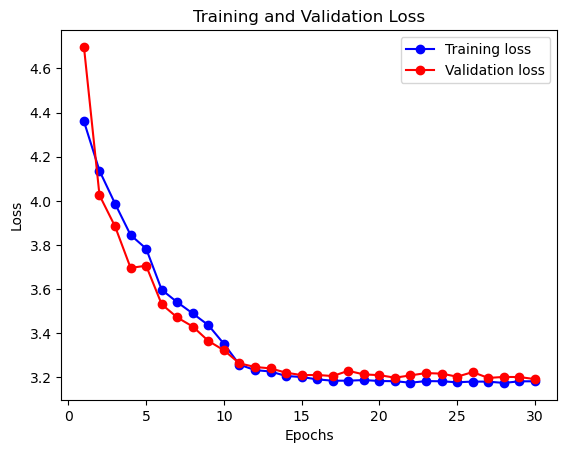

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        total_batches = len(train_loader)
        progress_bar = tqdm(enumerate(train_loader), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (images, labels) in progress_bar:
            images, labels = torch.stack(images), torch.stack(labels)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = torch.stack(images), torch.stack(labels)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        
        scheduler.step()
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        if epoch_loss < 1.0:
            print(f"Training loss below 1.0 at epoch {epoch+1}. Stopping early.")
            break
        
    return train_losses, val_losses, model

train_losses, val_losses, model = train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30)

torch.save(model.state_dict(), 'places365_lanscape_type_classification_2.pth')

def plot_training_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(train_losses, val_losses)

In [9]:
# model_name = input('Please enter the name of model: ')

# if model_name == 'alexnet':
#     model = models.alexnet(weights=None)
#     model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 2)
#     model.load_state_dict(torch.load('../../models/places365_binary_model_alexnet.pth', map_location='cpu', weights_only=True))
# else:
#     model = models.resnet18(weights=None)
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, 2)
#     model.load_state_dict(torch.load('../../models/places365_binary_model_resnet18.pth', map_location='cpu', weights_only=True))


# model.eval()


# data_path = '/home/ubuntu/landscape-aesthetics/data/processed/landscape_handmade/landscapes_test.csv'
# image_folder = Path('/home/ubuntu/landscape-aesthetics')

# data = pd.read_csv(data_path)

# data_transforms = transforms.Compose([
#         # transforms.Resize((256, 256)),
#         transforms.CenterCrop(256),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
#     ])


# # sampled_data = data.sample(n=100, random_state=123) 
# image_paths = data.iloc[:, 0].tolist()
# true_labels = data.iloc[:, 1].tolist()

# from collections import Counter

# label_counts = Counter(true_labels)

# total_samples = len(true_labels)
# label_ratios = {label: count / total_samples for label, count in label_counts.items()}

# for label, ratio in label_ratios.items():
#     print(f"Label: {label}, Count: {label_counts[label]}, Ratio: {ratio * 100:.2f}%")

# predictions = []

# incorrect_images = []

# for img_path, true_label in tqdm(zip(image_paths, true_labels), total=len(image_paths), desc="Processing images"):

#     image_path = os.path.join(image_folder, img_path) 
    
#     img = data_transforms(Image.open(image_path).convert('RGB')) .unsqueeze(0)
    
#     with torch.no_grad():
#         output = model(img)
    
#     _, predicted = torch.max(output, 1)
#     predictions.append(predicted.item())

#     if predicted.item() != true_label:
#         incorrect_images.append((image_path, true_label, predicted.item()))

# accuracy = accuracy_score(true_labels, predictions)
# recall = recall_score(true_labels, predictions, average='macro')
# precision = precision_score(true_labels, predictions)

# print(f'Precision: {precision * 100:.2f}%')
# print(f'Accuracy: {accuracy * 100:.2f}%')
# print(f'Recall: {recall * 100:.2f}%')
# print(confusion_matrix(true_labels, predictions))